## Business Problem

## Bottom Line Up Front (BLUF)

Phishing emails will most always make it through in one way or another.  Once one is prevented, someone will find a new way to squeek it through.  So it is always important to be as cautious as possible when clicking on an unknown or suspicous link.  However, the model we have created below is good at filtering out phishing URL's at a 99% rate.  It may not be perfect, but it sure eliminates a lot of the threats out there.

## For Your Information About the Data

I originally trained the data on one dataset that had 55 columns - came out to be 99.9% accurate.  On another dataset of only 100 URL's it was 52% accurate, predicting almost all URL's as phishing.  Because of this, I used two seperate datasets to train a model.  The dataset only consists of about 10k URL's, but works at about 99% on the remaining untrained 200k URL's from the original dataset. 

## Tableau Dashboard Link

## Imports

In [451]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
import re
import pickle
import scipy
from scipy.stats import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from Phishing_Features_Class import PhishingFeatureExtractor


## Data Loading

In [2]:
phish_df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

## Exploratory Data Analysis

In [3]:
phish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [4]:
phish_df.describe()

URLLength   DomainLength     IsDomainIP  URLSimilarityIndex  \
count  235795.000000  235795.000000  235795.000000       235795.000000   
mean       34.573095      21.470396       0.002706           78.430778   
std        41.314153       9.150793       0.051946           28.976055   
min        13.000000       4.000000       0.000000            0.155574   
25%        23.000000      16.000000       0.000000           57.024793   
50%        27.000000      20.000000       0.000000          100.000000   
75%        34.000000      24.000000       0.000000          100.000000   
max      6097.000000     110.000000       1.000000          100.000000   

       CharContinuationRate  TLDLegitimateProb    URLCharProb      TLDLength  \
count         235795.000000      235795.000000  235795.000000  235795.000000   
mean               0.845508           0.260423       0.055747       2.764456   
std                0.216632           0.251628       0.010587       0.599739   
min                0.000000           0.000000       0.001083       2.000000   
25%                0.680000           0.005977       0.050747       2.000000   
50%                1.000000           0.079963       0.057970       3.000000   
75%                1.000000           0.522907       0.062875       3.000000   
max                1.000000           0.522907       0.090824      13.000000   

       NoOfSubDomain  HasObfuscation  ...            Pay         Crypto  \
count  235795.000000   235795.000000  ...  235795.000000  235795.000000   
mean        1.164758        0.002057  ...       0.237007       0.023474   
std         0.600969        0.045306  ...       0.425247       0.151403   
min         0.000000        0.000000  ...       0.000000       0.000000   
25%         1.000000        0.000000  ...       0.000000       0.000000   
50%         1.000000        0.000000  ...       0.000000       0.000000   
75%         1.000000        0.000000  ...       0.000000       0.000000   
max        10.000000        1.000000  ...       1.000000       1.000000   

       HasCopyrightInfo      NoOfImage        NoOfCSS         NoOfJS  \
count     235795.000000  235795.000000  235795.000000  235795.000000   
mean           0.486775      26.075689       6.333111      10.522305   
std            0.499826      79.411815      74.866296      22.312192   
min            0.000000       0.000000       0.000000       0.000000   
25%            0.000000       0.000000       0.000000       0.000000   
50%            0.000000       8.000000       2.000000       6.000000   
75%            1.000000      29.000000       8.000000      15.000000   
max            1.000000    8956.000000   35820.000000    6957.000000   

         NoOfSelfRef   NoOfEmptyRef  NoOfExternalRef          label  
count  235795.000000  235795.000000    235795.000000  235795.000000  
mean       65.071113       2.377629        49.262516       0.571895  
std       176.687539      17.641097       161.027430       0.494805  
min         0.000000       0.000000         0.000000       0.000000  
25%         0.000000       0.000000         1.000000       0.000000  
50%        12.000000       0.000000        10.000000       1.000000  
75%        88.000000       1.000000        57.000000       1.000000  
max     27397.000000    4887.000000     27516.000000       1.000000  

[8 rows x 51 columns]

In [5]:
phish_df.head(40)

FILENAME                                                URL  \
0     521848.txt                   https://www.southbankmosaics.com   
1      31372.txt                           https://www.uni-mainz.de   
2     597387.txt                     https://www.voicefmradio.co.uk   
3     554095.txt                        https://www.sfnmjournal.com   
4     151578.txt                 https://www.rewildingargentina.org   
5      23107.txt                    https://www.globalreporting.org   
6      23034.txt                         https://www.saffronart.com   
7     696732.txt                         https://www.nerdscandy.com   
8     739255.txt                     https://www.hyderabadonline.in   
9      14486.txt                                https://www.aap.org   
10    167350.txt                 https://www.religionenlibertad.com   
11   mw42508.txt                            http://www.teramill.com   
12    515489.txt                       https://www.socialpolicy.org   
13    858208.txt                              https://www.aoh61.com   
14    712305.txt                        https://www.bulgariaski.com   
15    252332.txt                          https://www.brightika.com   
16    862789.txt                              https://www.motley.ie   
17    561324.txt                             https://www.funzine.hu   
18    791831.txt                             https://www.dixxon.com   
19    861208.txt                            https://www.ooty.ind.in   
20   mw16985.txt                        http://www.f0519141.xsph.ru   
21  mw131249.txt                           http://www.shprakserf.gq   
22      6569.txt                      https://www.cryptocompare.com   
23    394270.txt                     https://www.diariodealmeria.es   
24    518245.txt                 https://www.town.minamichita.lg.jp   
25    683655.txt                         https://www.bwresearch.com   
26    638225.txt              https://www.musicvideoproduction.guru   
27   7972389.txt             https://service-mitld.firebaseapp.com/   
28   mw34096.txt                  http://www.kuradox92.lima-city.de   
29   8008520.txt                        https://liuy-9a930.web.app/   
30     86745.txt                             https://www.landed.com   
31   8029912.txt  https://ipfs.io/ipfs/qmrvvyr84esa2assw9vvwupqj...   
32   8066660.txt           http://att-103731-107123.weeblysite.com/   
33     53440.txt                          https://www.bikeseoul.com   
34   8065475.txt                https://hidok4f8zl.firebaseapp.com/   
35    584755.txt                           https://www.ibeani.co.uk   
36    603823.txt                  https://www.metroretrovintage.com   
37   mw52024.txt                               http://www.ooguy.com   
38     62523.txt                               https://www.vysor.io   
39   mw74078.txt                       http://www.fairytalesinc.com   

    URLLength                            Domain  DomainLength  IsDomainIP  \
0          31          www.southbankmosaics.com            24           0   
1          23                  www.uni-mainz.de            16           0   
2          29            www.voicefmradio.co.uk            22           0   
3          26               www.sfnmjournal.com            19           0   
4          33        www.rewildingargentina.org            26           0   
5          30           www.globalreporting.org            23           0   
6          25                www.saffronart.com            18           0   
7          25                www.nerdscandy.com            18           0   
8          29            www.hyderabadonline.in            22           0   
9          18                       www.aap.org            11           0   
10         33        www.religionenlibertad.com            26           0   
11         22                  www.teramill.com            16           0   
12         27              www.socialpolicy.org            20           0   
13         20     

In [6]:
phish_df.head()

FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2               100.0              0.866667           0.028555  ...    0   
3               100.0              1.000000           0.522907  ...    1   
4               100.0              1.000000           0.079963  ...    1   

   Crypto  HasCopyrightInfo  NoOfImage  NoOfCSS  NoOfJS  NoOfSelfRef  \
0       0                 1         34       20      28          119   
1       0                 1         50        9       8           39   
2       0                 1         10        2       7           42   
3       1                 1          3       27      15           22   
4       0                 1        244       15      34           72   

   NoOfEmptyRef  NoOfExternalRef  label  
0             0              124      1  
1             0              217      1  
2             2                5      1  
3             1               31      1  
4             1               85      1  

[5 rows x 56 columns]

In [7]:
phish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [8]:
phish_df = phish_df.drop_duplicates()

In [9]:
label_counts = phish_df['label'].value_counts()

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


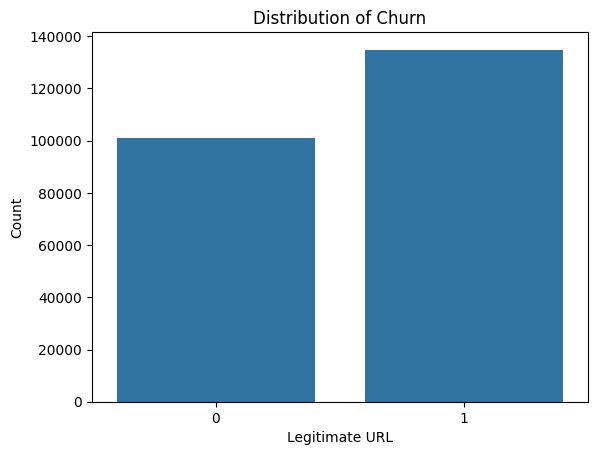

In [10]:
# Visualize (use the counts object)
X = label_counts.index
y = label_counts.values

# Code for plot provided
sns.barplot(x=X, y=y)
plt.xlabel('Legitimate URL')
plt.ylabel('Count')
plt.title("Distribution of Churn");

In [11]:
# Get all columns that have either a 0 or 1 - Boolean like columns
bool_like_cols = [col for col in phish_df.columns if phish_df[col].dropna().isin([0, 1]).all()]

#Get All numeric columns - Including the bool_like_cols
numeric_cols = phish_df.select_dtypes(include=['number']).columns

# Get non numeric columns
non_numeric_cols = phish_df.select_dtypes(exclude='number').columns

# Get Numeric columns excluding the bool like columns
pure_numeric_cols = [col for col in numeric_cols if col not in bool_like_cols]




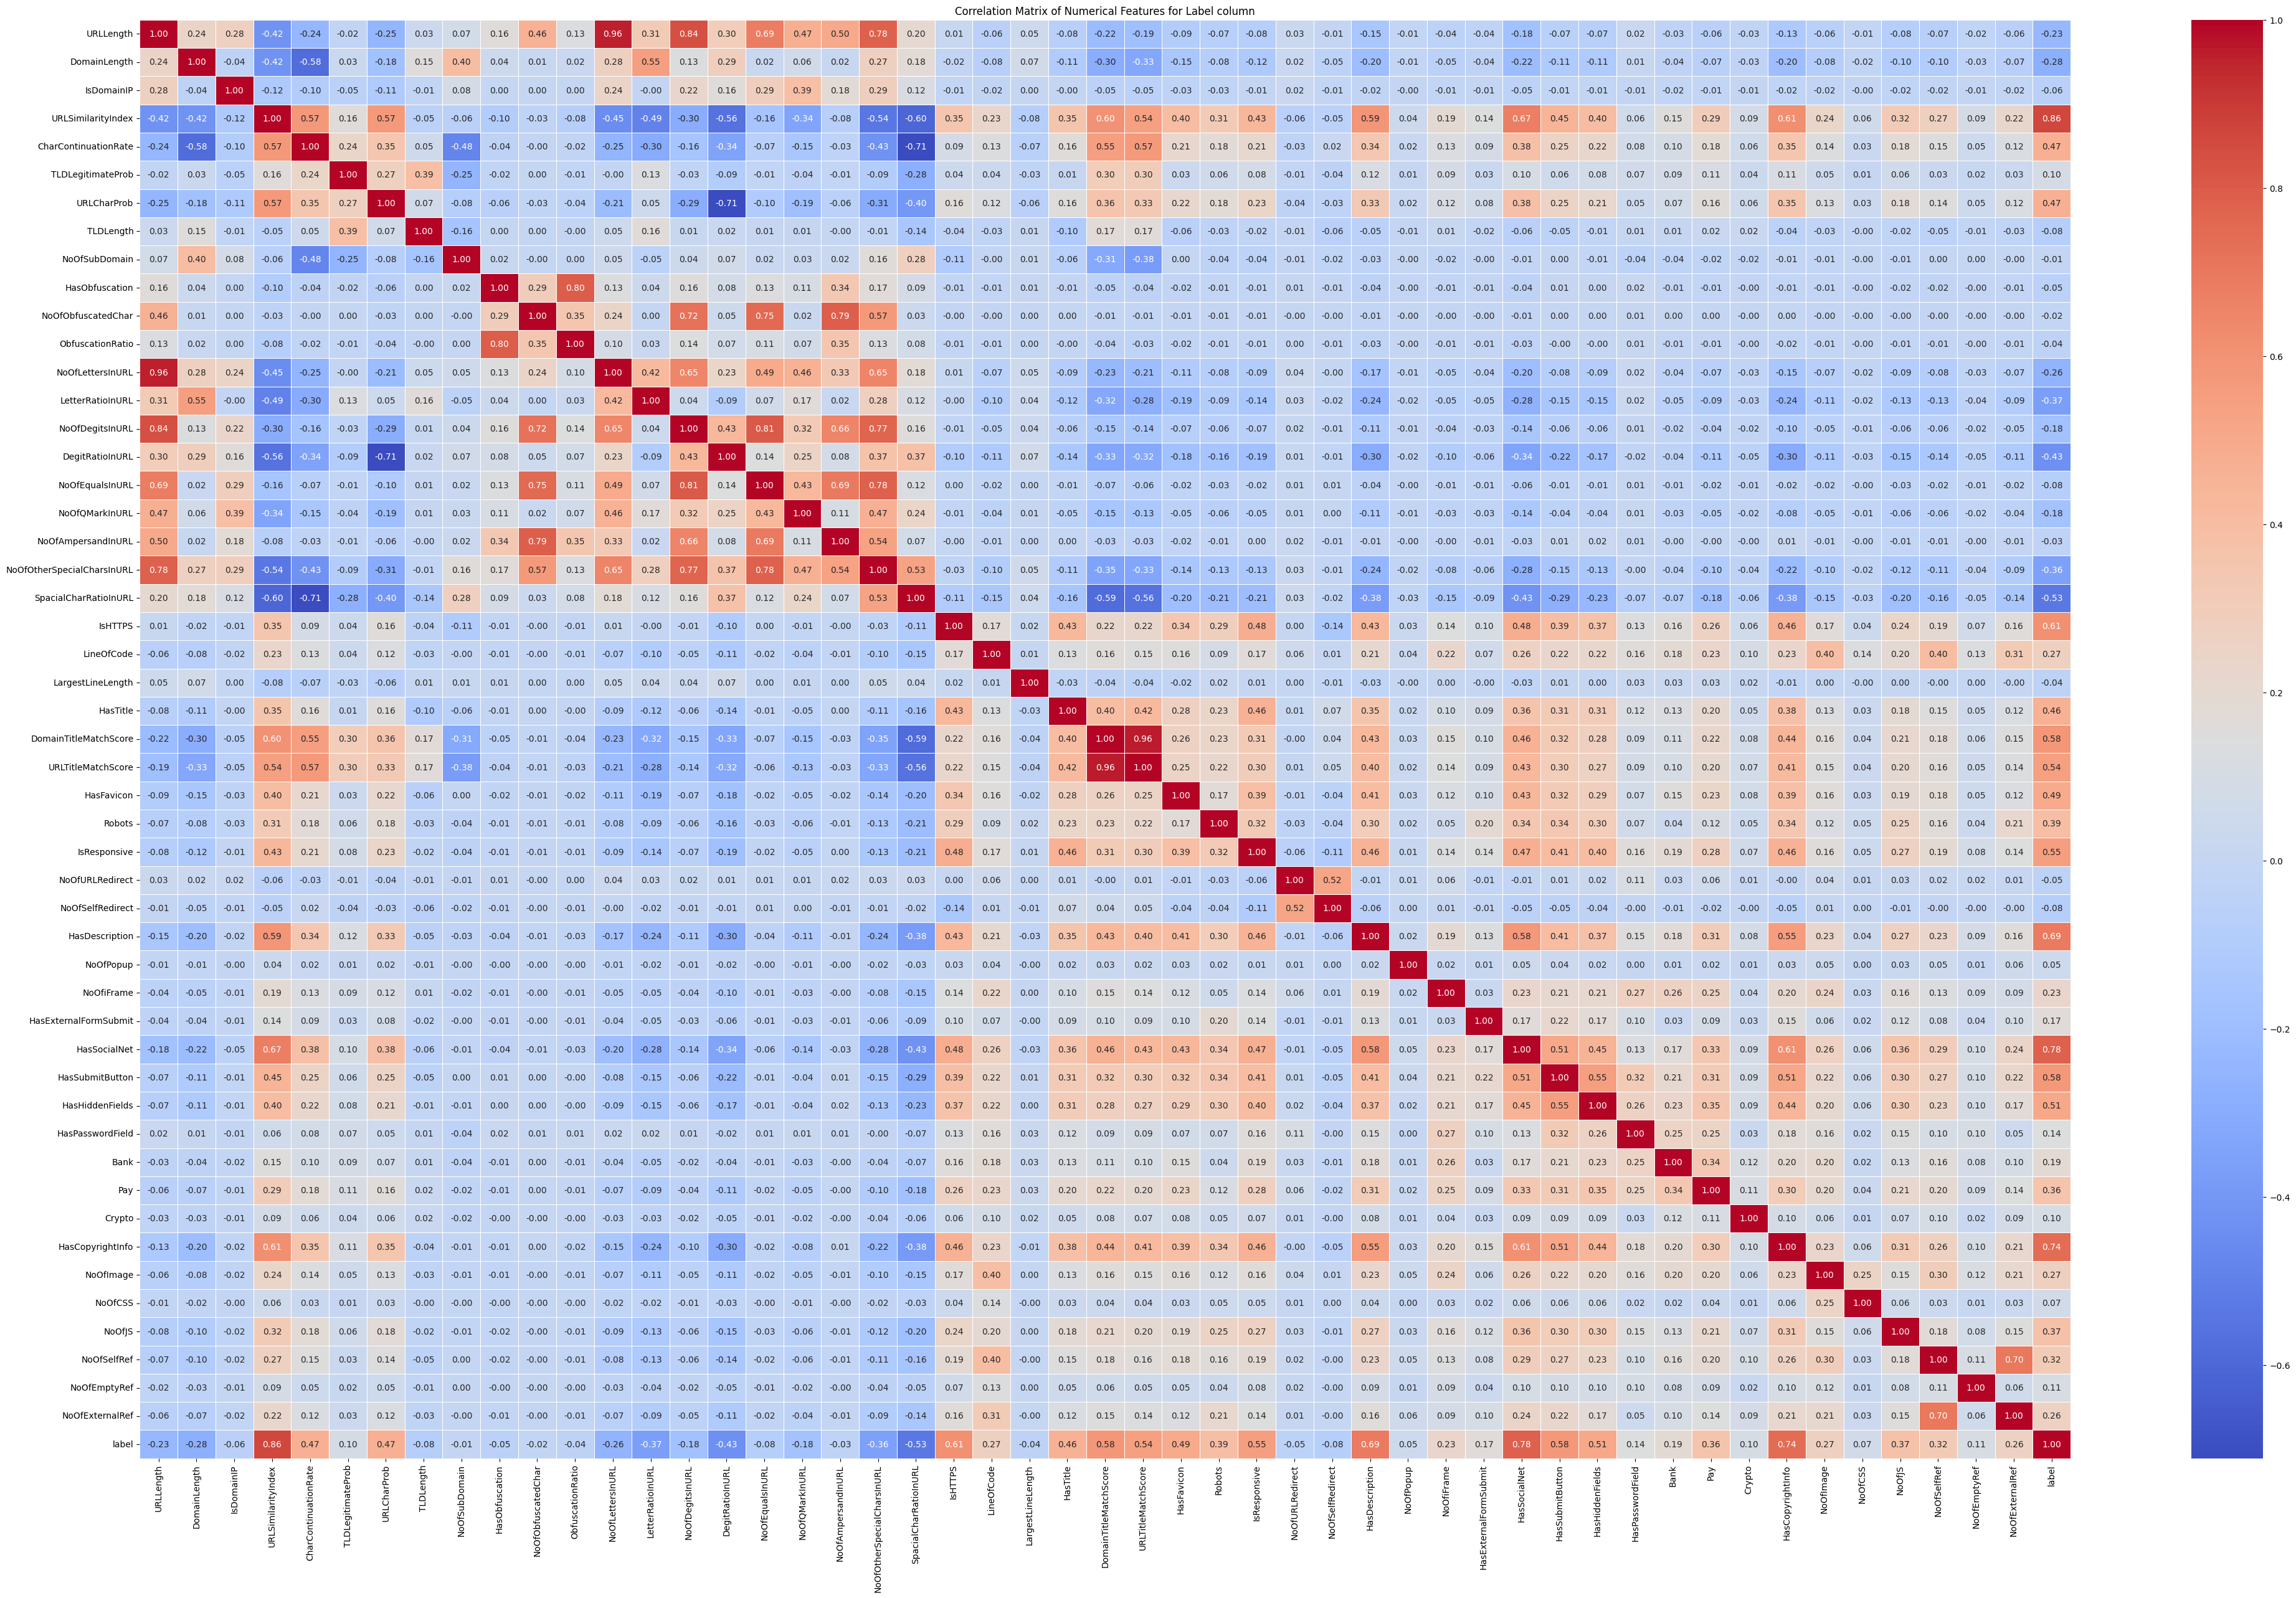

In [12]:
phish_corr = phish_df[numeric_cols].corr()
label_corr = phish_corr['label'].drop('label')

plt.figure(figsize=(50, 30))
sns.heatmap(phish_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features for Label column")
plt.show()


/tmp/ipykernel_263071/3917062377.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


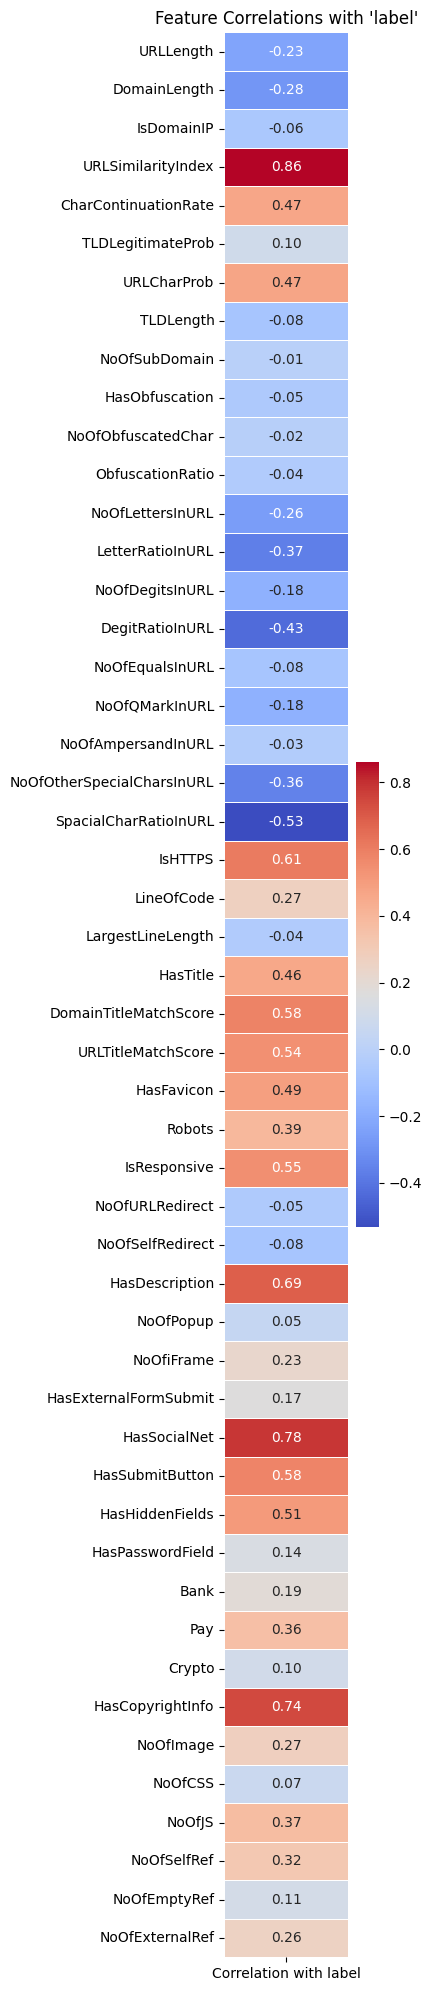

In [13]:
label_corr_df = label_corr.to_frame(name='Correlation with label')

plt.figure(figsize=(2, len(label_corr) * 0.5))
sns.heatmap(label_corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Feature Correlations with 'label'")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [14]:
# Individual Null Value counts
print(f"Null values:\n{phish_df.isnull().sum()}")

Null values:
FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore      

In [15]:
# Total Null value counts
print(f"Total Null Values in all columns: {phish_df.isnull().sum().sum()}")

Total Null Values in all columns: 0


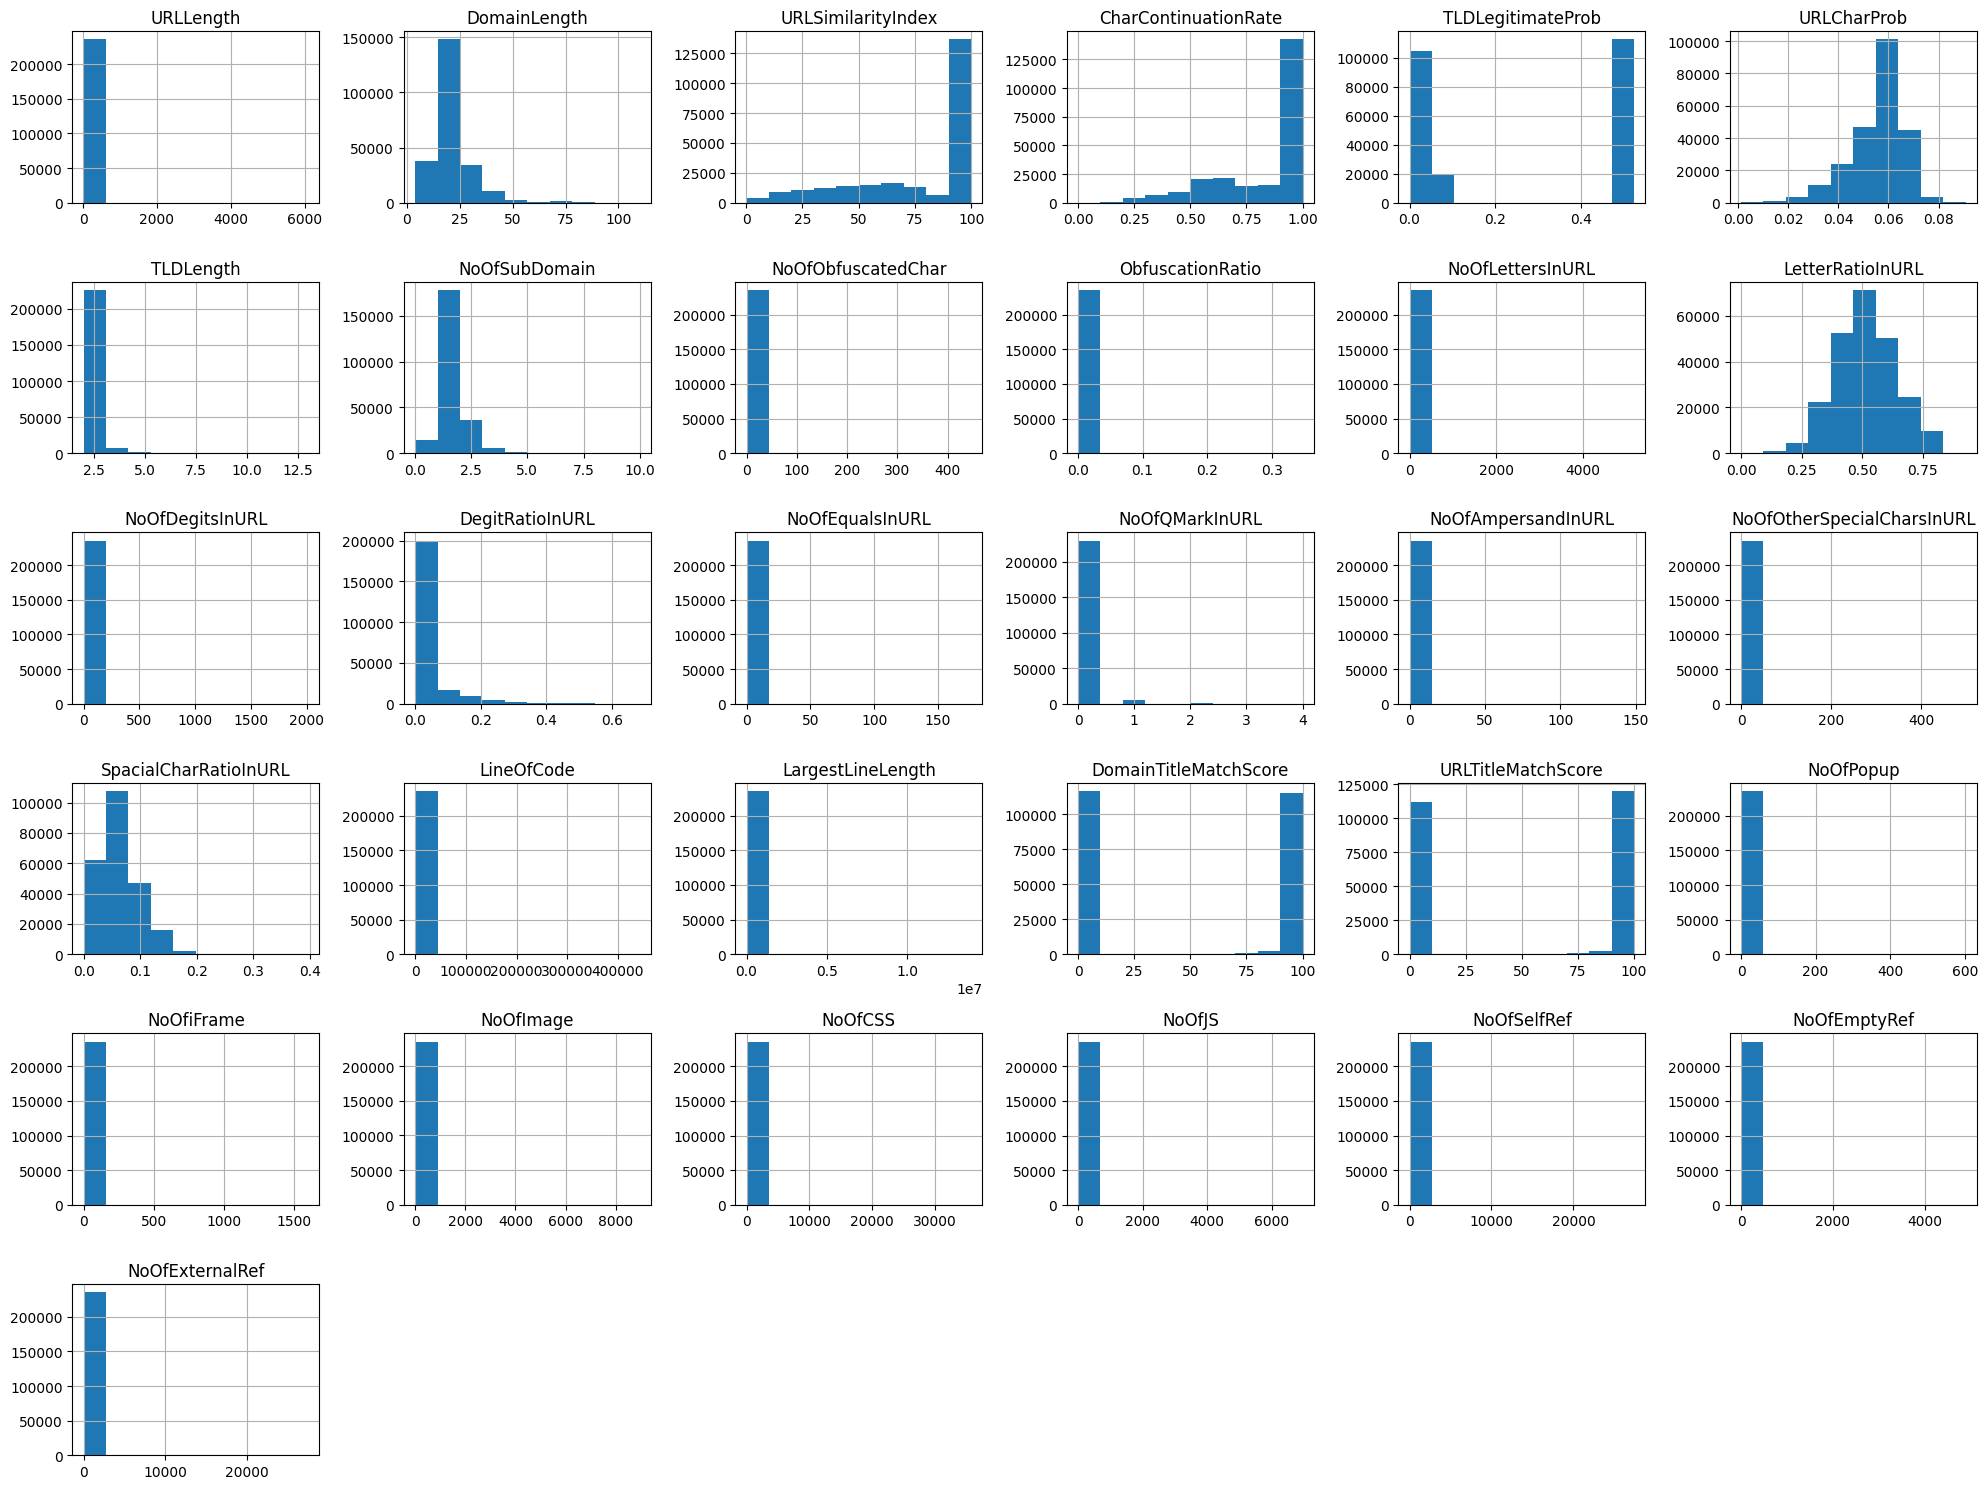

In [16]:
phish_df[pure_numeric_cols].hist(figsize=(20, 15))
plt.tight_layout()
plt.show()


In [17]:
non_numeric_cols

Index(['FILENAME', 'URL', 'Domain', 'TLD', 'Title'], dtype='object')

In [18]:
for col in non_numeric_cols:
    print(f"{col}\nUnique Values: {phish_df[col].nunique()}")


FILENAME
Unique Values: 235795
URL
Unique Values: 235370
Domain
Unique Values: 220086
TLD
Unique Values: 695
Title
Unique Values: 197874


## Data Preparation

## Below cell is necessary for recreating URLSimilarityIndex but takes about 15 minutes to run - Sorry, should have saved to a new CSV - didn't realize at the time

In [442]:
# Creating new similarity scores for testing purposes - cannot recreate the ones in the dataset, and it is the highest coefficient (strongest feature)
similarity_scores = []

for url in tqdm(phish_df['URL'], desc="Updating URLSimilarityIndex"):
    try:
        # Skip HTML request by setting fetch_soup=False
        extractor = PhishingFeatureExtractor(url, fetch_soup=False)
        score = extractor.url_similarity_index()
        similarity_scores.append(score)
    except Exception as e:
        print(f"Error processing URL: {url} → {e}")
        similarity_scores.append(0.0)  # or use np.nan if preferred


phish_df['URLSimilarityIndex'] = similarity_scores


Updating URLSimilarityIndex: 100%|██████████| 235795/235795 [16:58<00:00, 231.48it/s]


In [443]:
# View boolean column names
bool_like_cols

['IsDomainIP',
 'HasObfuscation',
 'IsHTTPS',
 'HasTitle',
 'HasFavicon',
 'Robots',
 'IsResponsive',
 'NoOfURLRedirect',
 'NoOfSelfRedirect',
 'HasDescription',
 'HasExternalFormSubmit',
 'HasSocialNet',
 'HasSubmitButton',
 'HasHiddenFields',
 'HasPasswordField',
 'Bank',
 'Pay',
 'Crypto',
 'HasCopyrightInfo',
 'label']

In [20]:
#Removing specific columns from bool_like_cols
bool_to_remove = ['Robots', 'HasDescription', 'Bank', 'Pay', 'Crypto', 'label', 'NoOfURLRedirect', 'NoOfSelfRedirect']
updated_bool_like_cols = [col for col in bool_like_cols if col not in bool_to_remove]

In [21]:
# View Numeric column names
pure_numeric_cols

['URLLength',
 'DomainLength',
 'URLSimilarityIndex',
 'CharContinuationRate',
 'TLDLegitimateProb',
 'URLCharProb',
 'TLDLength',
 'NoOfSubDomain',
 'NoOfObfuscatedChar',
 'ObfuscationRatio',
 'NoOfLettersInURL',
 'LetterRatioInURL',
 'NoOfDegitsInURL',
 'DegitRatioInURL',
 'NoOfEqualsInURL',
 'NoOfQMarkInURL',
 'NoOfAmpersandInURL',
 'NoOfOtherSpecialCharsInURL',
 'SpacialCharRatioInURL',
 'LineOfCode',
 'LargestLineLength',
 'DomainTitleMatchScore',
 'URLTitleMatchScore',
 'NoOfPopup',
 'NoOfiFrame',
 'NoOfImage',
 'NoOfCSS',
 'NoOfJS',
 'NoOfSelfRef',
 'NoOfEmptyRef',
 'NoOfExternalRef']

In [22]:
#Remove specific numeric columns
pure_cols_to_remove = ['CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'URLTitleMatchScore', 'DomainTitleMatchScore', 'NoOfPopup']
#Add 2 columns to the pure numeric columns list
updated_pure_numeric_cols = [col for col in pure_numeric_cols if col not in pure_cols_to_remove]
if "NoOfURLRedirect" not in updated_pure_numeric_cols:
    updated_pure_numeric_cols.append("NoOfURLRedirect")
if "NoOfSelfRedirect" not in updated_pure_numeric_cols:
    updated_pure_numeric_cols.append("NoOfSelfRedirect")

In [446]:
# Re-viewing the correlations after new similarity index
phish_corr2 = phish_df[numeric_cols].corr()
label_corr2 = phish_corr2['label'].drop('label')

/tmp/ipykernel_263071/159969924.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


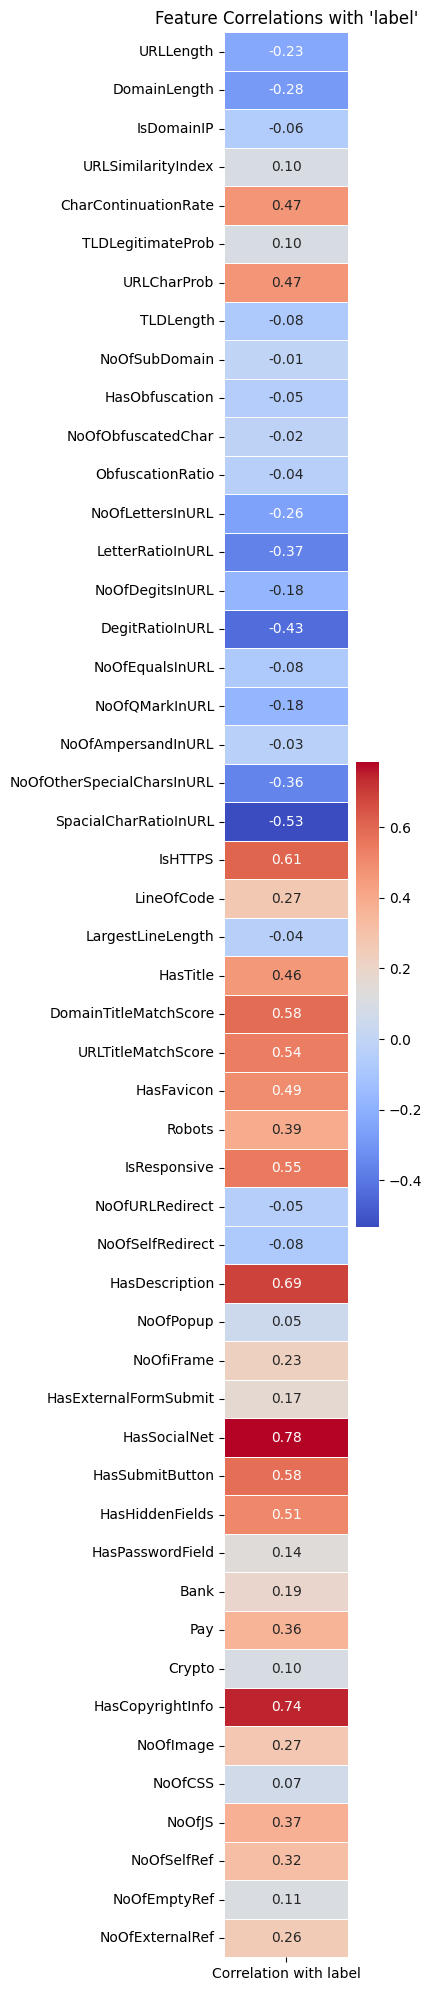

In [447]:
label_corr_df2 = label_corr2.to_frame(name='Correlation with label')

plt.figure(figsize=(2, len(label_corr2) * 0.5))
sns.heatmap(label_corr_df2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Feature Correlations with 'label'")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## PCA Testing

In [23]:
# Checking for PCA if it is useful for dataset
#Scale numeric columns
scaler = StandardScaler()
X_scaled_t = scaler.fit_transform(phish_df[updated_pure_numeric_cols])

# Create basic PCA
pca= PCA()
pca.fit(X_scaled_t)

PCA()

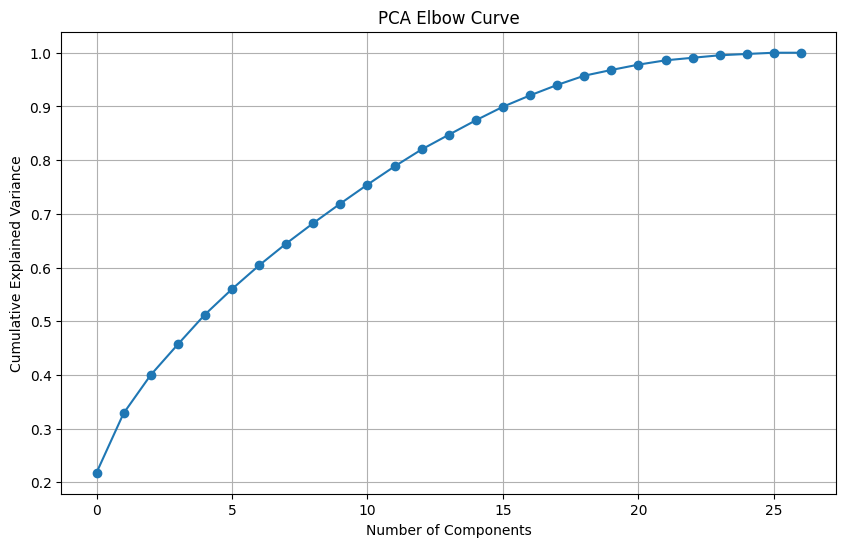

In [24]:
# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Elbow Curve')
plt.grid(True)
plt.show()


## Train Test Split

In [25]:
# 20/80 Data Split - dropping extra columns not being used
X = phish_df.drop(['label', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'Robots', 'HasDescription', 'Bank', 'Pay', 'Crypto'], axis=1)
y = phish_df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

## Pipeline

In [26]:
# Numerical Transformers for pipeline
# No PCA
numerical_transformer_all = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])




# Did not use any of the below for the model - stuck with not using PCA.  If there was more time, or wanted more effiency in the model this would have been useful.

# PCA of 90% variance
numerical_transformer_90 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9))
])

# PCA of 95% variance
numerical_transformer_95 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

# PCA of 99% variance
numerical_transformer_99 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.99))
])

In [27]:
non_numeric_cols

Index(['FILENAME', 'URL', 'Domain', 'TLD', 'Title'], dtype='object')

In [28]:
phish_df[non_numeric_cols].head()

FILENAME                                 URL                      Domain  \
0  521848.txt    https://www.southbankmosaics.com    www.southbankmosaics.com   
1   31372.txt            https://www.uni-mainz.de            www.uni-mainz.de   
2  597387.txt      https://www.voicefmradio.co.uk      www.voicefmradio.co.uk   
3  554095.txt         https://www.sfnmjournal.com         www.sfnmjournal.com   
4  151578.txt  https://www.rewildingargentina.org  www.rewildingargentina.org   

   TLD                                              Title  
0  com  à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...  
1   de              johannes gutenberg-universitÃ¤t mainz  
2   uk                               voice fm southampton  
3  com  home page: seminars in fetal and neonatal medi...  
4  org                     fundaciÃ³n rewilding argentina

In [29]:
# Categorical Transformers

#TF-IDF vectorizer for the title
def squeeze_column(x):
    return x.squeeze()

reshape_title = FunctionTransformer(squeeze_column)

title_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='')),
    ('reshape', reshape_title),
    ('tfidf', TfidfVectorizer(max_features=500))
])


#One Hot encoding for the TLD
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])


In [30]:
#Put the preprocessor together
#Preprocessor #1 - No PCA
preprocessor_all = ColumnTransformer([
    ('num', numerical_transformer_all, updated_pure_numeric_cols),
    ('bool', 'passthrough', updated_bool_like_cols),
    ('cat', categorical_transformer, ['TLD']),
    ('text', title_transformer, ['Title'])
])

#Preprocessor #2 - 90% PCA
preprocessor_90 = ColumnTransformer([
    ('num', numerical_transformer_90, updated_pure_numeric_cols),
    ('bool', 'passthrough', updated_bool_like_cols),
    ('cat', categorical_transformer, ['TLD']),
    ('text', title_transformer, ['Title'])
])


#Preprocessor #2 - 95% PCA
preprocessor_95 = ColumnTransformer([
    ('num', numerical_transformer_95, updated_pure_numeric_cols),
    ('bool', 'passthrough', updated_bool_like_cols),
    ('cat', categorical_transformer, ['TLD']),
    ('text', title_transformer, ['Title'])
])


#Preprocessor #2 - 99% PCA
preprocessor_99 = ColumnTransformer([
    ('num', numerical_transformer_99, updated_pure_numeric_cols),
    ('bool', 'passthrough', updated_bool_like_cols),
    ('cat', categorical_transformer, ['TLD']),
    ('text', title_transformer, ['Title'])
])


# Modeling

## Logistical

In [31]:
#Logistic Regression with No PCA
full_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

In [32]:
# Fit and Predic
full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)

In [33]:
#Confusion Matrix
print(confusion_matrix(y_test, y_pred))

#Classification report
print(classification_report(y_test, y_pred))



[[20181     8]
 [    0 26970]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



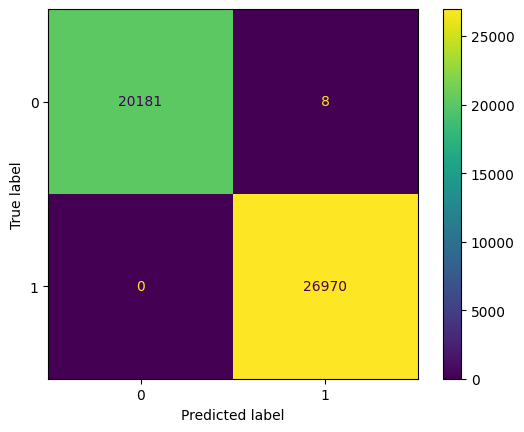

In [34]:
#Confusion matrix clean visual
cm_all = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_all)
disp.plot(values_format='d')

In [35]:
#Confidence ratings
y_prob = full_pipeline.predict_proba(X_test)[:, 1]


In [36]:
y_prob

array([0.99999825, 0.99999549, 0.99998959, ..., 0.99999998, 0.99999993,
       0.9982763 ])

In [37]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


In [487]:
# Get coefficients out of model
model = full_pipeline.named_steps['model']
print(model.coef_)  # Sparse but interpretable

[[-1.71818186e-01  2.06320232e+00 -4.39929772e-01 ... -9.99690616e-03
  -1.41402021e-04 -1.18969261e-02]]


In [488]:
#Grab the preprocessor
preprocessor = full_pipeline.named_steps['prep']

# FEature names
cat_features = preprocessor.named_transformers_['cat'].named_steps['encode'].get_feature_names_out(['TLD'])
text_features = preprocessor.named_transformers_['text'].named_steps['tfidf'].get_feature_names_out()

# Combine column names
feature_names = (
    preprocessor.transformers_[0][2] +  # pure_numeric_cols
    preprocessor.transformers_[1][2] +  # bool_like_cols
    cat_features.tolist() +
    text_features.tolist()
)


In [489]:
#Get coefficients
model = full_pipeline.named_steps['model']
coefficients = model.coef_[0]  # For binary classification

#Combine coefficients with column/feature names
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)




In [490]:
# view
print(feature_importance.head(20))  # Most phishing-indicative
print(feature_importance.tail(20))  # Most benign-indicative

              Feature  Coefficient
29            IsHTTPS    11.012409
22        NoOfSelfRef     6.149079
19          NoOfImage     5.830653
21             NoOfJS     5.358606
24    NoOfExternalRef     5.190112
16         LineOfCode     4.395199
34       HasSocialNet     3.595072
38   HasCopyrightInfo     2.619871
30           HasTitle     2.450071
1        DomainLength     2.063202
521           TLD_org     1.910880
662            TLD_uk     1.472139
18         NoOfiFrame     1.441654
280            TLD_de     1.417984
20            NoOfCSS     1.303791
23       NoOfEmptyRef     1.227769
4       NoOfSubDomain     1.002983
258           TLD_com     0.876148
36    HasHiddenFields     0.660707
407            TLD_jp     0.522231
                        Feature  Coefficient
284                     TLD_dev    -0.408894
2            URLSimilarityIndex    -0.439930
333                      TLD_ga    -0.485527
238                      TLD_cf    -0.519054
396                      TLD_io    -0.56

In [148]:
# Logistic regression with PCA 90%
pipeline_90 = Pipeline([
    ('prep', preprocessor_90),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])



In [149]:
# Fit model and predict
pipeline_90.fit(X_train, y_train)
y_90_pred = pipeline_90.predict(X_test)

In [150]:
print(confusion_matrix(y_test, y_90_pred))
print(classification_report(y_test, y_90_pred))

[[20161    28]
 [   13 26957]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



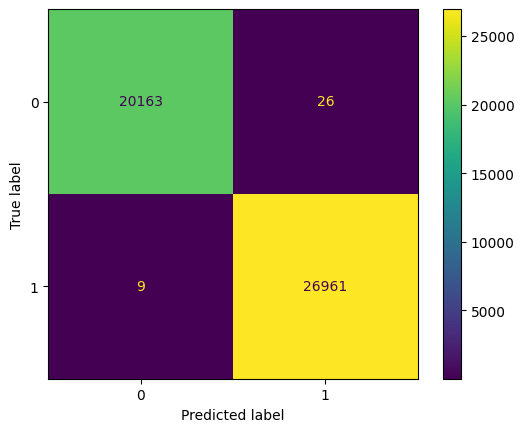

In [152]:
cm_90 = confusion_matrix(y_test, y_90_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_all)
disp.plot(values_format='d')

## Random Forest

In [156]:
# Random Forest model with No PCA
pipeline_rf_all = Pipeline([
    ('prep', preprocessor_all),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_rf_all.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function <lambda> at 0xff28d92c8680>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [157]:
# Predictions
rf_pred_all = pipeline_rf_all.predict(X_test)


In [158]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, rf_pred_all))
print(classification_report(y_test, rf_pred_all))

[[20184     5]
 [    1 26969]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



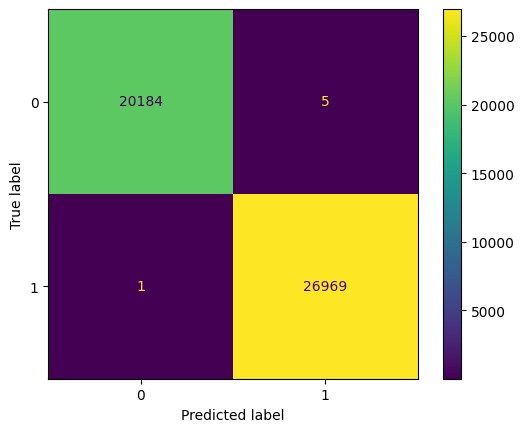

In [170]:
# Confusion matrix clean
rf_cm_all = confusion_matrix(y_test, rf_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_all)
disp.plot(values_format='d')

## XGBoost

In [166]:
# XGBoost classifier with no PCA
pipeline_xgb_all = Pipeline([
    ('prep', preprocessor_all),
    ('model', XGBClassifier(random_state=42))
])

pipeline_xgb_all.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [167]:
# Predict
xgb_pred_all = pipeline_xgb_all.predict(X_test)

In [168]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, xgb_pred_all))
print(classification_report(y_test, xgb_pred_all))

[[20187     2]
 [    0 26970]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



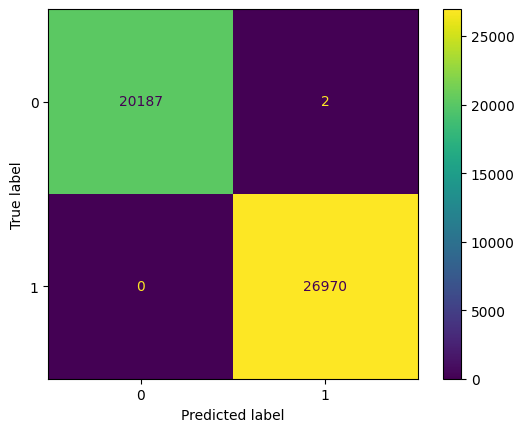

In [171]:
# Confusion matrix clean display
xgb_cm_all = confusion_matrix(y_test, xgb_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm_all)
disp.plot(values_format='d')

## KNN

In [185]:
# K Neighbor Classifier with no PCA
pipeline_knn_all = Pipeline([
    ('prep', preprocessor_all),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

pipeline_knn_all.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function <lambda> at 0xff28d92c8680>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', KNeighborsClassifier())])

In [186]:
# Predictions
knn_pred_all = pipeline_knn_all.predict(X_test)

In [187]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, knn_pred_all))
print(classification_report(y_test, knn_pred_all))

[[20138    51]
 [   45 26925]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



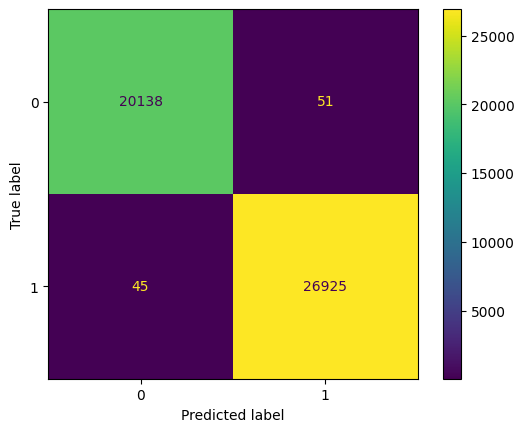

In [188]:
# confusion matrix review
knn_cm_all = confusion_matrix(y_test, knn_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm_all)
disp.plot(values_format='d')

## Neural Network

In [38]:
# Modeling with a neural network - transforming X_train columns
X_train_transformed = preprocessor_all.fit_transform(X_train)
X_test_transformed = preprocessor_all.transform(X_test)

In [39]:
# convert to array
if scipy.sparse.issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()

In [40]:
# Create dense multi layered model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_transformed.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [43]:
# Fit the model
model.fit(
    X_train_transformed, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9948 - loss: 0.0206 - val_accuracy: 0.9999 - val_loss: 2.5666e-04
Epoch 2/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9998 - loss: 7.2020e-04 - val_accuracy: 0.9999 - val_loss: 3.4001e-04
Epoch 3/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9998 - loss: 5.0899e-04 - val_accuracy: 0.9998 - val_loss: 5.5643e-04
Epoch 4/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9999 - loss: 6.1557e-04 - val_accuracy: 1.0000 - val_loss: 1.8859e-05
Epoch 5/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9999 - loss: 3.4408e-04 - val_accuracy: 0.9999 - val_loss: 1.6343e-04
Epoch 6/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9999 - loss: 2.7927e-04 - val_accuracy: 0.9999 - val_loss: 1.3779e-04
Epoch 7/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9998 - loss: 5.3123e-04 - val_accuracy: 1.0000 - val_loss: 2.1450e-05


In [44]:
# Predict probabilities
model.predict(X_test_transformed)

1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step


array([[1.        ],
       [1.        ],
       [1.        ],
       ...,
       [1.        ],
       [1.        ],
       [0.99999046]], dtype=float32)

In [ ]:
# After further testing, this model wasn't working as good as the others - not sure where the tests went, but decided to go ahead and test the other models on raw URL data to see how it performs

## Testing Model on Raw URL's

In [130]:
# Load in a new dataset that has URL's and phishing labels
test_df = pd.read_csv("url_dataset.csv")

In [131]:
# change column type values to numeric to align with phish_df
test_df['type'] = test_df['type'].map({'legitimate': 1, 'phishing': 0})

In [132]:
# View top 5 rows
test_df.head()

url  type
0     https://www.google.com     1
1    https://www.youtube.com     1
2   https://www.facebook.com     1
3      https://www.baidu.com     1
4  https://www.wikipedia.org     1

In [133]:
# Rename type column to label to align with phish_df
test_df.rename(columns={'type': 'label'}, inplace=True)

In [134]:
test_df.head()

url  label
0     https://www.google.com      1
1    https://www.youtube.com      1
2   https://www.facebook.com      1
3      https://www.baidu.com      1
4  https://www.wikipedia.org      1

In [135]:
# Get all labels with value 1 - legitimate
test_df_leg = test_df[test_df['label'] == 1]

In [136]:
len(test_df_leg)

345738

In [137]:
# Get all values with label 0 - phishing
test_df_phi = test_df[test_df['label'] == 0]

In [12]:
len(test_df_phi)

104438

In [207]:
# Create testing DF of 100 values of each
test_df_100 = pd.concat([test_df_leg.head(50), test_df_phi.head(50)])


# Used Later - Created new DF for getting 1000 total URL's from new dataset
test_df_1000 = pd.concat([test_df_leg.head(500), test_df_phi.head(500)])

In [14]:
# View DF
test_df_100.head(100)

url  label
0                                  https://www.google.com      1
1                                 https://www.youtube.com      1
2                                https://www.facebook.com      1
3                                   https://www.baidu.com      1
4                               https://www.wikipedia.org      1
...                                                   ...    ...
345783                      https://sercure-pagealert.cf/      0
345784  http://rejennaration.org/secure/online%20verif...      0
345785  http://smokesonstate.com/Gssss/Gssss/470a461a3...      0
345786     http://zonasegurabcpenlinea.mospacepe.com/bcp/      0
345787  http://signin.resolution-center-account.com/we...      0

[100 rows x 2 columns]

## Cell below will take about 10 minutes to run
## Not needed - larger dataset created later and saved in 10k_URL_Training.csv - but if you want to run any code that calls the Phishing Features Class - this is the smallest one

In [15]:
# Call phishing_features_class to extract values - tqdm to monitor progress
features_list = []

for _, row in tqdm(test_df_100.iterrows(), desc="Getting Phishing Features"):
    extractor = PhishingFeatureExtractor(row['url'])  #Create instance of class
    features = extractor.to_dict() # Get features in a dictionary
    features['label'] = row['label'] #Add label
    features['URL'] = row['url'] # Add URL
    features_list.append(features)

# Save as a dataframe
features_df = pd.DataFrame(features_list)

Getting Phishing Features: 30it [00:38,  1.51s/it]

Request failed: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28dfb17890>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28dfafbe10>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.list.tmall.com: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28dfb19010>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 34it [00:39,  1.59it/s]

Request failed: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.t.co: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 50it [00:55,  1.39it/s]

Request failed: HTTPConnectionPool(host='atualizacaodedados.online', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7a3690>: Failed to resolve 'atualizacaodedados.online' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='atualizacaodedados.online', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7a1f90>: Failed to resolve 'atualizacaodedados.online' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://atualizacaodedados.online: HTTPConnectionPool(host='atualizacaodedados.online', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7a4550>: Failed to resolve 'atualizacaodedados.online' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 52it [00:57,  1.33it/s]

Request failed: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7a4d10>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7a3710>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://stcdxmt.bigperl.in/klxtv/apps/uk/: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7b8dd0>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='tubuh-sya

Getting Phishing Features: 54it [01:11,  3.22s/it]

Error checking self redirects for https://tubuh-syarikat.com/plugins/fields/files/: HTTPSConnectionPool(host='tubuh-syarikat.com', port=443): Max retries exceeded with url: /plugins/fields/files/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28df7c2090>, 'Connection to tubuh-syarikat.com timed out. (connect timeout=5)'))


Getting Phishing Features: 55it [01:12,  2.66s/it]

Request failed: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7b9610>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))


Getting Phishing Features: 56it [01:27,  5.69s/it]

Redirect check failed: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7a34d0>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ongelezen-voda.000webhostapp.com/inloggen.html: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7a6e50>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 63it [01:32,  1.38s/it]

Request failed: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dffd8850>: Failed to resolve 'membership-issue.forteimpex.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7c1290>: Failed to resolve 'membership-issue.forteimpex.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://membership-issue.forteimpex.com/dk2mmm=/?resType=code&amp;failedBe=: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnecti

Getting Phishing Features: 69it [01:36,  1.11it/s]

Request failed: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7c3010>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28e0035050>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.tevhidigundem.ml/login/: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df78c9d0>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='cancel.direct.page-scure124

Getting Phishing Features: 69it [01:50,  1.11it/s]

Redirect check failed: HTTPConnectionPool(host='upperhouse.000webhostapp.com', port=80): Max retries exceeded with url: /ksovo/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df76ffd0>: Failed to resolve 'upperhouse.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 70it [02:01,  4.87s/it]

Error checking self redirects for http://upperhouse.000webhostapp.com/ksovo/index.php: HTTPConnectionPool(host='upperhouse.000webhostapp.com', port=80): Max retries exceeded with url: /ksovo/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7c8210>: Failed to resolve 'upperhouse.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='kungaguesthouse.com', port=80): Max retries exceeded with url: /wp-admin/english/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28df7c2e50>, 'Connection to kungaguesthouse.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='kungaguesthouse.com', port=80): Max retries exceeded with url: /wp-admin/english/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28dfce7f10>, 'Connection to kungaguesthouse.com timed out. (connect timeout=5)'))


Getting Phishing Features: 71it [02:16,  6.89s/it]

Error checking self redirects for http://kungaguesthouse.com/wp-admin/english/: HTTPConnectionPool(host='kungaguesthouse.com', port=80): Max retries exceeded with url: /wp-admin/english/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28df7a22d0>, 'Connection to kungaguesthouse.com timed out. (connect timeout=5)'))


Getting Phishing Features: 73it [02:17,  4.37s/it]

Request failed: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df78f010>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28e003a350>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hostcpanelverfyonline.16mb.com/micav.php: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7c2b50>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service n

Getting Phishing Features: 74it [02:36,  8.07s/it]

Error checking self redirects for https://rexlbox.000webhostapp.com/docs/secure/verification.html: HTTPSConnectionPool(host='rexlbox.000webhostapp.com', port=443): Max retries exceeded with url: /docs/secure/verification.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df78cc10>: Failed to resolve 'rexlbox.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='secure000-webpaypal.com', port=443): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df76f710>: Failed to resolve 'secure000-webpaypal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='secure000-webpaypal.com', port=443): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df76e110>: Failed to resolve 'secure000-webpaypal.com' ([Errno -2] Name or servic

Getting Phishing Features: 76it [03:00,  9.68s/it]

Error checking self redirects for http://linkedln-contact.000webhostapp.com/login.html: HTTPConnectionPool(host='linkedln-contact.000webhostapp.com', port=80): Max retries exceeded with url: /login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df78c510>: Failed to resolve 'linkedln-contact.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 77it [03:02,  7.81s/it]

Request failed: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df76ef10>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df76c910>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 78it [03:22, 10.90s/it]

Error checking self redirects for http://jhiulog-in0045.000webhostapp.com/xfinity/au/tes/ver/home/: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dfffd950>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7c2b50>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df76e990>: Failed t

Getting Phishing Features: 79it [03:37, 12.12s/it]

Error checking self redirects for http://securityceckpoins.000webhostapp.com/bayar/set.html: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28e0035450>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df78cc10>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df78d850>: Failed to res

Getting Phishing Features: 80it [03:57, 14.06s/it]

Error checking self redirects for http://member-unblock.000webhostapp.com/Unblock/inet-update-01.html: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df78f0d0>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28e00348d0>: Failed to resolve 'donefe.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dffd8190>: Failed to resolve 'd

Getting Phishing Features: 81it [04:17, 15.74s/it]

Error checking self redirects for http://donefe.000webhostapp.com/auto/auto%20ferify/mail.php: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df76f550>: Failed to resolve 'donefe.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='drcharys.com', port=80): Max retries exceeded with url: /admin/js/regain/login.php?cmd=login_submit&id=4f796368ffdd2b0a79f3c7ba91368e824f796368ffdd2b0a79f3c7ba91368e82&session=4f796368ffdd2b0a79f3c7ba91368e824f796368ffdd2b0a79f3c7ba91368e82 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dfcdb490>: Failed to resolve 'drcharys.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='drcharys.com', port=80): Max retries exceeded with url: /admin/js/regain/login.php?cmd=login_submit&id=

Getting Phishing Features: 85it [04:20,  5.45s/it]

Request failed: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df7c1210>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df78c210>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 86it [04:39,  9.08s/it]

Error checking self redirects for https://egamandala0031.000webhostapp.com/bayar/VisaPayments.html?fb_source=bookmark_apps: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df76fc10>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='dowf-cleat.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7cb290>: Failed to resolve 'dowf-cleat.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='dowf-cleat.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object a

Getting Phishing Features: 87it [05:02, 13.13s/it]

Error checking self redirects for http://dowf-cleat.000webhostapp.com/Office365.php: HTTPConnectionPool(host='dowf-cleat.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df76cf90>: Failed to resolve 'dowf-cleat.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.yeezy-christmas.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28e0034f50>: Failed to resolve 'www.yeezy-christmas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.yeezy-christmas.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df78e090>: Failed to resolve 'www.yeezy-christmas.com' ([Errno -2] Name or service not known)"))
Error checking self redirects f

Getting Phishing Features: 89it [05:26, 12.60s/it]

Error checking self redirects for http://chas-serv.000webhostapp.com/LogOn17/LogOn/auth/home/auth/: HTTPConnectionPool(host='chas-serv.000webhostapp.com', port=80): Max retries exceeded with url: /LogOn17/LogOn/auth/home/auth/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df7c30d0>: Failed to resolve 'chas-serv.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 90it [05:27,  9.71s/it]

Request failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df78d650>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28e156a390>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 91it [05:47, 12.42s/it]

Error checking self redirects for http://member-unblock.000webhostapp.com/Unblock/recovery-chekpoint-login.html: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df76ec50>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='security-center-clien.com', port=80): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df82c850>: Failed to resolve 'security-center-clien.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='security-center-clien.com', port=80): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dfd04d10>: Failed to resolve 'security-center-cl

Getting Phishing Features: 93it [06:01, 10.14s/it]

Error checking self redirects for https://serviceactivation-page2018.000webhostapp.com/page2018/bayar/set.html: HTTPSConnectionPool(host='serviceactivation-page2018.000webhostapp.com', port=443): Max retries exceeded with url: /page2018/bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df7c9150>: Failed to resolve 'serviceactivation-page2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 94it [06:16, 11.14s/it]

Request failed: HTTPSConnectionPool(host='sercure-pagealert.cf', port=443): Max retries exceeded with url: /?checkpoint=facebook.com/standart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df76ef10>: Failed to resolve 'sercure-pagealert.cf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='sercure-pagealert.cf', port=443): Max retries exceeded with url: /?checkpoint=facebook.com/standart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df81bbd0>: Failed to resolve 'sercure-pagealert.cf' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://sercure-pagealert.cf/?checkpoint=facebook.com/standart: HTTPSConnectionPool(host='sercure-pagealert.cf', port=443): Max retries exceeded with url: /?checkpoint=facebook.com/standart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28df81acd0>: Failed to resolve 'sercure-pageale

Getting Phishing Features: 100it [06:21,  3.82s/it]

Request failed: HTTPConnectionPool(host='zonasegurabcpenlinea.mospacepe.com', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df5da310>: Failed to resolve 'zonasegurabcpenlinea.mospacepe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zonasegurabcpenlinea.mospacepe.com', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df5dcdd0>: Failed to resolve 'zonasegurabcpenlinea.mospacepe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://zonasegurabcpenlinea.mospacepe.com/bcp/: HTTPConnectionPool(host='zonasegurabcpenlinea.mospacepe.com', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df5deb50>: Failed to resolve 'zonasegurabcpenlinea.mospacepe.com' ([Errno -2] Name or s

In [16]:
# View DF to make sure values are present
features_df.head()

NoOfJS  NoOfCSS  NoOfSelfRef  NoOfEmptyRef  NoOfExternalRef  IsResponsive  \
0       0        0           10             0                7             0   
1       9        5           13             0                2             0   
2       1        3           24             0               19             0   
3       0        1            3             0                8             0   
4       2        0            0             0              371             0   

   NoOfURLRedirect  NoOfSelfRedirect  NoOfImage  HasCopyrightInfo  ...  \
0                0                 0          1                 1  ...   
1                0                 0          0                 1  ...   
2                0                 0          2                 1  ...   
3                0                 0          2                 1  ...   
4                0                 0          1                 1  ...   

   ObfuscationRatio  URLSimilarityIndex  NoOfEqualsInURL  TLDLength  \
0              0.14                1.00                0          3   
1              0.09                0.73                0          3   
2              0.08                0.67                0          3   
3              0.10                0.78                0          3   
4              0.08                1.00                0          3   

   NoOfQMarkInURL  LetterRatioInURL  DegitRatioInURL  SpacialCharRatioInURL  \
0               0          0.772727              0.0               0.227273   
1               0          0.782609              0.0               0.217391   
2               0          0.791667              0.0               0.208333   
3               0          0.761905              0.0               0.238095   
4               0          0.800000              0.0               0.200000   

  label                        URL  
0     1     https://www.google.com  
1     1    https://www.youtube.com  
2     1   https://www.facebook.com  
3     1      https://www.baidu.com  
4     1  https://www.wikipedia.org  

[5 rows x 43 columns]

In [138]:
# Create split for testing on previous created models
X_test_100 = features_df.drop(columns=['label'])
y_test_100 = features_df['label']



In [139]:
# View columns
features_df.columns

Index(['NoOfJS', 'NoOfCSS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef',
       'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'NoOfImage',
       'HasCopyrightInfo', 'HasPasswordField', 'HasHiddenFields',
       'HasSubmitButton', 'HasSocialNet', 'HasExternalFormSubmit',
       'NoOfiFrame', 'HasFavicon', 'HasTitle', 'Title', 'LineOfCode',
       'LargestLineLength', 'IsHTTPS', 'NoOfOtherSpecialCharsInURL',
       'NoOfAmpersandInURL', 'NoOfDegitsInURL', 'NoOfLettersInURL',
       'NoOfSubDomain', 'TLD', 'IsDomainIP', 'DomainLength', 'URLLength',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'URLSimilarityIndex', 'NoOfEqualsInURL', 'TLDLength', 'NoOfQMarkInURL',
       'LetterRatioInURL', 'DegitRatioInURL', 'SpacialCharRatioInURL', 'label',
       'URL'],
      dtype='object')

In [140]:
# Make predictions using logistic pipeline with No PCA
y_pred_test = full_pipeline.predict(X_test_100)

In [141]:
# Calculate accuracy and classification report
accuracy = accuracy_score(y_test_100, y_pred_test)
report = classification_report(y_test_100, y_pred_test)

In [142]:
accuracy

0.52

In [143]:
# print classification report
print(report)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68        50
           1       1.00      0.04      0.08        50

    accuracy                           0.52       100
   macro avg       0.76      0.52      0.38       100
weighted avg       0.76      0.52      0.38       100



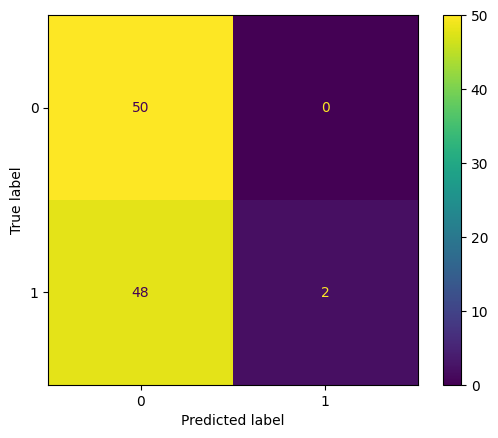

In [144]:
# Confusion matrix view - Almost all predictions are phishing - not good
cm = confusion_matrix(y_test_100, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [160]:
# testing data on random forest model - making predictions
rf_pred_test = pipeline_rf_all.predict(X_test_100)

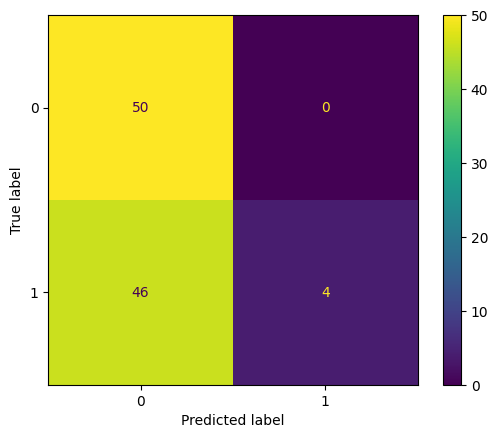

In [172]:
# Confusion matrix - better, but still bad
rf_cm_test = confusion_matrix(y_test_100, rf_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_test)
disp.plot()

In [173]:
# Testing on XGBoost model - making predictions
xgb_pred_test = pipeline_xgb_all.predict(X_test_100)

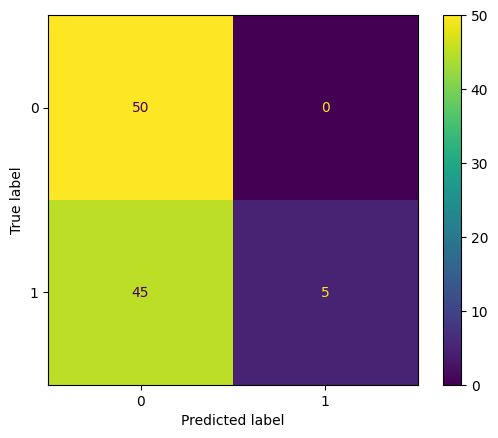

In [181]:
# Confusion matrix - better again, still not good
xgb_cm_test = confusion_matrix(y_test_100, xgb_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm_test)
disp.plot()

In [182]:
# Testing knn - making predictions
knn_pred_test = pipeline_knn_all.predict(X_test_100)

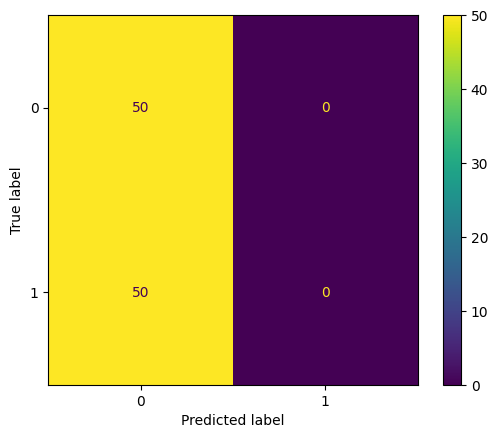

In [184]:
# Confusion matrix - all predictions are phishing, worst model yet.
knn_cm_test = confusion_matrix(y_test_100, knn_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm_test)
disp.plot()

In [201]:
# Testing on Neural network - transforming data
X_test_100_transfomred = preprocessor_all.transform(X_test_100)

In [203]:
# Making predictions
NN_pred_100_prob = model.predict(X_test_100_transfomred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [204]:
# Getting highest prediction
NN_pred_100 = (NN_pred_100_prob > 0.5).astype(int)

In [206]:
# Confusion matrix, classification report, roc auc - all not good
print(confusion_matrix(y_test_100, NN_pred_100))
print(classification_report(y_test_100, NN_pred_100))
print("ROC AUC:", roc_auc_score(y_test_100, NN_pred_100_prob))


[[50  0]
 [50  0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100

ROC AUC: 0.762


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [337]:
#xgb_pred_test_1000 = pipeline_xgb_all.predict(X_test_1000)

## Reverse modeling - modeling on datset of URL's with labels and gets info from phishing features class
## Tests on original UCI dataset

## Do not run cell below - could take over an hour to run - 
## Data captured below is saved in 10k_URL_Training.csv

In [211]:
features_list_1000 = []

# Loop through list of 1000 URL's and use phishing features class to get data
for _, row in tqdm(test_df_1000.iterrows(), desc="Getting Phishing Features"):
    extractor = PhishingFeatureExtractor(row['url'])
    features = extractor.to_dict()
    features['label'] = row['label']
    features['URL'] = row['url']
    features_list_1000.append(features)

# Save as a DataFrame
features_df = pd.DataFrame(features_list_1000)

Getting Phishing Features: 30it [00:42,  1.67s/it]

Request failed: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a8099890>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682ae950>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.list.tmall.com: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c8669c50>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 34it [00:43,  1.49it/s]

Request failed: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.t.co: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 60it [01:36,  1.59s/it]

Request failed: HTTPSConnectionPool(host='www.microsoftonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a82d1750>: Failed to resolve 'www.microsoftonline.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.microsoftonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a82bb790>: Failed to resolve 'www.microsoftonline.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.microsoftonline.com: HTTPSConnectionPool(host='www.microsoftonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747cbb690>: Failed to resolve 'www.microsoftonline.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 70it [01:43,  1.34it/s]

Request failed: HTTPSConnectionPool(host='www.deloton.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27885bec10>: Failed to resolve 'www.deloton.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.deloton.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27885e2e50>: Failed to resolve 'www.deloton.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.deloton.com: HTTPSConnectionPool(host='www.deloton.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27885cc390>: Failed to resolve 'www.deloton.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 76it [01:49,  1.24it/s]

Request failed: HTTPSConnectionPool(host='www.detail.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ffb3c10>: Failed to resolve 'www.detail.tmall.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.detail.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ffca250>: Failed to resolve 'www.detail.tmall.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.detail.tmall.com: HTTPSConnectionPool(host='www.detail.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ffc8090>: Failed to resolve 'www.detail.tmall.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 77it [01:50,  1.17it/s]

Request failed: HTTPSConnectionPool(host='www.diply.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.diply.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 78it [02:06,  5.20s/it]

Error checking self redirects for https://www.diply.com: HTTPSConnectionPool(host='www.diply.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 94it [02:38,  1.16s/it]

Request failed: HTTPSConnectionPool(host='www.tianya.cn', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287edda2d0>: Failed to resolve 'www.tianya.cn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tianya.cn', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eddb0d0>: Failed to resolve 'www.tianya.cn' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 95it [02:56,  6.28s/it]

Error checking self redirects for https://www.tianya.cn: HTTPSConnectionPool(host='www.tianya.cn', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287edecc50>: Failed to resolve 'www.tianya.cn' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 119it [03:31,  1.22s/it]

Request failed: HTTPSConnectionPool(host='www.amazonaws.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287e2cb3d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.amazonaws.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ecab290>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 120it [03:36,  2.38s/it]

Error checking self redirects for https://www.amazonaws.com: HTTPSConnectionPool(host='www.amazonaws.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ec9c950>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 121it [03:39,  2.34s/it]

Request failed: HTTPSConnectionPool(host='www.onlinesbi.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ec9ded0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
Redirect check failed: HTTPSConnectionPool(host='www.onlinesbi.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ec28d90>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
Error checking self redirects for https://www.onlinesbi.com: HTTPSConnectionPool(host='www.onlinesbi.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ec2b210>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
Request failed: HTTPSConnectionPool(host='www.exdynsrv.com', port=443): Max retries exceeded with url: / (Caused by Name

Getting Phishing Features: 123it [03:40,  1.69s/it]

Request failed: HTTPSConnectionPool(host='www.rakuten.co.jp', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.rakuten.co.jp', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 125it [03:56,  3.79s/it]

Error checking self redirects for https://www.rakuten.co.jp: HTTPSConnectionPool(host='www.rakuten.co.jp', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 130it [04:01,  1.61s/it]

Request failed: HTTPSConnectionPool(host='www.openload.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.openload.co'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.openload.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.openload.co'. (_ssl.c:1006)")))
Error checking self redirects for https://www.openload.co: HTTPSConnectionPool(host='www.openload.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.openload.co'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.iwanttodel

Getting Phishing Features: 131it [04:30,  9.68s/it]

Error checking self redirects for https://www.iwanttodeliver.com: HTTPSConnectionPool(host='www.iwanttodeliver.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f31ae10>, 'Connection to www.iwanttodeliver.com timed out. (connect timeout=5)'))


Getting Phishing Features: 159it [05:00,  1.57s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 160it [05:01,  1.26s/it]

Error checking self redirects for https://www.queuecosm.bid: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 166it [05:08,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.exosrv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747a9f5d0>: Failed to resolve 'www.exosrv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.exosrv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b4ac10>: Failed to resolve 'www.exosrv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.exosrv.com: HTTPSConnectionPool(host='www.exosrv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747a9b650>: Failed to resolve 'www.exosrv.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 178it [05:24,  1.04s/it]

Request failed: HTTPSConnectionPool(host='www.twimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287da106d0>: Failed to resolve 'www.twimg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.twimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287febe590>: Failed to resolve 'www.twimg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.twimg.com: HTTPSConnectionPool(host='www.twimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287feac710>: Failed to resolve 'www.twimg.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.redd.it', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<

Getting Phishing Features: 187it [05:29,  1.95it/s]

Request failed: HTTPSConnectionPool(host='www.cloudfront.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d608ad0>: Failed to resolve 'www.cloudfront.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cloudfront.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d66af90>: Failed to resolve 'www.cloudfront.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cloudfront.net: HTTPSConnectionPool(host='www.cloudfront.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2e7090>: Failed to resolve 'www.cloudfront.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 190it [05:30,  2.15it/s]

Request failed: HTTPSConnectionPool(host='www.login.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee907d0>: Failed to resolve 'www.login.tmall.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.login.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d6972d0>: Failed to resolve 'www.login.tmall.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.login.tmall.com: HTTPSConnectionPool(host='www.login.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee91d90>: Failed to resolve 'www.login.tmall.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 193it [05:35,  1.02s/it]

Request failed: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 194it [05:50,  5.04s/it]

Error checking self redirects for https://www.washingtonpost.com: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.pinimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e97c750>: Failed to resolve 'www.pinimg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pinimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e97c8d0>: Failed to resolve 'www.pinimg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pinimg.com: HTTPSConnectionPool(host='www.pinimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e97ebd0>: Failed to resolve 'www.pinimg.com' ([Errno

Getting Phishing Features: 197it [05:54,  2.91s/it]

Request failed: HTTPSConnectionPool(host='www.tokopedia.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.tokopedia.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 198it [06:08,  5.64s/it]

Error checking self redirects for https://www.tokopedia.com: HTTPSConnectionPool(host='www.tokopedia.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 217it [06:31,  2.16it/s]

Request failed: HTTPSConnectionPool(host='www.pages.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dae1c50>: Failed to resolve 'www.pages.tmall.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pages.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dadcf50>: Failed to resolve 'www.pages.tmall.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pages.tmall.com: HTTPSConnectionPool(host='www.pages.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dadd010>: Failed to resolve 'www.pages.tmall.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 224it [06:37,  1.21it/s]

Request failed: HTTPSConnectionPool(host='www.gearbest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d3edd90>: Failed to resolve 'www.gearbest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gearbest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27883b1fd0>: Failed to resolve 'www.gearbest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gearbest.com: HTTPSConnectionPool(host='www.gearbest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff278844bdd0>: Failed to resolve 'www.gearbest.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 230it [06:43,  1.07it/s]

Request failed: HTTPSConnectionPool(host='www.bet9ja.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.bet9ja.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 231it [06:56,  4.56s/it]

Error checking self redirects for https://www.bet9ja.com: HTTPSConnectionPool(host='www.bet9ja.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 232it [06:57,  3.53s/it]

Request failed: HTTPSConnectionPool(host='www.spotscenered.info', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd63b10>: Failed to resolve 'www.spotscenered.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.spotscenered.info', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f716010>: Failed to resolve 'www.spotscenered.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.spotscenered.info: HTTPSConnectionPool(host='www.spotscenered.info', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7e8d50>: Failed to resolve 'www.spotscenered.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 237it [07:08,  2.07s/it]

Request failed: HTTPSConnectionPool(host='www.gfycat.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f798790>: Failed to resolve 'www.gfycat.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gfycat.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747cfd4d0>: Failed to resolve 'www.gfycat.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gfycat.com: HTTPSConnectionPool(host='www.gfycat.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747cfc7d0>: Failed to resolve 'www.gfycat.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 243it [07:14,  1.02s/it]

Request failed: HTTPSConnectionPool(host='www.bp.blogspot.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfa1fd0>: Failed to resolve 'www.bp.blogspot.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bp.blogspot.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfb4810>: Failed to resolve 'www.bp.blogspot.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.bp.blogspot.com: HTTPSConnectionPool(host='www.bp.blogspot.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfb6390>: Failed to resolve 'www.bp.blogspot.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 292it [08:15,  2.68s/it]

Request failed: HTTPSConnectionPool(host='www.mmoframes.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc68ed0>: Failed to resolve 'www.mmoframes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mmoframes.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc9e7d0>: Failed to resolve 'www.mmoframes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mmoframes.com: HTTPSConnectionPool(host='www.mmoframes.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc9ef10>: Failed to resolve 'www.mmoframes.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 302it [08:23,  1.43it/s]

Request failed: HTTPSConnectionPool(host='www.irctc.co.in', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.irctc.co.in', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 303it [08:39,  5.39s/it]

Error checking self redirects for https://www.irctc.co.in: HTTPSConnectionPool(host='www.irctc.co.in', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 304it [08:42,  4.59s/it]

Request failed: HTTPSConnectionPool(host='www.h8vzwpv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ec6c6d0>: Failed to resolve 'www.h8vzwpv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.h8vzwpv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ec6d650>: Failed to resolve 'www.h8vzwpv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.h8vzwpv.com: HTTPSConnectionPool(host='www.h8vzwpv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a845fad0>: Failed to resolve 'www.h8vzwpv.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 308it [08:43,  1.57s/it]

Request failed: HTTPSConnectionPool(host='www.zippyshare.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2747b3be10>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.zippyshare.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ea61810>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 309it [08:49,  2.88s/it]

Error checking self redirects for https://www.zippyshare.com: HTTPSConnectionPool(host='www.zippyshare.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ea61f90>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 317it [09:08,  2.29s/it]

Error checking favicon file at https://www.sberbank.ru/favicon.ico: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 321it [09:16,  1.71s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 322it [09:16,  1.34s/it]

Error checking self redirects for https://www.rumble.com: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 323it [09:17,  1.14s/it]

Request failed: HTTPSConnectionPool(host='www.ign.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 330it [10:00,  3.30s/it]

Request failed: HTTPSConnectionPool(host='www.higheurest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d2b4a10>: Failed to resolve 'www.higheurest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.higheurest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d23db10>: Failed to resolve 'www.higheurest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.higheurest.com: HTTPSConnectionPool(host='www.higheurest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d23f590>: Failed to resolve 'www.higheurest.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 335it [10:07,  1.73s/it]

Request failed: HTTPSConnectionPool(host='www.livedoor.jp', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e7e59d0>: Failed to resolve 'www.livedoor.jp' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.livedoor.jp', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ff491d0>: Failed to resolve 'www.livedoor.jp' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.livedoor.jp: HTTPSConnectionPool(host='www.livedoor.jp', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682cbad0>: Failed to resolve 'www.livedoor.jp' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 354it [10:28,  1.38s/it]

Request failed: HTTPSConnectionPool(host='www.subject.tmall.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.subject.tmall.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.subject.tmall.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.subject.tmall.com'. (_ssl.c:1006)")))


Getting Phishing Features: 355it [10:32,  2.05s/it]

Error checking self redirects for https://www.subject.tmall.com: HTTPSConnectionPool(host='www.subject.tmall.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.subject.tmall.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.bestadbid.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a8412c10>: Failed to resolve 'www.bestadbid.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bestadbid.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f564390>: Failed to resolve 'www.bestadbid.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.bestadbid.com: HTTPSConnec

Getting Phishing Features: 369it [10:45,  1.18it/s]

Request failed: HTTPSConnectionPool(host='www.asos.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.asos.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 370it [11:00,  5.17s/it]

Error checking self redirects for https://www.asos.com: HTTPSConnectionPool(host='www.asos.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 372it [11:01,  2.82s/it]

Request failed: HTTPSConnectionPool(host='www.doublepimp.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27a8670710>, 'Connection to www.doublepimp.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.doublepimp.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e514b90>, 'Connection to www.doublepimp.com timed out. (connect timeout=5)'))


Getting Phishing Features: 373it [11:30, 10.52s/it]

Error checking self redirects for https://www.doublepimp.com: HTTPSConnectionPool(host='www.doublepimp.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d2b91d0>, 'Connection to www.doublepimp.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.mcafee.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.mcafee.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 374it [11:44, 11.72s/it]

Error checking self redirects for https://www.siteadvisor.com: HTTPSConnectionPool(host='www.mcafee.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 380it [11:49,  2.02s/it]

Request failed: HTTPSConnectionPool(host='www.banvenez.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747a85690>: Failed to resolve 'www.banvenez.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.banvenez.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747a85f90>: Failed to resolve 'www.banvenez.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.banvenez.com: HTTPSConnectionPool(host='www.banvenez.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b40f10>: Failed to resolve 'www.banvenez.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 387it [11:56,  1.28s/it]

Request failed: HTTPSConnectionPool(host='www.ups.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.ups.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 388it [12:09,  4.82s/it]

Error checking self redirects for https://www.ups.com: HTTPSConnectionPool(host='www.ups.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 390it [12:11,  2.98s/it]

Request failed: HTTPSConnectionPool(host='www.kissanime.ru', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.kissanime.ru', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 391it [12:13,  2.48s/it]

Error checking self redirects for https://www.kissanime.ru: HTTPSConnectionPool(host='www.kissanime.ru', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 405it [12:31,  1.66s/it]

Request failed: HTTPSConnectionPool(host='www.perfecttoolmedia.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85f63d0>: Failed to resolve 'www.perfecttoolmedia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.perfecttoolmedia.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff276869c810>: Failed to resolve 'www.perfecttoolmedia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.perfecttoolmedia.com: HTTPSConnectionPool(host='www.perfecttoolmedia.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff276869d810>: Failed to resolve 'www.perfecttoolmedia.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 407it [12:35,  1.64s/it]

Request failed: HTTPSConnectionPool(host='www.wittyfeed.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27a85f50d0>, 'Connection to www.wittyfeed.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.wittyfeed.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27c81b8e90>, 'Connection to www.wittyfeed.com timed out. (connect timeout=5)'))


Getting Phishing Features: 408it [12:48,  4.58s/it]

Error checking self redirects for https://www.wittyfeed.com: HTTPSConnectionPool(host='www.wittyfeed.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f0739d0>, 'Connection to www.wittyfeed.com timed out. (connect timeout=5)'))


Getting Phishing Features: 411it [12:52,  2.36s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 412it [12:53,  2.17s/it]

Error checking self redirects for https://www.gismeteo.ru: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 423it [13:07,  1.57s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 424it [13:08,  1.32s/it]

Error checking self redirects for https://www.m73lae5cpmgrv38.com: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 427it [13:24,  4.89s/it]

Request failed: HTTPSConnectionPool(host='www.doublepimpssl.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.doublepimpssl.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 428it [13:38,  7.49s/it]

Error checking self redirects for https://www.doublepimpssl.com: HTTPSConnectionPool(host='www.doublepimpssl.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 432it [13:41,  2.42s/it]

Request failed: HTTPSConnectionPool(host='www.pipeschannels.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2768313dd0>: Failed to resolve 'www.pipeschannels.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pipeschannels.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2768310210>: Failed to resolve 'www.pipeschannels.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pipeschannels.com: HTTPSConnectionPool(host='www.pipeschannels.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2768312610>: Failed to resolve 'www.pipeschannels.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 434it [13:42,  1.48s/it]

Request failed: HTTPSConnectionPool(host='www.homedepot.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.homedepot.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 435it [13:57,  4.90s/it]

Error checking self redirects for https://www.homedepot.com: HTTPSConnectionPool(host='www.homedepot.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 443it [14:01,  1.22it/s]

Request failed: HTTPSConnectionPool(host='www.fedex.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.fedex.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 444it [14:16,  3.43s/it]

Error checking self redirects for https://www.fedex.com: HTTPSConnectionPool(host='www.fedex.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 469it [14:50,  1.41it/s]

Request failed: HTTPSConnectionPool(host='www.v3rjvtt.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d4ba910>: Failed to resolve 'www.v3rjvtt.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.v3rjvtt.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d4b90d0>: Failed to resolve 'www.v3rjvtt.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.v3rjvtt.com: HTTPSConnectionPool(host='www.v3rjvtt.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d4a8790>: Failed to resolve 'www.v3rjvtt.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.alicdn.com', port=443): Max retries exceeded with url: / (Caused by Conne

Getting Phishing Features: 471it [15:19,  7.05s/it]

Error checking self redirects for https://www.alicdn.com: HTTPSConnectionPool(host='www.alicdn.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d4ab350>, 'Connection to www.alicdn.com timed out. (connect timeout=5)'))


Getting Phishing Features: 474it [15:20,  3.09s/it]

Request failed: HTTPSConnectionPool(host='www.17ok.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dca2b50>: Failed to resolve 'www.17ok.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.17ok.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dce16d0>: Failed to resolve 'www.17ok.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.17ok.com: HTTPSConnectionPool(host='www.17ok.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dce32d0>: Failed to resolve 'www.17ok.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 476it [15:21,  1.85s/it]

Request failed: HTTPSConnectionPool(host='www.bldaily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dce3d90>: Failed to resolve 'www.bldaily.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bldaily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dce0490>: Failed to resolve 'www.bldaily.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.bldaily.com: HTTPSConnectionPool(host='www.bldaily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f468590>: Failed to resolve 'www.bldaily.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 477it [15:22,  1.64s/it]

Request failed: HTTPSConnectionPool(host='www.lie2anyone.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f477990>: Failed to resolve 'www.lie2anyone.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lie2anyone.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f42da50>: Failed to resolve 'www.lie2anyone.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lie2anyone.com: HTTPSConnectionPool(host='www.lie2anyone.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f42ed50>: Failed to resolve 'www.lie2anyone.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 496it [15:50,  1.34s/it]

Request failed: HTTPSConnectionPool(host='www.nextlnk1.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f262ed0>: Failed to resolve 'www.nextlnk1.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.nextlnk1.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f261c10>: Failed to resolve 'www.nextlnk1.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.nextlnk1.com: HTTPSConnectionPool(host='www.nextlnk1.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f260150>: Failed to resolve 'www.nextlnk1.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 499it [15:51,  1.49it/s]

Request failed: HTTPSConnectionPool(host='www.ytimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2d3fd0>: Failed to resolve 'www.ytimg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ytimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1bc590>: Failed to resolve 'www.ytimg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ytimg.com: HTTPSConnectionPool(host='www.ytimg.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1c5f90>: Failed to resolve 'www.ytimg.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='atualizacaodedados.online', port=80): Max retries exceeded with url: / (Caused by NameResolu

Getting Phishing Features: 502it [15:53,  1.52it/s]

Request failed: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f1c74d0>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f1ceb10>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://stcdxmt.bigperl.in/klxtv/apps/uk/: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e744190>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='tubuh-sya

Getting Phishing Features: 504it [16:07,  2.70s/it]

Error checking self redirects for https://tubuh-syarikat.com/plugins/fields/files/: HTTPSConnectionPool(host='tubuh-syarikat.com', port=443): Max retries exceeded with url: /plugins/fields/files/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f1cc6d0>, 'Connection to tubuh-syarikat.com timed out. (connect timeout=5)'))


Getting Phishing Features: 505it [16:07,  2.26s/it]

Request failed: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f2d2790>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f1c5f50>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 506it [16:26,  5.76s/it]

Error checking self redirects for http://ongelezen-voda.000webhostapp.com/inloggen.html: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a837fe10>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 508it [16:32,  4.40s/it]

Request failed: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3f79d0>: Failed to resolve 'membership-issue.forteimpex.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f101910>: Failed to resolve 'membership-issue.forteimpex.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://membership-issue.forteimpex.com/dk2mmm=/?resType=code&amp;failedBe=: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnecti

Getting Phishing Features: 517it [16:37,  1.30s/it]

Request failed: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e9050>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3eba50>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.tevhidigundem.ml/login/: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dca2a50>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='cancel.direct.page-scure124

Getting Phishing Features: 519it [16:37,  1.14it/s]

Request failed: HTTPConnectionPool(host='upperhouse.000webhostapp.com', port=80): Max retries exceeded with url: /ksovo/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f102590>: Failed to resolve 'upperhouse.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 520it [16:50,  3.45s/it]

Redirect check failed: HTTPConnectionPool(host='upperhouse.000webhostapp.com', port=80): Max retries exceeded with url: /ksovo/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f101f10>: Failed to resolve 'upperhouse.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://upperhouse.000webhostapp.com/ksovo/index.php: HTTPConnectionPool(host='upperhouse.000webhostapp.com', port=80): Max retries exceeded with url: /ksovo/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3ebed0>: Failed to resolve 'upperhouse.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='kungaguesthouse.com', port=80): Max retries exceeded with url: /wp-admin/english/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e3ebbd0>, 'Connection to kungaguesthouse.com timed out. (connect timeout=5)'))
Redirec

Getting Phishing Features: 521it [17:06,  6.08s/it]

Error checking self redirects for http://kungaguesthouse.com/wp-admin/english/: HTTPConnectionPool(host='kungaguesthouse.com', port=80): Max retries exceeded with url: /wp-admin/english/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e34b090>, 'Connection to kungaguesthouse.com timed out. (connect timeout=5)'))


Getting Phishing Features: 523it [17:07,  3.67s/it]

Request failed: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3ebf50>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e81d0>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hostcpanelverfyonline.16mb.com/micav.php: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f102e10>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service n

Getting Phishing Features: 524it [17:30,  8.99s/it]

Error checking self redirects for https://rexlbox.000webhostapp.com/docs/secure/verification.html: HTTPSConnectionPool(host='rexlbox.000webhostapp.com', port=443): Max retries exceeded with url: /docs/secure/verification.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3bd090>: Failed to resolve 'rexlbox.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='secure000-webpaypal.com', port=443): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f102b90>: Failed to resolve 'secure000-webpaypal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='secure000-webpaypal.com', port=443): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f100110>: Failed to resolve 'secure000-webpaypal.com' ([Errno -2] Name or servic

Getting Phishing Features: 526it [17:51,  9.46s/it]

Error checking self redirects for http://linkedln-contact.000webhostapp.com/login.html: HTTPConnectionPool(host='linkedln-contact.000webhostapp.com', port=80): Max retries exceeded with url: /login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bed90>: Failed to resolve 'linkedln-contact.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 527it [17:53,  7.68s/it]

Request failed: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3ea650>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e8b10>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 528it [18:13, 10.91s/it]

Error checking self redirects for http://jhiulog-in0045.000webhostapp.com/xfinity/au/tes/ver/home/: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f262d10>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f100410>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 529it [18:23, 10.70s/it]

Redirect check failed: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bf910>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://securityceckpoins.000webhostapp.com/bayar/set.html: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3b6a90>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f103a10>: Failed to resolve 'm

Getting Phishing Features: 530it [18:43, 13.28s/it]

Error checking self redirects for http://member-unblock.000webhostapp.com/Unblock/inet-update-01.html: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bd510>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3eb1d0>: Failed to resolve 'donefe.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3b6310>: Failed to resolve 'd

Getting Phishing Features: 531it [19:01, 14.70s/it]

Error checking self redirects for http://donefe.000webhostapp.com/auto/auto%20ferify/mail.php: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27883b0990>: Failed to resolve 'donefe.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='drcharys.com', port=80): Max retries exceeded with url: /admin/js/regain/login.php?cmd=login_submit&id=4f796368ffdd2b0a79f3c7ba91368e824f796368ffdd2b0a79f3c7ba91368e82&session=4f796368ffdd2b0a79f3c7ba91368e824f796368ffdd2b0a79f3c7ba91368e82 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3be810>: Failed to resolve 'drcharys.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='drcharys.com', port=80): Max retries exceeded with url: /admin/js/regain/login.php?cmd=login_submit&id=

Getting Phishing Features: 535it [19:04,  5.10s/it]

Request failed: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3e8550>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e348690>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 536it [19:20,  7.85s/it]

Error checking self redirects for https://egamandala0031.000webhostapp.com/bayar/VisaPayments.html?fb_source=bookmark_apps: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e348290>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='dowf-cleat.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bce10>: Failed to resolve 'dowf-cleat.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='dowf-cleat.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object a

Getting Phishing Features: 537it [19:44, 12.33s/it]

Error checking self redirects for http://dowf-cleat.000webhostapp.com/Office365.php: HTTPConnectionPool(host='dowf-cleat.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bded0>: Failed to resolve 'dowf-cleat.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.yeezy-christmas.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3ea190>: Failed to resolve 'www.yeezy-christmas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.yeezy-christmas.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e349550>: Failed to resolve 'www.yeezy-christmas.com' ([Errno -2] Name or service not known)"))
Error checking self redirects f

Getting Phishing Features: 539it [20:05, 11.71s/it]

Error checking self redirects for http://chas-serv.000webhostapp.com/LogOn17/LogOn/auth/home/auth/: HTTPConnectionPool(host='chas-serv.000webhostapp.com', port=80): Max retries exceeded with url: /LogOn17/LogOn/auth/home/auth/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f2d2150>: Failed to resolve 'chas-serv.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 540it [20:06,  9.11s/it]

Request failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3ea310>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 541it [20:20, 10.26s/it]

Redirect check failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e34afd0>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://member-unblock.000webhostapp.com/Unblock/recovery-chekpoint-login.html: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f1029d0>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='security-center-clien.com', port=80): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3b

Getting Phishing Features: 543it [20:39,  9.90s/it]

Error checking self redirects for https://serviceactivation-page2018.000webhostapp.com/page2018/bayar/set.html: HTTPSConnectionPool(host='serviceactivation-page2018.000webhostapp.com', port=443): Max retries exceeded with url: /page2018/bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f102e50>: Failed to resolve 'serviceactivation-page2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 545it [20:55,  8.57s/it]

Request failed: HTTPSConnectionPool(host='sercure-pagealert.cf', port=443): Max retries exceeded with url: /?checkpoint=facebook.com/standart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3eaf10>: Failed to resolve 'sercure-pagealert.cf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='sercure-pagealert.cf', port=443): Max retries exceeded with url: /?checkpoint=facebook.com/standart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3499d0>: Failed to resolve 'sercure-pagealert.cf' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://sercure-pagealert.cf/?checkpoint=facebook.com/standart: HTTPSConnectionPool(host='sercure-pagealert.cf', port=443): Max retries exceeded with url: /?checkpoint=facebook.com/standart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f100210>: Failed to resolve 'sercure-pageale

Getting Phishing Features: 549it [21:01,  3.65s/it]

Request failed: HTTPConnectionPool(host='zonasegurabcpenlinea.mospacepe.com', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb998d0>: Failed to resolve 'zonasegurabcpenlinea.mospacepe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zonasegurabcpenlinea.mospacepe.com', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ebdd850>: Failed to resolve 'zonasegurabcpenlinea.mospacepe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://zonasegurabcpenlinea.mospacepe.com/bcp/: HTTPConnectionPool(host='zonasegurabcpenlinea.mospacepe.com', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d225910>: Failed to resolve 'zonasegurabcpenlinea.mospacepe.com' ([Errno -2] Name or s

Getting Phishing Features: 551it [21:19,  5.99s/it]

Error checking self redirects for https://sites-recovery.000webhostapp.com/SECURITY-RECOVERY-FB.html: HTTPSConnectionPool(host='sites-recovery.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-RECOVERY-FB.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb98750>: Failed to resolve 'sites-recovery.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='app-page2017.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9b690>: Failed to resolve 'app-page2017.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='app-page2017.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object a

Getting Phishing Features: 552it [21:38,  8.88s/it]

Error checking self redirects for https://app-page2017.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='app-page2017.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3f7a50>: Failed to resolve 'app-page2017.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='xn--paypa-b6a.com-csid.guacowoumildbro.net', port=443): Max retries exceeded with url: /webapps/1dce0/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdf1d0>: Failed to resolve 'xn--paypa-b6a.com-csid.guacowoumildbro.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='xn--paypa-b6a.com-csid.guacowoumildbro.net', port=443): Max retries exceeded with url: /webapps/1dce0/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0

Getting Phishing Features: 554it [21:58,  9.41s/it]

Error checking self redirects for https://sites-fb-ads-2018.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='sites-fb-ads-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdfe10>: Failed to resolve 'sites-fb-ads-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='gatcoins.io', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9a790>: Failed to resolve 'gatcoins.io' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gatcoins.io', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb994d0>: Failed to resolve 'gatcoins.io' ([Errno -2] Name or service not known)"))
Error checking self re

Getting Phishing Features: 558it [22:01,  4.35s/it]

Request failed: HTTPSConnectionPool(host='token-selfkey.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb98c50>: Failed to resolve 'token-selfkey.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='token-selfkey.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdf5d0>: Failed to resolve 'token-selfkey.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://token-selfkey.org/: HTTPSConnectionPool(host='token-selfkey.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdd290>: Failed to resolve 'token-selfkey.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mercadobiitcoin.com', port=80): Max retries exceeded with url: 

Getting Phishing Features: 560it [22:05,  3.29s/it]

Request failed: HTTPConnectionPool(host='provencaeventos.com.br', port=80): Max retries exceeded with url: /wp-content/plugins/css-ready-selectors/BOA/home/info.php?cmd=login_submit&amp;id=ea7b3ca8045eb29bfd1be4ced16041a8ea7b3ca8045eb29bfd1be4ced16041a8&amp;session=ea7b3ca8045eb29bfd1be4ced16041a8ea7b3ca8045eb29bfd1be4ced16041a8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e8c50>: Failed to resolve 'provencaeventos.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='provencaeventos.com.br', port=80): Max retries exceeded with url: /wp-content/plugins/css-ready-selectors/BOA/home/info.php?cmd=login_submit&amp;id=ea7b3ca8045eb29bfd1be4ced16041a8ea7b3ca8045eb29bfd1be4ced16041a8&amp;session=ea7b3ca8045eb29bfd1be4ced16041a8ea7b3ca8045eb29bfd1be4ced16041a8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ebca2d0>: Failed to resolve 'provencaeventos.com.br' ([Errno -2] Nam

Getting Phishing Features: 563it [22:06,  1.89s/it]

Request failed: HTTPSConnectionPool(host='securityceckpoins.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9ba10>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='securityceckpoins.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdee90>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 564it [22:30,  6.96s/it]

Error checking self redirects for https://securityceckpoins.000webhostapp.com/bayar/VisaPayments.html?fb_source=bookmark_apps: HTTPSConnectionPool(host='securityceckpoins.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdfed0>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='sites-notification-2018.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3ebc50>: Failed to resolve 'sites-notification-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 565it [22:45,  9.08s/it]

Redirect check failed: HTTPConnectionPool(host='sites-notification-2018.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9c750>: Failed to resolve 'sites-notification-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sites-notification-2018.000webhostapp.com/recovery-answer.html: HTTPConnectionPool(host='sites-notification-2018.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9fed0>: Failed to resolve 'sites-notification-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='sites-notification-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnec

Getting Phishing Features: 567it [22:46,  5.34s/it]

Request failed: HTTPConnectionPool(host='neilcuthbert.com', port=80): Max retries exceeded with url: /neilcuthbert.com/wp-content/upgrade/Feb/fib/fib/finaly/cgibin/ucc/pross/cmd=/secc/esp/web/billing.html?Dispatch=ce82062aa5dd7e94f84f9d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb98f10>: Failed to resolve 'neilcuthbert.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='neilcuthbert.com', port=80): Max retries exceeded with url: /neilcuthbert.com/wp-content/upgrade/Feb/fib/fib/finaly/cgibin/ucc/pross/cmd=/secc/esp/web/billing.html?Dispatch=ce82062aa5dd7e94f84f9d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb4edd0>: Failed to resolve 'neilcuthbert.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://neilcuthbert.com/neilcuthbert.com/wp-content/upgrade/Feb/fib/fib/finaly/cgibin/ucc/pross/cmd=/secc/esp/web/billing.html?Dispatch=ce8

Getting Phishing Features: 571it [22:46,  2.25s/it]

Request failed: HTTPConnectionPool(host='www.camarapalminopolis.go.gov.br', port=80): Max retries exceeded with url: /.well-known/pki-validation/Paypal/customer_center/customer-IDPP00C747/myaccount/signin/?country.x=BR&amp;locale.x=en_BR (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb33590>: Failed to resolve 'www.camarapalminopolis.go.gov.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.camarapalminopolis.go.gov.br', port=80): Max retries exceeded with url: /.well-known/pki-validation/Paypal/customer_center/customer-IDPP00C747/myaccount/signin/?country.x=BR&amp;locale.x=en_BR (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9b350>: Failed to resolve 'www.camarapalminopolis.go.gov.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.camarapalminopolis.go.gov.br/.well-known/pki-validation/Paypal/customer_center/customer-IDPP00

Getting Phishing Features: 572it [23:00,  4.52s/it]

Error checking self redirects for https://stockier-slinging.000webhostapp.com/welldata/well.data/online/info/log/info/data/6fs52h6g52f6d3g5h6j95hdgsfd2gh59d6g5fsd2/log/update.php?auth/login/log?origin=cob&amp;lor=7414&amp;LOB=CONS&amp;destination=AccountSummary: HTTPSConnectionPool(host='stockier-slinging.000webhostapp.com', port=443): Max retries exceeded with url: /welldata/well.data/online/info/log/info/data/6fs52h6g52f6d3g5h6j95hdgsfd2gh59d6g5fsd2/log/update.php?auth/login/log?origin=cob&amp;lor=7414&amp;LOB=CONS&amp;destination=AccountSummary (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9e4d0>: Failed to resolve 'stockier-slinging.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='kotebis.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionE

Getting Phishing Features: 573it [23:20,  7.97s/it]

Error checking self redirects for https://kotebis.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed: HTTPSConnectionPool(host='kotebis.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebc8890>: Failed to resolve 'kotebis.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='kotebis.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3bfad0>: Failed to resolve 'kotebis.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='kotebis.000webhostapp.com', port=443): Max retri

Getting Phishing Features: 574it [23:35,  9.66s/it]

Error checking self redirects for https://kotebis.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='kotebis.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9f450>: Failed to resolve 'kotebis.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 576it [23:35,  5.36s/it]

Request failed: HTTPConnectionPool(host='www.aykensdrafting.com.au', port=80): Max retries exceeded with url: /wp-images/admin/newadobe/venza/data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e9b50>: Failed to resolve 'www.aykensdrafting.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.aykensdrafting.com.au', port=80): Max retries exceeded with url: /wp-images/admin/newadobe/venza/data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9a350>: Failed to resolve 'www.aykensdrafting.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.aykensdrafting.com.au/wp-images/admin/newadobe/venza/data/: HTTPConnectionPool(host='www.aykensdrafting.com.au', port=80): Max retries exceeded with url: /wp-images/admin/newadobe/venza/data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ebca290>: Fa

Getting Phishing Features: 578it [23:54,  7.11s/it]

Error checking self redirects for https://generate-check.000webhostapp.com/Unblock/recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed: HTTPSConnectionPool(host='generate-check.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9d650>: Failed to resolve 'generate-check.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 580it [23:55,  4.18s/it]

Request failed: HTTPSConnectionPool(host='generate-check.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3bc990>: Failed to resolve 'generate-check.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='generate-check.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1027d0>: Failed to resolve 'generate-check.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 581it [24:15,  8.39s/it]

Error checking self redirects for https://generate-check.000webhostapp.com/Unblock/recovery-chekpoint-login.html: HTTPSConnectionPool(host='generate-check.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdd450>: Failed to resolve 'generate-check.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='settings-identitiy.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb33a50>: Failed to resolve 'settings-identitiy.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 582it [24:30, 10.30s/it]

Redirect check failed: HTTPSConnectionPool(host='settings-identitiy.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f260d50>: Failed to resolve 'settings-identitiy.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://settings-identitiy.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='settings-identitiy.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9f810>: Failed to resolve 'settings-identitiy.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 583it [24:31,  7.65s/it]

Request failed: HTTPConnectionPool(host='www.webappsresolve-case-account.com', port=80): Max retries exceeded with url: /webapps/db093/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9f110>: Failed to resolve 'www.webappsresolve-case-account.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.webappsresolve-case-account.com', port=80): Max retries exceeded with url: /webapps/db093/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ebdd090>: Failed to resolve 'www.webappsresolve-case-account.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.webappsresolve-case-account.com/webapps/db093/websrc: HTTPConnectionPool(host='www.webappsresolve-case-account.com', port=80): Max retries exceeded with url: /webapps/db093/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fb984d0>: Failed

Getting Phishing Features: 585it [24:51,  8.73s/it]

Error checking self redirects for https://upgrade-identity.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='upgrade-identity.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9cb10>: Failed to resolve 'upgrade-identity.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='secure.unconfirmaccounts.ga', port=443): Max retries exceeded with url: /?facebook.com?chekpoint-secure (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebcb750>: Failed to resolve 'secure.unconfirmaccounts.ga' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='secure.unconfirmaccounts.ga', port=443): Max retries exceeded with url: /?facebook.com?chekpoint-secure (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x

Getting Phishing Features: 588it [25:05,  6.72s/it]

Redirect check failed: HTTPSConnectionPool(host='basicinfo-logsnotifregist.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9a310>: Failed to resolve 'basicinfo-logsnotifregist.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://basicinfo-logsnotifregist.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='basicinfo-logsnotifregist.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdc890>: Failed to resolve 'basicinfo-logsnotifregist.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='note-apps-recovery.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-RECOVERY-FB.html (Caused by NameRes

Getting Phishing Features: 589it [25:19,  8.17s/it]

Redirect check failed: HTTPSConnectionPool(host='note-apps-recovery.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-RECOVERY-FB.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb32f50>: Failed to resolve 'note-apps-recovery.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://note-apps-recovery.000webhostapp.com/SECURITY-RECOVERY-FB.html: HTTPSConnectionPool(host='note-apps-recovery.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-RECOVERY-FB.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebc8290>: Failed to resolve 'note-apps-recovery.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='resulta8.beget.tech', port=80): Max retries exceeded with url: /verification/EN0EDN8CD2E9BA726N8A/index.php?co= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnect

Getting Phishing Features: 590it [25:35,  9.70s/it]

Error checking self redirects for http://resulta8.beget.tech/verification/EN0EDN8CD2E9BA726N8A/index.php?co=: HTTPConnectionPool(host='resulta8.beget.tech', port=80): Max retries exceeded with url: /verification/EN0EDN8CD2E9BA726N8A/index.php?co= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ebdf790>, 'Connection to resulta8.beget.tech timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='resulta8.beget.tech', port=80): Max retries exceeded with url: /verification/EN0EDN8CD2E9BA726N8A/index.php?country.x=US-United%20States (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287eb9c5d0>, 'Connection to resulta8.beget.tech timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='resulta8.beget.tech', port=80): Max retries exceeded with url: /verification/EN0EDN8CD2E9BA726N8A/index.php?country.x=US-United%20States (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection 

Getting Phishing Features: 591it [25:49, 10.68s/it]

Error checking self redirects for http://resulta8.beget.tech/verification/EN0EDN8CD2E9BA726N8A/index.php?country.x=US-United%20States: HTTPConnectionPool(host='resulta8.beget.tech', port=80): Max retries exceeded with url: /verification/EN0EDN8CD2E9BA726N8A/index.php?country.x=US-United%20States (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ebc81d0>, 'Connection to resulta8.beget.tech timed out. (connect timeout=5)'))


Getting Phishing Features: 592it [25:53,  9.00s/it]

Request failed: HTTPSConnectionPool(host='odssa.000webhostapp.com', port=443): Max retries exceeded with url: /log/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb32ed0>: Failed to resolve 'odssa.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='odssa.000webhostapp.com', port=443): Max retries exceeded with url: /log/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3eb6d0>: Failed to resolve 'odssa.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 593it [26:13, 11.92s/it]

Error checking self redirects for https://odssa.000webhostapp.com/log/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php: HTTPSConnectionPool(host='odssa.000webhostapp.com', port=443): Max retries exceeded with url: /log/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebdfe90>: Failed to resolve 'odssa.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 594it [26:13,  8.74s/it]

Request failed: HTTPConnectionPool(host='neilcuthbert.com', port=80): Max retries exceeded with url: /neilcuthbert.com/wp-content/upgrade/Feb/fib/fib/finaly/cgibin/ucc/pross/cmd=/secc/esp/web/confirm.html??cmd=step2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e516f90>: Failed to resolve 'neilcuthbert.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='neilcuthbert.com', port=80): Max retries exceeded with url: /neilcuthbert.com/wp-content/upgrade/Feb/fib/fib/finaly/cgibin/ucc/pross/cmd=/secc/esp/web/confirm.html??cmd=step2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb99a10>: Failed to resolve 'neilcuthbert.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://neilcuthbert.com/neilcuthbert.com/wp-content/upgrade/Feb/fib/fib/finaly/cgibin/ucc/pross/cmd=/secc/esp/web/confirm.html??cmd=step2: HTTPConnectionPool(host='neilcuthbert.com'

Getting Phishing Features: 598it [26:28,  5.32s/it]

Redirect check failed: HTTPConnectionPool(host='kotbis1.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fca3f90>: Failed to resolve 'kotbis1.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kotbis1.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed: HTTPConnectionPool(host='kotbis1.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb4dd50>: Failed to resolve 'kotbis1.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request faile

Getting Phishing Features: 603it [26:30,  2.10s/it]

Error checking self redirects for http://tc-admin.be/chase/a40c8d818a011683a16ed82e4c0ed110/: HTTPSConnectionPool(host='tc-admin.be', port=443): Max retries exceeded with url: /chase/a40c8d818a011683a16ed82e4c0ed110/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'tc-admin.be'. (_ssl.c:1006)")))
Request failed: HTTPConnectionPool(host='recordbreakersnetwork.com', port=80): Max retries exceeded with url: /ext/0e180a7c8543ee482c6cb485eaaad2b2/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff276838c610>: Failed to resolve 'recordbreakersnetwork.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='recordbreakersnetwork.com', port=80): Max retries exceeded with url: /ext/0e180a7c8543ee482c6cb485eaaad2b2/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb984d0>: Failed to re

Getting Phishing Features: 606it [26:35,  1.89s/it]

Request failed: HTTPSConnectionPool(host='malostaypso-unbonneted-colombier.mybluemix.net', port=443): Max retries exceeded with url: /mus/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9a250>: Failed to resolve 'malostaypso-unbonneted-colombier.mybluemix.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='malostaypso-unbonneted-colombier.mybluemix.net', port=443): Max retries exceeded with url: /mus/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebeab10>: Failed to resolve 'malostaypso-unbonneted-colombier.mybluemix.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://malostaypso-unbonneted-colombier.mybluemix.net/mus/: HTTPSConnectionPool(host='malostaypso-unbonneted-colombier.mybluemix.net', port=443): Max retries exceeded with url: /mus/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb4a

Getting Phishing Features: 608it [26:35,  1.32s/it]

Request failed: HTTPConnectionPool(host='www.rinas.com.au', port=80): Max retries exceeded with url: /wps/Cartasi/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ebeae50>: Failed to resolve 'www.rinas.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.rinas.com.au', port=80): Max retries exceeded with url: /wps/Cartasi/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9c190>: Failed to resolve 'www.rinas.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.rinas.com.au/wps/Cartasi/login.php: HTTPConnectionPool(host='www.rinas.com.au', port=80): Max retries exceeded with url: /wps/Cartasi/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb48990>: Failed to resolve 'www.rinas.com.au' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(h

Getting Phishing Features: 610it [26:55,  4.02s/it]

Error checking self redirects for https://kotbis1.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='kotbis1.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb948d0>: Failed to resolve 'kotbis1.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='basicinfo-logsnotif00.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb4aa50>: Failed to resolve 'basicinfo-logsnotif00.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='basicinfo-logsnotif00.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConne

Getting Phishing Features: 612it [27:15,  5.57s/it]

Error checking self redirects for https://basicinfo-logsnotif00.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='basicinfo-logsnotif00.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f755510>: Failed to resolve 'basicinfo-logsnotif00.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='safety-fb-chekpoin-99201.esy.es', port=80): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ebeb3d0>: Failed to resolve 'safety-fb-chekpoin-99201.esy.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='safety-fb-chekpoin-99201.esy.es', port=80): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb97c10>: Fail

Getting Phishing Features: 617it [27:19,  2.03s/it]

Request failed: HTTPConnectionPool(host='cliente-vip.com', port=80): Max retries exceeded with url: /bag/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d3889d0>: Failed to resolve 'cliente-vip.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cliente-vip.com', port=80): Max retries exceeded with url: /bag/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d388110>: Failed to resolve 'cliente-vip.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cliente-vip.com/bag/: HTTPConnectionPool(host='cliente-vip.com', port=80): Max retries exceeded with url: /bag/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df81c10>: Failed to resolve 'cliente-vip.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='ac86.assump.net', port=443): Max retries exceeded with url: /_mmServer

Getting Phishing Features: 618it [27:20,  1.73s/it]

Request failed: HTTPConnectionPool(host='jorgerocha.com.br', port=80): Max retries exceeded with url: /administrator/help/en-GB/css/transfdriv/office/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df83590>: Failed to resolve 'jorgerocha.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jorgerocha.com.br', port=80): Max retries exceeded with url: /administrator/help/en-GB/css/transfdriv/office/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1ccd0>: Failed to resolve 'jorgerocha.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jorgerocha.com.br/administrator/help/en-GB/css/transfdriv/office/: HTTPConnectionPool(host='jorgerocha.com.br', port=80): Max retries exceeded with url: /administrator/help/en-GB/css/transfdriv/office/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1e9d0>: Failed

Getting Phishing Features: 619it [27:21,  1.43s/it]

Error checking self redirects for https://tc-admin.be/chase/a40c8d818a011683a16ed82e4c0ed110/: HTTPSConnectionPool(host='tc-admin.be', port=443): Max retries exceeded with url: /chase/a40c8d818a011683a16ed82e4c0ed110/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'tc-admin.be'. (_ssl.c:1006)")))


Getting Phishing Features: 621it [27:22,  1.17s/it]

Request failed: HTTPConnectionPool(host='undealt-possibiliti.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-0.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df80650>: Failed to resolve 'undealt-possibiliti.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='undealt-possibiliti.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-0.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df83450>: Failed to resolve 'undealt-possibiliti.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 622it [27:43,  6.65s/it]

Error checking self redirects for http://undealt-possibiliti.000webhostapp.com/payment-update-0.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count: HTTPConnectionPool(host='undealt-possibiliti.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-0.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38b350>: Failed to resolve 'undealt-possibiliti.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='info-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1025d0>: Failed to resolve 'info-secure-2018.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redire

Getting Phishing Features: 625it [28:07,  6.49s/it]

Error checking self redirects for https://info-secure-2018.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed: HTTPSConnectionPool(host='info-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df82fd0>: Failed to resolve 'info-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='automotivewizardry.com.au', port=80): Max retries exceeded with url: /2/step2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df83e50>: Failed to resolve 'automotivewizardry.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='automotivewizardry.com.au', port=80): Max r

Getting Phishing Features: 627it [28:09,  4.31s/it]

Request failed: HTTPSConnectionPool(host='info245200172500i.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9f650>: Failed to resolve 'info245200172500i.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='info245200172500i.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df83290>: Failed to resolve 'info245200172500i.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 628it [28:38,  9.82s/it]

Error checking self redirects for https://info245200172500i.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='info245200172500i.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df83090>: Failed to resolve 'info245200172500i.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 630it [28:51,  8.66s/it]

Request failed: HTTPSConnectionPool(host='hfkno.000webhostapp.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d38b890>: Failed to resolve 'hfkno.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 631it [29:02,  9.17s/it]

Redirect check failed: HTTPSConnectionPool(host='hfkno.000webhostapp.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc1710>: Failed to resolve 'hfkno.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://hfkno.000webhostapp.com/: HTTPSConnectionPool(host='hfkno.000webhostapp.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc3dd0>: Failed to resolve 'hfkno.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='cmusti.000webhostapp.com', port=80): Max retries exceeded with url: /files/site/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dffc910>: Failed to resolve 'cmusti.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool

Getting Phishing Features: 632it [29:21, 12.06s/it]

Error checking self redirects for http://cmusti.000webhostapp.com/files/site/: HTTPConnectionPool(host='cmusti.000webhostapp.com', port=80): Max retries exceeded with url: /files/site/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df958d0>: Failed to resolve 'cmusti.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='tc-admin.be', port=443): Max retries exceeded with url: /chase/1c292c4713ff31b738c9c646bc750ffb/confirm.html?https://chaseonline.chase.com/public/IdentifyUser.aspx?LOB=RBGLogon (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'tc-admin.be'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='tc-admin.be', port=443): Max retries exceeded with url: /chase/1c292c4713ff31b738c9c646bc750ffb/confirm.html?https://chaseonline.chase.com/public/IdentifyUser.aspx?LOB=RBGLogon

Getting Phishing Features: 633it [29:23,  9.06s/it]

Error checking self redirects for http://tc-admin.be/chase/1c292c4713ff31b738c9c646bc750ffb/confirm.html?https://chaseonline.chase.com/public/IdentifyUser.aspx?LOB=RBGLogon: HTTPSConnectionPool(host='tc-admin.be', port=443): Max retries exceeded with url: /chase/1c292c4713ff31b738c9c646bc750ffb/confirm.html?https://chaseonline.chase.com/public/IdentifyUser.aspx?LOB=RBGLogon (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'tc-admin.be'. (_ssl.c:1006)")))


Getting Phishing Features: 634it [29:24,  6.80s/it]

Request failed: HTTPSConnectionPool(host='info257780112300net.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfe8990>: Failed to resolve 'info257780112300net.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 637it [29:38,  4.87s/it]

Redirect check failed: HTTPSConnectionPool(host='info257780112300net.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfe9910>: Failed to resolve 'info257780112300net.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://info257780112300net.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='info257780112300net.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df11950>: Failed to resolve 'info257780112300net.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.zahid-trec.com', port=443): Max retries exceeded with url: /invent/error/barcybarcy/M4.html?7yuR=;0cfb2d2a75a399d56684fd5ecd98bd900cfb2d2a75a399d56684fd

Getting Phishing Features: 639it [29:39,  3.17s/it]

Request failed: HTTPConnectionPool(host='ec2-3-147-127-62.us-east-2.compute.amazonaws.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df30c90>, 'Connection to ec2-3-147-127-62.us-east-2.compute.amazonaws.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='ec2-3-147-127-62.us-east-2.compute.amazonaws.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df2ced0>, 'Connection to ec2-3-147-127-62.us-east-2.compute.amazonaws.com timed out. (connect timeout=5)'))


Getting Phishing Features: 640it [29:54,  5.82s/it]

Error checking self redirects for http://magnus.ml/tom/index.html: HTTPConnectionPool(host='ec2-3-147-127-62.us-east-2.compute.amazonaws.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287dfdd150>, 'Connection to ec2-3-147-127-62.us-east-2.compute.amazonaws.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='info-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df2d510>: Failed to resolve 'info-secure-2018.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='info-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9b210>: Failed to reso

Getting Phishing Features: 641it [30:14,  9.21s/it]

Error checking self redirects for https://info-secure-2018.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='info-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df94650>: Failed to resolve 'info-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 642it [30:14,  6.94s/it]

Request failed: HTTPConnectionPool(host='undealt-possibiliti.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1c1d0>: Failed to resolve 'undealt-possibiliti.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='undealt-possibiliti.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df32e50>: Failed to resolve 'undealt-possibiliti.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 643it [30:30,  9.23s/it]

Error checking self redirects for http://undealt-possibiliti.000webhostapp.com/recovery-chekpoint-login.html: HTTPConnectionPool(host='undealt-possibiliti.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df32a10>: Failed to resolve 'undealt-possibiliti.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.implemis.ml', port=80): Max retries exceeded with url: /ordenhadeiras/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1ec50>: Failed to resolve 'www.implemis.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.implemis.ml', port=80): Max retries exceeded with url: /ordenhadeiras/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df95dd0>: Failed to resolve 'www.implemis.ml' ([Errno -2] Name o

Getting Phishing Features: 645it [30:32,  5.71s/it]

Request failed: HTTPConnectionPool(host='tpreiasanantonio.com', port=80): Max retries exceeded with url: /boa-bank/login/info.php?cmd=login_submit&amp;id=249c1384d312277855bd98f47e9779a2249c1384d312277855bd98f47e9779a2&amp;session=249c1384d312277855bd98f47e9779a2249c1384d312277855bd98f47e9779a2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ebeb7d0>: Failed to resolve 'tpreiasanantonio.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tpreiasanantonio.com', port=80): Max retries exceeded with url: /boa-bank/login/info.php?cmd=login_submit&amp;id=249c1384d312277855bd98f47e9779a2249c1384d312277855bd98f47e9779a2&amp;session=249c1384d312277855bd98f47e9779a2249c1384d312277855bd98f47e9779a2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df97450>: Failed to resolve 'tpreiasanantonio.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tpreia

Getting Phishing Features: 647it [30:52,  7.37s/it]

Error checking self redirects for https://biskit88.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='biskit88.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df30950>: Failed to resolve 'biskit88.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 648it [30:53,  5.87s/it]

Request failed: HTTPConnectionPool(host='cart4s1-gtwap4g3sl.dynamic-dns.net', port=80): Max retries exceeded with url: /hescientiststravelled/ontworesearchvessels/almostkilometresfrom/ichangtothenearbyhree/index_files/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1e090>: Failed to resolve 'cart4s1-gtwap4g3sl.dynamic-dns.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cart4s1-gtwap4g3sl.dynamic-dns.net', port=80): Max retries exceeded with url: /hescientiststravelled/ontworesearchvessels/almostkilometresfrom/ichangtothenearbyhree/index_files/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfdda10>: Failed to resolve 'cart4s1-gtwap4g3sl.dynamic-dns.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cart4s1-gtwap4g3sl.dynamic-dns.net/hescientiststravelled/ontworesearchvessels/almostkilometresfrom/ichangtothene

Getting Phishing Features: 649it [31:09,  8.39s/it]

Error checking self redirects for https://sites-notification-2018.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='sites-notification-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df75a10>: Failed to resolve 'sites-notification-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='letters.usa.cc', port=80): Max retries exceeded with url: /img/last.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df97b10>: Failed to resolve 'letters.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='letters.usa.cc', port=80): Max retries exceeded with url: /img/last.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dffef10>: Failed to resolve 'letters.usa.cc'

Getting Phishing Features: 652it [31:39,  8.01s/it]

Error checking self redirects for http://letters.usa.cc/img/last.php: HTTPConnectionPool(host='letters.usa.cc', port=80): Max retries exceeded with url: /img/last.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfdf310>: Failed to resolve 'letters.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Request failed: HTTPConnectionPool(host='www.spotbm.com', port=80): Max retries exceeded with url: /jss/yahoo_files/yahoo.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1c510>: Failed to resolve 'www.spotbm.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.spotbm.com', port=80): Max retries exceeded with url: /jss/yahoo_files/yahoo.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df76810>: Failed to resolve 'www.spotbm.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.spo

Getting Phishing Features: 654it [31:39,  5.06s/it]

Request failed: HTTPConnectionPool(host='portale-titolari-nexi-italia-online-verifica-nexi.it.infomazione.nexi-identita.conto.nexi.czechrailwaytickets.co.uk', port=80): Max retries exceeded with url: /nexi/www.nexi.it/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df64810>: Failed to resolve 'portale-titolari-nexi-italia-online-verifica-nexi.it.infomazione.nexi-identita.conto.nexi.czechrailwaytickets.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='portale-titolari-nexi-italia-online-verifica-nexi.it.infomazione.nexi-identita.conto.nexi.czechrailwaytickets.co.uk', port=80): Max retries exceeded with url: /nexi/www.nexi.it/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dffdcd0>: Failed to resolve 'portale-titolari-nexi-italia-online-verifica-nexi.it.infomazione.nexi-identita.conto.nexi.czechrailwaytickets.co.uk' ([Errno -2] Name or service not known)"))
Error check

Getting Phishing Features: 655it [31:40,  4.20s/it]

Request failed: HTTPConnectionPool(host='multidecor.pltmp', port=80): Max retries exceeded with url: /cache/Support/Confirm/websc_signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df76090>: Failed to resolve 'multidecor.pltmp' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='multidecor.pltmp', port=80): Max retries exceeded with url: /cache/Support/Confirm/websc_signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df56910>: Failed to resolve 'multidecor.pltmp' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 656it [31:41,  3.44s/it]

Error checking self redirects for http://www.multi-decor.pl/tmp/cache/Support/Confirm/websc_signin/: HTTPConnectionPool(host='multidecor.pltmp', port=80): Max retries exceeded with url: /cache/Support/Confirm/websc_signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df76fd0>: Failed to resolve 'multidecor.pltmp' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='multidecor.pltmp', port=80): Max retries exceeded with url: /cache/Support/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1d850>: Failed to resolve 'multidecor.pltmp' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='multidecor.pltmp', port=80): Max retries exceeded with url: /cache/Support/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df4ac10>: Failed to resolve 'multidecor.pltmp' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 657it [31:42,  2.84s/it]

Error checking self redirects for https://tinyurl.com/yapuoo7f: HTTPConnectionPool(host='multidecor.pltmp', port=80): Max retries exceeded with url: /cache/Support/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff2050>: Failed to resolve 'multidecor.pltmp' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='letters.usa.cc', port=80): Max retries exceeded with url: /img/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc19d0>: Failed to resolve 'letters.usa.cc' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='letters.usa.cc', port=80): Max retries exceeded with url: /img/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc33d0>: Failed to resolve 'letters.usa.cc' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 658it [31:57,  6.03s/it]

Error checking self redirects for http://letters.usa.cc/img/index.htm: HTTPConnectionPool(host='letters.usa.cc', port=80): Max retries exceeded with url: /img/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38a9d0>: Failed to resolve 'letters.usa.cc' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='cad0022.000webhostapp.com', port=443): Max retries exceeded with url: /log/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb88590>: Failed to resolve 'cad0022.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='cad0022.000webhostapp.com', port=443): Max retries exceeded with url: /log/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc0990>: Failed to resolve 'cad0022.000we

Getting Phishing Features: 660it [32:22,  8.04s/it]

Error checking self redirects for https://cad0022.000webhostapp.com/log/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php: HTTPSConnectionPool(host='cad0022.000webhostapp.com', port=443): Max retries exceeded with url: /log/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc22d0>: Failed to resolve 'cad0022.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.luroriz.com.br', port=80): Max retries exceeded with url: /site/wp-includes/customize/verify/BofA.com/BofA.com/b044878d2cb2e2d0a28f44ece0e93b0a/step3.php?cmd=login_submit (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c82cef90>: Failed to resolve 'www.luroriz.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.luroriz.com.br', port=80): Max retries exceeded with url: /site/wp-includes/customize/verify/BofA.com/

Getting Phishing Features: 661it [32:38, 10.18s/it]

Error checking self redirects for http://jemaghqv.beget.tech/portaile9893834/fgg/PortailAS/appmanager/ameliassurane/assure_somtc=true/0be5d066f4c1f799b259d54013d07147: HTTPConnectionPool(host='jemaghqv.beget.tech', port=80): Max retries exceeded with url: /portaile9893834/fgg/PortailAS/appmanager/ameliassurane/assure_somtc=true/0be5d066f4c1f799b259d54013d07147 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287dfc0590>, 'Connection to jemaghqv.beget.tech timed out. (connect timeout=5)'))


Getting Phishing Features: 663it [32:42,  6.44s/it]

Request failed: HTTPConnectionPool(host='mergul.pt', port=80): Max retries exceeded with url: /pavpalreceipt/updates/login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff0090>: Failed to resolve 'mergul.pt' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mergul.pt', port=80): Max retries exceeded with url: /pavpalreceipt/updates/login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff1610>: Failed to resolve 'mergul.pt' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mergul.pt/pavpalreceipt/updates/login: HTTPConnectionPool(host='mergul.pt', port=80): Max retries exceeded with url: /pavpalreceipt/updates/login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38bc10>: Failed to resolve 'mergul.pt' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 664it [32:43,  4.81s/it]

Request failed: HTTPConnectionPool(host='realizuj4632624322.paynow7324.pl', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc3f90>: Failed to resolve 'realizuj4632624322.paynow7324.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='realizuj4632624322.paynow7324.pl', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc1d50>: Failed to resolve 'realizuj4632624322.paynow7324.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://realizuj4632624322.paynow7324.pl/: HTTPConnectionPool(host='realizuj4632624322.paynow7324.pl', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff3050>: Failed to resolve 'realizuj4632624322.paynow7324.pl' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 668it [32:45,  1.76s/it]

Request failed: HTTPConnectionPool(host='assures-clients2.com', port=80): Max retries exceeded with url: /somtc/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff1a10>: Failed to resolve 'assures-clients2.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='assures-clients2.com', port=80): Max retries exceeded with url: /somtc/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d389490>: Failed to resolve 'assures-clients2.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://assures-clients2.com/somtc/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/: HTTPConnectionPool(host='assures-clients2.com', port=80): Max retries exceeded with url: /somtc/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/ (Caused by NameResolutionE

Getting Phishing Features: 671it [33:00,  2.90s/it]

Redirect check failed: HTTPConnectionPool(host='xusimo.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e34b350>: Failed to resolve 'xusimo.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://xusimo.000webhostapp.com/Office365.php: HTTPConnectionPool(host='xusimo.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a83cb150>: Failed to resolve 'xusimo.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='ppoiua.com', port=443): Max retries exceeded with url: /qq/domainz_confirmpassword/review/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dff0bd0>: Failed to resolve 'ppoiua.com' ([Errno -2] Name or service not known)"))
Redirect check fa

Getting Phishing Features: 673it [33:02,  2.09s/it]

Request failed: HTTPConnectionPool(host='erdemirsurucukursu.com', port=80): Max retries exceeded with url: /chasebank.com/New%20Chase/Validation/step1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38b410>: Failed to resolve 'erdemirsurucukursu.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='erdemirsurucukursu.com', port=80): Max retries exceeded with url: /chasebank.com/New%20Chase/Validation/step1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff3650>: Failed to resolve 'erdemirsurucukursu.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://erdemirsurucukursu.com/chasebank.com/New%20Chase/Validation/step1.php: HTTPConnectionPool(host='erdemirsurucukursu.com', port=80): Max retries exceeded with url: /chasebank.com/New%20Chase/Validation/step1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object 

Getting Phishing Features: 674it [33:02,  1.66s/it]

Request failed: HTTPSConnectionPool(host='g2rburn.com', port=443): Max retries exceeded with url: /dwn/dwn/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc3c10>: Failed to resolve 'g2rburn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='g2rburn.com', port=443): Max retries exceeded with url: /dwn/dwn/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df80890>: Failed to resolve 'g2rburn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://g2rburn.com/dwn/dwn/index.php: HTTPSConnectionPool(host='g2rburn.com', port=443): Max retries exceeded with url: /dwn/dwn/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb99410>: Failed to resolve 'g2rburn.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 676it [33:03,  1.08s/it]

Request failed: HTTPConnectionPool(host='swimtanzania.co.tz', port=80): Max retries exceeded with url: /images/adobe_secured/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff0210>: Failed to resolve 'swimtanzania.co.tz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='swimtanzania.co.tz', port=80): Max retries exceeded with url: /images/adobe_secured/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff35d0>: Failed to resolve 'swimtanzania.co.tz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://swimtanzania.co.tz/images/adobe_secured/: HTTPConnectionPool(host='swimtanzania.co.tz', port=80): Max retries exceeded with url: /images/adobe_secured/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc3250>: Failed to resolve 'swimtanzania.co.tz' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 678it [33:03,  1.28it/s]

Request failed: HTTPConnectionPool(host='outsourcedcarewell.com', port=80): Max retries exceeded with url: /bsopsom/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9ad50>: Failed to resolve 'outsourcedcarewell.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='outsourcedcarewell.com', port=80): Max retries exceeded with url: /bsopsom/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fb84c50>: Failed to resolve 'outsourcedcarewell.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://outsourcedcarewell.com/bsopsom/: HTTPConnectionPool(host='outsourcedcarewell.com', port=80): Max retries exceeded with url: /bsopsom/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d389e90>: Failed to resolve 'outsourcedcarewell.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 681it [33:05,  1.51it/s]

Request failed: HTTPConnectionPool(host='australianwaterfrontland.com', port=80): Max retries exceeded with url: /wet (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9ad50>: Failed to resolve 'australianwaterfrontland.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='australianwaterfrontland.com', port=80): Max retries exceeded with url: /wet (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc3190>: Failed to resolve 'australianwaterfrontland.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://australianwaterfrontland.com/wet: HTTPConnectionPool(host='australianwaterfrontland.com', port=80): Max retries exceeded with url: /wet (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff1a10>: Failed to resolve 'australianwaterfrontland.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 685it [33:15,  2.01s/it]

Request failed: HTTPConnectionPool(host='hightpackers.net', port=80): Max retries exceeded with url: /paxleters/aol/470abe158bb6da18711fe0762ef191d5/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff0410>: Failed to resolve 'hightpackers.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hightpackers.net', port=80): Max retries exceeded with url: /paxleters/aol/470abe158bb6da18711fe0762ef191d5/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dffe410>: Failed to resolve 'hightpackers.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hightpackers.net/paxleters/aol/470abe158bb6da18711fe0762ef191d5/: HTTPConnectionPool(host='hightpackers.net', port=80): Max retries exceeded with url: /paxleters/aol/470abe158bb6da18711fe0762ef191d5/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfff5d0>: Failed to re

Getting Phishing Features: 687it [33:31,  4.42s/it]

Error checking self redirects for http://offiicceeeedrop.000webhostapp.com/step2.php: HTTPConnectionPool(host='offiicceeeedrop.000webhostapp.com', port=80): Max retries exceeded with url: /step2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df964d0>: Failed to resolve 'offiicceeeedrop.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 688it [33:32,  3.63s/it]

Request failed: HTTPConnectionPool(host='g2rburn.com', port=80): Max retries exceeded with url: /ayo1/ayo1/ayo1/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df30e10>: Failed to resolve 'g2rburn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='g2rburn.com', port=80): Max retries exceeded with url: /ayo1/ayo1/ayo1/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff0350>: Failed to resolve 'g2rburn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://g2rburn.com/ayo1/ayo1/ayo1/index.html: HTTPConnectionPool(host='g2rburn.com', port=80): Max retries exceeded with url: /ayo1/ayo1/ayo1/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df2d890>: Failed to resolve 'g2rburn.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 692it [33:33,  1.56s/it]

Request failed: HTTPSConnectionPool(host='chinabitmain.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df95350>: Failed to resolve 'chinabitmain.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='chinabitmain.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df96650>: Failed to resolve 'chinabitmain.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://chinabitmain.com/: HTTPSConnectionPool(host='chinabitmain.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df30c10>: Failed to resolve 'chinabitmain.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.chinabitmain.com', port=443): Max retries exceeded with url: / (C

Getting Phishing Features: 695it [33:44,  2.51s/it]

Request failed: HTTPSConnectionPool(host='help-protect01.000webhostapp.com', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9bad0>: Failed to resolve 'help-protect01.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='help-protect01.000webhostapp.com', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df655d0>: Failed to resolve 'help-protect01.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 696it [34:09,  7.39s/it]

Error checking self redirects for https://help-protect01.000webhostapp.com/index.html: HTTPSConnectionPool(host='help-protect01.000webhostapp.com', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfeb550>: Failed to resolve 'help-protect01.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 697it [34:11,  6.08s/it]

Request failed: HTTPSConnectionPool(host='biskot88.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df833d0>: Failed to resolve 'biskot88.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 699it [34:27,  6.17s/it]

Redirect check failed: HTTPSConnectionPool(host='biskot88.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9aa10>: Failed to resolve 'biskot88.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://biskot88.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='biskot88.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dffd790>: Failed to resolve 'biskot88.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='suport-registeryaccount.ga', port=443): Max retries exceeded with url: /?facebook.com=chekpoint (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dffc190>: Failed to resolve 's

Getting Phishing Features: 700it [34:46,  9.95s/it]

Error checking self redirects for https://free-unblock.000webhostapp.com/Unblock/recovery-chekpoint-login.html: HTTPSConnectionPool(host='free-unblock.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dffeed0>: Failed to resolve 'free-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /kkkk/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfea290>: Failed to resolve 'isolabella.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 701it [35:02, 11.44s/it]

Redirect check failed: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /kkkk/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df81b50>: Failed to resolve 'isolabella.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://isolabella.co.uk/kkkk/: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /kkkk/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d38b4d0>: Failed to resolve 'isolabella.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 702it [35:04,  8.72s/it]

Request failed: HTTPConnectionPool(host='appleid.com.au1h.com', port=80): Max retries exceeded with url: /Verify.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df81a90>: Failed to resolve 'appleid.com.au1h.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='appleid.com.au1h.com', port=80): Max retries exceeded with url: /Verify.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dffde50>: Failed to resolve 'appleid.com.au1h.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://appleid.com.au1h.com/Verify.php: HTTPConnectionPool(host='appleid.com.au1h.com', port=80): Max retries exceeded with url: /Verify.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dffedd0>: Failed to resolve 'appleid.com.au1h.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 704it [35:06,  5.40s/it]

Request failed: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /ddddd/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc03d0>: Failed to resolve 'isolabella.co.uk' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /ddddd/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df64450>: Failed to resolve 'isolabella.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 705it [35:28,  9.25s/it]

Error checking self redirects for https://isolabella.co.uk/ddddd/: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /ddddd/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9a690>: Failed to resolve 'isolabella.co.uk' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='unblock-success.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc3290>: Failed to resolve 'unblock-success.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='unblock-success.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc18d0>: Failed to resolve 'unblock-success.000webh

Getting Phishing Features: 706it [35:48, 12.01s/it]

Error checking self redirects for https://unblock-success.000webhostapp.com/Unblock/recovery-chekpoint-login.html: HTTPSConnectionPool(host='unblock-success.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dffdf50>: Failed to resolve 'unblock-success.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 707it [35:52, 10.03s/it]

Request failed: HTTPSConnectionPool(host='kotokit.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df82e10>: Failed to resolve 'kotokit.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='kotokit.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dffe690>: Failed to resolve 'kotokit.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 708it [36:12, 12.81s/it]

Error checking self redirects for https://kotokit.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='kotokit.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b5cc10>: Failed to resolve 'kotokit.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 710it [36:23,  9.38s/it]

Request failed: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /nnnnnn/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df94750>: Failed to resolve 'isolabella.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /nnnnnn/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc0a10>: Failed to resolve 'isolabella.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://isolabella.co.uk/nnnnnn/: HTTPSConnectionPool(host='isolabella.co.uk', port=443): Max retries exceeded with url: /nnnnnn/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc34d0>: Failed to resolve 'isolabella.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 711it [36:25,  7.00s/it]

Request failed: HTTPConnectionPool(host='recovery992397.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df20790>: Failed to resolve 'recovery992397.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='recovery992397.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfea290>: Failed to resolve 'recovery992397.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 712it [36:45, 10.83s/it]

Error checking self redirects for http://recovery992397.000webhostapp.com/recovery-chekpoint-login.html: HTTPConnectionPool(host='recovery992397.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df04a90>: Failed to resolve 'recovery992397.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.interpharmserv.com', port=443): Max retries exceeded with url: /wp-content/themes/lang/suporte-id.jpg/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.interpharmserv.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.interpharmserv.com', port=443): Max retries exceeded with url: /wp-content/themes/lang/suporte-id.jpg/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_V

Getting Phishing Features: 713it [36:47,  8.48s/it]

Error checking self redirects for http://www.interpharmserv.com/wp-content/themes/lang/suporte-id.jpg/: HTTPSConnectionPool(host='www.interpharmserv.com', port=443): Max retries exceeded with url: /wp-content/themes/lang/suporte-id.jpg/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.interpharmserv.com'. (_ssl.c:1006)")))


Getting Phishing Features: 716it [36:48,  3.09s/it]

Request failed: HTTPSConnectionPool(host='cabxpress.com.au', port=443): Max retries exceeded with url: /outlook/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1db10>: Failed to resolve 'cabxpress.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='cabxpress.com.au', port=443): Max retries exceeded with url: /outlook/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1f310>: Failed to resolve 'cabxpress.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://cabxpress.com.au/outlook/: HTTPSConnectionPool(host='cabxpress.com.au', port=443): Max retries exceeded with url: /outlook/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebea350>: Failed to resolve 'cabxpress.com.au' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='bank.029ls.com', port=80): Max retries

Getting Phishing Features: 718it [37:00,  4.45s/it]

Redirect check failed: HTTPSConnectionPool(host='sites-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /Payment-update-01.html?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df12550>: Failed to resolve 'sites-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://sites-secure-2018.000webhostapp.com/Payment-update-01.html?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed: HTTPSConnectionPool(host='sites-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /Payment-update-01.html?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df12cd0>: Failed to resolve 'sites-secure-2018.000webhostapp.com' ([Errno -2] Name or service not

Getting Phishing Features: 719it [37:25,  9.54s/it]

Error checking self redirects for https://awsf.000webhostapp.com/SECURITY-login.html: HTTPSConnectionPool(host='awsf.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e97e1d0>: Failed to resolve 'awsf.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.antminersshop.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287dfff950>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.antminersshop.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287df13110>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 720it [37:35,  9.53s/it]

Error checking self redirects for https://www.antminersshop.com: HTTPSConnectionPool(host='www.antminersshop.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287df10ad0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='antminersshop.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287dffd890>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='antminersshop.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287dffee50>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 723it [37:54,  6.82s/it]

Error checking self redirects for https://antminersshop.com: HTTPSConnectionPool(host='antminersshop.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287df10990>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='appleid.com.au1h.com', port=80): Max retries exceeded with url: /Login.php?ValidUser=true (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df4bb10>: Failed to resolve 'appleid.com.au1h.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='appleid.com.au1h.com', port=80): Max retries exceeded with url: /Login.php?ValidUser=true (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1e7d0>: Failed to resolve 'appleid.com.au1h.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://appleid.com.au1h.co

Getting Phishing Features: 724it [38:09,  8.77s/it]

Redirect check failed: HTTPSConnectionPool(host='kotabis88.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df4b490>: Failed to resolve 'kotabis88.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://kotabis88.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='kotabis88.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dffca90>: Failed to resolve 'kotabis88.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='gold-unbloker.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dffe69

Getting Phishing Features: 725it [38:34, 12.89s/it]

Error checking self redirects for https://gold-unbloker.000webhostapp.com/Unblock/recovery-chekpoint-login.html: HTTPSConnectionPool(host='gold-unbloker.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f635250>: Failed to resolve 'gold-unbloker.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='spotbm.com', port=443): Max retries exceeded with url: /jss/yahoo_files/yahoo.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df11fd0>: Failed to resolve 'spotbm.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='spotbm.com', port=443): Max retries exceeded with url: /jss/yahoo_files/yahoo.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1f390>: Failed to resolve 'spotbm.com' ([Errn

Getting Phishing Features: 727it [38:42,  9.06s/it]

Request failed: HTTPSConnectionPool(host='sites-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df34e10>: Failed to resolve 'sites-secure-2018.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='sites-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1ae10>: Failed to resolve 'sites-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 728it [39:07, 12.75s/it]

Error checking self redirects for https://sites-secure-2018.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='sites-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a86cedd0>: Failed to resolve 'sites-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 730it [39:09,  7.59s/it]

Request failed: HTTPConnectionPool(host='dgminc.com', port=80): Max retries exceeded with url: /Sk/office/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df95150>: Failed to resolve 'dgminc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dgminc.com', port=80): Max retries exceeded with url: /Sk/office/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df19c90>: Failed to resolve 'dgminc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dgminc.com/Sk/office/index.html: HTTPConnectionPool(host='dgminc.com', port=80): Max retries exceeded with url: /Sk/office/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df358d0>: Failed to resolve 'dgminc.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 733it [39:10,  3.24s/it]

Request failed: HTTPConnectionPool(host='agricolasa.com.br', port=80): Max retries exceeded with url: /sevendays/happyfestival/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df20410>: Failed to resolve 'agricolasa.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='agricolasa.com.br', port=80): Max retries exceeded with url: /sevendays/happyfestival/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df50790>: Failed to resolve 'agricolasa.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://agricolasa.com.br/sevendays/happyfestival/: HTTPConnectionPool(host='agricolasa.com.br', port=80): Max retries exceeded with url: /sevendays/happyfestival/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84d1350>: Failed to resolve 'agricolasa.com.br' ([Errno -2] Name or service not known)"))
Request failed: HT

Getting Phishing Features: 735it [39:25,  4.95s/it]

Error checking self redirects for https://www.nordicdev.com/js/bk/Ourtime/home/login.php?cmd=login_submit&id=bb48d385060350f81986b64e8f56fd15bb48d385060350f81986b64e8f56fd15&session=bb48d385060350f81986b64e8f56fd15bb48d385060350f81986b64e8f56fd15: HTTPSConnectionPool(host='www.nordicdev.com', port=443): Max retries exceeded with url: /js/bk/Ourtime/home/login.php?cmd=login_submit&id=bb48d385060350f81986b64e8f56fd15bb48d385060350f81986b64e8f56fd15&session=bb48d385060350f81986b64e8f56fd15bb48d385060350f81986b64e8f56fd15 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287df18e90>, 'Connection to www.nordicdev.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='bit.do', port=80): Max retries exceeded with url: /dww2y6 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df20510>, 'Connection to bit.do timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='bit.do', port=80): 

Getting Phishing Features: 736it [39:41,  7.30s/it]

Error checking self redirects for http://bit.do/dww2y6: HTTPConnectionPool(host='bit.do', port=80): Max retries exceeded with url: /dww2y6 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287dfc2510>, 'Connection to bit.do timed out. (connect timeout=5)'))


Getting Phishing Features: 739it [39:51,  4.82s/it]

Request failed: HTTPConnectionPool(host='tqglobalservices.com', port=80): Max retries exceeded with url: /include/ffa9cbde0d3cf9051af20b1737013098/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df23150>: Failed to resolve 'tqglobalservices.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tqglobalservices.com', port=80): Max retries exceeded with url: /include/ffa9cbde0d3cf9051af20b1737013098/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df210d0>: Failed to resolve 'tqglobalservices.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tqglobalservices.com/include/ffa9cbde0d3cf9051af20b1737013098/: HTTPConnectionPool(host='tqglobalservices.com', port=80): Max retries exceeded with url: /include/ffa9cbde0d3cf9051af20b1737013098/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df19350>: Failed to re

Getting Phishing Features: 741it [39:52,  3.03s/it]

Request failed: HTTPSConnectionPool(host='campusfuenn.com', port=443): Max retries exceeded with url: /auth/attiinnddeexx_1.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1b190>: Failed to resolve 'campusfuenn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='campusfuenn.com', port=443): Max retries exceeded with url: /auth/attiinnddeexx_1.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1a4d0>: Failed to resolve 'campusfuenn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://campusfuenn.com/auth/attiinnddeexx_1.php: HTTPSConnectionPool(host='campusfuenn.com', port=443): Max retries exceeded with url: /auth/attiinnddeexx_1.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1a990>: Failed to resolve 'campusfuenn.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 747it [40:03,  1.72s/it]

Request failed: HTTPConnectionPool(host='soliternewsstar.eu', port=80): Max retries exceeded with url: /iosmac/attiinnddeexx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df19890>: Failed to resolve 'soliternewsstar.eu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='soliternewsstar.eu', port=80): Max retries exceeded with url: /iosmac/attiinnddeexx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bc850>: Failed to resolve 'soliternewsstar.eu' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://soliternewsstar.eu/iosmac/attiinnddeexx.php: HTTPConnectionPool(host='soliternewsstar.eu', port=80): Max retries exceeded with url: /iosmac/attiinnddeexx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb99910>: Failed to resolve 'soliternewsstar.eu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 750it [40:08,  1.53s/it]

Request failed: HTTPConnectionPool(host='www.saempresarialorg.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df220d0>: Failed to resolve 'www.saempresarialorg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.saempresarialorg.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df97d50>: Failed to resolve 'www.saempresarialorg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.saempresarialorg.com/: HTTPConnectionPool(host='www.saempresarialorg.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb98d50>: Failed to resolve 'www.saempresarialorg.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='empresarial.brawserwebs

Getting Phishing Features: 751it [40:09,  1.32s/it]

Request failed: HTTPConnectionPool(host='www.qponn.net', port=80): Max retries exceeded with url: /wp-content/bookmark/47f11a6cc6b6763c86f58ad354624184/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfe1690>: Failed to resolve 'www.qponn.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.qponn.net', port=80): Max retries exceeded with url: /wp-content/bookmark/47f11a6cc6b6763c86f58ad354624184/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df04e10>: Failed to resolve 'www.qponn.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.qponn.net/wp-content/bookmark/47f11a6cc6b6763c86f58ad354624184/: HTTPConnectionPool(host='www.qponn.net', port=80): Max retries exceeded with url: /wp-content/bookmark/47f11a6cc6b6763c86f58ad354624184/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df05a50>: Failed

Getting Phishing Features: 753it [40:10,  1.11s/it]

Error checking self redirects for http://sbintell.com/weichertpm/doc/814d24273874c9f30bdd27b20289ed24/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='tanlaonline.com', port=80): Max retries exceeded with url: /Equipment/605754a1308a2bdf98ccdc9e2b21f3cd/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f396950>: Failed to resolve 'tanlaonline.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tanlaonline.com', port=80): Max retries exceeded with url: /Equipment/605754a1308a2bdf98ccdc9e2b21f3cd/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dffead0>: Failed to resolve 'tanlaonline.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tanlaonline.com/Equipment/605754a1308a2bdf98ccdc9e2b21f3cd/: HTTPConnectionPool(host='tanlaonline.com', port=80): Max ret

Getting Phishing Features: 759it [40:17,  1.08s/it]

Request failed: HTTPConnectionPool(host='abinsuranceservices.com', port=80): Max retries exceeded with url: /wp-includes/Text/Diff/Engine/invoicenew/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1d290>: Failed to resolve 'abinsuranceservices.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='abinsuranceservices.com', port=80): Max retries exceeded with url: /wp-includes/Text/Diff/Engine/invoicenew/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dffe2d0>: Failed to resolve 'abinsuranceservices.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://abinsuranceservices.com/wp-includes/Text/Diff/Engine/invoicenew/: HTTPConnectionPool(host='abinsuranceservices.com', port=80): Max retries exceeded with url: /wp-includes/Text/Diff/Engine/invoicenew/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df4b110>

Getting Phishing Features: 761it [40:18,  1.33it/s]

Request failed: HTTPConnectionPool(host='virementenligne.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfe2d10>: Failed to resolve 'virementenligne.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='virementenligne.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfe0a90>: Failed to resolve 'virementenligne.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://virementenligne.com/: HTTPConnectionPool(host='virementenligne.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38b710>: Failed to resolve 'virementenligne.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='vip-01protect.000webhostapp.com', port=80): Max retries exc

Getting Phishing Features: 763it [40:43,  4.76s/it]

Error checking self redirects for http://vip-01protect.000webhostapp.com/payment-update.html?ref=settings_nav&amp;tab=payments: HTTPConnectionPool(host='vip-01protect.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update.html?ref=settings_nav&amp;tab=payments (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfe8ad0>: Failed to resolve 'vip-01protect.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 764it [40:50,  5.22s/it]

Request failed: HTTPSConnectionPool(host='taboo-april.000webhostapp.com', port=443): Max retries exceeded with url: /BOFFA-EDIT5/BOFFA-EDIT5/enbofa-auth/B/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9cd50>: Failed to resolve 'taboo-april.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='taboo-april.000webhostapp.com', port=443): Max retries exceeded with url: /BOFFA-EDIT5/BOFFA-EDIT5/enbofa-auth/B/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d389e50>: Failed to resolve 'taboo-april.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 767it [41:15,  5.91s/it]

Error checking self redirects for https://taboo-april.000webhostapp.com/BOFFA-EDIT5/BOFFA-EDIT5/enbofa-auth/B/index.php: HTTPSConnectionPool(host='taboo-april.000webhostapp.com', port=443): Max retries exceeded with url: /BOFFA-EDIT5/BOFFA-EDIT5/enbofa-auth/B/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfe33d0>: Failed to resolve 'taboo-april.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='your5tv.com', port=80): Max retries exceeded with url: /Ssconstructionservicespo/48fa241b9fb4274831bd7adb48261696/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfe0e10>: Failed to resolve 'your5tv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='your5tv.com', port=80): Max retries exceeded with url: /Ssconstructionservicespo/48fa241b9fb4274831bd7adb48261696/ (Caused by NameResolutionError("<urllib3.connection.HTTP

Getting Phishing Features: 769it [41:40,  8.25s/it]

Error checking self redirects for http://sacurity-info-notif2018.000webhostapp.com/Payment-update-0.html?fb_source=bookmark_apps: HTTPConnectionPool(host='sacurity-info-notif2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d3893d0>: Failed to resolve 'sacurity-info-notif2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ameyouzv.beget.tech', port=80): Max retries exceeded with url: /ameli-fr/fr/info-ameli/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/d22a8236a592d5cc0cdf4cf6429dad5b/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27883f8e90>, 'Connection to ameyouzv.beget.tech timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='ameyouzv.beget.tech', port=80): Max retries exceeded with url: /ameli-fr/fr/info-ameli/A

Getting Phishing Features: 770it [41:56,  9.69s/it]

Error checking self redirects for http://ameyouzv.beget.tech/ameli-fr/fr/info-ameli/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/d22a8236a592d5cc0cdf4cf6429dad5b/: HTTPConnectionPool(host='ameyouzv.beget.tech', port=80): Max retries exceeded with url: /ameli-fr/fr/info-ameli/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/d22a8236a592d5cc0cdf4cf6429dad5b/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287dfc7150>, 'Connection to ameyouzv.beget.tech timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='tw-lukaii.com', port=80): Max retries exceeded with url: /alpha/impots.gouv/fors/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a85f5890>: Failed to resolve 'tw-lukaii.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tw-lukaii.com', port=80): Max retries exceeded with url: /alpha/impots.gouv/fors/ (Caused by NameResolutionError("<urllib3

Getting Phishing Features: 772it [42:21, 10.73s/it]

Error checking self redirects for http://formulaireelectronique.000webhostapp.com/Mail/Formulaire/Remboursement/Electronique/imp-ghx333/redirection.php: HTTPConnectionPool(host='formulaireelectronique.000webhostapp.com', port=80): Max retries exceeded with url: /Mail/Formulaire/Remboursement/Electronique/imp-ghx333/redirection.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc40d0>: Failed to resolve 'formulaireelectronique.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='vip-01protect.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-01.html?=1006587 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfe3c10>: Failed to resolve 'vip-01protect.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='vip-01protect.000webhostapp.com', port=80): Max retries exceeded with url:

Getting Phishing Features: 773it [42:46, 13.69s/it]

Error checking self redirects for http://vip-01protect.000webhostapp.com/payment-update-01.html?=1006587: HTTPConnectionPool(host='vip-01protect.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-01.html?=1006587 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc4ed0>: Failed to resolve 'vip-01protect.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='sweething713.000webhostapp.com', port=80): Max retries exceeded with url: /images/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d388dd0>: Failed to resolve 'sweething713.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 774it [42:58, 13.33s/it]

Redirect check failed: HTTPConnectionPool(host='sweething713.000webhostapp.com', port=80): Max retries exceeded with url: /images/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e97d0>: Failed to resolve 'sweething713.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sweething713.000webhostapp.com/images/inet-update-01.html: HTTPConnectionPool(host='sweething713.000webhostapp.com', port=80): Max retries exceeded with url: /images/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfdf0d0>: Failed to resolve 'sweething713.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='37.60.238.238', port=80): Max retries exceeded with url: /~skylins3/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287d38bc90>, 'Connection to 37.60.238.238 timed out. (conne

Getting Phishing Features: 775it [43:13, 13.74s/it]

Error checking self redirects for http://37.60.238.238/~skylins3/: HTTPConnectionPool(host='37.60.238.238', port=80): Max retries exceeded with url: /~skylins3/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287eb9c3d0>, 'Connection to 37.60.238.238 timed out. (connect timeout=5)'))


Getting Phishing Features: 776it [43:23, 12.89s/it]

Request failed: HTTPConnectionPool(host='unitechmetalindoperkasa.com', port=80): Max retries exceeded with url: /css/bb/c7c5e0b1b5913711747613b18161b5ab/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfe08d0>: Failed to resolve 'unitechmetalindoperkasa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='unitechmetalindoperkasa.com', port=80): Max retries exceeded with url: /css/bb/c7c5e0b1b5913711747613b18161b5ab/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfdfa50>: Failed to resolve 'unitechmetalindoperkasa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://unitechmetalindoperkasa.com/css/bb/c7c5e0b1b5913711747613b18161b5ab/: HTTPConnectionPool(host='unitechmetalindoperkasa.com', port=80): Max retries exceeded with url: /css/bb/c7c5e0b1b5913711747613b18161b5ab/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection o

Getting Phishing Features: 780it [43:39,  6.62s/it]

Redirect check failed: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/marks.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9f590>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://securityceckpoins.000webhostapp.com/bayar/marks.html?fb_source=bookmark_apps: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/marks.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc5110>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/mark.html?=10065877425?fb_source=bookmark_apps (Caused 

Getting Phishing Features: 781it [43:54,  8.41s/it]

Redirect check failed: HTTPConnectionPool(host='wwwinfopagesop032.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81b8450>: Failed to resolve 'wwwinfopagesop032.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wwwinfopagesop032.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPConnectionPool(host='wwwinfopagesop032.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df57dd0>: Failed to resolve 'wwwinfopagesop032.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 785it [44:02,  3.50s/it]

Request failed: HTTPConnectionPool(host='www.lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/7a1c1fd3f1420e151ef1d3fb48ebefe7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfe09d0>: Failed to resolve 'www.lesteeuropeu.tur.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/7a1c1fd3f1420e151ef1d3fb48ebefe7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfde150>: Failed to resolve 'www.lesteeuropeu.tur.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.lesteeuropeu.tur.br/psy/sess/7a1c1fd3f1420e151ef1d3fb48ebefe7/: HTTPConnectionPool(host='www.lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/7a1c1fd3f1420e151ef1d3fb48ebefe7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287

Getting Phishing Features: 787it [44:05,  2.55s/it]

Request failed: HTTPConnectionPool(host='dhdhdhddjd.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38abd0>: Failed to resolve 'dhdhdhddjd.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='dhdhdhddjd.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df75c90>: Failed to resolve 'dhdhdhddjd.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 790it [44:25,  4.03s/it]

Error checking self redirects for http://dhdhdhddjd.000webhostapp.com/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html: HTTPConnectionPool(host='dhdhdhddjd.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df74ed0>: Failed to resolve 'dhdhdhddjd.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='icscards.co.nl.get2code.com', port=443): Max retries exceeded with url: /Inloggen-Wachtwoord/17342bde183ad47b3516776b48eb89ca/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ef5df90>: Failed to resolve 'icscards.co.nl.get2code.com' ([Errno -2] Name or service not known)"))
Re

Getting Phishing Features: 795it [44:45,  4.02s/it]

Error checking self redirects for http://sacurity-info-2018.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df74a90>: Failed to resolve 'sacurity-info-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?count=0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df776d0>: Failed to resolve 'sacurity-info-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?count=0 (C

Getting Phishing Features: 796it [45:00,  5.61s/it]

Error checking self redirects for http://sacurity-info-2018.000webhostapp.com/Payment-update-0.html?count=0: HTTPConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?count=0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e348c90>: Failed to resolve 'sacurity-info-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.verificationupdates.com', port=80): Max retries exceeded with url: /login.php?cmd=login_submit&amp;id=adcc213f7d968510d7a65f7edd816f6fadcc213f7d968510d7a65f7edd816f6f&amp;session=adcc213f7d968510d7a65f7edd816f6fadcc213f7d968510d7a65f7edd816f6f (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3e7f90>: Failed to resolve 'www.verificationupdates.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.verificationupdates.com', port=80): M

Getting Phishing Features: 798it [45:05,  4.71s/it]

Request failed: HTTPSConnectionPool(host='secure-account-2018.000webhostapp.com', port=443): Max retries exceeded with url: /Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df74510>: Failed to resolve 'secure-account-2018.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='secure-account-2018.000webhostapp.com', port=443): Max retries exceeded with url: /Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df56650>: Failed to resolve 'secure-account-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 800it [45:30,  6.61s/it]

Error checking self redirects for https://secure-account-2018.000webhostapp.com/Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks: HTTPSConnectionPool(host='secure-account-2018.000webhostapp.com', port=443): Max retries exceeded with url: /Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfdc8d0>: Failed to resolve 'secure-account-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='careerdev.info', port=80): Max retries exceeded with url: /wp-includes/js/jquery/upload/view/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df55f10>: Failed to resolve 'careerdev.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='careerdev.info', port=80): Max retries exceeded

Getting Phishing Features: 801it [45:55, 10.67s/it]

Error checking self redirects for https://securityceckpoins.000webhostapp.com/bayar/marks.html?count=0&amp;fb=: HTTPSConnectionPool(host='securityceckpoins.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/marks.html?count=0&amp;fb= (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfddcd0>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 802it [45:57,  8.61s/it]

Request failed: HTTPConnectionPool(host='buildandgrow.co.ke', port=80): Max retries exceeded with url: /adobe/validation/login/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f396610>: Failed to resolve 'buildandgrow.co.ke' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='buildandgrow.co.ke', port=80): Max retries exceeded with url: /adobe/validation/login/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a816ac10>: Failed to resolve 'buildandgrow.co.ke' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://buildandgrow.co.ke/adobe/validation/login/index.htm: HTTPConnectionPool(host='buildandgrow.co.ke', port=80): Max retries exceeded with url: /adobe/validation/login/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df74210>: Failed to resolve 'buildandgrow.co.ke' ([Errno -2] Name or s

Getting Phishing Features: 804it [45:59,  5.43s/it]

Request failed: HTTPConnectionPool(host='rashtriyasevatrust.com', port=80): Max retries exceeded with url: /onna/login/home/confirm.php?public/enroll/IdentifyUser-aspx-LOB=RBGLogon (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df55e10>: Failed to resolve 'rashtriyasevatrust.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rashtriyasevatrust.com', port=80): Max retries exceeded with url: /onna/login/home/confirm.php?public/enroll/IdentifyUser-aspx-LOB=RBGLogon (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df75710>: Failed to resolve 'rashtriyasevatrust.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rashtriyasevatrust.com/onna/login/home/confirm.php?public/enroll/IdentifyUser-aspx-LOB=RBGLogon: HTTPConnectionPool(host='rashtriyasevatrust.com', port=80): Max retries exceeded with url: /onna/login/home/confirm.php?public/enroll/I

Getting Phishing Features: 806it [46:00,  3.61s/it]

Request failed: HTTPConnectionPool(host='harbormexico.com', port=80): Max retries exceeded with url: /openonline/Lgn.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1d050>: Failed to resolve 'harbormexico.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='harbormexico.com', port=80): Max retries exceeded with url: /openonline/Lgn.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfdd3d0>: Failed to resolve 'harbormexico.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://harbormexico.com/openonline/Lgn.php: HTTPConnectionPool(host='harbormexico.com', port=80): Max retries exceeded with url: /openonline/Lgn.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ebdd3d0>: Failed to resolve 'harbormexico.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='surgamai

Getting Phishing Features: 809it [46:02,  2.16s/it]

Request failed: HTTPSConnectionPool(host='sistren-page.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-RECOVERY-FB.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df745d0>: Failed to resolve 'sistren-page.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='sistren-page.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-RECOVERY-FB.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df76fd0>: Failed to resolve 'sistren-page.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 810it [46:27,  7.18s/it]

Error checking self redirects for https://sistren-page.000webhostapp.com/SECURITY-RECOVERY-FB.html: HTTPSConnectionPool(host='sistren-page.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-RECOVERY-FB.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1cf90>: Failed to resolve 'sistren-page.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 812it [46:50,  8.93s/it]

Request failed: HTTPConnectionPool(host='sacurity-info-notifiction2018.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc7750>: Failed to resolve 'sacurity-info-notifiction2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 813it [47:05, 10.56s/it]

Redirect check failed: HTTPConnectionPool(host='sacurity-info-notifiction2018.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc4d10>: Failed to resolve 'sacurity-info-notifiction2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sacurity-info-notifiction2018.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPConnectionPool(host='sacurity-info-notifiction2018.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df05bd0>: Failed to resolve 'sacurity-info-notifiction2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='unblock-duik.000webhostapp.co

Getting Phishing Features: 814it [47:30, 14.55s/it]

Error checking self redirects for https://unblock-duik.000webhostapp.com/Unblock/recovery-chekpoint-login.html: HTTPSConnectionPool(host='unblock-duik.000webhostapp.com', port=443): Max retries exceeded with url: /Unblock/recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff276835a5d0>: Failed to resolve 'unblock-duik.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='80.211.171.247', port=80): Max retries exceeded with url: /foxbit.exchange/%23signin/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a8691010>, 'Connection to 80.211.171.247 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='80.211.171.247', port=80): Max retries exceeded with url: /foxbit.exchange/%23signin/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df06110>, 'Connection to 80.211.171.247 timed out. (connect

Getting Phishing Features: 817it [47:45,  8.15s/it]

Error checking self redirects for http://80.211.171.247/foxbit.exchange/%23signin/: HTTPConnectionPool(host='80.211.171.247', port=80): Max retries exceeded with url: /foxbit.exchange/%23signin/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df34750>, 'Connection to 80.211.171.247 timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='fbmncxn-sytemcheck.cf', port=443): Max retries exceeded with url: /?checkpoint=facebook.com (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df04b50>: Failed to resolve 'fbmncxn-sytemcheck.cf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='fbmncxn-sytemcheck.cf', port=443): Max retries exceeded with url: /?checkpoint=facebook.com (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df77290>: Failed to resolve 'fbmncxn-sytemcheck.cf' ([Errno -2] Name or service not known)"))
Error checking 

Getting Phishing Features: 824it [47:45,  2.26s/it]

Request failed: HTTPSConnectionPool(host='delta-miners.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ec2ae90>: Failed to resolve 'delta-miners.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='delta-miners.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df35750>: Failed to resolve 'delta-miners.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://delta-miners.com/: HTTPSConnectionPool(host='delta-miners.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df05ad0>: Failed to resolve 'delta-miners.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.delta-miners.com', port=443): Max retries exceeded with url: / (C

Getting Phishing Features: 824it [48:04,  2.26s/it]

Request failed: HTTPConnectionPool(host='osh5.labour.go.th', port=80): Max retries exceeded with url: /attachments/article/1/Adobe/index.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287dfc4150>, 'Connection to osh5.labour.go.th timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='osh5.labour.go.th', port=80): Max retries exceeded with url: /attachments/article/1/Adobe/index.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df1f3d0>, 'Connection to osh5.labour.go.th timed out. (connect timeout=5)'))


Getting Phishing Features: 826it [48:19,  6.08s/it]

Error checking self redirects for http://osh5.labour.go.th/attachments/article/1/Adobe/index.php: HTTPConnectionPool(host='osh5.labour.go.th', port=80): Max retries exceeded with url: /attachments/article/1/Adobe/index.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df041d0>, 'Connection to osh5.labour.go.th timed out. (connect timeout=5)'))


Getting Phishing Features: 827it [48:20,  5.32s/it]

Request failed: HTTPSConnectionPool(host='oursmartlifestyle.com', port=443): Max retries exceeded with url: /wp-admin/images/Ldoc/Ldoc/L%20Doc/1/docusingn/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df34310>: Failed to resolve 'oursmartlifestyle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='oursmartlifestyle.com', port=443): Max retries exceeded with url: /wp-admin/images/Ldoc/Ldoc/L%20Doc/1/docusingn/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfe28d0>: Failed to resolve 'oursmartlifestyle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://oursmartlifestyle.com/wp-admin/images/Ldoc/Ldoc/L%20Doc/1/docusingn/index.php: HTTPSConnectionPool(host='oursmartlifestyle.com', port=443): Max retries exceeded with url: /wp-admin/images/Ldoc/Ldoc/L%20Doc/1/docusingn/index.php (Caused by NameResolutionError("<ur

Getting Phishing Features: 829it [48:20,  3.74s/it]

Request failed: HTTPSConnectionPool(host='oursmartlifestyle.com', port=443): Max retries exceeded with url: /wp-admin/images/Ldoc/Ldoc/L%20Doc/1/docusingn/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f90b910>: Failed to resolve 'oursmartlifestyle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='oursmartlifestyle.com', port=443): Max retries exceeded with url: /wp-admin/images/Ldoc/Ldoc/L%20Doc/1/docusingn/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df34bd0>: Failed to resolve 'oursmartlifestyle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://tinyurl.com/y9refvy6: HTTPSConnectionPool(host='oursmartlifestyle.com', port=443): Max retries exceeded with url: /wp-admin/images/Ldoc/Ldoc/L%20Doc/1/docusingn/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df55510

Getting Phishing Features: 830it [48:21,  3.08s/it]

Request failed: HTTPSConnectionPool(host='novoacessomobi.org', port=443): Max retries exceeded with url: /home.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfdf750>: Failed to resolve 'novoacessomobi.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='novoacessomobi.org', port=443): Max retries exceeded with url: /home.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d3890d0>: Failed to resolve 'novoacessomobi.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://novoacessomobi.org/home.php: HTTPSConnectionPool(host='novoacessomobi.org', port=443): Max retries exceeded with url: /home.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d3890d0>: Failed to resolve 'novoacessomobi.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ver1fy-acct-fb-secur61.e

Getting Phishing Features: 831it [48:21,  2.48s/it]

Error checking self redirects for http://ver1fy-acct-fb-secur61.esy.es/recovery-chekpoint-login.html: HTTPConnectionPool(host='ver1fy-acct-fb-secur61.esy.es', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfdf0d0>: Failed to resolve 'ver1fy-acct-fb-secur61.esy.es' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='dealswapify.com', port=443): Max retries exceeded with url: /wp-admin/jss/at/Indexxatt.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df743d0>: Failed to resolve 'dealswapify.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='dealswapify.com', port=443): Max retries exceeded with url: /wp-admin/jss/at/Indexxatt.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1fd90>: Failed to resolve 'dealswapify.com' ([Errn

Getting Phishing Features: 834it [48:46,  4.93s/it]

Error checking self redirects for https://dqueenmom50.000webhostapp.com/SECURITY-RECOVERY-FB.html: HTTPSConnectionPool(host='dqueenmom50.000webhostapp.com', port=443): Max retries exceeded with url: /SECURITY-RECOVERY-FB.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a86dae50>: Failed to resolve 'dqueenmom50.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='coughcrops.co.za', port=80): Max retries exceeded with url: /invoice/b80876e0cd2fb046f52a1388466606f8/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfdff50>: Failed to resolve 'coughcrops.co.za' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='coughcrops.co.za', port=80): Max retries exceeded with url: /invoice/b80876e0cd2fb046f52a1388466606f8/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfdc2d0>: Failed to resolve 'coughc

Getting Phishing Features: 837it [49:11,  6.55s/it]

Error checking self redirects for https://raflessinaga130.000webhostapp.com/cekpoint-loogin.html: HTTPSConnectionPool(host='raflessinaga130.000webhostapp.com', port=443): Max retries exceeded with url: /cekpoint-loogin.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df77b10>: Failed to resolve 'raflessinaga130.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='skewbald-gaps.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfdec10>: Failed to resolve 'skewbald-gaps.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='skewbald-gaps.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x

Getting Phishing Features: 838it [49:36,  9.95s/it]

Error checking self redirects for https://skewbald-gaps.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='skewbald-gaps.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a8629490>: Failed to resolve 'skewbald-gaps.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='pagesecure.cf', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a872f090>: Failed to resolve 'pagesecure.cf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='pagesecure.cf', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a8691010>: Failed to resolve 'pagesecure.cf' ([Errno -2] Name or service not known)"))
Error checking self 

Getting Phishing Features: 840it [49:37,  6.75s/it]

Request failed: HTTPSConnectionPool(host='sacurity-info-notifiction2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfdff50>: Failed to resolve 'sacurity-info-notifiction2018.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='sacurity-info-notifiction2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df942d0>: Failed to resolve 'sacurity-info-notifiction2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 841it [50:03, 10.56s/it]

Error checking self redirects for https://sacurity-info-notifiction2018.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='sacurity-info-notifiction2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df966d0>: Failed to resolve 'sacurity-info-notifiction2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='hssvicosa.com.br', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 842it [50:13, 10.43s/it]

Request failed: HTTPConnectionPool(host='rhbtradesmart.co.id', port=80): Max retries exceeded with url: /wp-content/themes/docsign/file.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287eb988d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='rhbtradesmart.co.id', port=80): Max retries exceeded with url: /wp-content/themes/docsign/file.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287df66510>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 843it [50:25, 10.73s/it]

Error checking self redirects for http://rhbtradesmart.co.id/wp-content/themes/docsign/file.php: HTTPConnectionPool(host='rhbtradesmart.co.id', port=80): Max retries exceeded with url: /wp-content/themes/docsign/file.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287df65fd0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 845it [50:27,  6.37s/it]

Request failed: HTTPSConnectionPool(host='wwwinfopages9842.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dff3250>: Failed to resolve 'wwwinfopages9842.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='wwwinfopages9842.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f103a90>: Failed to resolve 'wwwinfopages9842.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 846it [50:47, 10.14s/it]

Error checking self redirects for https://wwwinfopages9842.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='wwwinfopages9842.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfc73d0>: Failed to resolve 'wwwinfopages9842.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='sacurity-info-notif2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dff2790>: Failed to resolve 'sacurity-info-notif2018.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='sacurity-info-notif2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionErro

Getting Phishing Features: 847it [51:12, 14.34s/it]

Error checking self redirects for https://sacurity-info-notif2018.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='sacurity-info-notif2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df517d0>: Failed to resolve 'sacurity-info-notif2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 848it [51:13, 10.39s/it]

Request failed: HTTPSConnectionPool(host='disenocolombiano.com', port=443): Max retries exceeded with url: /xu/dieter/new%20outlook/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df126d0>: Failed to resolve 'disenocolombiano.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='disenocolombiano.com', port=443): Max retries exceeded with url: /xu/dieter/new%20outlook/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f03b890>: Failed to resolve 'disenocolombiano.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://disenocolombiano.com/xu/dieter/new%20outlook/index.php: HTTPSConnectionPool(host='disenocolombiano.com', port=443): Max retries exceeded with url: /xu/dieter/new%20outlook/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df12a90>: Failed to resolve 'disenocolombian

Getting Phishing Features: 852it [51:15,  3.48s/it]

Request failed: HTTPConnectionPool(host='srivara.com', port=80): Max retries exceeded with url: /admin/ckeditor/_samples/onlineverify/chase/chase.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff0b50>: Failed to resolve 'srivara.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='srivara.com', port=80): Max retries exceeded with url: /admin/ckeditor/_samples/onlineverify/chase/chase.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df53a50>: Failed to resolve 'srivara.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://srivara.com/admin/ckeditor/_samples/onlineverify/chase/chase.html: HTTPConnectionPool(host='srivara.com', port=80): Max retries exceeded with url: /admin/ckeditor/_samples/onlineverify/chase/chase.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df501d0>: Failed to resolve 

Getting Phishing Features: 857it [51:40,  3.86s/it]

Error checking self redirects for http://ertfthgjhgjhfgf23455.000webhostapp.com: HTTPConnectionPool(host='ertfthgjhgjhfgf23455.000webhostapp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df53850>: Failed to resolve 'ertfthgjhgjhfgf23455.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='pavbal.info', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df52150>: Failed to resolve 'pavbal.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='pavbal.info', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dff2910>: Failed to resolve 'pavbal.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://pavbal.info/: HTTPSConnectio

Getting Phishing Features: 863it [51:55,  2.67s/it]

Redirect check failed: HTTPSConnectionPool(host='info-identiy.000webhostapp.com', port=443): Max retries exceeded with url: /Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27d38db290>: Failed to resolve 'info-identiy.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://info-identiy.000webhostapp.com/Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks: HTTPSConnectionPool(host='info-identiy.000webhostapp.com', port=443): Max retries exceeded with url: /Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f99b390>: Failed to resolve 'info-identiy.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: H

Getting Phishing Features: 867it [51:57,  1.67s/it]

Request failed: HTTPConnectionPool(host='paypal.com.token.2l1yrz9sac3jnxh60kov.update.padrejoao.com.br', port=80): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df12350>: Failed to resolve 'paypal.com.token.2l1yrz9sac3jnxh60kov.update.padrejoao.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paypal.com.token.2l1yrz9sac3jnxh60kov.update.padrejoao.com.br', port=80): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df10bd0>: Failed to resolve 'paypal.com.token.2l1yrz9sac3jnxh60kov.update.padrejoao.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paypal.com.token.2l1yrz9sac3jnxh60kov.update.padrejoao.com.br/signin/: HTTPConnectionPool(host='paypal.com.token.2l1yrz9sac3jnxh60kov.update.padrejoao.com.br', port=80): Max retries exceeded with url: /sign

Getting Phishing Features: 868it [52:12,  3.79s/it]

Redirect check failed: HTTPConnectionPool(host='sistem2018.000webhostapp.com', port=80): Max retries exceeded with url: /upgrade_credit_card.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df53dd0>: Failed to resolve 'sistem2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sistem2018.000webhostapp.com/upgrade_credit_card.html: HTTPConnectionPool(host='sistem2018.000webhostapp.com', port=80): Max retries exceeded with url: /upgrade_credit_card.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df11b90>: Failed to resolve 'sistem2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 870it [52:13,  2.57s/it]

Request failed: HTTPConnectionPool(host='lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/0772559ed16b6775430f4a4adaaec154/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff3ad0>: Failed to resolve 'lesteeuropeu.tur.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/0772559ed16b6775430f4a4adaaec154/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e9150>: Failed to resolve 'lesteeuropeu.tur.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lesteeuropeu.tur.br/psy/sess/0772559ed16b6775430f4a4adaaec154/: HTTPConnectionPool(host='lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/0772559ed16b6775430f4a4adaaec154/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df52750>: Failed to reso

Getting Phishing Features: 871it [52:28,  5.44s/it]

Redirect check failed: HTTPConnectionPool(host='uncultivated-unifor.000webhostapp.com', port=80): Max retries exceeded with url: /2018update/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84c91d0>: Failed to resolve 'uncultivated-unifor.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://uncultivated-unifor.000webhostapp.com/2018update/index.html: HTTPConnectionPool(host='uncultivated-unifor.000webhostapp.com', port=80): Max retries exceeded with url: /2018update/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df4ac50>: Failed to resolve 'uncultivated-unifor.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ni1420358-3.web15.nitrado.hosting', port=80): Max retries exceeded with url: /aah/fnce/0be83cf7a892d4206d24d35b924faf76/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection o

Getting Phishing Features: 872it [52:44,  7.94s/it]

Error checking self redirects for http://ni1420358-3.web15.nitrado.hosting/aah/fnce/0be83cf7a892d4206d24d35b924faf76/: HTTPConnectionPool(host='ni1420358-3.web15.nitrado.hosting', port=80): Max retries exceeded with url: /aah/fnce/0be83cf7a892d4206d24d35b924faf76/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df53590>, 'Connection to ni1420358-3.web15.nitrado.hosting timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='oiuhgbhj.000webhostapp.com', port=80): Max retries exceeded with url: /kjgfgjhgjhfgghg/kjgfgjhgjhfgghg/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df50d50>: Failed to resolve 'oiuhgbhj.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='oiuhgbhj.000webhostapp.com', port=80): Max retries exceeded with url: /kjgfgjhgjhfgghg/kjgfgjhgjhfgghg/eess/rrtt/index.html (Caused by NameResolutionErr

Getting Phishing Features: 873it [53:09, 12.40s/it]

Error checking self redirects for http://oiuhgbhj.000webhostapp.com/kjgfgjhgjhfgghg/kjgfgjhgjhfgghg/eess/rrtt/index.html: HTTPConnectionPool(host='oiuhgbhj.000webhostapp.com', port=80): Max retries exceeded with url: /kjgfgjhgjhfgghg/kjgfgjhgjhfgghg/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff2e50>: Failed to resolve 'oiuhgbhj.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/mark.html?=10065877425?f= (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df4b650>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/mark.html?=10065877425?f= (Caused by NameResolutionError("<u

Getting Phishing Features: 874it [53:30, 14.75s/it]

Error checking self redirects for https://egamandala0031.000webhostapp.com/bayar/mark.html?=10065877425?f=: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/mark.html?=10065877425?f= (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dff15d0>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df53a50>: Failed to resolve 'sacurity-info-2018.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_ (Caused by NameResolutionError("<urllib3.connection.HTTPC

Getting Phishing Features: 875it [53:55, 17.62s/it]

Error checking self redirects for http://sacurity-info-2018.000webhostapp.com/Payment-update-01.html?fb_: HTTPConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df10a90>: Failed to resolve 'sacurity-info-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='fb-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebeb250>: Failed to resolve 'fb-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 876it [54:10, 16.89s/it]

Redirect check failed: HTTPSConnectionPool(host='fb-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d38a050>: Failed to resolve 'fb-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://fb-secure-2018.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPSConnectionPool(host='fb-secure-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df4b550>: Failed to resolve 'fb-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='security-ceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/marks.html?

Getting Phishing Features: 877it [54:29, 17.52s/it]

Error checking self redirects for http://security-ceckpoins.000webhostapp.com/bayar/marks.html?fb_source=: HTTPConnectionPool(host='security-ceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/marks.html?fb_source= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df13990>: Failed to resolve 'security-ceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='assurance-ameli-recouvrement.net', port=80): Max retries exceeded with url: /PortailAS/appmanager/ameliassurane/assure_somtc=true/6c63ea9fb3f10971d7b8d633b80e8edf/connexion_compte/sms2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df53bd0>: Failed to resolve 'assurance-ameli-recouvrement.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='assurance-ameli-recouvrement.net', port=80): Max retries exceeded with url: /PortailAS/appmanager/a

Getting Phishing Features: 879it [54:44, 12.99s/it]

Redirect check failed: HTTPConnectionPool(host='juanpablosegura.000webhostapp.com', port=80): Max retries exceeded with url: /kkk/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f101010>: Failed to resolve 'juanpablosegura.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://juanpablosegura.000webhostapp.com/kkk/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php: HTTPConnectionPool(host='juanpablosegura.000webhostapp.com', port=80): Max retries exceeded with url: /kkk/UPGRADE%20YOUR%20MAILBOX/verificationprocess.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff0250>: Failed to resolve 'juanpablosegura.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='info527.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=b

Getting Phishing Features: 880it [55:00, 13.74s/it]

Error checking self redirects for http://info527.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPConnectionPool(host='info527.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dd93bd10>: Failed to resolve 'info527.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='grhtyjukyjthrgty.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff35d0>: Failed to resolve 'grhtyjukyjthrgty.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 881it [55:15, 14.07s/it]

Redirect check failed: HTTPConnectionPool(host='grhtyjukyjthrgty.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df11c10>: Failed to resolve 'grhtyjukyjthrgty.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://grhtyjukyjthrgty.000webhostapp.com/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html: HTTPConnectionPool(host='grhtyjukyjthrgty.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection

Getting Phishing Features: 882it [55:40, 17.02s/it]

Error checking self redirects for http://fb-remove.000webhostapp.com/facebook/index.php: HTTPConnectionPool(host='fb-remove.000webhostapp.com', port=80): Max retries exceeded with url: /facebook/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df10790>: Failed to resolve 'fb-remove.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='nortonactivation.club', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df51450>: Failed to resolve 'nortonactivation.club' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nortonactivation.club', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885da6d0>: Failed to resolve 'nortonactivation.club' ([Errno -2] Name or service not known)"))
Error checking self redirects fo

Getting Phishing Features: 884it [56:05, 15.08s/it]

Error checking self redirects for http://angelcortas388.000webhostapp.com/malin/GOG/verification.php: HTTPConnectionPool(host='angelcortas388.000webhostapp.com', port=80): Max retries exceeded with url: /malin/GOG/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff1d50>: Failed to resolve 'angelcortas388.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='angelcortas388.000webhostapp.com', port=80): Max retries exceeded with url: /jones/GOG/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df4bcd0>: Failed to resolve 'angelcortas388.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='angelcortas388.000webhostapp.com', port=80): Max retries exceeded with url: /jones/GOG/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df522d0>: 

Getting Phishing Features: 886it [56:30, 14.09s/it]

Error checking self redirects for https://security-ceckpoins.000webhostapp.com/bayar/VisaPayments.html?f=: HTTPSConnectionPool(host='security-ceckpoins.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?f= (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9c510>: Failed to resolve 'security-ceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='events-egiftsent.000webhostapp.com', port=80): Max retries exceeded with url: /1error.html?wo9SpDzhykZCx2HXhwi8IgYRqlqdqot= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df516d0>: Failed to resolve 'events-egiftsent.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='events-egiftsent.000webhostapp.com', port=80): Max retries exceeded with url: /1error.html?wo9SpDzhykZCx2HXhwi8IgYRqlqdqot= (Caused by NameResolution

Getting Phishing Features: 887it [56:50, 15.37s/it]

Error checking self redirects for http://events-egiftsent.000webhostapp.com/1error.html?wo9SpDzhykZCx2HXhwi8IgYRqlqdqot=: HTTPConnectionPool(host='events-egiftsent.000webhostapp.com', port=80): Max retries exceeded with url: /1error.html?wo9SpDzhykZCx2HXhwi8IgYRqlqdqot= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec6c110>: Failed to resolve 'events-egiftsent.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='notice511.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;count=0&amp;fb_bmpos=login_failed&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bfc10>: Failed to resolve 'notice511.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='notice511.000webhostapp.com', port=80): Max retries exceeded with ur

Getting Phishing Features: 888it [57:15, 17.64s/it]

Error checking self redirects for http://notice511.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;count=0&amp;fb_bmpos=login_failed&amp;ref=bookmarks: HTTPConnectionPool(host='notice511.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;count=0&amp;fb_bmpos=login_failed&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dd93bd10>: Failed to resolve 'notice511.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='erdemirsurucukursu.com', port=443): Max retries exceeded with url: /chasebank.com/New%20Chase/Validation/step1.php?cmd=login_submit&amp;id=135266ecffd6f1b80c957a5fbfb24f86135266ecffd6f1b80c957a5fbfb24f86&amp;session=135266ecffd6f1b80c957a5fbfb24f86135266ecffd6f1b80c957a5fbfb24f86 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dff3190>: Fai

Getting Phishing Features: 890it [57:30, 13.59s/it]

Redirect check failed: HTTPConnectionPool(host='portal-account-security-officers-in-2017.000webhostapp.com', port=80): Max retries exceeded with url: /info-2017/card.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df06150>: Failed to resolve 'portal-account-security-officers-in-2017.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://portal-account-security-officers-in-2017.000webhostapp.com/info-2017/card.html: HTTPConnectionPool(host='portal-account-security-officers-in-2017.000webhostapp.com', port=80): Max retries exceeded with url: /info-2017/card.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bfcd0>: Failed to resolve 'portal-account-security-officers-in-2017.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='plumwersdonmorn.000webhostapp.com', port=80): Max retries exceeded with url: /wp_includes

Getting Phishing Features: 891it [57:45, 13.91s/it]

Redirect check failed: HTTPConnectionPool(host='plumwersdonmorn.000webhostapp.com', port=80): Max retries exceeded with url: /wp_includes/groupes/crypt/crypt/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb987d0>: Failed to resolve 'plumwersdonmorn.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://plumwersdonmorn.000webhostapp.com/wp_includes/groupes/crypt/crypt/index.php: HTTPConnectionPool(host='plumwersdonmorn.000webhostapp.com', port=80): Max retries exceeded with url: /wp_includes/groupes/crypt/crypt/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9e8cd0>: Failed to resolve 'plumwersdonmorn.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='onomastic-photo.000webhostapp.com', port=80): Max retries exceeded with url: /link/VALIDATE/mail.htm (Caused by NameResolutionError("<urllib3.connec

Getting Phishing Features: 892it [58:00, 14.18s/it]

Redirect check failed: HTTPConnectionPool(host='onomastic-photo.000webhostapp.com', port=80): Max retries exceeded with url: /link/VALIDATE/mail.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df53d50>: Failed to resolve 'onomastic-photo.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://onomastic-photo.000webhostapp.com/link/VALIDATE/mail.htm: HTTPConnectionPool(host='onomastic-photo.000webhostapp.com', port=80): Max retries exceeded with url: /link/VALIDATE/mail.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1e4d0>: Failed to resolve 'onomastic-photo.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='recover0000212.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-01.html?=100658 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e26c950>: Fai

Getting Phishing Features: 893it [58:25, 16.96s/it]

Error checking self redirects for http://recover0000212.000webhostapp.com/payment-update-01.html?=100658: HTTPConnectionPool(host='recover0000212.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-01.html?=100658 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9f250>: Failed to resolve 'recover0000212.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 894it [58:26, 12.56s/it]

Request failed: HTTPSConnectionPool(host='hotellaaldea.mx', port=443): Max retries exceeded with url: /sistema/Validation/login.php?cmd=login_submit&amp;id=b6622f0ad99da5197b7cb9a5e20bd982b6622f0ad99da5197b7cb9a5e20bd982&amp;session=b6622f0ad99da5197b7cb9a5e20bd982b6622f0ad99da5197b7cb9a5e20bd982 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'hotellaaldea.mx'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='hotellaaldea.mx', port=443): Max retries exceeded with url: /sistema/Validation/login.php?cmd=login_submit&amp;id=b6622f0ad99da5197b7cb9a5e20bd982b6622f0ad99da5197b7cb9a5e20bd982&amp;session=b6622f0ad99da5197b7cb9a5e20bd982b6622f0ad99da5197b7cb9a5e20bd982 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'hotellaaldea.mx'. (_ssl.c:1006)")))
Error che

Getting Phishing Features: 895it [58:51, 16.01s/it]

Error checking self redirects for http://0ffice365centtter.000webhostapp.com/cdf/msoutlook/Office.htm: HTTPConnectionPool(host='0ffice365centtter.000webhostapp.com', port=80): Max retries exceeded with url: /cdf/msoutlook/Office.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f101e50>: Failed to resolve '0ffice365centtter.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='vvww.vlabcip.pw', port=80): Max retries exceeded with url: /lnlclar-sesion (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d3890d0>: Failed to resolve 'vvww.vlabcip.pw' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vvww.vlabcip.pw', port=80): Max retries exceeded with url: /lnlclar-sesion (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f680bd0>: Failed to resolve 'vvww.vlabcip.pw' ([Errno -2] Name or service not kn

Getting Phishing Features: 899it [59:04,  7.76s/it]

Request failed: HTTPConnectionPool(host='lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/427c13d4acfca9fabb05bfd58d17a312/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df4b150>: Failed to resolve 'lesteeuropeu.tur.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/427c13d4acfca9fabb05bfd58d17a312/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb33ed0>: Failed to resolve 'lesteeuropeu.tur.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lesteeuropeu.tur.br/psy/sess/427c13d4acfca9fabb05bfd58d17a312/: HTTPConnectionPool(host='lesteeuropeu.tur.br', port=80): Max retries exceeded with url: /psy/sess/427c13d4acfca9fabb05bfd58d17a312/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9c090>: Failed to reso

Getting Phishing Features: 900it [59:19,  9.30s/it]

Request failed: HTTPSConnectionPool(host='upgrade-pro.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df534d0>: Failed to resolve 'upgrade-pro.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='upgrade-pro.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb9e0d0>: Failed to resolve 'upgrade-pro.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 901it [59:35, 10.95s/it]

Error checking self redirects for https://upgrade-pro.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='upgrade-pro.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb33110>: Failed to resolve 'upgrade-pro.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 902it [59:35,  8.24s/it]

Request failed: HTTPConnectionPool(host='chasemobilee.myjino.ru', port=80): Max retries exceeded with url: /record916251215216839213131/saz5de/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df4b590>: Failed to resolve 'chasemobilee.myjino.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chasemobilee.myjino.ru', port=80): Max retries exceeded with url: /record916251215216839213131/saz5de/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dff3c90>: Failed to resolve 'chasemobilee.myjino.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://chasemobilee.myjino.ru/record916251215216839213131/saz5de/index.htm: HTTPConnectionPool(host='chasemobilee.myjino.ru', port=80): Max retries exceeded with url: /record916251215216839213131/saz5de/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2

Getting Phishing Features: 904it [59:44,  5.99s/it]

Request failed: HTTPSConnectionPool(host='tdjenic.mycpanel.rs', port=443): Max retries exceeded with url: /lairs/irs/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df51650>: Failed to resolve 'tdjenic.mycpanel.rs' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='tdjenic.mycpanel.rs', port=443): Max retries exceeded with url: /lairs/irs/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df10790>: Failed to resolve 'tdjenic.mycpanel.rs' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://tdjenic.mycpanel.rs/lairs/irs/: HTTPSConnectionPool(host='tdjenic.mycpanel.rs', port=443): Max retries exceeded with url: /lairs/irs/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df941d0>: Failed to resolve 'tdjenic.mycpanel.rs' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='seraildi

Getting Phishing Features: 906it [59:44,  3.38s/it]

Request failed: HTTPConnectionPool(host='chaseonline07-jpmorgan.ga', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bf3d0>: Failed to resolve 'chaseonline07-jpmorgan.ga' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chaseonline07-jpmorgan.ga', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df11c10>: Failed to resolve 'chaseonline07-jpmorgan.ga' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://chaseonline07-jpmorgan.ga/: HTTPConnectionPool(host='chaseonline07-jpmorgan.ga', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df12c50>: Failed to resolve 'chaseonline07-jpmorgan.ga' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='80.211.156.45', p

Getting Phishing Features: 908it [59:59,  4.63s/it]

Error checking self redirects for http://80.211.156.45: HTTPConnectionPool(host='80.211.156.45', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287df11890>, 'Connection to 80.211.156.45 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='bancabci.premios.info', port=80): Max retries exceeded with url: /ASD/lniciar-sesion.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df52ed0>: Failed to resolve 'bancabci.premios.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bancabci.premios.info', port=80): Max retries exceeded with url: /ASD/lniciar-sesion.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1f790>: Failed to resolve 'bancabci.premios.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bancabci.premios.info/ASD/lniciar-sesi

Getting Phishing Features: 910it [1:00:01,  3.06s/it]

Request failed: HTTPConnectionPool(host='britaspetra.com', port=80): Max retries exceeded with url: /dobbdiagnostico/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df11e10>: Failed to resolve 'britaspetra.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='britaspetra.com', port=80): Max retries exceeded with url: /dobbdiagnostico/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb9ff10>: Failed to resolve 'britaspetra.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://britaspetra.com/dobbdiagnostico/: HTTPConnectionPool(host='britaspetra.com', port=80): Max retries exceeded with url: /dobbdiagnostico/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb330d0>: Failed to resolve 'britaspetra.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 912it [1:00:02,  2.14s/it]

Request failed: HTTPSConnectionPool(host='unblocking-fb-contact.site', port=443): Max retries exceeded with url: /help-us/ref/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfe8110>: Failed to resolve 'unblocking-fb-contact.site' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='unblocking-fb-contact.site', port=443): Max retries exceeded with url: /help-us/ref/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df10250>: Failed to resolve 'unblocking-fb-contact.site' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://unblocking-fb-contact.site/help-us/ref/index.php: HTTPSConnectionPool(host='unblocking-fb-contact.site', port=443): Max retries exceeded with url: /help-us/ref/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f46a050>: Failed to resolve 'unblocking-fb-contact.site'

Getting Phishing Features: 914it [1:00:03,  1.53s/it]

Request failed: HTTPSConnectionPool(host='sistem2018.000webhostapp.com', port=443): Max retries exceeded with url: /upgrade_credit_card.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df50710>: Failed to resolve 'sistem2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 915it [1:00:18,  4.22s/it]

Redirect check failed: HTTPSConnectionPool(host='sistem2018.000webhostapp.com', port=443): Max retries exceeded with url: /upgrade_credit_card.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df1c8d0>: Failed to resolve 'sistem2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://sistem2018.000webhostapp.com/upgrade_credit_card.html: HTTPSConnectionPool(host='sistem2018.000webhostapp.com', port=443): Max retries exceeded with url: /upgrade_credit_card.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df22990>: Failed to resolve 'sistem2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 916it [1:00:19,  3.53s/it]

Request failed: HTTPConnectionPool(host='vitesdady.net', port=80): Max retries exceeded with url: /em/lamis/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df511d0>: Failed to resolve 'vitesdady.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vitesdady.net', port=80): Max retries exceeded with url: /em/lamis/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df39ad0>: Failed to resolve 'vitesdady.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://vitesdady.net/em/lamis/: HTTPConnectionPool(host='vitesdady.net', port=80): Max retries exceeded with url: /em/lamis/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df3b710>: Failed to resolve 'vitesdady.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 918it [1:00:25,  3.35s/it]

Request failed: HTTPSConnectionPool(host='home.country.locale.x.id.igrmqi7.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfcc3d0>: Failed to resolve 'home.country.locale.x.id.igrmqi7.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='home.country.locale.x.id.igrmqi7.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3e9610>: Failed to resolve 'home.country.locale.x.id.igrmqi7.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://home.country.locale.x.id.igrmqi7.com/: HTTPSConnectionPool(host='home.country.locale.x.id.igrmqi7.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df77c10>: Failed to resolve 'home.country.locale.x.id.igrmqi7.com' ([Errno -2] N

Getting Phishing Features: 920it [1:00:27,  2.55s/it]

Request failed: HTTPSConnectionPool(host='your-pagesproblems.ga', port=443): Max retries exceeded with url: /?facebook.com=chekpoint (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df03f10>: Failed to resolve 'your-pagesproblems.ga' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='your-pagesproblems.ga', port=443): Max retries exceeded with url: /?facebook.com=chekpoint (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df01750>: Failed to resolve 'your-pagesproblems.ga' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://your-pagesproblems.ga/?facebook.com=chekpoint: HTTPSConnectionPool(host='your-pagesproblems.ga', port=443): Max retries exceeded with url: /?facebook.com=chekpoint (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df3a850>: Failed to resolve 'your-pagesproblems.ga' ([Errno -2] Name or servic

Getting Phishing Features: 922it [1:00:29,  1.93s/it]

Request failed: HTTPSConnectionPool(host='www.hotelsinbharatpur.net', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.hotelsinbharatpur.net', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 923it [1:00:45,  4.71s/it]

Error checking self redirects for http://www.hotelsinbharatpur.net/css/alibaba/login.alibaba.com.php?email=abuse@aodebao.com: HTTPSConnectionPool(host='www.hotelsinbharatpur.net', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='help-recoverry-accounts.000webhostapp.com', port=443): Max retries exceeded with url: /upgrade_credit_card.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df21290>: Failed to resolve 'help-recoverry-accounts.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 924it [1:01:00,  6.95s/it]

Redirect check failed: HTTPSConnectionPool(host='help-recoverry-accounts.000webhostapp.com', port=443): Max retries exceeded with url: /upgrade_credit_card.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfce950>: Failed to resolve 'help-recoverry-accounts.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://help-recoverry-accounts.000webhostapp.com/upgrade_credit_card.html: HTTPSConnectionPool(host='help-recoverry-accounts.000webhostapp.com', port=443): Max retries exceeded with url: /upgrade_credit_card.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df58490>: Failed to resolve 'help-recoverry-accounts.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='numpanglapak09.000webhostapp.com', port=443): Max retries exceeded with url: /speedy.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConne

Getting Phishing Features: 925it [1:01:15,  8.86s/it]

Redirect check failed: HTTPSConnectionPool(host='numpanglapak09.000webhostapp.com', port=443): Max retries exceeded with url: /speedy.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df76850>: Failed to resolve 'numpanglapak09.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://numpanglapak09.000webhostapp.com/speedy.php: HTTPSConnectionPool(host='numpanglapak09.000webhostapp.com', port=443): Max retries exceeded with url: /speedy.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dfcead0>: Failed to resolve 'numpanglapak09.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='tubinh.com.vn', port=80): Max retries exceeded with url: /OWA/365.HTML (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df01f90>: Failed to resolve 'tubinh.com.vn' ([Errno -2] Name or service not known)")

Getting Phishing Features: 928it [1:01:17,  4.35s/it]

Request failed: HTTPConnectionPool(host='im-musicsolution.com', port=80): Max retries exceeded with url: /use/Indexxatt(1).htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7409d0>: Failed to resolve 'im-musicsolution.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='im-musicsolution.com', port=80): Max retries exceeded with url: /use/Indexxatt(1).htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7f8d50>: Failed to resolve 'im-musicsolution.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://im-musicsolution.com/use/Indexxatt(1).htm: HTTPConnectionPool(host='im-musicsolution.com', port=80): Max retries exceeded with url: /use/Indexxatt(1).htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a84b7d10>: Failed to resolve 'im-musicsolution.com' ([Errno -2] Name or service not known)"))
Request faile

Getting Phishing Features: 931it [1:01:42,  5.55s/it]

Error checking self redirects for https://sistem2018.000webhostapp.com/active.html: HTTPSConnectionPool(host='sistem2018.000webhostapp.com', port=443): Max retries exceeded with url: /active.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d740050>: Failed to resolve 'sistem2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.optamerica.org', port=80): Max retries exceeded with url: /neeew/new%20outlook/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7f9c50>: Failed to resolve 'www.optamerica.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.optamerica.org', port=80): Max retries exceeded with url: /neeew/new%20outlook/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7f92d0>: Failed to resolve 'www.optamerica.org' ([Errno -2] Name or service not known)"))
Error check

Getting Phishing Features: 933it [1:01:43,  3.47s/it]

Request failed: HTTPConnectionPool(host='petsmaputo.myjino.ru', port=80): Max retries exceeded with url: /gost/ghost/auth.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d758a90>: Failed to resolve 'petsmaputo.myjino.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='petsmaputo.myjino.ru', port=80): Max retries exceeded with url: /gost/ghost/auth.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7f8810>: Failed to resolve 'petsmaputo.myjino.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://petsmaputo.myjino.ru/gost/ghost/auth.html: HTTPConnectionPool(host='petsmaputo.myjino.ru', port=80): Max retries exceeded with url: /gost/ghost/auth.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d740a90>: Failed to resolve 'petsmaputo.myjino.ru' ([Errno -2] Name or service not known)"))
Request faile

Getting Phishing Features: 935it [1:01:43,  2.17s/it]

Request failed: HTTPSConnectionPool(host='dataupgrading.com', port=443): Max retries exceeded with url: /securityyahoosecureupgradelegendtextplaincharsetutf8base64010203040506070809@YAHOOYYYYYYYYYYYYY/secureyahoosecurityupgradelegendABCEFGHIJKLMNOPQRSTUVWXYZdatatextcharsetutf8base64lantern/legendyahooinc.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287dfa7750>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='dataupgrading.com', port=443): Max retries exceeded with url: /securityyahoosecureupgradelegendtextplaincharsetutf8base64010203040506070809@YAHOOYYYYYYYYYYYYY/secureyahoosecurityupgradelegendABCEFGHIJKLMNOPQRSTUVWXYZdatatextcharsetutf8base64lantern/legendyahooinc.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287df58710>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 937it [1:01:50,  2.41s/it]

Error checking self redirects for https://dataupgrading.com/securityyahoosecureupgradelegendtextplaincharsetutf8base64010203040506070809@YAHOOYYYYYYYYYYYYY/secureyahoosecurityupgradelegendABCEFGHIJKLMNOPQRSTUVWXYZdatatextcharsetutf8base64lantern/legendyahooinc.html: HTTPSConnectionPool(host='dataupgrading.com', port=443): Max retries exceeded with url: /securityyahoosecureupgradelegendtextplaincharsetutf8base64010203040506070809@YAHOOYYYYYYYYYYYYY/secureyahoosecurityupgradelegendABCEFGHIJKLMNOPQRSTUVWXYZdatatextcharsetutf8base64lantern/legendyahooinc.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287df6d090>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='www.traveltroopz.in', port=80): Max retries exceeded with url: /classes/BOA/home/info.php?cmd=login_submit&amp;id=3857eb09a44aaad65abab0d801def2c43857eb09a44aaad65abab0d801def2c4&amp;session=3857eb09a44aaad65abab0d801def2c43857eb09

Getting Phishing Features: 938it [1:01:51,  2.10s/it]

Request failed: HTTPSConnectionPool(host='detectinfologs080.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d779810>: Failed to resolve 'detectinfologs080.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='detectinfologs080.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7c0c10>: Failed to resolve 'detectinfologs080.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 939it [1:02:16,  8.29s/it]

Error checking self redirects for https://detectinfologs080.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='detectinfologs080.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7d8750>: Failed to resolve 'detectinfologs080.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='twotresno.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7d81d0>: Failed to resolve 'twotresno.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 940it [1:02:17,  6.09s/it]

Redirect check failed: HTTPSConnectionPool(host='twotresno.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7e21d0>: Failed to resolve 'twotresno.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://t.co/SingcAr1bM: HTTPSConnectionPool(host='twotresno.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7c0dd0>: Failed to resolve 'twotresno.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='help-recoverry-accounts.000webhostapp.com', port=443): Max retries exceeded with url: /active.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7c3710>: Failed to resolve 'help-recoverry-accounts.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='help-recoverry-

Getting Phishing Features: 941it [1:02:37, 10.05s/it]

Error checking self redirects for https://help-recoverry-accounts.000webhostapp.com/active.html: HTTPSConnectionPool(host='help-recoverry-accounts.000webhostapp.com', port=443): Max retries exceeded with url: /active.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ecc9550>: Failed to resolve 'help-recoverry-accounts.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='warumrauchen.com', port=80): Max retries exceeded with url: /tnt/banco.central.bb.com.br/website/informar.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df6d950>: Failed to resolve 'warumrauchen.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='warumrauchen.com', port=80): Max retries exceeded with url: /tnt/banco.central.bb.com.br/website/informar.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7c2c50>: Fai

Getting Phishing Features: 947it [1:02:41,  2.50s/it]

Request failed: HTTPSConnectionPool(host='universalfabricsbd.com', port=443): Max retries exceeded with url: /admin/chase/Logon.aspx/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7d8a90>: Failed to resolve 'universalfabricsbd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='universalfabricsbd.com', port=443): Max retries exceeded with url: /admin/chase/Logon.aspx/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7e0e10>: Failed to resolve 'universalfabricsbd.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://universalfabricsbd.com/admin/chase/Logon.aspx/: HTTPSConnectionPool(host='universalfabricsbd.com', port=443): Max retries exceeded with url: /admin/chase/Logon.aspx/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d7d8cd0>: Failed to resolve 'universalfabricsbd.com' ([Errno -2] Name or

Getting Phishing Features: 949it [1:02:41,  1.74s/it]

Request failed: HTTPConnectionPool(host='trachytoid-pops.000webhostapp.com', port=80): Max retries exceeded with url: /kt/english%20auto/crypt/?email (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7e0110>: Failed to resolve 'trachytoid-pops.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='trachytoid-pops.000webhostapp.com', port=80): Max retries exceeded with url: /kt/english%20auto/crypt/?email (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d77add0>: Failed to resolve 'trachytoid-pops.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 950it [1:03:11,  7.09s/it]

Error checking self redirects for http://trachytoid-pops.000webhostapp.com/kt/english%20auto/crypt/?email: HTTPConnectionPool(host='trachytoid-pops.000webhostapp.com', port=80): Max retries exceeded with url: /kt/english%20auto/crypt/?email (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7d9050>: Failed to resolve 'trachytoid-pops.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 953it [1:03:12,  3.56s/it]

Request failed: HTTPConnectionPool(host='cb37248.tmweb.ru', port=80): Max retries exceeded with url: /-/iToken/-/GRIPNET.php?blkcom.dll (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df6d690>: Failed to resolve 'cb37248.tmweb.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cb37248.tmweb.ru', port=80): Max retries exceeded with url: /-/iToken/-/GRIPNET.php?blkcom.dll (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7e7e50>: Failed to resolve 'cb37248.tmweb.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cb37248.tmweb.ru/-/iToken/-/GRIPNET.php?blkcom.dll: HTTPConnectionPool(host='cb37248.tmweb.ru', port=80): Max retries exceeded with url: /-/iToken/-/GRIPNET.php?blkcom.dll (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7c3d90>: Failed to resolve 'cb37248.tmweb.ru' ([Errno -2] Name or service not

Getting Phishing Features: 958it [1:03:14,  1.27s/it]

Request failed: HTTPConnectionPool(host='epprojetos.com.br', port=80): Max retries exceeded with url: /bulk/Project.Sprinkler/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df20350>: Failed to resolve 'epprojetos.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='epprojetos.com.br', port=80): Max retries exceeded with url: /bulk/Project.Sprinkler/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d389510>: Failed to resolve 'epprojetos.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://epprojetos.com.br/bulk/Project.Sprinkler/: HTTPConnectionPool(host='epprojetos.com.br', port=80): Max retries exceeded with url: /bulk/Project.Sprinkler/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287edeef10>: Failed to resolve 'epprojetos.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPCo

Getting Phishing Features: 960it [1:03:29,  3.29s/it]

Redirect check failed: HTTPConnectionPool(host='wojakiscool.000webhostapp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df127d0>: Failed to resolve 'wojakiscool.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wojakiscool.000webhostapp.com/: HTTPConnectionPool(host='wojakiscool.000webhostapp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df973d0>: Failed to resolve 'wojakiscool.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='stalky-stoves.000webhostapp.com', port=80): Max retries exceeded with url: /purc/purc/document.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df23610>: Failed to resolve 'stalky-stoves.000webhostapp.com' ([Errno -3] Temporary failure in name resolut

Getting Phishing Features: 964it [1:03:54,  4.11s/it]

Error checking self redirects for http://stalky-stoves.000webhostapp.com/purc/purc/document.html: HTTPConnectionPool(host='stalky-stoves.000webhostapp.com', port=80): Max retries exceeded with url: /purc/purc/document.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df3b1d0>: Failed to resolve 'stalky-stoves.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='authentification-membre.xyz', port=80): Max retries exceeded with url: /my.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df38910>: Failed to resolve 'authentification-membre.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='authentification-membre.xyz', port=80): Max retries exceeded with url: /my.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38b490>: Failed to resolve 'authentification-membre.xyz' ([Errno -2] Na

Getting Phishing Features: 964it [1:04:04,  4.11s/it]

Request failed: HTTPSConnectionPool(host='notifications-fb-centre2017.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df13810>: Failed to resolve 'notifications-fb-centre2017.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='notifications-fb-centre2017.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df22850>: Failed to resolve 'notifications-fb-centre2017.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 965it [1:04:19,  7.76s/it]

Error checking self redirects for https://notifications-fb-centre2017.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPSConnectionPool(host='notifications-fb-centre2017.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df3b7d0>: Failed to resolve 'notifications-fb-centre2017.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='hennymumbai.000webhostapp.com', port=80): Max retries exceeded with url: /z(1)/webmail_reset.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3bef50>: Failed to resolve 'hennymumbai.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='hennymumbai.000webhostapp.com', port=80): Max retries exceeded with url: /z(1)/webmail_reset

Getting Phishing Features: 966it [1:04:44, 11.21s/it]

Error checking self redirects for http://hennymumbai.000webhostapp.com/z(1)/webmail_reset.htm: HTTPConnectionPool(host='hennymumbai.000webhostapp.com', port=80): Max retries exceeded with url: /z(1)/webmail_reset.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e94d0>: Failed to resolve 'hennymumbai.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='fb-secure-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d388650>: Failed to resolve 'fb-secure-2018.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='fb-secure-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnec

Getting Phishing Features: 967it [1:05:09, 14.28s/it]

Error checking self redirects for http://fb-secure-2018.000webhostapp.com/Payment-update-0.html?fb_source=bookmark_apps: HTTPConnectionPool(host='fb-secure-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df3a950>: Failed to resolve 'fb-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 968it [1:05:10, 11.10s/it]

Request failed: HTTPConnectionPool(host='fb-secure-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df11ad0>: Failed to resolve 'fb-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fb-secure-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df97e50>: Failed to resolve 'fb-secure-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fb-secure-2018.000webhostapp.com/Payment-update-01.html?fb_source=bookmark_apps: HTTPConnectionPool(host='fb-secure-2018.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_source=bookmark_apps (Caused by Nam

Getting Phishing Features: 970it [1:05:15,  7.50s/it]

Request failed: HTTPConnectionPool(host='customlogomatsng.com', port=80): Max retries exceeded with url: /admin/mani/370a3f98731e55a3450e88c4a7592a9c/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38b790>: Failed to resolve 'customlogomatsng.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='customlogomatsng.com', port=80): Max retries exceeded with url: /admin/mani/370a3f98731e55a3450e88c4a7592a9c/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df38810>: Failed to resolve 'customlogomatsng.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://customlogomatsng.com/admin/mani/370a3f98731e55a3450e88c4a7592a9c/: HTTPConnectionPool(host='customlogomatsng.com', port=80): Max retries exceeded with url: /admin/mani/370a3f98731e55a3450e88c4a7592a9c/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df12ed0>: 

Getting Phishing Features: 972it [1:05:15,  4.88s/it]

Request failed: HTTPConnectionPool(host='unblocking-pages.000webhostapp.com', port=80): Max retries exceeded with url: /kantor/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d793f90>: Failed to resolve 'unblocking-pages.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 973it [1:05:30,  7.00s/it]

Redirect check failed: HTTPConnectionPool(host='unblocking-pages.000webhostapp.com', port=80): Max retries exceeded with url: /kantor/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f362450>: Failed to resolve 'unblocking-pages.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://unblocking-pages.000webhostapp.com/kantor/inet-update-01.html: HTTPConnectionPool(host='unblocking-pages.000webhostapp.com', port=80): Max retries exceeded with url: /kantor/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df02750>: Failed to resolve 'unblocking-pages.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='fudtoolzz.000webhostapp.com', port=80): Max retries exceeded with url: /access/access/outlook/Sign%20in%20to%20your%20Microsoft%20account.html (Caused by NameResolutionError("<urllib3.conn

Getting Phishing Features: 974it [1:05:45,  8.83s/it]

Redirect check failed: HTTPConnectionPool(host='fudtoolzz.000webhostapp.com', port=80): Max retries exceeded with url: /access/access/outlook/Sign%20in%20to%20your%20Microsoft%20account.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df3b010>: Failed to resolve 'fudtoolzz.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fudtoolzz.000webhostapp.com/access/access/outlook/Sign%20in%20to%20your%20Microsoft%20account.html: HTTPConnectionPool(host='fudtoolzz.000webhostapp.com', port=80): Max retries exceeded with url: /access/access/outlook/Sign%20in%20to%20your%20Microsoft%20account.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df3aa50>: Failed to resolve 'fudtoolzz.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='odcmining.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError

Getting Phishing Features: 976it [1:06:10, 10.29s/it]

Error checking self redirects for http://0ctober93640epill93bill3vorlf394idkecef3j.000webhostapp.com/: HTTPConnectionPool(host='0ctober93640epill93bill3vorlf394idkecef3j.000webhostapp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df942d0>: Failed to resolve '0ctober93640epill93bill3vorlf394idkecef3j.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='serviceslimitedaccountsecureaccess-cb0b30e.000webhostapp.com', port=80): Max retries exceeded with url: /DataBasePayPal/Login/Goto/myaccount/signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df397d0>: Failed to resolve 'serviceslimitedaccountsecureaccess-cb0b30e.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 977it [1:06:26, 11.34s/it]

Redirect check failed: HTTPConnectionPool(host='serviceslimitedaccountsecureaccess-cb0b30e.000webhostapp.com', port=80): Max retries exceeded with url: /DataBasePayPal/Login/Goto/myaccount/signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df20290>: Failed to resolve 'serviceslimitedaccountsecureaccess-cb0b30e.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://serviceslimitedaccountsecureaccess-cb0b30e.000webhostapp.com/DataBasePayPal/Login/Goto/myaccount/signin/: HTTPConnectionPool(host='serviceslimitedaccountsecureaccess-cb0b30e.000webhostapp.com', port=80): Max retries exceeded with url: /DataBasePayPal/Login/Goto/myaccount/signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df48390>: Failed to resolve 'serviceslimitedaccountsecureaccess-cb0b30e.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='procedu

Getting Phishing Features: 978it [1:06:51, 14.61s/it]

Error checking self redirects for http://procedure-requirements-and-policy-officer.000webhostapp.com/identity-valid/card.html: HTTPConnectionPool(host='procedure-requirements-and-policy-officer.000webhostapp.com', port=80): Max retries exceeded with url: /identity-valid/card.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb98250>: Failed to resolve 'procedure-requirements-and-policy-officer.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='hlkbnk.000webhostapp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df02750>: Failed to resolve 'hlkbnk.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hlkbnk.000webhostapp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d792290>:

Getting Phishing Features: 979it [1:07:11, 15.99s/it]

Error checking self redirects for http://hlkbnk.000webhostapp.com/: HTTPConnectionPool(host='hlkbnk.000webhostapp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d791310>: Failed to resolve 'hlkbnk.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='gtyuiouytyrte.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df03f90>: Failed to resolve 'gtyuiouytyrte.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gtyuiouytyrte.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjb

Getting Phishing Features: 980it [1:07:36, 18.41s/it]

Error checking self redirects for http://gtyuiouytyrte.000webhostapp.com/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html: HTTPConnectionPool(host='gtyuiouytyrte.000webhostapp.com', port=80): Max retries exceeded with url: /dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/dhgjfkhgjfkfjhfjkfjbhvfjkfjbvhfjhfbvfgjfvfvhjfgjfkfhgjfgfffff/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e9d90>: Failed to resolve 'gtyuiouytyrte.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='centrosome-zips.000webhostapp.com', port=80): Max retries exceeded with url: /wellsfargo/verification.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df39fd0>: Failed to resolve 'centrosome-zips.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)")

Getting Phishing Features: 981it [1:07:56, 18.86s/it]

Error checking self redirects for http://centrosome-zips.000webhostapp.com/wellsfargo/verification.html: HTTPConnectionPool(host='centrosome-zips.000webhostapp.com', port=80): Max retries exceeded with url: /wellsfargo/verification.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38b290>: Failed to resolve 'centrosome-zips.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='00b0f00log00n0.000webhostapp.com', port=80): Max retries exceeded with url: /bo2a%201/enbofa-auth/B/index.php?303062306630306c6f6730306e302e303030776562686f73746170702e636f6d-303062306630306c6f6730306e302e303030776562686f73746170702e636f6d-303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030

Getting Phishing Features: 982it [1:08:21, 20.60s/it]

Error checking self redirects for http://00b0f00log00n0.000webhostapp.com/bo2a%201/enbofa-auth/B/index.php?303062306630306c6f6730306e302e303030776562686f73746170702e636f6d-303062306630306c6f6730306e302e303030776562686f73746170702e636f6d-303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d303062306630306c6f6730306e302e303030776562686f73746170702e636f6d: HTTPConnectionPool(host='00b0f00log00n0.000webhostapp.com', port=80): Max retries exceeded with url: /bo2a%201/enbofa-auth/B/index.php?303062306630306c6f6730306e302e303030776562686f7374

Getting Phishing Features: 983it [1:08:22, 14.97s/it]

Request failed: HTTPConnectionPool(host='00b0f00log00n0.000webhostapp.com', port=80): Max retries exceeded with url: /bo2a%201/enbofa-auth/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df019d0>: Failed to resolve '00b0f00log00n0.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='00b0f00log00n0.000webhostapp.com', port=80): Max retries exceeded with url: /bo2a%201/enbofa-auth/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d38a110>: Failed to resolve '00b0f00log00n0.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://00b0f00log00n0.000webhostapp.com/bo2a%201/enbofa-auth/index.php: HTTPConnectionPool(host='00b0f00log00n0.000webhostapp.com', port=80): Max retries exceeded with url: /bo2a%201/enbofa-auth/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0

Getting Phishing Features: 985it [1:08:33, 10.71s/it]

Request failed: HTTPConnectionPool(host='tvv.gen.tr', port=80): Max retries exceeded with url: /state_css/wellfa/m.wellsfargo.com/logging.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df00950>: Failed to resolve 'tvv.gen.tr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tvv.gen.tr', port=80): Max retries exceeded with url: /state_css/wellfa/m.wellsfargo.com/logging.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df773d0>: Failed to resolve 'tvv.gen.tr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tvv.gen.tr/state_css/wellfa/m.wellsfargo.com/logging.php: HTTPConnectionPool(host='tvv.gen.tr', port=80): Max retries exceeded with url: /state_css/wellfa/m.wellsfargo.com/logging.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffd05d0>: Failed to resolve 'tvv.gen.tr' ([Errno -2] Name or servi

Getting Phishing Features: 987it [1:08:34,  6.12s/it]

Request failed: HTTPSConnectionPool(host='www.consulta-cpf.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df38990>: Failed to resolve 'www.consulta-cpf.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.consulta-cpf.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df105d0>: Failed to resolve 'www.consulta-cpf.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.consulta-cpf.com/: HTTPSConnectionPool(host='www.consulta-cpf.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d75a550>: Failed to resolve 'www.consulta-cpf.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 988it [1:08:35,  4.71s/it]

Request failed: HTTPConnectionPool(host='mobilechase.myjino.ru', port=80): Max retries exceeded with url: /record1629281721873232/saz5de/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df3b4d0>: Failed to resolve 'mobilechase.myjino.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mobilechase.myjino.ru', port=80): Max retries exceeded with url: /record1629281721873232/saz5de/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3ebfd0>: Failed to resolve 'mobilechase.myjino.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mobilechase.myjino.ru/record1629281721873232/saz5de/index.htm: HTTPConnectionPool(host='mobilechase.myjino.ru', port=80): Max retries exceeded with url: /record1629281721873232/saz5de/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d791e90>: Failed to reso

Getting Phishing Features: 989it [1:08:35,  3.65s/it]

Request failed: HTTPSConnectionPool(host='notice511.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df012d0>: Failed to resolve 'notice511.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='notice511.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df328d0>: Failed to resolve 'notice511.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 990it [1:08:52,  7.27s/it]

Error checking self redirects for https://notice511.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='notice511.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d790c50>: Failed to resolve 'notice511.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='imberb.cf', port=80): Max retries exceeded with url: /list/adobepdf0/Validation/login.php?cmd=login_submit (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7407d0>: Failed to resolve 'imberb.cf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='imberb.cf', port=80): Max retries exceeded with url: /list/adobepdf0/Validation/login.php?cmd=login_submit (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7e0390>: Failed to resolve 'imb

Getting Phishing Features: 995it [1:08:55,  2.45s/it]

Request failed: HTTPConnectionPool(host='acct-legal-recovery.esy.es', port=80): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df5ac50>: Failed to resolve 'acct-legal-recovery.esy.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='acct-legal-recovery.esy.es', port=80): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f22ab90>: Failed to resolve 'acct-legal-recovery.esy.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://acct-legal-recovery.esy.es/index.html: HTTPConnectionPool(host='acct-legal-recovery.esy.es', port=80): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d790c50>: Failed to resolve 'acct-legal-recovery.esy.es' ([Errno -2] Name or service not known)"))
Request fai

Getting Phishing Features: 996it [1:08:55,  1.88s/it]

Request failed: HTTPConnectionPool(host='www.whymcgrath.com.au', port=80): Max retries exceeded with url: /wp-includes/js/hot/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d77a850>: Failed to resolve 'www.whymcgrath.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.whymcgrath.com.au', port=80): Max retries exceeded with url: /wp-includes/js/hot/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df01c90>: Failed to resolve 'www.whymcgrath.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.whymcgrath.com.au/wp-includes/js/hot/: HTTPConnectionPool(host='www.whymcgrath.com.au', port=80): Max retries exceeded with url: /wp-includes/js/hot/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d740b10>: Failed to resolve 'www.whymcgrath.com.au' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 997it [1:08:57,  1.72s/it]

Request failed: HTTPConnectionPool(host='coinfunder.net', port=80): Max retries exceeded with url: /wp-content/mu-plugins/njthbrg/withnewindexshortversion/withnewindex/f58a23963160a3d78d7133ec09d881dd/confirm.php?cmd=login_submit (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df03090>: Failed to resolve 'coinfunder.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='coinfunder.net', port=80): Max retries exceeded with url: /wp-content/mu-plugins/njthbrg/withnewindexshortversion/withnewindex/f58a23963160a3d78d7133ec09d881dd/confirm.php?cmd=login_submit (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df5bfd0>: Failed to resolve 'coinfunder.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://coinfunder.net/wp-content/mu-plugins/njthbrg/withnewindexshortversion/withnewindex/f58a23963160a3d78d7133ec09d881dd/confirm.php?cmd=login_submit: HTTP

Getting Phishing Features: 1000it [1:08:58,  4.14s/it]


In [216]:
# Retesting the XGBoost model as it was the best performer
# Creating new DF for testing
X_test_1000 = features_df.drop(columns=['label'])
y_test_1000 = features_df['label']

# Make predictions
xgb_pred_test_1000 = pipeline_xgb_all.predict(X_test_1000)

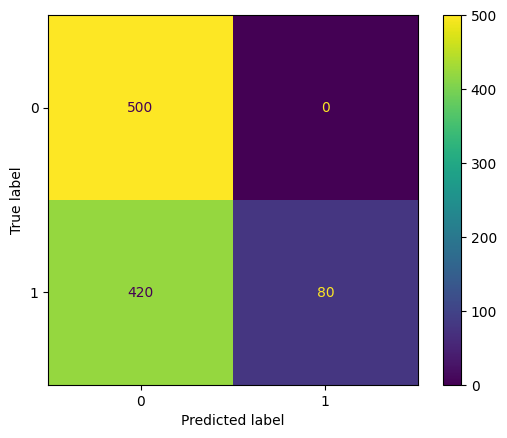

In [217]:
# Confusion Matrix - Still not good.  Mostly phishing
xgb_cm_test_1000 = confusion_matrix(y_test_1000, xgb_pred_test_1000)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm_test_1000)
disp.plot()

In [218]:
# Fitting new dataset to XGB pipeline to see performance
pipeline_xgb_all.fit(X_test_1000, y_test_1000)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [219]:
# Make predicitons on original split data from original dataset
pred_y = pipeline_xgb_all.predict(X_test)

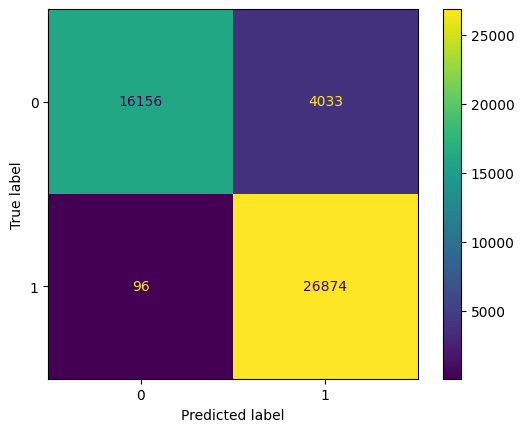

In [220]:
# Confusion matrix on dataset after modeling based on new dataset - much better performance
rev_xgb_cm_test_1000 = confusion_matrix(y_test, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=rev_xgb_cm_test_1000)
disp.plot()

## Creating New Dataset for Training after Testing Failed - Combo of 2 different datasets

In [221]:
# from url_dataset - get 2000 rows, 1000 legitimate, 1000 phishing
stratified_2000 = test_df.groupby('label', group_keys=False).sample(n=1000, random_state=42)

In [222]:
len(stratified_2000)

2000

## Do not run cell below - would take over an hour to run - 
## Data captured below is saved in 10k_URL_Training.csv

In [224]:
# Extract features by calling phishing features class

features_list_2000 = []

for _, row in tqdm(stratified_2000.iterrows(), desc="Getting Phishing Features"):
    extractor = PhishingFeatureExtractor(row['url'])
    features = extractor.to_dict()
    features['label'] = row['label']
    features['URL'] = row['url']
    features_list_2000.append(features)

features_df_2000 = pd.DataFrame(features_list_2000)

Getting Phishing Features: 4it [00:00,  8.81it/s]

Request failed: HTTPConnectionPool(host='cke8q1.lucirabydevpps.info', port=80): Max retries exceeded with url: /zla4u55jxc%5Cnwww.doblatuproductividad.com/000ded60ea040d013384ba6eac24fdf1.php?q=00d99394125a37085e8f4f81ddee3c18 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f31a090>: Failed to resolve 'cke8q1.lucirabydevpps.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cke8q1.lucirabydevpps.info', port=80): Max retries exceeded with url: /zla4u55jxc%5Cnwww.doblatuproductividad.com/000ded60ea040d013384ba6eac24fdf1.php?q=00d99394125a37085e8f4f81ddee3c18 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd27090>: Failed to resolve 'cke8q1.lucirabydevpps.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cke8q1.lucirabydevpps.info/zla4u55jxc\nwww.doblatuproductividad.com/000ded60ea040d013384ba6eac24fdf1.php?q=00d99394125a37085e8f4f81d

Getting Phishing Features: 8it [00:01,  5.84it/s]

Request failed: HTTPConnectionPool(host='nowversion.updatenewsoftanytimesafe.site', port=80): Max retries exceeded with url: /?pcl=57SbBq3knt9gzuSnvy8Yk2UdnNyQZ33Do08E8c_sKOs.&amp;cid=%5BCLICK_ID%5D&amp;sub=775532s1_718&amp;v_id=M5C9JwXgtRybrHPXxxU5XegoUkq-wmimeFiR8_RuYkc. (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d2c3150>: Failed to resolve 'nowversion.updatenewsoftanytimesafe.site' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nowversion.updatenewsoftanytimesafe.site', port=80): Max retries exceeded with url: /?pcl=57SbBq3knt9gzuSnvy8Yk2UdnNyQZ33Do08E8c_sKOs.&amp;cid=%5BCLICK_ID%5D&amp;sub=775532s1_718&amp;v_id=M5C9JwXgtRybrHPXxxU5XegoUkq-wmimeFiR8_RuYkc. (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d2c0c10>: Failed to resolve 'nowversion.updatenewsoftanytimesafe.site' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nowversion

Getting Phishing Features: 12it [00:01,  9.12it/s]

Request failed: HTTPConnectionPool(host='nannaco.com.br', port=80): Max retries exceeded with url: /wp-admin/images/d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d2c1910>: Failed to resolve 'nannaco.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nannaco.com.br', port=80): Max retries exceeded with url: /wp-admin/images/d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c0e10>: Failed to resolve 'nannaco.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nannaco.com.br/wp-admin/images/d/: HTTPConnectionPool(host='nannaco.com.br', port=80): Max retries exceeded with url: /wp-admin/images/d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c2390>: Failed to resolve 'nannaco.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='surubiproducciones.com

Getting Phishing Features: 14it [00:02,  8.22it/s]

Request failed: HTTPConnectionPool(host='ebachqliaopdinnfdi.adclap.info', port=80): Max retries exceeded with url: /ZNXOjVSXAA4O26fLfAW1hnKRD41CRsfQR7SPBxJQgFmPMlSOSNP2ALoHMdMQC7JznHR07iEVaAU=%5Cnebachqliaopdinnfdi.adclap.info/ew1ehkej80.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d2c2e50>: Failed to resolve 'ebachqliaopdinnfdi.adclap.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ebachqliaopdinnfdi.adclap.info', port=80): Max retries exceeded with url: /ZNXOjVSXAA4O26fLfAW1hnKRD41CRsfQR7SPBxJQgFmPMlSOSNP2ALoHMdMQC7JznHR07iEVaAU=%5Cnebachqliaopdinnfdi.adclap.info/ew1ehkej80.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d2c0450>: Failed to resolve 'ebachqliaopdinnfdi.adclap.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ebachqliaopdinnfdi.adclap.info/ZNXOjVSXAA4O26fLfAW1hnKRD41CRsfQR7SPBxJQgFmPMlSOSNP2ALoHMdMQC7J

Getting Phishing Features: 16it [00:04,  2.37it/s]

Request failed: HTTPSConnectionPool(host='zonedeconomies.com', port=443): Max retries exceeded with url: /?35478d364dda6b0d847efc6b57165717 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b43290>: Failed to resolve 'zonedeconomies.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='zonedeconomies.com', port=443): Max retries exceeded with url: /?35478d364dda6b0d847efc6b57165717 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e9bc750>: Failed to resolve 'zonedeconomies.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://zonedeconomies.com/?35478d364dda6b0d847efc6b57165717: HTTPSConnectionPool(host='zonedeconomies.com', port=443): Max retries exceeded with url: /?35478d364dda6b0d847efc6b57165717 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85f4fd0>: Failed to resolve 'zonedeconomies.com' ([Errno

Getting Phishing Features: 20it [00:09,  1.15it/s]

Request failed: HTTPConnectionPool(host='aningmasule.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9bff10>: Failed to resolve 'aningmasule.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aningmasule.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9bf790>: Failed to resolve 'aningmasule.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aningmasule.ru/sliva/gate.php: HTTPConnectionPool(host='aningmasule.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c3690>: Failed to resolve 'aningmasule.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 21it [00:11,  1.08s/it]

Request failed: HTTPConnectionPool(host='brown-paper-packages-sa.com', port=80): Max retries exceeded with url: /invoice/invoice/4d79dcadcdf578dd55b5358136707645/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd25190>: Failed to resolve 'brown-paper-packages-sa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='brown-paper-packages-sa.com', port=80): Max retries exceeded with url: /invoice/invoice/4d79dcadcdf578dd55b5358136707645/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f31a2d0>: Failed to resolve 'brown-paper-packages-sa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://brown-paper-packages-sa.com/invoice/invoice/4d79dcadcdf578dd55b5358136707645/: HTTPConnectionPool(host='brown-paper-packages-sa.com', port=80): Max retries exceeded with url: /invoice/invoice/4d79dcadcdf578dd55b5358136707645/ (Caused by NameResolutionError("

Getting Phishing Features: 24it [00:16,  1.58s/it]

Request failed: HTTPConnectionPool(host='daedalus.dommel.be', port=80): Max retries exceeded with url: /78yhuinFYs (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd26510>: Failed to resolve 'daedalus.dommel.be' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='daedalus.dommel.be', port=80): Max retries exceeded with url: /78yhuinFYs (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c3e90>: Failed to resolve 'daedalus.dommel.be' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://daedalus.dommel.be/78yhuinFYs: HTTPConnectionPool(host='daedalus.dommel.be', port=80): Max retries exceeded with url: /78yhuinFYs (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c1850>: Failed to resolve 'daedalus.dommel.be' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='hf0.hikonefabebppw.info', 

Getting Phishing Features: 25it [00:16,  1.25s/it]

Error checking self redirects for http://hf0.hikonefabebppw.info/ejqme5vcuo\nwww.lavoro24.it/offerte_lavoro.php?cosa=&regione=&provincia=97&categoria=&azienda=&page=3: HTTPConnectionPool(host='hf0.hikonefabebppw.info', port=80): Max retries exceeded with url: /ejqme5vcuo%5Cnwww.lavoro24.it/offerte_lavoro.php?cosa=&regione=&provincia=97&categoria=&azienda=&page=3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a87100d0>: Failed to resolve 'hf0.hikonefabebppw.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 29it [00:24,  1.81s/it]

Request failed: HTTPConnectionPool(host='leftofttarigh.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f318650>: Failed to resolve 'leftofttarigh.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='leftofttarigh.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8712f90>: Failed to resolve 'leftofttarigh.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://leftofttarigh.ru/gate.php: HTTPConnectionPool(host='leftofttarigh.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd25b50>: Failed to resolve 'leftofttarigh.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 32it [00:24,  1.29it/s]

Request failed: HTTPConnectionPool(host='classicrunners.co.tz', port=80): Max retries exceeded with url: /themes/doc/index.php?Email=abuse@pattonair.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9bc750>: Failed to resolve 'classicrunners.co.tz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='classicrunners.co.tz', port=80): Max retries exceeded with url: /themes/doc/index.php?Email=abuse@pattonair.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c0bd0>: Failed to resolve 'classicrunners.co.tz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://classicrunners.co.tz/themes/doc/index.php?Email=abuse@pattonair.com: HTTPConnectionPool(host='classicrunners.co.tz', port=80): Max retries exceeded with url: /themes/doc/index.php?Email=abuse@pattonair.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9

Getting Phishing Features: 33it [00:41,  4.76s/it]

Error checking self redirects for http://kf25zx.com/images/: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a8711010>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='kohlesekdamodar.trucksbyswat.com', port=80): Max retries exceeded with url: /hmz7v51txn.php%5Cnwww.marinawassersport.de/index.php?option=com_content&view=article&id=118&Itemid=282 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd27bd0>: Failed to resolve 'kohlesekdamodar.trucksbyswat.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kohlesekdamodar.trucksbyswat.com', port=80): Max retries exceeded with url: /hmz7v51txn.php%5Cnwww.marinawassersport.de/index.php?option=com_content&view=article&id=118&Itemid=282 (Caused by NameResolutionError("<urllib3.connection.HTTPConn

Getting Phishing Features: 35it [00:43,  3.16s/it]

Request failed: HTTPConnectionPool(host='two.vdgbfslgdfs.biz', port=80): Max retries exceeded with url: /jekgpiqa7c%5Cnholotilicga.medproshealthcare.com/bannerbox/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd26910>: Failed to resolve 'two.vdgbfslgdfs.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='two.vdgbfslgdfs.biz', port=80): Max retries exceeded with url: /jekgpiqa7c%5Cnholotilicga.medproshealthcare.com/bannerbox/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8712110>: Failed to resolve 'two.vdgbfslgdfs.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://two.vdgbfslgdfs.biz/jekgpiqa7c\nholotilicga.medproshealthcare.com/bannerbox/frame.html: HTTPConnectionPool(host='two.vdgbfslgdfs.biz', port=80): Max retries exceeded with url: /jekgpiqa7c%5Cnholotilicga.medproshealthcare.com/bannerbox/frame.html (Cause

Getting Phishing Features: 37it [00:44,  2.17s/it]

Request failed: HTTPConnectionPool(host='esquirevietnam.com.vn', port=80): Max retries exceeded with url: /wp-content/uploads/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9be310>: Failed to resolve 'esquirevietnam.com.vn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='esquirevietnam.com.vn', port=80): Max retries exceeded with url: /wp-content/uploads/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f319990>: Failed to resolve 'esquirevietnam.com.vn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://esquirevietnam.com.vn/wp-content/uploads/: HTTPConnectionPool(host='esquirevietnam.com.vn', port=80): Max retries exceeded with url: /wp-content/uploads/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eea8190>: Failed to resolve 'esquirevietnam.com.vn' ([Errno -2] Name or service not known)"))
Request fa

Getting Phishing Features: 40it [00:46,  1.44s/it]

Request failed: HTTPSConnectionPool(host='copper.furstlook.com', port=443): Max retries exceeded with url: /~play2earn/Hotmail/live.com/... (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd26d10>: Failed to resolve 'copper.furstlook.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='copper.furstlook.com', port=443): Max retries exceeded with url: /~play2earn/Hotmail/live.com/... (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebca150>: Failed to resolve 'copper.furstlook.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://copper.furstlook.com/%7Eplay2earn/Hotmail/live.com/...: HTTPSConnectionPool(host='copper.furstlook.com', port=443): Max retries exceeded with url: /~play2earn/Hotmail/live.com/... (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2b6a90>: Failed to resolve 'copper.furstlook.com'

Getting Phishing Features: 41it [01:02,  4.59s/it]

Error checking self redirects for http://globalremoteservices.com/cgi-sys/suspendedpage.cgi: HTTPConnectionPool(host='globalremoteservices.com', port=80): Max retries exceeded with url: /cgi-sys/suspendedpage.cgi (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e9c3010>, 'Connection to globalremoteservices.com timed out. (connect timeout=5)'))


Getting Phishing Features: 43it [01:03,  2.74s/it]

Request failed: HTTPConnectionPool(host='socialmediahelpforbusinesses.com', port=80): Max retries exceeded with url: /yye410ew3z%5Cnwww.cordjiacapitalprojects.com/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9be590>: Failed to resolve 'socialmediahelpforbusinesses.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='socialmediahelpforbusinesses.com', port=80): Max retries exceeded with url: /yye410ew3z%5Cnwww.cordjiacapitalprojects.com/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d2c2b10>: Failed to resolve 'socialmediahelpforbusinesses.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://socialmediahelpforbusinesses.com/yye410ew3z\nwww.cordjiacapitalprojects.com/index.html: HTTPConnectionPool(host='socialmediahelpforbusinesses.com', port=80): Max retries exceeded with url: /yye410ew3z%5Cnwww.cordjiacapitalproj

Getting Phishing Features: 46it [01:18,  3.45s/it]

Error checking self redirects for http://185.106.122.38/upload/_dispatch.php: HTTPConnectionPool(host='185.106.122.38', port=80): Max retries exceeded with url: /upload/_dispatch.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a8712110>, 'Connection to 185.106.122.38 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='lamaquinaempire.com', port=80): Max retries exceeded with url: /libraries/simplepie/idn/?https://www.secure.paypal.co.uk/cgi-bin/webscr-cmd=_view-a-trans (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfc5b50>: Failed to resolve 'lamaquinaempire.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lamaquinaempire.com', port=80): Max retries exceeded with url: /libraries/simplepie/idn/?https://www.secure.paypal.co.uk/cgi-bin/webscr-cmd=_view-a-trans (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b4

Getting Phishing Features: 48it [01:18,  2.19s/it]

Request failed: HTTPConnectionPool(host='specstarsltd.com', port=80): Max retries exceeded with url: /wp-content/upgrade/chase/cd7fd6451a96b4d8e41d0cea58c89532/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f31b690>: Failed to resolve 'specstarsltd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='specstarsltd.com', port=80): Max retries exceeded with url: /wp-content/upgrade/chase/cd7fd6451a96b4d8e41d0cea58c89532/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9bfa10>: Failed to resolve 'specstarsltd.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://specstarsltd.com/wp-content/upgrade/chase/cd7fd6451a96b4d8e41d0cea58c89532/: HTTPConnectionPool(host='specstarsltd.com', port=80): Max retries exceeded with url: /wp-content/upgrade/chase/cd7fd6451a96b4d8e41d0cea58c89532/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnec

Getting Phishing Features: 51it [01:19,  1.35s/it]

Request failed: HTTPConnectionPool(host='godnet.tv', port=80): Max retries exceeded with url: /libertycenter/wp-includes/js/swfupload/SWF/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f6c3a90>: Failed to resolve 'godnet.tv' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='godnet.tv', port=80): Max retries exceeded with url: /libertycenter/wp-includes/js/swfupload/SWF/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b41410>: Failed to resolve 'godnet.tv' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://godnet.tv/libertycenter/wp-includes/js/swfupload/SWF/: HTTPConnectionPool(host='godnet.tv', port=80): Max retries exceeded with url: /libertycenter/wp-includes/js/swfupload/SWF/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d2c0450>: Failed to resolve 'godnet.tv' ([Errno -2] Name or service not known)")

Getting Phishing Features: 54it [01:22,  1.12s/it]

Request failed: HTTPConnectionPool(host='zippedonlinedoc.com', port=80): Max retries exceeded with url: /edit/docs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27683595d0>: Failed to resolve 'zippedonlinedoc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zippedonlinedoc.com', port=80): Max retries exceeded with url: /edit/docs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eeaac50>: Failed to resolve 'zippedonlinedoc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://zippedonlinedoc.com/edit/docs/: HTTPConnectionPool(host='zippedonlinedoc.com', port=80): Max retries exceeded with url: /edit/docs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3e8bd0>: Failed to resolve 'zippedonlinedoc.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='skaiyacouture.com',

Getting Phishing Features: 59it [01:24,  1.43it/s]

Request failed: HTTPConnectionPool(host='thptlanggiang3.edu.vn', port=80): Max retries exceeded with url: /language/Visa.dk/brugpaanettet.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8698c50>: Failed to resolve 'thptlanggiang3.edu.vn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='thptlanggiang3.edu.vn', port=80): Max retries exceeded with url: /language/Visa.dk/brugpaanettet.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8359d10>: Failed to resolve 'thptlanggiang3.edu.vn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://thptlanggiang3.edu.vn/language/Visa.dk/brugpaanettet.html: HTTPConnectionPool(host='thptlanggiang3.edu.vn', port=80): Max retries exceeded with url: /language/Visa.dk/brugpaanettet.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ed44310>: Failed to resolve 'thptlanggia

Getting Phishing Features: 60it [01:26,  1.03it/s]

Request failed: HTTPConnectionPool(host='www.nordthyskakklub.dk', port=80): Max retries exceeded with url: /public_html/dhlform.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ed473d0>: Failed to resolve 'www.nordthyskakklub.dk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.nordthyskakklub.dk', port=80): Max retries exceeded with url: /public_html/dhlform.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a83595d0>: Failed to resolve 'www.nordthyskakklub.dk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.nordthyskakklub.dk/public_html/dhlform.php: HTTPConnectionPool(host='www.nordthyskakklub.dk', port=80): Max retries exceeded with url: /public_html/dhlform.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8698490>: Failed to resolve 'www.nordthyskakklub.dk' ([Errno -2] Name or service n

Getting Phishing Features: 64it [01:28,  1.38it/s]

Request failed: HTTPConnectionPool(host='oblasti-rus.ru', port=80): Max retries exceeded with url: /logs/mail1134-1662-10787-0%20833-14345=349049881.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d6e90>: Failed to resolve 'oblasti-rus.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oblasti-rus.ru', port=80): Max retries exceeded with url: /logs/mail1134-1662-10787-0%20833-14345=349049881.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8358090>: Failed to resolve 'oblasti-rus.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bit.ly/1gtkEpc: HTTPConnectionPool(host='oblasti-rus.ru', port=80): Max retries exceeded with url: /logs/mail1134-1662-10787-0%20833-14345=349049881.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e515210>: Failed to resolve 'oblasti-rus.ru' ([Errno -2] Name or se

Getting Phishing Features: 65it [01:30,  1.06it/s]

Error checking self redirects for http://mail.aeonvape.com/sent/gd/: HTTPSConnectionPool(host='mail.aeonvape.com', port=443): Max retries exceeded with url: /sent/gd/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'mail.aeonvape.com'. (_ssl.c:1006)")))


Getting Phishing Features: 68it [01:31,  2.07it/s]

Request failed: HTTPConnectionPool(host='barmaleeey.xyz', port=80): Max retries exceeded with url: /data/feeder/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a835bf50>: Failed to resolve 'barmaleeey.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='barmaleeey.xyz', port=80): Max retries exceeded with url: /data/feeder/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d7c1e90>: Failed to resolve 'barmaleeey.xyz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://barmaleeey.xyz/data/feeder/: HTTPConnectionPool(host='barmaleeey.xyz', port=80): Max retries exceeded with url: /data/feeder/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d65d0>: Failed to resolve 'barmaleeey.xyz' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='jlhack.com', port=80): Max retries exceeded wi

Getting Phishing Features: 70it [01:31,  3.04it/s]

Request failed: HTTPConnectionPool(host='sewingmaker.com', port=80): Max retries exceeded with url: /webroot/DHL_courier_service/autofil/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d7c10>: Failed to resolve 'sewingmaker.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sewingmaker.com', port=80): Max retries exceeded with url: /webroot/DHL_courier_service/autofil/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d5b90>: Failed to resolve 'sewingmaker.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sewingmaker.com/webroot/DHL_courier_service/autofil/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID: HTTPConnectionPool(host='sewingmaker.com', port=80): Max retries exceeded with url: /webroot/DHL_courier_service/autofil/id.php?l=_JeHFUq

Getting Phishing Features: 71it [01:32,  2.09it/s]

Request failed: HTTPConnectionPool(host='eostechnologies.net', port=80): Max retries exceeded with url: /wp-admin/network/boxMrenewal.php?Email=abuse@hanwha-total.com&amp;.rand=13vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc=1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a835b850>: Failed to resolve 'eostechnologies.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eostechnologies.net', port=80): Max retries exceeded with url: /wp-admin/network/boxMrenewal.php?Email=abuse@hanwha-total.com&amp;.rand=13vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc=1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d5310>: Failed to resolve 'eostechnologies.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eostechnologies.net/wp-admin/network/boxMrenewal.php?Email=abuse@hanwha-total.com&amp;.ran

Getting Phishing Features: 73it [01:32,  2.89it/s]

Redirect check failed: HTTPConnectionPool(host='rankedcaut.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df02810>: Failed to resolve 'rankedcaut.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rankedcaut.ru/gate.php: HTTPConnectionPool(host='rankedcaut.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a849dfd0>: Failed to resolve 'rankedcaut.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 74it [01:32,  3.12it/s]

Request failed: HTTPConnectionPool(host='glasstecnologia.com.br', port=80): Max retries exceeded with url: /chase/home/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ed47d90>: Failed to resolve 'glasstecnologia.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='glasstecnologia.com.br', port=80): Max retries exceeded with url: /chase/home/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ed451d0>: Failed to resolve 'glasstecnologia.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://glasstecnologia.com.br/chase/home/index.php: HTTPConnectionPool(host='glasstecnologia.com.br', port=80): Max retries exceeded with url: /chase/home/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d2c2b90>: Failed to resolve 'glasstecnologia.com.br' ([Errno -2] Name or service not known)"))

Getting Phishing Features: 75it [01:34,  1.54it/s]

Request failed: HTTPConnectionPool(host='shingpohk.com', port=80): Max retries exceeded with url: /wc2mp0d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d59d0>: Failed to resolve 'shingpohk.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='shingpohk.com', port=80): Max retries exceeded with url: /wc2mp0d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d7bd0>: Failed to resolve 'shingpohk.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://shingpohk.com/wc2mp0d: HTTPConnectionPool(host='shingpohk.com', port=80): Max retries exceeded with url: /wc2mp0d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d7e50>: Failed to resolve 'shingpohk.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 78it [01:44,  1.87s/it]

Request failed: HTTPConnectionPool(host='customlogomatsng.com', port=80): Max retries exceeded with url: /admin/mani/b0028c287609714d60df89942ca88094/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2d58d0>: Failed to resolve 'customlogomatsng.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='customlogomatsng.com', port=80): Max retries exceeded with url: /admin/mani/b0028c287609714d60df89942ca88094/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a87120d0>: Failed to resolve 'customlogomatsng.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://customlogomatsng.com/admin/mani/b0028c287609714d60df89942ca88094/: HTTPConnectionPool(host='customlogomatsng.com', port=80): Max retries exceeded with url: /admin/mani/b0028c287609714d60df89942ca88094/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9bd5d0>: 

Getting Phishing Features: 82it [01:45,  1.03s/it]

Request failed: HTTPSConnectionPool(host='www.jamrad.pl', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e517150>: Failed to resolve 'www.jamrad.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.jamrad.pl', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e517e90>: Failed to resolve 'www.jamrad.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.jamrad.pl/: HTTPSConnectionPool(host='www.jamrad.pl', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e514d50>: Failed to resolve 'www.jamrad.pl' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='serviciomaff.com', port=80): Max retries exceeded with url: /template3/js/_notes/ (Caused b

Getting Phishing Features: 85it [01:47,  1.20it/s]

Request failed: HTTPConnectionPool(host='bilbaopisos.es', port=80): Max retries exceeded with url: /HSBC_BANK.STORAGE_DATA/secure.payment.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f6c29d0>: Failed to resolve 'bilbaopisos.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bilbaopisos.es', port=80): Max retries exceeded with url: /HSBC_BANK.STORAGE_DATA/secure.payment.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d75a010>: Failed to resolve 'bilbaopisos.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bilbaopisos.es/HSBC_BANK.STORAGE_DATA/secure.payment.html: HTTPConnectionPool(host='bilbaopisos.es', port=80): Max retries exceeded with url: /HSBC_BANK.STORAGE_DATA/secure.payment.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd27290>: Failed to resolve 'bilbaopisos.es' ([Errno -

Getting Phishing Features: 86it [01:55,  2.37s/it]

Error checking self redirects for http://193.124.183.170/Panel/: HTTPConnectionPool(host='193.124.183.170', port=80): Max retries exceeded with url: /Panel/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287e515a10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 87it [01:55,  1.88s/it]

Request failed: HTTPSConnectionPool(host='wtsbharat.org', port=443): Max retries exceeded with url: /bin/aro/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='wtsbharat.org', port=443): Max retries exceeded with url: /bin/aro/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://wtsbharat.org/bin/aro/: HTTPSConnectionPool(host='wtsbharat.org', port=443): Max retries exceeded with url: /bin/aro/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='cutsnakecatering.com', port=80): Max retries exceeded with url: /oh (Cause

Getting Phishing Features: 90it [01:56,  1.05it/s]

Request failed: HTTPConnectionPool(host='shankhay.caferostov.ru', port=80): Max retries exceeded with url: /images/articles/c/Adbe.pdf/Adobe.pdf.php?login= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f6c3450>: Failed to resolve 'shankhay.caferostov.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='shankhay.caferostov.ru', port=80): Max retries exceeded with url: /images/articles/c/Adbe.pdf/Adobe.pdf.php?login= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d5d7a90>: Failed to resolve 'shankhay.caferostov.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://shankhay.caferostov.ru/images/articles/c/Adbe.pdf/Adobe.pdf.php?login=: HTTPConnectionPool(host='shankhay.caferostov.ru', port=80): Max retries exceeded with url: /images/articles/c/Adbe.pdf/Adobe.pdf.php?login= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection obj

Getting Phishing Features: 91it [01:58,  1.19s/it]

Request failed: HTTPConnectionPool(host='americanadvancedtech.com', port=80): Max retries exceeded with url: /cgi/italian-side-orders (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747c95110>: Failed to resolve 'americanadvancedtech.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='americanadvancedtech.com', port=80): Max retries exceeded with url: /cgi/italian-side-orders (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8671fd0>: Failed to resolve 'americanadvancedtech.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://americanadvancedtech.com/cgi/italian-side-orders: HTTPConnectionPool(host='americanadvancedtech.com', port=80): Max retries exceeded with url: /cgi/italian-side-orders (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3644d0>: Failed to resolve 'americanadvancedtech.com' ([Errno -2] Nam

Getting Phishing Features: 93it [02:13,  3.81s/it]

Error checking self redirects for http://158.255.193.15:4331/0/1/2/: HTTPConnectionPool(host='158.255.193.15', port=4331): Max retries exceeded with url: /0/1/2/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2747c973d0>, 'Connection to 158.255.193.15 timed out. (connect timeout=5)'))


Getting Phishing Features: 94it [02:19,  4.22s/it]

Request failed: HTTPConnectionPool(host='64.184.235.251', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2747c96590>, 'Connection to 64.184.235.251 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='64.184.235.251', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f366210>, 'Connection to 64.184.235.251 timed out. (connect timeout=5)'))


Getting Phishing Features: 95it [02:34,  6.86s/it]

Error checking self redirects for http://64.184.235.251/: HTTPConnectionPool(host='64.184.235.251', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f047710>, 'Connection to 64.184.235.251 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='secure-redirect.de', port=80): Max retries exceeded with url: /294383 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f047610>, 'Connection to secure-redirect.de timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='secure-redirect.de', port=80): Max retries exceeded with url: /294383 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2747c94350>, 'Connection to secure-redirect.de timed out. (connect timeout=5)'))


Getting Phishing Features: 96it [02:49,  9.10s/it]

Error checking self redirects for http://secure-redirect.de/294383: HTTPConnectionPool(host='secure-redirect.de', port=80): Max retries exceeded with url: /294383 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2747c97c10>, 'Connection to secure-redirect.de timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='bobbysinghwpg.com', port=80): Max retries exceeded with url: /pdqcqlnr (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e515590>: Failed to resolve 'bobbysinghwpg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bobbysinghwpg.com', port=80): Max retries exceeded with url: /pdqcqlnr (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3666d0>: Failed to resolve 'bobbysinghwpg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bobbysinghwpg.com/pdqcqlnr: HTTPConnectionPool(host='bob

Getting Phishing Features: 98it [02:52,  5.92s/it]

Request failed: HTTPConnectionPool(host='administrator-customer3-service-call-1866-285-0655.info', port=80): Max retries exceeded with url: /?5531e301=FYToWou8dxP2NHVl%20sgL50plLaKq5WsrNN2bDGvJcpsTmRUePOszMfZ9ppkf/xlol4QeugBjv/krnZcLpL42Cg== (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8670bd0>: Failed to resolve 'administrator-customer3-service-call-1866-285-0655.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='administrator-customer3-service-call-1866-285-0655.info', port=80): Max retries exceeded with url: /?5531e301=FYToWou8dxP2NHVl%20sgL50plLaKq5WsrNN2bDGvJcpsTmRUePOszMfZ9ppkf/xlol4QeugBjv/krnZcLpL42Cg== (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747c95150>: Failed to resolve 'administrator-customer3-service-call-1866-285-0655.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://administrator-customer3-service-call-1866-28

Getting Phishing Features: 101it [02:54,  3.26s/it]

Request failed: HTTPConnectionPool(host='www.pisqr.net', port=80): Max retries exceeded with url: /medic/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f045a50>: Failed to resolve 'www.pisqr.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.pisqr.net', port=80): Max retries exceeded with url: /medic/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f045650>: Failed to resolve 'www.pisqr.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.pisqr.net/medic/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php: HTTPConnectionPool(host='www.pisqr.net', port=80): Max retries exceeded with url: /medic/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connection.HTTP

Getting Phishing Features: 104it [02:57,  1.99s/it]

Request failed: HTTPConnectionPool(host='www.camel-camicie.it', port=80): Max retries exceeded with url: /arcftp/meclasu/fotaisa/shmecjemipro/razonel/picisjyel/papake/ganga.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea54810>: Failed to resolve 'www.camel-camicie.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.camel-camicie.it', port=80): Max retries exceeded with url: /arcftp/meclasu/fotaisa/shmecjemipro/razonel/picisjyel/papake/ganga.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea56090>: Failed to resolve 'www.camel-camicie.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.camel-camicie.it/arcftp/meclasu/fotaisa/shmecjemipro/razonel/picisjyel/papake/ganga.html: HTTPConnectionPool(host='www.camel-camicie.it', port=80): Max retries exceeded with url: /arcftp/meclasu/fotaisa/shmecjemipro/razonel/picisjyel/papa

Getting Phishing Features: 109it [02:59,  1.04it/s]

Request failed: HTTPConnectionPool(host='xa.yimg.com', port=80): Max retries exceeded with url: /kq/groups/22858154/1701051781/name/Restore+Your+PayPal+Account.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747d57bd0>: Failed to resolve 'xa.yimg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='xa.yimg.com', port=80): Max retries exceeded with url: /kq/groups/22858154/1701051781/name/Restore+Your+PayPal+Account.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7dc350>: Failed to resolve 'xa.yimg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://xa.yimg.com/kq/groups/22858154/1701051781/name/Restore+Your+PayPal+Account.html: HTTPConnectionPool(host='xa.yimg.com', port=80): Max retries exceeded with url: /kq/groups/22858154/1701051781/name/Restore+Your+PayPal+Account.html (Caused by NameResolutionError("<urllib3.connection.HTTP

Getting Phishing Features: 111it [03:00,  1.37it/s]

Request failed: HTTPConnectionPool(host='spawash.gr', port=80): Max retries exceeded with url: /uban/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7dced0>: Failed to resolve 'spawash.gr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='spawash.gr', port=80): Max retries exceeded with url: /uban/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7de750>: Failed to resolve 'spawash.gr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://spawash.gr/uban/dropbox/proposal/: HTTPConnectionPool(host='spawash.gr', port=80): Max retries exceeded with url: /uban/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682cbbd0>: Failed to resolve 'spawash.gr' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 113it [03:00,  1.89it/s]

Request failed: HTTPConnectionPool(host='wowsale.net', port=80): Max retries exceeded with url: /wp-admin/file/8176d7ed19e95d8992c0173ad804afde/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682c9c90>: Failed to resolve 'wowsale.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wowsale.net', port=80): Max retries exceeded with url: /wp-admin/file/8176d7ed19e95d8992c0173ad804afde/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7dd810>: Failed to resolve 'wowsale.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wowsale.net/wp-admin/file/8176d7ed19e95d8992c0173ad804afde/: HTTPConnectionPool(host='wowsale.net', port=80): Max retries exceeded with url: /wp-admin/file/8176d7ed19e95d8992c0173ad804afde/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7de910>: Failed to resolve 'wowsale.net' ([Errno -2

Getting Phishing Features: 116it [03:15,  2.33s/it]

Error checking self redirects for http://91.239.25.56:6892: HTTPConnectionPool(host='91.239.25.56', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ea56c50>, 'Connection to 91.239.25.56 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='paypal.com.ramitabakery.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea57a90>: Failed to resolve 'paypal.com.ramitabakery.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paypal.com.ramitabakery.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682c88d0>: Failed to resolve 'paypal.com.ramitabakery.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paypal.com.ramitabakery.com/: HTTPConnectionPool(host='p

Getting Phishing Features: 117it [03:15,  1.86s/it]

Request failed: HTTPConnectionPool(host='yak.by', port=80): Max retries exceeded with url: /newp/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=abuse@trema.com&.rand=13InboxLight.aspx?n=1774256418&fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7df150>: Failed to resolve 'yak.by' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yak.by', port=80): Max retries exceeded with url: /newp/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=abuse@trema.com&.rand=13InboxLight.aspx?n=1774256418&fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7df010>: Failed to resolve 'yak.by' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yak.by/newp/ii.php?rand=13InboxLightas

Getting Phishing Features: 120it [03:16,  1.08it/s]

Request failed: HTTPConnectionPool(host='blackwoodatelier.com.au', port=80): Max retries exceeded with url: /shilancha/Hotmail-New/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f17c6d0>: Failed to resolve 'blackwoodatelier.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='blackwoodatelier.com.au', port=80): Max retries exceeded with url: /shilancha/Hotmail-New/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea559d0>: Failed to resolve 'blackwoodatelier.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://blackwoodatelier.com.au/shilancha/Hotmail-New/Hotmail-New/Verification%20Set-up.html: HTTPConnectionPool(host='blackwoodatelier.com.au', port=80): Max retries exceeded with url: /shilancha/Hotmail-New/Hotmail-New/Verification%20Set-up.html (Caused by N

Getting Phishing Features: 122it [03:16,  1.55it/s]

Request failed: HTTPConnectionPool(host='tatlowandrawlings.com', port=80): Max retries exceeded with url: /yahooservernew.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7dcad0>: Failed to resolve 'tatlowandrawlings.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tatlowandrawlings.com', port=80): Max retries exceeded with url: /yahooservernew.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7decd0>: Failed to resolve 'tatlowandrawlings.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tatlowandrawlings.com/yahooservernew.htm: HTTPConnectionPool(host='tatlowandrawlings.com', port=80): Max retries exceeded with url: /yahooservernew.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea55050>: Failed to resolve 'tatlowandrawlings.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 124it [03:17,  1.89it/s]

Request failed: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images?http://us.battle.net/login/en/http://www.toitoi.com.tw/wp-admin (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f17ccd0>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images?http://us.battle.net/login/en/http://www.toitoi.com.tw/wp-admin (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e7dc190>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 125it [03:32,  3.45s/it]

Error checking self redirects for http://kf25zx.com/images?http://us.battle.net/login/en/http://www.toitoi.com.tw/wp-admin: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images?http://us.battle.net/login/en/http://www.toitoi.com.tw/wp-admin (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e7dc910>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 127it [03:35,  2.49s/it]

Request failed: HTTPConnectionPool(host='pitradingcollc.com', port=80): Max retries exceeded with url: /ribey (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea556d0>: Failed to resolve 'pitradingcollc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pitradingcollc.com', port=80): Max retries exceeded with url: /ribey (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682ca810>: Failed to resolve 'pitradingcollc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pitradingcollc.com/ribey: HTTPConnectionPool(host='pitradingcollc.com', port=80): Max retries exceeded with url: /ribey (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682c93d0>: Failed to resolve 'pitradingcollc.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 131it [03:44,  2.18s/it]

Request failed: HTTPConnectionPool(host='goldlash.md', port=80): Max retries exceeded with url: /images/gallery/gd/GD/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682c9c10>: Failed to resolve 'goldlash.md' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='goldlash.md', port=80): Max retries exceeded with url: /images/gallery/gd/GD/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea54190>: Failed to resolve 'goldlash.md' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://goldlash.md/images/gallery/gd/GD/: HTTPConnectionPool(host='goldlash.md', port=80): Max retries exceeded with url: /images/gallery/gd/GD/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f17df50>: Failed to resolve 'goldlash.md' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 133it [03:46,  1.68s/it]

Request failed: HTTPConnectionPool(host='netherlands-icscards2016.it', port=80): Max retries exceeded with url: /ics/login/ecaf62637c81a7be34fd99582120f85b/ayoub.php?free=_login-run (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682c8e90>: Failed to resolve 'netherlands-icscards2016.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='netherlands-icscards2016.it', port=80): Max retries exceeded with url: /ics/login/ecaf62637c81a7be34fd99582120f85b/ayoub.php?free=_login-run (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7dfd10>: Failed to resolve 'netherlands-icscards2016.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://netherlands-icscards2016.it/ics/login/ecaf62637c81a7be34fd99582120f85b/ayoub.php?free=_login-run: HTTPConnectionPool(host='netherlands-icscards2016.it', port=80): Max retries exceeded with url: /ics/login/ecaf62637c81a7b

Getting Phishing Features: 136it [03:49,  1.12s/it]

Request failed: HTTPConnectionPool(host='www.ehsasfoundationinternational.org', port=80): Max retries exceeded with url: /bobb/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682cb610>: Failed to resolve 'www.ehsasfoundationinternational.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ehsasfoundationinternational.org', port=80): Max retries exceeded with url: /bobb/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9ddb50>: Failed to resolve 'www.ehsasfoundationinternational.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ehsasfoundationinternational.org/bobb/...: HTTPConnectionPool(host='www.ehsasfoundationinternational.org', port=80): Max retries exceeded with url: /bobb/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f798810>: Failed to resolve 'www.ehsasfoundationinternatio

Getting Phishing Features: 138it [03:52,  1.37s/it]

Error checking self redirects for http://www.absoluteerp.in/fatura/conta/Inovar/: HTTPSConnectionPool(host='www.absoluteerp.in', port=443): Max retries exceeded with url: /fatura/conta/Inovar/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 139it [03:52,  1.11s/it]

Request failed: HTTPConnectionPool(host='kisar.co.in', port=80): Max retries exceeded with url: /wp-admin/images/30/cp.php?letter=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d528410>: Failed to resolve 'kisar.co.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kisar.co.in', port=80): Max retries exceeded with url: /wp-admin/images/30/cp.php?letter=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ee913d0>: Failed to resolve 'kisar.co.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kisar.co.in/wp-admin/images/30/cp.php?letter=login: HTTPConnectionPool(host='kisar.co.in', port=80): Max retries exceeded with url: /wp-admin/images/30/cp.php?letter=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ff4bf90>: Failed to resolve 'kisar.co.in' ([Errno -2] Name or service not known)"))
Requ

Getting Phishing Features: 144it [03:58,  1.28s/it]

Request failed: HTTPConnectionPool(host='knoxtyres.com.au', port=80): Max retries exceeded with url: /wp-content/themes/enfold/css/dropbox/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f044650>: Failed to resolve 'knoxtyres.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='knoxtyres.com.au', port=80): Max retries exceeded with url: /wp-content/themes/enfold/css/dropbox/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f044490>: Failed to resolve 'knoxtyres.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://knoxtyres.com.au/wp-content/themes/enfold/css/dropbox/dropbox/: HTTPConnectionPool(host='knoxtyres.com.au', port=80): Max retries exceeded with url: /wp-content/themes/enfold/css/dropbox/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747c95350>: Failed to resolve 'k

Getting Phishing Features: 146it [03:59,  1.16it/s]

Request failed: HTTPConnectionPool(host='panliang.net', port=80): Max retries exceeded with url: /wp-admin/data/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3a6290>: Failed to resolve 'panliang.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='panliang.net', port=80): Max retries exceeded with url: /wp-admin/data/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f7549d0>: Failed to resolve 'panliang.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://panliang.net/wp-admin/data/index.htm: HTTPConnectionPool(host='panliang.net', port=80): Max retries exceeded with url: /wp-admin/data/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747c97010>: Failed to resolve 'panliang.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 150it [04:00,  2.06it/s]

Request failed: HTTPConnectionPool(host='afterwords.com.au', port=80): Max retries exceeded with url: /2dragon/products/adobe.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747c96d10>: Failed to resolve 'afterwords.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='afterwords.com.au', port=80): Max retries exceeded with url: /2dragon/products/adobe.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287df1da10>: Failed to resolve 'afterwords.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://afterwords.com.au/2dragon/products/adobe.php: HTTPConnectionPool(host='afterwords.com.au', port=80): Max retries exceeded with url: /2dragon/products/adobe.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f0450d0>: Failed to resolve 'afterwords.com.au' ([Errno -2] Name or service not known)"))
Request fa

Getting Phishing Features: 153it [04:03,  1.17it/s]

Request failed: HTTPSConnectionPool(host='accounts.zeropaper.com.br', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747c957d0>: Failed to resolve 'accounts.zeropaper.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='accounts.zeropaper.com.br', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682c9e50>: Failed to resolve 'accounts.zeropaper.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://accounts.zeropaper.com.br/index.html: HTTPSConnectionPool(host='accounts.zeropaper.com.br', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747c95610>: Failed to resolve 'accounts.zeropaper.com.br' ([Errno -2] Name or service not known)"))
Request 

Getting Phishing Features: 156it [04:04,  1.68it/s]

Request failed: HTTPConnectionPool(host='vivetusaludideal.com', port=80): Max retries exceeded with url: /wp-includes/js/imgareaselect/qyMUVG.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f044710>: Failed to resolve 'vivetusaludideal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vivetusaludideal.com', port=80): Max retries exceeded with url: /wp-includes/js/imgareaselect/qyMUVG.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682cb190>: Failed to resolve 'vivetusaludideal.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://vivetusaludideal.com/wp-includes/js/imgareaselect/qyMUVG.php: HTTPConnectionPool(host='vivetusaludideal.com', port=80): Max retries exceeded with url: /wp-includes/js/imgareaselect/qyMUVG.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d52b510>: Failed to resolve 'v

Getting Phishing Features: 158it [04:05,  1.67it/s]

Request failed: Exceeded 30 redirects.
Redirect check failed: Exceeded 30 redirects.


Getting Phishing Features: 159it [04:26,  4.39s/it]

Error checking self redirects for http://living4u.80port.net/zb/doc/file.index.htm/remax-securelogin_files/remax-secure_login_files/remax0-0secure0login_files/remax-securelogin_files/remax-securelogin_files/remax-securelogin_files/remax-securelogin_files/remax-securelogin_files/y: Exceeded 30 redirects.


Getting Phishing Features: 162it [04:28,  2.25s/it]

Request failed: HTTPConnectionPool(host='dirowranhe.ru', port=80): Max retries exceeded with url: /h/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fb994d0>: Failed to resolve 'dirowranhe.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dirowranhe.ru', port=80): Max retries exceeded with url: /h/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dadc210>: Failed to resolve 'dirowranhe.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dirowranhe.ru/h/gate.php: HTTPConnectionPool(host='dirowranhe.ru', port=80): Max retries exceeded with url: /h/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dae49d0>: Failed to resolve 'dirowranhe.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='takeaphoto.loan', port=80): Max retries exceeded with url: /r

Getting Phishing Features: 164it [04:29,  1.58s/it]

Request failed: HTTPConnectionPool(host='captaterminart.com', port=80): Max retries exceeded with url: /dm/well/verify.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eced650>: Failed to resolve 'captaterminart.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='captaterminart.com', port=80): Max retries exceeded with url: /dm/well/verify.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eced150>: Failed to resolve 'captaterminart.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://captaterminart.com/dm/well/verify.php: HTTPConnectionPool(host='captaterminart.com', port=80): Max retries exceeded with url: /dm/well/verify.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dadc290>: Failed to resolve 'captaterminart.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 167it [04:30,  1.02s/it]

Request failed: HTTPConnectionPool(host='dateaqui.com', port=80): Max retries exceeded with url: /system/fFF2VVV/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dadfb50>: Failed to resolve 'dateaqui.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dateaqui.com', port=80): Max retries exceeded with url: /system/fFF2VVV/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dadf650>: Failed to resolve 'dateaqui.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dateaqui.com/system/fFF2VVV/index.html: HTTPConnectionPool(host='dateaqui.com', port=80): Max retries exceeded with url: /system/fFF2VVV/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ecefb10>: Failed to resolve 'dateaqui.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='am-ambit

Getting Phishing Features: 169it [04:32,  1.15it/s]

Request failed: HTTPConnectionPool(host='basia-collection.com', port=80): Max retries exceeded with url: /viewpdf/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eceea90>: Failed to resolve 'basia-collection.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='basia-collection.com', port=80): Max retries exceeded with url: /viewpdf/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eceded0>: Failed to resolve 'basia-collection.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://basia-collection.com/viewpdf/index.html: HTTPConnectionPool(host='basia-collection.com', port=80): Max retries exceeded with url: /viewpdf/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dae7fd0>: Failed to resolve 'basia-collection.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 172it [04:36,  1.24s/it]

Request failed: HTTPConnectionPool(host='hrenner.gmxhome.de', port=80): Max retries exceeded with url: /09u9jn87 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e526950>, 'Connection to hrenner.gmxhome.de timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='hrenner.gmxhome.de', port=80): Max retries exceeded with url: /09u9jn87 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287dadefd0>, 'Connection to hrenner.gmxhome.de timed out. (connect timeout=5)'))


Getting Phishing Features: 173it [04:52,  4.37s/it]

Error checking self redirects for http://hrenner.gmxhome.de/09u9jn87: HTTPConnectionPool(host='hrenner.gmxhome.de', port=80): Max retries exceeded with url: /09u9jn87 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f3add10>, 'Connection to hrenner.gmxhome.de timed out. (connect timeout=5)'))


Getting Phishing Features: 174it [04:54,  3.79s/it]

Request failed: HTTPConnectionPool(host='lipstickcatwalk.com', port=80): Max retries exceeded with url: /chinese/wp-admin/css/colors/coffee/Document_Approval/89bbd8c8c715a159ff09c07b56f974b8/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3ad550>: Failed to resolve 'lipstickcatwalk.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lipstickcatwalk.com', port=80): Max retries exceeded with url: /chinese/wp-admin/css/colors/coffee/Document_Approval/89bbd8c8c715a159ff09c07b56f974b8/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe97450>: Failed to resolve 'lipstickcatwalk.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lipstickcatwalk.com/chinese/wp-admin/css/colors/coffee/Document_Approval/89bbd8c8c715a159ff09c07b56f974b8/: HTTPConnectionPool(host='lipstickcatwalk.com', port=80): Max retries exceeded with url: /chinese/wp-admin/cs

Getting Phishing Features: 176it [05:00,  3.59s/it]

Error checking self redirects for http://174.34.164.106:11443/2/bospers_62y7rKX8yF819Lg3/: HTTPConnectionPool(host='174.34.164.106', port=11443): Max retries exceeded with url: /2/bospers_62y7rKX8yF819Lg3/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287fe97290>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='snaak-opvangdam.havanapreview.com', port=80): Max retries exceeded with url: /gas.zvz?problem=&amp;from=lKOO&amp;state=&amp;family=eC1ehPI&amp;there=s5KJp&amp;what=&amp;trial=BHTM9Ae&amp;larger=um-ivNutM&amp;send=66fvhJ&amp;section=hnopg&amp;less=JlT77 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe94890>: Failed to resolve 'snaak-opvangdam.havanapreview.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='snaak-opvangdam.havanapreview.com', port=80): Max retries exceeded with url: /gas.zvz?problem=&am

Getting Phishing Features: 178it [05:01,  2.41s/it]

Request failed: HTTPConnectionPool(host='praxisww.com', port=80): Max retries exceeded with url: /wp-stc.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f650710>: Failed to resolve 'praxisww.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='praxisww.com', port=80): Max retries exceeded with url: /wp-stc.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f652f10>: Failed to resolve 'praxisww.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://praxisww.com/wp-stc.php: HTTPConnectionPool(host='praxisww.com', port=80): Max retries exceeded with url: /wp-stc.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfbf010>: Failed to resolve 'praxisww.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 181it [05:03,  1.56s/it]

Request failed: HTTPConnectionPool(host='unlaccothe.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f35dad0>: Failed to resolve 'unlaccothe.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='unlaccothe.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c85e24d0>: Failed to resolve 'unlaccothe.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://unlaccothe.ru/sliva/gate.php: HTTPConnectionPool(host='unlaccothe.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a83e3a90>: Failed to resolve 'unlaccothe.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='detectinfologs080.000webhostapp.com', port=4

Getting Phishing Features: 182it [05:28,  6.72s/it]

Error checking self redirects for https://detectinfologs080.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='detectinfologs080.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a83e2bd0>: Failed to resolve 'detectinfologs080.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 186it [05:41,  3.79s/it]

Request failed: HTTPConnectionPool(host='facebook.com.smartclick.top', port=80): Max retries exceeded with url: /tech/fb/?bid=0.001&amp;browse=Firefox%20/%2049&amp;browser=Firefox&amp;campid=3781104&amp;cateid=253&amp;cntryx=US&amp;f=104&amp;formfa=Desktop/Notebook&amp;keywrd=&amp;qualty=2&amp;resolu=1280x960&amp;siteid=1149969&amp;sxid=d85641b0c5uu&amp;type=pop (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e527b10>: Failed to resolve 'facebook.com.smartclick.top' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='facebook.com.smartclick.top', port=80): Max retries exceeded with url: /tech/fb/?bid=0.001&amp;browse=Firefox%20/%2049&amp;browser=Firefox&amp;campid=3781104&amp;cateid=253&amp;cntryx=US&amp;f=104&amp;formfa=Desktop/Notebook&amp;keywrd=&amp;qualty=2&amp;resolu=1280x960&amp;siteid=1149969&amp;sxid=d85641b0c5uu&amp;type=pop (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x

Getting Phishing Features: 187it [05:41,  2.79s/it]

Request failed: HTTPConnectionPool(host='openmadera.com.uy', port=80): Max retries exceeded with url: /googledoc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f6dbd50>: Failed to resolve 'openmadera.com.uy' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='openmadera.com.uy', port=80): Max retries exceeded with url: /googledoc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f6dbad0>: Failed to resolve 'openmadera.com.uy' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://openmadera.com.uy/googledoc: HTTPConnectionPool(host='openmadera.com.uy', port=80): Max retries exceeded with url: /googledoc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3fb4d0>: Failed to resolve 'openmadera.com.uy' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 189it [05:45,  2.31s/it]

Request failed: HTTPConnectionPool(host='docments.nstrefa.pl', port=80): Max retries exceeded with url: /Upload/pagedoc/e3f2413a47c0636a7701aa36a3977cf8/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f651310>: Failed to resolve 'docments.nstrefa.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='docments.nstrefa.pl', port=80): Max retries exceeded with url: /Upload/pagedoc/e3f2413a47c0636a7701aa36a3977cf8/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3f9350>: Failed to resolve 'docments.nstrefa.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://docments.nstrefa.pl/Upload/pagedoc/e3f2413a47c0636a7701aa36a3977cf8/: HTTPConnectionPool(host='docments.nstrefa.pl', port=80): Max retries exceeded with url: /Upload/pagedoc/e3f2413a47c0636a7701aa36a3977cf8/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff276

Getting Phishing Features: 192it [05:53,  2.47s/it]

Request failed: HTTPConnectionPool(host='myfreerecipebox.com', port=80): Max retries exceeded with url: /demo/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5272d0>: Failed to resolve 'myfreerecipebox.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='myfreerecipebox.com', port=80): Max retries exceeded with url: /demo/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3fb9d0>: Failed to resolve 'myfreerecipebox.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://myfreerecipebox.com/demo/: HTTPConnectionPool(host='myfreerecipebox.com', port=80): Max retries exceeded with url: /demo/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe95850>: Failed to resolve 'myfreerecipebox.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 195it [06:00,  2.64s/it]

Request failed: HTTPConnectionPool(host='yt97ythu5ndhgd.tk', port=80): Max retries exceeded with url: /lan/0xx/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f6d9e90>: Failed to resolve 'yt97ythu5ndhgd.tk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yt97ythu5ndhgd.tk', port=80): Max retries exceeded with url: /lan/0xx/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f35f650>: Failed to resolve 'yt97ythu5ndhgd.tk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yt97ythu5ndhgd.tk/lan/0xx/: HTTPConnectionPool(host='yt97ythu5ndhgd.tk', port=80): Max retries exceeded with url: /lan/0xx/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682af1d0>: Failed to resolve 'yt97ythu5ndhgd.tk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 199it [06:02,  1.39s/it]

Request failed: HTTPConnectionPool(host='www.ankarasoveyapi.com', port=80): Max retries exceeded with url: /Cesc/bookmark/ii.php?n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3f9090>: Failed to resolve 'www.ankarasoveyapi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ankarasoveyapi.com', port=80): Max retries exceeded with url: /Cesc/bookmark/ii.php?n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3f9f10>: Failed to resolve 'www.ankarasoveyapi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ankarasoveyapi.com/Cesc/bookmark/ii.php?n=1774256418: HTTPConnectionPool(host='www.ankarasoveyapi.com', port=80): Max retries exceeded with url: /Cesc/bookmark/ii.php?n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b3aa50>: Failed to resolve 'www.ankarasov

Getting Phishing Features: 204it [06:05,  1.31it/s]

Request failed: HTTPConnectionPool(host='satyrwelf.net', port=80): Max retries exceeded with url: /igle880a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f58f4d0>: Failed to resolve 'satyrwelf.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='satyrwelf.net', port=80): Max retries exceeded with url: /igle880a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d7fd0>: Failed to resolve 'satyrwelf.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://satyrwelf.net/igle880a: HTTPConnectionPool(host='satyrwelf.net', port=80): Max retries exceeded with url: /igle880a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfbf290>: Failed to resolve 'satyrwelf.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='phamkimhue.com', port=80): Max retries exceeded with url: /di0lI3Ga9r

Getting Phishing Features: 206it [06:07,  1.19it/s]

Request failed: HTTPConnectionPool(host='mg-sh.cn', port=80): Max retries exceeded with url: /js/index.htm?app=com-d3&amp;us.battle.net/login/en/?ref=us.battle.net/d3/en/index (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfb7ad0>: Failed to resolve 'mg-sh.cn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mg-sh.cn', port=80): Max retries exceeded with url: /js/index.htm?app=com-d3&amp;us.battle.net/login/en/?ref=us.battle.net/d3/en/index (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f57b090>: Failed to resolve 'mg-sh.cn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mg-sh.cn/js/index.htm?app=com-d3&amp;us.battle.net/login/en/?ref=us.battle.net/d3/en/index: HTTPConnectionPool(host='mg-sh.cn', port=80): Max retries exceeded with url: /js/index.htm?app=com-d3&amp;us.battle.net/login/en/?ref=us.battle.net/d3/en/index (Caused by NameRes

Getting Phishing Features: 209it [06:11,  1.04s/it]

Request failed: HTTPConnectionPool(host='jjscakery.com', port=80): Max retries exceeded with url: /wp-includes/Text/play/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d6510>: Failed to resolve 'jjscakery.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jjscakery.com', port=80): Max retries exceeded with url: /wp-includes/Text/play/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3f4850>: Failed to resolve 'jjscakery.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jjscakery.com/wp-includes/Text/play/home/: HTTPConnectionPool(host='jjscakery.com', port=80): Max retries exceeded with url: /wp-includes/Text/play/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a83e2c10>: Failed to resolve 'jjscakery.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool

Getting Phishing Features: 215it [06:14,  1.98it/s]

Request failed: HTTPSConnectionPool(host='www.cilwculture.com', port=443): Max retries exceeded with url: /admin/styles/1/8ddd22bd83fdad48fb12a5a7351a/2/pdf-file/pdf-file/456e53ac3790343b9ab9a0124bb60313/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f3f89d0>: Failed to resolve 'www.cilwculture.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cilwculture.com', port=443): Max retries exceeded with url: /admin/styles/1/8ddd22bd83fdad48fb12a5a7351a/2/pdf-file/pdf-file/456e53ac3790343b9ab9a0124bb60313/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e528d50>: Failed to resolve 'www.cilwculture.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cilwculture.com/admin/styles/1/8ddd22bd83fdad48fb12a5a7351a/2/pdf-file/pdf-file/456e53ac3790343b9ab9a0124bb60313/: HTTPSConnectionPool(host='www.cilwculture.com', port=443): Max retri

Getting Phishing Features: 219it [06:19,  1.25it/s]

Request failed: HTTPConnectionPool(host='agelesswisdomforsexyoldbroads.com', port=80): Max retries exceeded with url: /Chihost (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfb4550>: Failed to resolve 'agelesswisdomforsexyoldbroads.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='agelesswisdomforsexyoldbroads.com', port=80): Max retries exceeded with url: /Chihost (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfb47d0>: Failed to resolve 'agelesswisdomforsexyoldbroads.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://agelesswisdomforsexyoldbroads.com/Chihost: HTTPConnectionPool(host='agelesswisdomforsexyoldbroads.com', port=80): Max retries exceeded with url: /Chihost (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27687881d0>: Failed to resolve 'agelesswisdomforsexyoldbroads.com' ([Errno -2] Name

Getting Phishing Features: 224it [06:20,  2.58it/s]

Request failed: HTTPConnectionPool(host='bestxchange.pp.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f57a590>: Failed to resolve 'bestxchange.pp.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bestxchange.pp.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27687892d0>: Failed to resolve 'bestxchange.pp.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bestxchange.pp.ru/: HTTPConnectionPool(host='bestxchange.pp.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff276878b450>: Failed to resolve 'bestxchange.pp.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='alejandraandelliot.com', port=80): Max retries exceeded with url: /wp-con

Getting Phishing Features: 225it [06:21,  1.93it/s]

Request failed: HTTPConnectionPool(host='www.play-games.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768788f10>: Failed to resolve 'www.play-games.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.play-games.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d4650>: Failed to resolve 'www.play-games.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.play-games.in/: HTTPConnectionPool(host='www.play-games.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d68d0>: Failed to resolve 'www.play-games.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='202.77.121.186', port=80): Max retries exceeded with url: /kliping (Cause

Getting Phishing Features: 227it [06:36,  3.24s/it]

Error checking self redirects for http://202.77.121.186/kliping: HTTPConnectionPool(host='202.77.121.186', port=80): Max retries exceeded with url: /kliping (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ffc9ad0>, 'Connection to 202.77.121.186 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='windowssearchcache.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f57ae50>: Failed to resolve 'windowssearchcache.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='windowssearchcache.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d6d50>: Failed to resolve 'windowssearchcache.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://windowssearchcache.com/: HTTPConnectionPool(host='windowssearc

Getting Phishing Features: 229it [06:39,  2.59s/it]

Request failed: HTTPConnectionPool(host='www.msx4.me', port=80): Max retries exceeded with url: /3f4c1n/jnms7e/cdr-UOLWifi-4.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfb5810>: Failed to resolve 'www.msx4.me' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.msx4.me', port=80): Max retries exceeded with url: /3f4c1n/jnms7e/cdr-UOLWifi-4.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffc8590>: Failed to resolve 'www.msx4.me' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.msx4.me/3f4c1n/jnms7e/cdr-UOLWifi-4.html: HTTPConnectionPool(host='www.msx4.me', port=80): Max retries exceeded with url: /3f4c1n/jnms7e/cdr-UOLWifi-4.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27886802d0>: Failed to resolve 'www.msx4.me' ([Errno -2] Name or service not known)"))
Error checking self redirect

Getting Phishing Features: 232it [06:53,  3.58s/it]

Request failed: HTTPConnectionPool(host='koyotrader.com', port=80): Max retries exceeded with url: /three.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d5590>: Failed to resolve 'koyotrader.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='koyotrader.com', port=80): Max retries exceeded with url: /three.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f57bb90>: Failed to resolve 'koyotrader.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://koyotrader.com//three.htm: HTTPConnectionPool(host='koyotrader.com', port=80): Max retries exceeded with url: /three.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f57bad0>: Failed to resolve 'koyotrader.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 234it [06:55,  2.57s/it]

Request failed: HTTPConnectionPool(host='santoshtravels.net', port=80): Max retries exceeded with url: /csuisse/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2788683390>: Failed to resolve 'santoshtravels.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='santoshtravels.net', port=80): Max retries exceeded with url: /csuisse/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2788682a50>: Failed to resolve 'santoshtravels.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://santoshtravels.net/csuisse/: HTTPConnectionPool(host='santoshtravels.net', port=80): Max retries exceeded with url: /csuisse/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2788683490>: Failed to resolve 'santoshtravels.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 237it [07:04,  3.11s/it]

Request failed: HTTPConnectionPool(host='ukincdata.com', port=80): Max retries exceeded with url: /ed/1kd00ddds/4d00s6drs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f5789d0>: Failed to resolve 'ukincdata.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ukincdata.com', port=80): Max retries exceeded with url: /ed/1kd00ddds/4d00s6drs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e880f90>: Failed to resolve 'ukincdata.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ukincdata.com/ed/1kd00ddds/4d00s6drs/: HTTPConnectionPool(host='ukincdata.com', port=80): Max retries exceeded with url: /ed/1kd00ddds/4d00s6drs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e8829d0>: Failed to resolve 'ukincdata.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 239it [07:08,  2.76s/it]

Request failed: HTTPConnectionPool(host='freemobile-fr.hwtechservices.info', port=80): Max retries exceeded with url: /fr/96190c39f0a5ef5ee23b23bd30dae680/2ec40bc22558dd1559b9ce8aafb05323/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f999c50>: Failed to resolve 'freemobile-fr.hwtechservices.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='freemobile-fr.hwtechservices.info', port=80): Max retries exceeded with url: /fr/96190c39f0a5ef5ee23b23bd30dae680/2ec40bc22558dd1559b9ce8aafb05323/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea63150>: Failed to resolve 'freemobile-fr.hwtechservices.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://freemobile-fr.hwtechservices.info/fr/96190c39f0a5ef5ee23b23bd30dae680/2ec40bc22558dd1559b9ce8aafb05323/: HTTPConnectionPool(host='freemobile-fr.hwtechservices.info', port=80): Max retries exceed

Getting Phishing Features: 243it [07:12,  1.59s/it]

Request failed: HTTPConnectionPool(host='condor-seg.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa07d0>: Failed to resolve 'condor-seg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='condor-seg.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa1c90>: Failed to resolve 'condor-seg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://condor-seg.com: HTTPConnectionPool(host='condor-seg.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea63910>: Failed to resolve 'condor-seg.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='colaboracionsinergica21.com', port=80): Max retries exceeded with url: /js/whatsapp/messenger/s

Getting Phishing Features: 244it [07:12,  1.33s/it]

Request failed: HTTPConnectionPool(host='burinvest.co.mz', port=80): Max retries exceeded with url: /templates/secured/file7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa0250>: Failed to resolve 'burinvest.co.mz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='burinvest.co.mz', port=80): Max retries exceeded with url: /templates/secured/file7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaace90>: Failed to resolve 'burinvest.co.mz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://burinvest.co.mz/templates/secured/file7/: HTTPConnectionPool(host='burinvest.co.mz', port=80): Max retries exceeded with url: /templates/secured/file7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfb6110>: Failed to resolve 'burinvest.co.mz' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 245it [07:14,  1.53s/it]

Request failed: HTTPSConnectionPool(host='hublaalikes.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='hublaalikes.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 246it [07:29,  4.81s/it]

Error checking self redirects for https://hublaalikes.com/login: HTTPSConnectionPool(host='hublaalikes.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 247it [07:31,  3.89s/it]

Request failed: HTTPConnectionPool(host='mfmazetomatrix.com', port=80): Max retries exceeded with url: /wp-includes/news/new (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa2f10>: Failed to resolve 'mfmazetomatrix.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mfmazetomatrix.com', port=80): Max retries exceeded with url: /wp-includes/news/new (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaacad0>: Failed to resolve 'mfmazetomatrix.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mfmazetomatrix.com/wp-includes/news/new: HTTPConnectionPool(host='mfmazetomatrix.com', port=80): Max retries exceeded with url: /wp-includes/news/new (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea604d0>: Failed to resolve 'mfmazetomatrix.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 252it [07:34,  1.42s/it]

Request failed: HTTPConnectionPool(host='santiniorlando.it', port=80): Max retries exceeded with url: /contenuti/lavori/immagine_869.WB26f745fb63a32cdec3.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea62590>: Failed to resolve 'santiniorlando.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='santiniorlando.it', port=80): Max retries exceeded with url: /contenuti/lavori/immagine_869.WB26f745fb63a32cdec3.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768315a10>: Failed to resolve 'santiniorlando.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://santiniorlando.it/contenuti/lavori/immagine_869.WB26f745fb63a32cdec3.php: HTTPConnectionPool(host='santiniorlando.it', port=80): Max retries exceeded with url: /contenuti/lavori/immagine_869.WB26f745fb63a32cdec3.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection objec

Getting Phishing Features: 254it [07:42,  2.23s/it]

Request failed: HTTPConnectionPool(host='rockhillrealty.us', port=80): Max retries exceeded with url: /slap/glance/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec01010>: Failed to resolve 'rockhillrealty.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rockhillrealty.us', port=80): Max retries exceeded with url: /slap/glance/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d6950>: Failed to resolve 'rockhillrealty.us' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rockhillrealty.us/slap/glance/: HTTPConnectionPool(host='rockhillrealty.us', port=80): Max retries exceeded with url: /slap/glance/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27683165d0>: Failed to resolve 'rockhillrealty.us' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 256it [07:43,  1.67s/it]

Request failed: HTTPConnectionPool(host='alanstrack.com', port=80): Max retries exceeded with url: /system/data/8f74a4ba524e755c0eca2411db1c509d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa3e90>: Failed to resolve 'alanstrack.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='alanstrack.com', port=80): Max retries exceeded with url: /system/data/8f74a4ba524e755c0eca2411db1c509d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa1c90>: Failed to resolve 'alanstrack.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://alanstrack.com/system/data/8f74a4ba524e755c0eca2411db1c509d/: HTTPConnectionPool(host='alanstrack.com', port=80): Max retries exceeded with url: /system/data/8f74a4ba524e755c0eca2411db1c509d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec03dd0>: Failed to resolve 'alanstrack.co

Getting Phishing Features: 258it [08:02,  4.29s/it]

Error checking self redirects for http://cnhedge.cn/js/index.htm?app=com-d3&amp;http://us.battle.net/login/en/?ref=http://aljksllus.battle.net/d3/en/index: HTTPConnectionPool(host='cnhedge.cn', port=80): Max retries exceeded with url: /js/index.htm?app=com-d3&amp;http://us.battle.net/login/en/?ref=http://aljksllus.battle.net/d3/en/index (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa0e10>: Failed to resolve 'cnhedge.cn' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='jardininfantillacasadelarbol.com', port=80): Max retries exceeded with url: /GD/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d6950>: Failed to resolve 'jardininfantillacasadelarbol.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jardininfantillacasadelarbol.com', port=80): Max retries exceeded with url: /GD/ (Caused by NameResolutionError("<urllib3.connection.HT

Getting Phishing Features: 260it [08:03,  3.09s/it]

Error checking self redirects for http://rocnproducts.com/webmail/: HTTPSConnectionPool(host='websitesmail.att.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'websitesmail.att.com'. (_ssl.c:1006)")))
Request failed: HTTPConnectionPool(host='coastalfame.com', port=80): Max retries exceeded with url: /admin/images/rss.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e881950>: Failed to resolve 'coastalfame.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='coastalfame.com', port=80): Max retries exceeded with url: /admin/images/rss.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaece50>: Failed to resolve 'coastalfame.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://coas

Getting Phishing Features: 262it [08:07,  2.69s/it]

Request failed: HTTPConnectionPool(host='www.zonemach.com', port=80): Max retries exceeded with url: /trade/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d4190>: Failed to resolve 'www.zonemach.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.zonemach.com', port=80): Max retries exceeded with url: /trade/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa2290>: Failed to resolve 'www.zonemach.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.zonemach.com/trade/: HTTPConnectionPool(host='www.zonemach.com', port=80): Max retries exceeded with url: /trade/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa3210>: Failed to resolve 'www.zonemach.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 266it [08:15,  2.07s/it]

Request failed: HTTPSConnectionPool(host='services.runescape.com-m.cz', port=443): Max retries exceeded with url: /m=weblogin/loginform473,385,842,41654239,2033 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ea60c50>: Failed to resolve 'services.runescape.com-m.cz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='services.runescape.com-m.cz', port=443): Max retries exceeded with url: /m=weblogin/loginform473,385,842,41654239,2033 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e8818d0>: Failed to resolve 'services.runescape.com-m.cz' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://services.runescape.com-m.cz/m=weblogin/loginform473,385,842,41654239,2033: HTTPSConnectionPool(host='services.runescape.com-m.cz', port=443): Max retries exceeded with url: /m=weblogin/loginform473,385,842,41654239,2033 (Caused by NameResolutionError("<urllib

Getting Phishing Features: 267it [08:17,  2.12s/it]

Request failed: HTTPConnectionPool(host='thwonline13148.com', port=80): Max retries exceeded with url: /downloader/skin/adobe/adobe.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642;&amp;fid;=1&amp;fav.1;&amp;rand.13InboxLight.aspxn.1774256418;&amp;fid.1252899642;&amp;fid.1;&amp;fav.1;&amp;email;=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid;=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffcad90>: Failed to resolve 'thwonline13148.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='thwonline13148.com', port=80): Max retries exceeded with url: /downloader/skin/adobe/adobe.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642;&amp;fid;=1&amp;fav.1;&amp;rand.13InboxLight.aspxn.1774256418;&amp;fid.1252899642;&amp;fid.1;&amp;fav.1;&amp;email;=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid;=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e881910>: Fail

Getting Phishing Features: 269it [08:18,  1.50s/it]

Request failed: HTTPConnectionPool(host='www.tunga9.cl', port=80): Max retries exceeded with url: /cp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885cd190>: Failed to resolve 'www.tunga9.cl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.tunga9.cl', port=80): Max retries exceeded with url: /cp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd6b190>: Failed to resolve 'www.tunga9.cl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.tunga9.cl/cp/: HTTPConnectionPool(host='www.tunga9.cl', port=80): Max retries exceeded with url: /cp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8168410>: Failed to resolve 'www.tunga9.cl' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='moymir58.ru', port=80): Max retries exceeded with url: /9y878hi?dzxFzyxnT=dzxFzyxnT (Caus

Getting Phishing Features: 271it [08:19,  1.00s/it]

Redirect check failed: HTTPConnectionPool(host='moymir58.ru', port=80): Max retries exceeded with url: /9y878hi?dzxFzyxnT=dzxFzyxnT (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c816af50>: Failed to resolve 'moymir58.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://moymir58.ru/9y878hi?dzxFzyxnT=dzxFzyxnT: HTTPConnectionPool(host='moymir58.ru', port=80): Max retries exceeded with url: /9y878hi?dzxFzyxnT=dzxFzyxnT (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c816a890>: Failed to resolve 'moymir58.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='portalaccessverify.wapka.mobi', port=80): Max retries exceeded with url: /site_1.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ffca690>, 'Connection to portalaccessverify.wapka.mobi timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool

Getting Phishing Features: 272it [08:35,  4.22s/it]

Error checking self redirects for http://portalaccessverify.wapka.mobi/site_1.xhtml: HTTPConnectionPool(host='portalaccessverify.wapka.mobi', port=80): Max retries exceeded with url: /site_1.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27885cf190>, 'Connection to portalaccessverify.wapka.mobi timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='sufferinggourmand.com', port=443): Max retries exceeded with url: /main/00/980014/index/xb/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27885cc890>: Failed to resolve 'sufferinggourmand.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='sufferinggourmand.com', port=443): Max retries exceeded with url: /main/00/980014/index/xb/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e883fd0>: Failed to resolve 'sufferinggourmand.com' ([Errno -2] Name or service not known)")

Getting Phishing Features: 275it [08:36,  2.29s/it]

Request failed: HTTPConnectionPool(host='asseguridad.com.uy', port=80): Max retries exceeded with url: /wp-content/themes/theme48782/images/social (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c816b250>: Failed to resolve 'asseguridad.com.uy' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='asseguridad.com.uy', port=80): Max retries exceeded with url: /wp-content/themes/theme48782/images/social (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682ee950>: Failed to resolve 'asseguridad.com.uy' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://asseguridad.com.uy/wp-content/themes/theme48782/images/social: HTTPConnectionPool(host='asseguridad.com.uy', port=80): Max retries exceeded with url: /wp-content/themes/theme48782/images/social (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682ef1d0>: Failed to resolve 'a

Getting Phishing Features: 276it [08:37,  2.19s/it]

Error checking self redirects for http://bancopostaonline.poste.it-logind52ac2jeu1m93zjlpzahxvnonfhw97rdamd89d67.iran-viajes.com/BancoPosteClickd9aawd9d932n3udf7gf983rnajasdh/?user=: HTTPSConnectionPool(host='bancopostaonline.poste.it-logind52ac2jeu1m93zjlpzahxvnonfhw97rdamd89d67.iran-viajes.com', port=443): Max retries exceeded with url: /BancoPosteClickd9aawd9d932n3udf7gf983rnajasdh/?user= (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'bancopostaonline.poste.it-logind52ac2jeu1m93zjlpzahxvnonfhw97rdamd89d67.iran-viajes.com'. (_ssl.c:1006)")))


Getting Phishing Features: 277it [08:38,  1.85s/it]

Request failed: HTTPConnectionPool(host='198.100.122.66', port=80): Max retries exceeded with url: /Pictures/jpg_140430.24.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f5793d0>, 'Connection to 198.100.122.66 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='198.100.122.66', port=80): Max retries exceeded with url: /Pictures/jpg_140430.24.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f57b890>, 'Connection to 198.100.122.66 timed out. (connect timeout=5)'))


Getting Phishing Features: 279it [08:53,  3.68s/it]

Error checking self redirects for http://198.100.122.66/Pictures/jpg_140430.24.jpg: HTTPConnectionPool(host='198.100.122.66', port=80): Max retries exceeded with url: /Pictures/jpg_140430.24.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27682ee750>, 'Connection to 198.100.122.66 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='t.netflicz.com', port=80): Max retries exceeded with url: /p/?j1=2cAyFOLX2GTW2Ho7EOd62cdXE7lXENT7EcEwE7LUF70=&amp;~j2=F7L6hVUrKjBQKbYOKyw6EHlTFGTXFHlyDcdXEbTVFOIX2c0XFT== (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682edb90>: Failed to resolve 't.netflicz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='t.netflicz.com', port=80): Max retries exceeded with url: /p/?j1=2cAyFOLX2GTW2Ho7EOd62cdXE7lXENT7EcEwE7LUF70=&amp;~j2=F7L6hVUrKjBQKbYOKyw6EHlTFGTXFHlyDcdXEbTVFOIX2c0XFT== (Caused by NameResolutionError("<urllib3.conne

Getting Phishing Features: 284it [08:59,  1.45s/it]

Request failed: HTTPConnectionPool(host='tamilpics.com', port=80): Max retries exceeded with url: /yA8NgZiKC (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682efc10>: Failed to resolve 'tamilpics.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tamilpics.com', port=80): Max retries exceeded with url: /yA8NgZiKC (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27682ef610>: Failed to resolve 'tamilpics.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tamilpics.com/yA8NgZiKC: HTTPConnectionPool(host='tamilpics.com', port=80): Max retries exceeded with url: /yA8NgZiKC (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f579b90>: Failed to resolve 'tamilpics.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.ourhansenfamily.com', port=80): Max retries exceeded with url

Getting Phishing Features: 288it [09:09,  1.86s/it]

Request failed: HTTPConnectionPool(host='laleven.com', port=80): Max retries exceeded with url: /ZjW5tf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c8c50>: Failed to resolve 'laleven.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 289it [09:25,  5.64s/it]

Redirect check failed: HTTPConnectionPool(host='laleven.com', port=80): Max retries exceeded with url: /ZjW5tf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c9f90>: Failed to resolve 'laleven.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://laleven.com/ZjW5tf: HTTPConnectionPool(host='laleven.com', port=80): Max retries exceeded with url: /ZjW5tf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f290790>: Failed to resolve 'laleven.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 292it [09:27,  2.59s/it]

Request failed: HTTPSConnectionPool(host='quicklycreateawebsite.com', port=443): Max retries exceeded with url: /21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e9cb110>: Failed to resolve 'quicklycreateawebsite.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='quicklycreateawebsite.com', port=443): Max retries exceeded with url: /21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e9ca990>: Failed to resolve 'quicklycreateawebsite.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://quicklycreateawebsite.com/21: HTTPSConnectionPool(host='quicklycreateawebsite.com', port=443): Max retries exceeded with url: /21 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ffca110>: Failed to resolve 'quicklycreateawebsite.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host=

Getting Phishing Features: 294it [09:41,  4.29s/it]

Request failed: HTTPConnectionPool(host='login.live.com.login.srf.wa.wsignin1.0rpsnv.11.ibnmansigroup.com', port=80): Max retries exceeded with url: /index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3b4750>: Failed to resolve 'login.live.com.login.srf.wa.wsignin1.0rpsnv.11.ibnmansigroup.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='login.live.com.login.srf.wa.wsignin1.0rpsnv.11.ibnmansigroup.com', port=80): Max retries exceeded with url: /index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c9cd0>: Failed to resolve 'login.live.com.login.srf.wa.wsignin1.0rpsnv.11.ibnmansigroup.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://login.live.com.login.srf.wa.wsignin1.0rpsnv.11.ibnmansigroup.com/index.htm: HTTPConnectionPool(host='login.live.com.login.srf.wa.wsignin1.0rpsnv.11.ibnmansigroup.com', port=80): Max retries 

Getting Phishing Features: 296it [09:42,  2.60s/it]

Request failed: HTTPConnectionPool(host='koszalin.avana.pl', port=80): Max retries exceeded with url: /vispal/Clienter/passe/sm/oo/ve/PortailAS/assure_somtc=true/po (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd60450>: Failed to resolve 'koszalin.avana.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='koszalin.avana.pl', port=80): Max retries exceeded with url: /vispal/Clienter/passe/sm/oo/ve/PortailAS/assure_somtc=true/po (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe94810>: Failed to resolve 'koszalin.avana.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://koszalin.avana.pl/vispal/Clienter/passe/sm/oo/ve/PortailAS/assure_somtc=true/po: HTTPConnectionPool(host='koszalin.avana.pl', port=80): Max retries exceeded with url: /vispal/Clienter/passe/sm/oo/ve/PortailAS/assure_somtc=true/po (Caused by NameResolutionError("<urllib3.con

Getting Phishing Features: 297it [09:44,  2.47s/it]

Error checking self redirects for http://www.viobrass.gr/assets/images/autogen/tmp/home1.htm: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 301it [09:50,  1.64s/it]

Request failed: HTTPConnectionPool(host='iconicbusiness.org', port=80): Max retries exceeded with url: /docs/////658b4ed2818eddfa8df82433077d15da/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3b56d0>: Failed to resolve 'iconicbusiness.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='iconicbusiness.org', port=80): Max retries exceeded with url: /docs/////658b4ed2818eddfa8df82433077d15da/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3b5b10>: Failed to resolve 'iconicbusiness.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://iconicbusiness.org/docs/////658b4ed2818eddfa8df82433077d15da/: HTTPConnectionPool(host='iconicbusiness.org', port=80): Max retries exceeded with url: /docs/////658b4ed2818eddfa8df82433077d15da/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c9350>: Failed to resolve 'i

Getting Phishing Features: 304it [09:52,  1.12s/it]

Request failed: HTTPConnectionPool(host='alu-mix.com', port=80): Max retries exceeded with url: /administrator/help/in/drop/Dropfile/Dropfile (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9ca3d0>: Failed to resolve 'alu-mix.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='alu-mix.com', port=80): Max retries exceeded with url: /administrator/help/in/drop/Dropfile/Dropfile (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9c8250>: Failed to resolve 'alu-mix.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://alu-mix.com/administrator/help/in/drop/Dropfile/Dropfile: HTTPConnectionPool(host='alu-mix.com', port=80): Max retries exceeded with url: /administrator/help/in/drop/Dropfile/Dropfile (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfbfad0>: Failed to resolve 'alu-mix.com' ([Errno -2] Name or se

Getting Phishing Features: 307it [09:53,  1.31it/s]

Request failed: HTTPConnectionPool(host='www.adviceintl.com', port=80): Max retries exceeded with url: /newart/e36b27b632c015cdaf3b0bb801d67e8d/new (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3b4cd0>: Failed to resolve 'www.adviceintl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.adviceintl.com', port=80): Max retries exceeded with url: /newart/e36b27b632c015cdaf3b0bb801d67e8d/new (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffca490>: Failed to resolve 'www.adviceintl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.adviceintl.com/newart/e36b27b632c015cdaf3b0bb801d67e8d/new: HTTPConnectionPool(host='www.adviceintl.com', port=80): Max retries exceeded with url: /newart/e36b27b632c015cdaf3b0bb801d67e8d/new (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffcb990>: Failed to resolv

Getting Phishing Features: 310it [09:56,  1.48it/s]

Request failed: HTTPConnectionPool(host='buatduityoutube.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea63050>: Failed to resolve 'buatduityoutube.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='buatduityoutube.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffc9c50>: Failed to resolve 'buatduityoutube.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://buatduityoutube.com/dbfile/dbfile/best/: HTTPConnectionPool(host='buatduityoutube.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd60550>: Failed to resolve 'buatduityoutube.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConn

Getting Phishing Features: 313it [09:56,  2.50it/s]

Request failed: HTTPConnectionPool(host='hotclikz.com', port=80): Max retries exceeded with url: /ghanalead/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffc9c10>: Failed to resolve 'hotclikz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hotclikz.com', port=80): Max retries exceeded with url: /ghanalead/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea60c10>: Failed to resolve 'hotclikz.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hotclikz.com/ghanalead/: HTTPConnectionPool(host='hotclikz.com', port=80): Max retries exceeded with url: /ghanalead/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3b4290>: Failed to resolve 'hotclikz.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='taianren.cn', port=80): Max retries exceeded with url: /xfb0xuv8 (Ca

Getting Phishing Features: 315it [10:19,  3.68s/it]

Error checking self redirects for http://taianren.cn/xfb0xuv8: HTTPConnectionPool(host='taianren.cn', port=80): Max retries exceeded with url: /xfb0xuv8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c6750>: Failed to resolve 'taianren.cn' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.sns-indian-restaurant-hua-hin.com', port=80): Max retries exceeded with url: /css/sync/modifiedfx.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffc9090>: Failed to resolve 'www.sns-indian-restaurant-hua-hin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.sns-indian-restaurant-hua-hin.com', port=80): Max retries exceeded with url: /css/sync/modifiedfx.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768314890>: Failed to resolve 'www.sns-indian-restaurant-hua-hin.com' ([Errno -2] Name or service no

Getting Phishing Features: 317it [10:19,  2.66s/it]

Request failed: HTTPConnectionPool(host='okapihomesl.com', port=80): Max retries exceeded with url: /media/dhl/sso.paws.lsu.edu.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffcba50>: Failed to resolve 'okapihomesl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='okapihomesl.com', port=80): Max retries exceeded with url: /media/dhl/sso.paws.lsu.edu.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c4790>: Failed to resolve 'okapihomesl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://okapihomesl.com/media/dhl/sso.paws.lsu.edu.html: HTTPConnectionPool(host='okapihomesl.com', port=80): Max retries exceeded with url: /media/dhl/sso.paws.lsu.edu.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c6250>: Failed to resolve 'okapihomesl.com' ([Errno -2] Name or service not known)"))
Requ

Getting Phishing Features: 331it [10:36,  1.80s/it]

Request failed: HTTPConnectionPool(host='brooksidebiblefellowship.org', port=80): Max retries exceeded with url: /6n/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c4fd0>: Failed to resolve 'brooksidebiblefellowship.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='brooksidebiblefellowship.org', port=80): Max retries exceeded with url: /6n/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c4d90>: Failed to resolve 'brooksidebiblefellowship.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://brooksidebiblefellowship.org/6n/: HTTPConnectionPool(host='brooksidebiblefellowship.org', port=80): Max retries exceeded with url: /6n/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f579e50>: Failed to resolve 'brooksidebiblefellowship.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConne

Getting Phishing Features: 333it [10:42,  2.54s/it]

Request failed: HTTPSConnectionPool(host='doubledose.gq', port=443): Max retries exceeded with url: /att/attfile/attiinnddeexx.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c816a110>: Failed to resolve 'doubledose.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='doubledose.gq', port=443): Max retries exceeded with url: /att/attfile/attiinnddeexx.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2788681190>: Failed to resolve 'doubledose.gq' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 334it [10:43,  2.14s/it]

Error checking self redirects for https://u.to/0IdAFA: HTTPSConnectionPool(host='doubledose.gq', port=443): Max retries exceeded with url: /att/attfile/attiinnddeexx.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd6a890>: Failed to resolve 'doubledose.gq' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 335it [10:47,  2.57s/it]

Request failed: HTTPConnectionPool(host='change-s.com', port=80): Max retries exceeded with url: /usxzzz/new/viewer.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c4950>: Failed to resolve 'change-s.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='change-s.com', port=80): Max retries exceeded with url: /usxzzz/new/viewer.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd6ae50>: Failed to resolve 'change-s.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://change-s.com/usxzzz/new/viewer.php: HTTPConnectionPool(host='change-s.com', port=80): Max retries exceeded with url: /usxzzz/new/viewer.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8168550>: Failed to resolve 'change-s.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 337it [10:48,  1.67s/it]

Request failed: HTTPConnectionPool(host='0576tz.com', port=80): Max retries exceeded with url: /js/?ref=http://paxvtwwus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c816a3d0>, 'Connection to 0576tz.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='0576tz.com', port=80): Max retries exceeded with url: /js/?ref=http://paxvtwwus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ffc9cd0>, 'Connection to 0576tz.com timed out. (connect timeout=5)'))


Getting Phishing Features: 339it [11:04,  3.82s/it]

Error checking self redirects for http://0576tz.com/js/?ref=http://paxvtwwus.battle.net/d3/en/index: HTTPConnectionPool(host='0576tz.com', port=80): Max retries exceeded with url: /js/?ref=http://paxvtwwus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f9c4e10>, 'Connection to 0576tz.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='asiandream.ru', port=80): Max retries exceeded with url: /plugins/user/ii/domain/domain/mail.htm?amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea63650>: Failed to resolve 'asiandream.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='asiandream.ru', port=80): Max retries exceeded with url: /plugins/user/ii/domain/domain/mail.htm?amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd69e90>: Failed to resolve 'asiandream.ru' ([Errno -2] Name or service n

Getting Phishing Features: 342it [11:07,  1.90s/it]

Request failed: HTTPConnectionPool(host='outtlooklive.000webhostapp.com', port=80): Max retries exceeded with url: /login/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81680d0>: Failed to resolve 'outtlooklive.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 343it [11:22,  5.69s/it]

Redirect check failed: HTTPConnectionPool(host='outtlooklive.000webhostapp.com', port=80): Max retries exceeded with url: /login/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd69790>: Failed to resolve 'outtlooklive.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://outtlooklive.000webhostapp.com/login/index.php: HTTPConnectionPool(host='outtlooklive.000webhostapp.com', port=80): Max retries exceeded with url: /login/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd6b050>: Failed to resolve 'outtlooklive.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='airplanemodelmuseum.com', port=80): Max retries exceeded with url: /wp-content/Kantunal (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768314690>: Failed to resolve 'airplanemodelmuseum.com' ([Errno -2] Nam

Getting Phishing Features: 346it [11:24,  2.75s/it]

Request failed: HTTPConnectionPool(host='cleanupgreenup.com.au', port=80): Max retries exceeded with url: /validate/Validation/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768314d10>: Failed to resolve 'cleanupgreenup.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cleanupgreenup.com.au', port=80): Max retries exceeded with url: /validate/Validation/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd68b50>: Failed to resolve 'cleanupgreenup.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cleanupgreenup.com.au/validate/Validation/login.php: HTTPConnectionPool(host='cleanupgreenup.com.au', port=80): Max retries exceeded with url: /validate/Validation/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8169810>: Failed to resolve 'cleanupgreenup.com.au' ([Errno -2] 

Getting Phishing Features: 348it [11:24,  1.69s/it]

Request failed: HTTPConnectionPool(host='lackadaisical.coolconcept.vacations', port=80): Max retries exceeded with url: /motor/dmNremVi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c816bfd0>: Failed to resolve 'lackadaisical.coolconcept.vacations' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lackadaisical.coolconcept.vacations', port=80): Max retries exceeded with url: /motor/dmNremVi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea61c10>: Failed to resolve 'lackadaisical.coolconcept.vacations' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lackadaisical.coolconcept.vacations/motor/dmNremVi: HTTPConnectionPool(host='lackadaisical.coolconcept.vacations', port=80): Max retries exceeded with url: /motor/dmNremVi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea63cd0>: Failed to resolve 'lackadaisic

Getting Phishing Features: 355it [11:31,  1.01s/it]

Request failed: HTTPConnectionPool(host='www.konnectapt.com', port=80): Max retries exceeded with url: /wp-includes/js/uo/pdf.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c6050>: Failed to resolve 'www.konnectapt.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.konnectapt.com', port=80): Max retries exceeded with url: /wp-includes/js/uo/pdf.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f57b110>: Failed to resolve 'www.konnectapt.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.konnectapt.com/wp-includes/js/uo/pdf.php: HTTPConnectionPool(host='www.konnectapt.com', port=80): Max retries exceeded with url: /wp-includes/js/uo/pdf.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3660d0>: Failed to resolve 'www.konnectapt.com' ([Errno -2] Name or service not known)"))
Request

Getting Phishing Features: 357it [11:37,  1.58s/it]

Request failed: HTTPConnectionPool(host='www.colplant.com', port=80): Max retries exceeded with url: /gcheck/source/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd607d0>: Failed to resolve 'www.colplant.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.colplant.com', port=80): Max retries exceeded with url: /gcheck/source/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f579290>: Failed to resolve 'www.colplant.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.colplant.com/gcheck/source/verification.php: HTTPConnectionPool(host='www.colplant.com', port=80): Max retries exceeded with url: /gcheck/source/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c5e90>: Failed to resolve 'www.colplant.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 359it [11:37,  1.04s/it]

Request failed: HTTPConnectionPool(host='memo.unexpectedrunner.com', port=80): Max retries exceeded with url: /6v30h1w0yj%5Cncalambar.loungio.com/ads/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eaa1010>: Failed to resolve 'memo.unexpectedrunner.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='memo.unexpectedrunner.com', port=80): Max retries exceeded with url: /6v30h1w0yj%5Cncalambar.loungio.com/ads/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2788682690>: Failed to resolve 'memo.unexpectedrunner.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://memo.unexpectedrunner.com/6v30h1w0yj\ncalambar.loungio.com/ads/frame.html: HTTPConnectionPool(host='memo.unexpectedrunner.com', port=80): Max retries exceeded with url: /6v30h1w0yj%5Cncalambar.loungio.com/ads/frame.html (Caused by NameResolutionError("<urllib3.conne

Getting Phishing Features: 360it [11:38,  1.18it/s]

Request failed: HTTPConnectionPool(host='kdblog.com.ng', port=80): Max retries exceeded with url: /dropbox/DropNewVasion/Fresh/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c74d0>: Failed to resolve 'kdblog.com.ng' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kdblog.com.ng', port=80): Max retries exceeded with url: /dropbox/DropNewVasion/Fresh/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f579690>: Failed to resolve 'kdblog.com.ng' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kdblog.com.ng/dropbox/DropNewVasion/Fresh/: HTTPConnectionPool(host='kdblog.com.ng', port=80): Max retries exceeded with url: /dropbox/DropNewVasion/Fresh/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747c97590>: Failed to resolve 'kdblog.com.ng' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnection

Getting Phishing Features: 364it [11:53,  2.40s/it]

Error checking self redirects for http://61.147.107.109:8089/getty: HTTPConnectionPool(host='61.147.107.109', port=8089): Max retries exceeded with url: /getty (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ec00d50>, 'Connection to 61.147.107.109 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='add.travelingwithcarolyne.com', port=80): Max retries exceeded with url: /?q=zn_QMvXcJwDQDorGMvrESLtEMU3QA0KK2OH_76qyEoH9JHT1vrDUSkrttgWC&amp;ie=UTF-16&amp;oq=el3Sp6Z_fuAGOgTn2BaHfw1pno9cUFIb9f2ujUeHnUCY0pOFrxS9UToBvdeW&amp;sourceid=yandex&amp;es_sm=109&amp;aqs=yandex.107m105.406a1u9 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c6b90>: Failed to resolve 'add.travelingwithcarolyne.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='add.travelingwithcarolyne.com', port=80): Max retries exceeded with url: /?q=zn_QMvXcJwDQDorGMvrESLtEMU3QA0KK2OH_76qyEoH9JH

Getting Phishing Features: 365it [12:08,  5.11s/it]

Error checking self redirects for http://222.186.50.226:8080/sbz: HTTPConnectionPool(host='222.186.50.226', port=8080): Max retries exceeded with url: /sbz (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ec01690>, 'Connection to 222.186.50.226 timed out. (connect timeout=5)'))


Getting Phishing Features: 369it [12:12,  2.11s/it]

Request failed: HTTPConnectionPool(host='www.karitek-solutions.com', port=80): Max retries exceeded with url: /templates/system/Document-Shared302/doc/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f6e5410>: Failed to resolve 'www.karitek-solutions.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.karitek-solutions.com', port=80): Max retries exceeded with url: /templates/system/Document-Shared302/doc/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3d1d90>: Failed to resolve 'www.karitek-solutions.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.karitek-solutions.com/templates/system/Document-Shared302/doc/index.php: HTTPConnectionPool(host='www.karitek-solutions.com', port=80): Max retries exceeded with url: /templates/system/Document-Shared302/doc/index.php (Caused by NameResolutionError("<urllib3.con

Getting Phishing Features: 371it [12:13,  1.22s/it]

Request failed: HTTPConnectionPool(host='unikone.biz.pl', port=80): Max retries exceeded with url: /wp-content/plugins/newsletter/tiny_mce/themes/advanced/skins/highcontrast/c.php?z=dyfr212e7at3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686aab10>: Failed to resolve 'unikone.biz.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='unikone.biz.pl', port=80): Max retries exceeded with url: /wp-content/plugins/newsletter/tiny_mce/themes/advanced/skins/highcontrast/c.php?z=dyfr212e7at3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f57a350>: Failed to resolve 'unikone.biz.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://unikone.biz.pl/wp-content/plugins/newsletter/tiny_mce/themes/advanced/skins/highcontrast/c.php?z=dyfr212e7at3: HTTPConnectionPool(host='unikone.biz.pl', port=80): Max retries exceeded with url: /wp-content/plugins/newsle

Getting Phishing Features: 374it [12:13,  1.73it/s]

Request failed: HTTPConnectionPool(host='beineinu.org', port=80): Max retries exceeded with url: /erg7cbr (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86ff210>: Failed to resolve 'beineinu.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='beineinu.org', port=80): Max retries exceeded with url: /erg7cbr (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c815f950>: Failed to resolve 'beineinu.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://beineinu.org/erg7cbr: HTTPConnectionPool(host='beineinu.org', port=80): Max retries exceeded with url: /erg7cbr (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3d0510>: Failed to resolve 'beineinu.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='gbinterior.net', port=80): Max retries exceeded with url: /billing/Dropbox/ (Cau

Getting Phishing Features: 376it [12:13,  2.67it/s]

Request failed: HTTPConnectionPool(host='zonadehospitales.mx', port=80): Max retries exceeded with url: /proforma/New/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f57aad0>: Failed to resolve 'zonadehospitales.mx' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zonadehospitales.mx', port=80): Max retries exceeded with url: /proforma/New/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d5c7110>: Failed to resolve 'zonadehospitales.mx' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://zonadehospitales.mx/proforma/New/index.php: HTTPConnectionPool(host='zonadehospitales.mx', port=80): Max retries exceeded with url: /proforma/New/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f6e7090>: Failed to resolve 'zonadehospitales.mx' ([Errno -2] Name or service not known)"))
Request fail

Getting Phishing Features: 377it [12:13,  2.99it/s]

Request failed: HTTPConnectionPool(host='iogwedoil.ru', port=80): Max retries exceeded with url: /main.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c815d910>: Failed to resolve 'iogwedoil.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='iogwedoil.ru', port=80): Max retries exceeded with url: /main.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28c9233790>: Failed to resolve 'iogwedoil.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://iogwedoil.ru/main.php: HTTPConnectionPool(host='iogwedoil.ru', port=80): Max retries exceeded with url: /main.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86e4890>: Failed to resolve 'iogwedoil.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='139.59.166.196', port=80): Max retries exceeded with url: /userinfo.php (Cau

Getting Phishing Features: 380it [12:21,  1.22s/it]

Error checking self redirects for http://139.59.166.196/userinfo.php: HTTPConnectionPool(host='139.59.166.196', port=80): Max retries exceeded with url: /userinfo.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff27c8169650>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='jailabanane.fr', port=80): Max retries exceeded with url: /creditbe/nemo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d6c90>: Failed to resolve 'jailabanane.fr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jailabanane.fr', port=80): Max retries exceeded with url: /creditbe/nemo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81680d0>: Failed to resolve 'jailabanane.fr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jailabanane.fr/creditbe/nemo: HTTPConnectionPool(h

Getting Phishing Features: 381it [12:24,  1.55s/it]

Request failed: HTTPConnectionPool(host='185.51.247.211', port=80): Max retries exceeded with url: /php/upload.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c80d7ad0>, 'Connection to 185.51.247.211 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='185.51.247.211', port=80): Max retries exceeded with url: /php/upload.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28dd74fd50>, 'Connection to 185.51.247.211 timed out. (connect timeout=5)'))


Getting Phishing Features: 382it [12:39,  4.82s/it]

Error checking self redirects for http://185.51.247.211/php/upload.php: HTTPConnectionPool(host='185.51.247.211', port=80): Max retries exceeded with url: /php/upload.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86e6550>, 'Connection to 185.51.247.211 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='kalyaniboiutsav.in', port=80): Max retries exceeded with url: /ara/GoogleD/dld/us/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86e7b50>: Failed to resolve 'kalyaniboiutsav.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kalyaniboiutsav.in', port=80): Max retries exceeded with url: /ara/GoogleD/dld/us/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8115b50>: Failed to resolve 'kalyaniboiutsav.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kalyaniboiutsav.in/ara/Goo

Getting Phishing Features: 384it [12:40,  3.08s/it]

Request failed: HTTPConnectionPool(host='robekadevelopment.com', port=80): Max retries exceeded with url: /7fg3g (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27886820d0>, 'Connection to robekadevelopment.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='robekadevelopment.com', port=80): Max retries exceeded with url: /7fg3g (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287fd63510>, 'Connection to robekadevelopment.com timed out. (connect timeout=5)'))


Getting Phishing Features: 385it [12:55,  5.80s/it]

Error checking self redirects for http://robekadevelopment.com/7fg3g: HTTPConnectionPool(host='robekadevelopment.com', port=80): Max retries exceeded with url: /7fg3g (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c815c410>, 'Connection to robekadevelopment.com timed out. (connect timeout=5)'))


Getting Phishing Features: 388it [12:57,  2.67s/it]

Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=747a873efe1e1ad84b3d8319b962bc05747a873efe1e1ad84b3d8319b962bc05 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f444850>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=747a873efe1e1ad84b3d8319b962bc05747a873efe1e1ad84b3d8319b962bc05 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f447250>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 389it [13:12,  6.14s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=747a873efe1e1ad84b3d8319b962bc05747a873efe1e1ad84b3d8319b962bc05: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=747a873efe1e1ad84b3d8319b962bc05747a873efe1e1ad84b3d8319b962bc05 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f3e66d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='cafsci.org', port=80): Max retries exceeded with url: /model/payment/Amazon/Billing_Center/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3e4250>: Failed to resolve 'cafsci.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cafsci.org', port=80): Max retries exceeded with url: /model/

Getting Phishing Features: 391it [13:23,  5.93s/it]

Request failed: HTTPConnectionPool(host='72.230.82.80', port=80): Max retries exceeded with url: /img2212.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86a84d0>, 'Connection to 72.230.82.80 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='72.230.82.80', port=80): Max retries exceeded with url: /img2212.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86a9750>, 'Connection to 72.230.82.80 timed out. (connect timeout=5)'))


Getting Phishing Features: 392it [13:38,  8.11s/it]

Error checking self redirects for http://72.230.82.80/img2212.png: HTTPConnectionPool(host='72.230.82.80', port=80): Max retries exceeded with url: /img2212.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c84d37d0>, 'Connection to 72.230.82.80 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='webguru.asia', port=80): Max retries exceeded with url: /promo/y/y/m.i.php?rand=13inboxlightaspxn.177425641... (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28dc0c0890>, 'Connection to webguru.asia timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webguru.asia', port=80): Max retries exceeded with url: /promo/y/y/m.i.php?rand=13inboxlightaspxn.177425641... (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86a8b10>, 'Connection to webguru.asia timed out. (connect timeout=5)'))


Getting Phishing Features: 393it [13:54, 10.23s/it]

Error checking self redirects for http://webguru.asia/promo/y/y/m.i.php?rand=13inboxlightaspxn.177425641...: HTTPConnectionPool(host='webguru.asia', port=80): Max retries exceeded with url: /promo/y/y/m.i.php?rand=13inboxlightaspxn.177425641... (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86aad50>, 'Connection to webguru.asia timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?ref=http://ebacgenus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f3e7390>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?ref=http://ebacgenus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c80d8650>, 'Connection to www.kf25zx.com timed out

Getting Phishing Features: 396it [14:10,  6.67s/it]

Error checking self redirects for http://www.kf25zx.com/images/?ref=http://ebacgenus.battle.net/d3/en/index: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?ref=http://ebacgenus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c80d9450>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='lcokmaccnboaeald.ga%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d0850>: Failed to resolve 'lcokmaccnboaeald.ga%20' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lcokmaccnboaeald.ga%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80daf50>: Failed to resolve 'lcokmaccnboaeald.ga%20' ([Errno -2] Name or service not known)"))
Error checking 

Getting Phishing Features: 399it [14:11,  3.13s/it]

Request failed: HTTPConnectionPool(host='dl.downf468.com', port=80): Max retries exceeded with url: /n/3.0.26.2/5785797/FLV_Media_Player.exe=0D=0Ahttp:/dl.softohqimjjedf0jq.net/n/3.0.26.2/5784498/FLV_Media_Player.exe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d0d90>: Failed to resolve 'dl.downf468.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dl.downf468.com', port=80): Max retries exceeded with url: /n/3.0.26.2/5785797/FLV_Media_Player.exe=0D=0Ahttp:/dl.softohqimjjedf0jq.net/n/3.0.26.2/5784498/FLV_Media_Player.exe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d3c50>: Failed to resolve 'dl.downf468.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dl.downf468.com/n/3.0.26.2/5785797/FLV_Media_Player.exe=0D=0Ahttp:/dl.softohqimjjedf0jq.net/n/3.0.26.2/5784498/FLV_Media_Player.exe=: HTTPConnectionPool(host='dl.downf468.c

Getting Phishing Features: 401it [14:11,  2.02s/it]

Request failed: HTTPConnectionPool(host='osce-press.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d1350>: Failed to resolve 'osce-press.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='osce-press.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9bc750>: Failed to resolve 'osce-press.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://osce-press.com/: HTTPConnectionPool(host='osce-press.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a8fd0>: Failed to resolve 'osce-press.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='61.147.107.109', port=8089): Max retries exceeded with url: /socket (Caused by ConnectTimeoutE

Getting Phishing Features: 402it [14:26,  4.70s/it]

Error checking self redirects for http://61.147.107.109:8089/socket: HTTPConnectionPool(host='61.147.107.109', port=8089): Max retries exceeded with url: /socket (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f3e4450>, 'Connection to 61.147.107.109 timed out. (connect timeout=5)'))


Getting Phishing Features: 404it [14:27,  2.92s/it]

Request failed: HTTPConnectionPool(host='megajulhoeletro206.com.br', port=80): Max retries exceeded with url: /produtos/41357196/Smartphone-Motorola-Moto-G4-PLUS-XT1640-Preto-Dual-ChipTela-55Camera-16MPFrontal-5MPOcta-Core32GB2GB-RAMAndroid-6Sensor-impressao-digital/carrinho (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80dbcd0>: Failed to resolve 'megajulhoeletro206.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='megajulhoeletro206.com.br', port=80): Max retries exceeded with url: /produtos/41357196/Smartphone-Motorola-Moto-G4-PLUS-XT1640-Preto-Dual-ChipTela-55Camera-16MPFrontal-5MPOcta-Core32GB2GB-RAMAndroid-6Sensor-impressao-digital/carrinho (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a9350>: Failed to resolve 'megajulhoeletro206.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://megajulhoeletro206.com.br/produtos/4

Getting Phishing Features: 406it [14:41,  4.84s/it]

Request failed: HTTPConnectionPool(host='www.factoriasasociadas.com', port=80): Max retries exceeded with url: /media/media/images/login.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a8a50>: Failed to resolve 'www.factoriasasociadas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.factoriasasociadas.com', port=80): Max retries exceeded with url: /media/media/images/login.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3e5390>: Failed to resolve 'www.factoriasasociadas.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.factoriasasociadas.com/media/media/images/login.htm: HTTPConnectionPool(host='www.factoriasasociadas.com', port=80): Max retries exceeded with url: /media/media/images/login.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80db590>: Failed to resolve 'www.facto

Getting Phishing Features: 409it [14:41,  2.15s/it]

Request failed: HTTPConnectionPool(host='sliders.co.nz', port=80): Max retries exceeded with url: /desoxyribonucleoprotein/start.php?outlook-canada=f0191f84c5076d607986519b71c242f8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d3050>: Failed to resolve 'sliders.co.nz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sliders.co.nz', port=80): Max retries exceeded with url: /desoxyribonucleoprotein/start.php?outlook-canada=f0191f84c5076d607986519b71c242f8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8764850>: Failed to resolve 'sliders.co.nz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sliders.co.nz/desoxyribonucleoprotein/start.php?outlook-canada=f0191f84c5076d607986519b71c242f8: HTTPConnectionPool(host='sliders.co.nz', port=80): Max retries exceeded with url: /desoxyribonucleoprotein/start.php?outlook-canada=f0191f84c5076d6079865

Getting Phishing Features: 412it [14:44,  1.21s/it]

Request failed: HTTPConnectionPool(host='sitesparanegocios.pt', port=80): Max retries exceeded with url: /wp-admin/dockers/Finance/Plugs/Drop16US/casts/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d0b10>: Failed to resolve 'sitesparanegocios.pt' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sitesparanegocios.pt', port=80): Max retries exceeded with url: /wp-admin/dockers/Finance/Plugs/Drop16US/casts/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a87653d0>: Failed to resolve 'sitesparanegocios.pt' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sitesparanegocios.pt/wp-admin/dockers/Finance/Plugs/Drop16US/casts/index.php: HTTPConnectionPool(host='sitesparanegocios.pt', port=80): Max retries exceeded with url: /wp-admin/dockers/Finance/Plugs/Drop16US/casts/index.php (Caused by NameResolutionError("<urllib3.connectio

Getting Phishing Features: 413it [14:59,  5.10s/it]

Error checking self redirects for http://91.239.25.161:6892: HTTPConnectionPool(host='91.239.25.161', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c80dbe10>, 'Connection to 91.239.25.161 timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='bit.do', port=443): Max retries exceeded with url: /daNmS (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27c8489810>, 'Connection to bit.do timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='bit.do', port=443): Max retries exceeded with url: /daNmS (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27c866b210>, 'Connection to bit.do timed out. (connect timeout=5)'))


Getting Phishing Features: 414it [15:15,  8.29s/it]

Error checking self redirects for https://t.co/Ip2P4YWM0m: HTTPSConnectionPool(host='bit.do', port=443): Max retries exceeded with url: /daNmS (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f3e5210>, 'Connection to bit.do timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='93.170.104.20', port=80): Max retries exceeded with url: /upd/16/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f445050>, 'Connection to 93.170.104.20 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='93.170.104.20', port=80): Max retries exceeded with url: /upd/16/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c80d0450>, 'Connection to 93.170.104.20 timed out. (connect timeout=5)'))


Getting Phishing Features: 416it [15:30,  7.30s/it]

Error checking self redirects for http://93.170.104.20/upd/16/: HTTPConnectionPool(host='93.170.104.20', port=80): Max retries exceeded with url: /upd/16/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c80d99d0>, 'Connection to 93.170.104.20 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='catedrasdgfadu.org', port=80): Max retries exceeded with url: /powerful/products/re.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84a9a90>: Failed to resolve 'catedrasdgfadu.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='catedrasdgfadu.org', port=80): Max retries exceeded with url: /powerful/products/re.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c85cf450>: Failed to resolve 'catedrasdgfadu.org' ([Errno -2

Getting Phishing Features: 419it [15:30,  3.26s/it]

Request failed: HTTPConnectionPool(host='hgssyouth.com', port=80): Max retries exceeded with url: /hgf65g (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d0bd0>: Failed to resolve 'hgssyouth.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hgssyouth.com', port=80): Max retries exceeded with url: /hgf65g (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d2810>: Failed to resolve 'hgssyouth.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hgssyouth.com/hgf65g: HTTPConnectionPool(host='hgssyouth.com', port=80): Max retries exceeded with url: /hgf65g (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d8310>: Failed to resolve 'hgssyouth.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='bigislandhawaiihilorealestate.com', port=80): Max retries exceeded with url: 

Getting Phishing Features: 420it [15:31,  2.71s/it]

Request failed: HTTPConnectionPool(host='lapecorina.com', port=80): Max retries exceeded with url: /Tmzvwvfg7RPMxYyIDSDbXfFCoKczWy/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c866b990>, 'Connection to lapecorina.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='lapecorina.com', port=80): Max retries exceeded with url: /Tmzvwvfg7RPMxYyIDSDbXfFCoKczWy/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a8767950>, 'Connection to lapecorina.com timed out. (connect timeout=5)'))


Getting Phishing Features: 422it [15:46,  4.23s/it]

Error checking self redirects for http://lapecorina.com/Tmzvwvfg7RPMxYyIDSDbXfFCoKczWy/: HTTPConnectionPool(host='lapecorina.com', port=80): Max retries exceeded with url: /Tmzvwvfg7RPMxYyIDSDbXfFCoKczWy/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c80da550>, 'Connection to lapecorina.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='asianonlinestatistics.com', port=80): Max retries exceeded with url: /news/userlogin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d2110>: Failed to resolve 'asianonlinestatistics.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='asianonlinestatistics.com', port=80): Max retries exceeded with url: /news/userlogin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c842e450>: Failed to resolve 'asianonlinestatistics.com' ([Errno -2] Name or service not known)"))
Error c

Getting Phishing Features: 423it [15:52,  4.54s/it]

Request failed: HTTPConnectionPool(host='plastikcin.com', port=80): Max retries exceeded with url: /neobro/images/Mailbox/index.php?email=abuse@maf-france.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea630d0>: Failed to resolve 'plastikcin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='plastikcin.com', port=80): Max retries exceeded with url: /neobro/images/Mailbox/index.php?email=abuse@maf-france.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d3410>: Failed to resolve 'plastikcin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://plastikcin.com/neobro/images/Mailbox/index.php?email=abuse@maf-france.com: HTTPConnectionPool(host='plastikcin.com', port=80): Max retries exceeded with url: /neobro/images/Mailbox/index.php?email=abuse@maf-france.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object 

Getting Phishing Features: 426it [15:53,  2.22s/it]

Request failed: HTTPConnectionPool(host='savvyproofing.com', port=80): Max retries exceeded with url: /zaz/wrk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c866bad0>: Failed to resolve 'savvyproofing.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='savvyproofing.com', port=80): Max retries exceeded with url: /zaz/wrk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3e6990>: Failed to resolve 'savvyproofing.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://savvyproofing.com/zaz/wrk/: HTTPConnectionPool(host='savvyproofing.com', port=80): Max retries exceeded with url: /zaz/wrk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8488050>: Failed to resolve 'savvyproofing.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='5.187.0.137', port=80): Max retries excee

Getting Phishing Features: 428it [16:01,  2.86s/it]

Error checking self redirects for http://5.187.0.137/upload/_dispatch.php: HTTPConnectionPool(host='5.187.0.137', port=80): Max retries exceeded with url: /upload/_dispatch.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287ffc8490>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 434it [16:09,  1.23s/it]

Request failed: HTTPConnectionPool(host='chambresdhotesbruges.fr', port=80): Max retries exceeded with url: /897fyDnv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84aab50>: Failed to resolve 'chambresdhotesbruges.fr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chambresdhotesbruges.fr', port=80): Max retries exceeded with url: /897fyDnv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c86690d0>: Failed to resolve 'chambresdhotesbruges.fr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://chambresdhotesbruges.fr/897fyDnv: HTTPConnectionPool(host='chambresdhotesbruges.fr', port=80): Max retries exceeded with url: /897fyDnv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86e6c10>: Failed to resolve 'chambresdhotesbruges.fr' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host=

Getting Phishing Features: 438it [16:15,  1.11s/it]

Request failed: HTTPConnectionPool(host='xjpdhkudiflpwgrvu.org', port=80): Max retries exceeded with url: /data/info.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d6050>: Failed to resolve 'xjpdhkudiflpwgrvu.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='xjpdhkudiflpwgrvu.org', port=80): Max retries exceeded with url: /data/info.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d2ed0>: Failed to resolve 'xjpdhkudiflpwgrvu.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://xjpdhkudiflpwgrvu.org/data/info.php: HTTPConnectionPool(host='xjpdhkudiflpwgrvu.org', port=80): Max retries exceeded with url: /data/info.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86aa910>: Failed to resolve 'xjpdhkudiflpwgrvu.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 442it [16:16,  2.22it/s]

Request failed: HTTPConnectionPool(host='majorfitus.com', port=80): Max retries exceeded with url: /Fw/try/2fb38b22347b085296945a637e4fa02f/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84a9450>: Failed to resolve 'majorfitus.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='majorfitus.com', port=80): Max retries exceeded with url: /Fw/try/2fb38b22347b085296945a637e4fa02f/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3d31d0>: Failed to resolve 'majorfitus.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://majorfitus.com/Fw/try/2fb38b22347b085296945a637e4fa02f/: HTTPConnectionPool(host='majorfitus.com', port=80): Max retries exceeded with url: /Fw/try/2fb38b22347b085296945a637e4fa02f/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d2350>: Failed to resolve 'majorfitus.com' ([Errno -2] Name 

Getting Phishing Features: 443it [16:31,  4.00s/it]

Error checking self redirects for http://185.66.10.57/module/9f3359a7b12ceea791a4afc21a971152/: HTTPConnectionPool(host='185.66.10.57', port=80): Max retries exceeded with url: /module/9f3359a7b12ceea791a4afc21a971152/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a8766b90>, 'Connection to 185.66.10.57 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='edandmarilynlieb.com', port=80): Max retries exceeded with url: /hosting/host/auth/view/document/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84abdd0>: Failed to resolve 'edandmarilynlieb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='edandmarilynlieb.com', port=80): Max retries exceeded with url: /hosting/host/auth/view/document/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d1710>: Failed to resolve 'edandmarilynlieb.com' ([Errno -

Getting Phishing Features: 448it [16:32,  1.31s/it]

Request failed: HTTPConnectionPool(host='tarainclee.com', port=80): Max retries exceeded with url: /docum/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86e72d0>: Failed to resolve 'tarainclee.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tarainclee.com', port=80): Max retries exceeded with url: /docum/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84a9ad0>: Failed to resolve 'tarainclee.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tarainclee.com/docum/index.php: HTTPConnectionPool(host='tarainclee.com', port=80): Max retries exceeded with url: /docum/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8669250>: Failed to resolve 'tarainclee.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='talyavylyt.com', port=80): Max ret

Getting Phishing Features: 448it [16:43,  1.31s/it]

Redirect check failed: HTTPConnectionPool(host='huinetbot.site88.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f445090>: Failed to resolve 'huinetbot.site88.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 451it [16:52,  3.32s/it]

Error checking self redirects for http://huinetbot.site88.net/: HTTPConnectionPool(host='huinetbot.site88.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8765290>: Failed to resolve 'huinetbot.site88.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='otsatxd.info', port=80): Max retries exceeded with url: /linuxsucks.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8766210>: Failed to resolve 'otsatxd.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='otsatxd.info', port=80): Max retries exceeded with url: /linuxsucks.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8669a50>: Failed to resolve 'otsatxd.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://otsatxd.info/linuxsucks.php: HTTPConnectionPool(host='ot

Getting Phishing Features: 453it [16:53,  2.29s/it]

Request failed: HTTPConnectionPool(host='www.thelibrary.my', port=80): Max retries exceeded with url: /mount-austin/wp-content/uploads/hig/lord/veting/Goldencat (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c866a490>: Failed to resolve 'www.thelibrary.my' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.thelibrary.my', port=80): Max retries exceeded with url: /mount-austin/wp-content/uploads/hig/lord/veting/Goldencat (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d3b90>: Failed to resolve 'www.thelibrary.my' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.thelibrary.my/mount-austin/wp-content/uploads/hig/lord/veting/Goldencat: HTTPConnectionPool(host='www.thelibrary.my', port=80): Max retries exceeded with url: /mount-austin/wp-content/uploads/hig/lord/veting/Goldencat (Caused by NameResolutionError("<urllib3.connection.HTTPConn

Getting Phishing Features: 456it [16:56,  1.60s/it]

Request failed: HTTPConnectionPool(host='zoocrewconstruction.co', port=80): Max retries exceeded with url: /wp-content/plugins/quick-setup/mailupdate/others?n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d1550>: Failed to resolve 'zoocrewconstruction.co' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zoocrewconstruction.co', port=80): Max retries exceeded with url: /wp-content/plugins/quick-setup/mailupdate/others?n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a0350>: Failed to resolve 'zoocrewconstruction.co' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://zoocrewconstruction.co/wp-content/plugins/quick-setup/mailupdate/others?n=1774256418: HTTPConnectionPool(host='zoocrewconstruction.co', port=80): Max retries exceeded with url: /wp-content/plugins/quick-setup/mailupdate/others?n=1774256418 (Caused by Nam

Getting Phishing Features: 458it [16:57,  1.17s/it]

Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=61aae38b8ec481fadae3a7b7d81a1b6c61aae38b8ec481fadae3a7b7d81a1b6c (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c82f1890>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=61aae38b8ec481fadae3a7b7d81a1b6c61aae38b8ec481fadae3a7b7d81a1b6c (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a873dd10>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 459it [17:12,  4.35s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=61aae38b8ec481fadae3a7b7d81a1b6c61aae38b8ec481fadae3a7b7d81a1b6c: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=61aae38b8ec481fadae3a7b7d81a1b6c61aae38b8ec481fadae3a7b7d81a1b6c (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28e04b1750>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='hiroba.dqx.jp.iuxrl.usa.cc', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27cc7e8f90>: Failed to resolve 'hiroba.dqx.jp.iuxrl.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='hiroba.dqx.jp.iuxrl.usa.cc', port=80): Max retries exc

Getting Phishing Features: 461it [17:38,  6.98s/it]

Error checking self redirects for http://hiroba.dqx.jp.iuxrl.usa.cc/: HTTPConnectionPool(host='hiroba.dqx.jp.iuxrl.usa.cc', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c82d0350>: Failed to resolve 'hiroba.dqx.jp.iuxrl.usa.cc' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='v3.zilifone.net', port=80): Max retries exceeded with url: /draftingtable/print-illustration/file2/auth/view/document/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c82d3e90>: Failed to resolve 'v3.zilifone.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='v3.zilifone.net', port=80): Max retries exceeded with url: /draftingtable/print-illustration/file2/auth/view/document/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27d6057450>: Failed to resolve 'v3.zilifone.net' (

Getting Phishing Features: 462it [17:42,  6.21s/it]

Request failed: HTTPConnectionPool(host='media-providers.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8689690>: Failed to resolve 'media-providers.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='media-providers.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27d815e950>: Failed to resolve 'media-providers.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://media-providers.net/: HTTPConnectionPool(host='media-providers.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27d38d8450>: Failed to resolve 'media-providers.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 464it [17:43,  3.71s/it]

Request failed: HTTPConnectionPool(host='jjflynnmedia.com', port=80): Max retries exceeded with url: /wp-content/plugins/build/BANKY/Yahoo2016/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c82f0dd0>: Failed to resolve 'jjflynnmedia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jjflynnmedia.com', port=80): Max retries exceeded with url: /wp-content/plugins/build/BANKY/Yahoo2016/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84cb210>: Failed to resolve 'jjflynnmedia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jjflynnmedia.com/wp-content/plugins/build/BANKY/Yahoo2016/home: HTTPConnectionPool(host='jjflynnmedia.com', port=80): Max retries exceeded with url: /wp-content/plugins/build/BANKY/Yahoo2016/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27cc7e9350>: Failed to resolve 'j

Getting Phishing Features: 467it [17:47,  2.48s/it]

Request failed: HTTPConnectionPool(host='cancelleria.tribsorv.genova.zonel.com.mk', port=80): Max retries exceeded with url: /admin/account.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a860a350>: Failed to resolve 'cancelleria.tribsorv.genova.zonel.com.mk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cancelleria.tribsorv.genova.zonel.com.mk', port=80): Max retries exceeded with url: /admin/account.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c823c9d0>: Failed to resolve 'cancelleria.tribsorv.genova.zonel.com.mk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cancelleria.tribsorv.genova.zonel.com.mk/admin/account.html: HTTPConnectionPool(host='cancelleria.tribsorv.genova.zonel.com.mk', port=80): Max retries exceeded with url: /admin/account.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0

Getting Phishing Features: 471it [17:50,  1.26s/it]

Request failed: HTTPConnectionPool(host='dingparmyrol.com', port=80): Max retries exceeded with url: /zapoy/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb63250>: Failed to resolve 'dingparmyrol.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dingparmyrol.com', port=80): Max retries exceeded with url: /zapoy/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb60c10>: Failed to resolve 'dingparmyrol.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dingparmyrol.com/zapoy/admin.php: HTTPConnectionPool(host='dingparmyrol.com', port=80): Max retries exceeded with url: /zapoy/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f008690>: Failed to resolve 'dingparmyrol.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='qdatarq.com', port=8

Getting Phishing Features: 472it [17:56,  2.26s/it]

Request failed: HTTPConnectionPool(host='1skyvideo.com', port=80): Max retries exceeded with url: /article/live.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb62450>: Failed to resolve '1skyvideo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='1skyvideo.com', port=80): Max retries exceeded with url: /article/live.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81c2650>: Failed to resolve '1skyvideo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://1skyvideo.com/article/live.html: HTTPConnectionPool(host='1skyvideo.com', port=80): Max retries exceeded with url: /article/live.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686a89d0>: Failed to resolve '1skyvideo.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 476it [17:57,  1.02s/it]

Request failed: HTTPConnectionPool(host='h3ntsn15uu.jawutozasoxpps.info', port=80): Max retries exceeded with url: /q9udmd8eez%5Cnsalsomaggioreconvention.com/b/728x90.jpg?ref=coolin (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb62350>: Failed to resolve 'h3ntsn15uu.jawutozasoxpps.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='h3ntsn15uu.jawutozasoxpps.info', port=80): Max retries exceeded with url: /q9udmd8eez%5Cnsalsomaggioreconvention.com/b/728x90.jpg?ref=coolin (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27cc7d6590>: Failed to resolve 'h3ntsn15uu.jawutozasoxpps.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://h3ntsn15uu.jawutozasoxpps.info/q9udmd8eez\nsalsomaggioreconvention.com/b/728x90.jpg?ref=coolin: HTTPConnectionPool(host='h3ntsn15uu.jawutozasoxpps.info', port=80): Max retries exceeded with url: /q9udmd8eez%5Cnsals

Getting Phishing Features: 477it [17:57,  1.22it/s]

Request failed: HTTPConnectionPool(host='mo.printcarimbos.com.br', port=80): Max retries exceeded with url: /mon.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f00a990>: Failed to resolve 'mo.printcarimbos.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mo.printcarimbos.com.br', port=80): Max retries exceeded with url: /mon.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81c00d0>: Failed to resolve 'mo.printcarimbos.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mo.printcarimbos.com.br/mon.htm: HTTPConnectionPool(host='mo.printcarimbos.com.br', port=80): Max retries exceeded with url: /mon.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28e05d4290>: Failed to resolve 'mo.printcarimbos.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='jay

Getting Phishing Features: 480it [17:58,  2.05it/s]

Request failed: HTTPConnectionPool(host='aanncc.org', port=80): Max retries exceeded with url: /revalidate/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb60810>: Failed to resolve 'aanncc.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aanncc.org', port=80): Max retries exceeded with url: /revalidate/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81c0ad0>: Failed to resolve 'aanncc.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aanncc.org/revalidate/index.htm: HTTPConnectionPool(host='aanncc.org', port=80): Max retries exceeded with url: /revalidate/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28de9fdad0>: Failed to resolve 'aanncc.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='roomedi.com', port=80): Max retries exceed

Getting Phishing Features: 482it [17:59,  2.55it/s]

Request failed: HTTPSConnectionPool(host='www.cparts.portal-ministe.com', port=443): Max retries exceeded with url: /-/www.impots.gouv.fr/file/... (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f00b790>: Failed to resolve 'www.cparts.portal-ministe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cparts.portal-ministe.com', port=443): Max retries exceeded with url: /-/www.impots.gouv.fr/file/... (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c840a890>: Failed to resolve 'www.cparts.portal-ministe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cparts.portal-ministe.com/-/www.impots.gouv.fr/file/...: HTTPSConnectionPool(host='www.cparts.portal-ministe.com', port=443): Max retries exceeded with url: /-/www.impots.gouv.fr/file/... (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27cc83b01

Getting Phishing Features: 484it [18:03,  1.07s/it]

Request failed: HTTPConnectionPool(host='31.41.44.164', port=80): Max retries exceeded with url: /module/29ae02a2d033008ef709f17f2304e647 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f009ad0>, 'Connection to 31.41.44.164 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='31.41.44.164', port=80): Max retries exceeded with url: /module/29ae02a2d033008ef709f17f2304e647 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f008dd0>, 'Connection to 31.41.44.164 timed out. (connect timeout=5)'))


Getting Phishing Features: 485it [18:18,  3.94s/it]

Error checking self redirects for http://31.41.44.164/module/29ae02a2d033008ef709f17f2304e647: HTTPConnectionPool(host='31.41.44.164', port=80): Max retries exceeded with url: /module/29ae02a2d033008ef709f17f2304e647 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f00bf50>, 'Connection to 31.41.44.164 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='paypal.com.fr.cgi-bin.webscr.cmd.login-submit.dispatch588554548778.mgpgcollege.com', port=80): Max retries exceeded with url: /webscr.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81c03d0>: Failed to resolve 'paypal.com.fr.cgi-bin.webscr.cmd.login-submit.dispatch588554548778.mgpgcollege.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paypal.com.fr.cgi-bin.webscr.cmd.login-submit.dispatch588554548778.mgpgcollege.com', port=80): Max retries exceeded with url: /webscr.php (Caused by NameResolutio

Getting Phishing Features: 488it [18:20,  2.19s/it]

Request failed: HTTPConnectionPool(host='cyberpreneur.id', port=80): Max retries exceeded with url: /css/ii.php?email=abuse@cocodoormats.com%20 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c866a7d0>, 'Connection to cyberpreneur.id timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='cyberpreneur.id', port=80): Max retries exceeded with url: /css/ii.php?email=abuse@cocodoormats.com%20 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a873ff50>, 'Connection to cyberpreneur.id timed out. (connect timeout=5)'))


Getting Phishing Features: 489it [18:37,  5.66s/it]

Error checking self redirects for http://cyberpreneur.id/css/ii.php?email=abuse@cocodoormats.com%20: HTTPConnectionPool(host='cyberpreneur.id', port=80): Max retries exceeded with url: /css/ii.php?email=abuse@cocodoormats.com%20 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c8347f10>, 'Connection to cyberpreneur.id timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='anxiolytic-vision.000webhostapp.com', port=80): Max retries exceeded with url: /cox.17/logs/login/idm/east/login/1/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27d4c1afd0>: Failed to resolve 'anxiolytic-vision.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='anxiolytic-vision.000webhostapp.com', port=80): Max retries exceeded with url: /cox.17/logs/login/idm/east/login/1/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xf

Getting Phishing Features: 490it [19:07, 11.68s/it]

Error checking self redirects for http://anxiolytic-vision.000webhostapp.com/cox.17/logs/login/idm/east/login/1/index.html: HTTPConnectionPool(host='anxiolytic-vision.000webhostapp.com', port=80): Max retries exceeded with url: /cox.17/logs/login/idm/east/login/1/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8346dd0>: Failed to resolve 'anxiolytic-vision.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 491it [19:09,  9.24s/it]

Request failed: HTTPConnectionPool(host='www.paypal-serviziinsolite.it', port=80): Max retries exceeded with url: /myaccount/home/impostazioni/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c83471d0>: Failed to resolve 'www.paypal-serviziinsolite.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.paypal-serviziinsolite.it', port=80): Max retries exceeded with url: /myaccount/home/impostazioni/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81c2650>: Failed to resolve 'www.paypal-serviziinsolite.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.paypal-serviziinsolite.it/myaccount/home/impostazioni/: HTTPConnectionPool(host='www.paypal-serviziinsolite.it', port=80): Max retries exceeded with url: /myaccount/home/impostazioni/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a873e110>: Failed to 

Getting Phishing Features: 496it [19:24,  4.69s/it]

Error checking self redirects for http://91.239.25.215:6892: HTTPConnectionPool(host='91.239.25.215', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86e6710>, 'Connection to 91.239.25.215 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='remorcicomerciale.ro', port=80): Max retries exceeded with url: /hyb7w2u/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a873ff90>: Failed to resolve 'remorcicomerciale.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='remorcicomerciale.ro', port=80): Max retries exceeded with url: /hyb7w2u/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86e4c90>: Failed to resolve 'remorcicomerciale.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://remorcicomerciale.ro/hyb7w2u/index.html: HTTP

Getting Phishing Features: 497it [19:42,  7.13s/it]

Error checking self redirects for http://datanet.mqa.org.za/l/: HTTPConnectionPool(host='datanet.mqa.org.za', port=80): Max retries exceeded with url: /l/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c866ac50>, 'Connection to datanet.mqa.org.za timed out. (connect timeout=5)'))


Getting Phishing Features: 498it [19:43,  5.89s/it]

Request failed: HTTPConnectionPool(host='beingnet.org', port=80): Max retries exceeded with url: /cache/1HKJL98696092/4678669/693296329/RC&amp;hl=fr/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8346950>: Failed to resolve 'beingnet.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='beingnet.org', port=80): Max retries exceeded with url: /cache/1HKJL98696092/4678669/693296329/RC&amp;hl=fr/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c869e410>: Failed to resolve 'beingnet.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://beingnet.org/cache/1HKJL98696092/4678669/693296329/RC&amp;hl=fr/: HTTPConnectionPool(host='beingnet.org', port=80): Max retries exceeded with url: /cache/1HKJL98696092/4678669/693296329/RC&amp;hl=fr/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a873e710>: Failed to resolve 'b

Getting Phishing Features: 501it [19:45,  3.21s/it]

Request failed: HTTPConnectionPool(host='106.246.173.68', port=80): Max retries exceeded with url: /connect/de/login/?SESSION=w04Bkd7Esp8kpf5l5A7dZYDE2Hofc7kvf9t3lDi3plr08xd37Iitux414z6&amp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c8346490>, 'Connection to 106.246.173.68 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='106.246.173.68', port=80): Max retries exceeded with url: /connect/de/login/?SESSION=w04Bkd7Esp8kpf5l5A7dZYDE2Hofc7kvf9t3lDi3plr08xd37Iitux414z6&amp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287fb8f0d0>, 'Connection to 106.246.173.68 timed out. (connect timeout=5)'))


Getting Phishing Features: 502it [20:00,  5.98s/it]

Error checking self redirects for http://106.246.173.68/connect/de/login/?SESSION=w04Bkd7Esp8kpf5l5A7dZYDE2Hofc7kvf9t3lDi3plr08xd37Iitux414z6&amp: HTTPConnectionPool(host='106.246.173.68', port=80): Max retries exceeded with url: /connect/de/login/?SESSION=w04Bkd7Esp8kpf5l5A7dZYDE2Hofc7kvf9t3lDi3plr08xd37Iitux414z6&amp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a873c550>, 'Connection to 106.246.173.68 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='94.185.85.122', port=80): Max retries exceeded with url: /public/slide1.gif (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a8764690>, 'Connection to 94.185.85.122 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='94.185.85.122', port=80): Max retries exceeded with url: /public/slide1.gif (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c81c1910>, 'Connection to 94.185.85.122 tim

Getting Phishing Features: 503it [20:15,  8.23s/it]

Error checking self redirects for http://94.185.85.122/public/slide1.gif: HTTPConnectionPool(host='94.185.85.122', port=80): Max retries exceeded with url: /public/slide1.gif (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c8447510>, 'Connection to 94.185.85.122 timed out. (connect timeout=5)'))


Getting Phishing Features: 504it [20:17,  6.48s/it]

Request failed: HTTPConnectionPool(host='46.161.1.105', port=80): Max retries exceeded with url: /module/272a5ad4a1b97a2ac874d6d3e5fff01d (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a873fbd0>, 'Connection to 46.161.1.105 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='46.161.1.105', port=80): Max retries exceeded with url: /module/272a5ad4a1b97a2ac874d6d3e5fff01d (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c83dabd0>, 'Connection to 46.161.1.105 timed out. (connect timeout=5)'))


Getting Phishing Features: 505it [20:32,  8.82s/it]

Error checking self redirects for http://46.161.1.105/module/272a5ad4a1b97a2ac874d6d3e5fff01d: HTTPConnectionPool(host='46.161.1.105', port=80): Max retries exceeded with url: /module/272a5ad4a1b97a2ac874d6d3e5fff01d (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c866a250>, 'Connection to 46.161.1.105 timed out. (connect timeout=5)'))


Getting Phishing Features: 509it [20:38,  3.25s/it]

Request failed: HTTPConnectionPool(host='libertywiseadventures.com', port=80): Max retries exceeded with url: /connect3/connect3/connect3/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c83462d0>: Failed to resolve 'libertywiseadventures.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='libertywiseadventures.com', port=80): Max retries exceeded with url: /connect3/connect3/connect3/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8346190>: Failed to resolve 'libertywiseadventures.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://libertywiseadventures.com/connect3/connect3/connect3/index.php: HTTPConnectionPool(host='libertywiseadventures.com', port=80): Max retries exceeded with url: /connect3/connect3/connect3/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a873ef90>: Fa

Getting Phishing Features: 511it [20:39,  2.14s/it]

Request failed: HTTPConnectionPool(host='stagingsiteinfo.com', port=80): Max retries exceeded with url: /wsialm_clients/Docu-sign.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c83462d0>: Failed to resolve 'stagingsiteinfo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='stagingsiteinfo.com', port=80): Max retries exceeded with url: /wsialm_clients/Docu-sign.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2788681e10>: Failed to resolve 'stagingsiteinfo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://stagingsiteinfo.com/wsialm_clients/Docu-sign.com/: HTTPConnectionPool(host='stagingsiteinfo.com', port=80): Max retries exceeded with url: /wsialm_clients/Docu-sign.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffc9a90>: Failed to resolve 'stagingsiteinfo.com' ([Errno -2] Name or servic

Getting Phishing Features: 515it [20:41,  1.04s/it]

Request failed: HTTPConnectionPool(host='www.mobilier-bureau-destockage.com', port=80): Max retries exceeded with url: /themes/prestashop/config/sia/domain/domain/mail.htm?_pageLabel=page_logonform&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dc0c2a90>: Failed to resolve 'www.mobilier-bureau-destockage.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.mobilier-bureau-destockage.com', port=80): Max retries exceeded with url: /themes/prestashop/config/sia/domain/domain/mail.htm?_pageLabel=page_logonform&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f447f50>: Failed to resolve 'www.mobilier-bureau-destockage.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.mobilier-bureau-destockage.com/themes/prestashop/config/sia/domain/domain/mail.htm?_pageLabel=page_logonform&amp: HTTPConnectionPool(host='www.mobilier-bureau-des

Getting Phishing Features: 517it [20:43,  1.01it/s]

Request failed: HTTPConnectionPool(host='tokomuklasin.co.id', port=80): Max retries exceeded with url: /cmo/dropbox/accessvalidate/dc3c9be666875dbfca21ae1ca8510101/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dc0c1550>: Failed to resolve 'tokomuklasin.co.id' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tokomuklasin.co.id', port=80): Max retries exceeded with url: /cmo/dropbox/accessvalidate/dc3c9be666875dbfca21ae1ca8510101/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c54d0>: Failed to resolve 'tokomuklasin.co.id' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tokomuklasin.co.id/cmo/dropbox/accessvalidate/dc3c9be666875dbfca21ae1ca8510101/: HTTPConnectionPool(host='tokomuklasin.co.id', port=80): Max retries exceeded with url: /cmo/dropbox/accessvalidate/dc3c9be666875dbfca21ae1ca8510101/ (Caused by NameResolutionError("<urllib3.c

Getting Phishing Features: 520it [20:46,  1.02s/it]

Request failed: HTTPConnectionPool(host='sagawa-gf.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dc0c1f90>: Failed to resolve 'sagawa-gf.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sagawa-gf.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86abf90>: Failed to resolve 'sagawa-gf.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sagawa-gf.com/: HTTPConnectionPool(host='sagawa-gf.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dfc8ed90>: Failed to resolve 'sagawa-gf.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 523it [20:48,  1.21it/s]

Request failed: HTTPConnectionPool(host='flamencoengineers.co.ke', port=80): Max retries exceeded with url: /media/editors/csc/mail.htm?cmd=LOB=RBGL (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dc0c3bd0>: Failed to resolve 'flamencoengineers.co.ke' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='flamencoengineers.co.ke', port=80): Max retries exceeded with url: /media/editors/csc/mail.htm?cmd=LOB=RBGL (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86e69d0>: Failed to resolve 'flamencoengineers.co.ke' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://flamencoengineers.co.ke/media/editors/csc/mail.htm?cmd=LOB=RBGL: HTTPConnectionPool(host='flamencoengineers.co.ke', port=80): Max retries exceeded with url: /media/editors/csc/mail.htm?cmd=LOB=RBGL (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8345d50>: Fa

Getting Phishing Features: 526it [20:51,  1.21it/s]

Request failed: HTTPConnectionPool(host='secure.square.login-sezy.usa.cc', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a8b90>: Failed to resolve 'secure.square.login-sezy.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='secure.square.login-sezy.usa.cc', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f799750>: Failed to resolve 'secure.square.login-sezy.usa.cc' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 527it [21:16,  7.24s/it]

Error checking self redirects for http://secure.square.login-sezy.usa.cc/: HTTPConnectionPool(host='secure.square.login-sezy.usa.cc', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2788681e10>: Failed to resolve 'secure.square.login-sezy.usa.cc' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 528it [21:19,  6.14s/it]

Request failed: HTTPConnectionPool(host='service-paypal-information.sweddy.com', port=80): Max retries exceeded with url: /SERVICE/l95vxk8s8hvmbgulb... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8690a10>: Failed to resolve 'service-paypal-information.sweddy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='service-paypal-information.sweddy.com', port=80): Max retries exceeded with url: /SERVICE/l95vxk8s8hvmbgulb... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c848aad0>: Failed to resolve 'service-paypal-information.sweddy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://service-paypal-information.sweddy.com/SERVICE/l95vxk8s8hvmbgulb...: HTTPConnectionPool(host='service-paypal-information.sweddy.com', port=80): Max retries exceeded with url: /SERVICE/l95vxk8s8hvmbgulb... (Caused by NameResolutionError("<urllib3.connection.HTTP

Getting Phishing Features: 530it [21:21,  3.77s/it]

Request failed: HTTPConnectionPool(host='www.blogbiz.club', port=80): Max retries exceeded with url: /index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a8290>: Failed to resolve 'www.blogbiz.club' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.blogbiz.club', port=80): Max retries exceeded with url: /index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8347f10>: Failed to resolve 'www.blogbiz.club' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.blogbiz.club/index.php: HTTPConnectionPool(host='www.blogbiz.club', port=80): Max retries exceeded with url: /index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c83f3c90>: Failed to resolve 'www.blogbiz.club' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 534it [21:28,  2.36s/it]

Request failed: HTTPConnectionPool(host='gru.cc', port=80): Max retries exceeded with url: /3pjv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dd5fb490>: Failed to resolve 'gru.cc' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gru.cc', port=80): Max retries exceeded with url: /3pjv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c848b390>: Failed to resolve 'gru.cc' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gru.cc/3pjv: HTTPConnectionPool(host='gru.cc', port=80): Max retries exceeded with url: /3pjv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a871d090>: Failed to resolve 'gru.cc' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='109.199.11.51', port=80): Max retries exceeded with url: /Ares13.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection

Getting Phishing Features: 535it [21:43,  5.55s/it]

Error checking self redirects for http://109.199.11.51/Ares13.zip: HTTPConnectionPool(host='109.199.11.51', port=80): Max retries exceeded with url: /Ares13.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c848b9d0>, 'Connection to 109.199.11.51 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='yeebay.co', port=80): Max retries exceeded with url: /media/system/host.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c6b10>: Failed to resolve 'yeebay.co' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yeebay.co', port=80): Max retries exceeded with url: /media/system/host.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c83467d0>: Failed to resolve 'yeebay.co' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yeebay.co/media/system/host.exe: HTTPConnectionPool(host='yeebay.co',

Getting Phishing Features: 539it [21:46,  2.39s/it]

Request failed: HTTPConnectionPool(host='dreduardobarros.com.br', port=80): Max retries exceeded with url: /wp-includes/fonts/drop/Dropbox.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c83f2fd0>: Failed to resolve 'dreduardobarros.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dreduardobarros.com.br', port=80): Max retries exceeded with url: /wp-includes/fonts/drop/Dropbox.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8488850>: Failed to resolve 'dreduardobarros.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dreduardobarros.com.br/wp-includes/fonts/drop/Dropbox.html: HTTPConnectionPool(host='dreduardobarros.com.br', port=80): Max retries exceeded with url: /wp-includes/fonts/drop/Dropbox.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dc0c1810>: Failed to resolve 'dredu

Getting Phishing Features: 542it [22:02,  3.43s/it]

Request failed: HTTPConnectionPool(host='www.oskabilgisayar.com', port=80): Max retries exceeded with url: /_app/HOTMAILFILES/login.srf.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a8250>: Failed to resolve 'www.oskabilgisayar.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.oskabilgisayar.com', port=80): Max retries exceeded with url: /_app/HOTMAILFILES/login.srf.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8345ed0>: Failed to resolve 'www.oskabilgisayar.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.oskabilgisayar.com/_app/HOTMAILFILES/login.srf.htm: HTTPConnectionPool(host='www.oskabilgisayar.com', port=80): Max retries exceeded with url: /_app/HOTMAILFILES/login.srf.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c848bf90>: Failed to resolve 'www.oskabilgisayar.co

Getting Phishing Features: 543it [22:03,  2.68s/it]

Request failed: HTTPConnectionPool(host='eventica.kg', port=80): Max retries exceeded with url: /wp-includes/css/keybase/post.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a849cb90>: Failed to resolve 'eventica.kg' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eventica.kg', port=80): Max retries exceeded with url: /wp-includes/css/keybase/post.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c848b650>: Failed to resolve 'eventica.kg' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eventica.kg/wp-includes/css/keybase/post.php: HTTPConnectionPool(host='eventica.kg', port=80): Max retries exceeded with url: /wp-includes/css/keybase/post.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3d2fd0>: Failed to resolve 'eventica.kg' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 546it [22:08,  1.97s/it]

Request failed: HTTPConnectionPool(host='dypvxigdwyf.org', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8489f90>: Failed to resolve 'dypvxigdwyf.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dypvxigdwyf.org', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c823c290>: Failed to resolve 'dypvxigdwyf.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dypvxigdwyf.org/apache_handler.php: HTTPConnectionPool(host='dypvxigdwyf.org', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27d765e7d0>: Failed to resolve 'dypvxigdwyf.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 550it [22:24,  2.85s/it]

Request failed: HTTPConnectionPool(host='nanodft.com', port=80): Max retries exceeded with url: /js/home/view.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a8950>: Failed to resolve 'nanodft.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nanodft.com', port=80): Max retries exceeded with url: /js/home/view.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8346950>: Failed to resolve 'nanodft.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nanodft.com/js/home/view.php: HTTPConnectionPool(host='nanodft.com', port=80): Max retries exceeded with url: /js/home/view.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a871e7d0>: Failed to resolve 'nanodft.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='tsrsolutions.in', port=80): Max retries exceeded wi

Getting Phishing Features: 552it [22:28,  2.47s/it]

Request failed: HTTPConnectionPool(host='dota2online.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3e5c10>: Failed to resolve 'dota2online.top' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dota2online.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747cdbc50>: Failed to resolve 'dota2online.top' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dota2online.top: HTTPConnectionPool(host='dota2online.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747cd8650>: Failed to resolve 'dota2online.top' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 553it [22:31,  2.37s/it]

Request failed: HTTPConnectionPool(host='s6102.chomikuj.pl', port=80): Max retries exceeded with url: /File.aspx?e=Hc4mp1AqJcyitgKbZvYM4th0XwQiVsQDW (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86b9310>, 'Connection to s6102.chomikuj.pl timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='s6102.chomikuj.pl', port=80): Max retries exceeded with url: /File.aspx?e=Hc4mp1AqJcyitgKbZvYM4th0XwQiVsQDW (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86bbad0>, 'Connection to s6102.chomikuj.pl timed out. (connect timeout=5)'))


Getting Phishing Features: 557it [22:46,  2.70s/it]

Error checking self redirects for http://s6102.chomikuj.pl/File.aspx?e=Hc4mp1AqJcyitgKbZvYM4th0XwQiVsQDW: HTTPConnectionPool(host='s6102.chomikuj.pl', port=80): Max retries exceeded with url: /File.aspx?e=Hc4mp1AqJcyitgKbZvYM4th0XwQiVsQDW (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a86bbc50>, 'Connection to s6102.chomikuj.pl timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='jp1wq.lucirabydevpps.info', port=80): Max retries exceeded with url: /hostee7ebq%5Cnstreet.weblightingcontroller.com/lkpmrg2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747cda550>: Failed to resolve 'jp1wq.lucirabydevpps.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jp1wq.lucirabydevpps.info', port=80): Max retries exceeded with url: /hostee7ebq%5Cnstreet.weblightingcontroller.com/lkpmrg2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection obj

Getting Phishing Features: 559it [22:47,  2.06s/it]

Request failed: HTTPConnectionPool(host='qvwu4f.lecopabohyxppw.net', port=80): Max retries exceeded with url: /bk3euhwcec%5Cnwww.lavoro24.it/milano/financial_controller-51635.html?utm_source=jooble&utm_medium=cpc&utm_campaign=jooble (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86b9210>: Failed to resolve 'qvwu4f.lecopabohyxppw.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='qvwu4f.lecopabohyxppw.net', port=80): Max retries exceeded with url: /bk3euhwcec%5Cnwww.lavoro24.it/milano/financial_controller-51635.html?utm_source=jooble&utm_medium=cpc&utm_campaign=jooble (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80c86d0>: Failed to resolve 'qvwu4f.lecopabohyxppw.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://qvwu4f.lecopabohyxppw.net/bk3euhwcec\nwww.lavoro24.it/milano/financial_controller-51635.html?utm_source=jooble&utm_medium=

Getting Phishing Features: 561it [22:48,  1.44s/it]

Request failed: HTTPConnectionPool(host='hairbybianca.co.za', port=80): Max retries exceeded with url: /attachment/2016/processing.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffd9510>: Failed to resolve 'hairbybianca.co.za' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hairbybianca.co.za', port=80): Max retries exceeded with url: /attachment/2016/processing.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80cbe10>: Failed to resolve 'hairbybianca.co.za' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hairbybianca.co.za/attachment/2016/processing.php: HTTPConnectionPool(host='hairbybianca.co.za', port=80): Max retries exceeded with url: /attachment/2016/processing.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dfbf7d0>: Failed to resolve 'hairbybianca.co.za' ([Errno -2] Name or service n

Getting Phishing Features: 563it [22:48,  1.02s/it]

Request failed: HTTPConnectionPool(host='www.immosouverain.be', port=80): Max retries exceeded with url: /css/supst.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80cbdd0>: Failed to resolve 'www.immosouverain.be' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.immosouverain.be', port=80): Max retries exceeded with url: /css/supst.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80f9f50>: Failed to resolve 'www.immosouverain.be' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.immosouverain.be/css/supst.html: HTTPConnectionPool(host='www.immosouverain.be', port=80): Max retries exceeded with url: /css/supst.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80c8910>: Failed to resolve 'www.immosouverain.be' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(ho

Getting Phishing Features: 566it [22:55,  1.45s/it]

Request failed: HTTPConnectionPool(host='allservers.org', port=80): Max retries exceeded with url: /wp-includes/www/redirect/yah1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747cdbe90>: Failed to resolve 'allservers.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='allservers.org', port=80): Max retries exceeded with url: /wp-includes/www/redirect/yah1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86ba310>: Failed to resolve 'allservers.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://allservers.org/wp-includes/www/redirect/yah1.php: HTTPConnectionPool(host='allservers.org', port=80): Max retries exceeded with url: /wp-includes/www/redirect/yah1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747cdbb90>: Failed to resolve 'allservers.org' ([Errno -2] Name or service not known)"))
Req

Getting Phishing Features: 568it [23:20,  5.24s/it]

Error checking self redirects for https://porescures.000webhostapp.com/scures.htm: HTTPSConnectionPool(host='porescures.000webhostapp.com', port=443): Max retries exceeded with url: /scures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28dd93bd50>: Failed to resolve 'porescures.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='spawash.gr', port=80): Max retries exceeded with url: /uban/dropbox/proposal (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80c91d0>: Failed to resolve 'spawash.gr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='spawash.gr', port=80): Max retries exceeded with url: /uban/dropbox/proposal (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747cd8e50>: Failed to resolve 'spawash.gr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sp

Getting Phishing Features: 573it [23:26,  2.66s/it]

Request failed: HTTPConnectionPool(host='www.lovelocalleisure.co.uk', port=80): Max retries exceeded with url: /includes/image/ubes/3D/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80ca710>: Failed to resolve 'www.lovelocalleisure.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.lovelocalleisure.co.uk', port=80): Max retries exceeded with url: /includes/image/ubes/3D/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747cdbed0>: Failed to resolve 'www.lovelocalleisure.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.lovelocalleisure.co.uk/includes/image/ubes/3D/...: HTTPConnectionPool(host='www.lovelocalleisure.co.uk', port=80): Max retries exceeded with url: /includes/image/ubes/3D/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a85abfd0>: Failed to resolve 'www.lovelocalleis

Getting Phishing Features: 575it [23:28,  2.00s/it]

Request failed: HTTPConnectionPool(host='xn--80adbhrb8an1e.xn--p1ai', port=80): Max retries exceeded with url: /wp-includes/SimplePie/XML/Declaration/wp-admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a85a9a90>: Failed to resolve 'xn--80adbhrb8an1e.xn--p1ai' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='xn--80adbhrb8an1e.xn--p1ai', port=80): Max retries exceeded with url: /wp-includes/SimplePie/XML/Declaration/wp-admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a85a8250>: Failed to resolve 'xn--80adbhrb8an1e.xn--p1ai' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://xn--80adbhrb8an1e.xn--p1ai/wp-includes/SimplePie/XML/Declaration/wp-admin.php: HTTPConnectionPool(host='xn--80adbhrb8an1e.xn--p1ai', port=80): Max retries exceeded with url: /wp-includes/SimplePie/XML/Declaration/wp-admin.php (Caused by NameResolutionError("<u

Getting Phishing Features: 576it [23:32,  2.49s/it]

Request failed: HTTPConnectionPool(host='albel.intnet.mu', port=80): Max retries exceeded with url: /File/file_doc.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ec5a310>, 'Connection to albel.intnet.mu timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='albel.intnet.mu', port=80): Max retries exceeded with url: /File/file_doc.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f20fad0>, 'Connection to albel.intnet.mu timed out. (connect timeout=5)'))


Getting Phishing Features: 577it [23:48,  5.81s/it]

Error checking self redirects for http://albel.intnet.mu/File/file_doc.php: HTTPConnectionPool(host='albel.intnet.mu', port=80): Max retries exceeded with url: /File/file_doc.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27c845ae10>, 'Connection to albel.intnet.mu timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='onhubclip-ums.rhcloud.com', port=80): Max retries exceeded with url: /halanxx/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec58910>: Failed to resolve 'onhubclip-ums.rhcloud.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='onhubclip-ums.rhcloud.com', port=80): Max retries exceeded with url: /halanxx/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec5a690>: Failed to resolve 'onhubclip-ums.rhcloud.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://onhubclip-u

Getting Phishing Features: 579it [23:49,  3.60s/it]

Request failed: HTTPConnectionPool(host='mobil-apps.%20net', port=80): Max retries exceeded with url: /LUKB_SmsSecurity.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a860a290>: Failed to resolve 'mobil-apps.%20net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mobil-apps.%20net', port=80): Max retries exceeded with url: /LUKB_SmsSecurity.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84b4c90>: Failed to resolve 'mobil-apps.%20net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mobil-apps. net/LUKB_SmsSecurity.apk: HTTPConnectionPool(host='mobil-apps.%20net', port=80): Max retries exceeded with url: /LUKB_SmsSecurity.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a82bb150>: Failed to resolve 'mobil-apps.%20net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 582it [23:51,  2.04s/it]

Request failed: HTTPConnectionPool(host='fblocker.info', port=80): Max retries exceeded with url: /direct/aHR0cHM6Ly93d3cuZmFjZWJvb2suY29tL3RyLz9pZD04ODg2NDMyMTExOTIzNTkmZXY9UGFnZVZpZXcmZGw9aHR0cCUzQSUyRiUyRnBoeC5ibGV3cGFzcy5jb20lMkZkaXJlY3QlMkZhSFIwY0RvdkwzZDNkeTUyYVhaaGJuVnVZMmx2Y3k1amIyMHViWGd2Y3kxMlpXNTBZUzFoZFhSdmN5MWpZ/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8608690>: Failed to resolve 'fblocker.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fblocker.info', port=80): Max retries exceeded with url: /direct/aHR0cHM6Ly93d3cuZmFjZWJvb2suY29tL3RyLz9pZD04ODg2NDMyMTExOTIzNTkmZXY9UGFnZVZpZXcmZGw9aHR0cCUzQSUyRiUyRnBoeC5ibGV3cGFzcy5jb20lMkZkaXJlY3QlMkZhSFIwY0RvdkwzZDNkeTUyYVhaaGJuVnVZMmx2Y3k1amIyMHViWGd2Y3kxMlpXNTBZUzFoZFhSdmN5MWpZ/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27cc7e9f10>: Failed to resolve 'fblocker.info' ([Errno -2] Name or service not known)"

Getting Phishing Features: 588it [23:56,  1.06it/s]

Request failed: HTTPConnectionPool(host='agileprojects.ro', port=80): Max retries exceeded with url: /7832ghd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84b5810>: Failed to resolve 'agileprojects.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='agileprojects.ro', port=80): Max retries exceeded with url: /7832ghd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c84b4290>: Failed to resolve 'agileprojects.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://agileprojects.ro/7832ghd: HTTPConnectionPool(host='agileprojects.ro', port=80): Max retries exceeded with url: /7832ghd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f20d0d0>: Failed to resolve 'agileprojects.ro' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='amazonas-look.com', port=80): Max retries exceeded w

Getting Phishing Features: 590it [23:58,  1.10it/s]

Request failed: HTTPConnectionPool(host='silver.unexpectedrunner.com', port=80): Max retries exceeded with url: /lvtk1cbvw8%5Cnjolofilka.nursegateway.com/ads/www/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27d38daf50>: Failed to resolve 'silver.unexpectedrunner.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='silver.unexpectedrunner.com', port=80): Max retries exceeded with url: /lvtk1cbvw8%5Cnjolofilka.nursegateway.com/ads/www/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dd7b1a50>: Failed to resolve 'silver.unexpectedrunner.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://silver.unexpectedrunner.com/lvtk1cbvw8\njolofilka.nursegateway.com/ads/www/frame.html: HTTPConnectionPool(host='silver.unexpectedrunner.com', port=80): Max retries exceeded with url: /lvtk1cbvw8%5Cnjolofilka.nursegateway.com/ads/www/frame

Getting Phishing Features: 593it [24:01,  1.17it/s]

Request failed: HTTPConnectionPool(host='fou6an.com', port=80): Max retries exceeded with url: /wp-content/uploads/image_4644. (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f20d890>: Failed to resolve 'fou6an.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fou6an.com', port=80): Max retries exceeded with url: /wp-content/uploads/image_4644. (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ee58ed0>: Failed to resolve 'fou6an.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fou6an.com/wp-content/uploads/image_4644.: HTTPConnectionPool(host='fou6an.com', port=80): Max retries exceeded with url: /wp-content/uploads/image_4644. (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ee5b990>: Failed to resolve 'fou6an.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='st

Getting Phishing Features: 596it [24:01,  1.98it/s]

Request failed: HTTPConnectionPool(host='www.villakeratea.it', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f20c290>: Failed to resolve 'www.villakeratea.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.villakeratea.it', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a3dd0>: Failed to resolve 'www.villakeratea.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.villakeratea.it/: HTTPConnectionPool(host='www.villakeratea.it', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a86a1950>: Failed to resolve 'www.villakeratea.it' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='lpmxp2068.com', port=80): Max retries exceeded with url: / 

Getting Phishing Features: 597it [24:05,  1.24s/it]

Request failed: HTTPSConnectionPool(host='go.micrordinateur.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c8169f90>: Failed to resolve 'go.micrordinateur.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='go.micrordinateur.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c80edbd0>: Failed to resolve 'go.micrordinateur.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://go.micrordinateur.com/: HTTPSConnectionPool(host='go.micrordinateur.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28d00cdd90>: Failed to resolve 'go.micrordinateur.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 600it [24:09,  1.28s/it]

Request failed: HTTPConnectionPool(host='new.pikabu-story.com', port=80): Max retries exceeded with url: /file/mega.cab (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ee59950>: Failed to resolve 'new.pikabu-story.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='new.pikabu-story.com', port=80): Max retries exceeded with url: /file/mega.cab (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80fad50>: Failed to resolve 'new.pikabu-story.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://new.pikabu-story.com/file/mega.cab: HTTPConnectionPool(host='new.pikabu-story.com', port=80): Max retries exceeded with url: /file/mega.cab (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80f9050>: Failed to resolve 'new.pikabu-story.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='

Getting Phishing Features: 603it [24:09,  1.36it/s]

Request failed: HTTPConnectionPool(host='2y4.96.lt', port=80): Max retries exceeded with url: /a/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885a09d0>: Failed to resolve '2y4.96.lt' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='2y4.96.lt', port=80): Max retries exceeded with url: /a/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885a3810>: Failed to resolve '2y4.96.lt' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://2y4.96.lt/a/: HTTPConnectionPool(host='2y4.96.lt', port=80): Max retries exceeded with url: /a/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dd93a4d0>: Failed to resolve '2y4.96.lt' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='pks-sleman.org', port=80): Max retries exceeded with url: /cn/80fb9953536346cd7a1bc633785720bf/ (Caused by NameResolution

Getting Phishing Features: 609it [24:13,  1.61it/s]

Request failed: HTTPConnectionPool(host='mvwdivokqwuyh.click', port=80): Max retries exceeded with url: /php/upload.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80f8910>: Failed to resolve 'mvwdivokqwuyh.click' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mvwdivokqwuyh.click', port=80): Max retries exceeded with url: /php/upload.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a840add0>: Failed to resolve 'mvwdivokqwuyh.click' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mvwdivokqwuyh.click/php/upload.php: HTTPConnectionPool(host='mvwdivokqwuyh.click', port=80): Max retries exceeded with url: /php/upload.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a840bc90>: Failed to resolve 'mvwdivokqwuyh.click' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='h2o

Getting Phishing Features: 613it [24:14,  3.07it/s]

Request failed: HTTPConnectionPool(host='bsa452.org', port=80): Max retries exceeded with url: /old/rogersmain/jpg/yahoo/d8ce5a9dd2541986cd467142007819bc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a84086d0>: Failed to resolve 'bsa452.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bsa452.org', port=80): Max retries exceeded with url: /old/rogersmain/jpg/yahoo/d8ce5a9dd2541986cd467142007819bc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885d4d50>: Failed to resolve 'bsa452.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bsa452.org/old/rogersmain/jpg/yahoo/d8ce5a9dd2541986cd467142007819bc/: HTTPConnectionPool(host='bsa452.org', port=80): Max retries exceeded with url: /old/rogersmain/jpg/yahoo/d8ce5a9dd2541986cd467142007819bc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885d6210>: Fail

Getting Phishing Features: 617it [24:15,  2.49it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 618it [24:16,  1.94it/s]

Error checking self redirects for http://abcbureautique.abc.perso.neuf.fr/8j3y0: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 619it [24:19,  1.10s/it]

Request failed: Exceeded 30 redirects.
Redirect check failed: Exceeded 30 redirects.


Getting Phishing Features: 620it [24:26,  2.44s/it]

Error checking self redirects for http://bluehost.hu/43ftybb8: Exceeded 30 redirects.


Getting Phishing Features: 621it [24:27,  2.19s/it]

Request failed: HTTPConnectionPool(host='aidyourlifestyle.com', port=80): Max retries exceeded with url: /js/cmsmart/cicfr/lb.php?id=13698&amp;default=e0137ab132ab98323a1df329b50c62c3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec744d0>: Failed to resolve 'aidyourlifestyle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aidyourlifestyle.com', port=80): Max retries exceeded with url: /js/cmsmart/cicfr/lb.php?id=13698&amp;default=e0137ab132ab98323a1df329b50c62c3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec770d0>: Failed to resolve 'aidyourlifestyle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aidyourlifestyle.com/js/cmsmart/cicfr/lb.php?id=13698&amp;default=e0137ab132ab98323a1df329b50c62c3: HTTPConnectionPool(host='aidyourlifestyle.com', port=80): Max retries exceeded with url: /js/cmsmart/cicfr/lb.php?id=13698&amp;def

Getting Phishing Features: 627it [24:37,  1.43s/it]

Request failed: HTTPConnectionPool(host='jsvmr.jpn.org', port=80): Max retries exceeded with url: /wp-content/plugins/revslider/js/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686e5910>: Failed to resolve 'jsvmr.jpn.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jsvmr.jpn.org', port=80): Max retries exceeded with url: /wp-content/plugins/revslider/js/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b4af50>: Failed to resolve 'jsvmr.jpn.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jsvmr.jpn.org/wp-content/plugins/revslider/js/: HTTPConnectionPool(host='jsvmr.jpn.org', port=80): Max retries exceeded with url: /wp-content/plugins/revslider/js/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b48650>: Failed to resolve 'jsvmr.jpn.org' ([Errno -2] Name or service not known)"))
Request failed

Getting Phishing Features: 629it [24:41,  1.65s/it]

Request failed: HTTPConnectionPool(host='nealychy.com', port=80): Max retries exceeded with url: /pP-L___Nrlt-RmGsiJKo/M-ptrJNOqn-moK_v.js?RrfM6hwq=ab3d6_e&IAbRr=bJ6f1eo4&YKmCU=dwcR4Lb_c3P&atxe=gaYM62wa2ia&x=5Q (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747a98ad0>: Failed to resolve 'nealychy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nealychy.com', port=80): Max retries exceeded with url: /pP-L___Nrlt-RmGsiJKo/M-ptrJNOqn-moK_v.js?RrfM6hwq=ab3d6_e&IAbRr=bJ6f1eo4&YKmCU=dwcR4Lb_c3P&atxe=gaYM62wa2ia&x=5Q (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b4b810>: Failed to resolve 'nealychy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nealychy.com/pP-L___Nrlt-RmGsiJKo/M-ptrJNOqn-moK_v.js?RrfM6hwq=ab3d6_e&IAbRr=bJ6f1eo4&YKmCU=dwcR4Lb_c3P&atxe=gaYM62wa2ia&x=5Q: HTTPConnectionPool(host='nealychy.com', port=80): Max retries exc

Getting Phishing Features: 631it [24:41,  1.16s/it]

Request failed: HTTPConnectionPool(host='danitsikel.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686e5210>: Failed to resolve 'danitsikel.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='danitsikel.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f75c1d0>: Failed to resolve 'danitsikel.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://danitsikel.com/dbfile/dbfile/best/: HTTPConnectionPool(host='danitsikel.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f75f410>: Failed to resolve 'danitsikel.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 634it [24:43,  1.17it/s]

Request failed: HTTPConnectionPool(host='www.wildheart.ro', port=80): Max retries exceeded with url: /4/filewords/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b48610>: Failed to resolve 'www.wildheart.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.wildheart.ro', port=80): Max retries exceeded with url: /4/filewords/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b494d0>: Failed to resolve 'www.wildheart.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.wildheart.ro/4/filewords/: HTTPConnectionPool(host='www.wildheart.ro', port=80): Max retries exceeded with url: /4/filewords/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b48c10>: Failed to resolve 'www.wildheart.ro' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 636it [24:47,  1.30s/it]

Request failed: HTTPConnectionPool(host='alchemytech.space', port=80): Max retries exceeded with url: /ios/file/verification.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747a99a50>: Failed to resolve 'alchemytech.space' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='alchemytech.space', port=80): Max retries exceeded with url: /ios/file/verification.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f75d390>: Failed to resolve 'alchemytech.space' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://alchemytech.space/ios/file/verification.html: HTTPConnectionPool(host='alchemytech.space', port=80): Max retries exceeded with url: /ios/file/verification.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5d5690>: Failed to resolve 'alchemytech.space' ([Errno -2] Name or service not known)"))
Request fa

Getting Phishing Features: 642it [24:48,  2.04it/s]

Request failed: HTTPConnectionPool(host='4uautosales.ca', port=80): Max retries exceeded with url: /wp-admin/User!/live.com/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5d5d90>: Failed to resolve '4uautosales.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='4uautosales.ca', port=80): Max retries exceeded with url: /wp-admin/User!/live.com/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b4abd0>: Failed to resolve '4uautosales.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://4uautosales.ca/wp-admin/User!/live.com/index.html: HTTPConnectionPool(host='4uautosales.ca', port=80): Max retries exceeded with url: /wp-admin/User!/live.com/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686e6910>: Failed to resolve '4uautosales.ca' ([Errno -2] Name or service not known)"))

Getting Phishing Features: 644it [24:50,  1.59it/s]

Request failed: HTTPConnectionPool(host='blacktopstreetandtrack.com.au', port=80): Max retries exceeded with url: /a/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b497d0>: Failed to resolve 'blacktopstreetandtrack.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='blacktopstreetandtrack.com.au', port=80): Max retries exceeded with url: /a/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b4b710>: Failed to resolve 'blacktopstreetandtrack.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://blacktopstreetandtrack.com.au/a/: HTTPConnectionPool(host='blacktopstreetandtrack.com.au', port=80): Max retries exceeded with url: /a/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5ed510>: Failed to resolve 'blacktopstreetandtrack.com.au' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 652it [24:57,  1.92it/s]

Request failed: HTTPConnectionPool(host='foodmoiet514.com', port=80): Max retries exceeded with url: /wp-content/newpage/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec74ad0>: Failed to resolve 'foodmoiet514.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='foodmoiet514.com', port=80): Max retries exceeded with url: /wp-content/newpage/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ff0bc90>: Failed to resolve 'foodmoiet514.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://

Getting Phishing Features: 653it [24:59,  1.25it/s]

Request failed: HTTPConnectionPool(host='www.karejones.com', port=80): Max retries exceeded with url: /Doc/d1f94f1373b84f234f1beb763003e230/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a848f990>: Failed to resolve 'www.karejones.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.karejones.com', port=80): Max retries exceeded with url: /Doc/d1f94f1373b84f234f1beb763003e230/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686e7c50>: Failed to resolve 'www.karejones.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.karejones.com/Doc/d1f94f1373b84f234f1beb763003e230/...: HTTPConnectionPool(host='www.karejones.com', port=80): Max retries exceeded with url: /Doc/d1f94f1373b84f234f1beb763003e230/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec75b10>: Failed to resolve 'www.karejones.c

Getting Phishing Features: 656it [25:15,  2.58s/it]

Error checking self redirects for http://mesohair.pl/9y878hi?VJiJKBYeWP=VJiJKBYeWP: HTTPConnectionPool(host='mesohair.pl', port=80): Max retries exceeded with url: /9y878hi?VJiJKBYeWP=VJiJKBYeWP (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ff0a250>, 'Connection to mesohair.pl timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.facebook.rsvp1.com', port=80): Max retries exceeded with url: /s13a3bqeWN94 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a848d4d0>: Failed to resolve 'www.facebook.rsvp1.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.facebook.rsvp1.com', port=80): Max retries exceeded with url: /s13a3bqeWN94 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dae2110>: Failed to resolve 'www.facebook.rsvp1.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www

Getting Phishing Features: 657it [25:15,  2.03s/it]

Request failed: HTTPConnectionPool(host='rund-ums-haus-rosner.de', port=80): Max retries exceeded with url: /KJNbhgh57 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec76690>: Failed to resolve 'rund-ums-haus-rosner.de' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rund-ums-haus-rosner.de', port=80): Max retries exceeded with url: /KJNbhgh57 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec77750>: Failed to resolve 'rund-ums-haus-rosner.de' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rund-ums-haus-rosner.de/KJNbhgh57: HTTPConnectionPool(host='rund-ums-haus-rosner.de', port=80): Max retries exceeded with url: /KJNbhgh57 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a848de10>: Failed to resolve 'rund-ums-haus-rosner.de' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(h

Getting Phishing Features: 664it [25:19,  1.22it/s]

Request failed: HTTPConnectionPool(host='paracompras.com', port=80): Max retries exceeded with url: /AAAAEEEE/dpbx/dpbx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686b1510>: Failed to resolve 'paracompras.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paracompras.com', port=80): Max retries exceeded with url: /AAAAEEEE/dpbx/dpbx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686b3cd0>: Failed to resolve 'paracompras.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paracompras.com/AAAAEEEE/dpbx/dpbx/index.php: HTTPConnectionPool(host='paracompras.com', port=80): Max retries exceeded with url: /AAAAEEEE/dpbx/dpbx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a848ee90>: Failed to resolve 'paracompras.com' ([Errno -2] Name or service not known)"))
Request failed: 

Getting Phishing Features: 665it [25:21,  1.10s/it]

Request failed: HTTPConnectionPool(host='satu-nama.com', port=80): Max retries exceeded with url: /.https/www/prod/fifatms.com/Common/index.php?umail=dHJhbnNwb3J0QGR5bmFtaWNlYXJ0aC5jby51aw= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ff0b850>: Failed to resolve 'satu-nama.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='satu-nama.com', port=80): Max retries exceeded with url: /.https/www/prod/fifatms.com/Common/index.php?umail=dHJhbnNwb3J0QGR5bmFtaWNlYXJ0aC5jby51aw= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686b1bd0>: Failed to resolve 'satu-nama.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://satu-nama.com/.https/www/prod/fifatms.com/Common/index.php?umail=dHJhbnNwb3J0QGR5bmFtaWNlYXJ0aC5jby51aw=: HTTPConnectionPool(host='satu-nama.com', port=80): Max retries exceeded with url: /.https/www/prod/fifatms.com/Common/index.ph

Getting Phishing Features: 671it [25:42,  2.38s/it]

Request failed: HTTPConnectionPool(host='lpmxp2033.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5d6bd0>: Failed to resolve 'lpmxp2033.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lpmxp2033.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5d4410>: Failed to resolve 'lpmxp2033.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lpmxp2033.com: HTTPConnectionPool(host='lpmxp2033.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5d7550>: Failed to resolve 'lpmxp2033.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='tckkitchen.com', port=80): Max retries exceeded with url: /Investor/ (Caused by NameResolutionError("<

Getting Phishing Features: 674it [25:42,  1.46s/it]

Request failed: HTTPConnectionPool(host='hokama.web.fc2.com', port=80): Max retries exceeded with url: /HJghjb54 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2c8050>: Failed to resolve 'hokama.web.fc2.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hokama.web.fc2.com', port=80): Max retries exceeded with url: /HJghjb54 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb74290>: Failed to resolve 'hokama.web.fc2.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hokama.web.fc2.com/HJghjb54: HTTPConnectionPool(host='hokama.web.fc2.com', port=80): Max retries exceeded with url: /HJghjb54 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5ed950>: Failed to resolve 'hokama.web.fc2.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='china-dalian.top', port=80): Max r

Getting Phishing Features: 675it [25:43,  1.23s/it]

Request failed: HTTPConnectionPool(host='ng1lz2fzd.mdutmdu.in', port=80): Max retries exceeded with url: /p/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5eee90>: Failed to resolve 'ng1lz2fzd.mdutmdu.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ng1lz2fzd.mdutmdu.in', port=80): Max retries exceeded with url: /p/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5ed290>: Failed to resolve 'ng1lz2fzd.mdutmdu.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ng1lz2fzd.mdutmdu.in/p/admin.php: HTTPConnectionPool(host='ng1lz2fzd.mdutmdu.in', port=80): Max retries exceeded with url: /p/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5d7a10>: Failed to resolve 'ng1lz2fzd.mdutmdu.in' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 681it [25:46,  1.55it/s]

Request failed: HTTPConnectionPool(host='www.lamiciacooking.com.au', port=80): Max retries exceeded with url: /css/online-banking/9ddad8c4240ddcfaf73dd64e565284b0/login.php?cmd=login_submit&amp;id=6ee077ecd01bec50c602dec9847f44096ee077ecd01bec50c602dec9847f4409&amp;session=6ee077ecd01bec50c602dec9847f44096ee077ecd01bec50c602dec9847f4409 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2c8110>: Failed to resolve 'www.lamiciacooking.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.lamiciacooking.com.au', port=80): Max retries exceeded with url: /css/online-banking/9ddad8c4240ddcfaf73dd64e565284b0/login.php?cmd=login_submit&amp;id=6ee077ecd01bec50c602dec9847f44096ee077ecd01bec50c602dec9847f4409&amp;session=6ee077ecd01bec50c602dec9847f44096ee077ecd01bec50c602dec9847f4409 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb0cad0>: Failed to resolve 'www.lamiciacooking.c

Getting Phishing Features: 683it [25:46,  2.17it/s]

Request failed: HTTPConnectionPool(host='arseutbi.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ffc92d0>: Failed to resolve 'arseutbi.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='arseutbi.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f75e690>: Failed to resolve 'arseutbi.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://arseutbi.ru/gate.php: HTTPConnectionPool(host='arseutbi.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2c8850>: Failed to resolve 'arseutbi.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='adminbox.org', port=80): Max retries exceeded with url: /adobe/ (Caused by NameReso

Getting Phishing Features: 688it [25:47,  3.52it/s]

Request failed: HTTPConnectionPool(host='rbc-sinergi.org', port=80): Max retries exceeded with url: /Yahoo_Verification/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686e4810>: Failed to resolve 'rbc-sinergi.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rbc-sinergi.org', port=80): Max retries exceeded with url: /Yahoo_Verification/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f75d890>: Failed to resolve 'rbc-sinergi.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rbc-sinergi.org/Yahoo_Verification/: HTTPConnectionPool(host='rbc-sinergi.org', port=80): Max retries exceeded with url: /Yahoo_Verification/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb0cd90>: Failed to resolve 'rbc-sinergi.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='sys-arcis.n

Getting Phishing Features: 690it [25:51,  1.40it/s]

Request failed: HTTPConnectionPool(host='docurhody.com', port=80): Max retries exceeded with url: /include/Login%20pdf.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2c9710>: Failed to resolve 'docurhody.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='docurhody.com', port=80): Max retries exceeded with url: /include/Login%20pdf.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2cb6d0>: Failed to resolve 'docurhody.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://docurhody.com/include/Login%20pdf.html: HTTPConnectionPool(host='docurhody.com', port=80): Max retries exceeded with url: /include/Login%20pdf.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec779d0>: Failed to resolve 'docurhody.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 692it [25:51,  1.86it/s]

Request failed: HTTPConnectionPool(host='bluebit.cf', port=80): Max retries exceeded with url: /B11ZXBoEUFNMRVcZUkhXVRMAA11BFwUDHQEbD1RLUAEbCFZdHQUBClBUUQIEClUZVEhday0oFG1FSDQIHQU (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5ecdd0>: Failed to resolve 'bluebit.cf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bluebit.cf', port=80): Max retries exceeded with url: /B11ZXBoEUFNMRVcZUkhXVRMAA11BFwUDHQEbD1RLUAEbCFZdHQUBClBUUQIEClUZVEhday0oFG1FSDQIHQU (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f2b4390>: Failed to resolve 'bluebit.cf' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bluebit.cf/B11ZXBoEUFNMRVcZUkhXVRMAA11BFwUDHQEbD1RLUAEbCFZdHQUBClBUUQIEClUZVEhday0oFG1FSDQIHQU: HTTPConnectionPool(host='bluebit.cf', port=80): Max retries exceeded with url: /B11ZXBoEUFNMRVcZUkhXVRMAA11BFwUDHQEbD1RLUAEbCFZdHQUBClBUUQIEClUZVEhday0oFG1FSDQIHQ

Getting Phishing Features: 696it [25:55,  1.29it/s]

Request failed: HTTPConnectionPool(host='adaltoeadalberto.com.br', port=80): Max retries exceeded with url: /js/revolution/include_online (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2cacd0>: Failed to resolve 'adaltoeadalberto.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adaltoeadalberto.com.br', port=80): Max retries exceeded with url: /js/revolution/include_online (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686e4810>: Failed to resolve 'adaltoeadalberto.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://adaltoeadalberto.com.br/js/revolution/include_online: HTTPConnectionPool(host='adaltoeadalberto.com.br', port=80): Max retries exceeded with url: /js/revolution/include_online (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ed780d0>: Failed to resolve 'adaltoeadalberto.com.br' ([

Getting Phishing Features: 698it [25:56,  1.33it/s]

Request failed: HTTPConnectionPool(host='www.bransongroupgetaway.net', port=80): Max retries exceeded with url: /volvo/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b4b250>: Failed to resolve 'www.bransongroupgetaway.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.bransongroupgetaway.net', port=80): Max retries exceeded with url: /volvo/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686e4310>: Failed to resolve 'www.bransongroupgetaway.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.bransongroupgetaway.net/volvo/: HTTPConnectionPool(host='www.bransongroupgetaway.net', port=80): Max retries exceeded with url: /volvo/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2c8410>: Failed to resolve 'www.bransongroupgetaway.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 706it [26:06,  1.20it/s]

Request failed: HTTPConnectionPool(host='ahmadrabiu.com', port=80): Max retries exceeded with url: /page/dberge4.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5ee390>: Failed to resolve 'ahmadrabiu.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ahmadrabiu.com', port=80): Max retries exceeded with url: /page/dberge4.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec75010>: Failed to resolve 'ahmadrabiu.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ahmadrabiu.com/page/dberge4.html: HTTPConnectionPool(host='ahmadrabiu.com', port=80): Max retries exceeded with url: /page/dberge4.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5edb10>: Failed to resolve 'ahmadrabiu.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='elicos1.xyz', port=80): Ma

Getting Phishing Features: 708it [26:08,  1.21it/s]

Request failed: HTTPConnectionPool(host='gtatoronto.com', port=80): Max retries exceeded with url: /images/side.gif/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27686e4110>: Failed to resolve 'gtatoronto.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gtatoronto.com', port=80): Max retries exceeded with url: /images/side.gif/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2cbcd0>: Failed to resolve 'gtatoronto.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gtatoronto.com/images/side.gif/admin.php: HTTPConnectionPool(host='gtatoronto.com', port=80): Max retries exceeded with url: /images/side.gif/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2c86d0>: Failed to resolve 'gtatoronto.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(

Getting Phishing Features: 709it [26:23,  4.32s/it]

Error checking self redirects for http://209.200.83.43/ajax/search.php: HTTPConnectionPool(host='209.200.83.43', port=80): Max retries exceeded with url: /ajax/search.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ec65750>, 'Connection to 209.200.83.43 timed out. (connect timeout=5)'))


Getting Phishing Features: 710it [26:30,  4.94s/it]

Request failed: HTTPConnectionPool(host='secure.square.login-sezy.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5ee3d0>: Failed to resolve 'secure.square.login-sezy.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='secure.square.login-sezy.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b48d90>: Failed to resolve 'secure.square.login-sezy.usa.cc' ([Errno -3] Temporary failure in name resolution)"))


Getting Phishing Features: 711it [26:55, 10.38s/it]

Error checking self redirects for http://secure.square.login-sezy.usa.cc/account/app/svc/login.html...: HTTPConnectionPool(host='secure.square.login-sezy.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec67c90>: Failed to resolve 'secure.square.login-sezy.usa.cc' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 717it [26:58,  1.96s/it]

Request failed: HTTPConnectionPool(host='biostream.ind.br', port=80): Max retries exceeded with url: /wp-content/uploads/2014/08/doc/592a41a815af3ca6129f37c137ae2b5b/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec666d0>: Failed to resolve 'biostream.ind.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='biostream.ind.br', port=80): Max retries exceeded with url: /wp-content/uploads/2014/08/doc/592a41a815af3ca6129f37c137ae2b5b/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5ec6d0>: Failed to resolve 'biostream.ind.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://biostream.ind.br/wp-content/uploads/2014/08/doc/592a41a815af3ca6129f37c137ae2b5b/: HTTPConnectionPool(host='biostream.ind.br', port=80): Max retries exceeded with url: /wp-content/uploads/2014/08/doc/592a41a815af3ca6129f37c137ae2b5b/ (Caused by NameResolutionError("<urlli

Getting Phishing Features: 719it [26:58,  1.33s/it]

Request failed: HTTPConnectionPool(host='goodyz.yzi.me', port=80): Max retries exceeded with url: /1/1/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec74490>: Failed to resolve 'goodyz.yzi.me' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='goodyz.yzi.me', port=80): Max retries exceeded with url: /1/1/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b48bd0>: Failed to resolve 'goodyz.yzi.me' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://goodyz.yzi.me/1/1/admin.php: HTTPConnectionPool(host='goodyz.yzi.me', port=80): Max retries exceeded with url: /1/1/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5edc50>: Failed to resolve 'goodyz.yzi.me' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='registrobnpe2.com', port=80): Max retries exceede

Getting Phishing Features: 721it [27:02,  1.49s/it]

Request failed: HTTPConnectionPool(host='www.download.extraslot.ru', port=80): Max retries exceeded with url: /hvuns (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec77f50>: Failed to resolve 'www.download.extraslot.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.download.extraslot.ru', port=80): Max retries exceeded with url: /hvuns (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5ec050>: Failed to resolve 'www.download.extraslot.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.download.extraslot.ru/hvuns: HTTPConnectionPool(host='www.download.extraslot.ru', port=80): Max retries exceeded with url: /hvuns (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ec67390>: Failed to resolve 'www.download.extraslot.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(hos

Getting Phishing Features: 726it [27:10,  1.70s/it]

Request failed: HTTPConnectionPool(host='findmyiphone-apple-usa.com', port=80): Max retries exceeded with url: /?location=b4f4e (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5eccd0>: Failed to resolve 'findmyiphone-apple-usa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='findmyiphone-apple-usa.com', port=80): Max retries exceeded with url: /?location=b4f4e (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dba700d0>: Failed to resolve 'findmyiphone-apple-usa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://findmyiphone-apple-usa.com/?location=b4f4e: HTTPConnectionPool(host='findmyiphone-apple-usa.com', port=80): Max retries exceeded with url: /?location=b4f4e (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80f8390>: Failed to resolve 'findmyiphone-apple-usa.com' ([Errno -2] Name or service not k

Getting Phishing Features: 727it [27:18,  3.13s/it]

Request failed: HTTPConnectionPool(host='askmeproperties.com', port=80): Max retries exceeded with url: /938fhnr3?OiXBWvWASb=HMHCcob (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c845b350>: Failed to resolve 'askmeproperties.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='askmeproperties.com', port=80): Max retries exceeded with url: /938fhnr3?OiXBWvWASb=HMHCcob (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28dc181d90>: Failed to resolve 'askmeproperties.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://askmeproperties.com/938fhnr3?OiXBWvWASb=HMHCcob: HTTPConnectionPool(host='askmeproperties.com', port=80): Max retries exceeded with url: /938fhnr3?OiXBWvWASb=HMHCcob (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8608dd0>: Failed to resolve 'askmeproperties.com' ([Errno -2] Name or service not kn

Getting Phishing Features: 730it [27:23,  2.46s/it]

Redirect check failed: HTTPSConnectionPool(host='lifan.com.tr', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 733it [27:33,  2.51s/it]

Request failed: HTTPSConnectionPool(host='saridity.com', port=443): Max retries exceeded with url: /wp-admin/network/donno/solos/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2e50d0>: Failed to resolve 'saridity.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='saridity.com', port=443): Max retries exceeded with url: /wp-admin/network/donno/solos/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ecb7690>: Failed to resolve 'saridity.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://saridity.com/wp-admin/network/donno/solos/: HTTPSConnectionPool(host='saridity.com', port=443): Max retries exceeded with url: /wp-admin/network/donno/solos/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ecb5690>: Failed to resolve 'saridity.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSCo

Getting Phishing Features: 735it [27:35,  1.82s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://www.dotnet.ph/pos/.tt.html: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 736it [27:35,  1.53s/it]

Request failed: HTTPConnectionPool(host='footage.latitude30.com.au', port=80): Max retries exceeded with url: /Gdocs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81698d0>: Failed to resolve 'footage.latitude30.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='footage.latitude30.com.au', port=80): Max retries exceeded with url: /Gdocs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ecb68d0>: Failed to resolve 'footage.latitude30.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://footage.latitude30.com.au/Gdocs/: HTTPConnectionPool(host='footage.latitude30.com.au', port=80): Max retries exceeded with url: /Gdocs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ecb6910>: Failed to resolve 'footage.latitude30.com.au' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool

Getting Phishing Features: 739it [27:36,  1.04it/s]

Request failed: HTTPConnectionPool(host='yopatagonia.cl', port=80): Max retries exceeded with url: /gite_view/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2e6f50>: Failed to resolve 'yopatagonia.cl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yopatagonia.cl', port=80): Max retries exceeded with url: /gite_view/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d3363d0>: Failed to resolve 'yopatagonia.cl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yopatagonia.cl/gite_view/: HTTPConnectionPool(host='yopatagonia.cl', port=80): Max retries exceeded with url: /gite_view/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d334d90>: Failed to resolve 'yopatagonia.cl' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='93.170.105.141', port=80): Max retries exceeded with u

Getting Phishing Features: 740it [27:51,  4.20s/it]

Error checking self redirects for http://93.170.105.141/module/2f6421d9a99d75c5d153edda3f1fe5e3: HTTPConnectionPool(host='93.170.105.141', port=80): Max retries exceeded with url: /module/2f6421d9a99d75c5d153edda3f1fe5e3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287d200f90>, 'Connection to 93.170.105.141 timed out. (connect timeout=5)'))


Getting Phishing Features: 742it [27:52,  2.50s/it]

Request failed: HTTPConnectionPool(host='spiritualsupportcenter.com', port=80): Max retries exceeded with url: /wp-admin/Kaka/Mercyadobe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d9c9350>: Failed to resolve 'spiritualsupportcenter.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='spiritualsupportcenter.com', port=80): Max retries exceeded with url: /wp-admin/Kaka/Mercyadobe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80ebf90>: Failed to resolve 'spiritualsupportcenter.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://spiritualsupportcenter.com/wp-admin/Kaka/Mercyadobe: HTTPConnectionPool(host='spiritualsupportcenter.com', port=80): Max retries exceeded with url: /wp-admin/Kaka/Mercyadobe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80d3290>: Failed to resolve 'spiritualsupportcenter.co

Getting Phishing Features: 744it [27:52,  1.47s/it]

Request failed: HTTPConnectionPool(host='2lovers.ro', port=80): Max retries exceeded with url: /wp/wp-includes/SimplePie/Data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d9cba90>: Failed to resolve '2lovers.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='2lovers.ro', port=80): Max retries exceeded with url: /wp/wp-includes/SimplePie/Data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80eb5d0>: Failed to resolve '2lovers.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://2lovers.ro/wp/wp-includes/SimplePie/Data/: HTTPConnectionPool(host='2lovers.ro', port=80): Max retries exceeded with url: /wp/wp-includes/SimplePie/Data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c85aa510>: Failed to resolve '2lovers.ro' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 747it [27:57,  1.33s/it]

Request failed: HTTPConnectionPool(host='yagodka5.nichost.ru', port=80): Max retries exceeded with url: /nyx37ec (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d202f50>: Failed to resolve 'yagodka5.nichost.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yagodka5.nichost.ru', port=80): Max retries exceeded with url: /nyx37ec (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f69cd50>: Failed to resolve 'yagodka5.nichost.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yagodka5.nichost.ru/nyx37ec: HTTPConnectionPool(host='yagodka5.nichost.ru', port=80): Max retries exceeded with url: /nyx37ec (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f69e390>: Failed to resolve 'yagodka5.nichost.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ene-g.com', port=80): Max retri

Getting Phishing Features: 749it [28:17,  5.09s/it]

Error checking self redirects for http://cnhedge.cn/js/index.htm?ref=http://crvqnrcus.battle.net/d3/en/index: HTTPConnectionPool(host='cnhedge.cn', port=80): Max retries exceeded with url: /js/index.htm?ref=http://crvqnrcus.battle.net/d3/en/index (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d201410>: Failed to resolve 'cnhedge.cn' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 752it [28:18,  2.39s/it]

Request failed: HTTPConnectionPool(host='mxp1023.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b0dad0>: Failed to resolve 'mxp1023.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp1023.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8196510>: Failed to resolve 'mxp1023.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp1023.com: HTTPConnectionPool(host='mxp1023.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80cbed0>: Failed to resolve 'mxp1023.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='galavoyage.com', port=80): Max retries exceeded with url: /libraries/pattemplate/patTemplate/Modifier/HTML/Apl (Caus

Getting Phishing Features: 753it [28:18,  1.94s/it]

Request failed: HTTPConnectionPool(host='recoveryacct99002108.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-0.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f69d090>: Failed to resolve 'recoveryacct99002108.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='recoveryacct99002108.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-0.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e748950>: Failed to resolve 'recoveryacct99002108.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 754it [28:43,  7.51s/it]

Error checking self redirects for http://recoveryacct99002108.000webhostapp.com/payment-update-0.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count: HTTPConnectionPool(host='recoveryacct99002108.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update-0.html?=10065877425?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f69ea50>: Failed to resolve 'recoveryacct99002108.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 756it [28:45,  4.38s/it]

Request failed: HTTPSConnectionPool(host='www.apostile-haga.ro', port=443): Max retries exceeded with url: /wp-content/plugins/revslider/css/jui/old/images/hotis/step2-authen.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f69c4d0>: Failed to resolve 'www.apostile-haga.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.apostile-haga.ro', port=443): Max retries exceeded with url: /wp-content/plugins/revslider/css/jui/old/images/hotis/step2-authen.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b0ead0>: Failed to resolve 'www.apostile-haga.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.apostile-haga.ro/wp-content/plugins/revslider/css/jui/old/images/hotis/step2-authen.php: HTTPSConnectionPool(host='www.apostile-haga.ro', port=443): Max retries exceeded with url: /wp-content/plugins/revslider/css/jui/old/images/hoti

Getting Phishing Features: 758it [29:10,  7.91s/it]

Error checking self redirects for https://info245200172500i.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='info245200172500i.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b0d810>: Failed to resolve 'info245200172500i.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 759it [29:10,  6.11s/it]

Request failed: HTTPConnectionPool(host='expressautobodysa.co.za', port=80): Max retries exceeded with url: /images/gallary/bkt/2/2/weter.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b0fa90>: Failed to resolve 'expressautobodysa.co.za' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='expressautobodysa.co.za', port=80): Max retries exceeded with url: /images/gallary/bkt/2/2/weter.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f69e010>: Failed to resolve 'expressautobodysa.co.za' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://expressautobodysa.co.za/images/gallary/bkt/2/2/weter.php: HTTPConnectionPool(host='expressautobodysa.co.za', port=80): Max retries exceeded with url: /images/gallary/bkt/2/2/weter.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2c8c90>: Failed to resolve 'expressauto

Getting Phishing Features: 761it [29:10,  3.43s/it]

Request failed: HTTPConnectionPool(host='reg.hd83rd.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f69fd10>: Failed to resolve 'reg.hd83rd.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='reg.hd83rd.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b0c650>: Failed to resolve 'reg.hd83rd.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://reg.hd83rd.ru/: HTTPConnectionPool(host='reg.hd83rd.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b0c950>: Failed to resolve 'reg.hd83rd.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='casite-708442.cloudaccess.net', port=80): Max retries exceeded with url: /ap_suspected/amz/Updateto0/

Getting Phishing Features: 762it [29:12,  3.01s/it]

Request failed: HTTPConnectionPool(host='jewelrybyrivka.com', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Decode/css/cox/cox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8196850>: Failed to resolve 'jewelrybyrivka.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jewelrybyrivka.com', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Decode/css/cox/cox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d200590>: Failed to resolve 'jewelrybyrivka.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jewelrybyrivka.com/wp-includes/SimplePie/Decode/css/cox/cox/: HTTPConnectionPool(host='jewelrybyrivka.com', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Decode/css/cox/cox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b0ec90>: Failed to resolve 'jewel

Getting Phishing Features: 764it [29:27,  5.01s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=6459189a13eea6590e83257ea52b96d96459189a13eea6590e83257ea52b96d9: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=6459189a13eea6590e83257ea52b96d96459189a13eea6590e83257ea52b96d9 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2747b486d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 766it [29:38,  4.76s/it]

Request failed: HTTPConnectionPool(host='escpwip.hqtdmcdritpwz.ml', port=41955): Max retries exceeded with url: /anymore/em1sZWI (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885a8290>: Failed to resolve 'escpwip.hqtdmcdritpwz.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='escpwip.hqtdmcdritpwz.ml', port=41955): Max retries exceeded with url: /anymore/em1sZWI (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b3ce50>: Failed to resolve 'escpwip.hqtdmcdritpwz.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://escpwip.hqtdmcdritpwz.ml:41955/anymore/em1sZWI: HTTPConnectionPool(host='escpwip.hqtdmcdritpwz.ml', port=41955): Max retries exceeded with url: /anymore/em1sZWI (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b0e950>: Failed to resolve 'escpwip.hqtdmcdritpwz.ml' ([Errno -2] Name or service not 

Getting Phishing Features: 767it [29:40,  3.96s/it]

Request failed: HTTPSConnectionPool(host='statewaste-my.sharepoint.com', port=443): Max retries exceeded with url: /personal/chris_statewaste_com_au/_layouts/15/onedrive.aspx?id=/personal/chris_statewaste_com_au/Documents/blackboardlearn-.pdf&amp;parent=/personal/chris_statewaste_com_au/Documents&amp;slrid=054a949e-f0cf-0000-1491-7fe991968d17 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27885aac90>: Failed to resolve 'statewaste-my.sharepoint.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='statewaste-my.sharepoint.com', port=443): Max retries exceeded with url: /personal/chris_statewaste_com_au/_layouts/15/onedrive.aspx?id=/personal/chris_statewaste_com_au/Documents/blackboardlearn-.pdf&amp;parent=/personal/chris_statewaste_com_au/Documents&amp;slrid=054a949e-f0cf-0000-1491-7fe991968d17 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27885ab290>: Failed to resolve 'sta

Getting Phishing Features: 769it [29:41,  2.49s/it]

Request failed: HTTPConnectionPool(host='inlinea.co.uk', port=80): Max retries exceeded with url: /adnep/tahitian.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff278864c7d0>: Failed to resolve 'inlinea.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='inlinea.co.uk', port=80): Max retries exceeded with url: /adnep/tahitian.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff278864ced0>: Failed to resolve 'inlinea.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://inlinea.co.uk/adnep/tahitian.php: HTTPConnectionPool(host='inlinea.co.uk', port=80): Max retries exceeded with url: /adnep/tahitian.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b3d0d0>: Failed to resolve 'inlinea.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 772it [29:44,  1.61s/it]

Request failed: HTTPConnectionPool(host='btkdev.lgg.ru', port=80): Max retries exceeded with url: /axpvq (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a82d2c10>: Failed to resolve 'btkdev.lgg.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='btkdev.lgg.ru', port=80): Max retries exceeded with url: /axpvq (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ecb4b50>: Failed to resolve 'btkdev.lgg.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://btkdev.lgg.ru/axpvq: HTTPConnectionPool(host='btkdev.lgg.ru', port=80): Max retries exceeded with url: /axpvq (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d9ca550>: Failed to resolve 'btkdev.lgg.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='armttsubamen.zenchateau.fr', port=80): Max retries exceeded with url: /ib0uynukhp

Getting Phishing Features: 774it [29:47,  1.57s/it]

Request failed: HTTPConnectionPool(host='am-ambitenergy.com', port=80): Max retries exceeded with url: /china/0894/MNDVNbOcNx9K%5EnNC-2019/domain/?rand=WebAppSecurityservice=mail&amp;passive=true&amp;rm=false&amp;continue=1&amp;email=jim@thejimburkefamily.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b3fd10>: Failed to resolve 'am-ambitenergy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='am-ambitenergy.com', port=80): Max retries exceeded with url: /china/0894/MNDVNbOcNx9K%5EnNC-2019/domain/?rand=WebAppSecurityservice=mail&amp;passive=true&amp;rm=false&amp;continue=1&amp;email=jim@thejimburkefamily.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885ab650>: Failed to resolve 'am-ambitenergy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://am-ambitenergy.com/china/0894/MNDVNbOcNx9K^nNC-2019/domain/?rand=WebAppSecurityser

Getting Phishing Features: 777it [29:55,  2.25s/it]

Request failed: HTTPSConnectionPool(host='scroses.000webhostapp.com', port=443): Max retries exceeded with url: /recovery.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ecb4f10>: Failed to resolve 'scroses.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 778it [30:11,  4.90s/it]

Redirect check failed: HTTPSConnectionPool(host='scroses.000webhostapp.com', port=443): Max retries exceeded with url: /recovery.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2e49d0>: Failed to resolve 'scroses.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://scroses.000webhostapp.com/recovery.htm: HTTPSConnectionPool(host='scroses.000webhostapp.com', port=443): Max retries exceeded with url: /recovery.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c8175050>: Failed to resolve 'scroses.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 779it [30:12,  4.18s/it]

Request failed: HTTPConnectionPool(host='tomaszdyba.pl', port=80): Max retries exceeded with url: /wp-content/sentimento.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d58ef10>: Failed to resolve 'tomaszdyba.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tomaszdyba.pl', port=80): Max retries exceeded with url: /wp-content/sentimento.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe9e790>: Failed to resolve 'tomaszdyba.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tomaszdyba.pl/wp-content/sentimento.html: HTTPConnectionPool(host='tomaszdyba.pl', port=80): Max retries exceeded with url: /wp-content/sentimento.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe9f710>: Failed to resolve 'tomaszdyba.pl' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 784it [30:18,  1.84s/it]

Request failed: HTTPConnectionPool(host='portraitsbymbarrera.com', port=80): Max retries exceeded with url: /sound/server/googole.mail (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e7b9ad0>: Failed to resolve 'portraitsbymbarrera.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='portraitsbymbarrera.com', port=80): Max retries exceeded with url: /sound/server/googole.mail (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d60a350>: Failed to resolve 'portraitsbymbarrera.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://portraitsbymbarrera.com/sound/server/googole.mail: HTTPConnectionPool(host='portraitsbymbarrera.com', port=80): Max retries exceeded with url: /sound/server/googole.mail (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d60a250>: Failed to resolve 'portraitsbymbarrera.com' ([Errno -2] Na

Getting Phishing Features: 785it [30:20,  1.85s/it]

Request failed: HTTPConnectionPool(host='joekristo.com', port=80): Max retries exceeded with url: /wp-includes/file/home/excel.php?email=abuse@ms3.hint.net (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd75650>: Failed to resolve 'joekristo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='joekristo.com', port=80): Max retries exceeded with url: /wp-includes/file/home/excel.php?email=abuse@ms3.hint.net (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d6618d0>: Failed to resolve 'joekristo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://joekristo.com/wp-includes/file/home/excel.php?email=abuse@ms3.hint.net: HTTPConnectionPool(host='joekristo.com', port=80): Max retries exceeded with url: /wp-includes/file/home/excel.php?email=abuse@ms3.hint.net (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80b6

Getting Phishing Features: 789it [30:21,  1.39it/s]

Request failed: HTTPConnectionPool(host='ttmedic.ru', port=80): Max retries exceeded with url: /asa/folder-share/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80b71d0>: Failed to resolve 'ttmedic.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ttmedic.ru', port=80): Max retries exceeded with url: /asa/folder-share/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd77210>: Failed to resolve 'ttmedic.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ttmedic.ru/asa/folder-share/: HTTPConnectionPool(host='ttmedic.ru', port=80): Max retries exceeded with url: /asa/folder-share/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd74c10>: Failed to resolve 'ttmedic.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='aabad.com.pk', port=80): Max retries exceeded with url

Getting Phishing Features: 791it [30:28,  1.65s/it]

Request failed: HTTPSConnectionPool(host='maishaera.agnesscott.org', port=443): Max retries exceeded with url: /dropbox/business-upload-secure-document/login/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'maishaera.agnesscott.org'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='maishaera.agnesscott.org', port=443): Max retries exceeded with url: /dropbox/business-upload-secure-document/login/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'maishaera.agnesscott.org'. (_ssl.c:1006)")))
Error checking self redirects for http://maishaera.agnesscott.org/dropbox/business-upload-secure-document/login/: HTTPSConnectionPool(host='maishaera.agnesscott.org', port=443): Max retries exceeded with url: /dropbox/business-upload-secure-document/login/ (Caused by S

Getting Phishing Features: 796it [30:39,  1.48s/it]

Request failed: HTTPConnectionPool(host='watra-leszno.com', port=80): Max retries exceeded with url: /Zf7WB/Rw4Lg5.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d60ba90>: Failed to resolve 'watra-leszno.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='watra-leszno.com', port=80): Max retries exceeded with url: /Zf7WB/Rw4Lg5.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce6ad0>: Failed to resolve 'watra-leszno.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://watra-leszno.com/Zf7WB/Rw4Lg5.php: HTTPConnectionPool(host='watra-leszno.com', port=80): Max retries exceeded with url: /Zf7WB/Rw4Lg5.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9e6750>: Failed to resolve 'watra-leszno.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='crm.ramjackcharl

Getting Phishing Features: 800it [30:40,  1.70it/s]

Request failed: HTTPConnectionPool(host='www.ly-can.com', port=80): Max retries exceeded with url: /main/img/css/loginAlibaba.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd77d90>: Failed to resolve 'www.ly-can.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ly-can.com', port=80): Max retries exceeded with url: /main/img/css/loginAlibaba.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9e6910>: Failed to resolve 'www.ly-can.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ly-can.com/main/img/css/loginAlibaba.php: HTTPConnectionPool(host='www.ly-can.com', port=80): Max retries exceeded with url: /main/img/css/loginAlibaba.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce4350>: Failed to resolve 'www.ly-can.com' ([Errno -2] Name or service not known)"))
Request failed: HTT

Getting Phishing Features: 802it [30:42,  1.32it/s]

Request failed: HTTPConnectionPool(host='paypal.intlsecureaccounts.com', port=80): Max retries exceeded with url: /webapps/20a5d/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d60af50>: Failed to resolve 'paypal.intlsecureaccounts.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paypal.intlsecureaccounts.com', port=80): Max retries exceeded with url: /webapps/20a5d/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce7890>: Failed to resolve 'paypal.intlsecureaccounts.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paypal.intlsecureaccounts.com/webapps/20a5d/websrc: HTTPConnectionPool(host='paypal.intlsecureaccounts.com', port=80): Max retries exceeded with url: /webapps/20a5d/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c80f9650>: Failed to resolve 'paypal.intlsecureaccoun

Getting Phishing Features: 804it [30:44,  1.39it/s]

Request failed: HTTPConnectionPool(host='ariso.com.ua', port=80): Max retries exceeded with url: /cli/google.drive.com/drive/auth/view/share/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9e49d0>: Failed to resolve 'ariso.com.ua' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ariso.com.ua', port=80): Max retries exceeded with url: /cli/google.drive.com/drive/auth/view/share/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f165c90>: Failed to resolve 'ariso.com.ua' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ariso.com.ua/cli/google.drive.com/drive/auth/view/share/: HTTPConnectionPool(host='ariso.com.ua', port=80): Max retries exceeded with url: /cli/google.drive.com/drive/auth/view/share/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f655310>: Failed to resolve 'ariso.com.ua' ([Errno -2] Name or

Getting Phishing Features: 805it [30:44,  1.73it/s]

Request failed: HTTPConnectionPool(host='functure.com', port=80): Max retries exceeded with url: /o-hctm-y19-f87310fc63a26e7133fbf6ed2632a2fb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd77e90>: Failed to resolve 'functure.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='functure.com', port=80): Max retries exceeded with url: /o-hctm-y19-f87310fc63a26e7133fbf6ed2632a2fb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd75c90>: Failed to resolve 'functure.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://functure.com/o-hctm-y19-f87310fc63a26e7133fbf6ed2632a2fb: HTTPConnectionPool(host='functure.com', port=80): Max retries exceeded with url: /o-hctm-y19-f87310fc63a26e7133fbf6ed2632a2fb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2e6e10>: Failed to resolve 'functure.com' ([Errno -2] Name or

Getting Phishing Features: 806it [30:59,  4.89s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-loading.php?_session=242f53bf2163397f3d9c85bbeba35d067a1f6db985df9789f84eebf09a286425: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?_session=242f53bf2163397f3d9c85bbeba35d067a1f6db985df9789f84eebf09a286425 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f164e10>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 809it [31:00,  1.90s/it]

Request failed: HTTPConnectionPool(host='h62-213-20-50.ip.syzran.ru', port=80): Max retries exceeded with url: /modules/mod_footer/enquiryfeeds67.ph... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd76dd0>: Failed to resolve 'h62-213-20-50.ip.syzran.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='h62-213-20-50.ip.syzran.ru', port=80): Max retries exceeded with url: /modules/mod_footer/enquiryfeeds67.ph... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce6550>: Failed to resolve 'h62-213-20-50.ip.syzran.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://h62-213-20-50.ip.syzran.ru/modules/mod_footer/enquiryfeeds67.ph...: HTTPConnectionPool(host='h62-213-20-50.ip.syzran.ru', port=80): Max retries exceeded with url: /modules/mod_footer/enquiryfeeds67.ph... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0

Getting Phishing Features: 812it [31:25,  5.13s/it]

Error checking self redirects for http://hiroba.dqx.jp.iuxal.usa.cc/: HTTPConnectionPool(host='hiroba.dqx.jp.iuxal.usa.cc', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28d03a9950>: Failed to resolve 'hiroba.dqx.jp.iuxal.usa.cc' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='aromaesence.cz', port=80): Max retries exceeded with url: /administrator/components/com_virtuemart/classes/payment/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce6610>: Failed to resolve 'aromaesence.cz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aromaesence.cz', port=80): Max retries exceeded with url: /administrator/components/com_virtuemart/classes/payment/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d201d10>: Failed to resolve 'aromaesence.cz' ([Errno -2] N

Getting Phishing Features: 817it [31:33,  2.46s/it]

Request failed: HTTPConnectionPool(host='puntaarenas-cl.puntaarenas.org', port=80): Max retries exceeded with url: /paypal.com-cgi-bin.signin/webapps/39838/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce7510>: Failed to resolve 'puntaarenas-cl.puntaarenas.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='puntaarenas-cl.puntaarenas.org', port=80): Max retries exceeded with url: /paypal.com-cgi-bin.signin/webapps/39838/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ddd3190>: Failed to resolve 'puntaarenas-cl.puntaarenas.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://puntaarenas-cl.puntaarenas.org/paypal.com-cgi-bin.signin/webapps/39838/home: HTTPConnectionPool(host='puntaarenas-cl.puntaarenas.org', port=80): Max retries exceeded with url: /paypal.com-cgi-bin.signin/webapps/39838/home (Caused by NameResolutionError("<u

Getting Phishing Features: 819it [31:33,  1.49s/it]

Request failed: HTTPConnectionPool(host='www.naszainspiracja.pl', port=80): Max retries exceeded with url: /wp-content/Google/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b0cf90>: Failed to resolve 'www.naszainspiracja.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.naszainspiracja.pl', port=80): Max retries exceeded with url: /wp-content/Google/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd77250>: Failed to resolve 'www.naszainspiracja.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.naszainspiracja.pl/wp-content/Google/: HTTPConnectionPool(host='www.naszainspiracja.pl', port=80): Max retries exceeded with url: /wp-content/Google/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8196d50>: Failed to resolve 'www.naszainspiracja.pl' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 820it [31:34,  1.24s/it]

Request failed: HTTPConnectionPool(host='masterbranditalia.com', port=80): Max retries exceeded with url: /downloader/cario.tar.gz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ddd3490>: Failed to resolve 'masterbranditalia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='masterbranditalia.com', port=80): Max retries exceeded with url: /downloader/cario.tar.gz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8197410>: Failed to resolve 'masterbranditalia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://masterbranditalia.com/downloader/cario.tar.gz: HTTPConnectionPool(host='masterbranditalia.com', port=80): Max retries exceeded with url: /downloader/cario.tar.gz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9e7550>: Failed to resolve 'masterbranditalia.com' ([Errno -2] Name or service not know

Getting Phishing Features: 822it [31:49,  3.95s/it]

Error checking self redirects for http://91.239.24.137:6892: HTTPConnectionPool(host='91.239.24.137', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2747b0d8d0>, 'Connection to 91.239.24.137 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='sghelpingtasks.com', port=80): Max retries exceeded with url: /wp-admin/cgibin/post.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ddd2350>: Failed to resolve 'sghelpingtasks.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sghelpingtasks.com', port=80): Max retries exceeded with url: /wp-admin/cgibin/post.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885ab0d0>: Failed to resolve 'sghelpingtasks.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sghelpingtasks.com/wp-admin/cgibin/post.p

Getting Phishing Features: 824it [31:50,  2.56s/it]

Request failed: HTTPConnectionPool(host='iservecontcts.com', port=80): Max retries exceeded with url: /b/thanks.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8196d50>: Failed to resolve 'iservecontcts.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='iservecontcts.com', port=80): Max retries exceeded with url: /b/thanks.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f166790>: Failed to resolve 'iservecontcts.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://iservecontcts.com/b/thanks.php: HTTPConnectionPool(host='iservecontcts.com', port=80): Max retries exceeded with url: /b/thanks.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f164f50>: Failed to resolve 'iservecontcts.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 826it [31:50,  1.72s/it]

Request failed: HTTPConnectionPool(host='www.surprisingdd.top', port=80): Max retries exceeded with url: /user.php?f=1.dat (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80b4790>: Failed to resolve 'www.surprisingdd.top' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.surprisingdd.top', port=80): Max retries exceeded with url: /user.php?f=1.dat (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe9e6d0>: Failed to resolve 'www.surprisingdd.top' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.surprisingdd.top/user.php?f=1.dat: HTTPConnectionPool(host='www.surprisingdd.top', port=80): Max retries exceeded with url: /user.php?f=1.dat (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f165c10>: Failed to resolve 'www.surprisingdd.top' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 828it [31:52,  1.34s/it]

Request failed: HTTPConnectionPool(host='fb-page-privacy-reported.hol.es', port=80): Max retries exceeded with url: /logins.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f165190>: Failed to resolve 'fb-page-privacy-reported.hol.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fb-page-privacy-reported.hol.es', port=80): Max retries exceeded with url: /logins.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9c7a50>: Failed to resolve 'fb-page-privacy-reported.hol.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fb-page-privacy-reported.hol.es/logins.php: HTTPConnectionPool(host='fb-page-privacy-reported.hol.es', port=80): Max retries exceeded with url: /logins.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8345350>: Failed to resolve 'fb-page-privacy-reported.hol.es' ([Errno -2] Name o

Getting Phishing Features: 829it [31:58,  2.46s/it]

Request failed: HTTPConnectionPool(host='www.tantrumdynamic.com', port=80): Max retries exceeded with url: /new/chines/chines/index.php?login=abuse@twomass.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd77f50>: Failed to resolve 'www.tantrumdynamic.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.tantrumdynamic.com', port=80): Max retries exceeded with url: /new/chines/chines/index.php?login=abuse@twomass.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f447f50>: Failed to resolve 'www.tantrumdynamic.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.tantrumdynamic.com/new/chines/chines/index.php?login=abuse@twomass.com: HTTPConnectionPool(host='www.tantrumdynamic.com', port=80): Max retries exceeded with url: /new/chines/chines/index.php?login=abuse@twomass.com (Caused by NameResolutionError("<urllib3.connection.HT

Getting Phishing Features: 833it [32:02,  1.73s/it]

Request failed: HTTPConnectionPool(host='ippnstaff.com', port=80): Max retries exceeded with url: /document/48e59fc1ee61a19c265b73508ef8d101/... (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a80b6b10>, 'Connection to ippnstaff.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='ippnstaff.com', port=80): Max retries exceeded with url: /document/48e59fc1ee61a19c265b73508ef8d101/... (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287efd5450>, 'Connection to ippnstaff.com timed out. (connect timeout=5)'))


Getting Phishing Features: 834it [32:17,  4.72s/it]

Error checking self redirects for http://ippnstaff.com/document/48e59fc1ee61a19c265b73508ef8d101/...: HTTPConnectionPool(host='ippnstaff.com', port=80): Max retries exceeded with url: /document/48e59fc1ee61a19c265b73508ef8d101/... (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287efd7a90>, 'Connection to ippnstaff.com timed out. (connect timeout=5)'))


Getting Phishing Features: 836it [32:21,  3.53s/it]

Request failed: HTTPConnectionPool(host='strap-ep.com', port=80): Max retries exceeded with url: /Ljv75724/22801 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eedf3d0>: Failed to resolve 'strap-ep.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='strap-ep.com', port=80): Max retries exceeded with url: /Ljv75724/22801 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eedf010>: Failed to resolve 'strap-ep.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://strap-ep.com/Ljv75724/22801: HTTPConnectionPool(host='strap-ep.com', port=80): Max retries exceeded with url: /Ljv75724/22801 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287efd4490>: Failed to resolve 'strap-ep.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 840it [32:22,  1.28s/it]

Request failed: HTTPConnectionPool(host='auto-onecarcare.com', port=80): Max retries exceeded with url: /wp-content/plugins/fluid_forms/today/authentication.html?e1s1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287efd7810>: Failed to resolve 'auto-onecarcare.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='auto-onecarcare.com', port=80): Max retries exceeded with url: /wp-content/plugins/fluid_forms/today/authentication.html?e1s1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d141790>: Failed to resolve 'auto-onecarcare.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://auto-onecarcare.com/wp-content/plugins/fluid_forms/today/authentication.html?e1s1: HTTPConnectionPool(host='auto-onecarcare.com', port=80): Max retries exceeded with url: /wp-content/plugins/fluid_forms/today/authentication.html?e1s1 (Caused by NameResolutionError("

Getting Phishing Features: 841it [32:22,  1.02it/s]

Request failed: HTTPConnectionPool(host='bcpzonasegura.viabcpcom.cloudns.cx', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef6a690>: Failed to resolve 'bcpzonasegura.viabcpcom.cloudns.cx' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bcpzonasegura.viabcpcom.cloudns.cx', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8263d50>: Failed to resolve 'bcpzonasegura.viabcpcom.cloudns.cx' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bcpzonasegura.viabcpcom.cloudns.cx/bcp/: HTTPConnectionPool(host='bcpzonasegura.viabcpcom.cloudns.cx', port=80): Max retries exceeded with url: /bcp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287efd6f10>: Failed to resolve 'bcpzonasegura.viabcpcom.cloudns.cx' ([Errno -2] Name or s

Getting Phishing Features: 842it [32:37,  4.80s/it]

Error checking self redirects for http://91.239.24.51:6892: HTTPConnectionPool(host='91.239.24.51', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287efd4310>, 'Connection to 91.239.24.51 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='41.86.46.245', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287efd4990>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='41.86.46.245', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287fe9e9d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 843it [32:46,  6.03s/it]

Error checking self redirects for http://41.86.46.245:443: HTTPConnectionPool(host='41.86.46.245', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287ef6a090>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 848it [32:49,  1.57s/it]

Request failed: HTTPConnectionPool(host='mxp2074.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea445d0>: Failed to resolve 'mxp2074.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp2074.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea45190>: Failed to resolve 'mxp2074.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp2074.com: HTTPConnectionPool(host='mxp2074.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28d05fb390>: Failed to resolve 'mxp2074.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='streeoverlordpill.com', port=80): Max retries exceeded with url: /wp-includes/___components/com/mailto/views/mailto/

Getting Phishing Features: 851it [32:49,  1.11it/s]

Request failed: HTTPConnectionPool(host='gracecmills.com', port=80): Max retries exceeded with url: /bin/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ddd0dd0>: Failed to resolve 'gracecmills.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gracecmills.com', port=80): Max retries exceeded with url: /bin/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd75010>: Failed to resolve 'gracecmills.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gracecmills.com/bin/index.html: HTTPConnectionPool(host='gracecmills.com', port=80): Max retries exceeded with url: /bin/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dc20850>: Failed to resolve 'gracecmills.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='egxjtbh.work', port=80): Max re

Getting Phishing Features: 856it [33:05,  1.75s/it]

Request failed: HTTPConnectionPool(host='beta.entab.net', port=80): Max retries exceeded with url: /wp-theme/image/img/design/DHL/tracking.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&userid= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d4b0a10>: Failed to resolve 'beta.entab.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='beta.entab.net', port=80): Max retries exceeded with url: /wp-theme/image/img/design/DHL/tracking.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&userid= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2ebb90>: Failed to resolve 'beta.entab.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://beta.entab.net/wp-theme/image/img/design/DHL/tracking.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&userid=: HTTPConnectionPool(host='beta.entab.net', port=80): Max retries exceeded with url: /wp-theme/image/img/design/DHL/trac

Getting Phishing Features: 858it [33:06,  1.34s/it]

Request failed: HTTPConnectionPool(host='birolmuhendislik.com.tr', port=80): Max retries exceeded with url: /wp-includes/fonts/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef74090>: Failed to resolve 'birolmuhendislik.com.tr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='birolmuhendislik.com.tr', port=80): Max retries exceeded with url: /wp-includes/fonts/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2e8dd0>: Failed to resolve 'birolmuhendislik.com.tr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://birolmuhendislik.com.tr/wp-includes/fonts/: HTTPConnectionPool(host='birolmuhendislik.com.tr', port=80): Max retries exceeded with url: /wp-includes/fonts/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e2e8cd0>: Failed to resolve 'birolmuhendislik.com.tr' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 860it [33:14,  2.21s/it]

Request failed: HTTPConnectionPool(host='contacthawk.com', port=80): Max retries exceeded with url: /templates/beez5/blog/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f394cd0>: Failed to resolve 'contacthawk.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='contacthawk.com', port=80): Max retries exceeded with url: /templates/beez5/blog/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3974d0>: Failed to resolve 'contacthawk.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://contacthawk.com/templates/beez5/blog/: HTTPConnectionPool(host='contacthawk.com', port=80): Max retries exceeded with url: /templates/beez5/blog/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f4b8a90>: Failed to resolve 'contacthawk.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 863it [33:15,  1.30s/it]

Request failed: HTTPConnectionPool(host='i.try8.info', port=80): Max retries exceeded with url: /taobao/try (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a836ac50>: Failed to resolve 'i.try8.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='i.try8.info', port=80): Max retries exceeded with url: /taobao/try (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e022b90>: Failed to resolve 'i.try8.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://i.try8.info/taobao/try: HTTPConnectionPool(host='i.try8.info', port=80): Max retries exceeded with url: /taobao/try (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80e8f50>: Failed to resolve 'i.try8.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 865it [33:17,  1.23s/it]

Request failed: HTTPConnectionPool(host='crosover.info', port=80): Max retries exceeded with url: /uk/app/?lang=de&key=vsWNYuNKAlvdWoMEiOLVu6aX3IXvVELLf8Qj8ywkhivqLZgMunxiauUElU9lI0zHCID71Yb2AbLlPZzMHE95yvbxzXSGhEOUoUNMoEFWtnnUtNspfdS6SBOiOTCiCFDyRmLvYAzxM3bEXHdy6Aga0zTiLNfFlVzi7G2TLFiP5BOQlPpilk3Y4Nklf30cpY9IY5Qk3qIz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e022f50>: Failed to resolve 'crosover.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='crosover.info', port=80): Max retries exceeded with url: /uk/app/?lang=de&key=vsWNYuNKAlvdWoMEiOLVu6aX3IXvVELLf8Qj8ywkhivqLZgMunxiauUElU9lI0zHCID71Yb2AbLlPZzMHE95yvbxzXSGhEOUoUNMoEFWtnnUtNspfdS6SBOiOTCiCFDyRmLvYAzxM3bEXHdy6Aga0zTiLNfFlVzi7G2TLFiP5BOQlPpilk3Y4Nklf30cpY9IY5Qk3qIz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f03b510>: Failed to resolve 'crosover.info' ([Errno -2] Name or service not known)"))
Error checkin

Getting Phishing Features: 869it [33:29,  1.90s/it]

Error checking self redirects for http://27.109.20.53/Ares13.zip: HTTPConnectionPool(host='27.109.20.53', port=80): Max retries exceeded with url: /Ares13.zip (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287fe63590>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='sellerctral.amzon.ce2su3je4fi5su17zaaapqhxa1riue.australianhempmanufacturingcompany.com.au', port=80): Max retries exceeded with url: /?Hb2n0BzsZgcCA5mPQSEm8v1crK2eW6t2UUMXL1A7QA5Dl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287eb7e190>: Failed to resolve 'sellerctral.amzon.ce2su3je4fi5su17zaaapqhxa1riue.australianhempmanufacturingcompany.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sellerctral.amzon.ce2su3je4fi5su17zaaapqhxa1riue.australianhempmanufacturingcompany.com.au', port=80): Max retries exceeded with url: /?Hb2n0BzsZgcCA5mPQSEm8v

Getting Phishing Features: 871it [33:34,  2.14s/it]

Request failed: HTTPConnectionPool(host='parlafoodltd.com', port=80): Max retries exceeded with url: /bgh/cbindex.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d40a750>: Failed to resolve 'parlafoodltd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='parlafoodltd.com', port=80): Max retries exceeded with url: /bgh/cbindex.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d142690>: Failed to resolve 'parlafoodltd.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://parlafoodltd.com/bgh/cbindex.php: HTTPConnectionPool(host='parlafoodltd.com', port=80): Max retries exceeded with url: /bgh/cbindex.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d143810>: Failed to resolve 'parlafoodltd.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 875it [33:39,  1.43s/it]

Request failed: HTTPConnectionPool(host='www.leaddogweb.com', port=80): Max retries exceeded with url: /Docs/view.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885a9950>: Failed to resolve 'www.leaddogweb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.leaddogweb.com', port=80): Max retries exceeded with url: /Docs/view.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef6b350>: Failed to resolve 'www.leaddogweb.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.leaddogweb.com/Docs/view.html: HTTPConnectionPool(host='www.leaddogweb.com', port=80): Max retries exceeded with url: /Docs/view.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f165990>: Failed to resolve 'www.leaddogweb.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='91.239.25.

Getting Phishing Features: 876it [33:54,  4.89s/it]

Error checking self redirects for http://91.239.25.243:6892: HTTPConnectionPool(host='91.239.25.243', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287d143250>, 'Connection to 91.239.25.243 timed out. (connect timeout=5)'))


Getting Phishing Features: 878it [33:55,  2.87s/it]

Request failed: HTTPConnectionPool(host='trkyad.com', port=80): Max retries exceeded with url: /?a=3682&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f165550>: Failed to resolve 'trkyad.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='trkyad.com', port=80): Max retries exceeded with url: /?a=3682&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe62350>: Failed to resolve 'trkyad.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://trkyad.com/?a=3682&amp: HTTPConnectionPool(host='trkyad.com', port=80): Max retries exceeded with url: /?a=3682&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27885aaa10>: Failed to resolve 'trkyad.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 882it [33:59,  1.36s/it]

Request failed: HTTPConnectionPool(host='leentra1.com', port=80): Max retries exceeded with url: /ST/SOS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce5c10>: Failed to resolve 'leentra1.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='leentra1.com', port=80): Max retries exceeded with url: /ST/SOS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d1422d0>: Failed to resolve 'leentra1.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://leentra1.com/ST/SOS: HTTPConnectionPool(host='leentra1.com', port=80): Max retries exceeded with url: /ST/SOS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dc9d550>: Failed to resolve 'leentra1.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='zenithkiteschool.com', port=80): Max retries exceeded with url: /yah/lunch/cameo.php

Getting Phishing Features: 883it [34:11,  4.02s/it]

Request failed: HTTPConnectionPool(host='slideanddivide.co.uk', port=80): Max retries exceeded with url: /js/microsoft.secure.encryptedmail.server.login/microsoft.secure.encryptedmail.service.login/microsoft.secure.encryptedmail.service.login/763528482739423908665316258358992185381/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f1663d0>: Failed to resolve 'slideanddivide.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='slideanddivide.co.uk', port=80): Max retries exceeded with url: /js/microsoft.secure.encryptedmail.server.login/microsoft.secure.encryptedmail.service.login/microsoft.secure.encryptedmail.service.login/763528482739423908665316258358992185381/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d143dd0>: Failed to resolve 'slideanddivide.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://slideanddivide.co.uk/js/micros

Getting Phishing Features: 885it [34:12,  2.57s/it]

Request failed: HTTPConnectionPool(host='groccery.woodwardcounseling.org', port=80): Max retries exceeded with url: /michigan/map.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce7a90>: Failed to resolve 'groccery.woodwardcounseling.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='groccery.woodwardcounseling.org', port=80): Max retries exceeded with url: /michigan/map.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f469fd0>: Failed to resolve 'groccery.woodwardcounseling.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://groccery.woodwardcounseling.org/michigan/map.php: HTTPConnectionPool(host='groccery.woodwardcounseling.org', port=80): Max retries exceeded with url: /michigan/map.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dc9d4d0>: Failed to resolve 'groccery.woodwardcounseling

Getting Phishing Features: 887it [34:13,  1.68s/it]

Request failed: HTTPConnectionPool(host='mi-berau.com', port=80): Max retries exceeded with url: /.https/www6/rbc.com/webapp/ukv0/signin/logon.xhtml/227a79ccc71c0a3d2bb3ee3b089ab17f/index.php?wreply=ZGFzQHRkY2hyaXN0aWFuLmNhDQ= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d40a950>: Failed to resolve 'mi-berau.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mi-berau.com', port=80): Max retries exceeded with url: /.https/www6/rbc.com/webapp/ukv0/signin/logon.xhtml/227a79ccc71c0a3d2bb3ee3b089ab17f/index.php?wreply=ZGFzQHRkY2hyaXN0aWFuLmNhDQ= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe63990>: Failed to resolve 'mi-berau.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mi-berau.com/.https/www6/rbc.com/webapp/ukv0/signin/logon.xhtml/227a79ccc71c0a3d2bb3ee3b089ab17f/index.php?wreply=ZGFzQHRkY2hyaXN0aWFuLmNhDQ=: HTTPConnectionPoo

Getting Phishing Features: 888it [34:29,  4.85s/it]

Error checking self redirects for http://vpn-service.us/: HTTPConnectionPool(host='vpn-service.us', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f69f9d0>: Failed to resolve 'vpn-service.us' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='vesissb.com', port=80): Max retries exceeded with url: /components/com_wrapper/?email=abuse@mantrafreenet.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef6ae10>: Failed to resolve 'vesissb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vesissb.com', port=80): Max retries exceeded with url: /components/com_wrapper/?email=abuse@mantrafreenet.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d40b2d0>: Failed to resolve 'vesissb.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://

Getting Phishing Features: 890it [34:31,  3.35s/it]

Request failed: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /ngram.ru/coupons (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768772250>: Failed to resolve 'http' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /ngram.ru/coupons (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768773b90>: Failed to resolve 'http' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 891it [34:46,  5.81s/it]

Error checking self redirects for http://http:/ngram.ru/coupons: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /ngram.ru/coupons (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe9d090>: Failed to resolve 'http' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 895it [34:47,  2.09s/it]

Request failed: HTTPConnectionPool(host='bestali.in', port=80): Max retries exceeded with url: /ay/panel/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef68a10>: Failed to resolve 'bestali.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bestali.in', port=80): Max retries exceeded with url: /ay/panel/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d40bcd0>: Failed to resolve 'bestali.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bestali.in/ay/panel/admin.php: HTTPConnectionPool(host='bestali.in', port=80): Max retries exceeded with url: /ay/panel/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce7090>: Failed to resolve 'bestali.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.mfmazetomatrix.com', port=80): Max retries exc

Getting Phishing Features: 899it [34:48,  1.05s/it]

Request failed: HTTPConnectionPool(host='pentrucristian.ro', port=80): Max retries exceeded with url: /SOUTHERNEDGEORTHO/FILE11/docx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768773810>: Failed to resolve 'pentrucristian.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pentrucristian.ro', port=80): Max retries exceeded with url: /SOUTHERNEDGEORTHO/FILE11/docx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce6ad0>: Failed to resolve 'pentrucristian.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pentrucristian.ro/SOUTHERNEDGEORTHO/FILE11/docx/index.php: HTTPConnectionPool(host='pentrucristian.ro', port=80): Max retries exceeded with url: /SOUTHERNEDGEORTHO/FILE11/docx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768773810>: Failed to resolve 'pentrucristian.ro' 

Getting Phishing Features: 900it [34:50,  1.29s/it]

Request failed: HTTPConnectionPool(host='209.193.86.222', port=80): Max retries exceeded with url: /topic77.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2768773850>, 'Connection to 209.193.86.222 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='209.193.86.222', port=80): Max retries exceeded with url: /topic77.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287dc9d850>, 'Connection to 209.193.86.222 timed out. (connect timeout=5)'))


Getting Phishing Features: 901it [35:05,  4.43s/it]

Error checking self redirects for http://209.193.86.222/topic77.png: HTTPConnectionPool(host='209.193.86.222', port=80): Max retries exceeded with url: /topic77.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ef68a90>, 'Connection to 209.193.86.222 timed out. (connect timeout=5)'))


Getting Phishing Features: 902it [35:06,  3.42s/it]

Request failed: HTTPConnectionPool(host='facebook.com.smartclick.top', port=80): Max retries exceeded with url: /tech/fb?browser=Firefox&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fe9ec90>: Failed to resolve 'facebook.com.smartclick.top' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='facebook.com.smartclick.top', port=80): Max retries exceeded with url: /tech/fb?browser=Firefox&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d60bf90>: Failed to resolve 'facebook.com.smartclick.top' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://facebook.com.smartclick.top/tech/fb?browser=Firefox&amp: HTTPConnectionPool(host='facebook.com.smartclick.top', port=80): Max retries exceeded with url: /tech/fb?browser=Firefox&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef6ba50>: Failed to resolve 'faceboo

Getting Phishing Features: 905it [35:09,  2.13s/it]

Request failed: HTTPConnectionPool(host='adelaidehillstutoring.com.au', port=80): Max retries exceeded with url: /review/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768772b90>: Failed to resolve 'adelaidehillstutoring.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adelaidehillstutoring.com.au', port=80): Max retries exceeded with url: /review/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c8194c10>: Failed to resolve 'adelaidehillstutoring.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://adelaidehillstutoring.com.au/review/: HTTPConnectionPool(host='adelaidehillstutoring.com.au', port=80): Max retries exceeded with url: /review/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a80b5190>: Failed to resolve 'adelaidehillstutoring.com.au' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 909it [35:09,  1.04s/it]

Request failed: HTTPConnectionPool(host='spartanwoman.ru', port=80): Max retries exceeded with url: /87nft3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2768771390>: Failed to resolve 'spartanwoman.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='spartanwoman.ru', port=80): Max retries exceeded with url: /87nft3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dc9d590>: Failed to resolve 'spartanwoman.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://spartanwoman.ru/87nft3: HTTPConnectionPool(host='spartanwoman.ru', port=80): Max retries exceeded with url: /87nft3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d141e90>: Failed to resolve 'spartanwoman.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='login.xn--offic365-f1a.com', port=443): Max retries exceeded w

Getting Phishing Features: 912it [35:09,  1.59it/s]

Request failed: HTTPConnectionPool(host='paulopr.com', port=80): Max retries exceeded with url: /n5/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce59d0>: Failed to resolve 'paulopr.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paulopr.com', port=80): Max retries exceeded with url: /n5/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2747b0c290>: Failed to resolve 'paulopr.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paulopr.com/n5/: HTTPConnectionPool(host='paulopr.com', port=80): Max retries exceeded with url: /n5/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef69290>: Failed to resolve 'paulopr.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='vkwuqidmfukvx.xyz', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionErro

Getting Phishing Features: 913it [35:24,  2.95s/it]

Error checking self redirects for http://91.239.24.165:6892: HTTPConnectionPool(host='91.239.24.165', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a80caed0>, 'Connection to 91.239.24.165 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='down.onowcdn.com', port=80): Max retries exceeded with url: /testapk/cong0917_133oth.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f474590>: Failed to resolve 'down.onowcdn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='down.onowcdn.com', port=80): Max retries exceeded with url: /testapk/cong0917_133oth.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f4751d0>: Failed to resolve 'down.onowcdn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://down.onowcdn.com/testapk/cong0917_133oth.ap

Getting Phishing Features: 917it [35:30,  2.19s/it]

Request failed: HTTPConnectionPool(host='93.170.104.20', port=80): Max retries exceeded with url: /upd/10/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287fce5250>, 'Connection to 93.170.104.20 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='93.170.104.20', port=80): Max retries exceeded with url: /upd/10/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27687719d0>, 'Connection to 93.170.104.20 timed out. (connect timeout=5)'))


Getting Phishing Features: 919it [35:45,  3.90s/it]

Error checking self redirects for http://93.170.104.20/upd/10/: HTTPConnectionPool(host='93.170.104.20', port=80): Max retries exceeded with url: /upd/10/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f477490>, 'Connection to 93.170.104.20 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='huntly.dp.ua', port=80): Max retries exceeded with url: /language/fa-IR/Docs/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f42ff90>: Failed to resolve 'huntly.dp.ua' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='huntly.dp.ua', port=80): Max retries exceeded with url: /language/fa-IR/Docs/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f42f610>: Failed to resolve 'huntly.dp.ua' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://huntly.dp.ua/language/fa-IR/Docs/index.php: HTT

Getting Phishing Features: 921it [35:45,  2.35s/it]

Request failed: HTTPConnectionPool(host='tarhobana.com', port=80): Max retries exceeded with url: /wp-admin/documents/0/5133e8e98851c0f01f0a513ee42ee0e1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f42f050>: Failed to resolve 'tarhobana.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tarhobana.com', port=80): Max retries exceeded with url: /wp-admin/documents/0/5133e8e98851c0f01f0a513ee42ee0e1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef92910>: Failed to resolve 'tarhobana.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tarhobana.com/wp-admin/documents/0/5133e8e98851c0f01f0a513ee42ee0e1/: HTTPConnectionPool(host='tarhobana.com', port=80): Max retries exceeded with url: /wp-admin/documents/0/5133e8e98851c0f01f0a513ee42ee0e1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d142290>: Fa

Getting Phishing Features: 925it [35:46,  1.15s/it]

Request failed: HTTPConnectionPool(host='jagcreations.com.au', port=80): Max retries exceeded with url: /wp-content/signinreturnUr/signinreturnUri=https3A2F2Fwww/service/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dc9e690>: Failed to resolve 'jagcreations.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jagcreations.com.au', port=80): Max retries exceeded with url: /wp-content/signinreturnUr/signinreturnUri=https3A2F2Fwww/service/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e5efe90>: Failed to resolve 'jagcreations.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jagcreations.com.au/wp-content/signinreturnUr/signinreturnUri=https3A2F2Fwww/service/: HTTPConnectionPool(host='jagcreations.com.au', port=80): Max retries exceeded with url: /wp-content/signinreturnUr/signinreturnUri=https3A2F2Fwww/service/ (Caused by NameR

Getting Phishing Features: 926it [36:01,  4.03s/it]

Error checking self redirects for http://204.44.86.12/site/: HTTPConnectionPool(host='204.44.86.12', port=80): Max retries exceeded with url: /site/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287d4b8850>, 'Connection to 204.44.86.12 timed out. (connect timeout=5)'))


Getting Phishing Features: 927it [36:06,  4.18s/it]

Request failed: HTTPConnectionPool(host='asi.sarimasgroup.com', port=80): Max retries exceeded with url: /css/BOOO/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef90650>: Failed to resolve 'asi.sarimasgroup.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='asi.sarimasgroup.com', port=80): Max retries exceeded with url: /css/BOOO/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef934d0>: Failed to resolve 'asi.sarimasgroup.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 928it [36:10,  4.27s/it]

Error checking self redirects for http://bestindocar.co.id/.https/www/owa.msoutlookonline.net/wsignin/owa/auth/logon.aspx_url_replaceCurrent_owa/index.php?umail=aW52b2ljZUBmYWxtb3V0aG9ydGhvLmNvbQ0: HTTPConnectionPool(host='asi.sarimasgroup.com', port=80): Max retries exceeded with url: /css/BOOO/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3f9510>: Failed to resolve 'asi.sarimasgroup.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 929it [36:12,  3.58s/it]

Request failed: HTTPConnectionPool(host='mxp2030.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3f8a90>: Failed to resolve 'mxp2030.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp2030.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a875cb90>: Failed to resolve 'mxp2030.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp2030.com: HTTPConnectionPool(host='mxp2030.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea47dd0>: Failed to resolve 'mxp2030.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 931it [36:14,  2.38s/it]

Request failed: HTTPConnectionPool(host='wolebeckley.com', port=80): Max retries exceeded with url: /Scripts/Data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea47990>: Failed to resolve 'wolebeckley.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wolebeckley.com', port=80): Max retries exceeded with url: /Scripts/Data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a875f250>: Failed to resolve 'wolebeckley.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wolebeckley.com/Scripts/Data/: HTTPConnectionPool(host='wolebeckley.com', port=80): Max retries exceeded with url: /Scripts/Data/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f42d350>: Failed to resolve 'wolebeckley.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 934it [36:16,  1.57s/it]

Request failed: HTTPConnectionPool(host='ceklnalebcbbfbma.cc%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3fb690>: Failed to resolve 'ceklnalebcbbfbma.cc%20' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ceklnalebcbbfbma.cc%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3f8450>: Failed to resolve 'ceklnalebcbbfbma.cc%20' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ceklnalebcbbfbma.cc /: HTTPConnectionPool(host='ceklnalebcbbfbma.cc%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef92d90>: Failed to resolve 'ceklnalebcbbfbma.cc%20' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 938it [36:23,  1.81s/it]

Request failed: HTTPSConnectionPool(host='rproxima.com', port=443): Max retries exceeded with url: /babareg/login/office/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ef92210>: Failed to resolve 'rproxima.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='rproxima.com', port=443): Max retries exceeded with url: /babareg/login/office/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2e4d10>: Failed to resolve 'rproxima.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://rproxima.com/babareg/login/office/: HTTPSConnectionPool(host='rproxima.com', port=443): Max retries exceeded with url: /babareg/login/office/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3f8090>: Failed to resolve 'rproxima.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 940it [36:25,  1.42s/it]

Request failed: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/73ba016d3327d76f7500df8333181c40/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3fac50>: Failed to resolve 'docmitto.computantest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/73ba016d3327d76f7500df8333181c40/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fce4950>: Failed to resolve 'docmitto.computantest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://docmitto.computantest.com/old-copy/data/73ba016d3327d76f7500df8333181c40/: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/73ba016d3327d76f7500df8333181c40/ (Caused by NameResolutionError("<urllib3.connection.

Getting Phishing Features: 944it [36:26,  1.20it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://c45656784.2fh.co/Log.php: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='tunerwrightng.com', port=80): Max retries exceeded with url: /lash/googledrive.php?referer=abuse@skyebank.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea46410>: Failed to resolve 'tunerwrightng.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tunerwrightng.com', port=80): Max retries exceeded with url: /lash/googledrive.php?referer=abuse@skyebank.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea44e10>: Failed to resolve 'tunerwrightng.com' 

Getting Phishing Features: 947it [36:31,  1.19s/it]

Request failed: HTTPConnectionPool(host='www.spitrock.com.br', port=80): Max retries exceeded with url: /home/login/index.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3fb650>: Failed to resolve 'www.spitrock.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.spitrock.com.br', port=80): Max retries exceeded with url: /home/login/index.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3fad90>: Failed to resolve 'www.spitrock.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.spitrock.com.br/home/login/index.php/: HTTPConnectionPool(host='www.spitrock.com.br', port=80): Max retries exceeded with url: /home/login/index.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a875f250>: Failed to resolve 'www.spitrock.com.br' ([Errno -2] Name or service not known)"))
Request failed: 

Getting Phishing Features: 949it [36:46,  3.46s/it]

Error checking self redirects for http://183.60.202.209:44335/ethootl: HTTPConnectionPool(host='183.60.202.209', port=44335): Max retries exceeded with url: /ethootl (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e3f8990>, 'Connection to 183.60.202.209 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='cloudfile1011.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ea46750>: Failed to resolve 'cloudfile1011.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cloudfile1011.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dc237d0>: Failed to resolve 'cloudfile1011.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cloudfile1011.com: HTTPConnectionPool(host='cloudfile1011.com', port=80):

Getting Phishing Features: 952it [36:54,  3.22s/it]

Request failed: HTTPConnectionPool(host='bracbetul.com', port=80): Max retries exceeded with url: /images/sh-pdf.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f51acd0>: Failed to resolve 'bracbetul.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bracbetul.com', port=80): Max retries exceeded with url: /images/sh-pdf.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd74450>: Failed to resolve 'bracbetul.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bracbetul.com/images/sh-pdf.exe: HTTPConnectionPool(host='bracbetul.com', port=80): Max retries exceeded with url: /images/sh-pdf.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d5ed990>: Failed to resolve 'bracbetul.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='fr-assistance-free.info', port=80

Getting Phishing Features: 955it [36:54,  1.85s/it]

Request failed: HTTPConnectionPool(host='54.162.225.220', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e3f8110>, 'Connection to 54.162.225.220 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='54.162.225.220', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ea46cd0>, 'Connection to 54.162.225.220 timed out. (connect timeout=5)'))


Getting Phishing Features: 958it [37:09,  2.80s/it]

Error checking self redirects for http://54.162.225.220/: HTTPConnectionPool(host='54.162.225.220', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a875f450>, 'Connection to 54.162.225.220 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='fr-assistance-free.info', port=80): Max retries exceeded with url: /recouvrement_facture=id893587/88c8f/135c5/moncompte/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e3fae90>: Failed to resolve 'fr-assistance-free.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fr-assistance-free.info', port=80): Max retries exceeded with url: /recouvrement_facture=id893587/88c8f/135c5/moncompte/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f51a990>: Failed to resolve 'fr-assistance-free.info' ([Errno -2] Name or service not known)"))
Error che

Getting Phishing Features: 959it [37:10,  2.31s/it]

Request failed: HTTPConnectionPool(host='www.kwenzatrading.co.za', port=80): Max retries exceeded with url: /dropbox/dropbox/dope/File/Dropbox.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f518f50>: Failed to resolve 'www.kwenzatrading.co.za' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.kwenzatrading.co.za', port=80): Max retries exceeded with url: /dropbox/dropbox/dope/File/Dropbox.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a875ce90>: Failed to resolve 'www.kwenzatrading.co.za' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.kwenzatrading.co.za/dropbox/dropbox/dope/File/Dropbox.html...: HTTPConnectionPool(host='www.kwenzatrading.co.za', port=80): Max retries exceeded with url: /dropbox/dropbox/dope/File/Dropbox.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dc23

Getting Phishing Features: 961it [37:11,  1.69s/it]

Request failed: HTTPConnectionPool(host='www.onmt.net', port=80): Max retries exceeded with url: /source/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a875d250>: Failed to resolve 'www.onmt.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.onmt.net', port=80): Max retries exceeded with url: /source/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f51a790>: Failed to resolve 'www.onmt.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.onmt.net/source/verification.php: HTTPConnectionPool(host='www.onmt.net', port=80): Max retries exceeded with url: /source/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd750d0>: Failed to resolve 'www.onmt.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='xfwcsvq.goog-upp

Getting Phishing Features: 963it [37:12,  1.27s/it]

Request failed: HTTPConnectionPool(host='o484j.luzetowegodppp.com', port=80): Max retries exceeded with url: /4liqh8o5kx%5Cnwww.capital-visions.com/c51484d8e53e7b41c6388c3999a54b99.php?q=16bec476e3d13b2bb52b5e6ad54b2d6c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a875c210>: Failed to resolve 'o484j.luzetowegodppp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='o484j.luzetowegodppp.com', port=80): Max retries exceeded with url: /4liqh8o5kx%5Cnwww.capital-visions.com/c51484d8e53e7b41c6388c3999a54b99.php?q=16bec476e3d13b2bb52b5e6ad54b2d6c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287dc21650>: Failed to resolve 'o484j.luzetowegodppp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://o484j.luzetowegodppp.com/4liqh8o5kx\nwww.capital-visions.com/c51484d8e53e7b41c6388c3999a54b99.php?q=16bec476e3d13b2bb52b5e6ad54b2d6c: HTTPConnectionPo

Getting Phishing Features: 965it [37:24,  2.87s/it]

Request failed: HTTPConnectionPool(host='149.202.52.215', port=80): Max retries exceeded with url: /apache_handler.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e3f9410>, 'Connection to 149.202.52.215 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='149.202.52.215', port=80): Max retries exceeded with url: /apache_handler.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff27a875dd10>, 'Connection to 149.202.52.215 timed out. (connect timeout=5)'))


Getting Phishing Features: 967it [37:39,  4.10s/it]

Error checking self redirects for http://149.202.52.215/apache_handler.php: HTTPConnectionPool(host='149.202.52.215', port=80): Max retries exceeded with url: /apache_handler.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287dc23550>, 'Connection to 149.202.52.215 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='k4c984wlc8.jagiqyfyniqccs.info', port=80): Max retries exceeded with url: /2011mpx6ep%5Cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d4b0610>: Failed to resolve 'k4c984wlc8.jagiqyfyniqccs.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='k4c984wlc8.jagiqyfyniqccs.info', port=80): Max retries exceeded with url: /2011mpx6ep%5Cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f519690>: Failed to resolve 'k4c984wlc8.jagiqyfyniqccs.info' ([Errno -2] Name or service not known)"))
Error checking self r

Getting Phishing Features: 968it [37:42,  3.69s/it]

Request failed: HTTPConnectionPool(host='origamiestudio.net', port=80): Max retries exceeded with url: /ko-0utlook/hotmail/Sign%20In.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d4b36d0>: Failed to resolve 'origamiestudio.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='origamiestudio.net', port=80): Max retries exceeded with url: /ko-0utlook/hotmail/Sign%20In.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287fd74610>: Failed to resolve 'origamiestudio.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://origamiestudio.net/ko-0utlook/hotmail/Sign%20In.htm: HTTPConnectionPool(host='origamiestudio.net', port=80): Max retries exceeded with url: /ko-0utlook/hotmail/Sign%20In.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a875cd50>: Failed to resolve 'origamiestudio.net' ([Errno -2] Name or s

Getting Phishing Features: 972it [37:42,  1.42s/it]

Request failed: HTTPConnectionPool(host='latobergengineers.co.ke', port=80): Max retries exceeded with url: /RFQ20176567.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d202690>: Failed to resolve 'latobergengineers.co.ke' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='latobergengineers.co.ke', port=80): Max retries exceeded with url: /RFQ20176567.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d5eeb90>: Failed to resolve 'latobergengineers.co.ke' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://latobergengineers.co.ke/RFQ20176567.htm: HTTPConnectionPool(host='latobergengineers.co.ke', port=80): Max retries exceeded with url: /RFQ20176567.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d5ede90>: Failed to resolve 'latobergengineers.co.ke' ([Errno -2] Name or service not known)"))
Request fail

Getting Phishing Features: 973it [37:43,  1.22s/it]

Request failed: HTTPConnectionPool(host='globalprint-us.com', port=80): Max retries exceeded with url: /proxy_plugin.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d4b2e90>: Failed to resolve 'globalprint-us.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='globalprint-us.com', port=80): Max retries exceeded with url: /proxy_plugin.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9e6090>: Failed to resolve 'globalprint-us.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://globalprint-us.com/proxy_plugin.exe: HTTPConnectionPool(host='globalprint-us.com', port=80): Max retries exceeded with url: /proxy_plugin.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28df76ff10>: Failed to resolve 'globalprint-us.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 976it [37:56,  3.31s/it]

Request failed: HTTPConnectionPool(host='hotclikz.com', port=80): Max retries exceeded with url: /ghanalead/products/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid=abuse@dghengsheng.cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9e4290>: Failed to resolve 'hotclikz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hotclikz.com', port=80): Max retries exceeded with url: /ghanalead/products/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid=abuse@dghengsheng.cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9e9750>: Failed to resolve 'hotclikz.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hotclikz.com/ghanalead/products/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid=abuse@dghengsheng.cn: HTTPConnectionPool(host='hotclikz.com', port=80): Max retries exceeded with url: /ghanalead/products/id.php

Getting Phishing Features: 979it [37:57,  1.73s/it]

Request failed: HTTPConnectionPool(host='devutilidades.com.br', port=80): Max retries exceeded with url: /11/filewords/index.php... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9eba10>: Failed to resolve 'devutilidades.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='devutilidades.com.br', port=80): Max retries exceeded with url: /11/filewords/index.php... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9e8e10>: Failed to resolve 'devutilidades.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://devutilidades.com.br/11/filewords/index.php...: HTTPConnectionPool(host='devutilidades.com.br', port=80): Max retries exceeded with url: /11/filewords/index.php... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e9e50d0>: Failed to resolve 'devutilidades.com.br' ([Errno -2] Name or service not kno

Getting Phishing Features: 980it [37:59,  1.84s/it]

Request failed: HTTPConnectionPool(host='213.92.138.154', port=80): Max retries exceeded with url: /Ares13.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f4bbdd0>, 'Connection to 213.92.138.154 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='213.92.138.154', port=80): Max retries exceeded with url: /Ares13.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287f4b8690>, 'Connection to 213.92.138.154 timed out. (connect timeout=5)'))


Getting Phishing Features: 981it [38:14,  5.19s/it]

Error checking self redirects for http://213.92.138.154/Ares13.zip: HTTPConnectionPool(host='213.92.138.154', port=80): Max retries exceeded with url: /Ares13.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287ef74350>, 'Connection to 213.92.138.154 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='futuretech-iq.net', port=80): Max retries exceeded with url: /koqpy (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f4b8f10>: Failed to resolve 'futuretech-iq.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='futuretech-iq.net', port=80): Max retries exceeded with url: /koqpy (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f4bba10>: Failed to resolve 'futuretech-iq.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://futuretech-iq.net/koqpy: HTTPConnectionPool(host='futuretech-iq.ne

Getting Phishing Features: 983it [38:15,  3.13s/it]

Request failed: HTTPConnectionPool(host='imobiliario-santandertotta.com', port=80): Max retries exceeded with url: /wp-content/themes/santandertotta/includes/simuladorCredito.php?price=52000&amp;postID=9293&amp;vResidual=30&amp;prazo=22&amp;_=1438809869364 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9e8b50>: Failed to resolve 'imobiliario-santandertotta.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='imobiliario-santandertotta.com', port=80): Max retries exceeded with url: /wp-content/themes/santandertotta/includes/simuladorCredito.php?price=52000&amp;postID=9293&amp;vResidual=30&amp;prazo=22&amp;_=1438809869364 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287d5ef710>: Failed to resolve 'imobiliario-santandertotta.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://imobiliario-santandertotta.com/wp-content/themes/santandertotta/

Getting Phishing Features: 984it [38:15,  2.45s/it]

Request failed: HTTPConnectionPool(host='www.nichuizen.co.za', port=80): Max retries exceeded with url: /errors/sess/6d9a839834ab156eac5c247efbc5af2... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ddd1e90>: Failed to resolve 'www.nichuizen.co.za' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.nichuizen.co.za', port=80): Max retries exceeded with url: /errors/sess/6d9a839834ab156eac5c247efbc5af2... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9e9850>: Failed to resolve 'www.nichuizen.co.za' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.nichuizen.co.za/errors/sess/6d9a839834ab156eac5c247efbc5af2...: HTTPConnectionPool(host='www.nichuizen.co.za', port=80): Max retries exceeded with url: /errors/sess/6d9a839834ab156eac5c247efbc5af2... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9eb210>

Getting Phishing Features: 985it [38:16,  2.04s/it]

Request failed: HTTPConnectionPool(host='www.metrodevcon.com', port=80): Max retries exceeded with url: /021ee24f40b1662f9685175da4969e3a/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e3f85d0>, 'Connection to www.metrodevcon.com timed out. (connect timeout=5)'))


Getting Phishing Features: 988it [38:27,  2.32s/it]

Request failed: HTTPConnectionPool(host='bigbagtrever.com', port=80): Max retries exceeded with url: /img/script.php?ibd2.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef74850>: Failed to resolve 'bigbagtrever.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bigbagtrever.com', port=80): Max retries exceeded with url: /img/script.php?ibd2.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef746d0>: Failed to resolve 'bigbagtrever.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bigbagtrever.com/img/script.php?ibd2.jpg: HTTPConnectionPool(host='bigbagtrever.com', port=80): Max retries exceeded with url: /img/script.php?ibd2.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9eb650>: Failed to resolve 'bigbagtrever.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectio

Getting Phishing Features: 991it [38:32,  1.70s/it]

Request failed: HTTPConnectionPool(host='ds10065.dedicated.turbodns.co.uk', port=80): Max retries exceeded with url: /js/prototype/windows/host/https/var/net/www.netflix.com/netflix/Login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef75c90>: Failed to resolve 'ds10065.dedicated.turbodns.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 992it [38:51,  6.75s/it]

Redirect check failed: HTTPConnectionPool(host='ds10065.dedicated.turbodns.co.uk', port=80): Max retries exceeded with url: /js/prototype/windows/host/https/var/net/www.netflix.com/netflix/Login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef77610>: Failed to resolve 'ds10065.dedicated.turbodns.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ds10065.dedicated.turbodns.co.uk/js/prototype/windows/host/https/var/net/www.netflix.com/netflix/Login/: HTTPConnectionPool(host='ds10065.dedicated.turbodns.co.uk', port=80): Max retries exceeded with url: /js/prototype/windows/host/https/var/net/www.netflix.com/netflix/Login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f9ea9d0>: Failed to resolve 'ds10065.dedicated.turbodns.co.uk' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='afox.ro', port=80): Max retries exceeded with url: /admin123/backu

Getting Phishing Features: 996it [39:04,  4.00s/it]

Request failed: HTTPConnectionPool(host='www.urbanrenewalproperties.com', port=80): Max retries exceeded with url: /wp-admin/js/home/confirm.php?cmd=login_submit&amp;id=2bdb7bc95e2f9c88da53ef01ee2d54a22bdb7bc95e2f9c88da53ef01ee2d54a2&amp;session=2bdb7bc95e2f9c88da53ef01ee2d54a22bdb7bc95e2f9c88da53ef01ee2d54a2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a8369a90>: Failed to resolve 'www.urbanrenewalproperties.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.urbanrenewalproperties.com', port=80): Max retries exceeded with url: /wp-admin/js/home/confirm.php?cmd=login_submit&amp;id=2bdb7bc95e2f9c88da53ef01ee2d54a22bdb7bc95e2f9c88da53ef01ee2d54a2&amp;session=2bdb7bc95e2f9c88da53ef01ee2d54a22bdb7bc95e2f9c88da53ef01ee2d54a2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ef75590>: Failed to resolve 'www.urbanrenewalproperties.com' ([Errno -2] Name or service not known)"

Getting Phishing Features: 1000it [39:13,  2.60s/it]

Request failed: HTTPConnectionPool(host='fmebfddlflnkfccf.co.uk%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a837e850>: Failed to resolve 'fmebfddlflnkfccf.co.uk%20' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fmebfddlflnkfccf.co.uk%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c81174d0>: Failed to resolve 'fmebfddlflnkfccf.co.uk%20' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fmebfddlflnkfccf.co.uk /: HTTPConnectionPool(host='fmebfddlflnkfccf.co.uk%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287f3959d0>: Failed to resolve 'fmebfddlflnkfccf.co.uk%20' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='rockabyebabymassage

Getting Phishing Features: 1007it [39:37,  2.14s/it]

Request failed: HTTPSConnectionPool(host='www.ca.answers.yahoo.com', port=443): Max retries exceeded with url: /question/index?qid=20090131195146AAYyuf7 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b05a50>: Failed to resolve 'www.ca.answers.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.answers.yahoo.com', port=443): Max retries exceeded with url: /question/index?qid=20090131195146AAYyuf7 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df839d0>: Failed to resolve 'www.ca.answers.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.answers.yahoo.com/question/index?qid=20090131195146AAYyuf7: HTTPSConnectionPool(host='www.ca.answers.yahoo.com', port=443): Max retries exceeded with url: /question/index?qid=20090131195146AAYyuf7 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at

Getting Phishing Features: 1008it [39:37,  1.63s/it]

Request failed: HTTPSConnectionPool(host='www.throckmortonfamily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747ad42d0>: Failed to resolve 'www.throckmortonfamily.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.throckmortonfamily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747ad6810>: Failed to resolve 'www.throckmortonfamily.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.throckmortonfamily.com/: HTTPSConnectionPool(host='www.throckmortonfamily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b58390>: Failed to resolve 'www.throckmortonfamily.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1012it [39:51,  3.25s/it]

Request failed: HTTPSConnectionPool(host='www.fastsignatureloan.com', port=443): Max retries exceeded with url: /credit-unions-offer-signature-loans/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a837e110>: Failed to resolve 'www.fastsignatureloan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fastsignatureloan.com', port=443): Max retries exceeded with url: /credit-unions-offer-signature-loans/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed43750>: Failed to resolve 'www.fastsignatureloan.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fastsignatureloan.com/credit-unions-offer-signature-loans/: HTTPSConnectionPool(host='www.fastsignatureloan.com', port=443): Max retries exceeded with url: /credit-unions-offer-signature-loans/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed

Getting Phishing Features: 1015it [39:53,  1.97s/it]

Request failed: HTTPSConnectionPool(host='www.sing365.com', port=443): Max retries exceeded with url: /music/lyric.nsf/Judgement-day-lyrics-Whitesnake/D037FBA34B0A06C24825695C002ABFE3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed13b90>, 'Connection to www.sing365.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.sing365.com', port=443): Max retries exceeded with url: /music/lyric.nsf/Judgement-day-lyrics-Whitesnake/D037FBA34B0A06C24825695C002ABFE3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e945790>, 'Connection to www.sing365.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1016it [40:10,  5.57s/it]

Error checking self redirects for https://www.sing365.com/music/lyric.nsf/Judgement-day-lyrics-Whitesnake/D037FBA34B0A06C24825695C002ABFE3: HTTPSConnectionPool(host='www.sing365.com', port=443): Max retries exceeded with url: /music/lyric.nsf/Judgement-day-lyrics-Whitesnake/D037FBA34B0A06C24825695C002ABFE3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e974150>, 'Connection to www.sing365.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1017it [40:12,  4.77s/it]

Request failed: HTTPSConnectionPool(host='www.community.cincinnatibell.com', port=443): Max retries exceeded with url: /t5/Fioptics-TV/TV-schedule/td-p/3102 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed91b50>: Failed to resolve 'www.community.cincinnatibell.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.community.cincinnatibell.com', port=443): Max retries exceeded with url: /t5/Fioptics-TV/TV-schedule/td-p/3102 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed92950>: Failed to resolve 'www.community.cincinnatibell.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.community.cincinnatibell.com/t5/Fioptics-TV/TV-schedule/td-p/3102: HTTPSConnectionPool(host='www.community.cincinnatibell.com', port=443): Max retries exceeded with url: /t5/Fioptics-TV/TV-schedule/td-p/3102 (Caused by NameResolutionError("<urllib3.conn

Getting Phishing Features: 1019it [40:13,  2.81s/it]

Request failed: HTTPSConnectionPool(host='www.infomotions.com', port=443): Max retries exceeded with url: /etexts/gutenberg/dirs/1/0/5/5/10555/10555.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed1b150>, 'Connection to www.infomotions.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.infomotions.com', port=443): Max retries exceeded with url: /etexts/gutenberg/dirs/1/0/5/5/10555/10555.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed939d0>, 'Connection to www.infomotions.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1020it [40:28,  5.70s/it]

Error checking self redirects for https://www.infomotions.com/etexts/gutenberg/dirs/1/0/5/5/10555/10555.htm: HTTPSConnectionPool(host='www.infomotions.com', port=443): Max retries exceeded with url: /etexts/gutenberg/dirs/1/0/5/5/10555/10555.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed93750>, 'Connection to www.infomotions.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1024it [40:33,  2.86s/it]

Request failed: HTTPSConnectionPool(host='www.people.mcgill.ca', port=443): Max retries exceeded with url: /william.tetley/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed92ad0>: Failed to resolve 'www.people.mcgill.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.people.mcgill.ca', port=443): Max retries exceeded with url: /william.tetley/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed18190>: Failed to resolve 'www.people.mcgill.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.people.mcgill.ca/william.tetley/: HTTPSConnectionPool(host='www.people.mcgill.ca', port=443): Max retries exceeded with url: /william.tetley/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed74190>: Failed to resolve 'www.people.mcgill.ca' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1026it [40:34,  1.68s/it]

Request failed: HTTPSConnectionPool(host='www.bluefrogchocolates.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bluefrogchocolates.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.bluefrogchocolates.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bluefrogchocolates.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.bluefrogchocolates.com/: HTTPSConnectionPool(host='www.bluefrogchocolates.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bluefrogchocolates.co

Getting Phishing Features: 1027it [40:34,  1.36s/it]

Redirect check failed: HTTPSConnectionPool(host='www.realestatezing.com', port=443): Max retries exceeded with url: /usa/michigan/list-of-cities-in-michigan.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed1b610>, 'Connection to www.realestatezing.com timed out. (connect timeout=5)'))
Error checking self redirects for https://www.realestatezing.com/usa/michigan/list-of-cities-in-michigan.html: HTTPSConnectionPool(host='www.realestatezing.com', port=443): Max retries exceeded with url: /usa/michigan/list-of-cities-in-michigan.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed93690>, 'Connection to www.realestatezing.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1031it [40:53,  2.48s/it]

Request failed: HTTPSConnectionPool(host='www.ecomatinc.com', port=443): Max retries exceeded with url: /biodome.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed76d10>: Failed to resolve 'www.ecomatinc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ecomatinc.com', port=443): Max retries exceeded with url: /biodome.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed74290>: Failed to resolve 'www.ecomatinc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ecomatinc.com/biodome.html: HTTPSConnectionPool(host='www.ecomatinc.com', port=443): Max retries exceeded with url: /biodome.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed90950>: Failed to resolve 'www.ecomatinc.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.en.wikiped

Getting Phishing Features: 1034it [40:56,  1.70s/it]

Request failed: HTTPSConnectionPool(host='www.financial.wellsfargo.com', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed03950>: Failed to resolve 'www.financial.wellsfargo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.financial.wellsfargo.com', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed93390>: Failed to resolve 'www.financial.wellsfargo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.financial.wellsfargo.com/index.html: HTTPSConnectionPool(host='www.financial.wellsfargo.com', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed03f90>: Failed to resolve 'www.financial.wellsfargo.com' ([Errno -2] Name or service n

Getting Phishing Features: 1037it [41:01,  1.57s/it]

Request failed: HTTPSConnectionPool(host='www.business.intuit.com', port=443): Max retries exceeded with url: /boorah-restaurants/MO/kansas-city/fiorellas-jack-stack-barbecue/89E6F33D11.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eda2210>: Failed to resolve 'www.business.intuit.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.business.intuit.com', port=443): Max retries exceeded with url: /boorah-restaurants/MO/kansas-city/fiorellas-jack-stack-barbecue/89E6F33D11.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eda39d0>: Failed to resolve 'www.business.intuit.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.business.intuit.com/boorah-restaurants/MO/kansas-city/fiorellas-jack-stack-barbecue/89E6F33D11.html: HTTPSConnectionPool(host='www.business.intuit.com', port=443): Max retries exceeded with url: /boorah-

Getting Phishing Features: 1041it [41:16,  2.84s/it]

Error checking self redirects for https://www.fans.nhl.com/topic/1409/t/NHL-11-Sim-League-GM-s-Wanted.html: HTTPSConnectionPool(host='www.fans.nhl.com', port=443): Max retries exceeded with url: /topic/1409/t/NHL-11-Sim-League-GM-s-Wanted.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287eda0650>, 'Connection to www.fans.nhl.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/where-did-steve-alford-get-drafted (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287eda3d10>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/where-did-steve-alford-get-drafted (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed02510>, 'Connection to www.chacha.com timed out. (con

Getting Phishing Features: 1045it [41:42,  3.91s/it]

Error checking self redirects for https://www.chacha.com/question/where-did-steve-alford-get-drafted: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/where-did-steve-alford-get-drafted (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed8dfd0>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.trailers.apple.com', port=443): Max retries exceeded with url: /trailers/focus_features/thelimitsofcontrol/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed8da50>: Failed to resolve 'www.trailers.apple.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.trailers.apple.com', port=443): Max retries exceeded with url: /trailers/focus_features/thelimitsofcontrol/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eddca50>: Failed to resolve 'w

Getting Phishing Features: 1046it [41:48,  4.39s/it]

Error checking self redirects for https://www.actorstheatreofsc.org/: HTTPSConnectionPool(host='www.actorstheatreofsc.org', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ed8ee10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1050it [41:51,  2.02s/it]

Request failed: HTTPSConnectionPool(host='www.mediainstitute.edu', port=443): Max retries exceeded with url: /audio-engineering-degree (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3af1d0>: Failed to resolve 'www.mediainstitute.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mediainstitute.edu', port=443): Max retries exceeded with url: /audio-engineering-degree (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3af750>: Failed to resolve 'www.mediainstitute.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mediainstitute.edu/audio-engineering-degree: HTTPSConnectionPool(host='www.mediainstitute.edu', port=443): Max retries exceeded with url: /audio-engineering-degree (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747d55010>: Failed to resolve 'www.mediainstitute.edu' ([Errno -2] Nam

Getting Phishing Features: 1052it [41:52,  1.36s/it]

Request failed: HTTPSConnectionPool(host='www.asiaarts.ucla.edu', port=443): Max retries exceeded with url: /article.asp?parentid=14675 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e39e290>, 'Connection to www.asiaarts.ucla.edu timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.asiaarts.ucla.edu', port=443): Max retries exceeded with url: /article.asp?parentid=14675 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ef1fc50>, 'Connection to www.asiaarts.ucla.edu timed out. (connect timeout=5)'))


Getting Phishing Features: 1053it [42:07,  4.55s/it]

Error checking self redirects for https://www.asiaarts.ucla.edu/article.asp?parentid=14675: HTTPSConnectionPool(host='www.asiaarts.ucla.edu', port=443): Max retries exceeded with url: /article.asp?parentid=14675 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287efde1d0>, 'Connection to www.asiaarts.ucla.edu timed out. (connect timeout=5)'))


Getting Phishing Features: 1054it [42:07,  3.48s/it]

Request failed: HTTPSConnectionPool(host='www.yfrog.com', port=443): Max retries exceeded with url: /kkwk4fjj (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efec250>: Failed to resolve 'www.yfrog.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.yfrog.com', port=443): Max retries exceeded with url: /kkwk4fjj (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efed990>: Failed to resolve 'www.yfrog.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.yfrog.com/kkwk4fjj: HTTPSConnectionPool(host='www.yfrog.com', port=443): Max retries exceeded with url: /kkwk4fjj (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efef5d0>: Failed to resolve 'www.yfrog.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded wit

Getting Phishing Features: 1058it [42:09,  1.52s/it]

Request failed: HTTPSConnectionPool(host='www.sfbay.craigslist.org', port=443): Max retries exceeded with url: /pen/edu/2702459626.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d6802d0>: Failed to resolve 'www.sfbay.craigslist.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sfbay.craigslist.org', port=443): Max retries exceeded with url: /pen/edu/2702459626.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d681d50>: Failed to resolve 'www.sfbay.craigslist.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sfbay.craigslist.org/pen/edu/2702459626.html: HTTPSConnectionPool(host='www.sfbay.craigslist.org', port=443): Max retries exceeded with url: /pen/edu/2702459626.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efee750>: Failed to resolve 'www.sfbay.craigslist.org' ([Err

Getting Phishing Features: 1064it [42:14,  1.02s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2005_Portland_Timbers_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7d4090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2005_Portland_Timbers_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7d5850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/2005_Portland_Timbers_season: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2005_Portland_Timbers_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7d7390>: Failed to resolve 'www.en.wikipedi

Getting Phishing Features: 1066it [42:15,  1.56it/s]

Request failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /topics/shawn_levy/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f74cf10>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /topics/shawn_levy/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7d67d0>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.metacafe.com/topics/shawn_levy/: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /topics/shawn_levy/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7d5210>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1069it [42:17,  1.44it/s]

Request failed: HTTPSConnectionPool(host='www.radioera.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f79c290>: Failed to resolve 'www.radioera.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.radioera.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f704ed0>: Failed to resolve 'www.radioera.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.radioera.com/: HTTPSConnectionPool(host='www.radioera.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f762190>: Failed to resolve 'www.radioera.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1073it [42:21,  1.17it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Robert_Campbell_(frontiersman) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f74e6d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Robert_Campbell_(frontiersman) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f79c690>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Robert_Campbell_(frontiersman): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Robert_Campbell_(frontiersman) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eec0350>: Failed to resolve 'www.en.

Getting Phishing Features: 1077it [42:22,  2.04it/s]

Request failed: HTTPSConnectionPool(host='www.wondermondo.com', port=443): Max retries exceeded with url: /UnitedKingdom.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee69410>: Failed to resolve 'www.wondermondo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wondermondo.com', port=443): Max retries exceeded with url: /UnitedKingdom.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee68b10>: Failed to resolve 'www.wondermondo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wondermondo.com/UnitedKingdom.htm: HTTPSConnectionPool(host='www.wondermondo.com', port=443): Max retries exceeded with url: /UnitedKingdom.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eefce50>: Failed to resolve 'www.wondermondo.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1078it [42:29,  2.08s/it]

Request failed: HTTPSConnectionPool(host='www.english.turkcebilgi.com', port=443): Max retries exceeded with url: /Zambia (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eefde10>: Failed to resolve 'www.english.turkcebilgi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.english.turkcebilgi.com', port=443): Max retries exceeded with url: /Zambia (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee34650>: Failed to resolve 'www.english.turkcebilgi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.english.turkcebilgi.com/Zambia: HTTPSConnectionPool(host='www.english.turkcebilgi.com', port=443): Max retries exceeded with url: /Zambia (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eefe010>: Failed to resolve 'www.english.turkcebilgi.com' ([Errno -2] Name or service not known)"))
Request fa

Getting Phishing Features: 1081it [42:44,  3.45s/it]

Error checking self redirects for https://www.bitchinlifestyle.tv/Crew-Bios.html: HTTPSConnectionPool(host='www.bitchinlifestyle.tv', port=443): Max retries exceeded with url: /Crew-Bios.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ee69d90>, 'Connection to www.bitchinlifestyle.tv timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.baseball-addiction.blogspot.com', port=443): Max retries exceeded with url: /2008/04/what-happened-to-eric-gagne.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.baseball-addiction.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.baseball-addiction.blogspot.com', port=443): Max retries exceeded with url: /2008/04/what-happened-to-eric-gagne.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificat

Getting Phishing Features: 1082it [42:44,  2.61s/it]

Request failed: HTTPSConnectionPool(host='www.juggle.com', port=443): Max retries exceeded with url: /lost-in-translation (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f79fc10>: Failed to resolve 'www.juggle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.juggle.com', port=443): Max retries exceeded with url: /lost-in-translation (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee69c50>: Failed to resolve 'www.juggle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.juggle.com/lost-in-translation: HTTPSConnectionPool(host='www.juggle.com', port=443): Max retries exceeded with url: /lost-in-translation (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee34090>: Failed to resolve 'www.juggle.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1083it [42:44,  1.99s/it]

Request failed: HTTPSConnectionPool(host='www.law.justia.com', port=443): Max retries exceeded with url: /cases/federal/appellate-courts/F3/9/849/541460/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.law.justia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.law.justia.com', port=443): Max retries exceeded with url: /cases/federal/appellate-courts/F3/9/849/541460/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.law.justia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.law.justia.com/cases/federal/appellate-courts/F3/9/849/541460/: HTTPSConnectionPool(host='www.law.justia.com', port=443): Max retries exceeded with url: /cases/federal/appellate-courts/F3/9/849/541460/ (Caused by SSLError(SSLCertVerificationErro

Getting Phishing Features: 1086it [42:50,  2.07s/it]

Request failed: HTTPSConnectionPool(host='www.feltcuisine.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f759e10>: Failed to resolve 'www.feltcuisine.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.feltcuisine.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f75aa10>: Failed to resolve 'www.feltcuisine.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.feltcuisine.com/: HTTPSConnectionPool(host='www.feltcuisine.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7dd4d0>: Failed to resolve 'www.feltcuisine.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1089it [42:50,  1.06it/s]

Request failed: HTTPSConnectionPool(host='www.ezinearticles.com', port=443): Max retries exceeded with url: /?Timothy-B-Schmit-Playin-It-Cool-Rock-Music-CD-Review&id=1018204 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7def90>: Failed to resolve 'www.ezinearticles.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ezinearticles.com', port=443): Max retries exceeded with url: /?Timothy-B-Schmit-Playin-It-Cool-Rock-Music-CD-Review&id=1018204 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a809e750>: Failed to resolve 'www.ezinearticles.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ezinearticles.com/?Timothy-B-Schmit-Playin-It-Cool-Rock-Music-CD-Review&id=1018204: HTTPSConnectionPool(host='www.ezinearticles.com', port=443): Max retries exceeded with url: /?Timothy-B-Schmit-Playin-It-Cool-Rock-Music-CD-Review&id=1018204

Getting Phishing Features: 1091it [42:52,  1.11it/s]

Request failed: HTTPSConnectionPool(host='www.ogrecave.com', port=443): Max retries exceeded with url: /newsupdate/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.ogrecave.com', port=443): Max retries exceeded with url: /newsupdate/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1092it [42:53,  1.19it/s]

Error checking self redirects for https://www.ogrecave.com/newsupdate/: HTTPSConnectionPool(host='www.ogrecave.com', port=443): Max retries exceeded with url: /newsupdate/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /70alias.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /70alias.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1093it [42:53,  1.35it/s]

Error checking self redirects for https://www.tvparty.com/70alias.html: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /70alias.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1094it [43:08,  4.92s/it]

Error checking self redirects for https://www.cbc.ca/radio/: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1099it [43:12,  1.41s/it]

Request failed: HTTPSConnectionPool(host='www.forums.crackberry.com', port=443): Max retries exceeded with url: /blackberry-apps-f35/opera-mini-tour-socket-mode-fail-telus-269709/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f534190>: Failed to resolve 'www.forums.crackberry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.forums.crackberry.com', port=443): Max retries exceeded with url: /blackberry-apps-f35/opera-mini-tour-socket-mode-fail-telus-269709/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f54fed0>: Failed to resolve 'www.forums.crackberry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.forums.crackberry.com/blackberry-apps-f35/opera-mini-tour-socket-mode-fail-telus-269709/: HTTPSConnectionPool(host='www.forums.crackberry.com', port=443): Max retries exceeded with url: /blackberry-apps-f35/opera-mini-tou

Getting Phishing Features: 1106it [43:35,  1.61s/it]

Request failed: HTTPSConnectionPool(host='www.nfl.wikia.com', port=443): Max retries exceeded with url: /wiki/Artose_Pinner (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nfl.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.nfl.wikia.com', port=443): Max retries exceeded with url: /wiki/Artose_Pinner (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nfl.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.nfl.wikia.com/wiki/Artose_Pinner: HTTPSConnectionPool(host='www.nfl.wikia.com', port=443): Max retries exceeded with url: /wiki/Artose_Pinner (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nfl

Getting Phishing Features: 1107it [43:40,  2.69s/it]

Error checking self redirects for https://www.hdating.net/: HTTPSConnectionPool(host='www.hdating.net', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1110it [43:41,  1.15s/it]

Request failed: HTTPSConnectionPool(host='www.homepages.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~maryc/north1927p3.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fdc85d0>: Failed to resolve 'www.homepages.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.homepages.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~maryc/north1927p3.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd47e90>: Failed to resolve 'www.homepages.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.homepages.rootsweb.ancestry.com/~maryc/north1927p3.htm: HTTPSConnectionPool(host='www.homepages.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~maryc/north1927p3.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2

Getting Phishing Features: 1115it [43:48,  1.50s/it]

Request failed: HTTPSConnectionPool(host='www.tv.astral.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7b2590>: Failed to resolve 'www.tv.astral.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tv.astral.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7b2fd0>: Failed to resolve 'www.tv.astral.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tv.astral.com/: HTTPSConnectionPool(host='www.tv.astral.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f7b07d0>: Failed to resolve 'www.tv.astral.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1117it [43:49,  1.07it/s]

Request failed: HTTPSConnectionPool(host='www.john-singer-sargent.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f79edd0>: Failed to resolve 'www.john-singer-sargent.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.john-singer-sargent.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f79f5d0>: Failed to resolve 'www.john-singer-sargent.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.john-singer-sargent.org/: HTTPSConnectionPool(host='www.john-singer-sargent.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f774b50>: Failed to resolve 'www.john-singer-sargent.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1122it [43:54,  1.19it/s]

Request failed: HTTPSConnectionPool(host='www.trueknowledge.com', port=443): Max retries exceeded with url: /q/darlene_gillespie_photos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b4ee50>: Failed to resolve 'www.trueknowledge.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.trueknowledge.com', port=443): Max retries exceeded with url: /q/darlene_gillespie_photos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed02f90>: Failed to resolve 'www.trueknowledge.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.trueknowledge.com/q/darlene_gillespie_photos: HTTPSConnectionPool(host='www.trueknowledge.com', port=443): Max retries exceeded with url: /q/darlene_gillespie_photos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed03dd0>: Failed to resolve 'www.trueknowledge.com' ([Errno -2] Na

Getting Phishing Features: 1123it [43:55,  1.33it/s]

Error checking self redirects for https://www.psych.upenn.edu/epsteinlab/people.html: HTTPSConnectionPool(host='www.psych.upenn.edu', port=443): Max retries exceeded with url: /epsteinlab/people.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1125it [43:56,  1.32it/s]

Request failed: HTTPSConnectionPool(host='www.barnonestables.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287edb7190>: Failed to resolve 'www.barnonestables.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.barnonestables.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed13650>: Failed to resolve 'www.barnonestables.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.barnonestables.com/: HTTPSConnectionPool(host='www.barnonestables.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed11f10>: Failed to resolve 'www.barnonestables.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.sciway3.net', port=443)

Getting Phishing Features: 1127it [43:57,  1.73it/s]

Error checking self redirects for https://www.sciway3.net/scgenweb/sc_counties.html: HTTPSConnectionPool(host='www.sciway3.net', port=443): Max retries exceeded with url: /scgenweb/sc_counties.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1134it [44:12,  1.32s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Maverick_(film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3bc650>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Maverick_(film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed11d50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Maverick_(film): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Maverick_(film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dce3350>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1138it [44:22,  2.28s/it]

Request failed: HTTPSConnectionPool(host='www.claremontlincoln.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2768771910>: Failed to resolve 'www.claremontlincoln.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.claremontlincoln.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f34be10>: Failed to resolve 'www.claremontlincoln.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.claremontlincoln.org/: HTTPSConnectionPool(host='www.claremontlincoln.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e9ec290>: Failed to resolve 'www.claremontlincoln.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.arenafoot

Getting Phishing Features: 1139it [44:24,  2.17s/it]

Error checking self redirects for https://www.arenafootball.com/team/kansas-city-command: HTTPSConnectionPool(host='www.arenafootball.com', port=443): Max retries exceeded with url: /team/kansas-city-command (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.arenafootball.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.nfl.wikia.com', port=443): Max retries exceeded with url: /wiki/New_England_Patriots (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nfl.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.nfl.wikia.com', port=443): Max retries exceeded with url: /wiki/New_England_Patriots (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch,

Getting Phishing Features: 1140it [44:24,  1.63s/it]

Error checking self redirects for https://www.nfl.wikia.com/wiki/New_England_Patriots: HTTPSConnectionPool(host='www.nfl.wikia.com', port=443): Max retries exceeded with url: /wiki/New_England_Patriots (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nfl.wikia.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1142it [44:28,  1.70s/it]

Request failed: HTTPSConnectionPool(host='www.navyboy63.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1145it [44:43,  2.98s/it]

Request failed: HTTPSConnectionPool(host='www.quebec.liberal.ca', port=443): Max retries exceeded with url: /en/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.quebec.liberal.ca'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.quebec.liberal.ca', port=443): Max retries exceeded with url: /en/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.quebec.liberal.ca'. (_ssl.c:1006)")))
Error checking self redirects for https://www.quebec.liberal.ca/en/: HTTPSConnectionPool(host='www.quebec.liberal.ca', port=443): Max retries exceeded with url: /en/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.quebec.liberal.ca'. (_ssl.c:1006)")))


Getting Phishing Features: 1149it [44:46,  1.22s/it]

Request failed: HTTPSConnectionPool(host='www.mineralsciences.si.edu', port=443): Max retries exceeded with url: /collections.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d337390>: Failed to resolve 'www.mineralsciences.si.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mineralsciences.si.edu', port=443): Max retries exceeded with url: /collections.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d3348d0>: Failed to resolve 'www.mineralsciences.si.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mineralsciences.si.edu/collections.htm: HTTPSConnectionPool(host='www.mineralsciences.si.edu', port=443): Max retries exceeded with url: /collections.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c8194850>: Failed to resolve 'www.mineralsciences.si.edu' ([Errno -2] Name or ser

Getting Phishing Features: 1154it [45:05,  1.78s/it]

Request failed: HTTPSConnectionPool(host='www.blogs.villagevoice.com', port=443): Max retries exceeded with url: /forkintheroad/2009/07/our_ten_best--h_1.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e5e3e10>: Failed to resolve 'www.blogs.villagevoice.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blogs.villagevoice.com', port=443): Max retries exceeded with url: /forkintheroad/2009/07/our_ten_best--h_1.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c83129d0>: Failed to resolve 'www.blogs.villagevoice.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blogs.villagevoice.com/forkintheroad/2009/07/our_ten_best--h_1.php: HTTPSConnectionPool(host='www.blogs.villagevoice.com', port=443): Max retries exceeded with url: /forkintheroad/2009/07/our_ten_best--h_1.php (Caused by NameResolutionError("<urllib3.connection.H

Getting Phishing Features: 1156it [45:06,  1.25s/it]

Request failed: HTTPSConnectionPool(host='www.cmes.hmdc.harvard.edu', port=443): Max retries exceeded with url: /people/faculty/primary (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f343b50>: Failed to resolve 'www.cmes.hmdc.harvard.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cmes.hmdc.harvard.edu', port=443): Max retries exceeded with url: /people/faculty/primary (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e5e14d0>: Failed to resolve 'www.cmes.hmdc.harvard.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cmes.hmdc.harvard.edu/people/faculty/primary: HTTPSConnectionPool(host='www.cmes.hmdc.harvard.edu', port=443): Max retries exceeded with url: /people/faculty/primary (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d22ee10>: Failed to resolve 'www.cmes.hmdc.harvard.edu' ([

Getting Phishing Features: 1158it [45:08,  1.16s/it]

Request failed: HTTPSConnectionPool(host='www.rjfisher.lgusd.k12.ca.us', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f1e3f10>, 'Connection to www.rjfisher.lgusd.k12.ca.us timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.rjfisher.lgusd.k12.ca.us', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287eddb210>, 'Connection to www.rjfisher.lgusd.k12.ca.us timed out. (connect timeout=5)'))


Getting Phishing Features: 1159it [45:23,  4.18s/it]

Error checking self redirects for https://www.rjfisher.lgusd.k12.ca.us/: HTTPSConnectionPool(host='www.rjfisher.lgusd.k12.ca.us', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287eddb150>, 'Connection to www.rjfisher.lgusd.k12.ca.us timed out. (connect timeout=5)'))


Getting Phishing Features: 1161it [45:24,  2.71s/it]

Request failed: HTTPSConnectionPool(host='www.jerseyssale.us', port=443): Max retries exceeded with url: /soccer-jersey-atletico-madrid-football-club-c-156_188.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff278864f490>: Failed to resolve 'www.jerseyssale.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.jerseyssale.us', port=443): Max retries exceeded with url: /soccer-jersey-atletico-madrid-football-club-c-156_188.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b0c650>: Failed to resolve 'www.jerseyssale.us' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.jerseyssale.us/soccer-jersey-atletico-madrid-football-club-c-156_188.html: HTTPSConnectionPool(host='www.jerseyssale.us', port=443): Max retries exceeded with url: /soccer-jersey-atletico-madrid-football-club-c-156_188.html (Caused by NameResolutionError("<urllib3.

Getting Phishing Features: 1165it [45:26,  1.17s/it]

Request failed: HTTPSConnectionPool(host='www.zendayacomofficialsite.ourtoolbar.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.zendayacomofficialsite.ourtoolbar.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Error checking self redirects for https://www.zendayacomofficialsite.ourtoolbar.com/: HTTPSConnectionPool(host='www.zendayacomofficialsite.ourtoolbar.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 1168it [45:32,  1.67s/it]

Request failed: HTTPSConnectionPool(host='www.playstation3slim.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287da34a50>: Failed to resolve 'www.playstation3slim.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.playstation3slim.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f651910>: Failed to resolve 'www.playstation3slim.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.playstation3slim.com/: HTTPSConnectionPool(host='www.playstation3slim.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb41590>: Failed to resolve 'www.playstation3slim.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1177it [45:38,  1.28it/s]

Request failed: HTTPSConnectionPool(host='www.usabasketball.com', port=443): Max retries exceeded with url: /mens/worlduniversity/court_coaches___2011_07_21.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287ed004d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.usabasketball.com', port=443): Max retries exceeded with url: /mens/worlduniversity/court_coaches___2011_07_21.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287e3d6410>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1178it [45:51,  4.58s/it]

Error checking self redirects for https://www.usabasketball.com/mens/worlduniversity/court_coaches___2011_07_21.html: HTTPSConnectionPool(host='www.usabasketball.com', port=443): Max retries exceeded with url: /mens/worlduniversity/court_coaches___2011_07_21.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287e3d7750>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1179it [45:52,  3.34s/it]

Request failed: HTTPSConnectionPool(host='www.ohiojudicialcenter.gov', port=443): Max retries exceeded with url: /b_harrison.asp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ohiojudicialcenter.gov'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.ohiojudicialcenter.gov', port=443): Max retries exceeded with url: /b_harrison.asp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ohiojudicialcenter.gov'. (_ssl.c:1006)")))
Error checking self redirects for https://www.ohiojudicialcenter.gov/b_harrison.asp: HTTPSConnectionPool(host='www.ohiojudicialcenter.gov', port=443): Max retries exceeded with url: /b_harrison.asp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch,

Getting Phishing Features: 1181it [45:54,  2.33s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1182it [45:55,  1.87s/it]

Error checking self redirects for https://www.tutorgig.com/ed/U.S._Route_101_in_California: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1185it [45:57,  1.04s/it]

Request failed: HTTPSConnectionPool(host='www.mail-archives.apache.org', port=443): Max retries exceeded with url: /mod_mbox/struts-user/200408.mbox/%3C042e01c47988$947957f0$1400000a@MARCELOE%3E (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e20c250>: Failed to resolve 'www.mail-archives.apache.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mail-archives.apache.org', port=443): Max retries exceeded with url: /mod_mbox/struts-user/200408.mbox/%3C042e01c47988$947957f0$1400000a@MARCELOE%3E (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e274ad0>: Failed to resolve 'www.mail-archives.apache.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mail-archives.apache.org/mod_mbox/struts-user/200408.mbox/%3c042e01c47988$947957f0$1400000a@MARCELOE%3e: HTTPSConnectionPool(host='www.mail-archives.apache.org', port=443): Max retries 

Getting Phishing Features: 1186it [46:22,  7.86s/it]

Error checking self redirects for https://www.tvstations.procontentanddesign.com/browse/city/635_Kansas_City_MO.htm: HTTPSConnectionPool(host='www.tvstations.procontentanddesign.com', port=443): Max retries exceeded with url: /browse/city/635_Kansas_City_MO.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e25a190>: Failed to resolve 'www.tvstations.procontentanddesign.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1189it [46:23,  3.03s/it]

Request failed: HTTPSConnectionPool(host='www.encyclopedia2.thefreedictionary.com', port=443): Max retries exceeded with url: /Romeo+(disambiguation) (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.encyclopedia2.thefreedictionary.com', port=443): Max retries exceeded with url: /Romeo+(disambiguation) (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.encyclopedia2.thefreedictionary.com/Romeo+(disambiguation): HTTPSConnectionPool(host='www.encyclopedia2.thefreedictionary.com', port=443): Max retries exceeded with url: /Romeo+(disambiguation) (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1190it [46:24,  2.53s/it]

Request failed: HTTPSConnectionPool(host='www.actionext.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.actionext.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1191it [46:39,  6.31s/it]

Error checking self redirects for https://www.actionext.com/names_w/willie_nelson_lyrics/heartland.html: HTTPSConnectionPool(host='www.actionext.com', port=443): Read timed out. (read timeout=5)
Error checking self redirects for https://www.scottabbott.com/index.shtml: HTTPSConnectionPool(host='www.scottabbott.com', port=443): Max retries exceeded with url: /index.shtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e276550>, 'Connection to www.scottabbott.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1193it [46:50,  5.47s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/KNBR (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2592d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/KNBR (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e25ab10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/KNBR: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/KNBR (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2543d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1198it [46:52,  1.50s/it]

Request failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/sidney_howard (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/sidney_howard (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.freebase.com/view/en/sidney_howard: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/sidney_howard (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1200it [46:55,  1.41s/it]

Request failed: HTTPSConnectionPool(host='www.justiceforce.guildportal.com', port=443): Max retries exceeded with url: /Guild.aspx?GuildID=202893&TabID=1712794 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.justiceforce.guildportal.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.justiceforce.guildportal.com', port=443): Max retries exceeded with url: /Guild.aspx?GuildID=202893&TabID=1712794 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.justiceforce.guildportal.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1201it [46:55,  1.18s/it]

Error checking self redirects for https://www.justiceforce.guildportal.com/Guild.aspx?GuildID=202893&TabID=1712794: HTTPSConnectionPool(host='www.justiceforce.guildportal.com', port=443): Max retries exceeded with url: /Guild.aspx?GuildID=202893&TabID=1712794 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.justiceforce.guildportal.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1203it [46:56,  1.22it/s]

Request failed: HTTPSConnectionPool(host='www.nycjunto.org', port=443): Max retries exceeded with url: /past-junto-events/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2fe690>: Failed to resolve 'www.nycjunto.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.nycjunto.org', port=443): Max retries exceeded with url: /past-junto-events/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2ff990>: Failed to resolve 'www.nycjunto.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.nycjunto.org/past-junto-events/: HTTPSConnectionPool(host='www.nycjunto.org', port=443): Max retries exceeded with url: /past-junto-events/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2e5510>: Failed to resolve 'www.nycjunto.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(hos

Getting Phishing Features: 1204it [47:12,  5.25s/it]

Error checking self redirects for https://www.videosurf.com/ivan-koloff-146713: HTTPSConnectionPool(host='videosurf.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1205it [47:12,  3.77s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Mobile_technology (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2e7590>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Mobile_technology (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f229b50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Category:Mobile_technology: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Mobile_technology (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e258110>: Failed to resolve 'www.en.wikipedia.org' (

Getting Phishing Features: 1210it [47:27,  2.39s/it]

Request failed: HTTPSConnectionPool(host='www.katerinamertikas.com', port=443): Max retries exceeded with url: /biographydistinctions.html (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.katerinamertikas.com', port=443): Max retries exceeded with url: /biographydistinctions.html (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.katerinamertikas.com/biographydistinctions.html: HTTPSConnectionPool(host='www.katerinamertikas.com', port=443): Max retries exceeded with url: /biographydistinctions.html (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1213it [47:28,  1.05s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Air_Crash_Investigation (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2768292bd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Air_Crash_Investigation (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff276832c850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Air_Crash_Investigation: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Air_Crash_Investigation (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2768293250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] N

Getting Phishing Features: 1217it [47:31,  1.37it/s]

Request failed: HTTPSConnectionPool(host='www.mygnr.com', port=443): Max retries exceeded with url: /members/chris.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mygnr.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.mygnr.com', port=443): Max retries exceeded with url: /members/chris.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mygnr.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mygnr.com/members/chris.html: HTTPSConnectionPool(host='www.mygnr.com', port=443): Max retries exceeded with url: /members/chris.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mygnr.com'. (_ssl.c:1006)")

Getting Phishing Features: 1220it [47:31,  2.47it/s]

Request failed: HTTPSConnectionPool(host='www.onlineengineeringdegrees.net', port=443): Max retries exceeded with url: /automotive-engineer-degree (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85e6350>: Failed to resolve 'www.onlineengineeringdegrees.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.onlineengineeringdegrees.net', port=443): Max retries exceeded with url: /automotive-engineer-degree (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85e50d0>: Failed to resolve 'www.onlineengineeringdegrees.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.onlineengineeringdegrees.net/automotive-engineer-degree: HTTPSConnectionPool(host='www.onlineengineeringdegrees.net', port=443): Max retries exceeded with url: /automotive-engineer-degree (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a

Getting Phishing Features: 1228it [47:47,  1.94s/it]

Request failed: HTTPSConnectionPool(host='www.motherboardz.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ccfba10>: Failed to resolve 'www.motherboardz.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.motherboardz.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cb04f10>: Failed to resolve 'www.motherboardz.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.motherboardz.org/: HTTPSConnectionPool(host='www.motherboardz.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cb10390>: Failed to resolve 'www.motherboardz.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1233it [47:49,  1.34it/s]

Request failed: HTTPSConnectionPool(host='www.dl.acm.org', port=443): Max retries exceeded with url: /citation.cfm?id=318728 (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.dl.acm.org', port=443): Max retries exceeded with url: /citation.cfm?id=318728 (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.dl.acm.org/citation.cfm?id=318728: HTTPSConnectionPool(host='www.dl.acm.org', port=443): Max retries exceeded with url: /citation.cfm?id=318728 (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.elizabethbaines.blogspot.com', port=443): Max retries exceeded with url: /2008/10/reading-group-story-of-lucy-gault-by.html (Caused by SSLError(SSLCertVe

Getting Phishing Features: 1234it [47:49,  1.72it/s]

Error checking self redirects for https://www.elizabethbaines.blogspot.com/2008/10/reading-group-story-of-lucy-gault-by.html: HTTPSConnectionPool(host='www.elizabethbaines.blogspot.com', port=443): Max retries exceeded with url: /2008/10/reading-group-story-of-lucy-gault-by.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.elizabethbaines.blogspot.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1238it [48:00,  1.58s/it]

Request failed: HTTPSConnectionPool(host='www.economicexpert.com', port=443): Max retries exceeded with url: /a/Parti:liberal:du:Quebec.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ca12c90>: Failed to resolve 'www.economicexpert.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.economicexpert.com', port=443): Max retries exceeded with url: /a/Parti:liberal:du:Quebec.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ca114d0>: Failed to resolve 'www.economicexpert.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.economicexpert.com/a/Parti:liberal:du:Quebec.htm: HTTPSConnectionPool(host='www.economicexpert.com', port=443): Max retries exceeded with url: /a/Parti:liberal:du:Quebec.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ca43f50>: Failed to resolve 'www.economicexpert.

Getting Phishing Features: 1239it [48:00,  1.21s/it]

Request failed: HTTPSConnectionPool(host='www.echeat.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.echeat.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1242it [48:16,  2.92s/it]

Request failed: HTTPSConnectionPool(host='www.worldconnect.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=AHN&db=:2777190&id=I559151292 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cb30c10>: Failed to resolve 'www.worldconnect.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.worldconnect.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=AHN&db=:2777190&id=I559151292 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cb32450>: Failed to resolve 'www.worldconnect.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.worldconnect.rootsweb.ancestry.com/cgi-bin/igm.cgi?op=AHN&db=:2777190&id=I559151292: HTTPSConnectionPool(host='www.worldconnect.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/ig

Getting Phishing Features: 1245it [48:19,  1.62s/it]

Request failed: HTTPSConnectionPool(host='www.eco-musician.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cb2ab10>: Failed to resolve 'www.eco-musician.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.eco-musician.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cb2bd10>: Failed to resolve 'www.eco-musician.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.eco-musician.com/: HTTPSConnectionPool(host='www.eco-musician.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cb2a490>: Failed to resolve 'www.eco-musician.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max ret

Getting Phishing Features: 1248it [48:19,  1.20it/s]

Redirect check failed: HTTPSConnectionPool(host='www.andrewclem.com', port=443): Max retries exceeded with url: /Baseball/KC_MunicipalStadium.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.andrewclem.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.andrewclem.com/Baseball/KC_MunicipalStadium.html: HTTPSConnectionPool(host='www.andrewclem.com', port=443): Max retries exceeded with url: /Baseball/KC_MunicipalStadium.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.andrewclem.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.supery.uslsoccer.com', port=443): Max retries exceeded with url: /teams/index_E.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cb33890>: Failed to res

Getting Phishing Features: 1254it [48:32,  1.60s/it]

Request failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/base/cdnpolitics/views/electoral_districts_in_qu$00E9bec (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/base/cdnpolitics/views/electoral_districts_in_qu$00E9bec (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.freebase.com/view/base/cdnpolitics/views/electoral_districts_in_qu$00E9bec: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/base/cdnpolitics/views/electoral_districts_in_qu$00E9bec (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1258it [48:35,  1.19it/s]

Request failed: HTTPSConnectionPool(host='www.pernaxpernix.blogspot.com', port=443): Max retries exceeded with url: /2008/03/chick-corea.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.pernaxpernix.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.pernaxpernix.blogspot.com', port=443): Max retries exceeded with url: /2008/03/chick-corea.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.pernaxpernix.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.pernaxpernix.blogspot.com/2008/03/chick-corea.html: HTTPSConnectionPool(host='www.pernaxpernix.blogspot.com', port=443): Max retries exceeded with url: /2008/03/chick-corea.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VE

Getting Phishing Features: 1259it [48:51,  4.97s/it]

Error checking self redirects for https://www.stubhub.com/sunset-rubdown-tickets/: HTTPSConnectionPool(host='www.stubhub.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1263it [48:52,  1.61s/it]

Request failed: HTTPSConnectionPool(host='www.forum.leigeber.com', port=443): Max retries exceeded with url: /topic/121-tiny-dropdown-multiples-uses/page__s__bef67351b0c08ae2cd0294cbd2afb625 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f68d1d0>: Failed to resolve 'www.forum.leigeber.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.forum.leigeber.com', port=443): Max retries exceeded with url: /topic/121-tiny-dropdown-multiples-uses/page__s__bef67351b0c08ae2cd0294cbd2afb625 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a8110490>: Failed to resolve 'www.forum.leigeber.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.forum.leigeber.com/topic/121-tiny-dropdown-multiples-uses/page__s__bef67351b0c08ae2cd0294cbd2afb625: HTTPSConnectionPool(host='www.forum.leigeber.com', port=443): Max retries exceeded with url: /topic/121-

Getting Phishing Features: 1265it [48:56,  1.58s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for https://www.donsdepot.donrossgroup.net/dr2229.htm: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1275it [49:15,  1.93s/it]

Request failed: HTTPSConnectionPool(host='www.southflorida.blockshopper.com', port=443): Max retries exceeded with url: /condos/tamarac/streets/woodmont.ter/3754 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d9ea110>: Failed to resolve 'www.southflorida.blockshopper.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.southflorida.blockshopper.com', port=443): Max retries exceeded with url: /condos/tamarac/streets/woodmont.ter/3754 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a8713710>: Failed to resolve 'www.southflorida.blockshopper.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.southflorida.blockshopper.com/condos/tamarac/streets/woodmont.ter/3754: HTTPSConnectionPool(host='www.southflorida.blockshopper.com', port=443): Max retries exceeded with url: /condos/tamarac/streets/woodmont.ter/3754 (Caused by NameResoluti

Getting Phishing Features: 1277it [49:16,  1.43s/it]

Request failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /baseball/mlb/stats/alltime/rosters/red_sox/1947.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3cc590>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /baseball/mlb/stats/alltime/rosters/red_sox/1947.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3cf950>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sportsillustrated.cnn.com/baseball/mlb/stats/alltime/rosters/red_sox/1947.html: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /baseball/mlb/stats/alltime/rosters/red_sox/1947.html

Getting Phishing Features: 1280it [49:17,  1.13it/s]

Request failed: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=John_Montefusco_1950 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=John_Montefusco_1950 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1281it [49:19,  1.04s/it]

Error checking self redirects for https://www.baseballlibrary.com/ballplayers/player.php?name=John_Montefusco_1950: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=John_Montefusco_1950 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1284it [49:23,  1.19s/it]

Request failed: HTTPSConnectionPool(host='www.foreignpolicydigest.org', port=443): Max retries exceeded with url: /torrent/Grimskunk-Discography-9-Albums-MP3-1992-2003-rar/4324dc8cc558d5f80c6c83a96d90d159efb96769b4ae (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.foreignpolicydigest.org', port=443): Max retries exceeded with url: /torrent/Grimskunk-Discography-9-Albums-MP3-1992-2003-rar/4324dc8cc558d5f80c6c83a96d90d159efb96769b4ae (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.btjunkie.org/torrent/Grimskunk-Discography-9-Albums-MP3-1992-2003-rar/4324dc8cc558d5f80c6c83a96d90d159efb96769b4ae: HTTPSConnectionPool(host='www.foreignpolicydigest.org', port=443)

Getting Phishing Features: 1287it [49:27,  1.17s/it]

Request failed: HTTPSConnectionPool(host='www.movies.msn.com', port=443): Max retries exceeded with url: /celebrities/celebrity-biography/pascale-bussi%C3%A8res/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ff4b7d0>: Failed to resolve 'www.movies.msn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.movies.msn.com', port=443): Max retries exceeded with url: /celebrities/celebrity-biography/pascale-bussi%C3%A8res/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dae2290>: Failed to resolve 'www.movies.msn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.movies.msn.com/celebrities/celebrity-biography/pascale-bussi%c3%a8res/: HTTPSConnectionPool(host='www.movies.msn.com', port=443): Max retries exceeded with url: /celebrities/celebrity-biography/pascale-bussi%C3%A8res/ (Caused by NameResolutionError("<urllib3.connection.H

Getting Phishing Features: 1292it [49:33,  1.54s/it]

Request failed: HTTPSConnectionPool(host='www.english.turkcebilgi.com', port=443): Max retries exceeded with url: /Argyll+and+Bute (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a83c6810>: Failed to resolve 'www.english.turkcebilgi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.english.turkcebilgi.com', port=443): Max retries exceeded with url: /Argyll+and+Bute (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a83c6c10>: Failed to resolve 'www.english.turkcebilgi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.english.turkcebilgi.com/Argyll+and+Bute: HTTPSConnectionPool(host='www.english.turkcebilgi.com', port=443): Max retries exceeded with url: /Argyll+and+Bute (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ca43a90>: Failed to resolve 'www.english.turkcebilgi.com' ([Errno -2] Name

Getting Phishing Features: 1298it [49:36,  1.55it/s]

Request failed: HTTPSConnectionPool(host='www.playbooken.videotron.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ffd8ed0>: Failed to resolve 'www.playbooken.videotron.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.playbooken.videotron.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27885d7c10>: Failed to resolve 'www.playbooken.videotron.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.playbooken.videotron.com/: HTTPSConnectionPool(host='www.playbooken.videotron.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c8433410>: Failed to resolve 'www.playbooken.videotron.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnec

Getting Phishing Features: 1303it [49:43,  1.09s/it]

Request failed: HTTPSConnectionPool(host='www.torrentshack.org', port=443): Max retries exceeded with url: /beats365-torrent-free (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1f7190>: Failed to resolve 'www.torrentshack.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.torrentshack.org', port=443): Max retries exceeded with url: /beats365-torrent-free (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f00bb50>: Failed to resolve 'www.torrentshack.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.torrentshack.org/beats365-torrent-free: HTTPSConnectionPool(host='www.torrentshack.org', port=443): Max retries exceeded with url: /beats365-torrent-free (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e20fe90>: Failed to resolve 'www.torrentshack.org' ([Errno -2] Name or service not known)"))

Getting Phishing Features: 1308it [49:57,  1.80s/it]

Request failed: HTTPSConnectionPool(host='www.lib.o56.ru', port=443): Max retries exceeded with url: /lat/ASPRIN/Thieves_World-2.txt (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fc46410>: Failed to resolve 'www.lib.o56.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lib.o56.ru', port=443): Max retries exceeded with url: /lat/ASPRIN/Thieves_World-2.txt (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fc46010>: Failed to resolve 'www.lib.o56.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lib.o56.ru/lat/ASPRIN/Thieves_World-2.txt: HTTPSConnectionPool(host='www.lib.o56.ru', port=443): Max retries exceeded with url: /lat/ASPRIN/Thieves_World-2.txt (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e74a4d0>: Failed to resolve 'www.lib.o56.ru' ([Errno -2] Name or service not known)"))
Reque

Getting Phishing Features: 1309it [50:17,  7.00s/it]

Error checking self redirects for https://www.smartvoter.org/2006/06/06/ca/alm/vote/dellums_r/bio.html: HTTPSConnectionPool(host='www.smartvoter.org', port=443): Max retries exceeded with url: /2006/06/06/ca/alm/vote/dellums_r/bio.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fc472d0>: Failed to resolve 'www.smartvoter.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1312it [50:21,  3.23s/it]

Request failed: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /ie/album/cream/id320728478 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f04bb50>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /ie/album/cream/id320728478 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed34210>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.itunes.apple.com/ie/album/cream/id320728478: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /ie/album/cream/id320728478 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed375d0>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or s

Getting Phishing Features: 1317it [50:24,  1.26s/it]

Request failed: HTTPSConnectionPool(host='www.thedailypunt.com', port=443): Max retries exceeded with url: /forum/international-football-betting/103551-fifa-u20-world-cup.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d335190>: Failed to resolve 'www.thedailypunt.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.thedailypunt.com', port=443): Max retries exceeded with url: /forum/international-football-betting/103551-fifa-u20-world-cup.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed37b90>: Failed to resolve 'www.thedailypunt.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.thedailypunt.com/forum/international-football-betting/103551-fifa-u20-world-cup.html: HTTPSConnectionPool(host='www.thedailypunt.com', port=443): Max retries exceeded with url: /forum/international-football-betting/103551-fifa-u20-world-cu

Getting Phishing Features: 1319it [50:24,  1.22it/s]

Request failed: HTTPSConnectionPool(host='www.moviesumo.com', port=443): Max retries exceeded with url: /One-Night-at-McCool's_21219.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd96a10>: Failed to resolve 'www.moviesumo.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1320it [50:38,  3.83s/it]

Redirect check failed: HTTPSConnectionPool(host='www.moviesumo.com', port=443): Max retries exceeded with url: /One-Night-at-McCool's_21219.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd97b10>: Failed to resolve 'www.moviesumo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.moviesumo.com/One-Night-at-McCool's_21219.html: HTTPSConnectionPool(host='www.moviesumo.com', port=443): Max retries exceeded with url: /One-Night-at-McCool's_21219.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd97190>: Failed to resolve 'www.moviesumo.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1329it [50:49,  1.23s/it]

Request failed: HTTPSConnectionPool(host='www.capcuso.com', port=443): Max retries exceeded with url: /capitolcuso/ATMDirA.asp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.capcuso.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.capcuso.com', port=443): Max retries exceeded with url: /capitolcuso/ATMDirA.asp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.capcuso.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.capcuso.com/capitolcuso/ATMDirA.asp: HTTPSConnectionPool(host='www.capcuso.com', port=443): Max retries exceeded with url: /capitolcuso/ATMDirA.asp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 

Getting Phishing Features: 1330it [50:49,  1.07it/s]

Request failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/h/o/s/William-D-Hosey/GENE3-0001.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/h/o/s/William-D-Hosey/GENE3-0001.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.familytreemaker.genealogy.com/users/h/o/s/William-D-Hosey/GENE3-0001.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/h/o/s/William-D-Hosey/GENE3-0001.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1333it [50:51,  1.23it/s]

Request failed: HTTPSConnectionPool(host='www.articles.latimes.com', port=443): Max retries exceeded with url: /keyword/jaron-rush/featured/4 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fc22290>: Failed to resolve 'www.articles.latimes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.articles.latimes.com', port=443): Max retries exceeded with url: /keyword/jaron-rush/featured/4 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fc23f90>: Failed to resolve 'www.articles.latimes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.articles.latimes.com/keyword/jaron-rush/featured/4: HTTPSConnectionPool(host='www.articles.latimes.com', port=443): Max retries exceeded with url: /keyword/jaron-rush/featured/4 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c8312050>: Failed to resolve 'www.art

Getting Phishing Features: 1336it [50:57,  1.42s/it]

Request failed: HTTPSConnectionPool(host='www.thefullwiki.org', port=443): Max retries exceeded with url: /The_Roots (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ed34810>, 'Connection to www.thefullwiki.org timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.thefullwiki.org', port=443): Max retries exceeded with url: /The_Roots (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e748b10>, 'Connection to www.thefullwiki.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1339it [51:12,  2.71s/it]

Error checking self redirects for https://www.thefullwiki.org/The_Roots: HTTPSConnectionPool(host='www.thefullwiki.org', port=443): Max retries exceeded with url: /The_Roots (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d2bac90>, 'Connection to www.thefullwiki.org timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.lbv-television.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e5e8210>: Failed to resolve 'www.lbv-television.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lbv-television.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e5e8ad0>: Failed to resolve 'www.lbv-television.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lbv-television.com/: HTTPSCo

Getting Phishing Features: 1341it [51:14,  2.04s/it]

Request failed: HTTPSConnectionPool(host='www.hyecal.com', port=443): Max retries exceeded with url: /events/index.php?com=location (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff276870a450>: Failed to resolve 'www.hyecal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.hyecal.com', port=443): Max retries exceeded with url: /events/index.php?com=location (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1e18d0>: Failed to resolve 'www.hyecal.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.hyecal.com/events/index.php?com=location: HTTPSConnectionPool(host='www.hyecal.com', port=443): Max retries exceeded with url: /events/index.php?com=location (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ff08a10>: Failed to resolve 'www.hyecal.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1345it [51:15,  1.01it/s]

Request failed: HTTPSConnectionPool(host='www.badwritingcontracts.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.badwritingcontracts.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.badwritingcontracts.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.badwritingcontracts.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.badwritingcontracts.wordpress.com/: HTTPSConnectionPool(host='www.badwritingcontracts.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname

Getting Phishing Features: 1347it [51:18,  1.03it/s]

Request failed: HTTPSConnectionPool(host='www.oac.cdlib.org', port=443): Max retries exceeded with url: /view?docId=tf367n993g;query=;style=oac4;view=admin (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.oac.cdlib.org', port=443): Max retries exceeded with url: /view?docId=tf367n993g;query=;style=oac4;view=admin (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.oac.cdlib.org/view?docId=tf367n993g;query=;style=oac4;view=admin: HTTPSConnectionPool(host='www.oac.cdlib.org', port=443): Max retries exceeded with url: /view?docId=tf367n993g;query=;style=oac4;view=admin (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1348it [51:18,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.aolnews.com', port=443): Max retries exceeded with url: /2011/02/07/russias-parasailing-donkey-dies-of-heart-attack/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.aolnews.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.aolnews.com', port=443): Max retries exceeded with url: /2011/02/07/russias-parasailing-donkey-dies-of-heart-attack/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.aolnews.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.aolnews.com/2011/02/07/russias-parasailing-donkey-dies-of-heart-attack/: HTTPSConnectionPool(host='www.aolnews.com', port=443): Max retries exceeded with url: /2011/02/07/russias-parasailing-donkey-dies-of-heart-attack/ (Caused by SS

Getting Phishing Features: 1349it [51:18,  1.67it/s]

Redirect check failed: HTTPSConnectionPool(host='www.mmdirectors.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mmdirectors.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mmdirectors.blogspot.com/: HTTPSConnectionPool(host='www.mmdirectors.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mmdirectors.blogspot.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.laultramar.com', port=443): Max retries exceeded with url: /Home.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c8171410>: Failed to resolve 'www.laultramar.com' ([Errno -2] Name or service not known)

Getting Phishing Features: 1351it [51:18,  2.62it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1352it [51:19,  2.20it/s]

Error checking self redirects for https://www.perfectpeople.net/celebrity-star/3245/martin-brodeur.htm: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1357it [51:33,  1.53s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Battles_of_Napoleon (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287da12690>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Battles_of_Napoleon (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d22c310>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Battles_of_Napoleon: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Battles_of_Napoleon (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d22df90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service n

Getting Phishing Features: 1359it [51:33,  1.08it/s]

Request failed: HTTPSConnectionPool(host='www.pktube.onepakistan.com', port=443): Max retries exceeded with url: /rwanda/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc9e7d0>: Failed to resolve 'www.pktube.onepakistan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pktube.onepakistan.com', port=443): Max retries exceeded with url: /rwanda/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f078b10>: Failed to resolve 'www.pktube.onepakistan.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pktube.onepakistan.com/rwanda/: HTTPSConnectionPool(host='www.pktube.onepakistan.com', port=443): Max retries exceeded with url: /rwanda/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f079150>: Failed to resolve 'www.pktube.onepakistan.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1363it [51:41,  1.33s/it]

Request failed: HTTPSConnectionPool(host='www.birthday-scrapbook-ideas.com', port=443): Max retries exceeded with url: /?tag=mad-hatter (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ddd3c50>: Failed to resolve 'www.birthday-scrapbook-ideas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.birthday-scrapbook-ideas.com', port=443): Max retries exceeded with url: /?tag=mad-hatter (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fb0fc10>: Failed to resolve 'www.birthday-scrapbook-ideas.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.birthday-scrapbook-ideas.com/?tag=mad-hatter: HTTPSConnectionPool(host='www.birthday-scrapbook-ideas.com', port=443): Max retries exceeded with url: /?tag=mad-hatter (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d40aa50>: Failed to resolve 'www.birthday-sc

Getting Phishing Features: 1371it [51:48,  1.00it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Francis_Hincks (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d143850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Francis_Hincks (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d143f50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Francis_Hincks: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Francis_Hincks (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d142950>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1374it [51:57,  2.04s/it]

Request failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Template:Infobox_Ice_Hockey_Player (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Template:Infobox_Ice_Hockey_Player (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.icehockey.wikia.com/wiki/Template:Infobox_Ice_Hockey_Player: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Template:Infobox_Ice_Hockey_Player (Caused by SSLError(SSLCertVerificationError(

Getting Phishing Features: 1378it [52:14,  4.65s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Seal_(musician) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efec890>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Seal_(musician) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f778c90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Seal_(musician): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Seal_(musician) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ed77c90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1382it [52:18,  2.34s/it]

Request failed: HTTPSConnectionPool(host='www.rhodesairport.blogspot.com', port=443): Max retries exceeded with url: /2011/06/air-traffic-control-strike-announced_26.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.rhodesairport.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.rhodesairport.blogspot.com', port=443): Max retries exceeded with url: /2011/06/air-traffic-control-strike-announced_26.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.rhodesairport.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.rhodesairport.blogspot.com/2011/06/air-traffic-control-strike-announced_26.html: HTTPSConnectionPool(host='www.rhodesairport.blogspot.com', port=443): Max retries exceeded with url: /2011

Getting Phishing Features: 1385it [52:33,  2.98s/it]

Request failed: HTTPSConnectionPool(host='www.spankingcentral.com', port=443): Max retries exceeded with url: /pages/stills.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d60b090>: Failed to resolve 'www.spankingcentral.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.spankingcentral.com', port=443): Max retries exceeded with url: /pages/stills.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d608a50>: Failed to resolve 'www.spankingcentral.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.spankingcentral.com/pages/stills.php: HTTPSConnectionPool(host='www.spankingcentral.com', port=443): Max retries exceeded with url: /pages/stills.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d9c8dd0>: Failed to resolve 'www.spankingcentral.com' ([Errno -2] Name or service not known)")

Getting Phishing Features: 1388it [52:35,  1.48s/it]

Request failed: HTTPSConnectionPool(host='www.circledhorses.com', port=443): Max retries exceeded with url: /j_o_tobin.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2ff210>: Failed to resolve 'www.circledhorses.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.circledhorses.com', port=443): Max retries exceeded with url: /j_o_tobin.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2ac2d0>: Failed to resolve 'www.circledhorses.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.circledhorses.com/j_o_tobin.htm: HTTPSConnectionPool(host='www.circledhorses.com', port=443): Max retries exceeded with url: /j_o_tobin.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2ae150>: Failed to resolve 'www.circledhorses.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1391it [52:38,  1.13s/it]

Request failed: HTTPSConnectionPool(host='www.24dunia.com', port=443): Max retries exceeded with url: /english-news/search/business-standard-hindi-epaper.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e2e2f50>, 'Connection to www.24dunia.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.24dunia.com', port=443): Max retries exceeded with url: /english-news/search/business-standard-hindi-epaper.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d65f790>, 'Connection to www.24dunia.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1392it [52:53,  4.75s/it]

Error checking self redirects for https://www.24dunia.com/english-news/search/business-standard-hindi-epaper.html: HTTPSConnectionPool(host='www.24dunia.com', port=443): Max retries exceeded with url: /english-news/search/business-standard-hindi-epaper.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e214950>, 'Connection to www.24dunia.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.tollcommercial.com', port=443): Max retries exceeded with url: /dominion_valley/dominion_valley.shtml (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tollcommercial.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tollcommercial.com', port=443): Max retries exceeded with url: /dominion_valley/dominion_valley.shtml (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILE

Getting Phishing Features: 1393it [52:53,  3.53s/it]

Error checking self redirects for https://www.tollcommercial.com/dominion_valley/dominion_valley.shtml: HTTPSConnectionPool(host='www.tollcommercial.com', port=443): Max retries exceeded with url: /dominion_valley/dominion_valley.shtml (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tollcommercial.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1396it [52:54,  1.56s/it]

Request failed: HTTPSConnectionPool(host='www.fr.ccafrica.ca', port=443): Max retries exceeded with url: /contact-us/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d6cd450>: Failed to resolve 'www.fr.ccafrica.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fr.ccafrica.ca', port=443): Max retries exceeded with url: /contact-us/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d6cf750>: Failed to resolve 'www.fr.ccafrica.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fr.ccafrica.ca/contact-us/: HTTPSConnectionPool(host='www.fr.ccafrica.ca', port=443): Max retries exceeded with url: /contact-us/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d6cf690>: Failed to resolve 'www.fr.ccafrica.ca' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.monarop

Getting Phishing Features: 1399it [52:55,  1.20it/s]

Error checking self redirects for https://www.monaropioneers.com/Binnie_Alexander.htm: HTTPSConnectionPool(host='www.monaropioneers.com', port=443): Max retries exceeded with url: /Binnie_Alexander.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.articles.timesofindia.indiatimes.com', port=443): Max retries exceeded with url: /2011-10-06/news-interviews/30250203_1_films-delhi-belly-ram-sampath (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d674190>: Failed to resolve 'www.articles.timesofindia.indiatimes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.articles.timesofindia.indiatimes.com', port=443): Max retries exceeded with url: /2011-10-06/news-interviews/30250203_1_films-delhi-belly-ram-sampath (Caused by NameResolutionError("<urllib3.connectio

Getting Phishing Features: 1407it [53:10,  2.90s/it]

Request failed: HTTPSConnectionPool(host='www.northdakota-hotels.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27a80f6a90>, 'Connection to www.northdakota-hotels.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.northdakota-hotels.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27a8154550>, 'Connection to www.northdakota-hotels.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1408it [53:25,  6.53s/it]

Error checking self redirects for https://www.northdakota-hotels.com/: HTTPSConnectionPool(host='www.northdakota-hotels.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27a8155fd0>, 'Connection to www.northdakota-hotels.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1410it [53:27,  3.72s/it]

Request failed: HTTPSConnectionPool(host='www.joemoransblog.blogspot.com', port=443): Max retries exceeded with url: /2011/01/crisp-at-crossroads.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.joemoransblog.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.joemoransblog.blogspot.com', port=443): Max retries exceeded with url: /2011/01/crisp-at-crossroads.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.joemoransblog.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.joemoransblog.blogspot.com/2011/01/crisp-at-crossroads.html: HTTPSConnectionPool(host='www.joemoransblog.blogspot.com', port=443): Max retries exceeded with url: /2011/01/crisp-at-crossroads.html (Caused by SSLError(SSLCertVeri

Getting Phishing Features: 1413it [53:29,  1.57s/it]

Request failed: HTTPSConnectionPool(host='www.skytecsat.com', port=443): Max retries exceeded with url: /belltvsurvey (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ea38650>, 'Connection to www.skytecsat.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.skytecsat.com', port=443): Max retries exceeded with url: /belltvsurvey (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ea39f90>, 'Connection to www.skytecsat.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1414it [53:44,  5.61s/it]

Error checking self redirects for https://www.skytecsat.com/belltvsurvey: HTTPSConnectionPool(host='www.skytecsat.com', port=443): Max retries exceeded with url: /belltvsurvey (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ea3bad0>, 'Connection to www.skytecsat.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1419it [53:48,  1.56s/it]

Request failed: HTTPSConnectionPool(host='www.classifieds.nj.com', port=443): Max retries exceeded with url: /?orig_cat=&property=nj.com&orig_prop=nj.com&temp_type=browse&category=results&tp=ME_nj&classification=Lost%20and%20Found (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27686e2590>: Failed to resolve 'www.classifieds.nj.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.classifieds.nj.com', port=443): Max retries exceeded with url: /?orig_cat=&property=nj.com&orig_prop=nj.com&temp_type=browse&category=results&tp=ME_nj&classification=Lost%20and%20Found (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27686e1050>: Failed to resolve 'www.classifieds.nj.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.classifieds.nj.com/?orig_cat=&property=nj.com&orig_prop=nj.com&temp_type=browse&category=results&tp=ME_nj&classification=Lost

Getting Phishing Features: 1420it [53:48,  1.22s/it]

Request failed: HTTPSConnectionPool(host='www.popconfidential.zap2it.com', port=443): Max retries exceeded with url: /news/leslie-charleson (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.popconfidential.zap2it.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.popconfidential.zap2it.com', port=443): Max retries exceeded with url: /news/leslie-charleson (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.popconfidential.zap2it.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.popconfidential.zap2it.com/news/leslie-charleson: HTTPSConnectionPool(host='www.popconfidential.zap2it.com', port=443): Max retries exceeded with url: /news/leslie-charleson (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_F

Getting Phishing Features: 1421it [53:49,  1.27s/it]

Error checking self redirects for https://www.sofiaecho.com/2011/08/01/1132375_two-bulgarian-films-win-awards-at-sarajevo-film-festival: HTTPSConnectionPool(host='www.sofiaecho.com', port=443): Max retries exceeded with url: /2011/08/01/1132375_two-bulgarian-films-win-awards-at-sarajevo-film-festival (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sofiaecho.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.houses.rentalads.com', port=443): Max retries exceeded with url: /Arizona/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27686e3a90>: Failed to resolve 'www.houses.rentalads.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.houses.rentalads.com', port=443): Max retries exceeded with url: /Arizona/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection obj

Getting Phishing Features: 1427it [53:54,  1.27it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Broken_Bells_(album) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f970890>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Broken_Bells_(album) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f972650>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Broken_Bells_(album): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Broken_Bells_(album) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eadfed0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or servi

Getting Phishing Features: 1431it [53:55,  2.88it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/HMS_H1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eaddb10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/HMS_H1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eadebd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/HMS_H1: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/HMS_H1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eae5c90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(hos

Getting Phishing Features: 1432it [53:55,  3.24it/s]

Request failed: HTTPSConnectionPool(host='www.harmonium-sd.tumblr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.harmonium-sd.tumblr.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.harmonium-sd.tumblr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.harmonium-sd.tumblr.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.harmonium-sd.tumblr.com/: HTTPSConnectionPool(host='www.harmonium-sd.tumblr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.harmonium-sd.tu

Getting Phishing Features: 1437it [53:59,  1.48it/s]

Request failed: HTTPSConnectionPool(host='www.megaupload.com', port=443): Max retries exceeded with url: /?d=UOYYAJ0K (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f0c4310>: Failed to resolve 'www.megaupload.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.megaupload.com', port=443): Max retries exceeded with url: /?d=UOYYAJ0K (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f969090>: Failed to resolve 'www.megaupload.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.megaupload.com/?d=UOYYAJ0K: HTTPSConnectionPool(host='www.megaupload.com', port=443): Max retries exceeded with url: /?d=UOYYAJ0K (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f03c190>: Failed to resolve 'www.megaupload.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.ca.rate

Getting Phishing Features: 1445it [54:06,  1.30it/s]

Request failed: HTTPSConnectionPool(host='www.ca.local.yahoo.com', port=443): Max retries exceeded with url: /details?id=2005119773&stx=ecole+notre+dame+de+sion&csz=Montreal+QC&ed=yyfm96160SybU17BRGvIj9Ttas67fPkhHoUDQeiddoM5.4EyFJkmMfUx6DkCxnU0BA4hm2PrEM0- (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ff456d0>: Failed to resolve 'www.ca.local.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.local.yahoo.com', port=443): Max retries exceeded with url: /details?id=2005119773&stx=ecole+notre+dame+de+sion&csz=Montreal+QC&ed=yyfm96160SybU17BRGvIj9Ttas67fPkhHoUDQeiddoM5.4EyFJkmMfUx6DkCxnU0BA4hm2PrEM0- (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ff666d0>: Failed to resolve 'www.ca.local.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.local.yahoo.com/details?id=2005119773&stx=ecole+notre+dame+de+sion&csz

Getting Phishing Features: 1453it [54:14,  1.18s/it]

Request failed: HTTPSConnectionPool(host='www.myhappyticket.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1342d0>: Failed to resolve 'www.myhappyticket.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.myhappyticket.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc3fad0>: Failed to resolve 'www.myhappyticket.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1456it [54:37,  4.04s/it]

Error checking self redirects for https://www.myhappyticket.net/: HTTPSConnectionPool(host='www.myhappyticket.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc3e810>: Failed to resolve 'www.myhappyticket.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.newterritoryarts.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc3c910>: Failed to resolve 'www.newterritoryarts.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.newterritoryarts.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dcd0fd0>: Failed to resolve 'www.newterritoryarts.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.newterritoryarts.c

Getting Phishing Features: 1457it [54:40,  3.91s/it]

Request failed: HTTPSConnectionPool(host='www.halfwaytoconcord.com', port=443): Max retries exceeded with url: /nejedly-proposes-tax-break-for-home-improvements (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287dcd0ad0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.halfwaytoconcord.com', port=443): Max retries exceeded with url: /nejedly-proposes-tax-break-for-home-improvements (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287dc3d490>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1458it [54:47,  4.69s/it]

Error checking self redirects for https://www.halfwaytoconcord.com/nejedly-proposes-tax-break-for-home-improvements: HTTPSConnectionPool(host='www.halfwaytoconcord.com', port=443): Max retries exceeded with url: /nejedly-proposes-tax-break-for-home-improvements (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287dc3e710>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.caperblogs.com', port=443): Max retries exceeded with url: /wednesday-8-june-2011-in-canadian-history-cap (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc5e290>: Failed to resolve 'www.caperblogs.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.caperblogs.com', port=443): Max retries exceeded with url: /wednesday-8-june-2011-in-canadian-history-cap (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287

Getting Phishing Features: 1461it [54:48,  2.26s/it]

Request failed: HTTPSConnectionPool(host='www.pitchblackdream.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc3d790>: Failed to resolve 'www.pitchblackdream.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pitchblackdream.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dcd0910>: Failed to resolve 'www.pitchblackdream.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pitchblackdream.com/: HTTPSConnectionPool(host='www.pitchblackdream.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dcd1b50>: Failed to resolve 'www.pitchblackdream.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org

Getting Phishing Features: 1466it [54:53,  1.31s/it]

Request failed: HTTPSConnectionPool(host='www.locatetv.com', port=443): Max retries exceeded with url: /tv/keen-eddie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc3d190>: Failed to resolve 'www.locatetv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.locatetv.com', port=443): Max retries exceeded with url: /tv/keen-eddie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc3f190>: Failed to resolve 'www.locatetv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.locatetv.com/tv/keen-eddie: HTTPSConnectionPool(host='www.locatetv.com', port=443): Max retries exceeded with url: /tv/keen-eddie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f199f50>: Failed to resolve 'www.locatetv.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1470it [54:54,  1.69it/s]

Request failed: HTTPSConnectionPool(host='www.juraespressomachine.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f145290>: Failed to resolve 'www.juraespressomachine.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.juraespressomachine.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1f9e10>: Failed to resolve 'www.juraespressomachine.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.juraespressomachine.net/: HTTPSConnectionPool(host='www.juraespressomachine.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1a8950>: Failed to resolve 'www.juraespressomachine.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPoo

Getting Phishing Features: 1471it [54:54,  1.92it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Lartigue (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1a91d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Lartigue (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1a8550>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Lartigue: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Lartigue (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1d4cd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1474it [54:55,  3.02it/s]

Request failed: HTTPSConnectionPool(host='www.jamnews.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1d4f50>: Failed to resolve 'www.jamnews.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.jamnews.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f144550>: Failed to resolve 'www.jamnews.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.jamnews.com: HTTPSConnectionPool(host='www.jamnews.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f146650>: Failed to resolve 'www.jamnews.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1478it [55:01,  1.15s/it]

Request failed: HTTPSConnectionPool(host='www.californiadeaths.info', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f1ef310>: Failed to resolve 'www.californiadeaths.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.californiadeaths.info', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f110c50>: Failed to resolve 'www.californiadeaths.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.californiadeaths.info/: HTTPSConnectionPool(host='www.californiadeaths.info', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f110d90>: Failed to resolve 'www.californiadeaths.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1483it [55:02,  2.52it/s]

Request failed: HTTPSConnectionPool(host='www.mccord-museum.qc.ca', port=443): Max retries exceeded with url: /scripts/printtour.php?tourID=Marler&Lang=2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f122150>: Failed to resolve 'www.mccord-museum.qc.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mccord-museum.qc.ca', port=443): Max retries exceeded with url: /scripts/printtour.php?tourID=Marler&Lang=2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f136050>: Failed to resolve 'www.mccord-museum.qc.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mccord-museum.qc.ca/scripts/printtour.php?tourID=Marler&Lang=2: HTTPSConnectionPool(host='www.mccord-museum.qc.ca', port=443): Max retries exceeded with url: /scripts/printtour.php?tourID=Marler&Lang=2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object 

Getting Phishing Features: 1484it [55:02,  2.78it/s]

Request failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/f/i/l/Charles-E-Filteau/COL6.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/f/i/l/Charles-E-Filteau/COL6.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.familytreemaker.genealogy.com/users/f/i/l/Charles-E-Filteau/COL6.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/f/i/l/Charles-E-Filteau/COL6.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1488it [55:03,  4.05it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2008%E2%80%9309_Kansas_State_Wildcats_men%27s_basketball_team (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ffb7510>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2008%E2%80%9309_Kansas_State_Wildcats_men%27s_basketball_team (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f177fd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/2008%E2%80%9309_Kansas_State_Wildcats_men%27s_basketball_team: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2008%E2%80%9309_Kansas_State_Wildcats_men%27s_basketball_te

Getting Phishing Features: 1489it [55:03,  4.46it/s]

Request failed: HTTPSConnectionPool(host='www.kingalexanderthegreat05010610.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kingalexanderthegreat05010610.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.kingalexanderthegreat05010610.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kingalexanderthegreat05010610.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.kingalexanderthegreat05010610.blogspot.com/: HTTPSConnectionPool(host='www.kingalexanderthegreat05010610.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFIC

Getting Phishing Features: 1490it [55:04,  3.82it/s]

Request failed: HTTPSConnectionPool(host='www.itenfuneralservices.com', port=443): Max retries exceeded with url: /Obituaries/Obituaries_Index.asp?obd=188 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.itenfuneralservices.com', port=443): Max retries exceeded with url: /Obituaries/Obituaries_Index.asp?obd=188 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.itenfuneralservices.com/Obituaries/Obituaries_Index.asp?obd=188: HTTPSConnectionPool(host='www.itenfuneralservices.com', port=443): Max retries exceeded with url: /Obituaries/Obituaries_Index.asp?obd=188 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificat

Getting Phishing Features: 1493it [55:04,  3.92it/s]

Request failed: HTTPSConnectionPool(host='www.acadian-home.org', port=443): Max retries exceeded with url: /Notables.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.acadian-home.org'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.acadian-home.org', port=443): Max retries exceeded with url: /Notables.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.acadian-home.org'. (_ssl.c:1006)")))
Error checking self redirects for https://www.acadian-home.org/Notables.html: HTTPSConnectionPool(host='www.acadian-home.org', port=443): Max retries exceeded with url: /Notables.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.acadi

Getting Phishing Features: 1496it [55:05,  4.23it/s]

Request failed: HTTPSConnectionPool(host='www.gsasfellowship-6.webservices.lamptest.columbia.edu', port=443): Max retries exceeded with url: /fellowship/harry-frank-guggenheim-foundation-dissertation-fellowship (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ffb74d0>: Failed to resolve 'www.gsasfellowship-6.webservices.lamptest.columbia.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gsasfellowship-6.webservices.lamptest.columbia.edu', port=443): Max retries exceeded with url: /fellowship/harry-frank-guggenheim-foundation-dissertation-fellowship (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f175710>: Failed to resolve 'www.gsasfellowship-6.webservices.lamptest.columbia.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gsasfellowship-6.webservices.lamptest.columbia.edu/fellowship/harry-frank-guggenheim-foundation-disse

Getting Phishing Features: 1498it [55:06,  3.38it/s]

Request failed: HTTPSConnectionPool(host='www.ilovekickboxingastoria.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc5d850>: Failed to resolve 'www.ilovekickboxingastoria.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ilovekickboxingastoria.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc3fed0>: Failed to resolve 'www.ilovekickboxingastoria.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ilovekickboxingastoria.com/: HTTPSConnectionPool(host='www.ilovekickboxingastoria.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ea805d0>: Failed to resolve 'www.ilovekickboxingastoria.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1501it [55:07,  3.92it/s]

Request failed: HTTPSConnectionPool(host='www.unrepentantoldhippie.wordpress.com', port=443): Max retries exceeded with url: /2009/01/28/r-v-morgentaler-21-and-counting/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.unrepentantoldhippie.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.unrepentantoldhippie.wordpress.com', port=443): Max retries exceeded with url: /2009/01/28/r-v-morgentaler-21-and-counting/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.unrepentantoldhippie.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.unrepentantoldhippie.wordpress.com/2009/01/28/r-v-morgentaler-21-and-counting/: HTTPSConnectionPool(host='www.unrepentantoldhippie.wordpress.com', port=443): Max retries exc

Getting Phishing Features: 1502it [55:07,  3.66it/s]

Request failed: HTTPSConnectionPool(host='www.goldderby.latimes.com', port=443): Max retries exceeded with url: /awards_goldderby/2010/10/lady-gaga-eminem-lady-antebellum-best-album-news-story.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f174e50>: Failed to resolve 'www.goldderby.latimes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.goldderby.latimes.com', port=443): Max retries exceeded with url: /awards_goldderby/2010/10/lady-gaga-eminem-lady-antebellum-best-album-news-story.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f177710>: Failed to resolve 'www.goldderby.latimes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.goldderby.latimes.com/awards_goldderby/2010/10/lady-gaga-eminem-lady-antebellum-best-album-news-story.html: HTTPSConnectionPool(host='www.goldderby.latimes.com', port=443): Max retries 

Getting Phishing Features: 1504it [55:07,  4.27it/s]

Request failed: HTTPSConnectionPool(host='www.runcorn.inuklocal.co.uk', port=443): Max retries exceeded with url: /homegarden/?offset=20 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ffb7c50>, 'Connection to www.runcorn.inuklocal.co.uk timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.runcorn.inuklocal.co.uk', port=443): Max retries exceeded with url: /homegarden/?offset=20 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287dc5d710>, 'Connection to www.runcorn.inuklocal.co.uk timed out. (connect timeout=5)'))


Getting Phishing Features: 1505it [55:23,  3.71s/it]

Error checking self redirects for https://www.runcorn.inuklocal.co.uk/homegarden/?offset=20: HTTPSConnectionPool(host='www.runcorn.inuklocal.co.uk', port=443): Max retries exceeded with url: /homegarden/?offset=20 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f177790>, 'Connection to www.runcorn.inuklocal.co.uk timed out. (connect timeout=5)'))


Getting Phishing Features: 1507it [55:26,  2.79s/it]

Request failed: HTTPSConnectionPool(host='www.mads.cbssports.com', port=443): Max retries exceeded with url: /mac-ad?celt=ifc&SP=18&POS=100&SITE=185&BRAND=59&NCAT=21691:21727:21836:&NODE=21836&PTYPE=6879&PGUID=TqsQvgq0Ht8AAD2Kkwk&DVAR_USER=anon&STAGING=0 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc3ffd0>: Failed to resolve 'www.mads.cbssports.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mads.cbssports.com', port=443): Max retries exceeded with url: /mac-ad?celt=ifc&SP=18&POS=100&SITE=185&BRAND=59&NCAT=21691:21727:21836:&NODE=21836&PTYPE=6879&PGUID=TqsQvgq0Ht8AAD2Kkwk&DVAR_USER=anon&STAGING=0 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dafdf90>: Failed to resolve 'www.mads.cbssports.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mads.cbssports.com/mac-ad?celt=ifc&SP=18&POS=100&SITE=185&BRAND=59&NCAT=21691

Getting Phishing Features: 1510it [55:28,  1.56s/it]

Request failed: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /nfl/news/story?id=2304707 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f175dd0>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /nfl/news/story?id=2304707 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fe7be90>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sports.espn.go.com/nfl/news/story?id=2304707: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /nfl/news/story?id=2304707 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fe7af90>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2]

Getting Phishing Features: 1513it [55:30,  1.03s/it]

Request failed: HTTPSConnectionPool(host='www.letrs.indiana.edu', port=443): Max retries exceeded with url: /cgi/t/text/text-idx?c=wright2;cc=wright2;view=text;rgn=main;idno=wright2-2029A (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fe81ed0>: Failed to resolve 'www.letrs.indiana.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.letrs.indiana.edu', port=443): Max retries exceeded with url: /cgi/t/text/text-idx?c=wright2;cc=wright2;view=text;rgn=main;idno=wright2-2029A (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c651b10>: Failed to resolve 'www.letrs.indiana.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.letrs.indiana.edu/cgi/t/text/text-idx?c=wright2;cc=wright2;view=text;rgn=main;idno=wright2-2029A: HTTPSConnectionPool(host='www.letrs.indiana.edu', port=443): Max retries exceeded with url: /cgi/t/text/text-idx?c=

Getting Phishing Features: 1515it [55:31,  1.22it/s]

Request failed: HTTPSConnectionPool(host='recruitonnet.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='recruitonnet.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1516it [55:33,  1.13s/it]

Error checking self redirects for https://recruitonnet.com/: HTTPSConnectionPool(host='recruitonnet.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.lilyjackson.com.au', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1520it [55:46,  1.80s/it]

Request failed: HTTPSConnectionPool(host='www.en-gb.facebook.com', port=443): Max retries exceeded with url: /steve6e (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c65f850>: Failed to resolve 'www.en-gb.facebook.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en-gb.facebook.com', port=443): Max retries exceeded with url: /steve6e (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d8f4f10>: Failed to resolve 'www.en-gb.facebook.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en-gb.facebook.com/steve6e: HTTPSConnectionPool(host='www.en-gb.facebook.com', port=443): Max retries exceeded with url: /steve6e (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c664310>: Failed to resolve 'www.en-gb.facebook.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host=

Getting Phishing Features: 1527it [55:53,  1.09s/it]

Request failed: HTTPSConnectionPool(host='www.steamindex.com', port=443): Max retries exceeded with url: /people/managers.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d8e1950>, 'Connection to www.steamindex.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.steamindex.com', port=443): Max retries exceeded with url: /people/managers.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d9b24d0>, 'Connection to www.steamindex.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1528it [56:08,  5.20s/it]

Error checking self redirects for https://www.steamindex.com/people/managers.htm: HTTPSConnectionPool(host='www.steamindex.com', port=443): Max retries exceeded with url: /people/managers.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d9b3450>, 'Connection to www.steamindex.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1529it [56:08,  3.76s/it]

Request failed: HTTPSConnectionPool(host='www.home.qandas.com', port=443): Max retries exceeded with url: /Realtors/Orinda_California_Realtors.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.home.qandas.com', port=443): Max retries exceeded with url: /Realtors/Orinda_California_Realtors.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Error checking self redirects for https://www.home.qandas.com/Realtors/Orinda_California_Realtors.html: HTTPSConnectionPool(host='www.home.qandas.com', port=443): Max retries exceeded with url: /Realtors/Orinda_California_Realtors.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1534it [56:17,  2.19s/it]

Redirect check failed: HTTPSConnectionPool(host='www.cc.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1539it [56:33,  2.61s/it]

Request failed: HTTPSConnectionPool(host='www.lyrics.wikia.com', port=443): Max retries exceeded with url: /api.php?func=getSong&song=Deep_In_The_Heart_of_Texas&artist=Alvino_Rey_%26_His_Orchestra (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lyrics.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.lyrics.wikia.com', port=443): Max retries exceeded with url: /api.php?func=getSong&song=Deep_In_The_Heart_of_Texas&artist=Alvino_Rey_%26_His_Orchestra (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lyrics.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.lyrics.wikia.com/api.php?func=getSong&song=Deep_In_The_Heart_of_Texas&artist=Alvino_Rey_%26_His_Orchestra: HTTPSConnectionPool(host='www.lyrics.wikia.com',

Getting Phishing Features: 1540it [56:33,  1.92s/it]

Request failed: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /david/garwood (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287db30750>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /david/garwood (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287db6a090>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.names.whitepages.com/david/garwood: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /david/garwood (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287db69390>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Req

Getting Phishing Features: 1545it [56:36,  1.00it/s]

Request failed: HTTPSConnectionPool(host='www.worldwidestudios.net', port=443): Max retries exceeded with url: /japan (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287fd75290>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
Redirect check failed: HTTPSConnectionPool(host='www.worldwidestudios.net', port=443): Max retries exceeded with url: /japan (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287f4bbcd0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))


Getting Phishing Features: 1547it [57:06,  6.12s/it]

Error checking self redirects for https://www.worldwidestudios.net/japan: HTTPSConnectionPool(host='www.worldwidestudios.net', port=443): Max retries exceeded with url: /japan (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287f4bb210>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
Request failed: HTTPSConnectionPool(host='www.letplummerplay.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.letplummerplay.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.letplummerplay.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.letplummerplay.blogspot.com'. (_ssl

Getting Phishing Features: 1551it [57:10,  2.31s/it]

Request failed: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/artist/burt-bacharach/id39042 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f774610>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/artist/burt-bacharach/id39042 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f74fe90>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.itunes.apple.com/us/artist/burt-bacharach/id39042: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/artist/burt-bacharach/id39042 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f74d790>: Failed to resolve 'www.itunes.apple.co

Getting Phishing Features: 1554it [57:10,  1.20s/it]

Request failed: HTTPSConnectionPool(host='www.atmegastars.com', port=443): Max retries exceeded with url: /celebrity.aspx?searchquery=Don%20Bluth (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efee210>: Failed to resolve 'www.atmegastars.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.atmegastars.com', port=443): Max retries exceeded with url: /celebrity.aspx?searchquery=Don%20Bluth (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efeea90>: Failed to resolve 'www.atmegastars.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.atmegastars.com/celebrity.aspx?searchquery=Don%20Bluth: HTTPSConnectionPool(host='www.atmegastars.com', port=443): Max retries exceeded with url: /celebrity.aspx?searchquery=Don%20Bluth (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efedb90>: Failed to resolve 'w

Getting Phishing Features: 1557it [57:11,  1.23it/s]

Request failed: HTTPSConnectionPool(host='www.thenosebleeds.com', port=443): Max retries exceeded with url: /2011/11/daniel-paille-takes-slap-shot-to-face.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.thenosebleeds.com', port=443): Max retries exceeded with url: /2011/11/daniel-paille-takes-slap-shot-to-face.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))
Error checking self redirects for https://www.thenosebleeds.com/2011/11/daniel-paille-takes-slap-shot-to-face.html: HTTPSConnectionPool(host='www.thenosebleeds.com', port=443): Max retries exceeded with url: /2011/11/daniel-paille-takes-slap-shot-to-face.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VE

Getting Phishing Features: 1563it [57:19,  1.33it/s]

Request failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Why_did_Parliament_win_the_English_Civil_War (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ef1d850>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Why_did_Parliament_win_the_English_Civil_War (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f74fc10>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wiki.answers.com/Q/Why_did_Parliament_win_the_English_Civil_War: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Why_did_Parliament_win_the_English_Civil_War (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at

Getting Phishing Features: 1564it [57:22,  1.18s/it]

Request failed: HTTPSConnectionPool(host='www.abcpaydayloan.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df23910>: Failed to resolve 'www.abcpaydayloan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.abcpaydayloan.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747acb210>: Failed to resolve 'www.abcpaydayloan.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.abcpaydayloan.com/: HTTPSConnectionPool(host='www.abcpaydayloan.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747ac9d50>: Failed to resolve 'www.abcpaydayloan.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1570it [57:25,  1.71it/s]

Request failed: HTTPSConnectionPool(host='www.as-king.info', port=443): Max retries exceeded with url: /2011/08/my-fictional-summer-vacation-contest.html (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.as-king.info', port=443): Max retries exceeded with url: /2011/08/my-fictional-summer-vacation-contest.html (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.as-king.info/2011/08/my-fictional-summer-vacation-contest.html: HTTPSConnectionPool(host='www.as-king.info', port=443): Max retries exceeded with url: /2011/08/my-fictional-summer-vacation-contest.html (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1573it [57:35,  2.34s/it]

Request failed: HTTPSConnectionPool(host='www.blue-film.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d24dc50>: Failed to resolve 'www.blue-film.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blue-film.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eecf090>: Failed to resolve 'www.blue-film.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blue-film.org/: HTTPSConnectionPool(host='www.blue-film.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d604e10>: Failed to resolve 'www.blue-film.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1575it [57:38,  2.11s/it]

Request failed: HTTPSConnectionPool(host='www.websters-dictionary-online.com', port=443): Max retries exceeded with url: /definitions/humpty%20dumpty?cx=partner-pub-0939450753529744%3Av0qd01-tdlq&cof=FORID%3A9&ie=UTF-8&q=humpty%20dumpty&sa=Search (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f9f7490>, 'Connection to www.websters-dictionary-online.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.websters-dictionary-online.com', port=443): Max retries exceeded with url: /definitions/humpty%20dumpty?cx=partner-pub-0939450753529744%3Av0qd01-tdlq&cof=FORID%3A9&ie=UTF-8&q=humpty%20dumpty&sa=Search (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e96e290>, 'Connection to www.websters-dictionary-online.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1576it [57:53,  5.29s/it]

Error checking self redirects for https://www.websters-dictionary-online.com/definitions/humpty%20dumpty?cx=partner-pub-0939450753529744%3Av0qd01-tdlq&cof=FORID%3A9&ie=UTF-8&q=humpty%20dumpty&sa=Search: HTTPSConnectionPool(host='www.websters-dictionary-online.com', port=443): Max retries exceeded with url: /definitions/humpty%20dumpty?cx=partner-pub-0939450753529744%3Av0qd01-tdlq&cof=FORID%3A9&ie=UTF-8&q=humpty%20dumpty&sa=Search (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287eece850>, 'Connection to www.websters-dictionary-online.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1579it [57:55,  2.35s/it]

Request failed: HTTPSConnectionPool(host='www.connect.in.com', port=443): Max retries exceeded with url: /errol-crossan/profile-88453.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ffdadd0>: Failed to resolve 'www.connect.in.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.connect.in.com', port=443): Max retries exceeded with url: /errol-crossan/profile-88453.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f9f4c90>: Failed to resolve 'www.connect.in.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.connect.in.com/errol-crossan/profile-88453.html: HTTPSConnectionPool(host='www.connect.in.com', port=443): Max retries exceeded with url: /errol-crossan/profile-88453.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c83474d0>: Failed to resolve 'www.connect.in.com' ([Errno -2]

Getting Phishing Features: 1585it [58:07,  1.94s/it]

Request failed: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/OLWEN (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a873e490>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/OLWEN (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682b54d0>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dictionary30.com/meaning/OLWEN: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/OLWEN (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f3d3150>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnection

Getting Phishing Features: 1589it [58:10,  1.11s/it]

Request failed: HTTPSConnectionPool(host='www.artfact.com', port=443): Max retries exceeded with url: /auction-lot/clarence-alphonse-gagnon-rca-1881-1942-1-c-ut2ri2msbf (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.artfact.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.artfact.com', port=443): Max retries exceeded with url: /auction-lot/clarence-alphonse-gagnon-rca-1881-1942-1-c-ut2ri2msbf (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.artfact.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.artfact.com/auction-lot/clarence-alphonse-gagnon-rca-1881-1942-1-c-ut2ri2msbf: HTTPSConnectionPool(host='www.artfact.com', port=443): Max retries exceeded with url: /auction-lot/clarence-alphonse-gagnon-rca-1881-1942-1-c-

Getting Phishing Features: 1593it [58:20,  1.68s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Concordia_University_System (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f6ccad0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Concordia_University_System (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f3b5fd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Concordia_University_System: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Concordia_University_System (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f3b7b10>: Failed to resolve 'www.en.wikipedia.or

Getting Phishing Features: 1599it [58:22,  1.45it/s]

Request failed: HTTPSConnectionPool(host='www.tevasale.blogspot.com', port=443): Max retries exceeded with url: /2011/10/indigo-by-clarks-women-canal-street.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tevasale.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tevasale.blogspot.com', port=443): Max retries exceeded with url: /2011/10/indigo-by-clarks-women-canal-street.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tevasale.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.tevasale.blogspot.com/2011/10/indigo-by-clarks-women-canal-street.html: HTTPSConnectionPool(host='www.tevasale.blogspot.com', port=443): Max retries exceeded with url: /2011/10/indigo-by-clarks-women-canal-street.ht

Getting Phishing Features: 1601it [58:25,  1.20it/s]

Request failed: HTTPSConnectionPool(host='www.ohio.n2genealogy.com', port=443): Max retries exceeded with url: /oh-county-perry.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f9c4550>: Failed to resolve 'www.ohio.n2genealogy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ohio.n2genealogy.com', port=443): Max retries exceeded with url: /oh-county-perry.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f9c5b90>: Failed to resolve 'www.ohio.n2genealogy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ohio.n2genealogy.com/oh-county-perry.html: HTTPSConnectionPool(host='www.ohio.n2genealogy.com', port=443): Max retries exceeded with url: /oh-county-perry.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f9c7c10>: Failed to resolve 'www.ohio.n2genealogy.com' ([Errno -2] Name 

Getting Phishing Features: 1603it [58:25,  1.94it/s]

Error checking self redirects for https://www.realestate.yahoo.com/Pennsylvania: HTTPSConnectionPool(host='www.realestate.yahoo.com', port=443): Max retries exceeded with url: /Pennsylvania (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.realestate.yahoo.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1605it [58:29,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.celebsempire.com', port=443): Max retries exceeded with url: /femalecelebs.php?name=Yasmeen%20Ghauri (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.celebsempire.com', port=443): Max retries exceeded with url: /femalecelebs.php?name=Yasmeen%20Ghauri (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.celebsempire.com/femalecelebs.php?name=Yasmeen%20Ghauri: HTTPSConnectionPool(host='www.celebsempire.com', port=443): Max retries exceeded with url: /femalecelebs.php?name=Yasmeen%20Ghauri (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/

Getting Phishing Features: 1607it [58:44,  3.54s/it]

Error checking self redirects for https://www.chacha.com/question/when-does-oceans-of-fun-open: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/when-does-oceans-of-fun-open (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287eae32d0>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1609it [58:45,  2.03s/it]

Request failed: HTTPSConnectionPool(host='www.actuaries.ca', port=443): Max retries exceeded with url: /meetings/stochastic-investment/2008/registrants_e.cfm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f9c5310>: Failed to resolve 'www.actuaries.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.actuaries.ca', port=443): Max retries exceeded with url: /meetings/stochastic-investment/2008/registrants_e.cfm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f9c6450>: Failed to resolve 'www.actuaries.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.actuaries.ca/meetings/stochastic-investment/2008/registrants_e.cfm: HTTPSConnectionPool(host='www.actuaries.ca', port=443): Max retries exceeded with url: /meetings/stochastic-investment/2008/registrants_e.cfm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection objec

Getting Phishing Features: 1612it [58:45,  1.03s/it]

Request failed: HTTPSConnectionPool(host='www.simple.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Betty_Grable (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f9c5850>: Failed to resolve 'www.simple.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.simple.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Betty_Grable (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2768317110>: Failed to resolve 'www.simple.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.simple.wikipedia.org/wiki/Betty_Grable: HTTPSConnectionPool(host='www.simple.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Betty_Grable (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2768317050>: Failed to resolve 'www.simple.wikipedia.org' ([Errno -2] Name or service n

Getting Phishing Features: 1617it [58:51,  1.23s/it]

Request failed: HTTPSConnectionPool(host='www.astonvillawallpapers.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eaa3350>: Failed to resolve 'www.astonvillawallpapers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.astonvillawallpapers.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2788683b50>: Failed to resolve 'www.astonvillawallpapers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.astonvillawallpapers.com/: HTTPSConnectionPool(host='www.astonvillawallpapers.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682b6d50>: Failed to resolve 'www.astonvillawallpapers.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1621it [58:53,  1.55it/s]

Request failed: HTTPSConnectionPool(host='www.ironpalm.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.ironpalm.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.ironpalm.com/: HTTPSConnectionPool(host='www.ironpalm.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1622it [58:56,  1.40s/it]

Request failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /communities/popcandy/post/2011/07/what-did-you-think-of-the-final-harry-potter-film/1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682ee8d0>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /communities/popcandy/post/2011/07/what-did-you-think-of-the-final-harry-potter-film/1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682ee910>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.content.usatoday.com/communities/popcandy/post/2011/07/what-did-you-think-of-the-final-harry-potter-film/1: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exc

Getting Phishing Features: 1626it [59:02,  1.36s/it]

Request failed: HTTPSConnectionPool(host='www.gammadeltapsi.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff276878b9d0>: Failed to resolve 'www.gammadeltapsi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gammadeltapsi.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682983d0>: Failed to resolve 'www.gammadeltapsi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gammadeltapsi.com/: HTTPSConnectionPool(host='www.gammadeltapsi.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2fd6d0>: Failed to resolve 'www.gammadeltapsi.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.nosorigines.org', port=443): M

Getting Phishing Features: 1628it [59:17,  4.00s/it]

Error checking self redirects for https://www.nosorigines.org/genealogielistfirstname.aspx?ancestor=4&Family=Girard_532&lng=en: HTTPSConnectionPool(host='www.nosorigines.org', port=443): Max retries exceeded with url: /genealogielistfirstname.aspx?ancestor=4&Family=Girard_532&lng=en (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f77b050>, 'Connection to www.nosorigines.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1630it [59:27,  4.11s/it]

Request failed: HTTPSConnectionPool(host='www.straffordmochamber.com', port=443): Max retries exceeded with url: /Route66Days2011.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b0e9d0>: Failed to resolve 'www.straffordmochamber.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.straffordmochamber.com', port=443): Max retries exceeded with url: /Route66Days2011.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2ff750>: Failed to resolve 'www.straffordmochamber.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.straffordmochamber.com/Route66Days2011.php: HTTPSConnectionPool(host='www.straffordmochamber.com', port=443): Max retries exceeded with url: /Route66Days2011.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eedf950>: Failed to resolve 'www.straffordmochamber.com' ([Errno

Getting Phishing Features: 1634it [59:30,  2.09s/it]

Request failed: HTTPSConnectionPool(host='www.quebec.sabr.org', port=443): Max retries exceeded with url: /cartes.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f519310>: Failed to resolve 'www.quebec.sabr.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.quebec.sabr.org', port=443): Max retries exceeded with url: /cartes.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f341410>: Failed to resolve 'www.quebec.sabr.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.quebec.sabr.org/cartes.htm: HTTPSConnectionPool(host='www.quebec.sabr.org', port=443): Max retries exceeded with url: /cartes.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f51a2d0>: Failed to resolve 'www.quebec.sabr.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1641it [59:38,  1.15it/s]

Request failed: HTTPSConnectionPool(host='www.creativewooddoors.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f342110>: Failed to resolve 'www.creativewooddoors.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.creativewooddoors.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e31bdd0>: Failed to resolve 'www.creativewooddoors.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.creativewooddoors.com/: HTTPSConnectionPool(host='www.creativewooddoors.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3ddf90>: Failed to resolve 'www.creativewooddoors.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.mo

Getting Phishing Features: 1643it [59:41,  1.09s/it]

Request failed: HTTPSConnectionPool(host='www.schickes.mobi', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e31a910>: Failed to resolve 'www.schickes.mobi' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.schickes.mobi', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3dcfd0>: Failed to resolve 'www.schickes.mobi' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.schickes.mobi/: HTTPSConnectionPool(host='www.schickes.mobi', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3de9d0>: Failed to resolve 'www.schickes.mobi' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1646it [59:49,  2.59s/it]

Request failed: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /c/christina_aguilera/fighter_crd.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ff35e10>: Failed to resolve 'www.tabs.ultimate-guitar.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /c/christina_aguilera/fighter_crd.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ff35f90>: Failed to resolve 'www.tabs.ultimate-guitar.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tabs.ultimate-guitar.com/c/christina_aguilera/fighter_crd.htm: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /c/christina_aguilera/fighter_crd.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection o

Getting Phishing Features: 1648it [59:49,  1.49s/it]

Request failed: HTTPSConnectionPool(host='www.wcv2.com', port=443): Max retries exceeded with url: /1/login.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wcv2.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.wcv2.com', port=443): Max retries exceeded with url: /1/login.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wcv2.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.wcv2.com/1/login.php: HTTPSConnectionPool(host='www.wcv2.com', port=443): Max retries exceeded with url: /1/login.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wcv2.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionP

Getting Phishing Features: 1653it [59:53,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.structuredroots.wordpress.com', port=443): Max retries exceeded with url: /2011/11/06/ostional-land-of-turtles-and-vultures/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.structuredroots.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.structuredroots.wordpress.com', port=443): Max retries exceeded with url: /2011/11/06/ostional-land-of-turtles-and-vultures/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.structuredroots.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.structuredroots.wordpress.com/2011/11/06/ostional-land-of-turtles-and-vultures/: HTTPSConnectionPool(host='www.structuredroots.wordpress.com', port=443): Max retries exceeded with u

Getting Phishing Features: 1656it [59:59,  1.64s/it]

Request failed: HTTPSConnectionPool(host='www.universalstudios.orlandovacation.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e9274d0>, 'Connection to www.universalstudios.orlandovacation.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.universalstudios.orlandovacation.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e9431d0>, 'Connection to www.universalstudios.orlandovacation.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1657it [1:00:14,  5.51s/it]

Error checking self redirects for https://www.universalstudios.orlandovacation.com/: HTTPSConnectionPool(host='www.universalstudios.orlandovacation.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e941450>, 'Connection to www.universalstudios.orlandovacation.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1663it [1:00:20,  1.22s/it]

Request failed: HTTPSConnectionPool(host='www.music.kimboekbinder.com', port=443): Max retries exceeded with url: /album/such-great-heights (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ecd36d0>: Failed to resolve 'www.music.kimboekbinder.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.music.kimboekbinder.com', port=443): Max retries exceeded with url: /album/such-great-heights (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85a5150>: Failed to resolve 'www.music.kimboekbinder.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.music.kimboekbinder.com/album/such-great-heights: HTTPSConnectionPool(host='www.music.kimboekbinder.com', port=443): Max retries exceeded with url: /album/such-great-heights (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85a7110>: Failed to resolve 'www.music

Getting Phishing Features: 1665it [1:00:35,  3.76s/it]

Error checking self redirects for https://www.experiencefestival.com/a/Bank_of_Canada_-_History/id/4830176: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.okinawadaily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a8602f10>: Failed to resolve 'www.okinawadaily.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.okinawadaily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85a5c10>: Failed to resolve 'www.okinawadaily.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.okinawadaily.com/: HTTPSConnectionPool(host='www.okinawadaily.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HT

Getting Phishing Features: 1667it [1:00:50,  5.15s/it]

Error checking self redirects for https://www.autopartswarehouse.com/details/QQAcuraQQTLQQBeck_ArnleyQQTie_Rod_EndQQ19951996QQ101-4647.html: HTTPSConnectionPool(host='www.autopartswarehouse.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1668it [1:00:51,  4.18s/it]

Request failed: HTTPSConnectionPool(host='www.ctdrivers.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85a5c50>: Failed to resolve 'www.ctdrivers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ctdrivers.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ecd3610>: Failed to resolve 'www.ctdrivers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ctdrivers.com/: HTTPSConnectionPool(host='www.ctdrivers.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a85c3e90>: Failed to resolve 'www.ctdrivers.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1678it [1:01:07,  1.23s/it]

Request failed: HTTPSConnectionPool(host='www.epinions.com', port=443): Max retries exceeded with url: /pets/xDN_~rolf_c__hagen-amazon_marketplace/search_string_~bird%20cages (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27a83c1090>, 'Connection to www.epinions.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.epinions.com', port=443): Max retries exceeded with url: /pets/xDN_~rolf_c__hagen-amazon_marketplace/search_string_~bird%20cages (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ef28cd0>, 'Connection to www.epinions.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1679it [1:01:22,  5.37s/it]

Error checking self redirects for https://www.epinions.com/pets/xDN_~rolf_c__hagen-amazon_marketplace/search_string_~bird%20cages: HTTPSConnectionPool(host='www.epinions.com', port=443): Max retries exceeded with url: /pets/xDN_~rolf_c__hagen-amazon_marketplace/search_string_~bird%20cages (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ef2ac50>, 'Connection to www.epinions.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.hotflick.net', port=443): Max retries exceeded with url: /movies/2001_One_Night_at_McCool_s/reba_mcentire.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.hotflick.net', port=443): Max retries exceeded with url: /movies/2001_One_Night_at_McCool_s/reba_mcentire.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1681it [1:01:24,  3.03s/it]

Error checking self redirects for https://www.hotflick.net/movies/2001_One_Night_at_McCool_s/reba_mcentire.html: HTTPSConnectionPool(host='www.hotflick.net', port=443): Max retries exceeded with url: /movies/2001_One_Night_at_McCool_s/reba_mcentire.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1682it [1:01:30,  3.99s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Bus (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f48b790>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Bus (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f4a0f50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Bus: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Bus (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f4a2a50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1684it [1:01:31,  2.40s/it]

Request failed: HTTPSConnectionPool(host='www.stadium-grill.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f4c3450>: Failed to resolve 'www.stadium-grill.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.stadium-grill.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f48bb50>: Failed to resolve 'www.stadium-grill.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.stadium-grill.com/: HTTPSConnectionPool(host='www.stadium-grill.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f488610>: Failed to resolve 'www.stadium-grill.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1692it [1:01:39,  1.36it/s]

Request failed: HTTPSConnectionPool(host='www.tvchannelsfree.com', port=443): Max retries exceeded with url: /watch/6514/HBO.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ec65290>: Failed to resolve 'www.tvchannelsfree.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tvchannelsfree.com', port=443): Max retries exceeded with url: /watch/6514/HBO.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ec65890>: Failed to resolve 'www.tvchannelsfree.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tvchannelsfree.com/watch/6514/HBO.html: HTTPSConnectionPool(host='www.tvchannelsfree.com', port=443): Max retries exceeded with url: /watch/6514/HBO.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27885a3650>: Failed to resolve 'www.tvchannelsfree.com' ([Errno -2] Name or service not kno

Getting Phishing Features: 1693it [1:01:54,  4.91s/it]

Error checking self redirects for https://www.cafe.rapidus.net/roriopel/7generations/rr01/rr01_401.htm: HTTPSConnectionPool(host='www.cafe.rapidus.net', port=443): Max retries exceeded with url: /roriopel/7generations/rr01/rr01_401.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff276829b810>, 'Connection to www.cafe.rapidus.net timed out. (connect timeout=5)'))


Getting Phishing Features: 1694it [1:01:55,  3.80s/it]

Request failed: HTTPSConnectionPool(host='www.marketplayground.com', port=443): Max retries exceeded with url: /2011/09/30/rbc-capital-markets-analyst-david-bank-weighs-in-on-sirius-xms-nasdaqsiri-coming-price-hike-and-opportunity-in-the-used-auto-market/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3f55d0>: Failed to resolve 'www.marketplayground.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1695it [1:02:10,  7.12s/it]

Redirect check failed: HTTPSConnectionPool(host='www.marketplayground.com', port=443): Max retries exceeded with url: /2011/09/30/rbc-capital-markets-analyst-david-bank-weighs-in-on-sirius-xms-nasdaqsiri-coming-price-hike-and-opportunity-in-the-used-auto-market/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d2b56d0>: Failed to resolve 'www.marketplayground.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.marketplayground.com/2011/09/30/rbc-capital-markets-analyst-david-bank-weighs-in-on-sirius-xms-nasdaqsiri-coming-price-hike-and-opportunity-in-the-used-auto-market/: HTTPSConnectionPool(host='www.marketplayground.com', port=443): Max retries exceeded with url: /2011/09/30/rbc-capital-markets-analyst-david-bank-weighs-in-on-sirius-xms-nasdaqsiri-coming-price-hike-and-opportunity-in-the-used-auto-market/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d2b69d0>: Failed t

Getting Phishing Features: 1703it [1:02:17,  1.38s/it]

Request failed: HTTPSConnectionPool(host='www.budcollins.net', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e9bee10>, 'Connection to www.budcollins.net timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.budcollins.net', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff27c84b57d0>, 'Connection to www.budcollins.net timed out. (connect timeout=5)'))


Getting Phishing Features: 1704it [1:02:32,  5.42s/it]

Error checking self redirects for https://www.budcollins.net/: HTTPSConnectionPool(host='www.budcollins.net', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e9bd890>, 'Connection to www.budcollins.net timed out. (connect timeout=5)'))


Getting Phishing Features: 1707it [1:02:43,  5.00s/it]

Request failed: HTTPSConnectionPool(host='www.sophiawireless.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fb0b1d0>: Failed to resolve 'www.sophiawireless.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sophiawireless.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fb0b690>: Failed to resolve 'www.sophiawireless.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sophiawireless.com/: HTTPSConnectionPool(host='www.sophiawireless.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2d51d0>: Failed to resolve 'www.sophiawireless.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1709it [1:02:46,  3.36s/it]

Request failed: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /love-games-lyrics-lady-gaga.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2d6610>: Failed to resolve 'www.metrolyrics.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /love-games-lyrics-lady-gaga.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2d45d0>: Failed to resolve 'www.metrolyrics.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.metrolyrics.com/love-games-lyrics-lady-gaga.html: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /love-games-lyrics-lady-gaga.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fb09d50>: Failed to resolve 'www.metrolyrics.com' ([Er

Getting Phishing Features: 1712it [1:02:49,  2.14s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jeff_Black_(singer-songwriter) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f214350>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jeff_Black_(singer-songwriter) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2176d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Jeff_Black_(singer-songwriter): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jeff_Black_(singer-songwriter) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2176d0>: Failed to resolve 'www.en.

Getting Phishing Features: 1715it [1:02:50,  1.15s/it]

Request failed: HTTPSConnectionPool(host='www.labmarkroofing.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eb30050>: Failed to resolve 'www.labmarkroofing.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.labmarkroofing.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ebca190>: Failed to resolve 'www.labmarkroofing.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.labmarkroofing.com/: HTTPSConnectionPool(host='www.labmarkroofing.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d5d1310>: Failed to resolve 'www.labmarkroofing.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1719it [1:02:52,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.books.simonandschuster.com', port=443): Max retries exceeded with url: /Sylvester-and-the-Magic-Pebble/William-Steig/9781442435605 (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.books.simonandschuster.com', port=443): Max retries exceeded with url: /Sylvester-and-the-Magic-Pebble/William-Steig/9781442435605 (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.books.simonandschuster.com/Sylvester-and-the-Magic-Pebble/William-Steig/9781442435605: HTTPSConnectionPool(host='www.books.simonandschuster.com', port=443): Max retries exceeded with url: /Sylvester-and-the-Magic-Pebble/William-Steig/9781442435605 (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1

Getting Phishing Features: 1720it [1:02:52,  1.37it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Brandon_Dubinsky (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e7dd610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Brandon_Dubinsky (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd25190>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Brandon_Dubinsky: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Brandon_Dubinsky (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a86daed0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))

Getting Phishing Features: 1723it [1:02:54,  1.44it/s]

Request failed: HTTPSConnectionPool(host='www.myqcmallards.com', port=443): Max retries exceeded with url: /newsandinfo/index.html?article_id=272 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff276829c990>: Failed to resolve 'www.myqcmallards.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.myqcmallards.com', port=443): Max retries exceeded with url: /newsandinfo/index.html?article_id=272 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27682cb2d0>: Failed to resolve 'www.myqcmallards.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.myqcmallards.com/newsandinfo/index.html?article_id=272: HTTPSConnectionPool(host='www.myqcmallards.com', port=443): Max retries exceeded with url: /newsandinfo/index.html?article_id=272 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff276829eb10>: Failed to resolve 

Getting Phishing Features: 1725it [1:03:09,  3.34s/it]

Error checking self redirects for https://www.healpth.com/doctors/donald-buxton-769572/: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/donald-buxton-769572/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f91ac50>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.muletracks.com', port=443): Max retries exceeded with url: /shows.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.muletracks.com', port=443): Max retries exceeded with url: /shows.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1726it [1:03:10,  2.74s/it]

Error checking self redirects for https://www.muletracks.com/shows.html: HTTPSConnectionPool(host='www.muletracks.com', port=443): Max retries exceeded with url: /shows.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1735it [1:03:19,  1.01it/s]

Request failed: HTTPSConnectionPool(host='www.batlyrics.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1739it [1:03:33,  2.03s/it]

Request failed: HTTPSConnectionPool(host='www.suitelorraine.com', port=443): Max retries exceeded with url: /suitelorraine/Pages/stills.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.suitelorraine.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.suitelorraine.com', port=443): Max retries exceeded with url: /suitelorraine/Pages/stills.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.suitelorraine.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1740it [1:03:33,  1.59s/it]

Error checking self redirects for https://www.suitelorraine.com/suitelorraine/Pages/stills.html: HTTPSConnectionPool(host='www.suitelorraine.com', port=443): Max retries exceeded with url: /suitelorraine/Pages/stills.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.suitelorraine.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1741it [1:03:34,  1.36s/it]

Request failed: HTTPSConnectionPool(host='www.cfl-scrapbook.no-ip.org', port=443): Max retries exceeded with url: /CFL-CanadianQB.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b35510>: Failed to resolve 'www.cfl-scrapbook.no-ip.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cfl-scrapbook.no-ip.org', port=443): Max retries exceeded with url: /CFL-CanadianQB.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b35390>: Failed to resolve 'www.cfl-scrapbook.no-ip.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cfl-scrapbook.no-ip.org/CFL-CanadianQB.php: HTTPSConnectionPool(host='www.cfl-scrapbook.no-ip.org', port=443): Max retries exceeded with url: /CFL-CanadianQB.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27c85097d0>: Failed to resolve 'www.cfl-scrapbook.no-ip.org' ([Er

Getting Phishing Features: 1743it [1:03:35,  1.15it/s]

Request failed: HTTPSConnectionPool(host='www.en.scientificcommons.org', port=443): Max retries exceeded with url: /36379476 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b37690>: Failed to resolve 'www.en.scientificcommons.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.scientificcommons.org', port=443): Max retries exceeded with url: /36379476 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27686e5cd0>: Failed to resolve 'www.en.scientificcommons.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.scientificcommons.org/36379476: HTTPSConnectionPool(host='www.en.scientificcommons.org', port=443): Max retries exceeded with url: /36379476 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27686e7490>: Failed to resolve 'www.en.scientificcommons.org' ([Errno -2] Name or service not known

Getting Phishing Features: 1746it [1:03:38,  1.03s/it]

Request failed: HTTPSConnectionPool(host='fulltiltboots.com', port=443): Max retries exceeded with url: /team/tom_wallisch (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='fulltiltboots.com', port=443): Max retries exceeded with url: /team/tom_wallisch (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 1747it [1:03:39,  1.07it/s]

Error checking self redirects for https://www.fulltiltboots.com/team/tom_wallisch: HTTPSConnectionPool(host='fulltiltboots.com', port=443): Max retries exceeded with url: /team/tom_wallisch (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 1750it [1:03:40,  1.56it/s]

Request failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Who_stars_in_Eternal_Sunshine_of_the_Spotless_Mind (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747b35090>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Who_stars_in_Eternal_Sunshine_of_the_Spotless_Mind (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e3c7990>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wiki.answers.com/Q/Who_stars_in_Eternal_Sunshine_of_the_Spotless_Mind: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Who_stars_in_Eternal_Sunshine_of_the_Spotless_Mind (Caused by NameResolutionError("<urllib3.connection.H

Getting Phishing Features: 1758it [1:03:51,  1.38s/it]

Request failed: HTTPSConnectionPool(host='www.keywen.com', port=443): Max retries exceeded with url: /en/POLITICIAN (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287edabe50>, 'Connection to www.keywen.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.keywen.com', port=443): Max retries exceeded with url: /en/POLITICIAN (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287dce1d10>, 'Connection to www.keywen.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1759it [1:04:06,  5.48s/it]

Error checking self redirects for https://www.keywen.com/en/POLITICIAN: HTTPSConnectionPool(host='www.keywen.com', port=443): Max retries exceeded with url: /en/POLITICIAN (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287dce31d0>, 'Connection to www.keywen.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /kimberly/grissom (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287edaab50>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /kimberly/grissom (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dce12d0>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https:/

Getting Phishing Features: 1763it [1:04:08,  1.95s/it]

Request failed: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1764it [1:04:23,  5.52s/it]

Error checking self redirects for https://www.washingtonpost.com/business/economy/new-at-the-top-paul-langevin/2011/10/12/gIQALLxNpL_story.html: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/What_is_the_New_Zealand_soccer_team_called (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287df07790>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/What_is_the_New_Zealand_soccer_team_called (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d1a9810>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wiki.answers.com/Q/What_is_the_New_Zealand_so

Getting Phishing Features: 1767it [1:04:24,  2.48s/it]

Request failed: HTTPSConnectionPool(host='www.nehweddingphotography.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nehweddingphotography.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.nehweddingphotography.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nehweddingphotography.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.nehweddingphotography.com/: HTTPSConnectionPool(host='www.nehweddingphotography.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.neh

Getting Phishing Features: 1768it [1:04:25,  2.02s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2006_NCAA_Men%27s_Division_I_Basketball_Tournament (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff278844a810>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2006_NCAA_Men%27s_Division_I_Basketball_Tournament (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d2e87d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/2006_NCAA_Men%27s_Division_I_Basketball_Tournament: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2006_NCAA_Men%27s_Division_I_Basketball_Tournament (Caused by NameResolutionError("<urllib3.

Getting Phishing Features: 1773it [1:04:27,  1.20it/s]

Request failed: HTTPSConnectionPool(host='www.northernirelandjobsuk.ning.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.northernirelandjobsuk.ning.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.northernirelandjobsuk.ning.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.northernirelandjobsuk.ning.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.northernirelandjobsuk.ning.com/: HTTPSConnectionPool(host='www.northernirelandjobsuk.ning.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certifi

Getting Phishing Features: 1777it [1:04:28,  2.03it/s]

Request failed: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/460 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287f74d6d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/460 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287f74f5d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1778it [1:04:35,  2.32s/it]

Error checking self redirects for https://www.forumjar.com/list/460: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/460 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287f03a050>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1781it [1:04:41,  1.88s/it]

Request failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /sportsdata/football/nfl/schedule/2010-11/post (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f4bbbd0>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /sportsdata/football/nfl/schedule/2010-11/post (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f774b50>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.content.usatoday.com/sportsdata/football/nfl/schedule/2010-11/post: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /sportsdata/football/nfl/schedule/2010-11/post (Caused by NameResolutionError("<urllib3.connection.HTTPS

Getting Phishing Features: 1783it [1:04:41,  1.08s/it]

Request failed: HTTPSConnectionPool(host='www.mikehough.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a849f890>: Failed to resolve 'www.mikehough.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mikehough.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a849d950>: Failed to resolve 'www.mikehough.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mikehough.net/: HTTPSConnectionPool(host='www.mikehough.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e387590>: Failed to resolve 'www.mikehough.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1785it [1:04:42,  1.21it/s]

Request failed: HTTPSConnectionPool(host='www.thewolfpup.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e387f10>: Failed to resolve 'www.thewolfpup.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.thewolfpup.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d67f190>: Failed to resolve 'www.thewolfpup.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.thewolfpup.com/: HTTPSConnectionPool(host='www.thewolfpup.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d67c650>: Failed to resolve 'www.thewolfpup.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1787it [1:04:43,  1.40it/s]

Request failed: HTTPSConnectionPool(host='www.archiveshub.ac.uk', port=443): Max retries exceeded with url: /features/03021901.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.archiveshub.ac.uk'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.archiveshub.ac.uk', port=443): Max retries exceeded with url: /features/03021901.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.archiveshub.ac.uk'. (_ssl.c:1006)")))
Error checking self redirects for https://www.archiveshub.ac.uk/features/03021901.html: HTTPSConnectionPool(host='www.archiveshub.ac.uk', port=443): Max retries exceeded with url: /features/03021901.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatc

Getting Phishing Features: 1788it [1:04:44,  1.32it/s]

Request failed: HTTPSConnectionPool(host='www.media.barnesandnoble.com', port=443): Max retries exceeded with url: /?fr_story=2fb683ea6d9580f0cb2d12bd1c51becf83d7bc41&rf=sitemap (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2ad050>: Failed to resolve 'www.media.barnesandnoble.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.media.barnesandnoble.com', port=443): Max retries exceeded with url: /?fr_story=2fb683ea6d9580f0cb2d12bd1c51becf83d7bc41&rf=sitemap (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e2af590>: Failed to resolve 'www.media.barnesandnoble.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.media.barnesandnoble.com/?fr_story=2fb683ea6d9580f0cb2d12bd1c51becf83d7bc41&rf=sitemap: HTTPSConnectionPool(host='www.media.barnesandnoble.com', port=443): Max retries exceeded with url: /?fr_story=2fb683ea6d9580f0cb2d1

Getting Phishing Features: 1797it [1:04:53,  1.30it/s]

Request failed: HTTPSConnectionPool(host='www.arizona.sbnation.com', port=443): Max retries exceeded with url: /phoenix-coyotes/2011/10/29/2522770/phoenix-coyotes-trade-for-center-cal-oreilly-from-nashville (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287db1ba50>: Failed to resolve 'www.arizona.sbnation.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.arizona.sbnation.com', port=443): Max retries exceeded with url: /phoenix-coyotes/2011/10/29/2522770/phoenix-coyotes-trade-for-center-cal-oreilly-from-nashville (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287db18b90>: Failed to resolve 'www.arizona.sbnation.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.arizona.sbnation.com/phoenix-coyotes/2011/10/29/2522770/phoenix-coyotes-trade-for-center-cal-oreilly-from-nashville: HTTPSConnectionPool(host='www.arizona.sbnation.com',

Getting Phishing Features: 1800it [1:04:55,  1.63it/s]

Request failed: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /term/United_States (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ef2be90>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /term/United_States (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a80fef10>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.encycl.opentopia.com/term/United_States: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /term/United_States (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a80fe5d0>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or servi

Getting Phishing Features: 1806it [1:05:03,  1.25it/s]

Request failed: HTTPSConnectionPool(host='www.psychology.wikia.com', port=443): Max retries exceeded with url: /wiki/Eric_Berne (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.psychology.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.psychology.wikia.com', port=443): Max retries exceeded with url: /wiki/Eric_Berne (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.psychology.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.psychology.wikia.com/wiki/Eric_Berne: HTTPSConnectionPool(host='www.psychology.wikia.com', port=443): Max retries exceeded with url: /wiki/Eric_Berne (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certifi

Getting Phishing Features: 1813it [1:05:15,  3.18s/it]

Request failed: HTTPSConnectionPool(host='www.rockhurstsab.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f6fc110>: Failed to resolve 'www.rockhurstsab.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.rockhurstsab.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d258690>: Failed to resolve 'www.rockhurstsab.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.rockhurstsab.com/: HTTPSConnectionPool(host='www.rockhurstsab.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d25a410>: Failed to resolve 'www.rockhurstsab.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1816it [1:05:16,  1.53s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Voyageurs_Cup (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d244350>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Voyageurs_Cup (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a848e490>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Voyageurs_Cup: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Voyageurs_Cup (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d2e13d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request fai

Getting Phishing Features: 1819it [1:06:47, 16.15s/it]

Error checking self redirects for https://www.stuartyoungow.fortunecity.com/escorte-montreal-transexuelle.html: HTTPSConnectionPool(host='www.stuartyoungow.fortunecity.com', port=443): Max retries exceeded with url: /escorte-montreal-transexuelle.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d2329d0>, 'Connection to www.stuartyoungow.fortunecity.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1822it [1:07:02, 10.26s/it]

Error checking self redirects for https://www.veromi.com/Jake-Schmidt.aspx: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Peter_Doherty_(scientist) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d2cafd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Peter_Doherty_(scientist) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d244bd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Peter_Doherty_(scientist): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Pete

Getting Phishing Features: 1825it [1:07:09,  6.74s/it]

Request failed: HTTPSConnectionPool(host='www.kllc5.xddddd.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d2e3f10>: Failed to resolve 'www.kllc5.xddddd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.kllc5.xddddd.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d231c50>: Failed to resolve 'www.kllc5.xddddd.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.kllc5.xddddd.com/: HTTPSConnectionPool(host='www.kllc5.xddddd.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d231010>: Failed to resolve 'www.kllc5.xddddd.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1827it [1:07:10,  4.58s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Frank_Lukeman (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee11990>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Frank_Lukeman (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee25210>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Frank_Lukeman: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Frank_Lukeman (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d2c9bd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1835it [1:07:13,  1.21it/s]

Request failed: HTTPSConnectionPool(host='www.wc.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=DESC&db=tmccord&id=I05956 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee260d0>: Failed to resolve 'www.wc.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wc.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=DESC&db=tmccord&id=I05956 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee84210>: Failed to resolve 'www.wc.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wc.rootsweb.ancestry.com/cgi-bin/igm.cgi?op=DESC&db=tmccord&id=I05956: HTTPSConnectionPool(host='www.wc.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=DESC&db=tmccord&id=I05956 (Caused by NameResolutionError("<urll

Getting Phishing Features: 1838it [1:07:18,  1.43s/it]

Request failed: HTTPSConnectionPool(host='www.wyattearp.net', port=443): Max retries exceeded with url: /ringo.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287daba190>: Failed to resolve 'www.wyattearp.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wyattearp.net', port=443): Max retries exceeded with url: /ringo.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dabac10>: Failed to resolve 'www.wyattearp.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wyattearp.net/ringo.html: HTTPSConnectionPool(host='www.wyattearp.net', port=443): Max retries exceeded with url: /ringo.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287da89110>: Failed to resolve 'www.wyattearp.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1841it [1:07:20,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /notre-dame-de-sion/37835-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d9f3450>: Failed to resolve 'www.ca.ratemyteachers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /notre-dame-de-sion/37835-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d907610>: Failed to resolve 'www.ca.ratemyteachers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.ratemyteachers.com/notre-dame-de-sion/37835-s: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /notre-dame-de-sion/37835-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d905b50>: Failed to resolve 'www.ca.ratemy

Getting Phishing Features: 1843it [1:07:21,  1.55it/s]

Request failed: HTTPSConnectionPool(host='www.deannamarsigliese.com', port=443): Max retries exceeded with url: /2011/02/miss-pettigrew-lives-for-day.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d9f36d0>, 'Connection to www.deannamarsigliese.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.deannamarsigliese.com', port=443): Max retries exceeded with url: /2011/02/miss-pettigrew-lives-for-day.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d9f0b10>, 'Connection to www.deannamarsigliese.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1844it [1:07:36,  3.86s/it]

Error checking self redirects for https://www.deannamarsigliese.com/2011/02/miss-pettigrew-lives-for-day.html: HTTPSConnectionPool(host='www.deannamarsigliese.com', port=443): Max retries exceeded with url: /2011/02/miss-pettigrew-lives-for-day.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287dabb090>, 'Connection to www.deannamarsigliese.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1845it [1:07:37,  3.34s/it]

Request failed: HTTPSConnectionPool(host='www.mineralsciences.si.edu', port=443): Max retries exceeded with url: /index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d904d10>: Failed to resolve 'www.mineralsciences.si.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mineralsciences.si.edu', port=443): Max retries exceeded with url: /index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d906c10>: Failed to resolve 'www.mineralsciences.si.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mineralsciences.si.edu/index.htm: HTTPSConnectionPool(host='www.mineralsciences.si.edu', port=443): Max retries exceeded with url: /index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d9805d0>: Failed to resolve 'www.mineralsciences.si.edu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1847it [1:07:39,  2.27s/it]

Request failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/who-was-the-2005-big-12-basketball-tournament-mvp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287dce3890>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/who-was-the-2005-big-12-basketball-tournament-mvp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d904410>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1849it [1:07:55,  4.02s/it]

Error checking self redirects for https://www.chacha.com/question/who-was-the-2005-big-12-basketball-tournament-mvp: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/who-was-the-2005-big-12-basketball-tournament-mvp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d9061d0>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.ralphfiennesgallery.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ralphfiennesgallery.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.ralphfiennesgallery.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed:

Getting Phishing Features: 1851it [1:07:55,  2.43s/it]

Request failed: HTTPSConnectionPool(host='www.utilities.kellysearch.com', port=443): Max retries exceeded with url: /profile/duke+power+company/us/nc/charlotte/28201/900369840 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.utilities.kellysearch.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.utilities.kellysearch.com', port=443): Max retries exceeded with url: /profile/duke+power+company/us/nc/charlotte/28201/900369840 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.utilities.kellysearch.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.utilities.kellysearch.com/profile/duke+power+company/us/nc/charlotte/28201/900369840: HTTPSConnectionPool(host='www.utilities.kellysearch.com', port=443): Max retries exceeded wit

Getting Phishing Features: 1855it [1:07:56,  1.25s/it]

Request failed: HTTPSConnectionPool(host='www.future.state.gov', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d905750>: Failed to resolve 'www.future.state.gov' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.future.state.gov', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d1c66d0>: Failed to resolve 'www.future.state.gov' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.future.state.gov/: HTTPSConnectionPool(host='www.future.state.gov', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d1f8210>: Failed to resolve 'www.future.state.gov' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1857it [1:07:57,  1.10it/s]

Request failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Betty+Buckley (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d1f9fd0>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Betty+Buckley (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d1c7750>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.zimbio.com/Betty+Buckley: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Betty+Buckley (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d1c5f10>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1859it [1:08:00,  1.16s/it]

Request failed: HTTPSConnectionPool(host='www.coyotes.nhl.com', port=443): Max retries exceeded with url: /club/news.htm?id=567367 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ddc34d0>: Failed to resolve 'www.coyotes.nhl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.coyotes.nhl.com', port=443): Max retries exceeded with url: /club/news.htm?id=567367 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ddc9910>: Failed to resolve 'www.coyotes.nhl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.coyotes.nhl.com/club/news.htm?id=567367: HTTPSConnectionPool(host='www.coyotes.nhl.com', port=443): Max retries exceeded with url: /club/news.htm?id=567367 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ddcad90>: Failed to resolve 'www.coyotes.nhl.com' ([Errno -2] Name or service not known)")

Getting Phishing Features: 1865it [1:08:02,  2.04it/s]

Request failed: HTTPSConnectionPool(host='www.murrayl.tripod.com', port=443): Max retries exceeded with url: /COLLINS.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.murrayl.tripod.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.murrayl.tripod.com', port=443): Max retries exceeded with url: /COLLINS.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.murrayl.tripod.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.murrayl.tripod.com/COLLINS.html: HTTPSConnectionPool(host='www.murrayl.tripod.com', port=443): Max retries exceeded with url: /COLLINS.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'w

Getting Phishing Features: 1866it [1:08:09,  2.38s/it]

Error checking self redirects for https://www.allpraha.com/d/31706/Tesla__formerly_T-Mobile__Arena/: HTTPSConnectionPool(host='www.allpraha.com', port=443): Max retries exceeded with url: /d/31706/Tesla__formerly_T-Mobile__Arena/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287fa966d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1868it [1:08:13,  2.37s/it]

Request failed: HTTPSConnectionPool(host='www.press.foxmovies.com', port=443): Max retries exceeded with url: /login.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fa95450>: Failed to resolve 'www.press.foxmovies.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.press.foxmovies.com', port=443): Max retries exceeded with url: /login.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fa018d0>: Failed to resolve 'www.press.foxmovies.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.press.foxmovies.com/login.php: HTTPSConnectionPool(host='www.press.foxmovies.com', port=443): Max retries exceeded with url: /login.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fa03c90>: Failed to resolve 'www.press.foxmovies.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1871it [1:08:13,  1.06s/it]

Request failed: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Sieur (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fa2d8d0>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Sieur (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ef292d0>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dictionary30.com/meaning/Sieur: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Sieur (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fafc590>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnection

Getting Phishing Features: 1881it [1:08:20,  1.36it/s]

Request failed: HTTPSConnectionPool(host='www.nyvagenealogy.homestead.com', port=443): Max retries exceeded with url: /1850PACCENSUS.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nyvagenealogy.homestead.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.nyvagenealogy.homestead.com', port=443): Max retries exceeded with url: /1850PACCENSUS.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nyvagenealogy.homestead.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.nyvagenealogy.homestead.com/1850PACCENSUS.html: HTTPSConnectionPool(host='www.nyvagenealogy.homestead.com', port=443): Max retries exceeded with url: /1850PACCENSUS.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED]

Getting Phishing Features: 1882it [1:08:21,  1.58it/s]

Request failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/willy_f_james_jr (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/willy_f_james_jr (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.freebase.com/view/en/willy_f_james_jr: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/willy_f_james_jr (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1884it [1:08:22,  1.51it/s]

Request failed: HTTPSConnectionPool(host='www.bunalti.com', port=443): Max retries exceeded with url: /?p=152525 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e028ad0>: Failed to resolve 'www.bunalti.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bunalti.com', port=443): Max retries exceeded with url: /?p=152525 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e02a390>: Failed to resolve 'www.bunalti.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.bunalti.com/?p=152525: HTTPSConnectionPool(host='www.bunalti.com', port=443): Max retries exceeded with url: /?p=152525 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e0f8090>: Failed to resolve 'www.bunalti.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1886it [1:08:24,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/James_Wright_(disambiguation) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e079610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/James_Wright_(disambiguation) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e07a9d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/James_Wright_(disambiguation): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/James_Wright_(disambiguation) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e068550>: Failed to resolve 'www.en.wiki

Getting Phishing Features: 1895it [1:08:40,  2.42s/it]

Request failed: HTTPSConnectionPool(host='www.commons.wikimedia.org', port=443): Max retries exceeded with url: /wiki/Category:Architects_from_the_United_States (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cf28fd0>: Failed to resolve 'www.commons.wikimedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.commons.wikimedia.org', port=443): Max retries exceeded with url: /wiki/Category:Architects_from_the_United_States (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d083690>: Failed to resolve 'www.commons.wikimedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.commons.wikimedia.org/wiki/Category:Architects_from_the_United_States: HTTPSConnectionPool(host='www.commons.wikimedia.org', port=443): Max retries exceeded with url: /wiki/Category:Architects_from_the_United_States (Caused by NameResolutionError("<urllib3.co

Getting Phishing Features: 1897it [1:08:40,  1.43s/it]

Request failed: HTTPSConnectionPool(host='www.cdec-rpp.ca', port=443): Max retries exceeded with url: /en/presentation.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d08f190>: Failed to resolve 'www.cdec-rpp.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cdec-rpp.ca', port=443): Max retries exceeded with url: /en/presentation.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d08e250>: Failed to resolve 'www.cdec-rpp.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cdec-rpp.ca/en/presentation.html: HTTPSConnectionPool(host='www.cdec-rpp.ca', port=443): Max retries exceeded with url: /en/presentation.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d08df10>: Failed to resolve 'www.cdec-rpp.ca' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1901it [1:08:45,  1.27s/it]

Request failed: HTTPSConnectionPool(host='www.masterrussian.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287d0e2610>, 'Connection to www.masterrussian.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.masterrussian.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ceaa0d0>, 'Connection to www.masterrussian.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1902it [1:09:00,  5.20s/it]

Error checking self redirects for https://www.masterrussian.com/: HTTPSConnectionPool(host='www.masterrussian.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ceab290>, 'Connection to www.masterrussian.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1904it [1:09:10,  4.62s/it]

Request failed: HTTPSConnectionPool(host='www.oll.libertyfund.org', port=443): Max retries exceeded with url: /?option=com_staticxt&staticfile=show.php%3Ftitle=2216&chapter=208206&layout=html&Itemid=27 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c8678d0>: Failed to resolve 'www.oll.libertyfund.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.oll.libertyfund.org', port=443): Max retries exceeded with url: /?option=com_staticxt&staticfile=show.php%3Ftitle=2216&chapter=208206&layout=html&Itemid=27 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c86d9d0>: Failed to resolve 'www.oll.libertyfund.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.oll.libertyfund.org/?option=com_staticxt&staticfile=show.php%3Ftitle=2216&chapter=208206&layout=html&Itemid=27: HTTPSConnectionPool(host='www.oll.libertyfund.org', port=443): Max re

Getting Phishing Features: 1906it [1:09:14,  3.46s/it]

Request failed: HTTPSConnectionPool(host='www.house.missouri.gov', port=443): Max retries exceeded with url: /billtracking/bills071/spon/spn037.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c878910>: Failed to resolve 'www.house.missouri.gov' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.house.missouri.gov', port=443): Max retries exceeded with url: /billtracking/bills071/spon/spn037.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c87b6d0>: Failed to resolve 'www.house.missouri.gov' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.house.missouri.gov/billtracking/bills071/spon/spn037.htm: HTTPSConnectionPool(host='www.house.missouri.gov', port=443): Max retries exceeded with url: /billtracking/bills071/spon/spn037.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c87b950>: Failed

Getting Phishing Features: 1908it [1:09:14,  2.01s/it]

Request failed: HTTPSConnectionPool(host='www.dbpedia.openlinksw.com', port=8890): Max retries exceeded with url: /resource/Office_1_Superstore (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c878250>: Failed to resolve 'www.dbpedia.openlinksw.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dbpedia.openlinksw.com', port=8890): Max retries exceeded with url: /resource/Office_1_Superstore (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a818f310>: Failed to resolve 'www.dbpedia.openlinksw.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dbpedia.openlinksw.com:8890/resource/Office_1_Superstore: HTTPSConnectionPool(host='www.dbpedia.openlinksw.com', port=8890): Max retries exceeded with url: /resource/Office_1_Superstore (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c866f10>: Failed to 

Getting Phishing Features: 1910it [1:09:16,  1.66s/it]

Request failed: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /cegep-de-saint-laurent/38490-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c8b7e90>: Failed to resolve 'www.ca.ratemyteachers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /cegep-de-saint-laurent/38490-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c8bca50>: Failed to resolve 'www.ca.ratemyteachers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.ratemyteachers.com/cegep-de-saint-laurent/38490-s: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /cegep-de-saint-laurent/38490-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c8bf350>: Failed to resolv

Getting Phishing Features: 1914it [1:09:19,  1.11s/it]

Request failed: HTTPSConnectionPool(host='www.faculty.marianopolis.edu', port=443): Max retries exceeded with url: /c.belanger/QuebecHistory/encyclopedia/biorielpeople.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c867010>: Failed to resolve 'www.faculty.marianopolis.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.faculty.marianopolis.edu', port=443): Max retries exceeded with url: /c.belanger/QuebecHistory/encyclopedia/biorielpeople.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c86ddd0>: Failed to resolve 'www.faculty.marianopolis.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.faculty.marianopolis.edu/c.belanger/QuebecHistory/encyclopedia/biorielpeople.htm: HTTPSConnectionPool(host='www.faculty.marianopolis.edu', port=443): Max retries exceeded with url: /c.belanger/QuebecHistory/encyclopedia/biorielpeop

Getting Phishing Features: 1916it [1:09:20,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.connorshistory.com', port=443): Max retries exceeded with url: /Beaton/BurkeBethune.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.connorshistory.com', port=443): Max retries exceeded with url: /Beaton/BurkeBethune.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Error checking self redirects for https://www.connorshistory.com/Beaton/BurkeBethune.html: HTTPSConnectionPool(host='www.connorshistory.com', port=443): Max retries exceeded with url: /Beaton/BurkeBethune.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Template:Allmovie_title (Caused by NameResolutionError("<urllib3

Getting Phishing Features: 1918it [1:09:25,  1.41s/it]

Request failed: HTTPSConnectionPool(host='www.pro.osu.edu', port=443): Max retries exceeded with url: /profiles/tallman.1/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c86fa90>: Failed to resolve 'www.pro.osu.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pro.osu.edu', port=443): Max retries exceeded with url: /profiles/tallman.1/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c88b7d0>: Failed to resolve 'www.pro.osu.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pro.osu.edu/profiles/tallman.1/: HTTPSConnectionPool(host='www.pro.osu.edu', port=443): Max retries exceeded with url: /profiles/tallman.1/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c5338d0>: Failed to resolve 'www.pro.osu.edu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1920it [1:09:27,  1.32s/it]

Request failed: HTTPSConnectionPool(host='www.webcrawler.glogster.com', port=443): Max retries exceeded with url: /ufc-124-replay-ufc-124-full-fight-video/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.webcrawler.glogster.com', port=443): Max retries exceeded with url: /ufc-124-replay-ufc-124-full-fight-video/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))


Getting Phishing Features: 1921it [1:09:28,  1.25s/it]

Error checking self redirects for https://www.webcrawler.glogster.com/ufc-124-replay-ufc-124-full-fight-video/: HTTPSConnectionPool(host='www.webcrawler.glogster.com', port=443): Max retries exceeded with url: /ufc-124-replay-ufc-124-full-fight-video/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))


Getting Phishing Features: 1922it [1:09:28,  1.06s/it]

Request failed: HTTPSConnectionPool(host='www.ca.local.yahoo.com', port=443): Max retries exceeded with url: /info-1002716606-Montreal (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c4055d0>: Failed to resolve 'www.ca.local.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.local.yahoo.com', port=443): Max retries exceeded with url: /info-1002716606-Montreal (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c405690>: Failed to resolve 'www.ca.local.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.local.yahoo.com/info-1002716606-Montreal: HTTPSConnectionPool(host='www.ca.local.yahoo.com', port=443): Max retries exceeded with url: /info-1002716606-Montreal (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c410210>: Failed to resolve 'www.ca.local.yahoo.com' ([Errno -2] Nam

Getting Phishing Features: 1926it [1:09:31,  1.42it/s]

Request failed: HTTPSConnectionPool(host='www.ufdc.ufl.edu', port=443): Max retries exceeded with url: /AA00005308/00004 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e07a6d0>: Failed to resolve 'www.ufdc.ufl.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ufdc.ufl.edu', port=443): Max retries exceeded with url: /AA00005308/00004 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e079950>: Failed to resolve 'www.ufdc.ufl.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ufdc.ufl.edu/AA00005308/00004: HTTPSConnectionPool(host='www.ufdc.ufl.edu', port=443): Max retries exceeded with url: /AA00005308/00004 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e069310>: Failed to resolve 'www.ufdc.ufl.edu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1932it [1:09:42,  2.50s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Boom_Boom_Geoffrion (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287ee85ad0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Boom_Boom_Geoffrion (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a873da90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Boom_Boom_Geoffrion: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Boom_Boom_Geoffrion (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a873f150>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service n

Getting Phishing Features: 1936it [1:09:43,  1.04s/it]

Request failed: HTTPSConnectionPool(host='www.knightrider.tv-series.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.knightrider.tv-series.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Error checking self redirects for https://www.knightrider.tv-series.com/: HTTPSConnectionPool(host='www.knightrider.tv-series.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1939it [1:09:48,  1.41s/it]

Request failed: HTTPSConnectionPool(host='www.iwc.edu', port=443): Max retries exceeded with url: /index.php?option=com_content&view=article&layout=division-landing&id=114 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f136350>: Failed to resolve 'www.iwc.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.iwc.edu', port=443): Max retries exceeded with url: /index.php?option=com_content&view=article&layout=division-landing&id=114 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fd94d90>: Failed to resolve 'www.iwc.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.iwc.edu/index.php?option=com_content&view=article&layout=division-landing&id=114: HTTPSConnectionPool(host='www.iwc.edu', port=443): Max retries exceeded with url: /index.php?option=com_content&view=article&layout=division-landing&id=114 (Caused by NameResolutionEr

Getting Phishing Features: 1941it [1:09:48,  1.18it/s]

Request failed: HTTPSConnectionPool(host='www.movies.msn.com', port=443): Max retries exceeded with url: /celebrities/celebrity-biography/jo-van-fleet/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2e5a90>: Failed to resolve 'www.movies.msn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.movies.msn.com', port=443): Max retries exceeded with url: /celebrities/celebrity-biography/jo-van-fleet/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc5db90>: Failed to resolve 'www.movies.msn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.movies.msn.com/celebrities/celebrity-biography/jo-van-fleet/: HTTPSConnectionPool(host='www.movies.msn.com', port=443): Max retries exceeded with url: /celebrities/celebrity-biography/jo-van-fleet/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f2e5310>

Getting Phishing Features: 1944it [1:10:04,  2.94s/it]

Error checking self redirects for https://www.lyricsmania.com/groovy_aardvark_lyrics.html: HTTPSConnectionPool(host='www.lyricsmania.com', port=443): Max retries exceeded with url: /groovy_aardvark_lyrics.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287fd94410>, 'Connection to www.lyricsmania.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1947it [1:10:07,  1.97s/it]

Request failed: HTTPSConnectionPool(host='www.horizonford.com', port=443): Max retries exceeded with url: /seattle-ford-f-150-research (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287db19050>: Failed to resolve 'www.horizonford.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.horizonford.com', port=443): Max retries exceeded with url: /seattle-ford-f-150-research (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e078690>: Failed to resolve 'www.horizonford.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.horizonford.com/seattle-ford-f-150-research: HTTPSConnectionPool(host='www.horizonford.com', port=443): Max retries exceeded with url: /seattle-ford-f-150-research (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287db1bf90>: Failed to resolve 'www.horizonford.com' ([Errno -2] Name or serv

Getting Phishing Features: 1948it [1:10:08,  1.61s/it]

Error checking self redirects for https://www.beemazed.com/fort_worth_texas/links2.php?categid=248: HTTPSConnectionPool(host='www.beemazed.com', port=443): Max retries exceeded with url: /fort_worth_texas/links2.php?categid=248 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.beemazed.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1952it [1:10:10,  1.17it/s]

Request failed: HTTPSConnectionPool(host='www.iowastate.scout.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287d9b2550>: Failed to resolve 'www.iowastate.scout.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.iowastate.scout.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f417990>: Failed to resolve 'www.iowastate.scout.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.iowastate.scout.com/: HTTPSConnectionPool(host='www.iowastate.scout.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f5646d0>: Failed to resolve 'www.iowastate.scout.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.english.turkcebi

Getting Phishing Features: 1961it [1:10:20,  1.15s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Michael_Young_(baseball) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efccc90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Michael_Young_(baseball) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc21d90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Michael_Young_(baseball): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Michael_Young_(baseball) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc22d50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -

Getting Phishing Features: 1963it [1:10:21,  1.24it/s]

Request failed: HTTPSConnectionPool(host='www.spincds.com', port=443): Max retries exceeded with url: /the-singles-collection-1976-1986-2cd (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc20310>: Failed to resolve 'www.spincds.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.spincds.com', port=443): Max retries exceeded with url: /the-singles-collection-1976-1986-2cd (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc22d90>: Failed to resolve 'www.spincds.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.spincds.com/the-singles-collection-1976-1986-2cd: HTTPSConnectionPool(host='www.spincds.com', port=443): Max retries exceeded with url: /the-singles-collection-1976-1986-2cd (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287efcef50>: Failed to resolve 'www.spincds.com' ([Errno -2] Name

Getting Phishing Features: 1967it [1:10:26,  1.15s/it]

Request failed: HTTPSConnectionPool(host='www.thefullwiki.org', port=443): Max retries exceeded with url: /X-ray (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287eaa0450>, 'Connection to www.thefullwiki.org timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.thefullwiki.org', port=443): Max retries exceeded with url: /X-ray (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2788682e50>, 'Connection to www.thefullwiki.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1968it [1:10:41,  5.12s/it]

Error checking self redirects for https://www.thefullwiki.org/X-ray: HTTPSConnectionPool(host='www.thefullwiki.org', port=443): Max retries exceeded with url: /X-ray (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287f756450>, 'Connection to www.thefullwiki.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1971it [1:10:42,  2.11s/it]

Request failed: HTTPSConnectionPool(host='www.tekkenphilippines.com', port=443): Max retries exceeded with url: /david-plouffe-david-pluff.html/17/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff27a850eb90>: Failed to resolve 'www.tekkenphilippines.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tekkenphilippines.com', port=443): Max retries exceeded with url: /david-plouffe-david-pluff.html/17/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2788682f90>: Failed to resolve 'www.tekkenphilippines.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tekkenphilippines.com/david-plouffe-david-pluff.html/17/: HTTPSConnectionPool(host='www.tekkenphilippines.com', port=443): Max retries exceeded with url: /david-plouffe-david-pluff.html/17/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eaa3e90>: 

Getting Phishing Features: 1974it [1:10:43,  1.12s/it]

Request failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/why-did-the-bannister-mall-close-down-outside-of-kansas-city (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ec69150>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/why-did-the-bannister-mall-close-down-outside-of-kansas-city (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ec6ad50>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1975it [1:10:58,  5.06s/it]

Error checking self redirects for https://www.chacha.com/question/why-did-the-bannister-mall-close-down-outside-of-kansas-city: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/why-did-the-bannister-mall-close-down-outside-of-kansas-city (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287ec98910>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1978it [1:11:00,  2.25s/it]

Request failed: HTTPSConnectionPool(host='www.stablematesonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f4d8490>: Failed to resolve 'www.stablematesonline.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='www.stablematesonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287eaa2690>: Failed to resolve 'www.stablematesonline.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1979it [1:11:20,  7.45s/it]

Error checking self redirects for https://www.stablematesonline.com/: HTTPSConnectionPool(host='www.stablematesonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287f4dbd90>: Failed to resolve 'www.stablematesonline.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1985it [1:11:30,  2.18s/it]

Request failed: HTTPSConnectionPool(host='www.torrentreactor.net', port=443): Max retries exceeded with url: /torrents/2420423/The-Paul-Lynde-Halloween-Special (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.torrentreactor.net', port=443): Max retries exceeded with url: /torrents/2420423/The-Paul-Lynde-Halloween-Special (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1986it [1:11:31,  1.82s/it]

Error checking self redirects for https://www.torrentreactor.net/torrents/2420423/The-Paul-Lynde-Halloween-Special: HTTPSConnectionPool(host='www.torrentreactor.net', port=443): Max retries exceeded with url: /torrents/2420423/The-Paul-Lynde-Halloween-Special (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1987it [1:11:35,  2.24s/it]

Request failed: HTTPSConnectionPool(host='www.onlineradio7.com', port=443): Max retries exceeded with url: /listen/CKIN-FM_1063 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc58cd0>: Failed to resolve 'www.onlineradio7.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.onlineradio7.com', port=443): Max retries exceeded with url: /listen/CKIN-FM_1063 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc11f10>: Failed to resolve 'www.onlineradio7.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.onlineradio7.com/listen/CKIN-FM_1063: HTTPSConnectionPool(host='www.onlineradio7.com', port=443): Max retries exceeded with url: /listen/CKIN-FM_1063 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287dc10810>: Failed to resolve 'www.onlineradio7.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1991it [1:11:41,  2.15s/it]

Request failed: HTTPSConnectionPool(host='www.thecatholicradionetwork.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thecatholicradionetwork.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.thecatholicradionetwork.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thecatholicradionetwork.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.thecatholicradionetwork.com/: HTTPSConnectionPool(host='www.thecatholicradionetwork.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid 

Getting Phishing Features: 1995it [1:11:43,  1.03it/s]

Request failed: HTTPSConnectionPool(host='www.cheatmasters.com', port=443): Max retries exceeded with url: /cheats/26577/FIFA_Soccer_2005_cheats.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.cheatmasters.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.cheatmasters.com', port=443): Max retries exceeded with url: /cheats/26577/FIFA_Soccer_2005_cheats.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.cheatmasters.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.cheatmasters.com/cheats/26577/FIFA_Soccer_2005_cheats.html: HTTPSConnectionPool(host='www.cheatmasters.com', port=443): Max retries exceeded with url: /cheats/26577/FIFA_Soccer_2005_cheats.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: 

Getting Phishing Features: 1997it [1:11:44,  1.37it/s]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Underground_city%2C_Montreal (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Underground_city%2C_Montreal (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1998it [1:11:45,  1.46it/s]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Underground_city%2c_Montreal: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Underground_city%2C_Montreal (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 2000it [1:11:46,  2.15s/it]

Request failed: HTTPSConnectionPool(host='www.atozautolights.com', port=443): Max retries exceeded with url: /1996-chevrolet-cavalier-3851.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fce9dd0>: Failed to resolve 'www.atozautolights.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.atozautolights.com', port=443): Max retries exceeded with url: /1996-chevrolet-cavalier-3851.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fce8c10>: Failed to resolve 'www.atozautolights.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.atozautolights.com/1996-chevrolet-cavalier-3851.html: HTTPSConnectionPool(host='www.atozautolights.com', port=443): Max retries exceeded with url: /1996-chevrolet-cavalier-3851.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287fcebbd0>: Failed to resolve 'www

In [225]:
# Going to combine with some of the original data as well2000

In [283]:
# Get data from original UCI dataset with dropping columns that the phishing features df does not calculate
New_CSV_File_original = phish_df.drop(['CharContinuationRate', 'NoOfPopup', 'FILENAME', 'TLDLegitimateProb', 'URLCharProb', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'Robots', 'HasDescription', 'Bank', 'Pay', 'Crypto'], axis=1)

In [284]:
# Check length of column
New_CSV_File_original.columns

Index(['URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD',
       'URLSimilarityIndex', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation',
       'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL',
       'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL',
       'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
       'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS',
       'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title', 'HasFavicon',
       'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'HasCopyrightInfo', 'NoOfImage',
       'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef',
       'label'],
      dtype='object')

In [74]:
# Check length of column - 
len(features_df_2000.columns)

NameError: name 'features_df_2000' is not defined

In [75]:
# Check head of 2000 URL's with features
features_df_2000.head()

NameError: name 'features_df_2000' is not defined

In [262]:
# Messed up in code before, saved the data in incorrect named dataset - fixed here - Added the original 1000 from testing before to the 2000 collected - all in this DF
temp_features_df_2000 = pd.DataFrame(features_list_1000)

In [263]:
# Making sure there are no duplicates now that the size of the DF is 3000
features_df_2000 = temp_features_df_2000.drop_duplicates()

In [275]:
# Get columns to see the 1 difference
cols_orig = New_CSV_File_original.columns
cols_new = features_df_2000.columns

In [276]:
# Difference is 'Domain' - realized it wasn't in extract_all in phishing features class
diff = list( set(cols_orig) - set(cols_new))

In [277]:
diff

[]

In [270]:
len(cols_orig)

44

In [271]:
# Manually get the Domain value from the phishing features class
for idx, row in tqdm(features_df_2000.iterrows(), total=len(features_df_2000), desc="Get Domain"):
    extractor = PhishingFeatureExtractor(row['URL'], fetch_soup=False)
    features_df_2000.at[idx, 'Domain'] = extractor.extract_domain()


    

Get Domain:   0%|          | 0/2994 [00:00<?, ?it/s]/tmp/ipykernel_154329/1342545833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df_2000.at[idx, 'Domain'] = extractor.extract_domain()
Get Domain: 100%|██████████| 2994/2994 [00:00<00:00, 30243.82it/s]


In [273]:
# Number of columns
len(features_df_2000.columns)

44

In [274]:
# Saving as file - 2000 took about 1.5 hours to run before
features_df_2000.to_csv("phishing_features_2000.csv", index=False)

In [281]:
# Get 3000 values from the original UCI dataset to concatenate with newly created dataset features_df_2000
original_stratify_3000 = New_CSV_File_original.groupby('label', group_keys=False).sample(n=1500, random_state=42)

In [282]:
# Concatenate the two dataframes
model_df = pd.concat([features_df_2000, original_stratify_3000], ignore_index=True)

In [283]:
# Verify DF size
len(model_df)

5994

In [284]:
# Save new file
model_df.to_csv("File_for_modeling_07232025.csv", index=False)

In [298]:
# Remodeling with new dataset of 5994 values
X1 = model_df.drop(columns=['label'])
y1 = model_df['label']

# Split the dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

X1_train.shape, y1_train.shape, X1_test.shape, y1_test.shape

((4795, 43), (4795,), (1199, 43), (1199,))

In [303]:
# using XGBoost Classifier and no PCA
xgb_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', XGBClassifier(random_state=42))
])

xgb_pipeline.fit(X1_train, y1_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [304]:
# Make predictions
y1_pred_xgb = xgb_pipeline.predict(X1_test)



In [305]:
# Confusion matrix and classification report
print(confusion_matrix(y1_test, y1_pred_xgb))
print(classification_report(y1_test, y1_pred_xgb))


[[585  14]
 [  3 597]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       599
           1       0.98      0.99      0.99       600

    accuracy                           0.99      1199
   macro avg       0.99      0.99      0.99      1199
weighted avg       0.99      0.99      0.99      1199



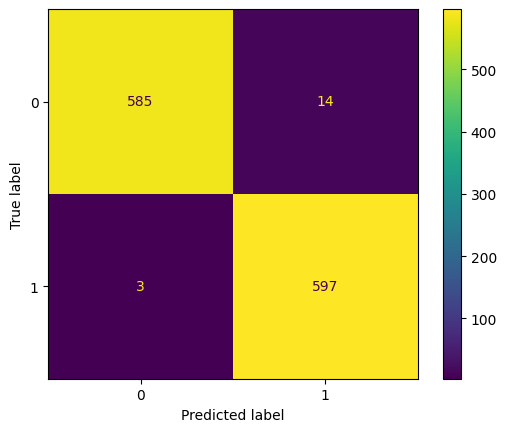

In [306]:
# Confusion matrix clean display
xgb_y1_cm_all = confusion_matrix(y1_test, y1_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_y1_cm_all)
disp.plot(values_format='d')

In [314]:
# Making dataset bigger - getting additional 1000 phishing urls
label_0_df = test_df[test_df['label'] == 0]
label_0_not_in_model = label_0_df[~label_0_df['url'].isin(model_df['URL'])] # Make sure they are new URL's
sampled_1000_0 = label_0_not_in_model.sample(n=1000, random_state=42)

In [316]:
# Making dataset bigger - getting additional 1000 legitimate urls
label_1_df = test_df[test_df['label'] == 1]
label_1_not_in_model = label_1_df[~label_1_df['url'].isin(model_df['URL'])] # Make sure they are new URL's
sampled_1000_1 = label_1_not_in_model.sample(n=1000, random_state=42)

In [318]:
# Concatenate into one DF
new_sample = pd.concat([sampled_1000_0, sampled_1000_1], ignore_index=True)

## Do not run cell below - would take over an hour to run - 
## Data captured below is saved in 10k_URL_Training.csv

In [319]:
#Get features from phishing features class
new_features_list_2000 = []

for _, row in tqdm(new_sample.iterrows(), desc="Getting Phishing Features"):
    extractor = PhishingFeatureExtractor(row['url'])
    features = extractor.to_dict()
    features['label'] = row['label']
    features['URL'] = row['url']
    new_features_list_2000.append(features)

new_features_df_2000 = pd.DataFrame(new_features_list_2000)

Getting Phishing Features: 2it [00:01,  1.58it/s]

Request failed: HTTPConnectionPool(host='screwstudprediche.02tablet.com', port=80): Max retries exceeded with url: /0qfgsypxhz.php%5Cnwww.universitaperta.com/area-riservata/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27884220d0>: Failed to resolve 'screwstudprediche.02tablet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='screwstudprediche.02tablet.com', port=80): Max retries exceeded with url: /0qfgsypxhz.php%5Cnwww.universitaperta.com/area-riservata/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff278847d610>: Failed to resolve 'screwstudprediche.02tablet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://screwstudprediche.02tablet.com/0qfgsypxhz.php\nwww.universitaperta.com/area-riservata/: HTTPConnectionPool(host='screwstudprediche.02tablet.com', port=80): Max retries exceeded with url: /0qfgsypxhz.php%5Cnwww.universitaperta.com/

Getting Phishing Features: 5it [00:03,  1.32it/s]

Request failed: HTTPSConnectionPool(host='demo.xcally.com', port=443): Max retries exceeded with url: /assets/plugins/jquery-file-upload/server/php/files/PayPalScam/9e61544a65dbc2dcc311b883a9ba3f36/?REDACTED (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2788478390>, 'Connection to demo.xcally.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='demo.xcally.com', port=443): Max retries exceeded with url: /assets/plugins/jquery-file-upload/server/php/files/PayPalScam/9e61544a65dbc2dcc311b883a9ba3f36/?REDACTED (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e476a90>, 'Connection to demo.xcally.com timed out. (connect timeout=5)'))


Getting Phishing Features: 6it [00:17,  4.91s/it]

Error checking self redirects for https://demo.xcally.com/assets/plugins/jquery-file-upload/server/php/files/PayPalScam/9e61544a65dbc2dcc311b883a9ba3f36/?REDACTED: HTTPSConnectionPool(host='demo.xcally.com', port=443): Max retries exceeded with url: /assets/plugins/jquery-file-upload/server/php/files/PayPalScam/9e61544a65dbc2dcc311b883a9ba3f36/?REDACTED (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e472750>, 'Connection to demo.xcally.com timed out. (connect timeout=5)'))


Getting Phishing Features: 9it [00:30,  3.95s/it]

Request failed: HTTPConnectionPool(host='roziranda.com', port=80): Max retries exceeded with url: /first.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2788478150>: Failed to resolve 'roziranda.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='roziranda.com', port=80): Max retries exceeded with url: /first.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e4629d0>: Failed to resolve 'roziranda.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://roziranda.com/first.php: HTTPConnectionPool(host='roziranda.com', port=80): Max retries exceeded with url: /first.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e44ab90>: Failed to resolve 'roziranda.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 12it [00:30,  1.67s/it]

Request failed: HTTPConnectionPool(host='apple.icloud.storage.update.center.uk.industrialproductspurchase.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e4496d0>: Failed to resolve 'apple.icloud.storage.update.center.uk.industrialproductspurchase.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='apple.icloud.storage.update.center.uk.industrialproductspurchase.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e44d050>: Failed to resolve 'apple.icloud.storage.update.center.uk.industrialproductspurchase.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://apple.icloud.storage.update.center.uk.industrialproductspurchase.com/: HTTPConnectionPool(host='apple.icloud.storage.update.center.uk.industrialproductspurchase.com', port=80): Max retries exc

Getting Phishing Features: 14it [00:32,  1.48s/it]

Error checking self redirects for https://www.justicejackson.com/Check/Check/: HTTPSConnectionPool(host='www.justicejackson.com', port=443): Max retries exceeded with url: /Check/Check/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.justicejackson.com'. (_ssl.c:1006)")))
Request failed: HTTPConnectionPool(host='daspar.net', port=80): Max retries exceeded with url: /components/.kkcpgr.php?action=ss00_323 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e46ad50>: Failed to resolve 'daspar.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='daspar.net', port=80): Max retries exceeded with url: /components/.kkcpgr.php?action=ss00_323 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e44e790>: Failed to resolve 'daspar.net' ([Errno -2] Name or service not known)"))
Er

Getting Phishing Features: 20it [00:41,  1.78s/it]

Request failed: HTTPConnectionPool(host='helpportal14.wapka.mobi', port=80): Max retries exceeded with url: /index.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e4d7a10>, 'Connection to helpportal14.wapka.mobi timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='helpportal14.wapka.mobi', port=80): Max retries exceeded with url: /index.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e4d7b10>, 'Connection to helpportal14.wapka.mobi timed out. (connect timeout=5)'))


Getting Phishing Features: 21it [00:58,  5.74s/it]

Error checking self redirects for http://helpportal14.wapka.mobi/index.xhtml: HTTPConnectionPool(host='helpportal14.wapka.mobi', port=80): Max retries exceeded with url: /index.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e4d4650>, 'Connection to helpportal14.wapka.mobi timed out. (connect timeout=5)'))


Getting Phishing Features: 23it [00:59,  3.35s/it]

Request failed: HTTPConnectionPool(host='aguasdebraganca.com.br', port=80): Max retries exceeded with url: /includes/include_online (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e463e90>: Failed to resolve 'aguasdebraganca.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aguasdebraganca.com.br', port=80): Max retries exceeded with url: /includes/include_online (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e4d6550>: Failed to resolve 'aguasdebraganca.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aguasdebraganca.com.br/includes/include_online: HTTPConnectionPool(host='aguasdebraganca.com.br', port=80): Max retries exceeded with url: /includes/include_online (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e4c1950>: Failed to resolve 'aguasdebraganca.com.br' ([Errno -2] Name or service n

Getting Phishing Features: 24it [01:02,  3.11s/it]

Request failed: HTTPConnectionPool(host='gsctechinology.com', port=80): Max retries exceeded with url: /ali/index.php?email=abuse@153.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e4c3e90>: Failed to resolve 'gsctechinology.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gsctechinology.com', port=80): Max retries exceeded with url: /ali/index.php?email=abuse@153.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784bd090>: Failed to resolve 'gsctechinology.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gsctechinology.com/ali/index.php?email=abuse@153.com: HTTPConnectionPool(host='gsctechinology.com', port=80): Max retries exceeded with url: /ali/index.php?email=abuse@153.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784beed0>: Failed to resolve 'gsctechinology.com' ([Errno -2] Name 

Getting Phishing Features: 28it [01:05,  1.48s/it]

Error checking self redirects for http://www.noithattananh.com/themes/.akjshdoiugshdoiusaodgui12ge281wuqoihdasiudhsa/USAA%20_%20Welcome%20to%20USAA.htm: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='benavidezhoy.com', port=80): Max retries exceeded with url: /8zrg48k (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d68d0>: Failed to resolve 'benavidezhoy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='benavidezhoy.com', port=80): Max retries exceeded with url: /8zrg48k (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784c4390>: Failed to resolve 'benavidezhoy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://benavidezhoy.com/8zrg48k: HTTPConnectionPool(host='benavidezhoy.com', port=80): Max retries exceeded with url: /8zrg48k (Caused by NameResol

Getting Phishing Features: 30it [01:05,  1.02it/s]

Request failed: HTTPConnectionPool(host='encogidamente.dopaving.com', port=80): Max retries exceeded with url: /sexiness/viewtopic.php?f=66&t=18622423 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e4c3150>: Failed to resolve 'encogidamente.dopaving.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='encogidamente.dopaving.com', port=80): Max retries exceeded with url: /sexiness/viewtopic.php?f=66&t=18622423 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784bfcd0>: Failed to resolve 'encogidamente.dopaving.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://encogidamente.dopaving.com/sexiness/viewtopic.php?f=66&t=18622423: HTTPConnectionPool(host='encogidamente.dopaving.com', port=80): Max retries exceeded with url: /sexiness/viewtopic.php?f=66&t=18622423 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2

Getting Phishing Features: 31it [01:07,  1.07s/it]

Request failed: HTTPConnectionPool(host='graphiceducationonline.com', port=80): Max retries exceeded with url: /Ceo/NewBase2016/archive/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784fa510>: Failed to resolve 'graphiceducationonline.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='graphiceducationonline.com', port=80): Max retries exceeded with url: /Ceo/NewBase2016/archive/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784f9490>: Failed to resolve 'graphiceducationonline.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://graphiceducationonline.com/Ceo/NewBase2016/archive/index.html: HTTPConnectionPool(host='graphiceducationonline.com', port=80): Max retries exceeded with url: /Ceo/NewBase2016/archive/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878504b10>: Fail

Getting Phishing Features: 35it [01:09,  1.32it/s]

Error checking self redirects for http://theivorycloset.com/magento/securedoc/login.php?98a0ce149bf7c76544a58403943b935198a0ce149bf7c76544a58403943b9351=: HTTPSConnectionPool(host='www.baxterfundays.com', port=443): Max retries exceeded with url: /magento/securedoc/login.php?98a0ce149bf7c76544a58403943b935198a0ce149bf7c76544a58403943b9351= (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='www.siervosdelareinadelapaz.com', port=80): Max retries exceeded with url: /cgi/GOOGLENEWW/GOOGLENEWW/GOOGLENEW/realestateseller/doc/work/ec/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878506ed0>: Failed to resolve 'www.siervosdelareinadelapaz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.siervosdelareinadelapaz.com', port=80): Max retries exceeded

Getting Phishing Features: 42it [01:20,  1.24s/it]

Request failed: HTTPConnectionPool(host='ubibanca.com.eibafxgivzhwvtaqhlkeog95hcdixk.lcsm3yk0w6y5rknrbv3lzgixbqpfpm.fafym8mm70iv4zghg830jsgrfixvny.sddgpai3xiatcapjhmcgwuneqv2bye.zhi3notwgq5ha7hpge3jlo4oikalyf.lgdejrx6ye1f6xdk4hccth78qg9qsx.aflops.com', port=80): Max retries exceeded with url: /ubi61/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878505090>: Failed to resolve 'ubibanca.com.eibafxgivzhwvtaqhlkeog95hcdixk.lcsm3yk0w6y5rknrbv3lzgixbqpfpm.fafym8mm70iv4zghg830jsgrfixvny.sddgpai3xiatcapjhmcgwuneqv2bye.zhi3notwgq5ha7hpge3jlo4oikalyf.lgdejrx6ye1f6xdk4hccth78qg9qsx.aflops.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ubibanca.com.eibafxgivzhwvtaqhlkeog95hcdixk.lcsm3yk0w6y5rknrbv3lzgixbqpfpm.fafym8mm70iv4zghg830jsgrfixvny.sddgpai3xiatcapjhmcgwuneqv2bye.zhi3notwgq5ha7hpge3jlo4oikalyf.lgdejrx6ye1f6xdk4hccth78qg9qsx.aflops.com', port=80): Max retries exceeded with url: /ubi61/index.php (Caus

Getting Phishing Features: 44it [01:20,  1.11it/s]

Request failed: HTTPConnectionPool(host='katsura96.com', port=80): Max retries exceeded with url: /data/UntitledNotebook1.html?run=login_cmd&amp;statuts=f17ca2c829680ada2fec9fc87bc5f60613a8bdcbb3fbba6ff11f5a745026929a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287837a3d0>: Failed to resolve 'katsura96.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='katsura96.com', port=80): Max retries exceeded with url: /data/UntitledNotebook1.html?run=login_cmd&amp;statuts=f17ca2c829680ada2fec9fc87bc5f60613a8bdcbb3fbba6ff11f5a745026929a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287837be90>: Failed to resolve 'katsura96.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://katsura96.com/data/UntitledNotebook1.html?run=login_cmd&amp;statuts=f17ca2c829680ada2fec9fc87bc5f60613a8bdcbb3fbba6ff11f5a745026929a: HTTPConnectionPool(host='katsura96.com', p

Getting Phishing Features: 47it [01:30,  1.99s/it]

Request failed: HTTPConnectionPool(host='www.oscarcruz.pe', port=80): Max retries exceeded with url: /Investmentproject.drive/Importantedocumentos/Secure.documentt.file/Imagedrive.file/filewordss/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287837b890>: Failed to resolve 'www.oscarcruz.pe' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.oscarcruz.pe', port=80): Max retries exceeded with url: /Investmentproject.drive/Importantedocumentos/Secure.documentt.file/Imagedrive.file/filewordss/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878387550>: Failed to resolve 'www.oscarcruz.pe' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.oscarcruz.pe/Investmentproject.drive/Importantedocumentos/Secure.documentt.file/Imagedrive.file/filewordss/index.php: HTTPConnectionPool(host='www.oscarcruz.pe', port=80): Max retries exceed

Getting Phishing Features: 49it [01:30,  1.37s/it]

Request failed: HTTPConnectionPool(host='boyom.wpwithus.com', port=80): Max retries exceeded with url: /dropbox/Dropbox/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287838da10>: Failed to resolve 'boyom.wpwithus.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='boyom.wpwithus.com', port=80): Max retries exceeded with url: /dropbox/Dropbox/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287838ec90>: Failed to resolve 'boyom.wpwithus.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://boyom.wpwithus.com/dropbox/Dropbox/index.htm: HTTPConnectionPool(host='boyom.wpwithus.com', port=80): Max retries exceeded with url: /dropbox/Dropbox/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287831a110>: Failed to resolve 'boyom.wpwithus.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 50it [01:31,  1.15s/it]

Request failed: HTTPConnectionPool(host='harveyventuresltd.com', port=80): Max retries exceeded with url: /90ujn3b8c3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287838f4d0>: Failed to resolve 'harveyventuresltd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='harveyventuresltd.com', port=80): Max retries exceeded with url: /90ujn3b8c3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878384dd0>: Failed to resolve 'harveyventuresltd.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://harveyventuresltd.com/90ujn3b8c3: HTTPConnectionPool(host='harveyventuresltd.com', port=80): Max retries exceeded with url: /90ujn3b8c3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878386f90>: Failed to resolve 'harveyventuresltd.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 52it [01:33,  1.22s/it]

Request failed: HTTPConnectionPool(host='184.168.51.246', port=80): Max retries exceeded with url: /magmi/web/images/DropBoxDocument/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878379350>, 'Connection to 184.168.51.246 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='184.168.51.246', port=80): Max retries exceeded with url: /magmi/web/images/DropBoxDocument/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287831ba90>, 'Connection to 184.168.51.246 timed out. (connect timeout=5)'))


Getting Phishing Features: 53it [01:48,  3.87s/it]

Error checking self redirects for http://184.168.51.246/magmi/web/images/DropBoxDocument/: HTTPConnectionPool(host='184.168.51.246', port=80): Max retries exceeded with url: /magmi/web/images/DropBoxDocument/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878318490>, 'Connection to 184.168.51.246 timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='thedaffodilhome.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='thedaffodilhome.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 54it [01:48,  3.15s/it]

Error checking self redirects for http://hinobekasikarawang.com/xml/addo/: HTTPSConnectionPool(host='thedaffodilhome.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 55it [01:49,  2.50s/it]

Request failed: HTTPConnectionPool(host='kohlesekdamodar.trucksbyswat.com', port=80): Max retries exceeded with url: /8hdtqw55eg.php%5Cnwww.naturaliaingredients.com/p/11-deionized-grape-juice-concentrate (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287831ba10>: Failed to resolve 'kohlesekdamodar.trucksbyswat.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kohlesekdamodar.trucksbyswat.com', port=80): Max retries exceeded with url: /8hdtqw55eg.php%5Cnwww.naturaliaingredients.com/p/11-deionized-grape-juice-concentrate (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287838f890>: Failed to resolve 'kohlesekdamodar.trucksbyswat.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kohlesekdamodar.trucksbyswat.com/8hdtqw55eg.php\nwww.naturaliaingredients.com/p/11-deionized-grape-juice-concentrate: HTTPConnectionPool(host='kohlesekdamodar.trucksb

Getting Phishing Features: 59it [01:50,  1.17s/it]

Request failed: HTTPConnectionPool(host='speciaaldesign.nl', port=80): Max retries exceeded with url: /74t3nf4gv4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287837b490>: Failed to resolve 'speciaaldesign.nl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='speciaaldesign.nl', port=80): Max retries exceeded with url: /74t3nf4gv4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e44f810>: Failed to resolve 'speciaaldesign.nl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://speciaaldesign.nl/74t3nf4gv4: HTTPConnectionPool(host='speciaaldesign.nl', port=80): Max retries exceeded with url: /74t3nf4gv4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff278847aed0>: Failed to resolve 'speciaaldesign.nl' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='csgladiatorgym.ro', port=80): Max

Getting Phishing Features: 63it [01:52,  1.55it/s]

Error checking self redirects for http://paracom.paramountcommunication.com/ct/37756274:W6vkz7bNI:m:1:1410275979:99A60A5A05744A24E520A0A5AD1FA200:r: HTTPConnectionPool(host='paracom.paramountcommunication.com', port=80): Max retries exceeded with url: /ct/37756274:W6vkz7bNI:m:1:1410275979:99A60A5A05744A24E520A0A5AD1FA200:r (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878384b90>: Failed to resolve 'paracom.paramountcommunication.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='scottygooding.com.au', port=80): Max retries exceeded with url: /vdG76VUY76rjnu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878378990>: Failed to resolve 'scottygooding.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='scottygooding.com.au', port=80): Max retries exceeded with url: /vdG76VUY76rjnu (Caused by NameResolutionError("<urllib3.connection.HTTPCo

Getting Phishing Features: 65it [01:54,  1.12it/s]

Request failed: HTTPConnectionPool(host='aaa.net.au', port=80): Max retries exceeded with url: /zz/hash/login.php?email=abuse@HANLEY.COM (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878384e10>, 'Connection to aaa.net.au timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='aaa.net.au', port=80): Max retries exceeded with url: /zz/hash/login.php?email=abuse@HANLEY.COM (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28784c5b10>, 'Connection to aaa.net.au timed out. (connect timeout=5)'))


Getting Phishing Features: 66it [02:08,  4.06s/it]

Error checking self redirects for http://aaa.net.au/zz/hash/login.php?email=abuse@HANLEY.COM: HTTPConnectionPool(host='aaa.net.au', port=80): Max retries exceeded with url: /zz/hash/login.php?email=abuse@HANLEY.COM (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28784c6110>, 'Connection to aaa.net.au timed out. (connect timeout=5)'))


Getting Phishing Features: 69it [02:09,  1.90s/it]

Request failed: HTTPConnectionPool(host='www.chrisandclairegethitched.com', port=80): Max retries exceeded with url: /wp-yeye/0135c667aa2b3942873858... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878387e50>: Failed to resolve 'www.chrisandclairegethitched.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.chrisandclairegethitched.com', port=80): Max retries exceeded with url: /wp-yeye/0135c667aa2b3942873858... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287838f110>: Failed to resolve 'www.chrisandclairegethitched.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.chrisandclairegethitched.com/wp-yeye/0135c667aa2b3942873858...: HTTPConnectionPool(host='www.chrisandclairegethitched.com', port=80): Max retries exceeded with url: /wp-yeye/0135c667aa2b3942873858... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection

Getting Phishing Features: 73it [02:14,  1.33s/it]

Request failed: HTTPConnectionPool(host='188.129.246.244', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878378650>, 'Connection to 188.129.246.244 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='188.129.246.244', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28784c4d10>, 'Connection to 188.129.246.244 timed out. (connect timeout=5)'))


Getting Phishing Features: 74it [02:29,  5.16s/it]

Error checking self redirects for http://188.129.246.244/: HTTPConnectionPool(host='188.129.246.244', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287838cdd0>, 'Connection to 188.129.246.244 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='185.91.175.161', port=80): Max retries exceeded with url: /bt/bt/get5.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878385fd0>, 'Connection to 185.91.175.161 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='185.91.175.161', port=80): Max retries exceeded with url: /bt/bt/get5.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28784d5dd0>, 'Connection to 185.91.175.161 timed out. (connect timeout=5)'))


Getting Phishing Features: 75it [02:43,  7.73s/it]

Error checking self redirects for http://185.91.175.161/bt/bt/get5.php: HTTPConnectionPool(host='185.91.175.161', port=80): Max retries exceeded with url: /bt/bt/get5.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e42f290>, 'Connection to 185.91.175.161 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='enkennedy.com', port=80): Max retries exceeded with url: /wp-includes/images/phone/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878387e50>: Failed to resolve 'enkennedy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='enkennedy.com', port=80): Max retries exceeded with url: /wp-includes/images/phone/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d7290>: Failed to resolve 'enkennedy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://enkennedy.com/

Getting Phishing Features: 79it [02:44,  2.65s/it]

Request failed: HTTPConnectionPool(host='jeckeromper.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287837b010>: Failed to resolve 'jeckeromper.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jeckeromper.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287ee24750>: Failed to resolve 'jeckeromper.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jeckeromper.ru/zapoy/gate.php: HTTPConnectionPool(host='jeckeromper.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784bc890>: Failed to resolve 'jeckeromper.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='raheems.in', port=80): Max retries exc

Getting Phishing Features: 83it [02:44,  1.16s/it]

Request failed: HTTPConnectionPool(host='cbacpartnership.org', port=80): Max retries exceeded with url: /verify/cc2fc3cfa27518a2519ff2cf16d288abNzdjMTdjOTJhYjAyNmRlNjVmYjhkODdlMGQ0ZjIwYzM=/myaccount/websc_login/?country.x=US&amp;locale.x=en_US (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d78d0>: Failed to resolve 'cbacpartnership.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cbacpartnership.org', port=80): Max retries exceeded with url: /verify/cc2fc3cfa27518a2519ff2cf16d288abNzdjMTdjOTJhYjAyNmRlNjVmYjhkODdlMGQ0ZjIwYzM=/myaccount/websc_login/?country.x=US&amp;locale.x=en_US (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287e4c3310>: Failed to resolve 'cbacpartnership.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cbacpartnership.org/verify/cc2fc3cfa27518a2519ff2cf16d288abNzdjMTdjOTJhYjAyNmRlNjVmYjhkODdlMGQ0ZjIwYzM=/myaccoun

Getting Phishing Features: 85it [02:44,  1.16it/s]

Request failed: HTTPConnectionPool(host='timeforhealthusa.com', port=80): Max retries exceeded with url: /fdgfd/fdgfd/X1z0/products/viewer.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784c4750>: Failed to resolve 'timeforhealthusa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='timeforhealthusa.com', port=80): Max retries exceeded with url: /fdgfd/fdgfd/X1z0/products/viewer.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878378790>: Failed to resolve 'timeforhealthusa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://timeforhealthusa.com/fdgfd/fdgfd/X1z0/products/viewer.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid=: HTTPConnectionPool(host='timeforhealthusa.com', port=80): Max retries exceeded with url: /fdgf

Getting Phishing Features: 90it [03:00,  1.81s/it]

Error checking self redirects for http://91.239.24.241:6892: HTTPConnectionPool(host='91.239.24.241', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28784d4d90>, 'Connection to 91.239.24.241 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='mysuccessplanet.com', port=80): Max retries exceeded with url: /todaysnews/onlin/e63418f942f570fae98bbc6c37bd2b20 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d4050>: Failed to resolve 'mysuccessplanet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mysuccessplanet.com', port=80): Max retries exceeded with url: /todaysnews/onlin/e63418f942f570fae98bbc6c37bd2b20 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878319850>: Failed to resolve 'mysuccessplanet.com' ([Errno -2] Name or service not known)"))
Error checking self redirect

Getting Phishing Features: 92it [03:00,  1.35s/it]

Request failed: HTTPConnectionPool(host='chaseonline.cllgn.org', port=80): Max retries exceeded with url: /ChaseOnlineLogonRBG.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784c4b10>: Failed to resolve 'chaseonline.cllgn.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chaseonline.cllgn.org', port=80): Max retries exceeded with url: /ChaseOnlineLogonRBG.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784c6e50>: Failed to resolve 'chaseonline.cllgn.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://chaseonline.cllgn.org/ChaseOnlineLogonRBG.html...: HTTPConnectionPool(host='chaseonline.cllgn.org', port=80): Max retries exceeded with url: /ChaseOnlineLogonRBG.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d6f50>: Failed to resolve 'chaseonline.cllgn.org' ([Errno -2] Name or 

Getting Phishing Features: 96it [03:02,  1.30it/s]

Request failed: HTTPConnectionPool(host='del-sieradz.neostrada.pl', port=80): Max retries exceeded with url: /988g765f (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d4890>: Failed to resolve 'del-sieradz.neostrada.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='del-sieradz.neostrada.pl', port=80): Max retries exceeded with url: /988g765f (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287838c2d0>: Failed to resolve 'del-sieradz.neostrada.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://del-sieradz.neostrada.pl/988g765f: HTTPConnectionPool(host='del-sieradz.neostrada.pl', port=80): Max retries exceeded with url: /988g765f (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878507890>: Failed to resolve 'del-sieradz.neostrada.pl' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPoo

Getting Phishing Features: 98it [03:02,  1.89it/s]

Request failed: HTTPConnectionPool(host='judgedeborahshallcross.com', port=80): Max retries exceeded with url: /wri2h09 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d7d50>: Failed to resolve 'judgedeborahshallcross.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='judgedeborahshallcross.com', port=80): Max retries exceeded with url: /wri2h09 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d73d0>: Failed to resolve 'judgedeborahshallcross.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://judgedeborahshallcross.com/wri2h09: HTTPConnectionPool(host='judgedeborahshallcross.com', port=80): Max retries exceeded with url: /wri2h09 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784c7c90>: Failed to resolve 'judgedeborahshallcross.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPCon

Getting Phishing Features: 100it [03:11,  1.89s/it]

Request failed: HTTPConnectionPool(host='granit-profi58.ru', port=80): Max retries exceeded with url: /wp-content/MicrosoftEmailUpgrade.html?email=abuse@redifmail.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782ae590>: Failed to resolve 'granit-profi58.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='granit-profi58.ru', port=80): Max retries exceeded with url: /wp-content/MicrosoftEmailUpgrade.html?email=abuse@redifmail.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bc790>: Failed to resolve 'granit-profi58.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://granit-profi58.ru/wp-content/MicrosoftEmailUpgrade.html?email=abuse@redifmail.com: HTTPConnectionPool(host='granit-profi58.ru', port=80): Max retries exceeded with url: /wp-content/MicrosoftEmailUpgrade.html?email=abuse@redifmail.com (Caused by NameResolutionError("<url

Getting Phishing Features: 101it [03:11,  1.59s/it]

Request failed: HTTPConnectionPool(host='mail01.tinyletterapp.com', port=80): Max retries exceeded with url: /HAYART/good-evening-how-are-you/12140389-taw0tarj3.gq/orpxem3/02326/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782c8410>: Failed to resolve 'mail01.tinyletterapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mail01.tinyletterapp.com', port=80): Max retries exceeded with url: /HAYART/good-evening-how-are-you/12140389-taw0tarj3.gq/orpxem3/02326/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782c9c50>: Failed to resolve 'mail01.tinyletterapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mail01.tinyletterapp.com/HAYART/good-evening-how-are-you/12140389-taw0tarj3.gq/orpxem3/02326/: HTTPConnectionPool(host='mail01.tinyletterapp.com', port=80): Max retries exceeded with url: /HAYART/good-evening-how-are-you/12140389-ta

Getting Phishing Features: 103it [03:14,  1.42s/it]

Request failed: HTTPConnectionPool(host='sellercentral.amazon.de.ku1xu6zo5qe2lu0fwsq1qzvgixcxra.waterproofrepair.com.au', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bfe90>: Failed to resolve 'sellercentral.amazon.de.ku1xu6zo5qe2lu0fwsq1qzvgixcxra.waterproofrepair.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sellercentral.amazon.de.ku1xu6zo5qe2lu0fwsq1qzvgixcxra.waterproofrepair.com.au', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bdfd0>: Failed to resolve 'sellercentral.amazon.de.ku1xu6zo5qe2lu0fwsq1qzvgixcxra.waterproofrepair.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sellercentral.amazon.de.ku1xu6zo5qe2lu0fwsq1qzvgixcxra.waterproofrepair.com.au/: HTTPConnectionPool(host='sellercentral.amazon.de.ku1xu6zo5qe2lu0fwsq1qz

Getting Phishing Features: 107it [03:18,  1.22s/it]

Request failed: HTTPConnectionPool(host='bizanalyst.com.au', port=80): Max retries exceeded with url: /wp-includes/dropdamyy (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b3150>: Failed to resolve 'bizanalyst.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bizanalyst.com.au', port=80): Max retries exceeded with url: /wp-includes/dropdamyy (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782ae5d0>: Failed to resolve 'bizanalyst.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bizanalyst.com.au/wp-includes/dropdamyy: HTTPConnectionPool(host='bizanalyst.com.au', port=80): Max retries exceeded with url: /wp-includes/dropdamyy (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782aea10>: Failed to resolve 'bizanalyst.com.au' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnection

Getting Phishing Features: 111it [03:20,  1.15it/s]

Request failed: HTTPConnectionPool(host='app-facabook.com', port=80): Max retries exceeded with url: /appshot/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bd850>: Failed to resolve 'app-facabook.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='app-facabook.com', port=80): Max retries exceeded with url: /appshot/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bc090>: Failed to resolve 'app-facabook.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://app-facabook.com/appshot/: HTTPConnectionPool(host='app-facabook.com', port=80): Max retries exceeded with url: /appshot/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287838f1d0>: Failed to resolve 'app-facabook.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.santos400.com', port=80): Max retries exceed

Getting Phishing Features: 116it [03:22,  1.96it/s]

Request failed: HTTPConnectionPool(host='disablehistory.hol.es', port=80): Max retries exceeded with url: /index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782be2d0>: Failed to resolve 'disablehistory.hol.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='disablehistory.hol.es', port=80): Max retries exceeded with url: /index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878305ad0>: Failed to resolve 'disablehistory.hol.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://disablehistory.hol.es/index.htm: HTTPConnectionPool(host='disablehistory.hol.es', port=80): Max retries exceeded with url: /index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878307290>: Failed to resolve 'disablehistory.hol.es' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='iicjlaw.n

Getting Phishing Features: 119it [03:33,  1.72s/it]

Request failed: HTTPConnectionPool(host='mxp1081.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878306b10>: Failed to resolve 'mxp1081.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp1081.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878305a10>: Failed to resolve 'mxp1081.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp1081.com: HTTPConnectionPool(host='mxp1081.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782fe310>: Failed to resolve 'mxp1081.com' ([Errno -2] Name or service not known)"))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', R

Getting Phishing Features: 121it [03:49,  4.09s/it]

Error checking self redirects for http://ccjlwb22w6c22p2k.onion.city: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 125it [03:49,  1.52s/it]

Request failed: HTTPConnectionPool(host='pups-sound-error.ml', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878307ed0>: Failed to resolve 'pups-sound-error.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pups-sound-error.ml', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878115f50>: Failed to resolve 'pups-sound-error.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pups-sound-error.ml/: HTTPConnectionPool(host='pups-sound-error.ml', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287811f110>: Failed to resolve 'pups-sound-error.ml' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='decota.es', port=80): Max retries exceeded with url: /111 (

Getting Phishing Features: 127it [03:50,  1.03it/s]

Request failed: HTTPConnectionPool(host='uydvrqwgg.su', port=80): Max retries exceeded with url: /checkupdate (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287812d010>: Failed to resolve 'uydvrqwgg.su' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='uydvrqwgg.su', port=80): Max retries exceeded with url: /checkupdate (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287cec9750>: Failed to resolve 'uydvrqwgg.su' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://uydvrqwgg.su/checkupdate: HTTPConnectionPool(host='uydvrqwgg.su', port=80): Max retries exceeded with url: /checkupdate (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782ff3d0>: Failed to resolve 'uydvrqwgg.su' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 128it [03:50,  1.32it/s]

Request failed: HTTPConnectionPool(host='saf1ty-facebook-banned-001.esy.es', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287811ea10>: Failed to resolve 'saf1ty-facebook-banned-001.esy.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='saf1ty-facebook-banned-001.esy.es', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878117550>: Failed to resolve 'saf1ty-facebook-banned-001.esy.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://saf1ty-facebook-banned-001.esy.es/recovery-chekpoint-login.html: HTTPConnectionPool(host='saf1ty-facebook-banned-001.esy.es', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at

Getting Phishing Features: 130it [03:51,  1.16it/s]

Request failed: HTTPConnectionPool(host='52soca.com', port=80): Max retries exceeded with url: /icjcu (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287812d3d0>, 'Connection to 52soca.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='52soca.com', port=80): Max retries exceeded with url: /icjcu (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287d274710>, 'Connection to 52soca.com timed out. (connect timeout=5)'))


Getting Phishing Features: 131it [04:06,  4.79s/it]

Error checking self redirects for http://52soca.com/icjcu: HTTPConnectionPool(host='52soca.com', port=80): Max retries exceeded with url: /icjcu (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878307790>, 'Connection to 52soca.com timed out. (connect timeout=5)'))


Getting Phishing Features: 133it [04:08,  2.78s/it]

Request failed: HTTPConnectionPool(host='v-mukko.ru', port=80): Max retries exceeded with url: /76733c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287811dfd0>: Failed to resolve 'v-mukko.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='v-mukko.ru', port=80): Max retries exceeded with url: /76733c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287c6cc9d0>: Failed to resolve 'v-mukko.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://v-mukko.ru/76733c: HTTPConnectionPool(host='v-mukko.ru', port=80): Max retries exceeded with url: /76733c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782fe1d0>: Failed to resolve 'v-mukko.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='arrayreplace.class', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<u

Getting Phishing Features: 135it [04:13,  2.64s/it]

Request failed: HTTPConnectionPool(host='ricardoeletro.com.br.promo70off.com', port=80): Max retries exceeded with url: /rcl072014.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287811e310>: Failed to resolve 'ricardoeletro.com.br.promo70off.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ricardoeletro.com.br.promo70off.com', port=80): Max retries exceeded with url: /rcl072014.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287811e250>: Failed to resolve 'ricardoeletro.com.br.promo70off.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ricardoeletro.com.br.promo70off.com/rcl072014.html/: HTTPConnectionPool(host='ricardoeletro.com.br.promo70off.com', port=80): Max retries exceeded with url: /rcl072014.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878306dd0>: Failed to resolve 'ricardo

Getting Phishing Features: 141it [04:23,  1.78s/it]

Request failed: HTTPConnectionPool(host='swetaent.com', port=80): Max retries exceeded with url: /jqr/drop/logsession/login.php?email=abuse@fr.michelin.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781947d0>: Failed to resolve 'swetaent.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='swetaent.com', port=80): Max retries exceeded with url: /jqr/drop/logsession/login.php?email=abuse@fr.michelin.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819a190>: Failed to resolve 'swetaent.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://swetaent.com/jqr/drop/logsession/login.php?email=abuse@fr.michelin.com: HTTPConnectionPool(host='swetaent.com', port=80): Max retries exceeded with url: /jqr/drop/logsession/login.php?email=abuse@fr.michelin.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819be5

Getting Phishing Features: 145it [04:26,  1.02it/s]

Request failed: HTTPConnectionPool(host='alrajhiekhwan.sa', port=80): Max retries exceeded with url: /txt/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=p... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819ad50>: Failed to resolve 'alrajhiekhwan.sa' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='alrajhiekhwan.sa', port=80): Max retries exceeded with url: /txt/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=p... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878198150>: Failed to resolve 'alrajhiekhwan.sa' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://alrajhiekhwan.sa/txt/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=p...: HTTPConnectionPool(host='alrajhiekhwan.sa', port=80): Max retries exceeded with url: /txt/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=p... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a4390>: Fail

Getting Phishing Features: 149it [04:40,  2.15s/it]

Error checking self redirects for http://185.158.4.20/.pp/customer_center/customer-IDPP00C661/V2/: HTTPConnectionPool(host='185.158.4.20', port=80): Max retries exceeded with url: /.pp/customer_center/customer-IDPP00C661/V2/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781a7c50>, 'Connection to 185.158.4.20 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='usmcfitpmffcnrys.work', port=80): Max retries exceeded with url: /upload/_dispatch.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287caf9ad0>: Failed to resolve 'usmcfitpmffcnrys.work' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='usmcfitpmffcnrys.work', port=80): Max retries exceeded with url: /upload/_dispatch.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878199d50>: Failed to resolve 'usmcfitpmffcnrys.work' ([Errno -2] Name or service not known)"))
E

Getting Phishing Features: 152it [04:41,  1.26s/it]

Request failed: HTTPConnectionPool(host='image.servepics.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819a410>: Failed to resolve 'image.servepics.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='image.servepics.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878197750>: Failed to resolve 'image.servepics.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://image.servepics.com/: HTTPConnectionPool(host='image.servepics.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a7d90>: Failed to resolve 'image.servepics.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='securitysystemfailurealert7609.info', port=80): Max retries

Getting Phishing Features: 154it [04:41,  1.02s/it]

Request failed: HTTPConnectionPool(host='sumicsow.gq', port=80): Max retries exceeded with url: /mmmm/Arizonapage1/ssn-0.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878198310>: Failed to resolve 'sumicsow.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sumicsow.gq', port=80): Max retries exceeded with url: /mmmm/Arizonapage1/ssn-0.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b1c90>: Failed to resolve 'sumicsow.gq' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sumicsow.gq/mmmm/Arizonapage1/ssn-0.htm: HTTPConnectionPool(host='sumicsow.gq', port=80): Max retries exceeded with url: /mmmm/Arizonapage1/ssn-0.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287818ba10>: Failed to resolve 'sumicsow.gq' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='sureret

Getting Phishing Features: 156it [04:42,  1.31it/s]

Request failed: HTTPConnectionPool(host='www.hung-guan.com.tw', port=80): Max retries exceeded with url: /g76gyui (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b4910>: Failed to resolve 'www.hung-guan.com.tw' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.hung-guan.com.tw', port=80): Max retries exceeded with url: /g76gyui (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b76d0>: Failed to resolve 'www.hung-guan.com.tw' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.hung-guan.com.tw/g76gyui: HTTPConnectionPool(host='www.hung-guan.com.tw', port=80): Max retries exceeded with url: /g76gyui (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781aca10>: Failed to resolve 'www.hung-guan.com.tw' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 160it [04:44,  1.67it/s]

Request failed: HTTPConnectionPool(host='thefantasticmom.com', port=80): Max retries exceeded with url: /images/gggg/gtex/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819a290>: Failed to resolve 'thefantasticmom.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='thefantasticmom.com', port=80): Max retries exceeded with url: /images/gggg/gtex/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878194750>: Failed to resolve 'thefantasticmom.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://thefantasticmom.com/images/gggg/gtex/index.php: HTTPConnectionPool(host='thefantasticmom.com', port=80): Max retries exceeded with url: /images/gggg/gtex/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287818be90>: Failed to resolve 'thefantasticmom.com' ([Errno -2] Name or service not known)

Getting Phishing Features: 162it [04:44,  2.26it/s]

Request failed: HTTPConnectionPool(host='oofuv.cruisingsmallship.com', port=80): Max retries exceeded with url: /oozughoars/psoakraghi/oawygroors/files/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b34d0>: Failed to resolve 'oofuv.cruisingsmallship.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oofuv.cruisingsmallship.com', port=80): Max retries exceeded with url: /oozughoars/psoakraghi/oawygroors/files/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819be90>: Failed to resolve 'oofuv.cruisingsmallship.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oofuv.cruisingsmallship.com/oozughoars/psoakraghi/oawygroors/files/: HTTPConnectionPool(host='oofuv.cruisingsmallship.com', port=80): Max retries exceeded with url: /oozughoars/psoakraghi/oawygroors/files/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection objec

Getting Phishing Features: 164it [04:46,  1.61it/s]

Error checking self redirects for http://nortagem.cl/zinn/aw/wy/es/auth/view/document/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='doktergigisingapura.com', port=80): Max retries exceeded with url: /wp-content/plugins/appointments/includes/gcal/auth/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781ad750>: Failed to resolve 'doktergigisingapura.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='doktergigisingapura.com', port=80): Max retries exceeded with url: /wp-content/plugins/appointments/includes/gcal/auth/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a4310>: Failed to resolve 'doktergigisingapura.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://doktergigisingapura.com/wp-content/plugins/appointments/includes/gcal/auth/: HTTPConnecti

Getting Phishing Features: 166it [04:54,  1.64s/it]

Error checking self redirects for http://tp64nkgq4kdc7qpl.onion.cab/tzu/: HTTPConnectionPool(host='tp64nkgq4kdc7qpl.onion.cab', port=80): Max retries exceeded with url: /tzu/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff287da9f150>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: HTTPConnectionPool(host='lingyuanbbs.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 167it [05:38,  9.01s/it]

Error checking self redirects for http://lingyuanbbs.com/487ygfh: HTTPConnectionPool(host='lingyuanbbs.com', port=80): Max retries exceeded with url: /487ygfh (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781b24d0>, 'Connection to lingyuanbbs.com timed out. (connect timeout=5)'))


Getting Phishing Features: 168it [05:39,  7.28s/it]

Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;;_Acess_Tooken28abdc8fa9606987971811d7c9c28e (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878199450>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;;_Acess_Tooken28abdc8fa9606987971811d7c9c28e (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781a5410>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 169it [05:54,  9.14s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;;_Acess_Tooken28abdc8fa9606987971811d7c9c28e: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;;_Acess_Tooken28abdc8fa9606987971811d7c9c28e (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781b6c90>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.cloudninehair.co.nz', port=80): Max retries exceeded with url: /find-a-salon/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287816b610>: Failed to resolve 'www.cloudninehair.co.nz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.cloudninehair.co.nz', port=80): Max retries exceeded with url: /find-a-salon/ (Caused by NameResolutionError("<urllib3.con

Getting Phishing Features: 171it [05:55,  5.65s/it]

Request failed: HTTPConnectionPool(host='fxqpufg.su', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878199cd0>: Failed to resolve 'fxqpufg.su' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fxqpufg.su', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a7310>: Failed to resolve 'fxqpufg.su' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fxqpufg.su/apache_handler.php: HTTPConnectionPool(host='fxqpufg.su', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b0310>: Failed to resolve 'fxqpufg.su' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 176it [06:01,  2.30s/it]

Request failed: HTTPConnectionPool(host='dexteriscool.in', port=80): Max retries exceeded with url: /images/server2/server/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b3950>: Failed to resolve 'dexteriscool.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dexteriscool.in', port=80): Max retries exceeded with url: /images/server2/server/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a5f50>: Failed to resolve 'dexteriscool.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dexteriscool.in/images/server2/server/cp.php?m=login: HTTPConnectionPool(host='dexteriscool.in', port=80): Max retries exceeded with url: /images/server2/server/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287816b250>: Failed to resolve 'dexteriscool.in' ([Errno -2] Name or servic

Getting Phishing Features: 179it [06:04,  1.57s/it]

Request failed: HTTPConnectionPool(host='papaentulhoba.com', port=80): Max retries exceeded with url: /extra/js/vendor (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b1890>: Failed to resolve 'papaentulhoba.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='papaentulhoba.com', port=80): Max retries exceeded with url: /extra/js/vendor (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782f8610>: Failed to resolve 'papaentulhoba.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://papaentulhoba.com/extra/js/vendor: HTTPConnectionPool(host='papaentulhoba.com', port=80): Max retries exceeded with url: /extra/js/vendor (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287812e810>: Failed to resolve 'papaentulhoba.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.electrome

Getting Phishing Features: 181it [06:08,  1.52s/it]

Request failed: HTTPConnectionPool(host='suezmarine-safety.com', port=80): Max retries exceeded with url: /01pizzy/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bd1d0>: Failed to resolve 'suezmarine-safety.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='suezmarine-safety.com', port=80): Max retries exceeded with url: /01pizzy/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782ffc50>: Failed to resolve 'suezmarine-safety.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://suezmarine-safety.com/01pizzy/: HTTPConnectionPool(host='suezmarine-safety.com', port=80): Max retries exceeded with url: /01pizzy/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784c6d10>: Failed to resolve 'suezmarine-safety.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='46.30.41.16',

Getting Phishing Features: 183it [06:15,  2.43s/it]

Error checking self redirects for http://46.30.41.16/files/970.exe: HTTPConnectionPool(host='46.30.41.16', port=80): Max retries exceeded with url: /files/970.exe (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2788479c50>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='download.xyzs.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781b4ad0>, 'Connection to download.xyzs.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='download.xyzs.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28784c52d0>, 'Connection to download.xyzs.com timed out. (connect timeout=5)'))


Getting Phishing Features: 184it [06:30,  5.11s/it]

Error checking self redirects for http://download.xyzs.com/: HTTPConnectionPool(host='download.xyzs.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28782b0390>, 'Connection to download.xyzs.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='nick-vujicic.pl', port=80): Max retries exceeded with url: /wp-includes/images/smilies/sosl.htm/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b5b10>: Failed to resolve 'nick-vujicic.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nick-vujicic.pl', port=80): Max retries exceeded with url: /wp-includes/images/smilies/sosl.htm/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a4d90>: Failed to resolve 'nick-vujicic.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nick-vujicic.pl/wp-incl

Getting Phishing Features: 186it [06:31,  3.24s/it]

Error checking self redirects for http://hinobekasikarawang.com/xml/addo/index.htm: HTTPSConnectionPool(host='thedaffodilhome.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 188it [06:37,  3.14s/it]

Request failed: HTTPConnectionPool(host='95.130.15.40', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781b06d0>, 'Connection to 95.130.15.40 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='95.130.15.40', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28782f5c50>, 'Connection to 95.130.15.40 timed out. (connect timeout=5)'))


Getting Phishing Features: 189it [06:52,  6.13s/it]

Error checking self redirects for http://95.130.15.40/: HTTPConnectionPool(host='95.130.15.40', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28782f7290>, 'Connection to 95.130.15.40 timed out. (connect timeout=5)'))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 190it [06:54,  4.95s/it]

Error checking self redirects for http://i-to.cc/bmf1P: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 191it [06:56,  4.18s/it]

Request failed: HTTPConnectionPool(host='cclpgms.com', port=80): Max retries exceeded with url: /js/?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782fb7d0>: Failed to resolve 'cclpgms.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cclpgms.com', port=80): Max retries exceeded with url: /js/?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782fb510>: Failed to resolve 'cclpgms.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cclpgms.com/js/?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID: HTTPConnectionPool(host='cclpgms.com', port=80): Max retries exceeded with url: /js/?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782be210>: Failed to resolve 'cclpgms.com' ([Errno -2] Name or se

Getting Phishing Features: 192it [07:11,  7.24s/it]

Error checking self redirects for http://79.97.254.75/connect/de/login/?webscr&amp;cmd=_login-run&amp;SESSION=jlBIyrkGrogEm4AsitxjCjamvwq8rpzHClhfhp1Adas8vnAEH19IDzHwon9&amp;dispatch=8562ae5e286544710b2e7ebe9858833b92a08bf918f44ccd961477be30023da1c4851e8e264415c4094e4e85b0baa7cc: HTTPConnectionPool(host='79.97.254.75', port=80): Max retries exceeded with url: /connect/de/login/?webscr&amp;cmd=_login-run&amp;SESSION=jlBIyrkGrogEm4AsitxjCjamvwq8rpzHClhfhp1Adas8vnAEH19IDzHwon9&amp;dispatch=8562ae5e286544710b2e7ebe9858833b92a08bf918f44ccd961477be30023da1c4851e8e264415c4094e4e85b0baa7cc (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28784c76d0>, 'Connection to 79.97.254.75 timed out. (connect timeout=5)'))


Getting Phishing Features: 194it [07:12,  3.85s/it]

Request failed: HTTPConnectionPool(host='pmlojistik.com', port=80): Max retries exceeded with url: /JHgy64HJBRd?qOkoBVbHpQ=cTAmtcDDx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b3d90>: Failed to resolve 'pmlojistik.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pmlojistik.com', port=80): Max retries exceeded with url: /JHgy64HJBRd?qOkoBVbHpQ=cTAmtcDDx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bd6d0>: Failed to resolve 'pmlojistik.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pmlojistik.com/JHgy64HJBRd?qOkoBVbHpQ=cTAmtcDDx: HTTPConnectionPool(host='pmlojistik.com', port=80): Max retries exceeded with url: /JHgy64HJBRd?qOkoBVbHpQ=cTAmtcDDx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781690d0>: Failed to resolve 'pmlojistik.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 196it [07:16,  3.03s/it]

Request failed: HTTPConnectionPool(host='91.194.254.241', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28784c5b10>, 'Connection to 91.194.254.241 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='91.194.254.241', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287801a010>, 'Connection to 91.194.254.241 timed out. (connect timeout=5)'))


Getting Phishing Features: 197it [07:30,  5.76s/it]

Error checking self redirects for http://91.194.254.241/: HTTPConnectionPool(host='91.194.254.241', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28780249d0>, 'Connection to 91.194.254.241 timed out. (connect timeout=5)'))


Getting Phishing Features: 200it [07:33,  2.80s/it]

Request failed: HTTPConnectionPool(host='travoxsb.com', port=80): Max retries exceeded with url: /8cx0thi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287801b090>: Failed to resolve 'travoxsb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='travoxsb.com', port=80): Max retries exceeded with url: /8cx0thi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b2cd0>: Failed to resolve 'travoxsb.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://travoxsb.com/8cx0thi: HTTPConnectionPool(host='travoxsb.com', port=80): Max retries exceeded with url: /8cx0thi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878024d90>: Failed to resolve 'travoxsb.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mxp2058.com', port=80): Max retries exceeded with url: / (Caused by NameResoluti

Getting Phishing Features: 203it [07:34,  1.50s/it]

Request failed: HTTPConnectionPool(host='csallas.com', port=80): Max retries exceeded with url: /PO/signed/contract/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b2750>: Failed to resolve 'csallas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='csallas.com', port=80): Max retries exceeded with url: /PO/signed/contract/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878019c10>: Failed to resolve 'csallas.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://csallas.com/PO/signed/contract/: HTTPConnectionPool(host='csallas.com', port=80): Max retries exceeded with url: /PO/signed/contract/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878026b10>: Failed to resolve 'csallas.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='makeitproduction.com', port=80): Max re

Getting Phishing Features: 206it [07:34,  1.20it/s]

Redirect check failed: HTTPConnectionPool(host='jghgdfhgfgdfgdfs.gargjewellers.com', port=80): Max retries exceeded with url: /aos/aos/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782f9250>: Failed to resolve 'jghgdfhgfgdfgdfs.gargjewellers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jghgdfhgfgdfgdfs.gargjewellers.com/aos/aos/: HTTPConnectionPool(host='jghgdfhgfgdfgdfs.gargjewellers.com', port=80): Max retries exceeded with url: /aos/aos/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878026bd0>: Failed to resolve 'jghgdfhgfgdfgdfs.gargjewellers.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='protec-vip01.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update.html?tab=payments&amp;ref=settings_nav (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b3b10>: Failed to resolve '

Getting Phishing Features: 206it [07:50,  1.20it/s]

Redirect check failed: HTTPConnectionPool(host='protec-vip01.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update.html?tab=payments&amp;ref=settings_nav (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878031e50>: Failed to resolve 'protec-vip01.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 208it [07:57,  4.05s/it]

Error checking self redirects for http://protec-vip01.000webhostapp.com/payment-update.html?tab=payments&amp;ref=settings_nav: HTTPConnectionPool(host='protec-vip01.000webhostapp.com', port=80): Max retries exceeded with url: /payment-update.html?tab=payments&amp;ref=settings_nav (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878033e10>: Failed to resolve 'protec-vip01.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 211it [08:00,  2.52s/it]

Request failed: HTTPConnectionPool(host='texasglassworks.com', port=80): Max retries exceeded with url: /wp-content/arrival/DHLel/DHLeAUTOl/dhl.php?_rand=13InboxLight.aspx?n=1774256418&amp;email=jim@thejimburkefamily.com&amp;fav_1=&amp;fid=4&amp;fid_1=&amp;fid_1252899642=&amp;fid_4_1252899642= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878031090>: Failed to resolve 'texasglassworks.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='texasglassworks.com', port=80): Max retries exceeded with url: /wp-content/arrival/DHLel/DHLeAUTOl/dhl.php?_rand=13InboxLight.aspx?n=1774256418&amp;email=jim@thejimburkefamily.com&amp;fav_1=&amp;fid=4&amp;fid_1=&amp;fid_1252899642=&amp;fid_4_1252899642= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287802df10>: Failed to resolve 'texasglassworks.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://texasglass

Getting Phishing Features: 215it [08:03,  1.58s/it]

Request failed: HTTPConnectionPool(host='paulopr.com', port=80): Max retries exceeded with url: /c6/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878031450>: Failed to resolve 'paulopr.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paulopr.com', port=80): Max retries exceeded with url: /c6/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781be010>: Failed to resolve 'paulopr.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paulopr.com/c6/: HTTPConnectionPool(host='paulopr.com', port=80): Max retries exceeded with url: /c6/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781be610>: Failed to resolve 'paulopr.com' ([Errno -2] Name or service not known)"))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection

Getting Phishing Features: 218it [08:05,  1.10s/it]

Error checking self redirects for http://noithattananh.com/themes/.akjshdoiugshdoiusaodgui12ge281wuqoihdasiudhsa/USAA%20_%20Welcome%20to%20USAA.htm?USAA&bn=3a87f6b7c2088874&burlid=d001a6ea0b9cbe16: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: HTTPConnectionPool(host='game.jinti.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 219it [08:12,  2.38s/it]

Request failed: HTTPConnectionPool(host='ringtonsfranchise.co.uk', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Parse/standard/ph... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878197250>: Failed to resolve 'ringtonsfranchise.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ringtonsfranchise.co.uk', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Parse/standard/ph... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287802cf50>: Failed to resolve 'ringtonsfranchise.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ringtonsfranchise.co.uk/wp-includes/SimplePie/Parse/standard/ph...: HTTPConnectionPool(host='ringtonsfranchise.co.uk', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Parse/standard/ph... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287

Getting Phishing Features: 223it [08:16,  1.55s/it]

Request failed: HTTPSConnectionPool(host='hadmedia.net', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 230it [08:39,  1.77s/it]

Request failed: HTTPConnectionPool(host='mercurysportsproducts.co.uk', port=80): Max retries exceeded with url: /js/var/-/amzaon/50c8962f862c26efd7e16d5acd4da4eb/index/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287801a410>: Failed to resolve 'mercurysportsproducts.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mercurysportsproducts.co.uk', port=80): Max retries exceeded with url: /js/var/-/amzaon/50c8962f862c26efd7e16d5acd4da4eb/index/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b1310>: Failed to resolve 'mercurysportsproducts.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mercurysportsproducts.co.uk/js/var/-/amzaon/50c8962f862c26efd7e16d5acd4da4eb/index/index.php: HTTPConnectionPool(host='mercurysportsproducts.co.uk', port=80): Max retries exceeded with url: /js/var/-/amzaon/50c8962f862c26efd7e16

Getting Phishing Features: 233it [08:47,  2.14s/it]

Request failed: HTTPConnectionPool(host='fllghtcentre.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287801ab50>: Failed to resolve 'fllghtcentre.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fllghtcentre.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b0ad0>: Failed to resolve 'fllghtcentre.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fllghtcentre.com/: HTTPConnectionPool(host='fllghtcentre.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287816af10>: Failed to resolve 'fllghtcentre.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 235it [08:50,  1.74s/it]

Request failed: HTTPConnectionPool(host='zonasegurabettaguiabbcp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bc850>: Failed to resolve 'zonasegurabettaguiabbcp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zonasegurabettaguiabbcp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b3ad0>: Failed to resolve 'zonasegurabettaguiabbcp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://bitly.com/2r1W1qy: HTTPConnectionPool(host='zonasegurabettaguiabbcp.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287803db50>: Failed to resolve 'zonasegurabettaguiabbcp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='centrovacacio

Getting Phishing Features: 238it [08:50,  1.20it/s]

Error checking self redirects for http://econopaginas.com/nyx37ec?YzqkkqWLW=RHkNpAc: HTTPConnectionPool(host='econopaginas.com', port=80): Max retries exceeded with url: /nyx37ec?YzqkkqWLW=RHkNpAc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287816b4d0>: Failed to resolve 'econopaginas.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='whp8j4ece3.jawutozasoxppa.net', port=80): Max retries exceeded with url: /u4k8sn1cnp%5Cnvellejaresearch.com/b/728x90.jpg?ref=coolin (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878500410>: Failed to resolve 'whp8j4ece3.jawutozasoxppa.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='whp8j4ece3.jawutozasoxppa.net', port=80): Max retries exceeded with url: /u4k8sn1cnp%5Cnvellejaresearch.com/b/728x90.jpg?ref=coolin (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819b110

Getting Phishing Features: 239it [08:51,  1.35it/s]

Request failed: HTTPConnectionPool(host='portugalwineclub.ca', port=80): Max retries exceeded with url: /paypal.com/inc/update/0f8ac57a26bab5edcb1f9f7afa93fbefOWVkNTc2ZGViN2FhZWUyNTQ2ZWZlYzFjOTk1YWRkYmI=/myaccount/websc_login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a45d0>: Failed to resolve 'portugalwineclub.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='portugalwineclub.ca', port=80): Max retries exceeded with url: /paypal.com/inc/update/0f8ac57a26bab5edcb1f9f7afa93fbefOWVkNTc2ZGViN2FhZWUyNTQ2ZWZlYzFjOTk1YWRkYmI=/myaccount/websc_login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a7a10>: Failed to resolve 'portugalwineclub.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://portugalwineclub.ca/paypal.com/inc/update/0f8ac57a26bab5edcb1f9f7afa93fbefOWVkNTc2ZGViN2FhZWUyNTQ2ZWZlYzFjOTk1YWRkYmI=/myaccount/websc_login/: HTT

Getting Phishing Features: 240it [08:51,  1.46it/s]

Request failed: HTTPConnectionPool(host='alanstrack.com', port=80): Max retries exceeded with url: /system/data/8dcea622eef7089bb7773ea73b197d2d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784c49d0>: Failed to resolve 'alanstrack.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='alanstrack.com', port=80): Max retries exceeded with url: /system/data/8dcea622eef7089bb7773ea73b197d2d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a5c50>: Failed to resolve 'alanstrack.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://alanstrack.com/system/data/8dcea622eef7089bb7773ea73b197d2d/: HTTPConnectionPool(host='alanstrack.com', port=80): Max retries exceeded with url: /system/data/8dcea622eef7089bb7773ea73b197d2d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a4bd0>: Failed to resolve 'alanstrack.co

Getting Phishing Features: 242it [08:57,  1.77s/it]

Request failed: HTTPConnectionPool(host='www.iiciftsa.com.mx', port=80): Max retries exceeded with url: /arb/3D/f58a5bfb229617d8c4c30fa8ad52e834/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bf450>: Failed to resolve 'www.iiciftsa.com.mx' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.iiciftsa.com.mx', port=80): Max retries exceeded with url: /arb/3D/f58a5bfb229617d8c4c30fa8ad52e834/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781e2c10>: Failed to resolve 'www.iiciftsa.com.mx' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.iiciftsa.com.mx/arb/3D/f58a5bfb229617d8c4c30fa8ad52e834/...: HTTPConnectionPool(host='www.iiciftsa.com.mx', port=80): Max retries exceeded with url: /arb/3D/f58a5bfb229617d8c4c30fa8ad52e834/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878202cd0>: Failed to 

Getting Phishing Features: 249it [08:59,  1.97it/s]

Request failed: HTTPConnectionPool(host='webpanel.info', port=80): Max retries exceeded with url: /hfycn33 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781e3690>: Failed to resolve 'webpanel.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='webpanel.info', port=80): Max retries exceeded with url: /hfycn33 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819a4d0>: Failed to resolve 'webpanel.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://webpanel.info/hfycn33: HTTPConnectionPool(host='webpanel.info', port=80): Max retries exceeded with url: /hfycn33 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781f7110>: Failed to resolve 'webpanel.info' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='three.1dfkmafdjje.biz', port=80): Max retries exceeded with url: /b1yf0as

Getting Phishing Features: 252it [09:14,  2.09s/it]

Error checking self redirects for http://192.210.231.234:80/bins/ntpd.sh4: HTTPConnectionPool(host='192.210.231.234', port=80): Max retries exceeded with url: /bins/ntpd.sh4 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878169c90>, 'Connection to 192.210.231.234 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='shopmedicos.com', port=80): Max retries exceeded with url: /system/library/user/verify/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781f4650>: Failed to resolve 'shopmedicos.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='shopmedicos.com', port=80): Max retries exceeded with url: /system/library/user/verify/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878027890>: Failed to resolve 'shopmedicos.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://shopmedicos.com/sy

Getting Phishing Features: 254it [09:26,  3.28s/it]

Request failed: HTTPConnectionPool(host='carsellcheck.xyz', port=80): Read timed out.
Redirect check failed: HTTPConnectionPool(host='carsellcheck.xyz', port=80): Read timed out.


Getting Phishing Features: 255it [09:42,  5.73s/it]

Error checking self redirects for http://carsellcheck.xyz/: HTTPConnectionPool(host='carsellcheck.xyz', port=80): Read timed out.


Getting Phishing Features: 258it [09:45,  2.97s/it]

Request failed: HTTPConnectionPool(host='www.blackwoodatelier.com.au', port=80): Max retries exceeded with url: /flo/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781f7410>: Failed to resolve 'www.blackwoodatelier.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.blackwoodatelier.com.au', port=80): Max retries exceeded with url: /flo/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fbda90>: Failed to resolve 'www.blackwoodatelier.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.blackwoodatelier.com.au/flo/Hotmail-New/Verification%20Set-up.html: HTTPConnectionPool(host='www.blackwoodatelier.com.au', port=80): Max retries exceeded with url: /flo/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConn

Getting Phishing Features: 259it [09:45,  2.26s/it]/home/jovyan/Week11/Capstone2/Phishing_Features_Class.py:34: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(self.html, 'html.parser')


Redirect check failed: HTTPConnectionPool(host='dns.tongjj.info', port=80): Read timed out. (read timeout=5)
Error checking self redirects for http://dns.tongjj.info/dns/china/dlink.js: HTTPConnectionPool(host='dns.tongjj.info', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 260it [09:59,  5.43s/it]

Request failed: HTTPConnectionPool(host='sp273.edu.pl', port=80): Max retries exceeded with url: /css/index.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877fcd390>, 'Connection to sp273.edu.pl timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='sp273.edu.pl', port=80): Max retries exceeded with url: /css/index.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877fcf410>, 'Connection to sp273.edu.pl timed out. (connect timeout=5)'))


Getting Phishing Features: 261it [10:14,  8.25s/it]

Error checking self redirects for http://sp273.edu.pl/css/index.html: HTTPConnectionPool(host='sp273.edu.pl', port=80): Max retries exceeded with url: /css/index.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781ac990>, 'Connection to sp273.edu.pl timed out. (connect timeout=5)'))


Getting Phishing Features: 264it [10:17,  3.74s/it]

Request failed: HTTPConnectionPool(host='masternetsrl.com', port=80): Max retries exceeded with url: /components/com_content/models/sc/newp/ii.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcc050>: Failed to resolve 'masternetsrl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='masternetsrl.com', port=80): Max retries exceeded with url: /components/com_content/models/sc/newp/ii.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fc3f50>: Failed to resolve 'masternetsrl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://masternetsrl.com/components/com_content/models/sc/newp/ii.php: HTTPConnectionPool(host='masternetsrl.com', port=80): Max retries exceeded with url: /components/com_content/models/sc/newp/ii.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fc22d0>: Failed to resolve 'maste

Getting Phishing Features: 266it [10:32,  4.69s/it]

Error checking self redirects for http://197.210.199.21/limto1.tar: HTTPConnectionPool(host='197.210.199.21', port=80): Max retries exceeded with url: /limto1.tar (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877fbd7d0>, 'Connection to 197.210.199.21 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='mdera67xot-32.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcdf50>: Failed to resolve 'mdera67xot-32.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mdera67xot-32.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcee50>: Failed to resolve 'mdera67xot-32.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mdera67xot-32.ru: HTTPConnectionPool(host='mdera67xot-32.ru', port=80): Max retr

Getting Phishing Features: 270it [10:32,  1.72s/it]

Request failed: HTTPConnectionPool(host='edenmatrimoniroma.com', port=80): Max retries exceeded with url: /modules/mod_random_image/tmpl/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcfd90>: Failed to resolve 'edenmatrimoniroma.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='edenmatrimoniroma.com', port=80): Max retries exceeded with url: /modules/mod_random_image/tmpl/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcd310>: Failed to resolve 'edenmatrimoniroma.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://edenmatrimoniroma.com/modules/mod_random_image/tmpl/dropbox/: HTTPConnectionPool(host='edenmatrimoniroma.com', port=80): Max retries exceeded with url: /modules/mod_random_image/tmpl/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fc2c10>: Failed to resolve 

Getting Phishing Features: 272it [10:34,  1.44s/it]

Request failed: HTTPConnectionPool(host='oncforums.com', port=80): Max retries exceeded with url: /femilala/0268a36d98a54343f3b0ec4bf112f630/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcc990>: Failed to resolve 'oncforums.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oncforums.com', port=80): Max retries exceeded with url: /femilala/0268a36d98a54343f3b0ec4bf112f630/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcd450>: Failed to resolve 'oncforums.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oncforums.com/femilala/0268a36d98a54343f3b0ec4bf112f630/verification.php: HTTPConnectionPool(host='oncforums.com', port=80): Max retries exceeded with url: /femilala/0268a36d98a54343f3b0ec4bf112f630/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xf

Getting Phishing Features: 276it [10:36,  1.15it/s]

Request failed: HTTPSConnectionPool(host='www.sinun-valintasi.com', port=443): Max retries exceeded with url: /_static/_supload/271/6_prisma/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877fcde50>: Failed to resolve 'www.sinun-valintasi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sinun-valintasi.com', port=443): Max retries exceeded with url: /_static/_supload/271/6_prisma/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877fd7a10>: Failed to resolve 'www.sinun-valintasi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sinun-valintasi.com/_static/_supload/271/6_prisma/index.html: HTTPSConnectionPool(host='www.sinun-valintasi.com', port=443): Max retries exceeded with url: /_static/_supload/271/6_prisma/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2

Getting Phishing Features: 278it [10:38,  1.01s/it]

Request failed: HTTPConnectionPool(host='privatewealthgroup.asia', port=80): Max retries exceeded with url: /big/mail.yahoo/yahoo/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fd4e50>: Failed to resolve 'privatewealthgroup.asia' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='privatewealthgroup.asia', port=80): Max retries exceeded with url: /big/mail.yahoo/yahoo/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287804a010>: Failed to resolve 'privatewealthgroup.asia' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://privatewealthgroup.asia/big/mail.yahoo/yahoo/login.php: HTTPConnectionPool(host='privatewealthgroup.asia', port=80): Max retries exceeded with url: /big/mail.yahoo/yahoo/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287801a850>: Failed to resolve 'privatewealthgroup.

Getting Phishing Features: 284it [10:42,  1.33it/s]

Request failed: HTTPConnectionPool(host='gegbghtyg.eu', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc49d0>: Failed to resolve 'gegbghtyg.eu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gegbghtyg.eu', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc64d0>: Failed to resolve 'gegbghtyg.eu' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gegbghtyg.eu/: HTTPConnectionPool(host='gegbghtyg.eu', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc8250>: Failed to resolve 'gegbghtyg.eu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 292it [10:45,  3.29it/s]

Request failed: HTTPConnectionPool(host='electoral.com.br', port=80): Max retries exceeded with url: /fgd/drop/1/39f017cd3d01f8ac6e02c05a7e3f375c/main.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc7010>: Failed to resolve 'electoral.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='electoral.com.br', port=80): Max retries exceeded with url: /fgd/drop/1/39f017cd3d01f8ac6e02c05a7e3f375c/main.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc5310>: Failed to resolve 'electoral.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://electoral.com.br/fgd/drop/1/39f017cd3d01f8ac6e02c05a7e3f375c/main.html: HTTPConnectionPool(host='electoral.com.br', port=80): Max retries exceeded with url: /fgd/drop/1/39f017cd3d01f8ac6e02c05a7e3f375c/main.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2

Getting Phishing Features: 294it [10:53,  1.74s/it]

Request failed: HTTPConnectionPool(host='permisoparasernino.pe', port=80): Max retries exceeded with url: /kemdiaol/Aol/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc5390>: Failed to resolve 'permisoparasernino.pe' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='permisoparasernino.pe', port=80): Max retries exceeded with url: /kemdiaol/Aol/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc4a50>: Failed to resolve 'permisoparasernino.pe' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://permisoparasernino.pe/kemdiaol/Aol/: HTTPConnectionPool(host='permisoparasernino.pe', port=80): Max retries exceeded with url: /kemdiaol/Aol/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e1b990>: Failed to resolve 'permisoparasernino.pe' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 297it [10:55,  1.16s/it]

Request failed: HTTPConnectionPool(host='95.213.139.104', port=80): Max retries exceeded with url: /upd/3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e1bdd0>, 'Connection to 95.213.139.104 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='95.213.139.104', port=80): Max retries exceeded with url: /upd/3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e0d9d0>, 'Connection to 95.213.139.104 timed out. (connect timeout=5)'))


Getting Phishing Features: 298it [11:10,  4.46s/it]

Error checking self redirects for http://95.213.139.104/upd/3: HTTPConnectionPool(host='95.213.139.104', port=80): Max retries exceeded with url: /upd/3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc2290>, 'Connection to 95.213.139.104 timed out. (connect timeout=5)'))


Getting Phishing Features: 299it [11:17,  5.08s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 300it [11:18,  3.89s/it]

Error checking self redirects for http://gsbikes.com/images/?us.battle.net/login/en/?ref=lzhjqkcus.battle.net/d3/en/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='ec2-54-207-71-143.sa-east-1.compute.amazonaws.com', port=80): Max retries exceeded with url: /uploads/images/aligranny.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc5fd0>, 'Connection to ec2-54-207-71-143.sa-east-1.compute.amazonaws.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='ec2-54-207-71-143.sa-east-1.compute.amazonaws.com', port=80): Max retries exceeded with url: /uploads/images/aligranny.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877fce510>, 'Connection to ec2-54-207-71-143.sa-east-1.compute.amazonaws.com timed out. (connect timeout=5)'))


Getting Phishing Features: 301it [11:32,  6.74s/it]

Error checking self redirects for http://ec2-54-207-71-143.sa-east-1.compute.amazonaws.com/uploads/images/aligranny.php: HTTPConnectionPool(host='ec2-54-207-71-143.sa-east-1.compute.amazonaws.com', port=80): Max retries exceeded with url: /uploads/images/aligranny.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc0890>, 'Connection to ec2-54-207-71-143.sa-east-1.compute.amazonaws.com timed out. (connect timeout=5)'))


Getting Phishing Features: 302it [11:36,  5.95s/it]

Request failed: HTTPConnectionPool(host='www.pollsbee.com', port=80): Max retries exceeded with url: /able/GGl/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc7a90>: Failed to resolve 'www.pollsbee.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.pollsbee.com', port=80): Max retries exceeded with url: /able/GGl/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0edd0>: Failed to resolve 'www.pollsbee.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.pollsbee.com/able/GGl/: HTTPConnectionPool(host='www.pollsbee.com', port=80): Max retries exceeded with url: /able/GGl/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878002810>: Failed to resolve 'www.pollsbee.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='nspsjadugoda.com', port=80): Max retries exc

Getting Phishing Features: 305it [11:36,  2.77s/it]

Request failed: HTTPConnectionPool(host='mxp229.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e1a790>: Failed to resolve 'mxp229.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp229.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e181d0>: Failed to resolve 'mxp229.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp229.com: HTTPConnectionPool(host='mxp229.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc69d0>: Failed to resolve 'mxp229.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 307it [11:37,  1.91s/it]

Request failed: HTTPConnectionPool(host='dondana.com', port=80): Max retries exceeded with url: /GHBuyd472?dOusDiPXS=narxYEEKkDe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc42d0>, 'Connection to dondana.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='dondana.com', port=80): Max retries exceeded with url: /GHBuyd472?dOusDiPXS=narxYEEKkDe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc7a10>, 'Connection to dondana.com timed out. (connect timeout=5)'))


Getting Phishing Features: 308it [11:52,  4.40s/it]

Error checking self redirects for http://dondana.com/GHBuyd472?dOusDiPXS=narxYEEKkDe: HTTPConnectionPool(host='dondana.com', port=80): Max retries exceeded with url: /GHBuyd472?dOusDiPXS=narxYEEKkDe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e19890>, 'Connection to dondana.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='asiaformation.com', port=80): Max retries exceeded with url: /js/update/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0cc10>: Failed to resolve 'asiaformation.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='asiaformation.com', port=80): Max retries exceeded with url: /js/update/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bc950>: Failed to resolve 'asiaformation.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://asiaformation.com/js/up

Getting Phishing Features: 310it [11:52,  2.99s/it]

Request failed: HTTPConnectionPool(host='veranda-spb.ru', port=80): Max retries exceeded with url: /wp-includes/images/smilies/seniorpeoplemeet.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0c910>: Failed to resolve 'veranda-spb.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='veranda-spb.ru', port=80): Max retries exceeded with url: /wp-includes/images/smilies/seniorpeoplemeet.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e1ad10>: Failed to resolve 'veranda-spb.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://veranda-spb.ru/wp-includes/images/smilies/seniorpeoplemeet.html: HTTPConnectionPool(host='veranda-spb.ru', port=80): Max retries exceeded with url: /wp-includes/images/smilies/seniorpeoplemeet.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e18390>: Failed to resolve 'v

Getting Phishing Features: 313it [11:53,  1.59s/it]

Request failed: HTTPConnectionPool(host='magnitudeindia.com', port=80): Max retries exceeded with url: /wp-includes/read1/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc7450>: Failed to resolve 'magnitudeindia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='magnitudeindia.com', port=80): Max retries exceeded with url: /wp-includes/read1/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b0ed0>: Failed to resolve 'magnitudeindia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://magnitudeindia.com/wp-includes/read1/dropbox/proposal/: HTTPConnectionPool(host='magnitudeindia.com', port=80): Max retries exceeded with url: /wp-includes/read1/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dca090>: Failed to resolve 'magnitudeindia.com' ([Errno -

Getting Phishing Features: 315it [11:53,  1.08s/it]

Request failed: HTTPConnectionPool(host='tranzporthub.com', port=80): Max retries exceeded with url: /JHgy64HJBRd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0ff90>: Failed to resolve 'tranzporthub.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tranzporthub.com', port=80): Max retries exceeded with url: /JHgy64HJBRd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc9490>: Failed to resolve 'tranzporthub.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tranzporthub.com/JHgy64HJBRd: HTTPConnectionPool(host='tranzporthub.com', port=80): Max retries exceeded with url: /JHgy64HJBRd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877da20d0>: Failed to resolve 'tranzporthub.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='tonsandhissi.ru', port=80): Max retr

Getting Phishing Features: 317it [11:53,  1.35it/s]

Request failed: HTTPConnectionPool(host='leonardomob.com', port=80): Max retries exceeded with url: /pages/products/images/ms/fmdhl.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc4ad0>: Failed to resolve 'leonardomob.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='leonardomob.com', port=80): Max retries exceeded with url: /pages/products/images/ms/fmdhl.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877da3bd0>: Failed to resolve 'leonardomob.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://leonardomob.com/pages/products/images/ms/fmdhl.htm: HTTPConnectionPool(host='leonardomob.com', port=80): Max retries exceeded with url: /pages/products/images/ms/fmdhl.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877da1cd0>: Failed to resolve 'leonardomob.com' ([Errno -2] Name or service not kn

Getting Phishing Features: 318it [12:18,  5.21s/it]

Error checking self redirects for https://sacurity-centre-2017.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='sacurity-centre-2017.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877da0690>: Failed to resolve 'sacurity-centre-2017.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /s70.n57.n84.n66.static.myhostcenter.com/com_topics/Itemid=40734/article/282398,,76,631,343,306/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bce90>: Failed to resolve 'http' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /s70.n57.n84.n66.static.myhostcenter.com/com_topics/Itemid=40734/article/282398,,76,631,343,306/ (Caused by N

Getting Phishing Features: 319it [12:33,  7.31s/it]

Error checking self redirects for http://http://s70.n57.n84.n66.static.myhostcenter.com/com_topics/Itemid=40734/article/282398,,76,631,343,306/: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /s70.n57.n84.n66.static.myhostcenter.com/com_topics/Itemid=40734/article/282398,,76,631,343,306/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e1a4d0>: Failed to resolve 'http' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='emilynewfieldconsulting.com', port=80): Max retries exceeded with url: /wp-admin/js/ofd/yesexcl/newexcel.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc7d90>: Failed to resolve 'emilynewfieldconsulting.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='emilynewfieldconsulting.com', port=80): Max retries exceeded with url: /wp-admin/js/ofd/yesexcl/newexcel.php (Caused by NameResolutionError("<

Getting Phishing Features: 324it [12:46,  3.86s/it]

Request failed: HTTPConnectionPool(host='koums.com', port=80): Max retries exceeded with url: /dropbox/boat/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877da2c50>: Failed to resolve 'koums.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='koums.com', port=80): Max retries exceeded with url: /dropbox/boat/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efa590>: Failed to resolve 'koums.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://koums.com/dropbox/boat/: HTTPConnectionPool(host='koums.com', port=80): Max retries exceeded with url: /dropbox/boat/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f004d0>: Failed to resolve 'koums.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='info02887166ft.000webhostapp.com', port=80): Max retries exceeded with url: /

Getting Phishing Features: 325it [13:07,  8.13s/it]

Error checking self redirects for http://info02887166ft.000webhostapp.com/Payment-update-01.html?count=0: HTTPConnectionPool(host='info02887166ft.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?count=0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fc3850>: Failed to resolve 'info02887166ft.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='secure.square.logindqxe.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f02350>: Failed to resolve 'secure.square.logindqxe.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='secure.square.logindqxe.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object a

Getting Phishing Features: 326it [13:31, 12.54s/it]

Error checking self redirects for http://secure.square.logindqxe.usa.cc/account/app/svc/login.html...: HTTPConnectionPool(host='secure.square.logindqxe.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efdb90>: Failed to resolve 'secure.square.logindqxe.usa.cc' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mariorossi2013.homepc.it', port=80): Max retries exceeded with url: /zeus/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781f6ed0>, 'Connection to mariorossi2013.homepc.it timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='mariorossi2013.homepc.it', port=80): Max retries exceeded with url: /zeus/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877da1d10>, 'Connection to mariorossi2013.homepc.it timed out. (c

Getting Phishing Features: 327it [13:46, 13.29s/it]

Error checking self redirects for http://mariorossi2013.homepc.it/zeus/cp.php?m=login: HTTPConnectionPool(host='mariorossi2013.homepc.it', port=80): Max retries exceeded with url: /zeus/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877f03a50>, 'Connection to mariorossi2013.homepc.it timed out. (connect timeout=5)'))


Getting Phishing Features: 328it [13:47,  9.87s/it]

Request failed: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877f00a90>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877efac50>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 329it [14:03, 11.64s/it]

Error checking self redirects for http://www.kf25zx.com/images/?us.battle.net/login: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877efcb50>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 332it [14:06,  4.84s/it]

Request failed: HTTPConnectionPool(host='deckgamez.com', port=80): Max retries exceeded with url: /wp-content/plugins/docsign/e6f64f2db8b6f5d6112c3dd818d3bbbe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f01ad0>: Failed to resolve 'deckgamez.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='deckgamez.com', port=80): Max retries exceeded with url: /wp-content/plugins/docsign/e6f64f2db8b6f5d6112c3dd818d3bbbe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f008d0>: Failed to resolve 'deckgamez.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://deckgamez.com/wp-content/plugins/docsign/e6f64f2db8b6f5d6112c3dd818d3bbbe: HTTPConnectionPool(host='deckgamez.com', port=80): Max retries exceeded with url: /wp-content/plugins/docsign/e6f64f2db8b6f5d6112c3dd818d3bbbe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at

Getting Phishing Features: 334it [14:06,  2.98s/it]

Request failed: HTTPConnectionPool(host='wetguqan.ru', port=80): Max retries exceeded with url: /pes13/viewtopic.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877da2d10>: Failed to resolve 'wetguqan.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wetguqan.ru', port=80): Max retries exceeded with url: /pes13/viewtopic.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efc0d0>: Failed to resolve 'wetguqan.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wetguqan.ru/pes13/viewtopic.php: HTTPConnectionPool(host='wetguqan.ru', port=80): Max retries exceeded with url: /pes13/viewtopic.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877eefc90>: Failed to resolve 'wetguqan.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ruggededge.co.in', port=80): Max retrie

Getting Phishing Features: 336it [14:08,  2.33s/it]

Error checking self redirects for http://theivorycloset.com/magento/securedoc/login.php?action=online_login=true&amp;_session;7eb8d932b19b005308c11ca55bf8cfd27eb8d932b19b005308c11ca55bf8cfd2: HTTPSConnectionPool(host='www.baxterfundays.com', port=443): Max retries exceeded with url: /magento/securedoc/login.php?action=online_login=true&amp;_session;7eb8d932b19b005308c11ca55bf8cfd27eb8d932b19b005308c11ca55bf8cfd2 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 337it [14:09,  2.04s/it]

Request failed: HTTPConnectionPool(host='91.223.89.28', port=80): Max retries exceeded with url: /user-login.php?cmd=_flow (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dde610>, 'Connection to 91.223.89.28 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='91.223.89.28', port=80): Max retries exceeded with url: /user-login.php?cmd=_flow (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877ddf7d0>, 'Connection to 91.223.89.28 timed out. (connect timeout=5)'))


Getting Phishing Features: 338it [14:23,  4.78s/it]

Error checking self redirects for http://91.223.89.28/user-login.php?cmd=_flow: HTTPConnectionPool(host='91.223.89.28', port=80): Max retries exceeded with url: /user-login.php?cmd=_flow (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877efde10>, 'Connection to 91.223.89.28 timed out. (connect timeout=5)'))


Getting Phishing Features: 339it [14:29,  4.94s/it]

Request failed: HTTPSConnectionPool(host='supportourministry.com', port=443): Max retries exceeded with url: /%26%25%26%40! (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877f004d0>: Failed to resolve 'supportourministry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='supportourministry.com', port=443): Max retries exceeded with url: /%26%25%26%40! (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877de2c50>: Failed to resolve 'supportourministry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://supportourministry.com/%26%25%26%40!: HTTPSConnectionPool(host='supportourministry.com', port=443): Max retries exceeded with url: /%26%25%26%40! (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877e1b990>: Failed to resolve 'supportourministry.com' ([Errno -2] Name or service not known)"))
Request failed: H

Getting Phishing Features: 346it [14:42,  2.38s/it]

Request failed: HTTPConnectionPool(host='artstone-too.kz', port=80): Max retries exceeded with url: /wp-content/grand-media/image/original/95efae9ed5fe2b54756761ad6421c645.jpg.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ddf250>: Failed to resolve 'artstone-too.kz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='artstone-too.kz', port=80): Max retries exceeded with url: /wp-content/grand-media/image/original/95efae9ed5fe2b54756761ad6421c645.jpg.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dde990>: Failed to resolve 'artstone-too.kz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://artstone-too.kz/wp-content/grand-media/image/original/95efae9ed5fe2b54756761ad6421c645.jpg.php: HTTPConnectionPool(host='artstone-too.kz', port=80): Max retries exceeded with url: /wp-content/grand-media/image/original/95efae9ed5fe2b54756761ad6421c

Getting Phishing Features: 348it [14:42,  1.41s/it]

Request failed: HTTPConnectionPool(host='minnmc.02ipad.com', port=80): Max retries exceeded with url: /v52hceyv8l.php%5Cnnewsok.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efe490>: Failed to resolve 'minnmc.02ipad.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='minnmc.02ipad.com', port=80): Max retries exceeded with url: /v52hceyv8l.php%5Cnnewsok.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efdc10>: Failed to resolve 'minnmc.02ipad.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://minnmc.02ipad.com/v52hceyv8l.php\nnewsok.com/: HTTPConnectionPool(host='minnmc.02ipad.com', port=80): Max retries exceeded with url: /v52hceyv8l.php%5Cnnewsok.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f00f10>: Failed to resolve 'minnmc.02ipad.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 349it [14:42,  1.13s/it]

Request failed: HTTPConnectionPool(host='sohenlega.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dde210>: Failed to resolve 'sohenlega.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sohenlega.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc90d0>: Failed to resolve 'sohenlega.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sohenlega.ru/zapoy/gate.php: HTTPConnectionPool(host='sohenlega.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f00d90>: Failed to resolve 'sohenlega.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 351it [14:48,  2.03s/it]

Request failed: HTTPConnectionPool(host='www.newsnstat.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e1a550>: Failed to resolve 'www.newsnstat.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.newsnstat.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878003590>: Failed to resolve 'www.newsnstat.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.newsnstat.com: HTTPConnectionPool(host='www.newsnstat.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0fad0>: Failed to resolve 'www.newsnstat.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 353it [14:57,  2.94s/it]

Request failed: HTTPConnectionPool(host='claming654654.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=100658774 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878003d90>: Failed to resolve 'claming654654.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='claming654654.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=100658774 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efd290>: Failed to resolve 'claming654654.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 354it [15:16,  6.76s/it]

Error checking self redirects for http://claming654654.000webhostapp.com/recovery-answer.html?=100658774: HTTPConnectionPool(host='claming654654.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=100658774 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f01150>: Failed to resolve 'claming654654.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 357it [15:21,  3.82s/it]

Request failed: HTTPConnectionPool(host='bank-pnc.com', port=80): Max retries exceeded with url: /pnc-banking/personal-online-banking-pnc-bank/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4f190>: Failed to resolve 'bank-pnc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bank-pnc.com', port=80): Max retries exceeded with url: /pnc-banking/personal-online-banking-pnc-bank/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd7bd0>: Failed to resolve 'bank-pnc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bank-pnc.com/pnc-banking/personal-online-banking-pnc-bank/: HTTPConnectionPool(host='bank-pnc.com', port=80): Max retries exceeded with url: /pnc-banking/personal-online-banking-pnc-bank/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd5f90>: Failed to resolve 'bank-pnc.com' ([Errno -2]

Getting Phishing Features: 360it [15:23,  1.85s/it]

Request failed: HTTPConnectionPool(host='btcsparepart.com', port=80): Max retries exceeded with url: /home/82/remax-headphone (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877defe10>: Failed to resolve 'btcsparepart.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='btcsparepart.com', port=80): Max retries exceeded with url: /home/82/remax-headphone (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dee410>: Failed to resolve 'btcsparepart.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://btcsparepart.com/home/82/remax-headphone: HTTPConnectionPool(host='btcsparepart.com', port=80): Max retries exceeded with url: /home/82/remax-headphone (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd6950>: Failed to resolve 'btcsparepart.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 361it [15:23,  1.44s/it]

Request failed: HTTPConnectionPool(host='cadastroterraline.com.br', port=80): Max retries exceeded with url: /index2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd7f10>: Failed to resolve 'cadastroterraline.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cadastroterraline.com.br', port=80): Max retries exceeded with url: /index2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dded10>: Failed to resolve 'cadastroterraline.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cadastroterraline.com.br/index2.html: HTTPConnectionPool(host='cadastroterraline.com.br', port=80): Max retries exceeded with url: /index2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877df5490>: Failed to resolve 'cadastroterraline.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 365it [15:23,  1.94it/s]

Request failed: HTTPConnectionPool(host='www.ethnophonie.ro', port=80): Max retries exceeded with url: /scuredfile/google%20file/office/view/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4e010>: Failed to resolve 'www.ethnophonie.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ethnophonie.ro', port=80): Max retries exceeded with url: /scuredfile/google%20file/office/view/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4da50>: Failed to resolve 'www.ethnophonie.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ethnophonie.ro/scuredfile/google%20file/office/view/: HTTPConnectionPool(host='www.ethnophonie.ro', port=80): Max retries exceeded with url: /scuredfile/google%20file/office/view/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd4190>: Failed to resolve 'www.ethnophonie.ro' (

Getting Phishing Features: 366it [15:24,  2.23it/s]

Request failed: HTTPConnectionPool(host='flitzintl.org', port=80): Max retries exceeded with url: /wp-incc/indxdav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd4c50>: Failed to resolve 'flitzintl.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='flitzintl.org', port=80): Max retries exceeded with url: /wp-incc/indxdav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877eef590>: Failed to resolve 'flitzintl.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bit.ly/2d921XO: HTTPConnectionPool(host='flitzintl.org', port=80): Max retries exceeded with url: /wp-incc/indxdav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efa4d0>: Failed to resolve 'flitzintl.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 368it [15:30,  1.55s/it]

Request failed: HTTPConnectionPool(host='cosmeticpalay-improvisationer.butleronlinestore.com', port=80): Max retries exceeded with url: /but.wpp?direction=y7J6Ie&amp;some=WasMZC6Wnz&amp;alone=L7SUbSQ30&amp;local=vPh33cF&amp;directly=bd4E&amp;never=aoytxebYT4&amp;fall=&amp;basis=17 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e19490>: Failed to resolve 'cosmeticpalay-improvisationer.butleronlinestore.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cosmeticpalay-improvisationer.butleronlinestore.com', port=80): Max retries exceeded with url: /but.wpp?direction=y7J6Ie&amp;some=WasMZC6Wnz&amp;alone=L7SUbSQ30&amp;local=vPh33cF&amp;directly=bd4E&amp;never=aoytxebYT4&amp;fall=&amp;basis=17 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d5e790>: Failed to resolve 'cosmeticpalay-improvisationer.butleronlinestore.com' ([Errno -2] Name or service not known)"))
Error checkin

Getting Phishing Features: 370it [15:30,  1.06it/s]

Request failed: HTTPConnectionPool(host='servicepaypal.myjino.ru', port=80): Max retries exceeded with url: /payus/bc31b3f35740087b4333c8e85f446046/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877df9790>: Failed to resolve 'servicepaypal.myjino.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='servicepaypal.myjino.ru', port=80): Max retries exceeded with url: /payus/bc31b3f35740087b4333c8e85f446046/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d5d850>: Failed to resolve 'servicepaypal.myjino.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://servicepaypal.myjino.ru/payus/bc31b3f35740087b4333c8e85f446046/...: HTTPConnectionPool(host='servicepaypal.myjino.ru', port=80): Max retries exceeded with url: /payus/bc31b3f35740087b4333c8e85f446046/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287

Getting Phishing Features: 372it [15:32,  1.37it/s]

Request failed: HTTPConnectionPool(host='verapdpf.info', port=80): Max retries exceeded with url: /db/f36d9f83f1824f4d978e79e95459f2f3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d56410>: Failed to resolve 'verapdpf.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='verapdpf.info', port=80): Max retries exceeded with url: /db/f36d9f83f1824f4d978e79e95459f2f3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d54450>: Failed to resolve 'verapdpf.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://verapdpf.info/db/f36d9f83f1824f4d978e79e95459f2f3: HTTPConnectionPool(host='verapdpf.info', port=80): Max retries exceeded with url: /db/f36d9f83f1824f4d978e79e95459f2f3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d47150>: Failed to resolve 'verapdpf.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 373it [15:42,  3.23s/it]

Request failed: HTTPSConnectionPool(host='vinilus.com.uy', port=443): Max retries exceeded with url: /air//doc/iii.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='vinilus.com.uy', port=443): Max retries exceeded with url: /air//doc/iii.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 374it [15:43,  2.77s/it]

Error checking self redirects for https://tinyurl.com/yd25nzrr: HTTPSConnectionPool(host='vinilus.com.uy', port=443): Max retries exceeded with url: /air//doc/iii.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='acclet.biz', port=80): Max retries exceeded with url: /first/portfolio_zip_0/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d71250>: Failed to resolve 'acclet.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='acclet.biz', port=80): Max retries exceeded with url: /first/portfolio_zip_0/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d8fa10>: Failed to resolve 'acclet.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://acclet.biz/first/portfolio_zip_0/dropbox/: HT

Getting Phishing Features: 378it [15:45,  1.16s/it]

Error checking self redirects for http://i-to.cc/YWcH9: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='kemerhaber.net', port=80): Max retries exceeded with url: /hfvg623 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d57250>: Failed to resolve 'kemerhaber.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kemerhaber.net', port=80): Max retries exceeded with url: /hfvg623 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d45bd0>: Failed to resolve 'kemerhaber.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kemerhaber.net/hfvg623: HTTPConnectionPool(host='kemerhaber.net', port=80): Max retries exceeded with url: /hfvg623 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d5ced0>: Failed to resolve 'kemerhaber.net' 

Getting Phishing Features: 379it [15:49,  1.91s/it]

Request failed: HTTPConnectionPool(host='www.school76.irkutsk.ru', port=80): Max retries exceeded with url: /includes/js/calendar/lang/copy/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d31c50>: Failed to resolve 'www.school76.irkutsk.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.school76.irkutsk.ru', port=80): Max retries exceeded with url: /includes/js/calendar/lang/copy/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d31650>: Failed to resolve 'www.school76.irkutsk.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.school76.irkutsk.ru/includes/js/calendar/lang/copy/index.htm: HTTPConnectionPool(host='www.school76.irkutsk.ru', port=80): Max retries exceeded with url: /includes/js/calendar/lang/copy/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d32fd0>

Getting Phishing Features: 380it [15:58,  3.51s/it]

Request failed: HTTPConnectionPool(host='91.230.211.72', port=80): Max retries exceeded with url: /module/09e2a5987534a3f12a01504e2823f826/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2877dee6d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='91.230.211.72', port=80): Max retries exceeded with url: /module/09e2a5987534a3f12a01504e2823f826/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff28781b7110>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 381it [16:07,  4.94s/it]

Error checking self redirects for http://91.230.211.72/module/09e2a5987534a3f12a01504e2823f826/: HTTPConnectionPool(host='91.230.211.72', port=80): Max retries exceeded with url: /module/09e2a5987534a3f12a01504e2823f826/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2877d320d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 382it [16:08,  3.95s/it]

Request failed: HTTPConnectionPool(host='developmentmatiranga.gov.bd', port=80): Max retries exceeded with url: /form/form/confirm.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d31510>: Failed to resolve 'developmentmatiranga.gov.bd' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 383it [16:17,  5.31s/it]

Redirect check failed: HTTPConnectionPool(host='developmentmatiranga.gov.bd', port=80): Max retries exceeded with url: /form/form/confirm.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e18810>: Failed to resolve 'developmentmatiranga.gov.bd' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://developmentmatiranga.gov.bd/form/form/confirm.htm: HTTPConnectionPool(host='developmentmatiranga.gov.bd', port=80): Max retries exceeded with url: /form/form/confirm.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e18710>: Failed to resolve 'developmentmatiranga.gov.bd' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.cbacpartnership.org', port=80): Max retries exceeded with url: /verify/8117fc18d1e5ec90c772de2f3dba4b82NDc1ZTVhZmE1NWUxNmNmYmE1NDY3MmEzZjkyMGJlNWU=/myaccount/websc_login/?country.x=US&locale.x=en_US (Caused by NameResolutionError("<ur

Getting Phishing Features: 388it [16:19,  1.55s/it]

Request failed: HTTPConnectionPool(host='kembarastation.com', port=80): Max retries exceeded with url: /0ftce4?FpxQeVa=TlIeQrl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4ed90>: Failed to resolve 'kembarastation.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kembarastation.com', port=80): Max retries exceeded with url: /0ftce4?FpxQeVa=TlIeQrl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4d9d0>: Failed to resolve 'kembarastation.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kembarastation.com/0ftce4?FpxQeVa=TlIeQrl: HTTPConnectionPool(host='kembarastation.com', port=80): Max retries exceeded with url: /0ftce4?FpxQeVa=TlIeQrl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e1bc90>: Failed to resolve 'kembarastation.com' ([Errno -2] Name or service not known)"))
Request failed: HTT

Getting Phishing Features: 390it [16:19,  1.04s/it]

Request failed: HTTPConnectionPool(host='46.161.1.105', port=80): Max retries exceeded with url: /upd/60/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877de27d0>, 'Connection to 46.161.1.105 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='46.161.1.105', port=80): Max retries exceeded with url: /upd/60/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877de3d90>, 'Connection to 46.161.1.105 timed out. (connect timeout=5)'))


Getting Phishing Features: 393it [16:35,  2.50s/it]

Error checking self redirects for http://46.161.1.105/upd/60/: HTTPConnectionPool(host='46.161.1.105', port=80): Max retries exceeded with url: /upd/60/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877d4d090>, 'Connection to 46.161.1.105 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='mirror.dlv.promvopil.com', port=80): Max retries exceeded with url: /?e=jdr.winnie%40hotmail.fr&amp;s=159&amp;b=1292 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4fad0>: Failed to resolve 'mirror.dlv.promvopil.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mirror.dlv.promvopil.com', port=80): Max retries exceeded with url: /?e=jdr.winnie%40hotmail.fr&amp;s=159&amp;b=1292 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fc2ed0>: Failed to resolve 'mirror.dlv.promvopil.com' ([Errno -2] Name or service not known)"))
Error c

Getting Phishing Features: 395it [16:35,  1.65s/it]

Request failed: HTTPConnectionPool(host='keemy.butlerelectricsupply.com', port=80): Max retries exceeded with url: /zyrsoltoah/duftuxoxyz/epheenyzug/files/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f01d10>: Failed to resolve 'keemy.butlerelectricsupply.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='keemy.butlerelectricsupply.com', port=80): Max retries exceeded with url: /zyrsoltoah/duftuxoxyz/epheenyzug/files/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287802eb10>: Failed to resolve 'keemy.butlerelectricsupply.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://keemy.butlerelectricsupply.com/zyrsoltoah/duftuxoxyz/epheenyzug/files/: HTTPConnectionPool(host='keemy.butlerelectricsupply.com', port=80): Max retries exceeded with url: /zyrsoltoah/duftuxoxyz/epheenyzug/files/ (Caused by NameResolutionError("<urllib3.connection.HT

Getting Phishing Features: 397it [16:35,  1.17s/it]

Request failed: HTTPConnectionPool(host='jotertdinthap.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4dc10>: Failed to resolve 'jotertdinthap.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jotertdinthap.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd6f10>: Failed to resolve 'jotertdinthap.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jotertdinthap.ru/gate.php: HTTPConnectionPool(host='jotertdinthap.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd47d0>: Failed to resolve 'jotertdinthap.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='donnarogersimagery.com', port=80): Max retries e

Getting Phishing Features: 401it [16:47,  2.60s/it]

Request failed: HTTPConnectionPool(host='lbflexv.click', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd57d0>: Failed to resolve 'lbflexv.click' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lbflexv.click', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782bce90>: Failed to resolve 'lbflexv.click' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lbflexv.click/message.php: HTTPConnectionPool(host='lbflexv.click', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878198150>: Failed to resolve 'lbflexv.click' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='unikone.biz.pl', port=80): Max retries exceeded with url:

Getting Phishing Features: 406it [16:47,  1.15it/s]

Request failed: HTTPConnectionPool(host='i-advocate.ru', port=80): Max retries exceeded with url: /edfcv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efdc90>: Failed to resolve 'i-advocate.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='i-advocate.ru', port=80): Max retries exceeded with url: /edfcv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d30f90>: Failed to resolve 'i-advocate.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://i-advocate.ru/edfcv: HTTPConnectionPool(host='i-advocate.ru', port=80): Max retries exceeded with url: /edfcv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0f190>: Failed to resolve 'i-advocate.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mobiles-free.org', port=80): Max retries exceeded with url: /Moncomptecpsess10228

Getting Phishing Features: 407it [16:47,  1.43it/s]

Request failed: HTTPConnectionPool(host='bettototno.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b37d0>: Failed to resolve 'bettototno.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bettototno.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287edb4b50>: Failed to resolve 'bettototno.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bettototno.ru/gate.php: HTTPConnectionPool(host='bettototno.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e1aed0>: Failed to resolve 'bettototno.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.studio151baku.com', port=80): Max retries exceeded with url: /foo

Getting Phishing Features: 409it [16:48,  2.01it/s]

Request failed: HTTPConnectionPool(host='www.villakeratea.it', port=80): Max retries exceeded with url: /8fh34f3?drbbrrm=owgwxaclxh (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781f5410>: Failed to resolve 'www.villakeratea.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.villakeratea.it', port=80): Max retries exceeded with url: /8fh34f3?drbbrrm=owgwxaclxh (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28784d7510>: Failed to resolve 'www.villakeratea.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.villakeratea.it/8fh34f3?drbbrrm=owgwxaclxh: HTTPConnectionPool(host='www.villakeratea.it', port=80): Max retries exceeded with url: /8fh34f3?drbbrrm=owgwxaclxh (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dcb310>: Failed to resolve 'www.villakeratea.it' ([Errno -2] Name or service not known)

Getting Phishing Features: 411it [16:48,  2.60it/s]

Request failed: HTTPConnectionPool(host='178.79.161.197', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc9c10>, 'Connection to 178.79.161.197 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='178.79.161.197', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781b7090>, 'Connection to 178.79.161.197 timed out. (connect timeout=5)'))


Getting Phishing Features: 413it [17:03,  2.68s/it]

Error checking self redirects for http://178.79.161.197: HTTPConnectionPool(host='178.79.161.197', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dd7590>, 'Connection to 178.79.161.197 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='revisautocuritiba.com.br', port=80): Max retries exceeded with url: /css/raw/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd4e90>: Failed to resolve 'revisautocuritiba.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='revisautocuritiba.com.br', port=80): Max retries exceeded with url: /css/raw/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28780307d0>: Failed to resolve 'revisautocuritiba.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://revisautocuritiba.com.br/css/raw/: HTTPConnectionPool

Getting Phishing Features: 415it [17:11,  3.19s/it]

Request failed: HTTPConnectionPool(host='pejustitha.com', port=80): Max retries exceeded with url: /sl/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877de22d0>: Failed to resolve 'pejustitha.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pejustitha.com', port=80): Max retries exceeded with url: /sl/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dcb150>: Failed to resolve 'pejustitha.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pejustitha.com/sl/gate.php: HTTPConnectionPool(host='pejustitha.com', port=80): Max retries exceeded with url: /sl/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287caf9750>: Failed to resolve 'pejustitha.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='bestairlinepricetags.com', port=80): Max retries e

Getting Phishing Features: 418it [17:26,  4.17s/it]

Error checking self redirects for http://83.175.78.14/wordpress/internetupdateinfo/login.php?NAB479315Reset-Online-Account121310: HTTPConnectionPool(host='83.175.78.14', port=80): Max retries exceeded with url: /wordpress/internetupdateinfo/login.php?NAB479315Reset-Online-Account121310 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dd4310>, 'Connection to 83.175.78.14 timed out. (connect timeout=5)'))


Getting Phishing Features: 419it [17:26,  3.38s/it]

Request failed: HTTPConnectionPool(host='eap-tracker.egenerator.se', port=80): Max retries exceeded with url: /125777/OGTBixqx/Unique-Reference-No-548=/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b3fd0>: Failed to resolve 'eap-tracker.egenerator.se' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eap-tracker.egenerator.se', port=80): Max retries exceeded with url: /125777/OGTBixqx/Unique-Reference-No-548=/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878003750>: Failed to resolve 'eap-tracker.egenerator.se' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eap-tracker.egenerator.se/125777/OGTBixqx/Unique-Reference-No-548=/: HTTPConnectionPool(host='eap-tracker.egenerator.se', port=80): Max retries exceeded with url: /125777/OGTBixqx/Unique-Reference-No-548=/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at

Getting Phishing Features: 422it [17:27,  1.72s/it]

Request failed: HTTPConnectionPool(host='dsffdsk323721372131.com', port=80): Max retries exceeded with url: /dffgbdfgvf465/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd4850>: Failed to resolve 'dsffdsk323721372131.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dsffdsk323721372131.com', port=80): Max retries exceeded with url: /dffgbdfgvf465/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878027610>: Failed to resolve 'dsffdsk323721372131.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dsffdsk323721372131.com/dffgbdfgvf465/admin.php: HTTPConnectionPool(host='dsffdsk323721372131.com', port=80): Max retries exceeded with url: /dffgbdfgvf465/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fbc110>: Failed to resolve 'dsffdsk323721372131.com' ([Errno -2] Name or se

Getting Phishing Features: 425it [17:33,  1.52s/it]

Request failed: HTTPConnectionPool(host='www.mymortgagerates.org', port=80): Max retries exceeded with url: /floppy%20disk/en.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819a9d0>: Failed to resolve 'www.mymortgagerates.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.mymortgagerates.org', port=80): Max retries exceeded with url: /floppy%20disk/en.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877de0550>: Failed to resolve 'www.mymort

Getting Phishing Features: 428it [17:33,  1.30it/s]

Request failed: HTTPConnectionPool(host='www.townhouse32.ru', port=80): Max retries exceeded with url: /logs/webmail/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878197850>: Failed to resolve 'www.townhouse32.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.townhouse32.ru', port=80): Max retries exceeded with url: /logs/webmail/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d32e90>: Failed to resolve 'www.townhouse32.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.townhouse32.ru/logs/webmail/index.html: HTTPConnectionPool(host='www.townhouse32.ru', port=80): Max retries exceeded with url: /logs/webmail/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc1a50>: Failed to resolve 'www.townhouse32.ru' ([Errno -2] Name or service not known)"))
Request failed:

Getting Phishing Features: 431it [17:48,  2.27s/it]

Error checking self redirects for http://meyer.ship.intnet.mu/fdf/file_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID: HTTPConnectionPool(host='meyer.ship.intnet.mu', port=80): Max retries exceeded with url: /fdf/file_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dd4f90>, 'Connection to meyer.ship.intnet.mu timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='cambuihostel.com', port=80): Max retries exceeded with url: /bin/chase/02ebb610d1b74b89ba8c9ddce31f2964/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d33bd0>: Failed to resolve 'cambuihostel.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cambuihostel.com', port=80): Max retries exceeded with url: /bin/chase/02ebb610d1b74b89ba8c9ddce31f2964/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object 

Getting Phishing Features: 432it [17:49,  2.04s/it]

Error checking self redirects for http://www.khawajasons.com/php/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 436it [17:59,  1.76s/it]

Request failed: HTTPConnectionPool(host='theworldforce.de', port=80): Max retries exceeded with url: /iit64l0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fce310>: Failed to resolve 'theworldforce.de' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='theworldforce.de', port=80): Max retries exceeded with url: /iit64l0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4d850>: Failed to resolve 'theworldforce.de' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://theworldforce.de/iit64l0: HTTPConnectionPool(host='theworldforce.de', port=80): Max retries exceeded with url: /iit64l0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877f012d0>: Failed to resolve 'theworldforce.de' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 438it [18:03,  1.64s/it]

Request failed: HTTPConnectionPool(host='paughesdidn.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4c790>: Failed to resolve 'paughesdidn.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paughesdidn.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878002750>: Failed to resolve 'paughesdidn.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paughesdidn.ru/gate.php: HTTPConnectionPool(host='paughesdidn.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a44d0>: Failed to resolve 'paughesdidn.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='badgerevergreen.com', port=80): Max retries exceeded with url:

Getting Phishing Features: 439it [18:17,  5.30s/it]

Error checking self redirects for http://badgerevergreen.com/pvalidate.html: HTTPConnectionPool(host='badgerevergreen.com', port=80): Max retries exceeded with url: /pvalidate.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781f6a50>, 'Connection to badgerevergreen.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='81.17.28.101', port=80): Max retries exceeded with url: /bt/bt/sti.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc0990>, 'Connection to 81.17.28.101 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='81.17.28.101', port=80): Max retries exceeded with url: /bt/bt/sti.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878030890>, 'Connection to 81.17.28.101 timed out. (connect timeout=5)'))


Getting Phishing Features: 440it [18:32,  8.15s/it]

Error checking self redirects for http://81.17.28.101/bt/bt/sti.php: HTTPConnectionPool(host='81.17.28.101', port=80): Max retries exceeded with url: /bt/bt/sti.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878003d10>, 'Connection to 81.17.28.101 timed out. (connect timeout=5)'))


Getting Phishing Features: 443it [18:43,  5.36s/it]

Request failed: HTTPConnectionPool(host='189.204.71.134', port=80): Max retries exceeded with url: /winsv.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877d32950>, 'Connection to 189.204.71.134 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='189.204.71.134', port=80): Max retries exceeded with url: /winsv.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877f019d0>, 'Connection to 189.204.71.134 timed out. (connect timeout=5)'))


Getting Phishing Features: 444it [18:59,  8.25s/it]

Error checking self redirects for http://189.204.71.134/winsv.exe: HTTPConnectionPool(host='189.204.71.134', port=80): Max retries exceeded with url: /winsv.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dd6cd0>, 'Connection to 189.204.71.134 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='kursustokoonline.net', port=80): Max retries exceeded with url: /67SELbosjc358 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878003e50>: Failed to resolve 'kursustokoonline.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kursustokoonline.net', port=80): Max retries exceeded with url: /67SELbosjc358 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781a7ad0>: Failed to resolve 'kursustokoonline.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kursustokoonline.net/67SELbosjc358: HTTP

Getting Phishing Features: 446it [18:59,  4.60s/it]

Request failed: HTTPConnectionPool(host='bhogalcycles.com', port=80): Max retries exceeded with url: /loginadmin/allmap.php?userid=abuse@roketmail.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc1f90>: Failed to resolve 'bhogalcycles.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bhogalcycles.com', port=80): Max retries exceeded with url: /loginadmin/allmap.php?userid=abuse@roketmail.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878032f50>: Failed to resolve 'bhogalcycles.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tinyurl.com/gkp4nns?userid=abuse@roketmail.com: HTTPConnectionPool(host='bhogalcycles.com', port=80): Max retries exceeded with url: /loginadmin/allmap.php?userid=abuse@roketmail.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc2f10>: Failed to resolve 'bhogalcy

Getting Phishing Features: 448it [18:59,  2.82s/it]

Request failed: HTTPConnectionPool(host='sirinuj.net', port=80): Max retries exceeded with url: /naoi6 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b1810>: Failed to resolve 'sirinuj.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sirinuj.net', port=80): Max retries exceeded with url: /naoi6 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcc710>: Failed to resolve 'sirinuj.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sirinuj.net/naoi6: HTTPConnectionPool(host='sirinuj.net', port=80): Max retries exceeded with url: /naoi6 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d300d0>: Failed to resolve 'sirinuj.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='cmddcapb.com.br', port=80): Max retries exceeded with url: /libraries/phpmailer/sap/ (Caused by

Getting Phishing Features: 450it [19:02,  2.31s/it]

Request failed: HTTPSConnectionPool(host='mecavi.in.net', port=443): Max retries exceeded with url: /Ovvice1/?qled!= (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877dcae50>: Failed to resolve 'mecavi.in.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='mecavi.in.net', port=443): Max retries exceeded with url: /Ovvice1/?qled!= (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877dd6d90>: Failed to resolve 'mecavi.in.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://mecavi.in.net/Ovvice1/?qled!=: HTTPSConnectionPool(host='mecavi.in.net', port=443): Max retries exceeded with url: /Ovvice1/?qled!= (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877dc0d50>: Failed to resolve 'mecavi.in.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.cesel.pessac.fr', port=80):

Getting Phishing Features: 452it [19:17,  4.38s/it]

Error checking self redirects for http://www.cesel.pessac.fr/wp-content/: HTTPConnectionPool(host='www.cesel.pessac.fr', port=80): Max retries exceeded with url: /wp-content/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dd6390>, 'Connection to www.cesel.pessac.fr timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='bizgenie.net', port=80): Max retries exceeded with url: /yah/byte (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc2c50>: Failed to resolve 'bizgenie.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 453it [19:32,  6.83s/it]

Redirect check failed: HTTPConnectionPool(host='bizgenie.net', port=80): Max retries exceeded with url: /yah/byte (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fd2850>: Failed to resolve 'bizgenie.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bizgenie.net/yah/byte: HTTPConnectionPool(host='bizgenie.net', port=80): Max retries exceeded with url: /yah/byte (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878002c10>: Failed to resolve 'bizgenie.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='hes.helpuschangeourworld.com', port=80): Max retries exceeded with url: /forums/viewforum.php?f=82&amp;sid=0wer4743ya074579b.50570j3&amp; (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d30310>: Failed to resolve 'hes.helpuschangeourworld.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPCo

Getting Phishing Features: 455it [19:33,  4.29s/it]

Request failed: HTTPSConnectionPool(host='kirlioglumuhendislik.com', port=443): Max retries exceeded with url: /ges/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2878003110>: Failed to resolve 'kirlioglumuhendislik.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='kirlioglumuhendislik.com', port=443): Max retries exceeded with url: /ges/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877dc1590>: Failed to resolve 'kirlioglumuhendislik.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://kirlioglumuhendislik.com/ges/: HTTPSConnectionPool(host='kirlioglumuhendislik.com', port=443): Max retries exceeded with url: /ges/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877dd7250>: Failed to resolve 'kirlioglumuhendislik.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 458it [19:40,  3.23s/it]

Error checking self redirects for http://supersaludable.com.mx/yahoo/Yahoo-2014/yinput/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 459it [19:42,  3.07s/it]

Request failed: HTTPConnectionPool(host='162.223.14.250', port=80): Max retries exceeded with url: /~rems/photodb/calender/mmp/webapps/login.php?country.x=en&locale.x=pl_PL (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dd6390>, 'Connection to 162.223.14.250 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='162.223.14.250', port=80): Max retries exceeded with url: /~rems/photodb/calender/mmp/webapps/login.php?country.x=en&locale.x=pl_PL (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc1a10>, 'Connection to 162.223.14.250 timed out. (connect timeout=5)'))


Getting Phishing Features: 460it [19:57,  5.99s/it]

Error checking self redirects for http://162.223.14.250/~rems/photodb/calender/mmp/webapps/login.php?country.x=en&locale.x=pl_PL: HTTPConnectionPool(host='162.223.14.250', port=80): Max retries exceeded with url: /~rems/photodb/calender/mmp/webapps/login.php?country.x=en&locale.x=pl_PL (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dc9390>, 'Connection to 162.223.14.250 timed out. (connect timeout=5)'))


Getting Phishing Features: 462it [19:59,  3.66s/it]

Request failed: HTTPConnectionPool(host='setom.ma', port=80): Max retries exceeded with url: /components/com_user/cliente_id/prosseguir.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc9b90>: Failed to resolve 'setom.ma' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='setom.ma', port=80): Max retries exceeded with url: /components/com_user/cliente_id/prosseguir.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287816bf50>: Failed to resolve 'setom.ma' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://setom.ma/components/com_user/cliente_id/prosseguir.asp: HTTPConnectionPool(host='setom.ma', port=80): Max retries exceeded with url: /components/com_user/cliente_id/prosseguir.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0ec10>: Failed to resolve 'setom.ma' ([Errno -2] Name or service not known)"

Getting Phishing Features: 463it [20:14,  6.57s/it]

Error checking self redirects for http://93.186.200.151/portaleTitolari01/: HTTPConnectionPool(host='93.186.200.151', port=80): Max retries exceeded with url: /portaleTitolari01/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877d31750>, 'Connection to 93.186.200.151 timed out. (connect timeout=5)'))


Getting Phishing Features: 467it [20:22,  3.21s/it]

Request failed: HTTPConnectionPool(host='sagaoil.ro', port=80): Max retries exceeded with url: /jv5f0mrnea (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc0f10>: Failed to resolve 'sagaoil.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sagaoil.ro', port=80): Max retries exceeded with url: /jv5f0mrnea (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28780026d0>: Failed to resolve 'sagaoil.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sagaoil.ro/jv5f0mrnea: HTTPConnectionPool(host='sagaoil.ro', port=80): Max retries exceeded with url: /jv5f0mrnea (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4df10>: Failed to resolve 'sagaoil.ro' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.tpreiasouthtexas.org', port=80): Max retries exceeded with url: /images/kn/pet

Getting Phishing Features: 469it [20:22,  1.85s/it]

Request failed: HTTPConnectionPool(host='vannhatqt38.ga', port=80): Max retries exceeded with url: /truong/n1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcdb90>: Failed to resolve 'vannhatqt38.ga' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vannhatqt38.ga', port=80): Max retries exceeded with url: /truong/n1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4d090>: Failed to resolve 'vannhatqt38.ga' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://vannhatqt38.ga/truong/n1/: HTTPConnectionPool(host='vannhatqt38.ga', port=80): Max retries exceeded with url: /truong/n1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782fadd0>: Failed to resolve 'vannhatqt38.ga' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='6.bbnsmsgateway.com', port=80): Max retries exceeded w

Getting Phishing Features: 470it [20:26,  2.27s/it]

Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=0b2bffee3d8f3387962655403fef88b30b2bffee3d8f3387962655403fef88b3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877d32ed0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=0b2bffee3d8f3387962655403fef88b30b2bffee3d8f3387962655403fef88b3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877eb3c10>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 471it [20:41,  5.79s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=0b2bffee3d8f3387962655403fef88b30b2bffee3d8f3387962655403fef88b3: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=0b2bffee3d8f3387962655403fef88b30b2bffee3d8f3387962655403fef88b3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e998d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 476it [20:51,  2.44s/it]

Request failed: HTTPConnectionPool(host='energiasanluis.net', port=80): Max retries exceeded with url: /Vu0no6kzxDqT/MUuDaKQ7dGocZ9k1.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2877dc0a90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='energiasanluis.net', port=80): Max retries exceeded with url: /Vu0no6kzxDqT/MUuDaKQ7dGocZ9k1.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2877e9a710>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 477it [21:00,  4.19s/it]

Error checking self redirects for http://energiasanluis.net/Vu0no6kzxDqT/MUuDaKQ7dGocZ9k1.php: HTTPConnectionPool(host='energiasanluis.net', port=80): Max retries exceeded with url: /Vu0no6kzxDqT/MUuDaKQ7dGocZ9k1.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2877e9b910>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='www.rusarmy.net', port=80): Max retries exceeded with url: /forum/vvs/modernizirovanoj.rar (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9d9d0>: Failed to resolve 'www.rusarmy.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.rusarmy.net', port=80): Max retries exceeded with url: /forum/vvs/modernizirovanoj.rar (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9f610>: Failed to resolve 'www.rusarmy.net' ([Errno -2] Name or service not known)"))
Err

Getting Phishing Features: 480it [21:15,  4.36s/it]

Error checking self redirects for http://67.207.229.215/ase5.png: HTTPConnectionPool(host='67.207.229.215', port=80): Max retries exceeded with url: /ase5.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e9a510>, 'Connection to 67.207.229.215 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='aos.by', port=80): Max retries exceeded with url: /system/logs/host.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc1d90>: Failed to resolve 'aos.by' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aos.by', port=80): Max retries exceeded with url: /system/logs/host.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7d9d0>: Failed to resolve 'aos.by' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aos.by/system/logs/host.exe: HTTPConnectionPool(host='aos.by', port=80): Max retries

Getting Phishing Features: 484it [21:21,  2.46s/it]

Request failed: HTTPConnectionPool(host='efhdceddwuc.org', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877eb3e90>: Failed to resolve 'efhdceddwuc.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='efhdceddwuc.org', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9c510>: Failed to resolve 'efhdceddwuc.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://efhdceddwuc.org/message.php: HTTPConnectionPool(host='efhdceddwuc.org', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9ced0>: Failed to resolve 'efhdceddwuc.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='91.239.24.192', port=6892): Max retries exc

Getting Phishing Features: 488it [21:36,  2.62s/it]

Error checking self redirects for http://91.239.24.192:6892: HTTPConnectionPool(host='91.239.24.192', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e9f7d0>, 'Connection to 91.239.24.192 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.raynanleannewedding.net', port=80): Max retries exceeded with url: /hello2/akok/0126b7b5b606e134547830340766af4d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc3710>: Failed to resolve 'www.raynanleannewedding.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.raynanleannewedding.net', port=80): Max retries exceeded with url: /hello2/akok/0126b7b5b606e134547830340766af4d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7c790>: Failed to resolve 'www.raynanleannewedding.net' ([Errno -2] Name or service not known)"))
Erro

Getting Phishing Features: 490it [21:51,  4.28s/it]

Error checking self redirects for http://192.71.213.69/main.php: HTTPConnectionPool(host='192.71.213.69', port=80): Max retries exceeded with url: /main.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e9fd50>, 'Connection to 192.71.213.69 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='universoslackline.com.br', port=80): Max retries exceeded with url: /admin/TVRRd01qTTROemc1TXpjPQ==?login=&amp;.verify?service=mail/?&amp;rand.UTRNakUyTkRRPQ= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9fe90>: Failed to resolve 'universoslackline.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='universoslackline.com.br', port=80): Max retries exceeded with url: /admin/TVRRd01qTTROemc1TXpjPQ==?login=&amp;.verify?service=mail/?&amp;rand.UTRNakUyTkRRPQ= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7db10>: Faile

Getting Phishing Features: 491it [21:51,  3.53s/it]

Request failed: HTTPConnectionPool(host='iphoneapps3.co.vu', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877eb3210>: Failed to resolve 'iphoneapps3.co.vu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='iphoneapps3.co.vu', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28781b2410>: Failed to resolve 'iphoneapps3.co.vu' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://iphoneapps3.co.vu/: HTTPConnectionPool(host='iphoneapps3.co.vu', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7d610>: Failed to resolve 'iphoneapps3.co.vu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 493it [21:52,  2.30s/it]

Request failed: HTTPConnectionPool(host='dusedningre.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7de90>: Failed to resolve 'dusedningre.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dusedningre.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9e210>: Failed to resolve 'dusedningre.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dusedningre.ru/gate.php: HTTPConnectionPool(host='dusedningre.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9e6d0>: Failed to resolve 'dusedningre.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='homewebkart.com', port=80): Max retries exceeded with url: /se

Getting Phishing Features: 495it [21:52,  1.42s/it]

Request failed: HTTPConnectionPool(host='hrmatic.pl', port=80): Max retries exceeded with url: /wp-content/plugins/newsletter/tiny_mce/themes/advanced/skins/default/img/b.php?i=9476ds705wd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28780268d0>: Failed to resolve 'hrmatic.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hrmatic.pl', port=80): Max retries exceeded with url: /wp-content/plugins/newsletter/tiny_mce/themes/advanced/skins/default/img/b.php?i=9476ds705wd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9cb10>: Failed to resolve 'hrmatic.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hrmatic.pl/wp-content/plugins/newsletter/tiny_mce/themes/advanced/skins/default/img/b.php?i=9476ds705wd: HTTPConnectionPool(host='hrmatic.pl', port=80): Max retries exceeded with url: /wp-content/plugins/newsletter/tiny_mce/themes/advanced/

Getting Phishing Features: 496it [21:54,  1.43s/it]

Error checking self redirects for http://www.miper.com/~albert/paypal.com/.cgi-bin/webscrcmd=_login-submit&amp;dispatch=5885d80a13c0db1fa28a1d10438a80eb7282a82627b5dad3e8600c05b3c034d7/user.php: HTTPSConnectionPool(host='www.miper.com', port=443): Max retries exceeded with url: /~albert/paypal.com/.cgi-bin/webscrcmd=_login-submit&amp;dispatch=5885d80a13c0db1fa28a1d10438a80eb7282a82627b5dad3e8600c05b3c034d7/user.php (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='uaanow.com', port=443): Max retries exceeded with url: /admin/online/order.php?fav.1 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='uaanow.com', port=443): Max retries exceeded with url: /admin/online/order.php?fav.1 (Ca

Getting Phishing Features: 497it [21:55,  1.34s/it]

Error checking self redirects for http://www.uaanow.com/admin/online/order.php?fav.1: HTTPSConnectionPool(host='uaanow.com', port=443): Max retries exceeded with url: /admin/online/order.php?fav.1 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='bhogalcycles.com', port=80): Max retries exceeded with url: /loginadmin/facd.php?userid=%25email%25 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878002650>: Failed to resolve 'bhogalcycles.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bhogalcycles.com', port=80): Max retries exceeded with url: /loginadmin/facd.php?userid=%25email%25 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7c550>: Failed to resolve 'bhogalcycles.com' ([Errno -2] Name or service not known)"))
Error checking se

Getting Phishing Features: 499it [22:10,  3.90s/it]

Error checking self redirects for http://server.sayabout.com.hk/personal/credit-cards/default.page: HTTPConnectionPool(host='server.sayabout.com.hk', port=80): Max retries exceeded with url: /personal/credit-cards/default.page (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877eb32d0>, 'Connection to server.sayabout.com.hk timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='foodmoiet514.com', port=80): Max retries exceeded with url: /wp-content/newpage/form.php?.randinboxlight=formanovus.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc1d50>: Failed to resolve 'foodmoiet514.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='foodmoiet514.com', port=80): Max retries exceeded with url: /wp-content/newpage/form.php?.randinboxlight=formanovus.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7ebd0>: Failed to re

Getting Phishing Features: 501it [22:11,  2.66s/it]

Error checking self redirects for http://tongibari.com/business/index.php: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='markovqwesta.com', port=80): Max retries exceeded with url: /que.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7dd90>: Failed to resolve 'markovqwesta.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='markovqwesta.com', port=80): Max retries exceeded with url: /que.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd70d0>: Failed to resolve 'markovqwesta.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://markovqwesta.com/que.php: HTTPConnectionPool(host='markovqwesta.com', port=80): Max retries exceeded with url: /que.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9cbd0>: Fail

Getting Phishing Features: 508it [22:22,  1.45s/it]

Request failed: HTTPConnectionPool(host='silensur.cl', port=80): Max retries exceeded with url: /admin/online/order.php?email=eduardo-kp5Ki1vsTngyLce1RVWEUA (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7fe10>: Failed to resolve 'silensur.cl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='silensur.cl', port=80): Max retries exceeded with url: /admin/online/order.php?email=eduardo-kp5Ki1vsTngyLce1RVWEUA (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9ea10>: Failed to resolve 'silensur.cl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://silensur.cl/admin/online/order.php?email=eduardo-kp5Ki1vsTngyLce1RVWEUA: HTTPConnectionPool(host='silensur.cl', port=80): Max retries exceeded with url: /admin/online/order.php?email=eduardo-kp5Ki1vsTngyLce1RVWEUA (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9d

Getting Phishing Features: 510it [22:24,  1.14s/it]

Request failed: HTTPConnectionPool(host='54.181.122', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e9ed10>, 'Connection to 54.181.122 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='54.181.122', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2878198f90>, 'Connection to 54.181.122 timed out. (connect timeout=5)'))


Getting Phishing Features: 511it [22:38,  4.88s/it]

Error checking self redirects for http://54.181.122: HTTPConnectionPool(host='54.181.122', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781f6750>, 'Connection to 54.181.122 timed out. (connect timeout=5)'))


Getting Phishing Features: 512it [22:39,  3.90s/it]

Request failed: HTTPConnectionPool(host='manu.courtindental.com', port=80): Max retries exceeded with url: /9801a3b9fdd3a13dd61f1a3ac5b615a7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7d8d0>: Failed to resolve 'manu.courtindental.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='manu.courtindental.com', port=80): Max retries exceeded with url: /9801a3b9fdd3a13dd61f1a3ac5b615a7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7ec50>: Failed to resolve 'manu.courtindental.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://manu.courtindental.com/9801a3b9fdd3a13dd61f1a3ac5b615a7/: HTTPConnectionPool(host='manu.courtindental.com', port=80): Max retries exceeded with url: /9801a3b9fdd3a13dd61f1a3ac5b615a7/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27a875f310>: Failed to resolve 'manu.courtind

Getting Phishing Features: 515it [22:44,  2.46s/it]

Request failed: HTTPConnectionPool(host='muktobatayan.com', port=80): Max retries exceeded with url: /mod_articles_categories/cgi/cradule/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dca210>: Failed to resolve 'muktobatayan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='muktobatayan.com', port=80): Max retries exceeded with url: /mod_articles_categories/cgi/cradule/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7d650>: Failed to resolve 'muktobatayan.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://muktobatayan.com/mod_articles_categories/cgi/cradule/: HTTPConnectionPool(host='muktobatayan.com', port=80): Max retries exceeded with url: /mod_articles_categories/cgi/cradule/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd6d10>: Failed to resolve 'muktobatayan.com' ([Errno -2] Name or

Getting Phishing Features: 517it [22:45,  1.67s/it]

Request failed: HTTPConnectionPool(host='irprpro.com', port=80): Max retries exceeded with url: /track/cache/mod_mainmenu/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9fe50>: Failed to resolve 'irprpro.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='irprpro.com', port=80): Max retries exceeded with url: /track/cache/mod_mainmenu/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287831bbd0>: Failed to resolve 'irprpro.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://irprpro.com/track/cache/mod_mainmenu/new/: HTTPConnectionPool(host='irprpro.com', port=80): Max retries exceeded with url: /track/cache/mod_mainmenu/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d31310>: Failed to resolve 'irprpro.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 519it [22:46,  1.24s/it]

Request failed: HTTPConnectionPool(host='www.australianfleet.com.au', port=80): Max retries exceeded with url: /admin/php/uploads/vehiclesize/info/websc.php?KArky9HvxTlcqUmO6ZY5g3e8LCwpbB0fa4VShniXRjNGFQ2dsDozJtu71EIWPMkF7udqcV8jQ9tW3GIgK6O1YmbUHfw4z5R2hspSENPnABMvloyxCiXLJrDTeZ0a92074779205 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc8210>: Failed to resolve 'www.australianfleet.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.australianfleet.com.au', port=80): Max retries exceeded with url: /admin/php/uploads/vehiclesize/info/websc.php?KArky9HvxTlcqUmO6ZY5g3e8LCwpbB0fa4VShniXRjNGFQ2dsDozJtu71EIWPMkF7udqcV8jQ9tW3GIgK6O1YmbUHfw4z5R2hspSENPnABMvloyxCiXLJrDTeZ0a92074779205 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d4cfd0>: Failed to resolve 'www.australianfleet.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://

Getting Phishing Features: 520it [22:47,  1.32s/it]

Request failed: HTTPConnectionPool(host='www.agrepres.com.py', port=80): Max retries exceeded with url: /b4/forward.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9dd90>: Failed to resolve 'www.agrepres.com.py' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.agrepres.com.py', port=80): Max retries exceeded with url: /b4/forward.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9ee10>: Failed to resolve 'www.agrepres.com.py' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.agrepres.com.py/b4/forward.html: HTTPConnectionPool(host='www.agrepres.com.py', port=80): Max retries exceeded with url: /b4/forward.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dd7d50>: Failed to resolve 'www.agrepres.com.py' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host=

Getting Phishing Features: 521it [23:01,  4.27s/it]

Error checking self redirects for http://51.255.107.37/message.php: HTTPConnectionPool(host='51.255.107.37', port=80): Max retries exceeded with url: /message.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877eb3a90>, 'Connection to 51.255.107.37 timed out. (connect timeout=5)'))


Getting Phishing Features: 524it [23:03,  2.09s/it]

Request failed: HTTPConnectionPool(host='www.69valley.com', port=80): Max retries exceeded with url: /db/box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9df90>: Failed to resolve 'www.69valley.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.69valley.com', port=80): Max retries exceeded with url: /db/box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d32e90>: Failed to resolve 'www.69valley.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.69valley.com/db/box/: HTTPConnectionPool(host='www.69valley.com', port=80): Max retries exceeded with url: /db/box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d33450>: Failed to resolve 'www.69valley.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='team-recovery-program.biz', port=80): Max retries ex

Getting Phishing Features: 526it [23:10,  2.57s/it]

Error checking self redirects for http://174.34.164.106:11443/2/tsbpers_62y7rKX8yF819Lg3/: HTTPConnectionPool(host='174.34.164.106', port=11443): Max retries exceeded with url: /2/tsbpers_62y7rKX8yF819Lg3/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2877eb3210>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 529it [23:18,  2.61s/it]

Request failed: HTTPSConnectionPool(host='www.baxterfundays.com', port=443): Max retries exceeded with url: /magento/securedoc/verification.php?close=Ky0tLS0tLS0tLS0tLS0tLS0tLS0tLUVtYWlsIEluZm8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLSsKRW1haWwgOiAKUGFzc3dvcmQgOiAKSVAgQWRkcmVzcyA6IDk1Ljg1LjguMTUzCk1vemlsbGEvNS4wIChXaW5kb3dzIE5UIDYuMSkgQXBwbGVXZWJLaXQvNTM3LjM2IChLSFRNTCwgbGlrZSBHZWNrbykgQ2hyb21lLzQxLjAuMjIyOC4wIFNhZmFyaS81MzcuMzYKKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS1Eb2NzIFJlc3VsdHMtLS0tL (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.baxterfundays.com', port=443): Max retries exceeded with url: /magento/securedoc/verification.php?close=Ky0tLS0tLS0tLS0tLS0tLS0tLS0tLUVtYWlsIEluZm8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLSsKRW1haWwgOiAKUGFzc3dvcmQgOiAKSVAgQWRkcmVzcyA6IDk1Ljg1LjguMTUzCk1vemlsbGEvNS4wIChXaW5kb3dzIE5UIDYuMSkgQXBwbGVXZWJLa

Getting Phishing Features: 531it [23:21,  2.01s/it]

Error checking self redirects for http://theivorycloset.com/magento/securedoc/verification.php?close=Ky0tLS0tLS0tLS0tLS0tLS0tLS0tLUVtYWlsIEluZm8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLSsKRW1haWwgOiAKUGFzc3dvcmQgOiAKSVAgQWRkcmVzcyA6IDk1Ljg1LjguMTUzCk1vemlsbGEvNS4wIChXaW5kb3dzIE5UIDYuMSkgQXBwbGVXZWJLaXQvNTM3LjM2IChLSFRNTCwgbGlrZSBHZWNrbykgQ2hyb21lLzQxLjAuMjIyOC4wIFNhZmFyaS81MzcuMzYKKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS1Eb2NzIFJlc3VsdHMtLS0tL: HTTPSConnectionPool(host='www.baxterfundays.com', port=443): Max retries exceeded with url: /magento/securedoc/verification.php?close=Ky0tLS0tLS0tLS0tLS0tLS0tLS0tLUVtYWlsIEluZm8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLSsKRW1haWwgOiAKUGFzc3dvcmQgOiAKSVAgQWRkcmVzcyA6IDk1Ljg1LjguMTUzCk1vemlsbGEvNS4wIChXaW5kb3dzIE5UIDYuMSkgQXBwbGVXZWJLaXQvNTM3LjM2IChLSFRNTCwgbGlrZSBHZWNrbykgQ2hyb21lLzQxLjAuMjIyOC4wIFNhZmFyaS81MzcuMzYKKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS1Eb2NzIFJlc3VsdHMtLS0tL (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate ve

Getting Phishing Features: 535it [23:36,  2.70s/it]

Error checking self redirects for http://sdjiapei.com/i1tko8uh: HTTPConnectionPool(host='sdjiapei.com', port=80): Max retries exceeded with url: /i1tko8uh (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e9bb10>, 'Connection to sdjiapei.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.yolaba.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7c550>: Failed to resolve 'www.yolaba.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.yolaba.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e83cd0>: Failed to resolve 'www.yolaba.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.yolaba.com/: HTTPConnectionPool(host='www.yolaba.com', port=80): Max retries exceeded with url

Getting Phishing Features: 537it [23:37,  1.98s/it]

Request failed: HTTPConnectionPool(host='lovemura.com', port=80): Max retries exceeded with url: /data/cheditor4/1104/bookmark (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dca390>: Failed to resolve 'lovemura.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lovemura.com', port=80): Max retries exceeded with url: /data/cheditor4/1104/bookmark (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0ef10>: Failed to resolve 'lovemura.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lovemura.com/data/cheditor4/1104/bookmark: HTTPConnectionPool(host='lovemura.com', port=80): Max retries exceeded with url: /data/cheditor4/1104/bookmark (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287831bbd0>: Failed to resolve 'lovemura.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 539it [23:37,  1.35s/it]

Request failed: HTTPConnectionPool(host='fb-privacy-support-help.hol.es', port=80): Max retries exceeded with url: /logins.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7f3d0>: Failed to resolve 'fb-privacy-support-help.hol.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fb-privacy-support-help.hol.es', port=80): Max retries exceeded with url: /logins.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7b810>: Failed to resolve 'fb-privacy-support-help.hol.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fb-privacy-support-help.hol.es/logins.php: HTTPConnectionPool(host='fb-privacy-support-help.hol.es', port=80): Max retries exceeded with url: /logins.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e76c50>: Failed to resolve 'fb-privacy-support-help.hol.es' ([Errno -2] Name or servi

Getting Phishing Features: 541it [23:53,  3.36s/it]

Error checking self redirects for http://203.129.197.50/limto1.tar: HTTPConnectionPool(host='203.129.197.50', port=80): Max retries exceeded with url: /limto1.tar (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e74e50>, 'Connection to 203.129.197.50 timed out. (connect timeout=5)'))


Getting Phishing Features: 543it [24:02,  3.80s/it]

Request failed: HTTPConnectionPool(host='themovieforum.org', port=80): Max retries exceeded with url: /banknet/nkbm/prijava/finish/finish.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e773d0>: Failed to resolve 'themovieforum.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='themovieforum.org', port=80): Max retries exceeded with url: /banknet/nkbm/prijava/finish/finish.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c43550>: Failed to resolve 'themovieforum.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 544it [24:26,  8.64s/it]

Error checking self redirects for http://themovieforum.org/banknet/nkbm/prijava/finish/finish.html: HTTPConnectionPool(host='themovieforum.org', port=80): Max retries exceeded with url: /banknet/nkbm/prijava/finish/finish.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c4c990>: Failed to resolve 'themovieforum.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 545it [24:27,  6.62s/it]

Request failed: HTTPConnectionPool(host='vacations4lovers.com', port=80): Max retries exceeded with url: /cg/rich/mail/aol.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c4d4d0>: Failed to resolve 'vacations4lovers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vacations4lovers.com', port=80): Max retries exceeded with url: /cg/rich/mail/aol.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c54490>: Failed to resolve 'vacations4lovers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://vacations4lovers.com/cg/rich/mail/aol.php: HTTPConnectionPool(host='vacations4lovers.com', port=80): Max retries exceeded with url: /cg/rich/mail/aol.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e83e10>: Failed to resolve 'vacations4lovers.com' ([Errno -2] Name or service not known)"))
Request faile

Getting Phishing Features: 547it [24:53,  9.27s/it]

Error checking self redirects for http://www.carloabati.com/GHBuyd472: HTTPConnectionPool(host='www.carloabati.com', port=80): Max retries exceeded with url: /GHBuyd472 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877c42d10>, 'Connection to www.carloabati.com timed out. (connect timeout=5)'))


Getting Phishing Features: 550it [24:56,  4.61s/it]

Request failed: HTTPConnectionPool(host='borzenkov.no-ip.biz', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd6a50>, 'Connection to borzenkov.no-ip.biz timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='borzenkov.no-ip.biz', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877e75b50>, 'Connection to borzenkov.no-ip.biz timed out. (connect timeout=5)'))


Getting Phishing Features: 551it [25:11,  7.46s/it]

Error checking self redirects for http://borzenkov.no-ip.biz/: HTTPConnectionPool(host='borzenkov.no-ip.biz', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd4410>, 'Connection to borzenkov.no-ip.biz timed out. (connect timeout=5)'))


Getting Phishing Features: 553it [25:13,  4.33s/it]

Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=e45ef3c846f38ba699986e0cebcd85c2e45ef3c846f38ba699986e0cebcd85c2 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd7090>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=e45ef3c846f38ba699986e0cebcd85c2e45ef3c846f38ba699986e0cebcd85c2 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd8c90>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 554it [25:27,  7.21s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=e45ef3c846f38ba699986e0cebcd85c2e45ef3c846f38ba699986e0cebcd85c2: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=e45ef3c846f38ba699986e0cebcd85c2e45ef3c846f38ba699986e0cebcd85c2 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cda790>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 555it [25:28,  5.38s/it]

Request failed: HTTPConnectionPool(host='waybitz.com', port=80): Max retries exceeded with url: /19935b2506b9141800/03/26-04/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ce4410>: Failed to resolve 'waybitz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='waybitz.com', port=80): Max retries exceeded with url: /19935b2506b9141800/03/26-04/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cdb0d0>: Failed to resolve 'waybitz.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://waybitz.com/19935b2506b9141800/03/26-04/: HTTPConnectionPool(host='waybitz.com', port=80): Max retries exceeded with url: /19935b2506b9141800/03/26-04/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cda1d0>: Failed to resolve 'waybitz.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 560it [25:34,  2.03s/it]

Request failed: HTTPConnectionPool(host='alexandremmacedo.com.br', port=80): Max retries exceeded with url: /cb/spacebox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c4cd50>: Failed to resolve 'alexandremmacedo.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='alexandremmacedo.com.br', port=80): Max retries exceeded with url: /cb/spacebox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd8c50>: Failed to resolve 'alexandremmacedo.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://alexandremmacedo.com.br/cb/spacebox/: HTTPConnectionPool(host='alexandremmacedo.com.br', port=80): Max retries exceeded with url: /cb/spacebox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd68d0>: Failed to resolve 'alexandremmacedo.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 561it [25:35,  1.52s/it]

Request failed: HTTPSConnectionPool(host='poffit.com', port=443): Max retries exceeded with url: /wp-admin/css/colors/light/b6cce038-c131-5749-97d3-b0c632fdccad/gody/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877c57e10>: Failed to resolve 'poffit.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='poffit.com', port=443): Max retries exceeded with url: /wp-admin/css/colors/light/b6cce038-c131-5749-97d3-b0c632fdccad/gody/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877d4c450>: Failed to resolve 'poffit.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://poffit.com/wp-admin/css/colors/light/b6cce038-c131-5749-97d3-b0c632fdccad/gody/index.php: HTTPSConnectionPool(host='poffit.com', port=443): Max retries exceeded with url: /wp-admin/css/colors/light/b6cce038-c131-5749-97d3-b0c632fdccad/gody/index.php (Caused by Na

Getting Phishing Features: 565it [25:35,  1.65it/s]

Request failed: HTTPConnectionPool(host='luggagecast.com', port=80): Max retries exceeded with url: /topic/able_disturb_planning.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd59d0>: Failed to resolve 'luggagecast.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='luggagecast.com', port=80): Max retries exceeded with url: /topic/able_disturb_planning.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd7dd0>: Failed to resolve 'luggagecast.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://luggagecast.com/topic/able_disturb_planning.php: HTTPConnectionPool(host='luggagecast.com', port=80): Max retries exceeded with url: /topic/able_disturb_planning.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd8510>: Failed to resolve 'luggagecast.com' ([Errno -2] Name or service not known)"))
Requ

Getting Phishing Features: 566it [25:50,  3.78s/it]

Error checking self redirects for http://51mct.com/js/?ref=http://qszrysyus.battle.net/d3/en/: HTTPConnectionPool(host='51mct.com', port=80): Max retries exceeded with url: /js/?ref=http://qszrysyus.battle.net/d3/en/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd5190>, 'Connection to 51mct.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='88.150.131.130', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877dcaf50>, 'Connection to 88.150.131.130 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='88.150.131.130', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877c58810>, 'Connection to 88.150.131.130 timed out. (connect timeout=5)'))


Getting Phishing Features: 567it [26:05,  6.23s/it]

Error checking self redirects for http://88.150.131.130/: HTTPConnectionPool(host='88.150.131.130', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877c57b90>, 'Connection to 88.150.131.130 timed out. (connect timeout=5)'))


Getting Phishing Features: 568it [26:07,  5.27s/it]

Request failed: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/http: (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd53d0>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/http: (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd7110>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 569it [26:22,  7.89s/it]

Error checking self redirects for http://kf25zx.com/images/?us.battle.net/login/en/http:: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/http: (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cdb710>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 570it [26:23,  5.91s/it]

Request failed: HTTPConnectionPool(host='partsmotorsplus.ru', port=80): Max retries exceeded with url: /app/code/bb.com.br/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cdb150>: Failed to resolve 'partsmotorsplus.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='partsmotorsplus.ru', port=80): Max retries exceeded with url: /app/code/bb.com.br/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efce10>: Failed to resolve 'partsmotorsplus.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://partsmotorsplus.ru/app/code/bb.com.br/: HTTPConnectionPool(host='partsmotorsplus.ru', port=80): Max retries exceeded with url: /app/code/bb.com.br/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd8510>: Failed to resolve 'partsmotorsplus.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 573it [26:23,  2.44s/it]

Request failed: HTTPConnectionPool(host='grimms.gq', port=80): Max retries exceeded with url: /photo/3f42ce7ec20d3a9d334dc2c9d6c61169/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd61d0>: Failed to resolve 'grimms.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='grimms.gq', port=80): Max retries exceeded with url: /photo/3f42ce7ec20d3a9d334dc2c9d6c61169/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd5bd0>: Failed to resolve 'grimms.gq' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://grimms.gq/photo/3f42ce7ec20d3a9d334dc2c9d6c61169/login.php: HTTPConnectionPool(host='grimms.gq', port=80): Max retries exceeded with url: /photo/3f42ce7ec20d3a9d334dc2c9d6c61169/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccea50>: Failed to resolve 'grimms.gq' ([Errno -2] Name or 

Getting Phishing Features: 575it [26:39,  4.55s/it]

Error checking self redirects for http://irichstore.com/includes/delta.com/delta2018/index.php: HTTPConnectionPool(host='irichstore.com', port=80): Max retries exceeded with url: /includes/delta.com/delta2018/index.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd6210>, 'Connection to irichstore.com timed out. (connect timeout=5)'))


Getting Phishing Features: 579it [26:44,  2.29s/it]

Request failed: HTTPConnectionPool(host='news.mail--club.com', port=80): Max retries exceeded with url: /public/read_message.jsp?tsp=1475717751679&amp;custid=21161&amp;uid=21048287960&amp;sig=HNCFPPPJDEEEHLHL&amp;mid=2101440346&amp;l=D0Iyr55qyI9o3luxkI&amp;slt=0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd8090>: Failed to resolve 'news.mail--club.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='news.mail--club.com', port=80): Max retries exceeded with url: /public/read_message.jsp?tsp=1475717751679&amp;custid=21161&amp;uid=21048287960&amp;sig=HNCFPPPJDEEEHLHL&amp;mid=2101440346&amp;l=D0Iyr55qyI9o3luxkI&amp;slt=0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d336d0>: Failed to resolve 'news.mail--club.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://news.mail--club.com/public/read_message.jsp?tsp=1475717751679&amp;custid=2

Getting Phishing Features: 583it [26:53,  1.94s/it]

Request failed: HTTPConnectionPool(host='usaa.staging.rxhealthinsurance.com', port=80): Max retries exceeded with url: /Shopping/14/1/Steps/Demographics (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccffd0>: Failed to resolve 'usaa.staging.rxhealthinsurance.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='usaa.staging.rxhealthinsurance.com', port=80): Max retries exceeded with url: /Shopping/14/1/Steps/Demographics (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccea90>: Failed to resolve 'usaa.staging.rxhealthinsurance.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://usaa.staging.rxhealthinsurance.com/Shopping/14/1/Steps/Demographics: HTTPConnectionPool(host='usaa.staging.rxhealthinsurance.com', port=80): Max retries exceeded with url: /Shopping/14/1/Steps/Demographics (Caused by NameResolutionError("<urllib3.connection.HTTPCo

Getting Phishing Features: 584it [26:57,  2.43s/it]

Request failed: HTTPConnectionPool(host='wqdwqdq2424.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?a= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7e590>: Failed to resolve 'wqdwqdq2424.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='wqdwqdq2424.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?a= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd6d90>: Failed to resolve 'wqdwqdq2424.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 585it [27:17,  7.48s/it]

Error checking self redirects for http://wqdwqdq2424.000webhostapp.com/Payment-update-01.html?a=: HTTPConnectionPool(host='wqdwqdq2424.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?a= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccfe50>: Failed to resolve 'wqdwqdq2424.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 588it [27:38,  7.06s/it]

Request failed: HTTPConnectionPool(host='192.169.236.109', port=80): Max retries exceeded with url: /~drgenieskids/pay/pay/PP-717-244-666-888/home/myaccount/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cce110>, 'Connection to 192.169.236.109 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='192.169.236.109', port=80): Max retries exceeded with url: /~drgenieskids/pay/pay/PP-717-244-666-888/home/myaccount/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cd9710>, 'Connection to 192.169.236.109 timed out. (connect timeout=5)'))


Getting Phishing Features: 589it [27:52,  9.15s/it]

Error checking self redirects for http://192.169.236.109/~drgenieskids/pay/pay/PP-717-244-666-888/home/myaccount/: HTTPConnectionPool(host='192.169.236.109', port=80): Max retries exceeded with url: /~drgenieskids/pay/pay/PP-717-244-666-888/home/myaccount/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287e42f450>, 'Connection to 192.169.236.109 timed out. (connect timeout=5)'))


Getting Phishing Features: 593it [27:55,  2.53s/it]

Request failed: HTTPConnectionPool(host='autosegurancabrasil.com', port=80): Max retries exceeded with url: /administrator/components/com_joomlaupdate/views/default/tmpl/Passo_3.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ce6a50>: Failed to resolve 'autosegurancabrasil.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='autosegurancabrasil.com', port=80): Max retries exceeded with url: /administrator/components/com_joomlaupdate/views/default/tmpl/Passo_3.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cc8d10>: Failed to resolve 'autosegurancabrasil.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://autosegurancabrasil.com/administrator/components/com_joomlaupdate/views/default/tmpl/Passo_3.php: HTTPConnectionPool(host='autosegurancabrasil.com', port=80): Max retries exceeded with url: /administrator/components/com_joomlaup

Getting Phishing Features: 595it [27:57,  1.78s/it]

Request failed: HTTPConnectionPool(host='red.red1.buckweld.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c554d0>: Failed to resolve 'red.red1.buckweld.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='red.red1.buckweld.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ce7f90>: Failed to resolve 'red.red1.buckweld.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://red.red1.buckweld.com/: HTTPConnectionPool(host='red.red1.buckweld.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ce4210>: Failed to resolve 'red.red1.buckweld.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries e

Getting Phishing Features: 597it [28:12,  4.10s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=f01359d96d225e731e308a5754af8fb2f01359d96d225e731e308a5754af8fb2: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=f01359d96d225e731e308a5754af8fb2f01359d96d225e731e308a5754af8fb2 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cca250>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 600it [28:13,  2.01s/it]

Request failed: HTTPSConnectionPool(host='services.runescape.com-so.cz', port=443): Max retries exceeded with url: /m=weblogin/loginform.ws719,414,326,411,10 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877c57d50>: Failed to resolve 'services.runescape.com-so.cz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='services.runescape.com-so.cz', port=443): Max retries exceeded with url: /m=weblogin/loginform.ws719,414,326,411,10 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877cd8250>: Failed to resolve 'services.runescape.com-so.cz' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://services.runescape.com-so.cz/m=weblogin/loginform.ws719,414,326,411,10: HTTPSConnectionPool(host='services.runescape.com-so.cz', port=443): Max retries exceeded with url: /m=weblogin/loginform.ws719,414,326,411,10 (Caused by NameResolutionError("<urllib3.connecti

Getting Phishing Features: 602it [28:14,  1.19s/it]

Request failed: HTTPConnectionPool(host='mutorcs.wilson-usa.com', port=80): Max retries exceeded with url: /possible.jws?everything=&amp;describe=76S0VkS3-3&amp;English=Hqj2P6OaW9&amp;choice=K2r3QO&amp;black=dKElcj_W8mBi5q1uXFI1hg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cca850>: Failed to resolve 'mutorcs.wilson-usa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mutorcs.wilson-usa.com', port=80): Max retries exceeded with url: /possible.jws?everything=&amp;describe=76S0VkS3-3&amp;English=Hqj2P6OaW9&amp;choice=K2r3QO&amp;black=dKElcj_W8mBi5q1uXFI1hg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cca690>: Failed to resolve 'mutorcs.wilson-usa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mutorcs.wilson-usa.com/possible.jws?everything=&amp;describe=76S0VkS3-3&amp;English=Hqj2P6OaW9&amp;choice=K2r3QO&amp;black=dKElcj_W8

Getting Phishing Features: 603it [28:29,  4.44s/it]

Error checking self redirects for http://www.kf25zx.com/images/?us.battle.net/http://rhr.virtual.vps-hos...: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/http://rhr.virtual.vps-hos... (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877cc8290>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 604it [28:29,  3.41s/it]

Request failed: HTTPConnectionPool(host='aquatixbottle.com', port=80): Max retries exceeded with url: /vkZuz9 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877d325d0>: Failed to resolve 'aquatixbottle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aquatixbottle.com', port=80): Max retries exceeded with url: /vkZuz9 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c4e3d0>: Failed to resolve 'aquatixbottle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aquatixbottle.com/vkZuz9: HTTPConnectionPool(host='aquatixbottle.com', port=80): Max retries exceeded with url: /vkZuz9 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c4f610>: Failed to resolve 'aquatixbottle.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='joebecker.gmxhome.de', port=80): Max retries exce

Getting Phishing Features: 606it [28:45,  5.23s/it]

Error checking self redirects for http://joebecker.gmxhome.de/430j1t: HTTPConnectionPool(host='joebecker.gmxhome.de', port=80): Max retries exceeded with url: /430j1t (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28780256d0>, 'Connection to joebecker.gmxhome.de timed out. (connect timeout=5)'))


Getting Phishing Features: 610it [28:47,  2.03s/it]

Request failed: HTTPConnectionPool(host='wildheart.ro', port=80): Max retries exceeded with url: /4/filewords/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd74d0>: Failed to resolve 'wildheart.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wildheart.ro', port=80): Max retries exceeded with url: /4/filewords/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccd790>: Failed to resolve 'wildheart.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wildheart.ro/4/filewords/: HTTPConnectionPool(host='wildheart.ro', port=80): Max retries exceeded with url: /4/filewords/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccde10>: Failed to resolve 'wildheart.ro' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 611it [28:47,  1.52s/it]

Request failed: HTTPConnectionPool(host='www.svadba-ewa.ru', port=80): Max retries exceeded with url: /wp-includes/pomo/bn/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccd9d0>: Failed to resolve 'www.svadba-ewa.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.svadba-ewa.ru', port=80): Max retries exceeded with url: /wp-includes/pomo/bn/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cccf10>: Failed to resolve 'www.svadba-ewa.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.svadba-ewa.ru/wp-includes/pomo/bn/: HTTPConnectionPool(host='www.svadba-ewa.ru', port=80): Max retries exceeded with url: /wp-includes/pomo/bn/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd6590>: Failed to resolve 'www.svadba-ewa.ru' ([Errno -2] Name or service not known)"))
Request failed: ('Connection abort

Getting Phishing Features: 612it [28:50,  1.84s/it]

Error checking self redirects for https://starsoftheindustry.com/dhlmybill/dhlmybill.php?userid=abuse@blasterbrush.com&amp;;ligHt=8876546r: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='paquetesturisticos.club', port=80): Max retries exceeded with url: /libraries/legacy/log/wp-admin/crew/Doc/Sign/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e7d110>: Failed to resolve 'paquetesturisticos.club' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paquetesturisticos.club', port=80): Max retries exceeded with url: /libraries/legacy/log/wp-admin/crew/Doc/Sign/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd7210>: Failed to resolve 'paquetesturisticos.club' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paquetesturisticos.club/libraries/legacy/log/wp-adm

Getting Phishing Features: 618it [28:53,  1.60it/s]

Request failed: HTTPConnectionPool(host='newwork05.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccff10>: Failed to resolve 'newwork05.top' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='newwork05.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ca4c10>: Failed to resolve 'newwork05.top' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://newwork05.top/: HTTPConnectionPool(host='newwork05.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ca75d0>: Failed to resolve 'newwork05.top' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='netsworksincs.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urlli

Getting Phishing Features: 620it [29:08,  3.06s/it]

Error checking self redirects for http://www.hcorganize.com/kontrol/assets/plugins/fullcalendar/DHL2016TRY/DHL/tracking.php?userid=abuse@beijing688.com: HTTPConnectionPool(host='www.hcorganize.com', port=80): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='bfuhktaiywpmlzvnsoerdxcqgj.android-update-6-google.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccca90>: Failed to resolve 'bfuhktaiywpmlzvnsoerdxcqgj.android-update-6-google.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bfuhktaiywpmlzvnsoerdxcqgj.android-update-6-google.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcdad0>: Failed to resolve 'bfuhktaiywpmlzvnsoerdxcqgj.android-update-6-google.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bfuhkt

Getting Phishing Features: 621it [29:08,  2.29s/it]

Request failed: HTTPConnectionPool(host='tlumaczenia-byler.eu', port=80): Max retries exceeded with url: /VERIFY/LIFEVERIFY/es/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c56b10>: Failed to resolve 'tlumaczenia-byler.eu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tlumaczenia-byler.eu', port=80): Max retries exceeded with url: /VERIFY/LIFEVERIFY/es/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e812d0>: Failed to resolve 'tlumaczenia-byler.eu' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tlumaczenia-byler.eu/VERIFY/LIFEVERIFY/es/: HTTPConnectionPool(host='tlumaczenia-byler.eu', port=80): Max retries exceeded with url: /VERIFY/LIFEVERIFY/es/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccb490>: Failed to resolve 'tlumaczenia-byler.eu' ([Errno -2] Name or service not known)"))
Request f

Getting Phishing Features: 622it [29:38,  9.71s/it]

Error checking self redirects for http://www.tommasobovone.com/4GBrdf6: HTTPConnectionPool(host='www.tommasobovone.com', port=80): Max retries exceeded with url: /4GBrdf6 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28781b14d0>, 'Connection to www.tommasobovone.com timed out. (connect timeout=5)'))


Getting Phishing Features: 623it [29:38,  7.05s/it]

Request failed: HTTPConnectionPool(host='h-zd.ru', port=80): Max retries exceeded with url: /d6twg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd9e50>: Failed to resolve 'h-zd.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='h-zd.ru', port=80): Max retries exceeded with url: /d6twg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c54c50>: Failed to resolve 'h-zd.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://h-zd.ru/d6twg: HTTPConnectionPool(host='h-zd.ru', port=80): Max retries exceeded with url: /d6twg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccc0d0>: Failed to resolve 'h-zd.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 624it [29:41,  5.82s/it]

Request failed: HTTPConnectionPool(host='dodientrangthao.com', port=80): Max retries exceeded with url: /highslide/rss.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ccd0d0>: Failed to resolve 'dodientrangthao.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dodientrangthao.com', port=80): Max retries exceeded with url: /highslide/rss.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ca67d0>: Failed to resolve 'dodientrangthao.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dodientrangthao.com/highslide/rss.php: HTTPConnectionPool(host='dodientrangthao.com', port=80): Max retries exceeded with url: /highslide/rss.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877def610>: Failed to resolve 'dodientrangthao.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPo

Getting Phishing Features: 626it [29:55,  6.40s/it]

Error checking self redirects for http://176.9.242.188/: HTTPConnectionPool(host='176.9.242.188', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877c56050>, 'Connection to 176.9.242.188 timed out. (connect timeout=5)'))


Getting Phishing Features: 628it [29:56,  3.80s/it]

Request failed: HTTPConnectionPool(host='cclpgms.com', port=80): Max retries exceeded with url: /js/?_Acess_Tooken?792e070ef1e2a9747e63dd241bb32a= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ca5250>: Failed to resolve 'cclpgms.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cclpgms.com', port=80): Max retries exceeded with url: /js/?_Acess_Tooken?792e070ef1e2a9747e63dd241bb32a= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ca49d0>: Failed to resolve 'cclpgms.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cclpgms.com/js/?_Acess_Tooken?792e070ef1e2a9747e63dd241bb32a=: HTTPConnectionPool(host='cclpgms.com', port=80): Max retries exceeded with url: /js/?_Acess_Tooken?792e070ef1e2a9747e63dd241bb32a= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c90890>: Failed to resolve 'cclpgms.com' ([

Getting Phishing Features: 630it [30:05,  3.75s/it]

Request failed: HTTPConnectionPool(host='pgisha-israel.com', port=80): Max retries exceeded with url: /images/right/hip.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd40d0>: Failed to resolve 'pgisha-israel.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pgisha-israel.com', port=80): Max retries exceeded with url: /images/right/hip.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b6dc10>: Failed to resolve 'pgisha-israel.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pgisha-israel.com/images/right/hip.php: HTTPConnectionPool(host='pgisha-israel.com', port=80): Max retries exceeded with url: /images/right/hip.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b78710>: Failed to resolve 'pgisha-israel.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 633it [30:06,  1.56s/it]

Request failed: HTTPConnectionPool(host='basicpolymers.com', port=80): Max retries exceeded with url: /kokoko/New%20folder/image.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b79ad0>: Failed to resolve 'basicpolymers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='basicpolymers.com', port=80): Max retries exceeded with url: /kokoko/New%20folder/image.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b745d0>: Failed to resolve 'basicpolymers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://basicpolymers.com/kokoko/New%20folder/image.htm: HTTPConnectionPool(host='basicpolymers.com', port=80): Max retries exceeded with url: /kokoko/New%20folder/image.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b7ac10>: Failed to resolve 'basicpolymers.com' ([Errno -2] Name or service not known)")

Getting Phishing Features: 638it [30:08,  1.46it/s]

Request failed: HTTPConnectionPool(host='icloud.verificationza.com', port=80): Max retries exceeded with url: /support.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b6fa50>: Failed to resolve 'icloud.verificationza.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='icloud.verificationza.com', port=80): Max retries exceeded with url: /support.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b78a50>: Failed to resolve 'icloud.verificationza.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://icloud.verificationza.com/support.php: HTTPConnectionPool(host='icloud.verificationza.com', port=80): Max retries exceeded with url: /support.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b79010>: Failed to resolve 'icloud.verificationza.com' ([Errno -2] Name or service not known)"))
Request failed

Getting Phishing Features: 640it [30:09,  1.40it/s]

Error checking self redirects for http://rabbit.ie/Update/c2ecc3a0e6a0737ba388647315154db6/updateinformation.php: HTTPSConnectionPool(host='rabbit.ie', port=443): Max retries exceeded with url: /Update/c2ecc3a0e6a0737ba388647315154db6/updateinformation.php (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 643it [30:11,  1.75it/s]

Request failed: HTTPConnectionPool(host='milanofurniture.org', port=80): Max retries exceeded with url: /login.dropbox.supplierportal.supplieronlinelist/china/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ab6a90>: Failed to resolve 'milanofurniture.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='milanofurniture.org', port=80): Max retries exceeded with url: /login.dropbox.supplierportal.supplieronlinelist/china/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aa9110>: Failed to resolve 'milanofurniture.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://milanofurniture.org/login.dropbox.supplierportal.supplieronlinelist/china/1/: HTTPConnectionPool(host='milanofurniture.org', port=80): Max retries exceeded with url: /login.dropbox.supplierportal.supplieronlinelist/china/1/ (Caused by NameResolutionError("<urllib3.connection.

Getting Phishing Features: 647it [30:14,  1.65it/s]

Request failed: HTTPConnectionPool(host='warumrauchen.com', port=80): Max retries exceeded with url: /www1.bb.com/index-min.php?Q=cli/201.33.151.50-010053/login.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cc9610>: Failed to resolve 'warumrauchen.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='warumrauchen.com', port=80): Max retries exceeded with url: /www1.bb.com/index-min.php?Q=cli/201.33.151.50-010053/login.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877a9ddd0>: Failed to resolve 'warumrauchen.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://warumrauchen.com/www1.bb.com/index-min.php?Q=cli/201.33.151.50-010053/login.asp: HTTPConnectionPool(host='warumrauchen.com', port=80): Max retries exceeded with url: /www1.bb.com/index-min.php?Q=cli/201.33.151.50-010053/login.asp (Caused by NameResolutionError("<urllib3.conne

Getting Phishing Features: 649it [30:14,  2.40it/s]

Request failed: HTTPConnectionPool(host='mkiyanpoor.ir', port=80): Max retries exceeded with url: /wp-includes/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b6ce90>: Failed to resolve 'mkiyanpoor.ir' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mkiyanpoor.ir', port=80): Max retries exceeded with url: /wp-includes/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ca5990>: Failed to resolve 'mkiyanpoor.ir' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mkiyanpoor.ir/wp-includes/: HTTPConnectionPool(host='mkiyanpoor.ir', port=80): Max retries exceeded with url: /wp-includes/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ab6b10>: Failed to resolve 'mkiyanpoor.ir' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 650it [30:15,  2.27it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://www.beta.do/sproject/wp-content/themes/tisa/uploads/alib/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 653it [30:17,  1.66it/s]

Request failed: HTTPConnectionPool(host='79concepts.com.ng', port=80): Max retries exceeded with url: /wp-includes/fonts/7bbf3a40862ccacc06f31f6bdef81fee/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ce4e10>: Failed to resolve '79concepts.com.ng' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='79concepts.com.ng', port=80): Max retries exceeded with url: /wp-includes/fonts/7bbf3a40862ccacc06f31f6bdef81fee/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b78e50>: Failed to resolve '79concepts.com.ng' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://79concepts.com.ng/wp-includes/fonts/7bbf3a40862ccacc06f31f6bdef81fee/: HTTPConnectionPool(host='79concepts.com.ng', port=80): Max retries exceeded with url: /wp-includes/fonts/7bbf3a40862ccacc06f31f6bdef81fee/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287

Getting Phishing Features: 655it [30:18,  2.11it/s]

Request failed: HTTPConnectionPool(host='user57206.vs.speednames.com', port=80): Max retries exceeded with url: /-/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ab5790>: Failed to resolve 'user57206.vs.speednames.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='user57206.vs.speednames.com', port=80): Max retries exceeded with url: /-/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877a9fd50>: Failed to resolve 'user57206.vs.speednames.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 656it [30:47,  8.61s/it]

Error checking self redirects for http://user57206.vs.speednames.com/-/: HTTPConnectionPool(host='user57206.vs.speednames.com', port=80): Max retries exceeded with url: /-/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aa9710>: Failed to resolve 'user57206.vs.speednames.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 659it [30:51,  3.68s/it]

Request failed: HTTPConnectionPool(host='www.nardonnasiempresacontibil.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ab54d0>: Failed to resolve 'www.nardonnasiempresacontibil.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.nardonnasiempresacontibil.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ab4750>: Failed to resolve 'www.nardonnasiempresacontibil.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.nardonnasiempresacontibil.com: HTTPConnectionPool(host='www.nardonnasiempresacontibil.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b79450>: Failed to resolve 'www.nardonnasiempresacontibil.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 663it [30:52,  1.39s/it]

Request failed: HTTPConnectionPool(host='techfriendly.us', port=80): Max retries exceeded with url: /suppcent/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b6ee10>: Failed to resolve 'techfriendly.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='techfriendly.us', port=80): Max retries exceeded with url: /suppcent/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aa8ed0>: Failed to resolve 'techfriendly.us' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://techfriendly.us/suppcent/cp.php?m=login: HTTPConnectionPool(host='techfriendly.us', port=80): Max retries exceeded with url: /suppcent/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877c54bd0>: Failed to resolve 'techfriendly.us' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(h

Getting Phishing Features: 664it [30:53,  1.24s/it]

Request failed: HTTPConnectionPool(host='one.fdsfgsgdvsd.biz', port=80): Max retries exceeded with url: /xeud7fvldo%5Cnfergumi.michaelferguson.co.uk/pvthg2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877a9d590>: Failed to resolve 'one.fdsfgsgdvsd.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='one.fdsfgsgdvsd.biz', port=80): Max retries exceeded with url: /xeud7fvldo%5Cnfergumi.michaelferguson.co.uk/pvthg2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877a9f2d0>: Failed to resolve 'one.fdsfgsgdvsd.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://one.fdsfgsgdvsd.biz/xeud7fvldo\nfergumi.michaelferguson.co.uk/pvthg2.html: HTTPConnectionPool(host='one.fdsfgsgdvsd.biz', port=80): Max retries exceeded with url: /xeud7fvldo%5Cnfergumi.michaelferguson.co.uk/pvthg2.html (Caused by NameResolutionError("<urllib3.connection.HTTPCo

Getting Phishing Features: 667it [30:57,  1.20s/it]

Request failed: HTTPConnectionPool(host='biro-graf.rs', port=80): Max retries exceeded with url: /katalozi/calender/jan-25-2017chase3.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ca6a50>: Failed to resolve 'biro-graf.rs' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='biro-graf.rs', port=80): Max retries exceeded with url: /katalozi/calender/jan-25-2017chase3.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aaf250>: Failed to resolve 'biro-graf.rs' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://biro-graf.rs/katalozi/calender/jan-25-2017chase3.php: HTTPConnectionPool(host='biro-graf.rs', port=80): Max retries exceeded with url: /katalozi/calender/jan-25-2017chase3.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd5fd0>: Failed to resolve 'biro-graf.rs' ([Errno -2] Name or service not kno

Getting Phishing Features: 671it [31:04,  1.38s/it]

Request failed: HTTPConnectionPool(host='oach.biz', port=80): Max retries exceeded with url: /web/portfolio_zip_0/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cc9bd0>: Failed to resolve 'oach.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oach.biz', port=80): Max retries exceeded with url: /web/portfolio_zip_0/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b6d150>: Failed to resolve 'oach.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oach.biz/web/portfolio_zip_0/dropbox/: HTTPConnectionPool(host='oach.biz', port=80): Max retries exceeded with url: /web/portfolio_zip_0/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aabcd0>: Failed to resolve 'oach.biz' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='bulkreasy.com', port=80)

Getting Phishing Features: 672it [31:04,  1.17s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://qube.co.il/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='techzahowz.com', port=80): Max retries exceeded with url: /w2/newdropbox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287819a410>: Failed to resolve 'techzahowz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='techzahowz.com', port=80): Max retries exceeded with url: /w2/newdropbox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ce7d10>: Failed to resolve 'techzahowz.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://techzahowz

Getting Phishing Features: 678it [31:19,  1.75s/it]

Request failed: HTTPConnectionPool(host='www.huskyshack.com.au', port=80): Max retries exceeded with url: /.chase/Chase-Morgan/Solution-centre0chaseOnline/ChaseOnline0-ChaseOnline0Chaseonline/New%20Chase/Validation/login.php?cmd=login_submit&amp;id=0fc0605a23960000ed0c38908cfd58fb0fc0605a23960000ed0c38908cfd58fb&amp;session=0fc0605a23960000ed0c38908cfd58fb0fc0605a23960000ed0c38908cfd58fb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287838cf90>: Failed to resolve 'www.huskyshack.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.huskyshack.com.au', port=80): Max retries exceeded with url: /.chase/Chase-Morgan/Solution-centre0chaseOnline/ChaseOnline0-ChaseOnline0Chaseonline/New%20Chase/Validation/login.php?cmd=login_submit&amp;id=0fc0605a23960000ed0c38908cfd58fb0fc0605a23960000ed0c38908cfd58fb&amp;session=0fc0605a23960000ed0c38908cfd58fb0fc0605a23960000ed0c38908cfd58fb (Caused by NameResolutionError("<

Getting Phishing Features: 679it [31:20,  1.60s/it]

Request failed: HTTPConnectionPool(host='singin.loginto.me', port=80): Max retries exceeded with url: /050915/%3Credacted%3E.php?id=%3Credacted%3E&token1=bW9yaWFiKzk0Ng%3D%3D&token2=%3Credacted%3E&C=Click (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877aab410>, 'Connection to singin.loginto.me timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='singin.loginto.me', port=80): Max retries exceeded with url: /050915/%3Credacted%3E.php?id=%3Credacted%3E&token1=bW9yaWFiKzk0Ng%3D%3D&token2=%3Credacted%3E&C=Click (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877ccc1d0>, 'Connection to singin.loginto.me timed out. (connect timeout=5)'))


Getting Phishing Features: 680it [31:35,  5.44s/it]

Error checking self redirects for http://singin.loginto.me/050915/<redacted>.php?id=<redacted>&token1=bW9yaWFiKzk0Ng%3D%3D&token2=<redacted>&C=Click: HTTPConnectionPool(host='singin.loginto.me', port=80): Max retries exceeded with url: /050915/%3Credacted%3E.php?id=%3Credacted%3E&token1=bW9yaWFiKzk0Ng%3D%3D&token2=%3Credacted%3E&C=Click (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877c54510>, 'Connection to singin.loginto.me timed out. (connect timeout=5)'))


Getting Phishing Features: 681it [31:36,  4.03s/it]

Request failed: HTTPConnectionPool(host='meetwomen.com', port=80): Max retries exceeded with url: /member%20downloads/colorado.edu/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ab4110>: Failed to resolve 'meetwomen.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='meetwomen.com', port=80): Max retries exceeded with url: /member%20downloads/colorado.edu/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ab5190>: Failed to resolve 'meetwomen.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://meetwomen.com/member%20downloads/colorado.edu/home/: HTTPConnectionPool(host='meetwomen.com', port=80): Max retries exceeded with url: /member%20downloads/colorado.edu/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b78710>: Failed to resolve 'meetwomen.com' ([Errno -2] Name or service not know

Getting Phishing Features: 685it [31:36,  1.42s/it]

Request failed: HTTPConnectionPool(host='ginfovalidationrequest.com', port=80): Max retries exceeded with url: /03649eadd6030cc037415dfd59b16569/Verify2.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aab790>: Failed to resolve 'ginfovalidationrequest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ginfovalidationrequest.com', port=80): Max retries exceeded with url: /03649eadd6030cc037415dfd59b16569/Verify2.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aae850>: Failed to resolve 'ginfovalidationrequest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ginfovalidationrequest.com/03649eadd6030cc037415dfd59b16569/Verify2.htm: HTTPConnectionPool(host='ginfovalidationrequest.com', port=80): Max retries exceeded with url: /03649eadd6030cc037415dfd59b16569/Verify2.htm (Caused by NameResolutionError("<urllib3.connection.HTTPCo

Getting Phishing Features: 687it [31:36,  1.06it/s]

Request failed: HTTPConnectionPool(host='fehotontsin.ru', port=80): Max retries exceeded with url: /gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878003350>: Failed to resolve 'fehotontsin.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fehotontsin.ru', port=80): Max retries exceeded with url: /gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ab7a90>: Failed to resolve 'fehotontsin.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fehotontsin.ru/gate.php/: HTTPConnectionPool(host='fehotontsin.ru', port=80): Max retries exceeded with url: /gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877a9cb90>: Failed to resolve 'fehotontsin.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 692it [31:39,  1.77it/s]

Request failed: HTTPConnectionPool(host='serbelo.com.br', port=80): Max retries exceeded with url: /skin/frontend/default/german/images/picture/package/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aa9110>: Failed to resolve 'serbelo.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='serbelo.com.br', port=80): Max retries exceeded with url: /skin/frontend/default/german/images/picture/package/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aad3d0>: Failed to resolve 'serbelo.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://serbelo.com.br/skin/frontend/default/german/images/picture/package/login.html: HTTPConnectionPool(host='serbelo.com.br', port=80): Max retries exceeded with url: /skin/frontend/default/german/images/picture/package/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPCo

Getting Phishing Features: 696it [31:41,  1.99it/s]

Request failed: HTTPConnectionPool(host='www.stockedsummit.com', port=80): Max retries exceeded with url: /droms/freemobile.fr/d1a6452554707057e3a4e4e07af7b6d1/moncompte/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aaa990>: Failed to resolve 'www.stockedsummit.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.stockedsummit.com', port=80): Max retries exceeded with url: /droms/freemobile.fr/d1a6452554707057e3a4e4e07af7b6d1/moncompte/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b6f1d0>: Failed to resolve 'www.stockedsummit.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.stockedsummit.com/droms/freemobile.fr/d1a6452554707057e3a4e4e07af7b6d1/moncompte/: HTTPConnectionPool(host='www.stockedsummit.com', port=80): Max retries exceeded with url: /droms/freemobile.fr/d1a6452554707057e3a4e4e07af7b6d1/moncompte/ (Caused by N

Getting Phishing Features: 698it [31:41,  2.69it/s]

Request failed: HTTPConnectionPool(host='new.sunrayclick.com', port=80): Max retries exceeded with url: /gvHCL46959308/Kt7m2028-dfzj1676-R3JXH.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aaac50>: Failed to resolve 'new.sunrayclick.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='new.sunrayclick.com', port=80): Max retries exceeded with url: /gvHCL46959308/Kt7m2028-dfzj1676-R3JXH.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b7a250>: Failed to resolve 'new.sunrayclick.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://new.sunrayclick.com/gvHCL46959308/Kt7m2028-dfzj1676-R3JXH.html: HTTPConnectionPool(host='new.sunrayclick.com', port=80): Max retries exceeded with url: /gvHCL46959308/Kt7m2028-dfzj1676-R3JXH.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877a9f2d0>: Failed to reso

Getting Phishing Features: 700it [31:48,  1.28s/it]

Request failed: Exceeded 30 redirects.
Redirect check failed: Exceeded 30 redirects.


Getting Phishing Features: 701it [32:02,  3.53s/it]

Error checking self redirects for http://giaoducachau.com/tmp/well.htm: Exceeded 30 redirects.
Request failed: HTTPConnectionPool(host='104.153.45.242', port=80): Max retries exceeded with url: /~cimbonli/wp-admin/css/update/p.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877948f50>, 'Connection to 104.153.45.242 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='104.153.45.242', port=80): Max retries exceeded with url: /~cimbonli/wp-admin/css/update/p.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28779431d0>, 'Connection to 104.153.45.242 timed out. (connect timeout=5)'))


Getting Phishing Features: 702it [32:16,  5.70s/it]

Error checking self redirects for http://104.153.45.242/~cimbonli/wp-admin/css/update/p.exe: HTTPConnectionPool(host='104.153.45.242', port=80): Max retries exceeded with url: /~cimbonli/wp-admin/css/update/p.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28779426d0>, 'Connection to 104.153.45.242 timed out. (connect timeout=5)'))


Getting Phishing Features: 704it [32:17,  3.48s/it]

Request failed: HTTPConnectionPool(host='mmkk7.web.fc2.com', port=80): Max retries exceeded with url: /mdqody3m (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877937950>: Failed to resolve 'mmkk7.web.fc2.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mmkk7.web.fc2.com', port=80): Max retries exceeded with url: /mdqody3m (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779340d0>: Failed to resolve 'mmkk7.web.fc2.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mmkk7.web.fc2.com/mdqody3m: HTTPConnectionPool(host='mmkk7.web.fc2.com', port=80): Max retries exceeded with url: /mdqody3m (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792c3d0>: Failed to resolve 'mmkk7.web.fc2.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 708it [32:18,  1.28s/it]

Request failed: HTTPConnectionPool(host='bizarrebazar.net', port=80): Max retries exceeded with url: /dxumqr (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877935850>: Failed to resolve 'bizarrebazar.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bizarrebazar.net', port=80): Max retries exceeded with url: /dxumqr (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779409d0>: Failed to resolve 'bizarrebazar.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bizarrebazar.net/dxumqr: HTTPConnectionPool(host='bizarrebazar.net', port=80): Max retries exceeded with url: /dxumqr (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877943190>: Failed to resolve 'bizarrebazar.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='acadbdlbbbfkeabf.cc%20', port=80): Max retries exceeded 

Getting Phishing Features: 709it [32:21,  1.48s/it]

Request failed: HTTPConnectionPool(host='innovpub.org', port=80): Max retries exceeded with url: /resources/fonts/us/updatepaypalaccountPayPal.Security.Departement/Login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877935250>: Failed to resolve 'innovpub.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='innovpub.org', port=80): Max retries exceeded with url: /resources/fonts/us/updatepaypalaccountPayPal.Security.Departement/Login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287794da90>: Failed to resolve 'innovpub.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://innovpub.org/resources/fonts/us/updatepaypalaccountPayPal.Security.Departement/Login/: HTTPConnectionPool(host='innovpub.org', port=80): Max retries exceeded with url: /resources/fonts/us/updatepaypalaccountPayPal.Security.Departement/Login/ (Caused by NameResolutionError

Getting Phishing Features: 711it [32:23,  1.39s/it]

Request failed: HTTPConnectionPool(host='aviatordiscs.com', port=80): Max retries exceeded with url: /include/15c3968907ac21e82e42c0369b146b69?login=&amp;.verify?service=mail&amp;data:text/html;charset=utf-8;base64,PGh0bWw%20DQo8c3R5bGU%20IGJvZHkgeyBtYXJnaW46IDA7IG92ZXJmbG93OiBoaWRkZW47IH0gPC9zdHlsZT4NCiAgPGlmcmFt (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877935650>: Failed to resolve 'aviatordiscs.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aviatordiscs.com', port=80): Max retries exceeded with url: /include/15c3968907ac21e82e42c0369b146b69?login=&amp;.verify?service=mail&amp;data:text/html;charset=utf-8;base64,PGh0bWw%20DQo8c3R5bGU%20IGJvZHkgeyBtYXJnaW46IDA7IG92ZXJmbG93OiBoaWRkZW47IH0gPC9zdHlsZT4NCiAgPGlmcmFt (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877935150>: Failed to resolve 'aviatordiscs.com' ([Errno -2] Name or service not known)"))
Error checking 

Getting Phishing Features: 714it [32:26,  1.05s/it]

Request failed: HTTPConnectionPool(host='tcons.com.bo', port=80): Max retries exceeded with url: /language/es-ES/-/b1550/index2.htm?/secure-card/cdi-Login/cfspart.php?Login/index.html=90450457MDP?op=c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877941110>: Failed to resolve 'tcons.com.bo' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tcons.com.bo', port=80): Max retries exceeded with url: /language/es-ES/-/b1550/index2.htm?/secure-card/cdi-Login/cfspart.php?Login/index.html=90450457MDP?op=c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877942950>: Failed to resolve 'tcons.com.bo' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tcons.com.bo/language/es-ES/-/b1550/index2.htm?/secure-card/cdi-Login/cfspart.php?Login/index.html=90450457MDP?op=c: HTTPConnectionPool(host='tcons.com.bo', port=80): Max retries exceeded with url: /language/es-E

Getting Phishing Features: 719it [32:29,  1.70it/s]

Request failed: HTTPConnectionPool(host='edandmarilynlieb.com', port=80): Max retries exceeded with url: /hosting/host/auth/view/document/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877941990>: Failed to resolve 'edandmarilynlieb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='edandmarilynlieb.com', port=80): Max retries exceeded with url: /hosting/host/auth/view/document/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877935f90>: Failed to resolve 'edandmarilynlieb.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://edandmarilynlieb.com/hosting/host/auth/view/document/: HTTPConnectionPool(host='edandmarilynlieb.com', port=80): Max retries exceeded with url: /hosting/host/auth/view/document/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792c6d0>: Failed to resolve 'edandmarilynlieb.com' ([Errno

Getting Phishing Features: 720it [32:53,  5.71s/it]

Error checking self redirects for http://countryfriedmix.net/modules/mod_footer/index.php: HTTPConnectionPool(host='countryfriedmix.net', port=80): Max retries exceeded with url: /modules/mod_footer/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792dbd0>: Failed to resolve 'countryfriedmix.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='184.173.28.175', port=80): Max retries exceeded with url: /adobe_flashplayer_7 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877937290>, 'Connection to 184.173.28.175 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='184.173.28.175', port=80): Max retries exceeded with url: /adobe_flashplayer_7 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877929fd0>, 'Connection to 184.173.28.175 timed out. (connect timeout=5)'))


Getting Phishing Features: 721it [33:07,  7.69s/it]

Error checking self redirects for http://184.173.28.175/adobe_flashplayer_7: HTTPConnectionPool(host='184.173.28.175', port=80): Max retries exceeded with url: /adobe_flashplayer_7 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877b02b90>, 'Connection to 184.173.28.175 timed out. (connect timeout=5)'))


Getting Phishing Features: 722it [33:09,  6.36s/it]

Request failed: HTTPConnectionPool(host='httpsstarss.in', port=80): Max retries exceeded with url: /httpss/v=32&amp;step=2&amp;hostid=eccb2c6a77fa57971badb6a24fdb1c34 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877934550>: Failed to resolve 'httpsstarss.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='httpsstarss.in', port=80): Max retries exceeded with url: /httpss/v=32&amp;step=2&amp;hostid=eccb2c6a77fa57971badb6a24fdb1c34 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792b490>: Failed to resolve 'httpsstarss.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://httpsstarss.in/httpss/v=32&amp;step=2&amp;hostid=eccb2c6a77fa57971badb6a24fdb1c34: HTTPConnectionPool(host='httpsstarss.in', port=80): Max retries exceeded with url: /httpss/v=32&amp;step=2&amp;hostid=eccb2c6a77fa57971badb6a24fdb1c34 (Caused by NameResolutionError("<urllib3.c

Getting Phishing Features: 725it [33:25,  5.35s/it]

Redirect check failed: HTTPConnectionPool(host='wwwchacom.000webhostapp.com', port=80): Max retries exceeded with url: /tem/docpg2k18%20(1)/gieeedoc/odise.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792bd50>: Failed to resolve 'wwwchacom.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wwwchacom.000webhostapp.com/tem/docpg2k18%20(1)/gieeedoc/odise.php: HTTPConnectionPool(host='wwwchacom.000webhostapp.com', port=80): Max retries exceeded with url: /tem/docpg2k18%20(1)/gieeedoc/odise.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792ed90>: Failed to resolve 'wwwchacom.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.usp.cn-lda.pt', port=80): Max retries exceeded with url: /track/Login.php?websrc=59c275dc2e97dd3b896ed4ff2b82a8fd&amp;dispatched=63&amp;id=2317842714 (Caused by NameResolutionError("<

Getting Phishing Features: 726it [33:25,  4.07s/it]

Request failed: HTTPConnectionPool(host='fydowntheri.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877937190>: Failed to resolve 'fydowntheri.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fydowntheri.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877942d10>: Failed to resolve 'fydowntheri.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fydowntheri.ru/zapoy/gate.php: HTTPConnectionPool(host='fydowntheri.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792f850>: Failed to resolve 'fydowntheri.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 727it [33:26,  3.23s/it]

Request failed: HTTPConnectionPool(host='buynpayhere.com', port=80): Max retries exceeded with url: /update-account-information-from-service/paypal@support/7c82ae994d3327aa0c423d84140bab1c/?dispatch=iZfACPhlSozqP2dms2v0R9ip38eDOj37jiHW8Yh1nRscTFzlI4&amp;email= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792de50>: Failed to resolve 'buynpayhere.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='buynpayhere.com', port=80): Max retries exceeded with url: /update-account-information-from-service/paypal@support/7c82ae994d3327aa0c423d84140bab1c/?dispatch=iZfACPhlSozqP2dms2v0R9ip38eDOj37jiHW8Yh1nRscTFzlI4&amp;email= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779295d0>: Failed to resolve 'buynpayhere.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://buynpayhere.com/update-account-information-from-service/paypal@support/7c82ae994d3327a

Getting Phishing Features: 733it [33:36,  1.37s/it]

Request failed: HTTPConnectionPool(host='vpv.cn', port=80): Max retries exceeded with url: /js/?http://us.battle.net/login/en/?ref=http://xqmuvjgus.battle.net/d3/en/index&amp;app=com-d3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287792ff10>, 'Connection to vpv.cn timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='vpv.cn', port=80): Max retries exceeded with url: /js/?http://us.battle.net/login/en/?ref=http://xqmuvjgus.battle.net/d3/en/index&amp;app=com-d3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877ad4e90>, 'Connection to vpv.cn timed out. (connect timeout=5)'))


Getting Phishing Features: 735it [33:51,  3.94s/it]

Error checking self redirects for http://vpv.cn/js/?http://us.battle.net/login/en/?ref=http://xqmuvjgus.battle.net/d3/en/index&amp;app=com-d3: HTTPConnectionPool(host='vpv.cn', port=80): Max retries exceeded with url: /js/?http://us.battle.net/login/en/?ref=http://xqmuvjgus.battle.net/d3/en/index&amp;app=com-d3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877ad4610>, 'Connection to vpv.cn timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='buringle.co.mz', port=80): Max retries exceeded with url: /images/doc1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792f9d0>: Failed to resolve 'buringle.co.mz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='buringle.co.mz', port=80): Max retries exceeded with url: /images/doc1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792fcd0>: Failed to resolve 'buringle.co.mz' ([Err

Getting Phishing Features: 737it [33:52,  2.14s/it]

Request failed: HTTPSConnectionPool(host='www.vipfb.es', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877ad5510>: Failed to resolve 'www.vipfb.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.vipfb.es', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877ad6ad0>: Failed to resolve 'www.vipfb.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.vipfb.es/: HTTPSConnectionPool(host='www.vipfb.es', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877b01490>: Failed to resolve 'www.vipfb.es' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.30hrsmobile.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<

Getting Phishing Features: 742it [33:54,  1.36it/s]

Request failed: HTTPConnectionPool(host='bsa452.org', port=80): Max retries exceeded with url: /old/rogersmain/jpg/yahoo/7f8bd4971f14cf47958a890b44ff621f/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ad5910>: Failed to resolve 'bsa452.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bsa452.org', port=80): Max retries exceeded with url: /old/rogersmain/jpg/yahoo/7f8bd4971f14cf47958a890b44ff621f/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792fd10>: Failed to resolve 'bsa452.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bsa452.org/old/rogersmain/jpg/yahoo/7f8bd4971f14cf47958a890b44ff621f/: HTTPConnectionPool(host='bsa452.org', port=80): Max retries exceeded with url: /old/rogersmain/jpg/yahoo/7f8bd4971f14cf47958a890b44ff621f/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792d2d0>: Fail

Getting Phishing Features: 744it [33:54,  1.94it/s]

Request failed: HTTPConnectionPool(host='arpl.com', port=80): Max retries exceeded with url: /bb.com.br/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ad6490>: Failed to resolve 'arpl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='arpl.com', port=80): Max retries exceeded with url: /bb.com.br/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877940e90>: Failed to resolve 'arpl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://arpl.com/bb.com.br/index.html: HTTPConnectionPool(host='arpl.com', port=80): Max retries exceeded with url: /bb.com.br/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dcb550>: Failed to resolve 'arpl.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ggfgffhfh.online', port=80): Max retries exceeded with u

Getting Phishing Features: 746it [34:09,  3.03s/it]

Error checking self redirects for http://104.192.103.28/mojo/helps/cp.php?m=login: HTTPConnectionPool(host='104.192.103.28', port=80): Max retries exceeded with url: /mojo/helps/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287792fad0>, 'Connection to 104.192.103.28 timed out. (connect timeout=5)'))


Getting Phishing Features: 751it [34:10,  1.06it/s]

Request failed: HTTPConnectionPool(host='arkadasch-ug.de', port=80): Max retries exceeded with url: /wp-content/Dropbox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc35d0>: Failed to resolve 'arkadasch-ug.de' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='arkadasch-ug.de', port=80): Max retries exceeded with url: /wp-content/Dropbox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ad6710>: Failed to resolve 'arkadasch-ug.de' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://arkadasch-ug.de/wp-content/Dropbox: HTTPConnectionPool(host='arkadasch-ug.de', port=80): Max retries exceeded with url: /wp-content/Dropbox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792f250>: Failed to resolve 'arkadasch-ug.de' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mapsdevices.com

Getting Phishing Features: 755it [34:11,  2.09it/s]

Request failed: HTTPConnectionPool(host='kailasmithemdesign.com', port=80): Max retries exceeded with url: /wellsfargo/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877928bd0>: Failed to resolve 'kailasmithemdesign.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kailasmithemdesign.com', port=80): Max retries exceeded with url: /wellsfargo/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877efda90>: Failed to resolve 'kailasmithemdesign.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kailasmithemdesign.com/wellsfargo/verification.php: HTTPConnectionPool(host='kailasmithemdesign.com', port=80): Max retries exceeded with url: /wellsfargo/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e9dbd0>: Failed to resolve 'kailasmithemdesign.com' ([Errno -2] N

Getting Phishing Features: 758it [34:11,  3.22it/s]

Request failed: HTTPConnectionPool(host='jackkwizc.ddnsking.com', port=80): Max retries exceeded with url: /p4zra9wf/ChtpxP1zKW5SY0rFR3xu5A7e6TXAArVQNYIc9sEX_2p.1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877935550>: Failed to resolve 'jackkwizc.ddnsking.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jackkwizc.ddnsking.com', port=80): Max retries exceeded with url: /p4zra9wf/ChtpxP1zKW5SY0rFR3xu5A7e6TXAArVQNYIc9sEX_2p.1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b00450>: Failed to resolve 'jackkwizc.ddnsking.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jackkwizc.ddnsking.com/p4zra9wf/ChtpxP1zKW5SY0rFR3xu5A7e6TXAArVQNYIc9sEX_2p.1: HTTPConnectionPool(host='jackkwizc.ddnsking.com', port=80): Max retries exceeded with url: /p4zra9wf/ChtpxP1zKW5SY0rFR3xu5A7e6TXAArVQNYIc9sEX_2p.1 (Caused by NameResolutionError("<urllib3.c

Getting Phishing Features: 761it [34:32,  2.88s/it]

Error checking self redirects for http://misteryshop2019.000webhostapp.com/MysteryShop-[www.newbietamvan.net]/google.php: HTTPConnectionPool(host='misteryshop2019.000webhostapp.com', port=80): Max retries exceeded with url: /MysteryShop-%5Bwww.newbietamvan.net%5D/google.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877dc1190>: Failed to resolve 'misteryshop2019.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 762it [34:34,  2.80s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://predictway.com/vads/swfs//u1/account/USAA%20_%20Welcome%20to%20USAA.htm: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='s6216.chomikuj.pl', port=80): Max retries exceeded with url: /File.aspx?e=Pdd9AAxFcKmWlkqPtbpUrzfDq5_SUJBOz (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877d4e4d0>, 'Connection to s6216.chomikuj.pl timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='s6216.chomikuj.pl', port=80): Max retries exceeded with url: /File.aspx?e=Pdd9AAxFcKmWlkqPtbpUrzfDq5_SUJBOz (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877b03f50>, 'Connectio

Getting Phishing Features: 765it [34:49,  3.70s/it]

Error checking self redirects for http://s6216.chomikuj.pl/File.aspx?e=Pdd9AAxFcKmWlkqPtbpUrzfDq5_SUJBOz: HTTPConnectionPool(host='s6216.chomikuj.pl', port=80): Max retries exceeded with url: /File.aspx?e=Pdd9AAxFcKmWlkqPtbpUrzfDq5_SUJBOz (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877d4d4d0>, 'Connection to s6216.chomikuj.pl timed out. (connect timeout=5)'))


Getting Phishing Features: 767it [34:50,  2.68s/it]

Request failed: HTTPConnectionPool(host='aabad.com.pk', port=80): Max retries exceeded with url: /wordpress/ecradmin/westexcel/?email=abuse@foxmail.globalsources.com.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ad6390>: Failed to resolve 'aabad.com.pk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aabad.com.pk', port=80): Max retries exceeded with url: /wordpress/ecradmin/westexcel/?email=abuse@foxmail.globalsources.com.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792fad0>: Failed to resolve 'aabad.com.pk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aabad.com.pk/wordpress/ecradmin/westexcel/?email=abuse@foxmail.globalsources.com.com: HTTPConnectionPool(host='aabad.com.pk', port=80): Max retries exceeded with url: /wordpress/ecradmin/westexcel/?email=abuse@foxmail.globalsources.com.com (Caused by NameResolutionError("<u

Getting Phishing Features: 770it [34:51,  1.38s/it]

Request failed: HTTPConnectionPool(host='debt-free-tips.com', port=80): Max retries exceeded with url: /upgrade/webmail/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792b3d0>: Failed to resolve 'debt-free-tips.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='debt-free-tips.com', port=80): Max retries exceeded with url: /upgrade/webmail/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878202b50>: Failed to resolve 'debt-free-tips.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://debt-free-tips.com/upgrade/webmail/: HTTPConnectionPool(host='debt-free-tips.com', port=80): Max retries exceeded with url: /upgrade/webmail/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792d450>: Failed to resolve 'debt-free-tips.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mq

Getting Phishing Features: 773it [34:51,  1.27it/s]

Request failed: HTTPConnectionPool(host='adambuchalik.pl', port=80): Max retries exceeded with url: /language/overrides/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792dc50>: Failed to resolve 'adambuchalik.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adambuchalik.pl', port=80): Max retries exceeded with url: /language/overrides/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877934190>: Failed to resolve 'adambuchalik.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://adambuchalik.pl/language/overrides/: HTTPConnectionPool(host='adambuchalik.pl', port=80): Max retries exceeded with url: /language/overrides/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b03090>: Failed to resolve 'adambuchalik.pl' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='tlfszov4g8.

Getting Phishing Features: 776it [34:53,  1.31it/s]

Request failed: HTTPConnectionPool(host='reliabletileandstone.com', port=80): Max retries exceeded with url: /notice/notice/notice/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792f010>: Failed to resolve 'reliabletileandstone.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='reliabletileandstone.com', port=80): Max retries exceeded with url: /notice/notice/notice/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ad5c10>: Failed to resolve 'reliabletileandstone.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://reliabletileandstone.com/notice/notice/notice/: HTTPConnectionPool(host='reliabletileandstone.com', port=80): Max retries exceeded with url: /notice/notice/notice/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877936990>: Failed to resolve 'reliabletileandstone.com' ([Errno -2] Name or ser

Getting Phishing Features: 779it [34:55,  1.52it/s]

Request failed: HTTPConnectionPool(host='angelsimmigration.com', port=80): Max retries exceeded with url: /wp-admin/network/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792bed0>: Failed to resolve 'angelsimmigration.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='angelsimmigration.com', port=80): Max retries exceeded with url: /wp-admin/network/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782b23d0>: Failed to resolve 'angelsimmigration.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://angelsimmigration.com/wp-admin/network/: HTTPConnectionPool(host='angelsimmigration.com', port=80): Max retries exceeded with url: /wp-admin/network/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792da50>: Failed to resolve 'angelsimmigration.com' ([Errno -2] Name or service not known)"))
Request failed: HT

Getting Phishing Features: 781it [35:03,  1.89s/it]

Error checking self redirects for http://rp4roxeuhcf2vgft.onion.cab: HTTPConnectionPool(host='rp4roxeuhcf2vgft.onion.cab', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2877ad4190>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='chinabest-ent.com', port=80): Max retries exceeded with url: /tib5al3j (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b00750>: Failed to resolve 'chinabest-ent.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chinabest-ent.com', port=80): Max retries exceeded with url: /tib5al3j (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792df10>: Failed to resolve 'chinabest-ent.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://chinabest-ent.com/tib5al3j: HTTPConnectionPool(ho

Getting Phishing Features: 785it [35:04,  1.09it/s]

Request failed: HTTPSConnectionPool(host='gmea.club', port=443): Max retries exceeded with url: /2019-pis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28779341d0>: Failed to resolve 'gmea.club' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='gmea.club', port=443): Max retries exceeded with url: /2019-pis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877ae8b10>: Failed to resolve 'gmea.club' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://gmea.club/2019-pis: HTTPSConnectionPool(host='gmea.club', port=443): Max retries exceeded with url: /2019-pis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877aab7d0>: Failed to resolve 'gmea.club' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='hungari5556.pe.hu', port=80): Max retries exceeded with url: /log1.php (Caused by NameR

Getting Phishing Features: 786it [35:19,  3.58s/it]

Error checking self redirects for http://139.78.58.24:443: HTTPConnectionPool(host='139.78.58.24', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877aeaf10>, 'Connection to 139.78.58.24 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.sahinlercnc.com', port=80): Max retries exceeded with url: /google/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878002450>: Failed to resolve 'www.sahinlercnc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.sahinlercnc.com', port=80): Max retries exceeded with url: /google/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877931750>: Failed to resolve 'www.sahinlercnc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.sahinlercnc.com/google/: HTTPConnectionPool(host='www.sahinlercnc.com', 

Getting Phishing Features: 790it [35:22,  1.85s/it]

Request failed: HTTPConnectionPool(host='sweetpeekaboo.com', port=80): Max retries exceeded with url: /wp-content/cameo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877937950>: Failed to resolve 'sweetpeekaboo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sweetpeekaboo.com', port=80): Max retries exceeded with url: /wp-content/cameo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779138d0>: Failed to resolve 'sweetpeekaboo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sweetpeekaboo.com/wp-content/cameo.php: HTTPConnectionPool(host='sweetpeekaboo.com', port=80): Max retries exceeded with url: /wp-content/cameo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877931c10>: Failed to resolve 'sweetpeekaboo.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool

Getting Phishing Features: 792it [35:36,  3.90s/it]

Error checking self redirects for http://news.net-freaks.com/upex/Wor: HTTPConnectionPool(host='news.net-freaks.com', port=80): Max retries exceeded with url: /upex/Wor (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877aab590>, 'Connection to news.net-freaks.com timed out. (connect timeout=5)'))


Getting Phishing Features: 793it [35:37,  3.27s/it]

Request failed: HTTPConnectionPool(host='cgromvikppp2.xyz', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aaa310>: Failed to resolve 'cgromvikppp2.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cgromvikppp2.xyz', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ae9810>: Failed to resolve 'cgromvikppp2.xyz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cgromvikppp2.xyz/: HTTPConnectionPool(host='cgromvikppp2.xyz', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877acb010>: Failed to resolve 'cgromvikppp2.xyz' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 795it [35:41,  2.74s/it]

Request failed: HTTPSConnectionPool(host='www.stsgroupbd.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 796it [35:51,  4.46s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 799it [35:53,  2.25s/it]

Error checking self redirects for http://wegnerpc.hu/ucsaus/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='nottingham2016.com', port=80): Max retries exceeded with url: /unitedstates/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779468d0>: Failed to resolve 'nottingham2016.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nottingham2016.com', port=80): Max retries exceeded with url: /unitedstates/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779231d0>: Failed to resolve 'nottingham2016.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nottingham2016.com/unitedstates/login.php: HTTPConnectionPool(host='nottingham2016.com', port=80): Max retries exceeded with url: /unitedstates/login.php (Caused by NameResolutionError("<urllib

Getting Phishing Features: 802it [35:56,  1.69s/it]

Request failed: HTTPConnectionPool(host='metaswitchweightloss.com', port=80): Max retries exceeded with url: /alibaba/alibaba/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792f0d0>: Failed to resolve 'metaswitchweightloss.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='metaswitchweightloss.com', port=80): Max retries exceeded with url: /alibaba/alibaba/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e0ce50>: Failed to resolve 'metaswitchweightloss.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://metaswitchweightloss.com/alibaba/alibaba/index.php: HTTPConnectionPool(host='metaswitchweightloss.com', port=80): Max retries exceeded with url: /alibaba/alibaba/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877946610>: Failed to resolve 'metaswitchweightloss.com' ([Errno

Getting Phishing Features: 807it [36:00,  1.41s/it]

Request failed: Exceeded 30 redirects.
Redirect check failed: Exceeded 30 redirects.


Getting Phishing Features: 809it [36:25,  5.47s/it]

Error checking self redirects for http://living4u.80port.net/zb/doc/file.index.htm/remax-securelogin_files/remax-secure_login_files/remax0-0secure0login_files/remax-securelogin_files/remax-securelogin_files/remax-securelogin_files/remax-securelogin_files/Remax%20-%20Secure%20Login_files/h: Exceeded 30 redirects.
Request failed: HTTPConnectionPool(host='kitishian.com.br', port=80): Max retries exceeded with url: /we-votorantim/zn/seguro/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287799f210>: Failed to resolve 'kitishian.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kitishian.com.br', port=80): Max retries exceeded with url: /we-votorantim/zn/seguro/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877998c50>: Failed to resolve 'kitishian.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kitishian.com.br/we-votorantim/zn/segu

Getting Phishing Features: 814it [36:26,  1.73s/it]

Request failed: HTTPConnectionPool(host='fbsetinggsactives.esy.es', port=80): Max retries exceeded with url: /confirmations_Accounts/index.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287799e750>: Failed to resolve 'fbsetinggsactives.esy.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fbsetinggsactives.esy.es', port=80): Max retries exceeded with url: /confirmations_Accounts/index.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779a9410>: Failed to resolve 'fbsetinggsactives.esy.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fbsetinggsactives.esy.es/confirmations_Accounts/index.html...: HTTPConnectionPool(host='fbsetinggsactives.esy.es', port=80): Max retries exceeded with url: /confirmations_Accounts/index.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779b0590>: Failed t

Getting Phishing Features: 816it [36:50,  4.79s/it]

Error checking self redirects for http://app-1506349445.000webhostapp.com/files/files/: HTTPConnectionPool(host='app-1506349445.000webhostapp.com', port=80): Max retries exceeded with url: /files/files/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877999050>: Failed to resolve 'app-1506349445.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='nankanasahibsrsecschoolbudhewal.com', port=80): Max retries exceeded with url: /includes/uob/uob/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779aa9d0>: Failed to resolve 'nankanasahibsrsecschoolbudhewal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nankanasahibsrsecschoolbudhewal.com', port=80): Max retries exceeded with url: /includes/uob/uob/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779aaed0>: Failed to resolve 'nankanasahib

Getting Phishing Features: 823it [37:03,  2.10s/it]

Request failed: HTTPConnectionPool(host='mbyqpvg.chromeupdate.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877946590>: Failed to resolve 'mbyqpvg.chromeupdate.top' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mbyqpvg.chromeupdate.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779991d0>: Failed to resolve 'mbyqpvg.chromeupdate.top' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mbyqpvg.chromeupdate.top/: HTTPConnectionPool(host='mbyqpvg.chromeupdate.top', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782aee50>: Failed to resolve 'mbyqpvg.chromeupdate.top' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 825it [37:07,  2.06s/it]

Request failed: HTTPConnectionPool(host='r7ng3p3agr.regarusydotusds.com', port=80): Max retries exceeded with url: /ueu6iwgjyw%5Cnmbqr1vnjbv.poiytimv.in/index.php?id=intads&campid=ivxrurbvpf&glivestream=fhbzl0tv9e (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287799b590>: Failed to resolve 'r7ng3p3agr.regarusydotusds.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='r7ng3p3agr.regarusydotusds.com', port=80): Max retries exceeded with url: /ueu6iwgjyw%5Cnmbqr1vnjbv.poiytimv.in/index.php?id=intads&campid=ivxrurbvpf&glivestream=fhbzl0tv9e (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779a8b50>: Failed to resolve 'r7ng3p3agr.regarusydotusds.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://r7ng3p3agr.regarusydotusds.com/ueu6iwgjyw\nmbqr1vnjbv.poiytimv.in/index.php?id=intads&campid=ivxrurbvpf&glivestream=fhbzl0tv9e: HTTPConnectionPool(hos

Getting Phishing Features: 827it [37:08,  1.43s/it]

Request failed: HTTPConnectionPool(host='graduatecohorts.com', port=80): Max retries exceeded with url: /wp-includes/pomo/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779b1090>: Failed to resolve 'graduatecohorts.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='graduatecohorts.com', port=80): Max retries exceeded with url: /wp-includes/pomo/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ad7310>: Failed to resolve 'graduatecohorts.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://graduatecohorts.com/wp-includes/pomo/dropbox/: HTTPConnectionPool(host='graduatecohorts.com', port=80): Max retries exceeded with url: /wp-includes/pomo/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287799fb10>: Failed to resolve 'graduatecohorts.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 830it [37:11,  1.30s/it]

Request failed: HTTPConnectionPool(host='91.239.25.141', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28779aaed0>, 'Connection to 91.239.25.141 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='91.239.25.141', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28779aa110>, 'Connection to 91.239.25.141 timed out. (connect timeout=5)'))


Getting Phishing Features: 831it [37:26,  4.59s/it]

Error checking self redirects for http://91.239.25.141:6892: HTTPConnectionPool(host='91.239.25.141', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287799ba10>, 'Connection to 91.239.25.141 timed out. (connect timeout=5)'))


Getting Phishing Features: 837it [37:39,  2.31s/it]

Request failed: HTTPConnectionPool(host='lock-id-confirm-dear-costumer-id.collapsedesign.com', port=80): Max retries exceeded with url: /yyzgxyjc=/myaccount/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778d6210>: Failed to resolve 'lock-id-confirm-dear-costumer-id.collapsedesign.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lock-id-confirm-dear-costumer-id.collapsedesign.com', port=80): Max retries exceeded with url: /yyzgxyjc=/myaccount/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877935b50>: Failed to resolve 'lock-id-confirm-dear-costumer-id.collapsedesign.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lock-id-confirm-dear-costumer-id.collapsedesign.com/yyzgxyjc=/myaccount/home: HTTPConnectionPool(host='lock-id-confirm-dear-costumer-id.collapsedesign.com', port=80): Max retries exceeded with url: /yyzgxyjc=/mya

Getting Phishing Features: 841it [37:40,  1.17it/s]

Request failed: HTTPConnectionPool(host='gulsproductions.com', port=80): Max retries exceeded with url: /css/baja-roof-racks-in-stock-perth (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778d7ad0>: Failed to resolve 'gulsproductions.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gulsproductions.com', port=80): Max retries exceeded with url: /css/baja-roof-racks-in-stock-perth (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778d85d0>: Failed to resolve 'gulsproductions.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gulsproductions.com/css/baja-roof-racks-in-stock-perth: HTTPConnectionPool(host='gulsproductions.com', port=80): Max retries exceeded with url: /css/baja-roof-racks-in-stock-perth (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778da190>: Failed to resolve 'gulsproductions.com' ([Errn

Getting Phishing Features: 843it [37:40,  1.74it/s]

Request failed: HTTPConnectionPool(host='fawleyrefinerys.com', port=80): Max retries exceeded with url: /deek/?comm?people?invite-accept (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778dab90>: Failed to resolve 'fawleyrefinerys.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fawleyrefinerys.com', port=80): Max retries exceeded with url: /deek/?comm?people?invite-accept (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778db590>: Failed to resolve 'fawleyrefinerys.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fawleyrefinerys.com/deek/?comm?people?invite-accept: HTTPConnectionPool(host='fawleyrefinerys.com', port=80): Max retries exceeded with url: /deek/?comm?people?invite-accept (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778d9750>: Failed to resolve 'fawleyrefinerys.com' ([Errno -2] Name o

Getting Phishing Features: 845it [37:41,  1.80it/s]

Request failed: HTTPConnectionPool(host='smaltochimica.co.id', port=80): Max retries exceeded with url: /.https/www6/rbc.com/webapp/ukv0/signin/logon.xhtml/f442a095e824b8e71b3a9f50401c96c3/index.php?wreply=cmljay5kZXNyb3NpZXJzQGNic2EuZ2MuY2EN (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778d5c10>: Failed to resolve 'smaltochimica.co.id' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='smaltochimica.co.id', port=80): Max retries exceeded with url: /.https/www6/rbc.com/webapp/ukv0/signin/logon.xhtml/f442a095e824b8e71b3a9f50401c96c3/index.php?wreply=cmljay5kZXNyb3NpZXJzQGNic2EuZ2MuY2EN (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877943b10>: Failed to resolve 'smaltochimica.co.id' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://smaltochimica.co.id/.https/www6/rbc.com/webapp/ukv0/signin/logon.xhtml/f442a095e824b8e71b3a9f50401c96c3/index.php?

Getting Phishing Features: 854it [38:00,  1.26s/it]

Request failed: HTTPConnectionPool(host='twolegblackblue.erickarcelliott.com', port=80): Max retries exceeded with url: /keBV05YhbgUCb14bJjSjqQIciBtDt70pALFfEmEMO8IDvoqdPrIrB0uQAhdIa7HuDtwOxg==%5Cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778c2990>: Failed to resolve 'twolegblackblue.erickarcelliott.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='twolegblackblue.erickarcelliott.com', port=80): Max retries exceeded with url: /keBV05YhbgUCb14bJjSjqQIciBtDt70pALFfEmEMO8IDvoqdPrIrB0uQAhdIa7HuDtwOxg==%5Cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877743090>: Failed to resolve 'twolegblackblue.erickarcelliott.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://twolegblackblue.erickarcelliott.com/keBV05YhbgUCb14bJjSjqQIciBtDt70pALFfEmEMO8IDvoqdPrIrB0uQAhdIa7HuDtwOxg==\n: HTTPConnectionPool(host='twolegblackblue.erickarcelliott.com

Getting Phishing Features: 855it [38:00,  1.08s/it]

Request failed: HTTPConnectionPool(host='hosting5358473.az.pl', port=80): Max retries exceeded with url: /joomla/yvaujok/es/auth/view/document/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28777596d0>, 'Connection to hosting5358473.az.pl timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='hosting5358473.az.pl', port=80): Max retries exceeded with url: /joomla/yvaujok/es/auth/view/document/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287775ad10>, 'Connection to hosting5358473.az.pl timed out. (connect timeout=5)'))


Getting Phishing Features: 856it [38:15,  4.04s/it]

Error checking self redirects for http://hosting5358473.az.pl/joomla/yvaujok/es/auth/view/document/: HTTPConnectionPool(host='hosting5358473.az.pl', port=80): Max retries exceeded with url: /joomla/yvaujok/es/auth/view/document/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877940390>, 'Connection to hosting5358473.az.pl timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.erikacostruzioni.com', port=80): Max retries exceeded with url: /0z1hkf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd5c10>: Failed to resolve 'www.erikacostruzioni.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.erikacostruzioni.com', port=80): Max retries exceeded with url: /0z1hkf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877912690>: Failed to resolve 'www.erikacostruzioni.com' ([Errno -2] Name or service not known)"))
Error

Getting Phishing Features: 858it [38:16,  2.59s/it]

Request failed: HTTPConnectionPool(host='familiasemlimites.com.br', port=80): Max retries exceeded with url: /slapthem/Hotmail-New/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28777581d0>: Failed to resolve 'familiasemlimites.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='familiasemlimites.com.br', port=80): Max retries exceeded with url: /slapthem/Hotmail-New/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28777605d0>: Failed to resolve 'familiasemlimites.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://familiasemlimites.com.br/slapthem/Hotmail-New/Hotmail-New/Verification%20Set-up.html: HTTPConnectionPool(host='familiasemlimites.com.br', port=80): Max retries exceeded with url: /slapthem/Hotmail-New/Hotmail-New/Verification%20Set-up.html (Caused by

Getting Phishing Features: 861it [38:17,  1.53s/it]

Request failed: HTTPConnectionPool(host='www.sandelarsen.com', port=80): Max retries exceeded with url: /Secure00/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cd89d0>: Failed to resolve 'www.sandelarsen.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.sandelarsen.com', port=80): Max retries exceeded with url: /Secure00/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287775a610>: Failed to resolve 'www.sandelarsen.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.sandelarsen.com/Secure00/: HTTPConnectionPool(host='www.sandelarsen.com', port=80): Max retries exceeded with url: /Secure00/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877761810>: Failed to resolve 'www.sandelarsen.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ipregnancyapp.com', por

Getting Phishing Features: 864it [38:18,  1.17it/s]

Request failed: HTTPConnectionPool(host='ieruyerwe.com', port=80): Max retries exceeded with url: /secure0MHe0P/docusignpro/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877755d90>: Failed to resolve 'ieruyerwe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ieruyerwe.com', port=80): Max retries exceeded with url: /secure0MHe0P/docusignpro/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877759a10>: Failed to resolve 'ieruyerwe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ieruyerwe.com/secure0MHe0P/docusignpro/: HTTPConnectionPool(host='ieruyerwe.com', port=80): Max retries exceeded with url: /secure0MHe0P/docusignpro/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877742b10>: Failed to resolve 'ieruyerwe.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='g

Getting Phishing Features: 865it [38:20,  1.09s/it]

Request failed: HTTPConnectionPool(host='download.cryptonet.usa.cc', port=80): Max retries exceeded with url: /ml/file/74dbf7453hdb0edbk/tgy/d/download/af8b8-4a32-11e3-83d7-00237de3f54/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877755e10>: Failed to resolve 'download.cryptonet.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='download.cryptonet.usa.cc', port=80): Max retries exceeded with url: /ml/file/74dbf7453hdb0edbk/tgy/d/download/af8b8-4a32-11e3-83d7-00237de3f54/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877ad6490>: Failed to resolve 'download.cryptonet.usa.cc' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 866it [38:44,  6.43s/it]

Error checking self redirects for http://download.cryptonet.usa.cc/ml/file/74dbf7453hdb0edbk/tgy/d/download/af8b8-4a32-11e3-83d7-00237de3f54/: HTTPConnectionPool(host='download.cryptonet.usa.cc', port=80): Max retries exceeded with url: /ml/file/74dbf7453hdb0edbk/tgy/d/download/af8b8-4a32-11e3-83d7-00237de3f54/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28777626d0>: Failed to resolve 'download.cryptonet.usa.cc' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.rahimfabricators.com', port=80): Max retries exceeded with url: /fonts/AOL_Mail.htm... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779a9310>: Failed to resolve 'www.rahimfabricators.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.rahimfabricators.com', port=80): Max retries exceeded with url: /fonts/AOL_Mail.htm... (Caused by NameResolutionError("<urllib3.connection.H

Getting Phishing Features: 869it [38:47,  3.53s/it]

Request failed: HTTPConnectionPool(host='144.76.240.101', port=80): Max retries exceeded with url: /rry/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287775a090>, 'Connection to 144.76.240.101 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='144.76.240.101', port=80): Max retries exceeded with url: /rry/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28777630d0>, 'Connection to 144.76.240.101 timed out. (connect timeout=5)'))


Getting Phishing Features: 870it [39:01,  6.06s/it]

Error checking self redirects for http://144.76.240.101/rry/cp.php?m=login: HTTPConnectionPool(host='144.76.240.101', port=80): Max retries exceeded with url: /rry/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877764f10>, 'Connection to 144.76.240.101 timed out. (connect timeout=5)'))


Getting Phishing Features: 871it [39:01,  4.61s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://vibrantdeal.com/knby545: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='astuin.org', port=80): Max retries exceeded with url: /jdkdddmssl/aos/aos/aos/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877ab7550>, 'Connection to astuin.org timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='astuin.org', port=80): Max retries exceeded with url: /jdkdddmssl/aos/aos/aos/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877a9f310>, 'Connection to astuin.org timed out. (connect timeout=5)'))


Getting Phishing Features: 872it [39:16,  7.45s/it]

Error checking self redirects for http://astuin.org/jdkdddmssl/aos/aos/aos/: HTTPConnectionPool(host='astuin.org', port=80): Max retries exceeded with url: /jdkdddmssl/aos/aos/aos/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877766910>, 'Connection to astuin.org timed out. (connect timeout=5)'))


Getting Phishing Features: 874it [39:20,  4.73s/it]

Request failed: HTTPConnectionPool(host='eyesopensports.com', port=80): Max retries exceeded with url: /10000001pdf/viewer.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28779aa490>: Failed to resolve 'eyesopensports.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eyesopensports.com', port=80): Max retries exceeded with url: /10000001pdf/viewer.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877e77950>: Failed to resolve 'eyesopensports.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eyesopensports.com/10000001pdf/viewer.php?: HTTPConnectionPool(host='eyesopensports.com', port=80): Max retries exceeded with url: /10000001pdf/viewer.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877755010>: Failed to resolve 'eyesopensports.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 876it [39:21,  2.83s/it]

Request failed: HTTPSConnectionPool(host='krasnoarmeyskaya.dipmarket.by', port=443): Max retries exceeded with url: /us/one%20drive%20need%20fix(1)/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877763690>: Failed to resolve 'krasnoarmeyskaya.dipmarket.by' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='krasnoarmeyskaya.dipmarket.by', port=443): Max retries exceeded with url: /us/one%20drive%20need%20fix(1)/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287775a5d0>: Failed to resolve 'krasnoarmeyskaya.dipmarket.by' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://krasnoarmeyskaya.dipmarket.by/us/one%20drive%20need%20fix(1)/: HTTPSConnectionPool(host='krasnoarmeyskaya.dipmarket.by', port=443): Max retries exceeded with url: /us/one%20drive%20need%20fix(1)/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2

Getting Phishing Features: 882it [39:22,  1.04it/s]

Error checking self redirects for http://www.mountdigit.net/site/alibaba/index.php?email=abuse@racerdesi: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='lovingthe.crabdance.com', port=80): Max retries exceeded with url: /load/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287775a690>: Failed to resolve 'lovingthe.crabdance.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lovingthe.crabdance.com', port=80): Max retries exceeded with url: /load/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778d9050>: Failed to resolve 'lovingthe.crabdance.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lovingthe.crabdance.com/load/login.php: HTTPConnectionPool(host='lovingthe.crabdance.com', port=80): Max retries exceeded with url: /load/login.p

Getting Phishing Features: 884it [39:22,  1.41it/s]

Request failed: HTTPConnectionPool(host='reversemortgageapproval.net', port=80): Max retries exceeded with url: /wp-content/documentj/googledoc1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792d1d0>: Failed to resolve 'reversemortgageapproval.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='reversemortgageapproval.net', port=80): Max retries exceeded with url: /wp-content/documentj/googledoc1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778d8f10>: Failed to resolve 'reversemortgageapproval.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://reversemortgageapproval.net/wp-content/documentj/googledoc1/: HTTPConnectionPool(host='reversemortgageapproval.net', port=80): Max retries exceeded with url: /wp-content/documentj/googledoc1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877743090>: Failed

Getting Phishing Features: 886it [39:29,  1.77s/it]

Request failed: HTTPConnectionPool(host='www.hcorganize.com', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='www.hcorganize.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 887it [39:45,  4.69s/it]

Error checking self redirects for http://www.hcorganize.com/kontrol/assets/plugins/fullcalendar/DHL2016TRY/DHL/tracking.php?userid=abuse@hotnail.com: HTTPConnectionPool(host='www.hcorganize.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 888it [39:45,  3.73s/it]

Request failed: HTTPConnectionPool(host='margo.com.br', port=80): Max retries exceeded with url: /gad/360/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792ca50>: Failed to resolve 'margo.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='margo.com.br', port=80): Max retries exceeded with url: /gad/360/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877935110>: Failed to resolve 'margo.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://margo.com.br/gad/360/: HTTPConnectionPool(host='margo.com.br', port=80): Max retries exceeded with url: /gad/360/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877cca010>: Failed to resolve 'margo.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='chelseawhitestudio.com', port=80): Max retries exceeded with url: /plugin/Pa

Getting Phishing Features: 891it [39:45,  1.89s/it]

Request failed: HTTPConnectionPool(host='allcateringservices.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff27c82dffd0>: Failed to resolve 'allcateringservices.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='allcateringservices.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877aab5d0>: Failed to resolve 'allcateringservices.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://allcateringservices.in/: HTTPConnectionPool(host='allcateringservices.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877760b50>: Failed to resolve 'allcateringservices.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ke.nfcfhosting.com', port=80): Max ret

Getting Phishing Features: 895it [39:48,  1.09s/it]

Request failed: HTTPConnectionPool(host='project-group.pro', port=80): Max retries exceeded with url: /845yfgh (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778cbc10>: Failed to resolve 'project-group.pro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='project-group.pro', port=80): Max retries exceeded with url: /845yfgh (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877761390>: Failed to resolve 'project-group.pro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://project-group.pro/845yfgh: HTTPConnectionPool(host='project-group.pro', port=80): Max retries exceeded with url: /845yfgh (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877763cd0>: Failed to resolve 'project-group.pro' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='pwfurnishings.com', port=80): Max retries exc

Getting Phishing Features: 900it [39:53,  1.14it/s]

Request failed: HTTPSConnectionPool(host='thedorissontershow.com', port=443): Max retries exceeded with url: /updates/customer_center/customer-IDPP00C917/settings/settings.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287775ad10>: Failed to resolve 'thedorissontershow.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='thedorissontershow.com', port=443): Max retries exceeded with url: /updates/customer_center/customer-IDPP00C917/settings/settings.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877760dd0>: Failed to resolve 'thedorissontershow.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://thedorissontershow.com/updates/customer_center/customer-IDPP00C917/settings/settings.php: HTTPSConnectionPool(host='thedorissontershow.com', port=443): Max retries exceeded with url: /updates/customer_center/customer-IDPP00C917/settings/se

Getting Phishing Features: 902it [39:56,  1.37s/it]

Request failed: HTTPConnectionPool(host='ssl.kinsail.com', port=80): Max retries exceeded with url: /nojs.asp?p=irs&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778e5ed0>: Failed to resolve 'ssl.kinsail.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ssl.kinsail.com', port=80): Max retries exceeded with url: /nojs.asp?p=irs&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877742450>: Failed to resolve 'ssl.kinsail.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ssl.kinsail.com/nojs.asp?p=irs&amp: HTTPConnectionPool(host='ssl.kinsail.com', port=80): Max retries exceeded with url: /nojs.asp?p=irs&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877b00050>: Failed to resolve 'ssl.kinsail.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 905it [40:00,  1.17s/it]

Request failed: HTTPConnectionPool(host='teruggebringministerisoppaan.andersonsystems.net', port=80): Max retries exceeded with url: /favicon.ico%5Cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877743110>: Failed to resolve 'teruggebringministerisoppaan.andersonsystems.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='teruggebringministerisoppaan.andersonsystems.net', port=80): Max retries exceeded with url: /favicon.ico%5Cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778ca7d0>: Failed to resolve 'teruggebringministerisoppaan.andersonsystems.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://teruggebringministerisoppaan.andersonsystems.net/favicon.ico\n: HTTPConnectionPool(host='teruggebringministerisoppaan.andersonsystems.net', port=80): Max retries exceeded with url: /favicon.ico%5Cn (Caused by NameResolutionError("<urllib3.con

Getting Phishing Features: 906it [40:15,  4.72s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=b7b58a600920e104c51a26e2e160a57db7b58a600920e104c51a26e2e160a57d: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=b7b58a600920e104c51a26e2e160a57db7b58a600920e104c51a26e2e160a57d (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877947410>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='ozelsentepesurucukursu.com', port=80): Max retries exceeded with url: /PhJZuYNL/R4sPCobr.php?id=abuse@soc.syddanmark.dk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877762690>: Failed to resolve 'ozelsentepesurucukursu.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ozelsentepesurucu

Getting Phishing Features: 911it [40:22,  2.38s/it]

Request failed: HTTPConnectionPool(host='odskiouitlnstv.xyz', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28782cb0d0>: Failed to resolve 'odskiouitlnstv.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='odskiouitlnstv.xyz', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877762710>: Failed to resolve 'odskiouitlnstv.xyz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://odskiouitlnstv.xyz/apache_handler.php: HTTPConnectionPool(host='odskiouitlnstv.xyz', port=80): Max retries exceeded with url: /apache_handler.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287775ac90>: Failed to resolve 'odskiouitlnstv.xyz' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 914it [40:26,  1.92s/it]

Request failed: HTTPConnectionPool(host='jamilclinic.com', port=80): Max retries exceeded with url: /msq/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287775b2d0>: Failed to resolve 'jamilclinic.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jamilclinic.com', port=80): Max retries exceeded with url: /msq/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877761510>: Failed to resolve 'jamilclinic.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jamilclinic.com/msq/: HTTPConnectionPool(host='jamilclinic.com', port=80): Max retries exceeded with url: /msq/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2878504910>: Failed to resolve 'jamilclinic.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 916it [40:27,  1.25s/it]

Request failed: HTTPConnectionPool(host='go-kartcity.com', port=80): Max retries exceeded with url: /bs (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877755e50>: Failed to resolve 'go-kartcity.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='go-kartcity.com', port=80): Max retries exceeded with url: /bs (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877765c10>: Failed to resolve 'go-kartcity.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://go-kartcity.com/bs: HTTPConnectionPool(host='go-kartcity.com', port=80): Max retries exceeded with url: /bs (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28778d9950>: Failed to resolve 'go-kartcity.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 917it [40:27,  1.02s/it]

Request failed: HTTPConnectionPool(host='smm.maxsys.pro', port=80): Max retries exceeded with url: /k/home/customer_center/customer-IDPP00C567/myaccount/settings/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877755350>: Failed to resolve 'smm.maxsys.pro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='smm.maxsys.pro', port=80): Max retries exceeded with url: /k/home/customer_center/customer-IDPP00C567/myaccount/settings/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28777551d0>: Failed to resolve 'smm.maxsys.pro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://smm.maxsys.pro/k/home/customer_center/customer-IDPP00C567/myaccount/settings/: HTTPConnectionPool(host='smm.maxsys.pro', port=80): Max retries exceeded with url: /k/home/customer_center/customer-IDPP00C567/myaccount/settings/ (Caused by NameResolutionError("<urllib3.connection.HTTPCo

Getting Phishing Features: 918it [40:31,  1.83s/it]

Request failed: HTTPConnectionPool(host='devynjrogers.com', port=80): Max retries exceeded with url: /wp/wp-includes/js/uss/delta.com/delta2018/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877942650>: Failed to resolve 'devynjrogers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='devynjrogers.com', port=80): Max retries exceeded with url: /wp/wp-includes/js/uss/delta.com/delta2018/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287775be90>: Failed to resolve 'devynjrogers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://devynjrogers.com/wp/wp-includes/js/uss/delta.com/delta2018/index.html: HTTPConnectionPool(host='devynjrogers.com', port=80): Max retries exceeded with url: /wp/wp-includes/js/uss/delta.com/delta2018/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28780

Getting Phishing Features: 920it [40:33,  1.29s/it]

Request failed: HTTPSConnectionPool(host='usaa.staging.rxhealthinsurance.com', port=443): Max retries exceeded with url: /Shopping/14/1/Steps/Demographics (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28778d9710>: Failed to resolve 'usaa.staging.rxhealthinsurance.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='usaa.staging.rxhealthinsurance.com', port=443): Max retries exceeded with url: /Shopping/14/1/Steps/Demographics (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877760110>: Failed to resolve 'usaa.staging.rxhealthinsurance.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://usaa.staging.rxhealthinsurance.com/Shopping/14/1/Steps/Demographics: HTTPSConnectionPool(host='usaa.staging.rxhealthinsurance.com', port=443): Max retries exceeded with url: /Shopping/14/1/Steps/Demographics (Caused by NameResolutionError("<urllib3.connecti

Getting Phishing Features: 926it [40:39,  1.11s/it]

Request failed: HTTPConnectionPool(host='nmtchicago.org', port=80): Max retries exceeded with url: /update/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877783a90>: Failed to resolve 'nmtchicago.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nmtchicago.org', port=80): Max retries exceeded with url: /update/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877784650>: Failed to resolve 'nmtchicago.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nmtchicago.org/update/cp.php?m=login: HTTPConnectionPool(host='nmtchicago.org', port=80): Max retries exceeded with url: /update/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877786610>: Failed to resolve 'nmtchicago.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='pixtureinf

Getting Phishing Features: 929it [40:40,  1.29it/s]

Request failed: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-admin/network/other/?bezno=&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28777604d0>: Failed to resolve '3designcenter.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-admin/network/other/?bezno=&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28777604d0>: Failed to resolve '3designcenter.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://3designcenter.com/blog/wp-admin/network/other/?bezno=&amp: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-admin/network/other/?bezno=&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877756b10>: Failed to resolve '3designcenter.com' 

Getting Phishing Features: 933it [40:44,  1.38it/s]

Request failed: HTTPConnectionPool(host='jmetalloysllp.com', port=80): Max retries exceeded with url: /7g6bubt7v?rqwjrQ=UQeMONDtkHg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877782390>: Failed to resolve 'jmetalloysllp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jmetalloysllp.com', port=80): Max retries exceeded with url: /7g6bubt7v?rqwjrQ=UQeMONDtkHg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877781f50>: Failed to resolve 'jmetalloysllp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jmetalloysllp.com/7g6bubt7v?rqwjrQ=UQeMONDtkHg: HTTPConnectionPool(host='jmetalloysllp.com', port=80): Max retries exceeded with url: /7g6bubt7v?rqwjrQ=UQeMONDtkHg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28777550d0>: Failed to resolve 'jmetalloysllp.com' ([Errno -2] Name or service not known)"))
Re

Getting Phishing Features: 934it [40:44,  1.66it/s]

Request failed: HTTPConnectionPool(host='www.stary-sacz.eu', port=80): Max retries exceeded with url: /imgss/db (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877781bd0>: Failed to resolve 'www.stary-sacz.eu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.stary-sacz.eu', port=80): Max retries exceeded with url: /imgss/db (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877759750>: Failed to resolve 'www.stary-sacz.eu' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.stary-sacz.eu/imgss/db: HTTPConnectionPool(host='www.stary-sacz.eu', port=80): Max retries exceeded with url: /imgss/db (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877756210>: Failed to resolve 'www.stary-sacz.eu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 935it [40:52,  2.32s/it]

Request failed: HTTPConnectionPool(host='globalremoteservices.com', port=80): Max retries exceeded with url: /8g74crec/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28776e4210>, 'Connection to globalremoteservices.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='globalremoteservices.com', port=80): Max retries exceeded with url: /8g74crec/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28776e8150>, 'Connection to globalremoteservices.com timed out. (connect timeout=5)'))


Getting Phishing Features: 937it [41:08,  4.17s/it]

Error checking self redirects for http://globalremoteservices.com/8g74crec/: HTTPConnectionPool(host='globalremoteservices.com', port=80): Max retries exceeded with url: /8g74crec/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28776ea3d0>, 'Connection to globalremoteservices.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='oftotbuly.ru', port=80): Max retries exceeded with url: /h/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287792f6d0>: Failed to resolve 'oftotbuly.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oftotbuly.ru', port=80): Max retries exceeded with url: /h/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28776d0790>: Failed to resolve 'oftotbuly.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oftotbuly.ru/h/gate.php: HTTPConnectionPool(host

Getting Phishing Features: 940it [41:13,  2.31s/it]

Request failed: HTTPConnectionPool(host='h69-31-216-139.static.platinum.ca', port=80): Max retries exceeded with url: /kol.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28776e64d0>: Failed to resolve 'h69-31-216-139.static.platinum.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='h69-31-216-139.static.platinum.ca', port=80): Max retries exceeded with url: /kol.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28776eb5d0>: Failed to resolve 'h69-31-216-139.static.platinum.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://h69-31-216-139.static.platinum.ca/kol.html: HTTPConnectionPool(host='h69-31-216-139.static.platinum.ca', port=80): Max retries exceeded with url: /kol.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28776ec650>: Failed to resolve 'h69-31-216-139.static.platinum.ca' ([Errno -2] 

Getting Phishing Features: 944it [41:20,  1.69s/it]

Request failed: HTTPConnectionPool(host='rogersandstephens.com', port=80): Max retries exceeded with url: /log/Secur/Secure/Secure/Account/Update/e63aebc0b265483c72e35c6ee9e5e332/payment.php?dispatch= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28777605d0>: Failed to resolve 'rogersandstephens.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rogersandstephens.com', port=80): Max retries exceeded with url: /log/Secur/Secure/Secure/Account/Update/e63aebc0b265483c72e35c6ee9e5e332/payment.php?dispatch= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28776d3a10>: Failed to resolve 'rogersandstephens.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rogersandstephens.com/log/Secur/Secure/Secure/Account/Update/e63aebc0b265483c72e35c6ee9e5e332/payment.php?dispatch=: HTTPConnectionPool(host='rogersandstephens.com', port=80): Max retries exceed

Getting Phishing Features: 945it [41:27,  2.92s/it]

Request failed: HTTPConnectionPool(host='christhousechurch.org', port=80): Max retries exceeded with url: /Aol/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28776ea310>: Failed to resolve 'christhousechurch.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='christhousechurch.org', port=80): Max retries exceeded with url: /Aol/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287743d490>: Failed to resolve 'christhousechurch.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://christhousechurch.org/Aol/index.htm: HTTPConnectionPool(host='christhousechurch.org', port=80): Max retries exceeded with url: /Aol/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877fcd110>: Failed to resolve 'christhousechurch.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 947it [41:30,  2.42s/it]

Request failed: HTTPConnectionPool(host='109.234.35.215', port=80): Max retries exceeded with url: /linuxsucks.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff2877436690>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='109.234.35.215', port=80): Max retries exceeded with url: /linuxsucks.php (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff28774355d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 948it [41:40,  4.10s/it]

Error checking self redirects for http://109.234.35.215/linuxsucks.php: HTTPConnectionPool(host='109.234.35.215', port=80): Max retries exceeded with url: /linuxsucks.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff287743d850>, 'Connection to 109.234.35.215 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='dpt.go.th', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='dpt.go.th', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 949it [41:56,  6.72s/it]

Error checking self redirects for http://dpt.go.th/chachoengsao/main/modules/cielopromocao/1/: HTTPConnectionPool(host='dpt.go.th', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 952it [42:01,  3.74s/it]

Request failed: HTTPConnectionPool(host='m-loan.org', port=80): Max retries exceeded with url: /Update-information/Confirmation/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774357d0>: Failed to resolve 'm-loan.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='m-loan.org', port=80): Max retries exceeded with url: /Update-information/Confirmation/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774bce10>: Failed to resolve 'm-loan.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://m-loan.org/Update-information/Confirmation/: HTTPConnectionPool(host='m-loan.org', port=80): Max retries exceeded with url: /Update-information/Confirmation/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774c4350>: Failed to resolve 'm-loan.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(

Getting Phishing Features: 955it [42:02,  1.79s/it]

Request failed: HTTPConnectionPool(host='zbqwpmoir.silyaqgppf.ga', port=12267): Max retries exceeded with url: /2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877466b10>: Failed to resolve 'zbqwpmoir.silyaqgppf.ga' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zbqwpmoir.silyaqgppf.ga', port=12267): Max retries exceeded with url: /2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877464110>: Failed to resolve 'zbqwpmoir.silyaqgppf.ga' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://zbqwpmoir.silyaqgppf.ga:12267/2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html: HTTPConnectionPool(host='zbqwpmoir.silyaqgppf.ga', port=12267): Max retries exceed

Getting Phishing Features: 956it [42:17,  5.39s/it]

Error checking self redirects for http://91.239.25.146:6892: HTTPConnectionPool(host='91.239.25.146', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877464fd0>, 'Connection to 91.239.25.146 timed out. (connect timeout=5)'))


Getting Phishing Features: 959it [42:19,  2.26s/it]

Request failed: HTTPConnectionPool(host='cursosrogerioantunes.com.br', port=80): Max retries exceeded with url: /includes/oto/Docs/really2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877488c90>: Failed to resolve 'cursosrogerioantunes.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cursosrogerioantunes.com.br', port=80): Max retries exceeded with url: /includes/oto/Docs/really2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774c5a10>: Failed to resolve 'cursosrogerioantunes.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cursosrogerioantunes.com.br/includes/oto/Docs/really2.php: HTTPConnectionPool(host='cursosrogerioantunes.com.br', port=80): Max retries exceeded with url: /includes/oto/Docs/really2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774c4390>: Failed to resolve 

Getting Phishing Features: 960it [42:19,  1.63s/it]

Request failed: HTTPConnectionPool(host='maruyoshipap.web.fc2.com', port=80): Max retries exceeded with url: /2hvt7 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877489bd0>: Failed to resolve 'maruyoshipap.web.fc2.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='maruyoshipap.web.fc2.com', port=80): Max retries exceeded with url: /2hvt7 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877471e90>: Failed to resolve 'maruyoshipap.web.fc2.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://maruyoshipap.web.fc2.com/2hvt7: HTTPConnectionPool(host='maruyoshipap.web.fc2.com', port=80): Max retries exceeded with url: /2hvt7 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287748abd0>: Failed to resolve 'maruyoshipap.web.fc2.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 961it [42:25,  2.70s/it]

Request failed: HTTPConnectionPool(host='185.36.102.105', port=80): Max retries exceeded with url: /upd/18/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877466650>, 'Connection to 185.36.102.105 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='185.36.102.105', port=80): Max retries exceeded with url: /upd/18/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877471e50>, 'Connection to 185.36.102.105 timed out. (connect timeout=5)'))


Getting Phishing Features: 962it [42:40,  6.37s/it]

Error checking self redirects for http://185.36.102.105/upd/18/: HTTPConnectionPool(host='185.36.102.105', port=80): Max retries exceeded with url: /upd/18/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877470090>, 'Connection to 185.36.102.105 timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='pandaybaaz.com', port=443): Max retries exceeded with url: /Onedrivepdf/OneDrive/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28774c56d0>: Failed to resolve 'pandaybaaz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='pandaybaaz.com', port=443): Max retries exceeded with url: /Onedrivepdf/OneDrive/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28774c77d0>: Failed to resolve 'pandaybaaz.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://pandaybaaz.com/Onedrivepdf/

Getting Phishing Features: 965it [42:41,  2.85s/it]

Request failed: HTTPConnectionPool(host='music.ono.ac.il', port=80): Max retries exceeded with url: /wp-content/ameli.france.3Dsecure/amli.fr/amli.fr/free/sm/oo/ve/PortailAS/assure_somtc=true/8cab39db40bb2b619e7c95e4076221d0/index_2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877473110>: Failed to resolve 'music.ono.ac.il' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='music.ono.ac.il', port=80): Max retries exceeded with url: /wp-content/ameli.france.3Dsecure/amli.fr/amli.fr/free/sm/oo/ve/PortailAS/assure_somtc=true/8cab39db40bb2b619e7c95e4076221d0/index_2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774660d0>: Failed to resolve 'music.ono.ac.il' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://music.ono.ac.il/wp-content/ameli.france.3Dsecure/amli.fr/amli.fr/free/sm/oo/ve/PortailAS/assure_somtc=true/8cab39db40bb2b619e7c95e40

Getting Phishing Features: 967it [42:43,  2.13s/it]

Request failed: HTTPSConnectionPool(host='biz183.inmotionhosting.com', port=443): Max retries exceeded with url: /~styler8/meta/2016/redirect/login/id5451071630021/06184b9b6f46cce5b26eb254a9d4641b/account/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877467d90>: Failed to resolve 'biz183.inmotionhosting.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='biz183.inmotionhosting.com', port=443): Max retries exceeded with url: /~styler8/meta/2016/redirect/login/id5451071630021/06184b9b6f46cce5b26eb254a9d4641b/account/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877467a50>: Failed to resolve 'biz183.inmotionhosting.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://biz183.inmotionhosting.com/~styler8/meta/2016/redirect/login/id5451071630021/06184b9b6f46cce5b26eb254a9d4641b/account/: HTTPSConnectionPool(host='biz183.inmotionhosting.co

Getting Phishing Features: 973it [42:56,  1.95s/it]

Request failed: HTTPConnectionPool(host='abc-byggsystem.no', port=80): Max retries exceeded with url: /wp-includes/Text/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287748a310>: Failed to resolve 'abc-byggsystem.no' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='abc-byggsystem.no', port=80): Max retries exceeded with url: /wp-includes/Text/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877473010>: Failed to resolve 'abc-byggsystem.no' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://abc-byggsystem.no/wp-includes/Text/: HTTPConnectionPool(host='abc-byggsystem.no', port=80): Max retries exceeded with url: /wp-includes/Text/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774645d0>: Failed to resolve 'abc-byggsystem.no' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.a

Getting Phishing Features: 976it [42:57,  1.05s/it]

Request failed: HTTPConnectionPool(host='tintorsortons.ru', port=80): Max retries exceeded with url: /h/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877467790>: Failed to resolve 'tintorsortons.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tintorsortons.ru', port=80): Max retries exceeded with url: /h/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774cf250>: Failed to resolve 'tintorsortons.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tintorsortons.ru/h/gate.php: HTTPConnectionPool(host='tintorsortons.ru', port=80): Max retries exceeded with url: /h/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287749ccd0>: Failed to resolve 'tintorsortons.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='elink.automational.com', port=80): Max r

Getting Phishing Features: 979it [42:58,  1.91it/s]

Request failed: HTTPConnectionPool(host='gorynch.p-host.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774bfc90>: Failed to resolve 'gorynch.p-host.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gorynch.p-host.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877437890>: Failed to resolve 'gorynch.p-host.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gorynch.p-host.in/: HTTPConnectionPool(host='gorynch.p-host.in', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287743f790>: Failed to resolve 'gorynch.p-host.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='account-google-com.ngate.my', port=80): Max retries exceeded with url: /c

Getting Phishing Features: 983it [43:15,  2.51s/it]

Request failed: HTTPConnectionPool(host='90.3.1.14', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28774a4e90>, 'Connection to 90.3.1.14 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='90.3.1.14', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28772c8790>, 'Connection to 90.3.1.14 timed out. (connect timeout=5)'))


Getting Phishing Features: 984it [43:29,  5.76s/it]

Error checking self redirects for http://90.3.1.14:6892: HTTPConnectionPool(host='90.3.1.14', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28772c9e10>, 'Connection to 90.3.1.14 timed out. (connect timeout=5)'))


Getting Phishing Features: 985it [43:30,  4.48s/it]

Request failed: HTTPConnectionPool(host='myngstudioxpage.com', port=80): Max retries exceeded with url: /unhload/canel/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28772d4f90>: Failed to resolve 'myngstudioxpage.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='myngstudioxpage.com', port=80): Max retries exceeded with url: /unhload/canel/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28772d6390>: Failed to resolve 'myngstudioxpage.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://myngstudioxpage.com/unhload/canel/: HTTPConnectionPool(host='myngstudioxpage.com', port=80): Max retries exceeded with url: /unhload/canel/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28772c9c90>: Failed to resolve 'myngstudioxpage.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='cal

Getting Phishing Features: 987it [43:45,  5.72s/it]

Error checking self redirects for http://callideo.fr/msn9ar: HTTPConnectionPool(host='callideo.fr', port=80): Max retries exceeded with url: /msn9ar (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff28774a5c50>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
Request failed: HTTPConnectionPool(host='allinhosting.co.uk', port=80): Max retries exceeded with url: /fonts/email/ii.php?.rand=13InboxLight.aspx?n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774a4690>: Failed to resolve 'allinhosting.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='allinhosting.co.uk', port=80): Max retries exceeded with url: /fonts/email/ii.php?.rand=13InboxLight.aspx?n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28772d6c50>: Failed to resolve 'allinhosting.co.uk' ([Errno -2] Name or service not known)"))
Error

Getting Phishing Features: 990it [43:45,  2.98s/it]

Request failed: HTTPConnectionPool(host='carbcutterphase2.com', port=80): Max retries exceeded with url: /wp-includes/css/87b65572968584e9e757599db18f5db2/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28772c8550>, 'Connection to carbcutterphase2.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='carbcutterphase2.com', port=80): Max retries exceeded with url: /wp-includes/css/87b65572968584e9e757599db18f5db2/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2877471190>, 'Connection to carbcutterphase2.com timed out. (connect timeout=5)'))


Getting Phishing Features: 991it [44:00,  5.30s/it]

Error checking self redirects for http://carbcutterphase2.com/wp-includes/css/87b65572968584e9e757599db18f5db2/: HTTPConnectionPool(host='carbcutterphase2.com', port=80): Max retries exceeded with url: /wp-includes/css/87b65572968584e9e757599db18f5db2/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff28772ca890>, 'Connection to carbcutterphase2.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='achterplmetropoletan.builtbytheboys.biz', port=80): Max retries exceeded with url: /eex7jm1cxw.php%5Cnwww.brandmasters.de/index.php?option=com_content&view=article&id=7&Itemid=131&lang=de (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28772c9590>: Failed to resolve 'achterplmetropoletan.builtbytheboys.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='achterplmetropoletan.builtbytheboys.biz', port=80): Max retries exceeded with url: /eex7jm1cxw.php%5Cnwww.brand

Getting Phishing Features: 993it [44:01,  3.55s/it]

Request failed: HTTPConnectionPool(host='apvrivas.000webhostapp.com', port=80): Max retries exceeded with url: /scures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28772d62d0>: Failed to resolve 'apvrivas.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='apvrivas.000webhostapp.com', port=80): Max retries exceeded with url: /scures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877035450>: Failed to resolve 'apvrivas.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 994it [44:16,  5.79s/it]

Error checking self redirects for http://apvrivas.000webhostapp.com/scures.htm: HTTPConnectionPool(host='apvrivas.000webhostapp.com', port=80): Max retries exceeded with url: /scures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff28774a7190>: Failed to resolve 'apvrivas.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.taurusarmed.net', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.taurusarmed.net', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 995it [44:31,  7.91s/it]

Error checking self redirects for http://www.taurusarmed.net/forums/firing-line/62280-snub-nose-revolvers.html: HTTPSConnectionPool(host='www.taurusarmed.net', port=443): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='tw.wapv.net', port=80): Max retries exceeded with url: /hgf65g (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287703f8d0>: Failed to resolve 'tw.wapv.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tw.wapv.net', port=80): Max retries exceeded with url: /hgf65g (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287703e5d0>: Failed to resolve 'tw.wapv.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tw.wapv.net/hgf65g: HTTPConnectionPool(host='tw.wapv.net', port=80): Max retries exceeded with url: /hgf65g (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287703c510>: Fa

Getting Phishing Features: 997it [44:31,  4.92s/it]

Request failed: HTTPConnectionPool(host='vps.webnetart.com.br', port=80): Max retries exceeded with url: /~petrobrasdadepre/libraries/simplepie/idn/validation/validation/Pan/run/cus/websc-login.php?Go=_Restore_Start (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877036f10>: Failed to resolve 'vps.webnetart.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vps.webnetart.com.br', port=80): Max retries exceeded with url: /~petrobrasdadepre/libraries/simplepie/idn/validation/validation/Pan/run/cus/websc-login.php?Go=_Restore_Start (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877047610>: Failed to resolve 'vps.webnetart.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://vps.webnetart.com.br/~petrobrasdadepre/libraries/simplepie/idn/validation/validation/Pan/run/cus/websc-login.php?Go=_Restore_Start: HTTPConnectionPool(host='vps.webne

Getting Phishing Features: 998it [44:32,  3.97s/it]

Request failed: HTTPConnectionPool(host='icscards.nl.icslogin.adygeya.su', port=80): Max retries exceeded with url: /index.php?idUsTrLxSU (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877036990>: Failed to resolve 'icscards.nl.icslogin.adygeya.su' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='icscards.nl.icslogin.adygeya.su', port=80): Max retries exceeded with url: /index.php?idUsTrLxSU (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877037810>: Failed to resolve 'icscards.nl.icslogin.adygeya.su' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://icscards.nl.icslogin.adygeya.su/index.php?idUsTrLxSU: HTTPConnectionPool(host='icscards.nl.icslogin.adygeya.su', port=80): Max retries exceeded with url: /index.php?idUsTrLxSU (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287703ce90>: Failed to resolve 'icscards.nl

Getting Phishing Features: 999it [44:33,  3.17s/it]

Request failed: HTTPConnectionPool(host='toolsinc.info', port=80): Max retries exceeded with url: /order/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff287703ef10>: Failed to resolve 'toolsinc.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='toolsinc.info', port=80): Max retries exceeded with url: /order/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877047b90>: Failed to resolve 'toolsinc.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://toolsinc.info/order/admin.php: HTTPConnectionPool(host='toolsinc.info', port=80): Max retries exceeded with url: /order/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff2877045c90>: Failed to resolve 'toolsinc.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1002it [44:34,  1.70s/it]

Request failed: HTTPSConnectionPool(host='www.daylife.com', port=443): Max retries exceeded with url: /photo/076M1G7516dM2 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.daylife.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.daylife.com', port=443): Max retries exceeded with url: /photo/076M1G7516dM2 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.daylife.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.daylife.com/photo/076M1G7516dM2: HTTPSConnectionPool(host='www.daylife.com', port=443): Max retries exceeded with url: /photo/076M1G7516dM2 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.daylife.com

Getting Phishing Features: 1005it [44:35,  1.03s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Canadian_football_defensive_linemen (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e3b5d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Canadian_football_defensive_linemen (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e4c910>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Category:Canadian_football_defensive_linemen: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Canadian_football_defensive_linemen (Caused by NameResolutionError("<urllib3.connection.HTTPSConnecti

Getting Phishing Features: 1010it [44:39,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/nicolas-koltoukis/11/699/54a (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f00bd0>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/nicolas-koltoukis/11/699/54a (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f033d0>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.linkedin.com/pub/nicolas-koltoukis/11/699/54a: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/nicolas-koltoukis/11/699/54a (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f033d0>: Failed to resolve 'www.ca.linkedin.com' ([Er

Getting Phishing Features: 1012it [44:39,  1.61it/s]

Error checking self redirects for https://www.monicapalm334.tripod.com/id26.html: HTTPSConnectionPool(host='www.monicapalm334.tripod.com', port=443): Max retries exceeded with url: /id26.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.monicapalm334.tripod.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1015it [44:41,  1.75it/s]

Request failed: HTTPSConnectionPool(host='www.royaltyfriends.de', port=443): Max retries exceeded with url: /intro/start.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.royaltyfriends.de', port=443): Max retries exceeded with url: /intro/start.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1016it [44:42,  1.34it/s]

Error checking self redirects for https://www.royaltyfriends.de/intro/start.htm: HTTPSConnectionPool(host='www.royaltyfriends.de', port=443): Max retries exceeded with url: /intro/start.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.wiki.worldflicks.org', port=443): Max retries exceeded with url: /richard_b.ogilvie_transportation_center.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e7cb50>: Failed to resolve 'www.wiki.worldflicks.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wiki.worldflicks.org', port=443): Max retries exceeded with url: /richard_b.ogilvie_transportation_center.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e7e5d0>: Failed to resolve 'www.wiki.worldflicks.org' ([Errno -2] Name

Getting Phishing Features: 1018it [44:43,  2.07it/s]

Request failed: HTTPSConnectionPool(host='www.thedailywiz.com', port=443): Max retries exceeded with url: /2011/10/2/2463059/match-recap-sporting-kansas-city-san-jose-earthquakes (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.thedailywiz.com', port=443): Max retries exceeded with url: /2011/10/2/2463059/match-recap-sporting-kansas-city-san-jose-earthquakes (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.thedailywiz.com/2011/10/2/2463059/match-recap-sporting-kansas-city-san-jose-earthquakes: HTTPSConnectionPool(host='www.thedailywiz.com', port=443): Max retries exceeded with url: /2011/10/2/2463059/match-recap-sporting-kansas-city-san-jose-earthquakes (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occur

Getting Phishing Features: 1023it [44:45,  2.03it/s]

Request failed: HTTPSConnectionPool(host='www.scores.espn.go.com', port=443): Max retries exceeded with url: /mlb/recap?gameId=310722110 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e7e950>: Failed to resolve 'www.scores.espn.go.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.scores.espn.go.com', port=443): Max retries exceeded with url: /mlb/recap?gameId=310722110 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e7c850>: Failed to resolve 'www.scores.espn.go.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.scores.espn.go.com/mlb/recap?gameId=310722110: HTTPSConnectionPool(host='www.scores.espn.go.com', port=443): Max retries exceeded with url: /mlb/recap?gameId=310722110 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876c1e2d0>: Failed to resolve 'www.scores.espn.go.com' ([Errno

Getting Phishing Features: 1026it [44:47,  1.49it/s]

Request failed: HTTPSConnectionPool(host='www.gogogorgeous.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2876c1e7d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.gogogorgeous.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2876e7f850>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1027it [44:54,  2.42s/it]

Error checking self redirects for https://www.gogogorgeous.com/: HTTPSConnectionPool(host='www.gogogorgeous.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2876d549d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1031it [44:58,  1.20s/it]

Request failed: HTTPSConnectionPool(host='www.pt.goldenmap.com', port=443): Max retries exceeded with url: /Mesquite_(Nevada) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e7eb90>: Failed to resolve 'www.pt.goldenmap.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pt.goldenmap.com', port=443): Max retries exceeded with url: /Mesquite_(Nevada) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b75950>: Failed to resolve 'www.pt.goldenmap.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pt.goldenmap.com/Mesquite_(Nevada): HTTPSConnectionPool(host='www.pt.goldenmap.com', port=443): Max retries exceeded with url: /Mesquite_(Nevada) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b77990>: Failed to resolve 'www.pt.goldenmap.com' ([Errno -2] Name or service not known)"))
Request failed:

Getting Phishing Features: 1033it [45:12,  3.93s/it]

Error checking self redirects for https://www.montrealgazette.com/technology/Apple+pulls+cure+from+iTunes/4496525/story.html: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1034it [45:16,  3.86s/it]

Request failed: HTTPSConnectionPool(host='www.mauricie-travelguide.com', port=443): Max retries exceeded with url: /des-chenaux/Church-of-Notre-Dame-de-la-Visitation-de-Champlain/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e6f790>: Failed to resolve 'www.mauricie-travelguide.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mauricie-travelguide.com', port=443): Max retries exceeded with url: /des-chenaux/Church-of-Notre-Dame-de-la-Visitation-de-Champlain/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e80050>: Failed to resolve 'www.mauricie-travelguide.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mauricie-travelguide.com/des-chenaux/Church-of-Notre-Dame-de-la-Visitation-de-Champlain/: HTTPSConnectionPool(host='www.mauricie-travelguide.com', port=443): Max retries exceeded with url: /des-chenaux/Church-of-Not

Getting Phishing Features: 1036it [45:16,  2.38s/it]

Request failed: HTTPSConnectionPool(host='www.ezinearticles.com', port=443): Max retries exceeded with url: /?Why-the-NBA-Playoffs-are-More-Exciting-Than-They-Used-to-Be&id=574809 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b79910>: Failed to resolve 'www.ezinearticles.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ezinearticles.com', port=443): Max retries exceeded with url: /?Why-the-NBA-Playoffs-are-More-Exciting-Than-They-Used-to-Be&id=574809 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876c1c650>: Failed to resolve 'www.ezinearticles.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ezinearticles.com/?Why-the-NBA-Playoffs-are-More-Exciting-Than-They-Used-to-Be&id=574809: HTTPSConnectionPool(host='www.ezinearticles.com', port=443): Max retries exceeded with url: /?Why-the-NBA-Playoffs-are-More-Exciting-Than-T

Getting Phishing Features: 1039it [45:21,  2.15s/it]

Request failed: HTTPSConnectionPool(host='pivnet.dlr.de', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28777673d0>, 'Connection to pivnet.dlr.de timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='pivnet.dlr.de', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2877765710>, 'Connection to pivnet.dlr.de timed out. (connect timeout=5)'))


Getting Phishing Features: 1040it [45:37,  5.81s/it]

Error checking self redirects for https://pivnet.dlr.de/: HTTPSConnectionPool(host='pivnet.dlr.de', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28772b3c90>, 'Connection to pivnet.dlr.de timed out. (connect timeout=5)'))


Getting Phishing Features: 1041it [45:39,  4.81s/it]

Request failed: HTTPSConnectionPool(host='www.luxurystmartinvillas.com', port=443): Max retries exceeded with url: /villa.aspx?villa=110013 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28779a9a90>, 'Connection to www.luxurystmartinvillas.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.luxurystmartinvillas.com', port=443): Max retries exceeded with url: /villa.aspx?villa=110013 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28778c2950>, 'Connection to www.luxurystmartinvillas.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1042it [45:53,  7.48s/it]

Error checking self redirects for https://www.luxurystmartinvillas.com/villa.aspx?villa=110013: HTTPSConnectionPool(host='www.luxurystmartinvillas.com', port=443): Max retries exceeded with url: /villa.aspx?villa=110013 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28778c18d0>, 'Connection to www.luxurystmartinvillas.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.hamilton.flyerland.ca', port=443): Max retries exceeded with url: /products/henry-birks-and-sons-birks-destinee-r-collection-product-5593924 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287799b750>: Failed to resolve 'www.hamilton.flyerland.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.hamilton.flyerland.ca', port=443): Max retries exceeded with url: /products/henry-birks-and-sons-birks-destinee-r-collection-product-5593924 (Caused by NameResolutionError("<urllib3.con

Getting Phishing Features: 1047it [45:55,  2.01s/it]

Request failed: HTTPSConnectionPool(host='www.archive.dailypicture.net', port=443): Max retries exceeded with url: /list_of_latin_phrases_and_their_meanings.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.archive.dailypicture.net'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.archive.dailypicture.net', port=443): Max retries exceeded with url: /list_of_latin_phrases_and_their_meanings.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.archive.dailypicture.net'. (_ssl.c:1006)")))
Error checking self redirects for https://www.archive.dailypicture.net/list_of_latin_phrases_and_their_meanings.htm: HTTPSConnectionPool(host='www.archive.dailypicture.net', port=443): Max retries exceeded with url: /list_of_latin_phrases_and_their_meanings

Getting Phishing Features: 1050it [45:58,  1.21s/it]

Request failed: HTTPSConnectionPool(host='www.home.hccnet.nl', port=443): Max retries exceeded with url: /r.goedegebuur/roofvog/indischegrijskopbuizerde.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287799a810>: Failed to resolve 'www.home.hccnet.nl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.home.hccnet.nl', port=443): Max retries exceeded with url: /r.goedegebuur/roofvog/indischegrijskopbuizerde.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877da1cd0>: Failed to resolve 'www.home.hccnet.nl' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.home.hccnet.nl/r.goedegebuur/roofvog/indischegrijskopbuizerde.html: HTTPSConnectionPool(host='www.home.hccnet.nl', port=443): Max retries exceeded with url: /r.goedegebuur/roofvog/indischegrijskopbuizerde.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection o

Getting Phishing Features: 1055it [46:02,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.worldatlas.com', port=443): Max retries exceeded with url: /webimage/countrys/africa/bj.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.worldatlas.com', port=443): Max retries exceeded with url: /webimage/countrys/africa/bj.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.worldatlas.com/webimage/countrys/africa/bj.htm: HTTPSConnectionPool(host='www.worldatlas.com', port=443): Max retries exceeded with url: /webimage/countrys/africa/bj.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1057it [46:03,  1.45it/s]

Request failed: HTTPSConnectionPool(host='www.breakemuprecords.ning.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.breakemuprecords.ning.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.breakemuprecords.ning.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.breakemuprecords.ning.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1058it [46:03,  1.62it/s]

Error checking self redirects for https://www.breakemuprecords.ning.com/: HTTPSConnectionPool(host='www.breakemuprecords.ning.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.breakemuprecords.ning.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.digital.library.upenn.edu', port=443): Max retries exceeded with url: /women/garvin/poets/drummond.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.digital.library.upenn.edu'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.digital.library.upenn.edu', port=443): Max retries exceeded with url: /women/garvin/poets/drummond.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify 

Getting Phishing Features: 1059it [46:03,  2.00it/s]

Error checking self redirects for https://www.digital.library.upenn.edu/women/garvin/poets/drummond.html: HTTPSConnectionPool(host='www.digital.library.upenn.edu', port=443): Max retries exceeded with url: /women/garvin/poets/drummond.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.digital.library.upenn.edu'. (_ssl.c:1006)")))


Getting Phishing Features: 1062it [46:08,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.encyclopedia2.thefreedictionary.com', port=443): Max retries exceeded with url: /Hudson's+Bay+Company (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.encyclopedia2.thefreedictionary.com', port=443): Max retries exceeded with url: /Hudson's+Bay+Company (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.encyclopedia2.thefreedictionary.com/Hudson's+Bay+Company: HTTPSConnectionPool(host='www.encyclopedia2.thefreedictionary.com', port=443): Max retries exceeded with url: /Hudson's+Bay+Company (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1064it [46:08,  1.69it/s]

Request failed: HTTPSConnectionPool(host='www.simpsons.wikia.com', port=443): Max retries exceeded with url: /wiki/Film_Roman (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.simpsons.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.simpsons.wikia.com', port=443): Max retries exceeded with url: /wiki/Film_Roman (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.simpsons.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.simpsons.wikia.com/wiki/Film_Roman: HTTPSConnectionPool(host='www.simpsons.wikia.com', port=443): Max retries exceeded with url: /wiki/Film_Roman (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not 

Getting Phishing Features: 1065it [46:08,  2.18it/s]

Error checking self redirects for https://www.danielacorsoonlinestore.bigcartel.com/product/daniela-corso-ep-from-you: HTTPSConnectionPool(host='www.danielacorsoonlinestore.bigcartel.com', port=443): Max retries exceeded with url: /product/daniela-corso-ep-from-you (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.simple.wikipedia.org', port=443): Max retries exceeded with url: /wiki/DiC (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877e38050>: Failed to resolve 'www.simple.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.simple.wikipedia.org', port=443): Max retries exceeded with url: /wiki/DiC (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877e14490>: Failed to resolve 'www.simple.wikipedia.org' ([Errno -2] Name or service not known)"))
Err

Getting Phishing Features: 1067it [46:08,  2.90it/s]

Request failed: HTTPSConnectionPool(host='www.goaztecs.cstv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28778e5510>: Failed to resolve 'www.goaztecs.cstv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.goaztecs.cstv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e70790>: Failed to resolve 'www.goaztecs.cstv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.goaztecs.cstv.com/: HTTPSConnectionPool(host='www.goaztecs.cstv.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877e1df10>: Failed to resolve 'www.goaztecs.cstv.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1069it [46:10,  1.73it/s]

Request failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/mark-bergman/19/8a4/9bb (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287799e090>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/mark-bergman/19/8a4/9bb (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e491e10>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.linkedin.com/pub/mark-bergman/19/8a4/9bb: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/mark-bergman/19/8a4/9bb (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e4e4990>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or serv

Getting Phishing Features: 1080it [46:21,  1.26it/s]

Request failed: HTTPSConnectionPool(host='www.thecross-photo.com', port=443): Max retries exceeded with url: /William_C._Rice's_Cross_Garden.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thecross-photo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.thecross-photo.com', port=443): Max retries exceeded with url: /William_C._Rice's_Cross_Garden.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thecross-photo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.thecross-photo.com/William_C._Rice's_Cross_Garden.htm: HTTPSConnectionPool(host='www.thecross-photo.com', port=443): Max retries exceeded with url: /William_C._Rice's_Cross_Garden.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERI

Getting Phishing Features: 1089it [46:34,  1.56s/it]

Request failed: HTTPSConnectionPool(host='www.xtimeline.com', port=443): Max retries exceeded with url: /evt/view.aspx?id=39370 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876c320d0>, 'Connection to www.xtimeline.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.xtimeline.com', port=443): Max retries exceeded with url: /evt/view.aspx?id=39370 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876c33110>, 'Connection to www.xtimeline.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1092it [46:48,  2.94s/it]

Error checking self redirects for https://www.xtimeline.com/evt/view.aspx?id=39370: HTTPSConnectionPool(host='www.xtimeline.com', port=443): Max retries exceeded with url: /evt/view.aspx?id=39370 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876c34c90>, 'Connection to www.xtimeline.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.chatswoodapplianceservices.com.au', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876c36990>: Failed to resolve 'www.chatswoodapplianceservices.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.chatswoodapplianceservices.com.au', port=443): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876c32f10>: Failed to resolve 'www.chatswoodapplianceservices.com.au' ([Errno -2] Name

Getting Phishing Features: 1094it [46:49,  1.80s/it]

Request failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~jrfitch/jrf/jf1366.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876c35190>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~jrfitch/jrf/jf1366.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287722fa90>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.freepages.genealogy.rootsweb.ancestry.com/~jrfitch/jrf/jf1366.htm: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~jrfitch/jrf/jf1366.htm (Caused by NameReso

Getting Phishing Features: 1095it [47:04,  4.84s/it]

Error checking self redirects for https://www.cardboardconnection.com/top-10-major-league-baseball-fathers-and-sons: HTTPSConnectionPool(host='www.cardboardconnection.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1107it [47:26,  2.15s/it]

Request failed: HTTPSConnectionPool(host='www.carletonwarmbloods.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c709bd0>: Failed to resolve 'www.carletonwarmbloods.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.carletonwarmbloods.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c70a350>: Failed to resolve 'www.carletonwarmbloods.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.carletonwarmbloods.com/: HTTPSConnectionPool(host='www.carletonwarmbloods.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c70b810>: Failed to resolve 'www.carletonwarmbloods.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host=

Getting Phishing Features: 1109it [47:37,  3.39s/it]

Request failed: HTTPSConnectionPool(host='www.scandaloussextapes.com', port=443): Max retries exceeded with url: /females/darcy-rose-byrnes-sex-tapes.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287748ae10>: Failed to resolve 'www.scandaloussextapes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.scandaloussextapes.com', port=443): Max retries exceeded with url: /females/darcy-rose-byrnes-sex-tapes.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876aed690>: Failed to resolve 'www.scandaloussextapes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.scandaloussextapes.com/females/darcy-rose-byrnes-sex-tapes.html: HTTPSConnectionPool(host='www.scandaloussextapes.com', port=443): Max retries exceeded with url: /females/darcy-rose-byrnes-sex-tapes.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnecti

Getting Phishing Features: 1115it [47:40,  1.25s/it]

Request failed: HTTPSConnectionPool(host='www.mychristianfilms.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28767a8b10>: Failed to resolve 'www.mychristianfilms.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mychristianfilms.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28767aa510>: Failed to resolve 'www.mychristianfilms.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mychristianfilms.org/: HTTPSConnectionPool(host='www.mychristianfilms.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28767abf90>: Failed to resolve 'www.mychristianfilms.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1116it [47:42,  1.32s/it]

Request failed: HTTPSConnectionPool(host='www.doghouseboxing.com', port=443): Max retries exceeded with url: /Chee/Chee0121a11.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876806390>, 'Connection to www.doghouseboxing.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.doghouseboxing.com', port=443): Max retries exceeded with url: /Chee/Chee0121a11.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876806990>, 'Connection to www.doghouseboxing.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1117it [47:57,  4.67s/it]

Error checking self redirects for https://www.doghouseboxing.com/Chee/Chee0121a11.htm: HTTPSConnectionPool(host='www.doghouseboxing.com', port=443): Max retries exceeded with url: /Chee/Chee0121a11.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876614310>, 'Connection to www.doghouseboxing.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1120it [48:03,  2.87s/it]

Request failed: HTTPSConnectionPool(host='www.internetbasedmoms.com', port=443): Max retries exceeded with url: /internet-marketing-tools/internet-marketing-experts/ken-evoy.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.internetbasedmoms.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.internetbasedmoms.com', port=443): Max retries exceeded with url: /internet-marketing-tools/internet-marketing-experts/ken-evoy.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.internetbasedmoms.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.internetbasedmoms.com/internet-marketing-tools/internet-marketing-experts/ken-evoy.html: HTTPSConnectionPool(host='www.internetbasedmoms.com', port=443): Max retries exceeded with u

Getting Phishing Features: 1121it [48:03,  2.11s/it]

Request failed: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /shows/starsky-and-hutch/shootout-32884/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876623bd0>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /shows/starsky-and-hutch/shootout-32884/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876620e10>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tv.com/shows/starsky-and-hutch/shootout-32884/: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /shows/starsky-and-hutch/shootout-32884/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876621f90>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"

Getting Phishing Features: 1122it [48:06,  2.31s/it]

Request failed: HTTPSConnectionPool(host='www.united.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.united.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1123it [48:20,  5.77s/it]

Error checking self redirects for https://www.united.com: HTTPSConnectionPool(host='www.united.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.profightdb.com', port=443): Max retries exceeded with url: /wrestlers/dino-bravo-84.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.profightdb.com', port=443): Max retries exceeded with url: /wrestlers/dino-bravo-84.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1127it [48:21,  1.93s/it]

Error checking self redirects for https://www.profightdb.com/wrestlers/dino-bravo-84.html: HTTPSConnectionPool(host='www.profightdb.com', port=443): Max retries exceeded with url: /wrestlers/dino-bravo-84.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /topics/topic/Clay+Tucker (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287644c390>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /topics/topic/Clay+Tucker (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287644de50>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not know

Getting Phishing Features: 1129it [48:23,  1.50s/it]

Request failed: HTTPSConnectionPool(host='www.break.com', port=443): Max retries exceeded with url: /web-user-yt/03-10-2011/just-for-laughs-gags-2021252 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28764465d0>: Failed to resolve 'www.break.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.break.com', port=443): Max retries exceeded with url: /web-user-yt/03-10-2011/just-for-laughs-gags-2021252 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28762bda10>: Failed to resolve 'www.break.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.break.com/web-user-yt/03-10-2011/just-for-laughs-gags-2021252: HTTPSConnectionPool(host='www.break.com', port=443): Max retries exceeded with url: /web-user-yt/03-10-2011/just-for-laughs-gags-2021252 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28762bf4d0>: Fail

Getting Phishing Features: 1134it [48:25,  1.21it/s]

Request failed: HTTPSConnectionPool(host='www.ww2.lockheedmartin.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28762c27d0>: Failed to resolve 'www.ww2.lockheedmartin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ww2.lockheedmartin.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28762ce210>: Failed to resolve 'www.ww2.lockheedmartin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ww2.lockheedmartin.com/: HTTPSConnectionPool(host='www.ww2.lockheedmartin.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876616b50>: Failed to resolve 'www.ww2.lockheedmartin.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1137it [48:26,  1.65it/s]

Request failed: HTTPSConnectionPool(host='www.croonet.com', port=443): Max retries exceeded with url: /start/F_MTc3ODcwMQ%3D%3D/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28762f3510>: Failed to resolve 'www.croonet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.croonet.com', port=443): Max retries exceeded with url: /start/F_MTc3ODcwMQ%3D%3D/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28762fd390>: Failed to resolve 'www.croonet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.croonet.com/start/F_MTc3ODcwMQ%3D%3D/: HTTPSConnectionPool(host='www.croonet.com', port=443): Max retries exceeded with url: /start/F_MTc3ODcwMQ%3D%3D/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28762fef10>: Failed to resolve 'www.croonet.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1145it [48:36,  1.59s/it]

Request failed: HTTPSConnectionPool(host='www.ashevillemusiclessons.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287613d410>: Failed to resolve 'www.ashevillemusiclessons.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ashevillemusiclessons.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28760baf50>: Failed to resolve 'www.ashevillemusiclessons.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ashevillemusiclessons.com/: HTTPSConnectionPool(host='www.ashevillemusiclessons.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28760c4fd0>: Failed to resolve 'www.ashevillemusiclessons.com' ([Errno -2] Name or service not known)"))
Request failed: HTTP

Getting Phishing Features: 1146it [48:53,  5.86s/it]

Error checking self redirects for https://www.videosurf.com/kingston-jamaica-241786: HTTPSConnectionPool(host='videosurf.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1151it [49:01,  2.54s/it]

Request failed: HTTPSConnectionPool(host='www.hudson.edu', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28760c7690>, 'Connection to www.hudson.edu timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.hudson.edu', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875f21f50>, 'Connection to www.hudson.edu timed out. (connect timeout=5)'))


Getting Phishing Features: 1152it [49:15,  6.04s/it]

Error checking self redirects for https://www.hudson.edu/: HTTPSConnectionPool(host='www.hudson.edu', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875f23990>, 'Connection to www.hudson.edu timed out. (connect timeout=5)'))


Getting Phishing Features: 1156it [49:19,  2.06s/it]

Request failed: HTTPSConnectionPool(host='www.jackdogstudio.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.jackdogstudio.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.jackdogstudio.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.jackdogstudio.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.jackdogstudio.com/: HTTPSConnectionPool(host='www.jackdogstudio.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.jackdogstudio.com'. (_ssl.c:1006)")))
Request faile

Getting Phishing Features: 1158it [49:19,  1.20s/it]

Request failed: HTTPSConnectionPool(host='www.savewestmountpark.com', port=443): Max retries exceeded with url: /petition.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875f71bd0>: Failed to resolve 'www.savewestmountpark.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.savewestmountpark.com', port=443): Max retries exceeded with url: /petition.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875f70d10>: Failed to resolve 'www.savewestmountpark.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.savewestmountpark.com/petition.php: HTTPSConnectionPool(host='www.savewestmountpark.com', port=443): Max retries exceeded with url: /petition.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875f67cd0>: Failed to resolve 'www.savewestmountpark.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1161it [49:20,  1.46it/s]

Request failed: HTTPSConnectionPool(host='www.divxturka.net', port=443): Max retries exceeded with url: /divx-download/22845-deliver-us-eva-2003-a.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.divxturka.net', port=443): Max retries exceeded with url: /divx-download/22845-deliver-us-eva-2003-a.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.divxturka.net/divx-download/22845-deliver-us-eva-2003-a.html: HTTPSConnectionPool(host='www.divxturka.net', port=443): Max retries exceeded with url: /divx-download/22845-deliver-us-eva-2003-a.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:10

Getting Phishing Features: 1162it [49:21,  1.51it/s]

Request failed: HTTPSConnectionPool(host='www.hockeyindependent.com', port=443): Max retries exceeded with url: /blog/j-scott-moore/8769/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875f0c190>, 'Connection to www.hockeyindependent.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.hockeyindependent.com', port=443): Max retries exceeded with url: /blog/j-scott-moore/8769/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287618d6d0>, 'Connection to www.hockeyindependent.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1165it [49:35,  2.24s/it]

Error checking self redirects for https://www.hockeyindependent.com/blog/j-scott-moore/8769/: HTTPSConnectionPool(host='www.hockeyindependent.com', port=443): Max retries exceeded with url: /blog/j-scott-moore/8769/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287618f190>, 'Connection to www.hockeyindependent.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.fxistrategies.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875fa8ed0>: Failed to resolve 'www.fxistrategies.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fxistrategies.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287618fb50>: Failed to resolve 'www.fxistrategies.com' ([Errno -2] Name or service not known)"))
Error checking self redirects 

Getting Phishing Features: 1169it [49:42,  1.59s/it]

Request failed: HTTPSConnectionPool(host='www.pryorok.org', port=443): Max retries exceeded with url: /cgi-bin/WebObjects/Pryor.woa/1/wa/room?id=d0f60 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876085790>: Failed to resolve 'www.pryorok.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pryorok.org', port=443): Max retries exceeded with url: /cgi-bin/WebObjects/Pryor.woa/1/wa/room?id=d0f60 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876084110>: Failed to resolve 'www.pryorok.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pryorok.org/cgi-bin/WebObjects/Pryor.woa/1/wa/room?id=d0f60: HTTPSConnectionPool(host='www.pryorok.org', port=443): Max retries exceeded with url: /cgi-bin/WebObjects/Pryor.woa/1/wa/room?id=d0f60 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28760b3990>: Failed t

Getting Phishing Features: 1170it [49:43,  1.34s/it]

Request failed: HTTPSConnectionPool(host='www.iforum.umontreal.ca', port=443): Max retries exceeded with url: /Communiques/ArchivesCommuniques/2000/200920_ang.htm (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2876075050>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.iforum.umontreal.ca', port=443): Max retries exceeded with url: /Communiques/ArchivesCommuniques/2000/200920_ang.htm (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28760b1790>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1172it [49:50,  2.11s/it]

Error checking self redirects for https://www.iforum.umontreal.ca/Communiques/ArchivesCommuniques/2000/200920_ang.htm: HTTPSConnectionPool(host='www.iforum.umontreal.ca', port=443): Max retries exceeded with url: /Communiques/ArchivesCommuniques/2000/200920_ang.htm (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28760b3b90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.home1.bdjobs.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875e0ffd0>: Failed to resolve 'www.home1.bdjobs.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.home1.bdjobs.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287610c890>: Failed to resolve 'www.home1.bdjobs.com' ([Errno -2] Name or service n

Getting Phishing Features: 1174it [49:50,  1.19s/it]

Redirect check failed: HTTPSConnectionPool(host='www.mixedmartialarts.wikia.com', port=443): Max retries exceeded with url: /wiki/Tito_Ortiz (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mixedmartialarts.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mixedmartialarts.wikia.com/wiki/Tito_Ortiz: HTTPSConnectionPool(host='www.mixedmartialarts.wikia.com', port=443): Max retries exceeded with url: /wiki/Tito_Ortiz (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mixedmartialarts.wikia.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.bcampbellstudio.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28760b3f50>: Failed to resolve 'www.bca

Getting Phishing Features: 1177it [49:50,  1.60it/s]

Request failed: HTTPSConnectionPool(host='www.boards.ign.com', port=443): Max retries exceeded with url: /the_sims/b5219/180912778/p1/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875e14c50>: Failed to resolve 'www.boards.ign.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.boards.ign.com', port=443): Max retries exceeded with url: /the_sims/b5219/180912778/p1/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875e11750>: Failed to resolve 'www.boards.ign.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.boards.ign.com/the_sims/b5219/180912778/p1/: HTTPSConnectionPool(host='www.boards.ign.com', port=443): Max retries exceeded with url: /the_sims/b5219/180912778/p1/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875e13250>: Failed to resolve 'www.boards.ign.com' ([Errno -2] Name or service

Getting Phishing Features: 1183it [49:58,  1.13it/s]

Request failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/did-canada-burn-the-white-house (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287567a7d0>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/did-canada-burn-the-white-house (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875680690>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1185it [50:23,  5.53s/it]

Error checking self redirects for https://www.chacha.com/question/did-canada-burn-the-white-house: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/did-canada-burn-the-white-house (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28756802d0>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.zaposlitev.matkurja.com', port=443): Max retries exceeded with url: /en/directory/organizations/K/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28756900d0>: Failed to resolve 'www.zaposlitev.matkurja.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.zaposlitev.matkurja.com', port=443): Max retries exceeded with url: /en/directory/organizations/K/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875691b10>: Failed to resolve 'www.zaposlitev.matku

Getting Phishing Features: 1188it [50:24,  2.06s/it]

Request failed: HTTPSConnectionPool(host='www.fusionfall.wikia.com', port=443): Max retries exceeded with url: /wiki/Royal_Ed-Viser (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fusionfall.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.fusionfall.wikia.com', port=443): Max retries exceeded with url: /wiki/Royal_Ed-Viser (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fusionfall.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.fusionfall.wikia.com/wiki/Royal_Ed-Viser: HTTPSConnectionPool(host='www.fusionfall.wikia.com', port=443): Max retries exceeded with url: /wiki/Royal_Ed-Viser (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname m

Getting Phishing Features: 1190it [50:26,  1.53s/it]

Request failed: HTTPSConnectionPool(host='www.marchduvillagectedesneiges.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.marchduvillagectedesneiges.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.marchduvillagectedesneiges.foodpages.ca/: HTTPSConnectionPool(host='www.marchduvillagectedesneiges.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1192it [50:29,  1.45s/it]

Request failed: HTTPSConnectionPool(host='www.colight.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28756b5250>: Failed to resolve 'www.colight.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.colight.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28756c9450>: Failed to resolve 'www.colight.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.colight.org/: HTTPSConnectionPool(host='www.colight.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28756ca050>: Failed to resolve 'www.colight.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1196it [50:31,  1.28it/s]

Request failed: HTTPSConnectionPool(host='www.rollerskates.yolasite.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.rollerskates.yolasite.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.rollerskates.yolasite.com/: HTTPSConnectionPool(host='www.rollerskates.yolasite.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1201it [50:37,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.archives.record-eagle.com', port=443): Max retries exceeded with url: /2006/oct/22roundup.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874d01c10>: Failed to resolve 'www.archives.record-eagle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.archives.record-eagle.com', port=443): Max retries exceeded with url: /2006/oct/22roundup.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874d01f90>: Failed to resolve 'www.archives.record-eagle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.archives.record-eagle.com/2006/oct/22roundup.htm: HTTPSConnectionPool(host='www.archives.record-eagle.com', port=443): Max retries exceeded with url: /2006/oct/22roundup.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874b20f50>: Failed to resolve 'www.a

Getting Phishing Features: 1211it [50:57,  1.75s/it]

Request failed: HTTPSConnectionPool(host='www.liveracingchannel.com', port=443): Max retries exceeded with url: /4/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28749ea750>: Failed to resolve 'www.liveracingchannel.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.liveracingchannel.com', port=443): Max retries exceeded with url: /4/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28749f4750>: Failed to resolve 'www.liveracingchannel.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.liveracingchannel.com/4/: HTTPSConnectionPool(host='www.liveracingchannel.com', port=443): Max retries exceeded with url: /4/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28749f6610>: Failed to resolve 'www.liveracingchannel.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1215it [50:58,  1.30it/s]

Request failed: HTTPSConnectionPool(host='www.hometheatersound.com', port=443): Max retries exceeded with url: /equipment/psaudio_power_plant_premier.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hometheatersound.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.hometheatersound.com', port=443): Max retries exceeded with url: /equipment/psaudio_power_plant_premier.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hometheatersound.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.hometheatersound.com/equipment/psaudio_power_plant_premier.htm: HTTPSConnectionPool(host='www.hometheatersound.com', port=443): Max retries exceeded with url: /equipment/psaudio_power_plant_premier.htm (Caused by SSLError(SSLCertVeri

Getting Phishing Features: 1222it [51:17,  2.58s/it]

Request failed: HTTPSConnectionPool(host='www.techmaxi.com', port=443): Max retries exceeded with url: /first-person-to-cross-the-us-by-car-4870/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874773650>: Failed to resolve 'www.techmaxi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.techmaxi.com', port=443): Max retries exceeded with url: /first-person-to-cross-the-us-by-car-4870/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874655c50>: Failed to resolve 'www.techmaxi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.techmaxi.com/first-person-to-cross-the-us-by-car-4870/: HTTPSConnectionPool(host='www.techmaxi.com', port=443): Max retries exceeded with url: /first-person-to-cross-the-us-by-car-4870/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874657790>: Failed to resolve 'www.tec

Getting Phishing Features: 1226it [51:20,  1.37s/it]

Request failed: HTTPSConnectionPool(host='www.civilwarmusic.net', port=443): Max retries exceeded with url: /display_song.php?song=barlow (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874545490>, 'Connection to www.civilwarmusic.net timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.civilwarmusic.net', port=443): Max retries exceeded with url: /display_song.php?song=barlow (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874546f50>, 'Connection to www.civilwarmusic.net timed out. (connect timeout=5)'))


Getting Phishing Features: 1227it [51:34,  5.22s/it]

Error checking self redirects for https://www.civilwarmusic.net/display_song.php?song=barlow: HTTPSConnectionPool(host='www.civilwarmusic.net', port=443): Max retries exceeded with url: /display_song.php?song=barlow (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874554b10>, 'Connection to www.civilwarmusic.net timed out. (connect timeout=5)'))


Getting Phishing Features: 1229it [51:37,  3.27s/it]

Request failed: Exceeded 30 redirects.
Redirect check failed: Exceeded 30 redirects.


Getting Phishing Features: 1230it [51:51,  6.31s/it]

Error checking self redirects for https://www.johnjohnsaidit.com/actorcomedian-garrett-morris-set-to-return-to-tv-this-fallin-new-racist-cbs-sitcom/: Exceeded 30 redirects.


Getting Phishing Features: 1231it [51:53,  5.15s/it]

Request failed: HTTPSConnectionPool(host='www.texescorts.com', port=443): Max retries exceeded with url: /Mai.Lin (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287459dfd0>: Failed to resolve 'www.texescorts.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.texescorts.com', port=443): Max retries exceeded with url: /Mai.Lin (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287459b590>: Failed to resolve 'www.texescorts.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.texescorts.com/Mai.Lin: HTTPSConnectionPool(host='www.texescorts.com', port=443): Max retries exceeded with url: /Mai.Lin (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874598b10>: Failed to resolve 'www.texescorts.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.autograph-sports.com', 

Getting Phishing Features: 1233it [52:17,  8.38s/it]

Error checking self redirects for https://www.autograph-sports.com/s4_Maurice_Richard.asp: HTTPSConnectionPool(host='www.autograph-sports.com', port=443): Max retries exceeded with url: /s4_Maurice_Richard.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28745b9850>: Failed to resolve 'www.autograph-sports.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1234it [52:18,  6.52s/it]

Request failed: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1235it [52:33,  8.58s/it]

Error checking self redirects for https://www.montrealgazette.com/news/city-politics/index.html: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.transblogs.com', port=443): Max retries exceeded with url: /dvd/trans-x-14 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28745bf690>: Failed to resolve 'www.transblogs.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.transblogs.com', port=443): Max retries exceeded with url: /dvd/trans-x-14 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28745ba390>: Failed to resolve 'www.transblogs.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.transblogs.com/dvd/trans-x-14: HTTPSConnectionPool(host='www.transblogs.com', port=443): Max retries exceeded with url: /dvd/trans-x-14 (Caused by NameResolutio

Getting Phishing Features: 1237it [52:33,  5.01s/it]

Request failed: HTTPSConnectionPool(host='www.blog.marshotelonline.com', port=443): Max retries exceeded with url: /2011/05/25/from-my-sketchbook-leo-gorcey/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.blog.marshotelonline.com', port=443): Max retries exceeded with url: /2011/05/25/from-my-sketchbook-leo-gorcey/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Error checking self redirects for https://www.blog.marshotelonline.com/2011/05/25/from-my-sketchbook-leo-gorcey/: HTTPSConnectionPool(host='www.blog.marshotelonline.com', port=443): Max retries exceeded with url: /2011/05/25/from-my-sketchbook-leo-gorcey/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 1240it [52:49,  5.08s/it]

Request failed: HTTPSConnectionPool(host='www.okiecartoonists.org', port=443): Max retries exceeded with url: /goodwin.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744b2dd0>: Failed to resolve 'www.okiecartoonists.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.okiecartoonists.org', port=443): Max retries exceeded with url: /goodwin.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744ba290>: Failed to resolve 'www.okiecartoonists.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.okiecartoonists.org/goodwin.html: HTTPSConnectionPool(host='www.okiecartoonists.org', port=443): Max retries exceeded with url: /goodwin.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744bbe90>: Failed to resolve 'www.okiecartoonists.org' ([Errno -2] Name or service not known)"))
Request failed

Getting Phishing Features: 1242it [52:50,  3.00s/it]

Request failed: HTTPSConnectionPool(host='www.oaklandschoolsfoundation.org', port=443): Max retries exceeded with url: /node/118 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744b24d0>: Failed to resolve 'www.oaklandschoolsfoundation.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.oaklandschoolsfoundation.org', port=443): Max retries exceeded with url: /node/118 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744bb490>: Failed to resolve 'www.oaklandschoolsfoundation.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.oaklandschoolsfoundation.org/node/118: HTTPSConnectionPool(host='www.oaklandschoolsfoundation.org', port=443): Max retries exceeded with url: /node/118 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744b8850>: Failed to resolve 'www.oaklandschoolsfoundation.org' ([Errno -

Getting Phishing Features: 1244it [52:51,  2.05s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/War_of_Saint-Sardos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744cd450>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/War_of_Saint-Sardos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744dda90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/War_of_Saint-Sardos: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/War_of_Saint-Sardos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744cc850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service n

Getting Phishing Features: 1246it [52:52,  1.62s/it]

Request failed: HTTPSConnectionPool(host='www.search.espn.go.com', port=443): Max retries exceeded with url: /greg-hardy/college-football/28 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744b00d0>: Failed to resolve 'www.search.espn.go.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.search.espn.go.com', port=443): Max retries exceeded with url: /greg-hardy/college-football/28 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744f1390>: Failed to resolve 'www.search.espn.go.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.search.espn.go.com/greg-hardy/college-football/28: HTTPSConnectionPool(host='www.search.espn.go.com', port=443): Max retries exceeded with url: /greg-hardy/college-football/28 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744f2f10>: Failed to resolve 'www.search.espn

Getting Phishing Features: 1250it [53:01,  1.88s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Stanislav_(given_name) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874331d10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Stanislav_(given_name) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874332b50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Stanislav_(given_name): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Stanislav_(given_name) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28743385d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name 

Getting Phishing Features: 1253it [53:01,  1.11s/it]

Request failed: HTTPSConnectionPool(host='www.henryrollins.co.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874344390>: Failed to resolve 'www.henryrollins.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.henryrollins.co.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874654c50>: Failed to resolve 'www.henryrollins.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.henryrollins.co.uk/: HTTPSConnectionPool(host='www.henryrollins.co.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744f8dd0>: Failed to resolve 'www.henryrollins.co.uk' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.users.on.net', port=443

Getting Phishing Features: 1257it [53:18,  2.30s/it]

Error checking self redirects for https://www.users.on.net/~kimbo/flangedesire/: HTTPSConnectionPool(host='www.users.on.net', port=443): Max retries exceeded with url: /~kimbo/flangedesire/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874338750>, 'Connection to www.users.on.net timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.ca.sports.yahoo.com', port=443): Max retries exceeded with url: /soccer/news?slug=capress-soc_wcup_canada-13233707 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874339210>: Failed to resolve 'www.ca.sports.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.sports.yahoo.com', port=443): Max retries exceeded with url: /soccer/news?slug=capress-soc_wcup_canada-13233707 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874345d50>: Failed to resolve 'www.ca.sports.yahoo.com' (

Getting Phishing Features: 1259it [53:19,  1.75s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1260it [53:20,  1.52s/it]

Error checking self redirects for https://www.parking.uci.edu/maps/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1264it [53:25,  1.18s/it]

Request failed: HTTPSConnectionPool(host='www.oceansideicearena.net', port=443): Max retries exceeded with url: /AboutUs/ArenaNews/tabid/1464/articleType/ArticleView/articleId/274/Default.aspx (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.oceansideicearena.net'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.oceansideicearena.net', port=443): Max retries exceeded with url: /AboutUs/ArenaNews/tabid/1464/articleType/ArticleView/articleId/274/Default.aspx (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.oceansideicearena.net'. (_ssl.c:1006)")))
Error checking self redirects for https://www.oceansideicearena.net/AboutUs/ArenaNews/tabid/1464/articleType/ArticleView/articleId/274/Default.aspx: HTTPSConnectionPool(host='www.oceansideicearena.ne

Getting Phishing Features: 1271it [53:26,  2.56it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_football (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28743e2850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_football (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874403350>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/American_football: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_football (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287418a250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known

Getting Phishing Features: 1273it [53:26,  3.03it/s]

Request failed: HTTPSConnectionPool(host='www.posterband.com', port=443): Max retries exceeded with url: /Posterband/Sample.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874194c10>, 'Connection to www.posterband.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.posterband.com', port=443): Max retries exceeded with url: /Posterband/Sample.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874196a10>, 'Connection to www.posterband.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1274it [53:42,  3.54s/it]

Error checking self redirects for https://www.posterband.com/Posterband/Sample.html: HTTPSConnectionPool(host='www.posterband.com', port=443): Max retries exceeded with url: /Posterband/Sample.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28741ac5d0>, 'Connection to www.posterband.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.blogs.montrealgazette.com', port=443): Max retries exceeded with url: /2011/10/19/fnc-2011-pedro-almodovars-la-piel-que-habito-the-skin-i-live-in/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28741970d0>: Failed to resolve 'www.blogs.montrealgazette.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blogs.montrealgazette.com', port=443): Max retries exceeded with url: /2011/10/19/fnc-2011-pedro-almodovars-la-piel-que-habito-the-skin-i-live-in/ (Caused by NameResolutionError("<urllib3.connection.HTTPSCon

Getting Phishing Features: 1280it [53:45,  1.08s/it]

Request failed: HTTPSConnectionPool(host='www.cflapedia.com', port=443): Max retries exceeded with url: /Players/e/etcheverry_sam.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.cflapedia.com', port=443): Max retries exceeded with url: /Players/e/etcheverry_sam.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.cflapedia.com/Players/e/etcheverry_sam.htm: HTTPSConnectionPool(host='www.cflapedia.com', port=443): Max retries exceeded with url: /Players/e/etcheverry_sam.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1284it [53:54,  1.61s/it]

Request failed: HTTPSConnectionPool(host='www.robinhoodfilms.com', port=443): Max retries exceeded with url: /dev/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.robinhoodfilms.com', port=443): Max retries exceeded with url: /dev/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.robinhoodfilms.com/dev/: HTTPSConnectionPool(host='www.robinhoodfilms.com', port=443): Max retries exceeded with url: /dev/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1286it [53:57,  1.56s/it]

Request failed: HTTPSConnectionPool(host='www.drlanders.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.drlanders.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1287it [53:57,  1.32s/it]

Error checking self redirects for https://www.drlanders.com/: HTTPSConnectionPool(host='www.drlanders.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1293it [54:26,  3.60s/it]

Request failed: HTTPSConnectionPool(host='www.tomgibson.snkcr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tomgibson.snkcr.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tomgibson.snkcr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tomgibson.snkcr.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.tomgibson.snkcr.com/: HTTPSConnectionPool(host='www.tomgibson.snkcr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tomgibson.snkcr.com'. (_ssl.c:1006)")))

Getting Phishing Features: 1295it [54:34,  3.72s/it]

Request failed: HTTPSConnectionPool(host='www.thamizlmovies.com', port=443): Max retries exceeded with url: /wiki.php?title=Danish_films_of_the_1970s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7289d0>: Failed to resolve 'www.thamizlmovies.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.thamizlmovies.com', port=443): Max retries exceeded with url: /wiki.php?title=Danish_films_of_the_1970s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e493ad0>: Failed to resolve 'www.thamizlmovies.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.thamizlmovies.com/wiki.php?title=Danish_films_of_the_1970s: HTTPSConnectionPool(host='www.thamizlmovies.com', port=443): Max retries exceeded with url: /wiki.php?title=Danish_films_of_the_1970s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e4916d0>: 

Getting Phishing Features: 1298it [54:37,  2.19s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/History_of_the_United_States_Republican_Party (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e4e7590>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/History_of_the_United_States_Republican_Party (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e490410>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/History_of_the_United_States_Republican_Party: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/History_of_the_United_States_Republican_Party (Caused by NameResolutionError("<urllib3.connection.HTTPSConn

Getting Phishing Features: 1300it [54:37,  1.41s/it]

Request failed: HTTPSConnectionPool(host='www.halloweenforum.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.halloweenforum.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1301it [54:51,  4.33s/it]

Error checking self redirects for https://www.halloweenforum.com/general-halloween/82155-dollarama-canada.html: HTTPSConnectionPool(host='www.halloweenforum.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1303it [54:55,  3.03s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Yves_B%C3%A9rub%C3%A9 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877e14610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Yves_B%C3%A9rub%C3%A9 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877e14090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Yves_B%C3%A9rub%C3%A9: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Yves_B%C3%A9rub%C3%A9 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877e17590>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or s

Getting Phishing Features: 1307it [54:57,  1.44s/it]

Request failed: HTTPSConnectionPool(host='www.lima.ypeek.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.lima.ypeek.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.lima.ypeek.com/: HTTPSConnectionPool(host='www.lima.ypeek.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1308it [54:58,  1.14s/it]

Request failed: HTTPSConnectionPool(host='www.blog.centerlinehomes.com', port=443): Max retries exceeded with url: /post.cfm/parkland-4th-of-july-bicycle-parade-at-terramar-park (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287cec8210>: Failed to resolve 'www.blog.centerlinehomes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blog.centerlinehomes.com', port=443): Max retries exceeded with url: /post.cfm/parkland-4th-of-july-bicycle-parade-at-terramar-park (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c9f1410>: Failed to resolve 'www.blog.centerlinehomes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blog.centerlinehomes.com/post.cfm/parkland-4th-of-july-bicycle-parade-at-terramar-park: HTTPSConnectionPool(host='www.blog.centerlinehomes.com', port=443): Max retries exceeded with url: /post.cfm/parkland-4th-of-july-b

Getting Phishing Features: 1309it [54:58,  1.01it/s]

Request failed: HTTPSConnectionPool(host='www.footballproz.com', port=443): Max retries exceeded with url: /index.php?case=product&proddb=1&pid=2599 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287e4e7bd0>: Failed to resolve 'www.footballproz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.footballproz.com', port=443): Max retries exceeded with url: /index.php?case=product&proddb=1&pid=2599 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c9f02d0>: Failed to resolve 'www.footballproz.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.footballproz.com/index.php?case=product&proddb=1&pid=2599: HTTPSConnectionPool(host='www.footballproz.com', port=443): Max retries exceeded with url: /index.php?case=product&proddb=1&pid=2599 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c96e810>: Failed

Getting Phishing Features: 1312it [54:59,  1.70it/s]

Request failed: HTTPSConnectionPool(host='www.daylife.com', port=443): Max retries exceeded with url: /topic/Leo_Housakos (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.daylife.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.daylife.com', port=443): Max retries exceeded with url: /topic/Leo_Housakos (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.daylife.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.daylife.com/topic/Leo_Housakos: HTTPSConnectionPool(host='www.daylife.com', port=443): Max retries exceeded with url: /topic/Leo_Housakos (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.daylife.com'. (

Getting Phishing Features: 1314it [55:01,  1.48it/s]

Request failed: HTTPSConnectionPool(host='www.dragstripdeaths.webs.com', port=443): Max retries exceeded with url: /197074.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287722fa90>: Failed to resolve 'www.dragstripdeaths.webs.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dragstripdeaths.webs.com', port=443): Max retries exceeded with url: /197074.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c728a90>: Failed to resolve 'www.dragstripdeaths.webs.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dragstripdeaths.webs.com/197074.htm: HTTPSConnectionPool(host='www.dragstripdeaths.webs.com', port=443): Max retries exceeded with url: /197074.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876c31f10>: Failed to resolve 'www.dragstripdeaths.webs.com' ([Errno -2] Name or service n

Getting Phishing Features: 1317it [55:10,  2.23s/it]

Request failed: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /genera%C5%82owie+polscy/pl-pl/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /genera%C5%82owie+polscy/pl-pl/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1318it [55:11,  1.91s/it]

Error checking self redirects for https://www.dictionary.sensagent.com/genera%c5%82owie+polscy/pl-pl/: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /genera%C5%82owie+polscy/pl-pl/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1322it [55:12,  1.38it/s]

Request failed: HTTPSConnectionPool(host='www.hk.linkedin.com', port=443): Max retries exceeded with url: /pub/dominic-cole-morgan/10/980/4bb (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c72bf90>: Failed to resolve 'www.hk.linkedin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.hk.linkedin.com', port=443): Max retries exceeded with url: /pub/dominic-cole-morgan/10/980/4bb (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287415c650>: Failed to resolve 'www.hk.linkedin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.hk.linkedin.com/pub/dominic-cole-morgan/10/980/4bb: HTTPSConnectionPool(host='www.hk.linkedin.com', port=443): Max retries exceeded with url: /pub/dominic-cole-morgan/10/980/4bb (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287722fa90>: Failed to resolve 'www.hk.linkedin.c

Getting Phishing Features: 1329it [55:17,  1.11it/s]

Request failed: HTTPSConnectionPool(host='www.muckety.com', port=443): Max retries exceeded with url: /Conrad-M-Black/4111.muckety (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28778e7f10>, 'Connection to www.muckety.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.muckety.com', port=443): Max retries exceeded with url: /Conrad-M-Black/4111.muckety (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e44b390>, 'Connection to www.muckety.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1330it [55:31,  4.27s/it]

Error checking self redirects for https://www.muckety.com/Conrad-M-Black/4111.muckety: HTTPSConnectionPool(host='www.muckety.com', port=443): Max retries exceeded with url: /Conrad-M-Black/4111.muckety (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287e449cd0>, 'Connection to www.muckety.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1338it [55:47,  2.77s/it]

Error checking self redirects for https://www.mtv.com/videos/madonna/18200/like-a-prayer.jhtml: HTTPSConnectionPool(host='www.mtv.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.myprofile.cos.com', port=443): Max retries exceeded with url: /BarbaraFogarty (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744013d0>: Failed to resolve 'www.myprofile.cos.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.myprofile.cos.com', port=443): Max retries exceeded with url: /BarbaraFogarty (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2747ad0990>: Failed to resolve 'www.myprofile.cos.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.myprofile.cos.com/BarbaraFogarty: HTTPSConnectionPool(host='www.myprofile.cos.com', port=443): Max retries exceeded with url: /BarbaraFogarty (Caused by NameReso

Getting Phishing Features: 1340it [55:48,  1.55s/it]

Request failed: HTTPSConnectionPool(host='www.home.izum.si', port=443): Max retries exceeded with url: /cobiss/o_cobissu/libraries.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874401210>: Failed to resolve 'www.home.izum.si' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.home.izum.si', port=443): Max retries exceeded with url: /cobiss/o_cobissu/libraries.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874403e90>: Failed to resolve 'www.home.izum.si' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.home.izum.si/cobiss/o_cobissu/libraries.asp: HTTPSConnectionPool(host='www.home.izum.si', port=443): Max retries exceeded with url: /cobiss/o_cobissu/libraries.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28756b7750>: Failed to resolve 'www.home.izum.si' ([Errno -2] Name or service not k

Getting Phishing Features: 1343it [55:49,  1.08it/s]

Request failed: HTTPSConnectionPool(host='www.sunad.com', port=443): Max retries exceeded with url: /index.php?tier=1&section=obits (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sunad.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.sunad.com', port=443): Max retries exceeded with url: /index.php?tier=1&section=obits (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sunad.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.sunad.com/index.php?tier=1&section=obits: HTTPSConnectionPool(host='www.sunad.com', port=443): Max retries exceeded with url: /index.php?tier=1&section=obits (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate i

Getting Phishing Features: 1347it [55:55,  1.76s/it]

Request failed: HTTPSConnectionPool(host='www.proxy.espn.go.com', port=443): Max retries exceeded with url: /nhl/transactions/_/date/20050918 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287432c490>: Failed to resolve 'www.proxy.espn.go.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.proxy.espn.go.com', port=443): Max retries exceeded with url: /nhl/transactions/_/date/20050918 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287431ef90>: Failed to resolve 'www.proxy.espn.go.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.proxy.espn.go.com/nhl/transactions/_/date/20050918: HTTPSConnectionPool(host='www.proxy.espn.go.com', port=443): Max retries exceeded with url: /nhl/transactions/_/date/20050918 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28743245d0>: Failed to resolve 'www.proxy.esp

Getting Phishing Features: 1353it [56:05,  1.91s/it]

Request failed: HTTPSConnectionPool(host='www.kriciapalmerhome.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kriciapalmerhome.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.kriciapalmerhome.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kriciapalmerhome.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.kriciapalmerhome.blogspot.com/: HTTPSConnectionPool(host='www.kriciapalmerhome.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate i

Getting Phishing Features: 1357it [56:08,  1.08s/it]

Request failed: HTTPSConnectionPool(host='www.deals.yahoo.com', port=443): Max retries exceeded with url: /coupons/mer-academic-superstore (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.deals.yahoo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.deals.yahoo.com', port=443): Max retries exceeded with url: /coupons/mer-academic-superstore (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.deals.yahoo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.deals.yahoo.com/coupons/mer-academic-superstore: HTTPSConnectionPool(host='www.deals.yahoo.com', port=443): Max retries exceeded with url: /coupons/mer-academic-superstore (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify 

Getting Phishing Features: 1358it [56:22,  4.99s/it]

Error checking self redirects for https://www.biomedexperts.com/Profile.bme/1449282/Peter_Tyrer: HTTPSConnectionPool(host='www.biomedexperts.com', port=443): Max retries exceeded with url: /Profile.bme/1449282/Peter_Tyrer (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28755bd950>, 'Connection to www.biomedexperts.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1362it [56:31,  2.31s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/William_E._Dargie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875590690>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/William_E._Dargie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287609d1d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/William_E._Dargie: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/William_E._Dargie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287609e610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known

Getting Phishing Features: 1363it [56:47,  6.45s/it]

Error checking self redirects for https://www.freethoughtpedia.com/wiki/Dan_Barker_vs._Jason_Gastrich: HTTPSConnectionPool(host='www.freethoughtpedia.com', port=443): Max retries exceeded with url: /wiki/Dan_Barker_vs._Jason_Gastrich (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287609f4d0>, 'Connection to www.freethoughtpedia.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1366it [56:50,  3.10s/it]

Request failed: HTTPSConnectionPool(host='www.cartoon-factory.com', port=443): Max retries exceeded with url: /data/Warner_Bros/Friz_Freleng/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287609e450>: Failed to resolve 'www.cartoon-factory.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cartoon-factory.com', port=443): Max retries exceeded with url: /data/Warner_Bros/Friz_Freleng/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876807910>: Failed to resolve 'www.cartoon-factory.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cartoon-factory.com/data/Warner_Bros/Friz_Freleng/: HTTPSConnectionPool(host='www.cartoon-factory.com', port=443): Max retries exceeded with url: /data/Warner_Bros/Friz_Freleng/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876054510>: Failed to resolve 'www.carto

Getting Phishing Features: 1370it [56:56,  1.68s/it]

Request failed: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /people/jennifer-finnigan/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876057290>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /people/jennifer-finnigan/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28760e5210>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tv.com/people/jennifer-finnigan/: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /people/jennifer-finnigan/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28760dfa50>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.bhsmusi

Getting Phishing Features: 1371it [57:11,  5.36s/it]

Error checking self redirects for https://www.cbc.ca/news/canada/montreal/story/2011/05/20/mtl-quebec-city-arena.html: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1373it [57:12,  3.02s/it]

Request failed: HTTPSConnectionPool(host='www.greatlakeswimmer.wordpress.com', port=443): Max retries exceeded with url: /2010/12/18/henri-bourassa-french-canada-and-the-conscription-crisis/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.greatlakeswimmer.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.greatlakeswimmer.wordpress.com', port=443): Max retries exceeded with url: /2010/12/18/henri-bourassa-french-canada-and-the-conscription-crisis/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.greatlakeswimmer.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.greatlakeswimmer.wordpress.com/2010/12/18/henri-bourassa-french-canada-and-the-conscription-crisis/: HTTPSConnectionPool(host='www.greatlak

Getting Phishing Features: 1375it [57:15,  2.06s/it]

Request failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/m/a/d/Sharon-L-Madsen-CA/BOOK-0001/0016-0001.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/m/a/d/Sharon-L-Madsen-CA/BOOK-0001/0016-0001.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.familytreemaker.genealogy.com/users/m/a/d/Sharon-L-Madsen-CA/BOOK-0001/0016-0001.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/m/a/d/Sharon-L-Madsen-CA/BOOK-0001/0016-0001.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1

Getting Phishing Features: 1377it [57:17,  1.55s/it]

Request failed: HTTPSConnectionPool(host='www.mademan.com', port=443): Max retries exceeded with url: /chickipedia/ellie-kemper/photosgallery/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28766ea490>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.mademan.com', port=443): Max retries exceeded with url: /chickipedia/ellie-kemper/photosgallery/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28766eb2d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1378it [57:24,  3.07s/it]

Error checking self redirects for https://www.mademan.com/chickipedia/ellie-kemper/photosgallery/: HTTPSConnectionPool(host='www.mademan.com', port=443): Max retries exceeded with url: /chickipedia/ellie-kemper/photosgallery/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28766d8610>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.movies.nytimes.com', port=443): Max retries exceeded with url: /person/6588/Pamela-Blake/filmography (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28766da5d0>: Failed to resolve 'www.movies.nytimes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.movies.nytimes.com', port=443): Max retries exceeded with url: /person/6588/Pamela-Blake/filmography (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877ed1310>: Failed to resolve 'www.movies.ny

Getting Phishing Features: 1382it [57:33,  2.13s/it]

Request failed: HTTPSConnectionPool(host='www.insidebayarea.com', port=443): Max retries exceeded with url: /news/ci_18948344 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877b50f90>: Failed to resolve 'www.insidebayarea.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.insidebayarea.com', port=443): Max retries exceeded with url: /news/ci_18948344 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877b24090>: Failed to resolve 'www.insidebayarea.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.insidebayarea.com/news/ci_18948344: HTTPSConnectionPool(host='www.insidebayarea.com', port=443): Max retries exceeded with url: /news/ci_18948344 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877b25f50>: Failed to resolve 'www.insidebayarea.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1385it [57:34,  1.13s/it]

Request failed: HTTPSConnectionPool(host='www.lanamaine.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287608e890>: Failed to resolve 'www.lanamaine.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lanamaine.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877ba3850>: Failed to resolve 'www.lanamaine.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lanamaine.org/: HTTPSConnectionPool(host='www.lanamaine.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877ba3750>: Failed to resolve 'www.lanamaine.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1389it [57:38,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.epictrip.com', port=443): Max retries exceeded with url: /Cities-in-Missouri-places-l25.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2877ba3d90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.epictrip.com', port=443): Max retries exceeded with url: /Cities-in-Missouri-places-l25.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2875f56150>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1390it [57:45,  2.74s/it]

Error checking self redirects for https://www.epictrip.com/Cities-in-Missouri-places-l25.html: HTTPSConnectionPool(host='www.epictrip.com', port=443): Max retries exceeded with url: /Cities-in-Missouri-places-l25.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2875f57a90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.presidentialcoverage.org', port=443): Max retries exceeded with url: /electoral_college_%28united_states%29/encyclopedia.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875ff8550>: Failed to resolve 'www.presidentialcoverage.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.presidentialcoverage.org', port=443): Max retries exceeded with url: /electoral_college_%28united_states%29/encyclopedia.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xf

Getting Phishing Features: 1394it [57:46,  1.18s/it]

Error checking self redirects for https://www.ihobf.org/: HTTPSConnectionPool(host='www.ihobf.org', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.movieretriever.com', port=443): Max retries exceeded with url: /movies/1696208/Eastern-Promises (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2875f55b50>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.movieretriever.com', port=443): Max retries exceeded with url: /movies/1696208/Eastern-Promises (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2875f56c50>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1395it [57:53,  2.21s/it]

Error checking self redirects for https://www.movieretriever.com/movies/1696208/Eastern-Promises: HTTPSConnectionPool(host='www.movieretriever.com', port=443): Max retries exceeded with url: /movies/1696208/Eastern-Promises (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2875ffbe10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1396it [57:54,  2.03s/it]

Request failed: HTTPSConnectionPool(host='www.usaolmessageboardrefugees.yuku.com', port=443): Max retries exceeded with url: /topic/271?page=24 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7ce550>: Failed to resolve 'www.usaolmessageboardrefugees.yuku.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.usaolmessageboardrefugees.yuku.com', port=443): Max retries exceeded with url: /topic/271?page=24 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7cd690>: Failed to resolve 'www.usaolmessageboardrefugees.yuku.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.usaolmessageboardrefugees.yuku.com/topic/271?page=24: HTTPSConnectionPool(host='www.usaolmessageboardrefugees.yuku.com', port=443): Max retries exceeded with url: /topic/271?page=24 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287

Getting Phishing Features: 1401it [57:56,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.aso.gov.au', port=443): Max retries exceeded with url: /titles/documentaries/lousy-little-sixpence/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287c7f7f50>, 'Connection to www.aso.gov.au timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.aso.gov.au', port=443): Max retries exceeded with url: /titles/documentaries/lousy-little-sixpence/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287c7d8390>, 'Connection to www.aso.gov.au timed out. (connect timeout=5)'))


Getting Phishing Features: 1404it [58:12,  2.72s/it]

Error checking self redirects for https://www.aso.gov.au/titles/documentaries/lousy-little-sixpence/: HTTPSConnectionPool(host='www.aso.gov.au', port=443): Max retries exceeded with url: /titles/documentaries/lousy-little-sixpence/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28745be950>, 'Connection to www.aso.gov.au timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.derkeiler.com', port=443): Max retries exceeded with url: /Mailing-Lists/securityfocus/security-basics/2007-07/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7f6f50>: Failed to resolve 'www.derkeiler.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.derkeiler.com', port=443): Max retries exceeded with url: /Mailing-Lists/securityfocus/security-basics/2007-07/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7f4d90>: Failed to resolve

Getting Phishing Features: 1413it [58:24,  1.53s/it]

Request failed: HTTPSConnectionPool(host='www.petrzelenka.eu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7dcc50>: Failed to resolve 'www.petrzelenka.eu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.petrzelenka.eu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7cce50>: Failed to resolve 'www.petrzelenka.eu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.petrzelenka.eu/: HTTPSConnectionPool(host='www.petrzelenka.eu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7df990>: Failed to resolve 'www.petrzelenka.eu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1418it [58:31,  1.32s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2004%E2%80%9305_Michigan_State_Spartans_men%27s_basketball_team (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28747b6f50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2004%E2%80%9305_Michigan_State_Spartans_men%27s_basketball_team (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287c7ca710>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/2004%E2%80%9305_Michigan_State_Spartans_men%27s_basketball_team: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2004%E2%80%9305_Michigan_State_Spartans_men%27s_baske

Getting Phishing Features: 1427it [58:39,  1.11it/s]

Request failed: HTTPSConnectionPool(host='www.hurricanes.nhl.com', port=443): Max retries exceeded with url: /club/news.htm?id=516914 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874bfc390>: Failed to resolve 'www.hurricanes.nhl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.hurricanes.nhl.com', port=443): Max retries exceeded with url: /club/news.htm?id=516914 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874bfe390>: Failed to resolve 'www.hurricanes.nhl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.hurricanes.nhl.com/club/news.htm?id=516914: HTTPSConnectionPool(host='www.hurricanes.nhl.com', port=443): Max retries exceeded with url: /club/news.htm?id=516914 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874bffe10>: Failed to resolve 'www.hurricanes.nhl.com' ([Errno -2] Name or

Getting Phishing Features: 1430it [58:41,  1.52it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Al_Adamson (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874bac5d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Al_Adamson (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874bffb90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Al_Adamson: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Al_Adamson (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874bfd2d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSCo

Getting Phishing Features: 1432it [58:55,  3.45s/it]

Error checking self redirects for https://www.terminartors.com/byname/R: HTTPSConnectionPool(host='www.terminartors.com', port=443): Max retries exceeded with url: /byname/R (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28772ba250>, 'Connection to www.terminartors.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.hughdoherty.tripod.com', port=443): Max retries exceeded with url: /gazette.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hughdoherty.tripod.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.hughdoherty.tripod.com', port=443): Max retries exceeded with url: /gazette.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hughdoherty.tripod.com'. (_ssl.c:1

Getting Phishing Features: 1433it [58:55,  2.69s/it]

Error checking self redirects for https://www.hughdoherty.tripod.com/gazette.html: HTTPSConnectionPool(host='www.hughdoherty.tripod.com', port=443): Max retries exceeded with url: /gazette.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hughdoherty.tripod.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1434it [58:57,  2.38s/it]

Request failed: HTTPSConnectionPool(host='www.raidersjersey.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28772aef90>: Failed to resolve 'www.raidersjersey.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.raidersjersey.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877305250>: Failed to resolve 'www.raidersjersey.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.raidersjersey.net/: HTTPSConnectionPool(host='www.raidersjersey.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877306dd0>: Failed to resolve 'www.raidersjersey.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1438it [58:58,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.saepio.com', port=443): Max retries exceeded with url: /about/contact/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.saepio.com', port=443): Max retries exceeded with url: /about/contact/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))
Error checking self redirects for https://www.saepio.com/about/contact/: HTTPSConnectionPool(host='www.saepio.com', port=443): Max retries exceeded with url: /about/contact/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.celebritydetective.com', port=443): Max retries exceeded with url: /Marc-Denis-Home-Tampa-Bay-Lightning.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287728e310>: Failed to resolve 'www.celebritydet

Getting Phishing Features: 1440it [59:00,  1.22it/s]

Request failed: HTTPSConnectionPool(host='www.springvalley.dpsnc.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287728d050>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.springvalley.dpsnc.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287728edd0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1443it [59:12,  2.29s/it]

Error checking self redirects for https://www.springvalley.dpsnc.net/: HTTPSConnectionPool(host='www.springvalley.dpsnc.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28772af410>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.bywill.net', port=443): Max retries exceeded with url: /?search=mike%2Bbossy&n=1317497469 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28772ce8d0>: Failed to resolve 'www.bywill.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bywill.net', port=443): Max retries exceeded with url: /?search=mike%2Bbossy&n=1317497469 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28772324d0>: Failed to resolve 'www.bywill.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https:/

Getting Phishing Features: 1446it [59:15,  1.47s/it]

Request failed: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Garon (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876bd6e90>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Garon (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876bd6e50>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dictionary30.com/meaning/Garon: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Garon (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b81850>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1448it [59:16,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.movies.nytimes.com', port=443): Max retries exceeded with url: /person/58750/Isabel-Randolph (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b82a10>: Failed to resolve 'www.movies.nytimes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.movies.nytimes.com', port=443): Max retries exceeded with url: /person/58750/Isabel-Randolph (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b35090>: Failed to resolve 'www.movies.nytimes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.movies.nytimes.com/person/58750/Isabel-Randolph: HTTPSConnectionPool(host='www.movies.nytimes.com', port=443): Max retries exceeded with url: /person/58750/Isabel-Randolph (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b81d90>: Failed to resolve 'www.movies.nytimes.com'

Getting Phishing Features: 1451it [59:18,  1.28it/s]

Request failed: HTTPSConnectionPool(host='www.michigan.wikia.com', port=443): Max retries exceeded with url: /wiki/United_States_Census_Bureau (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.michigan.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.michigan.wikia.com', port=443): Max retries exceeded with url: /wiki/United_States_Census_Bureau (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.michigan.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.michigan.wikia.com/wiki/United_States_Census_Bureau: HTTPSConnectionPool(host='www.michigan.wikia.com', port=443): Max retries exceeded with url: /wiki/United_States_Census_Bureau (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILE

Getting Phishing Features: 1454it [59:19,  2.02it/s]

Request failed: HTTPSConnectionPool(host='www.norwoodfunk.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.norwoodfunk.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.norwoodfunk.com/: HTTPSConnectionPool(host='www.norwoodfunk.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.forums.catholic.com', port=443): Max retries exceeded with url: /showthread.php?p=3955707 (Caused by NameResolutionError("

Getting Phishing Features: 1456it [59:19,  2.62it/s]

Request failed: HTTPSConnectionPool(host='www.zjamison1.remax.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.zjamison1.remax.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1457it [59:19,  2.65it/s]

Error checking self redirects for https://www.zjamison1.remax.com/: HTTPSConnectionPool(host='www.zjamison1.remax.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.lipsettdiaries.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b72c10>: Failed to resolve 'www.lipsettdiaries.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lipsettdiaries.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28772bae50>: Failed to resolve 'www.lipsettdiaries.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lipsettdiaries.net/: HTTPSConnectionPool(host='www.lipsettdiaries.net', port=443): 

Getting Phishing Features: 1459it [59:20,  2.70it/s]

Error checking self redirects for https://www.nvr.navy.mil/nvrships/s_DD.htm: HTTPSConnectionPool(host='www.nvr.navy.mil', port=443): Max retries exceeded with url: /nvrships/s_DD.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1466it [59:25,  1.71it/s]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/List_of_biologists (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/List_of_biologists (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1467it [59:25,  1.64it/s]

Error checking self redirects for https://www.absoluteastronomy.com/topics/List_of_biologists: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/List_of_biologists (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1469it [59:27,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.jillclewes.co.uk', port=443): Max retries exceeded with url: /Index.aspx?category=JAZZ%20DANCE&cId=17 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875ec1c50>: Failed to resolve 'www.jillclewes.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.jillclewes.co.uk', port=443): Max retries exceeded with url: /Index.aspx?category=JAZZ%20DANCE&cId=17 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875edca50>: Failed to resolve 'www.jillclewes.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.jillclewes.co.uk/Index.aspx?category=JAZZ%20DANCE&cId=17: HTTPSConnectionPool(host='www.jillclewes.co.uk', port=443): Max retries exceeded with url: /Index.aspx?category=JAZZ%20DANCE&cId=17 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875edd910>: Failed to 

Getting Phishing Features: 1471it [59:28,  2.02it/s]

Request failed: HTTPSConnectionPool(host='www.thenewminorityband.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875ef9d10>: Failed to resolve 'www.thenewminorityband.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.thenewminorityband.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875efaa90>: Failed to resolve 'www.thenewminorityband.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.thenewminorityband.com/: HTTPSConnectionPool(host='www.thenewminorityband.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875ef3e10>: Failed to resolve 'www.thenewminorityband.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1476it [59:32,  1.54it/s]

Request failed: HTTPSConnectionPool(host='www.lifeisartfoundation.org', port=443): Max retries exceeded with url: /exhibitions/ex-deo-libertas (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.lifeisartfoundation.org', port=443): Max retries exceeded with url: /exhibitions/ex-deo-libertas (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1477it [59:32,  1.48it/s]

Error checking self redirects for https://www.lifeisartfoundation.org/exhibitions/ex-deo-libertas: HTTPSConnectionPool(host='www.lifeisartfoundation.org', port=443): Max retries exceeded with url: /exhibitions/ex-deo-libertas (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1479it [59:34,  1.48it/s]

Request failed: HTTPSConnectionPool(host='www.tourdekc.com', port=443): Max retries exceeded with url: /htm/kansascity_sightseeingtours.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.tourdekc.com', port=443): Max retries exceeded with url: /htm/kansascity_sightseeingtours.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.tourdekc.com/htm/kansascity_sightseeingtours.htm: HTTPSConnectionPool(host='www.tourdekc.com', port=443): Max retries exceeded with url: /htm/kansascity_sightseeingtours.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1480it [59:35,  1.23it/s]

Request failed: HTTPSConnectionPool(host='www.jetairways.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.jetairways.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1481it [59:36,  1.00it/s]

Error checking self redirects for https://www.jetairways.com/: HTTPSConnectionPool(host='www.jetairways.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1487it [59:41,  1.39it/s]

Request failed: HTTPSConnectionPool(host='www.lovefilm.com', port=443): Max retries exceeded with url: /browse/contributor/118517/Jacob_Two_Two.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875c6be10>: Failed to resolve 'www.lovefilm.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lovefilm.com', port=443): Max retries exceeded with url: /browse/contributor/118517/Jacob_Two_Two.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875ca9350>: Failed to resolve 'www.lovefilm.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lovefilm.com/browse/contributor/118517/Jacob_Two_Two.html: HTTPSConnectionPool(host='www.lovefilm.com', port=443): Max retries exceeded with url: /browse/contributor/118517/Jacob_Two_Two.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875c6b810>: Failed to reso

Getting Phishing Features: 1489it [59:41,  2.17it/s]

Redirect check failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Verdun_Junior_Canadiens (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.icehockey.wikia.com/wiki/Verdun_Junior_Canadiens: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Verdun_Junior_Canadiens (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.indiana.n2genealogy.com', port=443): Max retries exceeded with url: /in-county-allen.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875ca24d0>

Getting Phishing Features: 1494it [59:43,  2.80it/s]

Request failed: HTTPSConnectionPool(host='www.dictionary.reference.com', port=443): Max retries exceeded with url: /browse/book (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875c67e90>: Failed to resolve 'www.dictionary.reference.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary.reference.com', port=443): Max retries exceeded with url: /browse/book (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875c5d0d0>: Failed to resolve 'www.dictionary.reference.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dictionary.reference.com/browse/book: HTTPSConnectionPool(host='www.dictionary.reference.com', port=443): Max retries exceeded with url: /browse/book (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875c5ec90>: Failed to resolve 'www.dictionary.reference.com' ([Errno -2] Name or servi

Getting Phishing Features: 1496it [59:45,  1.77it/s]

Request failed: HTTPSConnectionPool(host='www.top2toebeautysecrets.com', port=443): Max retries exceeded with url: /2090/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28759eaa90>: Failed to resolve 'www.top2toebeautysecrets.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.top2toebeautysecrets.com', port=443): Max retries exceeded with url: /2090/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28759e0e50>: Failed to resolve 'www.top2toebeautysecrets.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.top2toebeautysecrets.com/2090/: HTTPSConnectionPool(host='www.top2toebeautysecrets.com', port=443): Max retries exceeded with url: /2090/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28759e1f50>: Failed to resolve 'www.top2toebeautysecrets.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1499it [59:51,  1.11s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Man_of_the_Year_(2006_film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d814d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Man_of_the_Year_(2006_film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d34250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Man_of_the_Year_(2006_film): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Man_of_the_Year_(2006_film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d35d90>: Failed to resolve 'www.en.wikipedia.or

Getting Phishing Features: 1501it [59:52,  1.08it/s]

Error checking self redirects for https://www.jent-fanfics.livejournal.com/profile: HTTPSConnectionPool(host='www.jent-fanfics.livejournal.com', port=443): Max retries exceeded with url: /profile (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.jent-fanfics.livejournal.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.supportforums.blackberry.com', port=443): Max retries exceeded with url: /t5/BlackBerry-Bold/Media-player-won-t-play-wav-files/td-p/531380 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d35c10>: Failed to resolve 'www.supportforums.blackberry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.supportforums.blackberry.com', port=443): Max retries exceeded with url: /t5/BlackBerry-Bold/Media-player-won-t-play-wav-files/td-p/531380 (Caused by NameResolutionE

Getting Phishing Features: 1503it [59:54,  1.07it/s]

Request failed: HTTPSConnectionPool(host='www.philippines-bohol.info', port=443): Max retries exceeded with url: /Lipica (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28769f5fd0>: Failed to resolve 'www.philippines-bohol.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.philippines-bohol.info', port=443): Max retries exceeded with url: /Lipica (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d28c10>: Failed to resolve 'www.philippines-bohol.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.philippines-bohol.info/Lipica: HTTPSConnectionPool(host='www.philippines-bohol.info', port=443): Max retries exceeded with url: /Lipica (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d2a7d0>: Failed to resolve 'www.philippines-bohol.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1508it [1:00:00,  1.15s/it]

Request failed: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1509it [1:00:14,  4.36s/it]

Error checking self redirects for https://www.montrealgazette.com/health/Quebec+approves+million+Jewish+General+Hospital/5519201/story.html: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.aeroplan.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.aeroplan.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1510it [1:00:29,  7.23s/it]

Error checking self redirects for https://www.aeroplan.com/estore/: HTTPSConnectionPool(host='www.aeroplan.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1515it [1:00:32,  1.71s/it]

Request failed: HTTPSConnectionPool(host='www.longingformaine.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.longingformaine.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.longingformaine.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.longingformaine.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.longingformaine.blogspot.com/: HTTPSConnectionPool(host='www.longingformaine.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not 

Getting Phishing Features: 1517it [1:00:32,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.terrapins.wordpress.com', port=443): Max retries exceeded with url: /the-anti-duke-manifesto/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.terrapins.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.terrapins.wordpress.com', port=443): Max retries exceeded with url: /the-anti-duke-manifesto/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.terrapins.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.terrapins.wordpress.com/the-anti-duke-manifesto/: HTTPSConnectionPool(host='www.terrapins.wordpress.com', port=443): Max retries exceeded with url: /the-anti-duke-manifesto/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED]

Getting Phishing Features: 1522it [1:00:34,  1.79it/s]

Request failed: HTTPSConnectionPool(host='www.blog.g02.me', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287697e390>: Failed to resolve 'www.blog.g02.me' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blog.g02.me', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876374550>: Failed to resolve 'www.blog.g02.me' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blog.g02.me/: HTTPSConnectionPool(host='www.blog.g02.me', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876375f10>: Failed to resolve 'www.blog.g02.me' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.msnbc.msn.com', port=443): Max retries exceeded with url: /id/41550956 (

Getting Phishing Features: 1524it [1:00:35,  2.69it/s]

Error checking self redirects for https://www.msnbc.msn.com/id/41550956: HTTPSConnectionPool(host='www.msnbc.msn.com', port=443): Max retries exceeded with url: /id/41550956 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.msnbc.msn.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1527it [1:00:39,  1.07it/s]

Request failed: HTTPSConnectionPool(host='www.dir.yahoo.com', port=443): Max retries exceeded with url: /Regional/U_S__States/Kentucky/Counties_and_Regions/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876381910>: Failed to resolve 'www.dir.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dir.yahoo.com', port=443): Max retries exceeded with url: /Regional/U_S__States/Kentucky/Counties_and_Regions/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875bd1950>: Failed to resolve 'www.dir.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dir.yahoo.com/Regional/U_S__States/Kentucky/Counties_and_Regions/: HTTPSConnectionPool(host='www.dir.yahoo.com', port=443): Max retries exceeded with url: /Regional/U_S__States/Kentucky/Counties_and_Regions/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object 

Getting Phishing Features: 1530it [1:00:43,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.bloggingtothebank.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875a1f190>: Failed to resolve 'www.bloggingtothebank.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bloggingtothebank.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875a1d0d0>: Failed to resolve 'www.bloggingtothebank.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1531it [1:01:05,  6.49s/it]

Error checking self redirects for https://www.bloggingtothebank.com/: HTTPSConnectionPool(host='www.bloggingtothebank.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875a1fb50>: Failed to resolve 'www.bloggingtothebank.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /2011/football/ncaa/08/16/big-ten-preview/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875a29910>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /2011/football/ncaa/08/16/big-ten-preview/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875a2b390>: Failed to resolve 'www

Getting Phishing Features: 1535it [1:01:07,  2.46s/it]

Request failed: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /highway-404-ontario-/upgrades-and-future-extensions.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875a1c190>: Failed to resolve 'www.spiritus-temporis.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /highway-404-ontario-/upgrades-and-future-extensions.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287584aa50>: Failed to resolve 'www.spiritus-temporis.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.spiritus-temporis.com/highway-404-ontario-/upgrades-and-future-extensions.html: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /highway-404-ontario-/upgrades-and-future-extensions.html (Caused

Getting Phishing Features: 1537it [1:01:10,  1.95s/it]

Request failed: HTTPSConnectionPool(host='www.bettyboyd.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875862290>: Failed to resolve 'www.bettyboyd.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bettyboyd.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287586ca90>: Failed to resolve 'www.bettyboyd.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.bettyboyd.org/: HTTPSConnectionPool(host='www.bettyboyd.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287586df50>: Failed to resolve 'www.bettyboyd.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1539it [1:01:11,  1.45s/it]

Request failed: HTTPSConnectionPool(host='www.webhome.idirect.com', port=443): Max retries exceeded with url: /~letanu/baillon2/pafg42.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.webhome.idirect.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.webhome.idirect.com', port=443): Max retries exceeded with url: /~letanu/baillon2/pafg42.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.webhome.idirect.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.webhome.idirect.com/~letanu/baillon2/pafg42.htm: HTTPSConnectionPool(host='www.webhome.idirect.com', port=443): Max retries exceeded with url: /~letanu/baillon2/pafg42.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate

Getting Phishing Features: 1541it [1:01:24,  3.32s/it]

Error checking self redirects for https://www.filmdirection.net/: HTTPSConnectionPool(host='www.filmdirection.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2875863f50>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1543it [1:01:30,  3.22s/it]

Request failed: HTTPSConnectionPool(host='www.onesixthnet.yuku.com', port=443): Max retries exceeded with url: /topic/18245 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28751d5a90>: Failed to resolve 'www.onesixthnet.yuku.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.onesixthnet.yuku.com', port=443): Max retries exceeded with url: /topic/18245 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28751d74d0>: Failed to resolve 'www.onesixthnet.yuku.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.onesixthnet.yuku.com/topic/18245: HTTPSConnectionPool(host='www.onesixthnet.yuku.com', port=443): Max retries exceeded with url: /topic/18245 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28751e1150>: Failed to resolve 'www.onesixthnet.yuku.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1547it [1:01:32,  1.51s/it]

Request failed: HTTPSConnectionPool(host='www.altrec.com', port=443): Max retries exceeded with url: /oneill/mens-triumph-heather-walkshort (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.altrec.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.altrec.com', port=443): Max retries exceeded with url: /oneill/mens-triumph-heather-walkshort (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.altrec.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.altrec.com/oneill/mens-triumph-heather-walkshort: HTTPSConnectionPool(host='www.altrec.com', port=443): Max retries exceeded with url: /oneill/mens-triumph-heather-walkshort (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed

Getting Phishing Features: 1548it [1:01:32,  1.16s/it]

Error checking self redirects for https://www.respatrimoni.wordpress.com/: HTTPSConnectionPool(host='www.respatrimoni.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.respatrimoni.wordpress.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1550it [1:01:33,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.ohio-mapsite.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28750f8b50>: Failed to resolve 'www.ohio-mapsite.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ohio-mapsite.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28750fa4d0>: Failed to resolve 'www.ohio-mapsite.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ohio-mapsite.com/: HTTPSConnectionPool(host='www.ohio-mapsite.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28750fbf10>: Failed to resolve 'www.ohio-mapsite.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1555it [1:01:40,  1.08s/it]

Request failed: HTTPSConnectionPool(host='www.thetechjournal.com', port=443): Max retries exceeded with url: /electronics/mobile/disney-mobile-dm009sh-3d-phone.xhtml (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thetechjournal.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.thetechjournal.com', port=443): Max retries exceeded with url: /electronics/mobile/disney-mobile-dm009sh-3d-phone.xhtml (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thetechjournal.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.thetechjournal.com/electronics/mobile/disney-mobile-dm009sh-3d-phone.xhtml: HTTPSConnectionPool(host='www.thetechjournal.com', port=443): Max retries exceeded with url: /electronics/mobile/disney-mobile-dm009sh-3d

Getting Phishing Features: 1557it [1:01:42,  1.06it/s]

Request failed: HTTPSConnectionPool(host='www.artknowledgenews.com', port=443): Max retries exceeded with url: /modern_african_masks_at_the_met.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876446150>: Failed to resolve 'www.artknowledgenews.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.artknowledgenews.com', port=443): Max retries exceeded with url: /modern_african_masks_at_the_met.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877b4fb50>: Failed to resolve 'www.artknowledgenews.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.artknowledgenews.com/modern_african_masks_at_the_met.html: HTTPSConnectionPool(host='www.artknowledgenews.com', port=443): Max retries exceeded with url: /modern_african_masks_at_the_met.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877b4d490>

Getting Phishing Features: 1559it [1:01:44,  1.05it/s]

Request failed: HTTPSConnectionPool(host='www.emery50.com', port=443): Max retries exceeded with url: /3/guestbook.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e6f150>: Failed to resolve 'www.emery50.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.emery50.com', port=443): Max retries exceeded with url: /3/guestbook.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e6d690>: Failed to resolve 'www.emery50.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.emery50.com/3/guestbook.htm: HTTPSConnectionPool(host='www.emery50.com', port=443): Max retries exceeded with url: /3/guestbook.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877471310>: Failed to resolve 'www.emery50.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.forums.focal

Getting Phishing Features: 1565it [1:01:47,  1.58it/s]

Request failed: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/8343221/two_skateparks_in_oakland_calif_demolished.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874038890>, 'Connection to www.associatedcontent.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1566it [1:01:56,  2.76s/it]

Redirect check failed: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/8343221/two_skateparks_in_oakland_calif_demolished.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Error checking self redirects for https://www.associatedcontent.com/article/8343221/two_skateparks_in_oakland_calif_demolished.html: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/8343221/two_skateparks_in_oakland_calif_demolished.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1568it [1:01:58,  1.88s/it]

Request failed: HTTPSConnectionPool(host='www.sakurahastings.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sakurahastings.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.sakurahastings.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sakurahastings.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.sakurahastings.com/: HTTPSConnectionPool(host='www.sakurahastings.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sakurahastings.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1569it [1:01:59,  1.63s/it]

Request failed: HTTPSConnectionPool(host='www.registry.adoption.com', port=443): Max retries exceeded with url: /records/466541.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287432a710>: Failed to resolve 'www.registry.adoption.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.registry.adoption.com', port=443): Max retries exceeded with url: /records/466541.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28741af010>: Failed to resolve 'www.registry.adoption.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.registry.adoption.com/records/466541.html: HTTPSConnectionPool(host='www.registry.adoption.com', port=443): Max retries exceeded with url: /records/466541.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28741af390>: Failed to resolve 'www.registry.adoption.com' ([Errno -2] Na

Getting Phishing Features: 1574it [1:02:00,  2.04it/s]

Request failed: HTTPSConnectionPool(host='www.ideas.repec.org', port=443): Max retries exceeded with url: /d/crmrefr.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28743f8a10>: Failed to resolve 'www.ideas.repec.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ideas.repec.org', port=443): Max retries exceeded with url: /d/crmrefr.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28743f8610>: Failed to resolve 'www.ideas.repec.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ideas.repec.org/d/crmrefr.html: HTTPSConnectionPool(host='www.ideas.repec.org', port=443): Max retries exceeded with url: /d/crmrefr.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287703ecd0>: Failed to resolve 'www.ideas.repec.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPoo

Getting Phishing Features: 1575it [1:02:00,  2.10it/s]

Request failed: HTTPSConnectionPool(host='www.artistdata.sonicbids.com', port=443): Max retries exceeded with url: /the-tea-party/biography/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.artistdata.sonicbids.com', port=443): Max retries exceeded with url: /the-tea-party/biography/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.artistdata.sonicbids.com/the-tea-party/biography/: HTTPSConnectionPool(host='www.artistdata.sonicbids.com', port=443): Max retries exceeded with url: /the-tea-party/biography/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.mattadey.com', port=443): Max retries exceeded with url: / 

Getting Phishing Features: 1577it [1:02:01,  2.31it/s]

Error checking self redirects for https://www.mattadey.com/: HTTPSConnectionPool(host='www.mattadey.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1579it [1:02:07,  1.53s/it]

Request failed: HTTPSConnectionPool(host='www.steelcityskeptics.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28740d1350>: Failed to resolve 'www.steelcityskeptics.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.steelcityskeptics.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744adc50>: Failed to resolve 'www.steelcityskeptics.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.steelcityskeptics.net/: HTTPSConnectionPool(host='www.steelcityskeptics.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28744ac210>: Failed to resolve 'www.steelcityskeptics.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1582it [1:02:09,  1.10it/s]

Request failed: HTTPSConnectionPool(host='www.web.artprice.com', port=443): Max retries exceeded with url: /artistdetails.aspx?idarti=MzM1ODQ0ODUzMzM5NjQt (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.web.artprice.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.web.artprice.com', port=443): Max retries exceeded with url: /artistdetails.aspx?idarti=MzM1ODQ0ODUzMzM5NjQt (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.web.artprice.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1583it [1:02:09,  1.12it/s]

Error checking self redirects for https://www.web.artprice.com/artistdetails.aspx?idarti=MzM1ODQ0ODUzMzM5NjQt: HTTPSConnectionPool(host='www.web.artprice.com', port=443): Max retries exceeded with url: /artistdetails.aspx?idarti=MzM1ODQ0ODUzMzM5NjQt (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.web.artprice.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1591it [1:02:30,  4.09s/it]

Request failed: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /shape-of-things-to-come-lyrics-cher.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875e2d510>: Failed to resolve 'www.metrolyrics.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /shape-of-things-to-come-lyrics-cher.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875e2f410>: Failed to resolve 'www.metrolyrics.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.metrolyrics.com/shape-of-things-to-come-lyrics-cher.html: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /shape-of-things-to-come-lyrics-cher.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875e51090>: Failed to re

Getting Phishing Features: 1595it [1:02:39,  3.29s/it]

Request failed: HTTPSConnectionPool(host='www.archives.cbc.ca', port=443): Max retries exceeded with url: /arts_entertainment/theatre/clips/17162/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287830e410>: Failed to resolve 'www.archives.cbc.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.archives.cbc.ca', port=443): Max retries exceeded with url: /arts_entertainment/theatre/clips/17162/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287830ffd0>: Failed to resolve 'www.archives.cbc.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.archives.cbc.ca/arts_entertainment/theatre/clips/17162/: HTTPSConnectionPool(host='www.archives.cbc.ca', port=443): Max retries exceeded with url: /arts_entertainment/theatre/clips/17162/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287830d310>: Failed to resolv

Getting Phishing Features: 1597it [1:02:54,  5.14s/it]

Error checking self redirects for https://www.jigsaw.com/scid13639650/liz_zamora.xhtml?ver=5: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid13639650/liz_zamora.xhtml?ver=5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28782accd0>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.disneydreaming.com', port=443): Max retries exceeded with url: /category/disney-junior/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28745f2a50>, 'Connection to www.disneydreaming.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.disneydreaming.com', port=443): Max retries exceeded with url: /category/disney-junior/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28745f0c90>, 'Connection to www.disneydreaming.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1598it [1:03:08,  7.24s/it]

Error checking self redirects for https://www.disneydreaming.com/category/disney-junior/: HTTPSConnectionPool(host='www.disneydreaming.com', port=443): Max retries exceeded with url: /category/disney-junior/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876c37f10>, 'Connection to www.disneydreaming.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1601it [1:03:14,  3.91s/it]

Request failed: HTTPSConnectionPool(host='www.thecandidframe.blogspot.com', port=443): Max retries exceeded with url: /2011/01/candid-frame-105-william-albert-allard.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thecandidframe.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.thecandidframe.blogspot.com', port=443): Max retries exceeded with url: /2011/01/candid-frame-105-william-albert-allard.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thecandidframe.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.thecandidframe.blogspot.com/2011/01/candid-frame-105-william-albert-allard.html: HTTPSConnectionPool(host='www.thecandidframe.blogspot.com', port=443): Max retries exceeded with url: /2

Getting Phishing Features: 1606it [1:03:16,  1.37s/it]

Request failed: HTTPSConnectionPool(host='www.search.musicnotes.com', port=443): Max retries exceeded with url: /?hl=y&show=The+Chronicles+of+Narnia%3A+The+Lion%2C+The+Witch+and+the+Wardrobe (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28740c7810>: Failed to resolve 'www.search.musicnotes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.search.musicnotes.com', port=443): Max retries exceeded with url: /?hl=y&show=The+Chronicles+of+Narnia%3A+The+Lion%2C+The+Witch+and+the+Wardrobe (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e83e50>: Failed to resolve 'www.search.musicnotes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.search.musicnotes.com/?hl=y&show=The+Chronicles+of+Narnia%3A+The+Lion%2C+The+Witch+and+the+Wardrobe: HTTPSConnectionPool(host='www.search.musicnotes.com', port=443): Max retries exceeded with url: /?

Getting Phishing Features: 1610it [1:03:24,  1.88s/it]

Request failed: HTTPSConnectionPool(host='www.mambate.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.mambate.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Error checking self redirects for https://www.mambate.com/: HTTPSConnectionPool(host='www.mambate.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 1620it [1:03:53,  1.48s/it]

Request failed: HTTPSConnectionPool(host='www.mademan.com', port=443): Max retries exceeded with url: /chickipedia/jessalyn-gilsig/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2875159610>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.mademan.com', port=443): Max retries exceeded with url: /chickipedia/jessalyn-gilsig/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287515b050>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1621it [1:04:00,  3.01s/it]

Error checking self redirects for https://www.mademan.com/chickipedia/jessalyn-gilsig/: HTTPSConnectionPool(host='www.mademan.com', port=443): Max retries exceeded with url: /chickipedia/jessalyn-gilsig/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287516cc10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1622it [1:04:00,  2.24s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Sam_Pollock (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287516ea10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Sam_Pollock (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287515ce50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Sam_Pollock: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Sam_Pollock (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287515de90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTT

Getting Phishing Features: 1626it [1:04:02,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.nmtc.net', port=443): Max retries exceeded with url: /search/john-c-fremont-high-school-oakland-ca (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875190a50>: Failed to resolve 'www.nmtc.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.nmtc.net', port=443): Max retries exceeded with url: /search/john-c-fremont-high-school-oakland-ca (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875190050>: Failed to resolve 'www.nmtc.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1628it [1:04:25,  4.71s/it]

Error checking self redirects for https://www.nmtc.net/search/john-c-fremont-high-school-oakland-ca: HTTPSConnectionPool(host='www.nmtc.net', port=443): Max retries exceeded with url: /search/john-c-fremont-high-school-oakland-ca (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875166190>: Failed to resolve 'www.nmtc.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.savegriffintown.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.savegriffintown.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.savegriffintown.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certifica

Getting Phishing Features: 1634it [1:04:30,  1.53s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jim_Bob_Morris (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d00e10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jim_Bob_Morris (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875cf5ad0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Jim_Bob_Morris: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jim_Bob_Morris (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875cf6990>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request

Getting Phishing Features: 1636it [1:04:36,  1.91s/it]

Request failed: HTTPSConnectionPool(host='www.factoidz.com', port=443): Max retries exceeded with url: /the-beginning-of-health-care-in-the-french-colony-of-new-france/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.factoidz.com', port=443): Max retries exceeded with url: /the-beginning-of-health-care-in-the-french-colony-of-new-france/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.factoidz.com/the-beginning-of-health-care-in-the-french-colony-of-new-france/: HTTPSConnectionPool(host='www.factoidz.com', port=443): Max retries exceeded with url: /the-beginning-of-health-care-in-the-french-colony-of-new-france/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_F

Getting Phishing Features: 1641it [1:04:42,  1.21s/it]

Request failed: HTTPSConnectionPool(host='www.ilike.com', port=443): Max retries exceeded with url: /artist/%5Bwegotitfirst.com%5D (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876b3c9d0>, 'Connection to www.ilike.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.ilike.com', port=443): Max retries exceeded with url: /artist/%5Bwegotitfirst.com%5D (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28744a8cd0>, 'Connection to www.ilike.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1642it [1:04:57,  5.22s/it]

Error checking self redirects for https://www.ilike.com/artist/%5Bwegotitfirst.com%5D: HTTPSConnectionPool(host='www.ilike.com', port=443): Max retries exceeded with url: /artist/%5Bwegotitfirst.com%5D (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28744aa450>, 'Connection to www.ilike.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1644it [1:04:59,  3.29s/it]

Request failed: HTTPSConnectionPool(host='www.weplaysports.com', port=443): Max retries exceeded with url: /track/stopwatches/Robic/oslo.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28744c8590>, 'Connection to www.weplaysports.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.weplaysports.com', port=443): Max retries exceeded with url: /track/stopwatches/Robic/oslo.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28744c9c10>, 'Connection to www.weplaysports.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1645it [1:05:28, 10.94s/it]

Error checking self redirects for https://www.weplaysports.com/track/stopwatches/Robic/oslo.html: HTTPSConnectionPool(host='www.weplaysports.com', port=443): Max retries exceeded with url: /track/stopwatches/Robic/oslo.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28744cb690>, 'Connection to www.weplaysports.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1647it [1:05:31,  6.17s/it]

Request failed: HTTPSConnectionPool(host='www.hfse.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28744aaf50>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
Redirect check failed: HTTPSConnectionPool(host='www.hfse.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28744a9d10>: Failed to establish a new connection: [Errno 101] Network is unreachable'))


Getting Phishing Features: 1648it [1:06:01, 13.02s/it]

Error checking self redirects for https://www.hfse.com/: HTTPSConnectionPool(host='www.hfse.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28741f51d0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))


Getting Phishing Features: 1651it [1:06:03,  4.89s/it]

Request failed: HTTPSConnectionPool(host='www.dr-steinple.deviantart.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dr-steinple.deviantart.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.dr-steinple.deviantart.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dr-steinple.deviantart.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.dr-steinple.deviantart.com/: HTTPSConnectionPool(host='www.dr-steinple.deviantart.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'w

Getting Phishing Features: 1653it [1:06:15,  5.88s/it]

Request failed: HTTPSConnectionPool(host='www.croonet.com', port=443): Max retries exceeded with url: /start/H_NDI3NzcwMQ%3D%3D/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e77490>: Failed to resolve 'www.croonet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.croonet.com', port=443): Max retries exceeded with url: /start/H_NDI3NzcwMQ%3D%3D/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877748d50>: Failed to resolve 'www.croonet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.croonet.com/start/H_NDI3NzcwMQ%3D%3D/: HTTPSConnectionPool(host='www.croonet.com', port=443): Max retries exceeded with url: /start/H_NDI3NzcwMQ%3D%3D/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876e76750>: Failed to resolve 'www.croonet.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1660it [1:06:19,  1.22s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Judge (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876fae5d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Judge (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876fadd90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Judge: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Judge (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f975d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='w

Getting Phishing Features: 1664it [1:06:22,  1.39it/s]

Request failed: HTTPSConnectionPool(host='www.seattletimes.nwsource.com', port=443): Max retries exceeded with url: /html/thearts/2008557718_footlights28.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.seattletimes.nwsource.com', port=443): Max retries exceeded with url: /html/thearts/2008557718_footlights28.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.seattletimes.nwsource.com/html/thearts/2008557718_footlights28.html: HTTPSConnectionPool(host='www.seattletimes.nwsource.com', port=443): Max retries exceeded with url: /html/thearts/2008557718_footlights28.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1665it [1:06:22,  1.27it/s]

Request failed: HTTPSConnectionPool(host='www.conferenceusa.cstv.com', port=443): Max retries exceeded with url: /sports/m-soccer/spec-rel/103011aab.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28777bae10>: Failed to resolve 'www.conferenceusa.cstv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.conferenceusa.cstv.com', port=443): Max retries exceeded with url: /sports/m-soccer/spec-rel/103011aab.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876fad2d0>: Failed to resolve 'www.conferenceusa.cstv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.conferenceusa.cstv.com/sports/m-soccer/spec-rel/103011aab.html: HTTPSConnectionPool(host='www.conferenceusa.cstv.com', port=443): Max retries exceeded with url: /sports/m-soccer/spec-rel/103011aab.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection o

Getting Phishing Features: 1668it [1:06:29,  1.49s/it]

Error checking self redirects for https://www.ncaanary.tecbox.com/200cx/ncaa-fi0.html: HTTPSConnectionPool(host='www.ncaanary.tecbox.com', port=443): Max retries exceeded with url: /200cx/ncaa-fi0.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2876f16a10>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.davidkusumoto.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.davidkusumoto.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.davidkusumoto.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.davidkusumoto.bl

Getting Phishing Features: 1671it [1:06:34,  1.92s/it]

Request failed: HTTPSConnectionPool(host='www.motors.shop.ebay.com', port=443): Max retries exceeded with url: /i.html?_nkw=15%27%27+rims (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876faec10>: Failed to resolve 'www.motors.shop.ebay.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.motors.shop.ebay.com', port=443): Max retries exceeded with url: /i.html?_nkw=15%27%27+rims (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876fbf3d0>: Failed to resolve 'www.motors.shop.ebay.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.motors.shop.ebay.com/i.html?_nkw=15%27%27+rims: HTTPSConnectionPool(host='www.motors.shop.ebay.com', port=443): Max retries exceeded with url: /i.html?_nkw=15%27%27+rims (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876fbd350>: Failed to resolve 'www.motors.shop.ebay.co

Getting Phishing Features: 1673it [1:06:35,  1.21s/it]

Request failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1674it [1:06:50,  4.59s/it]

Error checking self redirects for https://www.veromi.com/NameIdxL3Pg000000315.aspx: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1677it [1:07:05,  4.11s/it]

Error checking self redirects for https://www.washingtonpost.com/lifestyle/style/american-institute-of-architects-embraces-greater-transparency-in-design/2011/11/07/gIQA7GfgCN_story.html: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /in/jdmccallum (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f94110>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /in/jdmccallum (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f95990>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.linkedin.com/in/jdmccallum: HTTPSConnectionPool(host='www.ca.link

Getting Phishing Features: 1679it [1:07:06,  2.63s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_French_philosophers (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877745fd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_French_philosophers (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f68810>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/List_of_French_philosophers: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_French_philosophers (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f6b210>: Failed to resolve 'www.en.wikipedia.or

Getting Phishing Features: 1682it [1:07:09,  1.81s/it]

Request failed: HTTPSConnectionPool(host='www.fact-index.com', port=443): Max retries exceeded with url: /l/li/list_of_british_monarchs.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fact-index.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.fact-index.com', port=443): Max retries exceeded with url: /l/li/list_of_british_monarchs.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fact-index.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1683it [1:07:10,  1.59s/it]

Error checking self redirects for https://www.fact-index.com/l/li/list_of_british_monarchs.html: HTTPSConnectionPool(host='www.fact-index.com', port=443): Max retries exceeded with url: /l/li/list_of_british_monarchs.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fact-index.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1686it [1:07:12,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.westernsem.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28777edf50>: Failed to resolve 'www.westernsem.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.westernsem.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287506ba50>: Failed to resolve 'www.westernsem.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.westernsem.org/: HTTPSConnectionPool(host='www.westernsem.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877800c90>: Failed to resolve 'www.westernsem.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1688it [1:07:15,  1.19s/it]

Request failed: HTTPSConnectionPool(host='www.grapeswine.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28777ee210>: Failed to resolve 'www.grapeswine.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.grapeswine.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d1d250>: Failed to resolve 'www.grapeswine.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.grapeswine.com/: HTTPSConnectionPool(host='www.grapeswine.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875d1df50>: Failed to resolve 'www.grapeswine.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1692it [1:07:16,  1.48it/s]

Request failed: HTTPSConnectionPool(host='www.moneygramprepaiddebit.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875dc0bd0>, 'Connection to www.moneygramprepaiddebit.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.moneygramprepaiddebit.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875dd4610>, 'Connection to www.moneygramprepaiddebit.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1693it [1:07:30,  4.06s/it]

Error checking self redirects for https://www.moneygramprepaiddebit.com/: HTTPSConnectionPool(host='www.moneygramprepaiddebit.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875dd6050>, 'Connection to www.moneygramprepaiddebit.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1699it [1:07:35,  1.58s/it]

Request failed: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /RMS_Victorian (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2878492d90>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /RMS_Victorian (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2878493910>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.goldenmap.com/RMS_Victorian: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /RMS_Victorian (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2878492cd0>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnection

Getting Phishing Features: 1701it [1:07:51,  4.36s/it]

Error checking self redirects for https://www.kevinbrownwrites.com/: HTTPSConnectionPool(host='www.kevinbrownwrites.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287849c9d0>, 'Connection to www.kevinbrownwrites.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1705it [1:07:53,  1.54s/it]

Request failed: HTTPSConnectionPool(host='www.law.justia.com', port=443): Max retries exceeded with url: /cases/federal/appellate-courts/F3/421/137/609110/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.law.justia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.law.justia.com', port=443): Max retries exceeded with url: /cases/federal/appellate-courts/F3/421/137/609110/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.law.justia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.law.justia.com/cases/federal/appellate-courts/F3/421/137/609110/: HTTPSConnectionPool(host='www.law.justia.com', port=443): Max retries exceeded with url: /cases/federal/appellate-courts/F3/421/137/609110/ (Caused by SSLError(SSLCertVerifica

Getting Phishing Features: 1706it [1:08:03,  4.20s/it]

Request failed: HTTPSConnectionPool(host='www.artists.letssingit.com', port=443): Max retries exceeded with url: /flipsyde-lyrics-when-it-was-good-431hrfl (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.artists.letssingit.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.artists.letssingit.com', port=443): Max retries exceeded with url: /flipsyde-lyrics-when-it-was-good-431hrfl (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.artists.letssingit.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1707it [1:08:04,  3.17s/it]

Error checking self redirects for https://www.artists.letssingit.com/flipsyde-lyrics-when-it-was-good-431hrfl: HTTPSConnectionPool(host='www.artists.letssingit.com', port=443): Max retries exceeded with url: /flipsyde-lyrics-when-it-was-good-431hrfl (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.artists.letssingit.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1709it [1:08:08,  2.68s/it]

Request failed: HTTPSConnectionPool(host='www.asianpopcorn.com', port=443): Max retries exceeded with url: /default.asp?display=Hey_Say_JUMP_vs_NYC_Boys_-42738 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28784b22d0>, 'Connection to www.asianpopcorn.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.asianpopcorn.com', port=443): Max retries exceeded with url: /default.asp?display=Hey_Say_JUMP_vs_NYC_Boys_-42738 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28784b0f10>, 'Connection to www.asianpopcorn.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1710it [1:08:22,  6.09s/it]

Error checking self redirects for https://www.asianpopcorn.com/default.asp?display=Hey_Say_JUMP_vs_NYC_Boys_-42738: HTTPSConnectionPool(host='www.asianpopcorn.com', port=443): Max retries exceeded with url: /default.asp?display=Hey_Say_JUMP_vs_NYC_Boys_-42738 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287846f390>, 'Connection to www.asianpopcorn.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1711it [1:08:26,  5.44s/it]

Request failed: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/pierre-leriche-526331/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2878489c90>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/pierre-leriche-526331/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28780f5350>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1712it [1:08:41,  8.38s/it]

Error checking self redirects for https://www.healpth.com/doctors/pierre-leriche-526331/: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/pierre-leriche-526331/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28780f6f10>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1715it [1:08:43,  3.22s/it]

Request failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1716it [1:08:57,  6.44s/it]

Error checking self redirects for https://www.veromi.com/Larry-Kirkland.aspx: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.politicalmavens.com', port=443): Max retries exceeded with url: /index.php/2006/11/28/louise-arbour-vs-israel/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28780c0950>, 'Connection to www.politicalmavens.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.politicalmavens.com', port=443): Max retries exceeded with url: /index.php/2006/11/28/louise-arbour-vs-israel/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28780c1a90>, 'Connection to www.politicalmavens.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1717it [1:09:15,  9.75s/it]

Error checking self redirects for https://www.politicalmavens.com/index.php/2006/11/28/louise-arbour-vs-israel/: HTTPSConnectionPool(host='www.politicalmavens.com', port=443): Max retries exceeded with url: /index.php/2006/11/28/louise-arbour-vs-israel/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28780c1650>, 'Connection to www.politicalmavens.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1718it [1:09:16,  7.16s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1952_in_film (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28780f6250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1952_in_film (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28780c7910>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/1952_in_film: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1952_in_film (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876280910>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed:

Getting Phishing Features: 1720it [1:09:22,  5.22s/it]

Error checking self redirects for https://www.psk12.com/rating/USindivphp/STATE_OH_level_High_countybycounty_1_CID_76_year_2001.html: HTTPSConnectionPool(host='www.psk12.com', port=443): Max retries exceeded with url: /rating/USindivphp/STATE_OH_level_High_countybycounty_1_CID_76_year_2001.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2875d81350>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1724it [1:09:26,  2.09s/it]

Request failed: HTTPSConnectionPool(host='www.robert-culp.gonetoosoon.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28780f5c10>: Failed to resolve 'www.robert-culp.gonetoosoon.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.robert-culp.gonetoosoon.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2878098e90>: Failed to resolve 'www.robert-culp.gonetoosoon.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.robert-culp.gonetoosoon.org/: HTTPSConnectionPool(host='www.robert-culp.gonetoosoon.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287809bad0>: Failed to resolve 'www.robert-culp.gonetoosoon.org' ([Errno -2] Name or service not known)"))
Reques

Getting Phishing Features: 1725it [1:09:41,  5.84s/it]

Error checking self redirects for https://www.montrealgazette.com/health/Former+Expos+pitcher+Charlie+dead/5702343/story.html: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1732it [1:09:49,  1.28s/it]

Request failed: HTTPSConnectionPool(host='www.barendtreesverwaal.tripod.com', port=443): Max retries exceeded with url: /tripodnl3/allconcerts.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.barendtreesverwaal.tripod.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.barendtreesverwaal.tripod.com', port=443): Max retries exceeded with url: /tripodnl3/allconcerts.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.barendtreesverwaal.tripod.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.barendtreesverwaal.tripod.com/tripodnl3/allconcerts.html: HTTPSConnectionPool(host='www.barendtreesverwaal.tripod.com', port=443): Max retries exceeded with url: /tripodnl3/allconcerts.html (Caused by SSLError(SSLCertVerificati

Getting Phishing Features: 1735it [1:09:49,  1.57it/s]

Request failed: HTTPSConnectionPool(host='www.everything.explained.at', port=443): Max retries exceeded with url: /contents/list_INT.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.everything.explained.at'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.everything.explained.at', port=443): Max retries exceeded with url: /contents/list_INT.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.everything.explained.at'. (_ssl.c:1006)")))


Getting Phishing Features: 1736it [1:09:50,  1.31it/s]

Error checking self redirects for https://www.everything.explained.at/contents/list_INT.htm: HTTPSConnectionPool(host='www.everything.explained.at', port=443): Max retries exceeded with url: /contents/list_INT.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.everything.explained.at'. (_ssl.c:1006)")))


Getting Phishing Features: 1738it [1:09:57,  1.54s/it]

Request failed: HTTPSConnectionPool(host='www.articles.burbankleader.com', port=443): Max retries exceeded with url: /keyword/middle-school (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.articles.burbankleader.com', port=443): Max retries exceeded with url: /keyword/middle-school (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Error checking self redirects for https://www.articles.burbankleader.com/keyword/middle-school: HTTPSConnectionPool(host='www.articles.burbankleader.com', port=443): Max retries exceeded with url: /keyword/middle-school (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1740it [1:10:01,  1.79s/it]

Request failed: HTTPSConnectionPool(host='www.animenewsnetwork.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.animenewsnetwork.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1741it [1:10:16,  5.54s/it]

Error checking self redirects for https://www.animenewsnetwork.com/encyclopedia/anime.php?id=10953: HTTPSConnectionPool(host='www.animenewsnetwork.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1746it [1:10:19,  1.53s/it]

Request failed: HTTPSConnectionPool(host='www.moneycentral.msn.com', port=443): Max retries exceeded with url: /detail/stock_quote?Symbol=CA%3AOSK (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287704ff10>: Failed to resolve 'www.moneycentral.msn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.moneycentral.msn.com', port=443): Max retries exceeded with url: /detail/stock_quote?Symbol=CA%3AOSK (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287701ad90>: Failed to resolve 'www.moneycentral.msn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.moneycentral.msn.com/detail/stock_quote?Symbol=CA%3aOSK: HTTPSConnectionPool(host='www.moneycentral.msn.com', port=443): Max retries exceeded with url: /detail/stock_quote?Symbol=CA%3AOSK (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877019310>: Failed

Getting Phishing Features: 1750it [1:10:22,  1.06s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Laurindo_Almeida (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287709e350>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Laurindo_Almeida (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876f68e50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Laurindo_Almeida: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Laurindo_Almeida (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874c34910>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))

Getting Phishing Features: 1753it [1:10:37,  3.11s/it]

Error checking self redirects for https://www.biomedexperts.com/Profile.bme/1187507/Georges-Etienne_Rivard: HTTPSConnectionPool(host='www.biomedexperts.com', port=443): Max retries exceeded with url: /Profile.bme/1187507/Georges-Etienne_Rivard (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874cb5a50>, 'Connection to www.biomedexperts.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1757it [1:10:38,  1.32s/it]

Request failed: HTTPSConnectionPool(host='www.newsroom.sprint.com', port=443): Max retries exceeded with url: /press_kits.cfm?presskit_id=19 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287704e310>: Failed to resolve 'www.newsroom.sprint.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.newsroom.sprint.com', port=443): Max retries exceeded with url: /press_kits.cfm?presskit_id=19 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287739be90>: Failed to resolve 'www.newsroom.sprint.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.newsroom.sprint.com/press_kits.cfm?presskit_id=19: HTTPSConnectionPool(host='www.newsroom.sprint.com', port=443): Max retries exceeded with url: /press_kits.cfm?presskit_id=19 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287736db10>: Failed to resolve 'www.newsroom.

Getting Phishing Features: 1759it [1:10:40,  1.13s/it]

Request failed: HTTPSConnectionPool(host='www.info.centriq.com', port=443): Max retries exceeded with url: /content/monthlynewsletter (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877339490>: Failed to resolve 'www.info.centriq.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.info.centriq.com', port=443): Max retries exceeded with url: /content/monthlynewsletter (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287733b090>: Failed to resolve 'www.info.centriq.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.info.centriq.com/content/monthlynewsletter: HTTPSConnectionPool(host='www.info.centriq.com', port=443): Max retries exceeded with url: /content/monthlynewsletter (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28773376d0>: Failed to resolve 'www.info.centriq.com' ([Errno -2] Name or servi

Getting Phishing Features: 1761it [1:10:40,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Rachelle+Lefevre (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287733b0d0>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Rachelle+Lefevre (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287733be10>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.zimbio.com/Rachelle+Lefevre: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Rachelle+Lefevre (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28773359d0>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.cndb.com', port

Getting Phishing Features: 1762it [1:10:54,  3.75s/it]

Error checking self redirects for https://www.cndb.com/rose-mcgowan--c25777.html: HTTPSConnectionPool(host='www.cndb.com', port=443): Max retries exceeded with url: /rose-mcgowan--c25777.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2877318650>, 'Connection to www.cndb.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1763it [1:10:55,  2.92s/it]

Request failed: HTTPSConnectionPool(host='www.wiseheads.com.au', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287731ab10>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.wiseheads.com.au', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287731abd0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1764it [1:11:05,  4.96s/it]

Error checking self redirects for https://www.wiseheads.com.au/: HTTPSConnectionPool(host='www.wiseheads.com.au', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2877334810>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1778it [1:11:15,  2.27it/s]

Request failed: HTTPSConnectionPool(host='www.usidentify.com', port=443): Max retries exceeded with url: /l/chamis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874a1cd50>: Failed to resolve 'www.usidentify.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.usidentify.com', port=443): Max retries exceeded with url: /l/chamis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874af5350>: Failed to resolve 'www.usidentify.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.usidentify.com/l/chamis: HTTPSConnectionPool(host='www.usidentify.com', port=443): Max retries exceeded with url: /l/chamis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874a1e790>: Failed to resolve 'www.usidentify.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.boards.ancestry.net

Getting Phishing Features: 1781it [1:11:16,  2.08it/s]

Request failed: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1782it [1:11:32,  4.03s/it]

Error checking self redirects for https://www.cbc.ca/strombo/guest-page/corey-hart.html: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1785it [1:11:39,  3.02s/it]

Request failed: HTTPSConnectionPool(host='www.southsidefire.net', port=443): Max retries exceeded with url: /mc/page.do?sitePageId=128465&orgId=ssff (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752e3550>: Failed to resolve 'www.southsidefire.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.southsidefire.net', port=443): Max retries exceeded with url: /mc/page.do?sitePageId=128465&orgId=ssff (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752f1190>: Failed to resolve 'www.southsidefire.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.southsidefire.net/mc/page.do?sitePageId=128465&orgId=ssff: HTTPSConnectionPool(host='www.southsidefire.net', port=443): Max retries exceeded with url: /mc/page.do?sitePageId=128465&orgId=ssff (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875075e90>: Fail

Getting Phishing Features: 1788it [1:11:40,  1.40s/it]

Request failed: HTTPSConnectionPool(host='www.theprivatelyheldcompany.com', port=443): Max retries exceeded with url: /v14q1/papay/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287529eb90>: Failed to resolve 'www.theprivatelyheldcompany.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.theprivatelyheldcompany.com', port=443): Max retries exceeded with url: /v14q1/papay/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752e2c90>: Failed to resolve 'www.theprivatelyheldcompany.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.theprivatelyheldcompany.com/v14q1/papay/: HTTPSConnectionPool(host='www.theprivatelyheldcompany.com', port=443): Max retries exceeded with url: /v14q1/papay/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752e19d0>: Failed to resolve 'www.theprivatelyheldcompany.com' 

Getting Phishing Features: 1789it [1:11:54,  4.65s/it]

Error checking self redirects for https://www.hbstech.org/: HTTPSConnectionPool(host='www.hbstech.org', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff28752f9510>, 'Connection to www.hbstech.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1791it [1:11:56,  2.98s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Michael_J._L._Kirby (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287423de50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Michael_J._L._Kirby (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287423e450>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Michael_J._L._Kirby: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Michael_J._L._Kirby (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877336290>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service n

Getting Phishing Features: 1796it [1:11:58,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.justintimecreatives.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752c2510>: Failed to resolve 'www.justintimecreatives.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.justintimecreatives.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873fb8750>: Failed to resolve 'www.justintimecreatives.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.justintimecreatives.com/: HTTPSConnectionPool(host='www.justintimecreatives.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28753a8310>: Failed to resolve 'www.justintimecreatives.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPoo

Getting Phishing Features: 1797it [1:12:00,  1.30s/it]

Request failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /vault/article/magazine/MAG1019963/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752cb210>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /vault/article/magazine/MAG1019963/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752c1050>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sportsillustrated.cnn.com/vault/article/magazine/MAG1019963/index.htm: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /vault/article/magazine/MAG1019963/index.htm (Caused by NameResolutionError("<ur

Getting Phishing Features: 1800it [1:12:02,  1.09it/s]

Request failed: HTTPSConnectionPool(host='www.obxonline.com', port=443): Max retries exceeded with url: /hotels/poi/5011.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2878080b90>: Failed to resolve 'www.obxonline.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.obxonline.com', port=443): Max retries exceeded with url: /hotels/poi/5011.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287423f810>: Failed to resolve 'www.obxonline.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.obxonline.com/hotels/poi/5011.html: HTTPSConnectionPool(host='www.obxonline.com', port=443): Max retries exceeded with url: /hotels/poi/5011.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752e1b10>: Failed to resolve 'www.obxonline.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1802it [1:12:02,  1.50it/s]

Request failed: HTTPSConnectionPool(host='www.seattletimes.nwsource.com', port=443): Max retries exceeded with url: /html/mariners/2016005644_basenotes25.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.seattletimes.nwsource.com', port=443): Max retries exceeded with url: /html/mariners/2016005644_basenotes25.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.seattletimes.nwsource.com/html/mariners/2016005644_basenotes25.html: HTTPSConnectionPool(host='www.seattletimes.nwsource.com', port=443): Max retries exceeded with url: /html/mariners/2016005644_basenotes25.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1803it [1:12:02,  1.73it/s]

Request failed: HTTPSConnectionPool(host='www.ontheradio.net', port=443): Max retries exceeded with url: /kkwk (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff287423d050>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.ontheradio.net', port=443): Max retries exceeded with url: /kkwk (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff28752c3010>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1804it [1:12:09,  2.22s/it]

Error checking self redirects for https://www.ontheradio.net/kkwk: HTTPSConnectionPool(host='www.ontheradio.net', port=443): Max retries exceeded with url: /kkwk (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff2873c47650>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.search.reviews.ebay.com', port=443): Max retries exceeded with url: /games_CDs_W0QQpfidZ1257QQucatZ1226QQuqtZrQQpfmodeZ2QQa15964Z1021QQa15962Z22569QQalistZa15964%2Ca15962 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873c4d390>: Failed to resolve 'www.search.reviews.ebay.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.search.reviews.ebay.com', port=443): Max retries exceeded with url: /games_CDs_W0QQpfidZ1257QQucatZ1226QQuqtZrQQpfmodeZ2QQa15964Z1021QQa15962Z22569QQalistZa15964%2Ca15962 (Caused by NameResolutionError("<urllib3.conne

Getting Phishing Features: 1807it [1:12:10,  1.10s/it]

Request failed: HTTPSConnectionPool(host='www.loopnet.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.loopnet.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1808it [1:12:24,  3.73s/it]

Error checking self redirects for https://www.loopnet.com/Arkansas/Trumann-Commercial-Real-Estate/: HTTPSConnectionPool(host='www.loopnet.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1811it [1:12:28,  2.30s/it]

Request failed: HTTPSConnectionPool(host='www.michael-streich.suite101.com', port=443): Max retries exceeded with url: /the-first-republican-party-national-convention-a375343 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.michael-streich.suite101.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.michael-streich.suite101.com', port=443): Max retries exceeded with url: /the-first-republican-party-national-convention-a375343 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.michael-streich.suite101.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.michael-streich.suite101.com/the-first-republican-party-national-convention-a375343: HTTPSConnectionPool(host='www.michael-streich.suite101.com', port=443): Max retries exceed

Getting Phishing Features: 1818it [1:12:39,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.unicornglitterpalace.blogspot.com', port=443): Max retries exceeded with url: /2011/04/types-of-unicorns.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.unicornglitterpalace.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.unicornglitterpalace.blogspot.com', port=443): Max retries exceeded with url: /2011/04/types-of-unicorns.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.unicornglitterpalace.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.unicornglitterpalace.blogspot.com/2011/04/types-of-unicorns.html: HTTPSConnectionPool(host='www.unicornglitterpalace.blogspot.com', port=443): Max retries exceeded with url: /2011/04/types-of-unicorns.ht

Getting Phishing Features: 1821it [1:12:42,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /Brigitte_Bako (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873b0fd50>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /Brigitte_Bako (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873b0e310>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.goldenmap.com/Brigitte_Bako: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /Brigitte_Bako (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873b0c690>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1826it [1:12:45,  1.42it/s]

Request failed: HTTPSConnectionPool(host='www.community.livejournal.com', port=443): Max retries exceeded with url: /hey_say/1872644.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.community.livejournal.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.community.livejournal.com', port=443): Max retries exceeded with url: /hey_say/1872644.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.community.livejournal.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1827it [1:12:46,  1.27it/s]

Error checking self redirects for https://www.community.livejournal.com/hey_say/1872644.html: HTTPSConnectionPool(host='www.community.livejournal.com', port=443): Max retries exceeded with url: /hey_say/1872644.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.community.livejournal.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1832it [1:12:49,  1.52it/s]

Request failed: HTTPSConnectionPool(host='www.markharmon.1.forumer.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.markharmon.1.forumer.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.markharmon.1.forumer.com/: HTTPSConnectionPool(host='www.markharmon.1.forumer.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1841it [1:12:59,  1.10s/it]

Request failed: HTTPSConnectionPool(host='www.john.lancsngfl.ac.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876445a50>: Failed to resolve 'www.john.lancsngfl.ac.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.john.lancsngfl.ac.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28746fb810>: Failed to resolve 'www.john.lancsngfl.ac.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.john.lancsngfl.ac.uk/: HTTPSConnectionPool(host='www.john.lancsngfl.ac.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28746f8250>: Failed to resolve 'www.john.lancsngfl.ac.uk' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.luver.net

Getting Phishing Features: 1848it [1:13:02,  1.56it/s]

Request failed: HTTPSConnectionPool(host='www.tempest.das.ucdavis.edu', port=443): Max retries exceeded with url: /personal/youngmin/Homepage.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877762110>: Failed to resolve 'www.tempest.das.ucdavis.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tempest.das.ucdavis.edu', port=443): Max retries exceeded with url: /personal/youngmin/Homepage.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287450d690>: Failed to resolve 'www.tempest.das.ucdavis.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tempest.das.ucdavis.edu/personal/youngmin/Homepage.html: HTTPSConnectionPool(host='www.tempest.das.ucdavis.edu', port=443): Max retries exceeded with url: /personal/youngmin/Homepage.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874d026d0>: 

Getting Phishing Features: 1849it [1:13:03,  1.41it/s]

Error checking self redirects for https://www.vectron.net/imprint_uk.html: HTTPSConnectionPool(host='www.vectron.net', port=443): Max retries exceeded with url: /imprint_uk.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 1851it [1:13:06,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.highschoolsports.net', port=443): Max retries exceeded with url: /school/Grand-Ledge-High-School-Grand-Ledge-MI/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874d01f10>, 'Connection to www.highschoolsports.net timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.highschoolsports.net', port=443): Max retries exceeded with url: /school/Grand-Ledge-High-School-Grand-Ledge-MI/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287450f550>, 'Connection to www.highschoolsports.net timed out. (connect timeout=5)'))


Getting Phishing Features: 1852it [1:13:20,  4.96s/it]

Error checking self redirects for https://www.highschoolsports.net/school/Grand-Ledge-High-School-Grand-Ledge-MI/: HTTPSConnectionPool(host='www.highschoolsports.net', port=443): Max retries exceeded with url: /school/Grand-Ledge-High-School-Grand-Ledge-MI/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287450f890>, 'Connection to www.highschoolsports.net timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/what-is-the-oakland-athletics-record (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874d02b10>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/what-is-the-oakland-athletics-record (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876998410>, 'Connection to www.

Getting Phishing Features: 1854it [1:13:36,  5.72s/it]

Error checking self redirects for https://www.chacha.com/question/what-is-the-oakland-athletics-record: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/what-is-the-oakland-athletics-record (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff287699a8d0>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.faithfulmenofgod.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.faithfulmenofgod.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.faithfulmenofgod.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is 

Getting Phishing Features: 1855it [1:13:36,  4.07s/it]

Request failed: HTTPSConnectionPool(host='www.economicexpert.com', port=443): Max retries exceeded with url: /a/Florence:LaBadie.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28769b3ad0>: Failed to resolve 'www.economicexpert.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.economicexpert.com', port=443): Max retries exceeded with url: /a/Florence:LaBadie.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28746f8290>: Failed to resolve 'www.economicexpert.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.economicexpert.com/a/Florence:LaBadie.htm: HTTPSConnectionPool(host='www.economicexpert.com', port=443): Max retries exceeded with url: /a/Florence:LaBadie.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874d01210>: Failed to resolve 'www.economicexpert.com' ([Errno -2] Name or ser

Getting Phishing Features: 1859it [1:13:39,  1.63s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Doug_DeCinces (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28755a4bd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Doug_DeCinces (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28755a6650>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Doug_DeCinces: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Doug_DeCinces (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287704c7d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1861it [1:13:40,  1.03s/it]

Request failed: HTTPSConnectionPool(host='www.canadians.ca', port=443): Max retries exceeded with url: /more/profiles/s/s_norma_shearer.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28755a72d0>: Failed to resolve 'www.canadians.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.canadians.ca', port=443): Max retries exceeded with url: /more/profiles/s/s_norma_shearer.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874127b90>: Failed to resolve 'www.canadians.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.canadians.ca/more/profiles/s/s_norma_shearer.htm: HTTPSConnectionPool(host='www.canadians.ca', port=443): Max retries exceeded with url: /more/profiles/s/s_norma_shearer.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874135610>: Failed to resolve 'www.canadians.ca' ([Errno -2] N

Getting Phishing Features: 1864it [1:13:44,  1.20s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Thierry_St-Cyr (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28761c1250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Thierry_St-Cyr (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28761c0250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Thierry_St-Cyr: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Thierry_St-Cyr (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28761c1050>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request

Getting Phishing Features: 1866it [1:13:59,  3.69s/it]

Error checking self redirects for https://www.globalairinternational.com/: HTTPSConnectionPool(host='www.globalairinternational.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1869it [1:14:02,  2.13s/it]

Request failed: HTTPSConnectionPool(host='www.archive.chicagobreakingsports.com', port=443): Max retries exceeded with url: /2010/07/soldier-field-planning-bid-for-big-ten-title-game.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876207b90>: Failed to resolve 'www.archive.chicagobreakingsports.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.archive.chicagobreakingsports.com', port=443): Max retries exceeded with url: /2010/07/soldier-field-planning-bid-for-big-ten-title-game.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287619a910>: Failed to resolve 'www.archive.chicagobreakingsports.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.archive.chicagobreakingsports.com/2010/07/soldier-field-planning-bid-for-big-ten-title-game.html: HTTPSConnectionPool(host='www.archive.chicagobreakingsports.com', port=443): Max re

Getting Phishing Features: 1873it [1:14:05,  1.19s/it]

Request failed: HTTPSConnectionPool(host='www.classicfilm.about.com', port=443): Max retries exceeded with url: /od/classicmoviereviews/tp/1950s-Best-Picture-Oscar-Wins.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.classicfilm.about.com', port=443): Max retries exceeded with url: /od/classicmoviereviews/tp/1950s-Best-Picture-Oscar-Wins.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.classicfilm.about.com/od/classicmoviereviews/tp/1950s-Best-Picture-Oscar-Wins.htm: HTTPSConnectionPool(host='www.classicfilm.about.com', port=443): Max retries exceeded with url: /od/classicmoviereviews/tp/1950s-Best-Picture-Oscar-Wins.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1876it [1:14:11,  1.74s/it]

Request failed: HTTPSConnectionPool(host='www.bvents.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.bvents.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1877it [1:14:26,  5.59s/it]

Error checking self redirects for https://www.bvents.com/united-arab-emirates/ci-dubai/ca-bakery-confectionery/: HTTPSConnectionPool(host='www.bvents.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1880it [1:14:27,  2.28s/it]

Request failed: HTTPSConnectionPool(host='www.math.wesleyan.edu', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.math.wesleyan.edu'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.math.wesleyan.edu', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.math.wesleyan.edu'. (_ssl.c:1006)")))
Error checking self redirects for https://www.math.wesleyan.edu/: HTTPSConnectionPool(host='www.math.wesleyan.edu', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.math.wesleyan.edu'. (_ssl.c:1006)")))
Request faile

Getting Phishing Features: 1882it [1:14:28,  1.31s/it]

Request failed: HTTPSConnectionPool(host='www.laramiejubileedays.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287538fa50>: Failed to resolve 'www.laramiejubileedays.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.laramiejubileedays.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875364bd0>: Failed to resolve 'www.laramiejubileedays.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.laramiejubileedays.com/: HTTPSConnectionPool(host='www.laramiejubileedays.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287537bf90>: Failed to resolve 'www.laramiejubileedays.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1883it [1:14:28,  1.21s/it]

Request failed: HTTPSConnectionPool(host='casa-acea.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1885it [1:14:35,  1.84s/it]

Request failed: HTTPSConnectionPool(host='www.parabeast1761.tripod.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.parabeast1761.tripod.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.parabeast1761.tripod.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.parabeast1761.tripod.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.parabeast1761.tripod.com/: HTTPSConnectionPool(host='www.parabeast1761.tripod.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.parabeast

Getting Phishing Features: 1888it [1:14:38,  1.29s/it]

Request failed: HTTPSConnectionPool(host='www.usfencinghalloffame.com', port=443): Max retries exceeded with url: /index.php?option=com_content&task=view&id=56&Itemid=52 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875fc69d0>: Failed to resolve 'www.usfencinghalloffame.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.usfencinghalloffame.com', port=443): Max retries exceeded with url: /index.php?option=com_content&task=view&id=56&Itemid=52 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875fc68d0>: Failed to resolve 'www.usfencinghalloffame.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.usfencinghalloffame.com/index.php?option=com_content&task=view&id=56&Itemid=52: HTTPSConnectionPool(host='www.usfencinghalloffame.com', port=443): Max retries exceeded with url: /index.php?option=com_content&task=view&id=56&Itemid=52 (Ca

Getting Phishing Features: 1889it [1:14:38,  1.06s/it]

Request failed: HTTPSConnectionPool(host='www.twitchfilm.com', port=443): Max retries exceeded with url: /reviews/2011/05/welcome-to-irabus-office-dvd-review.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875fcd090>: Failed to resolve 'www.twitchfilm.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.twitchfilm.com', port=443): Max retries exceeded with url: /reviews/2011/05/welcome-to-irabus-office-dvd-review.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875febb90>: Failed to resolve 'www.twitchfilm.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.twitchfilm.com/reviews/2011/05/welcome-to-irabus-office-dvd-review.php: HTTPSConnectionPool(host='www.twitchfilm.com', port=443): Max retries exceeded with url: /reviews/2011/05/welcome-to-irabus-office-dvd-review.php (Caused by NameResolutionError("<urllib3.connection.H

Getting Phishing Features: 1891it [1:14:53,  4.08s/it]

Error checking self redirects for https://www.tourisme-montreal.org/Travel-Trade/What-To-Do/Attractions/st-patrick-s-basilica: HTTPSConnectionPool(host='www.tourisme-montreal.org', port=443): Max retries exceeded with url: /Travel-Trade/What-To-Do/Attractions/st-patrick-s-basilica (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875fc5950>, 'Connection to www.tourisme-montreal.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1893it [1:14:57,  3.12s/it]

Request failed: HTTPSConnectionPool(host='www.reviews.creditkarma.com', port=443): Max retries exceeded with url: /credit-unions/communityamerica-credit-union1/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875fecad0>: Failed to resolve 'www.reviews.creditkarma.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.reviews.creditkarma.com', port=443): Max retries exceeded with url: /credit-unions/communityamerica-credit-union1/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875feead0>: Failed to resolve 'www.reviews.creditkarma.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.reviews.creditkarma.com/credit-unions/communityamerica-credit-union1/1/: HTTPSConnectionPool(host='www.reviews.creditkarma.com', port=443): Max retries exceeded with url: /credit-unions/communityamerica-credit-union1/1/ (Caused by NameResolutionError(

Getting Phishing Features: 1895it [1:15:11,  4.84s/it]

Error checking self redirects for https://www.ksfo560.com/Article.asp?id=53120: HTTPSConnectionPool(host='www.ksfo560.com', port=443): Max retries exceeded with url: /Article.asp?id=53120 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2875f95590>, 'Connection to www.ksfo560.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1897it [1:15:12,  2.87s/it]

Request failed: HTTPSConnectionPool(host='www.chelseaperetti.blogspot.com', port=443): Max retries exceeded with url: /2005_07_10_archive.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.chelseaperetti.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.chelseaperetti.blogspot.com', port=443): Max retries exceeded with url: /2005_07_10_archive.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.chelseaperetti.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.chelseaperetti.blogspot.com/2005_07_10_archive.html: HTTPSConnectionPool(host='www.chelseaperetti.blogspot.com', port=443): Max retries exceeded with url: /2005_07_10_archive.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIF

Getting Phishing Features: 1900it [1:15:14,  1.45s/it]

Request failed: HTTPSConnectionPool(host='www.pr.thinkprogress.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287538fc90>: Failed to resolve 'www.pr.thinkprogress.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pr.thinkprogress.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2875fed510>: Failed to resolve 'www.pr.thinkprogress.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pr.thinkprogress.org/: HTTPSConnectionPool(host='www.pr.thinkprogress.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287538ea90>: Failed to resolve 'www.pr.thinkprogress.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1901it [1:15:14,  1.14s/it]

Request failed: HTTPSConnectionPool(host='www.twopersoncomputerdesk.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874721f90>: Failed to resolve 'www.twopersoncomputerdesk.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.twopersoncomputerdesk.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874722ad0>: Failed to resolve 'www.twopersoncomputerdesk.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.twopersoncomputerdesk.com/: HTTPSConnectionPool(host='www.twopersoncomputerdesk.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28782e6990>: Failed to resolve 'www.twopersoncomputerdesk.com' ([Errno -2] Name or service not known)"))
Request failed: HTTP

Getting Phishing Features: 1903it [1:15:29,  4.09s/it]

Error checking self redirects for https://www.isis.org/: HTTPSConnectionPool(host='www.isis.org', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2874766390>, 'Connection to www.isis.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1906it [1:15:36,  2.82s/it]

Request failed: HTTPSConnectionPool(host='www.nationaljobs.washingtonpost.com', port=443): Max retries exceeded with url: /a/all-jobs/list/q-Kansas+City+Southern+Railway (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874cb8310>: Failed to resolve 'www.nationaljobs.washingtonpost.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.nationaljobs.washingtonpost.com', port=443): Max retries exceeded with url: /a/all-jobs/list/q-Kansas+City+Southern+Railway (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874cb9a50>: Failed to resolve 'www.nationaljobs.washingtonpost.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.nationaljobs.washingtonpost.com/a/all-jobs/list/q-Kansas+City+Southern+Railway: HTTPSConnectionPool(host='www.nationaljobs.washingtonpost.com', port=443): Max retries exceeded with url: /a/all-jobs/list/q-Kansas+City+Sout

Getting Phishing Features: 1913it [1:15:39,  1.12it/s]

Request failed: HTTPSConnectionPool(host='www.tabithawongjj.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tabithawongjj.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tabithawongjj.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tabithawongjj.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.tabithawongjj.blogspot.com/: HTTPSConnectionPool(host='www.tabithawongjj.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'w

Getting Phishing Features: 1914it [1:15:40,  1.28it/s]

Request failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Kristen+Byrnes (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876a03790>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Kristen+Byrnes (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876955350>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.zimbio.com/Kristen+Byrnes: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Kristen+Byrnes (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876a02250>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1921it [1:15:43,  2.07it/s]

Request failed: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /u/unwritten_law/she_says_tab.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876a00d50>: Failed to resolve 'www.tabs.ultimate-guitar.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /u/unwritten_law/she_says_tab.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876a035d0>: Failed to resolve 'www.tabs.ultimate-guitar.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tabs.ultimate-guitar.com/u/unwritten_law/she_says_tab.htm: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /u/unwritten_law/she_says_tab.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287

Getting Phishing Features: 1924it [1:15:43,  3.79it/s]

Error checking self redirects for https://www.familytreemaker.genealogy.com/users/g/r/e/Sherrie-Kay-Green-ireland/WEBSITE-0001/UHP-Index.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/g/r/e/Sherrie-Kay-Green-ireland/WEBSITE-0001/UHP-Index.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1926it [1:15:44,  3.84it/s]

Request failed: HTTPSConnectionPool(host='www.gateaux-sans-gluten.schaer.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876956910>: Failed to resolve 'www.gateaux-sans-gluten.schaer.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gateaux-sans-gluten.schaer.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876a02a90>: Failed to resolve 'www.gateaux-sans-gluten.schaer.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gateaux-sans-gluten.schaer.com/: HTTPSConnectionPool(host='www.gateaux-sans-gluten.schaer.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873ceae90>: Failed to resolve 'www.gateaux-sans-gluten.schaer.com' ([Errno -2] Name or service

Getting Phishing Features: 1929it [1:15:47,  1.49it/s]

Request failed: HTTPSConnectionPool(host='www.mecano.gme.usherbrooke.ca', port=443): Max retries exceeded with url: /~epervier/en/partenaires.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287692ba50>: Failed to resolve 'www.mecano.gme.usherbrooke.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mecano.gme.usherbrooke.ca', port=443): Max retries exceeded with url: /~epervier/en/partenaires.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874abc790>: Failed to resolve 'www.mecano.gme.usherbrooke.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mecano.gme.usherbrooke.ca/~epervier/en/partenaires.html: HTTPSConnectionPool(host='www.mecano.gme.usherbrooke.ca', port=443): Max retries exceeded with url: /~epervier/en/partenaires.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874abf19

Getting Phishing Features: 1931it [1:15:48,  1.65it/s]

Request failed: HTTPSConnectionPool(host='www.lamourstrings.com', port=443): Max retries exceeded with url: /planner.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874ae0e90>: Failed to resolve 'www.lamourstrings.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lamourstrings.com', port=443): Max retries exceeded with url: /planner.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874ae2210>: Failed to resolve 'www.lamourstrings.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lamourstrings.com/planner.php: HTTPSConnectionPool(host='www.lamourstrings.com', port=443): Max retries exceeded with url: /planner.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287538c290>: Failed to resolve 'www.lamourstrings.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1934it [1:15:50,  1.54it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1935it [1:15:52,  1.35it/s]

Error checking self redirects for https://www.seedpeer.me/details/2202794/Them-1954-DVDrip.html: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1936it [1:15:52,  1.51it/s]

Request failed: HTTPSConnectionPool(host='www.home.alphalink.com.au', port=443): Max retries exceeded with url: /~datatree/poverty1.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874ab4e50>: Failed to resolve 'www.home.alphalink.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.home.alphalink.com.au', port=443): Max retries exceeded with url: /~datatree/poverty1.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874c56850>: Failed to resolve 'www.home.alphalink.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.home.alphalink.com.au/%7Edatatree/poverty1.htm: HTTPSConnectionPool(host='www.home.alphalink.com.au', port=443): Max retries exceeded with url: /~datatree/poverty1.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28753c08d0>: Failed to resolve 'www.home.alphalink.com.au' 

Getting Phishing Features: 1938it [1:15:57,  1.36s/it]

Request failed: HTTPSConnectionPool(host='www.mimimoza.blogspot.com', port=443): Max retries exceeded with url: /2010/12/corso-32.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mimimoza.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.mimimoza.blogspot.com', port=443): Max retries exceeded with url: /2010/12/corso-32.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mimimoza.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mimimoza.blogspot.com/2010/12/corso-32.html: HTTPSConnectionPool(host='www.mimimoza.blogspot.com', port=443): Max retries exceeded with url: /2010/12/corso-32.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify fail

Getting Phishing Features: 1940it [1:15:58,  1.06it/s]

Request failed: HTTPSConnectionPool(host='www.spifilmfestival.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874a39d50>: Failed to resolve 'www.spifilmfestival.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.spifilmfestival.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28767d9b50>: Failed to resolve 'www.spifilmfestival.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.spifilmfestival.com/: HTTPSConnectionPool(host='www.spifilmfestival.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874aa8c50>: Failed to resolve 'www.spifilmfestival.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1942it [1:16:01,  1.11s/it]

Request failed: HTTPSConnectionPool(host='www.lawclerkaddict.com', port=443): Max retries exceeded with url: /district/dkan/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.lawclerkaddict.com', port=443): Max retries exceeded with url: /district/dkan/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.lawclerkaddict.com/district/dkan/: HTTPSConnectionPool(host='www.lawclerkaddict.com', port=443): Max retries exceeded with url: /district/dkan/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1947it [1:16:11,  1.60s/it]

Request failed: HTTPSConnectionPool(host='www.milo.com', port=443): Max retries exceeded with url: /el-milagro-de-candeal-original-soundtrack-cd (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876d8e290>, 'Connection to www.milo.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.milo.com', port=443): Max retries exceeded with url: /el-milagro-de-candeal-original-soundtrack-cd (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876dc0c10>, 'Connection to www.milo.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1948it [1:16:27,  5.33s/it]

Error checking self redirects for https://www.milo.com/el-milagro-de-candeal-original-soundtrack-cd: HTTPSConnectionPool(host='www.milo.com', port=443): Max retries exceeded with url: /el-milagro-de-candeal-original-soundtrack-cd (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff2876dc2890>, 'Connection to www.milo.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='allthingsepic.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2876dc0690>, 'Connection to allthingsepic.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='allthingsepic.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2876d8c710>, 'Connection to allthingsepic.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1949it [1:16:44,  8.75s/it]

Error checking self redirects for https://www.hollywoodtuna.com/?cat=127: HTTPConnectionPool(host='allthingsepic.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff2876dd5e90>, 'Connection to allthingsepic.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1952it [1:16:48,  3.86s/it]

Request failed: HTTPSConnectionPool(host='www.boards.ancestry.com', port=443): Max retries exceeded with url: /surnames.throckmorton/151.1/mb.ashx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876dd75d0>: Failed to resolve 'www.boards.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.boards.ancestry.com', port=443): Max retries exceeded with url: /surnames.throckmorton/151.1/mb.ashx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876db2290>: Failed to resolve 'www.boards.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.boards.ancestry.com/surnames.throckmorton/151.1/mb.ashx: HTTPSConnectionPool(host='www.boards.ancestry.com', port=443): Max retries exceeded with url: /surnames.throckmorton/151.1/mb.ashx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28758db790>: Failed t

Getting Phishing Features: 1960it [1:16:58,  1.98s/it]

Request failed: HTTPSConnectionPool(host='www.awtc.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=REG&db=:1999626&id=I90970709&ti=5543 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873ffe7d0>: Failed to resolve 'www.awtc.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.awtc.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=REG&db=:1999626&id=I90970709&ti=5543 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873fffe50>: Failed to resolve 'www.awtc.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.awtc.ancestry.com/cgi-bin/igm.cgi?op=REG&db=:1999626&id=I90970709&ti=5543: HTTPSConnectionPool(host='www.awtc.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=REG&db=:1999626&id=I90970709&ti=5543 (Caused by NameResolutionError("<ur

Getting Phishing Features: 1963it [1:17:07,  2.42s/it]

Request failed: HTTPSConnectionPool(host='www.articles.latimes.com', port=443): Max retries exceeded with url: /keyword/princeton-university (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873ffd990>: Failed to resolve 'www.articles.latimes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.articles.latimes.com', port=443): Max retries exceeded with url: /keyword/princeton-university (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873f78e50>: Failed to resolve 'www.articles.latimes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.articles.latimes.com/keyword/princeton-university: HTTPSConnectionPool(host='www.articles.latimes.com', port=443): Max retries exceeded with url: /keyword/princeton-university (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873f7abd0>: Failed to resolve 'www.article

Getting Phishing Features: 1967it [1:17:12,  1.63s/it]

Request failed: HTTPSConnectionPool(host='www.proxy.espn.go.com', port=443): Max retries exceeded with url: /espn/page2/story?page=simmons/faceoff/040817/part2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874a3a710>: Failed to resolve 'www.proxy.espn.go.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.proxy.espn.go.com', port=443): Max retries exceeded with url: /espn/page2/story?page=simmons/faceoff/040817/part2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877652550>: Failed to resolve 'www.proxy.espn.go.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.proxy.espn.go.com/espn/page2/story?page=simmons/faceoff/040817/part2: HTTPSConnectionPool(host='www.proxy.espn.go.com', port=443): Max retries exceeded with url: /espn/page2/story?page=simmons/faceoff/040817/part2 (Caused by NameResolutionError("<urllib3.connection.HTT

Getting Phishing Features: 1968it [1:17:13,  1.39s/it]

Request failed: HTTPSConnectionPool(host='www.search.blossom.com', port=443): Max retries exceeded with url: /query/Xp3/207/type0?key=Fred+H (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28776531d0>: Failed to resolve 'www.search.blossom.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.search.blossom.com', port=443): Max retries exceeded with url: /query/Xp3/207/type0?key=Fred+H (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2877548d90>: Failed to resolve 'www.search.blossom.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.search.blossom.com/query/Xp3/207/type0?key=Fred+H: HTTPSConnectionPool(host='www.search.blossom.com', port=443): Max retries exceeded with url: /query/Xp3/207/type0?key=Fred+H (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287479e0d0>: Failed to resolve 'www.search.blos

Getting Phishing Features: 1974it [1:17:14,  2.55it/s]

Request failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/yt-HvhOgDnBpew/mad_about_mambo_keri_russell/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752cc610>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/yt-HvhOgDnBpew/mad_about_mambo_keri_russell/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874c57390>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.metacafe.com/watch/yt-HvhOgDnBpew/mad_about_mambo_keri_russell/: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/yt-HvhOgDnBpew/mad_about_mambo_keri_russell/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff287

Getting Phishing Features: 1976it [1:17:15,  2.02it/s]

Request failed: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/album/dem-nah-like-me-ep/id286934082 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873c4d310>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/album/dem-nah-like-me-ep/id286934082 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873c4efd0>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.itunes.apple.com/us/album/dem-nah-like-me-ep/id286934082: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/album/dem-nah-like-me-ep/id286934082 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873c4c750>: Failed to 

Getting Phishing Features: 1977it [1:17:19,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/William_Halford (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874af5890>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/William_Halford (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874af4e90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/William_Halford: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/William_Halford (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28752c9b10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1982it [1:17:21,  1.75it/s]

Request failed: HTTPSConnectionPool(host='www.hibbardpto.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hibbardpto.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.hibbardpto.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hibbardpto.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.hibbardpto.blogspot.com/: HTTPSConnectionPool(host='www.hibbardpto.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hibbardpto.blog

Getting Phishing Features: 1983it [1:17:23,  1.27it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/67th_World_Science_Fiction_Convention (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2874bfc890>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/67th_World_Science_Fiction_Convention (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28750fb3d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/67th_World_Science_Fiction_Convention: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/67th_World_Science_Fiction_Convention (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876b18790>

Getting Phishing Features: 1985it [1:17:23,  1.78it/s]

Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/San_Joaquin_River (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.absoluteastronomy.com/topics/San_Joaquin_River: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/San_Joaquin_River (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1986it [1:17:23,  2.15it/s]

Request failed: HTTPSConnectionPool(host='www.cmaisonneuve.academia.edu', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.cmaisonneuve.academia.edu'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.cmaisonneuve.academia.edu', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.cmaisonneuve.academia.edu'. (_ssl.c:1006)")))
Error checking self redirects for https://www.cmaisonneuve.academia.edu/: HTTPSConnectionPool(host='www.cmaisonneuve.academia.edu', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.cma

Getting Phishing Features: 1987it [1:17:24,  1.83it/s]

Request failed: HTTPSConnectionPool(host='www.eforum.reviewjournal.com', port=443): Max retries exceeded with url: /lv/showthread.php?t=25393 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28747c8bd0>: Failed to resolve 'www.eforum.reviewjournal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.eforum.reviewjournal.com', port=443): Max retries exceeded with url: /lv/showthread.php?t=25393 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28747c9350>: Failed to resolve 'www.eforum.reviewjournal.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.eforum.reviewjournal.com/lv/showthread.php?t=25393: HTTPSConnectionPool(host='www.eforum.reviewjournal.com', port=443): Max retries exceeded with url: /lv/showthread.php?t=25393 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28751e0450>: Failed to resolve 

Getting Phishing Features: 1991it [1:17:24,  3.82it/s]

Request failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/yt-eMyySU-gJmo/simplemente_amor_left_outside_alone/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2876283e50>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/yt-eMyySU-gJmo/simplemente_amor_left_outside_alone/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28751e2d90>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.metacafe.com/watch/yt-eMyySU-gJmo/simplemente_amor_left_outside_alone/: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/yt-eMyySU-gJmo/simplemente_amor_left_outside_alone/ (Caused by NameResolutionError("<urllib3.connection.HTTPS

Getting Phishing Features: 1996it [1:17:28,  2.19it/s]

Request failed: HTTPSConnectionPool(host='www.leisypeisy.wordpress.com', port=443): Max retries exceeded with url: /2010/02/05/sakurai-sho-in-anan-vol-1693/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.leisypeisy.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.leisypeisy.wordpress.com', port=443): Max retries exceeded with url: /2010/02/05/sakurai-sho-in-anan-vol-1693/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.leisypeisy.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.leisypeisy.wordpress.com/2010/02/05/sakurai-sho-in-anan-vol-1693/: HTTPSConnectionPool(host='www.leisypeisy.wordpress.com', port=443): Max retries exceeded with url: /2010/02/05/sakurai-sho-in-anan-vol-1693/ (Caused by 

Getting Phishing Features: 2000it [1:17:29,  2.32s/it]

Request failed: HTTPSConnectionPool(host='www.mp3lelo.com', port=443): Max retries exceeded with url: /2011/06/josh-beyond-kismat-2011-free-mp3-songs.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28768b0790>: Failed to resolve 'www.mp3lelo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mp3lelo.com', port=443): Max retries exceeded with url: /2011/06/josh-beyond-kismat-2011-free-mp3-songs.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff2873ffe250>: Failed to resolve 'www.mp3lelo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mp3lelo.com/2011/06/josh-beyond-kismat-2011-free-mp3-songs.html: HTTPSConnectionPool(host='www.mp3lelo.com', port=443): Max retries exceeded with url: /2011/06/josh-beyond-kismat-2011-free-mp3-songs.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff28759

In [323]:
# Check columns
len(new_features_df_2000.columns)

44

In [322]:
# Manually get Domain values since they are missing
for idx, row in tqdm(new_features_df_2000.iterrows(), total=len(new_features_df_2000), desc="Get Domain"):
    extractor = PhishingFeatureExtractor(row['URL'], fetch_soup=False)
    new_features_df_2000.at[idx, 'Domain'] = extractor.extract_domain()

Get Domain: 100%|██████████| 2000/2000 [00:00<00:00, 27891.83it/s]


In [324]:
#Create a new dataset - combining the 2994 from before with the new 2000 - all from the new url_dataset.csv
new_dataset = pd.concat([new_features_df_2000, features_df_2000], ignore_index=True)

In [325]:
# Check length - 4994 expected
len(new_dataset)

4994

In [326]:
# Get 5000 values from the original UCI dataset for testing
original_dataset_5000 = New_CSV_File_original.groupby('label', group_keys=False).sample(n=2500, random_state=42)

In [327]:
# Combine all these datasets into 1, legth should be 9994
training_df = pd.concat([new_dataset, original_dataset_5000], ignore_index=True)

In [449]:
training_df.to_csv("10k_URL_Training.csv")

NameError: name 'training_df' is not defined

In [339]:
# Checking length, will use the 10k (9994) for training new models
len(training_df)

9994

## Modeling New Dataset

In [287]:
df = pd.read_csv("10k_URL_Training.csv")

In [288]:
df.head()

Unnamed: 0  NoOfJS  NoOfCSS  NoOfSelfRef  NoOfEmptyRef  NoOfExternalRef  \
0           0       3        5           22             1               14   
1           1       4        0            5             2                3   
2           2       0        0            0             0                0   
3           3       0        0            2             0                4   
4           4       0        0            0             0                0   

   IsResponsive  NoOfURLRedirect  NoOfSelfRedirect  NoOfImage  ...  \
0             1                0                 0          5  ...   
1             1                1                 1          1  ...   
2             0                0                 0          0  ...   
3             1                3                 1          1  ...   
4             0                0                 0          0  ...   

   URLSimilarityIndex  NoOfEqualsInURL  TLDLength  NoOfQMarkInURL  \
0                0.67                0          3               0   
1                0.57                0          4               0   
2                0.75                0          3               0   
3                1.00                0          3               0   
4                0.40                0          2               0   

   LetterRatioInURL  DegitRatioInURL  SpacialCharRatioInURL  label  \
0          0.866667         0.000000               0.133333      0   
1          0.750000         0.000000               0.250000      0   
2          0.827957         0.032258               0.139785      0   
3          0.764706         0.078431               0.156863      0   
4          0.782609         0.028986               0.188406      0   

                                                 URL  \
0      https://eansidsaninasdniasndini.blogspot.com/   
1                               http://adbreak.info/   
2  http://screwstudprediche.02tablet.com/0qfgsypx...   
3  https://sites.google.com/site/updatesystem2018...   
4  http://ogloszenia.wpr24.pl/elrte/src/elrte/ima...   

                                 Domain  
0  eansidsaninasdniasndini.blogspot.com  
1                          adbreak.info  
2        screwstudprediche.02tablet.com  
3                      sites.google.com  
4                   ogloszenia.wpr24.pl  

[5 rows x 45 columns]

In [289]:
len(df)

9994

## Train Test Split

In [290]:
X2 = df.drop(columns=['label'])
y2 = df['label']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=42, stratify=y2)

## Logistic Classifier

In [291]:
log_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

log_pipeline.fit(X2_train, y2_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function squeeze_column at 0xff9a894b3c40>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [292]:
y2_pred_log = log_pipeline.predict(X2_test)

In [293]:
# Confusion matrix and classification report
print(confusion_matrix(y2_test, y2_pred_log))
print(classification_report(y2_test, y2_pred_log))

[[966  33]
 [  7 993]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       999
           1       0.97      0.99      0.98      1000

    accuracy                           0.98      1999
   macro avg       0.98      0.98      0.98      1999
weighted avg       0.98      0.98      0.98      1999



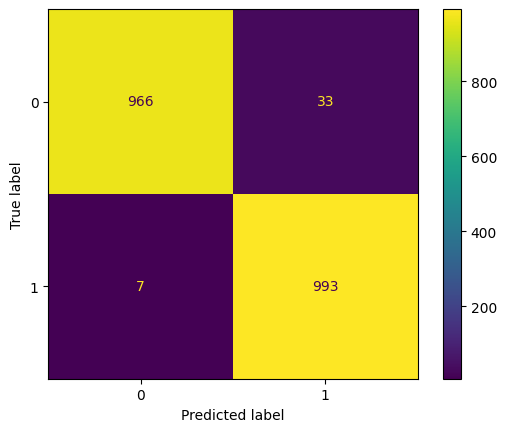

In [294]:
# Confusion matrix clean display
log_y2_cm_all = confusion_matrix(y2_test, y2_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=log_y2_cm_all)
disp.plot(values_format='d')

In [295]:
# Drop from UCI dataset, columns used for training
filtered_new_df = New_CSV_File_original[~New_CSV_File_original['URL'].isin(df['URL'])]

# split data for testing into seperate DF's
X_new = filtered_new_df.drop(columns=['label'])
y_new = filtered_new_df['label']

# Make predictions on 200k URL dataset from UCI
y2_new_pred_log = log_pipeline.predict(X_new)

In [296]:
# Confusion matrix and classification report
print(confusion_matrix(y_new, y2_new_pred_log))
print(classification_report(y_new, y2_new_pred_log))

[[ 98420      1]
 [132217     74]]
              precision    recall  f1-score   support

           0       0.43      1.00      0.60     98421
           1       0.99      0.00      0.00    132291

    accuracy                           0.43    230712
   macro avg       0.71      0.50      0.30    230712
weighted avg       0.75      0.43      0.26    230712



## XGBoost

In [297]:
# using XGBoost Classifier and no PCA
xgb2_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', XGBClassifier(random_state=42))
])

xgb2_pipeline.fit(X2_train, y2_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [87]:
y2_pred_xgb = xgb2_pipeline.predict(X2_test)

In [88]:
# Confusion matrix and classification report
print(confusion_matrix(y2_test, y2_pred_xgb))
print(classification_report(y2_test, y2_pred_xgb))

[[985  14]
 [  4 996]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       999
           1       0.99      1.00      0.99      1000

    accuracy                           0.99      1999
   macro avg       0.99      0.99      0.99      1999
weighted avg       0.99      0.99      0.99      1999



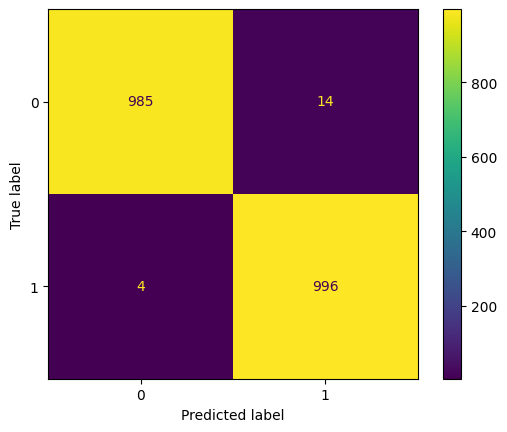

In [89]:
# Confusion matrix clean display
xgb_y2_cm_all = confusion_matrix(y2_test, y2_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_y2_cm_all)
disp.plot(values_format='d')

In [90]:
# Make predictions on 200k URL dataset from UCI
y2_new_pred = xgb2_pipeline.predict(X_new)

In [91]:
# Confusion matrix and classification report
print(confusion_matrix(y_new, y2_new_pred))
print(classification_report(y_new, y2_new_pred))

[[ 98159    262]
 [    30 132261]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98421
           1       1.00      1.00      1.00    132291

    accuracy                           1.00    230712
   macro avg       1.00      1.00      1.00    230712
weighted avg       1.00      1.00      1.00    230712



## Random Forest

In [92]:
# using Random Forest Classifier and no PCA
rf2_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', RandomForestClassifier(random_state=42))
])

rf2_pipeline.fit(X2_train, y2_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function squeeze_column at 0xff9a894b3c40>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [93]:
y2_pred_rf = rf2_pipeline.predict(X2_test)

In [94]:
# Confusion matrix and classification report
print(confusion_matrix(y2_test, y2_pred_rf))
print(classification_report(y2_test, y2_pred_rf))

[[985  14]
 [  4 996]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       999
           1       0.99      1.00      0.99      1000

    accuracy                           0.99      1999
   macro avg       0.99      0.99      0.99      1999
weighted avg       0.99      0.99      0.99      1999



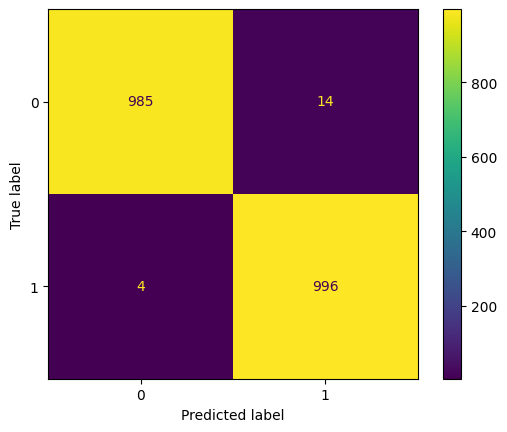

In [95]:
# Confusion matrix clean display
rf_y2_cm_all = confusion_matrix(y2_test, y2_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_y2_cm_all)
disp.plot(values_format='d')

In [96]:
# Make predictions on 200k URL dataset from UCI
y2_new_pred_rf = rf2_pipeline.predict(X_new)

In [97]:
# Confusion matrix and classification report
print(confusion_matrix(y_new, y2_new_pred_rf))
print(classification_report(y_new, y2_new_pred_rf))

[[ 98160    261]
 [    33 132258]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98421
           1       1.00      1.00      1.00    132291

    accuracy                           1.00    230712
   macro avg       1.00      1.00      1.00    230712
weighted avg       1.00      1.00      1.00    230712



## KNN

In [98]:
knn2_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

knn2_pipeline.fit(X2_train, y2_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function squeeze_column at 0xff9a894b3c40>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', KNeighborsClassifier())])

In [99]:
# Predictions
y2_pred_knn = knn2_pipeline.predict(X2_test)

In [100]:
# Confusion matrix and classification report
print(confusion_matrix(y2_test, y2_pred_knn))
print(classification_report(y2_test, y2_pred_knn))

[[953  46]
 [ 14 986]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       999
           1       0.96      0.99      0.97      1000

    accuracy                           0.97      1999
   macro avg       0.97      0.97      0.97      1999
weighted avg       0.97      0.97      0.97      1999



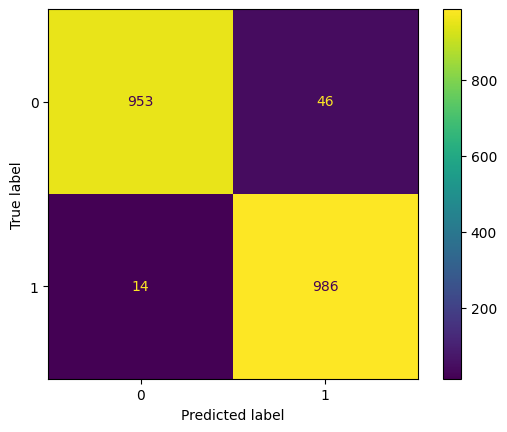

In [101]:
# Confusion matrix clean display
knn_y2_cm_all = confusion_matrix(y2_test, y2_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_y2_cm_all)
disp.plot(values_format='d')

In [102]:
# Make predictions on 200k URL dataset from UCI
y2_new_pred_knn = knn2_pipeline.predict(X_new)

In [103]:
# Confusion matrix and classification report
print(confusion_matrix(y_new, y2_new_pred_knn))
print(classification_report(y_new, y2_new_pred_knn))

[[87054 11367]
 [62656 69635]]
              precision    recall  f1-score   support

           0       0.58      0.88      0.70     98421
           1       0.86      0.53      0.65    132291

    accuracy                           0.68    230712
   macro avg       0.72      0.71      0.68    230712
weighted avg       0.74      0.68      0.67    230712



## Neural Network

In [104]:
# Modeling with a neural network - transforming X_train columns
X2_train_transformed = preprocessor_all.fit_transform(X2_train)
X2_test_transformed = preprocessor_all.transform(X2_test)

X2_train_transformed.shape, X2_test_transformed.shape, y2_train.shape

((7995, 839), (1999, 839), (7995,))

In [105]:
# convert to array
if scipy.sparse.issparse(X2_train_transformed):
    X2_train_transformed = X2_train_transformed.toarray()
    X2_test_transformed = X2_test_transformed.toarray()

In [106]:
# Create dense multi layered model
model2 = Sequential()
model2.add(Dense(128, activation='relu', input_dim=X2_train_transformed.shape[1]))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [107]:
# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
model2.fit(
    X2_train_transformed, y2_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8558 - loss: 0.3315 - val_accuracy: 0.9850 - val_loss: 0.0598
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9784 - loss: 0.0596 - val_accuracy: 0.9837 - val_loss: 0.0529
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9855 - loss: 0.0457 - val_accuracy: 0.9875 - val_loss: 0.0437
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9894 - loss: 0.0332 - val_accuracy: 0.9887 - val_loss: 0.0407
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9875 - loss: 0.0349 - val_accuracy: 0.9900 - val_loss: 0.0375
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9906 - loss: 0.0263 - val_accuracy: 0.9912 - val_loss: 0.0374
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9906 - loss: 0.0270 - val_accuracy: 0.9887 - val_loss: 0.0393
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9906 - loss: 0.0256 - val_accuracy: 0.

In [108]:
# Predict probabilities
y2_pred_NN_prob = model2.predict(X2_test_transformed)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [109]:
y2_pred_NN = (y2_pred_NN_prob > 0.5).astype(int)

In [110]:
# Confusion matrix, classification report, roc auc - all not good
print(confusion_matrix(y2_test, y2_pred_NN))
print(classification_report(y2_test, y2_pred_NN))
print("ROC AUC:", roc_auc_score(y2_test, y2_pred_NN_prob))


[[976  23]
 [  5 995]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       999
           1       0.98      0.99      0.99      1000

    accuracy                           0.99      1999
   macro avg       0.99      0.99      0.99      1999
weighted avg       0.99      0.99      0.99      1999

ROC AUC: 0.9982207207207208


In [111]:
X_new_transformed = preprocessor_all.transform(X_new)
y2_new_pred_NN_prob = model2.predict(X_new_transformed)

7210/7210 ━━━━━━━━━━━━━━━━━━━━ 6s 883us/step


In [112]:
y2_new_pred_NN = (y2_new_pred_NN_prob > 0.5).astype(int)

## Comparing metrics for XGBoost and Random Forest and Neural Networks

In [113]:
xgb_accuracy = accuracy_score(y_new, y2_new_pred) 
xgb_precision = precision_score(y_new, y2_new_pred, pos_label=0) 
xgb_recall = recall_score(y_new, y2_new_pred, pos_label=0) 
xgb_f1 = f1_score(y_new, y2_new_pred, pos_label=0) 
xgb_roc_auc = roc_auc_score(y_new, y2_new_pred) 

print(f"XGB Accuracy: {xgb_accuracy}")
print(f"XGB Precision: {xgb_precision}")
print(f"XGB Recall: {xgb_recall}")
print(f"XGB f1-score: {xgb_f1}")
print(f"XGB ROC AUC: {xgb_roc_auc}")

XGB Accuracy: 0.9987343527861576
XGB Precision: 0.9996944667936327
XGB Recall: 0.9973379664908911
XGB f1-score: 0.9985148263058847
XGB ROC AUC: 0.9985555968472778


In [114]:
rf_accuracy = accuracy_score(y_new, y2_new_pred_rf) 
rf_precision = precision_score(y_new, y2_new_pred_rf, pos_label=0) 
rf_recall = recall_score(y_new, y2_new_pred_rf, pos_label=0) 
rf_f1 = f1_score(y_new, y2_new_pred_rf, pos_label=0) 
rf_roc_auc = roc_auc_score(y_new, y2_new_pred_rf) 

print(f"RF Accuracy: {rf_accuracy}")
print(f"RF Precision: {rf_precision}")
print(f"RF Recall: {rf_recall}")
print(f"RF f1-score: {rf_f1}")
print(f"RF ROC AUC: {rf_roc_auc}")

RF Accuracy: 0.9987256839696245
RF Precision: 0.9996639271638508
RF Recall: 0.997348126924132
RF f1-score: 0.9985046843052885
RF ROC AUC: 0.9985493384240814


In [115]:
NN_accuracy = accuracy_score(y_new, y2_new_pred_NN) 
NN_precision = precision_score(y_new, y2_new_pred_NN, pos_label=0) 
NN_recall = recall_score(y_new, y2_new_pred_NN, pos_label=0) 
NN_f1 = f1_score(y_new, y2_new_pred_NN, pos_label=0) 
NN_roc_auc = roc_auc_score(y_new, y2_new_pred_NN) 

print(f"NN Accuracy: {NN_accuracy}")
print(f"NN Precision: {NN_precision}")
print(f"NN Recall: {NN_recall}")
print(f"NN f1-score: {NN_f1}")
print(f"NN ROC AUC: {NN_roc_auc}")

NN Accuracy: 0.42664014008807516
NN Precision: 0.4266152872536866
NN Recall: 1.0
NN f1-score: 0.5980803529379594
NN ROC AUC: 0.5000377954660559


## Random Forest worked the best - Grid Search for HyperParameters

In [116]:
gridsearch_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=gridsearch_pipeline, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=2)
grid_search.fit(X2_train, y2_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['URLLength',
                                                                          'DomainLength',
                                                                          'URLSimilarityIndex',
                                                                          'TLDLength',
                                                                          'NoOfSubDomain',
                                                                          'NoOfObfuscatedChar',
                                                                          'ObfuscationRatio',
                                                                          'NoOfLettersInURL',
                                                                          'LetterRatioInURL',
                                                                          'NoOfDegitsIn...
                                                                                          FunctionTransformer(func=<function squeeze_column at 0xff9a894b3c40>)),
                                                                                         ('tfidf',
                                                                                          TfidfVectorizer(max_features=500))]),
                                                                         ['Title'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='precision', verbose=2)

In [117]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best score: 0.9844092546383715


In [118]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



## Random Search

In [119]:
pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', RandomForestClassifier(random_state=42))
])

In [120]:
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': [None] + list(range(5, 30, 5)),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=30, cv=5, scoring='precision', random_state=42, n_jobs=-1, verbose=2)

random_search.fit(X2_train, y2_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['URLLength',
                                                                                'DomainLength',
                                                                                'URLSimilarityIndex',
                                                                                'TLDLength',
                                                                                'NoOfSubDomain',
                                                                                'NoOfObfuscatedChar',
                                                                                'ObfuscationRatio',
                                                                                'NoOfLettersInURL',
                                                                                'LetterRatioInURL',
                                                                                'NoOfDe...
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xff9a9fabb510>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xff9a95912c10>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xff9a95912590>},
                   random_state=42, scoring='precision', verbose=2)

In [121]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'model__max_depth': 25, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__n_estimators': 317}
Best score: 0.9819452157034556


## Grid Search

In [122]:
param_grid = {
    'model__n_estimators': [300, 317, 340],       # Around 317
    'model__max_depth': [20, 25, 30],             # Around 25
    'model__min_samples_split': [5, 6, 7],        # Around 6
    'model__min_samples_leaf': [1, 2],            # Just above 1
    'model__max_features': [None]                 # Keep fixed (no variation)
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='precision',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X2_train, y2_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['URLLength',
                                                                          'DomainLength',
                                                                          'URLSimilarityIndex',
                                                                          'TLDLength',
                                                                          'NoOfSubDomain',
                                                                          'NoOfObfuscatedChar',
                                                                          'ObfuscationRatio',
                                                                          'NoOfLettersInURL',
                                                                          'LetterRatioInURL',
                                                                          'NoOfDegitsIn...
                                                                                          FunctionTransformer(func=<function squeeze_column at 0xff9a894b3c40>)),
                                                                                         ('tfidf',
                                                                                          TfidfVectorizer(max_features=500))]),
                                                                         ['Title'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [20, 25, 30],
                         'model__max_features': [None],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [5, 6, 7],
                         'model__n_estimators': [300, 317, 340]},
             scoring='precision', verbose=2)

In [123]:
print("Best parameters:", grid_search.best_params_)
print("Best precision score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Phishing', 'Legitimate']))

Best parameters: {'model__max_depth': 20, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 7, 'model__n_estimators': 300}
Best precision score: 0.9821953021190092
              precision    recall  f1-score   support

    Phishing       1.00      1.00      1.00     20189
  Legitimate       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



In [486]:
best_pred = best_model.predict(X_new)

model_results = X_new.copy()
model_results['label'] = y_new
model_results['prediction'] = best_pred

model_results.to_csv("Model_testing_results.csv", index=False)

In [125]:
print(classification_report(y_new, best_pred, target_names=['Phishing', 'Legitimate']))

              precision    recall  f1-score   support

    Phishing       1.00      0.99      1.00     98421
  Legitimate       1.00      1.00      1.00    132291

    accuracy                           1.00    230712
   macro avg       1.00      1.00      1.00    230712
weighted avg       1.00      1.00      1.00    230712



In [126]:
print("ROC AUC:", roc_auc_score(y_new, best_pred))

ROC AUC: 0.9961182751082365


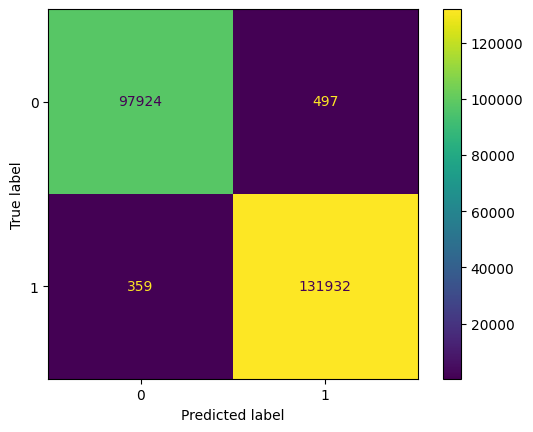

In [127]:
# Confusion matrix clean display
best_cm = confusion_matrix(y_new, best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm)
disp.plot(values_format='d')

In [464]:
best_tn, best_fp, best_fn, best_tp = confusion_matrix(y_new, best_pred).ravel()

best_cm_df = pd.DataFrame([{
    'Name': "RandomForest",
    'True Negative (TN)': best_tn,
    'False Positive (FP)': best_fp,
    'False Negative (FN)': best_fn,
    'True Positive (TP)': best_tp
}])


In [128]:
# Metric calculations
print(f"Accuracy Score: {accuracy_score(y_new, best_pred)}")
print(f"Precision Score: {precision_score(y_new, best_pred)}")
print(f"Recall Score: {recall_score(y_new, best_pred)}")
print(f"F1-Score: {f1_score(y_new, best_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_new, best_pred)}")

Accuracy Score: 0.9962897465238045
Precision Score: 0.9962470455866917
Recall Score: 0.997286285537187
F1-Score: 0.9967663946811726
ROC AUC Score: 0.9961182751082365


In [475]:
best_metrics_df = pd.DataFrame([{
    'Name': "RandomForest",
    'Accuracy': accuracy_score(y_new, best_pred),
    'Precision': precision_score(y_new, best_pred),
    'Recall': recall_score(y_new, best_pred),
    'F1': f1_score(y_new, best_pred),
    'ROC AUC': roc_auc_score(y_new, best_pred)
}])
               

In [129]:
# Get best model and preprocessor for feature importance extraction
model = best_model.named_steps['model']
preprocessor = best_model.named_steps['prep']

# Category and text features
cat_features = preprocessor.named_transformers_['cat'].named_steps['encode'].get_feature_names_out(['TLD'])
text_features = preprocessor.named_transformers_['text'].named_steps['tfidf'].get_feature_names_out()

# Combine
feature_names = (
    preprocessor.transformers_[0][2] +  # numerical columns
    preprocessor.transformers_[1][2] +  # boolean columns
    cat_features.tolist() +
    text_features.tolist()
)

In [130]:
# Get the importance
importances = model.feature_importances_

In [131]:
# Combine importance with features
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [132]:
print(feature_importance.head(10))
#print(feature_importance.tail(20))

                       Feature  Importance
29                     IsHTTPS    0.551047
22                 NoOfSelfRef    0.109882
6             ObfuscationRatio    0.107856
5           NoOfObfuscatedChar    0.065494
4                NoOfSubDomain    0.036312
14  NoOfOtherSpecialCharsInURL    0.033341
15       SpacialCharRatioInURL    0.014420
24             NoOfExternalRef    0.013081
16                  LineOfCode    0.011145
2           URLSimilarityIndex    0.007061


In [482]:
feature_importance.to_csv('Feature_Importance.csv', index=False)

## Pickeling

In [133]:
with open('RF_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## Baseline Heuristic Implementation

In [470]:
# Basic calculations for phishing URL's
def heuristic_phishing(url):
    # If URL length is bigger than 75 characters = phishing
    if len(url) > 75:
        return 0  # phishing
    #If it contains an @ sign = phishing
    if '@' in url:
        return 0
    # if more than 3 . = phishing
    if url.count('.') > 3:
        return 0
    # If the TLD ends with any of the three below = phishing
    suspicious_tlds = ['.xyz', '.top', '.club']
    if any(url.endswith(tld) for tld in suspicious_tlds):
        return 0
    # checks for IP address after HTTP[s] = phishing
    if re.match(r'http[s]?://(\d{1,3}\.){3}\d{1,3}', url):
        return 0
    return 1  # legitimate

In [471]:
# Copy original DF of tested URL's
heuristic_df = filtered_new_df.copy()

In [483]:
# Claculate heuristic results
heuristic_df['prediction'] = heuristic_df['URL'].apply(heuristic_phishing)

heuristic_df.to_csv("Heuristic_results.csv", index=False)

Heuristic Accuracy: 0.6448515898609521
Heuristic Precision: 0.6194967060923053
Heuristic Recall: 0.9866355232026366
Heuristic F1-Score: 0.7611047777878204
Heuristic ROC AUC Score: 0.5860418753575288


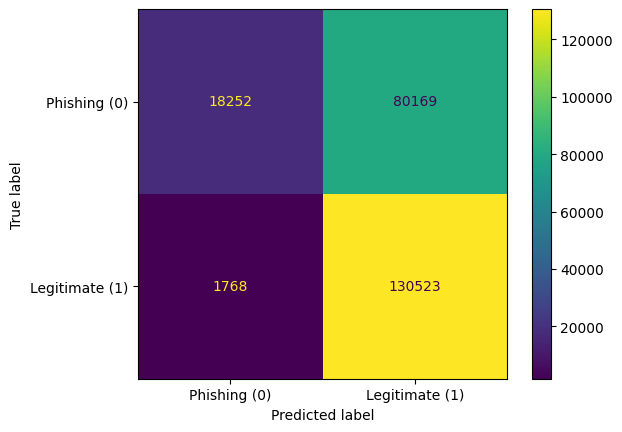

In [137]:
# Comparison metrics
h_true = heuristic_df['label']
h_pred = heuristic_df['heuristic_pred']

print("Heuristic Accuracy:", accuracy_score(h_true, h_pred))
print("Heuristic Precision:", precision_score(h_true, h_pred))
print("Heuristic Recall:", recall_score(h_true, h_pred)) #Recall is good since most are getting predicted as legitimate
print("Heuristic F1-Score:", f1_score(h_true, h_pred))
print("Heuristic ROC AUC Score:", roc_auc_score(h_true, h_pred))

# Confusion matrix
h_cm = confusion_matrix(h_true, h_pred)
h_disp = ConfusionMatrixDisplay(confusion_matrix=h_cm, display_labels=['Phishing (0)', 'Legitimate (1)'])
h_disp.plot(values_format='d')

In [476]:
h_metrics_df = pd.DataFrame([{
    'Name': "Heuristic",
    'Accuracy': accuracy_score(h_true, h_pred),
    'Precision': precision_score(h_true, h_pred),
    'Recall': recall_score(h_true, h_pred),
    'F1': f1_score(h_true, h_pred),
    'ROC AUC': roc_auc_score(h_true, h_pred)
}])
         

In [480]:
metric_df = pd.concat([best_metrics_df, h_metrics_df], ignore_index=True)

metric_df.to_csv("Metrics_Results.csv")

In [463]:
# Convert CM to a dataframe
h_tn, h_fp, h_fn, h_tp = confusion_matrix(h_true, h_pred).ravel()
h_cm_df = pd.DataFrame([{
    'Name': "Heuristic",
    'True Negative (TN)': h_tn,
    'False Positive (FP)': h_fp,
    'False Negative (FN)': h_fn,
    'True Positive (TP)': h_tp
}])


In [468]:
cm_df = pd.concat([h_cm_df, best_cm_df], ignore_index=True)

cm_df.to_csv("Confusion_Matrix_Results.csv", index=False)

## Creating Function for Testing

In [432]:

def predict_phishing(url, model=best_model):
    islist = True
    if isinstance(url, str):
        islist = False
        urls = ["https://dk;afkjf;ajfd;.com/"]
        urls.append(url)
    else:
        urls = url

    url_dataset = []
    for link in urls:
        extractor = PhishingFeatureExtractor(link)
        features = extractor.to_dict()
        features['URL'] = link
        url_dataset.append(features)

    # Convert list of dicts to DataFrame
    df_features = pd.DataFrame(url_dataset)

    # Predict on the whole batch
    predictions = model.predict(df_features)
    probabilities = model.predict_proba(df_features)

    # Create mapping for predictions
    label_map = {0: "Phishing", 1: "Legitimate"}
    
    # Add predictions and probabilities to the DataFrame
    result_df = pd.DataFrame({
        'URL': df_features['URL'],
        'prediction': predictions,
        'probability': probabilities.max(axis=1)
    })

    #Remove Dummy from list if single URL
    if not islist:
        result_df = result_df.iloc[1:].reset_index(drop=True)

    # Map predictions
    result_df['prediction'] = result_df['prediction'].map(label_map)
    
    return result_df


In [436]:
url_list = ['https://www.google.com', 'https://www.yahoo.com']

result = predict_phishing('https://www.google.com')
result2 = predict_phishing(url_list)

Request failed: HTTPSConnectionPool(host='dk;afkjf;ajfd;.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a7c09b2d0>: Failed to resolve 'dk;afkjf;ajfd;.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='dk;afkjf;ajfd;.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a7bef9810>: Failed to resolve 'dk;afkjf;ajfd;.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://dk;afkjf;ajfd;.com/: HTTPSConnectionPool(host='dk;afkjf;ajfd;.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a7bee1e10>: Failed to resolve 'dk;afkjf;ajfd;.com' ([Errno -2] Name or service not known)"))


In [437]:
print(result)

                      URL  prediction  probability
0  https://www.google.com  Legitimate          1.0


In [438]:
print(result2)

                      URL  prediction  probability
0  https://www.google.com  Legitimate      1.00000
1   https://www.yahoo.com  Legitimate      0.99915


## Conclusion

## Conclusion - Testing update

In [452]:
df = pd.read_csv("10k_URL_Training.csv")
full_df = pd.read_csv("url_dataset.csv")

In [454]:
unseen_urls_df = full_df[~full_df['url'].isin(df['URL'])]

In [455]:
len(unseen_urls_df)

445178

In [495]:
testing_url_df = unseen_urls_df.groupby('type', group_keys=False).sample(n=2000, random_state=42)

testing_url_df.rename(columns={'type': 'label'}, inplace=True)

testing_url_df['label'] = testing_url_df['label'].map({'legitimate': 1, 'phishing': 0})

In [496]:
testing_url_df.head()

url  label
303287      https://www.thefreedictionary.com/rangefinder      1
66092   https://www.lesterslegends.com/cooperstown-chr...      1
134588  https://www.amazon.com/Layne-Staley-Angry-Adri...      1
75297                 https://www.mp3bear.com/?q=en+vogue      1
295860            https://www.spokeo.com/Ronald+Macdonald      1

In [491]:
import pickle

with open('RF_pipeline.pkl', 'rb') as file:
    load_model = pickle.load(file)


## Do Not Run Cell Below - Just Load in more_testing_data.csv file
## Takes about 2.5 hours to run

In [498]:
#Get features from phishing features class
testing_features_list = []

for _, row in tqdm(testing_url_df.iterrows(), desc="Getting Phishing Features"):
    try:
        extractor = PhishingFeatureExtractor(row['url'])
        features = extractor.to_dict()
        features['label'] = row['label']
        features['URL'] = row['url']
        testing_features_list.append(features)

    except Exception as e:
        print("Skipped due to parsing error")
        continue

testing_df = pd.DataFrame(testing_features_list)

Getting Phishing Features: 2it [00:00,  2.51it/s]

Request failed: HTTPSConnectionPool(host='www.lesterslegends.com', port=443): Max retries exceeded with url: /cooperstown-chronicles-ernie-lombardi/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.lesterslegends.com', port=443): Max retries exceeded with url: /cooperstown-chronicles-ernie-lombardi/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.lesterslegends.com/cooperstown-chronicles-ernie-lombardi/: HTTPSConnectionPool(host='www.lesterslegends.com', port=443): Max retries exceeded with url: /cooperstown-chronicles-ernie-lombardi/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get lo

Getting Phishing Features: 6it [00:03,  1.91it/s]

Request failed: HTTPSConnectionPool(host='www.eppersonfamilyof5.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.eppersonfamilyof5.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.eppersonfamilyof5.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.eppersonfamilyof5.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.eppersonfamilyof5.blogspot.com/: HTTPSConnectionPool(host='www.eppersonfamilyof5.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certifi

Getting Phishing Features: 8it [00:03,  2.55it/s]

Request failed: HTTPSConnectionPool(host='www.thewizsdailydose.blogspot.com', port=443): Max retries exceeded with url: /2011/08/elease-donovan-featured-in-king.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thewizsdailydose.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.thewizsdailydose.blogspot.com', port=443): Max retries exceeded with url: /2011/08/elease-donovan-featured-in-king.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.thewizsdailydose.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.thewizsdailydose.blogspot.com/2011/08/elease-donovan-featured-in-king.html: HTTPSConnectionPool(host='www.thewizsdailydose.blogspot.com', port=443): Max retries exceeded with url: /2011/08/el

Getting Phishing Features: 18it [00:17,  1.03it/s]

Request failed: HTTPSConnectionPool(host='www.ruedelamour.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99e41e4910>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.ruedelamour.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996aada290>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 20it [00:24,  2.03s/it]

Error checking self redirects for https://www.ruedelamour.com/: HTTPSConnectionPool(host='www.ruedelamour.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996ba5da50>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 22it [00:25,  1.24s/it]

Request failed: HTTPSConnectionPool(host='www.onlineradio2.com', port=443): Max retries exceeded with url: /listen/Radio_Baldwin_County_1310 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b54ac50>: Failed to resolve 'www.onlineradio2.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.onlineradio2.com', port=443): Max retries exceeded with url: /listen/Radio_Baldwin_County_1310 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b54b190>: Failed to resolve 'www.onlineradio2.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.onlineradio2.com/listen/Radio_Baldwin_County_1310: HTTPSConnectionPool(host='www.onlineradio2.com', port=443): Max retries exceeded with url: /listen/Radio_Baldwin_County_1310 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b549c10>: Failed to resolve 'www.onlineradio2.co

Getting Phishing Features: 25it [00:27,  1.18it/s]

Request failed: HTTPSConnectionPool(host='www.ks.asklocalpages.com', port=443): Max retries exceeded with url: /C-12.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ks.asklocalpages.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.ks.asklocalpages.com', port=443): Max retries exceeded with url: /C-12.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ks.asklocalpages.com'. (_ssl.c:1006)")))


Getting Phishing Features: 26it [00:29,  1.19s/it]

Error checking self redirects for https://www.ks.asklocalpages.com/C-12.php: HTTPSConnectionPool(host='www.ks.asklocalpages.com', port=443): Max retries exceeded with url: /C-12.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ks.asklocalpages.com'. (_ssl.c:1006)")))


Getting Phishing Features: 29it [00:36,  1.64s/it]

Request failed: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /therese-martin/37684-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996932ee10>: Failed to resolve 'www.ca.ratemyteachers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /therese-martin/37684-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692d9a50>: Failed to resolve 'www.ca.ratemyteachers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.ratemyteachers.com/therese-martin/37684-s: HTTPSConnectionPool(host='www.ca.ratemyteachers.com', port=443): Max retries exceeded with url: /therese-martin/37684-s (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996932bb50>: Failed to resolve 'www.ca.ratemyteachers.com' ([

Getting Phishing Features: 32it [00:39,  1.11s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Ebullition (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996928d090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Ebullition (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692ecb50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Ebullition: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Ebullition (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692ee050>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSCo

Getting Phishing Features: 33it [00:39,  1.11it/s]

Redirect check failed: HTTPSConnectionPool(host='www.witnessthethickness.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.witnessthethickness.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.witnessthethickness.blogspot.com/: HTTPSConnectionPool(host='www.witnessthethickness.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.witnessthethickness.blogspot.com'. (_ssl.c:1006)")))


Getting Phishing Features: 34it [00:39,  1.37it/s]

Request failed: HTTPSConnectionPool(host='www.homepilatesmachine.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.homepilatesmachine.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.homepilatesmachine.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.homepilatesmachine.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.homepilatesmachine.blogspot.com/: HTTPSConnectionPool(host='www.homepilatesmachine.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, c

Getting Phishing Features: 35it [00:40,  1.53it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_Professional_Soccer_League (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996928d190>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_Professional_Soccer_League (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad54810>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/American_Professional_Soccer_League: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_Professional_Soccer_League (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692ed7d0>: Failed

Getting Phishing Features: 40it [00:42,  2.14it/s]

Request failed: HTTPSConnectionPool(host='www.northdakotahighschoolfootballhuddle.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.northdakotahighschoolfootballhuddle.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.northdakotahighschoolfootballhuddle.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.northdakotahighschoolfootballhuddle.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.northdakotahighschoolfootballhuddle.blogspot.com/: HTTPSConnectionPool(host='www.northdakotahighschoolfootballhuddle.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCert

Getting Phishing Features: 44it [00:45,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.roost.com', port=443): Max retries exceeded with url: /real-estate/street/MO/Kansas-City/Emanuel-Cleaver-II-Blvd.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b8eff50>, 'Connection to www.roost.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.roost.com', port=443): Max retries exceeded with url: /real-estate/street/MO/Kansas-City/Emanuel-Cleaver-II-Blvd.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ac93190>, 'Connection to www.roost.com timed out. (connect timeout=5)'))


Getting Phishing Features: 45it [00:59,  4.64s/it]

Error checking self redirects for https://www.roost.com/real-estate/street/MO/Kansas-City/Emanuel-Cleaver-II-Blvd.html: HTTPSConnectionPool(host='www.roost.com', port=443): Max retries exceeded with url: /real-estate/street/MO/Kansas-City/Emanuel-Cleaver-II-Blvd.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ac6ccd0>, 'Connection to www.roost.com timed out. (connect timeout=5)'))


Getting Phishing Features: 47it [01:01,  2.80s/it]

Request failed: HTTPSConnectionPool(host='www.laptopmotherboardrepair.org.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bd2de10>: Failed to resolve 'www.laptopmotherboardrepair.org.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.laptopmotherboardrepair.org.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ac93a10>: Failed to resolve 'www.laptopmotherboardrepair.org.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.laptopmotherboardrepair.org.uk/: HTTPSConnectionPool(host='www.laptopmotherboardrepair.org.uk', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ac91d50>: Failed to resolve 'www.laptopmotherboardrepair.org.uk' ([Errno -2] Name or service

Getting Phishing Features: 51it [01:03,  1.09s/it]

Request failed: HTTPSConnectionPool(host='www.roger.new-age-spirituality.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ac90e50>: Failed to resolve 'www.roger.new-age-spirituality.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.roger.new-age-spirituality.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aca2990>: Failed to resolve 'www.roger.new-age-spirituality.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.roger.new-age-spirituality.com/: HTTPSConnectionPool(host='www.roger.new-age-spirituality.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ac6da50>: Failed to resolve 'www.roger.new-age-spirituality.com' ([Errno -2] Name or service

Getting Phishing Features: 53it [01:05,  1.04s/it]

Request failed: HTTPSConnectionPool(host='www.kentuckycities.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kentuckycities.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.kentuckycities.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kentuckycities.com'. (_ssl.c:1006)")))


Getting Phishing Features: 54it [01:05,  1.13it/s]

Error checking self redirects for https://www.kentuckycities.com/: HTTPSConnectionPool(host='www.kentuckycities.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kentuckycities.com'. (_ssl.c:1006)")))


Getting Phishing Features: 55it [01:15,  3.56s/it]

Request failed: HTTPSConnectionPool(host='www.judgepedia.org', port=443): Max retries exceeded with url: /index.php/Frank_Hull (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996e9cdad0>, 'Connection to www.judgepedia.org timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.judgepedia.org', port=443): Max retries exceeded with url: /index.php/Frank_Hull (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ac86b50>, 'Connection to www.judgepedia.org timed out. (connect timeout=5)'))


Getting Phishing Features: 56it [01:30,  6.73s/it]

Error checking self redirects for https://www.judgepedia.org/index.php/Frank_Hull: HTTPSConnectionPool(host='www.judgepedia.org', port=443): Max retries exceeded with url: /index.php/Frank_Hull (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996acaff10>, 'Connection to www.judgepedia.org timed out. (connect timeout=5)'))


Getting Phishing Features: 60it [01:35,  2.60s/it]

Request failed: HTTPSConnectionPool(host='www.showcase.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.showcase.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 61it [01:49,  6.06s/it]

Error checking self redirects for https://www.showcase.com/Oakland/Oakland-Port-Jack-London__Commercial-Real-Estate: HTTPSConnectionPool(host='www.showcase.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 62it [01:50,  4.58s/it]

Request failed: HTTPSConnectionPool(host='www.gs-lacrosse.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a22e490>: Failed to resolve 'www.gs-lacrosse.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gs-lacrosse.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a22ecd0>: Failed to resolve 'www.gs-lacrosse.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gs-lacrosse.com/: HTTPSConnectionPool(host='www.gs-lacrosse.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a16be10>: Failed to resolve 'www.gs-lacrosse.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 65it [01:51,  1.99s/it]

Request failed: HTTPSConnectionPool(host='www.sharkdivers.blogspot.com', port=443): Max retries exceeded with url: /2011/03/requin-blanc-carnet-de-voyage-de.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sharkdivers.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.sharkdivers.blogspot.com', port=443): Max retries exceeded with url: /2011/03/requin-blanc-carnet-de-voyage-de.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sharkdivers.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.sharkdivers.blogspot.com/2011/03/requin-blanc-carnet-de-voyage-de.html: HTTPSConnectionPool(host='www.sharkdivers.blogspot.com', port=443): Max retries exceeded with url: /2011/03/requin-blanc-carnet-de-voyage

Getting Phishing Features: 68it [01:51,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.fuckyeahrobertoluongo.tumblr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fuckyeahrobertoluongo.tumblr.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.fuckyeahrobertoluongo.tumblr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fuckyeahrobertoluongo.tumblr.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.fuckyeahrobertoluongo.tumblr.com/: HTTPSConnectionPool(host='www.fuckyeahrobertoluongo.tumblr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname misma

Getting Phishing Features: 69it [01:51,  1.29it/s]

Error checking self redirects for https://www.bodysnatched.tumblr.com/: HTTPSConnectionPool(host='www.bodysnatched.tumblr.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bodysnatched.tumblr.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.michelshaneblog.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1680d0>: Failed to resolve 'www.michelshaneblog.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.michelshaneblog.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a169990>: Failed to resolve 'www.michelshaneblog.com' ([Errno -2] Name or service not known)"))
Error checking self redirects

Getting Phishing Features: 72it [01:52,  2.38it/s]

Redirect check failed: HTTPSConnectionPool(host='www.lawyers.law.cornell.edu', port=443): Max retries exceeded with url: /lawyer/robert-f-harmon-jr-1477660 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lawyers.law.cornell.edu'. (_ssl.c:1006)")))
Error checking self redirects for https://www.lawyers.law.cornell.edu/lawyer/robert-f-harmon-jr-1477660: HTTPSConnectionPool(host='www.lawyers.law.cornell.edu', port=443): Max retries exceeded with url: /lawyer/robert-f-harmon-jr-1477660 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lawyers.law.cornell.edu'. (_ssl.c:1006)")))


Getting Phishing Features: 77it [01:58,  1.22it/s]

Request failed: HTTPSConnectionPool(host='www.vertor.com', port=443): Max retries exceeded with url: /torrents/117148/Macy-Gray-The-Very-Best-Of-Macy-Gray (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.vertor.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.vertor.com', port=443): Max retries exceeded with url: /torrents/117148/Macy-Gray-The-Very-Best-Of-Macy-Gray (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.vertor.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.vertor.com/torrents/117148/Macy-Gray-The-Very-Best-Of-Macy-Gray: HTTPSConnectionPool(host='www.vertor.com', port=443): Max retries exceeded with url: /torrents/117148/Macy-Gray-The-Very-Best-Of-Macy-Gray (Caused by SSLError(SSLCertVerificationError(1,

Getting Phishing Features: 78it [01:59,  1.19it/s]

Error checking self redirects for https://www.huntershill-levesinet.org.au/: HTTPSConnectionPool(host='www.huntershill-levesinet.org.au', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.usidentify.com', port=443): Max retries exceeded with url: /l/hoernemann (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996acaf610>: Failed to resolve 'www.usidentify.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.usidentify.com', port=443): Max retries exceeded with url: /l/hoernemann (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996acbd410>: Failed to resolve 'www.usidentify.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.usidentify.com/l/hoernemann: HTTPSConnectionPool(host='www.usidentify.com',

Getting Phishing Features: 83it [02:08,  1.28s/it]

Request failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~robertfamilies/QcSteGenevieveBaptisms.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1b7e90>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~robertfamilies/QcSteGenevieveBaptisms.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a211b90>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.freepages.genealogy.rootsweb.ancestry.com/~robertfamilies/QcSteGenevieveBaptisms.html: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exc

Getting Phishing Features: 88it [02:11,  1.57it/s]

Request failed: HTTPSConnectionPool(host='www.uncg.academia.edu', port=443): Max retries exceeded with url: /BruceKirchoff/Papers/545121/Image_Quiz_Using_principles_of_cognitive_psychology_to_teach_visual_expertise (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uncg.academia.edu'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.uncg.academia.edu', port=443): Max retries exceeded with url: /BruceKirchoff/Papers/545121/Image_Quiz_Using_principles_of_cognitive_psychology_to_teach_visual_expertise (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uncg.academia.edu'. (_ssl.c:1006)")))
Error checking self redirects for https://www.uncg.academia.edu/BruceKirchoff/Papers/545121/Image_Quiz_Using_principles_of_cognitive_psychology_to_teach_visual_exp

Getting Phishing Features: 90it [02:15,  1.59s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/The_Other_Boleyn_Girl_(film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969a06750>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/The_Other_Boleyn_Girl_(film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969974610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/The_Other_Boleyn_Girl_(film): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/The_Other_Boleyn_Girl_(film) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969976090>: Failed to resolve 'www.en.wikipedi

Getting Phishing Features: 94it [02:17,  1.37it/s]

Request failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/What_does_a_naked_mole_rat_eat (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99699bc510>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/What_does_a_naked_mole_rat_eat (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99699bd8d0>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wiki.answers.com/Q/What_does_a_naked_mole_rat_eat: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/What_does_a_naked_mole_rat_eat (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99699bf310>: Failed to resolve 'www.wiki.answers.co

Getting Phishing Features: 98it [02:22,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipilipinas.org', port=443): Max retries exceeded with url: /index.php?title=Maverick_Films (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99699bf6d0>: Failed to resolve 'www.en.wikipilipinas.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipilipinas.org', port=443): Max retries exceeded with url: /index.php?title=Maverick_Films (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aec84d0>: Failed to resolve 'www.en.wikipilipinas.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipilipinas.org/index.php?title=Maverick_Films: HTTPSConnectionPool(host='www.en.wikipilipinas.org', port=443): Max retries exceeded with url: /index.php?title=Maverick_Films (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e434f210>: Failed to resolve 'www

Getting Phishing Features: 100it [02:24,  1.09s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Andrzej_Zieli%C5%84ski (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99699bff50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Andrzej_Zieli%C5%84ski (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e84ddd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Andrzej_Zieli%C5%84ski: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Andrzej_Zieli%C5%84ski (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99699bf690>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name 

Getting Phishing Features: 102it [02:25,  1.47it/s]

Redirect check failed: HTTPSConnectionPool(host='www.bobfdelaney.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bobfdelaney.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.bobfdelaney.blogspot.com/: HTTPSConnectionPool(host='www.bobfdelaney.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bobfdelaney.blogspot.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.en-pi.facebook.com', port=443): Max retries exceeded with url: /people/Charles-Johnson/1297050033 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e87b3d0>: Failed to resolve 'www.en-pi.facebook.com' ([Errn

Getting Phishing Features: 105it [02:26,  2.10it/s]

Error checking self redirects for https://www.jukebo.com/zaho/: HTTPSConnectionPool(host='www.jukebo.com', port=443): Max retries exceeded with url: /zaho/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.tr.yenisehir.wikia.com', port=443): Max retries exceeded with url: /wiki/%C5%9Eablon:Dola%C5%9F%C4%B1m (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tr.yenisehir.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tr.yenisehir.wikia.com', port=443): Max retries exceeded with url: /wiki/%C5%9Eablon:Dola%C5%9F%C4%B1m (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tr.yenisehir.wikia.com'. (_ssl.c:1006)")))
E

Getting Phishing Features: 107it [02:32,  1.48s/it]

Request failed: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /wac%C5%82aw+stachiewicz/pl-pl/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /wac%C5%82aw+stachiewicz/pl-pl/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))


Getting Phishing Features: 108it [02:33,  1.38s/it]

Error checking self redirects for https://www.dictionary.sensagent.com/wac%c5%82aw+stachiewicz/pl-pl/: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /wac%C5%82aw+stachiewicz/pl-pl/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.thesimoneaward.com', port=443): Max retries exceeded with url: /1987.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968eb8650>: Failed to resolve 'www.thesimoneaward.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.thesimoneaward.com', port=443): Max retries exceeded with url: /1987.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968eb9ed0>: Failed to resolve 'www.thesimoneaward

Getting Phishing Features: 110it [02:33,  1.04it/s]

Error checking self redirects for https://www.hiphopbeef.ning.com/video/erica-kane-adams-photoshoot: HTTPSConnectionPool(host='www.hiphopbeef.ning.com', port=443): Max retries exceeded with url: /video/erica-kane-adams-photoshoot (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hiphopbeef.ning.com'. (_ssl.c:1006)")))


Getting Phishing Features: 114it [02:38,  1.11it/s]

Request failed: HTTPSConnectionPool(host='www.rtasebree.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99682b2f90>: Failed to resolve 'www.rtasebree.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.rtasebree.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968303890>: Failed to resolve 'www.rtasebree.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.rtasebree.com/: HTTPSConnectionPool(host='www.rtasebree.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996833da10>: Failed to resolve 'www.rtasebree.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /

Getting Phishing Features: 115it [03:22, 10.34s/it]

Error checking self redirects for https://www.londontown.com/LondonStreets/john_felton_road_a7b.html: HTTPSConnectionPool(host='www.londontown.com', port=443): Max retries exceeded with url: /LondonStreets/john_felton_road_a7b.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99682b0b50>, 'Connection to www.londontown.com timed out. (connect timeout=5)'))


Getting Phishing Features: 116it [03:22,  7.94s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/User:TheListUpdater/Bannister_Mall (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996833d290>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/User:TheListUpdater/Bannister_Mall (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996833c610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/User:TheListUpdater/Bannister_Mall: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/User:TheListUpdater/Bannister_Mall (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968300750>: Failed to 

Getting Phishing Features: 123it [03:34,  3.37s/it]

Request failed: HTTPSConnectionPool(host='www.fernandodeholanda.com', port=443): Max retries exceeded with url: /os-votos-dos-vereadores-do-recife/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969063690>: Failed to resolve 'www.fernandodeholanda.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fernandodeholanda.com', port=443): Max retries exceeded with url: /os-votos-dos-vereadores-do-recife/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969109590>: Failed to resolve 'www.fernandodeholanda.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fernandodeholanda.com/os-votos-dos-vereadores-do-recife/: HTTPSConnectionPool(host='www.fernandodeholanda.com', port=443): Max retries exceeded with url: /os-votos-dos-vereadores-do-recife/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996910b010>: 

Getting Phishing Features: 127it [03:37,  1.54s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Line_Beauchamp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969109890>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Line_Beauchamp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969060850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Line_Beauchamp: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Line_Beauchamp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996908b150>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 132it [03:39,  1.36it/s]

Request failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-20705524-ruby-spears-production-burbank (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-20705524-ruby-spears-production-burbank (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.local.yahoo.com/info-20705524-ruby-spears-production-burbank: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-20705524-ruby-spears-production-burbank (Caused by SSLError(SSLCertVerificationError(1, "

Getting Phishing Features: 134it [03:44,  1.26s/it]

Request failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-51894792-jackson-stacey-s-hagler-henderson-jackson-columbus (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-51894792-jackson-stacey-s-hagler-henderson-jackson-columbus (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.local.yahoo.com/info-51894792-jackson-stacey-s-hagler-henderson-jackson-columbus: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-51894792-jackson-stacey-s-hag

Getting Phishing Features: 136it [03:45,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.businesswire.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.businesswire.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 137it [04:01,  5.23s/it]

Error checking self redirects for https://www.businesswire.com/news/home/20100125006754/en/Husch-Blackwell-Significantly-Expands-Government-Contracts-Practice: HTTPSConnectionPool(host='www.businesswire.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 139it [04:03,  3.10s/it]

Request failed: HTTPSConnectionPool(host='www.wisemove-mortgages.net', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ecd2950>, 'Connection to www.wisemove-mortgages.net timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.wisemove-mortgages.net', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ecd1910>, 'Connection to www.wisemove-mortgages.net timed out. (connect timeout=5)'))


Getting Phishing Features: 140it [04:17,  6.38s/it]

Error checking self redirects for https://www.wisemove-mortgages.net/: HTTPSConnectionPool(host='www.wisemove-mortgages.net', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996eb97c50>, 'Connection to www.wisemove-mortgages.net timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.atlantasoccerblog.com', port=443): Max retries exceeded with url: /2010/07/silverbacks-mens-team-wont-return-in-2011/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ec8b610>: Failed to resolve 'www.atlantasoccerblog.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.atlantasoccerblog.com', port=443): Max retries exceeded with url: /2010/07/silverbacks-mens-team-wont-return-in-2011/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e731690>: Failed to resolve 'www.atlantasoccerblog.com' (

Getting Phishing Features: 143it [04:17,  2.91s/it]

Request failed: HTTPSConnectionPool(host='www.erinkendall.avonrepresentative.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.erinkendall.avonrepresentative.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.erinkendall.avonrepresentative.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.erinkendall.avonrepresentative.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.erinkendall.avonrepresentative.com/: HTTPSConnectionPool(host='www.erinkendall.avonrepresentative.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Ho

Getting Phishing Features: 145it [04:18,  1.95s/it]

Request failed: HTTPSConnectionPool(host='www.ledger-enquirer.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.ledger-enquirer.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 146it [04:34,  5.29s/it]

Error checking self redirects for https://www.ledger-enquirer.com/2011/04/07/1529223/auburn-football-notes-jessel-curry.html: HTTPSConnectionPool(host='www.ledger-enquirer.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 147it [04:36,  4.54s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Argyll_and_Bute (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e69c210>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Argyll_and_Bute (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e69cc90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Argyll_and_Bute: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Argyll_and_Bute (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e69ce90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 149it [04:38,  3.03s/it]

Request failed: HTTPSConnectionPool(host='www.disney.ht.cx', port=443): Max retries exceeded with url: /disney-junior-tv-channel/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb78990>: Failed to resolve 'www.disney.ht.cx' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.disney.ht.cx', port=443): Max retries exceeded with url: /disney-junior-tv-channel/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb79350>: Failed to resolve 'www.disney.ht.cx' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.disney.ht.cx/disney-junior-tv-channel/: HTTPSConnectionPool(host='www.disney.ht.cx', port=443): Max retries exceeded with url: /disney-junior-tv-channel/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb7bd50>: Failed to resolve 'www.disney.ht.cx' ([Errno -2] Name or service not known)"))
Request fai

Getting Phishing Features: 151it [04:45,  3.17s/it]

Error checking self redirects for https://www.foundationroans.com/colts.htm: HTTPSConnectionPool(host='www.foundationroans.com', port=443): Max retries exceeded with url: /colts.htm (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996bb7b210>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 154it [04:51,  2.37s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_environmental_organizations (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bc3fdd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_environmental_organizations (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb60a10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/List_of_environmental_organizations: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_environmental_organizations (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb62590>: Failed

Getting Phishing Features: 158it [04:52,  1.08it/s]

Request failed: HTTPSConnectionPool(host='www.whitneypowellandpetermooney.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bbcabd0>: Failed to resolve 'www.whitneypowellandpetermooney.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.whitneypowellandpetermooney.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb63350>: Failed to resolve 'www.whitneypowellandpetermooney.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.whitneypowellandpetermooney.com/: HTTPSConnectionPool(host='www.whitneypowellandpetermooney.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb621d0>: Failed to resolve 'www.whitneypowellandpetermooney.com' ([Errno -2] Name or 

Getting Phishing Features: 162it [04:56,  1.21s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mira_Sorvino (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e7e4490>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mira_Sorvino (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e7e5d90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Mira_Sorvino: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mira_Sorvino (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e7e7fd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 164it [05:00,  1.36s/it]

Request failed: HTTPSConnectionPool(host='www.covers.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 165it [05:05,  2.32s/it]

Request failed: HTTPSConnectionPool(host='www.channel-ai.com', port=443): Max retries exceeded with url: /blog/2006/05/26/best-of-kat-tun/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.channel-ai.com', port=443): Max retries exceeded with url: /blog/2006/05/26/best-of-kat-tun/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 166it [05:06,  1.92s/it]

Error checking self redirects for https://www.channel-ai.com/blog/2006/05/26/best-of-kat-tun/: HTTPSConnectionPool(host='www.channel-ai.com', port=443): Max retries exceeded with url: /blog/2006/05/26/best-of-kat-tun/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 170it [05:11,  1.18s/it]

Request failed: HTTPSConnectionPool(host='www.wc.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=DESC&db=lareau-20&id=I441 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bce1b10>: Failed to resolve 'www.wc.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wc.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=DESC&db=lareau-20&id=I441 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e7e8690>: Failed to resolve 'www.wc.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wc.rootsweb.ancestry.com/cgi-bin/igm.cgi?op=DESC&db=lareau-20&id=I441: HTTPSConnectionPool(host='www.wc.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /cgi-bin/igm.cgi?op=DESC&db=lareau-20&id=I441 (Caused by NameResolutionError("<urll

Getting Phishing Features: 172it [05:12,  1.23it/s]

Request failed: HTTPSConnectionPool(host='www.bioguide.congress.gov', port=443): Max retries exceeded with url: /scripts/guidedisplay.pl?index=H000953 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a3f0410>: Failed to resolve 'www.bioguide.congress.gov' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bioguide.congress.gov', port=443): Max retries exceeded with url: /scripts/guidedisplay.pl?index=H000953 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a3f2550>: Failed to resolve 'www.bioguide.congress.gov' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.bioguide.congress.gov/scripts/guidedisplay.pl?index=H000953: HTTPSConnectionPool(host='www.bioguide.congress.gov', port=443): Max retries exceeded with url: /scripts/guidedisplay.pl?index=H000953 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9

Getting Phishing Features: 174it [05:13,  1.39it/s]

Request failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 175it [05:28,  3.88s/it]

Error checking self redirects for https://www.veromi.com/FL/Frankie-Abernathy.aspx: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 179it [05:40,  2.92s/it]

Request failed: HTTPSConnectionPool(host='www.fayemtollison.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b3ec810>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.fayemtollison.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996a4241d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 180it [05:48,  4.21s/it]

Error checking self redirects for https://www.fayemtollison.com/: HTTPSConnectionPool(host='www.fayemtollison.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996e7bbe50>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 183it [05:51,  2.20s/it]

Request failed: HTTPSConnectionPool(host='www.rangercrew.com', port=443): Max retries exceeded with url: /forum/showthread.php?17023-TPIY-Power-Rangers-GALAXY-STRIDERS-by-Wolf-Eye-Productions/page3 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9968ddf050>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.rangercrew.com', port=443): Max retries exceeded with url: /forum/showthread.php?17023-TPIY-Power-Rangers-GALAXY-STRIDERS-by-Wolf-Eye-Productions/page3 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9968d664d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 184it [05:59,  3.95s/it]

Error checking self redirects for https://www.rangercrew.com/forum/showthread.php?17023-TPIY-Power-Rangers-GALAXY-STRIDERS-by-Wolf-Eye-Productions/page3: HTTPSConnectionPool(host='www.rangercrew.com', port=443): Max retries exceeded with url: /forum/showthread.php?17023-TPIY-Power-Rangers-GALAXY-STRIDERS-by-Wolf-Eye-Productions/page3 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9968dc0850>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 186it [06:00,  2.11s/it]

Request failed: HTTPSConnectionPool(host='www.articles.sfgate.com', port=443): Max retries exceeded with url: /2009-01-28/business/17197574_1_united-healthcare-workers-west-seiu-president-andy-stern-sal-rosselli (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968dc2290>: Failed to resolve 'www.articles.sfgate.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.articles.sfgate.com', port=443): Max retries exceeded with url: /2009-01-28/business/17197574_1_united-healthcare-workers-west-seiu-president-andy-stern-sal-rosselli (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d97490>: Failed to resolve 'www.articles.sfgate.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.articles.sfgate.com/2009-01-28/business/17197574_1_united-healthcare-workers-west-seiu-president-andy-stern-sal-rosselli: HTTPSConnectionPool(host='www.articles.

Getting Phishing Features: 188it [06:01,  1.52s/it]

Request failed: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /b/bob_marley/one_drop_btab.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968dc0d50>: Failed to resolve 'www.tabs.ultimate-guitar.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /b/bob_marley/one_drop_btab.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968dc01d0>: Failed to resolve 'www.tabs.ultimate-guitar.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tabs.ultimate-guitar.com/b/bob_marley/one_drop_btab.htm: HTTPSConnectionPool(host='www.tabs.ultimate-guitar.com', port=443): Max retries exceeded with url: /b/bob_marley/one_drop_btab.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d64850>

Getting Phishing Features: 190it [06:02,  1.02it/s]

Redirect check failed: HTTPSConnectionPool(host='www.metalunderground.com', port=443): Max retries exceeded with url: /news/details.cfm?newsid=73401 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.metalunderground.com/news/details.cfm?newsid=73401: HTTPSConnectionPool(host='www.metalunderground.com', port=443): Max retries exceeded with url: /news/details.cfm?newsid=73401 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 191it [06:02,  1.23it/s]

Request failed: HTTPSConnectionPool(host='www.news.cnet.com', port=443): Max retries exceeded with url: /media-maverick/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.news.cnet.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.news.cnet.com', port=443): Max retries exceeded with url: /media-maverick/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.news.cnet.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.news.cnet.com/media-maverick/: HTTPSConnectionPool(host='www.news.cnet.com', port=443): Max retries exceeded with url: /media-maverick/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.news.cnet.com'.

Getting Phishing Features: 194it [06:03,  1.49it/s]

Request failed: HTTPSConnectionPool(host='www.uaw599.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.uaw599.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 195it [06:08,  1.54s/it]

Error checking self redirects for https://www.uaw599.com/: HTTPSConnectionPool(host='www.uaw599.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 204it [06:11,  2.81it/s]

Request failed: HTTPSConnectionPool(host='www.lordoftherings.kevnet.com', port=9010): Max retries exceeded with url: /1.%20The%20Fellowship%20of%20the%20Ring.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b38ead0>: Failed to resolve 'www.lordoftherings.kevnet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lordoftherings.kevnet.com', port=9010): Max retries exceeded with url: /1.%20The%20Fellowship%20of%20the%20Ring.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b3ef990>: Failed to resolve 'www.lordoftherings.kevnet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lordoftherings.kevnet.com:9010/1.%20The%20Fellowship%20of%20the%20Ring.html: HTTPSConnectionPool(host='www.lordoftherings.kevnet.com', port=9010): Max retries exceeded with url: /1.%20The%20Fellowship%20of%20the%20Ring.html (Caused by NameResoluti

Getting Phishing Features: 205it [06:40,  7.03s/it]

Error checking self redirects for https://www.whbf.com/story/15884434/eiu-kicks-2-players-off-football-team: HTTPSConnectionPool(host='www.whbf.com', port=443): Max retries exceeded with url: /story/15884434/eiu-kicks-2-players-off-football-team (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968da6890>, 'Connection to www.whbf.com timed out. (connect timeout=5)'))


Getting Phishing Features: 207it [06:46,  4.98s/it]

Request failed: HTTPSConnectionPool(host='www.joshhutcherson.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d0b690>: Failed to resolve 'www.joshhutcherson.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.joshhutcherson.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d08a50>: Failed to resolve 'www.joshhutcherson.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.joshhutcherson.org/: HTTPSConnectionPool(host='www.joshhutcherson.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d14b10>: Failed to resolve 'www.joshhutcherson.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.tosluts.com', port=443)

Getting Phishing Features: 209it [06:50,  3.65s/it]

Request failed: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /people/kat-foster/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d16390>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /people/kat-foster/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d143d0>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tv.com/people/kat-foster/: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /people/kat-foster/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d08690>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 212it [06:52,  2.20s/it]

Request failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 215it [07:07,  3.16s/it]

Error checking self redirects for https://www.veromi.com/FL/Charles-Larkin.aspx: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.kings.nhl.com', port=443): Max retries exceeded with url: /club/page.htm?id=41397 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d7c510>: Failed to resolve 'www.kings.nhl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.kings.nhl.com', port=443): Max retries exceeded with url: /club/page.htm?id=41397 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d7d5d0>: Failed to resolve 'www.kings.nhl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.kings.nhl.com/club/page.htm?id=41397: HTTPSConnectionPool(host='www.kings.nhl.com', port=443): Max retries exceeded with url: /club/page.htm?id=41397 (Caused by NameResoluti

Getting Phishing Features: 218it [07:09,  2.00s/it]

Request failed: HTTPSConnectionPool(host='www.ligue-braves.forumgratuit.ca', port=443): Max retries exceeded with url: /t4802-nhl-2012-enty-draft-top-50 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a424f90>: Failed to resolve 'www.ligue-braves.forumgratuit.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ligue-braves.forumgratuit.ca', port=443): Max retries exceeded with url: /t4802-nhl-2012-enty-draft-top-50 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a89c810>: Failed to resolve 'www.ligue-braves.forumgratuit.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ligue-braves.forumgratuit.ca/t4802-nhl-2012-enty-draft-top-50: HTTPSConnectionPool(host='www.ligue-braves.forumgratuit.ca', port=443): Max retries exceeded with url: /t4802-nhl-2012-enty-draft-top-50 (Caused by NameResolutionError("<urllib3.connection.HTTPSConn

Getting Phishing Features: 220it [07:10,  1.49s/it]

Error checking self redirects for https://www.freerestaurantfinder.com/index.asp?State=NV&City=Las+Vegas: HTTPSConnectionPool(host='www.freerestaurantfinder.com', port=443): Max retries exceeded with url: /index.asp?State=NV&City=Las+Vegas (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 222it [07:17,  2.39s/it]

Request failed: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /A/AR/ART (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969477290>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /A/AR/ART (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996948c190>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.encycl.opentopia.com/A/AR/ART: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /A/AR/ART (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996948ec90>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSCo

Getting Phishing Features: 224it [07:32,  4.34s/it]

Error checking self redirects for https://www.myindianahome.net/gen/jeff/records/cemetery/index.html: HTTPSConnectionPool(host='www.myindianahome.net', port=443): Max retries exceeded with url: /gen/jeff/records/cemetery/index.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99694dfa50>, 'Connection to www.myindianahome.net timed out. (connect timeout=5)'))


Getting Phishing Features: 228it [07:34,  1.82s/it]

Request failed: HTTPSConnectionPool(host='www.jjbillion.com', port=443): Max retries exceeded with url: /sc/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996948f210>: Failed to resolve 'www.jjbillion.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.jjbillion.com', port=443): Max retries exceeded with url: /sc/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b129090>: Failed to resolve 'www.jjbillion.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.jjbillion.com/sc/: HTTPSConnectionPool(host='www.jjbillion.com', port=443): Max retries exceeded with url: /sc/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b12a510>: Failed to resolve 'www.jjbillion.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.greenday.wikia.com', port=443): Max retries ex

Getting Phishing Features: 230it [07:37,  1.54s/it]

Request failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /basketball/nba/players/1272/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b12a010>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /basketball/nba/players/1272/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969477b50>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sportsillustrated.cnn.com/basketball/nba/players/1272/: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /basketball/nba/players/1272/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b051d90>: 

Getting Phishing Features: 231it [07:37,  1.25s/it]

Request failed: HTTPSConnectionPool(host='www.implu.com', port=443): Max retries exceeded with url: /nonprofit/262442989 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b053e10>, 'Connection to www.implu.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.implu.com', port=443): Max retries exceeded with url: /nonprofit/262442989 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b058810>, 'Connection to www.implu.com timed out. (connect timeout=5)'))


Getting Phishing Features: 232it [07:53,  5.00s/it]

Error checking self redirects for https://www.implu.com/nonprofit/262442989: HTTPSConnectionPool(host='www.implu.com', port=443): Max retries exceeded with url: /nonprofit/262442989 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b0f3c10>, 'Connection to www.implu.com timed out. (connect timeout=5)'))


Getting Phishing Features: 233it [07:53,  3.76s/it]

Request failed: HTTPSConnectionPool(host='www.via-negativa.co.uk', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.via-negativa.co.uk', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 234it [07:54,  2.94s/it]

Error checking self redirects for https://www.via-negativa.co.uk/: HTTPSConnectionPool(host='www.via-negativa.co.uk', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 238it [08:00,  1.90s/it]

Request failed: HTTPSConnectionPool(host='www.demo.ootunes.com', port=443): Max retries exceeded with url: /radio_streams_that_work_on_iphone/Espace (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.demo.ootunes.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.demo.ootunes.com', port=443): Max retries exceeded with url: /radio_streams_that_work_on_iphone/Espace (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.demo.ootunes.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.demo.ootunes.com/radio_streams_that_work_on_iphone/Espace: HTTPSConnectionPool(host='www.demo.ootunes.com', port=443): Max retries exceeded with url: /radio_streams_that_work_on_iphone/Espace (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERT

Getting Phishing Features: 241it [08:01,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:American_stage_actors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b0df350>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:American_stage_actors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b53f6d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Category:American_stage_actors: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:American_stage_actors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b53d650>: Failed to resolve 'www.en.

Getting Phishing Features: 242it [08:05,  1.58s/it]

Request failed: HTTPSConnectionPool(host='www.fargoswing.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5326d0>: Failed to resolve 'www.fargoswing.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fargoswing.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b052b50>: Failed to resolve 'www.fargoswing.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fargoswing.com/: HTTPSConnectionPool(host='www.fargoswing.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a8fe750>: Failed to resolve 'www.fargoswing.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.eventful.com', port=443): Max retries exceeded with

Getting Phishing Features: 245it [08:20,  3.38s/it]

Error checking self redirects for https://www.eventful.com/lasvegas_nv/events/dropkick-murphys-stiff-little-fingers-aggrolite-/E0-001-037432128-7: HTTPSConnectionPool(host='www.eventful.com', port=443): Max retries exceeded with url: /lasvegas_nv/events/dropkick-murphys-stiff-little-fingers-aggrolite-/E0-001-037432128-7 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b081810>, 'Connection to www.eventful.com timed out. (connect timeout=5)'))


Getting Phishing Features: 246it [08:21,  3.01s/it]

Request failed: HTTPSConnectionPool(host='www.mayafoods.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b050110>: Failed to resolve 'www.mayafoods.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mayafoods.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996948cb50>: Failed to resolve 'www.mayafoods.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mayafoods.com/: HTTPSConnectionPool(host='www.mayafoods.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996948d850>: Failed to resolve 'www.mayafoods.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.gointothestory.blcklst.com', port=443): Max retries exceed

Getting Phishing Features: 250it [08:25,  1.62s/it]

Request failed: HTTPSConnectionPool(host='www.todaysvaughan.com', port=443): Max retries exceeded with url: /2011/10/05/shurman-should-win-thornhill-but-wildcard-in-play/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b116d50>: Failed to resolve 'www.todaysvaughan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.todaysvaughan.com', port=443): Max retries exceeded with url: /2011/10/05/shurman-should-win-thornhill-but-wildcard-in-play/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b115a90>: Failed to resolve 'www.todaysvaughan.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.todaysvaughan.com/2011/10/05/shurman-should-win-thornhill-but-wildcard-in-play/: HTTPSConnectionPool(host='www.todaysvaughan.com', port=443): Max retries exceeded with url: /2011/10/05/shurman-should-win-thornhill-but-wildcard-in-play/ (Caused by 

Getting Phishing Features: 256it [08:27,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.msnbc.msn.com', port=443): Max retries exceeded with url: /id/23615047/ns/world_news-mideast_n_africa/t/severed-fingers-reportedly-sent-us-military/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.msnbc.msn.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.msnbc.msn.com', port=443): Max retries exceeded with url: /id/23615047/ns/world_news-mideast_n_africa/t/severed-fingers-reportedly-sent-us-military/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.msnbc.msn.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.msnbc.msn.com/id/23615047/ns/world_news-mideast_n_africa/t/severed-fingers-reportedly-sent-us-military/: HTTPSConnectionPool(host='www.msnbc.msn.com', port=443): Max

Getting Phishing Features: 264it [08:51,  3.46s/it]

Request failed: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 265it [09:06,  6.65s/it]

Error checking self redirects for https://www.experiencefestival.com/pep_boys: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 266it [09:06,  4.90s/it]

Request failed: HTTPSConnectionPool(host='www.mp3videosearch.com', port=443): Max retries exceeded with url: /mp3/Montreal-Jubilation-Gospel-Choir-Goin-Up-Yonder.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996811bf90>, 'Connection to www.mp3videosearch.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.mp3videosearch.com', port=443): Max retries exceeded with url: /mp3/Montreal-Jubilation-Gospel-Choir-Goin-Up-Yonder.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968194d90>, 'Connection to www.mp3videosearch.com timed out. (connect timeout=5)'))


Getting Phishing Features: 267it [09:22,  8.20s/it]

Error checking self redirects for https://www.mp3videosearch.com/mp3/Montreal-Jubilation-Gospel-Choir-Goin-Up-Yonder.htm: HTTPSConnectionPool(host='www.mp3videosearch.com', port=443): Max retries exceeded with url: /mp3/Montreal-Jubilation-Gospel-Choir-Goin-Up-Yonder.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a89c390>, 'Connection to www.mp3videosearch.com timed out. (connect timeout=5)'))


Getting Phishing Features: 268it [09:23,  5.85s/it]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Gump_Worsley (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 269it [09:23,  4.31s/it]

Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Gump_Worsley (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.absoluteastronomy.com/topics/Gump_Worsley: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Gump_Worsley (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Lisa_Ortiz (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 270it [09:24,  3.20s/it]

Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Lisa_Ortiz (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.absoluteastronomy.com/topics/Lisa_Ortiz: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Lisa_Ortiz (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 271it [09:24,  2.29s/it]

Request failed: HTTPSConnectionPool(host='www.sanchitgoel.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sanchitgoel.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.sanchitgoel.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sanchitgoel.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.sanchitgoel.blogspot.com/: HTTPSConnectionPool(host='www.sanchitgoel.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sanchitgo

Getting Phishing Features: 272it [09:24,  1.72s/it]

Request failed: HTTPSConnectionPool(host='www.bestindiansites.com', port=443): Max retries exceeded with url: /hardware/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.bestindiansites.com', port=443): Max retries exceeded with url: /hardware/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 273it [09:25,  1.44s/it]

Error checking self redirects for https://www.bestindiansites.com/hardware/: HTTPSConnectionPool(host='www.bestindiansites.com', port=443): Max retries exceeded with url: /hardware/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Montreal_International_Jazz_Festival (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996819c4d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Montreal_International_Jazz_Festival (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968197e90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Erro

Getting Phishing Features: 277it [09:27,  1.45it/s]

Request failed: HTTPSConnectionPool(host='www.inonphoto.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.inonphoto.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.inonphoto.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.inonphoto.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.inonphoto.blogspot.com/: HTTPSConnectionPool(host='www.inonphoto.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.inonphoto.blogspot.co

Getting Phishing Features: 284it [09:37,  1.10s/it]

Request failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/george_bennard (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/george_bennard (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.freebase.com/view/en/george_bennard: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/george_bennard (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 285it [09:38,  1.07it/s]

Request failed: HTTPSConnectionPool(host='www.cubanrhumjungle.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968004150>: Failed to resolve 'www.cubanrhumjungle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cubanrhumjungle.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e0a2d0>: Failed to resolve 'www.cubanrhumjungle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cubanrhumjungle.com/: HTTPSConnectionPool(host='www.cubanrhumjungle.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e0be50>: Failed to resolve 'www.cubanrhumjungle.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 288it [09:42,  1.46s/it]

Request failed: HTTPSConnectionPool(host='www.askmefast.com', port=443): Max retries exceeded with url: /How_does_bell_fibe_tv_work-qna226253.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967e17a10>, 'Connection to www.askmefast.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.askmefast.com', port=443): Max retries exceeded with url: /How_does_bell_fibe_tv_work-qna226253.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967c95450>, 'Connection to www.askmefast.com timed out. (connect timeout=5)'))


Getting Phishing Features: 289it [10:40, 16.10s/it]

Error checking self redirects for https://www.askmefast.com/How_does_bell_fibe_tv_work-qna226253.html: HTTPSConnectionPool(host='www.askmefast.com', port=443): Max retries exceeded with url: /How_does_bell_fibe_tv_work-qna226253.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967c97010>, 'Connection to www.askmefast.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid5007747/ralph_f_keister.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967c9d210>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid5007747/ralph_f_keister.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967c9e9d0>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))


Getting Phishing Features: 290it [10:56, 15.88s/it]

Error checking self redirects for https://www.jigsaw.com/scid5007747/ralph_f_keister.xhtml: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid5007747/ralph_f_keister.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967ca45d0>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))


Getting Phishing Features: 291it [10:58, 12.06s/it]

Request failed: HTTPSConnectionPool(host='www.wrestlingfigures.co.uk', port=443): Max retries exceeded with url: /all-new-evan-bourne---superstars-series-1-3643-p.asp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967c9e710>, 'Connection to www.wrestlingfigures.co.uk timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.wrestlingfigures.co.uk', port=443): Max retries exceeded with url: /all-new-evan-bourne---superstars-series-1-3643-p.asp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967c9ff10>, 'Connection to www.wrestlingfigures.co.uk timed out. (connect timeout=5)'))


Getting Phishing Features: 292it [11:27, 16.97s/it]

Error checking self redirects for https://www.wrestlingfigures.co.uk/all-new-evan-bourne---superstars-series-1-3643-p.asp: HTTPSConnectionPool(host='www.wrestlingfigures.co.uk', port=443): Max retries exceeded with url: /all-new-evan-bourne---superstars-series-1-3643-p.asp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967c97b90>, 'Connection to www.wrestlingfigures.co.uk timed out. (connect timeout=5)'))


Getting Phishing Features: 293it [11:28, 12.38s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Unwritten_Law_(album) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967be2150>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Unwritten_Law_(album) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967be3cd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Unwritten_Law_(album): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Unwritten_Law_(album) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967bf8c10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or s

Getting Phishing Features: 297it [11:38,  5.47s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mexico_national_football_team (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967bfa750>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mexico_national_football_team (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a914d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Mexico_national_football_team: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mexico_national_football_team (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a93190>: Failed to resolve 'www.en.wiki

Getting Phishing Features: 300it [11:40,  2.85s/it]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Chauncey_Bailey (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Chauncey_Bailey (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 301it [11:41,  2.28s/it]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Chauncey_Bailey: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Chauncey_Bailey (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 309it [11:48,  1.11it/s]

Request failed: HTTPSConnectionPool(host='www.donnacueros.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a351d0>: Failed to resolve 'www.donnacueros.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.donnacueros.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996787fa90>: Failed to resolve 'www.donnacueros.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.donnacueros.com/: HTTPSConnectionPool(host='www.donnacueros.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a34f10>: Failed to resolve 'www.donnacueros.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 311it [11:48,  1.71it/s]

Request failed: HTTPSConnectionPool(host='www.questia.com', port=443): Max retries exceeded with url: /library/encyclopedia/justus.jsp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99677ae350>, 'Connection to www.questia.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.questia.com', port=443): Max retries exceeded with url: /library/encyclopedia/justus.jsp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99677aedd0>, 'Connection to www.questia.com timed out. (connect timeout=5)'))


Getting Phishing Features: 312it [12:02,  3.91s/it]

Error checking self redirects for https://www.questia.com/library/encyclopedia/justus.jsp: HTTPSConnectionPool(host='www.questia.com', port=443): Max retries exceeded with url: /library/encyclopedia/justus.jsp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99677b4990>, 'Connection to www.questia.com timed out. (connect timeout=5)'))


Getting Phishing Features: 314it [12:04,  2.52s/it]

Request failed: HTTPSConnectionPool(host='www.fac.concreteexchange.com', port=443): Max retries exceeded with url: /member/reachingquietdesign (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99677b6550>: Failed to resolve 'www.fac.concreteexchange.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fac.concreteexchange.com', port=443): Max retries exceeded with url: /member/reachingquietdesign (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99677d9210>: Failed to resolve 'www.fac.concreteexchange.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fac.concreteexchange.com/member/reachingquietdesign: HTTPSConnectionPool(host='www.fac.concreteexchange.com', port=443): Max retries exceeded with url: /member/reachingquietdesign (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99677e7590>: Failed to reso

Getting Phishing Features: 317it [12:05,  1.29s/it]

Request failed: HTTPSConnectionPool(host='www.news.uns.purdue.edu', port=443): Max retries exceeded with url: /x/2009b/090710McGinleyPlaza.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967829a90>: Failed to resolve 'www.news.uns.purdue.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.news.uns.purdue.edu', port=443): Max retries exceeded with url: /x/2009b/090710McGinleyPlaza.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996782ac90>: Failed to resolve 'www.news.uns.purdue.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.news.uns.purdue.edu/x/2009b/090710McGinleyPlaza.html: HTTPSConnectionPool(host='www.news.uns.purdue.edu', port=443): Max retries exceeded with url: /x/2009b/090710McGinleyPlaza.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996782be50>: Failed to resolve 'w

Getting Phishing Features: 320it [12:06,  1.47it/s]

Request failed: HTTPSConnectionPool(host='www.en-pi.facebook.com', port=443): Max retries exceeded with url: /people/Joe-Bowman/1378577609 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967830950>: Failed to resolve 'www.en-pi.facebook.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en-pi.facebook.com', port=443): Max retries exceeded with url: /people/Joe-Bowman/1378577609 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967833610>: Failed to resolve 'www.en-pi.facebook.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en-pi.facebook.com/people/Joe-Bowman/1378577609: HTTPSConnectionPool(host='www.en-pi.facebook.com', port=443): Max retries exceeded with url: /people/Joe-Bowman/1378577609 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996782bb90>: Failed to resolve 'www.en-pi.facebook.com'

Getting Phishing Features: 325it [12:12,  1.02s/it]

Request failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Most_Triples_in_a_Single_Season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967828210>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Most_Triples_in_a_Single_Season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967829190>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wiki.answers.com/Q/Most_Triples_in_a_Single_Season: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Most_Triples_in_a_Single_Season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b0edad0>: Failed to resolve 'www.wiki.answer

Getting Phishing Features: 328it [12:12,  1.62it/s]

Request failed: HTTPSConnectionPool(host='www.obits.victoriaadvocate.com', port=443): Max retries exceeded with url: /obituaries/victoriaadvocate/obituary.aspx?n=lynwood-boehm-buddy&pid=149385994 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996783db90>: Failed to resolve 'www.obits.victoriaadvocate.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.obits.victoriaadvocate.com', port=443): Max retries exceeded with url: /obituaries/victoriaadvocate/obituary.aspx?n=lynwood-boehm-buddy&pid=149385994 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967832710>: Failed to resolve 'www.obits.victoriaadvocate.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.obits.victoriaadvocate.com/obituaries/victoriaadvocate/obituary.aspx?n=lynwood-boehm-buddy&pid=149385994: HTTPSConnectionPool(host='www.obits.victoriaadvocate.com', port=443): Max

Getting Phishing Features: 331it [12:14,  1.70it/s]

Request failed: HTTPSConnectionPool(host='www.victimmovies.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.victimmovies.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.victimmovies.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.victimmovies.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.victimmovies.blogspot.com/: HTTPSConnectionPool(host='www.victimmovies.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.vic

Getting Phishing Features: 333it [12:15,  2.15it/s]

Request failed: HTTPSConnectionPool(host='www.parl.gc.ca', port=443): Max retries exceeded with url: /Parlinfo/Files/Parliamentarian.aspx?Item=b623d57e-16a1-4378-aac2-e08b6514f3a7&Language=E (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.parl.gc.ca', port=443): Max retries exceeded with url: /Parlinfo/Files/Parliamentarian.aspx?Item=b623d57e-16a1-4378-aac2-e08b6514f3a7&Language=E (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.parl.gc.ca/Parlinfo/Files/Parliamentarian.aspx?Item=b623d57e-16a1-4378-aac2-e08b6514f3a7&Language=E: HTTPSConnectionPool(host='www.parl.gc.ca', port=443): Max retries exceeded with url: /Parlinfo/Files/Parliamentarian.aspx?Item=b623d

Getting Phishing Features: 337it [12:18,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/%C3%89cole_de_technologie_sup%C3%A9rieure (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967501550>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/%C3%89cole_de_technologie_sup%C3%A9rieure (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967502c50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/%C3%89cole_de_technologie_sup%C3%A9rieure: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/%C3%89cole_de_technologie_sup%C3%A9rieure (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at

Getting Phishing Features: 339it [12:33,  3.62s/it]

Error checking self redirects for https://www.jigsaw.com/scid7506040/heather_fargo.xhtml?ver=5: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid7506040/heather_fargo.xhtml?ver=5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99674dc750>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))


Getting Phishing Features: 340it [12:33,  2.86s/it]

Request failed: HTTPSConnectionPool(host='www.afunnystuff.com', port=443): Max retries exceeded with url: /jokes/Insults-jokes/Mean-things-to-say-to-people.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.afunnystuff.com', port=443): Max retries exceeded with url: /jokes/Insults-jokes/Mean-things-to-say-to-people.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.afunnystuff.com/jokes/Insults-jokes/Mean-things-to-say-to-people.html: HTTPSConnectionPool(host='www.afunnystuff.com', port=443): Max retries exceeded with url: /jokes/Insults-jokes/Mean-things-to-say-to-people.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed

Getting Phishing Features: 342it [12:36,  2.39s/it]

Request failed: HTTPSConnectionPool(host='www.boards.ancestry.com', port=443): Max retries exceeded with url: /surnames.schall/59.67/mb.ashx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674e4190>: Failed to resolve 'www.boards.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.boards.ancestry.com', port=443): Max retries exceeded with url: /surnames.schall/59.67/mb.ashx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674e53d0>: Failed to resolve 'www.boards.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.boards.ancestry.com/surnames.schall/59.67/mb.ashx: HTTPSConnectionPool(host='www.boards.ancestry.com', port=443): Max retries exceeded with url: /surnames.schall/59.67/mb.ashx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674f0890>: Failed to resolve 'www.boards.an

Getting Phishing Features: 346it [12:37,  1.04it/s]

Request failed: HTTPSConnectionPool(host='www.videos.nj.com', port=443): Max retries exceeded with url: /star-ledger/2010/04/mancow_muller_shares_his_thoug.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674aebd0>: Failed to resolve 'www.videos.nj.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.videos.nj.com', port=443): Max retries exceeded with url: /star-ledger/2010/04/mancow_muller_shares_his_thoug.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996748a1d0>: Failed to resolve 'www.videos.nj.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.videos.nj.com/star-ledger/2010/04/mancow_muller_shares_his_thoug.html: HTTPSConnectionPool(host='www.videos.nj.com', port=443): Max retries exceeded with url: /star-ledger/2010/04/mancow_muller_shares_his_thoug.html (Caused by NameResolutionError("<urllib3.connection.HTTPSCo

Getting Phishing Features: 347it [12:37,  1.29it/s]

Redirect check failed: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/First_Battle_of_Independence (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.ask.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.uk.ask.com/wiki/First_Battle_of_Independence: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/First_Battle_of_Independence (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.ask.com'. (_ssl.c:1006)")))


Getting Phishing Features: 349it [12:38,  1.60it/s]

Request failed: HTTPSConnectionPool(host='www.usidentify.com', port=443): Max retries exceeded with url: /l/spry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996750f1d0>: Failed to resolve 'www.usidentify.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.usidentify.com', port=443): Max retries exceeded with url: /l/spry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967519290>: Failed to resolve 'www.usidentify.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.usidentify.com/l/spry: HTTPSConnectionPool(host='www.usidentify.com', port=443): Max retries exceeded with url: /l/spry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996751add0>: Failed to resolve 'www.usidentify.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 354it [12:39,  2.96it/s]

Request failed: HTTPSConnectionPool(host='www.mitglied.multimania.de', port=443): Max retries exceeded with url: /condouant/inhalt/links.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99674b7790>, 'Connection to www.mitglied.multimania.de timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.mitglied.multimania.de', port=443): Max retries exceeded with url: /condouant/inhalt/links.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99674b6a10>, 'Connection to www.mitglied.multimania.de timed out. (connect timeout=5)'))


Getting Phishing Features: 355it [12:55,  4.44s/it]

Error checking self redirects for https://www.mitglied.multimania.de/condouant/inhalt/links.html: HTTPSConnectionPool(host='www.mitglied.multimania.de', port=443): Max retries exceeded with url: /condouant/inhalt/links.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99674b4bd0>, 'Connection to www.mitglied.multimania.de timed out. (connect timeout=5)'))


Getting Phishing Features: 356it [12:59,  4.31s/it]

Request failed: HTTPSConnectionPool(host='www.jefffryedesign.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674f4e50>: Failed to resolve 'www.jefffryedesign.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.jefffryedesign.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674e67d0>: Failed to resolve 'www.jefffryedesign.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.jefffryedesign.com/: HTTPSConnectionPool(host='www.jefffryedesign.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967519210>: Failed to resolve 'www.jefffryedesign.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 361it [13:00,  1.18s/it]

Request failed: HTTPSConnectionPool(host='www.trendwhore.ca', port=443): Max retries exceeded with url: /?p=385 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996714bb10>: Failed to resolve 'www.trendwhore.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.trendwhore.ca', port=443): Max retries exceeded with url: /?p=385 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967159710>: Failed to resolve 'www.trendwhore.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.trendwhore.ca/?p=385: HTTPSConnectionPool(host='www.trendwhore.ca', port=443): Max retries exceeded with url: /?p=385 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996715b310>: Failed to resolve 'www.trendwhore.ca' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 365it [13:04,  1.05s/it]

Request failed: HTTPSConnectionPool(host='www.eggplant-cancer-cure.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99679a1110>: Failed to resolve 'www.eggplant-cancer-cure.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.eggplant-cancer-cure.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967c1a7d0>: Failed to resolve 'www.eggplant-cancer-cure.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.eggplant-cancer-cure.com/: HTTPSConnectionPool(host='www.eggplant-cancer-cure.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967c1afd0>: Failed to resolve 'www.eggplant-cancer-cure.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 368it [13:06,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Karen_Young_(Canadian_singer) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a257d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Karen_Young_(Canadian_singer) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a5fe50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Karen_Young_(Canadian_singer): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Karen_Young_(Canadian_singer) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a25b50>: Failed to resolve 'www.en.wiki

Getting Phishing Features: 371it [13:09,  1.19it/s]

Request failed: HTTPSConnectionPool(host='www.starpulse.com', port=443): Max retries exceeded with url: /Music/Margo_Timmins-P131971/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a5ecd0>: Failed to resolve 'www.starpulse.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.starpulse.com', port=443): Max retries exceeded with url: /Music/Margo_Timmins-P131971/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e43ad0>: Failed to resolve 'www.starpulse.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.starpulse.com/Music/Margo_Timmins-P131971/: HTTPSConnectionPool(host='www.starpulse.com', port=443): Max retries exceeded with url: /Music/Margo_Timmins-P131971/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e41350>: Failed to resolve 'www.starpulse.com' ([Errno -2] Name or service not kn

Getting Phishing Features: 372it [13:23,  4.04s/it]

Error checking self redirects for https://www.motownsports.com/forums/motownsports-bar-grill/25577-born-day-20.html: HTTPSConnectionPool(host='www.motownsports.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 376it [13:27,  1.66s/it]

Request failed: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /rene/badillo (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969b9f310>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /rene/badillo (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969b9d450>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.names.whitepages.com/rene/badillo: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /rene/badillo (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e451010>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Request

Getting Phishing Features: 378it [13:52,  6.00s/it]

Error checking self redirects for https://www.hostedivr.nortel.com/: HTTPSConnectionPool(host='www.hostedivr.nortel.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e4533d0>: Failed to resolve 'www.hostedivr.nortel.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.wiki.d-addicts.com', port=443): Max retries exceeded with url: /Ninomiya_Kazunari (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ba2a5d0>: Failed to resolve 'www.wiki.d-addicts.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wiki.d-addicts.com', port=443): Max retries exceeded with url: /Ninomiya_Kazunari (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ba28b50>: Failed to resolve 'www.wiki.d-addicts.com' ([Errno -2] Name or service not known)"))
Error checking self redirects

Getting Phishing Features: 384it [13:56,  1.93s/it]

Request failed: HTTPSConnectionPool(host='www.cruises.about.com', port=443): Max retries exceeded with url: /od/caribbeancruises/ig/St--Thomas-in-the-USVI/St--Thomas-US-Virgin-Islands.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969606610>: Failed to resolve 'www.cruises.about.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cruises.about.com', port=443): Max retries exceeded with url: /od/caribbeancruises/ig/St--Thomas-in-the-USVI/St--Thomas-US-Virgin-Islands.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969606f50>: Failed to resolve 'www.cruises.about.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cruises.about.com/od/caribbeancruises/ig/St--Thomas-in-the-USVI/St--Thomas-US-Virgin-Islands.htm: HTTPSConnectionPool(host='www.cruises.about.com', port=443): Max retries exceeded with url: /od/caribbeancruises/ig

Getting Phishing Features: 390it [14:01,  1.08s/it]

Request failed: HTTPSConnectionPool(host='www.asklyrics.com', port=443): Max retries exceeded with url: /display/gyroscope/sexxxy-lyrics.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681786d0>: Failed to resolve 'www.asklyrics.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.asklyrics.com', port=443): Max retries exceeded with url: /display/gyroscope/sexxxy-lyrics.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996817b010>: Failed to resolve 'www.asklyrics.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.asklyrics.com/display/gyroscope/sexxxy-lyrics.htm: HTTPSConnectionPool(host='www.asklyrics.com', port=443): Max retries exceeded with url: /display/gyroscope/sexxxy-lyrics.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996817afd0>: Failed to resolve 'www.asklyrics.com' ([Errn

Getting Phishing Features: 393it [14:06,  1.32s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Marriage_Equality_USA (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a349390>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Marriage_Equality_USA (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a34a210>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Marriage_Equality_USA: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Marriage_Equality_USA (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a415710>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or s

Getting Phishing Features: 396it [14:08,  1.03it/s]

Request failed: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /liste+des+membres+qu%C3%A9b%C3%A9cois+de+l+ordre+du+canada/fr-fr/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /liste+des+membres+qu%C3%A9b%C3%A9cois+de+l+ordre+du+canada/fr-fr/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))


Getting Phishing Features: 397it [14:09,  1.03it/s]

Error checking self redirects for https://www.dictionary.sensagent.com/liste+des+membres+québécois+de+l+ordre+du+canada/fr-fr/: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /liste+des+membres+qu%C3%A9b%C3%A9cois+de+l+ordre+du+canada/fr-fr/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))


Getting Phishing Features: 398it [14:10,  1.31it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Companies_of_Ireland (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969a8d1d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Companies_of_Ireland (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e4250ad0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Category:Companies_of_Ireland: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Companies_of_Ireland (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e4252410>: Failed to resolve 'www.en.wiki

Getting Phishing Features: 402it [14:12,  1.73it/s]

Request failed: HTTPSConnectionPool(host='www.prep-pub.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b84c990>, 'Connection to www.prep-pub.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.prep-pub.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99692606d0>, 'Connection to www.prep-pub.com timed out. (connect timeout=5)'))


Getting Phishing Features: 403it [14:26,  4.20s/it]

Error checking self redirects for https://www.prep-pub.com/: HTTPSConnectionPool(host='www.prep-pub.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969262bd0>, 'Connection to www.prep-pub.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.ca.sports.yahoo.com', port=443): Max retries exceeded with url: /nhl/players/4633 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b84cf90>: Failed to resolve 'www.ca.sports.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.sports.yahoo.com', port=443): Max retries exceeded with url: /nhl/players/4633 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b84f850>: Failed to resolve 'www.ca.sports.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.sports.yahoo.com

Getting Phishing Features: 406it [14:27,  1.97s/it]

Request failed: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Descended (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969a8f250>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Descended (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692609d0>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dictionary30.com/meaning/Descended: HTTPSConnectionPool(host='www.dictionary30.com', port=443): Max retries exceeded with url: /meaning/Descended (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969260890>: Failed to resolve 'www.dictionary30.com' ([Errno -2] Name or service not known)"))
Request failed:

Getting Phishing Features: 407it [14:27,  1.58s/it]

Error checking self redirects for https://www.hawkpower.ning.com/: HTTPSConnectionPool(host='www.hawkpower.ning.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hawkpower.ning.com'. (_ssl.c:1006)")))


Getting Phishing Features: 408it [14:28,  1.41s/it]

Request failed: HTTPSConnectionPool(host='www.dreyersfulfillment.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b84d810>: Failed to resolve 'www.dreyersfulfillment.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dreyersfulfillment.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692b8650>: Failed to resolve 'www.dreyersfulfillment.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dreyersfulfillment.com/: HTTPSConnectionPool(host='www.dreyersfulfillment.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e4252550>: Failed to resolve 'www.dreyersfulfillment.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 416it [14:44,  2.17s/it]

Request failed: HTTPSConnectionPool(host='www.litigation-essentials.lexisnexis.com', port=443): Max retries exceeded with url: /webcd/app?action=DocumentDisplay&crawlid=1&doctype=cite&docid=42+McGill+L.J.+403&srctype=smi&srcid=3B15&key=39d4145e7ba529ea37e9d18c9335fcb2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e421d710>: Failed to resolve 'www.litigation-essentials.lexisnexis.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.litigation-essentials.lexisnexis.com', port=443): Max retries exceeded with url: /webcd/app?action=DocumentDisplay&crawlid=1&doctype=cite&docid=42+McGill+L.J.+403&srctype=smi&srcid=3B15&key=39d4145e7ba529ea37e9d18c9335fcb2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e421e650>: Failed to resolve 'www.litigation-essentials.lexisnexis.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.litigation-es

Getting Phishing Features: 422it [14:47,  1.18it/s]

Request failed: HTTPSConnectionPool(host='www.liquida.com', port=443): Max retries exceeded with url: /jimmy-reed/jimmy-reed-lyrics/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e43121d0>: Failed to resolve 'www.liquida.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.liquida.com', port=443): Max retries exceeded with url: /jimmy-reed/jimmy-reed-lyrics/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e4313610>: Failed to resolve 'www.liquida.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.liquida.com/jimmy-reed/jimmy-reed-lyrics/: HTTPSConnectionPool(host='www.liquida.com', port=443): Max retries exceeded with url: /jimmy-reed/jimmy-reed-lyrics/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a96516550>: Failed to resolve 'www.liquida.com' ([Errno -2] Name or service not known)"))
Re

Getting Phishing Features: 424it [14:47,  1.69it/s]

Request failed: HTTPSConnectionPool(host='www.potomacescrap.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.potomacescrap.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Error checking self redirects for https://www.potomacescrap.com/: HTTPSConnectionPool(host='www.potomacescrap.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 426it [14:48,  1.75it/s]

Request failed: HTTPSConnectionPool(host='www.theartistprojecttoronto.com', port=443): Max retries exceeded with url: /info-for-artists/2012-jury/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ea23810>: Failed to resolve 'www.theartistprojecttoronto.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.theartistprojecttoronto.com', port=443): Max retries exceeded with url: /info-for-artists/2012-jury/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ed2b390>: Failed to resolve 'www.theartistprojecttoronto.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.theartistprojecttoronto.com/info-for-artists/2012-jury/: HTTPSConnectionPool(host='www.theartistprojecttoronto.com', port=443): Max retries exceeded with url: /info-for-artists/2012-jury/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ed

Getting Phishing Features: 428it [14:50,  1.33it/s]

Request failed: HTTPSConnectionPool(host='www.mob-who.blogspot.com', port=443): Max retries exceeded with url: /2011/04/civella-anthony-ripe-tony-1930-2006.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mob-who.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.mob-who.blogspot.com', port=443): Max retries exceeded with url: /2011/04/civella-anthony-ripe-tony-1930-2006.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mob-who.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mob-who.blogspot.com/2011/04/civella-anthony-ripe-tony-1930-2006.html: HTTPSConnectionPool(host='www.mob-who.blogspot.com', port=443): Max retries exceeded with url: /2011/04/civella-anthony-ripe-tony-1930-2006.html (Ca

Getting Phishing Features: 431it [15:00,  1.87s/it]

Error checking self redirects for https://www.sandrabellydancer.com/Home.html: HTTPSConnectionPool(host='www.sandrabellydancer.com', port=443): Max retries exceeded with url: /Home.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99691cc7d0>, 'Connection to www.sandrabellydancer.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/dir/Timothy/+/ca-4863-Montreal%2C-Canada-Area (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ef2350>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/dir/Timothy/+/ca-4863-Montreal%2C-Canada-Area (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ef1110>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] 

Getting Phishing Features: 435it [15:02,  1.10s/it]

Request failed: HTTPSConnectionPool(host='www.oldfarmhousegathering.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.oldfarmhousegathering.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.oldfarmhousegathering.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.oldfarmhousegathering.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.oldfarmhousegathering.blogspot.com/: HTTPSConnectionPool(host='www.oldfarmhousegathering.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Ho

Getting Phishing Features: 436it [15:17,  4.32s/it]

Error checking self redirects for https://www.dissek.com/: HTTPSConnectionPool(host='www.dissek.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968ef12d0>, 'Connection to www.dissek.com timed out. (connect timeout=5)'))


Getting Phishing Features: 438it [15:22,  3.37s/it]

Request failed: HTTPSConnectionPool(host='www.evd.com.tr', port=443): Max retries exceeded with url: /20081025-4.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a963db750>: Failed to resolve 'www.evd.com.tr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.evd.com.tr', port=443): Max retries exceeded with url: /20081025-4.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996adb8ed0>: Failed to resolve 'www.evd.com.tr' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.evd.com.tr/20081025-4.htm: HTTPSConnectionPool(host='www.evd.com.tr', port=443): Max retries exceeded with url: /20081025-4.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99691ccd10>: Failed to resolve 'www.evd.com.tr' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 448it [15:29,  1.98it/s]

Request failed: HTTPSConnectionPool(host='www.aeroengineer.net', port=443): Max retries exceeded with url: /history/lockheed/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b548550>: Failed to resolve 'www.aeroengineer.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.aeroengineer.net', port=443): Max retries exceeded with url: /history/lockheed/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969c8b590>: Failed to resolve 'www.aeroengineer.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.aeroengineer.net/history/lockheed/index.html: HTTPSConnectionPool(host='www.aeroengineer.net', port=443): Max retries exceeded with url: /history/lockheed/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969c88290>: Failed to resolve 'www.aeroengineer.net' ([Errno -2] Name 

Getting Phishing Features: 457it [15:36,  1.64it/s]

Request failed: HTTPSConnectionPool(host='www.noartistshouldstarve.blogspot.com', port=443): Max retries exceeded with url: /2011/06/interview-with-ryan-matthew-from-tv.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.noartistshouldstarve.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.noartistshouldstarve.blogspot.com', port=443): Max retries exceeded with url: /2011/06/interview-with-ryan-matthew-from-tv.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.noartistshouldstarve.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.noartistshouldstarve.blogspot.com/2011/06/interview-with-ryan-matthew-from-tv.html: HTTPSConnectionPool(host='www.noartistshouldstarve.blogspot.com', port=443): Max re

Getting Phishing Features: 458it [15:41,  1.79s/it]

Request failed: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/785 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996a212c90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/785 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996a212e10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 459it [15:48,  3.32s/it]

Error checking self redirects for https://www.forumjar.com/list/785: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/785 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996a222010>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 461it [15:49,  1.94s/it]

Request failed: HTTPSConnectionPool(host='www.c.cdc.gov', port=443): Max retries exceeded with url: /eid/r/content/13/5/694.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ebbe50>: Failed to resolve 'www.c.cdc.gov' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.c.cdc.gov', port=443): Max retries exceeded with url: /eid/r/content/13/5/694.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b53ed50>: Failed to resolve 'www.c.cdc.gov' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.c.cdc.gov/eid/r/content/13/5/694.htm: HTTPSConnectionPool(host='www.c.cdc.gov', port=443): Max retries exceeded with url: /eid/r/content/13/5/694.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b53c950>: Failed to resolve 'www.c.cdc.gov' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 463it [16:03,  4.23s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 464it [16:03,  3.31s/it]

Error checking self redirects for https://www.pelispedia.tv: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 471it [16:07,  1.54it/s]

Request failed: HTTPSConnectionPool(host='www.centaurbar.com', port=443): Max retries exceeded with url: /centaurbar/Welcome.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e7c2490>: Failed to resolve 'www.centaurbar.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.centaurbar.com', port=443): Max retries exceeded with url: /centaurbar/Welcome.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e83c250>: Failed to resolve 'www.centaurbar.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.centaurbar.com/centaurbar/Welcome.html: HTTPSConnectionPool(host='www.centaurbar.com', port=443): Max retries exceeded with url: /centaurbar/Welcome.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e83f4d0>: Failed to resolve 'www.centaurbar.com' ([Errno -2] Name or service not known)"))
Reque

Getting Phishing Features: 477it [16:11,  1.54it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Cincinnati_Reds (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ec73d50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Cincinnati_Reds (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ec71c10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Cincinnati_Reds: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Cincinnati_Reds (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ec70110>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 481it [16:13,  1.79it/s]

Request failed: HTTPSConnectionPool(host='www.everettruess.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.everettruess.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.everettruess.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.everettruess.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.everettruess.blogspot.com/: HTTPSConnectionPool(host='www.everettruess.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.eve

Getting Phishing Features: 483it [16:14,  2.66it/s]

Request failed: HTTPSConnectionPool(host='www.krakow81.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.krakow81.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.krakow81.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.krakow81.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.krakow81.blogspot.com/: HTTPSConnectionPool(host='www.krakow81.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.krakow81.blogspot.com'. (_s

Getting Phishing Features: 484it [16:29,  4.54s/it]

Error checking self redirects for https://www.fenopy.eu/torrent/Macy+Gray+The+Very+Best+Of+Macy+Gray/NjgwMDM1OA: HTTPSConnectionPool(host='www.speedtorrent.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 486it [16:29,  2.46s/it]

Request failed: HTTPSConnectionPool(host='www.frost-mur.deviantart.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.frost-mur.deviantart.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.frost-mur.deviantart.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.frost-mur.deviantart.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.frost-mur.deviantart.com/: HTTPSConnectionPool(host='www.frost-mur.deviantart.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.frost-mur

Getting Phishing Features: 490it [16:37,  1.50s/it]

Request failed: HTTPSConnectionPool(host='www.moniteauband.webs.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968e80ad0>: Failed to resolve 'www.moniteauband.webs.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.moniteauband.webs.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968e80750>: Failed to resolve 'www.moniteauband.webs.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.moniteauband.webs.com/: HTTPSConnectionPool(host='www.moniteauband.webs.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ece890>: Failed to resolve 'www.moniteauband.webs.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.co

Getting Phishing Features: 492it [16:38,  1.17s/it]

Request failed: HTTPSConnectionPool(host='www.fairfielddemocrats.org', port=443): Max retries exceeded with url: /who-we-are/fairfield-dtc-members/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad66dd0>: Failed to resolve 'www.fairfielddemocrats.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fairfielddemocrats.org', port=443): Max retries exceeded with url: /who-we-are/fairfield-dtc-members/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad67890>: Failed to resolve 'www.fairfielddemocrats.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fairfielddemocrats.org/who-we-are/fairfield-dtc-members/: HTTPSConnectionPool(host='www.fairfielddemocrats.org', port=443): Max retries exceeded with url: /who-we-are/fairfield-dtc-members/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ae006d0>

Getting Phishing Features: 494it [16:52,  3.71s/it]

Error checking self redirects for https://www.wikipages.com/index.php?title=Azooa_New_York&redirect=no: HTTPSConnectionPool(host='www.wikipages.com', port=443): Max retries exceeded with url: /index.php?title=Azooa_New_York&redirect=no (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ad67590>, 'Connection to www.wikipages.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.scanmichigan.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ad651d0>, 'Connection to www.scanmichigan.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.scanmichigan.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968ecccd0>, 'Connection to www.scanmichigan.com timed out. (connect timeout=5)'))


Getting Phishing Features: 495it [17:17,  8.52s/it]

Error checking self redirects for https://www.scanmichigan.com/: HTTPSConnectionPool(host='www.scanmichigan.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968ecc410>, 'Connection to www.scanmichigan.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.radar.weather.gov', port=443): Max retries exceeded with url: /radar.php?rid=box&product=N0R&overlay=11101111&loop=no (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad66410>: Failed to resolve 'www.radar.weather.gov' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.radar.weather.gov', port=443): Max retries exceeded with url: /radar.php?rid=box&product=N0R&overlay=11101111&loop=no (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad66210>: Failed to resolve 'www.radar.weather.gov' ([Errno -2] Name or service

Getting Phishing Features: 501it [17:19,  2.03s/it]

Request failed: HTTPSConnectionPool(host='www.lyrics.wikia.com', port=443): Max retries exceeded with url: /Wendy_Matthews (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lyrics.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.lyrics.wikia.com', port=443): Max retries exceeded with url: /Wendy_Matthews (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lyrics.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.lyrics.wikia.com/Wendy_Matthews: HTTPSConnectionPool(host='www.lyrics.wikia.com', port=443): Max retries exceeded with url: /Wendy_Matthews (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.l

Getting Phishing Features: 502it [17:20,  1.52s/it]

Request failed: HTTPSConnectionPool(host='www.sandpoint.com', port=443): Max retries exceeded with url: /Community/history_indians.asp (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.sandpoint.com', port=443): Max retries exceeded with url: /Community/history_indians.asp (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 503it [17:20,  1.22s/it]

Error checking self redirects for https://www.sandpoint.com/Community/history_indians.asp: HTTPSConnectionPool(host='www.sandpoint.com', port=443): Max retries exceeded with url: /Community/history_indians.asp (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 507it [17:28,  1.78s/it]

Request failed: HTTPSConnectionPool(host='www.jpopasia.com', port=443): Max retries exceeded with url: /play/28735/arashi/monster.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.jpopasia.com', port=443): Max retries exceeded with url: /play/28735/arashi/monster.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.jpopasia.com/play/28735/arashi/monster.html: HTTPSConnectionPool(host='www.jpopasia.com', port=443): Max retries exceeded with url: /play/28735/arashi/monster.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 508it [17:29,  1.53s/it]

Error checking self redirects for https://www.localbandnetwork.com/Venues/venuedetail.cfm?VenueID=1237: HTTPSConnectionPool(host='www.localbandnetwork.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 512it [17:44,  2.01s/it]

Request failed: HTTPSConnectionPool(host='www.tylerblackburn.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969398a90>: Failed to resolve 'www.tylerblackburn.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tylerblackburn.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693e8e90>: Failed to resolve 'www.tylerblackburn.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tylerblackburn.net/: HTTPSConnectionPool(host='www.tylerblackburn.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693ead90>: Failed to resolve 'www.tylerblackburn.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 515it [17:45,  1.15s/it]

Request failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Who_are_some_African_American_metal_singers (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693c8150>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Who_are_some_African_American_metal_singers (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969428590>: Failed to resolve 'www.wiki.answers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wiki.answers.com/Q/Who_are_some_African_American_metal_singers: HTTPSConnectionPool(host='www.wiki.answers.com', port=443): Max retries exceeded with url: /Q/Who_are_some_African_American_metal_singers (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xf

Getting Phishing Features: 518it [17:47,  1.15it/s]

Request failed: HTTPSConnectionPool(host='www.image-archeology.com', port=443): Max retries exceeded with url: /universal_studios_ca.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969398ad0>: Failed to resolve 'www.image-archeology.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 519it [18:00,  3.80s/it]

Redirect check failed: HTTPSConnectionPool(host='www.image-archeology.com', port=443): Max retries exceeded with url: /universal_studios_ca.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996942bf10>: Failed to resolve 'www.image-archeology.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.image-archeology.com/universal_studios_ca.htm: HTTPSConnectionPool(host='www.image-archeology.com', port=443): Max retries exceeded with url: /universal_studios_ca.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969428890>: Failed to resolve 'www.image-archeology.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 521it [18:02,  2.61s/it]

Request failed: HTTPSConnectionPool(host='videosurf.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='videosurf.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 523it [18:17,  4.39s/it]

Error checking self redirects for https://www.videosurf.com/videos/California+Golden+Seals: HTTPSConnectionPool(host='videosurf.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/National_Hockey_League_All-Star_Game (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/National_Hockey_League_All-Star_Game (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.icehockey.wikia.com/wiki/National_Hockey_League_All-Star_Ga

Getting Phishing Features: 528it [18:22,  1.39s/it]

Request failed: HTTPSConnectionPool(host='www.lionbelly.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lionbelly.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.lionbelly.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lionbelly.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.lionbelly.blogspot.com/: HTTPSConnectionPool(host='www.lionbelly.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lionbelly.blogspot.co

Getting Phishing Features: 530it [18:23,  1.08s/it]

Request failed: HTTPSConnectionPool(host='www.forums.about.com', port=443): Max retries exceeded with url: /ab-german/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bd3d550>: Failed to resolve 'www.forums.about.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.forums.about.com', port=443): Max retries exceeded with url: /ab-german/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bd3f210>: Failed to resolve 'www.forums.about.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.forums.about.com/ab-german/: HTTPSConnectionPool(host='www.forums.about.com', port=443): Max retries exceeded with url: /ab-german/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bc48d50>: Failed to resolve 'www.forums.about.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 532it [18:25,  1.03it/s]

Request failed: HTTPSConnectionPool(host='www.bbs.beastieboys.com', port=443): Max retries exceeded with url: /showthread.php?t=54367 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bc49cd0>: Failed to resolve 'www.bbs.beastieboys.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bbs.beastieboys.com', port=443): Max retries exceeded with url: /showthread.php?t=54367 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99672a9850>: Failed to resolve 'www.bbs.beastieboys.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.bbs.beastieboys.com/showthread.php?t=54367: HTTPSConnectionPool(host='www.bbs.beastieboys.com', port=443): Max retries exceeded with url: /showthread.php?t=54367 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99672aa150>: Failed to resolve 'www.bbs.beastieboys.com' ([Errno -2] Name

Getting Phishing Features: 537it [18:26,  2.32it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/SCE_Japan_Studio (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967293190>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/SCE_Japan_Studio (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967291cd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/SCE_Japan_Studio: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/SCE_Japan_Studio (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967293850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))

Getting Phishing Features: 541it [18:27,  3.01it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/USS_Zaca_(ID-3792) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bc92150>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/USS_Zaca_(ID-3792) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bc91a90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/USS_Zaca_(ID-3792): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/USS_Zaca_(ID-3792) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bcee610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not k

Getting Phishing Features: 548it [18:37,  1.13it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Lady_Sovereign (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b6264d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Lady_Sovereign (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e8e4cd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Lady_Sovereign: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Lady_Sovereign (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b627490>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request

Getting Phishing Features: 551it [18:37,  2.15it/s]

Redirect check failed: HTTPSConnectionPool(host='www.crizal.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.crizal.ca'. (_ssl.c:1006)")))
Error checking self redirects for https://www.crizal.ca/: HTTPSConnectionPool(host='www.crizal.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.crizal.ca'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.muppet.wikia.com', port=443): Max retries exceeded with url: /wiki/Elias_Koteas (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.muppet.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnection

Getting Phishing Features: 553it [18:38,  2.57it/s]

Request failed: HTTPSConnectionPool(host='www.classicdials.tradeindia.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.classicdials.tradeindia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.classicdials.tradeindia.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.classicdials.tradeindia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.classicdials.tradeindia.com/: HTTPSConnectionPool(host='www.classicdials.tradeindia.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid 

Getting Phishing Features: 554it [18:49,  3.41s/it]

Redirect check failed: HTTPSConnectionPool(host='www.seeklyrics.com', port=443): Max retries exceeded with url: /lyrics/Kate-Anna-Mcgarrigle/Excursion-Venise.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b626a90>: Failed to resolve 'www.seeklyrics.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.seeklyrics.com/lyrics/Kate-Anna-Mcgarrigle/Excursion-Venise.html: HTTPSConnectionPool(host='www.seeklyrics.com', port=443): Max retries exceeded with url: /lyrics/Kate-Anna-Mcgarrigle/Excursion-Venise.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968c98810>: Failed to resolve 'www.seeklyrics.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 556it [18:50,  2.01s/it]

Request failed: HTTPSConnectionPool(host='www.edpetersonnumerology.com', port=443): Max retries exceeded with url: /2010/12/04/numerology-for-kijafa-frink/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996af3ed90>: Failed to resolve 'www.edpetersonnumerology.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.edpetersonnumerology.com', port=443): Max retries exceeded with url: /2010/12/04/numerology-for-kijafa-frink/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996af3ca50>: Failed to resolve 'www.edpetersonnumerology.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.edpetersonnumerology.com/2010/12/04/numerology-for-kijafa-frink/: HTTPSConnectionPool(host='www.edpetersonnumerology.com', port=443): Max retries exceeded with url: /2010/12/04/numerology-for-kijafa-frink/ (Caused by NameResolutionError("<urllib3.connection.HTTPS

Getting Phishing Features: 558it [18:51,  1.36s/it]

Request failed: HTTPSConnectionPool(host='www.articles.chicagotribune.com', port=443): Max retries exceeded with url: /2011-06-23/health/chi-lawsuit-accuses-heart-check-america-of-deceptive-practices-20110623_1_multiple-scans-electron-beam-tomography-heart-disease (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aeea8d0>: Failed to resolve 'www.articles.chicagotribune.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.articles.chicagotribune.com', port=443): Max retries exceeded with url: /2011-06-23/health/chi-lawsuit-accuses-heart-check-america-of-deceptive-practices-20110623_1_multiple-scans-electron-beam-tomography-heart-disease (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aee83d0>: Failed to resolve 'www.articles.chicagotribune.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.articles.chicagotribune.com/2011-06-23/

Getting Phishing Features: 562it [18:52,  1.57it/s]

Request failed: HTTPSConnectionPool(host='www.tv.burrp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.tv.burrp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.tv.burrp.com/: HTTPSConnectionPool(host='www.tv.burrp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 564it [18:52,  1.88it/s]

Request failed: HTTPSConnectionPool(host='www.nutsie.com', port=443): Max retries exceeded with url: /music/Bonnie%20Raitt (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.nutsie.com', port=443): Max retries exceeded with url: /music/Bonnie%20Raitt (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.nutsie.com/music/Bonnie%20Raitt: HTTPSConnectionPool(host='www.nutsie.com', port=443): Max retries exceeded with url: /music/Bonnie%20Raitt (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.rinktime.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.rinktime.com', port=443): Read timed out. (read t

Getting Phishing Features: 570it [19:27,  5.10s/it]

Request failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 571it [19:41,  7.69s/it]

Error checking self redirects for https://www.veromi.com/NameIdxL3Pg000004109.aspx: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.kevin-guthrie.suite101.com', port=443): Max retries exceeded with url: /1988-formula-1-season-a84374 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kevin-guthrie.suite101.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.kevin-guthrie.suite101.com', port=443): Max retries exceeded with url: /1988-formula-1-season-a84374 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kevin-guthrie.suite101.com'. (_ssl.c:1006)")))


Getting Phishing Features: 572it [19:41,  5.52s/it]

Error checking self redirects for https://www.kevin-guthrie.suite101.com/1988-formula-1-season-a84374: HTTPSConnectionPool(host='www.kevin-guthrie.suite101.com', port=443): Max retries exceeded with url: /1988-formula-1-season-a84374 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kevin-guthrie.suite101.com'. (_ssl.c:1006)")))


Getting Phishing Features: 580it [19:47,  1.44it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Erika_de_Vasconcelos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a11e610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Erika_de_Vasconcelos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a0a9250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Erika_de_Vasconcelos: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Erika_de_Vasconcelos (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a0a8990>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or servi

Getting Phishing Features: 583it [19:48,  1.63it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/John_Mayberry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9ad910>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/John_Mayberry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9ac890>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/John_Mayberry: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/John_Mayberry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9adbd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 585it [19:48,  2.34it/s]

Request failed: HTTPSConnectionPool(host='www.reverbnation.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.reverbnation.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 586it [20:04,  3.65s/it]

Error checking self redirects for https://www.reverbnation.com/tre9: HTTPSConnectionPool(host='www.reverbnation.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 588it [20:06,  2.47s/it]

Request failed: HTTPSConnectionPool(host='www.merrywoodestates.org', port=443): Max retries exceeded with url: /mad.php?hap=channel-3-weather-philadelphia-cbs (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.merrywoodestates.org'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.merrywoodestates.org', port=443): Max retries exceeded with url: /mad.php?hap=channel-3-weather-philadelphia-cbs (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.merrywoodestates.org'. (_ssl.c:1006)")))
Error checking self redirects for https://www.merrywoodestates.org/mad.php?hap=channel-3-weather-philadelphia-cbs: HTTPSConnectionPool(host='www.merrywoodestates.org', port=443): Max retries exceeded with url: /mad.php?hap=channel-3-weather-philadelphia-cbs (Caused by 

Getting Phishing Features: 591it [20:07,  1.24s/it]

Request failed: HTTPSConnectionPool(host='www.elmoaardvark.com', port=443): Max retries exceeded with url: /menu_6.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9af790>: Failed to resolve 'www.elmoaardvark.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.elmoaardvark.com', port=443): Max retries exceeded with url: /menu_6.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b994ed0>: Failed to resolve 'www.elmoaardvark.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.elmoaardvark.com/menu_6.asp: HTTPSConnectionPool(host='www.elmoaardvark.com', port=443): Max retries exceeded with url: /menu_6.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b996990>: Failed to resolve 'www.elmoaardvark.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='w

Getting Phishing Features: 596it [20:08,  2.10it/s]

Request failed: HTTPSConnectionPool(host='www.curriememorialproject.tripod.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.curriememorialproject.tripod.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.curriememorialproject.tripod.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.curriememorialproject.tripod.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.curriememorialproject.tripod.com/: HTTPSConnectionPool(host='www.curriememorialproject.tripod.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname misma

Getting Phishing Features: 598it [20:10,  1.72it/s]

Request failed: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /index/gui.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7d5a50>: Failed to resolve 'www.spiritus-temporis.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /index/gui.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7cf790>: Failed to resolve 'www.spiritus-temporis.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.spiritus-temporis.com/index/gui.html: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /index/gui.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7cde10>: Failed to resolve 'www.spiritus-temporis.com' ([Errno -2] Name or service not kn

Getting Phishing Features: 600it [20:13,  1.04it/s]

Request failed: HTTPSConnectionPool(host='www.hirshhorn.si.edu', port=443): Max retries exceeded with url: /search.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7a9690>: Failed to resolve 'www.hirshhorn.si.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.hirshhorn.si.edu', port=443): Max retries exceeded with url: /search.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a810750>: Failed to resolve 'www.hirshhorn.si.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.hirshhorn.si.edu/search.asp: HTTPSConnectionPool(host='www.hirshhorn.si.edu', port=443): Max retries exceeded with url: /search.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7ce590>: Failed to resolve 'www.hirshhorn.si.edu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 602it [20:14,  1.26it/s]

Request failed: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 603it [20:29,  4.19s/it]

Error checking self redirects for https://www.cbc.ca/news/background/arbour/: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.neuserbasses.com', port=443): Max retries exceeded with url: /paul_jackson.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7a9910>: Failed to resolve 'www.neuserbasses.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.neuserbasses.com', port=443): Max retries exceeded with url: /paul_jackson.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a78ded0>: Failed to resolve 'www.neuserbasses.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 604it [20:52,  8.90s/it]

Error checking self redirects for https://www.neuserbasses.com/paul_jackson.html: HTTPSConnectionPool(host='www.neuserbasses.com', port=443): Max retries exceeded with url: /paul_jackson.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d6e250>: Failed to resolve 'www.neuserbasses.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.princesspeppapigpeppaspalace.co.uk', port=443): Max retries exceeded with url: /uncategorized/simplicity-sewing-patterns/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d7c150>: Failed to resolve 'www.princesspeppapigpeppaspalace.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.princesspeppapigpeppaspalace.co.uk', port=443): Max retries exceeded with url: /uncategorized/simplicity-sewing-patterns/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b97b61

Getting Phishing Features: 607it [20:53,  4.40s/it]

Request failed: HTTPSConnectionPool(host='www.wikinvest.com', port=443): Max retries exceeded with url: /stock/CGI_Group_(GIB) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7ab690>: Failed to resolve 'www.wikinvest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.wikinvest.com', port=443): Max retries exceeded with url: /stock/CGI_Group_(GIB) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e4291450>: Failed to resolve 'www.wikinvest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.wikinvest.com/stock/CGI_Group_(GIB): HTTPSConnectionPool(host='www.wikinvest.com', port=443): Max retries exceeded with url: /stock/CGI_Group_(GIB) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a78e250>: Failed to resolve 'www.wikinvest.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 610it [21:04,  3.65s/it]

Request failed: HTTPSConnectionPool(host='www.myvirtualpaper.com', port=443): Max retries exceeded with url: /doc/The-Suburban/thesuburbannovember24_2010/2010112401/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968149850>, 'Connection to www.myvirtualpaper.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.myvirtualpaper.com', port=443): Max retries exceeded with url: /doc/The-Suburban/thesuburbannovember24_2010/2010112401/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996814b1d0>, 'Connection to www.myvirtualpaper.com timed out. (connect timeout=5)'))


Getting Phishing Features: 611it [21:18,  6.35s/it]

Error checking self redirects for https://www.myvirtualpaper.com/doc/The-Suburban/thesuburbannovember24_2010/2010112401/: HTTPSConnectionPool(host='www.myvirtualpaper.com', port=443): Max retries exceeded with url: /doc/The-Suburban/thesuburbannovember24_2010/2010112401/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99681cc910>, 'Connection to www.myvirtualpaper.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.uk.linkedin.com', port=443): Max retries exceeded with url: /in/robertjoy (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681ce990>: Failed to resolve 'www.uk.linkedin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.uk.linkedin.com', port=443): Max retries exceeded with url: /in/robertjoy (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968214190>: Failed to resolve 'www.uk.linkedin.com' ([E

Getting Phishing Features: 615it [21:20,  2.43s/it]

Request failed: HTTPSConnectionPool(host='www.all-matches-free.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.all-matches-free.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.all-matches-free.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.all-matches-free.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.all-matches-free.blogspot.com/: HTTPSConnectionPool(host='www.all-matches-free.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate i

Getting Phishing Features: 619it [21:24,  1.41s/it]

Request failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~snaylor/QueMark/Gatineau/BoisFran/BoisFran/BOISFRAN.HTM (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99679784d0>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~snaylor/QueMark/Gatineau/BoisFran/BoisFran/BOISFRAN.HTM (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967968ad0>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.freepages.genealogy.rootsweb.ancestry.com/~snaylor/QueMark/Gatineau/BoisFran/BoisFran/BOISFRAN.HTM: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.an

Getting Phishing Features: 622it [21:28,  1.18s/it]

Request failed: HTTPSConnectionPool(host='www.movies.tvguide.com', port=443): Max retries exceeded with url: /cherry-falls/134766 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996796b1d0>: Failed to resolve 'www.movies.tvguide.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.movies.tvguide.com', port=443): Max retries exceeded with url: /cherry-falls/134766 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967969bd0>: Failed to resolve 'www.movies.tvguide.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.movies.tvguide.com/cherry-falls/134766: HTTPSConnectionPool(host='www.movies.tvguide.com', port=443): Max retries exceeded with url: /cherry-falls/134766 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967951b90>: Failed to resolve 'www.movies.tvguide.com' ([Errno -2] Name or service not kno

Getting Phishing Features: 625it [21:29,  1.50it/s]

Request failed: HTTPSConnectionPool(host='www.navy.memorieshop.com', port=443): Max retries exceeded with url: /Kawishiwi/Carpenter/Log-Oct-66-31.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967971210>: Failed to resolve 'www.navy.memorieshop.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.navy.memorieshop.com', port=443): Max retries exceeded with url: /Kawishiwi/Carpenter/Log-Oct-66-31.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969399390>: Failed to resolve 'www.navy.memorieshop.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.navy.memorieshop.com/Kawishiwi/Carpenter/Log-Oct-66-31.html: HTTPSConnectionPool(host='www.navy.memorieshop.com', port=443): Max retries exceeded with url: /Kawishiwi/Carpenter/Log-Oct-66-31.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996

Getting Phishing Features: 626it [21:29,  1.52it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2002_Montreal_Expos_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996796a8d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2002_Montreal_Expos_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967950910>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/2002_Montreal_Expos_season: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2002_Montreal_Expos_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967952810>: Failed to resolve 'www.en.wikipedia.org' (

Getting Phishing Features: 630it [21:30,  2.94it/s]

Error checking self redirects for https://www.philthesecurityguard.com/worlds_apart.html: HTTPSConnectionPool(host='www.philthesecurityguard.com', port=443): Max retries exceeded with url: /worlds_apart.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.mobile.actransit.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996796b550>: Failed to resolve 'www.mobile.actransit.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mobile.actransit.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967951190>: Failed to resolve 'www.mobile.actransit.org' ([Errno -2] Name or service not known)"))
Error checking self redirects

Getting Phishing Features: 632it [21:30,  4.07it/s]

Request failed: HTTPSConnectionPool(host='www.blog.sfgate.com', port=443): Max retries exceeded with url: /dailydish/category/maria-shriver/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996796ac10>: Failed to resolve 'www.blog.sfgate.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blog.sfgate.com', port=443): Max retries exceeded with url: /dailydish/category/maria-shriver/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996796a790>: Failed to resolve 'www.blog.sfgate.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blog.sfgate.com/dailydish/category/maria-shriver/: HTTPSConnectionPool(host='www.blog.sfgate.com', port=443): Max retries exceeded with url: /dailydish/category/maria-shriver/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967953750>: Failed to resolve 'www.blog.sfgate.com' 

Getting Phishing Features: 634it [21:31,  3.68it/s]

Request failed: HTTPSConnectionPool(host='www.finaldebt.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969f0a2d0>: Failed to resolve 'www.finaldebt.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.finaldebt.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969f0bd50>: Failed to resolve 'www.finaldebt.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.finaldebt.org/: HTTPSConnectionPool(host='www.finaldebt.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9d8d0>: Failed to resolve 'www.finaldebt.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 638it [21:36,  1.23it/s]

Request failed: HTTPSConnectionPool(host='www.translatingeurope.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.translatingeurope.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.translatingeurope.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.translatingeurope.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.translatingeurope.blogspot.com/: HTTPSConnectionPool(host='www.translatingeurope.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certifi

Getting Phishing Features: 639it [21:37,  1.06it/s]

Request failed: HTTPSConnectionPool(host='www.starpulse.com', port=443): Max retries exceeded with url: /Movies/Far_From_Heaven/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996784e850>: Failed to resolve 'www.starpulse.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.starpulse.com', port=443): Max retries exceeded with url: /Movies/Far_From_Heaven/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967969e10>: Failed to resolve 'www.starpulse.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.starpulse.com/Movies/Far_From_Heaven/: HTTPSConnectionPool(host='www.starpulse.com', port=443): Max retries exceeded with url: /Movies/Far_From_Heaven/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996784fd90>: Failed to resolve 'www.starpulse.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 643it [21:42,  1.02s/it]

Request failed: HTTPSConnectionPool(host='www.novocondo.com', port=443): Max retries exceeded with url: /1-1-1-condo-for-sale-Montreal-Ville-Emard.html?SecteurID=2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b1b90>: Failed to resolve 'www.novocondo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.novocondo.com', port=443): Max retries exceeded with url: /1-1-1-condo-for-sale-Montreal-Ville-Emard.html?SecteurID=2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b14d0>: Failed to resolve 'www.novocondo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.novocondo.com/1-1-1-condo-for-sale-Montreal-Ville-Emard.html?SecteurID=2: HTTPSConnectionPool(host='www.novocondo.com', port=443): Max retries exceeded with url: /1-1-1-condo-for-sale-Montreal-Ville-Emard.html?SecteurID=2 (Caused by NameResolutionError("<urllib3.connec

Getting Phishing Features: 644it [21:55,  3.97s/it]

Error checking self redirects for https://www.maverickairlines.com/airline_charter_services.aspx: HTTPSConnectionPool(host='www.maverickairlines.com', port=443): Max retries exceeded with url: /airline_charter_services.aspx (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967854390>, 'Connection to www.maverickairlines.com timed out. (connect timeout=5)'))


Getting Phishing Features: 645it [21:57,  3.54s/it]

Request failed: HTTPSConnectionPool(host='www.shopwiki.com', port=443): Max retries exceeded with url: /Annette_Funicello_Mouseketeers_1962_LP_Signed_By_5_Darlene_Gillespie_Cubby_O%27Brien_Karen_Pendleton_Lonnie_Burr_Autograph_%22Musical_Highlights_From_The_Mickey_Mouse_Club_TV_Show%22_Walt_Disney (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.shopwiki.com', port=443): Max retries exceeded with url: /Annette_Funicello_Mouseketeers_1962_LP_Signed_By_5_Darlene_Gillespie_Cubby_O%27Brien_Karen_Pendleton_Lonnie_Burr_Autograph_%22Musical_Highlights_From_The_Mickey_Mouse_Club_TV_Show%22_Walt_Disney (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 646it [21:57,  2.68s/it]

Error checking self redirects for https://www.shopwiki.com/Annette_Funicello_Mouseketeers_1962_LP_Signed_By_5_Darlene_Gillespie_Cubby_O%27Brien_Karen_Pendleton_Lonnie_Burr_Autograph_%22Musical_Highlights_From_The_Mickey_Mouse_Club_TV_Show%22_Walt_Disney: HTTPSConnectionPool(host='www.shopwiki.com', port=443): Max retries exceeded with url: /Annette_Funicello_Mouseketeers_1962_LP_Signed_By_5_Darlene_Gillespie_Cubby_O%27Brien_Karen_Pendleton_Lonnie_Burr_Autograph_%22Musical_Highlights_From_The_Mickey_Mouse_Club_TV_Show%22_Walt_Disney (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 648it [21:58,  1.60s/it]

Request failed: HTTPSConnectionPool(host='www.directwheelsandtires.com', port=443): Max retries exceeded with url: /Maya-MRS-141.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e38c390>: Failed to resolve 'www.directwheelsandtires.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.directwheelsandtires.com', port=443): Max retries exceeded with url: /Maya-MRS-141.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e38db90>: Failed to resolve 'www.directwheelsandtires.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.directwheelsandtires.com/Maya-MRS-141.html: HTTPSConnectionPool(host='www.directwheelsandtires.com', port=443): Max retries exceeded with url: /Maya-MRS-141.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e3ec410>: Failed to resolve 'www.directwheelsandtires.com' (

Getting Phishing Features: 650it [22:12,  4.06s/it]

Error checking self redirects for https://www.ilike.com/artist/Mike+Bless: HTTPSConnectionPool(host='www.ilike.com', port=443): Max retries exceeded with url: /artist/Mike+Bless (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996e38fd90>, 'Connection to www.ilike.com timed out. (connect timeout=5)'))


Getting Phishing Features: 653it [22:16,  2.26s/it]

Request failed: HTTPSConnectionPool(host='www.us-roots.org', port=443): Max retries exceeded with url: /wvroane/query/query009.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996e3ed4d0>, 'Connection to www.us-roots.org timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.us-roots.org', port=443): Max retries exceeded with url: /wvroane/query/query009.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99673b8710>, 'Connection to www.us-roots.org timed out. (connect timeout=5)'))


Getting Phishing Features: 654it [22:32,  5.95s/it]

Error checking self redirects for https://www.us-roots.org/wvroane/query/query009.html: HTTPSConnectionPool(host='www.us-roots.org', port=443): Max retries exceeded with url: /wvroane/query/query009.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99673ba390>, 'Connection to www.us-roots.org timed out. (connect timeout=5)'))


Getting Phishing Features: 656it [22:33,  3.34s/it]

Request failed: HTTPSConnectionPool(host='www.ratevin.com', port=443): Max retries exceeded with url: /story.php?title=ellie-kemper-kemper-02-stars-on-the-office-ellie-kemper-the-offices-new-recruit (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a294e50>: Failed to resolve 'www.ratevin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ratevin.com', port=443): Max retries exceeded with url: /story.php?title=ellie-kemper-kemper-02-stars-on-the-office-ellie-kemper-the-offices-new-recruit (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a31b290>: Failed to resolve 'www.ratevin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ratevin.com/story.php?title=ellie-kemper-kemper-02-stars-on-the-office-ellie-kemper-the-offices-new-recruit: HTTPSConnectionPool(host='www.ratevin.com', port=443): Max retries exceeded with url: /story.p

Getting Phishing Features: 659it [22:37,  2.20s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/White_South_African (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a31ba50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/White_South_African (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a318150>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/White_South_African: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/White_South_African (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967687410>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service n

Getting Phishing Features: 661it [22:50,  4.04s/it]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Nebraska_Cornhuskers_football (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Nebraska_Cornhuskers_football (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 662it [22:51,  3.25s/it]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Nebraska_Cornhuskers_football: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Nebraska_Cornhuskers_football (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 664it [22:58,  3.12s/it]

Request failed: HTTPSConnectionPool(host='www.brink.demon.co.uk', port=443): Max retries exceeded with url: /pictures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2d73d0>: Failed to resolve 'www.brink.demon.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.brink.demon.co.uk', port=443): Max retries exceeded with url: /pictures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2d6f50>: Failed to resolve 'www.brink.demon.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.brink.demon.co.uk/pictures.htm: HTTPSConnectionPool(host='www.brink.demon.co.uk', port=443): Max retries exceeded with url: /pictures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2db390>: Failed to resolve 'www.brink.demon.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 667it [23:02,  1.83s/it]

Request failed: HTTPSConnectionPool(host='www.torontohemp.com', port=443): Max retries exceeded with url: /news/news363.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.torontohemp.com', port=443): Max retries exceeded with url: /news/news363.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.torontohemp.com/news/news363.htm: HTTPSConnectionPool(host='www.torontohemp.com', port=443): Max retries exceeded with url: /news/news363.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.essay411.com'

Getting Phishing Features: 674it [23:10,  1.19s/it]

Request failed: HTTPSConnectionPool(host='www.mahalo.com', port=443): Max retries exceeded with url: /lewis-black-root-of-all-evil/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e49a250>: Failed to resolve 'www.mahalo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mahalo.com', port=443): Max retries exceeded with url: /lewis-black-root-of-all-evil/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e51c2d0>: Failed to resolve 'www.mahalo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mahalo.com/lewis-black-root-of-all-evil/: HTTPSConnectionPool(host='www.mahalo.com', port=443): Max retries exceeded with url: /lewis-black-root-of-all-evil/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9e590>: Failed to resolve 'www.mahalo.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 675it [23:11,  1.14s/it]

Request failed: HTTPSConnectionPool(host='www.phxusbc.com', port=443): Max retries exceeded with url: /ctu-landmark-cases-roe-v-wade/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9f110>: Failed to resolve 'www.phxusbc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.phxusbc.com', port=443): Max retries exceeded with url: /ctu-landmark-cases-roe-v-wade/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967969150>: Failed to resolve 'www.phxusbc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.phxusbc.com/ctu-landmark-cases-roe-v-wade/: HTTPSConnectionPool(host='www.phxusbc.com', port=443): Max retries exceeded with url: /ctu-landmark-cases-roe-v-wade/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967292510>: Failed to resolve 'www.phxusbc.com' ([Errno -2] Name or service not known)")

Getting Phishing Features: 677it [23:14,  1.43s/it]

Request failed: HTTPSConnectionPool(host='www.whoulookingfor.com', port=443): Max retries exceeded with url: /People/Carl-Vetter.aspx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996796b210>: Failed to resolve 'www.whoulookingfor.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.whoulookingfor.com', port=443): Max retries exceeded with url: /People/Carl-Vetter.aspx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967970850>: Failed to resolve 'www.whoulookingfor.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.whoulookingfor.com/People/Carl-Vetter.aspx: HTTPSConnectionPool(host='www.whoulookingfor.com', port=443): Max retries exceeded with url: /People/Carl-Vetter.aspx (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967290f50>: Failed to resolve 'www.whoulookingfor.com' ([Errno -2] Name or

Getting Phishing Features: 679it [23:16,  1.27s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Loft_Story_(Canada) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967253fd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Loft_Story_(Canada) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693d4ed0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Loft_Story_(Canada): HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Loft_Story_(Canada) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99672530d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service n

Getting Phishing Features: 689it [23:29,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/2848036/10_black_and_white_films_to_watch_over.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/2848036/10_black_and_white_films_to_watch_over.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 690it [23:33,  1.88s/it]

Error checking self redirects for https://www.associatedcontent.com/article/2848036/10_black_and_white_films_to_watch_over.html: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/2848036/10_black_and_white_films_to_watch_over.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 694it [23:35,  1.24it/s]

Request failed: HTTPSConnectionPool(host='www.corkin.com', port=443): Max retries exceeded with url: /listings/viewlisting.cfm?listingid=209605 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 695it [23:36,  1.22it/s]

Redirect check failed: HTTPSConnectionPool(host='www.corkin.com', port=443): Max retries exceeded with url: /listings/viewlisting.cfm?listingid=209605 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.corkin.com/listings/viewlisting.cfm?listingid=209605: HTTPSConnectionPool(host='www.corkin.com', port=443): Max retries exceeded with url: /listings/viewlisting.cfm?listingid=209605 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 696it [23:36,  1.64it/s]

Request failed: HTTPSConnectionPool(host='www.forum.bodybuilding.com', port=443): Max retries exceeded with url: /showthread.php?t=133097193&pagenumber= (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.forum.bodybuilding.com', port=443): Max retries exceeded with url: /showthread.php?t=133097193&pagenumber= (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.forum.bodybuilding.com/showthread.php?t=133097193&pagenumber=: HTTPSConnectionPool(host='www.forum.bodybuilding.com', port=443): Max retries exceeded with url: /showthread.php?t=133097193&pagenumber= (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 701it [23:45,  1.27s/it]

Request failed: HTTPSConnectionPool(host='www.acadian-home.org', port=443): Max retries exceeded with url: /acadians-massachusetts-2.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.acadian-home.org'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.acadian-home.org', port=443): Max retries exceeded with url: /acadians-massachusetts-2.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.acadian-home.org'. (_ssl.c:1006)")))
Error checking self redirects for https://www.acadian-home.org/acadians-massachusetts-2.html: HTTPSConnectionPool(host='www.acadian-home.org', port=443): Max retries exceeded with url: /acadians-massachusetts-2.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify fa

Getting Phishing Features: 706it [23:57,  3.66s/it]

Request failed: HTTPSConnectionPool(host='www.warnertv.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.warnertv.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 709it [23:58,  1.53s/it]

Error checking self redirects for https://www.warnertv.com/: HTTPSConnectionPool(host='www.warnertv.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.pocatellocampfire.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693a7950>: Failed to resolve 'www.pocatellocampfire.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pocatellocampfire.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ed4610>: Failed to resolve 'www.pocatellocampfire.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pocatellocampfire.com/: HTTPSConnecti

Getting Phishing Features: 710it [23:59,  1.27s/it]

Request failed: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /losttoth.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /losttoth.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.tvparty.com/losttoth.html: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /losttoth.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))


Getting Phishing Features: 711it [23:59,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Merritt_College (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693a6d90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Merritt_College (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693a7210>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Merritt_College: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Merritt_College (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a23fd50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 714it [24:00,  1.78it/s]

Request failed: HTTPSConnectionPool(host='www.blog.mlive.com', port=443): Max retries exceeded with url: /ganggreen/2009/07/marquise_gray_travis_walton_ma.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ed8d8d0>: Failed to resolve 'www.blog.mlive.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blog.mlive.com', port=443): Max retries exceeded with url: /ganggreen/2009/07/marquise_gray_travis_walton_ma.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ef30d0>: Failed to resolve 'www.blog.mlive.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blog.mlive.com/ganggreen/2009/07/marquise_gray_travis_walton_ma.html: HTTPSConnectionPool(host='www.blog.mlive.com', port=443): Max retries exceeded with url: /ganggreen/2009/07/marquise_gray_travis_walton_ma.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConn

Getting Phishing Features: 719it [24:03,  1.62it/s]

Request failed: HTTPSConnectionPool(host='www.videoeta.com', port=443): Max retries exceeded with url: /movie/12019 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e428d350>: Failed to resolve 'www.videoeta.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.videoeta.com', port=443): Max retries exceeded with url: /movie/12019 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e428d390>: Failed to resolve 'www.videoeta.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.videoeta.com/movie/12019: HTTPSConnectionPool(host='www.videoeta.com', port=443): Max retries exceeded with url: /movie/12019 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9aded6e750>: Failed to resolve 'www.videoeta.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.footballplayerswanted

Getting Phishing Features: 721it [24:03,  1.96it/s]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Robert_Pinsky: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Robert_Pinsky (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 724it [24:07,  1.35it/s]

Request failed: HTTPSConnectionPool(host='www.worldatlas.com', port=443): Max retries exceeded with url: /webimage/countrys/europe/belarus/byfamous.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.worldatlas.com', port=443): Max retries exceeded with url: /webimage/countrys/europe/belarus/byfamous.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.worldatlas.com/webimage/countrys/europe/belarus/byfamous.htm: HTTPSConnectionPool(host='www.worldatlas.com', port=443): Max retries exceeded with url: /webimage/countrys/europe/belarus/byfamous.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unab

Getting Phishing Features: 728it [24:11,  1.40it/s]

Request failed: HTTPSConnectionPool(host='www.cjournal.concordia.ca', port=443): Max retries exceeded with url: /archives/20080417/mechtronix_systems_remembers_its_roots.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99694eeb90>: Failed to resolve 'www.cjournal.concordia.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.cjournal.concordia.ca', port=443): Max retries exceeded with url: /archives/20080417/mechtronix_systems_remembers_its_roots.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99694efc90>: Failed to resolve 'www.cjournal.concordia.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.cjournal.concordia.ca/archives/20080417/mechtronix_systems_remembers_its_roots.php: HTTPSConnectionPool(host='www.cjournal.concordia.ca', port=443): Max retries exceeded with url: /archives/20080417/mechtronix_systems_remembers_its_r

Getting Phishing Features: 735it [24:18,  1.20it/s]

Request failed: HTTPSConnectionPool(host='www.election-montreal.qc.ca', port=443): Max retries exceeded with url: /cadre-electoral-districts/cadre-electoral/arrondissements/saint-laurent.en.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692f3c50>: Failed to resolve 'www.election-montreal.qc.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.election-montreal.qc.ca', port=443): Max retries exceeded with url: /cadre-electoral-districts/cadre-electoral/arrondissements/saint-laurent.en.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996be16390>: Failed to resolve 'www.election-montreal.qc.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.election-montreal.qc.ca/cadre-electoral-districts/cadre-electoral/arrondissements/saint-laurent.en.html: HTTPSConnectionPool(host='www.election-montreal.qc.ca', port=443): Max retries exc

Getting Phishing Features: 737it [24:19,  1.61it/s]

Request failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/where-are-the-granite-credit-unions-located-in-utah-county (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99e40f8fd0>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/where-are-the-granite-credit-unions-located-in-utah-county (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99e40faa90>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))


Getting Phishing Features: 738it [24:34,  4.33s/it]

Error checking self redirects for https://www.chacha.com/question/where-are-the-granite-credit-unions-located-in-utah-county: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/where-are-the-granite-credit-unions-located-in-utah-county (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a417910>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.sport195.com', port=443): Max retries exceeded with url: /teams/poland_volleyball_team_33707/profile (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.sport195.com', port=443): Max retries exceeded with url: /teams/poland_volleyball_team_33707/profile (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 739it [24:37,  4.09s/it]

Error checking self redirects for https://www.sport195.com/teams/poland_volleyball_team_33707/profile: HTTPSConnectionPool(host='www.sport195.com', port=443): Max retries exceeded with url: /teams/poland_volleyball_team_33707/profile (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 741it [24:39,  2.58s/it]

Request failed: HTTPSConnectionPool(host='www.cemeteries-of-tx.com', port=443): Max retries exceeded with url: /Wtx/Shackelford/ListShackelford.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996918e490>, 'Connection to www.cemeteries-of-tx.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.cemeteries-of-tx.com', port=443): Max retries exceeded with url: /Wtx/Shackelford/ListShackelford.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996918d850>, 'Connection to www.cemeteries-of-tx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 742it [24:55,  6.25s/it]

Error checking self redirects for https://www.cemeteries-of-tx.com/Wtx/Shackelford/ListShackelford.html: HTTPSConnectionPool(host='www.cemeteries-of-tx.com', port=443): Max retries exceeded with url: /Wtx/Shackelford/ListShackelford.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996918fd90>, 'Connection to www.cemeteries-of-tx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 745it [25:10,  4.90s/it]

Request failed: HTTPSConnectionPool(host='www.lrscompanies.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9a83d0>: Failed to resolve 'www.lrscompanies.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lrscompanies.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ba96c10>: Failed to resolve 'www.lrscompanies.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lrscompanies.com/: HTTPSConnectionPool(host='www.lrscompanies.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a962cee50>: Failed to resolve 'www.lrscompanies.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max ret

Getting Phishing Features: 748it [25:13,  2.56s/it]

Request failed: HTTPSConnectionPool(host='www.vlib.us', port=443): Max retries exceeded with url: /old_west/forts.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a3aa450>, 'Connection to www.vlib.us timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.vlib.us', port=443): Max retries exceeded with url: /old_west/forts.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99693691d0>, 'Connection to www.vlib.us timed out. (connect timeout=5)'))


Getting Phishing Features: 749it [25:27,  5.79s/it]

Error checking self redirects for https://www.vlib.us/old_west/forts.html: HTTPSConnectionPool(host='www.vlib.us', port=443): Max retries exceeded with url: /old_west/forts.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99693696d0>, 'Connection to www.vlib.us timed out. (connect timeout=5)'))


Getting Phishing Features: 751it [25:30,  3.42s/it]

Request failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/441230/ugly_celebrities/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969369410>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/441230/ugly_celebrities/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e40fb690>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.metacafe.com/watch/441230/ugly_celebrities/: HTTPSConnectionPool(host='www.metacafe.com', port=443): Max retries exceeded with url: /watch/441230/ugly_celebrities/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ebf0950>: Failed to resolve 'www.metacafe.com' ([Errno -2] Name or service not k

Getting Phishing Features: 753it [25:32,  2.33s/it]

Request failed: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /maurice/hart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ebf1e10>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /maurice/hart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674e4a50>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.names.whitepages.com/maurice/hart: HTTPSConnectionPool(host='www.names.whitepages.com', port=443): Max retries exceeded with url: /maurice/hart (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674e5c50>: Failed to resolve 'www.names.whitepages.com' ([Errno -2] Name or service not known)"))
Request

Getting Phishing Features: 755it [25:35,  1.79s/it]

Redirect check failed: HTTPSConnectionPool(host='www.popeater.com', port=443): Max retries exceeded with url: /2011/06/02/arnold-schwazenegger-divorce-wedding-ring/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Error checking self redirects for https://www.popeater.com/2011/06/02/arnold-schwazenegger-divorce-wedding-ring/: HTTPSConnectionPool(host='www.popeater.com', port=443): Max retries exceeded with url: /2011/06/02/arnold-schwazenegger-divorce-wedding-ring/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 757it [25:35,  1.08s/it]

Request failed: HTTPSConnectionPool(host='www.insomniaradio.net', port=443): Max retries exceeded with url: /2009/10/27/saviours-we-roam/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b53ea50>: Failed to resolve 'www.insomniaradio.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.insomniaradio.net', port=443): Max retries exceeded with url: /2009/10/27/saviours-we-roam/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674b6610>: Failed to resolve 'www.insomniaradio.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.insomniaradio.net/2009/10/27/saviours-we-roam/: HTTPSConnectionPool(host='www.insomniaradio.net', port=443): Max retries exceeded with url: /2009/10/27/saviours-we-roam/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674b6f90>: Failed to resolve 'www.insomniaradio.net' ([Errn

Getting Phishing Features: 759it [25:36,  1.22it/s]

Request failed: HTTPSConnectionPool(host='www.cultureinindia.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.cultureinindia.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.cultureinindia.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.cultureinindia.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.cultureinindia.wordpress.com/: HTTPSConnectionPool(host='www.cultureinindia.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not 

Getting Phishing Features: 763it [25:38,  1.85it/s]

Request failed: HTTPSConnectionPool(host='www.cosmoetica.com', port=443): Max retries exceeded with url: /B716-DES596.htm (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.cosmoetica.com', port=443): Max retries exceeded with url: /B716-DES596.htm (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.cosmoetica.com/B716-DES596.htm: HTTPSConnectionPool(host='www.cosmoetica.com', port=443): Max retries exceeded with url: /B716-DES596.htm (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 766it [25:38,  3.75it/s]

Request failed: HTTPSConnectionPool(host='www.away.com', port=443): Max retries exceeded with url: /airports/travel-apd-apcoak-oakland-international-airport.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674b6350>: Failed to resolve 'www.away.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.away.com', port=443): Max retries exceeded with url: /airports/travel-apd-apcoak-oakland-international-airport.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967519b10>: Failed to resolve 'www.away.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.away.com/airports/travel-apd-apcoak-oakland-international-airport.html: HTTPSConnectionPool(host='www.away.com', port=443): Max retries exceeded with url: /airports/travel-apd-apcoak-oakland-international-airport.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnecti

Getting Phishing Features: 767it [25:39,  3.69it/s]

Request failed: HTTPSConnectionPool(host='www.burbankcatowingservice.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674e6a90>: Failed to resolve 'www.burbankcatowingservice.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.burbankcatowingservice.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996751ac90>: Failed to resolve 'www.burbankcatowingservice.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.burbankcatowingservice.com/: HTTPSConnectionPool(host='www.burbankcatowingservice.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99677dbed0>: Failed to resolve 'www.burbankcatowingservice.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 770it [25:41,  1.60it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Society_of_Architectural_Historians_of_Great_Britain (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e40fb090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Society_of_Architectural_Historians_of_Great_Britain (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7a55d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Society_of_Architectural_Historians_of_Great_Britain: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Society_of_Architectural_Historians_of_Great_Britain (Caused by NameResolutionError("<

Getting Phishing Features: 775it [25:45,  1.23it/s]

Request failed: HTTPSConnectionPool(host='www.yellowpage-ontario.com', port=443): Max retries exceeded with url: /list.html?page=1&ipp=All&where=&what=Italian%20church&search=1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7a7390>: Failed to resolve 'www.yellowpage-ontario.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.yellowpage-ontario.com', port=443): Max retries exceeded with url: /list.html?page=1&ipp=All&where=&what=Italian%20church&search=1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a8043d0>: Failed to resolve 'www.yellowpage-ontario.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.yellowpage-ontario.com/list.html?page=1&ipp=All&where=&what=Italian%20church&search=1: HTTPSConnectionPool(host='www.yellowpage-ontario.com', port=443): Max retries exceeded with url: /list.html?page=1&ipp=All&where=&what=Ita

Getting Phishing Features: 779it [25:57,  2.98s/it]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Joseph_R._Knowland (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Joseph_R._Knowland (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 780it [25:57,  2.34s/it]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Joseph_R._Knowland: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Joseph_R._Knowland (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 782it [25:59,  1.66s/it]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Bath_Rugby (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Bath_Rugby (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 783it [26:00,  1.33s/it]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Bath_Rugby: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Bath_Rugby (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 786it [26:00,  1.56it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/TWA_Moonliner (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99677fae90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/TWA_Moonliner (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99677fbf90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/TWA_Moonliner: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/TWA_Moonliner (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99677a9b50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request fai

Getting Phishing Features: 787it [26:01,  1.62it/s]

Error checking self redirects for https://www.chipdeffaa.com/ryanfoy.html: HTTPSConnectionPool(host='www.chipdeffaa.com', port=443): Max retries exceeded with url: /ryanfoy.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 791it [26:12,  2.38s/it]

Request failed: HTTPSConnectionPool(host='www.upcoming.yahoo.com', port=443): Max retries exceeded with url: /event/8556598/MO/Kansas-City/Kansas-City-Museum39s-Fairy-Princess/Zona-Rosa/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996963a810>: Failed to resolve 'www.upcoming.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.upcoming.yahoo.com', port=443): Max retries exceeded with url: /event/8556598/MO/Kansas-City/Kansas-City-Museum39s-Fairy-Princess/Zona-Rosa/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969639b50>: Failed to resolve 'www.upcoming.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.upcoming.yahoo.com/event/8556598/MO/Kansas-City/Kansas-City-Museum39s-Fairy-Princess/Zona-Rosa/: HTTPSConnectionPool(host='www.upcoming.yahoo.com', port=443): Max retries exceeded with url: /event/8556598/MO/Kansa

Getting Phishing Features: 794it [26:12,  1.14s/it]

Request failed: HTTPSConnectionPool(host='www.charting.cadburyschweppes.com', port=443): Max retries exceeded with url: /cs/rns/rnsitem?id=1116828083nPRE1C569&t=popup (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.charting.cadburyschweppes.com', port=443): Max retries exceeded with url: /cs/rns/rnsitem?id=1116828083nPRE1C569&t=popup (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.charting.cadburyschweppes.com/cs/rns/rnsitem?id=1116828083nPRE1C569&t=popup: HTTPSConnectionPool(host='www.charting.cadburyschweppes.com', port=443): Max retries exceeded with url: /cs/rns/rnsitem?id=1116828083nPRE1C569&t=popup (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 799it [26:18,  1.04s/it]

Request failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Edgar+Bronfman/articles/7/Bronfman+family (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99674d3ad0>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Edgar+Bronfman/articles/7/Bronfman+family (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996acd9810>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.zimbio.com/Edgar+Bronfman/articles/7/Bronfman+family: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /Edgar+Bronfman/articles/7/Bronfman+family (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad02f10>: Failed to resolve 'www.zimbio.com' ([E

Getting Phishing Features: 804it [26:24,  1.28s/it]

Request failed: HTTPSConnectionPool(host='www.beantownproject.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.beantownproject.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.beantownproject.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.beantownproject.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.beantownproject.com/: HTTPSConnectionPool(host='www.beantownproject.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.beantownproject.com'. (_ssl.c:1006)")))

Getting Phishing Features: 808it [26:25,  2.00it/s]

Request failed: HTTPSConnectionPool(host='www.herebedragons.weebly.com', port=443): Max retries exceeded with url: /stewart.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.herebedragons.weebly.com', port=443): Max retries exceeded with url: /stewart.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.herebedragons.weebly.com/stewart.html: HTTPSConnectionPool(host='www.herebedragons.weebly.com', port=443): Max retries exceeded with url: /stewart.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.lakersblog.latimes.com', port=443): Max retries exceeded with url: /lakersblog/2010/10/lakers-notes.html (Caused by NameResolutionError("

Getting Phishing Features: 811it [26:27,  1.70it/s]

Request failed: HTTPSConnectionPool(host='www.abetteroakland.com', port=443): Max retries exceeded with url: /new-broadway-safeway-eir-scoping-session-tonight/2009-07-15 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967a0cd50>, 'Connection to www.abetteroakland.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.abetteroakland.com', port=443): Max retries exceeded with url: /new-broadway-safeway-eir-scoping-session-tonight/2009-07-15 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967da8d90>, 'Connection to www.abetteroakland.com timed out. (connect timeout=5)'))


Getting Phishing Features: 812it [26:42,  4.71s/it]

Error checking self redirects for https://www.abetteroakland.com/new-broadway-safeway-eir-scoping-session-tonight/2009-07-15: HTTPSConnectionPool(host='www.abetteroakland.com', port=443): Max retries exceeded with url: /new-broadway-safeway-eir-scoping-session-tonight/2009-07-15 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967daac10>, 'Connection to www.abetteroakland.com timed out. (connect timeout=5)'))


Getting Phishing Features: 815it [26:42,  1.92s/it]

Request failed: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /index/jon.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967dc5cd0>: Failed to resolve 'www.spiritus-temporis.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /index/jon.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967dc6550>: Failed to resolve 'www.spiritus-temporis.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.spiritus-temporis.com/index/jon.html: HTTPSConnectionPool(host='www.spiritus-temporis.com', port=443): Max retries exceeded with url: /index/jon.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967de81d0>: Failed to resolve 'www.spiritus-temporis.com' ([Errno -2] Name or service not kn

Getting Phishing Features: 816it [26:56,  4.87s/it]

Error checking self redirects for https://www.bollywhat-forum.com/index.php?topic=25666.25: HTTPSConnectionPool(host='www.bollywhat-forum.com', port=443): Max retries exceeded with url: /index.php?topic=25666.25 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967de9dd0>, 'Connection to www.bollywhat-forum.com timed out. (connect timeout=5)'))


Getting Phishing Features: 819it [27:02,  3.03s/it]

Request failed: HTTPSConnectionPool(host='www.kaniehtiio.com', port=443): Max retries exceeded with url: /native-actresses/why-do-so-many-people-think-that-beyonce-and-rihanna-are-biracial/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bac0090>: Failed to resolve 'www.kaniehtiio.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.kaniehtiio.com', port=443): Max retries exceeded with url: /native-actresses/why-do-so-many-people-think-that-beyonce-and-rihanna-are-biracial/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bac2d50>: Failed to resolve 'www.kaniehtiio.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.kaniehtiio.com/native-actresses/why-do-so-many-people-think-that-beyonce-and-rihanna-are-biracial/: HTTPSConnectionPool(host='www.kaniehtiio.com', port=443): Max retries exceeded with url: /native-actresses/why-do-s

Getting Phishing Features: 824it [27:05,  1.10s/it]

Request failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /communities/dailypitch/post/2010/02/guillens-twitter-account-getting-him-in-hot-water/1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996babe550>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /communities/dailypitch/post/2010/02/guillens-twitter-account-getting-him-in-hot-water/1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996babebd0>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.content.usatoday.com/communities/dailypitch/post/2010/02/guillens-twitter-account-getting-him-in-hot-water/1: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retri

Getting Phishing Features: 826it [27:21,  3.50s/it]

Error checking self redirects for https://www.us.cision.com/: HTTPSConnectionPool(host='www.us.cision.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996babe110>, 'Connection to www.us.cision.com timed out. (connect timeout=5)'))


Getting Phishing Features: 828it [27:21,  2.30s/it]

Request failed: HTTPSConnectionPool(host='www.picasaweb.google.com', port=443): Max retries exceeded with url: /lafilleunique (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb05210>: Failed to resolve 'www.picasaweb.google.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.picasaweb.google.com', port=443): Max retries exceeded with url: /lafilleunique (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb06350>: Failed to resolve 'www.picasaweb.google.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.picasaweb.google.com/lafilleunique: HTTPSConnectionPool(host='www.picasaweb.google.com', port=443): Max retries exceeded with url: /lafilleunique (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb07f90>: Failed to resolve 'www.picasaweb.google.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 830it [27:24,  1.87s/it]

Request failed: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 831it [27:39,  4.83s/it]

Error checking self redirects for https://www.experiencefestival.com/nipissing_district: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 834it [27:40,  2.29s/it]

Request failed: HTTPSConnectionPool(host='www.education.yahoo.com', port=443): Max retries exceeded with url: /reference/encyclopedia/entry/E-Bowers-E (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bae1ad0>: Failed to resolve 'www.education.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.education.yahoo.com', port=443): Max retries exceeded with url: /reference/encyclopedia/entry/E-Bowers-E (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bae16d0>: Failed to resolve 'www.education.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.education.yahoo.com/reference/encyclopedia/entry/E-Bowers-E: HTTPSConnectionPool(host='www.education.yahoo.com', port=443): Max retries exceeded with url: /reference/encyclopedia/entry/E-Bowers-E (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ba

Getting Phishing Features: 835it [27:40,  1.81s/it]

Request failed: HTTPSConnectionPool(host='www.darkeyesocket.blogspot.com', port=443): Max retries exceeded with url: /2011/10/retro-lists-best-films-of-year-1996.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.darkeyesocket.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.darkeyesocket.blogspot.com', port=443): Max retries exceeded with url: /2011/10/retro-lists-best-films-of-year-1996.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.darkeyesocket.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.darkeyesocket.blogspot.com/2011/10/retro-lists-best-films-of-year-1996.html: HTTPSConnectionPool(host='www.darkeyesocket.blogspot.com', port=443): Max retries exceeded with url: /2011/10/retro-li

Getting Phishing Features: 838it [27:42,  1.10s/it]

Request failed: HTTPSConnectionPool(host='www.netprospex.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.netprospex.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 839it [27:56,  4.74s/it]

Error checking self redirects for https://www.netprospex.com/p/Gf-Gs/603: HTTPSConnectionPool(host='www.netprospex.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 840it [27:56,  3.47s/it]

Request failed: HTTPSConnectionPool(host='www.losangeles.condo.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bae0b50>: Failed to resolve 'www.losangeles.condo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.losangeles.condo.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a3e2ad0>: Failed to resolve 'www.losangeles.condo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.losangeles.condo.com/: HTTPSConnectionPool(host='www.losangeles.condo.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a3e0290>: Failed to resolve 'www.losangeles.condo.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.flyersalu

Getting Phishing Features: 842it [28:20,  7.34s/it]

Error checking self redirects for https://www.flyersalumni.org/parent.htm: HTTPSConnectionPool(host='www.flyersalumni.org', port=443): Max retries exceeded with url: /parent.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a356590>, 'Connection to www.flyersalumni.org timed out. (connect timeout=5)'))


Getting Phishing Features: 845it [28:26,  3.87s/it]

Request failed: HTTPSConnectionPool(host='www.philosophy.berkeley.edu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b02b50>: Failed to resolve 'www.philosophy.berkeley.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.philosophy.berkeley.edu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a78650>: Failed to resolve 'www.philosophy.berkeley.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.philosophy.berkeley.edu/: HTTPSConnectionPool(host='www.philosophy.berkeley.edu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a7a090>: Failed to resolve 'www.philosophy.berkeley.edu' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPoo

Getting Phishing Features: 846it [28:34,  4.76s/it]

Error checking self redirects for https://www.thefutoncritic.com/news/2011/08/31/starz-media-worldwide-distribution-will-bring-exclusive-first-look-of-upcoming-starz-original-series-magic-city-to-mipcom-291205/20110831starz01/: HTTPSConnectionPool(host='www.thefutoncritic.com', port=443): Max retries exceeded with url: /news/2011/08/31/starz-media-worldwide-distribution-will-bring-exclusive-first-look-of-upcoming-starz-original-series-magic-city-to-mipcom-291205/20110831starz01/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9967aace90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.emslanders.com', port=443): Max retries exceeded with url: /wilk.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a7aa50>: Failed to resolve 'www.emslanders.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 847it [28:46,  7.04s/it]

Redirect check failed: HTTPSConnectionPool(host='www.emslanders.com', port=443): Max retries exceeded with url: /wilk.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a79e50>: Failed to resolve 'www.emslanders.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.emslanders.com/wilk.htm: HTTPSConnectionPool(host='www.emslanders.com', port=443): Max retries exceeded with url: /wilk.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b02550>: Failed to resolve 'www.emslanders.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.sheilaemoran.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967aae090>: Failed to resolve 'www.sheilaemoran.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sheilaemoran.com

Getting Phishing Features: 850it [28:48,  3.21s/it]

Request failed: HTTPSConnectionPool(host='www.montreal-nord.canadianlisted.com', port=443): Max retries exceeded with url: /canada+goose+jacket/listing (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.montreal-nord.canadianlisted.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.montreal-nord.canadianlisted.com', port=443): Max retries exceeded with url: /canada+goose+jacket/listing (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.montreal-nord.canadianlisted.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.montreal-nord.canadianlisted.com/canada+goose+jacket/listing: HTTPSConnectionPool(host='www.montreal-nord.canadianlisted.com', port=443): Max retries exceeded with url: /canada+goose+jacket/listing (Caused by SSLE

Getting Phishing Features: 852it [28:48,  1.90s/it]

Request failed: HTTPSConnectionPool(host='www.help.viadesto.com', port=443): Max retries exceeded with url: /information/center.asp?action=javascript:close()&pic=/media/images/ist2_3080351_aspen_gold.jpg (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.help.viadesto.com', port=443): Max retries exceeded with url: /information/center.asp?action=javascript:close()&pic=/media/images/ist2_3080351_aspen_gold.jpg (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Error checking self redirects for https://www.help.viadesto.com/information/center.asp?action=javascript:close()&pic=/media/images/ist2_3080351_aspen_gold.jpg: HTTPSConnectionPool(host='www.help.viadesto.com', port=443): Max retries exceeded with url: /information/center.asp?action=javascript:close()&pic=/media/images/ist2_3080351_aspen_gold.jpg (Caused by SSLError

Getting Phishing Features: 855it [28:49,  1.15it/s]

Request failed: HTTPSConnectionPool(host='www.textusdesign.co.nz', port=443): Max retries exceeded with url: /McGill_Residences/rezloc.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.textusdesign.co.nz', port=443): Max retries exceeded with url: /McGill_Residences/rezloc.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.textusdesign.co.nz/McGill_Residences/rezloc.html: HTTPSConnectionPool(host='www.textusdesign.co.nz', port=443): Max retries exceeded with url: /McGill_Residences/rezloc.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 857it [28:51,  1.19it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2010_Miami_FC_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ff0210>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2010_Miami_FC_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad0be90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/2010_Miami_FC_season: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2010_Miami_FC_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e561810>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or servi

Getting Phishing Features: 860it [29:06,  3.00s/it]

Error checking self redirects for https://www.highschoolsports.net/school/Northeast-Guilford-High-School-Mc-Leansville-NC/: HTTPSConnectionPool(host='www.highschoolsports.net', port=443): Max retries exceeded with url: /school/Northeast-Guilford-High-School-Mc-Leansville-NC/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996e572510>, 'Connection to www.highschoolsports.net timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.henrygoh18.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.henrygoh18.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.henrygoh18.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Ho

Getting Phishing Features: 862it [29:07,  1.82s/it]

Request failed: HTTPSConnectionPool(host='www.en.sae.gr', port=443): Max retries exceeded with url: /?id=13082&tag=Canada%20Region (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967fe0410>: Failed to resolve 'www.en.sae.gr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.sae.gr', port=443): Max retries exceeded with url: /?id=13082&tag=Canada%20Region (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e5727d0>: Failed to resolve 'www.en.sae.gr' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.sae.gr/?id=13082&tag=Canada%20Region: HTTPSConnectionPool(host='www.en.sae.gr', port=443): Max retries exceeded with url: /?id=13082&tag=Canada%20Region (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e570390>: Failed to resolve 'www.en.sae.gr' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 863it [29:13,  2.90s/it]

Request failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /community/tags/topic.aspx?req=tag&pg=2&tag=RBC%20Capital%20Markets (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ff0290>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /community/tags/topic.aspx?req=tag&pg=2&tag=RBC%20Capital%20Markets (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a7a7d0>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.content.usatoday.com/community/tags/topic.aspx?req=tag&pg=2&tag=RBC%20Capital%20Markets: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /community/tags/topic.aspx?req=tag&pg=2&t

Getting Phishing Features: 865it [29:14,  1.98s/it]

Error checking self redirects for https://www.rythmebeat.com/site/photo.php: HTTPSConnectionPool(host='www.rythmebeat.com', port=443): Max retries exceeded with url: /site/photo.php (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 870it [29:29,  2.00s/it]

Request failed: HTTPSConnectionPool(host='www.deepazworld.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.deepazworld.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.deepazworld.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.deepazworld.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.deepazworld.blogspot.com/: HTTPSConnectionPool(host='www.deepazworld.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.deepazwor

Getting Phishing Features: 873it [29:30,  1.12it/s]

Request failed: HTTPSConnectionPool(host='www.moringenealogy.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.moringenealogy.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.moringenealogy.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.moringenealogy.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.moringenealogy.blogspot.com/: HTTPSConnectionPool(host='www.moringenealogy.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid 

Getting Phishing Features: 880it [29:37,  1.03s/it]

Request failed: HTTPSConnectionPool(host='www.balkin.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.balkin.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.balkin.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.balkin.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.balkin.blogspot.com/: HTTPSConnectionPool(host='www.balkin.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.balkin.blogspot.com'. (_ssl.c:1006)")))

Getting Phishing Features: 887it [29:45,  1.90s/it]

Request failed: HTTPSConnectionPool(host='www.maxalbums.com', port=443): Max retries exceeded with url: /index.php?artist=Black+Coffee&album=Home+Brewed (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.maxalbums.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.maxalbums.com', port=443): Max retries exceeded with url: /index.php?artist=Black+Coffee&album=Home+Brewed (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.maxalbums.com'. (_ssl.c:1006)")))


Getting Phishing Features: 888it [29:46,  1.55s/it]

Error checking self redirects for https://www.maxalbums.com/index.php?artist=Black+Coffee&album=Home+Brewed: HTTPSConnectionPool(host='www.maxalbums.com', port=443): Max retries exceeded with url: /index.php?artist=Black+Coffee&album=Home+Brewed (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.maxalbums.com'. (_ssl.c:1006)")))


Getting Phishing Features: 890it [29:47,  1.07s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/HMCS_Arleux (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b80f490>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/HMCS_Arleux (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aa72e10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/HMCS_Arleux: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/HMCS_Arleux (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aaf0a90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTT

Getting Phishing Features: 892it [30:02,  4.00s/it]

Error checking self redirects for https://www.monarch.averydennison.com/: HTTPSConnectionPool(host='www.monarch.averydennison.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b76a410>, 'Connection to www.monarch.averydennison.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.chessimprover.com', port=443): Max retries exceeded with url: /?page_id=996 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996aa73c50>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.chessimprover.com', port=443): Max retries exceeded with url: /?page_id=996 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996aa71710>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 893it [30:10,  4.84s/it]

Error checking self redirects for https://www.chessimprover.com/?page_id=996: HTTPSConnectionPool(host='www.chessimprover.com', port=443): Max retries exceeded with url: /?page_id=996 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996aa72650>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 897it [30:11,  1.54s/it]

Request failed: HTTPSConnectionPool(host='www.forums.leagueunlimited.com', port=443): Max retries exceeded with url: /showthread.php?t=72120 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aaf2910>: Failed to resolve 'www.forums.leagueunlimited.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.forums.leagueunlimited.com', port=443): Max retries exceeded with url: /showthread.php?t=72120 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb10b90>: Failed to resolve 'www.forums.leagueunlimited.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.forums.leagueunlimited.com/showthread.php?t=72120: HTTPSConnectionPool(host='www.forums.leagueunlimited.com', port=443): Max retries exceeded with url: /showthread.php?t=72120 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aa71d90>: Failed to resolve 

Getting Phishing Features: 898it [30:17,  2.89s/it]

Request failed: HTTPSConnectionPool(host='www.stcharlesrent.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.stcharlesrent.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 899it [30:18,  2.19s/it]

Error checking self redirects for https://www.stcharlesrent.com/: HTTPSConnectionPool(host='www.stcharlesrent.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 901it [30:19,  1.59s/it]

Request failed: HTTPSConnectionPool(host='www.goodhandsroadside.allstate.com', port=443): Max retries exceeded with url: /ghrs/ghrweb/common/home (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aaf2a90>: Failed to resolve 'www.goodhandsroadside.allstate.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.goodhandsroadside.allstate.com', port=443): Max retries exceeded with url: /ghrs/ghrweb/common/home (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aa95d90>: Failed to resolve 'www.goodhandsroadside.allstate.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.goodhandsroadside.allstate.com/ghrs/ghrweb/common/home: HTTPSConnectionPool(host='www.goodhandsroadside.allstate.com', port=443): Max retries exceeded with url: /ghrs/ghrweb/common/home (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996

Getting Phishing Features: 904it [30:20,  1.36it/s]

Request failed: HTTPSConnectionPool(host='www.fvdb.wordpress.com', port=443): Max retries exceeded with url: /2011/06/24/adolf-hitler-the-ideological-forefather-of-peta-and-animal-rights-advocates/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fvdb.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.fvdb.wordpress.com', port=443): Max retries exceeded with url: /2011/06/24/adolf-hitler-the-ideological-forefather-of-peta-and-animal-rights-advocates/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fvdb.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.fvdb.wordpress.com/2011/06/24/adolf-hitler-the-ideological-forefather-of-peta-and-animal-rights-advocates/: HTTPSConnectionPool(host='www.fvdb.wordpr

Getting Phishing Features: 908it [30:21,  1.95it/s]

Request failed: HTTPSConnectionPool(host='www.broadbandtvcomedy.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ea65ad0>: Failed to resolve 'www.broadbandtvcomedy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.broadbandtvcomedy.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ea65990>: Failed to resolve 'www.broadbandtvcomedy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.broadbandtvcomedy.com/: HTTPSConnectionPool(host='www.broadbandtvcomedy.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aae3d50>: Failed to resolve 'www.broadbandtvcomedy.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 911it [30:22,  2.66it/s]

Request failed: HTTPSConnectionPool(host='www.hosting-22902.tributes.com', port=443): Max retries exceeded with url: /show/joseph-lawrence-golden-92527743 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hosting-22902.tributes.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.hosting-22902.tributes.com', port=443): Max retries exceeded with url: /show/joseph-lawrence-golden-92527743 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hosting-22902.tributes.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.hosting-22902.tributes.com/show/joseph-lawrence-golden-92527743: HTTPSConnectionPool(host='www.hosting-22902.tributes.com', port=443): Max retries exceeded with url: /show/joseph-lawrence-golden-92527743 (Caused by SSLE

Getting Phishing Features: 912it [30:23,  2.58it/s]

Request failed: HTTPSConnectionPool(host='www.acetoolonline.com', port=443): Max retries exceeded with url: /Milwaukee-3107-6-Right-Angle-Drill-p/mil-3107-6.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.acetoolonline.com', port=443): Max retries exceeded with url: /Milwaukee-3107-6-Right-Angle-Drill-p/mil-3107-6.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 913it [30:23,  2.24it/s]

Error checking self redirects for https://www.acetoolonline.com/Milwaukee-3107-6-Right-Angle-Drill-p/mil-3107-6.htm: HTTPSConnectionPool(host='www.acetoolonline.com', port=443): Max retries exceeded with url: /Milwaukee-3107-6-Right-Angle-Drill-p/mil-3107-6.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 918it [30:33,  1.45s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Break_the_Records:_By_You_%26_For_You (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ea55a50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Break_the_Records:_By_You_%26_For_You (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967217810>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Break_the_Records:_By_You_%26_For_You: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Break_the_Records:_By_You_%26_For_You (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967161410>

Getting Phishing Features: 922it [30:40,  1.49s/it]

Request failed: HTTPSConnectionPool(host='www.itdistri.com', port=443): Max retries exceeded with url: /EN/fiche/801/Alcade%20Power%20Systems/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.itdistri.com', port=443): Max retries exceeded with url: /EN/fiche/801/Alcade%20Power%20Systems/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.itdistri.com/EN/fiche/801/Alcade%20Power%20Systems/: HTTPSConnectionPool(host='www.itdistri.com', port=443): Max retries exceeded with url: /EN/fiche/801/Alcade%20Power%20Systems/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 923it [30:40,  1.28s/it]

Request failed: HTTPSConnectionPool(host='www.movies.mitrasites.com', port=443): Max retries exceeded with url: /imgs/christy-chung.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967133250>: Failed to resolve 'www.movies.mitrasites.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.movies.mitrasites.com', port=443): Max retries exceeded with url: /imgs/christy-chung.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967132f50>: Failed to resolve 'www.movies.mitrasites.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.movies.mitrasites.com/imgs/christy-chung.html: HTTPSConnectionPool(host='www.movies.mitrasites.com', port=443): Max retries exceeded with url: /imgs/christy-chung.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996812c610>: Failed to resolve 'www.movies.mitrasites.com

Getting Phishing Features: 925it [30:41,  1.18it/s]

Request failed: HTTPSConnectionPool(host='www.camachocigars.com', port=443): Max retries exceeded with url: /category/promotions/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.camachocigars.com', port=443): Max retries exceeded with url: /category/promotions/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))
Error checking self redirects for https://www.camachocigars.com/category/promotions/: HTTPSConnectionPool(host='www.camachocigars.com', port=443): Max retries exceeded with url: /category/promotions/ (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.fatafati2.typepad.com', port=443): Max retries exceeded with url: /blog/2011/08/nfl-arizona-cardinals-vs-oakland-raiders-live-stream-online-watch-at-oco-coliseum-preseason-week-1-e.html (

Getting Phishing Features: 926it [30:41,  1.30it/s]

Error checking self redirects for https://www.fatafati2.typepad.com/blog/2011/08/nfl-arizona-cardinals-vs-oakland-raiders-live-stream-online-watch-at-oco-coliseum-preseason-week-1-e.html: HTTPSConnectionPool(host='www.fatafati2.typepad.com', port=443): Max retries exceeded with url: /blog/2011/08/nfl-arizona-cardinals-vs-oakland-raiders-live-stream-online-watch-at-oco-coliseum-preseason-week-1-e.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fatafati2.typepad.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/812 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b021b90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /li

Getting Phishing Features: 928it [30:47,  1.51s/it]

Error checking self redirects for https://www.forumjar.com/list/812: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/812 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b0231d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.kisses.bandcamp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kisses.bandcamp.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.kisses.bandcamp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kisses.bandcamp.com'. (_ssl.c:1006)")))
Error checking self redirects for

Getting Phishing Features: 929it [30:48,  1.24s/it]

Error checking self redirects for https://www.waatp.com/people/anthony-w-ciresi/4717284/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPSConnectionPool(host='www.users.wix.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b021190>: Failed to resolve 'www.users.wix.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.users.wix.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996afea890>: Failed to resolve 'www.users.wix.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.users.wix.com: HTTPSConnectionPool(host='www.users.wix.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996afe9990>: Fa

Getting Phishing Features: 931it [30:48,  1.23it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Ke_Wu (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b022bd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Ke_Wu (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b021250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Ke_Wu: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Ke_Wu (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996afebf90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: ('Connection aborted.', Rem

Getting Phishing Features: 934it [30:49,  1.88it/s]

Error checking self redirects for https://www.askbiography.com/bio/Urawa_Red_Diamonds.html: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPSConnectionPool(host='www.guthriesports.wordpress.com', port=443): Max retries exceeded with url: /category/guthrie-soccer/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.guthriesports.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.guthriesports.wordpress.com', port=443): Max retries exceeded with url: /category/guthrie-soccer/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.guthriesports.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.guthriesports.wordpress.com/category/guthrie-soccer/: 

Getting Phishing Features: 936it [30:50,  2.34it/s]

Request failed: HTTPSConnectionPool(host='www.nouilleset.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.nouilleset.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.nouilleset.foodpages.ca/: HTTPSConnectionPool(host='www.nouilleset.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 937it [30:50,  2.56it/s]

Request failed: HTTPSConnectionPool(host='www.3206millsview.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b0219d0>: Failed to resolve 'www.3206millsview.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.3206millsview.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996afcb110>: Failed to resolve 'www.3206millsview.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.3206millsview.com/: HTTPSConnectionPool(host='www.3206millsview.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99680936d0>: Failed to resolve 'www.3206millsview.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 939it [30:51,  2.14it/s]

Request failed: HTTPSConnectionPool(host='www.orlando.craigslist.org', port=443): Max retries exceeded with url: /apa/2697303756.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ea88590>: Failed to resolve 'www.orlando.craigslist.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.orlando.craigslist.org', port=443): Max retries exceeded with url: /apa/2697303756.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ea55c10>: Failed to resolve 'www.orlando.craigslist.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.orlando.craigslist.org/apa/2697303756.html: HTTPSConnectionPool(host='www.orlando.craigslist.org', port=443): Max retries exceeded with url: /apa/2697303756.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ea54910>: Failed to resolve 'www.orlando.craigslist.org' ([Errno

Getting Phishing Features: 941it [30:52,  1.73it/s]

Request failed: HTTPSConnectionPool(host='www.lisanargi.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b7d1a50>: Failed to resolve 'www.lisanargi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lisanargi.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb2cdd0>: Failed to resolve 'www.lisanargi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lisanargi.com/: HTTPSConnectionPool(host='www.lisanargi.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb2e790>: Failed to resolve 'www.lisanargi.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 943it [30:53,  2.17it/s]

Request failed: HTTPSConnectionPool(host='www.new.ca.music.yahoo.com', port=443): Max retries exceeded with url: /tamara/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996baa5190>: Failed to resolve 'www.new.ca.music.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.new.ca.music.yahoo.com', port=443): Max retries exceeded with url: /tamara/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996baa62d0>: Failed to resolve 'www.new.ca.music.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.new.ca.music.yahoo.com/tamara/: HTTPSConnectionPool(host='www.new.ca.music.yahoo.com', port=443): Max retries exceeded with url: /tamara/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb2f1d0>: Failed to resolve 'www.new.ca.music.yahoo.com' ([Errno -2] Name or service not known)"))
Request faile

Getting Phishing Features: 945it [31:08,  2.88s/it]

Error checking self redirects for https://www.californiakids.org/: HTTPSConnectionPool(host='www.californiakids.org', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996baa4110>, 'Connection to www.californiakids.org timed out. (connect timeout=5)'))


Getting Phishing Features: 949it [31:16,  2.76s/it]

Request failed: HTTPSConnectionPool(host='www.loopnet.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.loopnet.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 950it [31:32,  6.07s/it]

Error checking self redirects for https://www.loopnet.com/Listing/16057908/13429-Broadway-Street-Alden-NY/: HTTPSConnectionPool(host='www.loopnet.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 953it [31:34,  2.68s/it]

Request failed: HTTPSConnectionPool(host='www.eurorivals.net', port=443): Max retries exceeded with url: /tables/paraguay.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ad00bd0>, 'Connection to www.eurorivals.net timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.eurorivals.net', port=443): Max retries exceeded with url: /tables/paraguay.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996acdb350>, 'Connection to www.eurorivals.net timed out. (connect timeout=5)'))


Getting Phishing Features: 954it [31:48,  6.04s/it]

Error checking self redirects for https://www.eurorivals.net/tables/paraguay.html: HTTPSConnectionPool(host='www.eurorivals.net', port=443): Max retries exceeded with url: /tables/paraguay.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ad01450>, 'Connection to www.eurorivals.net timed out. (connect timeout=5)'))


Getting Phishing Features: 959it [31:51,  1.62s/it]

Request failed: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /lostromper-baltimore.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /lostromper-baltimore.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))


Getting Phishing Features: 960it [31:52,  1.28s/it]

Error checking self redirects for https://www.tvparty.com/lostromper-baltimore.html: HTTPSConnectionPool(host='www.tvparty.com', port=443): Max retries exceeded with url: /lostromper-baltimore.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tvparty.com'. (_ssl.c:1006)")))


Getting Phishing Features: 961it [31:53,  1.25s/it]

Request failed: HTTPSConnectionPool(host='www.future-link.us', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969050e90>: Failed to resolve 'www.future-link.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.future-link.us', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969051e90>: Failed to resolve 'www.future-link.us' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.future-link.us/: HTTPSConnectionPool(host='www.future-link.us', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969bcdbd0>: Failed to resolve 'www.future-link.us' ([Errno -2] Name or service not known)"))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without 

Getting Phishing Features: 963it [31:55,  1.17s/it]

Error checking self redirects for https://www.arcadja.com/auctions/en/vlaanderen_andre_/artist/372480/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 965it [31:59,  1.37s/it]

Request failed: HTTPSConnectionPool(host='www.incubusland.blogspot.com', port=443): Max retries exceeded with url: /2009/09/incubus-make-yourself-track-listing.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.incubusland.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.incubusland.blogspot.com', port=443): Max retries exceeded with url: /2009/09/incubus-make-yourself-track-listing.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.incubusland.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.incubusland.blogspot.com/2009/09/incubus-make-yourself-track-listing.html: HTTPSConnectionPool(host='www.incubusland.blogspot.com', port=443): Max retries exceeded with url: /2009/09/incubus-make-yoursel

Getting Phishing Features: 968it [32:00,  1.35it/s]

Request failed: HTTPSConnectionPool(host='www.comedians.jokes.com', port=443): Max retries exceeded with url: /mark-curry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967833cd0>: Failed to resolve 'www.comedians.jokes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.comedians.jokes.com', port=443): Max retries exceeded with url: /mark-curry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99690ff090>: Failed to resolve 'www.comedians.jokes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.comedians.jokes.com/mark-curry: HTTPSConnectionPool(host='www.comedians.jokes.com', port=443): Max retries exceeded with url: /mark-curry (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99690fd750>: Failed to resolve 'www.comedians.jokes.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSC

Getting Phishing Features: 972it [32:01,  2.68it/s]

Request failed: HTTPSConnectionPool(host='www.kelsointernet.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996781f810>: Failed to resolve 'www.kelsointernet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.kelsointernet.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967818ed0>: Failed to resolve 'www.kelsointernet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.kelsointernet.com/: HTTPSConnectionPool(host='www.kelsointernet.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996781e310>: Failed to resolve 'www.kelsointernet.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.steve-yegge.blogspot.com', por

Getting Phishing Features: 977it [32:06,  1.18it/s]

Request failed: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/Byron_Chamberlain (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.ask.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/Byron_Chamberlain (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.ask.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.uk.ask.com/wiki/Byron_Chamberlain: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/Byron_Chamberlain (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.as

Getting Phishing Features: 983it [32:15,  1.40s/it]

Request failed: HTTPSConnectionPool(host='www.kilmichaelargyllandbute.hotel-guides.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b0f2110>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.kilmichaelargyllandbute.hotel-guides.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b44ca10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 984it [32:26,  4.05s/it]

Error checking self redirects for https://www.kilmichaelargyllandbute.hotel-guides.net/: HTTPSConnectionPool(host='www.kilmichaelargyllandbute.hotel-guides.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b44e050>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/kcnl (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/kcnl (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 985it [32:26,  2.92s/it]

Error checking self redirects for https://www.freebase.com/view/en/kcnl: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/kcnl (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 986it [32:26,  2.12s/it]

Request failed: HTTPSConnectionPool(host='www.web.mac.com', port=443): Max retries exceeded with url: /lionelnebeker/nebgen/Bearce_2.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968da7c90>: Failed to resolve 'www.web.mac.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.web.mac.com', port=443): Max retries exceeded with url: /lionelnebeker/nebgen/Bearce_2.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b44f5d0>: Failed to resolve 'www.web.mac.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.web.mac.com/lionelnebeker/nebgen/Bearce_2.html: HTTPSConnectionPool(host='www.web.mac.com', port=443): Max retries exceeded with url: /lionelnebeker/nebgen/Bearce_2.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b44cb50>: Failed to resolve 'www.web.mac.com' ([Errno -2] Name or serv

Getting Phishing Features: 988it [32:28,  1.57s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1965_Kansas_City_Athletics_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb79710>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1965_Kansas_City_Athletics_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e6e8690>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/1965_Kansas_City_Athletics_season: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1965_Kansas_City_Athletics_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e6e82d0>: Failed to reso

Getting Phishing Features: 990it [32:29,  1.17s/it]

Error checking self redirects for https://www.songfacts.com/artist-gwen_stefani.php: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 992it [32:31,  1.02s/it]

Request failed: HTTPSConnectionPool(host='www.mynhldraft.com', port=443): Max retries exceeded with url: /2009-NHL-Mock-Draft/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.mynhldraft.com', port=443): Max retries exceeded with url: /2009-NHL-Mock-Draft/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 993it [32:31,  1.13it/s]

Error checking self redirects for https://www.mynhldraft.com/2009-NHL-Mock-Draft/: HTTPSConnectionPool(host='www.mynhldraft.com', port=443): Max retries exceeded with url: /2009-NHL-Mock-Draft/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 997it [32:32,  2.48it/s]

Request failed: HTTPSConnectionPool(host='www.nilsjohanringdal.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a407b90>: Failed to resolve 'www.nilsjohanringdal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.nilsjohanringdal.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb07290>: Failed to resolve 'www.nilsjohanringdal.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.nilsjohanringdal.com/: HTTPSConnectionPool(host='www.nilsjohanringdal.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b37c410>: Failed to resolve 'www.nilsjohanringdal.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.radiotalk

Getting Phishing Features: 1001it [32:33,  3.05it/s]

Request failed: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /tonight-lyrics-fm-static.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a7a5390>: Failed to resolve 'www.metrolyrics.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /tonight-lyrics-fm-static.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996acfc690>: Failed to resolve 'www.metrolyrics.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.metrolyrics.com/tonight-lyrics-fm-static.html: HTTPSConnectionPool(host='www.metrolyrics.com', port=443): Max retries exceeded with url: /tonight-lyrics-fm-static.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692965d0>: Failed to resolve 'www.metrolyrics.com' ([Errno -2] Name

Getting Phishing Features: 1002it [32:39,  1.53s/it]

Error checking self redirects for https://www.bob-newhart.thelyricarchive.com/: HTTPSConnectionPool(host='www.bob-newhart.thelyricarchive.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99692944d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.snydercounty.wnep.com', port=443): Max retries exceeded with url: /news/news/parents-english-teacher-writes-racy-novels/58743 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b37f510>: Failed to resolve 'www.snydercounty.wnep.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.snydercounty.wnep.com', port=443): Max retries exceeded with url: /news/news/parents-english-teacher-writes-racy-novels/58743 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99698ec0d0>: Failed to resolve

Getting Phishing Features: 1007it [32:42,  1.15it/s]

Request failed: HTTPSConnectionPool(host='www.real-estate-india.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9b28245dd0>: Failed to resolve 'www.real-estate-india.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.real-estate-india.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996eda10d0>: Failed to resolve 'www.real-estate-india.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.real-estate-india.com/: HTTPSConnectionPool(host='www.real-estate-india.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5b95d0>: Failed to resolve 'www.real-estate-india.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1009it [32:43,  1.71it/s]

Request failed: HTTPSConnectionPool(host='www.joannefroggatt.nudenakedcelebrities.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ae0b850>: Failed to resolve 'www.joannefroggatt.nudenakedcelebrities.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.joannefroggatt.nudenakedcelebrities.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ae0af90>: Failed to resolve 'www.joannefroggatt.nudenakedcelebrities.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.joannefroggatt.nudenakedcelebrities.com/: HTTPSConnectionPool(host='www.joannefroggatt.nudenakedcelebrities.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969294510>: Failed to resolve 'www.joann

Getting Phishing Features: 1027it [33:10,  1.20it/s]

Request failed: HTTPSConnectionPool(host='www.cffcheers.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99e43a3dd0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.cffcheers.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9adee907d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1028it [33:18,  2.24s/it]

Error checking self redirects for https://www.cffcheers.com/: HTTPSConnectionPool(host='www.cffcheers.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996ea20610>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1030it [33:20,  1.77s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for https://www.stagevu.com/video/jzfytmzgpwxj: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1035it [33:27,  1.12s/it]

Request failed: HTTPSConnectionPool(host='www.horses.bodog.ca', port=443): Max retries exceeded with url: /triple-crown/belmont-stakes/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969ce44d0>: Failed to resolve 'www.horses.bodog.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.horses.bodog.ca', port=443): Max retries exceeded with url: /triple-crown/belmont-stakes/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969ce7410>: Failed to resolve 'www.horses.bodog.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.horses.bodog.ca/triple-crown/belmont-stakes/: HTTPSConnectionPool(host='www.horses.bodog.ca', port=443): Max retries exceeded with url: /triple-crown/belmont-stakes/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5bf0d0>: Failed to resolve 'www.horses.bodog.ca' ([Errno -2] Name or 

Getting Phishing Features: 1036it [33:41,  4.91s/it]

Error checking self redirects for https://www.cbc.ca/news/background/black_conrad/timeline.html: HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1040it [33:43,  1.57s/it]

Request failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/p/a/r/Diana-L-Pardee-MI/GENE1-0010.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/p/a/r/Diana-L-Pardee-MI/GENE1-0010.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.familytreemaker.genealogy.com/users/p/a/r/Diana-L-Pardee-MI/GENE1-0010.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/p/a/r/Diana-L-Pardee-MI/GENE1-0010.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1041it [33:44,  1.23s/it]

Request failed: HTTPSConnectionPool(host='www.statesurge.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.statesurge.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1042it [33:59,  5.42s/it]

Error checking self redirects for https://www.statesurge.com/members/matt-huffman-ohio-216203: HTTPSConnectionPool(host='www.statesurge.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1045it [34:00,  2.04s/it]

Request failed: HTTPSConnectionPool(host='www.broadcasting.wikia.com', port=443): Max retries exceeded with url: /wiki/Miscellaneous_unorganized_material/WHIO-TV (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.broadcasting.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.broadcasting.wikia.com', port=443): Max retries exceeded with url: /wiki/Miscellaneous_unorganized_material/WHIO-TV (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.broadcasting.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.broadcasting.wikia.com/wiki/Miscellaneous_unorganized_material/WHIO-TV: HTTPSConnectionPool(host='www.broadcasting.wikia.com', port=443): Max retries exceeded with url: /wiki/Miscellaneous_unorganized_material/WHI

Getting Phishing Features: 1047it [34:00,  1.10s/it]

Request failed: HTTPSConnectionPool(host='www.dyestatil.com', port=443): Max retries exceeded with url: /?pg=dyestatil-2009-Cross-Country-St-Charles-East-Regional-102409 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.dyestatil.com', port=443): Max retries exceeded with url: /?pg=dyestatil-2009-Cross-Country-St-Charles-East-Regional-102409 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1048it [34:01,  1.04it/s]

Error checking self redirects for https://www.dyestatil.com/?pg=dyestatil-2009-Cross-Country-St-Charles-East-Regional-102409: HTTPSConnectionPool(host='www.dyestatil.com', port=443): Max retries exceeded with url: /?pg=dyestatil-2009-Cross-Country-St-Charles-East-Regional-102409 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1051it [34:04,  1.02s/it]

Request failed: HTTPSConnectionPool(host='www.816area.com', port=443): Max retries exceeded with url: /kansas-city/18th-and-vine/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969febe10>: Failed to resolve 'www.816area.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.816area.com', port=443): Max retries exceeded with url: /kansas-city/18th-and-vine/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969feb850>: Failed to resolve 'www.816area.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.816area.com/kansas-city/18th-and-vine/: HTTPSConnectionPool(host='www.816area.com', port=443): Max retries exceeded with url: /kansas-city/18th-and-vine/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad03a90>: Failed to resolve 'www.816area.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1058it [34:14,  1.26s/it]

Request failed: HTTPSConnectionPool(host='www.netlike.blogspot.com', port=443): Max retries exceeded with url: /2011/05/ahsec-result-2010-2011-check-now.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.netlike.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.netlike.blogspot.com', port=443): Max retries exceeded with url: /2011/05/ahsec-result-2010-2011-check-now.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.netlike.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.netlike.blogspot.com/2011/05/ahsec-result-2010-2011-check-now.html: HTTPSConnectionPool(host='www.netlike.blogspot.com', port=443): Max retries exceeded with url: /2011/05/ahsec-result-2010-2011-check-now.html (Caused by SSLE

Getting Phishing Features: 1061it [34:15,  1.25it/s]

Request failed: HTTPSConnectionPool(host='www.mspforreitmans.com', port=443): Max retries exceeded with url: /en (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969fce5d0>: Failed to resolve 'www.mspforreitmans.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mspforreitmans.com', port=443): Max retries exceeded with url: /en (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a96463b10>: Failed to resolve 'www.mspforreitmans.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mspforreitmans.com/en: HTTPSConnectionPool(host='www.mspforreitmans.com', port=443): Max retries exceeded with url: /en (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a96460f10>: Failed to resolve 'www.mspforreitmans.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1063it [34:16,  1.95it/s]

Request failed: HTTPSConnectionPool(host='www.greatmirror.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.greatmirror.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.greatmirror.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.greatmirror.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.greatmirror.com/: HTTPSConnectionPool(host='www.greatmirror.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.greatmirror.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1066it [34:18,  1.13it/s]

Request failed: HTTPSConnectionPool(host='www.mbshapiro.com', port=443): Max retries exceeded with url: /Forms.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b594350>: Failed to resolve 'www.mbshapiro.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mbshapiro.com', port=443): Max retries exceeded with url: /Forms.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e434fd10>: Failed to resolve 'www.mbshapiro.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mbshapiro.com/Forms.html: HTTPSConnectionPool(host='www.mbshapiro.com', port=443): Max retries exceeded with url: /Forms.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a666ed0>: Failed to resolve 'www.mbshapiro.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1068it [34:20,  1.31it/s]

Request failed: HTTPSConnectionPool(host='www.broncoathleticassociation.com', port=443): Max retries exceeded with url: /gift-opportunities/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.broncoathleticassociation.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.broncoathleticassociation.com', port=443): Max retries exceeded with url: /gift-opportunities/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.broncoathleticassociation.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1069it [34:20,  1.38it/s]

Error checking self redirects for https://www.broncoathleticassociation.com/gift-opportunities/: HTTPSConnectionPool(host='www.broncoathleticassociation.com', port=443): Max retries exceeded with url: /gift-opportunities/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.broncoathleticassociation.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1071it [34:30,  2.26s/it]

Request failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~births/Blachford_Births.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e4f03d0>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~births/Blachford_Births.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5df450>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.freepages.genealogy.rootsweb.ancestry.com/%7Ebirths/Blachford_Births.htm: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~births/Blachford_Births.h

Getting Phishing Features: 1073it [34:31,  1.41s/it]

Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/List_of_Cajuns (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.absoluteastronomy.com/topics/List_of_Cajuns: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/List_of_Cajuns (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.chaiandyoga.com', port=443): Max retries exceeded with url: /yoga-teacher-profile-lisa-steele/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e88d750>: Failed to resolve 'www.chaiandyoga.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.chaiandyoga.com', por

Getting Phishing Features: 1075it [34:31,  1.10it/s]

Request failed: HTTPSConnectionPool(host='www.fifa2014bra.blogspot.com', port=443): Max retries exceeded with url: /2010_07_01_archive.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fifa2014bra.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.fifa2014bra.blogspot.com', port=443): Max retries exceeded with url: /2010_07_01_archive.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.fifa2014bra.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.fifa2014bra.blogspot.com/2010_07_01_archive.html: HTTPSConnectionPool(host='www.fifa2014bra.blogspot.com', port=443): Max retries exceeded with url: /2010_07_01_archive.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILE

Getting Phishing Features: 1077it [34:33,  1.18it/s]

Request failed: HTTPSConnectionPool(host='www.sanfernandovalleynet.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e652790>: Failed to resolve 'www.sanfernandovalleynet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sanfernandovalleynet.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692efb10>: Failed to resolve 'www.sanfernandovalleynet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sanfernandovalleynet.com/: HTTPSConnectionPool(host='www.sanfernandovalleynet.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692ed350>: Failed to resolve 'www.sanfernandovalleynet.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1080it [34:33,  1.94it/s]

Request failed: HTTPSConnectionPool(host='www.carrollsweb.com', port=443): Max retries exceeded with url: /irenesksg/marrs.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692ef050>: Failed to resolve 'www.carrollsweb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.carrollsweb.com', port=443): Max retries exceeded with url: /irenesksg/marrs.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692ed990>: Failed to resolve 'www.carrollsweb.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.carrollsweb.com/irenesksg/marrs.html: HTTPSConnectionPool(host='www.carrollsweb.com', port=443): Max retries exceeded with url: /irenesksg/marrs.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692da910>: Failed to resolve 'www.carrollsweb.com' ([Errno -2] Name or service not known)"))
Request fa

Getting Phishing Features: 1081it [34:47,  3.76s/it]

Error checking self redirects for https://www.jigsaw.com/scid7976469/michael_canizzaro.xhtml: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid7976469/michael_canizzaro.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996e88dc90>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1082it [34:49,  3.31s/it]

Request failed: HTTPSConnectionPool(host='www.dromus.nhm.uga.edu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996efd9f10>: Failed to resolve 'www.dromus.nhm.uga.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dromus.nhm.uga.edu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968f24750>: Failed to resolve 'www.dromus.nhm.uga.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dromus.nhm.uga.edu/: HTTPSConnectionPool(host='www.dromus.nhm.uga.edu', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968f25e50>: Failed to resolve 'www.dromus.nhm.uga.edu' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1084it [34:57,  3.52s/it]

Request failed: HTTPSConnectionPool(host='www.fantasyfootball.usatoday.com', port=443): Max retries exceeded with url: /content/player.asp?sport=NFL&id=449 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ec36350>: Failed to resolve 'www.fantasyfootball.usatoday.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fantasyfootball.usatoday.com', port=443): Max retries exceeded with url: /content/player.asp?sport=NFL&id=449 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ec34590>: Failed to resolve 'www.fantasyfootball.usatoday.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fantasyfootball.usatoday.com/content/player.asp?sport=NFL&id=449: HTTPSConnectionPool(host='www.fantasyfootball.usatoday.com', port=443): Max retries exceeded with url: /content/player.asp?sport=NFL&id=449 (Caused by NameResolutionError("<urllib3.connecti

Getting Phishing Features: 1086it [34:57,  2.26s/it]

Request failed: HTTPSConnectionPool(host='www.nolacollegeprep.org', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.nolacollegeprep.org', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Error checking self redirects for https://www.nolacollegeprep.org/: HTTPSConnectionPool(host='www.nolacollegeprep.org', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1088it [34:59,  1.72s/it]

Request failed: HTTPSConnectionPool(host='www.snsvo2.seekandsource.com', port=443): Max retries exceeded with url: /specialitypapers/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996752d650>: Failed to resolve 'www.snsvo2.seekandsource.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.snsvo2.seekandsource.com', port=443): Max retries exceeded with url: /specialitypapers/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9d9390>: Failed to resolve 'www.snsvo2.seekandsource.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.snsvo2.seekandsource.com/specialitypapers/: HTTPSConnectionPool(host='www.snsvo2.seekandsource.com', port=443): Max retries exceeded with url: /specialitypapers/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967473c50>: Failed to resolve 'www.snsvo2.seekandsource.com' (

Getting Phishing Features: 1091it [35:00,  1.03it/s]

Request failed: HTTPSConnectionPool(host='www.kittyshare.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kittyshare.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.kittyshare.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kittyshare.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.kittyshare.blogspot.com/: HTTPSConnectionPool(host='www.kittyshare.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.kittyshare.blog

Getting Phishing Features: 1097it [35:02,  2.54it/s]

Request failed: HTTPSConnectionPool(host='www.gamesjobscanada.com', port=443): Max retries exceeded with url: /2011/01/suzanne-boutin-and-lp-pharand-of-mega-games-studio-ubisoft-montreal-give-job-tips-to-game-careers/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a24d050>: Failed to resolve 'www.gamesjobscanada.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gamesjobscanada.com', port=443): Max retries exceeded with url: /2011/01/suzanne-boutin-and-lp-pharand-of-mega-games-studio-ubisoft-montreal-give-job-tips-to-game-careers/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a24fd50>: Failed to resolve 'www.gamesjobscanada.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gamesjobscanada.com/2011/01/suzanne-boutin-and-lp-pharand-of-mega-games-studio-ubisoft-montreal-give-job-tips-to-game-careers/: HTTPSConnectionPool(h

Getting Phishing Features: 1099it [35:17,  2.72s/it]

Error checking self redirects for https://www.kb32.com/tampa-bay-lightning-vs-montreal-canadiens-livestream-29-09-2011/: HTTPSConnectionPool(host='www.kb32.com', port=443): Max retries exceeded with url: /tampa-bay-lightning-vs-montreal-canadiens-livestream-29-09-2011/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a24dd90>, 'Connection to www.kb32.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1100it [35:18,  2.35s/it]

Request failed: HTTPSConnectionPool(host='www.mesquitenevada.jobs', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2514d0>: Failed to resolve 'www.mesquitenevada.jobs' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mesquitenevada.jobs', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a172d0>: Failed to resolve 'www.mesquitenevada.jobs' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mesquitenevada.jobs/: HTTPSConnectionPool(host='www.mesquitenevada.jobs', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a15010>: Failed to resolve 'www.mesquitenevada.jobs' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1106it [35:23,  1.28s/it]

Request failed: HTTPSConnectionPool(host='www.magallanomournings.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.magallanomournings.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.magallanomournings.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.magallanomournings.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.magallanomournings.blogspot.com/: HTTPSConnectionPool(host='www.magallanomournings.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, c

Getting Phishing Features: 1109it [35:25,  1.08it/s]

Request failed: HTTPSConnectionPool(host='puntwines.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='puntwines.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://puntwines.com/: HTTPSConnectionPool(host='puntwines.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1112it [35:32,  2.15s/it]

Error checking self redirects for https://www.myspace.com/mptrecords: HTTPSConnectionPool(host='myspace.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1116it [35:39,  1.76s/it]

Request failed: HTTPSConnectionPool(host='www.worldfilm.about.com', port=443): Max retries exceeded with url: /od/toppicks/tp/marcy2005.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.worldfilm.about.com', port=443): Max retries exceeded with url: /od/toppicks/tp/marcy2005.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.worldfilm.about.com/od/toppicks/tp/marcy2005.htm: HTTPSConnectionPool(host='www.worldfilm.about.com', port=443): Max retries exceeded with url: /od/toppicks/tp/marcy2005.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1117it [35:40,  1.73s/it]

Request failed: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=Mike_Powers_1870 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=Mike_Powers_1870 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1118it [35:41,  1.42s/it]

Error checking self redirects for https://www.baseballlibrary.com/ballplayers/player.php?name=Mike_Powers_1870: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=Mike_Powers_1870 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1125it [35:48,  1.27it/s]

Request failed: HTTPSConnectionPool(host='www.faculty.marianopolis.edu', port=443): Max retries exceeded with url: /c.belanger/QuebecHistory/encyclopedia/PierreGaultierdeVarennessieurdeLaVerendrye-QuebecHistory.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969ec1050>: Failed to resolve 'www.faculty.marianopolis.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.faculty.marianopolis.edu', port=443): Max retries exceeded with url: /c.belanger/QuebecHistory/encyclopedia/PierreGaultierdeVarennessieurdeLaVerendrye-QuebecHistory.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969edeb50>: Failed to resolve 'www.faculty.marianopolis.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.faculty.marianopolis.edu/c.belanger/QuebecHistory/encyclopedia/PierreGaultierdeVarennessieurdeLaVerendrye-QuebecHistory.htm: HTTPSConnectionPool(

Getting Phishing Features: 1128it [35:51,  1.06s/it]

Request failed: HTTPSConnectionPool(host='www.videos.onepakistan.com', port=443): Max retries exceeded with url: /pktube/assemblee/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969ef2250>: Failed to resolve 'www.videos.onepakistan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.videos.onepakistan.com', port=443): Max retries exceeded with url: /pktube/assemblee/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969ef28d0>: Failed to resolve 'www.videos.onepakistan.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.videos.onepakistan.com/pktube/assemblee/: HTTPSConnectionPool(host='www.videos.onepakistan.com', port=443): Max retries exceeded with url: /pktube/assemblee/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969edd290>: Failed to resolve 'www.videos.onepakistan.com' ([Errno -2] Nam

Getting Phishing Features: 1130it [35:52,  1.20it/s]

Error checking self redirects for https://www.chinelectrodoc.hypotheses.org/2213: HTTPSConnectionPool(host='www.chinelectrodoc.hypotheses.org', port=443): Max retries exceeded with url: /2213 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.chinelectrodoc.hypotheses.org'. (_ssl.c:1006)")))


Getting Phishing Features: 1131it [35:53,  1.46it/s]

Request failed: HTTPSConnectionPool(host='www.player.radio.com', port=443): Max retries exceeded with url: /player/RadioPlayer.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969ee9810>: Failed to resolve 'www.player.radio.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.player.radio.com', port=443): Max retries exceeded with url: /player/RadioPlayer.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969eea410>: Failed to resolve 'www.player.radio.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.player.radio.com/player/RadioPlayer.php: HTTPSConnectionPool(host='www.player.radio.com', port=443): Max retries exceeded with url: /player/RadioPlayer.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ce8c10>: Failed to resolve 'www.player.radio.com' ([Errno -2] Name or service not known

Getting Phishing Features: 1133it [35:54,  1.64it/s]

Request failed: HTTPSConnectionPool(host='www.ca.local.yahoo.com', port=443): Max retries exceeded with url: /info-2005166692-Montreal (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ce9550>: Failed to resolve 'www.ca.local.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.local.yahoo.com', port=443): Max retries exceeded with url: /info-2005166692-Montreal (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969edec10>: Failed to resolve 'www.ca.local.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ca.local.yahoo.com/info-2005166692-Montreal: HTTPSConnectionPool(host='www.ca.local.yahoo.com', port=443): Max retries exceeded with url: /info-2005166692-Montreal (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b55a7d0>: Failed to resolve 'www.ca.local.yahoo.com' ([Errno -2] Nam

Getting Phishing Features: 1135it [35:56,  1.26it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Deaths_from_appendicitis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5c9650>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Deaths_from_appendicitis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5a8690>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Category:Deaths_from_appendicitis: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Deaths_from_appendicitis (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5aa110>: Failed to reso

Getting Phishing Features: 1139it [35:57,  1.90it/s]

Request failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/connie_cezon (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/connie_cezon (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.freebase.com/view/en/connie_cezon: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/connie_cezon (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1141it [36:04,  1.37s/it]

Request failed: HTTPSConnectionPool(host='www.seattle.craigslist.org', port=443): Max retries exceeded with url: /tac/bfs/2665053822.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99694ad510>: Failed to resolve 'www.seattle.craigslist.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.seattle.craigslist.org', port=443): Max retries exceeded with url: /tac/bfs/2665053822.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99694af410>: Failed to resolve 'www.seattle.craigslist.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.seattle.craigslist.org/tac/bfs/2665053822.html: HTTPSConnectionPool(host='www.seattle.craigslist.org', port=443): Max retries exceeded with url: /tac/bfs/2665053822.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99694afe10>: Failed to resolve 'www.seattle.craigsl

Getting Phishing Features: 1143it [36:12,  2.64s/it]

Request failed: HTTPSConnectionPool(host='www.sonic.net', port=443): Max retries exceeded with url: /~moosedog/sports/3x5.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969522f90>, 'Connection to www.sonic.net timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.sonic.net', port=443): Max retries exceeded with url: /~moosedog/sports/3x5.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996951a790>, 'Connection to www.sonic.net timed out. (connect timeout=5)'))


Getting Phishing Features: 1144it [36:28,  6.00s/it]

Error checking self redirects for https://www.sonic.net/~moosedog/sports/3x5.htm: HTTPSConnectionPool(host='www.sonic.net', port=443): Max retries exceeded with url: /~moosedog/sports/3x5.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a1a5b90>, 'Connection to www.sonic.net timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.moshpittragedy.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a20c350>: Failed to resolve 'www.moshpittragedy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.moshpittragedy.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a20da90>: Failed to resolve 'www.moshpittragedy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.moshpittragedy.c

Getting Phishing Features: 1146it [36:28,  3.50s/it]

Request failed: HTTPSConnectionPool(host='www.rushthecourt.net', port=443): Max retries exceeded with url: /2011/11/11/big-12-team-previews-baylor-bears/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.rushthecourt.net', port=443): Max retries exceeded with url: /2011/11/11/big-12-team-previews-baylor-bears/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.rushthecourt.net/2011/11/11/big-12-team-previews-baylor-bears/: HTTPSConnectionPool(host='www.rushthecourt.net', port=443): Max retries exceeded with url: /2011/11/11/big-12-team-previews-baylor-bears/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.videoeta.com', port=443): Max retries

Getting Phishing Features: 1151it [36:30,  1.27s/it]

Request failed: HTTPSConnectionPool(host='www.clearchannelsf.com', port=443): Max retries exceeded with url: /CDROM/html/body_kisq.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a20c750>: Failed to resolve 'www.clearchannelsf.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.clearchannelsf.com', port=443): Max retries exceeded with url: /CDROM/html/body_kisq.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b40750>: Failed to resolve 'www.clearchannelsf.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.clearchannelsf.com/CDROM/html/body_kisq.html: HTTPSConnectionPool(host='www.clearchannelsf.com', port=443): Max retries exceeded with url: /CDROM/html/body_kisq.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996eb36c10>: Failed to resolve 'www.clearchannelsf.com' ([Errno -2]

Getting Phishing Features: 1152it [36:31,  1.01s/it]

Redirect check failed: HTTPSConnectionPool(host='www.parl.gc.ca', port=443): Max retries exceeded with url: /Content/LOP/ResearchPublications/prb0577-e.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.parl.gc.ca/Content/LOP/ResearchPublications/prb0577-e.html: HTTPSConnectionPool(host='www.parl.gc.ca', port=443): Max retries exceeded with url: /Content/LOP/ResearchPublications/prb0577-e.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.prostatecancerat42.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not 

Getting Phishing Features: 1157it [36:46,  2.37s/it]

Error checking self redirects for https://www.chacha.com/question/who-is-all-in-the-western-athletic-conference-in-kansas: HTTPSConnectionPool(host='www.chacha.com', port=443): Max retries exceeded with url: /question/who-is-all-in-the-western-athletic-conference-in-kansas (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996820b010>, 'Connection to www.chacha.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1159it [36:47,  1.70s/it]

Request failed: HTTPSConnectionPool(host='www.servinghistory.com', port=443): Max retries exceeded with url: /topics/Cadbury_Schweppes::sub::Head_Office (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.servinghistory.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.servinghistory.com', port=443): Max retries exceeded with url: /topics/Cadbury_Schweppes::sub::Head_Office (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.servinghistory.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.servinghistory.com/topics/Cadbury_Schweppes::sub::Head_Office: HTTPSConnectionPool(host='www.servinghistory.com', port=443): Max retries exceeded with url: /topics/Cadbury_Schweppes::sub::Head_Office (Caused by SSLError(SSLCertVerification

Getting Phishing Features: 1160it [36:47,  1.38s/it]

Request failed: HTTPSConnectionPool(host='www.no-payne.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.no-payne.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.no-payne.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.no-payne.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.no-payne.blogspot.com/: HTTPSConnectionPool(host='www.no-payne.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.no-payne.blogspot.com'. (_s

Getting Phishing Features: 1161it [36:48,  1.46s/it]

Request failed: HTTPSConnectionPool(host='www.jrtempler.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681da3d0>: Failed to resolve 'www.jrtempler.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.jrtempler.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681e0e90>: Failed to resolve 'www.jrtempler.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.jrtempler.com/: HTTPSConnectionPool(host='www.jrtempler.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681db2d0>: Failed to resolve 'www.jrtempler.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.greatestever.com', port=443): Max retries exceeded with ur

Getting Phishing Features: 1163it [36:49,  1.05s/it]

Error checking self redirects for https://www.greatestever.com/: HTTPSConnectionPool(host='www.greatestever.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1164it [36:50,  1.05it/s]

Request failed: HTTPSConnectionPool(host='www.blog.hmns.org', port=443): Max retries exceeded with url: /?tag=idea-leuconoe (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681a9710>: Failed to resolve 'www.blog.hmns.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blog.hmns.org', port=443): Max retries exceeded with url: /?tag=idea-leuconoe (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99682678d0>: Failed to resolve 'www.blog.hmns.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blog.hmns.org/?tag=idea-leuconoe: HTTPSConnectionPool(host='www.blog.hmns.org', port=443): Max retries exceeded with url: /?tag=idea-leuconoe (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e4a4310>: Failed to resolve 'www.blog.hmns.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1166it [36:51,  1.39it/s]

Request failed: HTTPSConnectionPool(host='www.free.salesfuel.com', port=443): Max retries exceeded with url: /companies/Saepio-Technologies-Inc-1339658.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a09cdd0>: Failed to resolve 'www.free.salesfuel.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.free.salesfuel.com', port=443): Max retries exceeded with url: /companies/Saepio-Technologies-Inc-1339658.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a09fd10>: Failed to resolve 'www.free.salesfuel.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.free.salesfuel.com/companies/Saepio-Technologies-Inc-1339658.html: HTTPSConnectionPool(host='www.free.salesfuel.com', port=443): Max retries exceeded with url: /companies/Saepio-Technologies-Inc-1339658.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnecti

Getting Phishing Features: 1172it [36:53,  2.53it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/R._Prophet (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a06ccd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/R._Prophet (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a072ad0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/R._Prophet: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/R._Prophet (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a073c10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSCo

Getting Phishing Features: 1177it [37:07,  2.02s/it]

Request failed: HTTPSConnectionPool(host='www.fresnofilmmakersalliance.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996afd6c10>: Failed to resolve 'www.fresnofilmmakersalliance.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fresnofilmmakersalliance.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996afd7d10>: Failed to resolve 'www.fresnofilmmakersalliance.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fresnofilmmakersalliance.com/: HTTPSConnectionPool(host='www.fresnofilmmakersalliance.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996af4d950>: Failed to resolve 'www.fresnofilmmakersalliance.com' ([Errno -2] Name or service not known)"))

Getting Phishing Features: 1179it [37:07,  1.19s/it]

Redirect check failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/s/m/i/Carmen-J-Smith/GENE1-0024.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.familytreemaker.genealogy.com/users/s/m/i/Carmen-J-Smith/GENE1-0024.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/s/m/i/Carmen-J-Smith/GENE1-0024.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1181it [37:12,  2.00s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Tilley_lamp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99682082d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Tilley_lamp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968209c50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Tilley_lamp: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Tilley_lamp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996820a850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1189it [37:16,  2.15it/s]

Request failed: HTTPSConnectionPool(host='www.lorrainecrescent.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lorrainecrescent.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.lorrainecrescent.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.lorrainecrescent.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.lorrainecrescent.blogspot.com/: HTTPSConnectionPool(host='www.lorrainecrescent.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate i

Getting Phishing Features: 1193it [37:17,  1.93it/s]

Request failed: HTTPSConnectionPool(host='www.beta.toonboom.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bae0d90>: Failed to resolve 'www.beta.toonboom.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.beta.toonboom.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bae0190>: Failed to resolve 'www.beta.toonboom.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.beta.toonboom.com/: HTTPSConnectionPool(host='www.beta.toonboom.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b792f90>: Failed to resolve 'www.beta.toonboom.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.hr.hunter.cuny.edu', port=443)

Getting Phishing Features: 1198it [37:18,  4.01it/s]

Request failed: HTTPSConnectionPool(host='www.en.photography-now.com', port=443): Max retries exceeded with url: /suche.php?q=all (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996752f390>: Failed to resolve 'www.en.photography-now.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.photography-now.com', port=443): Max retries exceeded with url: /suche.php?q=all (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2ed010>: Failed to resolve 'www.en.photography-now.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.photography-now.com/suche.php?q=all: HTTPSConnectionPool(host='www.en.photography-now.com', port=443): Max retries exceeded with url: /suche.php?q=all (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2ee650>: Failed to resolve 'www.en.photography-now.com' ([Errno -2] Name or ser

Getting Phishing Features: 1199it [37:19,  3.16it/s]

Error checking self redirects for https://www.metro.net/about/library/archives/resources/what-became-los-angeles-streetcars/: HTTPSConnectionPool(host='www.metro.net', port=443): Max retries exceeded with url: /about/library/archives/resources/what-became-los-angeles-streetcars/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1203it [37:21,  2.34it/s]

Request failed: HTTPSConnectionPool(host='www.heroines.ca', port=443): Max retries exceeded with url: /people/wilson.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.heroines.ca', port=443): Max retries exceeded with url: /people/wilson.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.heroines.ca/people/wilson.html: HTTPSConnectionPool(host='www.heroines.ca', port=443): Max retries exceeded with url: /people/wilson.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1204it [37:21,  2.29it/s]

Request failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /photos/Francois+Fortier/Benoit+Gratton (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a354e90>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /photos/Francois+Fortier/Benoit+Gratton (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aa71b90>: Failed to resolve 'www.zimbio.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.zimbio.com/photos/Francois+Fortier/Benoit+Gratton: HTTPSConnectionPool(host='www.zimbio.com', port=443): Max retries exceeded with url: /photos/Francois+Fortier/Benoit+Gratton (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a354890>: Failed to resolve 'www.zimbio.com' ([Errno -2] Nam

Getting Phishing Features: 1205it [37:24,  1.10s/it]

Request failed: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/artist/raphael-saadiq/id14213 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a354050>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/artist/raphael-saadiq/id14213 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2eed50>: Failed to resolve 'www.itunes.apple.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.itunes.apple.com/us/artist/raphael-saadiq/id14213: HTTPSConnectionPool(host='www.itunes.apple.com', port=443): Max retries exceeded with url: /us/artist/raphael-saadiq/id14213 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996713bb50>: Failed to resolve 'www.itunes.apple.co

Getting Phishing Features: 1210it [37:25,  2.49it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Coll%C3%A8ge_de_Maisonneuve (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a263910>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Coll%C3%A8ge_de_Maisonneuve (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2a1f50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Coll%C3%A8ge_de_Maisonneuve: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Coll%C3%A8ge_de_Maisonneuve (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2a1490>: Failed to resolve 'www.en.wikipedia.or

Getting Phishing Features: 1212it [37:26,  2.53it/s]

Request failed: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/William_Perry_(American_football) (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.ask.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/William_Perry_(American_football) (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.ask.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.uk.ask.com/wiki/William_Perry_(American_football): HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/William_Perry_(American_football) (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify fa

Getting Phishing Features: 1213it [37:26,  2.77it/s]

Request failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-40761842-hayes-burke-bf-saul-insurance-agency-of-md-bethesda (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-40761842-hayes-burke-bf-saul-insurance-agency-of-md-bethesda (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.local.yahoo.com/info-40761842-hayes-burke-bf-saul-insurance-agency-of-md-bethesda: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-40761842-hayes-burke-bf-sa

Getting Phishing Features: 1214it [37:26,  3.25it/s]

Request failed: HTTPSConnectionPool(host='www.forestry.gov.uk', port=443): Max retries exceeded with url: /website/recreation.nsf/LUWebDocsByKey/ScotlandArgyllandButeBarcaldine (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99691cc290>: Failed to resolve 'www.forestry.gov.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.forestry.gov.uk', port=443): Max retries exceeded with url: /website/recreation.nsf/LUWebDocsByKey/ScotlandArgyllandButeBarcaldine (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e38cc90>: Failed to resolve 'www.forestry.gov.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.forestry.gov.uk/website/recreation.nsf/LUWebDocsByKey/ScotlandArgyllandButeBarcaldine: HTTPSConnectionPool(host='www.forestry.gov.uk', port=443): Max retries exceeded with url: /website/recreation.nsf/LUWebDocsByKey/ScotlandArgyllandButeBa

Getting Phishing Features: 1217it [37:28,  2.40it/s]

Request failed: HTTPSConnectionPool(host='www.peabodyfineart.com', port=443): Max retries exceeded with url: /everhart/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.peabodyfineart.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.peabodyfineart.com', port=443): Max retries exceeded with url: /everhart/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.peabodyfineart.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.peabodyfineart.com/everhart/: HTTPSConnectionPool(host='www.peabodyfineart.com', port=443): Max retries exceeded with url: /everhart/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.peabodyfi

Getting Phishing Features: 1219it [37:28,  3.70it/s]

Request failed: HTTPSConnectionPool(host='www.celticbydesign.com', port=443): Max retries exceeded with url: /index.cfm/product/807_65/mens-celtic-warrior-shield-sterling-silver-wedding-band.cfm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a252c50>: Failed to resolve 'www.celticbydesign.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.celticbydesign.com', port=443): Max retries exceeded with url: /index.cfm/product/807_65/mens-celtic-warrior-shield-sterling-silver-wedding-band.cfm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a253750>: Failed to resolve 'www.celticbydesign.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.celticbydesign.com/index.cfm/product/807_65/mens-celtic-warrior-shield-sterling-silver-wedding-band.cfm: HTTPSConnectionPool(host='www.celticbydesign.com', port=443): Max retries exceeded with url:

Getting Phishing Features: 1220it [37:44,  4.01s/it]

Error checking self redirects for https://www.biomedexperts.com/Profile.bme/541263/Jean-Jacques_Hauw: HTTPSConnectionPool(host='www.biomedexperts.com', port=443): Max retries exceeded with url: /Profile.bme/541263/Jean-Jacques_Hauw (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99691cc910>, 'Connection to www.biomedexperts.com timed out. (connect timeout=5)'))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1221it [37:45,  3.27s/it]

Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for https://www.nowtorrents.com/torrents/nero-s-day-at-disneyland-from-rotting-fantasylands.html: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1223it [37:46,  1.92s/it]

Request failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~snaylor/QueMark/Gatineau/Mani14-9/Mani14-9/MANI14-9.HTM (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a8141d0>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~snaylor/QueMark/Gatineau/Mani14-9/Mani14-9/MANI14-9.HTM (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e6d2e50>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.freepages.genealogy.rootsweb.ancestry.com/~snaylor/QueMark/Gatineau/Mani14-9/Mani14-9/MANI14-9.HTM: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.an

Getting Phishing Features: 1225it [37:46,  1.09s/it]

Request failed: HTTPSConnectionPool(host='www.transformers.wikia.com', port=443): Max retries exceeded with url: /wiki/Revenge_of_the_Fallen_(film) (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.transformers.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.transformers.wikia.com', port=443): Max retries exceeded with url: /wiki/Revenge_of_the_Fallen_(film) (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.transformers.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.transformers.wikia.com/wiki/Revenge_of_the_Fallen_(film): HTTPSConnectionPool(host='www.transformers.wikia.com', port=443): Max retries exceeded with url: /wiki/Revenge_of_the_Fallen_(film) (Caused by SSLError(SSLCertVerificationError(1, "[S

Getting Phishing Features: 1226it [37:47,  1.16it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikilib.com', port=443): Max retries exceeded with url: /wiki/England_national_football_team (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.en.wikilib.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikilib.com', port=443): Max retries exceeded with url: /wiki/England_national_football_team (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.en.wikilib.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.en.wikilib.com/wiki/England_national_football_team: HTTPSConnectionPool(host='www.en.wikilib.com', port=443): Max retries exceeded with url: /wiki/England_national_football_team (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certifica

Getting Phishing Features: 1229it [37:47,  1.88it/s]

Error checking self redirects for https://www.adherents.com/largecom/fam_other.html: HTTPSConnectionPool(host='generosityforlife.org', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.nationaljobs.washingtonpost.com', port=443): Max retries exceeded with url: /a/all-jobs/list/q-Husch+Blackwell (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1e0890>: Failed to resolve 'www.nationaljobs.washingtonpost.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.nationaljobs.washingtonpost.com', port=443): Max retries exceeded with url: /a/all-jobs/list/q-Husch+Blackwell (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a251510>: Failed to resolve 'www.nationaljobs.washington

Getting Phishing Features: 1231it [37:48,  2.48it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Patrick_Hemingway (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9ce6d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Patrick_Hemingway (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9cf1d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Patrick_Hemingway: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Patrick_Hemingway (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967470610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known

Getting Phishing Features: 1235it [37:53,  1.33it/s]

Request failed: HTTPSConnectionPool(host='www.fairgamenews.com', port=443): Max retries exceeded with url: /2010/11/12-new-title-ix-lawsuits-filed-today-what-does-it-mean/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967471050>: Failed to resolve 'www.fairgamenews.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fairgamenews.com', port=443): Max retries exceeded with url: /2010/11/12-new-title-ix-lawsuits-filed-today-what-does-it-mean/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b3010>: Failed to resolve 'www.fairgamenews.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fairgamenews.com/2010/11/12-new-title-ix-lawsuits-filed-today-what-does-it-mean/: HTTPSConnectionPool(host='www.fairgamenews.com', port=443): Max retries exceeded with url: /2010/11/12-new-title-ix-lawsuits-filed-today-what-does-it-mean/ (Caused b

Getting Phishing Features: 1236it [37:54,  1.04it/s]

Request failed: HTTPSConnectionPool(host='www.babes.myftp.org', port=443): Max retries exceeded with url: /Tara-Spencer-Nairn.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a31b310>: Failed to resolve 'www.babes.myftp.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.babes.myftp.org', port=443): Max retries exceeded with url: /Tara-Spencer-Nairn.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a31a4d0>: Failed to resolve 'www.babes.myftp.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.babes.myftp.org/Tara-Spencer-Nairn.html: HTTPSConnectionPool(host='www.babes.myftp.org', port=443): Max retries exceeded with url: /Tara-Spencer-Nairn.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b9c7650>: Failed to resolve 'www.babes.myftp.org' ([Errno -2] Name or service not known)")

Getting Phishing Features: 1238it [37:55,  1.29it/s]

Request failed: HTTPSConnectionPool(host='www.collectsports.com', port=443): Max retries exceeded with url: /auctions/baseball-players-b.asp (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b9dcc90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.collectsports.com', port=443): Max retries exceeded with url: /auctions/baseball-players-b.asp (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b9de110>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1239it [38:08,  3.34s/it]

Error checking self redirects for https://www.collectsports.com/auctions/baseball-players-b.asp: HTTPSConnectionPool(host='www.collectsports.com', port=443): Max retries exceeded with url: /auctions/baseball-players-b.asp (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996b9c7690>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1242it [38:12,  2.46s/it]

Request failed: HTTPSConnectionPool(host='www.johnbokma.com', port=443): Max retries exceeded with url: /mexit/2005/04/04/mezmerize-track-listing.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996a36ca10>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.johnbokma.com', port=443): Max retries exceeded with url: /mexit/2005/04/04/mezmerize-track-listing.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996ae554d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1244it [38:19,  2.76s/it]

Error checking self redirects for https://www.johnbokma.com/mexit/2005/04/04/mezmerize-track-listing.html: HTTPSConnectionPool(host='www.johnbokma.com', port=443): Max retries exceeded with url: /mexit/2005/04/04/mezmerize-track-listing.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996ae54ed0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.hollywood.abhar.org', port=443): Max retries exceeded with url: /celebrity/1406250/Fanny_Mallette (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ae56610>: Failed to resolve 'www.hollywood.abhar.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.hollywood.abhar.org', port=443): Max retries exceeded with url: /celebrity/1406250/Fanny_Mallette (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ae57b50>: Failed to resolve 'ww

Getting Phishing Features: 1247it [38:20,  1.29s/it]

Request failed: HTTPSConnectionPool(host='www.historical-births.blogspot.com', port=443): Max retries exceeded with url: /2009/08/famous-births-on-3-aug.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.historical-births.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.historical-births.blogspot.com', port=443): Max retries exceeded with url: /2009/08/famous-births-on-3-aug.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.historical-births.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.historical-births.blogspot.com/2009/08/famous-births-on-3-aug.html: HTTPSConnectionPool(host='www.historical-births.blogspot.com', port=443): Max retries exceeded with url: /2009/08/famous-births-on-3-aug.

Getting Phishing Features: 1249it [38:21,  1.15it/s]

Error checking self redirects for https://www.wisconsin.schooltree.org/public/John-Muir-Middle-096976.html: HTTPSConnectionPool(host='www.wisconsin.schooltree.org', port=443): Max retries exceeded with url: /public/John-Muir-Middle-096976.html (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1250it [38:21,  1.35it/s]

Request failed: HTTPSConnectionPool(host='www.enghenhac.com', port=443): Max retries exceeded with url: /movies/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996ae54c50>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.enghenhac.com', port=443): Max retries exceeded with url: /movies/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9967ab1310>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1252it [38:28,  1.64s/it]

Error checking self redirects for https://www.enghenhac.com/movies/: HTTPSConnectionPool(host='www.enghenhac.com', port=443): Max retries exceeded with url: /movies/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996ae572d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.omega-constellation-collectors.blogspot.com', port=443): Max retries exceeded with url: /2007/03/omega-constellation-calibres.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.omega-constellation-collectors.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.omega-constellation-collectors.blogspot.com', port=443): Max retries exceeded with url: /2007/03/omega-constellation-calibres.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED]

Getting Phishing Features: 1253it [38:38,  4.02s/it]

Error checking self redirects for https://www.jameslogancourier.org/index.php?blogid=1&archive=2010-03: HTTPSConnectionPool(host='www.yearten.org', port=443): Max retries exceeded with url: /index.php?blogid=1&archive=2010-03 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1254it [38:46,  4.97s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1256it [38:50,  3.53s/it]

Error checking self redirects for https://www.picktorrent.com/torrents/e5/paul-dillett/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /ncb/news/story?id=5915404 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ecda790>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /ncb/news/story?id=5915404 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996942fdd0>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sports.espn.go.com/ncb/news/story?id=5915404: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with

Getting Phishing Features: 1257it [38:51,  2.65s/it]

Request failed: HTTPSConnectionPool(host='danbenoit.com', port=443): Max retries exceeded with url: /Dan_Benoit_Photo/Contact.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'danbenoit.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='danbenoit.com', port=443): Max retries exceeded with url: /Dan_Benoit_Photo/Contact.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'danbenoit.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.danbenoit.com/Dan_Benoit_Photo/Contact.html: HTTPSConnectionPool(host='danbenoit.com', port=443): Max retries exceeded with url: /Dan_Benoit_Photo/Contact.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate i

Getting Phishing Features: 1259it [38:52,  1.69s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Scottish_Premier_League_players (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e839d50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Scottish_Premier_League_players (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b908450>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Category:Scottish_Premier_League_players: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Category:Scottish_Premier_League_players (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xf

Getting Phishing Features: 1262it [38:55,  1.16s/it]

Request failed: HTTPSConnectionPool(host='www.labome.org', port=443): Max retries exceeded with url: /topics/nervous/central/brain/prosencephalon/telencephalon/corpus-callosum-657.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b90a210>, 'Connection to www.labome.org timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.labome.org', port=443): Max retries exceeded with url: /topics/nervous/central/brain/prosencephalon/telencephalon/corpus-callosum-657.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ae55a90>, 'Connection to www.labome.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1263it [39:10,  4.85s/it]

Error checking self redirects for https://www.labome.org/topics/nervous/central/brain/prosencephalon/telencephalon/corpus-callosum-657.html: HTTPSConnectionPool(host='www.labome.org', port=443): Max retries exceeded with url: /topics/nervous/central/brain/prosencephalon/telencephalon/corpus-callosum-657.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99672e0490>, 'Connection to www.labome.org timed out. (connect timeout=5)'))


Getting Phishing Features: 1265it [39:11,  2.78s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Walter_Craig (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1dd390>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Walter_Craig (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a9644af90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Walter_Craig: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Walter_Craig (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a9644a750>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1269it [39:14,  1.21s/it]

Request failed: HTTPSConnectionPool(host='www.musictnt.blogspot.com', port=443): Max retries exceeded with url: /2010/06/kooks-discografia-cd-vinilos-eps-itunes.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.musictnt.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.musictnt.blogspot.com', port=443): Max retries exceeded with url: /2010/06/kooks-discografia-cd-vinilos-eps-itunes.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.musictnt.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.musictnt.blogspot.com/2010/06/kooks-discografia-cd-vinilos-eps-itunes.html: HTTPSConnectionPool(host='www.musictnt.blogspot.com', port=443): Max retries exceeded with url: /2010/06/kooks-discografia-cd-vinil

Getting Phishing Features: 1271it [39:15,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.pennsylvaniavotes.org', port=443): Max retries exceeded with url: /Legislator.aspx?ID=17649 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969feb790>: Failed to resolve 'www.pennsylvaniavotes.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pennsylvaniavotes.org', port=443): Max retries exceeded with url: /Legislator.aspx?ID=17649 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969feb2d0>: Failed to resolve 'www.pennsylvaniavotes.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pennsylvaniavotes.org/Legislator.aspx?ID=17649: HTTPSConnectionPool(host='www.pennsylvaniavotes.org', port=443): Max retries exceeded with url: /Legislator.aspx?ID=17649 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969fe8fd0>: Failed to resolve 'www.pennsylvaniavotes

Getting Phishing Features: 1274it [39:16,  2.01it/s]

Redirect check failed: HTTPSConnectionPool(host='www.collegeapps.about.com', port=443): Max retries exceeded with url: /od/collegeprofiles/p/SDSU-San-Diego-State.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.collegeapps.about.com/od/collegeprofiles/p/SDSU-San-Diego-State.htm: HTTPSConnectionPool(host='www.collegeapps.about.com', port=443): Max retries exceeded with url: /od/collegeprofiles/p/SDSU-San-Diego-State.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.search.reviews.ebay.com', port=443): Max retries exceeded with url: /Serenade_VHS_W0QQucatZ1178QQuqtZr (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ed5050>: Failed to resolve 'www.search.reviews.ebay.com' ([Errno -2] Name or service not known)"))
Redire

Getting Phishing Features: 1276it [39:16,  2.91it/s]

Error checking self redirects for https://www.familytreemaker.genealogy.com/users/a/b/b/Richard-W-Abbott/WEBSITE-0001/UHP-0005.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/a/b/b/Richard-W-Abbott/WEBSITE-0001/UHP-0005.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1277it [39:16,  3.15it/s]

Request failed: HTTPSConnectionPool(host='www.businesszz.com', port=443): Max retries exceeded with url: /business169_172583/23_Krantz-Frederick-H-amp;-Vicki--Solana-Beach-CA-92075/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969613cd0>: Failed to resolve 'www.businesszz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.businesszz.com', port=443): Max retries exceeded with url: /business169_172583/23_Krantz-Frederick-H-amp;-Vicki--Solana-Beach-CA-92075/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ed6d10>: Failed to resolve 'www.businesszz.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.businesszz.com/business169_172583/23_Krantz-Frederick-H-amp;-Vicki--Solana-Beach-CA-92075/: HTTPSConnectionPool(host='www.businesszz.com', port=443): Max retries exceeded with url: /business169_172583/23_Krantz-Frederick-H-amp;-Vic

Getting Phishing Features: 1282it [39:23,  1.06s/it]

Request failed: HTTPSConnectionPool(host='www.nyrangerslegends.blogspot.com', port=443): Max retries exceeded with url: /2006/07/rod-gilbert.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nyrangerslegends.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.nyrangerslegends.blogspot.com', port=443): Max retries exceeded with url: /2006/07/rod-gilbert.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.nyrangerslegends.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.nyrangerslegends.blogspot.com/2006/07/rod-gilbert.html: HTTPSConnectionPool(host='www.nyrangerslegends.blogspot.com', port=443): Max retries exceeded with url: /2006/07/rod-gilbert.html (Caused by SSLError(SSLCertVerificationError(

Getting Phishing Features: 1288it [39:26,  1.69it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1998_Kansas_City_Royals_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968ded7d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1998_Kansas_City_Royals_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a7bb49a90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/1998_Kansas_City_Royals_season: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1998_Kansas_City_Royals_season (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a9fa83490>: Failed to resolve 'www.en.

Getting Phishing Features: 1289it [39:42,  4.09s/it]

Error checking self redirects for https://www.thecia.com.au/reviews/b/best-of-youth.shtml: HTTPSConnectionPool(host='www.thecia.com.au', port=443): Max retries exceeded with url: /reviews/b/best-of-youth.shtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9a88a866d0>, 'Connection to www.thecia.com.au timed out. (connect timeout=5)'))


Getting Phishing Features: 1290it [39:42,  3.16s/it]

Request failed: HTTPSConnectionPool(host='www.jinhuigroup.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.jinhuigroup.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1291it [39:46,  3.29s/it]

Error checking self redirects for https://www.jinhuigroup.com/: HTTPSConnectionPool(host='www.jinhuigroup.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1294it [39:48,  1.58s/it]

Request failed: HTTPSConnectionPool(host='www.calendar.tri-cityherald.com', port=443): Max retries exceeded with url: /pasco-wa/venues/show/1004318-burbank-grange-no-630 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e420ab90>: Failed to resolve 'www.calendar.tri-cityherald.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.calendar.tri-cityherald.com', port=443): Max retries exceeded with url: /pasco-wa/venues/show/1004318-burbank-grange-no-630 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ed281d0>: Failed to resolve 'www.calendar.tri-cityherald.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.calendar.tri-cityherald.com/pasco-wa/venues/show/1004318-burbank-grange-no-630: HTTPSConnectionPool(host='www.calendar.tri-cityherald.com', port=443): Max retries exceeded with url: /pasco-wa/venues/show/1004318-burbank-grange-no

Getting Phishing Features: 1295it [39:48,  1.26s/it]

Request failed: HTTPSConnectionPool(host='www.shotimedance.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99e4492a10>, 'Connection to www.shotimedance.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.shotimedance.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99e44736d0>, 'Connection to www.shotimedance.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1296it [40:02,  4.48s/it]

Error checking self redirects for https://www.shotimedance.com/: HTTPSConnectionPool(host='www.shotimedance.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ed290d0>, 'Connection to www.shotimedance.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1298it [40:08,  3.80s/it]

Request failed: HTTPSConnectionPool(host='www.ohmiyazutto.livejournal.com', port=443): Max retries exceeded with url: /4643.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ohmiyazutto.livejournal.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.ohmiyazutto.livejournal.com', port=443): Max retries exceeded with url: /4643.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ohmiyazutto.livejournal.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1299it [40:09,  3.04s/it]

Error checking self redirects for https://www.ohmiyazutto.livejournal.com/4643.html: HTTPSConnectionPool(host='www.ohmiyazutto.livejournal.com', port=443): Max retries exceeded with url: /4643.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ohmiyazutto.livejournal.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1301it [40:09,  1.66s/it]

Request failed: HTTPSConnectionPool(host='www.teesriduniyatheatre.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.teesriduniyatheatre.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.teesriduniyatheatre.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.teesriduniyatheatre.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.teesriduniyatheatre.blogspot.com/: HTTPSConnectionPool(host='www.teesriduniyatheatre.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname misma

Getting Phishing Features: 1302it [40:09,  1.25s/it]

Redirect check failed: HTTPSConnectionPool(host='www.newsfeed.time.com', port=443): Max retries exceeded with url: /2011/04/11/sky-high-rage-the-meanest-airlines-in-america/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.newsfeed.time.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.newsfeed.time.com/2011/04/11/sky-high-rage-the-meanest-airlines-in-america/: HTTPSConnectionPool(host='www.newsfeed.time.com', port=443): Max retries exceeded with url: /2011/04/11/sky-high-rage-the-meanest-airlines-in-america/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.newsfeed.time.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1305it [40:10,  1.58it/s]

Request failed: HTTPSConnectionPool(host='www.golf.about.com', port=443): Max retries exceeded with url: /od/golferswomen/p/amy_alcott.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.golf.about.com', port=443): Max retries exceeded with url: /od/golferswomen/p/amy_alcott.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.golf.about.com/od/golferswomen/p/amy_alcott.htm: HTTPSConnectionPool(host='www.golf.about.com', port=443): Max retries exceeded with url: /od/golferswomen/p/amy_alcott.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1313it [40:21,  1.37s/it]

Request failed: HTTPSConnectionPool(host='www.giddyupponyrides.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99691f14d0>: Failed to resolve 'www.giddyupponyrides.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.giddyupponyrides.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99691f5d90>: Failed to resolve 'www.giddyupponyrides.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.giddyupponyrides.com/: HTTPSConnectionPool(host='www.giddyupponyrides.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99691f5150>: Failed to resolve 'www.giddyupponyrides.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1320it [40:26,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.bitmedianetwork.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969151ed0>: Failed to resolve 'www.bitmedianetwork.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.bitmedianetwork.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969153a90>: Failed to resolve 'www.bitmedianetwork.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.bitmedianetwork.com: HTTPSConnectionPool(host='www.bitmedianetwork.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b973010>: Failed to resolve 'www.bitmedianetwork.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.faqs.org', port=4

Getting Phishing Features: 1322it [40:27,  1.45it/s]

Error checking self redirects for https://www.faqs.org/banks/First-of-America-Bank-Grand-Rapids-National-Association-21497-Grand-Rapids-Michigan.html: HTTPSConnectionPool(host='www.faqs.org', port=443): Max retries exceeded with url: /banks/First-of-America-Bank-Grand-Rapids-National-Association-21497-Grand-Rapids-Michigan.html (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.monstercrawler.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.monstercrawler.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1323it [40:27,  1.39it/s]

Error checking self redirects for https://www.monstercrawler.com: HTTPSConnectionPool(host='www.monstercrawler.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1324it [40:28,  1.31it/s]

Request failed: HTTPSConnectionPool(host='www.stone-bridge.us', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.stone-bridge.us', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1325it [40:29,  1.46it/s]

Error checking self redirects for https://www.stone-bridge.us/: HTTPSConnectionPool(host='www.stone-bridge.us', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='archives-canalc2.u-strasbg.fr', port=80): Max retries exceeded with url: /evenements.asp?annee=2009&page=1&idEvenement=451 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b973090>: Failed to resolve 'archives-canalc2.u-strasbg.fr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='archives-canalc2.u-strasbg.fr', port=80): Max retries exceeded with url: /evenements.asp?annee=2009&page=1&idEvenement=451 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba0e610>: Failed to resolve 'archives-canalc2.u-strasbg.fr' ([Errno -2] N

Getting Phishing Features: 1326it [40:31,  1.10s/it]

Error checking self redirects for https://www.canalc2.tv/video.asp?idvideo=8278: HTTPConnectionPool(host='archives-canalc2.u-strasbg.fr', port=80): Max retries exceeded with url: /evenements.asp?annee=2009&page=1&idEvenement=451 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969153890>: Failed to resolve 'archives-canalc2.u-strasbg.fr' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.mls.theoffside.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bc98fd0>: Failed to resolve 'www.mls.theoffside.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mls.theoffside.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bc99c50>: Failed to resolve 'www.mls.theoffside.com' ([Errno -2] Name or service not known)

Getting Phishing Features: 1331it [40:35,  1.05s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/August_Schellenberg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967fc05d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/August_Schellenberg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967fc2ed0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/August_Schellenberg: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/August_Schellenberg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967fc0190>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service n

Getting Phishing Features: 1333it [40:35,  1.52it/s]

Request failed: HTTPSConnectionPool(host='www.vchs-inc.com', port=443): Max retries exceeded with url: /gallery2/search/?q=free-blank-audiogram-template (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967fc9450>, 'Connection to www.vchs-inc.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.vchs-inc.com', port=443): Max retries exceeded with url: /gallery2/search/?q=free-blank-audiogram-template (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969bfe610>, 'Connection to www.vchs-inc.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1334it [40:49,  3.82s/it]

Error checking self redirects for https://www.vchs-inc.com/gallery2/search/?q=free-blank-audiogram-template: HTTPSConnectionPool(host='www.vchs-inc.com', port=443): Max retries exceeded with url: /gallery2/search/?q=free-blank-audiogram-template (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969bffed0>, 'Connection to www.vchs-inc.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1341it [40:54,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.ng.mil', port=443): Max retries exceeded with url: /ngbgomo/library/bio/1412.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996743e6d0>, 'Connection to www.ng.mil timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.ng.mil', port=443): Max retries exceeded with url: /ngbgomo/library/bio/1412.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967431350>, 'Connection to www.ng.mil timed out. (connect timeout=5)'))


Getting Phishing Features: 1343it [41:10,  3.74s/it]

Error checking self redirects for https://www.ng.mil/ngbgomo/library/bio/1412.htm: HTTPSConnectionPool(host='www.ng.mil', port=443): Max retries exceeded with url: /ngbgomo/library/bio/1412.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99673dd9d0>, 'Connection to www.ng.mil timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.tardis.wikia.com', port=443): Max retries exceeded with url: /wiki/Polly_Wright (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tardis.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.tardis.wikia.com', port=443): Max retries exceeded with url: /wiki/Polly_Wright (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.tardis.wikia.com'. (_ssl.c:1006)

Getting Phishing Features: 1349it [41:15,  1.13s/it]

Request failed: HTTPSConnectionPool(host='www.home.catholicweb.com', port=443): Max retries exceeded with url: /stjameseauclaire/index.cfm/NewsItem?ID=285442&From=Home (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99671f9d90>, 'Connection to www.home.catholicweb.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.home.catholicweb.com', port=443): Max retries exceeded with url: /stjameseauclaire/index.cfm/NewsItem?ID=285442&From=Home (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99671faad0>, 'Connection to www.home.catholicweb.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1350it [41:29,  5.01s/it]

Error checking self redirects for https://www.home.catholicweb.com/stjameseauclaire/index.cfm/NewsItem?ID=285442&From=Home: HTTPSConnectionPool(host='www.home.catholicweb.com', port=443): Max retries exceeded with url: /stjameseauclaire/index.cfm/NewsItem?ID=285442&From=Home (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99671e8490>, 'Connection to www.home.catholicweb.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1351it [41:29,  3.62s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Philippe_Derome (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99671fae10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Philippe_Derome (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996732e850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Philippe_Derome: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Philippe_Derome (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99671e8310>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1354it [41:30,  1.66s/it]

Request failed: HTTPSConnectionPool(host='www.movietorrentz.net', port=443): Max retries exceeded with url: /the-secret-2000/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99671e9790>: Failed to resolve 'www.movietorrentz.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.movietorrentz.net', port=443): Max retries exceeded with url: /the-secret-2000/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aa75490>: Failed to resolve 'www.movietorrentz.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.movietorrentz.net/the-secret-2000/: HTTPSConnectionPool(host='www.movietorrentz.net', port=443): Max retries exceeded with url: /the-secret-2000/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aa76a10>: Failed to resolve 'www.movietorrentz.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1358it [41:34,  1.09s/it]

Request failed: HTTPSConnectionPool(host='www.fantasynews.cbssports.com', port=443): Max retries exceeded with url: /fantasybaseball/players/playerpage/1199461/ryan-tucker (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99671b1b90>: Failed to resolve 'www.fantasynews.cbssports.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.fantasynews.cbssports.com', port=443): Max retries exceeded with url: /fantasybaseball/players/playerpage/1199461/ryan-tucker (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99680a3190>: Failed to resolve 'www.fantasynews.cbssports.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.fantasynews.cbssports.com/fantasybaseball/players/playerpage/1199461/ryan-tucker: HTTPSConnectionPool(host='www.fantasynews.cbssports.com', port=443): Max retries exceeded with url: /fantasybaseball/players/playerpage/1199461/rya

Getting Phishing Features: 1361it [41:34,  1.59it/s]

Error checking self redirects for https://www.jessamey.daportfolio.com/: HTTPSConnectionPool(host='www.jessamey.daportfolio.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.jessamey.daportfolio.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.pelletiervineyards.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.pelletiervineyards.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.pelletiervineyards.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not val

Getting Phishing Features: 1363it [41:37,  1.19it/s]

Request failed: HTTPSConnectionPool(host='www.lyrics.astraweb.com', port=443): Max retries exceeded with url: /display/38/steady_mobbn..black_mafia..bout_that_mess.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99681330d0>, 'Connection to www.lyrics.astraweb.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.lyrics.astraweb.com', port=443): Max retries exceeded with url: /display/38/steady_mobbn..black_mafia..bout_that_mess.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968138350>, 'Connection to www.lyrics.astraweb.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1364it [41:51,  3.79s/it]

Error checking self redirects for https://www.lyrics.astraweb.com/display/38/steady_mobbn..black_mafia..bout_that_mess.html: HTTPSConnectionPool(host='www.lyrics.astraweb.com', port=443): Max retries exceeded with url: /display/38/steady_mobbn..black_mafia..bout_that_mess.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ab1c1d0>, 'Connection to www.lyrics.astraweb.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1367it [41:59,  2.76s/it]

Request failed: HTTPSConnectionPool(host='www.limasenior61.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.limasenior61.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.limasenior61.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.limasenior61.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.limasenior61.com/: HTTPSConnectionPool(host='www.limasenior61.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.limasenior61.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1371it [42:04,  1.59s/it]

Request failed: HTTPSConnectionPool(host='www.nextag.com', port=443): Max retries exceeded with url: /Smith-Wesson-CKGM-Guide-604455697/prices-html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.nextag.com', port=443): Max retries exceeded with url: /Smith-Wesson-CKGM-Guide-604455697/prices-html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1372it [42:05,  1.38s/it]

Error checking self redirects for https://www.nextag.com/Smith-Wesson-CKGM-Guide-604455697/prices-html: HTTPSConnectionPool(host='www.nextag.com', port=443): Max retries exceeded with url: /Smith-Wesson-CKGM-Guide-604455697/prices-html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1373it [42:05,  1.06s/it]

Request failed: HTTPSConnectionPool(host='www.themeparks.about.com', port=443): Max retries exceeded with url: /cs/disneyparks/a/wdwmain.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967c06850>: Failed to resolve 'www.themeparks.about.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.themeparks.about.com', port=443): Max retries exceeded with url: /cs/disneyparks/a/wdwmain.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967bbe690>: Failed to resolve 'www.themeparks.about.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.themeparks.about.com/cs/disneyparks/a/wdwmain.htm: HTTPSConnectionPool(host='www.themeparks.about.com', port=443): Max retries exceeded with url: /cs/disneyparks/a/wdwmain.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967bbeed0>: Failed to resolve 'www.themepa

Getting Phishing Features: 1376it [42:07,  1.35it/s]

Request failed: HTTPSConnectionPool(host='www.findarticles.com', port=443): Max retries exceeded with url: /p/articles/mi_qa5434/is_200803/ai_n25421021/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967bbb550>, 'Connection to www.findarticles.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.findarticles.com', port=443): Max retries exceeded with url: /p/articles/mi_qa5434/is_200803/ai_n25421021/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967c05990>, 'Connection to www.findarticles.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1377it [42:21,  4.20s/it]

Error checking self redirects for https://www.findarticles.com/p/articles/mi_qa5434/is_200803/ai_n25421021/: HTTPSConnectionPool(host='www.findarticles.com', port=443): Max retries exceeded with url: /p/articles/mi_qa5434/is_200803/ai_n25421021/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99671b1ad0>, 'Connection to www.findarticles.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1379it [42:21,  2.37s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Joe_Crisp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ea5750>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Joe_Crisp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ea44d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Joe_Crisp: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Joe_Crisp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ea5090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1383it [42:24,  1.14s/it]

Request failed: HTTPSConnectionPool(host='www.poorlydrawnpeople.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.poorlydrawnpeople.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.poorlydrawnpeople.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.poorlydrawnpeople.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.poorlydrawnpeople.blogspot.com/: HTTPSConnectionPool(host='www.poorlydrawnpeople.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certifi

Getting Phishing Features: 1384it [42:25,  1.04it/s]

Request failed: HTTPSConnectionPool(host='www.aoltv.com', port=443): Max retries exceeded with url: /celebs/craig-kilborn/2088952/main (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.aoltv.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.aoltv.com', port=443): Max retries exceeded with url: /celebs/craig-kilborn/2088952/main (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.aoltv.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.aoltv.com/celebs/craig-kilborn/2088952/main: HTTPSConnectionPool(host='www.aoltv.com', port=443): Max retries exceeded with url: /celebs/craig-kilborn/2088952/main (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, c

Getting Phishing Features: 1387it [42:32,  1.48s/it]

Error checking self redirects for https://www.forumjar.com/list/451: HTTPSConnectionPool(host='www.forumjar.com', port=443): Max retries exceeded with url: /list/451 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9967ec16d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.barstow.k12.vt.us', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a252d50>: Failed to resolve 'www.barstow.k12.vt.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.barstow.k12.vt.us', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b854d0>: Failed to resolve 'www.barstow.k12.vt.us' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.barstow.k12.vt.us/: HTTPSConnectionPo

Getting Phishing Features: 1388it [42:32,  1.16s/it]

Request failed: HTTPSConnectionPool(host='www.disney.wikia.com', port=443): Max retries exceeded with url: /wiki/Walt_Disney_Parks_and_Resorts (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.disney.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.disney.wikia.com', port=443): Max retries exceeded with url: /wiki/Walt_Disney_Parks_and_Resorts (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.disney.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.disney.wikia.com/wiki/Walt_Disney_Parks_and_Resorts: HTTPSConnectionPool(host='www.disney.wikia.com', port=443): Max retries exceeded with url: /wiki/Walt_Disney_Parks_and_Resorts (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] c

Getting Phishing Features: 1390it [42:32,  1.37it/s]

Request failed: HTTPSConnectionPool(host='www.psacard.com', port=443): Max retries exceeded with url: /PSASetRegistry/SetComposition.aspx?c=2865 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.psacard.com', port=443): Max retries exceeded with url: /PSASetRegistry/SetComposition.aspx?c=2865 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.psacard.com/PSASetRegistry/SetComposition.aspx?c=2865: HTTPSConnectionPool(host='www.psacard.com', port=443): Max retries exceeded with url: /PSASetRegistry/SetComposition.aspx?c=2865 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certi

Getting Phishing Features: 1391it [42:33,  1.54it/s]

Error checking self redirects for https://www.soulmusicbythebay.ning.com/: HTTPSConnectionPool(host='www.soulmusicbythebay.ning.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.soulmusicbythebay.ning.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.clarktrev.com', port=443): Max retries exceeded with url: /atty_pages/c_miller.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.clarktrev.com', port=443): Max retries exceeded with url: /atty_pages/c_miller.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1392it [42:34,  1.29it/s]

Error checking self redirects for https://www.clarktrev.com/atty_pages/c_miller.htm: HTTPSConnectionPool(host='www.clarktrev.com', port=443): Max retries exceeded with url: /atty_pages/c_miller.htm (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Taiwan (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ec0450>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Taiwan (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967bb5e50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en

Getting Phishing Features: 1394it [42:35,  1.39it/s]

Error checking self redirects for https://www.e-yearbook.com/yearbooks/Lima_Central_High_School_Annual_Mirror_Yearbook/1940/Page_47.html: HTTPConnectionPool(host='127.0.0.1', port=22): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff9967b85b90>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1401it [42:38,  2.92it/s]

Request failed: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /extra/mma/news/story?id=6645058 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967057550>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /extra/mma/news/story?id=6645058 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968132210>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sports.espn.go.com/extra/mma/news/story?id=6645058: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /extra/mma/news/story?id=6645058 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967055410>: Failed to resolve 'www.sports.

Getting Phishing Features: 1405it [42:41,  1.70it/s]

Request failed: HTTPSConnectionPool(host='www.smr.newswire.ca', port=443): Max retries exceeded with url: /en/pepsico-beverages-canada/quaker-and-olympic-champion-alexandre-bilodeau (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99675ddad0>: Failed to resolve 'www.smr.newswire.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.smr.newswire.ca', port=443): Max retries exceeded with url: /en/pepsico-beverages-canada/quaker-and-olympic-champion-alexandre-bilodeau (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99675df950>: Failed to resolve 'www.smr.newswire.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.smr.newswire.ca/en/pepsico-beverages-canada/quaker-and-olympic-champion-alexandre-bilodeau: HTTPSConnectionPool(host='www.smr.newswire.ca', port=443): Max retries exceeded with url: /en/pepsico-beverages-canada/quaker-and-olympic

Getting Phishing Features: 1408it [43:08,  4.78s/it]

Request failed: HTTPSConnectionPool(host='www.quicktraveltrips.blogspot.com', port=443): Max retries exceeded with url: /p/undiscovered-places_23.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.quicktraveltrips.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.quicktraveltrips.blogspot.com', port=443): Max retries exceeded with url: /p/undiscovered-places_23.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.quicktraveltrips.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.quicktraveltrips.blogspot.com/p/undiscovered-places_23.html: HTTPSConnectionPool(host='www.quicktraveltrips.blogspot.com', port=443): Max retries exceeded with url: /p/undiscovered-places_23.html (Caused by SSLError(SSLCe

Getting Phishing Features: 1412it [43:08,  1.87s/it]

Request failed: HTTPSConnectionPool(host='www.ringoknowsbest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967001f50>: Failed to resolve 'www.ringoknowsbest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ringoknowsbest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a888bc2d0>: Failed to resolve 'www.ringoknowsbest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ringoknowsbest.com/: HTTPSConnectionPool(host='www.ringoknowsbest.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9966ffacd0>: Failed to resolve 'www.ringoknowsbest.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.punkmusic.about.com', p

Getting Phishing Features: 1414it [43:09,  1.30s/it]

Request failed: HTTPSConnectionPool(host='www.poetry.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.poetry.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.poetry.about.com/: HTTPSConnectionPool(host='www.poetry.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1415it [43:10,  1.13s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikiquote.org', port=443): Max retries exceeded with url: /wiki/Dov_Charney (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9966e0bfd0>: Failed to resolve 'www.en.wikiquote.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikiquote.org', port=443): Max retries exceeded with url: /wiki/Dov_Charney (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9966e1a750>: Failed to resolve 'www.en.wikiquote.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikiquote.org/wiki/Dov_Charney: HTTPSConnectionPool(host='www.en.wikiquote.org', port=443): Max retries exceeded with url: /wiki/Dov_Charney (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9966e0b490>: Failed to resolve 'www.en.wikiquote.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1418it [43:19,  1.94s/it]

Request failed: HTTPSConnectionPool(host='www.lists.terrasoftsolutions.com', port=443): Max retries exceeded with url: /pipermail/yellowdog-announce/2008-November/000193.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9966e09410>: Failed to resolve 'www.lists.terrasoftsolutions.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.lists.terrasoftsolutions.com', port=443): Max retries exceeded with url: /pipermail/yellowdog-announce/2008-November/000193.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9966dfbe90>: Failed to resolve 'www.lists.terrasoftsolutions.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.lists.terrasoftsolutions.com/pipermail/yellowdog-announce/2008-November/000193.html: HTTPSConnectionPool(host='www.lists.terrasoftsolutions.com', port=443): Max retries exceeded with url: /pipermail/yellowdog-announce

Getting Phishing Features: 1419it [43:34,  5.19s/it]

Error checking self redirects for https://www.livelob.com/Store/Product.aspx?ID=NIMAN-RANCH-DELUXE-HAM: HTTPSConnectionPool(host='www.livelob.com', port=443): Max retries exceeded with url: /Store/Product.aspx?ID=NIMAN-RANCH-DELUXE-HAM (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967bba1d0>, 'Connection to www.livelob.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.mahn.net', port=443): Max retries exceeded with url: /PDLiefE.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mahn.net'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.mahn.net', port=443): Max retries exceeded with url: /PDLiefE.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mahn.net'. (_ssl.c:10

Getting Phishing Features: 1420it [43:35,  4.13s/it]

Error checking self redirects for https://www.mahn.net/PDLiefE.htm: HTTPSConnectionPool(host='www.mahn.net', port=443): Max retries exceeded with url: /PDLiefE.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mahn.net'. (_ssl.c:1006)")))


Getting Phishing Features: 1421it [43:38,  3.98s/it]

Request failed: HTTPSConnectionPool(host='www.thetwilightsong.com', port=443): Max retries exceeded with url: /?p=405 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967c06b90>: Failed to resolve 'www.thetwilightsong.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.thetwilightsong.com', port=443): Max retries exceeded with url: /?p=405 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967056d50>: Failed to resolve 'www.thetwilightsong.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.thetwilightsong.com/?p=405: HTTPSConnectionPool(host='www.thetwilightsong.com', port=443): Max retries exceeded with url: /?p=405 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99670579d0>: Failed to resolve 'www.thetwilightsong.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1424it [43:39,  1.83s/it]

Request failed: HTTPSConnectionPool(host='www.bigtengeeks.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bigtengeeks.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.bigtengeeks.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bigtengeeks.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.bigtengeeks.com/: HTTPSConnectionPool(host='www.bigtengeeks.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bigtengeeks.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1425it [43:42,  2.05s/it]

Request failed: HTTPSConnectionPool(host='www.maverick.cedarpoint.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99680a27d0>, 'Connection to www.maverick.cedarpoint.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.maverick.cedarpoint.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99680a1c90>, 'Connection to www.maverick.cedarpoint.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1426it [43:56,  5.24s/it]

Error checking self redirects for https://www.maverick.cedarpoint.com/: HTTPSConnectionPool(host='www.maverick.cedarpoint.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99680a3dd0>, 'Connection to www.maverick.cedarpoint.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.baldfaceliars.com', port=443): Max retries exceeded with url: /steven_jay_russell/encyclopedia.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aa77150>: Failed to resolve 'www.baldfaceliars.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.baldfaceliars.com', port=443): Max retries exceeded with url: /steven_jay_russell/encyclopedia.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aa75690>: Failed to resolve 'www.baldfaceliars.com' ([Errno -2] Name or service not known)"))
Er

Getting Phishing Features: 1431it [44:05,  3.01s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Sylvio (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99680afcd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Sylvio (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969c39610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Sylvio: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Sylvio (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968f06290>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1433it [44:11,  2.84s/it]

Request failed: HTTPSConnectionPool(host='www.pheajean.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99691fa1d0>: Failed to resolve 'www.pheajean.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.pheajean.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967bb9350>: Failed to resolve 'www.pheajean.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.pheajean.com/: HTTPSConnectionPool(host='www.pheajean.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968f04890>: Failed to resolve 'www.pheajean.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1441it [44:13,  1.90it/s]

Request failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Patrick_Bordeleau (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Patrick_Bordeleau (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.icehockey.wikia.com/wiki/Patrick_Bordeleau: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Patrick_Bordeleau (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Host

Getting Phishing Features: 1446it [44:21,  1.26s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Christopher_Columbus (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b38ec90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Christopher_Columbus (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b38f090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Christopher_Columbus: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Christopher_Columbus (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968d153d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or servi

Getting Phishing Features: 1454it [44:25,  1.64it/s]

Request failed: HTTPSConnectionPool(host='www.offers.co.uk', port=443): Max retries exceeded with url: /retailers/dollond-aitchison (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9968d17050>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.offers.co.uk', port=443): Max retries exceeded with url: /retailers/dollond-aitchison (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996e733110>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1455it [44:38,  4.45s/it]

Error checking self redirects for https://www.offers.co.uk/retailers/dollond-aitchison: HTTPSConnectionPool(host='www.offers.co.uk', port=443): Max retries exceeded with url: /retailers/dollond-aitchison (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996e731610>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1456it [44:39,  3.34s/it]

Request failed: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /list+of+late+night+with+conan+o+brien+episodes+(2009)/en-en/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /list+of+late+night+with+conan+o+brien+episodes+(2009)/en-en/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1457it [44:40,  2.66s/it]

Error checking self redirects for https://www.dictionary.sensagent.com/list+of+late+night+with+conan+o+brien+episodes+(2009)/en-en/: HTTPSConnectionPool(host='www.dictionary.sensagent.com', port=443): Max retries exceeded with url: /list+of+late+night+with+conan+o+brien+episodes+(2009)/en-en/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dictionary.sensagent.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.giggsrapper.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ec3b5d0>: Failed to resolve 'www.giggsrapper.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.giggsrapper.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969474f10>: Fail

Getting Phishing Features: 1460it [44:42,  1.42s/it]

Request failed: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/julie-webster-937641/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b0dbe90>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/julie-webster-937641/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a34a2d0>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1461it [44:57,  5.02s/it]

Error checking self redirects for https://www.healpth.com/doctors/julie-webster-937641/: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/julie-webster-937641/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99691bf790>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1463it [44:58,  2.81s/it]

Request failed: HTTPSConnectionPool(host='www.greencine.com', port=443): Max retries exceeded with url: /sitemap/character-index-A31.jsp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99691bf6d0>, 'Connection to www.greencine.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.greencine.com', port=443): Max retries exceeded with url: /sitemap/character-index-A31.jsp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a3a8e10>, 'Connection to www.greencine.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1464it [45:12,  6.03s/it]

Error checking self redirects for https://www.greencine.com/sitemap/character-index-A31.jsp: HTTPSConnectionPool(host='www.greencine.com', port=443): Max retries exceeded with url: /sitemap/character-index-A31.jsp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a3a8d10>, 'Connection to www.greencine.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.ilike.com', port=443): Max retries exceeded with url: /artist/Blaqk+Audio (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99691bc490>, 'Connection to www.ilike.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.ilike.com', port=443): Max retries exceeded with url: /artist/Blaqk+Audio (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99691bf390>, 'Connection to www.ilike.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1465it [45:27,  8.73s/it]

Error checking self redirects for https://www.ilike.com/artist/Blaqk+Audio: HTTPSConnectionPool(host='www.ilike.com', port=443): Max retries exceeded with url: /artist/Blaqk+Audio (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a348d90>, 'Connection to www.ilike.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1468it [45:34,  4.45s/it]

Request failed: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /American_Soccer_League (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9aded3d090>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /American_Soccer_League (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b0ea290>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.goldenmap.com/American_Soccer_League: HTTPSConnectionPool(host='www.en.goldenmap.com', port=443): Max retries exceeded with url: /American_Soccer_League (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99694c3110>: Failed to resolve 'www.en.goldenmap.com' ([Errno -2] Name or service not known

Getting Phishing Features: 1471it [45:38,  2.70s/it]

Request failed: HTTPConnectionPool(host='www.yasni.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 1473it [45:46,  3.13s/it]

Request failed: HTTPSConnectionPool(host='www.armchairgeneral.com', port=443): Max retries exceeded with url: /in-memory-of-ben-weider-1923-2008.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.armchairgeneral.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.armchairgeneral.com', port=443): Max retries exceeded with url: /in-memory-of-ben-weider-1923-2008.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.armchairgeneral.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1474it [45:47,  2.42s/it]

Error checking self redirects for https://www.armchairgeneral.com/in-memory-of-ben-weider-1923-2008.htm: HTTPSConnectionPool(host='www.armchairgeneral.com', port=443): Max retries exceeded with url: /in-memory-of-ben-weider-1923-2008.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.armchairgeneral.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1476it [45:47,  1.40s/it]

Request failed: HTTPSConnectionPool(host='www.robic.hr', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a211f10>: Failed to resolve 'www.robic.hr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.robic.hr', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968f3ae90>: Failed to resolve 'www.robic.hr' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.robic.hr/: HTTPSConnectionPool(host='www.robic.hr', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692e2f50>: Failed to resolve 'www.robic.hr' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1481it [45:50,  1.71it/s]

Request failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Bell_Centre (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Bell_Centre (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.icehockey.wikia.com/wiki/Bell_Centre: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Bell_Centre (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certifica

Getting Phishing Features: 1484it [45:51,  1.95it/s]

Request failed: HTTPSConnectionPool(host='www.mimiandlu.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mimiandlu.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.mimiandlu.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mimiandlu.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mimiandlu.blogspot.com/: HTTPSConnectionPool(host='www.mimiandlu.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mimiandlu.blogspot.co

Getting Phishing Features: 1486it [45:51,  3.14it/s]

Request failed: HTTPSConnectionPool(host='www.videovodou.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.videovodou.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.videovodou.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.videovodou.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.videovodou.wordpress.com/: HTTPSConnectionPool(host='www.videovodou.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.videovodo

Getting Phishing Features: 1487it [45:52,  3.34it/s]

Request failed: HTTPSConnectionPool(host='www.findarticles.com', port=443): Max retries exceeded with url: /p/articles/mi_m0FCI/is_9_63/ai_n6154595/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968eebb50>, 'Connection to www.findarticles.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.findarticles.com', port=443): Max retries exceeded with url: /p/articles/mi_m0FCI/is_9_63/ai_n6154595/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9968eead90>, 'Connection to www.findarticles.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1488it [46:07,  4.19s/it]

Error checking self redirects for https://www.findarticles.com/p/articles/mi_m0FCI/is_9_63/ai_n6154595/: HTTPSConnectionPool(host='www.findarticles.com', port=443): Max retries exceeded with url: /p/articles/mi_m0FCI/is_9_63/ai_n6154595/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b936950>, 'Connection to www.findarticles.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.ussskagit.org', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.ussskagit.org', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1489it [46:21,  6.90s/it]

Error checking self redirects for https://www.ussskagit.org/viewgb2002.html: HTTPSConnectionPool(host='www.ussskagit.org', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/1962_Stanley_Cup_Finals (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/1962_Stanley_Cup_Finals (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.icehockey.wikia.com/wiki/1962_Stanley_Cup_Finals: HTTPSConnectionPool(host='www.icehockey.wikia.

Getting Phishing Features: 1493it [46:23,  2.49s/it]

Request failed: HTTPSConnectionPool(host='www.webanswers.com', port=443): Max retries exceeded with url: /pets/my-do-gs-eye-was-red-and-a-little-bit-puffy-last-night-this-morning-it-had-a-little-green-puss-in-55dabc (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a213110>: Failed to resolve 'www.webanswers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.webanswers.com', port=443): Max retries exceeded with url: /pets/my-do-gs-eye-was-red-and-a-little-bit-puffy-last-night-this-morning-it-had-a-little-green-puss-in-55dabc (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a210fd0>: Failed to resolve 'www.webanswers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.webanswers.com/pets/my-do-gs-eye-was-red-and-a-little-bit-puffy-last-night-this-morning-it-had-a-little-green-puss-in-55dabc: HTTPSConnectionPool(host='www.webansw

Getting Phishing Features: 1495it [46:24,  1.49s/it]

Request failed: HTTPSConnectionPool(host='www.sanjuanislands.kulshan.com', port=443): Max retries exceeded with url: /Washington/San%20Juan%20County/Orcas%20Island/Olga/Lodging/Buck%20Bay%20Farm.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ad71290>: Failed to resolve 'www.sanjuanislands.kulshan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sanjuanislands.kulshan.com', port=443): Max retries exceeded with url: /Washington/San%20Juan%20County/Orcas%20Island/Olga/Lodging/Buck%20Bay%20Farm.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b936690>: Failed to resolve 'www.sanjuanislands.kulshan.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sanjuanislands.kulshan.com/Washington/San%20Juan%20County/Orcas%20Island/Olga/Lodging/Buck%20Bay%20Farm.htm: HTTPSConnectionPool(host='www.sanjuanislands.kulshan.com', port=

Getting Phishing Features: 1499it [46:25,  1.58it/s]

Request failed: HTTPSConnectionPool(host='www.christianmusic.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.christianmusic.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.christianmusic.about.com/: HTTPSConnectionPool(host='www.christianmusic.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.looneytunesappreciation.blogspot.com', port=443): Max retries exceeded with url: /2007/12/boobs-in-woods-1950-dir-robert-mckimson.html (Caused by SSLError(SSLCertVerificationError(1, "[

Getting Phishing Features: 1500it [46:26,  1.40it/s]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/2007_FIFA_U-20_World_Cup (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/2007_FIFA_U-20_World_Cup (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1501it [46:26,  1.48it/s]

Error checking self redirects for https://www.absoluteastronomy.com/topics/2007_FIFA_U-20_World_Cup: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/2007_FIFA_U-20_World_Cup (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1505it [46:30,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.vermontcanada.org', port=443): Max retries exceeded with url: /reasons.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.vermontcanada.org', port=443): Max retries exceeded with url: /reasons.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1506it [46:31,  1.06it/s]

Error checking self redirects for https://www.vermontcanada.org/reasons.html: HTTPSConnectionPool(host='www.vermontcanada.org', port=443): Max retries exceeded with url: /reasons.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/denver_broncos (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1507it [46:31,  1.35it/s]

Redirect check failed: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/denver_broncos (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Error checking self redirects for https://www.freebase.com/view/en/denver_broncos: HTTPSConnectionPool(host='www.freebase.com', port=443): Max retries exceeded with url: /view/en/denver_broncos (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1508it [46:35,  1.55s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Hollingshead (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681cdb10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Hollingshead (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681ce790>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Hollingshead: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Hollingshead (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681cd250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1511it [46:36,  1.10it/s]

Request failed: HTTPSConnectionPool(host='www.movieretriever.com', port=443): Max retries exceeded with url: /movies/1678944/Traffic (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996e93b390>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.movieretriever.com', port=443): Max retries exceeded with url: /movies/1678944/Traffic (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9969f25e50>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1513it [46:43,  1.89s/it]

Error checking self redirects for https://www.movieretriever.com/movies/1678944/Traffic: HTTPSConnectionPool(host='www.movieretriever.com', port=443): Max retries exceeded with url: /movies/1678944/Traffic (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff9969f27350>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1514it [46:45,  2.03s/it]

Request failed: HTTPSConnectionPool(host='www.korrectnation.com', port=443): Max retries exceeded with url: /?p=19524 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996e93a290>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.korrectnation.com', port=443): Max retries exceeded with url: /?p=19524 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996e93a750>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1515it [46:59,  4.83s/it]

Error checking self redirects for https://www.korrectnation.com/?p=19524: HTTPSConnectionPool(host='www.korrectnation.com', port=443): Max retries exceeded with url: /?p=19524 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996ebc26d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/james-mallette-417043/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996ebc1cd0>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/james-mallette-417043/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969f25590>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1516it [47:13,  7.20s/it]

Error checking self redirects for https://www.healpth.com/doctors/james-mallette-417043/: HTTPSConnectionPool(host='www.healpth.com', port=443): Max retries exceeded with url: /doctors/james-mallette-417043/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969f25050>, 'Connection to www.healpth.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1520it [47:13,  2.05s/it]

Request failed: HTTPSConnectionPool(host='www.belizenationalfootballteam.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.belizenationalfootballteam.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.belizenationalfootballteam.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.belizenationalfootballteam.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.belizenationalfootballteam.blogspot.com/: HTTPSConnectionPool(host='www.belizenationalfootballteam.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED]

Getting Phishing Features: 1522it [47:14,  1.12s/it]

Request failed: HTTPSConnectionPool(host='www.midwestsoccer.wordpress.com', port=443): Max retries exceeded with url: /2011/11/10/the-partys-over-or-is-it-just-beginning/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.midwestsoccer.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.midwestsoccer.wordpress.com', port=443): Max retries exceeded with url: /2011/11/10/the-partys-over-or-is-it-just-beginning/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.midwestsoccer.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.midwestsoccer.wordpress.com/2011/11/10/the-partys-over-or-is-it-just-beginning/: HTTPSConnectionPool(host='www.midwestsoccer.wordpress.com', port=443): Max retries exceeded with url: /2

Getting Phishing Features: 1523it [47:29,  5.28s/it]

Error checking self redirects for https://www.fantasiaofficial.com/us: HTTPSConnectionPool(host='www.fantasiaofficial.com', port=443): Max retries exceeded with url: /us (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a210650>, 'Connection to www.fantasiaofficial.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1526it [47:33,  2.76s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2007_NBA_Playoffs (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ed8d8d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2007_NBA_Playoffs (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d6c490>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/2007_NBA_Playoffs: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/2007_NBA_Playoffs (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d6fdd0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known

Getting Phishing Features: 1529it [47:33,  1.20s/it]

Request failed: HTTPSConnectionPool(host='www.lesbianlife.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.lesbianlife.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.lesbianlife.about.com/: HTTPSConnectionPool(host='www.lesbianlife.about.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1530it [47:37,  1.87s/it]

Request failed: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid2053008/ph_d_david_l_rainey.xhtml?ver=5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996e49ba50>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid2053008/ph_d_david_l_rainey.xhtml?ver=5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99e4292110>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1531it [47:52,  5.49s/it]

Error checking self redirects for https://www.jigsaw.com/scid2053008/ph_d_david_l_rainey.xhtml?ver=5: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid2053008/ph_d_david_l_rainey.xhtml?ver=5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996784f8d0>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1533it [47:53,  3.09s/it]

Request failed: HTTPSConnectionPool(host='www.movies.about.com', port=443): Max retries exceeded with url: /od/dramas/tp/2009-action-movies.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.movies.about.com', port=443): Max retries exceeded with url: /od/dramas/tp/2009-action-movies.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.movies.about.com/od/dramas/tp/2009-action-movies.htm: HTTPSConnectionPool(host='www.movies.about.com', port=443): Max retries exceeded with url: /od/dramas/tp/2009-action-movies.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1534it [47:54,  2.50s/it]

Request failed: HTTPSConnectionPool(host='www.apartments.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.apartments.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1535it [48:08,  5.88s/it]

Error checking self redirects for https://www.apartments.com/California/San-Leandro: HTTPSConnectionPool(host='www.apartments.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1536it [48:10,  4.45s/it]

Request failed: HTTPSConnectionPool(host='www.blog.mises.org', port=443): Max retries exceeded with url: /11027/fumbling-the-antitrust-football/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b791890>: Failed to resolve 'www.blog.mises.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blog.mises.org', port=443): Max retries exceeded with url: /11027/fumbling-the-antitrust-football/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b791090>: Failed to resolve 'www.blog.mises.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blog.mises.org/11027/fumbling-the-antitrust-football/: HTTPSConnectionPool(host='www.blog.mises.org', port=443): Max retries exceeded with url: /11027/fumbling-the-antitrust-football/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996752d450>: Failed to resolve 'www.blo

Getting Phishing Features: 1545it [48:12,  1.82it/s]

Request failed: HTTPSConnectionPool(host='www.hytmedical.en.alibaba.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.hytmedical.en.alibaba.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Error checking self redirects for https://www.hytmedical.en.alibaba.com/: HTTPSConnectionPool(host='www.hytmedical.en.alibaba.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.nepis.epa.gov', port=443): Max retries exceeded with url: /Exe/ZyNET.exe/20009PUB.TXT?ZyActionD=ZyDocument&Client=EPA&Index=Prior+to+1976&Docs=&Query=905974004&Time=&EndTime=&SearchMethod=1&TocRestri

Getting Phishing Features: 1553it [48:15,  2.12it/s]

Request failed: HTTPSConnectionPool(host='www.obits.cleveland.com', port=443): Max retries exceeded with url: /obituaries/cleveland/obituary.aspx?n=louise-v-shine&pid=153653357&fhid=2098 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b790450>: Failed to resolve 'www.obits.cleveland.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.obits.cleveland.com', port=443): Max retries exceeded with url: /obituaries/cleveland/obituary.aspx?n=louise-v-shine&pid=153653357&fhid=2098 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ae8db50>: Failed to resolve 'www.obits.cleveland.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.obits.cleveland.com/obituaries/cleveland/obituary.aspx?n=louise-v-shine&pid=153653357&fhid=2098: HTTPSConnectionPool(host='www.obits.cleveland.com', port=443): Max retries exceeded with url: /obituaries/clevelan

Getting Phishing Features: 1554it [48:16,  2.43it/s]

Request failed: HTTPSConnectionPool(host='www.badnewsbrown.bandcamp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.badnewsbrown.bandcamp.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.badnewsbrown.bandcamp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.badnewsbrown.bandcamp.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.badnewsbrown.bandcamp.com/: HTTPSConnectionPool(host='www.badnewsbrown.bandcamp.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bad

Getting Phishing Features: 1557it [48:17,  2.89it/s]

Request failed: HTTPSConnectionPool(host='www.1559almond.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b0befd0>: Failed to resolve 'www.1559almond.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.1559almond.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b0bd8d0>: Failed to resolve 'www.1559almond.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.1559almond.com/: HTTPSConnectionPool(host='www.1559almond.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b067e10>: Failed to resolve 'www.1559almond.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.mdn.missouri.edu', port=443): Max retries exceeded 

Getting Phishing Features: 1558it [48:17,  3.09it/s]

Request failed: HTTPSConnectionPool(host='www.highschoolsticking.lohudblogs.com', port=443): Max retries exceeded with url: /2008/03/13/all-league-selections/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.highschoolsticking.lohudblogs.com', port=443): Max retries exceeded with url: /2008/03/13/all-league-selections/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
Error checking self redirects for https://www.highschoolsticking.lohudblogs.com/2008/03/13/all-league-selections/: HTTPSConnectionPool(host='www.highschoolsticking.lohudblogs.com', port=443): Max retries exceeded with url: /2008/03/13/all-league-selections/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))


Getting Phishing Features: 1559it [48:17,  3.34it/s]

Request failed: HTTPSConnectionPool(host='www.kansas.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.kansas.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1561it [48:31,  2.84s/it]

Error checking self redirects for https://www.kansas.com/2011/10/25/2077124/wichita-state-women-like-being.html: HTTPSConnectionPool(host='www.kansas.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.assassinscreed.wikia.com', port=443): Max retries exceeded with url: /wiki/Jade_Raymond (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.assassinscreed.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.assassinscreed.wikia.com', port=443): Max retries exceeded with url: /wiki/Jade_Raymond (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.assassinscreed.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.assassinscreed.wikia.com/wiki/Jade_Raymond: HTTPSConnectionPool(h

Getting Phishing Features: 1562it [48:31,  2.08s/it]

Redirect check failed: HTTPSConnectionPool(host='www.sustainablefoodjobs.wordpress.com', port=443): Max retries exceeded with url: /2011/07/16/lamiami-back-to-the-roots-ventures-seeks-business-development-leaders/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sustainablefoodjobs.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.sustainablefoodjobs.wordpress.com/2011/07/16/lamiami-back-to-the-roots-ventures-seeks-business-development-leaders/: HTTPSConnectionPool(host='www.sustainablefoodjobs.wordpress.com', port=443): Max retries exceeded with url: /2011/07/16/lamiami-back-to-the-roots-ventures-seeks-business-development-leaders/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.sustainablefoodjobs.wordpress.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1565it [48:34,  1.33s/it]

Request failed: HTTPSConnectionPool(host='www.corporatemagicinc.com', port=443): Max retries exceeded with url: /messaging-architects/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.corporatemagicinc.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.corporatemagicinc.com', port=443): Max retries exceeded with url: /messaging-architects/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.corporatemagicinc.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.corporatemagicinc.com/messaging-architects/: HTTPSConnectionPool(host='www.corporatemagicinc.com', port=443): Max retries exceeded with url: /messaging-architects/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify fail

Getting Phishing Features: 1566it [48:49,  5.42s/it]

Error checking self redirects for https://www.kansastowns.us/nesscity.html: HTTPSConnectionPool(host='www.kansastowns.us', port=443): Max retries exceeded with url: /nesscity.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a36b110>, 'Connection to www.kansastowns.us timed out. (connect timeout=5)'))


Getting Phishing Features: 1571it [48:59,  2.70s/it]

Request failed: HTTPSConnectionPool(host='www.totimoshi.com', port=443): Max retries exceeded with url: /bio.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b5cfd90>, 'Connection to www.totimoshi.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.totimoshi.com', port=443): Max retries exceeded with url: /bio.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996bbed450>, 'Connection to www.totimoshi.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1572it [49:13,  6.12s/it]

Error checking self redirects for https://www.totimoshi.com/bio.html: HTTPSConnectionPool(host='www.totimoshi.com', port=443): Max retries exceeded with url: /bio.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996bbeef90>, 'Connection to www.totimoshi.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1574it [49:19,  4.86s/it]

Error checking self redirects for https://www.myspace.com/unexpect/music/songs/silence-011010701-28284599: HTTPSConnectionPool(host='myspace.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1575it [49:20,  3.74s/it]

Request failed: HTTPSConnectionPool(host='www.ousdms.ousd.k12.ca.us', port=443): Max retries exceeded with url: /bretharte/site/default.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5cfcd0>: Failed to resolve 'www.ousdms.ousd.k12.ca.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ousdms.ousd.k12.ca.us', port=443): Max retries exceeded with url: /bretharte/site/default.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5cddd0>: Failed to resolve 'www.ousdms.ousd.k12.ca.us' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.ousdms.ousd.k12.ca.us/bretharte/site/default.asp: HTTPSConnectionPool(host='www.ousdms.ousd.k12.ca.us', port=443): Max retries exceeded with url: /bretharte/site/default.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5cc310>: Failed to resolve 'www.ousdms.ou

Getting Phishing Features: 1579it [49:21,  1.31s/it]

Request failed: HTTPSConnectionPool(host='www.avalanche.nhl.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b606090>: Failed to resolve 'www.avalanche.nhl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.avalanche.nhl.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b604dd0>: Failed to resolve 'www.avalanche.nhl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.avalanche.nhl.com/: HTTPSConnectionPool(host='www.avalanche.nhl.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b56f510>: Failed to resolve 'www.avalanche.nhl.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.scores.espn.go.com', port=443)

Getting Phishing Features: 1581it [49:21,  1.10it/s]

Request failed: HTTPSConnectionPool(host='www.famous-relationships.topsynergy.com', port=443): Max retries exceeded with url: /Elias-Koteas/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.famous-relationships.topsynergy.com', port=443): Max retries exceeded with url: /Elias-Koteas/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.famous-relationships.topsynergy.com/Elias-Koteas/: HTTPSConnectionPool(host='www.famous-relationships.topsynergy.com', port=443): Max retries exceeded with url: /Elias-Koteas/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))


Getting Phishing Features: 1582it [49:22,  1.25it/s]

Request failed: HTTPSConnectionPool(host='www.ca.news.yahoo.com', port=443): Max retries exceeded with url: /skater-mervin-tran-mulls-turning-japanese-075633971.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ca.news.yahoo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.ca.news.yahoo.com', port=443): Max retries exceeded with url: /skater-mervin-tran-mulls-turning-japanese-075633971.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ca.news.yahoo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.ca.news.yahoo.com/skater-mervin-tran-mulls-turning-japanese-075633971.html: HTTPSConnectionPool(host='www.ca.news.yahoo.com', port=443): Max retries exceeded with url: /skater-mervin-tran-mulls-turning-japanese-0756

Getting Phishing Features: 1584it [49:22,  1.59it/s]

Request failed: HTTPSConnectionPool(host='www.manpaper.com', port=443): Max retries exceeded with url: /ViewCelebInfo_1363.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b56d310>: Failed to resolve 'www.manpaper.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.manpaper.com', port=443): Max retries exceeded with url: /ViewCelebInfo_1363.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b5edd10>: Failed to resolve 'www.manpaper.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.manpaper.com/ViewCelebInfo_1363.html: HTTPSConnectionPool(host='www.manpaper.com', port=443): Max retries exceeded with url: /ViewCelebInfo_1363.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bbb1810>: Failed to resolve 'www.manpaper.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1591it [49:40,  2.30s/it]

Request failed: HTTPSConnectionPool(host='www.torrentreactor.net', port=443): Max retries exceeded with url: /torrents/424805/Jazz-Swing-Queen-Latifah-(The-Dana-Owens-Album) (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.torrentreactor.net', port=443): Max retries exceeded with url: /torrents/424805/Jazz-Swing-Queen-Latifah-(The-Dana-Owens-Album) (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1592it [49:41,  1.89s/it]

Error checking self redirects for https://www.torrentreactor.net/torrents/424805/Jazz-Swing-Queen-Latifah-(The-Dana-Owens-Album): HTTPSConnectionPool(host='www.torrentreactor.net', port=443): Max retries exceeded with url: /torrents/424805/Jazz-Swing-Queen-Latifah-(The-Dana-Owens-Album) (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


Getting Phishing Features: 1597it [49:52,  2.30s/it]

Request failed: Exceeded 30 redirects.
Redirect check failed: Exceeded 30 redirects.


Getting Phishing Features: 1598it [49:54,  2.13s/it]

Error checking self redirects for https://www.recipe4living.com/DisplayManager.aspx?BEMID=0b3b07f5-ba2f-442a-811c-3afdb9e99392&FrameId=body&IsMainFrame=True&pageNo=1&cid=00000000-0000-0000-0000-000000000000&BEMID=00000000-0000-0000-0000-000000000000: Exceeded 30 redirects.


Getting Phishing Features: 1606it [50:06,  1.57s/it]

Request failed: HTTPSConnectionPool(host='www.edmunds.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.edmunds.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1607it [50:21,  5.68s/it]

Error checking self redirects for https://www.edmunds.com/repairshops/all/Minnesota/LeSueurCounty.html: HTTPSConnectionPool(host='www.edmunds.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1619it [50:44,  1.21it/s]

Request failed: HTTPSConnectionPool(host='www.wattsmith.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wattsmith.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.wattsmith.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wattsmith.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.wattsmith.wordpress.com/: HTTPSConnectionPool(host='www.wattsmith.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wattsmith.wordp

Getting Phishing Features: 1622it [50:45,  1.65it/s]

Request failed: HTTPSConnectionPool(host='www.ppcwpkl.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ppcwpkl.wordpress.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.ppcwpkl.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ppcwpkl.wordpress.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.ppcwpkl.wordpress.com/: HTTPSConnectionPool(host='www.ppcwpkl.wordpress.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.ppcwpkl.wordpress.com'. (_s

Getting Phishing Features: 1625it [50:46,  2.48it/s]

Request failed: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /shows/the-listener/cast/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99682808d0>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /shows/the-listener/cast/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99682c4ad0>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.tv.com/shows/the-listener/cast/: HTTPSConnectionPool(host='www.tv.com', port=443): Max retries exceeded with url: /shows/the-listener/cast/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968281650>: Failed to resolve 'www.tv.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.finsseasont

Getting Phishing Features: 1634it [51:01,  1.11s/it]

Request failed: HTTPSConnectionPool(host='www.timpalmerproperties.co.uk', port=443): Max retries exceeded with url: /property/ballinloughie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a93f450>: Failed to resolve 'www.timpalmerproperties.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.timpalmerproperties.co.uk', port=443): Max retries exceeded with url: /property/ballinloughie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a880310>: Failed to resolve 'www.timpalmerproperties.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.timpalmerproperties.co.uk/property/ballinloughie: HTTPSConnectionPool(host='www.timpalmerproperties.co.uk', port=443): Max retries exceeded with url: /property/ballinloughie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a883150>: Failed to resolve 'www.t

Getting Phishing Features: 1635it [51:03,  1.57s/it]

Error checking self redirects for https://www.csse.monash.edu.au/~pringle/silent/: HTTPSConnectionPool(host='www.csse.monash.edu.au', port=443): Max retries exceeded with url: /~pringle/silent/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1638it [51:05,  1.12it/s]

Request failed: HTTPSConnectionPool(host='www.montreal.real-estate-for-sale.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996722d110>: Failed to resolve 'www.montreal.real-estate-for-sale.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.montreal.real-estate-for-sale.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a9355d0>: Failed to resolve 'www.montreal.real-estate-for-sale.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.montreal.real-estate-for-sale.net/: HTTPSConnectionPool(host='www.montreal.real-estate-for-sale.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a936550>: Failed to resolve 'www.montreal.real-estate-for-sale.net' ([Errn

Getting Phishing Features: 1647it [51:11,  1.87it/s]

Request failed: HTTPSConnectionPool(host='www.findaproperty.com', port=443): Max retries exceeded with url: /displayprop.aspx?edid=00&salerent=0&pid=10424620 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967f0a090>: Failed to resolve 'www.findaproperty.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.findaproperty.com', port=443): Max retries exceeded with url: /displayprop.aspx?edid=00&salerent=0&pid=10424620 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967f09550>: Failed to resolve 'www.findaproperty.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.findaproperty.com/displayprop.aspx?edid=00&salerent=0&pid=10424620: HTTPSConnectionPool(host='www.findaproperty.com', port=443): Max retries exceeded with url: /displayprop.aspx?edid=00&salerent=0&pid=10424620 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnec

Getting Phishing Features: 1653it [51:14,  1.97it/s]

Request failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-14765867-newman-gordon-southern-states-insurance-huntsville (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-14765867-newman-gordon-southern-states-insurance-huntsville (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.local.yahoo.com/info-14765867-newman-gordon-southern-states-insurance-huntsville: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-14765867-newman-gordon-southe

Getting Phishing Features: 1660it [51:23,  1.21s/it]

Request failed: HTTPSConnectionPool(host='www.arenafootball.com', port=443): Max retries exceeded with url: /game/dallas-vigilantes-chicago-rush-7-29-2011 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.arenafootball.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.arenafootball.com', port=443): Max retries exceeded with url: /game/dallas-vigilantes-chicago-rush-7-29-2011 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.arenafootball.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1661it [51:24,  1.25s/it]

Error checking self redirects for https://www.arenafootball.com/game/dallas-vigilantes-chicago-rush-7-29-2011: HTTPSConnectionPool(host='www.arenafootball.com', port=443): Max retries exceeded with url: /game/dallas-vigilantes-chicago-rush-7-29-2011 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.arenafootball.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1662it [51:24,  1.05it/s]

Request failed: HTTPSConnectionPool(host='www.planetgreen.discovery.com', port=443): Max retries exceeded with url: /food-health/eat-local-challenge.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99674c5ad0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.planetgreen.discovery.com', port=443): Max retries exceeded with url: /food-health/eat-local-challenge.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99674c6b50>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1663it [51:38,  4.67s/it]

Error checking self redirects for https://www.planetgreen.discovery.com/food-health/eat-local-challenge.html: HTTPSConnectionPool(host='www.planetgreen.discovery.com', port=443): Max retries exceeded with url: /food-health/eat-local-challenge.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996a36a210>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1664it [51:39,  3.83s/it]

Request failed: HTTPSConnectionPool(host='videosurf.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='videosurf.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1665it [51:54,  7.10s/it]

Error checking self redirects for https://www.videosurf.com/videos/boso+movies: HTTPSConnectionPool(host='videosurf.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1667it [51:56,  3.90s/it]

Request failed: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/9098369/california_assembly_member_mary_hayashi.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/9098369/california_assembly_member_mary_hayashi.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1668it [51:58,  3.51s/it]

Error checking self redirects for https://www.associatedcontent.com/article/9098369/california_assembly_member_mary_hayashi.html: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/9098369/california_assembly_member_mary_hayashi.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/r/a/c/Robert-Racle/WEBSITE-0001/UHP-Index.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/r/a/c/Robert-Racle/WEBSITE-0001/UHP-Index.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handsh

Getting Phishing Features: 1669it [51:59,  2.53s/it]

Error checking self redirects for https://www.familytreemaker.genealogy.com/users/r/a/c/Robert-Racle/WEBSITE-0001/UHP-Index.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/r/a/c/Robert-Racle/WEBSITE-0001/UHP-Index.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.dvdmg.com', port=443): Max retries exceeded with url: /brotherhoodofthewolf.shtml (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.dvdmg.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.dvdmg.com', port=443): Max retries exceeded with url: /brotherhoodofthewolf.shtml (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate

Getting Phishing Features: 1673it [52:03,  1.80s/it]

Request failed: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=Steve_Lubratich_1955 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=Steve_Lubratich_1955 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1675it [52:04,  1.08s/it]

Error checking self redirects for https://www.baseballlibrary.com/ballplayers/player.php?name=Steve_Lubratich_1955: HTTPSConnectionPool(host='www.baseballlibrary.com', port=443): Max retries exceeded with url: /ballplayers/player.php?name=Steve_Lubratich_1955 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1006)')))


Getting Phishing Features: 1678it [52:05,  1.72it/s]

Request failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-17936173-parkway-real-estate-shawnee-mission (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-17936173-parkway-real-estate-shawnee-mission (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.local.yahoo.com/info-17936173-parkway-real-estate-shawnee-mission: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-17936173-parkway-real-estate-shawnee-mission (Caused by SSLError(SSLCertVe

Getting Phishing Features: 1682it [52:09,  1.74it/s]

Request failed: HTTPSConnectionPool(host='www.iii.brooklynpubliclibrary.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e5ab790>: Failed to resolve 'www.iii.brooklynpubliclibrary.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.iii.brooklynpubliclibrary.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996942d510>: Failed to resolve 'www.iii.brooklynpubliclibrary.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.iii.brooklynpubliclibrary.org/: HTTPSConnectionPool(host='www.iii.brooklynpubliclibrary.org', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e5ab910>: Failed to resolve 'www.iii.brooklynpubliclibrary.org' ([Errno -2] Name or service not kn

Getting Phishing Features: 1685it [52:10,  2.08it/s]

Request failed: HTTPSConnectionPool(host='www.themanyfacesofxavierdolan.tumblr.com', port=443): Max retries exceeded with url: /page/3 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.themanyfacesofxavierdolan.tumblr.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.themanyfacesofxavierdolan.tumblr.com', port=443): Max retries exceeded with url: /page/3 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.themanyfacesofxavierdolan.tumblr.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.themanyfacesofxavierdolan.tumblr.com/page/3: HTTPSConnectionPool(host='www.themanyfacesofxavierdolan.tumblr.com', port=443): Max retries exceeded with url: /page/3 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_F

Getting Phishing Features: 1687it [52:13,  1.24it/s]

Request failed: HTTPSConnectionPool(host='www.southernfish.9.forumer.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.southernfish.9.forumer.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.southernfish.9.forumer.com/: HTTPSConnectionPool(host='www.southernfish.9.forumer.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1689it [52:15,  1.06it/s]

Request failed: HTTPSConnectionPool(host='www.1uptravel.com', port=443): Max retries exceeded with url: /flag/flags/keywordf.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.1uptravel.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.1uptravel.com', port=443): Max retries exceeded with url: /flag/flags/keywordf.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.1uptravel.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.1uptravel.com/flag/flags/keywordf.html: HTTPSConnectionPool(host='www.1uptravel.com', port=443): Max retries exceeded with url: /flag/flags/keywordf.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate i

Getting Phishing Features: 1694it [52:18,  1.49it/s]

Request failed: HTTPSConnectionPool(host='www.mx.borderline-angel.com', port=443): Max retries exceeded with url: /proxyblue/vannicola.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mx.borderline-angel.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.mx.borderline-angel.com', port=443): Max retries exceeded with url: /proxyblue/vannicola.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mx.borderline-angel.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mx.borderline-angel.com/proxyblue/vannicola.htm: HTTPSConnectionPool(host='www.mx.borderline-angel.com', port=443): Max retries exceeded with url: /proxyblue/vannicola.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] cer

Getting Phishing Features: 1695it [52:18,  1.68it/s]

Request failed: HTTPSConnectionPool(host='www.newsgab.com', port=443): Max retries exceeded with url: /celebrity-pictures-not-safe-work/28064-marie-josee-croze-topless-nude-caps-munich.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e51dcd0>: Failed to resolve 'www.newsgab.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.newsgab.com', port=443): Max retries exceeded with url: /celebrity-pictures-not-safe-work/28064-marie-josee-croze-topless-nude-caps-munich.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967736ad0>: Failed to resolve 'www.newsgab.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.newsgab.com/celebrity-pictures-not-safe-work/28064-marie-josee-croze-topless-nude-caps-munich.html: HTTPSConnectionPool(host='www.newsgab.com', port=443): Max retries exceeded with url: /celebrity-pictures-not-safe-work/2

Getting Phishing Features: 1696it [52:19,  1.34it/s]

Request failed: HTTPSConnectionPool(host='www.smnnews.com', port=443): Max retries exceeded with url: /2011/09/30/blessed-by-a-broken-heart-new-album-feel-the-power-due-in-january/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2ac990>: Failed to resolve 'www.smnnews.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='www.smnnews.com', port=443): Max retries exceeded with url: /2011/09/30/blessed-by-a-broken-heart-new-album-feel-the-power-due-in-january/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b52d0>: Failed to resolve 'www.smnnews.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1697it [52:39,  6.24s/it]

Error checking self redirects for https://www.smnnews.com/2011/09/30/blessed-by-a-broken-heart-new-album-feel-the-power-due-in-january/: HTTPSConnectionPool(host='www.smnnews.com', port=443): Max retries exceeded with url: /2011/09/30/blessed-by-a-broken-heart-new-album-feel-the-power-due-in-january/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b7090>: Failed to resolve 'www.smnnews.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/john-mcquilter/19/75a/a09 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967743390>: Failed to resolve 'www.ca.linkedin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.ca.linkedin.com', port=443): Max retries exceeded with url: /pub/john-mcquilter/19/75a/a09 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection

Getting Phishing Features: 1700it [52:41,  2.92s/it]

Request failed: HTTPSConnectionPool(host='www.repetitionr.com', port=443): Max retries exceeded with url: /repetitions/proti-monopolu-ljubljanskega--upana-jankovi-a/ec0705d2-d1a9-11df-b83c-0030483394fa/457 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.repetitionr.com', port=443): Max retries exceeded with url: /repetitions/proti-monopolu-ljubljanskega--upana-jankovi-a/ec0705d2-d1a9-11df-b83c-0030483394fa/457 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)')))
Error checking self redirects for https://www.repetitionr.com/repetitions/proti-monopolu-ljubljanskega--upana-jankovi-a/ec0705d2-d1a9-11df-b83c-0030483394fa/457: HTTPSConnectionPool(host='www.repetitionr.com', port=443): Max retries exceeded with url: /repetitions/proti-monopolu

Getting Phishing Features: 1709it [52:50,  1.50it/s]

Request failed: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /A/AI/AIR (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b273110>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /A/AI/AIR (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b4c10>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.encycl.opentopia.com/A/AI/AIR: HTTPSConnectionPool(host='www.encycl.opentopia.com', port=443): Max retries exceeded with url: /A/AI/AIR (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aee89d0>: Failed to resolve 'www.encycl.opentopia.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSCo

Getting Phishing Features: 1711it [52:52,  1.28it/s]

Request failed: HTTPSConnectionPool(host='www.science.ksc.nasa.gov', port=443): Max retries exceeded with url: /mirrors/images/html/STS61C.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2afc50>: Failed to resolve 'www.science.ksc.nasa.gov' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.science.ksc.nasa.gov', port=443): Max retries exceeded with url: /mirrors/images/html/STS61C.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e51c710>: Failed to resolve 'www.science.ksc.nasa.gov' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.science.ksc.nasa.gov/mirrors/images/html/STS61C.htm: HTTPSConnectionPool(host='www.science.ksc.nasa.gov', port=443): Max retries exceeded with url: /mirrors/images/html/STS61C.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996820ac10>: Failed to resolve 'www

Getting Phishing Features: 1713it [52:54,  1.17it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Cathy_Reynolds (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9df10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Cathy_Reynolds (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9c090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Cathy_Reynolds: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Cathy_Reynolds (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9f190>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1724it [53:03,  1.38it/s]

Request failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~guinevere60/custer/pafc13.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a884301d0>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~guinevere60/custer/pafc13.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a88431f10>: Failed to resolve 'www.freepages.genealogy.rootsweb.ancestry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.freepages.genealogy.rootsweb.ancestry.com/~guinevere60/custer/pafc13.htm: HTTPSConnectionPool(host='www.freepages.genealogy.rootsweb.ancestry.com', port=443): Max retries exceeded with url: /~guinevere60/custer/pa

Getting Phishing Features: 1729it [53:11,  1.21s/it]

Request failed: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/1989_in_association_football (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.ask.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/1989_in_association_football (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.uk.ask.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.uk.ask.com/wiki/1989_in_association_football: HTTPSConnectionPool(host='www.uk.ask.com', port=443): Max retries exceeded with url: /wiki/1989_in_association_football (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname misma

Getting Phishing Features: 1733it [53:20,  1.92s/it]

Request failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Eric_Meloche (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Eric_Meloche (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.icehockey.wikia.com/wiki/Eric_Meloche: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Eric_Meloche (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certi

Getting Phishing Features: 1735it [53:20,  1.19s/it]

Error checking self redirects for https://www.nilesstar.com/2011/11/01/learn-about-coal-from-indiana-michigan-power/: HTTPSConnectionPool(host='www.nilesstar.com', port=443): Max retries exceeded with url: /2011/11/01/learn-about-coal-from-indiana-michigan-power/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1736it [53:21,  1.04it/s]

Request failed: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1737it [53:36,  4.70s/it]

Error checking self redirects for https://www.experiencefestival.com/a/Zeta_Psi_-_Regalia_and_symbols/id/5606183: HTTPSConnectionPool(host='www.experiencefestival.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.soft-kill.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d21290>: Failed to resolve 'www.soft-kill.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.soft-kill.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996eb73f50>: Failed to resolve 'www.soft-kill.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.soft-kill.com/: HTTPSConnectionPool(host='www.soft-kill.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnectio

Getting Phishing Features: 1739it [53:37,  2.83s/it]

Error checking self redirects for https://www.associatedcontent.com/article/5573990/denver_broncos_nfl_preview_2010_qb.html: HTTPSConnectionPool(host='www.associatedcontent.com', port=443): Max retries exceeded with url: /article/5573990/denver_broncos_nfl_preview_2010_qb.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1742it [53:48,  2.97s/it]

Request failed: HTTPSConnectionPool(host='www.selfpublishingabookonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e44a1f90>: Failed to resolve 'www.selfpublishingabookonline.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.selfpublishingabookonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996af948d0>: Failed to resolve 'www.selfpublishingabookonline.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.selfpublishingabookonline.com/: HTTPSConnectionPool(host='www.selfpublishingabookonline.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ed1f2d0>: Failed to resolve 'www.selfpublishingabookonline.com' ([Errno -2] Name or service not kn

Getting Phishing Features: 1743it [54:04,  5.70s/it]

Error checking self redirects for https://www.buytelescopes.com/Photographer.aspx: HTTPSConnectionPool(host='www.buytelescopes.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPSConnectionPool(host='www.leany.com', port=443): Max retries exceeded with url: /derby/index.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99e44a1f50>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.leany.com', port=443): Max retries exceeded with url: /derby/index.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99e42d2bd0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1744it [54:11,  6.19s/it]

Error checking self redirects for https://www.leany.com/derby/index.html: HTTPSConnectionPool(host='www.leany.com', port=443): Max retries exceeded with url: /derby/index.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99e42a3f10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1749it [54:14,  1.61s/it]

Request failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /2009/writers/don_banks/12/10/coaches/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a963dbfd0>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /2009/writers/don_banks/12/10/coaches/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996eb73810>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sportsillustrated.cnn.com/2009/writers/don_banks/12/10/coaches/index.html: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /2009/writers/don_banks/12/10/coaches/index.html (Caused by NameReso

Getting Phishing Features: 1753it [54:19,  1.64s/it]

Request failed: HTTPSConnectionPool(host='www.1911encyclopedia.org', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1754it [54:28,  3.47s/it]

Redirect check failed: HTTPSConnectionPool(host='www.1911encyclopedia.org', port=443): Max retries exceeded with url: /Philip_II_of_France (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Error checking self redirects for https://www.1911encyclopedia.org/Philip_II_of_France: HTTPSConnectionPool(host='www.1911encyclopedia.org', port=443): Max retries exceeded with url: /Philip_II_of_France (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 1757it [54:31,  1.87s/it]

Request failed: HTTPSConnectionPool(host='www.votesilvey.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9aded93ad0>: Failed to resolve 'www.votesilvey.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.votesilvey.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9aded91e10>: Failed to resolve 'www.votesilvey.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.votesilvey.com/: HTTPSConnectionPool(host='www.votesilvey.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9aded92d50>: Failed to resolve 'www.votesilvey.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.lakersblog.latimes.com', port=443): Max retries exc

Getting Phishing Features: 1758it [54:49,  5.86s/it]

Error checking self redirects for https://www.autograph-sports.com/s3_Phil_Villapiano.asp: HTTPSConnectionPool(host='www.autograph-sports.com', port=443): Max retries exceeded with url: /s3_Phil_Villapiano.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9aded903d0>: Failed to resolve 'www.autograph-sports.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1760it [54:50,  3.43s/it]

Request failed: HTTPSConnectionPool(host='www.gardening.about.com', port=443): Max retries exceeded with url: /u/ua/rose1/Readers_Winter_Rose_Care_Tips.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.gardening.about.com', port=443): Max retries exceeded with url: /u/ua/rose1/Readers_Winter_Rose_Care_Tips.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.gardening.about.com/u/ua/rose1/Readers_Winter_Rose_Care_Tips.htm: HTTPSConnectionPool(host='www.gardening.about.com', port=443): Max retries exceeded with url: /u/ua/rose1/Readers_Winter_Rose_Care_Tips.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1761it [54:51,  2.74s/it]

Request failed: HTTPSConnectionPool(host='www.arlingtoncemetery.net', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.arlingtoncemetery.net', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1762it [55:07,  6.25s/it]

Error checking self redirects for https://www.arlingtoncemetery.net/sadavis.htm: HTTPSConnectionPool(host='www.arlingtoncemetery.net', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1764it [55:09,  3.75s/it]

Request failed: HTTPSConnectionPool(host='www.neighborhoodnotes.com', port=443): Max retries exceeded with url: /news/2011/03/portland_timbers_playing_with_the_big_boys/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b952d90>: Failed to resolve 'www.neighborhoodnotes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.neighborhoodnotes.com', port=443): Max retries exceeded with url: /news/2011/03/portland_timbers_playing_with_the_big_boys/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969bbba50>: Failed to resolve 'www.neighborhoodnotes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.neighborhoodnotes.com/news/2011/03/portland_timbers_playing_with_the_big_boys/: HTTPSConnectionPool(host='www.neighborhoodnotes.com', port=443): Max retries exceeded with url: /news/2011/03/portland_timbers_playing_with_the_big_boys/ (Caused

Getting Phishing Features: 1766it [55:13,  2.92s/it]

Request failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /football/ncaa/teams/iowa-st-cyclones/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969571950>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /football/ncaa/teams/iowa-st-cyclones/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e425b090>: Failed to resolve 'www.sportsillustrated.cnn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sportsillustrated.cnn.com/football/ncaa/teams/iowa-st-cyclones/: HTTPSConnectionPool(host='www.sportsillustrated.cnn.com', port=443): Max retries exceeded with url: /football/ncaa/teams/iowa-st-cyclones/ (Caused by NameResolutionError("<urllib3.connection.HTTPSCo

Getting Phishing Features: 1768it [55:14,  1.85s/it]

Request failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Hartland_Molson (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Hartland_Molson (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.icehockey.wikia.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.icehockey.wikia.com/wiki/Hartland_Molson: HTTPSConnectionPool(host='www.icehockey.wikia.com', port=443): Max retries exceeded with url: /wiki/Hartland_Molson (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mis

Getting Phishing Features: 1771it [55:16,  1.27s/it]

Request failed: HTTPSConnectionPool(host='www.v1.theglobeandmail.com', port=443): Max retries exceeded with url: /life/deaths/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.v1.theglobeandmail.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.v1.theglobeandmail.com', port=443): Max retries exceeded with url: /life/deaths/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.v1.theglobeandmail.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.v1.theglobeandmail.com/life/deaths/: HTTPSConnectionPool(host='www.v1.theglobeandmail.com', port=443): Max retries exceeded with url: /life/deaths/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certifi

Getting Phishing Features: 1774it [55:20,  1.30s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Frank_Atwood_Huntington (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9aded90250>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Frank_Atwood_Huntington (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a34a590>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Frank_Atwood_Huntington: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Frank_Atwood_Huntington (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a34a610>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] N

Getting Phishing Features: 1776it [55:21,  1.08it/s]

Request failed: HTTPSConnectionPool(host='historycommons.org', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='historycommons.org', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1777it [55:37,  4.47s/it]

Error checking self redirects for https://www.historycommons.org/entity.jsp?entity=clarence_m__kelley_1: HTTPSConnectionPool(host='historycommons.org', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1778it [55:37,  3.46s/it]

Request failed: HTTPSConnectionPool(host='www.commons.wikimedia.org', port=443): Max retries exceeded with url: /wiki/Category:Royal_Air_Force (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996abfde10>: Failed to resolve 'www.commons.wikimedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.commons.wikimedia.org', port=443): Max retries exceeded with url: /wiki/Category:Royal_Air_Force (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996abfdd50>: Failed to resolve 'www.commons.wikimedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.commons.wikimedia.org/wiki/Category:Royal_Air_Force: HTTPSConnectionPool(host='www.commons.wikimedia.org', port=443): Max retries exceeded with url: /wiki/Category:Royal_Air_Force (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bcebed0>: Failed to resolve 'w

Getting Phishing Features: 1781it [55:48,  3.24s/it]

Request failed: HTTPSConnectionPool(host='www.connect.nrharural.org', port=443): Max retries exceeded with url: /home/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969060690>: Failed to resolve 'www.connect.nrharural.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.connect.nrharural.org', port=443): Max retries exceeded with url: /home/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99692fb690>: Failed to resolve 'www.connect.nrharural.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.connect.nrharural.org/home/: HTTPSConnectionPool(host='www.connect.nrharural.org', port=443): Max retries exceeded with url: /home/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996be07010>: Failed to resolve 'www.connect.nrharural.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1783it [55:49,  2.11s/it]

Request failed: HTTPSConnectionPool(host='www.my2-i.blogspot.com', port=443): Max retries exceeded with url: /2011/05/super-chick-in-supermarket.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.my2-i.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.my2-i.blogspot.com', port=443): Max retries exceeded with url: /2011/05/super-chick-in-supermarket.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.my2-i.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.my2-i.blogspot.com/2011/05/super-chick-in-supermarket.html: HTTPSConnectionPool(host='www.my2-i.blogspot.com', port=443): Max retries exceeded with url: /2011/05/super-chick-in-supermarket.html (Caused by SSLError(SSLCertVerificationError(1, "[S

Getting Phishing Features: 1784it [55:51,  1.87s/it]

Request failed: HTTPSConnectionPool(host='www.en-pi.facebook.com', port=443): Max retries exceeded with url: /people/Nicole-Blankenship/1205790778 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a963a6550>: Failed to resolve 'www.en-pi.facebook.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en-pi.facebook.com', port=443): Max retries exceeded with url: /people/Nicole-Blankenship/1205790778 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969061c10>: Failed to resolve 'www.en-pi.facebook.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en-pi.facebook.com/people/Nicole-Blankenship/1205790778: HTTPSConnectionPool(host='www.en-pi.facebook.com', port=443): Max retries exceeded with url: /people/Nicole-Blankenship/1205790778 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969060b50>: Failed to 

Getting Phishing Features: 1786it [55:51,  1.24s/it]

Request failed: HTTPSConnectionPool(host='www.artists.letssingit.com', port=443): Max retries exceeded with url: /marilyn-manson-album-the-golden-age-of-grotesque-spz2gl (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.artists.letssingit.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.artists.letssingit.com', port=443): Max retries exceeded with url: /marilyn-manson-album-the-golden-age-of-grotesque-spz2gl (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.artists.letssingit.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1787it [55:52,  1.11s/it]

Error checking self redirects for https://www.artists.letssingit.com/marilyn-manson-album-the-golden-age-of-grotesque-spz2gl: HTTPSConnectionPool(host='www.artists.letssingit.com', port=443): Max retries exceeded with url: /marilyn-manson-album-the-golden-age-of-grotesque-spz2gl (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.artists.letssingit.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.rippedbitches.com', port=443): Max retries exceeded with url: /eroticfemalebodybuilders.shtml (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969b9e050>: Failed to resolve 'www.rippedbitches.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.rippedbitches.com', port=443): Max retries exceeded with url: /eroticfemalebodybuilders.shtml (Caused by NameResolutionError("<urllib3.connecti

Getting Phishing Features: 1790it [55:56,  1.07s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1791it [55:56,  1.08it/s]

Error checking self redirects for https://www.devbook.com/lyrics/122277/Jars.html: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/The_Pembroke_Hill_School (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bbc90d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/The_Pembroke_Hill_School (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a62b90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/The_Pembroke_Hill_School: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: 

Getting Phishing Features: 1794it [55:57,  1.53it/s]

Request failed: HTTPSConnectionPool(host='www.0.dacafe.com', port=443): Max retries exceeded with url: /IP/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.0.dacafe.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.0.dacafe.com', port=443): Max retries exceeded with url: /IP/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.0.dacafe.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.0.dacafe.com/IP/: HTTPSConnectionPool(host='www.0.dacafe.com', port=443): Max retries exceeded with url: /IP/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.0.dacafe.com'. (_ssl.c:1006)")))


Getting Phishing Features: 1797it [56:00,  1.44it/s]

Request failed: HTTPSConnectionPool(host='www.watchtvchannels.net', port=443): Max retries exceeded with url: /channel/6347/Rotana-Cinema (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff99674e4c50>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPSConnectionPool(host='www.watchtvchannels.net', port=443): Max retries exceeded with url: /channel/6347/Rotana-Cinema (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996911aa50>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 1799it [56:08,  1.92s/it]

Error checking self redirects for https://www.watchtvchannels.net/channel/6347/Rotana-Cinema: HTTPSConnectionPool(host='www.watchtvchannels.net', port=443): Max retries exceeded with url: /channel/6347/Rotana-Cinema (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0xff996911a990>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPSConnectionPool(host='www.turnit-down.blogspot.com', port=443): Max retries exceeded with url: /2008/12/nobunny-interview.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.turnit-down.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.turnit-down.blogspot.com', port=443): Max retries exceeded with url: /2008/12/nobunny-interview.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: H

Getting Phishing Features: 1803it [56:14,  1.70s/it]

Request failed: HTTPSConnectionPool(host='www.videoeta.com', port=443): Max retries exceeded with url: /movie/28388 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e5611d0>: Failed to resolve 'www.videoeta.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.videoeta.com', port=443): Max retries exceeded with url: /movie/28388 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e561750>: Failed to resolve 'www.videoeta.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.videoeta.com/movie/28388: HTTPSConnectionPool(host='www.videoeta.com', port=443): Max retries exceeded with url: /movie/28388 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ff0090>: Failed to resolve 'www.videoeta.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1805it [56:14,  1.00s/it]

Request failed: HTTPSConnectionPool(host='www.moneyinthebananastand.com', port=443): Max retries exceeded with url: /?p=363 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.moneyinthebananastand.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.moneyinthebananastand.com', port=443): Max retries exceeded with url: /?p=363 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.moneyinthebananastand.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.moneyinthebananastand.com/?p=363: HTTPSConnectionPool(host='www.moneyinthebananastand.com', port=443): Max retries exceeded with url: /?p=363 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate i

Getting Phishing Features: 1806it [56:14,  1.13it/s]

Error checking self redirects for https://www.picktorrent.com/download/81/3867557/erik-mongrain---2-cds/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1809it [56:18,  1.01s/it]

Request failed: HTTPSConnectionPool(host='www.investing.businessweek.com', port=443): Max retries exceeded with url: /research/stocks/private/snapshot.asp?privcapId=32779371 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e9af90>: Failed to resolve 'www.investing.businessweek.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.investing.businessweek.com', port=443): Max retries exceeded with url: /research/stocks/private/snapshot.asp?privcapId=32779371 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e9a250>: Failed to resolve 'www.investing.businessweek.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.investing.businessweek.com/research/stocks/private/snapshot.asp?privcapId=32779371: HTTPSConnectionPool(host='www.investing.businessweek.com', port=443): Max retries exceeded with url: /research/stocks/private/snapshot.asp?

Getting Phishing Features: 1821it [56:30,  1.04it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mont_blanc (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9aa10>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mont_blanc (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9a710>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Mont_blanc: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Mont_blanc (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969eabc50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSCo

Getting Phishing Features: 1822it [56:30,  1.26it/s]

Request failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/h/e/e/Richard-D-Heeney-KS/WEBSITE-0001/UHP-Index.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/h/e/e/Richard-D-Heeney-KS/WEBSITE-0001/UHP-Index.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.familytreemaker.genealogy.com/users/h/e/e/Richard-D-Heeney-KS/WEBSITE-0001/UHP-Index.html: HTTPSConnectionPool(host='www.familytreemaker.genealogy.com', port=443): Max retries exceeded with url: /users/h/e/e/Richard-D-Heeney-KS/WEBSITE-0001/UHP-Index.html (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake f

Getting Phishing Features: 1824it [56:32,  1.44it/s]

Request failed: HTTPSConnectionPool(host='www.batonrouge.craigslist.org', port=443): Max retries exceeded with url: /m4m/2700414094.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e9ad10>: Failed to resolve 'www.batonrouge.craigslist.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.batonrouge.craigslist.org', port=443): Max retries exceeded with url: /m4m/2700414094.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969f04750>: Failed to resolve 'www.batonrouge.craigslist.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.batonrouge.craigslist.org/m4m/2700414094.html: HTTPSConnectionPool(host='www.batonrouge.craigslist.org', port=443): Max retries exceeded with url: /m4m/2700414094.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969eabad0>: Failed to resolve 'www.batonrouge.cr

Getting Phishing Features: 1825it [56:35,  1.43s/it]

Request failed: HTTPSConnectionPool(host='www.babynovelty.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969eabd50>, 'Connection to www.babynovelty.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.babynovelty.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969e76890>, 'Connection to www.babynovelty.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1827it [56:49,  3.60s/it]

Error checking self redirects for https://www.babynovelty.com/: HTTPSConnectionPool(host='www.babynovelty.com', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9969e74dd0>, 'Connection to www.babynovelty.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1829it [56:54,  2.72s/it]

Request failed: HTTPSConnectionPool(host='www.hiphop-rapture.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.hiphop-rapture.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1830it [57:16,  8.64s/it]

Error checking self redirects for https://www.hiphop-rapture.com/3x-krazy/: HTTPSConnectionPool(host='www.hiphop-rapture.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1832it [57:17,  4.42s/it]

Request failed: HTTPSConnectionPool(host='www.worldgolf.com', port=443): Max retries exceeded with url: /newswire/browse/60548-GolfGym%C2%AE-Announces-SAS-Championship-Winner-Tom-Pernice-Jr-Uses-GolfGym-Training-Product (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.worldgolf.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.worldgolf.com', port=443): Max retries exceeded with url: /newswire/browse/60548-GolfGym%C2%AE-Announces-SAS-Championship-Winner-Tom-Pernice-Jr-Uses-GolfGym-Training-Product (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.worldgolf.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.worldgolf.com/newswire/browse/60548-GolfGym%C2%AE-Announces-SAS-Championship-Winner-Tom-Pernice-Jr-Uses-GolfGym-Tra

Getting Phishing Features: 1838it [57:28,  1.59s/it]

Request failed: HTTPSConnectionPool(host='www.arts.columbia.edu', port=443): Max retries exceeded with url: /visual-arts/gregory-amenoff (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996adc37d0>: Failed to resolve 'www.arts.columbia.edu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.arts.columbia.edu', port=443): Max retries exceeded with url: /visual-arts/gregory-amenoff (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996adc5190>: Failed to resolve 'www.arts.columbia.edu' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.arts.columbia.edu/visual-arts/gregory-amenoff: HTTPSConnectionPool(host='www.arts.columbia.edu', port=443): Max retries exceeded with url: /visual-arts/gregory-amenoff (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996adc7690>: Failed to resolve 'www.arts.columbia.edu' ([Errno -2

Getting Phishing Features: 1841it [57:32,  1.53s/it]

Request failed: HTTPSConnectionPool(host='www.beanbagchairstore.com', port=443): Max retries exceeded with url: /Kids.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b83a9d0>: Failed to resolve 'www.beanbagchairstore.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.beanbagchairstore.com', port=443): Max retries exceeded with url: /Kids.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b839350>: Failed to resolve 'www.beanbagchairstore.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.beanbagchairstore.com/Kids.htm: HTTPSConnectionPool(host='www.beanbagchairstore.com', port=443): Max retries exceeded with url: /Kids.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b83be90>: Failed to resolve 'www.beanbagchairstore.com' ([Errno -2] Name or service not known)"))
Request failed: 

Getting Phishing Features: 1843it [57:32,  1.07it/s]

Redirect check failed: HTTPSConnectionPool(host='www.bookwaves.homestead.com', port=443): Max retries exceeded with url: /Taccone.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bookwaves.homestead.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.bookwaves.homestead.com/Taccone.html: HTTPSConnectionPool(host='www.bookwaves.homestead.com', port=443): Max retries exceeded with url: /Taccone.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.bookwaves.homestead.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Charles_de_Gaulle_Bridge (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_

Getting Phishing Features: 1844it [57:33,  1.15it/s]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Charles_de_Gaulle_Bridge: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Charles_de_Gaulle_Bridge (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1949_Davis_Cup (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969e77150>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/1949_Davis_Cup (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b7c9090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self red

Getting Phishing Features: 1847it [57:35,  1.45it/s]

Request failed: HTTPSConnectionPool(host='www.web.me.com', port=443): Max retries exceeded with url: /jxmartin1/JXMARTIN/National_Parks.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a0a590>: Failed to resolve 'www.web.me.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.web.me.com', port=443): Max retries exceeded with url: /jxmartin1/JXMARTIN/National_Parks.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996801e210>: Failed to resolve 'www.web.me.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.web.me.com/jxmartin1/JXMARTIN/National_Parks.html: HTTPSConnectionPool(host='www.web.me.com', port=443): Max retries exceeded with url: /jxmartin1/JXMARTIN/National_Parks.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996801c9d0>: Failed to resolve 'www.web.me.com' ([Errno -2] Nam

Getting Phishing Features: 1850it [57:35,  2.23it/s]

Request failed: HTTPSConnectionPool(host='www.pizzasainthenri.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.pizzasainthenri.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.pizzasainthenri.foodpages.ca/: HTTPSConnectionPool(host='www.pizzasainthenri.foodpages.ca', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 1851it [57:37,  1.48it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Linneman_Building (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a25d050>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Linneman_Building (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a25e190>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Linneman_Building: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Linneman_Building (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a28b210>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known

Getting Phishing Features: 1854it [57:54,  4.13s/it]

Request failed: HTTPSConnectionPool(host='www.silentcartelfilms.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1d4690>: Failed to resolve 'www.silentcartelfilms.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.silentcartelfilms.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1465d0>: Failed to resolve 'www.silentcartelfilms.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.silentcartelfilms.com/: HTTPSConnectionPool(host='www.silentcartelfilms.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a145510>: Failed to resolve 'www.silentcartelfilms.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1856it [57:54,  2.59s/it]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Vanessa_Paradis (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Vanessa_Paradis (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1857it [57:55,  2.14s/it]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Vanessa_Paradis: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Vanessa_Paradis (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Windows_Media_Player (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1d4790>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Windows_Media_Player (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1cc350>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects

Getting Phishing Features: 1863it [57:57,  1.27it/s]

Request failed: HTTPSConnectionPool(host='www.holdthefloor614.blogspot.com', port=443): Max retries exceeded with url: /2009/09/lady-gagapuppet-of-illuminati.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.holdthefloor614.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.holdthefloor614.blogspot.com', port=443): Max retries exceeded with url: /2009/09/lady-gagapuppet-of-illuminati.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.holdthefloor614.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.holdthefloor614.blogspot.com/2009/09/lady-gagapuppet-of-illuminati.html: HTTPSConnectionPool(host='www.holdthefloor614.blogspot.com', port=443): Max retries exceeded with url: /2009/09/lady-gagapuppe

Getting Phishing Features: 1864it [57:58,  1.13it/s]

Request failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Jay_Ferguson_(American_musician) (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Jay_Ferguson_(American_musician) (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


Getting Phishing Features: 1865it [57:59,  1.26it/s]

Error checking self redirects for https://www.absoluteastronomy.com/topics/Jay_Ferguson_(American_musician): HTTPSConnectionPool(host='www.absoluteastronomy.com', port=443): Max retries exceeded with url: /topics/Jay_Ferguson_(American_musician) (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.icslearncanada.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a2bb9d0>: Failed to resolve 'www.icslearncanada.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.icslearncanada.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a3166d0>: Failed to resolve 'www.icslearncanada.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for htt

Getting Phishing Features: 1868it [57:59,  2.23it/s]

Request failed: HTTPSConnectionPool(host='www.gw1.geneanet.org', port=443): Max retries exceeded with url: /hmaurel?lang=en&m=AD&v=7 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a31d290>: Failed to resolve 'www.gw1.geneanet.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gw1.geneanet.org', port=443): Max retries exceeded with url: /hmaurel?lang=en&m=AD&v=7 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a312cd0>: Failed to resolve 'www.gw1.geneanet.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gw1.geneanet.org/hmaurel?lang=en&m=AD&v=7: HTTPSConnectionPool(host='www.gw1.geneanet.org', port=443): Max retries exceeded with url: /hmaurel?lang=en&m=AD&v=7 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a311710>: Failed to resolve 'www.gw1.geneanet.org' ([Errno -2] Name or service n

Getting Phishing Features: 1870it [58:01,  1.40it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikiquote.org', port=443): Max retries exceeded with url: /wiki/Mort_Sahl (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a25e690>: Failed to resolve 'www.en.wikiquote.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikiquote.org', port=443): Max retries exceeded with url: /wiki/Mort_Sahl (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996801ead0>: Failed to resolve 'www.en.wikiquote.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikiquote.org/wiki/Mort_Sahl: HTTPSConnectionPool(host='www.en.wikiquote.org', port=443): Max retries exceeded with url: /wiki/Mort_Sahl (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a144dd0>: Failed to resolve 'www.en.wikiquote.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1874it [58:04,  1.72it/s]

Request failed: HTTPSConnectionPool(host='www.janus.lib.cam.ac.uk', port=443): Max retries exceeded with url: /db/node.xsp?id=EAD%2FGBR%2F0014%2FAMEL%206%2F3 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967995a90>: Failed to resolve 'www.janus.lib.cam.ac.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.janus.lib.cam.ac.uk', port=443): Max retries exceeded with url: /db/node.xsp?id=EAD%2FGBR%2F0014%2FAMEL%206%2F3 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a267050>: Failed to resolve 'www.janus.lib.cam.ac.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.janus.lib.cam.ac.uk/db/node.xsp?id=EAD%2FGBR%2F0014%2FAMEL%206%2F3: HTTPSConnectionPool(host='www.janus.lib.cam.ac.uk', port=443): Max retries exceeded with url: /db/node.xsp?id=EAD%2FGBR%2F0014%2FAMEL%206%2F3 (Caused by NameResolutionError("<urllib3.connection.HTTPSCo

Getting Phishing Features: 1875it [58:04,  1.71it/s]

Request failed: HTTPSConnectionPool(host='foxplay.info', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='foxplay.info', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1876it [58:19,  4.62s/it]

Error checking self redirects for https://www.foxplay.info/?m=music&q=nagara: HTTPSConnectionPool(host='foxplay.info', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1880it [58:23,  1.82s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/South_African_Football_Association (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969502190>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/South_African_Football_Association (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969516550>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/South_African_Football_Association: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/South_African_Football_Association (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99695146d0>: Failed to 

Getting Phishing Features: 1883it [58:24,  1.02it/s]

Request failed: HTTPSConnectionPool(host='www.asredas.com', port=443): Max retries exceeded with url: /?tag=art+mur (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a1ea390>: Failed to resolve 'www.asredas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.asredas.com', port=443): Max retries exceeded with url: /?tag=art+mur (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969503d90>: Failed to resolve 'www.asredas.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.asredas.com/?tag=art+mur: HTTPSConnectionPool(host='www.asredas.com', port=443): Max retries exceeded with url: /?tag=art+mur (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969514650>: Failed to resolve 'www.asredas.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1885it [58:25,  1.44it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1886it [58:26,  1.22it/s]

Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for https://www.supload.com/listen?s=aAtOmb: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1888it [58:28,  1.14it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_Steel (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996996b710>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_Steel (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996996b690>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/American_Steel: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/American_Steel (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996996bd50>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1892it [58:30,  1.76it/s]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jimmy_Mann (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967aea110>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jimmy_Mann (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ae9850>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Jimmy_Mann: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Jimmy_Mann (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967aeb4d0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPSCo

Getting Phishing Features: 1896it [58:30,  3.53it/s]

Redirect check failed: HTTPSConnectionPool(host='www.hcestilo.blogspot.com', port=443): Max retries exceeded with url: /2011/09/machine-head-unto-locust-2011.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hcestilo.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.hcestilo.blogspot.com/2011/09/machine-head-unto-locust-2011.html: HTTPSConnectionPool(host='www.hcestilo.blogspot.com', port=443): Max retries exceeded with url: /2011/09/machine-head-unto-locust-2011.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.hcestilo.blogspot.com'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='www.website.informer.com', port=443): Max retries exceeded with url: /tou.tv (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CER

Getting Phishing Features: 1901it [58:31,  4.57it/s]

Request failed: HTTPSConnectionPool(host='www.canucks.nhl.com', port=443): Max retries exceeded with url: /club/page.htm?id=40199 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b0bbd0>: Failed to resolve 'www.canucks.nhl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.canucks.nhl.com', port=443): Max retries exceeded with url: /club/page.htm?id=40199 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b0af90>: Failed to resolve 'www.canucks.nhl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.canucks.nhl.com/club/page.htm?id=40199: HTTPSConnectionPool(host='www.canucks.nhl.com', port=443): Max retries exceeded with url: /club/page.htm?id=40199 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a87e50>: Failed to resolve 'www.canucks.nhl.com' ([Errno -2] Name or service not known)"))
Re

Getting Phishing Features: 1903it [58:36,  1.10it/s]

Request failed: HTTPSConnectionPool(host='www.dir.yahoo.com', port=443): Max retries exceeded with url: /Recreation/Sports/Football__American_/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967aead50>: Failed to resolve 'www.dir.yahoo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.dir.yahoo.com', port=443): Max retries exceeded with url: /Recreation/Sports/Football__American_/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b2d890>: Failed to resolve 'www.dir.yahoo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.dir.yahoo.com/Recreation/Sports/Football__American_/: HTTPSConnectionPool(host='www.dir.yahoo.com', port=443): Max retries exceeded with url: /Recreation/Sports/Football__American_/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b2f610>: Failed to resolve 'www.dir.yahoo

Getting Phishing Features: 1907it [58:50,  2.34s/it]

Error checking self redirects for https://www.montrealgazette.com/health/Burns+Arena+officially+inaugurated+Stanstead/5456261/story.html: HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1908it [58:53,  2.38s/it]

Request failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1909it [59:07,  4.54s/it]

Error checking self redirects for https://www.veromi.com/Nancy-K-Archibald.aspx: HTTPSConnectionPool(host='www.veromi.com', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 1914it [59:18,  2.22s/it]

Request failed: HTTPSConnectionPool(host='www.hallmixon.com', port=443): Max retries exceeded with url: /Real-Estate.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967ae9850>: Failed to resolve 'www.hallmixon.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.hallmixon.com', port=443): Max retries exceeded with url: /Real-Estate.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b2fb90>: Failed to resolve 'www.hallmixon.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.hallmixon.com/Real-Estate.html: HTTPSConnectionPool(host='www.hallmixon.com', port=443): Max retries exceeded with url: /Real-Estate.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967b2e350>: Failed to resolve 'www.hallmixon.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1919it [59:24,  1.48s/it]

Request failed: HTTPSConnectionPool(host='www.bbq.about.com', port=443): Max retries exceeded with url: /od/turkeyrubrecipes/Turkey_Rub_Recipes_A_good_rub_makes_a_great_Turkey.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.bbq.about.com', port=443): Max retries exceeded with url: /od/turkeyrubrecipes/Turkey_Rub_Recipes_A_good_rub_makes_a_great_Turkey.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.bbq.about.com/od/turkeyrubrecipes/Turkey_Rub_Recipes_A_good_rub_makes_a_great_Turkey.htm: HTTPSConnectionPool(host='www.bbq.about.com', port=443): Max retries exceeded with url: /od/turkeyrubrecipes/Turkey_Rub_Recipes_A_good_rub_makes_a_great_Turkey.htm (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failu

Getting Phishing Features: 1924it [59:26,  1.97it/s]

Request failed: HTTPSConnectionPool(host='www.yolanda-xxx.info', port=443): Max retries exceeded with url: /company/WSCC.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99672ff650>: Failed to resolve 'www.yolanda-xxx.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.yolanda-xxx.info', port=443): Max retries exceeded with url: /company/WSCC.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99672fd910>: Failed to resolve 'www.yolanda-xxx.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.yolanda-xxx.info/company/WSCC.html: HTTPSConnectionPool(host='www.yolanda-xxx.info', port=443): Max retries exceeded with url: /company/WSCC.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99672ff390>: Failed to resolve 'www.yolanda-xxx.info' ([Errno -2] Name or service not known)"))
Request failed:

Getting Phishing Features: 1927it [59:27,  2.37it/s]

Request failed: HTTPSConnectionPool(host='www.reginapatshistory.com', port=443): Max retries exceeded with url: /2009/08/ex-regina-pat-kenneth-strath-moore.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e8f2ed0>: Failed to resolve 'www.reginapatshistory.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.reginapatshistory.com', port=443): Max retries exceeded with url: /2009/08/ex-regina-pat-kenneth-strath-moore.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e8f2110>: Failed to resolve 'www.reginapatshistory.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.reginapatshistory.com/2009/08/ex-regina-pat-kenneth-strath-moore.html: HTTPSConnectionPool(host='www.reginapatshistory.com', port=443): Max retries exceeded with url: /2009/08/ex-regina-pat-kenneth-strath-moore.html (Caused by NameResolutionError("<urllib3.co

Getting Phishing Features: 1929it [59:27,  2.43it/s]

Request failed: HTTPSConnectionPool(host='www.customerservice.webkinz.com', port=443): Max retries exceeded with url: /storelocator/html/QC_MONTREAL.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e8f1010>: Failed to resolve 'www.customerservice.webkinz.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.customerservice.webkinz.com', port=443): Max retries exceeded with url: /storelocator/html/QC_MONTREAL.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e8f2ad0>: Failed to resolve 'www.customerservice.webkinz.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.customerservice.webkinz.com/storelocator/html/QC_MONTREAL.html: HTTPSConnectionPool(host='www.customerservice.webkinz.com', port=443): Max retries exceeded with url: /storelocator/html/QC_MONTREAL.html (Caused by NameResolutionError("<urllib3.connection.HTTPSCo

Getting Phishing Features: 1933it [59:30,  1.82it/s]

Request failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /community/tags/topic.aspx?req=tag&pg=4&tag=Scott%20Drew (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e8cd910>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /community/tags/topic.aspx?req=tag&pg=4&tag=Scott%20Drew (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996758bd50>: Failed to resolve 'www.content.usatoday.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.content.usatoday.com/community/tags/topic.aspx?req=tag&pg=4&tag=Scott%20Drew: HTTPSConnectionPool(host='www.content.usatoday.com', port=443): Max retries exceeded with url: /community/tags/topic.aspx?req=tag&pg=4&tag=Scott%20Drew (Caused by NameRe

Getting Phishing Features: 1939it [59:32,  2.50it/s]

Request failed: HTTPSConnectionPool(host='www.article.wn.com', port=443): Max retries exceeded with url: /view/2011/05/18/Kansas_City_company_buying_Knox_building_materials_supplier/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996756fbd0>: Failed to resolve 'www.article.wn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.article.wn.com', port=443): Max retries exceeded with url: /view/2011/05/18/Kansas_City_company_buying_Knox_building_materials_supplier/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967570450>: Failed to resolve 'www.article.wn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.article.wn.com/view/2011/05/18/Kansas_City_company_buying_Knox_building_materials_supplier/: HTTPSConnectionPool(host='www.article.wn.com', port=443): Max retries exceeded with url: /view/2011/05/18/Kansas_City_company_buying_Kno

Getting Phishing Features: 1941it [59:33,  2.50it/s]

Request failed: HTTPSConnectionPool(host='www.girrrly.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b8510>: Failed to resolve 'www.girrrly.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.girrrly.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996756c0d0>: Failed to resolve 'www.girrrly.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.girrrly.com: HTTPSConnectionPool(host='www.girrrly.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b9c90>: Failed to resolve 'www.girrrly.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='www.poetry-quebec.com', port=443): Max retries exceeded with url: /pq/essay/a

Getting Phishing Features: 1943it [59:47,  3.25s/it]

Error checking self redirects for https://www.poetry-quebec.com/pq/essay/article_2.shtml: HTTPSConnectionPool(host='www.poetry-quebec.com', port=443): Max retries exceeded with url: /pq/essay/article_2.shtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967564590>, 'Connection to www.poetry-quebec.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1945it [59:51,  2.62s/it]

Request failed: HTTPSConnectionPool(host='www.blogs.birminghampost.net', port=443): Max retries exceeded with url: /business/2011/03/kraft-cadbury-your-brands-have.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967426790>: Failed to resolve 'www.blogs.birminghampost.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.blogs.birminghampost.net', port=443): Max retries exceeded with url: /business/2011/03/kraft-cadbury-your-brands-have.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996737e310>: Failed to resolve 'www.blogs.birminghampost.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.blogs.birminghampost.net/business/2011/03/kraft-cadbury-your-brands-have.html: HTTPSConnectionPool(host='www.blogs.birminghampost.net', port=443): Max retries exceeded with url: /business/2011/03/kraft-cadbury-your-brands-have.html (Caus

Getting Phishing Features: 1946it [59:54,  2.60s/it]

Request failed: HTTPSConnectionPool(host='www.archive.gg.ca', port=443): Max retries exceeded with url: /gg/fgg/bios/01/vanier_e.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e8cd990>: Failed to resolve 'www.archive.gg.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.archive.gg.ca', port=443): Max retries exceeded with url: /gg/fgg/bios/01/vanier_e.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b45fb50>: Failed to resolve 'www.archive.gg.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.archive.gg.ca/gg/fgg/bios/01/vanier_e.asp: HTTPSConnectionPool(host='www.archive.gg.ca', port=443): Max retries exceeded with url: /gg/fgg/bios/01/vanier_e.asp (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b50d150>: Failed to resolve 'www.archive.gg.ca' ([Errno -2] Name or service not known)

Getting Phishing Features: 1948it [1:00:03,  3.38s/it]

Error checking self redirects for https://www.romenews-tribune.com/view/full_story/11635315/article-Local-college-roundup--Berry%E2%80%99s-Moroney-signs-pro-contract-with-Atlanta-Silverbacks: HTTPSConnectionPool(host='www.romenews-tribune.com', port=443): Max retries exceeded with url: /view/full_story/11635315/article-Local-college-roundup--Berry%E2%80%99s-Moroney-signs-pro-contract-with-Atlanta-Silverbacks (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967567710>, 'Connection to www.romenews-tribune.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1949it [1:00:04,  2.99s/it]

Request failed: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid7453474/wei_liang_liu.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b52a4d0>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid7453474/wei_liang_liu.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b52b250>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1950it [1:00:20,  6.07s/it]

Error checking self redirects for https://www.jigsaw.com/scid7453474/wei_liang_liu.xhtml: HTTPSConnectionPool(host='www.jigsaw.com', port=443): Max retries exceeded with url: /scid7453474/wei_liang_liu.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b52b950>, 'Connection to www.jigsaw.com timed out. (connect timeout=5)'))


Getting Phishing Features: 1951it [1:00:20,  4.56s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 1953it [1:00:21,  2.55s/it]

Error checking self redirects for https://www.askbiography.com/bio/Bolton_Wanderers_FC.html: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPSConnectionPool(host='www.maniaweekend.blogspot.com', port=443): Max retries exceeded with url: /2011/08/interview-with-tjp-aka-tj-perkins-aka.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.maniaweekend.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.maniaweekend.blogspot.com', port=443): Max retries exceeded with url: /2011/08/interview-with-tjp-aka-tj-perkins-aka.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.maniaweekend.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.maniaweek

Getting Phishing Features: 1963it [1:00:34,  1.01it/s]

Request failed: HTTPSConnectionPool(host='www.people.lu.unisi.ch', port=443): Max retries exceeded with url: /patuellr/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969727550>: Failed to resolve 'www.people.lu.unisi.ch' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.people.lu.unisi.ch', port=443): Max retries exceeded with url: /patuellr/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99696cfd90>: Failed to resolve 'www.people.lu.unisi.ch' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.people.lu.unisi.ch/patuellr/: HTTPSConnectionPool(host='www.people.lu.unisi.ch', port=443): Max retries exceeded with url: /patuellr/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969654b10>: Failed to resolve 'www.people.lu.unisi.ch' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPo

Getting Phishing Features: 1966it [1:00:34,  1.85it/s]

Error checking self redirects for https://www.thinkexist.com/quotes/mort_sahl/: HTTPSConnectionPool(host='www.thinkexist.com', port=443): Max retries exceeded with url: /quotes/mort_sahl/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='www.e-infinity-energy.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.e-infinity-energy.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.e-infinity-energy.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.e-infinity-energy.blogspot.com'. 

Getting Phishing Features: 1967it [1:00:35,  2.24it/s]

Request failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-20341014-etcheverry-food-town-battle-mountain (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-20341014-etcheverry-food-town-battle-mountain (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.local.yahoo.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.local.yahoo.com/info-20341014-etcheverry-food-town-battle-mountain: HTTPSConnectionPool(host='www.local.yahoo.com', port=443): Max retries exceeded with url: /info-20341014-etcheverry-food-town-battle-mountain (Caused by SSLError(SSLCe

Getting Phishing Features: 1972it [1:00:40,  1.24it/s]

Request failed: HTTPSConnectionPool(host='www.mchistorical.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mchistorical.blogspot.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.mchistorical.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mchistorical.blogspot.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mchistorical.blogspot.com/: HTTPSConnectionPool(host='www.mchistorical.blogspot.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mch

Getting Phishing Features: 1978it [1:00:49,  1.41s/it]

Request failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Noah_Chazzman (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99695bb090>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Noah_Chazzman (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bbcbad0>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.en.wikipedia.org/wiki/Noah_Chazzman: HTTPSConnectionPool(host='www.en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/Noah_Chazzman (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bbc8a90>: Failed to resolve 'www.en.wikipedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1982it [1:00:55,  1.25s/it]

Request failed: HTTPSConnectionPool(host='www.mispedia.org', port=443): Max retries exceeded with url: /Gustave_Courbet.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a26b50>: Failed to resolve 'www.mispedia.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.mispedia.org', port=443): Max retries exceeded with url: /Gustave_Courbet.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967a268d0>: Failed to resolve 'www.mispedia.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.mispedia.org/Gustave_Courbet.html: HTTPSConnectionPool(host='www.mispedia.org', port=443): Max retries exceeded with url: /Gustave_Courbet.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996787c610>: Failed to resolve 'www.mispedia.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 1983it [1:00:55,  1.01it/s]

Request failed: HTTPSConnectionPool(host='www.mixed-martial-arts.meetup.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mixed-martial-arts.meetup.com'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.mixed-martial-arts.meetup.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.mixed-martial-arts.meetup.com'. (_ssl.c:1006)")))
Error checking self redirects for https://www.mixed-martial-arts.meetup.com/: HTTPSConnectionPool(host='www.mixed-martial-arts.meetup.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate i

Getting Phishing Features: 1988it [1:01:01,  1.01it/s]

Request failed: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /mlb/news/story?id=3060456 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b53e8d0>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /mlb/news/story?id=3060456 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e733d90>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.sports.espn.go.com/mlb/news/story?id=3060456: HTTPSConnectionPool(host='www.sports.espn.go.com', port=443): Max retries exceeded with url: /mlb/news/story?id=3060456 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b53edd0>: Failed to resolve 'www.sports.espn.go.com' ([Errno -2]

Getting Phishing Features: 1992it [1:01:04,  1.19it/s]

Request failed: HTTPSConnectionPool(host='www.services.bidmc.org', port=443): Max retries exceeded with url: /Find_a_doc/doc_detail.asp?sid=41414547434541 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b53dd10>: Failed to resolve 'www.services.bidmc.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.services.bidmc.org', port=443): Max retries exceeded with url: /Find_a_doc/doc_detail.asp?sid=41414547434541 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ebfd150>: Failed to resolve 'www.services.bidmc.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.services.bidmc.org/Find_a_doc/doc_detail.asp?sid=41414547434541: HTTPSConnectionPool(host='www.services.bidmc.org', port=443): Max retries exceeded with url: /Find_a_doc/doc_detail.asp?sid=41414547434541 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection objec

Getting Phishing Features: 1999it [1:01:21,  1.73s/it]

Request failed: HTTPSConnectionPool(host='www.lyrics.astraweb.com', port=443): Max retries exceeded with url: /display/667/alicia_keys..as_i_am..no_one.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b8ecb90>, 'Connection to www.lyrics.astraweb.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='www.lyrics.astraweb.com', port=443): Max retries exceeded with url: /display/667/alicia_keys..as_i_am..no_one.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996a349b50>, 'Connection to www.lyrics.astraweb.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2000it [1:01:35,  5.36s/it]

Error checking self redirects for https://www.lyrics.astraweb.com/display/667/alicia_keys..as_i_am..no_one.html: HTTPSConnectionPool(host='www.lyrics.astraweb.com', port=443): Max retries exceeded with url: /display/667/alicia_keys..as_i_am..no_one.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff99e4259e50>, 'Connection to www.lyrics.astraweb.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='cvyttmhepeg.xyz', port=80): Max retries exceeded with url: /php/upload.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425bc10>: Failed to resolve 'cvyttmhepeg.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cvyttmhepeg.xyz', port=80): Max retries exceeded with url: /php/upload.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e68b310>: Failed to resolve 'cvyttmhepeg.xyz' ([Errno -2] Name or service not known)

Getting Phishing Features: 2002it [1:01:37,  3.32s/it]

Request failed: HTTPConnectionPool(host='bmakmcedbckadkal.website%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4258ed0>: Failed to resolve 'bmakmcedbckadkal.website%20' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bmakmcedbckadkal.website%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b8ece90>: Failed to resolve 'bmakmcedbckadkal.website%20' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bmakmcedbckadkal.website /: HTTPConnectionPool(host='bmakmcedbckadkal.website%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a349b50>: Failed to resolve 'bmakmcedbckadkal.website%20' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2005it [1:01:39,  2.00s/it]

Request failed: HTTPConnectionPool(host='52.202.137.93', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a348b90>, 'Connection to 52.202.137.93 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='52.202.137.93', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e6895d0>, 'Connection to 52.202.137.93 timed out. (connect timeout=5)'))


Getting Phishing Features: 2006it [1:01:54,  5.12s/it]

Error checking self redirects for http://52.202.137.93/: HTTPConnectionPool(host='52.202.137.93', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996b8ed050>, 'Connection to 52.202.137.93 timed out. (connect timeout=5)'))


Getting Phishing Features: 2007it [1:01:57,  4.67s/it]

Request failed: HTTPConnectionPool(host='pisqr.net', port=80): Max retries exceeded with url: /medic/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425a790>: Failed to resolve 'pisqr.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pisqr.net', port=80): Max retries exceeded with url: /medic/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425a3d0>: Failed to resolve 'pisqr.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pisqr.net/medic/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php: HTTPConnectionPool(host='pisqr.net', port=80): Max retries exceeded with url: /medic/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xf

Getting Phishing Features: 2011it [1:01:59,  2.03s/it]

Request failed: HTTPConnectionPool(host='scuba-classifieds.com', port=80): Max retries exceeded with url: /check/booking/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e68a350>: Failed to resolve 'scuba-classifieds.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='scuba-classifieds.com', port=80): Max retries exceeded with url: /check/booking/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4258410>: Failed to resolve 'scuba-classifieds.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://scuba-classifieds.com/check/booking/: HTTPConnectionPool(host='scuba-classifieds.com', port=80): Max retries exceeded with url: /check/booking/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4258310>: Failed to resolve 'scuba-classifieds.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2013it [1:01:59,  1.36s/it]

Request failed: HTTPConnectionPool(host='propertyservicesqueenstown.co.nz', port=80): Max retries exceeded with url: /res/Gdoccc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a7783d0>: Failed to resolve 'propertyservicesqueenstown.co.nz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='propertyservicesqueenstown.co.nz', port=80): Max retries exceeded with url: /res/Gdoccc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a7783d0>: Failed to resolve 'propertyservicesqueenstown.co.nz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://propertyservicesqueenstown.co.nz/res/Gdoccc/: HTTPConnectionPool(host='propertyservicesqueenstown.co.nz', port=80): Max retries exceeded with url: /res/Gdoccc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b8edf10>: Failed to resolve 'propertyservicesqueenstown.co.nz' ([Errno

Getting Phishing Features: 2018it [1:02:00,  1.65it/s]

Request failed: HTTPConnectionPool(host='nabi-barking.co', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a34ad10>: Failed to resolve 'nabi-barking.co' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nabi-barking.co', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996787f750>: Failed to resolve 'nabi-barking.co' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nabi-barking.co: HTTPConnectionPool(host='nabi-barking.co', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e689e10>: Failed to resolve 'nabi-barking.co' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='update.login.mmgalleri.com', port=80): Max retries exceeded with url: /ii.php?rand=13Inb

Getting Phishing Features: 2021it [1:02:04,  1.03it/s]

Request failed: HTTPSConnectionPool(host='promost.zgora.pl', port=443): Max retries exceeded with url: /2012/w-pcal/Dropbox1/index.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'promost.zgora.pl'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='promost.zgora.pl', port=443): Max retries exceeded with url: /2012/w-pcal/Dropbox1/index.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'promost.zgora.pl'. (_ssl.c:1006)")))


Getting Phishing Features: 2022it [1:02:06,  1.23s/it]

Error checking self redirects for http://promost.zgora.pl/2012/w-pcal/Dropbox1/index.htm: HTTPSConnectionPool(host='promost.zgora.pl', port=443): Max retries exceeded with url: /2012/w-pcal/Dropbox1/index.htm (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'promost.zgora.pl'. (_ssl.c:1006)")))


Getting Phishing Features: 2024it [1:02:09,  1.37s/it]

Request failed: HTTPConnectionPool(host='wqdwqdq2424.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a34bb90>: Failed to resolve 'wqdwqdq2424.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='wqdwqdq2424.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969bd3250>: Failed to resolve 'wqdwqdq2424.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2025it [1:02:24,  5.35s/it]

Error checking self redirects for http://wqdwqdq2424.000webhostapp.com/Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks: HTTPConnectionPool(host='wqdwqdq2424.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-0.html?count=0&amp;fb_bmpos=login_failed&amp;fb_source=bookmark_apps&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a349e90>: Failed to resolve 'wqdwqdq2424.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='doucovanie.najlepsiucitel.sk', port=80): Max retries exceeded with url: /wp-includes/Text/aspx.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b53ca10>: Failed to resolve 'doucovanie.najlepsiucitel.sk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='doucovanie.najlepsiucitel.sk', port=80): Max retries exceeded wit

Getting Phishing Features: 2028it [1:02:37,  4.62s/it]

Request failed: HTTPConnectionPool(host='87.106.143.248', port=80): Max retries exceeded with url: /~regie/8j89l (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99e4258ad0>, 'Connection to 87.106.143.248 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='87.106.143.248', port=80): Max retries exceeded with url: /~regie/8j89l (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969bb1a10>, 'Connection to 87.106.143.248 timed out. (connect timeout=5)'))


Getting Phishing Features: 2029it [1:02:52,  7.32s/it]

Error checking self redirects for http://87.106.143.248/~regie/8j89l: HTTPConnectionPool(host='87.106.143.248', port=80): Max retries exceeded with url: /~regie/8j89l (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a779050>, 'Connection to 87.106.143.248 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='daytravel.pt', port=80): Max retries exceeded with url: /www.dhl.com/site/www.dhl.com.html.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4259d10>: Failed to resolve 'daytravel.pt' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='daytravel.pt', port=80): Max retries exceeded with url: /www.dhl.com/site/www.dhl.com.html.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e689690>: Failed to resolve 'daytravel.pt' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://daytravel.pt/www.d

Getting Phishing Features: 2031it [1:02:53,  4.50s/it]

Error checking self redirects for http://nortagem.cl/zin/aw/wy/hhf/eyrg/ak/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 2033it [1:02:54,  2.71s/it]

Request failed: HTTPConnectionPool(host='emailing.wildcard.fr', port=80): Max retries exceeded with url: /passepasse/news_gd_public/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e6885d0>: Failed to resolve 'emailing.wildcard.fr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='emailing.wildcard.fr', port=80): Max retries exceeded with url: /passepasse/news_gd_public/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4259510>: Failed to resolve 'emailing.wildcard.fr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://emailing.wildcard.fr/passepasse/news_gd_public/: HTTPConnectionPool(host='emailing.wildcard.fr', port=80): Max retries exceeded with url: /passepasse/news_gd_public/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4259450>: Failed to resolve 'emailing.wildcard.fr' ([Errno -2] Name or service not

Getting Phishing Features: 2037it [1:02:57,  1.39s/it]

Request failed: HTTPConnectionPool(host='isgsi.com', port=80): Max retries exceeded with url: /office/adb/c58c94eccbfb951bd4ba5f2a62a4d6ac/index2.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e4550>: Failed to resolve 'isgsi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='isgsi.com', port=80): Max retries exceeded with url: /office/adb/c58c94eccbfb951bd4ba5f2a62a4d6ac/index2.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e7610>: Failed to resolve 'isgsi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://isgsi.com/office/adb/c58c94eccbfb951bd4ba5f2a62a4d6ac/index2.htm: HTTPConnectionPool(host='isgsi.com', port=80): Max retries exceeded with url: /office/adb/c58c94eccbfb951bd4ba5f2a62a4d6ac/index2.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996930ba90>: Failed to resolve 'isgsi.c

Getting Phishing Features: 2038it [1:02:57,  1.18s/it]

Request failed: HTTPConnectionPool(host='paigemduke.com', port=80): Max retries exceeded with url: /wp-includes/js/swfupload/webmail2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969308cd0>: Failed to resolve 'paigemduke.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paigemduke.com', port=80): Max retries exceeded with url: /wp-includes/js/swfupload/webmail2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969308590>: Failed to resolve 'paigemduke.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paigemduke.com/wp-includes/js/swfupload/webmail2: HTTPConnectionPool(host='paigemduke.com', port=80): Max retries exceeded with url: /wp-includes/js/swfupload/webmail2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e4690>: Failed to resolve 'paigemduke.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2042it [1:02:59,  1.32it/s]

Request failed: HTTPConnectionPool(host='tecnoeventos.com.mx', port=80): Max retries exceeded with url: /yiu/gtex/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e4390>: Failed to resolve 'tecnoeventos.com.mx' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tecnoeventos.com.mx', port=80): Max retries exceeded with url: /yiu/gtex/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969f1a410>: Failed to resolve 'tecnoeventos.com.mx' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tecnoeventos.com.mx/yiu/gtex/index.php: HTTPConnectionPool(host='tecnoeventos.com.mx', port=80): Max retries exceeded with url: /yiu/gtex/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb8ba90>: Failed to resolve 'tecnoeventos.com.mx' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnecti

Getting Phishing Features: 2044it [1:03:05,  1.49s/it]

Request failed: HTTPConnectionPool(host='91.239.25.214', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693094d0>, 'Connection to 91.239.25.214 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='91.239.25.214', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969308510>, 'Connection to 91.239.25.214 timed out. (connect timeout=5)'))


Getting Phishing Features: 2045it [1:03:20,  4.75s/it]

Error checking self redirects for http://91.239.25.214:6892: HTTPConnectionPool(host='91.239.25.214', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bb89150>, 'Connection to 91.239.25.214 timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='jidrex.cz', port=443): Max retries exceeded with url: /public/assets/frontend/zk/update/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'jidrex.cz'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='jidrex.cz', port=443): Max retries exceeded with url: /public/assets/frontend/zk/update/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'jidrex.cz'. (_ssl.c:1006)")))


Getting Phishing Features: 2046it [1:03:22,  4.07s/it]

Error checking self redirects for http://jidrex.cz/public/assets/frontend/zk/update/: HTTPSConnectionPool(host='jidrex.cz', port=443): Max retries exceeded with url: /public/assets/frontend/zk/update/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'jidrex.cz'. (_ssl.c:1006)")))
Request failed: HTTPConnectionPool(host='importarmas.com', port=80): Max retries exceeded with url: /modules/mod_banners/logon.do.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99691bc4d0>: Failed to resolve 'importarmas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='importarmas.com', port=80): Max retries exceeded with url: /modules/mod_banners/logon.do.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b083910>: Failed to resolve 'importarmas.com' ([Errno -2] Name or service not kn

Getting Phishing Features: 2048it [1:03:22,  2.45s/it]

Request failed: HTTPConnectionPool(host='swashis.com', port=80): Max retries exceeded with url: /fl.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99691bdc90>: Failed to resolve 'swashis.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='swashis.com', port=80): Max retries exceeded with url: /fl.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996930a8d0>: Failed to resolve 'swashis.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://swashis.com/fl.html: HTTPConnectionPool(host='swashis.com', port=80): Max retries exceeded with url: /fl.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969f18950>: Failed to resolve 'swashis.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2052it [1:03:31,  2.37s/it]

Request failed: HTTPConnectionPool(host='opticalnet.hu', port=80): Max retries exceeded with url: /Postale/fc71fcea15912f340e2b08d9a2102464/?BHe3VPe3wykFNo76cwU2dFiP0$ODG9&amp;eRciK@wNu147PteWGKN&amp;urlIYp@Lq@w0EF@Sub8b9EYEG0LsuZl7H6QDwPlWORXpuWfY4n7e$ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692b8710>: Failed to resolve 'opticalnet.hu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='opticalnet.hu', port=80): Max retries exceeded with url: /Postale/fc71fcea15912f340e2b08d9a2102464/?BHe3VPe3wykFNo76cwU2dFiP0$ODG9&amp;eRciK@wNu147PteWGKN&amp;urlIYp@Lq@w0EF@Sub8b9EYEG0LsuZl7H6QDwPlWORXpuWfY4n7e$ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b631a10>: Failed to resolve 'opticalnet.hu' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://opticalnet.hu/Postale/fc71fcea15912f340e2b08d9a2102464/?BHe3VPe3wykFNo76cwU2dFiP0$ODG9&amp;eRciK@wNu147P

Getting Phishing Features: 2055it [1:03:35,  1.87s/it]

Request failed: HTTPConnectionPool(host='meuterranova.com.br', port=80): Max retries exceeded with url: /Updettte/My-ccount/Informations (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96483750>: Failed to resolve 'meuterranova.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='meuterranova.com.br', port=80): Max retries exceeded with url: /Updettte/My-ccount/Informations (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969253a50>: Failed to resolve 'meuterranova.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://meuterranova.com.br/Updettte/My-ccount/Informations: HTTPConnectionPool(host='meuterranova.com.br', port=80): Max retries exceeded with url: /Updettte/My-ccount/Informations (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996936b650>: Failed to resolve 'meuterranova.com.br' ([Errno -2] Name o

Getting Phishing Features: 2056it [1:03:36,  1.72s/it]

Error checking self redirects for http://cheremosh.chv.ukrpack.net/6elqbzaa: HTTPConnectionPool(host='www.infocom.ua6elqbzaa', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996936b910>: Failed to resolve 'www.infocom.ua6elqbzaa' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='naturezaemfotos.com.br', port=80): Max retries exceeded with url: /weeb/X3D-Domain/'boxMrenewal.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a964801d0>: Failed to resolve 'naturezaemfotos.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='naturezaemfotos.com.br', port=80): Max retries exceeded with url: /weeb/X3D-Domain/'boxMrenewal.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969252c50>: Failed to resolve 'naturezaemfotos.com.br' ([Errno -2] Name or service not known)"))
Erro

Getting Phishing Features: 2058it [1:03:56,  4.90s/it]

Error checking self redirects for http://leticiaaraujo.com.br/Santander%5FVan%5FGog%5FPessoa%5FFisica02/cotent/: HTTPConnectionPool(host='leticiaaraujo.com.br', port=80): Max retries exceeded with url: /Santander_Van_Gog_Pessoa_Fisica02/cotent/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969250790>: Failed to resolve 'leticiaaraujo.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2060it [1:03:57,  3.12s/it]

Request failed: HTTPSConnectionPool(host='fb.goodgift24.ru', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996936bad0>: Failed to resolve 'fb.goodgift24.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='fb.goodgift24.ru', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969368b50>: Failed to resolve 'fb.goodgift24.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://fb.goodgift24.ru/: HTTPSConnectionPool(host='fb.goodgift24.ru', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969b69b90>: Failed to resolve 'fb.goodgift24.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='bcomonorte.com', port=80): Max retries exceeded with url: / (Caused by

Getting Phishing Features: 2064it [1:04:01,  1.65s/it]

Request failed: HTTPConnectionPool(host='https.security-payments-foraccouts.realresultsfitness.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996936af50>: Failed to resolve 'https.security-payments-foraccouts.realresultsfitness.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='https.security-payments-foraccouts.realresultsfitness.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96480590>: Failed to resolve 'https.security-payments-foraccouts.realresultsfitness.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://https.security-payments-foraccouts.realresultsfitness.com/: HTTPConnectionPool(host='https.security-payments-foraccouts.realresultsfitness.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connect

Getting Phishing Features: 2069it [1:04:14,  2.43s/it]

Request failed: HTTPConnectionPool(host='wholesalefitness.ca', port=80): Max retries exceeded with url: /themes/Doc/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e782390>: Failed to resolve 'wholesalefitness.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wholesalefitness.ca', port=80): Max retries exceeded with url: /themes/Doc/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693689d0>: Failed to resolve 'wholesalefitness.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wholesalefitness.ca/themes/Doc/index.html: HTTPConnectionPool(host='wholesalefitness.ca', port=80): Max retries exceeded with url: /themes/Doc/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969369bd0>: Failed to resolve 'wholesalefitness.ca' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2072it [1:04:22,  2.18s/it]

Request failed: HTTPConnectionPool(host='hallmarkteam.com', port=80): Max retries exceeded with url: /wp-admin/cls/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40f8d50>: Failed to resolve 'hallmarkteam.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hallmarkteam.com', port=80): Max retries exceeded with url: /wp-admin/cls/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968178d90>: Failed to resolve 'hallmarkteam.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hallmarkteam.com/wp-admin/cls/Hotmail-New/Verification%20Set-up.html: HTTPConnectionPool(host='hallmarkteam.com', port=80): Max retries exceeded with url: /wp-admin/cls/Hotmail-New/Verification%20Set-up.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968179e5

Getting Phishing Features: 2073it [1:04:23,  2.05s/it]

Request failed: HTTPConnectionPool(host='dl.downf468.com', port=80): Max retries exceeded with url: /n/3.0.26.3/11431055/dragon+naturally+speaking+9.0.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996955b190>: Failed to resolve 'dl.downf468.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dl.downf468.com', port=80): Max retries exceeded with url: /n/3.0.26.3/11431055/dragon+naturally+speaking+9.0.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968178890>: Failed to resolve 'dl.downf468.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dl.downf468.com/n/3.0.26.3/11431055/dragon+naturally+speaking+9.0.exe: HTTPConnectionPool(host='dl.downf468.com', port=80): Max retries exceeded with url: /n/3.0.26.3/11431055/dragon+naturally+speaking+9.0.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996817a

Getting Phishing Features: 2076it [1:04:39,  3.73s/it]

Error checking self redirects for http://trazantes.com/celbertaryep/: HTTPConnectionPool(host='trazantes.com', port=80): Max retries exceeded with url: /celbertaryep/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969368990>, 'Connection to trazantes.com timed out. (connect timeout=5)'))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 2080it [1:04:43,  2.06s/it]

Error checking self redirects for http://down10.zol.com.cn/zoldownload/mercury_mw300u_v2_drv120508 at<br/>82_442461.exe: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='xstsa3.bimowamokykpps.com', port=80): Max retries exceeded with url: /mo9zxytyu4%5Cnwww.doblatuproductividad.com/000ded60ea040d013384ba6eac24fdf1.php?q=8fcc4e800c3691b4b9342de760bfa9c0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968178fd0>: Failed to resolve 'xstsa3.bimowamokykpps.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='xstsa3.bimowamokykpps.com', port=80): Max retries exceeded with url: /mo9zxytyu4%5Cnwww.doblatuproductividad.com/000ded60ea040d013384ba6eac24fdf1.php?q=8fcc4e800c3691b4b9342de760bfa9c0 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40fbc50>: Failed to resolve 'xstsa3.bimowamokykpps.com' ([Err

Getting Phishing Features: 2081it [1:04:44,  1.74s/it]

Request failed: HTTPConnectionPool(host='travelsardinia.com', port=80): Max retries exceeded with url: /wp-admin/images/2015francedocs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693681d0>: Failed to resolve 'travelsardinia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='travelsardinia.com', port=80): Max retries exceeded with url: /wp-admin/images/2015francedocs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996817a790>: Failed to resolve 'travelsardinia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://travelsardinia.com/wp-admin/images/2015francedocs/: HTTPConnectionPool(host='travelsardinia.com', port=80): Max retries exceeded with url: /wp-admin/images/2015francedocs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996817add0>: Failed to resolve 'travelsardinia.com' ([Errno -2] Name or servi

Getting Phishing Features: 2082it [1:04:44,  1.50s/it]

Request failed: HTTPConnectionPool(host='www.ameli-assurance-maladie-enligne.com', port=80): Max retries exceeded with url: /PortailAm/Services/AmeliAssurance=Valid/assure_somtc=true/ef548746027438c15ccc8e1ed9382982/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40fafd0>: Failed to resolve 'www.ameli-assurance-maladie-enligne.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ameli-assurance-maladie-enligne.com', port=80): Max retries exceeded with url: /PortailAm/Services/AmeliAssurance=Valid/assure_somtc=true/ef548746027438c15ccc8e1ed9382982/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968178210>: Failed to resolve 'www.ameli-assurance-maladie-enligne.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ameli-assurance-maladie-enligne.com/PortailAm/Services/AmeliAssurance=Valid/assure_somtc=true/ef548746027438c15ccc8e1ed938

Getting Phishing Features: 2084it [1:04:45,  1.19s/it]

Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=95560eceee53c058148e533f6b0931e43847fff736c7ba25f64783f789234426 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99e40f8e50>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=95560eceee53c058148e533f6b0931e43847fff736c7ba25f64783f789234426 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996936bd50>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2085it [1:04:59,  3.86s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=95560eceee53c058148e533f6b0931e43847fff736c7ba25f64783f789234426: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=95560eceee53c058148e533f6b0931e43847fff736c7ba25f64783f789234426 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996955ad50>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='chadmouldings.ie', port=80): Max retries exceeded with url: /Reform/newgoogledoc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996918e790>: Failed to resolve 'chadmouldings.ie' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chadmouldings.ie', port=80): Max retries exceeded with url: /Reform/new

Getting Phishing Features: 2087it [1:05:15,  5.30s/it]

Error checking self redirects for http://gjhgjgfhgfh.us.to/bmo/myonportal.html: HTTPConnectionPool(host='gjhgjgfhgfh.us.to', port=80): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='adviseproltd.com', port=80): Max retries exceeded with url: /Include/gdoc/a40a1d722d0464e0ffb1ba62bca4b636/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996918e350>: Failed to resolve 'adviseproltd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adviseproltd.com', port=80): Max retries exceeded with url: /Include/gdoc/a40a1d722d0464e0ffb1ba62bca4b636/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40f9390>: Failed to resolve 'adviseproltd.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://adviseproltd.com/Include/gdoc/a40a1d722d0464e0ffb1ba62bca4b636/...: HTTPConnectionPool(host='adviseproltd.com', port=80): Max retries 

Getting Phishing Features: 2113it [1:06:36,  3.36s/it]

Request failed: HTTPConnectionPool(host='outsourcingengines.com', port=80): Max retries exceeded with url: /YAHOO%20CENTER/action.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99691b63d0>: Failed to resolve 'outsourcingengines.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='outsourcingengines.com', port=80): Max retries exceeded with url: /YAHOO%20CENTER/action.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e689c10>: Failed to resolve 'outsourcingengines.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://outsourcingengines.com/YAHOO%20CENTER/action.html...: HTTPConnectionPool(host='outsourcingengines.com', port=80): Max retries exceeded with url: /YAHOO%20CENTER/action.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e68aa50>: Failed to resolve 'outsourcingengines.com' ([Err

Getting Phishing Features: 2116it [1:06:38,  1.80s/it]

Request failed: HTTPConnectionPool(host='groupecedar.be', port=80): Max retries exceeded with url: /tellmem/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b53d590>: Failed to resolve 'groupecedar.be' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='groupecedar.be', port=80): Max retries exceeded with url: /tellmem/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a3178d0>: Failed to resolve 'groupecedar.be' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://groupecedar.be/tellmem/: HTTPConnectionPool(host='groupecedar.be', port=80): Max retries exceeded with url: /tellmem/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e68ab50>: Failed to resolve 'groupecedar.be' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='sulacunle.com', port=80): Max retries exceeded with url: /sl/g

Getting Phishing Features: 2118it [1:06:53,  4.06s/it]

Error checking self redirects for http://tftp://93.190.142.201/7up: HTTPConnectionPool(host='tftp', port=80): Max retries exceeded with url: /93.190.142.201/7up (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969bd08d0>: Failed to resolve 'tftp' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2122it [1:06:57,  2.01s/it]

Request failed: HTTPConnectionPool(host='thefashionlaunchpadtv.com', port=80): Max retries exceeded with url: /images/img/11111/outlookdee/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e68bcd0>: Failed to resolve 'thefashionlaunchpadtv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='thefashionlaunchpadtv.com', port=80): Max retries exceeded with url: /images/img/11111/outlookdee/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425b5d0>: Failed to resolve 'thefashionlaunchpadtv.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://thefashionlaunchpadtv.com/images/img/11111/outlookdee/login.php: HTTPConnectionPool(host='thefashionlaunchpadtv.com', port=80): Max retries exceeded with url: /images/img/11111/outlookdee/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b53c350>

Getting Phishing Features: 2125it [1:06:58,  1.17s/it]

Request failed: HTTPConnectionPool(host='www.paypal.com.signin.country.en.locale.en.diamondzapper.com', port=80): Max retries exceeded with url: /signin/countrys/x.GB.locale.x.en.GB/350c86f62d6c8d71ae87bb99476daa8f/winfo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4259f50>: Failed to resolve 'www.paypal.com.signin.country.en.locale.en.diamondzapper.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.paypal.com.signin.country.en.locale.en.diamondzapper.com', port=80): Max retries exceeded with url: /signin/countrys/x.GB.locale.x.en.GB/350c86f62d6c8d71ae87bb99476daa8f/winfo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4258950>: Failed to resolve 'www.paypal.com.signin.country.en.locale.en.diamondzapper.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.paypal.com.signin.country.en.locale.en.diamondzapper.com/signin/

Getting Phishing Features: 2127it [1:06:58,  1.17it/s]

Request failed: HTTPConnectionPool(host='rfmmimarlik.com', port=80): Max retries exceeded with url: /images/www.albablogin.com.htm?url_type=footer_unsub&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969bd2090>: Failed to resolve 'rfmmimarlik.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rfmmimarlik.com', port=80): Max retries exceeded with url: /images/www.albablogin.com.htm?url_type=footer_unsub&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebfeb50>: Failed to resolve 'rfmmimarlik.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rfmmimarlik.com/images/www.albablogin.com.htm?url_type=footer_unsub&amp: HTTPConnectionPool(host='rfmmimarlik.com', port=80): Max retries exceeded with url: /images/www.albablogin.com.htm?url_type=footer_unsub&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xf

Getting Phishing Features: 2131it [1:07:14,  2.20s/it]

Request failed: HTTPConnectionPool(host='recoveryacct99002108.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996919a810>: Failed to resolve 'recoveryacct99002108.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='recoveryacct99002108.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b77b450>: Failed to resolve 'recoveryacct99002108.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2132it [1:07:32,  5.94s/it]

Error checking self redirects for http://recoveryacct99002108.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPConnectionPool(host='recoveryacct99002108.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969e74990>: Failed to resolve 'recoveryacct99002108.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2133it [1:07:36,  5.32s/it]

Request failed: HTTPConnectionPool(host='fosforlumarket.com', port=80): Max retries exceeded with url: /beniara/outlooook/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967a26b90>: Failed to resolve 'fosforlumarket.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fosforlumarket.com', port=80): Max retries exceeded with url: /beniara/outlooook/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e688b90>: Failed to resolve 'fosforlumarket.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fosforlumarket.com/beniara/outlooook/login.html: HTTPConnectionPool(host='fosforlumarket.com', port=80): Max retries exceeded with url: /beniara/outlooook/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969bd0a90>: Failed to resolve 'fosforlumarket.com' ([Errno -2] Name or service not known

Getting Phishing Features: 2136it [1:07:36,  2.69s/it]

Request failed: HTTPConnectionPool(host='wvat.the-glasshouse.co.uk', port=80): Max retries exceeded with url: /d96a6ee5403754c11445f386e06ffbf1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99677b60d0>: Failed to resolve 'wvat.the-glasshouse.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wvat.the-glasshouse.co.uk', port=80): Max retries exceeded with url: /d96a6ee5403754c11445f386e06ffbf1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e689bd0>: Failed to resolve 'wvat.the-glasshouse.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wvat.the-glasshouse.co.uk/d96a6ee5403754c11445f386e06ffbf1/: HTTPConnectionPool(host='wvat.the-glasshouse.co.uk', port=80): Max retries exceeded with url: /d96a6ee5403754c11445f386e06ffbf1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e6895d0>: Failed to reso

Getting Phishing Features: 2140it [1:07:39,  1.54s/it]

Error checking self redirects for https://www.eredynegroup.com/acc-update/home/: HTTPSConnectionPool(host='www.eredynegroup.com', port=443): Max retries exceeded with url: /acc-update/home/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.eredynegroup.com'. (_ssl.c:1006)")))
Request failed: HTTPConnectionPool(host='drive.google.com.arablatrade.com', port=80): Max retries exceeded with url: /google.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e688c50>: Failed to resolve 'drive.google.com.arablatrade.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='drive.google.com.arablatrade.com', port=80): Max retries exceeded with url: /google.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99673d6890>: Failed to resolve 'drive.google.com.arablatrade.com' ([Errno -2

Getting Phishing Features: 2143it [1:07:42,  1.14s/it]

Request failed: HTTPConnectionPool(host='mail.globaltechresearch.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e68a090>: Failed to resolve 'mail.globaltechresearch.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mail.globaltechresearch.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969bd0290>: Failed to resolve 'mail.globaltechresearch.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mail.globaltechresearch.org/: HTTPConnectionPool(host='mail.globaltechresearch.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967fd7090>: Failed to resolve 'mail.globaltechresearch.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='kf2

Getting Phishing Features: 2144it [1:07:58,  4.80s/it]

Error checking self redirects for http://kf25zx.com/images/?http://us.battle.net/login/http:: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images/?http://us.battle.net/login/http: (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969bd2d10>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='addluxmi.in', port=443): Max retries exceeded with url: /items (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99695bbb90>: Failed to resolve 'addluxmi.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='addluxmi.in', port=443): Max retries exceeded with url: /items (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e688ed0>: Failed to resolve 'addluxmi.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://addluxmi.in/items: HTTPSConnectionP

Getting Phishing Features: 2151it [1:08:07,  1.59s/it]

Request failed: HTTPConnectionPool(host='housingfinancecommission.com', port=80): Max retries exceeded with url: /secured/microsoftexcelverification/login.php?cmd=login_submit&amp;id=f8833a613e3f6911ec58712617e4c842f8833a613e3f6911ec58712617e4c842&amp;session=f8833a613e3f6911ec58712617e4c842f8833a613e3f6911ec58712617e4c842 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb88e50>: Failed to resolve 'housingfinancecommission.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='housingfinancecommission.com', port=80): Max retries exceeded with url: /secured/microsoftexcelverification/login.php?cmd=login_submit&amp;id=f8833a613e3f6911ec58712617e4c842f8833a613e3f6911ec58712617e4c842&amp;session=f8833a613e3f6911ec58712617e4c842f8833a613e3f6911ec58712617e4c842 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b631a50>: Failed to resolve 'housingfinancecommission.com' ([Errno -2] Nam

Getting Phishing Features: 2154it [1:08:16,  2.62s/it]

Request failed: HTTPConnectionPool(host='85.25.194.116', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99691bf3d0>, 'Connection to 85.25.194.116 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='85.25.194.116', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99691bcdd0>, 'Connection to 85.25.194.116 timed out. (connect timeout=5)'))


Getting Phishing Features: 2156it [1:08:31,  4.46s/it]

Error checking self redirects for http://85.25.194.116/: HTTPConnectionPool(host='85.25.194.116', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969bb2ad0>, 'Connection to 85.25.194.116 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='mapercihem.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969c0c290>: Failed to resolve 'mapercihem.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mapercihem.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969c0f150>: Failed to resolve 'mapercihem.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mapercihem.ru/gate.php: HTTPConnectionPool(host='mapercihem.ru', port=80): Max retries exceeded wit

Getting Phishing Features: 2158it [1:08:36,  3.62s/it]

Request failed: HTTPConnectionPool(host='global.fullbodywine.com', port=80): Max retries exceeded with url: /Netease/accounts.google.com/verified.accounts.google.php?ServiceLogin?service=mail&amp;passive=true&amp;rm=false&amp;continue=.&amp;ss=1&amp;scc=1&amp;ltmpl=default&amp;ltmplcache=2&amp;emr=1&amp;osid=1&amp;email (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969c0f650>: Failed to resolve 'global.fullbodywine.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='global.fullbodywine.com', port=80): Max retries exceeded with url: /Netease/accounts.google.com/verified.accounts.google.php?ServiceLogin?service=mail&amp;passive=true&amp;rm=false&amp;continue=.&amp;ss=1&amp;scc=1&amp;ltmpl=default&amp;ltmplcache=2&amp;emr=1&amp;osid=1&amp;email (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b631350>: Failed to resolve 'global.fullbodywine.com' ([Errno -2] Name or service not

Getting Phishing Features: 2164it [1:08:42,  1.39s/it]

Request failed: HTTPConnectionPool(host='30nama30nama.ir', port=80): Max retries exceeded with url: /abc/webkey/gdoc/filewords (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb8b8d0>: Failed to resolve '30nama30nama.ir' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='30nama30nama.ir', port=80): Max retries exceeded with url: /abc/webkey/gdoc/filewords (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692bb5d0>: Failed to resolve '30nama30nama.ir' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://30nama30nama.ir/abc/webkey/gdoc/filewords: HTTPConnectionPool(host='30nama30nama.ir', port=80): Max retries exceeded with url: /abc/webkey/gdoc/filewords (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96438790>: Failed to resolve '30nama30nama.ir' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnecti

Getting Phishing Features: 2168it [1:08:43,  1.59it/s]

Request failed: HTTPConnectionPool(host='www.primezinfo.com', port=80): Max retries exceeded with url: /wp-includes/HTZI.CD/step2-authen.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b6304d0>: Failed to resolve 'www.primezinfo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.primezinfo.com', port=80): Max retries exceeded with url: /wp-includes/HTZI.CD/step2-authen.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969bb1990>: Failed to resolve 'www.primezinfo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.primezinfo.com/wp-includes/HTZI.CD/step2-authen.php: HTTPConnectionPool(host='www.primezinfo.com', port=80): Max retries exceeded with url: /wp-includes/HTZI.CD/step2-authen.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969bb1f50>: Failed to resolve 'www.primezinfo.com' ([Err

Getting Phishing Features: 2170it [1:08:53,  2.40s/it]

Request failed: HTTPConnectionPool(host='mxp2097.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969b4f550>: Failed to resolve 'mxp2097.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp2097.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969b4e250>: Failed to resolve 'mxp2097.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp2097.com: HTTPConnectionPool(host='mxp2097.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969da5bd0>: Failed to resolve 'mxp2097.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='108.167.183.115', port=80): Max retries exceeded with url: /rnos/htmlFiles/oform2.html (Caused by ConnectTimeoutErro

Getting Phishing Features: 2172it [1:09:08,  4.48s/it]

Error checking self redirects for http://108.167.183.115/rnos/htmlFiles/oform2.html: HTTPConnectionPool(host='108.167.183.115', port=80): Max retries exceeded with url: /rnos/htmlFiles/oform2.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969727850>, 'Connection to 108.167.183.115 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='teaduniya.com', port=80): Max retries exceeded with url: /downloader/skin/images/viewdoc/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692ba510>: Failed to resolve 'teaduniya.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='teaduniya.com', port=80): Max retries exceeded with url: /downloader/skin/images/viewdoc/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692b8350>: Failed to resolve 'teaduniya.com' ([Errno -2] Name or service not known)"))
Error checking sel

Getting Phishing Features: 2176it [1:09:09,  2.14s/it]

Request failed: HTTPSConnectionPool(host='www.linkbucks.com', port=443): Max retries exceeded with url: /?6t7yhuj? (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996b7cd5d0>: Failed to resolve 'www.linkbucks.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.linkbucks.com', port=443): Max retries exceeded with url: /?6t7yhuj? (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99695023d0>: Failed to resolve 'www.linkbucks.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tinylinks.co/CxxhK?6t7yhuj?: HTTPSConnectionPool(host='www.linkbucks.com', port=443): Max retries exceeded with url: /?6t7yhuj? (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969b4cb10>: Failed to resolve 'www.linkbucks.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='pmlojistik.com', port=80): M

Getting Phishing Features: 2178it [1:09:24,  3.68s/it]

Error checking self redirects for https://starsoftheindustry.com/dhlmybill/dhlmybill.php?userid=abuse@ronglibao.com&amp;;ligHt=8876546r: HTTPSConnectionPool(host='starsoftheindustry.com', port=443): Max retries exceeded with url: /dhlmybill/dhlmybill.php?userid=abuse@ronglibao.com&amp;;ligHt=8876546r (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996b7cc990>, 'Connection to starsoftheindustry.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2181it [1:09:30,  3.09s/it]

Request failed: HTTPConnectionPool(host='115.29.165.174', port=25663): Max retries exceeded with url: /ssh32 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996b7ccfd0>, 'Connection to 115.29.165.174 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='115.29.165.174', port=25663): Max retries exceeded with url: /ssh32 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99692bac50>, 'Connection to 115.29.165.174 timed out. (connect timeout=5)'))


Getting Phishing Features: 2183it [1:09:44,  4.23s/it]

Error checking self redirects for http://115.29.165.174:25663/ssh32: HTTPConnectionPool(host='115.29.165.174', port=25663): Max retries exceeded with url: /ssh32 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969b4f110>, 'Connection to 115.29.165.174 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='mustawal23.esy.es', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969be2ad0>: Failed to resolve 'mustawal23.esy.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mustawal23.esy.es', port=80): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969be24d0>: Failed to resolve 'mustawal23.esy.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mustawal23.esy.es/r

Getting Phishing Features: 2186it [1:09:47,  2.15s/it]

Request failed: HTTPConnectionPool(host='dominamarketingporinternet.com', port=80): Max retries exceeded with url: /wp-admin/user/s1.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969b4d290>: Failed to resolve 'dominamarketingporinternet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dominamarketingporinternet.com', port=80): Max retries exceeded with url: /wp-admin/user/s1.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969b4ec90>: Failed to resolve 'dominamarketingporinternet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dominamarketingporinternet.com/wp-admin/user/s1.exe: HTTPConnectionPool(host='dominamarketingporinternet.com', port=80): Max retries exceeded with url: /wp-admin/user/s1.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7cf1d0>: Failed to resolve 'dominamarketingpo

Getting Phishing Features: 2189it [1:09:50,  1.50s/it]

Error checking self redirects for http://yesman.me/0bgsvtr3: HTTPSConnectionPool(host='yesman.me', port=443): Max retries exceeded with url: /0bgsvtr3 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'yesman.me'. (_ssl.c:1006)")))
Request failed: HTTPConnectionPool(host='pmlojistik.com', port=80): Max retries exceeded with url: /JHgy64HJBRd/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b44bb10>: Failed to resolve 'pmlojistik.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pmlojistik.com', port=80): Max retries exceeded with url: /JHgy64HJBRd/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7cfe90>: Failed to resolve 'pmlojistik.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pmlojistik.com/JHgy64HJBRd/: HTTPConnectionPo

Getting Phishing Features: 2192it [1:09:53,  1.33s/it]

Request failed: HTTPConnectionPool(host='ardeuir.com', port=80): Max retries exceeded with url: /js/jscolor/jscolorjs/directiondereboursement/redirection.php?g4d3bdOsiuarHDdBl0bEP6dBVy_wP1WJ6XZDh7nemRp9bv2mHJ0HYZaZV6xWExsS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e5fd0>: Failed to resolve 'ardeuir.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ardeuir.com', port=80): Max retries exceeded with url: /js/jscolor/jscolorjs/directiondereboursement/redirection.php?g4d3bdOsiuarHDdBl0bEP6dBVy_wP1WJ6XZDh7nemRp9bv2mHJ0HYZaZV6xWExsS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a34a310>: Failed to resolve 'ardeuir.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ardeuir.com/js/jscolor/jscolorjs/directiondereboursement/redirection.php?g4d3bdOsiuarHDdBl0bEP6dBVy_wP1WJ6XZDh7nemRp9bv2mHJ0HYZaZV6xWExsS: HTTPConnectionPool(host='ardeui

Getting Phishing Features: 2194it [1:09:56,  1.25s/it]

Request failed: HTTPConnectionPool(host='www.customercentre.com.au', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692bbf90>: Failed to resolve 'www.customercentre.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.customercentre.com.au', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e4450>: Failed to resolve 'www.customercentre.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.customercentre.com.au/: HTTPConnectionPool(host='www.customercentre.com.au', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e4990>: Failed to resolve 'www.customercentre.com.au' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='qeftcaghl.su', po

Getting Phishing Features: 2196it [1:09:56,  1.20it/s]

Redirect check failed: HTTPConnectionPool(host='qeftcaghl.su', port=80): Max retries exceeded with url: /data/info.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968d74b10>: Failed to resolve 'qeftcaghl.su' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://qeftcaghl.su/data/info.php: HTTPConnectionPool(host='qeftcaghl.su', port=80): Max retries exceeded with url: /data/info.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e6fd0>: Failed to resolve 'qeftcaghl.su' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='directxex.com', port=80): Max retries exceeded with url: /uploads/2074531303.BIN.exe%20Win32/Napolar.A (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e6150>: Failed to resolve 'directxex.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='directxex.com', 

Getting Phishing Features: 2201it [1:09:56,  2.67it/s]

Request failed: HTTPConnectionPool(host='xn----9sbmbsck6b1a4b0b.xn--p1ai', port=80): Max retries exceeded with url: /l9skda (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692bb650>: Failed to resolve 'xn----9sbmbsck6b1a4b0b.xn--p1ai' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='xn----9sbmbsck6b1a4b0b.xn--p1ai', port=80): Max retries exceeded with url: /l9skda (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969be1590>: Failed to resolve 'xn----9sbmbsck6b1a4b0b.xn--p1ai' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://xn----9sbmbsck6b1a4b0b.xn--p1ai/l9skda: HTTPConnectionPool(host='xn----9sbmbsck6b1a4b0b.xn--p1ai', port=80): Max retries exceeded with url: /l9skda (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969be2490>: Failed to resolve 'xn----9sbmbsck6b1a4b0b.xn--p1ai' ([Errno -2] Name or service not kn

Getting Phishing Features: 2205it [1:10:01,  1.45it/s]

Request failed: HTTPConnectionPool(host='dougmlee.com', port=80): Max retries exceeded with url: /DHL (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692bad50>: Failed to resolve 'dougmlee.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dougmlee.com', port=80): Max retries exceeded with url: /DHL (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a9f9f83d0>: Failed to resolve 'dougmlee.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dougmlee.com/DHL: HTTPConnectionPool(host='dougmlee.com', port=80): Max retries exceeded with url: /DHL (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7cff50>: Failed to resolve 'dougmlee.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.saakeforschools.com', port=80): Max retries exceeded with url: /dir/Verification%20Set-up_fi

Getting Phishing Features: 2207it [1:10:03,  1.44it/s]

Redirect check failed: HTTPConnectionPool(host='cdmcars.com', port=80): Max retries exceeded with url: /counter/?ad=16tM6T3pR1FgR5N8MRyNSoHTUNUkKFJhnS&id=Y5pjzaa6RhR1OaDkYZAITYR6EGICQ-D_SMiiXX87QlnYfZ38cf2fpkI8lBGnF9Ezlbb2dT88LN48LdgiEmjuNvci&rnd=01 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff9969be1550>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 2208it [1:10:07,  1.36s/it]

Error checking favicon file at http://cdmcars.com/favicon.ico: HTTPConnectionPool(host='cdmcars.com', port=80): Max retries exceeded with url: /favicon.ico (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff9969be3d10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 2211it [1:10:09,  1.14it/s]

Request failed: HTTPConnectionPool(host='allservpaypa.it', port=80): Max retries exceeded with url: /servclien.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692b9450>: Failed to resolve 'allservpaypa.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='allservpaypa.it', port=80): Max retries exceeded with url: /servclien.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969b4cb90>: Failed to resolve 'allservpaypa.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://allservpaypa.it/servclien.html: HTTPConnectionPool(host='allservpaypa.it', port=80): Max retries exceeded with url: /servclien.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996918ecd0>: Failed to resolve 'allservpaypa.it' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2212it [1:10:09,  1.36it/s]

Request failed: HTTPConnectionPool(host='wh7w.com.cn', port=80): Max retries exceeded with url: /spool/products/class/ganda/zimitza/junems/lomo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969b4cc90>: Failed to resolve 'wh7w.com.cn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wh7w.com.cn', port=80): Max retries exceeded with url: /spool/products/class/ganda/zimitza/junems/lomo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969be1a90>: Failed to resolve 'wh7w.com.cn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wh7w.com.cn/spool/products/class/ganda/zimitza/junems/lomo: HTTPConnectionPool(host='wh7w.com.cn', port=80): Max retries exceeded with url: /spool/products/class/ganda/zimitza/junems/lomo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969be0cd0>: Failed to resolve 'wh7w.com.cn' ([Errno -2] Na

Getting Phishing Features: 2215it [1:10:25,  2.89s/it]

Error checking self redirects for http://b2b.palbeck.de/skin/Gdoccc/index.php: HTTPConnectionPool(host='b2b.palbeck.de', port=80): Max retries exceeded with url: /skin/Gdoccc/index.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969be3290>, 'Connection to b2b.palbeck.de timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='bygqdqmq.ru', port=80): Max retries exceeded with url: /api/posts/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996918d890>: Failed to resolve 'bygqdqmq.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bygqdqmq.ru', port=80): Max retries exceeded with url: /api/posts/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b53cd50>: Failed to resolve 'bygqdqmq.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bygqdqmq.ru/api/posts/: HTTPConnectionPool(host='bygqdqmq.

Getting Phishing Features: 2216it [1:10:25,  2.24s/it]

Request failed: HTTPConnectionPool(host='mx1.kur4.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b83a550>: Failed to resolve 'mx1.kur4.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mx1.kur4.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bce0090>: Failed to resolve 'mx1.kur4.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mx1.kur4.com/: HTTPConnectionPool(host='mx1.kur4.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969251990>: Failed to resolve 'mx1.kur4.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2220it [1:10:32,  2.01s/it]

Request failed: HTTPConnectionPool(host='mahiijind.com', port=80): Max retries exceeded with url: /update.three.co.uk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969be1990>: Failed to resolve 'mahiijind.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mahiijind.com', port=80): Max retries exceeded with url: /update.three.co.uk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996918cd90>: Failed to resolve 'mahiijind.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mahiijind.com/update.three.co.uk: HTTPConnectionPool(host='mahiijind.com', port=80): Max retries exceeded with url: /update.three.co.uk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7ccad0>: Failed to resolve 'mahiijind.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2223it [1:10:34,  1.14s/it]

Request failed: HTTPConnectionPool(host='polaresoficial.com.br', port=80): Max retries exceeded with url: /site/wp-content/languages/themes/Zone1/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996918fa50>: Failed to resolve 'polaresoficial.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='polaresoficial.com.br', port=80): Max retries exceeded with url: /site/wp-content/languages/themes/Zone1/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969be2490>: Failed to resolve 'polaresoficial.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://polaresoficial.com.br/site/wp-content/languages/themes/Zone1/...: HTTPConnectionPool(host='polaresoficial.com.br', port=80): Max retries exceeded with url: /site/wp-content/languages/themes/Zone1/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692bb350>: Fa

Getting Phishing Features: 2224it [1:10:35,  1.12s/it]

Error checking self redirects for http://akeseverin.com/audqp: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='vehanmace.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692baad0>: Failed to resolve 'vehanmace.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vehanmace.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99691b4210>: Failed to resolve 'vehanmace.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://vehanmace.ru/gate.php: HTTPConnectionPool(host='vehanmace.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7cee10>: Failed to resolve 'vehanmace.ru' ([E

Getting Phishing Features: 2233it [1:10:53,  1.20s/it]

Request failed: HTTPConnectionPool(host='socialmediahelpforbusinesses.com', port=80): Max retries exceeded with url: /qskw6pk3sl%5Cnwww.cordjiacapitalprojects.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996918fb50>: Failed to resolve 'socialmediahelpforbusinesses.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='socialmediahelpforbusinesses.com', port=80): Max retries exceeded with url: /qskw6pk3sl%5Cnwww.cordjiacapitalprojects.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99690e6210>: Failed to resolve 'socialmediahelpforbusinesses.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://socialmediahelpforbusinesses.com/qskw6pk3sl\nwww.cordjiacapitalprojects.com/: HTTPConnectionPool(host='socialmediahelpforbusinesses.com', port=80): Max retries exceeded with url: /qskw6pk3sl%5Cnwww.cordjiacapitalprojects.com/ (Caused by NameResol

Getting Phishing Features: 2236it [1:10:54,  1.37it/s]

Request failed: HTTPConnectionPool(host='mana-pools.co.za', port=80): Max retries exceeded with url: /zip/db/box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b84b2d0>: Failed to resolve 'mana-pools.co.za' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mana-pools.co.za', port=80): Max retries exceeded with url: /zip/db/box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996957fcd0>: Failed to resolve 'mana-pools.co.za' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mana-pools.co.za/zip/db/box/: HTTPConnectionPool(host='mana-pools.co.za', port=80): Max retries exceeded with url: /zip/db/box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b84a450>: Failed to resolve 'mana-pools.co.za' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2240it [1:10:54,  2.79it/s]

Request failed: HTTPConnectionPool(host='elsabrositorestaurant.com', port=80): Max retries exceeded with url: /budget/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b849a10>: Failed to resolve 'elsabrositorestaurant.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='elsabrositorestaurant.com', port=80): Max retries exceeded with url: /budget/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425dd10>: Failed to resolve 'elsabrositorestaurant.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://elsabrositorestaurant.com/budget/: HTTPConnectionPool(host='elsabrositorestaurant.com', port=80): Max retries exceeded with url: /budget/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425c950>: Failed to resolve 'elsabrositorestaurant.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnection

Getting Phishing Features: 2242it [1:10:55,  3.55it/s]

Request failed: HTTPConnectionPool(host='tonlonsaojudas.com.br', port=80): Max retries exceeded with url: /wp-includes/SimplePie/zee/hook/login.php?email=info@olies.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b84af10>: Failed to resolve 'tonlonsaojudas.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tonlonsaojudas.com.br', port=80): Max retries exceeded with url: /wp-includes/SimplePie/zee/hook/login.php?email=info@olies.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425e250>: Failed to resolve 'tonlonsaojudas.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tonlonsaojudas.com.br/wp-includes/SimplePie/zee/hook/login.php?email=info@olies.com: HTTPConnectionPool(host='tonlonsaojudas.com.br', port=80): Max retries exceeded with url: /wp-includes/SimplePie/zee/hook/login.php?email=info@olies.com (Caused by NameResol

Getting Phishing Features: 2243it [1:10:56,  1.97it/s]

Request failed: HTTPConnectionPool(host='www.stuher.cl', port=80): Max retries exceeded with url: /images/wetransfer/wetransfer/kola.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae34d10>: Failed to resolve 'www.stuher.cl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.stuher.cl', port=80): Max retries exceeded with url: /images/wetransfer/wetransfer/kola.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae345d0>: Failed to resolve 'www.stuher.cl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.stuher.cl/images/wetransfer/wetransfer/kola.html: HTTPConnectionPool(host='www.stuher.cl', port=80): Max retries exceeded with url: /images/wetransfer/wetransfer/kola.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae34910>: Failed to resolve 'www.stuher.cl' ([Errno -2] Name or service not 

Getting Phishing Features: 2245it [1:10:57,  2.18it/s]

Request failed: HTTPConnectionPool(host='ablabels.com', port=80): Max retries exceeded with url: /hotmail/hotmail/confirm.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96532650>: Failed to resolve 'ablabels.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ablabels.com', port=80): Max retries exceeded with url: /hotmail/hotmail/confirm.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969cc5a10>: Failed to resolve 'ablabels.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ablabels.com/hotmail/hotmail/confirm.php: HTTPConnectionPool(host='ablabels.com', port=80): Max retries exceeded with url: /hotmail/hotmail/confirm.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969cc7c10>: Failed to resolve 'ablabels.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='

Getting Phishing Features: 2249it [1:11:12,  1.97s/it]

Error checking self redirects for http://51jianli.cn/images/?amp: HTTPConnectionPool(host='51jianli.cn', port=80): Max retries exceeded with url: /images/?amp (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99692f3b90>, 'Connection to 51jianli.cn timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.shristihousing.in', port=80): Max retries exceeded with url: /Alibaba.html?tracelog=notificationtips2016310 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692f17d0>: Failed to resolve 'www.shristihousing.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.shristihousing.in', port=80): Max retries exceeded with url: /Alibaba.html?tracelog=notificationtips2016310 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a7bbf1290>: Failed to resolve 'www.shristihousing.in' ([Errno -2] Name or service not known)"))
Error checking sel

Getting Phishing Features: 2252it [1:11:15,  1.31s/it]

Request failed: HTTPConnectionPool(host='1salaodeimoveis.com.br', port=80): Max retries exceeded with url: /colour/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969cc7310>: Failed to resolve '1salaodeimoveis.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='1salaodeimoveis.com.br', port=80): Max retries exceeded with url: /colour/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae35550>: Failed to resolve '1salaodeimoveis.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://1salaodeimoveis.com.br/colour/dropbox/: HTTPConnectionPool(host='1salaodeimoveis.com.br', port=80): Max retries exceeded with url: /colour/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a7b442ed0>: Failed to resolve '1salaodeimoveis.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2258it [1:11:22,  1.26it/s]

Request failed: HTTPConnectionPool(host='yowglow.com', port=80): Max retries exceeded with url: /nz-spark-4-questions/?fname=Dave&amp;lname&amp;city&amp;ffdomain=tracker.onlineusersite.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a8c310>: Failed to resolve 'yowglow.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yowglow.com', port=80): Max retries exceeded with url: /nz-spark-4-questions/?fname=Dave&amp;lname&amp;city&amp;ffdomain=tracker.onlineusersite.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded92c10>: Failed to resolve 'yowglow.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yowglow.com/nz-spark-4-questions/?fname=Dave&amp;lname&amp;city&amp;ffdomain=tracker.onlineusersite.com: HTTPConnectionPool(host='yowglow.com', port=80): Max retries exceeded with url: /nz-spark-4-questions/?fname=Dave&amp;lname&amp;city&

Getting Phishing Features: 2259it [1:11:45,  6.33s/it]

Error checking self redirects for http://fp-mk.net78.net/images/foto1.jpg: HTTPConnectionPool(host='fp-mk.net78.net', port=80): Max retries exceeded with url: /images/foto1.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a8c150>: Failed to resolve 'fp-mk.net78.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mumtazahmed.com', port=80): Max retries exceeded with url: /._@_@/.@@@/cmd-login=6d20ca503b5a0af2f92f3cf19955cb13 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692f0f50>: Failed to resolve 'mumtazahmed.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mumtazahmed.com', port=80): Max retries exceeded with url: /._@_@/.@@@/cmd-login=6d20ca503b5a0af2f92f3cf19955cb13 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692f1850>: Failed to resolve 'mumtazahmed.com' ([Errno -2] Name or service not 

Getting Phishing Features: 2262it [1:12:02,  5.97s/it]

Request failed: HTTPConnectionPool(host='192.82.249.192', port=82): Max retries exceeded with url: /nbepI4gB6txH/Jm91s6ZC.php?id=user@domain.com (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ae35290>, 'Connection to 192.82.249.192 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='192.82.249.192', port=82): Max retries exceeded with url: /nbepI4gB6txH/Jm91s6ZC.php?id=user@domain.com (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9aded91cd0>, 'Connection to 192.82.249.192 timed out. (connect timeout=5)'))


Getting Phishing Features: 2266it [1:12:18,  4.02s/it]

Error checking self redirects for http://192.82.249.192:82/nbepI4gB6txH/Jm91s6ZC.php?id=user@domain.com: HTTPConnectionPool(host='192.82.249.192', port=82): Max retries exceeded with url: /nbepI4gB6txH/Jm91s6ZC.php?id=user@domain.com (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969cc4ed0>, 'Connection to 192.82.249.192 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='buyingfromtaiwan.com', port=80): Max retries exceeded with url: /wp-includes/aol.zip/AOL/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692f1190>: Failed to resolve 'buyingfromtaiwan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='buyingfromtaiwan.com', port=80): Max retries exceeded with url: /wp-includes/aol.zip/AOL/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692f1bd0>: Failed to resolve 'buyingfromtaiwan.com' ([Errno -2] Name or service 

Getting Phishing Features: 2268it [1:12:18,  2.74s/it]

Request failed: HTTPConnectionPool(host='paparazzi.dp.ua', port=80): Max retries exceeded with url: /images/memo/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99691076d0>: Failed to resolve 'paparazzi.dp.ua' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paparazzi.dp.ua', port=80): Max retries exceeded with url: /images/memo/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969106f50>: Failed to resolve 'paparazzi.dp.ua' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paparazzi.dp.ua/images/memo/dropbox/proposal/: HTTPConnectionPool(host='paparazzi.dp.ua', port=80): Max retries exceeded with url: /images/memo/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969cc4a50>: Failed to resolve 'paparazzi.dp.ua' ([Errno -2] Name or service not known)"))
Request fail

Getting Phishing Features: 2272it [1:12:21,  1.66s/it]

Request failed: HTTPConnectionPool(host='ns15.dnsalias.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692f1410>: Failed to resolve 'ns15.dnsalias.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ns15.dnsalias.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692f3b50>: Failed to resolve 'ns15.dnsalias.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ns15.dnsalias.org/: HTTPConnectionPool(host='ns15.dnsalias.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969cc6710>: Failed to resolve 'ns15.dnsalias.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ijpeigne.ru', port=80): Max retries exceeded with url: /api/posts (Caused

Getting Phishing Features: 2273it [1:12:24,  1.81s/it]

Request failed: HTTPConnectionPool(host='www.bhaveshkumar.pw', port=80): Max retries exceeded with url: /line/serverphp/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb6f510>: Failed to resolve 'www.bhaveshkumar.pw' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.bhaveshkumar.pw', port=80): Max retries exceeded with url: /line/serverphp/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969105850>: Failed to resolve 'www.bhaveshkumar.pw' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.bhaveshkumar.pw/line/serverphp/cp.php?m=login: HTTPConnectionPool(host='www.bhaveshkumar.pw', port=80): Max retries exceeded with url: /line/serverphp/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99691074d0>: Failed to resolve 'www.bhaveshkumar.pw' ([Errno -2] Name or servic

Getting Phishing Features: 2275it [1:12:24,  1.29s/it]

Request failed: HTTPConnectionPool(host='jphotobackup.org', port=80): Max retries exceeded with url: /JohnMcIntyre/1/docx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692f0390>: Failed to resolve 'jphotobackup.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jphotobackup.org', port=80): Max retries exceeded with url: /JohnMcIntyre/1/docx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded92990>: Failed to resolve 'jphotobackup.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jphotobackup.org/JohnMcIntyre/1/docx/index.php: HTTPConnectionPool(host='jphotobackup.org', port=80): Max retries exceeded with url: /JohnMcIntyre/1/docx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded90290>: Failed to resolve 'jphotobackup.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2277it [1:12:27,  1.34s/it]

Request failed: HTTPConnectionPool(host='jkshea.com', port=80): Max retries exceeded with url: /lujj2d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969104510>: Failed to resolve 'jkshea.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jkshea.com', port=80): Max retries exceeded with url: /lujj2d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b849410>: Failed to resolve 'jkshea.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jkshea.com/lujj2d: HTTPConnectionPool(host='jkshea.com', port=80): Max retries exceeded with url: /lujj2d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9b2824d7d0>: Failed to resolve 'jkshea.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='paypal.com.webbapps-secure-update.com.accountconfirmationsupport.igg.biz', port=80): Max retries e

Getting Phishing Features: 2280it [1:12:30,  1.14s/it]

Request failed: HTTPConnectionPool(host='shop-oye.it', port=80): Max retries exceeded with url: /XXXinstallXXX/abc.tar.gz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425ee90>: Failed to resolve 'shop-oye.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='shop-oye.it', port=80): Max retries exceeded with url: /XXXinstallXXX/abc.tar.gz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96531750>: Failed to resolve 'shop-oye.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://shop-oye.it/XXXinstallXXX/abc.tar.gz: HTTPConnectionPool(host='shop-oye.it', port=80): Max retries exceeded with url: /XXXinstallXXX/abc.tar.gz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded6f550>: Failed to resolve 'shop-oye.it' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mauritiusboats.onel

Getting Phishing Features: 2286it [1:12:30,  1.87it/s]

Request failed: HTTPConnectionPool(host='e-anyaprokash.com', port=80): Max retries exceeded with url: /cku/BT/BT.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425e9d0>: Failed to resolve 'e-anyaprokash.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='e-anyaprokash.com', port=80): Max retries exceeded with url: /cku/BT/BT.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425e790>: Failed to resolve 'e-anyaprokash.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://e-anyaprokash.com/cku/BT/BT.html: HTTPConnectionPool(host='e-anyaprokash.com', port=80): Max retries exceeded with url: /cku/BT/BT.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969107450>: Failed to resolve 'e-anyaprokash.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='dingeabyss.com', 

Getting Phishing Features: 2288it [1:12:31,  1.67it/s]

Request failed: HTTPConnectionPool(host='dotcomcompany.in', port=80): Max retries exceeded with url: /login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded6e390>: Failed to resolve 'dotcomcompany.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dotcomcompany.in', port=80): Max retries exceeded with url: /login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b84b850>: Failed to resolve 'dotcomcompany.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dotcomcompany.in/login.php: HTTPConnectionPool(host='dotcomcompany.in', port=80): Max retries exceeded with url: /login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b84c990>: Failed to resolve 'dotcomcompany.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='secure.square-enix.com.oauth-oa-login-tocsp-

Getting Phishing Features: 2288it [1:12:42,  1.67it/s]

Redirect check failed: HTTPConnectionPool(host='secure.square-enix.com.oauth-oa-login-tocsp-app.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bdf6490>: Failed to resolve 'secure.square-enix.com.oauth-oa-login-tocsp-app.usa.cc' ([Errno -3] Temporary failure in name resolution)"))


Getting Phishing Features: 2291it [1:12:57,  2.74s/it]

Error checking self redirects for http://secure.square-enix.com.oauth-oa-login-tocsp-app.usa.cc/account/app/svc/login.html: HTTPConnectionPool(host='secure.square-enix.com.oauth-oa-login-tocsp-app.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969105410>: Failed to resolve 'secure.square-enix.com.oauth-oa-login-tocsp-app.usa.cc' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ember-razement.com.au', port=80): Max retries exceeded with url: /secured/S.A.F.e-Form.aspxLOB=RBGL.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b849890>: Failed to resolve 'ember-razement.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ember-razement.com.au', port=80): Max retries exceeded with url: /secured/S.A.F.e-Form.aspxLOB=RBGL.php (Caused by NameResolutionError("<urllib

Getting Phishing Features: 2294it [1:13:10,  3.42s/it]

Error checking self redirects for http://108.175.156.78/~thaisupp/relay/post.php: HTTPConnectionPool(host='108.175.156.78', port=80): Max retries exceeded with url: /~thaisupp/relay/post.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99e40b7b90>, 'Connection to 108.175.156.78 timed out. (connect timeout=5)'))


Getting Phishing Features: 2295it [1:13:12,  3.15s/it]

Request failed: HTTPConnectionPool(host='bjxdsm.com', port=80): Max retries exceeded with url: /87yfhc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40b6b90>: Failed to resolve 'bjxdsm.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bjxdsm.com', port=80): Max retries exceeded with url: /87yfhc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bdf4290>: Failed to resolve 'bjxdsm.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bjxdsm.com/87yfhc: HTTPConnectionPool(host='bjxdsm.com', port=80): Max retries exceeded with url: /87yfhc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40b6b90>: Failed to resolve 'bjxdsm.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2298it [1:13:16,  2.38s/it]

Request failed: HTTPConnectionPool(host='www.importarmas.com', port=80): Max retries exceeded with url: /modules/mod_feed/Alibaba.html?biz_type=Notifications_MC (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded6dad0>: Failed to resolve 'www.importarmas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.importarmas.com', port=80): Max retries exceeded with url: /modules/mod_feed/Alibaba.html?biz_type=Notifications_MC (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969104810>: Failed to resolve 'www.importarmas.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.importarmas.com/modules/mod_feed/Alibaba.html?biz_type=Notifications_MC: HTTPConnectionPool(host='www.importarmas.com', port=80): Max retries exceeded with url: /modules/mod_feed/Alibaba.html?biz_type=Notifications_MC (Caused by NameResolutionError("<urllib3.connection.HTTP

Getting Phishing Features: 2303it [1:13:18,  1.13s/it]

Request failed: HTTPConnectionPool(host='charleneamankwah.com', port=80): Max retries exceeded with url: /mxn/rss/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b849410>: Failed to resolve 'charleneamankwah.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='charleneamankwah.com', port=80): Max retries exceeded with url: /mxn/rss/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bdf6050>: Failed to resolve 'charleneamankwah.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://charleneamankwah.com/mxn/rss/: HTTPConnectionPool(host='charleneamankwah.com', port=80): Max retries exceeded with url: /mxn/rss/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425edd0>: Failed to resolve 'charleneamankwah.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='animalerieplus.ca', 

Getting Phishing Features: 2306it [1:13:18,  1.47it/s]

Request failed: HTTPConnectionPool(host='sanilly.lt', port=80): Max retries exceeded with url: /misc/update-zaa8iii-444455544444-id/telstra/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a965311d0>: Failed to resolve 'sanilly.lt' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sanilly.lt', port=80): Max retries exceeded with url: /misc/update-zaa8iii-444455544444-id/telstra/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded6e310>: Failed to resolve 'sanilly.lt' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sanilly.lt/misc/update-zaa8iii-444455544444-id/telstra/: HTTPConnectionPool(host='sanilly.lt', port=80): Max retries exceeded with url: /misc/update-zaa8iii-444455544444-id/telstra/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425d3d0>: Failed to resolve 'sanilly.lt' ([Errno -2] Name or service n

Getting Phishing Features: 2311it [1:13:18,  2.88it/s]

Request failed: HTTPConnectionPool(host='sparkdeal.in', port=80): Max retries exceeded with url: /secure/cg1t9zqat0flezwgl8mf9ndm57x3szwu6od5du5xlb9q1vwcu9huml6iiuc1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae35f90>: Failed to resolve 'sparkdeal.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sparkdeal.in', port=80): Max retries exceeded with url: /secure/cg1t9zqat0flezwgl8mf9ndm57x3szwu6od5du5xlb9q1vwcu9huml6iiuc1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96530bd0>: Failed to resolve 'sparkdeal.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sparkdeal.in/secure/cg1t9zqat0flezwgl8mf9ndm57x3szwu6od5du5xlb9q1vwcu9huml6iiuc1/: HTTPConnectionPool(host='sparkdeal.in', port=80): Max retries exceeded with url: /secure/cg1t9zqat0flezwgl8mf9ndm57x3szwu6od5du5xlb9q1vwcu9huml6iiuc1/ (Caused by NameResolutionError("<urllib3.conne

Getting Phishing Features: 2313it [1:13:19,  3.35it/s]

Request failed: HTTPConnectionPool(host='reugwasrew.ru', port=80): Max retries exceeded with url: /sl/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425c190>: Failed to resolve 'reugwasrew.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='reugwasrew.ru', port=80): Max retries exceeded with url: /sl/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40b5a90>: Failed to resolve 'reugwasrew.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://reugwasrew.ru/sl/gate.php: HTTPConnectionPool(host='reugwasrew.ru', port=80): Max retries exceeded with url: /sl/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a8c190>: Failed to resolve 'reugwasrew.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='dmeneghetti.com', port=80): Max retries exceeded with url

Getting Phishing Features: 2317it [1:13:25,  1.14it/s]

Request failed: HTTPConnectionPool(host='mxp2232.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a8ca10>: Failed to resolve 'mxp2232.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp2232.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40b4b90>: Failed to resolve 'mxp2232.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp2232.com: HTTPConnectionPool(host='mxp2232.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425e090>: Failed to resolve 'mxp2232.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='xmbrftaeca.click', port=80): Max retries exceeded with url: /information.cgi (Caused by NameResolutionError("<urllib

Getting Phishing Features: 2320it [1:13:49,  3.72s/it]

Error checking self redirects for http://superhaat.com/file/dpbx/index.php: HTTPConnectionPool(host='superhaat.com', port=80): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='kikilovell.com', port=80): Max retries exceeded with url: /wp-admin/css/colors/SG2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969cc55d0>: Failed to resolve 'kikilovell.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kikilovell.com', port=80): Max retries exceeded with url: /wp-admin/css/colors/SG2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a8dd10>: Failed to resolve 'kikilovell.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kikilovell.com/wp-admin/css/colors/SG2: HTTPConnectionPool(host='kikilovell.com', port=80): Max retries exceeded with url: /wp-admin/css/colors/SG2 (Caused by NameResolutionError("<urllib3.connection.HT

Getting Phishing Features: 2321it [1:13:49,  2.94s/it]

Request failed: HTTPConnectionPool(host='user9749.vs.easily.co.uk', port=80): Max retries exceeded with url: /09uh8ny (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40b4e90>: Failed to resolve 'user9749.vs.easily.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='user9749.vs.easily.co.uk', port=80): Max retries exceeded with url: /09uh8ny (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb6d590>: Failed to resolve 'user9749.vs.easily.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://user9749.vs.easily.co.uk/09uh8ny: HTTPConnectionPool(host='user9749.vs.easily.co.uk', port=80): Max retries exceeded with url: /09uh8ny (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae34e50>: Failed to resolve 'user9749.vs.easily.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2322it [1:13:50,  2.57s/it]

Request failed: HTTPConnectionPool(host='kooltap.com', port=80): Max retries exceeded with url: /input/china/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969cc4dd0>: Failed to resolve 'kooltap.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kooltap.com', port=80): Max retries exceeded with url: /input/china/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e688890>: Failed to resolve 'kooltap.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kooltap.com/input/china/: HTTPConnectionPool(host='kooltap.com', port=80): Max retries exceeded with url: /input/china/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bbcba50>: Failed to resolve 'kooltap.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2324it [1:13:50,  1.60s/it]

Request failed: HTTPConnectionPool(host='www.fernandatur.com', port=80): Max retries exceeded with url: /Scripts/hqnybx2w.php?id=960135 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae34a90>: Failed to resolve 'www.fernandatur.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.fernandatur.com', port=80): Max retries exceeded with url: /Scripts/hqnybx2w.php?id=960135 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40b6550>: Failed to resolve 'www.fernandatur.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.fernandatur.com/Scripts/hqnybx2w.php?id=960135: HTTPConnectionPool(host='www.fernandatur.com', port=80): Max retries exceeded with url: /Scripts/hqnybx2w.php?id=960135 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb6e450>: Failed to resolve 'www.fernandatur.com' ([Errno -2] Name or se

Getting Phishing Features: 2328it [1:13:51,  1.32it/s]

Request failed: HTTPConnectionPool(host='edutechlibpro.com', port=80): Max retries exceeded with url: /uploads/photo-gallery/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a8cb10>: Failed to resolve 'edutechlibpro.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='edutechlibpro.com', port=80): Max retries exceeded with url: /uploads/photo-gallery/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967a24d10>: Failed to resolve 'edutechlibpro.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://edutechlibpro.com/uploads/photo-gallery/: HTTPConnectionPool(host='edutechlibpro.com', port=80): Max retries exceeded with url: /uploads/photo-gallery/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e40b5910>: Failed to resolve 'edutechlibpro.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnec

Getting Phishing Features: 2329it [1:13:51,  1.56it/s]

Request failed: HTTPConnectionPool(host='arrobaoba.com.br', port=80): Max retries exceeded with url: /index/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425db10>: Failed to resolve 'arrobaoba.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='arrobaoba.com.br', port=80): Max retries exceeded with url: /index/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded6d950>: Failed to resolve 'arrobaoba.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://arrobaoba.com.br/index/: HTTPConnectionPool(host='arrobaoba.com.br', port=80): Max retries exceeded with url: /index/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425de10>: Failed to resolve 'arrobaoba.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2333it [1:13:52,  2.84it/s]

Request failed: HTTPConnectionPool(host='terfer.es', port=80): Max retries exceeded with url: /cqdbg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae35950>: Failed to resolve 'terfer.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='terfer.es', port=80): Max retries exceeded with url: /cqdbg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969cc5fd0>: Failed to resolve 'terfer.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://terfer.es/cqdbg: HTTPConnectionPool(host='terfer.es', port=80): Max retries exceeded with url: /cqdbg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968d76ed0>: Failed to resolve 'terfer.es' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mailusaacad.com', port=80): Max retries exceeded with url: /diach/ (Caused by NameResolutionError("<urllib3.c

Getting Phishing Features: 2337it [1:13:54,  2.53it/s]

Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=d43b10da1cc0247fc2865845760a794b536a10370d6e3780652cf307f49131e5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ae353d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=d43b10da1cc0247fc2865845760a794b536a10370d6e3780652cf307f49131e5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99e40b4e50>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2338it [1:14:08,  3.54s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=d43b10da1cc0247fc2865845760a794b536a10370d6e3780652cf307f49131e5: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=d43b10da1cc0247fc2865845760a794b536a10370d6e3780652cf307f49131e5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969a8dbd0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2339it [1:14:09,  2.96s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 2340it [1:14:10,  2.36s/it]

Error checking self redirects for http://llbfarm.com/wp-admin/user/verify/g/u/Yahoo.html: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='okeanbg.com', port=80): Max retries exceeded with url: /vcvzwsaybm/agptgouxot.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b848250>: Failed to resolve 'okeanbg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='okeanbg.com', port=80): Max retries exceeded with url: /vcvzwsaybm/agptgouxot.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae35110>: Failed to resolve 'okeanbg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://okeanbg.com/vcvzwsaybm/agptgouxot.html: HTTPConnectionPool(host='okeanbg.com', port=80): Max retries exceeded with url: /vcvzwsaybm/agptgouxot.html (Caused by NameResolutionError("<urll

Getting Phishing Features: 2343it [1:14:12,  1.40s/it]

Request failed: HTTPConnectionPool(host='www.officecsetup.xyz', port=80): Max retries exceeded with url: /mozz/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb6d750>: Failed to resolve 'www.officecsetup.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.officecsetup.xyz', port=80): Max retries exceeded with url: /mozz/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9b2824c550>: Failed to resolve 'www.officecsetup.xyz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.officecsetup.xyz/mozz/: HTTPConnectionPool(host='www.officecsetup.xyz', port=80): Max retries exceeded with url: /mozz/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969105590>: Failed to resolve 'www.officecsetup.xyz' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2347it [1:14:17,  1.17s/it]

Request failed: HTTPConnectionPool(host='iasdband.com.br', port=80): Max retries exceeded with url: /wd/authentica/auth/view/document/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969106e90>: Failed to resolve 'iasdband.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='iasdband.com.br', port=80): Max retries exceeded with url: /wd/authentica/auth/view/document/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded92150>: Failed to resolve 'iasdband.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://iasdband.com.br/wd/authentica/auth/view/document/: HTTPConnectionPool(host='iasdband.com.br', port=80): Max retries exceeded with url: /wd/authentica/auth/view/document/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded93f90>: Failed to resolve 'iasdband.com.br' ([Errno -2] Name or service not known)

Getting Phishing Features: 2350it [1:14:28,  2.35s/it]

Request failed: HTTPConnectionPool(host='www.soicom.com.br', port=80): Max retries exceeded with url: /js/jquery/Valida-tion/websc-login.php?Go=_Restore_Start&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eda2c90>: Failed to resolve 'www.soicom.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.soicom.com.br', port=80): Max retries exceeded with url: /js/jquery/Valida-tion/websc-login.php?Go=_Restore_Start&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b5b98d0>: Failed to resolve 'www.soicom.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.soicom.com.br/js/jquery/Valida-tion/websc-login.php?Go=_Restore_Start&amp: HTTPConnectionPool(host='www.soicom.com.br', port=80): Max retries exceeded with url: /js/jquery/Valida-tion/websc-login.php?Go=_Restore_Start&amp (Caused by NameResolutionError("<urllib3.connection.

Getting Phishing Features: 2355it [1:14:46,  2.35s/it]

Request failed: HTTPConnectionPool(host='quadrangularareiasdecima.com.br', port=80): Max retries exceeded with url: /media/editors/tinymce/aut.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b5e3b90>: Failed to resolve 'quadrangularareiasdecima.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='quadrangularareiasdecima.com.br', port=80): Max retries exceeded with url: /media/editors/tinymce/aut.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b5e0790>: Failed to resolve 'quadrangularareiasdecima.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://quadrangularareiasdecima.com.br/media/editors/tinymce/aut.php: HTTPConnectionPool(host='quadrangularareiasdecima.com.br', port=80): Max retries exceeded with url: /media/editors/tinymce/aut.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96392

Getting Phishing Features: 2356it [1:14:46,  1.78s/it]

Request failed: HTTPConnectionPool(host='173.248.27.163', port=80): Max retries exceeded with url: /team12.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9aded65990>, 'Connection to 173.248.27.163 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='173.248.27.163', port=80): Max retries exceeded with url: /team12.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9aded66a50>, 'Connection to 173.248.27.163 timed out. (connect timeout=5)'))


Getting Phishing Features: 2357it [1:15:00,  5.27s/it]

Error checking self redirects for http://173.248.27.163/team12.png: HTTPConnectionPool(host='173.248.27.163', port=80): Max retries exceeded with url: /team12.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9aded66190>, 'Connection to 173.248.27.163 timed out. (connect timeout=5)'))


Getting Phishing Features: 2358it [1:15:01,  4.14s/it]

Request failed: HTTPConnectionPool(host='johnnebifi.com', port=80): Max retries exceeded with url: /zapoy/gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded64e50>: Failed to resolve 'johnnebifi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='johnnebifi.com', port=80): Max retries exceeded with url: /zapoy/gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b848190>: Failed to resolve 'johnnebifi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://johnnebifi.com/zapoy/gate.php/: HTTPConnectionPool(host='johnnebifi.com', port=80): Max retries exceeded with url: /zapoy/gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4286890>: Failed to resolve 'johnnebifi.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2362it [1:15:18,  4.16s/it]

Request failed: HTTPConnectionPool(host='moretonenterprises.co.uk', port=80): Max retries exceeded with url: /gat/KE/DE/2e3ec7af8e04bfc623cd0e53cd093e2d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4273d50>: Failed to resolve 'moretonenterprises.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='moretonenterprises.co.uk', port=80): Max retries exceeded with url: /gat/KE/DE/2e3ec7af8e04bfc623cd0e53cd093e2d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4396410>: Failed to resolve 'moretonenterprises.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://moretonenterprises.co.uk/gat/KE/DE/2e3ec7af8e04bfc623cd0e53cd093e2d/: HTTPConnectionPool(host='moretonenterprises.co.uk', port=80): Max retries exceeded with url: /gat/KE/DE/2e3ec7af8e04bfc623cd0e53cd093e2d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object 

Getting Phishing Features: 2363it [1:15:18,  3.13s/it]

Request failed: HTTPConnectionPool(host='www.3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-admin/network/other/?urlreview=c85d3b39-7768-42ad-837b-cc7469803d4c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e43941d0>: Failed to resolve 'www.3designcenter.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-admin/network/other/?urlreview=c85d3b39-7768-42ad-837b-cc7469803d4c (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a888eda50>: Failed to resolve 'www.3designcenter.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.3designcenter.com/blog/wp-admin/network/other/?urlreview=c85d3b39-7768-42ad-837b-cc7469803d4c: HTTPConnectionPool(host='www.3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-admin/network/other/?urlreview=c

Getting Phishing Features: 2366it [1:15:19,  1.38s/it]

Request failed: HTTPConnectionPool(host='giadungdattuong.com', port=80): Max retries exceeded with url: /js/wr/cd/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4272b50>: Failed to resolve 'giadungdattuong.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='giadungdattuong.com', port=80): Max retries exceeded with url: /js/wr/cd/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e44aa410>: Failed to resolve 'giadungdattuong.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://giadungdattuong.com/js/wr/cd/index.php: HTTPConnectionPool(host='giadungdattuong.com', port=80): Max retries exceeded with url: /js/wr/cd/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0cd10>: Failed to resolve 'giadungdattuong.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnecti

Getting Phishing Features: 2369it [1:15:20,  1.32it/s]

Request failed: HTTPConnectionPool(host='thietbitruonghoc.info', port=80): Max retries exceeded with url: /brcna/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e44aab10>: Failed to resolve 'thietbitruonghoc.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='thietbitruonghoc.info', port=80): Max retries exceeded with url: /brcna/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4273610>: Failed to resolve 'thietbitruonghoc.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://thietbitruonghoc.info/brcna/: HTTPConnectionPool(host='thietbitruonghoc.info', port=80): Max retries exceeded with url: /brcna/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42713d0>: Failed to resolve 'thietbitruonghoc.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2375it [1:15:23,  2.23it/s]

Request failed: HTTPConnectionPool(host='abgrkrz.udytqjeafjmgijovfi.ml', port=37474): Max retries exceeded with url: /welcome/1652573/champion-crawl-royal-sirius-nameless-structure (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0db50>: Failed to resolve 'abgrkrz.udytqjeafjmgijovfi.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='abgrkrz.udytqjeafjmgijovfi.ml', port=37474): Max retries exceeded with url: /welcome/1652573/champion-crawl-royal-sirius-nameless-structure (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4231cd0>: Failed to resolve 'abgrkrz.udytqjeafjmgijovfi.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://abgrkrz.udytqjeafjmgijovfi.ml:37474/welcome/1652573/champion-crawl-royal-sirius-nameless-structure: HTTPConnectionPool(host='abgrkrz.udytqjeafjmgijovfi.ml', port=37474): Max retries exceeded with url: /welcome/1652573/

Getting Phishing Features: 2376it [1:15:23,  2.63it/s]

Request failed: HTTPConnectionPool(host='ashooooor-001-site1.ftempurl.com', port=80): Max retries exceeded with url: /94e21/accueil.php?page=Login?token=6173686f6f6f6f6f722d3030312d73697465312e6674656d7075726c2e636f6d4000761d2e1b5f59283a9ec29652eb99 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e44a8090>: Failed to resolve 'ashooooor-001-site1.ftempurl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ashooooor-001-site1.ftempurl.com', port=80): Max retries exceeded with url: /94e21/accueil.php?page=Login?token=6173686f6f6f6f6f722d3030312d73697465312e6674656d7075726c2e636f6d4000761d2e1b5f59283a9ec29652eb99 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42714d0>: Failed to resolve 'ashooooor-001-site1.ftempurl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ashooooor-001-site1.ftempurl.com/94e21/accueil.php?page=Login?token=617368

Getting Phishing Features: 2379it [1:15:25,  2.18it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://boomsavings.com/unany/Proizvod/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=35f170ce3e7c931959a1582cb3f8512a35f170ce3e7c931959a1582cb3f8512a (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99e44a90d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=35f170ce3e7c9319

Getting Phishing Features: 2380it [1:15:40,  4.55s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=35f170ce3e7c931959a1582cb3f8512a35f170ce3e7c931959a1582cb3f8512a: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=35f170ce3e7c931959a1582cb3f8512a35f170ce3e7c931959a1582cb3f8512a (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99e4287ed0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2381it [1:15:41,  3.57s/it]

Request failed: HTTPConnectionPool(host='nepaltradefair.com', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='nepaltradefair.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 2382it [1:15:55,  6.60s/it]

Error checking self redirects for http://nepaltradefair.com/images/sec_verify.html: HTTPConnectionPool(host='nepaltradefair.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 2386it [1:15:59,  2.64s/it]

Request failed: HTTPConnectionPool(host='sigurensait.com', port=80): Max retries exceeded with url: /fresh/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0c550>: Failed to resolve 'sigurensait.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sigurensait.com', port=80): Max retries exceeded with url: /fresh/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42df790>: Failed to resolve 'sigurensait.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sigurensait.com/fresh/: HTTPConnectionPool(host='sigurensait.com', port=80): Max retries exceeded with url: /fresh/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adeea3310>: Failed to resolve 'sigurensait.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='psscts.com', port=80): Max retries exceeded with url: /wp-inclu

Getting Phishing Features: 2389it [1:16:00,  1.29s/it]

Request failed: HTTPConnectionPool(host='www.707eats.com', port=80): Max retries exceeded with url: /media/system/swf/PORTAL/bradesco24hrs/seguranca_201.10.192/central/login.do.php?WEUQE6LBPGL34S9L3GM9O8X1FA3TYR1V7VLK27WRNITRB2DDHZ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0df10>: Failed to resolve 'www.707eats.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.707eats.com', port=80): Max retries exceeded with url: /media/system/swf/PORTAL/bradesco24hrs/seguranca_201.10.192/central/login.do.php?WEUQE6LBPGL34S9L3GM9O8X1FA3TYR1V7VLK27WRNITRB2DDHZ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a9653f0d0>: Failed to resolve 'www.707eats.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.707eats.com/media/system/swf/PORTAL/bradesco24hrs/seguranca_201.10.192/central/login.do.php?WEUQE6LBPGL34S9L3GM9O8X1FA3TYR1V7VLK27WRNITRB2DD

Getting Phishing Features: 2390it [1:16:00,  1.09s/it]

Request failed: HTTPConnectionPool(host='www.cheaporganicgoods.com', port=80): Max retries exceeded with url: /EEEEEXX1/exel-2020/Excel%202018/login.php?email=cucc@zim-mrs.zim.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425f050>: Failed to resolve 'www.cheaporganicgoods.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.cheaporganicgoods.com', port=80): Max retries exceeded with url: /EEEEEXX1/exel-2020/Excel%202018/login.php?email=cucc@zim-mrs.zim.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded65fd0>: Failed to resolve 'www.cheaporganicgoods.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.cheaporganicgoods.com/EEEEEXX1/exel-2020/Excel%202018/login.php?email=cucc@zim-mrs.zim.com: HTTPConnectionPool(host='www.cheaporganicgoods.com', port=80): Max retries exceeded with url: /EEEEEXX1/exel-2020/Excel%202018/login

Getting Phishing Features: 2393it [1:16:01,  1.65it/s]

Request failed: HTTPConnectionPool(host='pma.gulfshadows.ae', port=80): Max retries exceeded with url: /wp-content/upgrade/ealeart_security_Yahoo_update/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e44a8f10>: Failed to resolve 'pma.gulfshadows.ae' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pma.gulfshadows.ae', port=80): Max retries exceeded with url: /wp-content/upgrade/ealeart_security_Yahoo_update/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded67750>: Failed to resolve 'pma.gulfshadows.ae' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pma.gulfshadows.ae/wp-content/upgrade/ealeart_security_Yahoo_update/login.html: HTTPConnectionPool(host='pma.gulfshadows.ae', port=80): Max retries exceeded with url: /wp-content/upgrade/ealeart_security_Yahoo_update/login.html (Caused by NameResolutionError("<urllib3.conne

Getting Phishing Features: 2394it [1:16:20,  4.25s/it]

Error checking self redirects for http://pekuwuruka.000webhostapp.com/kjgfgjhgjhfgghg/kjgfgjhgjhfgghg/eess/rrtt/index.html: HTTPConnectionPool(host='pekuwuruka.000webhostapp.com', port=80): Max retries exceeded with url: /kjgfgjhgjhfgghg/kjgfgjhgjhfgghg/eess/rrtt/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425f210>: Failed to resolve 'pekuwuruka.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='elon-musk.one', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded640d0>: Failed to resolve 'elon-musk.one' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='elon-musk.one', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e43950d0>: Failed to resolve 'elon-musk.one' ([Errno -2] Name or service not kno

Getting Phishing Features: 2399it [1:16:22,  1.57s/it]

Request failed: HTTPConnectionPool(host='www.geewizz.it', port=80): Max retries exceeded with url: /wp-content/uploads/2015/login.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4284890>: Failed to resolve 'www.geewizz.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.geewizz.it', port=80): Max retries exceeded with url: /wp-content/uploads/2015/login.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e44ab790>: Failed to resolve 'www.geewizz.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.geewizz.it/wp-content/uploads/2015/login.htm: HTTPConnectionPool(host='www.geewizz.it', port=80): Max retries exceeded with url: /wp-content/uploads/2015/login.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a9653e190>: Failed to resolve 'www.geewizz.it' ([Errno -2] Name or service not known)"))
Req

Getting Phishing Features: 2401it [1:16:22,  1.05s/it]

Request failed: HTTPConnectionPool(host='autogassystems.com.au', port=80): Max retries exceeded with url: /wp-includes/login_26.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b8bd0>: Failed to resolve 'autogassystems.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='autogassystems.com.au', port=80): Max retries exceeded with url: /wp-includes/login_26.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e44a8d10>: Failed to resolve 'autogassystems.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://autogassystems.com.au/wp-includes/login_26.html: HTTPConnectionPool(host='autogassystems.com.au', port=80): Max retries exceeded with url: /wp-includes/login_26.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99696e1490>: Failed to resolve 'autogassystems.com.au' ([Errno -2] Name or service 

Getting Phishing Features: 2403it [1:16:25,  1.16s/it]

Request failed: HTTPSConnectionPool(host='188.120.250.138', port=443): Max retries exceeded with url: /information.cgi (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: IP address mismatch, certificate is not valid for '188.120.250.138'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='188.120.250.138', port=443): Max retries exceeded with url: /information.cgi (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: IP address mismatch, certificate is not valid for '188.120.250.138'. (_ssl.c:1006)")))


Getting Phishing Features: 2404it [1:16:26,  1.24s/it]

Error checking self redirects for http://188.120.250.138/information.cgi: HTTPSConnectionPool(host='188.120.250.138', port=443): Max retries exceeded with url: /information.cgi (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: IP address mismatch, certificate is not valid for '188.120.250.138'. (_ssl.c:1006)")))


Getting Phishing Features: 2407it [1:16:28,  1.31it/s]

Request failed: HTTPConnectionPool(host='perfectjep.net', port=80): Max retries exceeded with url: /Bolu/seniorpeoplemeet/seniorpeoplemeet/seniorpeoplemeet/index2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ab48a90>: Failed to resolve 'perfectjep.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='perfectjep.net', port=80): Max retries exceeded with url: /Bolu/seniorpeoplemeet/seniorpeoplemeet/seniorpeoplemeet/index2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e425d250>: Failed to resolve 'perfectjep.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://perfectjep.net/Bolu/seniorpeoplemeet/seniorpeoplemeet/seniorpeoplemeet/index2.html: HTTPConnectionPool(host='perfectjep.net', port=80): Max retries exceeded with url: /Bolu/seniorpeoplemeet/seniorpeoplemeet/seniorpeoplemeet/index2.html (Caused by NameResolutionError("<urlli

Getting Phishing Features: 2408it [1:16:37,  2.65s/it]

Error checking self redirects for http://91.221.36.173/module/311ac29c5a8f6b4e7a247db98207fd6e: HTTPConnectionPool(host='91.221.36.173', port=80): Max retries exceeded with url: /module/311ac29c5a8f6b4e7a247db98207fd6e (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996955aed0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 2410it [1:16:39,  2.09s/it]

Request failed: HTTPConnectionPool(host='c0ryp0pe.com', port=80): Max retries exceeded with url: /dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a88e15110>: Failed to resolve 'c0ryp0pe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='c0ryp0pe.com', port=80): Max retries exceeded with url: /dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec0e890>: Failed to resolve 'c0ryp0pe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://c0ryp0pe.com/dropbox/: HTTPConnectionPool(host='c0ryp0pe.com', port=80): Max retries exceeded with url: /dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42f2510>: Failed to resolve 'c0ryp0pe.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2416it [1:16:47,  1.34s/it]

Request failed: HTTPConnectionPool(host='hallitsemallatake0.southchandlerhomesforsale.com', port=80): Max retries exceeded with url: /series.sites?two=_-m&force=oWYWdD&act=-9Ae72h&ball=cMTVwV&success=I9wy9QkUcAzzvXGDxgLaaZxDEf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a7b440710>: Failed to resolve 'hallitsemallatake0.southchandlerhomesforsale.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hallitsemallatake0.southchandlerhomesforsale.com', port=80): Max retries exceeded with url: /series.sites?two=_-m&force=oWYWdD&act=-9Ae72h&ball=cMTVwV&success=I9wy9QkUcAzzvXGDxgLaaZxDEf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0cb10>: Failed to resolve 'hallitsemallatake0.southchandlerhomesforsale.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hallitsemallatake0.southchandlerhomesforsale.com/series.sites?two=_-m&force=oWYWdD&act=-

Getting Phishing Features: 2417it [1:16:49,  1.45s/it]

Request failed: HTTPConnectionPool(host='kisslaqv.bget.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bb6ffd0>, 'Connection to kisslaqv.bget.ru timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='kisslaqv.bget.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9adee0c410>, 'Connection to kisslaqv.bget.ru timed out. (connect timeout=5)'))


Getting Phishing Features: 2419it [1:17:05,  3.45s/it]

Error checking self redirects for http://kisslaqv.bget.ru/: HTTPConnectionPool(host='kisslaqv.bget.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9aded66e10>, 'Connection to kisslaqv.bget.ru timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='valuecheminc.com', port=80): Max retries exceeded with url: /images/banners/portal_bb_br/a0101.php?=home.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec0c310>: Failed to resolve 'valuecheminc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='valuecheminc.com', port=80): Max retries exceeded with url: /images/banners/portal_bb_br/a0101.php?=home.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9b2824ec50>: Failed to resolve 'valuecheminc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://

Getting Phishing Features: 2420it [1:17:05,  2.76s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://donttouchmybaseline.ws/89rwr: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 2422it [1:17:06,  1.63s/it]

Request failed: HTTPConnectionPool(host='teatremataro.es', port=80): Max retries exceeded with url: /signin/eBayISAPI.dll.html?SignIn= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996918c310>: Failed to resolve 'teatremataro.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='teatremataro.es', port=80): Max retries exceeded with url: /signin/eBayISAPI.dll.html?SignIn= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a88a8ed90>: Failed to resolve 'teatremataro.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://teatremataro.es/signin/eBayISAPI.dll.html?SignIn=: HTTPConnectionPool(host='teatremataro.es', port=80): Max retries exceeded with url: /signin/eBayISAPI.dll.html?SignIn= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e41cf710>: Failed to resolve 'teatremataro.es' ([Errno -2] Name or service not known)

Getting Phishing Features: 2424it [1:17:06,  1.06s/it]

Request failed: HTTPConnectionPool(host='zercihisuld.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec0d890>: Failed to resolve 'zercihisuld.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zercihisuld.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded64dd0>: Failed to resolve 'zercihisuld.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://zercihisuld.ru/sliva/gate.php: HTTPConnectionPool(host='zercihisuld.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0fa90>: Failed to resolve 'zercihisuld.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='forkdeltas.net', port=80): Max retries

Getting Phishing Features: 2426it [1:17:08,  1.04s/it]

Request failed: HTTPConnectionPool(host='yhfamily.cn', port=80): Max retries exceeded with url: /sites/default/files/media-yinyuetai/direct.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a34a190>: Failed to resolve 'yhfamily.cn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yhfamily.cn', port=80): Max retries exceeded with url: /sites/default/files/media-yinyuetai/direct.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a88a8ee10>: Failed to resolve 'yhfamily.cn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yhfamily.cn/sites/default/files/media-yinyuetai/direct.php: HTTPConnectionPool(host='yhfamily.cn', port=80): Max retries exceeded with url: /sites/default/files/media-yinyuetai/direct.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded66dd0>: Failed to resolve 'yhfamily.cn' ([Errno -2] Na

Getting Phishing Features: 2431it [1:17:14,  1.08it/s]

Request failed: HTTPConnectionPool(host='gfdkotriam.fo4j4wnq51hepa.com', port=80): Max retries exceeded with url: /captcha.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec0d6d0>: Failed to resolve 'gfdkotriam.fo4j4wnq51hepa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gfdkotriam.fo4j4wnq51hepa.com', port=80): Max retries exceeded with url: /captcha.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bbf1f10>: Failed to resolve 'gfdkotriam.fo4j4wnq51hepa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gfdkotriam.fo4j4wnq51hepa.com/captcha.php: HTTPConnectionPool(host='gfdkotriam.fo4j4wnq51hepa.com', port=80): Max retries exceeded with url: /captcha.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bbf0c10>: Failed to resolve 'gfdkotriam.fo4j4wnq51hepa.com' ([Errno -2] Name or service 

Getting Phishing Features: 2435it [1:17:22,  1.42s/it]

Request failed: HTTPConnectionPool(host='keshmanwire.it9878y23uigiuiregerg.auraaviation.com', port=80): Max retries exceeded with url: /h8we98g34iut (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e413a7d0>: Failed to resolve 'keshmanwire.it9878y23uigiuiregerg.auraaviation.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='keshmanwire.it9878y23uigiuiregerg.auraaviation.com', port=80): Max retries exceeded with url: /h8we98g34iut (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea0e990>: Failed to resolve 'keshmanwire.it9878y23uigiuiregerg.auraaviation.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://keshmanwire.it9878y23uigiuiregerg.auraaviation.com/h8we98g34iut: HTTPConnectionPool(host='keshmanwire.it9878y23uigiuiregerg.auraaviation.com', port=80): Max retries exceeded with url: /h8we98g34iut (Caused by NameResolutionError("<urllib3.c

Getting Phishing Features: 2436it [1:17:30,  3.45s/it]

Request failed: HTTPConnectionPool(host='madisonskinandlaser.com', port=80): Max retries exceeded with url: /googledoc/88c8567b93d4aaf926d83ec9e2b56704/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea0c250>: Failed to resolve 'madisonskinandlaser.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='madisonskinandlaser.com', port=80): Max retries exceeded with url: /googledoc/88c8567b93d4aaf926d83ec9e2b56704/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea0e150>: Failed to resolve 'madisonskinandlaser.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://madisonskinandlaser.com/googledoc/88c8567b93d4aaf926d83ec9e2b56704/: HTTPConnectionPool(host='madisonskinandlaser.com', port=80): Max retries exceeded with url: /googledoc/88c8567b93d4aaf926d83ec9e2b56704/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xf

Getting Phishing Features: 2439it [1:17:35,  2.39s/it]

Request failed: HTTPConnectionPool(host='aficar.es', port=80): Max retries exceeded with url: /dyap1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4139810>: Failed to resolve 'aficar.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aficar.es', port=80): Max retries exceeded with url: /dyap1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4139e90>: Failed to resolve 'aficar.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aficar.es/dyap1: HTTPConnectionPool(host='aficar.es', port=80): Max retries exceeded with url: /dyap1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ed7bbd0>: Failed to resolve 'aficar.es' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2443it [1:17:37,  1.02s/it]

Request failed: HTTPConnectionPool(host='www.securedrct9.com', port=80): Max retries exceeded with url: /oo/oo.php?sid=7825&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ed45250>: Failed to resolve 'www.securedrct9.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.securedrct9.com', port=80): Max retries exceeded with url: /oo/oo.php?sid=7825&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a9632fd90>: Failed to resolve 'www.securedrct9.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.securedrct9.com/oo/oo.php?sid=7825&amp: HTTPConnectionPool(host='www.securedrct9.com', port=80): Max retries exceeded with url: /oo/oo.php?sid=7825&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded35250>: Failed to resolve 'www.securedrct9.com' ([Errno -2] Name or service not known)"))
Request fail

Getting Phishing Features: 2445it [1:17:37,  1.48it/s]

Request failed: HTTPConnectionPool(host='lanaartes.com.br', port=80): Max retries exceeded with url: /admin./dropbox/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea0cad0>: Failed to resolve 'lanaartes.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lanaartes.com.br', port=80): Max retries exceeded with url: /admin./dropbox/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea0ec90>: Failed to resolve 'lanaartes.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lanaartes.com.br/admin./dropbox/index.php: HTTPConnectionPool(host='lanaartes.com.br', port=80): Max retries exceeded with url: /admin./dropbox/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded36b10>: Failed to resolve 'lanaartes.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConne

Getting Phishing Features: 2447it [1:17:38,  1.76it/s]

Request failed: HTTPConnectionPool(host='purplehazepub.com', port=80): Max retries exceeded with url: /survey/scripts/pro/enterprise.php?=gifpdf&amp;1fCP0P2GlOroBRLd4a=&amp;alt.done=rem&amp;=&amp;check=&amp;docs=&amp;nocache=page2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded37350>: Failed to resolve 'purplehazepub.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='purplehazepub.com', port=80): Max retries exceeded with url: /survey/scripts/pro/enterprise.php?=gifpdf&amp;1fCP0P2GlOroBRLd4a=&amp;alt.done=rem&amp;=&amp;check=&amp;docs=&amp;nocache=page2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecabbd0>: Failed to resolve 'purplehazepub.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://purplehazepub.com/survey/scripts/pro/enterprise.php?=gifpdf&amp;1fCP0P2GlOroBRLd4a=&amp;alt.done=rem&amp;=&amp;check=&amp;docs=&amp;nocache=pa

Getting Phishing Features: 2449it [1:17:44,  1.37s/it]

Request failed: HTTPConnectionPool(host='oiccuk.org', port=80): Max retries exceeded with url: /Billionaire/Archive (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ed78450>: Failed to resolve 'oiccuk.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oiccuk.org', port=80): Max retries exceeded with url: /Billionaire/Archive (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a9652fd90>: Failed to resolve 'oiccuk.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oiccuk.org/Billionaire/Archive: HTTPConnectionPool(host='oiccuk.org', port=80): Max retries exceeded with url: /Billionaire/Archive (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded34a50>: Failed to resolve 'oiccuk.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2451it [1:17:45,  1.07s/it]

Request failed: HTTPConnectionPool(host='tube8vidsxmx.dnset.com', port=80): Max retries exceeded with url: /2013/girl-fucked-by-dog.avi.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4257c10>: Failed to resolve 'tube8vidsxmx.dnset.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tube8vidsxmx.dnset.com', port=80): Max retries exceeded with url: /2013/girl-fucked-by-dog.avi.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4255b10>: Failed to resolve 'tube8vidsxmx.dnset.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tube8vidsxmx.dnset.com/2013/girl-fucked-by-dog.avi.exe: HTTPConnectionPool(host='tube8vidsxmx.dnset.com', port=80): Max retries exceeded with url: /2013/girl-fucked-by-dog.avi.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e429b990>: Failed to resolve 'tube8vidsxmx.dnset.co

Getting Phishing Features: 2455it [1:17:47,  1.11it/s]

Request failed: HTTPConnectionPool(host='cnhedge.cn', port=80): Max retries exceeded with url: /js/index.htm?hxxp:/us.battle.net/login/en/?ref=hxxp:/utjrrbhus.battle.net/d3/en/index&app=com-d3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded98f90>: Failed to resolve 'cnhedge.cn' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='cnhedge.cn', port=80): Max retries exceeded with url: /js/index.htm?hxxp:/us.battle.net/login/en/?ref=hxxp:/utjrrbhus.battle.net/d3/en/index&app=com-d3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e429a690>: Failed to resolve 'cnhedge.cn' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2456it [1:18:08,  4.62s/it]

Error checking self redirects for http://cnhedge.cn/js/index.htm?hxxp:/us.battle.net/login/en/?ref=hxxp:/utjrrbhus.battle.net/d3/en/index&app=com-d3: HTTPConnectionPool(host='cnhedge.cn', port=80): Max retries exceeded with url: /js/index.htm?hxxp:/us.battle.net/login/en/?ref=hxxp:/utjrrbhus.battle.net/d3/en/index&app=com-d3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4298090>: Failed to resolve 'cnhedge.cn' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2457it [1:18:08,  3.68s/it]

Request failed: HTTPConnectionPool(host='apcortstm.000webhostapp.com', port=80): Max retries exceeded with url: /scures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4256950>: Failed to resolve 'apcortstm.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2458it [1:18:22,  6.08s/it]

Redirect check failed: HTTPConnectionPool(host='apcortstm.000webhostapp.com', port=80): Max retries exceeded with url: /scures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4254710>: Failed to resolve 'apcortstm.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://apcortstm.000webhostapp.com/scures.htm: HTTPConnectionPool(host='apcortstm.000webhostapp.com', port=80): Max retries exceeded with url: /scures.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ed7ad50>: Failed to resolve 'apcortstm.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='thakurstechnique.com', port=80): Max retries exceeded with url: /sadgv/yah.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4257490>: Failed to resolve 'thakurstechnique.com' ([Errno -2] Name or service not known)"))
Redirect check 

Getting Phishing Features: 2461it [1:18:22,  3.07s/it]

Error checking self redirects for http://kleeknet.ir/plugins/installer/dropbox/: HTTPConnectionPool(host='kleeknet.ir', port=80): Max retries exceeded with url: /plugins/installer/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4254150>: Failed to resolve 'kleeknet.ir' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2462it [1:18:32,  4.31s/it]

Request failed: HTTPConnectionPool(host='98.139.237.209', port=80): Max retries exceeded with url: /search/srpcache?p=paypal+account&ei=UTF-8&fr=ipad&u=http://cc.bingj.com/cache.aspx?q=paypal+account&d=4678023923565710&mkt=en-GB&setlang=en-GB&w=FKG6WAxd7CFPUeBdddVABUzB_wT6vQei&icp=1&.intl=uk&sig=g4NhZFtVbKjYv8m1DhRfww-- (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9a888ee110>, 'Connection to 98.139.237.209 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='98.139.237.209', port=80): Max retries exceeded with url: /search/srpcache?p=paypal+account&ei=UTF-8&fr=ipad&u=http://cc.bingj.com/cache.aspx?q=paypal+account&d=4678023923565710&mkt=en-GB&setlang=en-GB&w=FKG6WAxd7CFPUeBdddVABUzB_wT6vQei&icp=1&.intl=uk&sig=g4NhZFtVbKjYv8m1DhRfww-- (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99e4255990>, 'Connection to 98.139.237.209 timed out. (connect timeout=5)'))


Getting Phishing Features: 2463it [1:18:46,  6.34s/it]

Error checking self redirects for http://98.139.237.209/search/srpcache?p=paypal+account&ei=UTF-8&fr=ipad&u=http://cc.bingj.com/cache.aspx?q=paypal+account&d=4678023923565710&mkt=en-GB&setlang=en-GB&w=FKG6WAxd7CFPUeBdddVABUzB_wT6vQei&icp=1&.intl=uk&sig=g4NhZFtVbKjYv8m1DhRfww--: HTTPConnectionPool(host='98.139.237.209', port=80): Max retries exceeded with url: /search/srpcache?p=paypal+account&ei=UTF-8&fr=ipad&u=http://cc.bingj.com/cache.aspx?q=paypal+account&d=4678023923565710&mkt=en-GB&setlang=en-GB&w=FKG6WAxd7CFPUeBdddVABUzB_wT6vQei&icp=1&.intl=uk&sig=g4NhZFtVbKjYv8m1DhRfww-- (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996957e410>, 'Connection to 98.139.237.209 timed out. (connect timeout=5)'))


Getting Phishing Features: 2465it [1:18:52,  4.92s/it]

Request failed: HTTPConnectionPool(host='w612.nb.host127-0-0-1.com', port=80): Max retries exceeded with url: /bins/int/kr3_znp.int?fxp=384bd820008ee37f030b3e65bca6e8a1a65beab33574f567a23b0a987ca83e6544e3e645 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea0e790>: Failed to resolve 'w612.nb.host127-0-0-1.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='w612.nb.host127-0-0-1.com', port=80): Max retries exceeded with url: /bins/int/kr3_znp.int?fxp=384bd820008ee37f030b3e65bca6e8a1a65beab33574f567a23b0a987ca83e6544e3e645 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4256c10>: Failed to resolve 'w612.nb.host127-0-0-1.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://w612.nb.host127-0-0-1.com/bins/int/kr3_znp.int?fxp=384bd820008ee37f030b3e65bca6e8a1a65beab33574f567a23b0a987ca83e6544e3e645: HTTPConnectionPool(host='w612.nb.host127-0-0-

Getting Phishing Features: 2467it [1:18:52,  2.92s/it]

Request failed: HTTPConnectionPool(host='adminzv.ru', port=80): Max retries exceeded with url: /xaRAUXHZ9r/oPOtm6hU7.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4298390>: Failed to resolve 'adminzv.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adminzv.ru', port=80): Max retries exceeded with url: /xaRAUXHZ9r/oPOtm6hU7.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded649d0>: Failed to resolve 'adminzv.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://adminzv.ru/xaRAUXHZ9r/oPOtm6hU7.php: HTTPConnectionPool(host='adminzv.ru', port=80): Max retries exceeded with url: /xaRAUXHZ9r/oPOtm6hU7.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0f590>: Failed to resolve 'adminzv.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2470it [1:18:57,  2.17s/it]

Request failed: HTTPConnectionPool(host='captaterminart.com', port=80): Max retries exceeded with url: /f/well/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42980d0>: Failed to resolve 'captaterminart.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='captaterminart.com', port=80): Max retries exceeded with url: /f/well/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e429ba50>: Failed to resolve 'captaterminart.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://captaterminart.com/f/well/verification.php: HTTPConnectionPool(host='captaterminart.com', port=80): Max retries exceeded with url: /f/well/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996f03e5d0>: Failed to resolve 'captaterminart.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2472it [1:18:58,  1.51s/it]

Request failed: HTTPConnectionPool(host='www.sorrowandflame.com', port=80): Max retries exceeded with url: /pdf/?email=abuse@email.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4254410>: Failed to resolve 'www.sorrowandflame.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.sorrowandflame.com', port=80): Max retries exceeded with url: /pdf/?email=abuse@email.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded98c90>: Failed to resolve 'www.sorrowandflame.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.sorrowandflame.com/pdf/?email=abuse@email.com: HTTPConnectionPool(host='www.sorrowandflame.com', port=80): Max retries exceeded with url: /pdf/?email=abuse@email.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996be16810>: Failed to resolve 'www.sorrowandflame.com' ([Errno -2] Name 

Getting Phishing Features: 2474it [1:18:59,  1.08s/it]

Request failed: HTTPConnectionPool(host='www.staredecisisabogados.com', port=80): Max retries exceeded with url: /nazn/1/50055219000... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4256150>: Failed to resolve 'www.staredecisisabogados.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.staredecisisabogados.com', port=80): Max retries exceeded with url: /nazn/1/50055219000... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4257a50>: Failed to resolve 'www.staredecisisabogados.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.staredecisisabogados.com/nazn/1/50055219000...: HTTPConnectionPool(host='www.staredecisisabogados.com', port=80): Max retries exceeded with url: /nazn/1/50055219000... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a88a8dfd0>: Failed to resolve 'www.staredecisisabogados.

Getting Phishing Features: 2478it [1:19:13,  2.10s/it]

Error checking self redirects for http://184.173.216.28/~fotosint/Comentario/Win2102.exe: HTTPConnectionPool(host='184.173.216.28', port=80): Max retries exceeded with url: /~fotosint/Comentario/Win2102.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9a887ce5d0>, 'Connection to 184.173.216.28 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.cherry-hill-locksmith.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/?p%5B%5D=best (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4299550>: Failed to resolve 'www.cherry-hill-locksmith.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.cherry-hill-locksmith.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/?p%5B%5D=best (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996f03ee10>: Failed to resolve 'www.cherry-hill-locksmith.com' ([E

Getting Phishing Features: 2482it [1:19:33,  3.02s/it]

Request failed: HTTPConnectionPool(host='poolscene.ca', port=80): Max retries exceeded with url: /za/39095e810b4646cf6c2c3faf949f432d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4257a90>: Failed to resolve 'poolscene.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='poolscene.ca', port=80): Max retries exceeded with url: /za/39095e810b4646cf6c2c3faf949f432d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4255f10>: Failed to resolve 'poolscene.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://poolscene.ca/za/39095e810b4646cf6c2c3faf949f432d: HTTPConnectionPool(host='poolscene.ca', port=80): Max retries exceeded with url: /za/39095e810b4646cf6c2c3faf949f432d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded9a090>: Failed to resolve 'poolscene.ca' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2484it [1:19:36,  2.18s/it]

Request failed: HTTPSConnectionPool(host='t-online.mielenportti.fi', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e4256d50>: Failed to resolve 't-online.mielenportti.fi' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='t-online.mielenportti.fi', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e4254f50>: Failed to resolve 't-online.mielenportti.fi' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://t-online.mielenportti.fi/: HTTPSConnectionPool(host='t-online.mielenportti.fi', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99e42999d0>: Failed to resolve 't-online.mielenportti.fi' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2485it [1:19:40,  2.53s/it]

Request failed: HTTPConnectionPool(host='carolsc2.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99695c4590>: Failed to resolve 'carolsc2.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='carolsc2.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e41116d0>: Failed to resolve 'carolsc2.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2486it [1:20:00,  7.64s/it]

Error checking self redirects for http://carolsc2.000webhostapp.com/recovery-answer.html?=10065877425?fb: HTTPConnectionPool(host='carolsc2.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aa13e10>: Failed to resolve 'carolsc2.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2489it [1:20:08,  3.88s/it]

Request failed: HTTPConnectionPool(host='studiofabiomassarioculista.it', port=80): Max retries exceeded with url: /456768F.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb57a90>: Failed to resolve 'studiofabiomassarioculista.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='studiofabiomassarioculista.it', port=80): Max retries exceeded with url: /456768F.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb70dd0>: Failed to resolve 'studiofabiomassarioculista.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://studiofabiomassarioculista.it/456768F.php: HTTPConnectionPool(host='studiofabiomassarioculista.it', port=80): Max retries exceeded with url: /456768F.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb54a90>: Failed to resolve 'studiofabiomassarioculista.it' ([Errno -2] Name or service 

Getting Phishing Features: 2491it [1:20:11,  2.73s/it]

Request failed: HTTPSConnectionPool(host='buzzryder.com', port=443): Max retries exceeded with url: /wp-content/plugins/telekom/telekom_deutschland_gmbh (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='buzzryder.com', port=443): Max retries exceeded with url: /wp-content/plugins/telekom/telekom_deutschland_gmbh (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 2492it [1:20:12,  2.32s/it]

Error checking self redirects for http://buzzryder.com/wp-content/plugins/telekom/telekom_deutschland_gmbh: HTTPSConnectionPool(host='buzzryder.com', port=443): Max retries exceeded with url: /wp-content/plugins/telekom/telekom_deutschland_gmbh (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='www.pontevedrabeachsports.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/LoginVerification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec464d0>: Failed to resolve 'www.pontevedrabeachsports.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.pontevedrabeachsports.com', port=80): Max retries exceeded with url: /dbfile/dbfile/best/LoginVerification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec47090>: Faile

Getting Phishing Features: 2496it [1:20:12,  1.08it/s]

Request failed: HTTPConnectionPool(host='icloudapproval.com', port=80): Max retries exceeded with url: /signin.php?c=OTQ0NTkwNTNGUjU0OTYwNTQ5NDQyMTY4MDQ3Mzc4Mjk3ODE4NzgxNzc0Nw==&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd6450>: Failed to resolve 'icloudapproval.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='icloudapproval.com', port=80): Max retries exceeded with url: /signin.php?c=OTQ0NTkwNTNGUjU0OTYwNTQ5NDQyMTY4MDQ3Mzc4Mjk3ODE4NzgxNzc0Nw==&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec44090>: Failed to resolve 'icloudapproval.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://icloudapproval.com/signin.php?c=OTQ0NTkwNTNGUjU0OTYwNTQ5NDQyMTY4MDQ3Mzc4Mjk3ODE4NzgxNzc0Nw==&amp: HTTPConnectionPool(host='icloudapproval.com', port=80): Max retries exceeded with url: /signin.php?c=OTQ0NTkwNTNGUjU0OTYwNTQ5NDQyMTY4MDQ3Mzc

Getting Phishing Features: 2498it [1:20:33,  4.74s/it]

Error checking self redirects for http://narrow-minded-mista.000webhostapp.com/securefiletoopensafely/7a5415bd01aac8a2fcc06614d9423383/: HTTPConnectionPool(host='narrow-minded-mista.000webhostapp.com', port=80): Max retries exceeded with url: /securefiletoopensafely/7a5415bd01aac8a2fcc06614d9423383/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b2050>: Failed to resolve 'narrow-minded-mista.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2501it [1:20:33,  2.30s/it]

Request failed: HTTPConnectionPool(host='6i3cb6owitcouepv.paytostopigil.com', port=80): Max retries exceeded with url: /img/flags/fr.png (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd5890>: Failed to resolve '6i3cb6owitcouepv.paytostopigil.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='6i3cb6owitcouepv.paytostopigil.com', port=80): Max retries exceeded with url: /img/flags/fr.png (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a79dc50>: Failed to resolve '6i3cb6owitcouepv.paytostopigil.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://6i3cb6owitcouepv.paytostopigil.com/img/flags/fr.png: HTTPConnectionPool(host='6i3cb6owitcouepv.paytostopigil.com', port=80): Max retries exceeded with url: /img/flags/fr.png (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996962e9d0>: Failed to resolve '6i3cb6owi

Getting Phishing Features: 2502it [1:20:33,  1.82s/it]

Request failed: HTTPConnectionPool(host='cadeirasparapresidente.com.br', port=80): Max retries exceeded with url: /Dropfile/Dropfile/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec45050>: Failed to resolve 'cadeirasparapresidente.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cadeirasparapresidente.com.br', port=80): Max retries exceeded with url: /Dropfile/Dropfile/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec45e50>: Failed to resolve 'cadeirasparapresidente.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cadeirasparapresidente.com.br/Dropfile/Dropfile/: HTTPConnectionPool(host='cadeirasparapresidente.com.br', port=80): Max retries exceeded with url: /Dropfile/Dropfile/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969405f10>: Failed to resolve 'cadeirasparapresidente.com.br' 

Getting Phishing Features: 2506it [1:20:35,  1.00s/it]

Error checking self redirects for http://5.104.170.231/rnos/htmlFiles/oform2.html: HTTPSConnectionPool(host='5.104.170.231', port=443): Max retries exceeded with url: /rnos/htmlFiles/oform2.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: IP address mismatch, certificate is not valid for '5.104.170.231'. (_ssl.c:1006)")))
Request failed: HTTPConnectionPool(host='cbbklay.wbpooflbvv.ml', port=5574): Max retries exceeded with url: /fashion/72490/plant/view/signal/61297/rock/direction/slow/road/church/65656/ultimate/96180/lose/17315/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea0d3d0>: Failed to resolve 'cbbklay.wbpooflbvv.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cbbklay.wbpooflbvv.ml', port=5574): Max retries exceeded with url: /fashion/72490/plant/view/signal/61297/rock/direction/slow/road/church/65656/ultimate/96180/lose/17315/ (C

Getting Phishing Features: 2508it [1:20:50,  3.26s/it]

Error checking self redirects for http://kf25zx.com/images?app=com-d3&amp;;ref=http://xcqdlhtus.battle.net/d3/en/index: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images?app=com-d3&amp;;ref=http://xcqdlhtus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a213a10>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2509it [1:20:52,  3.04s/it]

Request failed: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/aa898cd3da5d7c3a463c44e2b65f3dea (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4284290>: Failed to resolve 'docmitto.computantest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/aa898cd3da5d7c3a463c44e2b65f3dea (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969407710>: Failed to resolve 'docmitto.computantest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://docmitto.computantest.com/old-copy/data/aa898cd3da5d7c3a463c44e2b65f3dea: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/aa898cd3da5d7c3a463c44e2b65f3dea (Caused by NameResolutionError("<urllib3.connection.HTTP

Getting Phishing Features: 2511it [1:20:53,  1.98s/it]

Request failed: HTTPConnectionPool(host='o14i3a3s11o8i2kzuoyufpj.gencplatform.com', port=80): Max retries exceeded with url: /watch.php?nzaz=MTA2NDU5YzgwYjY4OGJhMWE3OWQ2OTdjYWZkMzMxYzgw (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd7d50>: Failed to resolve 'o14i3a3s11o8i2kzuoyufpj.gencplatform.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='o14i3a3s11o8i2kzuoyufpj.gencplatform.com', port=80): Max retries exceeded with url: /watch.php?nzaz=MTA2NDU5YzgwYjY4OGJhMWE3OWQ2OTdjYWZkMzMxYzgw (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a88400c90>: Failed to resolve 'o14i3a3s11o8i2kzuoyufpj.gencplatform.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://o14i3a3s11o8i2kzuoyufpj.gencplatform.com/watch.php?nzaz=MTA2NDU5YzgwYjY4OGJhMWE3OWQ2OTdjYWZkMzMxYzgw: HTTPConnectionPool(host='o14i3a3s11o8i2kzuoyufpj.gencplatform.com', port=80): Max re

Getting Phishing Features: 2515it [1:20:53,  1.07it/s]

Request failed: HTTPConnectionPool(host='mobiliablog.com.au', port=80): Max retries exceeded with url: /cripy/bob/rev/draft/mail.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec44b10>: Failed to resolve 'mobiliablog.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mobiliablog.com.au', port=80): Max retries exceeded with url: /cripy/bob/rev/draft/mail.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a213750>: Failed to resolve 'mobiliablog.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mobiliablog.com.au/cripy/bob/rev/draft/mail.htm: HTTPConnectionPool(host='mobiliablog.com.au', port=80): Max retries exceeded with url: /cripy/bob/rev/draft/mail.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b0b90>: Failed to resolve 'mobiliablog.com.au' ([Errno -2] Name or service not known

Getting Phishing Features: 2517it [1:20:54,  1.46it/s]

Request failed: HTTPConnectionPool(host='loghouserestoration.ca', port=80): Max retries exceeded with url: /sam/hash/login.php?email=abuse@helmangroup.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4282e10>: Failed to resolve 'loghouserestoration.ca' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='loghouserestoration.ca', port=80): Max retries exceeded with url: /sam/hash/login.php?email=abuse@helmangroup.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded64a50>: Failed to resolve 'loghouserestoration.ca' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://loghouserestoration.ca/sam/hash/login.php?email=abuse@helmangroup.com: HTTPConnectionPool(host='loghouserestoration.ca', port=80): Max retries exceeded with url: /sam/hash/login.php?email=abuse@helmangroup.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object 

Getting Phishing Features: 2518it [1:20:54,  1.62it/s]

Request failed: HTTPConnectionPool(host='popolnyalka.uz', port=80): Max retries exceeded with url: /math/wp-includes/pomo/idx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee68390>: Failed to resolve 'popolnyalka.uz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='popolnyalka.uz', port=80): Max retries exceeded with url: /math/wp-includes/pomo/idx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba59a90>: Failed to resolve 'popolnyalka.uz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://popolnyalka.uz/math/wp-includes/pomo/idx.php: HTTPConnectionPool(host='popolnyalka.uz', port=80): Max retries exceeded with url: /math/wp-includes/pomo/idx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb72090>: Failed to resolve 'popolnyalka.uz' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2520it [1:20:56,  1.33it/s]

Request failed: HTTPConnectionPool(host='jjscdc.cn', port=80): Max retries exceeded with url: /adfile/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4280950>: Failed to resolve 'jjscdc.cn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='jjscdc.cn', port=80): Max retries exceeded with url: /adfile/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b0f90>: Failed to resolve 'jjscdc.cn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://jjscdc.cn/adfile/login.html: HTTPConnectionPool(host='jjscdc.cn', port=80): Max retries exceeded with url: /adfile/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd4210>: Failed to resolve 'jjscdc.cn' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='click.programacielofidelidade.com.br', port=80): Max retries 

Getting Phishing Features: 2523it [1:20:59,  1.27it/s]

Request failed: HTTPConnectionPool(host='available.catherinearmstrong.com.au', port=80): Max retries exceeded with url: /4ydewfpgm6%5Cnjolofilka.nursegateway.com/ads/www/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4280810>: Failed to resolve 'available.catherinearmstrong.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='available.catherinearmstrong.com.au', port=80): Max retries exceeded with url: /4ydewfpgm6%5Cnjolofilka.nursegateway.com/ads/www/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b3c10>: Failed to resolve 'available.catherinearmstrong.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://available.catherinearmstrong.com.au/4ydewfpgm6\njolofilka.nursegateway.com/ads/www/frame.html: HTTPConnectionPool(host='available.catherinearmstrong.com.au', port=80): Max retries exceeded with url: /4ydewf

Getting Phishing Features: 2527it [1:21:07,  1.28s/it]

Request failed: HTTPConnectionPool(host='cpfagora.com.br', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b0e90>: Failed to resolve 'cpfagora.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cpfagora.com.br', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd7690>: Failed to resolve 'cpfagora.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cpfagora.com.br: HTTPConnectionPool(host='cpfagora.com.br', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec47a10>: Failed to resolve 'cpfagora.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='willcoxpd.com', port=80): Max retries exceeded with url: /xlspdfdoc/111/ (Caused by Name

Getting Phishing Features: 2529it [1:21:07,  1.33it/s]

Request failed: HTTPConnectionPool(host='site.dchosting.com.br', port=80): Max retries exceeded with url: /lindog/likz/link/linkedin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a88400150>: Failed to resolve 'site.dchosting.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='site.dchosting.com.br', port=80): Max retries exceeded with url: /lindog/likz/link/linkedin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b0290>: Failed to resolve 'site.dchosting.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://site.dchosting.com.br/lindog/likz/link/linkedin/: HTTPConnectionPool(host='site.dchosting.com.br', port=80): Max retries exceeded with url: /lindog/likz/link/linkedin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4283590>: Failed to resolve 'site.dchosting.com.br' ([Errno -2] Name or serv

Getting Phishing Features: 2533it [1:21:09,  1.75it/s]

Request failed: HTTPConnectionPool(host='www.iccblr.org', port=80): Max retries exceeded with url: /iccblr/PDF/cashe-mega.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b2590>: Failed to resolve 'www.iccblr.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.iccblr.org', port=80): Max retries exceeded with url: /iccblr/PDF/cashe-mega.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec446d0>: Failed to resolve 'www.iccblr.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.iccblr.org/iccblr/PDF/cashe-mega.htm: HTTPConnectionPool(host='www.iccblr.org', port=80): Max retries exceeded with url: /iccblr/PDF/cashe-mega.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb72a10>: Failed to resolve 'www.iccblr.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2534it [1:21:13,  1.51s/it]

Request failed: HTTPConnectionPool(host='alifaruk.com', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='alifaruk.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 2535it [1:21:29,  5.34s/it]

Error checking self redirects for http://alifaruk.com/g7cberv: HTTPConnectionPool(host='alifaruk.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 2539it [1:21:42,  3.85s/it]

Request failed: HTTPConnectionPool(host='hepconlinestore.in', port=80): Max retries exceeded with url: /kjnm/8uii/5605/SRBNOx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e79a4d0>: Failed to resolve 'hepconlinestore.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hepconlinestore.in', port=80): Max retries exceeded with url: /kjnm/8uii/5605/SRBNOx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e98a850>: Failed to resolve 'hepconlinestore.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hepconlinestore.in/kjnm/8uii/5605/SRBNOx.php: HTTPConnectionPool(host='hepconlinestore.in', port=80): Max retries exceeded with url: /kjnm/8uii/5605/SRBNOx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e989910>: Failed to resolve 'hepconlinestore.in' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2541it [1:21:44,  2.60s/it]

Request failed: HTTPConnectionPool(host='sghelpingtasks.com', port=80): Max retries exceeded with url: /wp-admin/gallery/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e989210>: Failed to resolve 'sghelpingtasks.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sghelpingtasks.com', port=80): Max retries exceeded with url: /wp-admin/gallery/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e988a50>: Failed to resolve 'sghelpingtasks.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sghelpingtasks.com/wp-admin/gallery/ourtime.html: HTTPConnectionPool(host='sghelpingtasks.com', port=80): Max retries exceeded with url: /wp-admin/gallery/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd5250>: Failed to resolve 'sghelpingtasks.com' ([Errno -2] Name or service not k

Getting Phishing Features: 2543it [1:21:45,  1.83s/it]

Request failed: HTTPConnectionPool(host='christmastoys.mobi', port=80): Max retries exceeded with url: /wp-wireless/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e79bd90>: Failed to resolve 'christmastoys.mobi' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='christmastoys.mobi', port=80): Max retries exceeded with url: /wp-wireless/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9c090>: Failed to resolve 'christmastoys.mobi' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://christmastoys.mobi/wp-wireless/: HTTPConnectionPool(host='christmastoys.mobi', port=80): Max retries exceeded with url: /wp-wireless/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9aded67ed0>: Failed to resolve 'christmastoys.mobi' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2545it [1:21:47,  1.54s/it]

Error checking self redirects for http://hyhpzx.cn/js/?us.battle.net/login: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 2547it [1:21:48,  1.13s/it]

Request failed: HTTPConnectionPool(host='loginaccountdetail.hopto.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e798250>: Failed to resolve 'loginaccountdetail.hopto.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='loginaccountdetail.hopto.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e7ee390>: Failed to resolve 'loginaccountdetail.hopto.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bit.ly/2iffhNV: HTTPConnectionPool(host='loginaccountdetail.hopto.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b5bf2d0>: Failed to resolve 'loginaccountdetail.hopto.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2549it [1:21:51,  1.14s/it]

Request failed: HTTPConnectionPool(host='queen-clinic.com', port=80): Max retries exceeded with url: /wp-content/room/Googledoc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969b0d050>: Failed to resolve 'queen-clinic.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='queen-clinic.com', port=80): Max retries exceeded with url: /wp-content/room/Googledoc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b8efd50>: Failed to resolve 'queen-clinic.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://queen-clinic.com/wp-content/room/Googledoc/: HTTPConnectionPool(host='queen-clinic.com', port=80): Max retries exceeded with url: /wp-content/room/Googledoc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99698c3810>: Failed to resolve 'queen-clinic.com' ([Errno -2] Name or service not known)"))
Request failed: H

Getting Phishing Features: 2557it [1:22:07,  2.31s/it]

Request failed: HTTPConnectionPool(host='capathermi.com.br', port=80): Max retries exceeded with url: /tescoonline.update/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b502990>: Failed to resolve 'capathermi.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='capathermi.com.br', port=80): Max retries exceeded with url: /tescoonline.update/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99695c4250>: Failed to resolve 'capathermi.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://capathermi.com.br/tescoonline.update/: HTTPConnectionPool(host='capathermi.com.br', port=80): Max retries exceeded with url: /tescoonline.update/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b502790>: Failed to resolve 'capathermi.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2561it [1:22:11,  1.19s/it]

Request failed: HTTPConnectionPool(host='naturopatheenligne.free.fr', port=80): Max retries exceeded with url: /54ghnnuo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabfa10>: Failed to resolve 'naturopatheenligne.free.fr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='naturopatheenligne.free.fr', port=80): Max retries exceeded with url: /54ghnnuo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabddd0>: Failed to resolve 'naturopatheenligne.free.fr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://naturopatheenligne.free.fr/54ghnnuo: HTTPConnectionPool(host='naturopatheenligne.free.fr', port=80): Max retries exceeded with url: /54ghnnuo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ac9ba50>: Failed to resolve 'naturopatheenligne.free.fr' ([Errno -2] Name or service not known)"))
Request failed: HTT

Getting Phishing Features: 2566it [1:22:20,  1.42s/it]

Request failed: HTTPConnectionPool(host='rep.inandoutand.in', port=80): Max retries exceeded with url: /a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabf390>: Failed to resolve 'rep.inandoutand.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rep.inandoutand.in', port=80): Max retries exceeded with url: /a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968caf6d0>: Failed to resolve 'rep.inandoutand.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rep.inandoutand.in/a: HTTPConnectionPool(host='rep.inandoutand.in', port=80): Max retries exceeded with url: /a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42b1490>: Failed to resolve 'rep.inandoutand.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='brown-paper-packages-sa.com', port=80): Max retries exceeded w

Getting Phishing Features: 2567it [1:22:21,  1.15s/it]

Request failed: HTTPConnectionPool(host='scoalamameipitesti.ro', port=80): Max retries exceeded with url: /document/serviceupdate/serviceupdate/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e41e4250>: Failed to resolve 'scoalamameipitesti.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='scoalamameipitesti.ro', port=80): Max retries exceeded with url: /document/serviceupdate/serviceupdate/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabfb50>: Failed to resolve 'scoalamameipitesti.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://scoalamameipitesti.ro/document/serviceupdate/serviceupdate/: HTTPConnectionPool(host='scoalamameipitesti.ro', port=80): Max retries exceeded with url: /document/serviceupdate/serviceupdate/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996abd0110>: Failed to resolve 'sco

Getting Phishing Features: 2570it [1:22:25,  1.24s/it]

Request failed: HTTPConnectionPool(host='moko-2.wptemplate.net', port=80): Max retries exceeded with url: /7832ghd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabcf90>: Failed to resolve 'moko-2.wptemplate.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='moko-2.wptemplate.net', port=80): Max retries exceeded with url: /7832ghd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabd7d0>: Failed to resolve 'moko-2.wptemplate.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://moko-2.wptemplate.net/7832ghd: HTTPConnectionPool(host='moko-2.wptemplate.net', port=80): Max retries exceeded with url: /7832ghd (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a6de350>: Failed to resolve 'moko-2.wptemplate.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='masterplast.com.a

Getting Phishing Features: 2575it [1:22:31,  1.15s/it]

Request failed: HTTPConnectionPool(host='bellavistagardendesign.com.au', port=80): Max retries exceeded with url: /css/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad73f90>: Failed to resolve 'bellavistagardendesign.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bellavistagardendesign.com.au', port=80): Max retries exceeded with url: /css/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad72f50>: Failed to resolve 'bellavistagardendesign.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bellavistagardendesign.com.au/css/new/: HTTPConnectionPool(host='bellavistagardendesign.com.au', port=80): Max retries exceeded with url: /css/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969feb290>: Failed to resolve 'bellavistagardendesign.com.au' ([Errno -2] Name or service not known)")

Getting Phishing Features: 2576it [1:22:31,  1.06it/s]

Request failed: HTTPConnectionPool(host='valgasjoinville.com.br', port=80): Max retries exceeded with url: /wp-includes/fonts/log (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fe9310>: Failed to resolve 'valgasjoinville.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='valgasjoinville.com.br', port=80): Max retries exceeded with url: /wp-includes/fonts/log (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fe8910>: Failed to resolve 'valgasjoinville.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://valgasjoinville.com.br/wp-includes/fonts/log: HTTPConnectionPool(host='valgasjoinville.com.br', port=80): Max retries exceeded with url: /wp-includes/fonts/log (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad730d0>: Failed to resolve 'valgasjoinville.com.br' ([Errno -2] Name or service not known

Getting Phishing Features: 2579it [1:22:34,  1.01s/it]

Request failed: HTTPConnectionPool(host='www.ranbux.com', port=80): Max retries exceeded with url: /admin/docsign/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad73d10>: Failed to resolve 'www.ranbux.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ranbux.com', port=80): Max retries exceeded with url: /admin/docsign/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969331110>: Failed to resolve 'www.ranbux.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ranbux.com/admin/docsign/: HTTPConnectionPool(host='www.ranbux.com', port=80): Max retries exceeded with url: /admin/docsign/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968cae450>: Failed to resolve 'www.ranbux.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2584it [1:22:40,  1.17s/it]

Request failed: HTTPConnectionPool(host='starsoftheindustry.com', port=80): Max retries exceeded with url: /dhlmybill/dhlmybill.php?userid=abuse@tnpgc.com.cn&amp;;ligHt=8876546r (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ad72a10>, 'Connection to starsoftheindustry.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='starsoftheindustry.com', port=80): Max retries exceeded with url: /dhlmybill/dhlmybill.php?userid=abuse@tnpgc.com.cn&amp;;ligHt=8876546r (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ad73810>, 'Connection to starsoftheindustry.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2588it [1:22:55,  2.30s/it]

Error checking self redirects for http://starsoftheindustry.com/dhlmybill/dhlmybill.php?userid=abuse@tnpgc.com.cn&amp;;ligHt=8876546r: HTTPConnectionPool(host='starsoftheindustry.com', port=80): Max retries exceeded with url: /dhlmybill/dhlmybill.php?userid=abuse@tnpgc.com.cn&amp;;ligHt=8876546r (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969332e50>, 'Connection to starsoftheindustry.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='starfleetepsilon.com', port=80): Max retries exceeded with url: /application/views/secure/DHL/index.php?rand=13InboxLightaspxn.1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969feb590>: Failed to resolve 'starfleetepsilon.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='starfleetepsilon.com', port=80): Max retries exceeded with url: /application/views/secure/DHL/index.php?rand=13InboxLightaspxn.1774256

Getting Phishing Features: 2589it [1:22:57,  2.19s/it]

Request failed: HTTPConnectionPool(host='www.carloabati.com', port=80): Max retries exceeded with url: /omt672 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969330b50>, 'Connection to www.carloabati.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='www.carloabati.com', port=80): Max retries exceeded with url: /omt672 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eb9d950>, 'Connection to www.carloabati.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2590it [1:23:21,  7.16s/it]

Error checking self redirects for http://www.carloabati.com/omt672: HTTPConnectionPool(host='www.carloabati.com', port=80): Max retries exceeded with url: /omt672 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ad73b50>, 'Connection to www.carloabati.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='nemkonto-in-dk-lon8.000webhostapp.com', port=80): Max retries exceeded with url: /?srv=aHR0cDovL2dvb2dsZS5jb20%3D (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969feb710>: Failed to resolve 'nemkonto-in-dk-lon8.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='nemkonto-in-dk-lon8.000webhostapp.com', port=80): Max retries exceeded with url: /?srv=aHR0cDovL2dvb2dsZS5jb20%3D (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fea950>: Failed to resolve 'nemkonto-in-dk-lon8.000webhostapp.com' ([

Getting Phishing Features: 2591it [1:23:40, 10.01s/it]

Error checking self redirects for http://nemkonto-in-dk-lon8.000webhostapp.com/?srv=aHR0cDovL2dvb2dsZS5jb20%3D: HTTPConnectionPool(host='nemkonto-in-dk-lon8.000webhostapp.com', port=80): Max retries exceeded with url: /?srv=aHR0cDovL2dvb2dsZS5jb20%3D (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b75e090>: Failed to resolve 'nemkonto-in-dk-lon8.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='3v6e2oe5y5ruimpe.onion', port=80): Max retries exceeded with url: /buy.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fe8810>: Failed to resolve '3v6e2oe5y5ruimpe.onion' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='3v6e2oe5y5ruimpe.onion', port=80): Max retries exceeded with url: /buy.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad72550>: Failed to resolve '3v6e2oe5y5ruimpe.onion' 

Getting Phishing Features: 2593it [1:23:56,  9.05s/it]

Error checking self redirects for http://news.cloudns.cc/: HTTPConnectionPool(host='news.cloudns.cc', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e98b710>, 'Connection to news.cloudns.cc timed out. (connect timeout=5)'))


Getting Phishing Features: 2595it [1:23:57,  5.60s/it]

Request failed: HTTPConnectionPool(host='romildoalves.com.br', port=80): Max retries exceeded with url: /win.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9d1d0>: Failed to resolve 'romildoalves.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='romildoalves.com.br', port=80): Max retries exceeded with url: /win.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad72450>: Failed to resolve 'romildoalves.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://romildoalves.com.br/win.php: HTTPConnectionPool(host='romildoalves.com.br', port=80): Max retries exceeded with url: /win.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad72ad0>: Failed to resolve 'romildoalves.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='docusign.dvviagens.com', port=8

Getting Phishing Features: 2597it [1:23:58,  3.43s/it]

Request failed: HTTPConnectionPool(host='bjcurio.com', port=80): Max retries exceeded with url: /js/index.htm?ref=http://zbbxhjcus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996b5bfed0>, 'Connection to bjcurio.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='bjcurio.com', port=80): Max retries exceeded with url: /js/index.htm?ref=http://zbbxhjcus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969333210>, 'Connection to bjcurio.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2600it [1:24:13,  3.94s/it]

Error checking self redirects for http://bjcurio.com/js/index.htm?ref=http://zbbxhjcus.battle.net/d3/en/index: HTTPConnectionPool(host='bjcurio.com', port=80): Max retries exceeded with url: /js/index.htm?ref=http://zbbxhjcus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9968ed7590>, 'Connection to bjcurio.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='fouseevenghedt.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a5afad0>: Failed to resolve 'fouseevenghedt.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fouseevenghedt.ru', port=80): Max retries exceeded with url: /gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a2115d0>: Failed to resolve 'fouseevenghedt.ru' ([Errno -2] Name or service not known)"))
Error checking sel

Getting Phishing Features: 2603it [1:25:03,  8.75s/it]

Error checking self redirects for http://www.australianhempmanufacturingcompany.com.au/wealthadvocates...: Exceeded 30 redirects.
Request failed: HTTPConnectionPool(host='lpmxp2228.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7d9710>: Failed to resolve 'lpmxp2228.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lpmxp2228.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7d93d0>: Failed to resolve 'lpmxp2228.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lpmxp2228.com: HTTPConnectionPool(host='lpmxp2228.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fcd550>: Failed to resolve 'lpmxp2228.com' ([Errno -2] Name or service not known)"))
Request faile

Getting Phishing Features: 2606it [1:25:05,  4.79s/it]

Request failed: HTTPConnectionPool(host='www.nisonspecial.com', port=80): Max retries exceeded with url: /greentuesday/images/inquiry.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7d9190>: Failed to resolve 'www.nisonspecial.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.nisonspecial.com', port=80): Max retries exceeded with url: /greentuesday/images/inquiry.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99698a0c50>: Failed to resolve 'www.nisonspecial.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.nisonspecial.com/greentuesday/images/inquiry.php: HTTPConnectionPool(host='www.nisonspecial.com', port=80): Max retries exceeded with url: /greentuesday/images/inquiry.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e787d50>: Failed to resolve 'www.nisonspecial.com' ([Errno -2]

Getting Phishing Features: 2609it [1:25:06,  2.47s/it]

Request failed: HTTPConnectionPool(host='evovapizdyk555.gq', port=80): Max retries exceeded with url: /VwhZAxlHABkNEAtMAB0EVhlVRw5DBxVZSwVMDVAFBE9SFxkGB08EXlIeB1UbVFQJTVABVVIDCFkMVVxMBh1SFiBKSR0E (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7d9810>: Failed to resolve 'evovapizdyk555.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='evovapizdyk555.gq', port=80): Max retries exceeded with url: /VwhZAxlHABkNEAtMAB0EVhlVRw5DBxVZSwVMDVAFBE9SFxkGB08EXlIeB1UbVFQJTVABVVIDCFkMVVxMBh1SFiBKSR0E (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99698a1050>: Failed to resolve 'evovapizdyk555.gq' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://evovapizdyk555.gq/VwhZAxlHABkNEAtMAB0EVhlVRw5DBxVZSwVMDVAFBE9SFxkGB08EXlIeB1UbVFQJTVABVVIDCFkMVVxMBh1SFiBKSR0E: HTTPConnectionPool(host='evovapizdyk555.gq', port=80): Max retries exceeded with url: /VwhZAxlHABkNE

Getting Phishing Features: 2611it [1:25:08,  1.91s/it]

Request failed: HTTPConnectionPool(host='mastercollects.ml', port=80): Max retries exceeded with url: /doc2016/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fcf890>: Failed to resolve 'mastercollects.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mastercollects.ml', port=80): Max retries exceeded with url: /doc2016/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e787090>: Failed to resolve 'mastercollects.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mastercollects.ml/doc2016/index.php: HTTPConnectionPool(host='mastercollects.ml', port=80): Max retries exceeded with url: /doc2016/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba1ab90>: Failed to resolve 'mastercollects.ml' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mighy

Getting Phishing Features: 2613it [1:25:09,  1.20s/it]

Request failed: HTTPConnectionPool(host='economia-no-ponto.com', port=80): Max retries exceeded with url: /produto.php?id=30&amp;fbclid=IwAR2vkjn2bsd8epDHf5qjBo7sdYEeKfrY_CSGbKMykZHiGbGGyaEpfytpCyk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba90b10>: Failed to resolve 'economia-no-ponto.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='economia-no-ponto.com', port=80): Max retries exceeded with url: /produto.php?id=30&amp;fbclid=IwAR2vkjn2bsd8epDHf5qjBo7sdYEeKfrY_CSGbKMykZHiGbGGyaEpfytpCyk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7d8f10>: Failed to resolve 'economia-no-ponto.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://economia-no-ponto.com/produto.php?id=30&amp;fbclid=IwAR2vkjn2bsd8epDHf5qjBo7sdYEeKfrY_CSGbKMykZHiGbGGyaEpfytpCyk: HTTPConnectionPool(host='economia-no-ponto.com', port=80): Max retries exceeded with u

Getting Phishing Features: 2620it [1:25:14,  1.04s/it]

Request failed: HTTPConnectionPool(host='www.spinehealthproducts.com', port=80): Max retries exceeded with url: /downloader/SKinnn/What (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fce410>: Failed to resolve 'www.spinehealthproducts.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.spinehealthproducts.com', port=80): Max retries exceeded with url: /downloader/SKinnn/What (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fcdc10>: Failed to resolve 'www.spinehealthproducts.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.spinehealthproducts.com/downloader/SKinnn/What: HTTPConnectionPool(host='www.spinehealthproducts.com', port=80): Max retries exceeded with url: /downloader/SKinnn/What (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba934d0>: Failed to resolve 'www.spinehealthproducts.com

Getting Phishing Features: 2623it [1:25:17,  1.01s/it]

Request failed: HTTPConnectionPool(host='caloksztaltuoak1.trucksbyswat.net', port=80): Max retries exceeded with url: /51obyfoecz.php%5Cnwww.my-box.at/blog/2013/01/schule-fruher-und-heute/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a0c450>: Failed to resolve 'caloksztaltuoak1.trucksbyswat.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='caloksztaltuoak1.trucksbyswat.net', port=80): Max retries exceeded with url: /51obyfoecz.php%5Cnwww.my-box.at/blog/2013/01/schule-fruher-und-heute/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fcd8d0>: Failed to resolve 'caloksztaltuoak1.trucksbyswat.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://caloksztaltuoak1.trucksbyswat.net/51obyfoecz.php\nwww.my-box.at/blog/2013/01/schule-fruher-und-heute/: HTTPConnectionPool(host='caloksztaltuoak1.trucksbyswat.net', port=80): Max retries exceeded

Getting Phishing Features: 2627it [1:25:31,  2.17s/it]

Error checking self redirects for http://41.32.51.93:8081/iTunes/: HTTPConnectionPool(host='41.32.51.93', port=8081): Max retries exceeded with url: /iTunes/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996b7d9d90>, 'Connection to 41.32.51.93 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='e.mail.ru-in.xyz', port=80): Max retries exceeded with url: /login/?jssession=7657821876357681925678763876&amp;email=abuse@mail.ru&amp;auth=false&amp;j=1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a0cd90>: Failed to resolve 'e.mail.ru-in.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='e.mail.ru-in.xyz', port=80): Max retries exceeded with url: /login/?jssession=7657821876357681925678763876&amp;email=abuse@mail.ru&amp;auth=false&amp;j=1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba93610>: Failed to resolve 'e.mai

Getting Phishing Features: 2629it [1:25:31,  1.45s/it]

Redirect check failed: HTTPConnectionPool(host='looneyjourney.com', port=80): Max retries exceeded with url: /secure/405f94d2fd7a031062947425d9bfe2a0NWFmNDc5MjI2MGIxOTAyMWIwMTE2YjhmZTkwNTQyN2Y=/myaccount/websc_login/?country.x=NL&amp;locale.x=en_NL (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fcd110>: Failed to resolve 'looneyjourney.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://looneyjourney.com/secure/405f94d2fd7a031062947425d9bfe2a0NWFmNDc5MjI2MGIxOTAyMWIwMTE2YjhmZTkwNTQyN2Y=/myaccount/websc_login/?country.x=NL&amp;locale.x=en_NL: HTTPConnectionPool(host='looneyjourney.com', port=80): Max retries exceeded with url: /secure/405f94d2fd7a031062947425d9bfe2a0NWFmNDc5MjI2MGIxOTAyMWIwMTE2YjhmZTkwNTQyN2Y=/myaccount/websc_login/?country.x=NL&amp;locale.x=en_NL (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99698a0410>: Failed to resolve 'looneyjourney.com' ([Errno -2] Name or 

Getting Phishing Features: 2630it [1:25:39,  2.74s/it]

Request failed: HTTPConnectionPool(host='allshoes-odessa.com', port=80): Max retries exceeded with url: /wp-china/Crypt/index.php?email=abuse@urulink.net (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99698a2e90>: Failed to resolve 'allshoes-odessa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='allshoes-odessa.com', port=80): Max retries exceeded with url: /wp-china/Crypt/index.php?email=abuse@urulink.net (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba93e10>: Failed to resolve 'allshoes-odessa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://allshoes-odessa.com/wp-china/Crypt/index.php?email=abuse@urulink.net: HTTPConnectionPool(host='allshoes-odessa.com', port=80): Max retries exceeded with url: /wp-china/Crypt/index.php?email=abuse@urulink.net (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996

Getting Phishing Features: 2632it [1:25:41,  2.12s/it]

Request failed: HTTPConnectionPool(host='tanyalehjandro676.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a212f10>: Failed to resolve 'tanyalehjandro676.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='tanyalehjandro676.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b5bd550>: Failed to resolve 'tanyalehjandro676.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2633it [1:26:00,  5.56s/it]

Error checking self redirects for http://tanyalehjandro676.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPConnectionPool(host='tanyalehjandro676.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a5afbd0>: Failed to resolve 'tanyalehjandro676.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='gold.annalynndanh.com', port=80): Max retries exceeded with url: /i3q31en1zb%5Cncampusblog.nl/2013/03/rare-races/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969333b90>: Failed to resolve 'gold.annalynndanh.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gold.annalynndanh.com', port=80): Max retries exceeded with url: /i3q31en1zb%5Cncampusblog.nl/2013/03/rare-races/ (Caused by Nam

Getting Phishing Features: 2637it [1:26:02,  2.52s/it]

Request failed: HTTPConnectionPool(host='secureidpayapal.com', port=80): Max retries exceeded with url: /secureid/customer_center/customer-IDPP00C323/myaccount/signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a5aee10>: Failed to resolve 'secureidpayapal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='secureidpayapal.com', port=80): Max retries exceeded with url: /secureid/customer_center/customer-IDPP00C323/myaccount/signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a0f0d0>: Failed to resolve 'secureidpayapal.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://secureidpayapal.com/secureid/customer_center/customer-IDPP00C323/myaccount/signin/: HTTPConnectionPool(host='secureidpayapal.com', port=80): Max retries exceeded with url: /secureid/customer_center/customer-IDPP00C323/myaccount/signin/ (Caused by NameResolutionErr

Getting Phishing Features: 2640it [1:26:03,  1.47s/it]

Request failed: HTTPConnectionPool(host='202.43.178.9', port=8081): Max retries exceeded with url: /iTunes/bf64179d20b840370d4188062825a078/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9968cac910>, 'Connection to 202.43.178.9 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='202.43.178.9', port=8081): Max retries exceeded with url: /iTunes/bf64179d20b840370d4188062825a078/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a5acdd0>, 'Connection to 202.43.178.9 timed out. (connect timeout=5)'))


Getting Phishing Features: 2641it [1:26:19,  4.94s/it]

Error checking self redirects for http://202.43.178.9:8081/iTunes/bf64179d20b840370d4188062825a078/: HTTPConnectionPool(host='202.43.178.9', port=8081): Max retries exceeded with url: /iTunes/bf64179d20b840370d4188062825a078/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693329d0>, 'Connection to 202.43.178.9 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='negotiatio.eu', port=80): Max retries exceeded with url: /fuel/6675a3dd0e83e4f3797992a6de066c04/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b75d850>: Failed to resolve 'negotiatio.eu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='negotiatio.eu', port=80): Max retries exceeded with url: /fuel/6675a3dd0e83e4f3797992a6de066c04/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996962e9d0>: Failed to resolve 'negotiatio.eu' ([Errno -2] Name or service not known)

Getting Phishing Features: 2642it [1:26:19,  3.67s/it]

Request failed: HTTPConnectionPool(host='rty.freebiesfortheover60s.com', port=80): Max retries exceeded with url: /?biw=Amaya.102tw62.406q9y3a1&amp;q=z3zQMvXcJwDQDoTHMvrESLtEMU_OG0KK2OH_783VCZj9JHT1vvHPRAP1tgW&amp;ct=Amaya&amp;oq=CegvU9vd4LLMDPwawhRfTegEwyIwMUVhB8a2t2BfdwBWV1J6C_iW9UU4HupE&amp;br_fl=5879&amp;yus=Amaya.115pr106.406p1u8y4&amp;tuif=3264 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693328d0>: Failed to resolve 'rty.freebiesfortheover60s.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rty.freebiesfortheover60s.com', port=80): Max retries exceeded with url: /?biw=Amaya.102tw62.406q9y3a1&amp;q=z3zQMvXcJwDQDoTHMvrESLtEMU_OG0KK2OH_783VCZj9JHT1vvHPRAP1tgW&amp;ct=Amaya&amp;oq=CegvU9vd4LLMDPwawhRfTegEwyIwMUVhB8a2t2BfdwBWV1J6C_iW9UU4HupE&amp;br_fl=5879&amp;yus=Amaya.115pr106.406p1u8y4&amp;tuif=3264 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a5adb50>: Failed 

Getting Phishing Features: 2648it [1:26:27,  1.38s/it]

Request failed: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded with url: /wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/42c03c63b9e45a96d44f90e6064e96bb/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b5beb50>: Failed to resolve 'hyundaitanphu.vn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded with url: /wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/42c03c63b9e45a96d44f90e6064e96bb/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b75f090>: Failed to resolve 'hyundaitanphu.vn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hyundaitanphu.vn/wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/42c03c63b9e45a96d44f90e6064e96bb/: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded 

Getting Phishing Features: 2653it [1:26:36,  1.17s/it]

Request failed: HTTPConnectionPool(host='tudaynosd.gq', port=80): Max retries exceeded with url: /quocgia/phanbao/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e7ec410>: Failed to resolve 'tudaynosd.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tudaynosd.gq', port=80): Max retries exceeded with url: /quocgia/phanbao/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b503ad0>: Failed to resolve 'tudaynosd.gq' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tudaynosd.gq/quocgia/phanbao/: HTTPConnectionPool(host='tudaynosd.gq', port=80): Max retries exceeded with url: /quocgia/phanbao/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968ed67d0>: Failed to resolve 'tudaynosd.gq' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='davidbrownspeaks.com', port=80): Max retries

Getting Phishing Features: 2655it [1:26:37,  1.05it/s]

Request failed: HTTPConnectionPool(host='oxidizin-undergang.electrickooladerecords.com', port=80): Max retries exceeded with url: /BfPPGpv1Zfa4o7txAnCU3g4TeXgMDiiA6NLHT3gs3R-wK4DxTYcyWGHK-3c__s0U1j65raEzSj0=%5Cnoxidizin-undergang.electrickooladerecords.com/h2tacp8s9i.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad70650>: Failed to resolve 'oxidizin-undergang.electrickooladerecords.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oxidizin-undergang.electrickooladerecords.com', port=80): Max retries exceeded with url: /BfPPGpv1Zfa4o7txAnCU3g4TeXgMDiiA6NLHT3gs3R-wK4DxTYcyWGHK-3c__s0U1j65raEzSj0=%5Cnoxidizin-undergang.electrickooladerecords.com/h2tacp8s9i.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad733d0>: Failed to resolve 'oxidizin-undergang.electrickooladerecords.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oxid

Getting Phishing Features: 2660it [1:26:38,  2.11it/s]

Request failed: HTTPConnectionPool(host='allinhosting.co.uk', port=80): Max retries exceeded with url: /fonts/email/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968ed6210>: Failed to resolve 'allinhosting.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='allinhosting.co.uk', port=80): Max retries exceeded with url: /fonts/email/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e7ee490>: Failed to resolve 'allinhosting.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://allinhosting.co.uk/fonts/email/: HTTPConnectionPool(host='allinhosting.co.uk', port=80): Max retries exceeded with url: /fonts/email/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd7090>: Failed to resolve 'allinhosting.co.uk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2665it [1:26:40,  3.54it/s]

Request failed: HTTPConnectionPool(host='m24.telemedellin.tv', port=80): Max retries exceeded with url: /aa (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad73990>: Failed to resolve 'm24.telemedellin.tv' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='m24.telemedellin.tv', port=80): Max retries exceeded with url: /aa (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99694ab3d0>: Failed to resolve 'm24.telemedellin.tv' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://m24.telemedellin.tv/aa: HTTPConnectionPool(host='m24.telemedellin.tv', port=80): Max retries exceeded with url: /aa (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99698a3990>: Failed to resolve 'm24.telemedellin.tv' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ns1.nokiadns.com', port=80): Max retries exceeded w

Getting Phishing Features: 2667it [1:26:43,  1.51it/s]

Request failed: HTTPConnectionPool(host='www.onlinediwalistore.com', port=80): Max retries exceeded with url: /_vtc/Ourtime/ourtime.php?7777772e6f6e6c696e65646977616c6973746f72652e636f6d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad72890>: Failed to resolve 'www.onlinediwalistore.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='www.onlinediwalistore.com', port=80): Max retries exceeded with url: /_vtc/Ourtime/ourtime.php?7777772e6f6e6c696e65646977616c6973746f72652e636f6d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99694ab210>: Failed to resolve 'www.onlinediwalistore.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2669it [1:27:06,  3.88s/it]

Error checking self redirects for http://www.onlinediwalistore.com/_vtc/Ourtime/ourtime.php?7777772e6f6e6c696e65646977616c6973746f72652e636f6d: HTTPConnectionPool(host='www.onlinediwalistore.com', port=80): Max retries exceeded with url: /_vtc/Ourtime/ourtime.php?7777772e6f6e6c696e65646977616c6973746f72652e636f6d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a88a8dc10>: Failed to resolve 'www.onlinediwalistore.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='loucamentesantas.com.br', port=80): Max retries exceeded with url: /Alibaba/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968ed70d0>: Failed to resolve 'loucamentesantas.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='loucamentesantas.com.br', port=80): Max retries exceeded with url: /Alibaba/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xf

Getting Phishing Features: 2671it [1:27:20,  4.75s/it]

Error checking self redirects for http://www.splchina.com/flash?http:: HTTPConnectionPool(host='www.splchina.com', port=80): Max retries exceeded with url: /flash?http: (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9a96463950>, 'Connection to www.splchina.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='weberequipos.com.ar', port=80): Max retries exceeded with url: /wp-content/j/dropbx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e7ee710>: Failed to resolve 'weberequipos.com.ar' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='weberequipos.com.ar', port=80): Max retries exceeded with url: /wp-content/j/dropbx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e42800d0>: Failed to resolve 'weberequipos.com.ar' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://weberequipos.c

Getting Phishing Features: 2673it [1:27:24,  3.35s/it]

Request failed: HTTPConnectionPool(host='ulysses.kiev.ua', port=80): Max retries exceeded with url: /tmp/_/home/ING_cc/4ccdb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99694a9c10>: Failed to resolve 'ulysses.kiev.ua' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ulysses.kiev.ua', port=80): Max retries exceeded with url: /tmp/_/home/ING_cc/4ccdb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99694aa610>: Failed to resolve 'ulysses.kiev.ua' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ulysses.kiev.ua/tmp/_/home/ING_cc/4ccdb: HTTPConnectionPool(host='ulysses.kiev.ua', port=80): Max retries exceeded with url: /tmp/_/home/ING_cc/4ccdb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99674b6b90>: Failed to resolve 'ulysses.kiev.ua' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2675it [1:27:26,  2.22s/it]

Request failed: HTTPConnectionPool(host='46.161.1.172', port=80): Max retries exceeded with url: /upd/10 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ad72210>, 'Connection to 46.161.1.172 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='46.161.1.172', port=80): Max retries exceeded with url: /upd/10 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99694abb10>, 'Connection to 46.161.1.172 timed out. (connect timeout=5)'))


Getting Phishing Features: 2676it [1:27:41,  5.29s/it]

Error checking self redirects for http://46.161.1.172/upd/10: HTTPConnectionPool(host='46.161.1.172', port=80): Max retries exceeded with url: /upd/10 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99694a8f90>, 'Connection to 46.161.1.172 timed out. (connect timeout=5)'))


Getting Phishing Features: 2678it [1:27:44,  3.55s/it]

Request failed: HTTPConnectionPool(host='www.pastadagula.com.br', port=80): Max retries exceeded with url: /ordinary/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99e4280090>: Failed to resolve 'www.pastadagula.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.pastadagula.com.br', port=80): Max retries exceeded with url: /ordinary/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e79a790>: Failed to resolve 'www.pastadagula.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.pastadagula.com.br/ordinary/index.html: HTTPConnectionPool(host='www.pastadagula.com.br', port=80): Max retries exceeded with url: /ordinary/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea0fa50>: Failed to resolve 'www.pastadagula.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2680it [1:27:46,  2.14s/it]

Request failed: HTTPConnectionPool(host='campanhaotorrinopediatrica.com.br', port=80): Max retries exceeded with url: /net/update/validate/mail1134-1662-10787-0%20833-14345=349049881.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e798610>: Failed to resolve 'campanhaotorrinopediatrica.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='campanhaotorrinopediatrica.com.br', port=80): Max retries exceeded with url: /net/update/validate/mail1134-1662-10787-0%20833-14345=349049881.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7d8750>: Failed to resolve 'campanhaotorrinopediatrica.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://campanhaotorrinopediatrica.com.br/net/update/validate/mail1134-1662-10787-0%20833-14345=349049881.htm: HTTPConnectionPool(host='campanhaotorrinopediatrica.com.br', port=80): Max retries exceeded wit

Getting Phishing Features: 2682it [1:27:47,  1.43s/it]

Request failed: HTTPConnectionPool(host='pureform.co.kr', port=80): Max retries exceeded with url: /en/wp-content/upgrade/Adobe/b89eef6c86caef5670fde6c7a810ce65/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b54b590>: Failed to resolve 'pureform.co.kr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pureform.co.kr', port=80): Max retries exceeded with url: /en/wp-content/upgrade/Adobe/b89eef6c86caef5670fde6c7a810ce65/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fcdc10>: Failed to resolve 'pureform.co.kr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pureform.co.kr/en/wp-content/upgrade/Adobe/b89eef6c86caef5670fde6c7a810ce65/: HTTPConnectionPool(host='pureform.co.kr', port=80): Max retries exceeded with url: /en/wp-content/upgrade/Adobe/b89eef6c86caef5670fde6c7a810ce65/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnec

Getting Phishing Features: 2683it [1:27:48,  1.31s/it]

Request failed: HTTPConnectionPool(host='shaliniandamar.com', port=80): Max retries exceeded with url: /wp-content/tfuse_bk_just-married-parent_2015-04-20/theme_config/extensions/slider/designs/round/static/images/pipi/txt (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7d9d50>: Failed to resolve 'shaliniandamar.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='shaliniandamar.com', port=80): Max retries exceeded with url: /wp-content/tfuse_bk_just-married-parent_2015-04-20/theme_config/extensions/slider/designs/round/static/images/pipi/txt (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad70d90>: Failed to resolve 'shaliniandamar.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://shaliniandamar.com/wp-content/tfuse_bk_just-married-parent_2015-04-20/theme_config/extensions/slider/designs/round/static/images/pipi/txt: HTTPConnectionPoo

Getting Phishing Features: 2690it [1:27:51,  2.02it/s]

Request failed: HTTPConnectionPool(host='aaa.punjabdetective.com', port=80): Max retries exceeded with url: /indexx.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968cac950>: Failed to resolve 'aaa.punjabdetective.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aaa.punjabdetective.com', port=80): Max retries exceeded with url: /indexx.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7da990>: Failed to resolve 'aaa.punjabdetective.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aaa.punjabdetective.com/indexx.html: HTTPConnectionPool(host='aaa.punjabdetective.com', port=80): Max retries exceeded with url: /indexx.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fcd310>: Failed to resolve 'aaa.punjabdetective.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnect

Getting Phishing Features: 2695it [1:27:52,  3.80it/s]

Request failed: HTTPConnectionPool(host='collectionkr.com', port=80): Max retries exceeded with url: /server/sess/65ecb1cd2810d19b45f0571648945046/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b549650>: Failed to resolve 'collectionkr.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='collectionkr.com', port=80): Max retries exceeded with url: /server/sess/65ecb1cd2810d19b45f0571648945046/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0e2d0>: Failed to resolve 'collectionkr.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://collectionkr.com/server/sess/65ecb1cd2810d19b45f0571648945046/: HTTPConnectionPool(host='collectionkr.com', port=80): Max retries exceeded with url: /server/sess/65ecb1cd2810d19b45f0571648945046/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba92410>: Failed to resolve 'c

Getting Phishing Features: 2696it [1:27:55,  1.50it/s]

Error checking self redirects for http://185.25.60.138/module/2f6421d9a99d75c5d153edda3f1fe5e3: HTTPSConnectionPool(host='185.25.60.138', port=443): Max retries exceeded with url: /module/2f6421d9a99d75c5d153edda3f1fe5e3 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='surubiproducciones.com', port=80): Max retries exceeded with url: /wp/wp-includes/ID3/1/rar/art/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb6d510>: Failed to resolve 'surubiproducciones.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='surubiproducciones.com', port=80): Max retries exceeded with url: /wp/wp-includes/ID3/1/rar/art/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968caf850>: Failed to resolve 'surubiproducciones.com' ([Errn

Getting Phishing Features: 2698it [1:27:55,  2.14it/s]

Error checking self redirects for http://qeepme.com.br/css/hrd/pasta/secure-domains/document/finish.php: HTTPConnectionPool(host='qeepme.com.br', port=80): Max retries exceeded with url: /css/hrd/pasta/secure-domains/document/finish.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7d8c50>: Failed to resolve 'qeepme.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=b9e8134ccad74d33080bdaf6f54117a6a6886addc8a7aa3cde0f0218b0de49a2 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99e42b19d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=b9e8134

Getting Phishing Features: 2699it [1:28:11,  3.61s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=b9e8134ccad74d33080bdaf6f54117a6a6886addc8a7aa3cde0f0218b0de49a2: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=b9e8134ccad74d33080bdaf6f54117a6a6886addc8a7aa3cde0f0218b0de49a2 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9968cae250>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='syyedengineers.com', port=80): Max retries exceeded with url: /images/image/wp-contents/js/themes/andriod/languages/images/Ms-Excel/n=1252899642&amp;fid=1&amp;fav=1/documents/pdf/office2016/excelqoutes/mega/index.php?X1=abuse@versailles-phils.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969fcc150>: Failed to resolve 'syyedengineers

Getting Phishing Features: 2701it [1:28:11,  2.34s/it]

Request failed: HTTPConnectionPool(host='espacodonaneuza.com.br', port=80): Max retries exceeded with url: /wp-content/plugins/excel/exc.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&login=&.rand=13InboxLight.aspx?n=1774256418&fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd7a90>: Failed to resolve 'espacodonaneuza.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='espacodonaneuza.com.br', port=80): Max retries exceeded with url: /wp-content/plugins/excel/exc.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&login=&.rand=13InboxLight.aspx?n=1774256418&fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968ed77d0>: Failed to resolve 'espacodonaneuza.com.br' ([Errno -2] Name or service not known)"))
Err

Getting Phishing Features: 2706it [1:28:20,  1.91s/it]

Request failed: HTTPConnectionPool(host='clients-ameli-assurance-maladie.com', port=80): Max retries exceeded with url: /PortailAS/appmanager/ameliassurane/assure_somtc=true/7a9c32649d126fa792567121bd55d0af/connexion_compte/sms2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b75d510>: Failed to resolve 'clients-ameli-assurance-maladie.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='clients-ameli-assurance-maladie.com', port=80): Max retries exceeded with url: /PortailAS/appmanager/ameliassurane/assure_somtc=true/7a9c32649d126fa792567121bd55d0af/connexion_compte/sms2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99698a39d0>: Failed to resolve 'clients-ameli-assurance-maladie.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://clients-ameli-assurance-maladie.com/PortailAS/appmanager/ameliassurane/assure_somtc=true/7a9c32649d126

Getting Phishing Features: 2713it [1:28:34,  2.50s/it]

Request failed: HTTPConnectionPool(host='94.242.57.152', port=80): Max retries exceeded with url: /data/info.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ba91290>, 'Connection to 94.242.57.152 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='94.242.57.152', port=80): Max retries exceeded with url: /data/info.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9968cafb50>, 'Connection to 94.242.57.152 timed out. (connect timeout=5)'))


Getting Phishing Features: 2714it [1:28:47,  5.52s/it]

Error checking self redirects for http://94.242.57.152/data/info.php: HTTPConnectionPool(host='94.242.57.152', port=80): Max retries exceeded with url: /data/info.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9968cafd50>, 'Connection to 94.242.57.152 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='hcorganize.com', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='hcorganize.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 2715it [1:29:03,  8.21s/it]

Error checking self redirects for http://hcorganize.com/kontrol/assets/plugins/fullcalendar/DHL2016TRY/DHL/tracking.php?userid=abuse@triplacehotel.com: HTTPConnectionPool(host='hcorganize.com', port=80): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='tecladomusicalvirtual.com', port=80): Max retries exceeded with url: /wp-includes/css/MD/drive/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968cae810>: Failed to resolve 'tecladomusicalvirtual.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tecladomusicalvirtual.com', port=80): Max retries exceeded with url: /wp-includes/css/MD/drive/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968cac050>: Failed to resolve 'tecladomusicalvirtual.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tecladomusicalvirtual.com/wp-includes/css/MD/drive/home: HTTPConnecti

Getting Phishing Features: 2718it [1:29:17,  6.32s/it]

Error checking self redirects for http://agaoglu-mytown.com/746t3fg3: HTTPConnectionPool(host='agaoglu-mytown.com', port=80): Max retries exceeded with url: /746t3fg3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99698a2c10>, 'Connection to agaoglu-mytown.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2721it [1:29:22,  3.82s/it]

Request failed: HTTPSConnectionPool(host='185.22.67.27', port=443): Max retries exceeded with url: /main.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: IP address mismatch, certificate is not valid for '185.22.67.27'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='185.22.67.27', port=443): Max retries exceeded with url: /main.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: IP address mismatch, certificate is not valid for '185.22.67.27'. (_ssl.c:1006)")))


Getting Phishing Features: 2722it [1:29:24,  3.46s/it]

Error checking self redirects for http://185.22.67.27/main.php: HTTPSConnectionPool(host='185.22.67.27', port=443): Max retries exceeded with url: /main.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: IP address mismatch, certificate is not valid for '185.22.67.27'. (_ssl.c:1006)")))
Request failed: HTTPSConnectionPool(host='allegro.gallery', port=443): Max retries exceeded with url: /show_item.php=76865020530 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bc81f10>: Failed to resolve 'allegro.gallery' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='allegro.gallery', port=443): Max retries exceeded with url: /show_item.php=76865020530 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a9652e050>: Failed to resolve 'allegro.gallery' ([Errno -2] Name or service not known)"))
Error checking self redirects for https

Getting Phishing Features: 2724it [1:29:48,  7.04s/it]

Error checking self redirects for https://snowinvc.000webhostapp.com/new_now/e36e8fcdd62e82195ccf643c3bff6e34/: HTTPSConnectionPool(host='snowinvc.000webhostapp.com', port=443): Max retries exceeded with url: /new_now/e36e8fcdd62e82195ccf643c3bff6e34/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aabdf10>: Failed to resolve 'snowinvc.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2726it [1:29:49,  4.19s/it]

Request failed: HTTPConnectionPool(host='mobiles-onlines.com', port=80): Max retries exceeded with url: /esapceabonnes/free/compte/moncompte/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabd010>: Failed to resolve 'mobiles-onlines.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mobiles-onlines.com', port=80): Max retries exceeded with url: /esapceabonnes/free/compte/moncompte/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7da4d0>: Failed to resolve 'mobiles-onlines.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mobiles-onlines.com/esapceabonnes/free/compte/moncompte/: HTTPConnectionPool(host='mobiles-onlines.com', port=80): Max retries exceeded with url: /esapceabonnes/free/compte/moncompte/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc824d0>: Failed to resolve 'mobiles-onlines.com

Getting Phishing Features: 2728it [1:30:04,  5.15s/it]

Error checking self redirects for http://109.199.11.51/limto1.tar: HTTPConnectionPool(host='109.199.11.51', port=80): Max retries exceeded with url: /limto1.tar (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bc81410>, 'Connection to 109.199.11.51 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='performanceoutdooradvertising.com', port=80): Max retries exceeded with url: /servicenet/document/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc820d0>: Failed to resolve 'performanceoutdooradvertising.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='performanceoutdooradvertising.com', port=80): Max retries exceeded with url: /servicenet/document/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ec45390>: Failed to resolve 'performanceoutdooradvertising.com' ([Errno -2] Name or service not known)"))
Error checking s

Getting Phishing Features: 2730it [1:30:04,  2.92s/it]

Request failed: HTTPConnectionPool(host='www.martynparry.com.au', port=80): Max retries exceeded with url: /wp/wp-content/themes/twentythirteen/fonts/process/b77fd7c2e14bd2cce94d39cb1e7aba4f/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabef10>: Failed to resolve 'www.martynparry.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.martynparry.com.au', port=80): Max retries exceeded with url: /wp/wp-content/themes/twentythirteen/fonts/process/b77fd7c2e14bd2cce94d39cb1e7aba4f/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a5adf50>: Failed to resolve 'www.martynparry.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.martynparry.com.au/wp/wp-content/themes/twentythirteen/fonts/process/b77fd7c2e14bd2cce94d39cb1e7aba4f/: HTTPConnectionPool(host='www.martynparry.com.au', port=80): Max retries exceeded with url: /wp/wp-cont

Getting Phishing Features: 2731it [1:30:04,  2.28s/it]

Request failed: HTTPConnectionPool(host='gruppa-yug.ru', port=80): Max retries exceeded with url: /09u9jn87 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96463350>: Failed to resolve 'gruppa-yug.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gruppa-yug.ru', port=80): Max retries exceeded with url: /09u9jn87 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e786650>: Failed to resolve 'gruppa-yug.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gruppa-yug.ru/09u9jn87: HTTPConnectionPool(host='gruppa-yug.ru', port=80): Max retries exceeded with url: /09u9jn87 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc83dd0>: Failed to resolve 'gruppa-yug.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2733it [1:30:05,  1.35s/it]

Request failed: HTTPConnectionPool(host='e-stein.ru', port=80): Max retries exceeded with url: /ttmm66/9uWZYdtYyCGFf/7saTPGipCwaqi8m/uswrsrGX67rCce/MjwS684DZwUw54/weASWqwed/ASdwew2323/kjpZDL8ibkh/login.php?cmd=login_submit&id=99df1ef1714168beb8c7cff76c1f153999df1ef1714168beb8c7cff76c1f1539&session=99df1ef1714168beb8c7cff76c1f153999df1ef1714168beb8c7cff76c1f1539 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a964623d0>: Failed to resolve 'e-stein.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='e-stein.ru', port=80): Max retries exceeded with url: /ttmm66/9uWZYdtYyCGFf/7saTPGipCwaqi8m/uswrsrGX67rCce/MjwS684DZwUw54/weASWqwed/ASdwew2323/kjpZDL8ibkh/login.php?cmd=login_submit&id=99df1ef1714168beb8c7cff76c1f153999df1ef1714168beb8c7cff76c1f1539&session=99df1ef1714168beb8c7cff76c1f153999df1ef1714168beb8c7cff76c1f1539 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96460450>: Fail

Getting Phishing Features: 2734it [1:30:19,  4.75s/it]

Error checking self redirects for http://94.32.66.50/usaa.com/: HTTPConnectionPool(host='94.32.66.50', port=80): Max retries exceeded with url: /usaa.com/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996aabdad0>, 'Connection to 94.32.66.50 timed out. (connect timeout=5)'))


Getting Phishing Features: 2737it [1:30:33,  4.45s/it]

Request failed: HTTPConnectionPool(host='www.parisphysicaltherapy.com', port=80): Max retries exceeded with url: /webmail (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc83090>: Failed to resolve 'www.parisphysicaltherapy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.parisphysicaltherapy.com', port=80): Max retries exceeded with url: /webmail (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc83050>: Failed to resolve 'www.parisphysicaltherapy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.parisphysicaltherapy.com/webmail: HTTPConnectionPool(host='www.parisphysicaltherapy.com', port=80): Max retries exceeded with url: /webmail (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96463210>: Failed to resolve 'www.parisphysicaltherapy.com' ([Errno -2] Name or service not known)"))
Request f

Getting Phishing Features: 2738it [1:30:35,  3.60s/it]

Error checking self redirects for http://www.miper.com/~albert/www.paypal.com/.cgi-bin/webscrcmd=_login-submit&amp;dispatch=5885d80a13c0db1fa28a1d10438a80eb7282a82627b5dad3e8600c05b3c034d7/user.php: HTTPSConnectionPool(host='www.miper.com', port=443): Max retries exceeded with url: /~albert/www.paypal.com/.cgi-bin/webscrcmd=_login-submit&amp;dispatch=5885d80a13c0db1fa28a1d10438a80eb7282a82627b5dad3e8600c05b3c034d7/user.php (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='mallshifu.com', port=80): Max retries exceeded with url: /images/swfupload/images/2016/cbce/cb65/0ee2/d49c/8c1/9669/9dff/abf26e/a85bf8/07b1/c8e41/1US89FS98DUFSy.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba91d90>: Failed to resolve 'mallshifu.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPCon

Getting Phishing Features: 2740it [1:30:35,  2.02s/it]

Request failed: HTTPConnectionPool(host='directxex.com', port=80): Max retries exceeded with url: /uploads/1491944748.whaat.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba91590>: Failed to resolve 'directxex.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='directxex.com', port=80): Max retries exceeded with url: /uploads/1491944748.whaat.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabec90>: Failed to resolve 'directxex.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://directxex.com/uploads/1491944748.whaat.exe: HTTPConnectionPool(host='directxex.com', port=80): Max retries exceeded with url: /uploads/1491944748.whaat.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96463c50>: Failed to resolve 'directxex.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnection

Getting Phishing Features: 2742it [1:30:48,  3.92s/it]

Error checking self redirects for http://80.244.134.169/x4jzt5: HTTPConnectionPool(host='80.244.134.169', port=80): Max retries exceeded with url: /x4jzt5 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bc83790>, 'Connection to 80.244.134.169 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='rmgoluwa.club', port=80): Max retries exceeded with url: /f/logo/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabe650>: Failed to resolve 'rmgoluwa.club' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rmgoluwa.club', port=80): Max retries exceeded with url: /f/logo/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabd010>: Failed to resolve 'rmgoluwa.club' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rmgoluwa.club/f/logo/admin.php: HTTPConnectionPool(host='rmgoluwa.cl

Getting Phishing Features: 2745it [1:30:51,  2.41s/it]

Request failed: HTTPConnectionPool(host='234345.000webhostapp.com', port=80): Max retries exceeded with url: /yahoo23/2017%20Xclusiv-3D%20Yahoo/cameo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba93f90>: Failed to resolve '234345.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2747it [1:31:06,  4.07s/it]

Redirect check failed: HTTPConnectionPool(host='234345.000webhostapp.com', port=80): Max retries exceeded with url: /yahoo23/2017%20Xclusiv-3D%20Yahoo/cameo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968caf110>: Failed to resolve '234345.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://234345.000webhostapp.com/yahoo23/2017%20Xclusiv-3D%20Yahoo/cameo.php: HTTPConnectionPool(host='234345.000webhostapp.com', port=80): Max retries exceeded with url: /yahoo23/2017%20Xclusiv-3D%20Yahoo/cameo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba90ad0>: Failed to resolve '234345.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='cancelllation.hol.es', port=80): Max retries exceeded with url: /login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96460b90>: Failed to resolve 

Getting Phishing Features: 2749it [1:31:07,  2.46s/it]

Request failed: HTTPConnectionPool(host='novohorizonteloteamento.com.br', port=80): Max retries exceeded with url: /nab/login.php?NAB28713Reset-Online-Account141110 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc83210>: Failed to resolve 'novohorizonteloteamento.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='novohorizonteloteamento.com.br', port=80): Max retries exceeded with url: /nab/login.php?NAB28713Reset-Online-Account141110 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad70bd0>: Failed to resolve 'novohorizonteloteamento.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://novohorizonteloteamento.com.br/nab/login.php?NAB28713Reset-Online-Account141110: HTTPConnectionPool(host='novohorizonteloteamento.com.br', port=80): Max retries exceeded with url: /nab/login.php?NAB28713Reset-Online-Account141110 (Caused by NameRes

Getting Phishing Features: 2750it [1:31:08,  1.86s/it]

Request failed: HTTPConnectionPool(host='oscarcruz.pe', port=80): Max retries exceeded with url: /documentos.projectors/File.documentts/Imagedrive.documento/Imagedrive.file/filewordss/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a7c197c50>: Failed to resolve 'oscarcruz.pe' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oscarcruz.pe', port=80): Max retries exceeded with url: /documentos.projectors/File.documentts/Imagedrive.documento/Imagedrive.file/filewordss/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a964629d0>: Failed to resolve 'oscarcruz.pe' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oscarcruz.pe/documentos.projectors/File.documentts/Imagedrive.documento/Imagedrive.file/filewordss/: HTTPConnectionPool(host='oscarcruz.pe', port=80): Max retries exceeded with url: /documentos.projectors/File.documentts/Imagedrive.documento/Im

Getting Phishing Features: 2751it [1:31:21,  5.24s/it]

Error checking self redirects for http://91.239.25.57:6892: HTTPConnectionPool(host='91.239.25.57', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ec47990>, 'Connection to 91.239.25.57 timed out. (connect timeout=5)'))


Getting Phishing Features: 2756it [1:31:31,  2.23s/it]

Request failed: HTTPConnectionPool(host='kurdish-homes.com', port=80): Max retries exceeded with url: /backsensorer.se/wp-includes/js/jcrop/aol/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba92090>: Failed to resolve 'kurdish-homes.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kurdish-homes.com', port=80): Max retries exceeded with url: /backsensorer.se/wp-includes/js/jcrop/aol/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabd690>: Failed to resolve 'kurdish-homes.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kurdish-homes.com/backsensorer.se/wp-includes/js/jcrop/aol/: HTTPConnectionPool(host='kurdish-homes.com', port=80): Max retries exceeded with url: /backsensorer.se/wp-includes/js/jcrop/aol/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e79ab90>: Failed to resolve 'kurdish-hom

Getting Phishing Features: 2760it [1:31:32,  1.02it/s]

Request failed: HTTPConnectionPool(host='atlantnn52.ru', port=80): Max retries exceeded with url: /wp-includes/images/DrOPboX/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba93010>: Failed to resolve 'atlantnn52.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='atlantnn52.ru', port=80): Max retries exceeded with url: /wp-includes/images/DrOPboX/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabf090>: Failed to resolve 'atlantnn52.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://atlantnn52.ru/wp-includes/images/DrOPboX/index.html: HTTPConnectionPool(host='atlantnn52.ru', port=80): Max retries exceeded with url: /wp-includes/images/DrOPboX/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e798a50>: Failed to resolve 'atlantnn52.ru' ([Errno -2] Name or service not know

Getting Phishing Features: 2761it [1:31:32,  1.18it/s]

Request failed: HTTPConnectionPool(host='lifescience.sysu.edu.cn', port=80): Max retries exceeded with url: /filees/guuu16pesche.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e979190>: Failed to resolve 'lifescience.sysu.edu.cn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lifescience.sysu.edu.cn', port=80): Max retries exceeded with url: /filees/guuu16pesche.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad73b90>: Failed to resolve 'lifescience.sysu.edu.cn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lifescience.sysu.edu.cn/filees/guuu16pesche.asp: HTTPConnectionPool(host='lifescience.sysu.edu.cn', port=80): Max retries exceeded with url: /filees/guuu16pesche.asp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e79a110>: Failed to resolve 'lifescience.sysu.edu.cn' ([Errno -2] Name or se

Getting Phishing Features: 2763it [1:31:34,  1.13it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://amlakweb.com/document/received/index.php: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 2764it [1:31:34,  1.46it/s]

Request failed: HTTPConnectionPool(host='pagead2.googlesyndication', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86cc90>: Failed to resolve 'pagead2.googlesyndication' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pagead2.googlesyndication', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b3a10>: Failed to resolve 'pagead2.googlesyndication' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pagead2.googlesyndication: HTTPConnectionPool(host='pagead2.googlesyndication', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b1e10>: Failed to resolve 'pagead2.googlesyndication' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.kf25zx.com', p

Getting Phishing Features: 2768it [1:31:50,  2.16s/it]

Error checking self redirects for http://www.kf25zx.com/images?http://us.battle.net/login/en/http://www.toitoi.com.tw: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images?http://us.battle.net/login/en/http://www.toitoi.com.tw (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a86ee10>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='two.jdfslfdsgy.biz', port=80): Max retries exceeded with url: /zuvlsp43v5%5Cndkoawit6.com/ik/redir.php?url=http://two.jdfslfdsgy.biz/zuvlsp43v5 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91cf10>: Failed to resolve 'two.jdfslfdsgy.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='two.jdfslfdsgy.biz', port=80): Max retries exceeded with url: /zuvlsp43v5%5Cndkoawit6.com/ik/redir.php?url=http://two.jdfslfdsgy.biz/zuvlsp43v5 (Caused by NameResolutionE

Getting Phishing Features: 2771it [1:32:12,  5.75s/it]

Request failed: HTTPConnectionPool(host='mxp217.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b2a90>: Failed to resolve 'mxp217.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp217.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86c990>: Failed to resolve 'mxp217.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp217.com: HTTPConnectionPool(host='mxp217.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86f9d0>: Failed to resolve 'mxp217.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2773it [1:32:16,  4.27s/it]

Request failed: HTTPConnectionPool(host='altone.ml', port=80): Max retries exceeded with url: /UFwJAR4cBFANGFMZBUkECBYKWFBLCQ4ZBQRLV0xUAwNLXFQZBwFWUVtTAgdWUB5SSnkOHAgTflEcAh5U (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e79a690>: Failed to resolve 'altone.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='altone.ml', port=80): Max retries exceeded with url: /UFwJAR4cBFANGFMZBUkECBYKWFBLCQ4ZBQRLV0xUAwNLXFQZBwFWUVtTAgdWUB5SSnkOHAgTflEcAh5U (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b3050>: Failed to resolve 'altone.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://altone.ml/UFwJAR4cBFANGFMZBUkECBYKWFBLCQ4ZBQRLV0xUAwNLXFQZBwFWUVtTAgdWUB5SSnkOHAgTflEcAh5U: HTTPConnectionPool(host='altone.ml', port=80): Max retries exceeded with url: /UFwJAR4cBFANGFMZBUkECBYKWFBLCQ4ZBQRLV0xUAwNLXFQZBwFWUVtTAgdWUB5SSnkOHAgTflEcAh5U (Caused by NameR

Getting Phishing Features: 2776it [1:32:16,  2.31s/it]

Redirect check failed: HTTPConnectionPool(host='etcolethep.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91dc10>: Failed to resolve 'etcolethep.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://etcolethep.ru/sliva/gate.php: HTTPConnectionPool(host='etcolethep.ru', port=80): Max retries exceeded with url: /sliva/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b0f10>: Failed to resolve 'etcolethep.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='thwonline13148.com', port=80): Max retries exceeded with url: /downloader/skin/images/hash/adobe/Adobe-Log.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86d810>: Failed to resolve 'thwonline13148.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(h

Getting Phishing Features: 2779it [1:32:18,  1.59s/it]

Request failed: HTTPConnectionPool(host='benefitauctionevents.net', port=80): Max retries exceeded with url: /templates/business3/images/copyrights/verifylogin/wll (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91eb50>: Failed to resolve 'benefitauctionevents.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='benefitauctionevents.net', port=80): Max retries exceeded with url: /templates/business3/images/copyrights/verifylogin/wll (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968ed4bd0>: Failed to resolve 'benefitauctionevents.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://benefitauctionevents.net/templates/business3/images/copyrights/verifylogin/wll: HTTPConnectionPool(host='benefitauctionevents.net', port=80): Max retries exceeded with url: /templates/business3/images/copyrights/verifylogin/wll (Caused by NameResolutionError("<u

Getting Phishing Features: 2783it [1:32:19,  1.06it/s]

Request failed: HTTPConnectionPool(host='www.globaltechresearch.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91fbd0>: Failed to resolve 'www.globaltechresearch.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.globaltechresearch.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabe510>: Failed to resolve 'www.globaltechresearch.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.globaltechresearch.org/: HTTPConnectionPool(host='www.globaltechresearch.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b2dd0>: Failed to resolve 'www.globaltechresearch.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2788it [1:32:22,  1.70it/s]

Request failed: HTTPConnectionPool(host='coveq.com', port=80): Max retries exceeded with url: /pos/style/images/logs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86f450>: Failed to resolve 'coveq.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='coveq.com', port=80): Max retries exceeded with url: /pos/style/images/logs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabf650>: Failed to resolve 'coveq.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://coveq.com/pos/style/images/logs/: HTTPConnectionPool(host='coveq.com', port=80): Max retries exceeded with url: /pos/style/images/logs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba91b10>: Failed to resolve 'coveq.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='myloveforever.biz', port=80): Max retries

Getting Phishing Features: 2791it [1:32:33,  2.39s/it]

Request failed: HTTPSConnectionPool(host='enmundobillar.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996aabe190>: Failed to resolve 'enmundobillar.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='enmundobillar.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681de190>: Failed to resolve 'enmundobillar.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://enmundobillar.com: HTTPSConnectionPool(host='enmundobillar.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681df990>: Failed to resolve 'enmundobillar.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mystictravel.org', port=80): Max retries exceeded with url: /ind

Getting Phishing Features: 2795it [1:32:39,  1.89s/it]

Request failed: HTTPConnectionPool(host='mainer.oranjetours.pl', port=80): Max retries exceeded with url: /uu/pdfmailer.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b73d0>: Failed to resolve 'mainer.oranjetours.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mainer.oranjetours.pl', port=80): Max retries exceeded with url: /uu/pdfmailer.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b4110>: Failed to resolve 'mainer.oranjetours.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mainer.oranjetours.pl/uu/pdfmailer.html: HTTPConnectionPool(host='mainer.oranjetours.pl', port=80): Max retries exceeded with url: /uu/pdfmailer.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681593d0>: Failed to resolve 'mainer.oranjetours.pl' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2799it [1:32:48,  1.90s/it]

Request failed: HTTPConnectionPool(host='appservicegroup.com', port=80): Max retries exceeded with url: /3kqZ/nuUj/07pwXF/18.prs.btif (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681cbbd0>: Failed to resolve 'appservicegroup.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='appservicegroup.com', port=80): Max retries exceeded with url: /3kqZ/nuUj/07pwXF/18.prs.btif (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fc350>: Failed to resolve 'appservicegroup.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://appservicegroup.com/3kqZ/nuUj/07pwXF/18.prs.btif: HTTPConnectionPool(host='appservicegroup.com', port=80): Max retries exceeded with url: /3kqZ/nuUj/07pwXF/18.prs.btif (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fe610>: Failed to resolve 'appservicegroup.com' ([Errno -2] Name or service no

Getting Phishing Features: 2801it [1:32:50,  1.47s/it]

Request failed: HTTPConnectionPool(host='icloudsigninlogin.com', port=80): Max retries exceeded with url: /page/3/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681cadd0>: Failed to resolve 'icloudsigninlogin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='icloudsigninlogin.com', port=80): Max retries exceeded with url: /page/3/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b7090>: Failed to resolve 'icloudsigninlogin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://icloudsigninlogin.com/page/3/: HTTPConnectionPool(host='icloudsigninlogin.com', port=80): Max retries exceeded with url: /page/3/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b73d0>: Failed to resolve 'icloudsigninlogin.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='tee-essfarms.com'

Getting Phishing Features: 2804it [1:32:50,  1.16it/s]

Request failed: HTTPConnectionPool(host='shor.pe', port=80): Max retries exceeded with url: /3qOTi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681804d0>: Failed to resolve 'shor.pe' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='shor.pe', port=80): Max retries exceeded with url: /3qOTi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fcb50>: Failed to resolve 'shor.pe' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://shor.pe/3qOTi: HTTPConnectionPool(host='shor.pe', port=80): Max retries exceeded with url: /3qOTi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681ca690>: Failed to resolve 'shor.pe' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2806it [1:32:55,  1.35s/it]

Request failed: HTTPConnectionPool(host='iccblr.org', port=80): Max retries exceeded with url: /iccblr/modules/Adobe/index.php?email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681c8b10>: Failed to resolve 'iccblr.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='iccblr.org', port=80): Max retries exceeded with url: /iccblr/modules/Adobe/index.php?email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b5090>: Failed to resolve 'iccblr.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://iccblr.org/iccblr/modules/Adobe/index.php?email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4#n=1252899642&amp;fid=1&amp;fav=1: HTTPConnectionPool(host='iccblr.org', port=80): Max retries exceeded with url: /iccblr/modules/Adobe/index.php?ema

Getting Phishing Features: 2810it [1:32:59,  1.00it/s]

Request failed: HTTPConnectionPool(host='oubwt.lfrfipzyydydnlkwuys.gq', port=38498): Max retries exceeded with url: /1972/05/04/bill/outside/rapid/clever-rare-suspicious-treasure-damp-mystery-lump-aloud-total-duke.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8adf10>: Failed to resolve 'oubwt.lfrfipzyydydnlkwuys.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oubwt.lfrfipzyydydnlkwuys.gq', port=38498): Max retries exceeded with url: /1972/05/04/bill/outside/rapid/clever-rare-suspicious-treasure-damp-mystery-lump-aloud-total-duke.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fd8d0>: Failed to resolve 'oubwt.lfrfipzyydydnlkwuys.gq' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oubwt.lfrfipzyydydnlkwuys.gq:38498/1972/05/04/bill/outside/rapid/clever-rare-suspicious-treasure-damp-mystery-lump-aloud-total-duke.html: HTTPCo

Getting Phishing Features: 2812it [1:33:23,  5.37s/it]

Error checking self redirects for http://www.thephoneguy.talktalk.net/31702: HTTPConnectionPool(host='www.thephoneguy.talktalk.net', port=80): Max retries exceeded with url: /31702 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681c8350>, 'Connection to www.thephoneguy.talktalk.net timed out. (connect timeout=5)'))


Getting Phishing Features: 2813it [1:33:24,  4.34s/it]

Request failed: HTTPConnectionPool(host='conjoint.ro', port=80): Max retries exceeded with url: /kepek/mnm/min/index.php?email= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968181750>: Failed to resolve 'conjoint.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='conjoint.ro', port=80): Max retries exceeded with url: /kepek/mnm/min/index.php?email= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681c96d0>: Failed to resolve 'conjoint.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://conjoint.ro/kepek/mnm/min/index.php?email=: HTTPConnectionPool(host='conjoint.ro', port=80): Max retries exceeded with url: /kepek/mnm/min/index.php?email= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681c9950>: Failed to resolve 'conjoint.ro' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(

Getting Phishing Features: 2816it [1:33:24,  2.16s/it]

Request failed: HTTPConnectionPool(host='tcons.com.bo', port=80): Max retries exceeded with url: /language/es-ES/-/54e65/Welcome-83013.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968181ad0>: Failed to resolve 'tcons.com.bo' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tcons.com.bo', port=80): Max retries exceeded with url: /language/es-ES/-/54e65/Welcome-83013.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b84f0d0>: Failed to resolve 'tcons.com.bo' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tcons.com.bo/language/es-ES/-/54e65/Welcome-83013.htm: HTTPConnectionPool(host='tcons.com.bo', port=80): Max retries exceeded with url: /language/es-ES/-/54e65/Welcome-83013.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fc790>: Failed to resolve 'tcons.com.bo' ([Errno -2] Name or service not

Getting Phishing Features: 2820it [1:33:27,  1.37s/it]

Request failed: HTTPConnectionPool(host='true-crypt.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b4110>: Failed to resolve 'true-crypt.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='true-crypt.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8ad350>: Failed to resolve 'true-crypt.com' ([Errno -3] Temporary failure in name resolution)"))


Getting Phishing Features: 2821it [1:33:51,  6.96s/it]

Error checking self redirects for http://true-crypt.com/: HTTPConnectionPool(host='true-crypt.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8af990>: Failed to resolve 'true-crypt.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2824it [1:33:53,  3.31s/it]

Request failed: HTTPConnectionPool(host='tisone360.com', port=80): Max retries exceeded with url: /noname/img/movie.swf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822b1d0>: Failed to resolve 'tisone360.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tisone360.com', port=80): Max retries exceeded with url: /noname/img/movie.swf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b5090>: Failed to resolve 'tisone360.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tisone360.com/noname/img/movie.swf: HTTPConnectionPool(host='tisone360.com', port=80): Max retries exceeded with url: /noname/img/movie.swf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fe710>: Failed to resolve 'tisone360.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='s.contatocerto.net.br

Getting Phishing Features: 2826it [1:33:54,  2.08s/it]

Request failed: HTTPConnectionPool(host='www.caciltd.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a144810>: Failed to resolve 'www.caciltd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.caciltd.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681cb1d0>: Failed to resolve 'www.caciltd.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.caciltd.com/: HTTPConnectionPool(host='www.caciltd.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822af50>: Failed to resolve 'www.caciltd.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='dennisjjenkins.com', port=80): Max retries exceeded with url: /csse (Caused by NameReso

Getting Phishing Features: 2827it [1:33:54,  1.73s/it]

Request failed: HTTPConnectionPool(host='318newportplace.com', port=80): Max retries exceeded with url: /cpmteaminvestments/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968228f50>: Failed to resolve '318newportplace.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='318newportplace.com', port=80): Max retries exceeded with url: /cpmteaminvestments/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b6050>: Failed to resolve '318newportplace.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://318newportplace.com/cpmteaminvestments/: HTTPConnectionPool(host='318newportplace.com', port=80): Max retries exceeded with url: /cpmteaminvestments/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681cb750>: Failed to resolve '318newportplace.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConn

Getting Phishing Features: 2830it [1:34:23,  5.16s/it]

Error checking self redirects for http://gebetech.at/voqq3jes: HTTPConnectionPool(host='gebetech.at', port=80): Max retries exceeded with url: /voqq3jes (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adecd7f50>: Failed to resolve 'gebetech.at' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.cookinggenius.co.uk', port=80): Max retries exceeded with url: /wp-includes/images/smilies/css/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681c8e50>: Failed to resolve 'www.cookinggenius.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.cookinggenius.co.uk', port=80): Max retries exceeded with url: /wp-includes/images/smilies/css/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822b490>: Failed to resolve 'www.cookinggenius.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects 

Getting Phishing Features: 2835it [1:34:26,  1.58s/it]

Request failed: HTTPConnectionPool(host='designitlikeal.com', port=80): Max retries exceeded with url: /skin/install/passion/New%20Text.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b4a10>: Failed to resolve 'designitlikeal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='designitlikeal.com', port=80): Max retries exceeded with url: /skin/install/passion/New%20Text.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b6550>: Failed to resolve 'designitlikeal.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://designitlikeal.com/skin/install/passion/New%20Text.html: HTTPConnectionPool(host='designitlikeal.com', port=80): Max retries exceeded with url: /skin/install/passion/New%20Text.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b5d10>: Failed to resolve 'designitlikeal.com' ([Err

Getting Phishing Features: 2836it [1:34:28,  1.68s/it]

Request failed: HTTPConnectionPool(host='reusedcell.com', port=80): Max retries exceeded with url: /downloader/Maged/fr/mail/1f7db304bd67ae66c472709bdff6f0f4/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681cbd10>: Failed to resolve 'reusedcell.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='reusedcell.com', port=80): Max retries exceeded with url: /downloader/Maged/fr/mail/1f7db304bd67ae66c472709bdff6f0f4/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fea50>: Failed to resolve 'reusedcell.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://reusedcell.com/downloader/Maged/fr/mail/1f7db304bd67ae66c472709bdff6f0f4/: HTTPConnectionPool(host='reusedcell.com', port=80): Max retries exceeded with url: /downloader/Maged/fr/mail/1f7db304bd67ae66c472709bdff6f0f4/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object 

Getting Phishing Features: 2840it [1:34:33,  1.45s/it]

Request failed: HTTPConnectionPool(host='fzrqs6ctwtdkzh4z.onion', port=80): Max retries exceeded with url: /admin_dash/gate1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968182fd0>: Failed to resolve 'fzrqs6ctwtdkzh4z.onion' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fzrqs6ctwtdkzh4z.onion', port=80): Max retries exceeded with url: /admin_dash/gate1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968183ed0>: Failed to resolve 'fzrqs6ctwtdkzh4z.onion' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://fzrqs6ctwtdkzh4z.onion/admin_dash/gate1.php: HTTPConnectionPool(host='fzrqs6ctwtdkzh4z.onion', port=80): Max retries exceeded with url: /admin_dash/gate1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b75c690>: Failed to resolve 'fzrqs6ctwtdkzh4z.onion' ([Errno -2] Name or service not known)"))

Getting Phishing Features: 2842it [1:34:48,  3.93s/it]

Error checking self redirects for http://192.210.231.234/bins/ntpd.m68k: HTTPConnectionPool(host='192.210.231.234', port=80): Max retries exceeded with url: /bins/ntpd.m68k (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681b6d10>, 'Connection to 192.210.231.234 timed out. (connect timeout=5)'))


Getting Phishing Features: 2847it [1:34:51,  1.60s/it]

Request failed: HTTPConnectionPool(host='paypal.kunden-100x160-verifikation.com', port=80): Max retries exceeded with url: /246636/ger/nutzung/6528052414301/kenntnis/account/anmelden.php?cmd=jmIUpy1isMvFR04NH9VG5EZSd&flow=2tNRuMfeY6ksGmpZrn4o5aWbU&dispatch=EFyeICb0BAR8Sa3w4xOHN6hGX&session=l2D93ughX4TUZMWfbArIdG6B8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681804d0>: Failed to resolve 'paypal.kunden-100x160-verifikation.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paypal.kunden-100x160-verifikation.com', port=80): Max retries exceeded with url: /246636/ger/nutzung/6528052414301/kenntnis/account/anmelden.php?cmd=jmIUpy1isMvFR04NH9VG5EZSd&flow=2tNRuMfeY6ksGmpZrn4o5aWbU&dispatch=EFyeICb0BAR8Sa3w4xOHN6hGX&session=l2D93ughX4TUZMWfbArIdG6B8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968182110>: Failed to resolve 'paypal.kunden-100x160-verifikation.com' ([Errno -2]

Getting Phishing Features: 2849it [1:34:51,  1.16s/it]

Request failed: HTTPConnectionPool(host='h1666015.stratoserver.net', port=80): Max retries exceeded with url: /index.zip (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b7c90>: Failed to resolve 'h1666015.stratoserver.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='h1666015.stratoserver.net', port=80): Max retries exceeded with url: /index.zip (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968228510>: Failed to resolve 'h1666015.stratoserver.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://h1666015.stratoserver.net/index.zip: HTTPConnectionPool(host='h1666015.stratoserver.net', port=80): Max retries exceeded with url: /index.zip (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968229fd0>: Failed to resolve 'h1666015.stratoserver.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPCo

Getting Phishing Features: 2852it [1:34:53,  1.09it/s]

Request failed: HTTPConnectionPool(host='92.222.69.205', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681ff450>, 'Connection to 92.222.69.205 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='92.222.69.205', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681ff2d0>, 'Connection to 92.222.69.205 timed out. (connect timeout=5)'))


Getting Phishing Features: 2853it [1:35:07,  3.44s/it]

Error checking self redirects for http://92.222.69.205: HTTPConnectionPool(host='92.222.69.205', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681b73d0>, 'Connection to 92.222.69.205 timed out. (connect timeout=5)'))


Getting Phishing Features: 2854it [1:35:08,  2.88s/it]

Request failed: HTTPConnectionPool(host='quickregistration.ae', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Data (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968183150>: Failed to resolve 'quickregistration.ae' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='quickregistration.ae', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Data (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681821d0>: Failed to resolve 'quickregistration.ae' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://quickregistration.ae/wp-includes/SimplePie/Data: HTTPConnectionPool(host='quickregistration.ae', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Data (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681c9e10>: Failed to resolve 'quickregistration.ae' ([Errno -2] Name or service not

Getting Phishing Features: 2857it [1:35:11,  1.94s/it]

Request failed: HTTPConnectionPool(host='fb.noticiaslatinasrd.com', port=80): Max retries exceeded with url: /app/?lang=en&amp;key=ojpdgsooxksihmssnedjvt7yzilcigsfnmao451lqyzgqvug191kowq3el3ktbzyte9cfq5griyf6td3vjuujusg45lttklfzqxxachxutq7syvbx6secgjv9y5c6vqmu9zkfh3imt6ovhqfimwne9khsytzpvryxlpwiwx2dhzkxgfilynfs9yxbxzmclktnely6ytu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968181850>: Failed to resolve 'fb.noticiaslatinasrd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fb.noticiaslatinasrd.com', port=80): Max retries exceeded with url: /app/?lang=en&amp;key=ojpdgsooxksihmssnedjvt7yzilcigsfnmao451lqyzgqvug191kowq3el3ktbzyte9cfq5griyf6td3vjuujusg45lttklfzqxxachxutq7syvbx6secgjv9y5c6vqmu9zkfh3imt6ovhqfimwne9khsytzpvryxlpwiwx2dhzkxgfilynfs9yxbxzmclktnely6ytu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8af750>: Failed to resolve 'fb.noticiaslatinasrd.com' ([Errno -

Getting Phishing Features: 2859it [1:35:12,  1.18s/it]

Request failed: HTTPConnectionPool(host='steamqoommunity.cf', port=80): Max retries exceeded with url: /profiler/shadowz/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91cd50>: Failed to resolve 'steamqoommunity.cf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='steamqoommunity.cf', port=80): Max retries exceeded with url: /profiler/shadowz/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968ed5f10>: Failed to resolve 'steamqoommunity.cf' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://steamqoommunity.cf/profiler/shadowz/: HTTPConnectionPool(host='steamqoommunity.cf', port=80): Max retries exceeded with url: /profiler/shadowz/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b59d0>: Failed to resolve 'steamqoommunity.cf' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2861it [1:35:12,  1.17it/s]

Request failed: HTTPConnectionPool(host='henzoycarolina.com', port=80): Max retries exceeded with url: /madeinchina.com/login.php?cmd=login_submit&amp;id=d53f4bc8b4b0adab82787d9ecf257d68d53f4bc8b4b0adab82787d9ecf257d68&amp;session=d53f4bc8b4b0adab82787d9ecf257d68d53f4bc8b4b0adab82787d9ecf257d68 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8afdd0>: Failed to resolve 'henzoycarolina.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='henzoycarolina.com', port=80): Max retries exceeded with url: /madeinchina.com/login.php?cmd=login_submit&amp;id=d53f4bc8b4b0adab82787d9ecf257d68d53f4bc8b4b0adab82787d9ecf257d68&amp;session=d53f4bc8b4b0adab82787d9ecf257d68d53f4bc8b4b0adab82787d9ecf257d68 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fcd50>: Failed to resolve 'henzoycarolina.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://henzoycaro

Getting Phishing Features: 2864it [1:35:31,  3.08s/it]

Error checking self redirects for http://fastum.asia/t76f3g: HTTPConnectionPool(host='10.9.135.1', port=80): Max retries exceeded with url: /UserCheck/PortalMain?IID=80F39A26-79C8-D86E-7DA8-926F6940D343&origUrl=aHR0cDovL2Zhc3R1bS5hc2lhL3Q3NmYzZw (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681ffd10>, 'Connection to 10.9.135.1 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='okl.hohyzuketexppw.info', port=80): Max retries exceeded with url: /xlukxoumgf%5Cnshock.turbomingming.com/xnhn2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b5110>: Failed to resolve 'okl.hohyzuketexppw.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='okl.hohyzuketexppw.info', port=80): Max retries exceeded with url: /xlukxoumgf%5Cnshock.turbomingming.com/xnhn2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91e3d0>: Fail

Getting Phishing Features: 2868it [1:35:32,  1.35s/it]

Request failed: HTTPConnectionPool(host='docsign.fabiocarvalhocorretor.com.br', port=80): Max retries exceeded with url: /sharingOPLy3JycP1stPS8tMTtVLzs/al.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91f090>: Failed to resolve 'docsign.fabiocarvalhocorretor.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='docsign.fabiocarvalhocorretor.com.br', port=80): Max retries exceeded with url: /sharingOPLy3JycP1stPS8tMTtVLzs/al.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681836d0>: Failed to resolve 'docsign.fabiocarvalhocorretor.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://docsign.fabiocarvalhocorretor.com.br/sharingOPLy3JycP1stPS8tMTtVLzs/al.php: HTTPConnectionPool(host='docsign.fabiocarvalhocorretor.com.br', port=80): Max retries exceeded with url: /sharingOPLy3JycP1stPS8tMTtVLzs/al.php (Caused by NameResolutionE

Getting Phishing Features: 2870it [1:35:32,  1.08it/s]

Request failed: HTTPConnectionPool(host='addergytech.com', port=80): Max retries exceeded with url: /goal/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8ac150>: Failed to resolve 'addergytech.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='addergytech.com', port=80): Max retries exceeded with url: /goal/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681c8450>: Failed to resolve 'addergytech.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://addergytech.com/goal/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php: HTTPConnectionPool(host='addergytech.com', port=80): Max retries exceeded with url: /goal/www.loginalibaba.com/alibaba/alibaba/login.alibaba.com.php (Caused by NameResolutionError("<urllib3.connect

Getting Phishing Features: 2878it [1:35:35,  2.53it/s]

Request failed: HTTPConnectionPool(host='bhatiarasayanudyog.in', port=80): Max retries exceeded with url: /43ftybb8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681c9e10>: Failed to resolve 'bhatiarasayanudyog.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bhatiarasayanudyog.in', port=80): Max retries exceeded with url: /43ftybb8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8ac5d0>: Failed to resolve 'bhatiarasayanudyog.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bhatiarasayanudyog.in/43ftybb8: HTTPConnectionPool(host='bhatiarasayanudyog.in', port=80): Max retries exceeded with url: /43ftybb8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96460790>: Failed to resolve 'bhatiarasayanudyog.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='craigslist.ac

Getting Phishing Features: 2880it [1:35:38,  1.63it/s]

Request failed: HTTPConnectionPool(host='nadeenk.sa', port=80): Max retries exceeded with url: /system/logs/7623dh3f.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681caf50>: Failed to resolve 'nadeenk.sa' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nadeenk.sa', port=80): Max retries exceeded with url: /system/logs/7623dh3f.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8ae190>: Failed to resolve 'nadeenk.sa' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nadeenk.sa/system/logs/7623dh3f.exe: HTTPConnectionPool(host='nadeenk.sa', port=80): Max retries exceeded with url: /system/logs/7623dh3f.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8ad490>: Failed to resolve 'nadeenk.sa' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2884it [1:35:41,  1.61it/s]

Request failed: HTTPConnectionPool(host='strejdaido.cz', port=80): Max retries exceeded with url: /pony/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fda50>: Failed to resolve 'strejdaido.cz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='strejdaido.cz', port=80): Max retries exceeded with url: /pony/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabd490>: Failed to resolve 'strejdaido.cz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://strejdaido.cz/pony/admin.php: HTTPConnectionPool(host='strejdaido.cz', port=80): Max retries exceeded with url: /pony/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681dfcd0>: Failed to resolve 'strejdaido.cz' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='artistsoftanzania.org', port=80): Max retries

Getting Phishing Features: 2885it [1:35:42,  1.56it/s]

Request failed: HTTPConnectionPool(host='be4appy.com', port=80): Max retries exceeded with url: /rep/cim.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681dcb50>: Failed to resolve 'be4appy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='be4appy.com', port=80): Max retries exceeded with url: /rep/cim.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681ddd50>: Failed to resolve 'be4appy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://be4appy.com/rep/cim.php: HTTPConnectionPool(host='be4appy.com', port=80): Max retries exceeded with url: /rep/cim.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996aabc250>: Failed to resolve 'be4appy.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='clientes.netvisao.pt', port=80): Max retries exceeded with url: /~night

Getting Phishing Features: 2887it [1:35:56,  3.23s/it]

Error checking self redirects for http://clientes.netvisao.pt/~night/05gwe: HTTPConnectionPool(host='clientes.netvisao.pt', port=80): Max retries exceeded with url: /~night/05gwe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969fcd2d0>, 'Connection to clientes.netvisao.pt timed out. (connect timeout=5)'))


Getting Phishing Features: 2889it [1:35:58,  2.17s/it]

Request failed: HTTPConnectionPool(host='gezgininpusulasi.com', port=80): Max retries exceeded with url: /t67bg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968207e10>: Failed to resolve 'gezgininpusulasi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gezgininpusulasi.com', port=80): Max retries exceeded with url: /t67bg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996815a750>: Failed to resolve 'gezgininpusulasi.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gezgininpusulasi.com/t67bg: HTTPConnectionPool(host='gezgininpusulasi.com', port=80): Max retries exceeded with url: /t67bg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996815a8d0>: Failed to resolve 'gezgininpusulasi.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2895it [1:36:00,  1.79it/s]

Request failed: HTTPConnectionPool(host='allinhosting.co.uk', port=80): Max retries exceeded with url: /fonts/email/ii.php?fid=4&amp;n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8c8e90>: Failed to resolve 'allinhosting.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='allinhosting.co.uk', port=80): Max retries exceeded with url: /fonts/email/ii.php?fid=4&amp;n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8c87d0>: Failed to resolve 'allinhosting.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://allinhosting.co.uk/fonts/email/ii.php?fid=4&amp;n=1774256418: HTTPConnectionPool(host='allinhosting.co.uk', port=80): Max retries exceeded with url: /fonts/email/ii.php?fid=4&amp;n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8cbc90>: Failed to resolve 'allin

Getting Phishing Features: 2897it [1:36:15,  3.28s/it]

Error checking self redirects for http://http://lp.want-to-win.com/uk/api/BDcall.php?Country=UK&amp;NetworkId=133&amp;Page=iphone6s01&amp;PageVersion=1.0&amp;QuestionScheme=Default&amp;Device=Mobile&amp;OperatingSystem=iOS&amp;Browser=Safari%20mobile&amp;PublisherId=4386&amp;OptInfo=907136678&amp;UserAgent=Mozilla/5.0%20(iPhone;%20CPU%20iPhone%20OS%206_0%20like%20Mac%20OS%20X)%20AppleWebKit/536.26%20(KHTML,%20like%20Gecko)%20Version/6.0%20Mobile/10A5376e%20Safari/8536.25&amp;action=visit&amp;_=1474801037630: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /lp.want-to-win.com/uk/api/BDcall.php?Country=UK&amp;NetworkId=133&amp;Page=iphone6s01&amp;PageVersion=1.0&amp;QuestionScheme=Default&amp;Device=Mobile&amp;OperatingSystem=iOS&amp;Browser=Safari%20mobile&amp;PublisherId=4386&amp;OptInfo=907136678&amp;UserAgent=Mozilla/5.0%20(iPhone;%20CPU%20iPhone%20OS%206_0%20like%20Mac%20OS%20X)%20AppleWebKit/536.26%20(KHTML,%20like%20Gecko)%20Version/6.0%20Mobile/10A5376e%2

Getting Phishing Features: 2899it [1:36:17,  2.37s/it]

Request failed: HTTPConnectionPool(host='mypcneedhelp.com', port=80): Max retries exceeded with url: /usaa.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8ca9d0>: Failed to resolve 'mypcneedhelp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mypcneedhelp.com', port=80): Max retries exceeded with url: /usaa.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8cac90>: Failed to resolve 'mypcneedhelp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mypcneedhelp.com/usaa.com/: HTTPConnectionPool(host='mypcneedhelp.com', port=80): Max retries exceeded with url: /usaa.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996815a810>: Failed to resolve 'mypcneedhelp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='nuggets4msproject.com', port=443): Max retr

Getting Phishing Features: 2901it [1:36:19,  1.73s/it]

Error checking self redirects for http://nuggets4msproject.com/depot/ik/bookmark/ii.php?fid=4&amp: HTTPSConnectionPool(host='nuggets4msproject.com', port=443): Max retries exceeded with url: /depot/ik/bookmark/ii.php?fid=4&amp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'nuggets4msproject.com'. (_ssl.c:1006)")))


Getting Phishing Features: 2905it [1:36:20,  1.39it/s]

Request failed: HTTPConnectionPool(host='cgi-ebay.com-car-truck-vehicles-nissan-titan.com-motors-listing.us', port=80): Max retries exceeded with url: /listing/private/action/item8g72me56/pt=US_cars/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968206ed0>: Failed to resolve 'cgi-ebay.com-car-truck-vehicles-nissan-titan.com-motors-listing.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cgi-ebay.com-car-truck-vehicles-nissan-titan.com-motors-listing.us', port=80): Max retries exceeded with url: /listing/private/action/item8g72me56/pt=US_cars/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a5afb50>: Failed to resolve 'cgi-ebay.com-car-truck-vehicles-nissan-titan.com-motors-listing.us' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cgi-ebay.com-car-truck-vehicles-nissan-titan.com-motors-listing.us/listing/private/action/item8g72me56/pt=

Getting Phishing Features: 2906it [1:36:34,  3.82s/it]

Error checking self redirects for http://viewaccess.wapka.mobi/index.xhtml: HTTPConnectionPool(host='viewaccess.wapka.mobi', port=80): Max retries exceeded with url: /index.xhtml (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a91fd90>, 'Connection to viewaccess.wapka.mobi timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.hudsonvalleygraphicsvip.com', port=80): Max retries exceeded with url: /Template/dropbox/proposal/LoginVerification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968cae350>: Failed to resolve 'www.hudsonvalleygraphicsvip.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.hudsonvalleygraphicsvip.com', port=80): Max retries exceeded with url: /Template/dropbox/proposal/LoginVerification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968205b90>: Failed to resolve 'www.hudsonvalleygra

Getting Phishing Features: 2909it [1:36:35,  1.89s/it]

Request failed: HTTPConnectionPool(host='amolac.fr', port=80): Max retries exceeded with url: /login/onlinebanking/question.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8c9c50>: Failed to resolve 'amolac.fr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='amolac.fr', port=80): Max retries exceeded with url: /login/onlinebanking/question.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996815bd50>: Failed to resolve 'amolac.fr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://amolac.fr/login/onlinebanking/question.php: HTTPConnectionPool(host='amolac.fr', port=80): Max retries exceeded with url: /login/onlinebanking/question.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91d9d0>: Failed to resolve 'amolac.fr' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2911it [1:36:36,  1.42s/it]

Request failed: HTTPConnectionPool(host='stratforglobal.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8c9410>: Failed to resolve 'stratforglobal.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='stratforglobal.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8cad10>: Failed to resolve 'stratforglobal.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://stratforglobal.net/: HTTPConnectionPool(host='stratforglobal.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a91f490>: Failed to resolve 'stratforglobal.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ebizsavvy.us', port=80): Max retries exceeded with url: /image (Ca

Getting Phishing Features: 2920it [1:36:46,  1.18s/it]

Request failed: HTTPConnectionPool(host='mobile-frrefr-abonne.info', port=80): Max retries exceeded with url: /htjuku46o85tigrds46htqr45dv156rh8qet46hh4tjth4/ee9922d5a94764fe9d4faee441ebf3b7/2820b08c9897375383d460cb4eee1d0e/6844ad3e31bb10c23a73c9783c2f2b2a/5fa69a57f9ce9edaa348ef6c19c9b940/moncompte/index.php?clientid=16013&amp;defaults (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996815a450>: Failed to resolve 'mobile-frrefr-abonne.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mobile-frrefr-abonne.info', port=80): Max retries exceeded with url: /htjuku46o85tigrds46htqr45dv156rh8qet46hh4tjth4/ee9922d5a94764fe9d4faee441ebf3b7/2820b08c9897375383d460cb4eee1d0e/6844ad3e31bb10c23a73c9783c2f2b2a/5fa69a57f9ce9edaa348ef6c19c9b940/moncompte/index.php?clientid=16013&amp;defaults (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b5150>: Failed to resolve 'mobile-frrefr-abonne.i

Getting Phishing Features: 2925it [1:36:46,  2.43it/s]

Request failed: HTTPConnectionPool(host='galaxycrystal.pw', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b4350>: Failed to resolve 'galaxycrystal.pw' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='galaxycrystal.pw', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b2450>: Failed to resolve 'galaxycrystal.pw' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://galaxycrystal.pw/: HTTPConnectionPool(host='galaxycrystal.pw', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822aed0>: Failed to resolve 'galaxycrystal.pw' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mxp2175.com', port=80): Max retries exceeded with url: / (Caused by NameResoluti

Getting Phishing Features: 2927it [1:36:50,  1.20it/s]

Request failed: HTTPConnectionPool(host='demo.vertexinfo.in', port=80): Max retries exceeded with url: /conclusione/dettagli.zip?formazione%20at%20feldenkrais.it (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822a6d0>: Failed to resolve 'demo.vertexinfo.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='demo.vertexinfo.in', port=80): Max retries exceeded with url: /conclusione/dettagli.zip?formazione%20at%20feldenkrais.it (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968229dd0>: Failed to resolve 'demo.vertexinfo.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://demo.vertexinfo.in/conclusione/dettagli.zip?formazione%20at%20feldenkrais.it: HTTPConnectionPool(host='demo.vertexinfo.in', port=80): Max retries exceeded with url: /conclusione/dettagli.zip?formazione%20at%20feldenkrais.it (Caused by NameResolutionError("<urllib3.connection.HT

Getting Phishing Features: 2931it [1:37:05,  2.11s/it]

Error checking self redirects for https://info02887166ft.000webhostapp.com/Payment-update-01.html?count=: HTTPSConnectionPool(host='info02887166ft.000webhostapp.com', port=443): Max retries exceeded with url: /Payment-update-01.html?count= (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9a96460790>: Failed to resolve 'info02887166ft.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.bundypets.com.au', port=80): Max retries exceeded with url: /validate/revalidate.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968228550>: Failed to resolve 'www.bundypets.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.bundypets.com.au', port=80): Max retries exceeded with url: /validate/revalidate.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99698a3d90>: Failed to resolve 'www.b

Getting Phishing Features: 2932it [1:37:05,  1.79s/it]

Request failed: HTTPConnectionPool(host='karupan.com', port=80): Max retries exceeded with url: /fpjr92 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822ab10>: Failed to resolve 'karupan.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='karupan.com', port=80): Max retries exceeded with url: /fpjr92 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822bf50>: Failed to resolve 'karupan.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://karupan.com/fpjr92: HTTPConnectionPool(host='karupan.com', port=80): Max retries exceeded with url: /fpjr92 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86e390>: Failed to resolve 'karupan.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2934it [1:37:06,  1.21s/it]

Request failed: HTTPConnectionPool(host='butreflingrop.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86f290>: Failed to resolve 'butreflingrop.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='butreflingrop.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b0550>: Failed to resolve 'butreflingrop.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://butreflingrop.ru/zapoy/gate.php: HTTPConnectionPool(host='butreflingrop.ru', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b0050>: Failed to resolve 'butreflingrop.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2937it [1:37:07,  1.31it/s]

Request failed: HTTPConnectionPool(host='ashooooor-001-site1.ftempurl.com', port=80): Max retries exceeded with url: /558f3/accueil.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86f290>: Failed to resolve 'ashooooor-001-site1.ftempurl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ashooooor-001-site1.ftempurl.com', port=80): Max retries exceeded with url: /558f3/accueil.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96461810>: Failed to resolve 'ashooooor-001-site1.ftempurl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ashooooor-001-site1.ftempurl.com/558f3/accueil.php: HTTPConnectionPool(host='ashooooor-001-site1.ftempurl.com', port=80): Max retries exceeded with url: /558f3/accueil.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968181690>: Failed to resolve 'ashooooor-001-sit

Getting Phishing Features: 2939it [1:37:08,  1.41it/s]

Request failed: HTTPConnectionPool(host='aswanintokyo.com', port=80): Max retries exceeded with url: /wp-content/uploads/31600c9f5d04807b62ba6f363d88b3f9/app_acc.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86ccd0>: Failed to resolve 'aswanintokyo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aswanintokyo.com', port=80): Max retries exceeded with url: /wp-content/uploads/31600c9f5d04807b62ba6f363d88b3f9/app_acc.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822ad50>: Failed to resolve 'aswanintokyo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aswanintokyo.com/wp-content/uploads/31600c9f5d04807b62ba6f363d88b3f9/app_acc.html: HTTPConnectionPool(host='aswanintokyo.com', port=80): Max retries exceeded with url: /wp-content/uploads/31600c9f5d04807b62ba6f363d88b3f9/app_acc.html (Caused by NameResolutionError("<urlli

Getting Phishing Features: 2941it [1:37:22,  3.45s/it]

Error checking self redirects for https://www.gminsidenews.com/forums/redirect-to/?redirect=https%3A%2F%2Fwww-resolutioncenters-pavpalcom.cf%2F%3Fweebz: HTTPSConnectionPool(host='www.gminsidenews.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='solocoufandle.com', port=80): Max retries exceeded with url: /md.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b3b10>: Failed to resolve 'solocoufandle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='solocoufandle.com', port=80): Max retries exceeded with url: /md.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9a96461390>: Failed to resolve 'solocoufandle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://solocoufandle.com/md.php: HTTPConnectionPool(host='solocoufandle.com', port=80): Max retries exceeded with url: /md.php (Caused by NameRes

Getting Phishing Features: 2945it [1:37:25,  1.67s/it]

Request failed: HTTPSConnectionPool(host='cvsksjaya.co.id', port=443): Max retries exceeded with url: /wp-includes/images/crystal/cvjh/Boa/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a86c2d0>: Failed to resolve 'cvsksjaya.co.id' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='cvsksjaya.co.id', port=443): Max retries exceeded with url: /wp-includes/images/crystal/cvjh/Boa/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a86e550>: Failed to resolve 'cvsksjaya.co.id' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://cvsksjaya.co.id/wp-includes/images/crystal/cvjh/Boa/home/: HTTPSConnectionPool(host='cvsksjaya.co.id', port=443): Max retries exceeded with url: /wp-includes/images/crystal/cvjh/Boa/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a8b3950>: Failed to resolve 'cvsksjaya.co.

Getting Phishing Features: 2946it [1:37:40,  5.03s/it]

Error checking self redirects for http://185.72.179.12/: HTTPConnectionPool(host='185.72.179.12', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681b7990>, 'Connection to 185.72.179.12 timed out. (connect timeout=5)'))


Getting Phishing Features: 2950it [1:37:41,  1.83s/it]

Request failed: HTTPSConnectionPool(host='sanguntsteel.us', port=443): Max retries exceeded with url: /betriferdir.is/dv/verification.php?sf58gfd1s689sxd2sdf8angf264s9df23sd2f1n495K3L2C151645172991f1477dbd26917ef3822423f62e984a91f1477dbd26917ef3822423f62e984a91f1477dbd (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9968228250>: Failed to resolve 'sanguntsteel.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='sanguntsteel.us', port=443): Max retries exceeded with url: /betriferdir.is/dv/verification.php?sf58gfd1s689sxd2sdf8angf264s9df23sd2f1n495K3L2C151645172991f1477dbd26917ef3822423f62e984a91f1477dbd26917ef3822423f62e984a91f1477dbd (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a8b3e10>: Failed to resolve 'sanguntsteel.us' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://sanguntsteel.us/betriferdir.is/dv/verification.php?sf58gfd1s689sx

Getting Phishing Features: 2951it [1:37:42,  1.66s/it]

Request failed: HTTPConnectionPool(host='adviseproltd.com', port=80): Max retries exceeded with url: /Include/gdoc/2c06b2f63501aa4e9882274c54c5e233... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968228b50>: Failed to resolve 'adviseproltd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adviseproltd.com', port=80): Max retries exceeded with url: /Include/gdoc/2c06b2f63501aa4e9882274c54c5e233... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681f31d0>: Failed to resolve 'adviseproltd.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://adviseproltd.com/Include/gdoc/2c06b2f63501aa4e9882274c54c5e233...: HTTPConnectionPool(host='adviseproltd.com', port=80): Max retries exceeded with url: /Include/gdoc/2c06b2f63501aa4e9882274c54c5e233... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681f0190>: Failed t

Getting Phishing Features: 2953it [1:37:45,  1.59s/it]

Request failed: HTTPConnectionPool(host='91.142.90.61', port=80): Max retries exceeded with url: /information.cgi (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a86c210>, 'Connection to 91.142.90.61 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='91.142.90.61', port=80): Max retries exceeded with url: /information.cgi (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681f1450>, 'Connection to 91.142.90.61 timed out. (connect timeout=5)'))


Getting Phishing Features: 2954it [1:37:58,  4.09s/it]

Error checking self redirects for http://91.142.90.61/information.cgi: HTTPConnectionPool(host='91.142.90.61', port=80): Max retries exceeded with url: /information.cgi (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681f1a90>, 'Connection to 91.142.90.61 timed out. (connect timeout=5)'))


Getting Phishing Features: 2957it [1:38:01,  2.21s/it]

Request failed: HTTPConnectionPool(host='hudsontea.net', port=80): Max retries exceeded with url: /zip/casts/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681f1990>: Failed to resolve 'hudsontea.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hudsontea.net', port=80): Max retries exceeded with url: /zip/casts/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968180c90>: Failed to resolve 'hudsontea.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hudsontea.net/zip/casts/: HTTPConnectionPool(host='hudsontea.net', port=80): Max retries exceeded with url: /zip/casts/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b2fd0>: Failed to resolve 'hudsontea.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2958it [1:38:04,  2.30s/it]

Request failed: HTTPConnectionPool(host='maryhuntsman.net', port=80): Max retries exceeded with url: /WireCD/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a86c090>: Failed to resolve 'maryhuntsman.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='maryhuntsman.net', port=80): Max retries exceeded with url: /WireCD/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b54b890>: Failed to resolve 'maryhuntsman.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://maryhuntsman.net/WireCD/: HTTPConnectionPool(host='maryhuntsman.net', port=80): Max retries exceeded with url: /WireCD/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b38d0>: Failed to resolve 'maryhuntsman.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2960it [1:38:05,  1.49s/it]

Request failed: HTTPConnectionPool(host='lglg.789qlqlql.com', port=80): Max retries exceeded with url: /tv-7/70cpc70cpc2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b40d0>: Failed to resolve 'lglg.789qlqlql.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lglg.789qlqlql.com', port=80): Max retries exceeded with url: /tv-7/70cpc70cpc2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ad72510>: Failed to resolve 'lglg.789qlqlql.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lglg.789qlqlql.com/tv-7/70cpc70cpc2.php: HTTPConnectionPool(host='lglg.789qlqlql.com', port=80): Max retries exceeded with url: /tv-7/70cpc70cpc2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681f0690>: Failed to resolve 'lglg.789qlqlql.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnect

Getting Phishing Features: 2962it [1:38:19,  3.70s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=449300079ce3b709c229c99442593f1b449300079ce3b709c229c99442593f1b: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=449300079ce3b709c229c99442593f1b449300079ce3b709c229c99442593f1b (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99681f28d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2963it [1:38:20,  3.16s/it]

Request failed: HTTPSConnectionPool(host='geomat.gr', port=443): Read timed out. (read timeout=5)
Redirect check failed: HTTPSConnectionPool(host='geomat.gr', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 2964it [1:38:37,  6.41s/it]

Error checking self redirects for http://geomat.gr/wp-admin/js/jss/payuk/dir/Information.html: HTTPSConnectionPool(host='geomat.gr', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 2967it [1:38:38,  2.94s/it]

Request failed: HTTPConnectionPool(host='inovsol.com', port=80): Max retries exceeded with url: /54JHbjgcDLG (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a32d0>: Failed to resolve 'inovsol.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='inovsol.com', port=80): Max retries exceeded with url: /54JHbjgcDLG (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a93ba50>: Failed to resolve 'inovsol.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://inovsol.com/54JHbjgcDLG: HTTPConnectionPool(host='inovsol.com', port=80): Max retries exceeded with url: /54JHbjgcDLG (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a939090>: Failed to resolve 'inovsol.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mannishmania.com', port=80): Max retries exceeded with url: /Dropbox/fi

Getting Phishing Features: 2970it [1:38:42,  1.96s/it]

Request failed: HTTPConnectionPool(host='damp.unexpectedrunner.com', port=80): Max retries exceeded with url: /ncqjteowve%5Cnjolofilka.nursegateway.com/ads/www/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a939990>: Failed to resolve 'damp.unexpectedrunner.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='damp.unexpectedrunner.com', port=80): Max retries exceeded with url: /ncqjteowve%5Cnjolofilka.nursegateway.com/ads/www/frame.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a93bb50>: Failed to resolve 'damp.unexpectedrunner.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://damp.unexpectedrunner.com/ncqjteowve\njolofilka.nursegateway.com/ads/www/frame.html: HTTPConnectionPool(host='damp.unexpectedrunner.com', port=80): Max retries exceeded with url: /ncqjteowve%5Cnjolofilka.nursegateway.com/ads/www/frame.html (Cause

Getting Phishing Features: 2972it [1:38:43,  1.33s/it]

Request failed: HTTPConnectionPool(host='account.buscaunamascota.interactivos123.com', port=80): Max retries exceeded with url: /conexion/God/upgrade/newp/ii.php?fid=4&amp;n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8c2f90>: Failed to resolve 'account.buscaunamascota.interactivos123.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='account.buscaunamascota.interactivos123.com', port=80): Max retries exceeded with url: /conexion/God/upgrade/newp/ii.php?fid=4&amp;n=1774256418 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8c2cd0>: Failed to resolve 'account.buscaunamascota.interactivos123.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://account.buscaunamascota.interactivos123.com/conexion/God/upgrade/newp/ii.php?fid=4&amp;n=1774256418: HTTPConnectionPool(host='account.buscaunamascota.interactivos123.com', port=80): 

Getting Phishing Features: 2973it [1:38:45,  1.57s/it]

Request failed: HTTPConnectionPool(host='lpmxp104.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8c2b90>: Failed to resolve 'lpmxp104.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lpmxp104.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8c07d0>: Failed to resolve 'lpmxp104.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lpmxp104.com: HTTPConnectionPool(host='lpmxp104.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681f2110>: Failed to resolve 'lpmxp104.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2978it [1:38:48,  1.04it/s]

Request failed: HTTPConnectionPool(host='xplorenature.com', port=80): Max retries exceeded with url: /goodwill/Gdoccc/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996822ae10>: Failed to resolve 'xplorenature.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='xplorenature.com', port=80): Max retries exceeded with url: /goodwill/Gdoccc/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a93b510>: Failed to resolve 'xplorenature.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://xplorenature.com/goodwill/Gdoccc/index.php: HTTPConnectionPool(host='xplorenature.com', port=80): Max retries exceeded with url: /goodwill/Gdoccc/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969345c90>: Failed to resolve 'xplorenature.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPC

Getting Phishing Features: 2980it [1:38:48,  1.69it/s]

Redirect check failed: HTTPConnectionPool(host='franny.goadultgame.ru', port=80): Max retries exceeded with url: /js/boxun4.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969344c10>: Failed to resolve 'franny.goadultgame.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://franny.goadultgame.ru/js/boxun4.exe: HTTPConnectionPool(host='franny.goadultgame.ru', port=80): Max retries exceeded with url: /js/boxun4.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a939a90>: Failed to resolve 'franny.goadultgame.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2981it [1:38:51,  1.02it/s]

Request failed: HTTPConnectionPool(host='oacbckdcndddcode.net%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969424850>: Failed to resolve 'oacbckdcndddcode.net%20' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='oacbckdcndddcode.net%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969427fd0>: Failed to resolve 'oacbckdcndddcode.net%20' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://oacbckdcndddcode.net /: HTTPConnectionPool(host='oacbckdcndddcode.net%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969a8ed50>: Failed to resolve 'oacbckdcndddcode.net%20' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2983it [1:38:54,  1.29s/it]

Request failed: HTTPConnectionPool(host='firstsevenvisuals.com', port=80): Max retries exceeded with url: /~beeaglev/message/index.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a93b090>: Failed to resolve 'firstsevenvisuals.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='firstsevenvisuals.com', port=80): Max retries exceeded with url: /~beeaglev/message/index.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a93a0d0>: Failed to resolve 'firstsevenvisuals.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://firstsevenvisuals.com/~beeaglev/message/index.html...: HTTPConnectionPool(host='firstsevenvisuals.com', port=80): Max retries exceeded with url: /~beeaglev/message/index.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969427bd0>: Failed to resolve 'firstsevenvisuals.com' ([Er

Getting Phishing Features: 2987it [1:38:59,  1.13s/it]

Request failed: HTTPConnectionPool(host='mypictures.96.lt', port=80): Max retries exceeded with url: /index.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a906c10>: Failed to resolve 'mypictures.96.lt' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mypictures.96.lt', port=80): Max retries exceeded with url: /index.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969426250>: Failed to resolve 'mypictures.96.lt' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mypictures.96.lt/index.html/: HTTPConnectionPool(host='mypictures.96.lt', port=80): Max retries exceeded with url: /index.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969427d50>: Failed to resolve 'mypictures.96.lt' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mxp1004.com', port=80): Max retries 

Getting Phishing Features: 2991it [1:39:02,  1.17it/s]

Request failed: HTTPConnectionPool(host='eth-gift.club', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a93b3d0>: Failed to resolve 'eth-gift.club' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eth-gift.club', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969347510>: Failed to resolve 'eth-gift.club' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eth-gift.club/: HTTPConnectionPool(host='eth-gift.club', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99694248d0>: Failed to resolve 'eth-gift.club' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='forstmog.de', port=80): Max retries exceeded with url: /nr8e7 (Caused by NameResolutionError("<urllib

Getting Phishing Features: 2993it [1:39:04,  1.31it/s]

Request failed: HTTPConnectionPool(host='hsbconlineuk.com', port=80): Max retries exceeded with url: /images/ebuka/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996940a990>: Failed to resolve 'hsbconlineuk.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hsbconlineuk.com', port=80): Max retries exceeded with url: /images/ebuka/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969422750>: Failed to resolve 'hsbconlineuk.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hsbconlineuk.com/images/ebuka/cp.php?m=login: HTTPConnectionPool(host='hsbconlineuk.com', port=80): Max retries exceeded with url: /images/ebuka/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b32d0>: Failed to resolve 'hsbconlineuk.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2995it [1:39:11,  1.67s/it]

Request failed: HTTPSConnectionPool(host='infoactive.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693c5690>: Failed to resolve 'infoactive.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='infoactive.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693d03d0>: Failed to resolve 'infoactive.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2996it [1:39:30,  4.94s/it]

Error checking self redirects for https://infoactive.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='infoactive.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693d2190>: Failed to resolve 'infoactive.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 2997it [1:39:30,  4.00s/it]

Request failed: HTTPConnectionPool(host='ns1.mattheij.com', port=80): Max retries exceeded with url: /Augusta/fairway/1961/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693b3f90>, 'Connection to ns1.mattheij.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='ns1.mattheij.com', port=80): Max retries exceeded with url: /Augusta/fairway/1961/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693b09d0>, 'Connection to ns1.mattheij.com timed out. (connect timeout=5)'))


Getting Phishing Features: 2998it [1:39:44,  6.30s/it]

Error checking self redirects for http://ns1.mattheij.com/Augusta/fairway/1961/: HTTPConnectionPool(host='ns1.mattheij.com', port=80): Max retries exceeded with url: /Augusta/fairway/1961/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693c3950>, 'Connection to ns1.mattheij.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3001it [1:39:45,  2.85s/it]

Request failed: HTTPConnectionPool(host='holytrinitybless.in', port=80): Max retries exceeded with url: /ponns/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c1e10>: Failed to resolve 'holytrinitybless.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='holytrinitybless.in', port=80): Max retries exceeded with url: /ponns/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996815b150>: Failed to resolve 'holytrinitybless.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://holytrinitybless.in/ponns/admin.php: HTTPConnectionPool(host='holytrinitybless.in', port=80): Max retries exceeded with url: /ponns/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969351710>: Failed to resolve 'holytrinitybless.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host=

Getting Phishing Features: 3006it [1:39:46,  1.14s/it]

Request failed: HTTPSConnectionPool(host='internationalebanco-bnk.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693b1fd0>: Failed to resolve 'internationalebanco-bnk.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='internationalebanco-bnk.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9969352490>: Failed to resolve 'internationalebanco-bnk.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://internationalebanco-bnk.com/: HTTPSConnectionPool(host='internationalebanco-bnk.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99681b4710>: Failed to resolve 'internationalebanco-bnk.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool

Getting Phishing Features: 3007it [1:40:02,  3.71s/it]

Error checking self redirects for http://jejui.com/j1ldsf: HTTPConnectionPool(host='jejui.com', port=80): Max retries exceeded with url: /j1ldsf (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693c1650>, 'Connection to jejui.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='antykatolikiem.proplanplus.com', port=80): Max retries exceeded with url: /fall.ascx?let=&amp;edge=WQH9m&amp;strike=l6KezXm&amp;community=HwiDNPjMry&amp;toward=AdV5zakd5&amp;summer=PmnO6&amp;process=ZnGzDtfaS&amp;oil=cAW (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681f0910>: Failed to resolve 'antykatolikiem.proplanplus.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='antykatolikiem.proplanplus.com', port=80): Max retries exceeded with url: /fall.ascx?let=&amp;edge=WQH9m&amp;strike=l6KezXm&amp;community=HwiDNPjMry&amp;toward=AdV5zakd5&amp;summer=PmnO6&amp;process=ZnGzDtf

Getting Phishing Features: 3013it [1:40:04,  1.25s/it]

Request failed: HTTPConnectionPool(host='905films.com.br', port=80): Max retries exceeded with url: /updat/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a9070d0>: Failed to resolve '905films.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='905films.com.br', port=80): Max retries exceeded with url: /updat/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c0a10>: Failed to resolve '905films.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://905films.com.br/updat/: HTTPConnectionPool(host='905films.com.br', port=80): Max retries exceeded with url: /updat/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c3e10>: Failed to resolve '905films.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='android-update-6-google.com', port=80): Max retries exceeded wi

Getting Phishing Features: 3016it [1:40:05,  1.18it/s]

Request failed: HTTPConnectionPool(host='rophenreswi.ru', port=80): Max retries exceeded with url: /sliva/gate.php%5C%5C (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a906c10>: Failed to resolve 'rophenreswi.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rophenreswi.ru', port=80): Max retries exceeded with url: /sliva/gate.php%5C%5C (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693516d0>: Failed to resolve 'rophenreswi.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rophenreswi.ru/sliva/gate.php\\: HTTPConnectionPool(host='rophenreswi.ru', port=80): Max retries exceeded with url: /sliva/gate.php%5C%5C (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c33d0>: Failed to resolve 'rophenreswi.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.footballnewshe

Getting Phishing Features: 3019it [1:40:06,  2.16it/s]

Request failed: HTTPConnectionPool(host='atp17442.net.ua', port=80): Max retries exceeded with url: /webstart/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c27d0>: Failed to resolve 'atp17442.net.ua' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='atp17442.net.ua', port=80): Max retries exceeded with url: /webstart/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c1d10>: Failed to resolve 'atp17442.net.ua' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://atp17442.net.ua/webstart/: HTTPConnectionPool(host='atp17442.net.ua', port=80): Max retries exceeded with url: /webstart/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c4290>: Failed to resolve 'atp17442.net.ua' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='esteticaskinlab.it', port=80): Max retries exceeded

Getting Phishing Features: 3022it [1:40:07,  1.96it/s]

Request failed: HTTPConnectionPool(host='eroticzone.net', port=80): Max retries exceeded with url: /wlls/secure.wellsfargo.com/auth/login/Wells%20Fargo%20-%20Security%20-%20Access%20Your%20Account%20Status.html?sslSecuredForm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969352150>: Failed to resolve 'eroticzone.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eroticzone.net', port=80): Max retries exceeded with url: /wlls/secure.wellsfargo.com/auth/login/Wells%20Fargo%20-%20Security%20-%20Access%20Your%20Account%20Status.html?sslSecuredForm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969426750>: Failed to resolve 'eroticzone.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eroticzone.net/wlls/secure.wellsfargo.com/auth/login/Wells%20Fargo%20-%20Security%20-%20Access%20Your%20Account%20Status.html?sslSecuredForm: HTTPConnectionPo

Getting Phishing Features: 3025it [1:40:09,  2.55it/s]

Request failed: HTTPConnectionPool(host='metaswitchweightloss.com', port=80): Max retries exceeded with url: /alibaba/alibaba/index.php?email=abuse@sythrc.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c2b50>: Failed to resolve 'metaswitchweightloss.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='metaswitchweightloss.com', port=80): Max retries exceeded with url: /alibaba/alibaba/index.php?email=abuse@sythrc.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c1890>: Failed to resolve 'metaswitchweightloss.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://metaswitchweightloss.com/alibaba/alibaba/index.php?email=abuse@sythrc.com: HTTPConnectionPool(host='metaswitchweightloss.com', port=80): Max retries exceeded with url: /alibaba/alibaba/index.php?email=abuse@sythrc.com (Caused by NameResolutionError("<urllib3.connection.HT

Getting Phishing Features: 3026it [1:40:09,  3.05it/s]

Error checking self redirects for http://thecoolnerdsquad.com/wp-content/plugins/cached_data/signin-ebay-co-uk-ws-eBayISAPIdll9SignIn3.htm: HTTPConnectionPool(host='thecoolnerdsquad.com', port=80): Max retries exceeded with url: /wp-content/plugins/cached_data/signin-ebay-co-uk-ws-eBayISAPIdll9SignIn3.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968207fd0>: Failed to resolve 'thecoolnerdsquad.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/?ref=xcqdlhtus.battle.net/d3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693c14d0>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/?ref=xcqdlhtus.battle.net/d3 (Caused by ConnectTimeoutError(<

Getting Phishing Features: 3027it [1:40:24,  3.91s/it]

Error checking self redirects for http://www.kf25zx.com/images/?us.battle.net/login/en/?ref=xcqdlhtus.battle.net/d3: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/?ref=xcqdlhtus.battle.net/d3 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969424ed0>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.cookinggenius.co.uk', port=80): Max retries exceeded with url: /wp-content/bot/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b0950>: Failed to resolve 'www.cookinggenius.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.cookinggenius.co.uk', port=80): Max retries exceeded with url: /wp-content/bot/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b35d0>: Failed to resolve 'www.cookinggenius.co.uk' ([Errno

Getting Phishing Features: 3030it [1:40:29,  2.82s/it]

Request failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=b29272d58d3e8b95688701c4a5808fd6b29272d58d3e8b95688701c4a5808fd6 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693b2a90>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=b29272d58d3e8b95688701c4a5808fd6b29272d58d3e8b95688701c4a5808fd6 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693c13d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3031it [1:40:42,  5.50s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=b29272d58d3e8b95688701c4a5808fd6b29272d58d3e8b95688701c4a5808fd6: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=b29272d58d3e8b95688701c4a5808fd6b29272d58d3e8b95688701c4a5808fd6 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693c2750>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='keluargaallahtv.com', port=80): Max retries exceeded with url: /Mic/Files (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969426b10>: Failed to resolve 'keluargaallahtv.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='keluargaallahtv.com', port=80): Max retries exceeded with url: /Mic/Fi

Getting Phishing Features: 3036it [1:40:53,  3.32s/it]

Request failed: HTTPConnectionPool(host='basss.no-ip.info', port=82): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baba9d0>: Failed to resolve 'basss.no-ip.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='basss.no-ip.info', port=82): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baace10>: Failed to resolve 'basss.no-ip.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://basss.no-ip.info:82: HTTPConnectionPool(host='basss.no-ip.info', port=82): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaeb10>: Failed to resolve 'basss.no-ip.info' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3038it [1:40:53,  1.98s/it]

Request failed: HTTPConnectionPool(host='www.hhush.ru', port=80): Max retries exceeded with url: /log/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babb9d0>: Failed to resolve 'www.hhush.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.hhush.ru', port=80): Max retries exceeded with url: /log/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babaf10>: Failed to resolve 'www.hhush.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.hhush.ru/log/: HTTPConnectionPool(host='www.hhush.ru', port=80): Max retries exceeded with url: /log/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab8750>: Failed to resolve 'www.hhush.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='solospizza-my.sharepoint.com', port=443): Max retries exceeded with url: /:b:/p/bruce/EftHU

Getting Phishing Features: 3042it [1:41:00,  1.66s/it]

Request failed: HTTPConnectionPool(host='paternidadresponsable.com.mx', port=80): Max retries exceeded with url: /wp-content/plugins/_backupwordpress/vendor/mikey179/vfsStream/src/test/resources/b.php?q=915d87py35 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb31650>: Failed to resolve 'paternidadresponsable.com.mx' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paternidadresponsable.com.mx', port=80): Max retries exceeded with url: /wp-content/plugins/_backupwordpress/vendor/mikey179/vfsStream/src/test/resources/b.php?q=915d87py35 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab83d0>: Failed to resolve 'paternidadresponsable.com.mx' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paternidadresponsable.com.mx/wp-content/plugins/_backupwordpress/vendor/mikey179/vfsStream/src/test/resources/b.php?q=915d87py35: HTTPConnectionPool(host=

Getting Phishing Features: 3043it [1:41:00,  1.41s/it]

Request failed: HTTPConnectionPool(host='adviceintl.com', port=80): Max retries exceeded with url: /newart/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaf610>: Failed to resolve 'adviceintl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adviceintl.com', port=80): Max retries exceeded with url: /newart/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babb850>: Failed to resolve 'adviceintl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://adviceintl.com/newart/: HTTPConnectionPool(host='adviceintl.com', port=80): Max retries exceeded with url: /newart/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab8550>: Failed to resolve 'adviceintl.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='armstrongchile.com', port=80): Read timed out. (read timeout=5)
Re

Getting Phishing Features: 3045it [1:41:14,  3.42s/it]

Error checking self redirects for http://armstrongchile.com/web2/wp-includes/levotex: HTTPConnectionPool(host='armstrongchile.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 3046it [1:41:18,  3.38s/it]

Request failed: HTTPConnectionPool(host='two.hgvjhvjhvjh.biz', port=80): Max retries exceeded with url: /8xacw7sa0j%5Cnwww.lavoro24.it/offerte_lavoro.php?cosa=&regione=&provincia=67&categoria= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb30810>: Failed to resolve 'two.hgvjhvjhvjh.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='two.hgvjhvjhvjh.biz', port=80): Max retries exceeded with url: /8xacw7sa0j%5Cnwww.lavoro24.it/offerte_lavoro.php?cosa=&regione=&provincia=67&categoria= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab8b10>: Failed to resolve 'two.hgvjhvjhvjh.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://two.hgvjhvjhvjh.biz/8xacw7sa0j\nwww.lavoro24.it/offerte_lavoro.php?cosa=&regione=&provincia=67&categoria=: HTTPConnectionPool(host='two.hgvjhvjhvjh.biz', port=80): Max retries exceeded with url: /8xacw7sa0j%5Cnwww.

Getting Phishing Features: 3049it [1:41:19,  1.95s/it]

Request failed: HTTPConnectionPool(host='pandavillage.org', port=80): Max retries exceeded with url: /googledoc/?01ab44f70a5235f6beb35d4f67fa7387a51bf67e (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baae090>: Failed to resolve 'pandavillage.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pandavillage.org', port=80): Max retries exceeded with url: /googledoc/?01ab44f70a5235f6beb35d4f67fa7387a51bf67e (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b0a10>: Failed to resolve 'pandavillage.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pandavillage.org/googledoc/?01ab44f70a5235f6beb35d4f67fa7387a51bf67e: HTTPConnectionPool(host='pandavillage.org', port=80): Max retries exceeded with url: /googledoc/?01ab44f70a5235f6beb35d4f67fa7387a51bf67e (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969351d1

Getting Phishing Features: 3052it [1:41:21,  1.16s/it]

Request failed: HTTPConnectionPool(host='www.shavash.ir', port=80): Max retries exceeded with url: /g7cberv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaea10>: Failed to resolve 'www.shavash.ir' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.shavash.ir', port=80): Max retries exceeded with url: /g7cberv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babbad0>: Failed to resolve 'www.shavash.ir' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.shavash.ir/g7cberv: HTTPConnectionPool(host='www.shavash.ir', port=80): Max retries exceeded with url: /g7cberv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baba150>: Failed to resolve 'www.shavash.ir' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='germaine-ng.com', port=80): Max retries exceeded with url: /inclnd

Getting Phishing Features: 3057it [1:41:22,  2.05it/s]

Request failed: HTTPConnectionPool(host='box-jpn.com', port=80): Max retries exceeded with url: /show.php?url=69y24jc06_E&amp;id=26442&amp;title=Autos_0-60_-_How_to_buy_or_sell_cars_on_eBay_Motors (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baad990>: Failed to resolve 'box-jpn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='box-jpn.com', port=80): Max retries exceeded with url: /show.php?url=69y24jc06_E&amp;id=26442&amp;title=Autos_0-60_-_How_to_buy_or_sell_cars_on_eBay_Motors (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab9d50>: Failed to resolve 'box-jpn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://box-jpn.com/show.php?url=69y24jc06_E&amp;id=26442&amp;title=Autos_0-60_-_How_to_buy_or_sell_cars_on_eBay_Motors: HTTPConnectionPool(host='box-jpn.com', port=80): Max retries exceeded with url: /show.php?url=69y24jc06_E&amp

Getting Phishing Features: 3059it [1:41:22,  2.48it/s]

Request failed: HTTPConnectionPool(host='flatbellyovernightreviews.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baac110>: Failed to resolve 'flatbellyovernightreviews.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='flatbellyovernightreviews.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b2390>: Failed to resolve 'flatbellyovernightreviews.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://flatbellyovernightreviews.net: HTTPConnectionPool(host='flatbellyovernightreviews.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c35d0>: Failed to resolve 'flatbellyovernightreviews.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionP

Getting Phishing Features: 3061it [1:41:37,  2.40s/it]

Error checking self redirects for http://198.15.234.66/i/: HTTPConnectionPool(host='198.15.234.66', port=80): Max retries exceeded with url: /i/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996babac90>, 'Connection to 198.15.234.66 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.ns1.afrodome.com', port=80): Max retries exceeded with url: /sites/default/files/js/login/cob/cob/index2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab9c90>: Failed to resolve 'www.ns1.afrodome.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ns1.afrodome.com', port=80): Max retries exceeded with url: /sites/default/files/js/login/cob/cob/index2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaf3d0>: Failed to resolve 'www.ns1.afrodome.com' ([Errno -2] Name or service not known)"))
Error checking self redirects 

Getting Phishing Features: 3063it [1:41:38,  1.63s/it]

Request failed: HTTPConnectionPool(host='citmowra.in', port=80): Max retries exceeded with url: /103k7o (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693516d0>: Failed to resolve 'citmowra.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='citmowra.in', port=80): Max retries exceeded with url: /103k7o (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c2890>: Failed to resolve 'citmowra.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://citmowra.in/103k7o: HTTPConnectionPool(host='citmowra.in', port=80): Max retries exceeded with url: /103k7o (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969425350>: Failed to resolve 'citmowra.in' ([Errno -2] Name or service not known)"))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: 

Getting Phishing Features: 3070it [1:41:41,  1.41it/s]

Request failed: HTTPConnectionPool(host='seminariorelagres.org', port=80): Max retries exceeded with url: /wp-admin/network (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaddd0>: Failed to resolve 'seminariorelagres.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='seminariorelagres.org', port=80): Max retries exceeded with url: /wp-admin/network (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb30610>: Failed to resolve 'seminariorelagres.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://seminariorelagres.org/wp-admin/network: HTTPConnectionPool(host='seminariorelagres.org', port=80): Max retries exceeded with url: /wp-admin/network (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693526d0>: Failed to resolve 'seminariorelagres.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPCo

Getting Phishing Features: 3072it [1:41:42,  1.33it/s]

Request failed: HTTPConnectionPool(host='sithettetold.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac7a90>: Failed to resolve 'sithettetold.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sithettetold.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac7b10>: Failed to resolve 'sithettetold.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sithettetold.com/zapoy/gate.php: HTTPConnectionPool(host='sithettetold.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac5510>: Failed to resolve 'sithettetold.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3074it [1:41:44,  1.25it/s]

Request failed: HTTPConnectionPool(host='mwtra.co.uk', port=80): Max retries exceeded with url: /mwtra/.s/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babb1d0>: Failed to resolve 'mwtra.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mwtra.co.uk', port=80): Max retries exceeded with url: /mwtra/.s/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab9cd0>: Failed to resolve 'mwtra.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mwtra.co.uk/mwtra/.s/index.html: HTTPConnectionPool(host='mwtra.co.uk', port=80): Max retries exceeded with url: /mwtra/.s/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaf390>: Failed to resolve 'mwtra.co.uk' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.jorgenholzmann.nl', port=80): Max r

Getting Phishing Features: 3078it [1:41:45,  1.63it/s]

Request failed: HTTPConnectionPool(host='yeguadasolecastillo.com', port=80): Max retries exceeded with url: /secure-domains/document/pvalidate.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba74290>: Failed to resolve 'yeguadasolecastillo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yeguadasolecastillo.com', port=80): Max retries exceeded with url: /secure-domains/document/pvalidate.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba74950>: Failed to resolve 'yeguadasolecastillo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yeguadasolecastillo.com/secure-domains/document/pvalidate.html: HTTPConnectionPool(host='yeguadasolecastillo.com', port=80): Max retries exceeded with url: /secure-domains/document/pvalidate.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babb010>: Failed

Getting Phishing Features: 3081it [1:42:06,  3.11s/it]

Error checking self redirects for https://notice-recover.000webhostapp.com/active.html: HTTPSConnectionPool(host='notice-recover.000webhostapp.com', port=443): Max retries exceeded with url: /active.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bac77d0>: Failed to resolve 'notice-recover.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='netherlands-icscards2016.it', port=80): Max retries exceeded with url: /ics/login/c4e7a347d50743999681f3dceb5b96ce/login.php?dispatch=gr505ze2f012dsnlx456dfrenl5ez1fnl510enl8bca6983a70854cbe43c3e290f1d8eb08bca6983a70854cbe43c3e290f1d8eb0&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baad290>: Failed to resolve 'netherlands-icscards2016.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='netherlands-icscards2016.it', port=80): Max retries exceeded with url: /ics/login/c4e7a347d

Getting Phishing Features: 3084it [1:42:18,  3.26s/it]

Request failed: HTTPConnectionPool(host='bakerrealestateinspections.com', port=80): Max retries exceeded with url: /file/wr/cd/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac7910>: Failed to resolve 'bakerrealestateinspections.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bakerrealestateinspections.com', port=80): Max retries exceeded with url: /file/wr/cd/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba77450>: Failed to resolve 'bakerrealestateinspections.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bakerrealestateinspections.com/file/wr/cd/: HTTPConnectionPool(host='bakerrealestateinspections.com', port=80): Max retries exceeded with url: /file/wr/cd/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab9950>: Failed to resolve 'bakerrealestateinspections.com' ([Errno -2] Name or s

Getting Phishing Features: 3086it [1:42:18,  1.96s/it]

Request failed: HTTPConnectionPool(host='adfarm.mediaplex.com', port=80): Max retries exceeded with url: /ad/ck/27722-212898-8030-3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baad1d0>: Failed to resolve 'adfarm.mediaplex.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adfarm.mediaplex.com', port=80): Max retries exceeded with url: /ad/ck/27722-212898-8030-3 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babae10>: Failed to resolve 'adfarm.mediaplex.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://greendot.attheregister.com/wf/click?upn=lslSyLYlk3vtU1v-2Fp4odsqszmCUqjFpQ36fp3ZORMbrJJbQNylmbR8yTuI8UxIx5aNaaVrshkXGug-2FLhp-2BaGIQ-3D-3D_b3oJgHFG-2FxHULfYvhgOoXTI67YiHrGh1HzM1-2Fiy8MSVGXilctqZeWDbNbBESHgdms-2FNfzdeOycbJVmAzykXdq-2F3EXYJ9knqqLA2pzkiTi-2FqW4WdZDaXzD44WwysfWrmWci-2F7PwBIapz5dZUqwq3jfsYtwyHr5DcLwfnNVS38FJCOAiTn7iBasSv

Getting Phishing Features: 3088it [1:42:19,  1.29s/it]

Request failed: HTTPConnectionPool(host='nao.onlinebrformid2431816.oreozac.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba76e50>: Failed to resolve 'nao.onlinebrformid2431816.oreozac.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nao.onlinebrformid2431816.oreozac.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681fde90>: Failed to resolve 'nao.onlinebrformid2431816.oreozac.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nao.onlinebrformid2431816.oreozac.com/: HTTPConnectionPool(host='nao.onlinebrformid2431816.oreozac.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac45d0>: Failed to resolve 'nao.onlinebrformid2431816.oreozac.com' ([Errno -2] Name

Getting Phishing Features: 3090it [1:42:22,  1.48s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 3091it [1:42:23,  1.34s/it]

Error checking self redirects for http://castoncorporateadvisory.in/076wc?zctthoww=usykmqhn: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 3093it [1:42:29,  1.73s/it]

Request failed: HTTPConnectionPool(host='swagmedia.biz', port=80): Max retries exceeded with url: /trustpass.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb31bd0>: Failed to resolve 'swagmedia.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='swagmedia.biz', port=80): Max retries exceeded with url: /trustpass.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8cb550>: Failed to resolve 'swagmedia.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tinyurl.com/goqcmv8/: HTTPConnectionPool(host='swagmedia.biz', port=80): Max retries exceeded with url: /trustpass.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969427b10>: Failed to resolve 'swagmedia.biz' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3096it [1:42:39,  3.27s/it]

Request failed: HTTPConnectionPool(host='90.2.1.7', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bac4990>, 'Connection to 90.2.1.7 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='90.2.1.7', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ba765d0>, 'Connection to 90.2.1.7 timed out. (connect timeout=5)'))


Getting Phishing Features: 3097it [1:42:54,  6.61s/it]

Error checking self redirects for http://90.2.1.7:6892: HTTPConnectionPool(host='90.2.1.7', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a907b10>, 'Connection to 90.2.1.7 timed out. (connect timeout=5)'))


Getting Phishing Features: 3099it [1:42:55,  3.54s/it]

Request failed: HTTPConnectionPool(host='www.audit-efekt.cz', port=80): Max retries exceeded with url: /dskbank/bg-BG/index.html?id=78cbe390192607b101fe5afcf3e74173country=Bg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969424bd0>: Failed to resolve 'www.audit-efekt.cz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.audit-efekt.cz', port=80): Max retries exceeded with url: /dskbank/bg-BG/index.html?id=78cbe390192607b101fe5afcf3e74173country=Bg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac4390>: Failed to resolve 'www.audit-efekt.cz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.audit-efekt.cz/dskbank/bg-BG/index.html?id=78cbe390192607b101fe5afcf3e74173country=Bg: HTTPConnectionPool(host='www.audit-efekt.cz', port=80): Max retries exceeded with url: /dskbank/bg-BG/index.html?id=78cbe390192607b101fe5afcf3e74173country=Bg (C

Getting Phishing Features: 3101it [1:42:56,  2.13s/it]

Request failed: HTTPConnectionPool(host='127.0.0.1', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996bac6850>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='127.0.0.1', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff9969408210>: Failed to establish a new connection: [Errno 111] Connection refused'))
Error checking self redirects for http://primeproducoes.com.br/wp-includes/context/deactivation.php?email=mobile%20at%20huawei.com: HTTPConnectionPool(host='127.0.0.1', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996baac290>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='plastikcopkovasi.net', port=80): Max retries exceeded

Getting Phishing Features: 3103it [1:42:56,  1.35s/it]

Request failed: HTTPConnectionPool(host='met-bay.com', port=80): Max retries exceeded with url: /images/info/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baad290>: Failed to resolve 'met-bay.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='met-bay.com', port=80): Max retries exceeded with url: /images/info/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac40d0>: Failed to resolve 'met-bay.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://met-bay.com/images/info/login.php: HTTPConnectionPool(host='met-bay.com', port=80): Max retries exceeded with url: /images/info/login.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac6d90>: Failed to resolve 'met-bay.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3104it [1:42:58,  1.45s/it]

Request failed: HTTPConnectionPool(host='haic.in', port=80): Max retries exceeded with url: /ali/index.php?email=abuse@huawei.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac7f10>: Failed to resolve 'haic.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='haic.in', port=80): Max retries exceeded with url: /ali/index.php?email=abuse@huawei.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac70d0>: Failed to resolve 'haic.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://haic.in/ali/index.php?email=abuse@huawei.com: HTTPConnectionPool(host='haic.in', port=80): Max retries exceeded with url: /ali/index.php?email=abuse@huawei.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaf150>: Failed to resolve 'haic.in' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3106it [1:42:59,  1.04s/it]

Request failed: HTTPSConnectionPool(host='sg2plcpnl0101.prod.sin2.secureserver.net', port=443): Max retries exceeded with url: /~basant/admin/public/js/basant/login/websc_login.php?country.x=sg-SGx_cmd=login (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bb30310>: Failed to resolve 'sg2plcpnl0101.prod.sin2.secureserver.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='sg2plcpnl0101.prod.sin2.secureserver.net', port=443): Max retries exceeded with url: /~basant/admin/public/js/basant/login/websc_login.php?country.x=sg-SGx_cmd=login (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a8b3810>: Failed to resolve 'sg2plcpnl0101.prod.sin2.secureserver.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://sg2plcpnl0101.prod.sin2.secureserver.net/~basant/admin/public/js/basant/login/websc_login.php?country.x=sg-SGx_cmd=login: HTTPSConnectionPo

Getting Phishing Features: 3108it [1:43:00,  1.15it/s]

Request failed: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /www.warrenpolice.com/modules/mod_menu/tmpl/Login.do/home,LHJQ3Z1,login=id.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c2490>: Failed to resolve 'http' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /www.warrenpolice.com/modules/mod_menu/tmpl/Login.do/home,LHJQ3Z1,login=id.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb32a50>: Failed to resolve 'http' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3112it [1:43:14,  1.93s/it]

Error checking self redirects for http://http://www.warrenpolice.com/modules/mod_menu/tmpl/Login.do/home,LHJQ3Z1,login=id.html: HTTPConnectionPool(host='http', port=80): Max retries exceeded with url: /www.warrenpolice.com/modules/mod_menu/tmpl/Login.do/home,LHJQ3Z1,login=id.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b33d0>: Failed to resolve 'http' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.credemc.it', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba74610>: Failed to resolve 'www.credemc.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.credemc.it', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babb4d0>: Failed to resolve 'www.credemc.it' ([Errno -2] Name or service not known)"))
Error c

Getting Phishing Features: 3116it [1:43:30,  2.59s/it]

Error checking self redirects for http://hcorganize.com/kontrol/assets/plugins/fullcalendar/DHL2016TRY/DHL/: HTTPConnectionPool(host='hcorganize.com', port=80): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='m.jakex.co', port=80): Max retries exceeded with url: /anything/adming/golfer/produce/egg/login.php?cmd=login_submit&amp;id=0999beff68b54edae053552683e6df850999beff68b54edae053552683e6df85&amp;session=0999beff68b54edae053552683e6df850999beff68b54edae053552683e6df85 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baade50>: Failed to resolve 'm.jakex.co' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='m.jakex.co', port=80): Max retries exceeded with url: /anything/adming/golfer/produce/egg/login.php?cmd=login_submit&amp;id=0999beff68b54edae053552683e6df850999beff68b54edae053552683e6df85&amp;session=0999beff68b54edae053552683e6df850999beff68b54edae053552683e6df85 (Caused by NameRes

Getting Phishing Features: 3119it [1:43:46,  3.37s/it]

Error checking self redirects for http://billiard.belinfosport.by/wp-content/officepage/office365.htm: HTTPSConnectionPool(host='billiard.belinfosport.by', port=443): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='www.tapisrouge.co.ao', port=80): Max retries exceeded with url: /auto/New_Drive/docx/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab7050>: Failed to resolve 'www.tapisrouge.co.ao' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.tapisrouge.co.ao', port=80): Max retries exceeded with url: /auto/New_Drive/docx/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb34750>: Failed to resolve 'www.tapisrouge.co.ao' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.tapisrouge.co.ao/auto/New_Drive/docx/: HTTPConnectionPool(host='www.tapisrouge.co.ao', port=80): Max retries exceeded with url: /auto/New_Dr

Getting Phishing Features: 3122it [1:43:54,  2.89s/it]

Request failed: HTTPConnectionPool(host='cilako.pe.hu', port=80): Max retries exceeded with url: /log1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac42d0>: Failed to resolve 'cilako.pe.hu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cilako.pe.hu', port=80): Max retries exceeded with url: /log1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab6890>: Failed to resolve 'cilako.pe.hu' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cilako.pe.hu/log1.php: HTTPConnectionPool(host='cilako.pe.hu', port=80): Max retries exceeded with url: /log1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac76d0>: Failed to resolve 'cilako.pe.hu' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='69.12.77.199', port=22): Max retries exceeded with url: /164 (Caused by Conn

Getting Phishing Features: 3126it [1:44:08,  2.73s/it]

Error checking self redirects for http://69.12.77.199:22/164: HTTPConnectionPool(host='69.12.77.199', port=22): Max retries exceeded with url: /164 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996baac290>, 'Connection to 69.12.77.199 timed out. (connect timeout=5)'))
Request failed: HTTPSConnectionPool(host='www.gcccp.org', port=443): Max retries exceeded with url: /wp-includes/images/smilies/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996bab4250>: Failed to resolve 'www.gcccp.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.gcccp.org', port=443): Max retries exceeded with url: /wp-includes/images/smilies/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996a8ca490>: Failed to resolve 'www.gcccp.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.gcccp.org/wp-includes/imag

Getting Phishing Features: 3130it [1:44:24,  3.04s/it]

Request failed: HTTPConnectionPool(host='www.fasonery.net', port=80): Max retries exceeded with url: /office11/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b1290>: Failed to resolve 'www.fasonery.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.fasonery.net', port=80): Max retries exceeded with url: /office11/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab6f90>: Failed to resolve 'www.fasonery.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.fasonery.net/office11/: HTTPConnectionPool(host='www.fasonery.net', port=80): Max retries exceeded with url: /office11/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b1e90>: Failed to resolve 'www.fasonery.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='idmpbmcdomllbs.su', port=80): Max retries ex

Getting Phishing Features: 3132it [1:44:25,  2.29s/it]

Request failed: HTTPConnectionPool(host='nrshkqz.google-update2017.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba75110>: Failed to resolve 'nrshkqz.google-update2017.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nrshkqz.google-update2017.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba74650>: Failed to resolve 'nrshkqz.google-update2017.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nrshkqz.google-update2017.com/: HTTPConnectionPool(host='nrshkqz.google-update2017.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b7d50>: Failed to resolve 'nrshkqz.google-update2017.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3134it [1:44:26,  1.62s/it]

Request failed: HTTPConnectionPool(host='marinefocus.org', port=80): Max retries exceeded with url: /cli/PDFFILE/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba74450>: Failed to resolve 'marinefocus.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='marinefocus.org', port=80): Max retries exceeded with url: /cli/PDFFILE/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba75110>: Failed to resolve 'marinefocus.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://marinefocus.org/cli/PDFFILE/: HTTPConnectionPool(host='marinefocus.org', port=80): Max retries exceeded with url: /cli/PDFFILE/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab4310>: Failed to resolve 'marinefocus.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3136it [1:44:27,  1.30s/it]

Request failed: HTTPConnectionPool(host='surubiproducciones.com', port=80): Max retries exceeded with url: /wp/wp-admin/js/rar2/art/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab6f50>: Failed to resolve 'surubiproducciones.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='surubiproducciones.com', port=80): Max retries exceeded with url: /wp/wp-admin/js/rar2/art/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac55d0>: Failed to resolve 'surubiproducciones.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://surubiproducciones.com/wp/wp-admin/js/rar2/art/new/: HTTPConnectionPool(host='surubiproducciones.com', port=80): Max retries exceeded with url: /wp/wp-admin/js/rar2/art/new/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab6790>: Failed to resolve 'surubiproducciones.com' ([Errno -

Getting Phishing Features: 3138it [1:44:28,  1.04s/it]

Request failed: HTTPConnectionPool(host='indian.co.uk', port=80): Max retries exceeded with url: /shop/media/sales/store/logo/default/index1.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bc637d0>, 'Connection to indian.co.uk timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='indian.co.uk', port=80): Max retries exceeded with url: /shop/media/sales/store/logo/default/index1.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bc8eb90>, 'Connection to indian.co.uk timed out. (connect timeout=5)'))


Getting Phishing Features: 3139it [1:44:42,  3.58s/it]

Error checking self redirects for http://indian.co.uk/shop/media/sales/store/logo/default/index1.html: HTTPConnectionPool(host='indian.co.uk', port=80): Max retries exceeded with url: /shop/media/sales/store/logo/default/index1.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969425350>, 'Connection to indian.co.uk timed out. (connect timeout=5)'))


Getting Phishing Features: 3140it [1:44:43,  2.88s/it]

Request failed: HTTPConnectionPool(host='www.ofertasbmc.com.br', port=80): Max retries exceeded with url: /redirect/oferta/40b84a5b83a71db4513eb4d0f6f7adca (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc63a10>: Failed to resolve 'www.ofertasbmc.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ofertasbmc.com.br', port=80): Max retries exceeded with url: /redirect/oferta/40b84a5b83a71db4513eb4d0f6f7adca (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc61990>: Failed to resolve 'www.ofertasbmc.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ofertasbmc.com.br/redirect/oferta/40b84a5b83a71db4513eb4d0f6f7adca: HTTPConnectionPool(host='www.ofertasbmc.com.br', port=80): Max retries exceeded with url: /redirect/oferta/40b84a5b83a71db4513eb4d0f6f7adca (Caused by NameResolutionError("<urllib3.connection.HTTPConnection objec

Getting Phishing Features: 3143it [1:44:58,  3.94s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=cc6bd4a1a3b7ee0709a386d524908b29cc6bd4a1a3b7ee0709a386d524908b29: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=cc6bd4a1a3b7ee0709a386d524908b29cc6bd4a1a3b7ee0709a386d524908b29 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99694264d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='regionelazioit.atspace.eu', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc8f310>: Failed to resolve 'regionelazioit.atspace.eu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='regionelazioit.atspace.eu', port=80): Max retries exceeded with url

Getting Phishing Features: 3144it [1:44:58,  3.24s/it]

Request failed: HTTPConnectionPool(host='185.66.9.198', port=80): Max retries exceeded with url: /upd/18 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bc620d0>, 'Connection to 185.66.9.198 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='185.66.9.198', port=80): Max retries exceeded with url: /upd/18 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bd0d350>, 'Connection to 185.66.9.198 timed out. (connect timeout=5)'))


Getting Phishing Features: 3145it [1:45:12,  5.44s/it]

Error checking self redirects for http://185.66.9.198/upd/18: HTTPConnectionPool(host='185.66.9.198', port=80): Max retries exceeded with url: /upd/18 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bc8c290>, 'Connection to 185.66.9.198 timed out. (connect timeout=5)'))


Getting Phishing Features: 3146it [1:45:15,  4.91s/it]

Request failed: HTTPConnectionPool(host='115.28.242.28', port=80): Max retries exceeded with url: /webalizer/vhost/install/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bc8c550>, 'Connection to 115.28.242.28 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='115.28.242.28', port=80): Max retries exceeded with url: /webalizer/vhost/install/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bd0cf50>, 'Connection to 115.28.242.28 timed out. (connect timeout=5)'))


Getting Phishing Features: 3147it [1:45:28,  7.08s/it]

Error checking self redirects for http://115.28.242.28/webalizer/vhost/install/: HTTPConnectionPool(host='115.28.242.28', port=80): Max retries exceeded with url: /webalizer/vhost/install/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bcac4d0>, 'Connection to 115.28.242.28 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='tumaloliquor.com', port=80): Max retries exceeded with url: /info/accessmgt/2ff9cca50f12a3704787de160180d51e/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bacb8d0>: Failed to resolve 'tumaloliquor.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tumaloliquor.com', port=80): Max retries exceeded with url: /info/accessmgt/2ff9cca50f12a3704787de160180d51e/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baca590>: Failed to resolve 'tumaloliquor.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3151it [1:45:35,  3.27s/it]

Request failed: HTTPConnectionPool(host='gas.jadoreunisex.ro', port=80): Max retries exceeded with url: /2z244t6n27%5Cninteriorcanvas.com/tag/amy-heimermann/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba46c90>: Failed to resolve 'gas.jadoreunisex.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gas.jadoreunisex.ro', port=80): Max retries exceeded with url: /2z244t6n27%5Cninteriorcanvas.com/tag/amy-heimermann/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba44650>: Failed to resolve 'gas.jadoreunisex.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gas.jadoreunisex.ro/2z244t6n27\ninteriorcanvas.com/tag/amy-heimermann/: HTTPConnectionPool(host='gas.jadoreunisex.ro', port=80): Max retries exceeded with url: /2z244t6n27%5Cninteriorcanvas.com/tag/amy-heimermann/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection obj

Getting Phishing Features: 3155it [1:45:35,  1.24s/it]

Request failed: HTTPConnectionPool(host='www.smartsalesbr.com.br', port=80): Max retries exceeded with url: /wp-content/stock/msn/default.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac9890>: Failed to resolve 'www.smartsalesbr.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.smartsalesbr.com.br', port=80): Max retries exceeded with url: /wp-content/stock/msn/default.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bacbf10>: Failed to resolve 'www.smartsalesbr.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.smartsalesbr.com.br/wp-content/stock/msn/default.php: HTTPConnectionPool(host='www.smartsalesbr.com.br', port=80): Max retries exceeded with url: /wp-content/stock/msn/default.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99681b4b90>: Failed to resolve 'www.smartsa

Getting Phishing Features: 3157it [1:45:37,  1.09s/it]

Request failed: HTTPConnectionPool(host='defa.rezaee.ir', port=80): Max retries exceeded with url: /wp-includes/Pomo/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc8db50>: Failed to resolve 'defa.rezaee.ir' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='defa.rezaee.ir', port=80): Max retries exceeded with url: /wp-includes/Pomo/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab6190>: Failed to resolve 'defa.rezaee.ir' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://defa.rezaee.ir/wp-includes/Pomo/1/: HTTPConnectionPool(host='defa.rezaee.ir', port=80): Max retries exceeded with url: /wp-includes/Pomo/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693510d0>: Failed to resolve 'defa.rezaee.ir' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3159it [1:45:39,  1.06it/s]

Request failed: HTTPConnectionPool(host='ankarasoveyapi.com', port=80): Max retries exceeded with url: /Cesc/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642;&amp;fid;=1&amp;fav.1;&amp;rand.13InboxLight.aspxn.1774256418;&amp;fid.1252899642;&amp;fid.1;&amp;fav.1;&amp;email;=abuse@laugier.com&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid;=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc8cc90>: Failed to resolve 'ankarasoveyapi.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ankarasoveyapi.com', port=80): Max retries exceeded with url: /Cesc/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642;&amp;fid;=1&amp;fav.1;&amp;rand.13InboxLight.aspxn.1774256418;&amp;fid.1252899642;&amp;fid.1;&amp;fav.1;&amp;email;=abuse@laugier.com&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid;=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bd

Getting Phishing Features: 3164it [1:45:44,  1.16s/it]

Request failed: HTTPConnectionPool(host='5.175.185.219', port=80): Max retries exceeded with url: /dash/server/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bcafe10>, 'Connection to 5.175.185.219 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='5.175.185.219', port=80): Max retries exceeded with url: /dash/server/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bcac350>, 'Connection to 5.175.185.219 timed out. (connect timeout=5)'))


Getting Phishing Features: 3165it [1:45:57,  4.62s/it]

Error checking self redirects for http://5.175.185.219/dash/server/cp.php?m=login: HTTPConnectionPool(host='5.175.185.219', port=80): Max retries exceeded with url: /dash/server/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bab4c10>, 'Connection to 5.175.185.219 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='ethnophonie.ro', port=80): Max retries exceeded with url: /scuredfile/google%20file/GOODLUCK/view/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bd0d9d0>: Failed to resolve 'ethnophonie.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ethnophonie.ro', port=80): Max retries exceeded with url: /scuredfile/google%20file/GOODLUCK/view/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc8ef50>: Failed to resolve 'ethnophonie.ro' ([Errno -2] Name or service not known)"))
Error checking self re

Getting Phishing Features: 3167it [1:46:01,  3.30s/it]

Request failed: HTTPConnectionPool(host='profugatisquerequemazon.brockin.com', port=80): Max retries exceeded with url: /CogmtrOuCxojXJA5kjnWjq3OcuoxjFZYDbyEH9Wyli2_KHpOqgqRNQ5pybXYuW2-ExTPtqaNTI8=%5Cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba69810>: Failed to resolve 'profugatisquerequemazon.brockin.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='profugatisquerequemazon.brockin.com', port=80): Max retries exceeded with url: /CogmtrOuCxojXJA5kjnWjq3OcuoxjFZYDbyEH9Wyli2_KHpOqgqRNQ5pybXYuW2-ExTPtqaNTI8=%5Cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebd4b50>: Failed to resolve 'profugatisquerequemazon.brockin.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://profugatisquerequemazon.brockin.com/CogmtrOuCxojXJA5kjnWjq3OcuoxjFZYDbyEH9Wyli2_KHpOqgqRNQ5pybXYuW2-ExTPtqaNTI8=\n: HTTPConnectionPool(host='profugatisquerequemazon

Getting Phishing Features: 3170it [1:46:04,  2.15s/it]

Request failed: HTTPConnectionPool(host='sofiashouse.web.id', port=80): Max retries exceeded with url: /GoogleDrive-verfications/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9a050>: Failed to resolve 'sofiashouse.web.id' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sofiashouse.web.id', port=80): Max retries exceeded with url: /GoogleDrive-verfications/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebd19d0>: Failed to resolve 'sofiashouse.web.id' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sofiashouse.web.id/GoogleDrive-verfications/: HTTPConnectionPool(host='sofiashouse.web.id', port=80): Max retries exceeded with url: /GoogleDrive-verfications/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9ad90>: Failed to resolve 'sofiashouse.web.id' ([Errno -2] Name or service not known)"))
Request

Getting Phishing Features: 3173it [1:46:05,  1.18s/it]

Request failed: HTTPConnectionPool(host='tahanbanting.co.nf', port=80): Max retries exceeded with url: /mama1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebd1790>: Failed to resolve 'tahanbanting.co.nf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tahanbanting.co.nf', port=80): Max retries exceeded with url: /mama1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebd3690>: Failed to resolve 'tahanbanting.co.nf' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tahanbanting.co.nf/mama1.php: HTTPConnectionPool(host='tahanbanting.co.nf', port=80): Max retries exceeded with url: /mama1.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebd4a10>: Failed to resolve 'tahanbanting.co.nf' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3175it [1:46:06,  1.01s/it]

Request failed: HTTPConnectionPool(host='erkeklerkulubu.xyz', port=80): Max retries exceeded with url: /wp-includes/ID3/pdf/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba6a510>: Failed to resolve 'erkeklerkulubu.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='erkeklerkulubu.xyz', port=80): Max retries exceeded with url: /wp-includes/ID3/pdf/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb98090>: Failed to resolve 'erkeklerkulubu.xyz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://erkeklerkulubu.xyz/wp-includes/ID3/pdf/: HTTPConnectionPool(host='erkeklerkulubu.xyz', port=80): Max retries exceeded with url: /wp-includes/ID3/pdf/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9a490>: Failed to resolve 'erkeklerkulubu.xyz' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnect

Getting Phishing Features: 3181it [1:46:08,  2.10it/s]

Request failed: HTTPConnectionPool(host='puchiupload.ddns.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9ba10>: Failed to resolve 'puchiupload.ddns.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='puchiupload.ddns.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb98a10>: Failed to resolve 'puchiupload.ddns.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://puchiupload.ddns.net: HTTPConnectionPool(host='puchiupload.ddns.net', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba6b090>: Failed to resolve 'puchiupload.ddns.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='profetest.ru', port=80): Max retries exceeded with ur

Getting Phishing Features: 3183it [1:46:08,  2.95it/s]

Redirect check failed: HTTPConnectionPool(host='profetest.ru', port=80): Max retries exceeded with url: /stat.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebd2590>: Failed to resolve 'profetest.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://profetest.ru/stat.html: HTTPConnectionPool(host='profetest.ru', port=80): Max retries exceeded with url: /stat.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba44b90>: Failed to resolve 'profetest.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3188it [1:46:17,  1.18it/s]

Request failed: HTTPConnectionPool(host='pmlojistik.com', port=80): Max retries exceeded with url: /8fh34f3?diGvsCBBy=mCxumzKKuEY (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d7b590>: Failed to resolve 'pmlojistik.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pmlojistik.com', port=80): Max retries exceeded with url: /8fh34f3?diGvsCBBy=mCxumzKKuEY (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebd1ed0>: Failed to resolve 'pmlojistik.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pmlojistik.com/8fh34f3?diGvsCBBy=mCxumzKKuEY: HTTPConnectionPool(host='pmlojistik.com', port=80): Max retries exceeded with url: /8fh34f3?diGvsCBBy=mCxumzKKuEY (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9b210>: Failed to resolve 'pmlojistik.com' ([Errno -2] Name or service not known)"))
Request failed: HTT

Getting Phishing Features: 3193it [1:46:22,  1.20it/s]

Request failed: HTTPConnectionPool(host='finadmition.ru', port=80): Max retries exceeded with url: /wp-includes/pomo/idx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb98ed0>: Failed to resolve 'finadmition.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='finadmition.ru', port=80): Max retries exceeded with url: /wp-includes/pomo/idx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e274d0>: Failed to resolve 'finadmition.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://finadmition.ru/wp-includes/pomo/idx.php: HTTPConnectionPool(host='finadmition.ru', port=80): Max retries exceeded with url: /wp-includes/pomo/idx.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d5b1d0>: Failed to resolve 'finadmition.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(hos

Getting Phishing Features: 3196it [1:46:23,  2.35it/s]

Request failed: HTTPConnectionPool(host='cparts.mon-ferencompte.com', port=80): Max retries exceeded with url: /-/www.impots.gouv.fr/www.impots.gouv.fr/file/e5dada13a878d61f1c8a575aefeb0f68/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d78b90>: Failed to resolve 'cparts.mon-ferencompte.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cparts.mon-ferencompte.com', port=80): Max retries exceeded with url: /-/www.impots.gouv.fr/www.impots.gouv.fr/file/e5dada13a878d61f1c8a575aefeb0f68/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac82d0>: Failed to resolve 'cparts.mon-ferencompte.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cparts.mon-ferencompte.com/-/www.impots.gouv.fr/www.impots.gouv.fr/file/e5dada13a878d61f1c8a575aefeb0f68/: HTTPConnectionPool(host='cparts.mon-ferencompte.com', port=80): Max retries exceeded with url: /-

Getting Phishing Features: 3199it [1:46:24,  2.72it/s]

Request failed: HTTPConnectionPool(host='shop.cxweixin.cn', port=80): Max retries exceeded with url: /jt6e9avj (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9b210>: Failed to resolve 'shop.cxweixin.cn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='shop.cxweixin.cn', port=80): Max retries exceeded with url: /jt6e9avj (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d78ed0>: Failed to resolve 'shop.cxweixin.cn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://shop.cxweixin.cn/jt6e9avj: HTTPConnectionPool(host='shop.cxweixin.cn', port=80): Max retries exceeded with url: /jt6e9avj (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996babbd90>: Failed to resolve 'shop.cxweixin.cn' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3202it [1:46:25,  2.79it/s]

Request failed: HTTPConnectionPool(host='parsstone.co.nz', port=80): Max retries exceeded with url: /libraries/g_doc/file_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9ad90>: Failed to resolve 'parsstone.co.nz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='parsstone.co.nz', port=80): Max retries exceeded with url: /libraries/g_doc/file_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967de50d0>: Failed to resolve 'parsstone.co.nz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://parsstone.co.nz/libraries/g_doc/file_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp: HTTPConnectionPool(host='parsstone.co.nz', port=80): Max retries exceeded with url: /libraries/g_doc/file_doc.php?l=_JeHFUq_VJOXJoGYDw

Getting Phishing Features: 3203it [1:46:26,  1.99it/s]

Request failed: HTTPConnectionPool(host='nyttelijlt.pinnacleperformingartscenter.com', port=80): Max retries exceeded with url: /dc94xc0q0e.php%5Cnwww.calero-group.com/localizacion/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d92c50>: Failed to resolve 'nyttelijlt.pinnacleperformingartscenter.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nyttelijlt.pinnacleperformingartscenter.com', port=80): Max retries exceeded with url: /dc94xc0q0e.php%5Cnwww.calero-group.com/localizacion/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d62f10>: Failed to resolve 'nyttelijlt.pinnacleperformingartscenter.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nyttelijlt.pinnacleperformingartscenter.com/dc94xc0q0e.php\nwww.calero-group.com/localizacion/: HTTPConnectionPool(host='nyttelijlt.pinnacleperformingartscenter.com', port=80): Max retries

Getting Phishing Features: 3207it [1:46:26,  4.14it/s]

Request failed: HTTPConnectionPool(host='karitek-solutions.com', port=80): Max retries exceeded with url: /templates/system/Document-Shared329/doc/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d90050>: Failed to resolve 'karitek-solutions.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='karitek-solutions.com', port=80): Max retries exceeded with url: /templates/system/Document-Shared329/doc/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d904d0>: Failed to resolve 'karitek-solutions.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://karitek-solutions.com/templates/system/Document-Shared329/doc/index.php: HTTPConnectionPool(host='karitek-solutions.com', port=80): Max retries exceeded with url: /templates/system/Document-Shared329/doc/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection o

Getting Phishing Features: 3208it [1:46:26,  4.22it/s]

Request failed: HTTPConnectionPool(host='paulx.no-ip.biz', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d60110>: Failed to resolve 'paulx.no-ip.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paulx.no-ip.biz', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d62e50>: Failed to resolve 'paulx.no-ip.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paulx.no-ip.biz/: HTTPConnectionPool(host='paulx.no-ip.biz', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bacb590>: Failed to resolve 'paulx.no-ip.biz' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='secure.square-enix.com.oauth-oa-login-ersr.usa.cc', port=80): Max retries exceeded with

Getting Phishing Features: 3210it [1:46:52,  4.83s/it]

Error checking self redirects for http://secure.square-enix.com.oauth-oa-login-ersr.usa.cc/account/app/svc/login.html: HTTPConnectionPool(host='secure.square-enix.com.oauth-oa-login-ersr.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d60050>: Failed to resolve 'secure.square-enix.com.oauth-oa-login-ersr.usa.cc' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3211it [1:46:53,  4.08s/it]

Request failed: HTTPConnectionPool(host='lovemura.com', port=80): Max retries exceeded with url: /data/cheditor4/1009/bookmark/ii.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d92650>: Failed to resolve 'lovemura.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lovemura.com', port=80): Max retries exceeded with url: /data/cheditor4/1009/bookmark/ii.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d91590>: Failed to resolve 'lovemura.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lovemura.com/data/cheditor4/1009/bookmark/ii.php: HTTPConnectionPool(host='lovemura.com', port=80): Max retries exceeded with url: /data/cheditor4/1009/bookmark/ii.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969425350>: Failed to resolve 'lovemura.com' ([Errno -2] Name or service not known)"))
Request f

Getting Phishing Features: 3215it [1:46:56,  2.23s/it]

Request failed: HTTPConnectionPool(host='ip-160-153-41-160.ip.secureserver.net', port=80): Max retries exceeded with url: /mod_article/4c3dc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d61d90>: Failed to resolve 'ip-160-153-41-160.ip.secureserver.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ip-160-153-41-160.ip.secureserver.net', port=80): Max retries exceeded with url: /mod_article/4c3dc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2f010>: Failed to resolve 'ip-160-153-41-160.ip.secureserver.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ip-160-153-41-160.ip.secureserver.net/mod_article/4c3dc/: HTTPConnectionPool(host='ip-160-153-41-160.ip.secureserver.net', port=80): Max retries exceeded with url: /mod_article/4c3dc/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d586d0>: Fa

Getting Phishing Features: 3217it [1:46:56,  1.69s/it]

Request failed: HTTPConnectionPool(host='srindependent.co.uk', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d79b90>: Failed to resolve 'srindependent.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='srindependent.co.uk', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d63210>: Failed to resolve 'srindependent.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://srindependent.co.uk/: HTTPConnectionPool(host='srindependent.co.uk', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9adee0d550>: Failed to resolve 'srindependent.co.uk' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='cloudfile1014.com', port=80): Max retries exceeded with url

Getting Phishing Features: 3219it [1:46:56,  1.25s/it]

Request failed: HTTPConnectionPool(host='daisyvennyboy.com', port=80): Max retries exceeded with url: /elelezeus/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d92a50>: Failed to resolve 'daisyvennyboy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='daisyvennyboy.com', port=80): Max retries exceeded with url: /elelezeus/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bd0c310>: Failed to resolve 'daisyvennyboy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://daisyvennyboy.com/elelezeus/cp.php?m=login: HTTPConnectionPool(host='daisyvennyboy.com', port=80): Max retries exceeded with url: /elelezeus/cp.php?m=login (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d60690>: Failed to resolve 'daisyvennyboy.com' ([Errno -2] Name or service not known)"))
Request failed: HT

Getting Phishing Features: 3224it [1:47:12,  1.99s/it]

Error checking self redirects for http://162.144.111.219/~cimbonli/wp-includes/css/Panel/: HTTPConnectionPool(host='162.144.111.219', port=80): Max retries exceeded with url: /~cimbonli/wp-includes/css/Panel/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967d62d50>, 'Connection to 162.144.111.219 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='houston-vision.com', port=80): Max retries exceeded with url: /wp-admin/supplier_portal (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a413190>: Failed to resolve 'houston-vision.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='houston-vision.com', port=80): Max retries exceeded with url: /wp-admin/supplier_portal (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d90590>: Failed to resolve 'houston-vision.com' ([Errno -2] Name or service not known)"))
Error checking sel

Getting Phishing Features: 3226it [1:47:13,  1.67s/it]

Error checking self redirects for http://nuggets4msproject.com/depot/ik/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&amp: HTTPSConnectionPool(host='nuggets4msproject.com', port=443): Max retries exceeded with url: /depot/ik/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&amp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'nuggets4msproject.com'. (_ssl.c:1006)")))


Getting Phishing Features: 3227it [1:47:14,  1.54s/it]

Request failed: HTTPConnectionPool(host='czzjy.com', port=80): Max retries exceeded with url: /images/?http://us.battle.net/login/en/?ref=http://dnfzwqfus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967d90b90>, 'Connection to czzjy.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='czzjy.com', port=80): Max retries exceeded with url: /images/?http://us.battle.net/login/en/?ref=http://dnfzwqfus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ba70610>, 'Connection to czzjy.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3228it [1:47:28,  3.87s/it]

Error checking self redirects for http://czzjy.com/images/?http://us.battle.net/login/en/?ref=http://dnfzwqfus.battle.net/d3/en/index: HTTPConnectionPool(host='czzjy.com', port=80): Max retries exceeded with url: /images/?http://us.battle.net/login/en/?ref=http://dnfzwqfus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967d92690>, 'Connection to czzjy.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3229it [1:47:28,  3.09s/it]

Request failed: HTTPSConnectionPool(host='robertsmedia.com.au', port=443): Max retries exceeded with url: /rs/IT.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e27650>: Failed to resolve 'robertsmedia.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='robertsmedia.com.au', port=443): Max retries exceeded with url: /rs/IT.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996eb98290>: Failed to resolve 'robertsmedia.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://robertsmedia.com.au/rs/IT.php: HTTPSConnectionPool(host='robertsmedia.com.au', port=443): Max retries exceeded with url: /rs/IT.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996ba69810>: Failed to resolve 'robertsmedia.com.au' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3233it [1:47:34,  1.86s/it]

Request failed: HTTPConnectionPool(host='mina99.com.tr', port=80): Max retries exceeded with url: /administrator/components/com_estateagent/includes/gallery/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d60790>: Failed to resolve 'mina99.com.tr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mina99.com.tr', port=80): Max retries exceeded with url: /administrator/components/com_estateagent/includes/gallery/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d60710>: Failed to resolve 'mina99.com.tr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mina99.com.tr/administrator/components/com_estateagent/includes/gallery/index.htm: HTTPConnectionPool(host='mina99.com.tr', port=80): Max retries exceeded with url: /administrator/components/com_estateagent/includes/gallery/index.htm (Caused by NameResolutionError("<urllib3.con

Getting Phishing Features: 3236it [1:47:35,  1.02s/it]

Request failed: HTTPConnectionPool(host='electro-cablaj.ro', port=80): Max retries exceeded with url: /system/logs/m1.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d90750>: Failed to resolve 'electro-cablaj.ro' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='electro-cablaj.ro', port=80): Max retries exceeded with url: /system/logs/m1.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df8d10>: Failed to resolve 'electro-cablaj.ro' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://electro-cablaj.ro/system/logs/m1.exe: HTTPConnectionPool(host='electro-cablaj.ro', port=80): Max retries exceeded with url: /system/logs/m1.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e24650>: Failed to resolve 'electro-cablaj.ro' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='m

Getting Phishing Features: 3240it [1:47:35,  2.17it/s]

Request failed: HTTPConnectionPool(host='www.maisgasnasuavida.com.br', port=80): Max retries exceeded with url: /joomla/modules/00000/pClient.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d7a390>: Failed to resolve 'www.maisgasnasuavida.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.maisgasnasuavida.com.br', port=80): Max retries exceeded with url: /joomla/modules/00000/pClient.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df8c90>: Failed to resolve 'www.maisgasnasuavida.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.maisgasnasuavida.com.br/joomla/modules/00000/pClient.exe: HTTPConnectionPool(host='www.maisgasnasuavida.com.br', port=80): Max retries exceeded with url: /joomla/modules/00000/pClient.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2fbd0>: Failed

Getting Phishing Features: 3243it [1:47:41,  1.24s/it]

Request failed: HTTPConnectionPool(host='www.hanfengnc.com', port=80): Max retries exceeded with url: /5755wo2385g89D_12E15b91X2dcfV21shbFwIv5fiDvwaDhhEIH47r1PN0xg6M@iyBh/of-cause (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d90c10>: Failed to resolve 'www.hanfengnc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.hanfengnc.com', port=80): Max retries exceeded with url: /5755wo2385g89D_12E15b91X2dcfV21shbFwIv5fiDvwaDhhEIH47r1PN0xg6M@iyBh/of-cause (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a4114d0>: Failed to resolve 'www.hanfengnc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.hanfengnc.com/5755wo2385g89D_12E15b91X2dcfV21shbFwIv5fiDvwaDhhEIH47r1PN0xg6M@iyBh/of-cause: HTTPConnectionPool(host='www.hanfengnc.com', port=80): Max retries exceeded with url: /5755wo2385g89D_12E15b91X2dcfV21shbFwIv5fiDvwaDhhEIH47r1PN0xg6

Getting Phishing Features: 3246it [1:47:42,  1.35it/s]

Request failed: HTTPConnectionPool(host='newsolar.ga', port=80): Max retries exceeded with url: /WkhXUEVKSggeX1FPRVYOUEYWUVg.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2fc10>: Failed to resolve 'newsolar.ga' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='newsolar.ga', port=80): Max retries exceeded with url: /WkhXUEVKSggeX1FPRVYOUEYWUVg.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df9810>: Failed to resolve 'newsolar.ga' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://newsolar.ga/WkhXUEVKSggeX1FPRVYOUEYWUVg.html: HTTPConnectionPool(host='newsolar.ga', port=80): Max retries exceeded with url: /WkhXUEVKSggeX1FPRVYOUEYWUVg.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969426390>: Failed to resolve 'newsolar.ga' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3247it [1:47:44,  1.04it/s]

Request failed: HTTPConnectionPool(host='troop209.net', port=80): Max retries exceeded with url: /a4f0b7a7d8/paypal/webapps/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d5af90>: Failed to resolve 'troop209.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='troop209.net', port=80): Max retries exceeded with url: /a4f0b7a7d8/paypal/webapps/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d60790>: Failed to resolve 'troop209.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://troop209.net/a4f0b7a7d8/paypal/webapps/: HTTPConnectionPool(host='troop209.net', port=80): Max retries exceeded with url: /a4f0b7a7d8/paypal/webapps/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967de6f90>: Failed to resolve 'troop209.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='the

Getting Phishing Features: 3249it [1:47:46,  1.06it/s]

Error checking self redirects for http://thephysicsforum.com/bank-of-america.security-warning/Sign-On/login: HTTPSConnectionPool(host='thephysicsforum.com', port=443): Max retries exceeded with url: /bank-of-america.security-warning/Sign-On/login (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Request failed: HTTPSConnectionPool(host='atansawerlpos3434.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d60cd0>: Failed to resolve 'atansawerlpos3434.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPSConnectionPool(host='atansawerlpos3434.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionErro

Getting Phishing Features: 3250it [1:48:04,  5.03s/it]

Error checking self redirects for https://atansawerlpos3434.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps: HTTPSConnectionPool(host='atansawerlpos3434.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d92950>: Failed to resolve 'atansawerlpos3434.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ohmycom.es', port=80): Max retries exceeded with url: /os/s/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df9f10>: Failed to resolve 'ohmycom.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ohmycom.es', port=80): Max retries exceeded with url: /os/s/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d62110>: Failed to resolve 'ohmycom.es' ([

Getting Phishing Features: 3255it [1:48:08,  1.74s/it]

Request failed: HTTPConnectionPool(host='ortwein-naturheilpraxis.de', port=80): Max retries exceeded with url: /aq/zee/update.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaec10>: Failed to resolve 'ortwein-naturheilpraxis.de' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ortwein-naturheilpraxis.de', port=80): Max retries exceeded with url: /aq/zee/update.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb9bf10>: Failed to resolve 'ortwein-naturheilpraxis.de' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ortwein-naturheilpraxis.de/aq/zee/update.php: HTTPConnectionPool(host='ortwein-naturheilpraxis.de', port=80): Max retries exceeded with url: /aq/zee/update.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d90ed0>: Failed to resolve 'ortwein-naturheilpraxis.de' ([Errno -2] Name or servi

Getting Phishing Features: 3262it [1:48:19,  1.44s/it]

Request failed: HTTPConnectionPool(host='wins-attach.com', port=80): Max retries exceeded with url: /superstaff_e-file (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d908d0>: Failed to resolve 'wins-attach.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wins-attach.com', port=80): Max retries exceeded with url: /superstaff_e-file (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d63f10>: Failed to resolve 'wins-attach.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://wins-attach.com/superstaff_e-file: HTTPConnectionPool(host='wins-attach.com', port=80): Max retries exceeded with url: /superstaff_e-file (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2f9d0>: Failed to resolve 'wins-attach.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='gdmail.biz', port=8

Getting Phishing Features: 3266it [1:48:26,  1.61s/it]

Request failed: HTTPConnectionPool(host='guedesrusso.com', port=80): Max retries exceeded with url: /system/logs/print.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d90610>: Failed to resolve 'guedesrusso.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='guedesrusso.com', port=80): Max retries exceeded with url: /system/logs/print.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac4810>: Failed to resolve 'guedesrusso.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://guedesrusso.com/system/logs/print.exe: HTTPConnectionPool(host='guedesrusso.com', port=80): Max retries exceeded with url: /system/logs/print.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dfacd0>: Failed to resolve 'guedesrusso.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3272it [1:48:28,  1.54it/s]

Request failed: HTTPConnectionPool(host='ralrab.com', port=80): Max retries exceeded with url: /rar/wrar531nl.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df95d0>: Failed to resolve 'ralrab.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ralrab.com', port=80): Max retries exceeded with url: /rar/wrar531nl.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2fa90>: Failed to resolve 'ralrab.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ralrab.com/rar/wrar531nl.exe: HTTPConnectionPool(host='ralrab.com', port=80): Max retries exceeded with url: /rar/wrar531nl.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d91690>: Failed to resolve 'ralrab.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='beingnet.org', port=80): Max retries exceeded with url

Getting Phishing Features: 3275it [1:48:29,  2.41it/s]

Request failed: HTTPConnectionPool(host='deartruckdriver.com', port=80): Max retries exceeded with url: /netease/chines/chines/index.php?login=abuse (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d628d0>: Failed to resolve 'deartruckdriver.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='deartruckdriver.com', port=80): Max retries exceeded with url: /netease/chines/chines/index.php?login=abuse (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab9110>: Failed to resolve 'deartruckdriver.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://deartruckdriver.com/netease/chines/chines/index.php?login=abuse: HTTPConnectionPool(host='deartruckdriver.com', port=80): Max retries exceeded with url: /netease/chines/chines/index.php?login=abuse (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d922d0>: Failed to 

Getting Phishing Features: 3277it [1:48:44,  2.55s/it]

Error checking self redirects for http://185.82.217.229/module/56359274f8626186dc641ceefc9b9eef: HTTPConnectionPool(host='185.82.217.229', port=80): Max retries exceeded with url: /module/56359274f8626186dc641ceefc9b9eef (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967d93c50>, 'Connection to 185.82.217.229 timed out. (connect timeout=5)'))


Getting Phishing Features: 3280it [1:48:45,  1.43s/it]

Request failed: HTTPConnectionPool(host='marketingnatural.net', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='marketingnatural.net', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 3281it [1:48:59,  4.47s/it]

Error checking self redirects for http://marketingnatural.net/487ygfh: HTTPConnectionPool(host='marketingnatural.net', port=80): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='81millstreet.nl', port=80): Max retries exceeded with url: /021ygs7 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d78990>: Failed to resolve '81millstreet.nl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='81millstreet.nl', port=80): Max retries exceeded with url: /021ygs7 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df9f50>: Failed to resolve '81millstreet.nl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://81millstreet.nl/021ygs7: HTTPConnectionPool(host='81millstreet.nl', port=80): Max retries exceeded with url: /021ygs7 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2f390>: Failed to resolv

Getting Phishing Features: 3284it [1:49:02,  2.75s/it]

Request failed: HTTPConnectionPool(host='storstadensmaklarbyra.se', port=80): Max retries exceeded with url: /free3.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb98d10>: Failed to resolve 'storstadensmaklarbyra.se' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='storstadensmaklarbyra.se', port=80): Max retries exceeded with url: /free3.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e25b10>: Failed to resolve 'storstadensmaklarbyra.se' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://storstadensmaklarbyra.se/free3.html: HTTPConnectionPool(host='storstadensmaklarbyra.se', port=80): Max retries exceeded with url: /free3.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3a310>: Failed to resolve 'storstadensmaklarbyra.se' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3286it [1:49:02,  1.92s/it]

Request failed: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded with url: /wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/2c61c909b1b892c873980c7be67d9f62/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d9c090>: Failed to resolve 'hyundaitanphu.vn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded with url: /wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/2c61c909b1b892c873980c7be67d9f62/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d58610>: Failed to resolve 'hyundaitanphu.vn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hyundaitanphu.vn/wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/2c61c909b1b892c873980c7be67d9f62/: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded 

Getting Phishing Features: 3291it [1:49:05,  1.22it/s]

Request failed: HTTPConnectionPool(host='mediafe.in', port=80): Max retries exceeded with url: /E11CVEUJHltQUVBZBFMbXFc.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3bcd0>: Failed to resolve 'mediafe.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mediafe.in', port=80): Max retries exceeded with url: /E11CVEUJHltQUVBZBFMbXFc.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a413a50>: Failed to resolve 'mediafe.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mediafe.in/E11CVEUJHltQUVBZBFMbXFc.html: HTTPConnectionPool(host='mediafe.in', port=80): Max retries exceeded with url: /E11CVEUJHltQUVBZBFMbXFc.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d91150>: Failed to resolve 'mediafe.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='nss.aresga

Getting Phishing Features: 3294it [1:49:23,  2.84s/it]

Request failed: HTTPConnectionPool(host='dr-marvatnour.com', port=80): Max retries exceeded with url: /assets/plugins/bootstrap-switch/main2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e27f90>: Failed to resolve 'dr-marvatnour.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dr-marvatnour.com', port=80): Max retries exceeded with url: /assets/plugins/bootstrap-switch/main2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dd2610>: Failed to resolve 'dr-marvatnour.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dr-marvatnour.com/assets/plugins/bootstrap-switch/main2.html: HTTPConnectionPool(host='dr-marvatnour.com', port=80): Max retries exceeded with url: /assets/plugins/bootstrap-switch/main2.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc8c090>: Failed to resolve 'dr-marv

Getting Phishing Features: 3296it [1:49:27,  2.50s/it]

Request failed: HTTPConnectionPool(host='rodewelshcobs.com', port=80): Max retries exceeded with url: /z2iitr6 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d63490>: Failed to resolve 'rodewelshcobs.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rodewelshcobs.com', port=80): Max retries exceeded with url: /z2iitr6 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d93790>: Failed to resolve 'rodewelshcobs.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rodewelshcobs.com/z2iitr6: HTTPConnectionPool(host='rodewelshcobs.com', port=80): Max retries exceeded with url: /z2iitr6 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a2f50>: Failed to resolve 'rodewelshcobs.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='dtbatna.com', port=80): Max retries exceeded 

Getting Phishing Features: 3299it [1:49:43,  3.53s/it]

Redirect check failed: HTTPConnectionPool(host='dtbatna.com', port=80): Max retries exceeded with url: /xmlrpc/imbot/imbot/impt/impt/b14087919a24832bcd7dd88872e529e4/sat.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e390d0>: Failed to resolve 'dtbatna.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dtbatna.com/xmlrpc/imbot/imbot/impt/impt/b14087919a24832bcd7dd88872e529e4/sat.php: HTTPConnectionPool(host='dtbatna.com', port=80): Max retries exceeded with url: /xmlrpc/imbot/imbot/impt/impt/b14087919a24832bcd7dd88872e529e4/sat.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e24c90>: Failed to resolve 'dtbatna.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='fishstalk.esy.es', port=80): Max retries exceeded with url: /wp-includes/SimplePie/Net/IPv4.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0

Getting Phishing Features: 3302it [1:49:50,  2.95s/it]

Request failed: HTTPConnectionPool(host='banyapike.net', port=80): Max retries exceeded with url: /61a00qs2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d92dd0>: Failed to resolve 'banyapike.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='banyapike.net', port=80): Max retries exceeded with url: /61a00qs2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baba590>: Failed to resolve 'banyapike.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://banyapike.net/61a00qs2: HTTPConnectionPool(host='banyapike.net', port=80): Max retries exceeded with url: /61a00qs2 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baba710>: Failed to resolve 'banyapike.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='cathcor.com', port=80): Max retries exceeded with url: /archivos/imag

Getting Phishing Features: 3305it [1:49:54,  1.96s/it]

Request failed: HTTPConnectionPool(host='www.1234computer.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3b750>: Failed to resolve 'www.1234computer.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.1234computer.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2f590>: Failed to resolve 'www.1234computer.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.1234computer.com/: HTTPConnectionPool(host='www.1234computer.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb31a10>: Failed to resolve 'www.1234computer.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3307it [1:49:54,  1.34s/it]

Request failed: HTTPConnectionPool(host='4ll1.com', port=80): Max retries exceeded with url: /wp-includes/chaser.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba69b10>: Failed to resolve '4ll1.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='4ll1.com', port=80): Max retries exceeded with url: /wp-includes/chaser.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e38a10>: Failed to resolve '4ll1.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://4ll1.com/wp-includes/chaser.php: HTTPConnectionPool(host='4ll1.com', port=80): Max retries exceeded with url: /wp-includes/chaser.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d908d0>: Failed to resolve '4ll1.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3310it [1:49:55,  1.06it/s]

Request failed: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-content/uploads/2014/01/other (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d91a10>: Failed to resolve '3designcenter.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-content/uploads/2014/01/other (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d63050>: Failed to resolve '3designcenter.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://3designcenter.com/blog/wp-content/uploads/2014/01/other: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-content/uploads/2014/01/other (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc8f850>: Failed to resolve '3designcenter.com' ([Errno 

Getting Phishing Features: 3311it [1:49:58,  1.40s/it]

Request failed: HTTPConnectionPool(host='quoapps.es', port=80): Max retries exceeded with url: /pm.dll (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a411390>: Failed to resolve 'quoapps.es' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='quoapps.es', port=80): Max retries exceeded with url: /pm.dll (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2ec90>: Failed to resolve 'quoapps.es' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://quoapps.es/pm.dll: HTTPConnectionPool(host='quoapps.es', port=80): Max retries exceeded with url: /pm.dll (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df9c10>: Failed to resolve 'quoapps.es' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3314it [1:50:06,  1.85s/it]

Request failed: HTTPConnectionPool(host='www.sakon1-highway.go.th', port=80): Max retries exceeded with url: /th/atualizar/?att=45895489&amp;target=3&amp;cli=3&amp;confirma=1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab97d0>: Failed to resolve 'www.sakon1-highway.go.th' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.sakon1-highway.go.th', port=80): Max retries exceeded with url: /th/atualizar/?att=45895489&amp;target=3&amp;cli=3&amp;confirma=1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a410050>: Failed to resolve 'www.sakon1-highway.go.th' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.sakon1-highway.go.th/th/atualizar/?att=45895489&amp;target=3&amp;cli=3&amp;confirma=1: HTTPConnectionPool(host='www.sakon1-highway.go.th', port=80): Max retries exceeded with url: /th/atualizar/?att=45895489&amp;target=3&amp;cli=3&amp;c

Getting Phishing Features: 3315it [1:50:20,  4.61s/it]

Error checking self redirects for http://61.31.203.98/: HTTPConnectionPool(host='61.31.203.98', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967e39350>, 'Connection to 61.31.203.98 timed out. (connect timeout=5)'))


Getting Phishing Features: 3316it [1:50:23,  4.24s/it]

Request failed: HTTPConnectionPool(host='domain-cleaner.com', port=80): Max retries exceeded with url: /findvk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e388d0>: Failed to resolve 'domain-cleaner.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='domain-cleaner.com', port=80): Max retries exceeded with url: /findvk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df8910>: Failed to resolve 'domain-cleaner.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://domain-cleaner.com/findvk/: HTTPConnectionPool(host='domain-cleaner.com', port=80): Max retries exceeded with url: /findvk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ebd07d0>: Failed to resolve 'domain-cleaner.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='crossydonalds.biz', port=80): Max retr

Getting Phishing Features: 3319it [1:50:23,  2.10s/it]

Request failed: HTTPConnectionPool(host='dl.nx5.com', port=80): Max retries exceeded with url: /apk/20150611/ajxqd013.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc8efd0>: Failed to resolve 'dl.nx5.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dl.nx5.com', port=80): Max retries exceeded with url: /apk/20150611/ajxqd013.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3a9d0>: Failed to resolve 'dl.nx5.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dl.nx5.com/apk/20150611/ajxqd013.apk: HTTPConnectionPool(host='dl.nx5.com', port=80): Max retries exceeded with url: /apk/20150611/ajxqd013.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e25450>: Failed to resolve 'dl.nx5.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3320it [1:50:24,  1.78s/it]

Request failed: HTTPConnectionPool(host='simpgda.pl', port=80): Max retries exceeded with url: /access/dropbox/proposal/LoginVerification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d63a10>: Failed to resolve 'simpgda.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='simpgda.pl', port=80): Max retries exceeded with url: /access/dropbox/proposal/LoginVerification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dfa890>: Failed to resolve 'simpgda.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://simpgda.pl/access/dropbox/proposal/LoginVerification.php: HTTPConnectionPool(host='simpgda.pl', port=80): Max retries exceeded with url: /access/dropbox/proposal/LoginVerification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967df8310>: Failed to resolve 'simpgda.pl' ([Errno -2] Name or servi

Getting Phishing Features: 3324it [1:50:27,  1.17s/it]

Request failed: HTTPConnectionPool(host='tetteco.web.fc2.com', port=80): Max retries exceeded with url: /izjgf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3b790>: Failed to resolve 'tetteco.web.fc2.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tetteco.web.fc2.com', port=80): Max retries exceeded with url: /izjgf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d58610>: Failed to resolve 'tetteco.web.fc2.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tetteco.web.fc2.com/izjgf: HTTPConnectionPool(host='tetteco.web.fc2.com', port=80): Max retries exceeded with url: /izjgf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d7b210>: Failed to resolve 'tetteco.web.fc2.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3326it [1:50:30,  1.26s/it]

Request failed: HTTPConnectionPool(host='91.239.24.244', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967e3a1d0>, 'Connection to 91.239.24.244 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='91.239.24.244', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967e27550>, 'Connection to 91.239.24.244 timed out. (connect timeout=5)'))


Getting Phishing Features: 3328it [1:50:43,  3.35s/it]

Error checking self redirects for http://91.239.24.244:6892: HTTPConnectionPool(host='91.239.24.244', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967dfbbd0>, 'Connection to 91.239.24.244 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='hotelpriboy2.ru', port=80): Max retries exceeded with url: /modules/mod_related_items/tmpl/Easyweb%20TD%20Bank%20Trust%20Canada%20Online%20Banking/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d63590>: Failed to resolve 'hotelpriboy2.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hotelpriboy2.ru', port=80): Max retries exceeded with url: /modules/mod_related_items/tmpl/Easyweb%20TD%20Bank%20Trust%20Canada%20Online%20Banking/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb99b90>: Failed to resolve 'hotelpriboy2.ru' ([Errno -2

Getting Phishing Features: 3331it [1:50:46,  2.04s/it]

Request failed: HTTPConnectionPool(host='dexingtang120.com', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='dexingtang120.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 3332it [1:51:05,  5.41s/it]

Error checking self redirects for http://dexingtang120.com/v50m7cpv: HTTPConnectionPool(host='dexingtang120.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 3335it [1:51:06,  2.62s/it]

Request failed: HTTPConnectionPool(host='51jianli.cn', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/?ref=xyvrmzdus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967df97d0>, 'Connection to 51jianli.cn timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='51jianli.cn', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/?ref=xyvrmzdus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967dc9550>, 'Connection to 51jianli.cn timed out. (connect timeout=5)'))


Getting Phishing Features: 3336it [1:51:21,  5.90s/it]

Error checking self redirects for http://51jianli.cn/images/?us.battle.net/login/en/?ref=xyvrmzdus.battle.net/d3/en/index: HTTPConnectionPool(host='51jianli.cn', port=80): Max retries exceeded with url: /images/?us.battle.net/login/en/?ref=xyvrmzdus.battle.net/d3/en/index (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967df9850>, 'Connection to 51jianli.cn timed out. (connect timeout=5)'))


Getting Phishing Features: 3339it [1:51:23,  2.59s/it]

Request failed: HTTPSConnectionPool(host='mysharesoft.com', port=443): Max retries exceeded with url: /Upgrade/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d99d10>: Failed to resolve 'mysharesoft.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='mysharesoft.com', port=443): Max retries exceeded with url: /Upgrade/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967d99c50>: Failed to resolve 'mysharesoft.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://mysharesoft.com/Upgrade/: HTTPSConnectionPool(host='mysharesoft.com', port=443): Max retries exceeded with url: /Upgrade/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e24090>: Failed to resolve 'mysharesoft.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='directxex.com', port=80): Max retries exceede

Getting Phishing Features: 3341it [1:51:23,  1.62s/it]

Request failed: HTTPConnectionPool(host='ajempi.com.br', port=80): Max retries exceeded with url: /myfile/images/Download/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2b890>: Failed to resolve 'ajempi.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ajempi.com.br', port=80): Max retries exceeded with url: /myfile/images/Download/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d98810>: Failed to resolve 'ajempi.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ajempi.com.br/myfile/images/Download/: HTTPConnectionPool(host='ajempi.com.br', port=80): Max retries exceeded with url: /myfile/images/Download/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d98310>: Failed to resolve 'ajempi.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3343it [1:51:25,  1.39s/it]

Request failed: HTTPConnectionPool(host='bkyspnhjo.ajlmxkjsvxsof.gq', port=28931): Max retries exceeded with url: /2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d9ac90>: Failed to resolve 'bkyspnhjo.ajlmxkjsvxsof.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bkyspnhjo.ajlmxkjsvxsof.gq', port=28931): Max retries exceeded with url: /2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d59b50>: Failed to resolve 'bkyspnhjo.ajlmxkjsvxsof.gq' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bkyspnhjo.ajlmxkjsvxsof.gq:28931/2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html: HTTPConnectionPool(host='bkyspnhjo.ajlmxkjsvxsof.gq', port=28931): 

Getting Phishing Features: 3345it [1:51:25,  1.15it/s]

Error checking self redirects for http://lhkfituibr785421432.auraaviation.com/hiugqwr5832rf2/: HTTPConnectionPool(host='lhkfituibr785421432.auraaviation.com', port=80): Max retries exceeded with url: /hiugqwr5832rf2/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dd3990>: Failed to resolve 'lhkfituibr785421432.auraaviation.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3347it [1:51:29,  1.09s/it]

Request failed: HTTPConnectionPool(host='gjhjghfgh.us.to', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='gjhjghfgh.us.to', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 3348it [1:51:43,  4.42s/it]

Error checking self redirects for http://gjhjghfgh.us.to/spring/alibaba/index.html: HTTPConnectionPool(host='gjhjghfgh.us.to', port=80): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='hyviverrou.chateau-zen.fr', port=80): Max retries exceeded with url: /hmhxw77d4x.php%5Cnwww.mowershop.co.uk/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2f750>: Failed to resolve 'hyviverrou.chateau-zen.fr' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hyviverrou.chateau-zen.fr', port=80): Max retries exceeded with url: /hmhxw77d4x.php%5Cnwww.mowershop.co.uk/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d5a790>: Failed to resolve 'hyviverrou.chateau-zen.fr' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hyviverrou.chateau-zen.fr/hmhxw77d4x.php\nwww.mowershop.co.uk/index.html: HTTPConnectionPool(host=

Getting Phishing Features: 3350it [1:51:43,  2.62s/it]

Request failed: HTTPConnectionPool(host='dafocoldceoaacml.cc%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dd2610>: Failed to resolve 'dafocoldceoaacml.cc%20' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dafocoldceoaacml.cc%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e28f50>: Failed to resolve 'dafocoldceoaacml.cc%20' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dafocoldceoaacml.cc /: HTTPConnectionPool(host='dafocoldceoaacml.cc%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e28450>: Failed to resolve 'dafocoldceoaacml.cc%20' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3353it [1:51:50,  2.58s/it]

Request failed: HTTPConnectionPool(host='www.fimsform.com', port=80): Max retries exceeded with url: /pkgFedex/pkg?event=LOGIN (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e288d0>: Failed to resolve 'www.fimsform.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.fimsform.com', port=80): Max retries exceeded with url: /pkgFedex/pkg?event=LOGIN (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e29c10>: Failed to resolve 'www.fimsform.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.fimsform.com/pkgFedex/pkg?event=LOGIN: HTTPConnectionPool(host='www.fimsform.com', port=80): Max retries exceeded with url: /pkgFedex/pkg?event=LOGIN (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dd2490>: Failed to resolve 'www.fimsform.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConne

Getting Phishing Features: 3356it [1:52:05,  3.78s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=ccd24f76eb790a28fa7075e85cc46992c69f6aba96d44d2a897cb72afb44260c: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=ccd24f76eb790a28fa7075e85cc46992c69f6aba96d44d2a897cb72afb44260c (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967dd2450>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3361it [1:52:19,  2.92s/it]

Request failed: HTTPConnectionPool(host='refless.rs', port=80): Max retries exceeded with url: /admin/sponzori/cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e28090>: Failed to resolve 'refless.rs' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='refless.rs', port=80): Max retries exceeded with url: /admin/sponzori/cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d9af10>: Failed to resolve 'refless.rs' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://refless.rs/admin/sponzori/cn: HTTPConnectionPool(host='refless.rs', port=80): Max retries exceeded with url: /admin/sponzori/cn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d97710>: Failed to resolve 'refless.rs' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='adelaidehillstutoring.com.au', port=80): Max retries e

Getting Phishing Features: 3363it [1:52:20,  1.97s/it]

Request failed: HTTPConnectionPool(host='www.globeways.website', port=80): Max retries exceeded with url: /keybase/post.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d59fd0>: Failed to resolve 'www.globeways.website' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.globeways.website', port=80): Max retries exceeded with url: /keybase/post.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a413210>: Failed to resolve 'www.globeways.website' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.globeways.website/keybase/post.php: HTTPConnectionPool(host='www.globeways.website', port=80): Max retries exceeded with url: /keybase/post.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dd1950>: Failed to resolve 'www.globeways.website' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3365it [1:52:22,  1.62s/it]

Request failed: HTTPConnectionPool(host='fb.noticiaslatinasrd.com', port=80): Max retries exceeded with url: /app/?lang=en&amp;key=jfprinvrcz34gichqouv1mavkl4bgkvwptw2mmi5nk39zo1dvn0zsrbbvgz7gisk4ojg863ppzdtorimnt41yvwsbzpn0a3giopryneljmznlrlm8jgmwetb26jiigwlctn1vrejuviim6b6xaqcdampt6iiktp0itsesjcluwm4qscrvvceeupofictp9vpblfpr8xn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e28710>: Failed to resolve 'fb.noticiaslatinasrd.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fb.noticiaslatinasrd.com', port=80): Max retries exceeded with url: /app/?lang=en&amp;key=jfprinvrcz34gichqouv1mavkl4bgkvwptw2mmi5nk39zo1dvn0zsrbbvgz7gisk4ojg863ppzdtorimnt41yvwsbzpn0a3giopryneljmznlrlm8jgmwetb26jiigwlctn1vrejuviim6b6xaqcdampt6iiktp0itsesjcluwm4qscrvvceeupofictp9vpblfpr8xn (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baae950>: Failed to resolve 'fb.noticiaslatinasrd.com' ([Errno -

Getting Phishing Features: 3369it [1:52:29,  1.62s/it]

Request failed: HTTPConnectionPool(host='miaunisma.net', port=80): Max retries exceeded with url: /wp-content/upgrade/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d61390>: Failed to resolve 'miaunisma.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='miaunisma.net', port=80): Max retries exceeded with url: /wp-content/upgrade/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb99dd0>: Failed to resolve 'miaunisma.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://miaunisma.net/wp-content/upgrade/: HTTPConnectionPool(host='miaunisma.net', port=80): Max retries exceeded with url: /wp-content/upgrade/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dd1010>: Failed to resolve 'miaunisma.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3373it [1:52:33,  1.11s/it]

Request failed: HTTPConnectionPool(host='asvic.org', port=80): Max retries exceeded with url: /MUTM/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d91b90>: Failed to resolve 'asvic.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='asvic.org', port=80): Max retries exceeded with url: /MUTM/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d908d0>: Failed to resolve 'asvic.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://asvic.org/MUTM/verification.php: HTTPConnectionPool(host='asvic.org', port=80): Max retries exceeded with url: /MUTM/verification.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3b910>: Failed to resolve 'asvic.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.vidyabalbhawan.com', port=80): Max retrie

Getting Phishing Features: 3375it [1:52:35,  1.06s/it]

Request failed: HTTPConnectionPool(host='simply-high.co.uk', port=80): Max retries exceeded with url: /123/mailbox/mailbox/thankyou.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d93c90>: Failed to resolve 'simply-high.co.uk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='simply-high.co.uk', port=80): Max retries exceeded with url: /123/mailbox/mailbox/thankyou.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d92990>: Failed to resolve 'simply-high.co.uk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://simply-high.co.uk/123/mailbox/mailbox/thankyou.php: HTTPConnectionPool(host='simply-high.co.uk', port=80): Max retries exceeded with url: /123/mailbox/mailbox/thankyou.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dc9650>: Failed to resolve 'simply-high.co.uk' ([Errno -2] Name or service 

Getting Phishing Features: 3379it [1:52:35,  1.97it/s]

Request failed: HTTPConnectionPool(host='cpro20222.publiccloud.com.br', port=80): Max retries exceeded with url: /Process_windows_system32DHSDISIFSjs.cpl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dcadd0>: Failed to resolve 'cpro20222.publiccloud.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cpro20222.publiccloud.com.br', port=80): Max retries exceeded with url: /Process_windows_system32DHSDISIFSjs.cpl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967768e90>: Failed to resolve 'cpro20222.publiccloud.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cpro20222.publiccloud.com.br/Process_windows_system32DHSDISIFSjs.cpl: HTTPConnectionPool(host='cpro20222.publiccloud.com.br', port=80): Max retries exceeded with url: /Process_windows_system32DHSDISIFSjs.cpl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection

Getting Phishing Features: 3380it [1:52:37,  1.34it/s]

Request failed: Failed to parse: 'usaa.com.index-accountverification-notification-alert.com.gpgar...', label empty or too long
Redirect check failed: Failed to parse: 'usaa.com.index-accountverification-notification-alert.com.gpgar...', label empty or too long
Skipped due to parsing error
Request failed: HTTPConnectionPool(host='83.175.78.14', port=80): Max retries exceeded with url: /wordpress/internetupdateinfo/login.php?NAB55559Reset-Online-Account121015 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967d933d0>, 'Connection to 83.175.78.14 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='83.175.78.14', port=80): Max retries exceeded with url: /wordpress/internetupdateinfo/login.php?NAB55559Reset-Online-Account121015 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967dca410>, 'Connection to 83.175.78.14 timed out. (connect timeout=5)'))


Getting Phishing Features: 3382it [1:52:52,  3.24s/it]

Error checking self redirects for http://83.175.78.14/wordpress/internetupdateinfo/login.php?NAB55559Reset-Online-Account121015: HTTPConnectionPool(host='83.175.78.14', port=80): Max retries exceeded with url: /wordpress/internetupdateinfo/login.php?NAB55559Reset-Online-Account121015 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bac8bd0>, 'Connection to 83.175.78.14 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='promoadda.com', port=80): Max retries exceeded with url: /googledrivenew/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3a490>: Failed to resolve 'promoadda.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='promoadda.com', port=80): Max retries exceeded with url: /googledrivenew/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a411fd0>: Failed to resolve 'promoadda.com' ([Errno -2] Name or servi

Getting Phishing Features: 3387it [1:52:59,  2.21s/it]

Request failed: HTTPConnectionPool(host='gimligoose.info', port=80): Max retries exceeded with url: /wp-content/plugins/public_html/info/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dc8190>: Failed to resolve 'gimligoose.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='gimligoose.info', port=80): Max retries exceeded with url: /wp-content/plugins/public_html/info/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a413750>: Failed to resolve 'gimligoose.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gimligoose.info/wp-content/plugins/public_html/info/: HTTPConnectionPool(host='gimligoose.info', port=80): Max retries exceeded with url: /wp-content/plugins/public_html/info/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e38550>: Failed to resolve 'gimligoose.info' ([Errno -2] Name or servic

Getting Phishing Features: 3390it [1:53:06,  2.15s/it]

Error checking self redirects for http://smsfreeee.tripod.com/index.html: HTTPSConnectionPool(host='smsfreeee.tripod.com', port=443): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='karadyma.com', port=80): Max retries exceeded with url: /checking/status/confirm/mail1134-1662-10787-0%20833-14345=349049881.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dcab50>: Failed to resolve 'karadyma.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='karadyma.com', port=80): Max retries exceeded with url: /checking/status/confirm/mail1134-1662-10787-0%20833-14345=349049881.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dca550>: Failed to resolve 'karadyma.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://karadyma.com/checking/status/confirm/mail1134-1662-10787-0%20833-14345=349049881.htm: HTTPConnectionPool(ho

Getting Phishing Features: 3395it [1:53:09,  1.25s/it]

Request failed: HTTPConnectionPool(host='www.dinastiaacessorios.com.br', port=80): Max retries exceeded with url: /js/lib/x0drwxr-xr-x0x/ef9f9716c22... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d79ad0>: Failed to resolve 'www.dinastiaacessorios.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.dinastiaacessorios.com.br', port=80): Max retries exceeded with url: /js/lib/x0drwxr-xr-x0x/ef9f9716c22... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dcae90>: Failed to resolve 'www.dinastiaacessorios.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.dinastiaacessorios.com.br/js/lib/x0drwxr-xr-x0x/ef9f9716c22...: HTTPConnectionPool(host='www.dinastiaacessorios.com.br', port=80): Max retries exceeded with url: /js/lib/x0drwxr-xr-x0x/ef9f9716c22... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection objec

Getting Phishing Features: 3397it [1:53:11,  1.30s/it]

Request failed: HTTPConnectionPool(host='9stoneinvestments.com', port=80): Max retries exceeded with url: /GOG/yGnHFKdhsd.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3a250>: Failed to resolve '9stoneinvestments.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='9stoneinvestments.com', port=80): Max retries exceeded with url: /GOG/yGnHFKdhsd.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dfa610>: Failed to resolve '9stoneinvestments.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://9stoneinvestments.com/GOG/yGnHFKdhsd.php: HTTPConnectionPool(host='9stoneinvestments.com', port=80): Max retries exceeded with url: /GOG/yGnHFKdhsd.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dfa0d0>: Failed to resolve '9stoneinvestments.com' ([Errno -2] Name or service not known)"))
Request failed

Getting Phishing Features: 3399it [1:53:27,  3.92s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967d930d0>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='ecstunings.com', port=80): Max retries exceeded with url: /ali/index.php?email=abuse@plastic-machine-china.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dcbbd0>: Failed to resolve 'ecstunings.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ecstunings.com', port=80): Max retries exceeded with url: /ali/index.php?email=abuse@plastic-machine-china.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb31f90>: Failed to resolve 'ecstunings.com' 

Getting Phishing Features: 3401it [1:53:28,  2.65s/it]

Request failed: HTTPConnectionPool(host='documentnc.com', port=80): Max retries exceeded with url: /documentfile (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dcac10>: Failed to resolve 'documentnc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='documentnc.com', port=80): Max retries exceeded with url: /documentfile (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d938d0>: Failed to resolve 'documentnc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://documentnc.com/documentfile: HTTPConnectionPool(host='documentnc.com', port=80): Max retries exceeded with url: /documentfile (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab7b90>: Failed to resolve 'documentnc.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3403it [1:53:28,  1.80s/it]

Request failed: HTTPSConnectionPool(host='singsun.com.sg', port=443): Max retries exceeded with url: /cgi/exDUUPkm/wRqXWqwTq3/98PqmzoyeQ/YLozuubMceU/gdgdhfhdjd/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e3b390>: Failed to resolve 'singsun.com.sg' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='singsun.com.sg', port=443): Max retries exceeded with url: /cgi/exDUUPkm/wRqXWqwTq3/98PqmzoyeQ/YLozuubMceU/gdgdhfhdjd/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967dfb290>: Failed to resolve 'singsun.com.sg' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://singsun.com.sg/cgi/exDUUPkm/wRqXWqwTq3/98PqmzoyeQ/YLozuubMceU/gdgdhfhdjd/index.php: HTTPSConnectionPool(host='singsun.com.sg', port=443): Max retries exceeded with url: /cgi/exDUUPkm/wRqXWqwTq3/98PqmzoyeQ/YLozuubMceU/gdgdhfhdjd/index.php (Caused by NameResolutionErro

Getting Phishing Features: 3405it [1:53:28,  1.26s/it]

Request failed: HTTPConnectionPool(host='chuntaacacademy.edu.bd', port=80): Max retries exceeded with url: /dropbox/domain/success.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb99890>: Failed to resolve 'chuntaacacademy.edu.bd' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chuntaacacademy.edu.bd', port=80): Max retries exceeded with url: /dropbox/domain/success.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dc8050>: Failed to resolve 'chuntaacacademy.edu.bd' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://chuntaacacademy.edu.bd/dropbox/domain/success.php: HTTPConnectionPool(host='chuntaacacademy.edu.bd', port=80): Max retries exceeded with url: /dropbox/domain/success.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d602d0>: Failed to resolve 'chuntaacacademy.edu.bd' ([Errno -2] Name 

Getting Phishing Features: 3409it [1:53:42,  2.02s/it]

Error checking self redirects for http://91.239.24.79:6892: HTTPConnectionPool(host='91.239.24.79', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967dfbcd0>, 'Connection to 91.239.24.79 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='wisataindonesiaraya.com', port=80): Max retries exceeded with url: /admin/asset/kcfinder/upload/flash/i/draft/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3a290>: Failed to resolve 'wisataindonesiaraya.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wisataindonesiaraya.com', port=80): Max retries exceeded with url: /admin/asset/kcfinder/upload/flash/i/draft/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab7450>: Failed to resolve 'wisataindonesiaraya.com' ([Errno -2] Name or service not known)"))
Error checking self redirects

Getting Phishing Features: 3412it [1:53:42,  1.24s/it]

Request failed: HTTPConnectionPool(host='recyclefirst.info', port=80): Max retries exceeded with url: /resources (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967dc9650>: Failed to resolve 'recyclefirst.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='recyclefirst.info', port=80): Max retries exceeded with url: /resources (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d92490>: Failed to resolve 'recyclefirst.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://recyclefirst.info/resources: HTTPConnectionPool(host='recyclefirst.info', port=80): Max retries exceeded with url: /resources (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bab95d0>: Failed to resolve 'recyclefirst.info' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='astefok.be', port=80): Max retries ex

Getting Phishing Features: 3414it [1:53:47,  1.50s/it]

Request failed: HTTPConnectionPool(host='maykemtuyet.com', port=80): Max retries exceeded with url: /group.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d9d110>: Failed to resolve 'maykemtuyet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='maykemtuyet.com', port=80): Max retries exceeded with url: /group.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d9c9d0>: Failed to resolve 'maykemtuyet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://maykemtuyet.com/group.php: HTTPConnectionPool(host='maykemtuyet.com', port=80): Max retries exceeded with url: /group.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e3bed0>: Failed to resolve 'maykemtuyet.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3416it [1:53:49,  1.33s/it]

Request failed: HTTPConnectionPool(host='eddermiaul.net', port=80): Max retries exceeded with url: /1kee8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d9cf50>: Failed to resolve 'eddermiaul.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eddermiaul.net', port=80): Max retries exceeded with url: /1kee8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d90090>: Failed to resolve 'eddermiaul.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eddermiaul.net/1kee8: HTTPConnectionPool(host='eddermiaul.net', port=80): Max retries exceeded with url: /1kee8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d61ad0>: Failed to resolve 'eddermiaul.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3418it [1:53:49,  1.01s/it]

Request failed: HTTPSConnectionPool(host='booklets3.000webhostapp.com', port=443): Max retries exceeded with url: /new_now/592cc66ab9facba3d716519066b52665/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99693c3010>: Failed to resolve 'booklets3.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='booklets3.000webhostapp.com', port=443): Max retries exceeded with url: /new_now/592cc66ab9facba3d716519066b52665/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967e3ba50>: Failed to resolve 'booklets3.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3419it [1:54:08,  4.53s/it]

Error checking self redirects for https://booklets3.000webhostapp.com/new_now/592cc66ab9facba3d716519066b52665/: HTTPSConnectionPool(host='booklets3.000webhostapp.com', port=443): Max retries exceeded with url: /new_now/592cc66ab9facba3d716519066b52665/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967df9590>: Failed to resolve 'booklets3.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3421it [1:54:10,  3.04s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://kervandenizli.com/enyxz: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 3423it [1:54:16,  2.95s/it]

Request failed: HTTPConnectionPool(host='ubersocialsquare.com', port=80): Max retries exceeded with url: /login/114ce2afb94bc4a90d1b3b1c30031b39/137d8e1f8a4a6e8ac1a77c64a45a6793 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967816510>: Failed to resolve 'ubersocialsquare.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ubersocialsquare.com', port=80): Max retries exceeded with url: /login/114ce2afb94bc4a90d1b3b1c30031b39/137d8e1f8a4a6e8ac1a77c64a45a6793 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967801810>: Failed to resolve 'ubersocialsquare.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ubersocialsquare.com/login/114ce2afb94bc4a90d1b3b1c30031b39/137d8e1f8a4a6e8ac1a77c64a45a6793: HTTPConnectionPool(host='ubersocialsquare.com', port=80): Max retries exceeded with url: /login/114ce2afb94bc4a90d1b3b1c30031b39/137d8e1f8a4a6e8ac1a

Getting Phishing Features: 3425it [1:54:17,  1.74s/it]

Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://helpdesk520.website2.me/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 3429it [1:54:23,  1.46s/it]

Request failed: HTTPConnectionPool(host='paypal.com.security.unusual.activity.policy.agreement.resolutioncenteraccountunusualactivity.co.vu', port=80): Max retries exceeded with url: /webapps/0e8ef/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e870bd0>: Failed to resolve 'paypal.com.security.unusual.activity.policy.agreement.resolutioncenteraccountunusualactivity.co.vu' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paypal.com.security.unusual.activity.policy.agreement.resolutioncenteraccountunusualactivity.co.vu', port=80): Max retries exceeded with url: /webapps/0e8ef/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967807b50>: Failed to resolve 'paypal.com.security.unusual.activity.policy.agreement.resolutioncenteraccountunusualactivity.co.vu' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paypal.com.security.unusual.acti

Getting Phishing Features: 3434it [1:54:29,  1.18s/it]

Request failed: HTTPConnectionPool(host='tuttavapiirin.kindlecatena.com', port=80): Max retries exceeded with url: /k31ahnz6jh%5Cnabout.disneybyphone.com/tube/?a=1&b=newcj&ksid=130f7cd44ad49dc3691c1b306131ab30 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e8b8d90>: Failed to resolve 'tuttavapiirin.kindlecatena.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tuttavapiirin.kindlecatena.com', port=80): Max retries exceeded with url: /k31ahnz6jh%5Cnabout.disneybyphone.com/tube/?a=1&b=newcj&ksid=130f7cd44ad49dc3691c1b306131ab30 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92f490>: Failed to resolve 'tuttavapiirin.kindlecatena.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tuttavapiirin.kindlecatena.com/k31ahnz6jh\nabout.disneybyphone.com/tube/?a=1&b=newcj&ksid=130f7cd44ad49dc3691c1b306131ab30: HTTPConnectionPool(host='tuttavapi

Getting Phishing Features: 3438it [1:54:34,  1.12s/it]

Request failed: HTTPConnectionPool(host='marianaloft.co.il', port=80): Max retries exceeded with url: /wp-content/upgrade/includes/recaptcha/8/recaptcha/1ndywzmi=/myaccount/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e8bba10>: Failed to resolve 'marianaloft.co.il' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='marianaloft.co.il', port=80): Max retries exceeded with url: /wp-content/upgrade/includes/recaptcha/8/recaptcha/1ndywzmi=/myaccount/home (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e858e50>: Failed to resolve 'marianaloft.co.il' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://marianaloft.co.il/wp-content/upgrade/includes/recaptcha/8/recaptcha/1ndywzmi=/myaccount/home: HTTPConnectionPool(host='marianaloft.co.il', port=80): Max retries exceeded with url: /wp-content/upgrade/includes/recaptcha/8/recaptcha/1ndywzmi=/myaccou

Getting Phishing Features: 3440it [1:54:34,  1.43it/s]

Request failed: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded with url: /wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996776ec50>: Failed to resolve 'hyundaitanphu.vn' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded with url: /wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92e0d0>: Failed to resolve 'hyundaitanphu.vn' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hyundaitanphu.vn/wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/: HTTPConnectionPool(host='hyundaitanphu.vn', port=80): Max retries exceeded with url: /wp-content/themes/bazar/theme/templates/portfolios/simply/css/submit/ (Caused by NameRes

Getting Phishing Features: 3441it [1:54:50,  5.10s/it]

Error checking self redirects for http://51jianli.cn/images?us.battle.net%2Flogin%2Fen%2F?ref=xyvrmzdus.battle.net%2Fd3%2Fen%2Findex: HTTPConnectionPool(host='51jianli.cn', port=80): Max retries exceeded with url: /images?us.battle.net%2Flogin%2Fen%2F?ref=xyvrmzdus.battle.net%2Fd3%2Fen%2Findex (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e8b8990>, 'Connection to 51jianli.cn timed out. (connect timeout=5)'))


Getting Phishing Features: 3442it [1:54:51,  3.79s/it]

Request failed: HTTPConnectionPool(host='flashtest.me', port=80): Max retries exceeded with url: /5662/cq2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e85a1d0>: Failed to resolve 'flashtest.me' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='flashtest.me', port=80): Max retries exceeded with url: /5662/cq2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92e690>: Failed to resolve 'flashtest.me' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://flashtest.me/5662/cq2.php: HTTPConnectionPool(host='flashtest.me', port=80): Max retries exceeded with url: /5662/cq2.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e85fa10>: Failed to resolve 'flashtest.me' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3447it [1:54:53,  1.13s/it]

Request failed: HTTPConnectionPool(host='giftcardblogger.com', port=80): Max retries exceeded with url: /tag/bulk-gift-cards-2/feed/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e85c0d0>: Failed to resolve 'giftcardblogger.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='giftcardblogger.com', port=80): Max retries exceeded with url: /tag/bulk-gift-cards-2/feed/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92e4d0>: Failed to resolve 'giftcardblogger.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://giftcardblogger.com/tag/bulk-gift-cards-2/feed/: HTTPConnectionPool(host='giftcardblogger.com', port=80): Max retries exceeded with url: /tag/bulk-gift-cards-2/feed/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92c250>: Failed to resolve 'giftcardblogger.com' ([Errno -2] Name or service not kn

Getting Phishing Features: 3449it [1:54:53,  1.45it/s]

Request failed: HTTPConnectionPool(host='zoioalagoas.com.br', port=80): Max retries exceeded with url: /includes/error/DHLAUTO/dhl.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e93e490>: Failed to resolve 'zoioalagoas.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zoioalagoas.com.br', port=80): Max retries exceeded with url: /includes/error/DHLAUTO/dhl.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92d610>: Failed to resolve 'zoioa

Getting Phishing Features: 3450it [1:54:54,  1.74it/s]

Request failed: HTTPConnectionPool(host='arturitto.ru', port=80): Max retries exceeded with url: /dostavka/inst.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e85eed0>: Failed to resolve 'arturitto.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='arturitto.ru', port=80): Max retries exceeded with url: /dostavka/inst.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e85fa90>: Failed to resolve 'arturitto.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://arturitto.ru/dostavka/inst.exe: HTTPConnectionPool(host='arturitto.ru', port=80): Max retries exceeded with url: /dostavka/inst.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb32650>: Failed to resolve 'arturitto.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3453it [1:54:55,  2.36it/s]

Request failed: HTTPConnectionPool(host='increisearch.com', port=80): Max retries exceeded with url: /hfgwm/dropbox2016/Home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92f110>: Failed to resolve 'increisearch.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='increisearch.com', port=80): Max retries exceeded with url: /hfgwm/dropbox2016/Home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92df10>: Failed to resolve 'increisearch.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://increisearch.com/hfgwm/dropbox2016/Home/: HTTPConnectionPool(host='increisearch.com', port=80): Max retries exceeded with url: /hfgwm/dropbox2016/Home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e93f710>: Failed to resolve 'increisearch.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectio

Getting Phishing Features: 3454it [1:54:55,  2.79it/s]

Request failed: HTTPConnectionPool(host='www.smartsalesbr.com.br', port=80): Max retries exceeded with url: /wp-content/stock/msn/Outlook.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e93cf90>: Failed to resolve 'www.smartsalesbr.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.smartsalesbr.com.br', port=80): Max retries exceeded with url: /wp-content/stock/msn/Outlook.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92ec10>: Failed to resolve 'www.smartsalesbr.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.smartsalesbr.com.br/wp-content/stock/msn/Outlook.htm: HTTPConnectionPool(host='www.smartsalesbr.com.br', port=80): Max retries exceeded with url: /wp-content/stock/msn/Outlook.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e29a90>: Failed to resolve 'www.smartsa

Getting Phishing Features: 3457it [1:54:57,  2.06it/s]

Request failed: HTTPConnectionPool(host='www.ajempi.com.br', port=80): Max retries exceeded with url: /2013/administrator/modules/mod_feed/tmpl/emdhI/jui.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e85ea10>: Failed to resolve 'www.ajempi.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ajempi.com.br', port=80): Max retries exceeded with url: /2013/administrator/modules/mod_feed/tmpl/emdhI/jui.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e8d5490>: Failed to resolve 'www.ajempi.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ajempi.com.br/2013/administrator/modules/mod_feed/tmpl/emdhI/jui.php: HTTPConnectionPool(host='www.ajempi.com.br', port=80): Max retries exceeded with url: /2013/administrator/modules/mod_feed/tmpl/emdhI/jui.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection objec

Getting Phishing Features: 3460it [1:54:58,  3.72it/s]

Request failed: HTTPConnectionPool(host='www.caridadporunasonrisa.com', port=80): Max retries exceeded with url: /appleid/a199889915c2bc4099ededa53ee274fd/information.htm?account=&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e93d750>: Failed to resolve 'www.caridadporunasonrisa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.caridadporunasonrisa.com', port=80): Max retries exceeded with url: /appleid/a199889915c2bc4099ededa53ee274fd/information.htm?account=&amp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92f550>: Failed to resolve 'www.caridadporunasonrisa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.caridadporunasonrisa.com/appleid/a199889915c2bc4099ededa53ee274fd/information.htm?account=&amp: HTTPConnectionPool(host='www.caridadporunasonrisa.com', port=80): Max retries exceeded with url: /appleid/a1998899

Getting Phishing Features: 3461it [1:54:58,  3.26it/s]

Request failed: HTTPSConnectionPool(host='advancednet.lk', port=443): Read timed out. (read timeout=5)


Getting Phishing Features: 3464it [1:55:07,  1.36s/it]

Request failed: HTTPConnectionPool(host='demico.rs', port=80): Max retries exceeded with url: /drop.box/dropboxLanre/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e93d6d0>: Failed to resolve 'demico.rs' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='demico.rs', port=80): Max retries exceeded with url: /drop.box/dropboxLanre/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e93cf90>: Failed to resolve 'demico.rs' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://demico.rs/drop.box/dropboxLanre/dropbox/proposal/: HTTPConnectionPool(host='demico.rs', port=80): Max retries exceeded with url: /drop.box/dropboxLanre/dropbox/proposal/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e8d4690>: Failed to resolve 'demico.rs' ([Errno -2] Name or service not known)"))
Request failed

Getting Phishing Features: 3469it [1:55:10,  1.43it/s]

Request failed: HTTPConnectionPool(host='www.kucnitrener.rs', port=80): Max retries exceeded with url: /yahooo0/e6c3eaac33278328240e8af367ce26db/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92c990>: Failed to resolve 'www.kucnitrener.rs' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.kucnitrener.rs', port=80): Max retries exceeded with url: /yahooo0/e6c3eaac33278328240e8af367ce26db/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92e250>: Failed to resolve 'www.kucnitrener.rs' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.kucnitrener.rs/yahooo0/e6c3eaac33278328240e8af367ce26db/: HTTPConnectionPool(host='www.kucnitrener.rs', port=80): Max retries exceeded with url: /yahooo0/e6c3eaac33278328240e8af367ce26db/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e93df10>: Failed to resolve 'www.k

Getting Phishing Features: 3471it [1:55:10,  1.79it/s]

Request failed: HTTPConnectionPool(host='icscards.nl.icslogin.bashkiria.ru', port=80): Max retries exceeded with url: /index.php?idGGhvdeSHDDaSLmiF (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92e810>: Failed to resolve 'icscards.nl.icslogin.bashkiria.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='icscards.nl.icslogin.bashkiria.ru', port=80): Max retries exceeded with url: /index.php?idGGhvdeSHDDaSLmiF (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92e050>: Failed to resolve 'icscards.nl.icslogin.bashkiria.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://icscards.nl.icslogin.bashkiria.ru/index.php?idGGhvdeSHDDaSLmiF: HTTPConnectionPool(host='icscards.nl.icslogin.bashkiria.ru', port=80): Max retries exceeded with url: /index.php?idGGhvdeSHDDaSLmiF (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xf

Getting Phishing Features: 3474it [1:55:13,  1.68it/s]

Request failed: HTTPConnectionPool(host='adamdennis.info', port=80): Max retries exceeded with url: /wp-includes/mailbox/index.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=abuse@podgarments.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e91fd90>: Failed to resolve 'adamdennis.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='adamdennis.info', port=80): Max retries exceeded with url: /wp-includes/mailbox/index.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=abuse@podgarments.com (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967171190>: Failed to resolve 'adamdennis.info' ([Errno -2] Name or service not known)"))
Error checking se

Getting Phishing Features: 3476it [1:55:14,  1.82it/s]

Request failed: HTTPConnectionPool(host='escpwip.hqtdmcdritpwz.ml', port=41955): Max retries exceeded with url: /1974/08/31/fasten/firm/crawl/valentine-trick-hope-thoughtful-place-stain-visit-patient-agent-hour.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967167c90>: Failed to resolve 'escpwip.hqtdmcdritpwz.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='escpwip.hqtdmcdritpwz.ml', port=41955): Max retries exceeded with url: /1974/08/31/fasten/firm/crawl/valentine-trick-hope-thoughtful-place-stain-visit-patient-agent-hour.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967173cd0>: Failed to resolve 'escpwip.hqtdmcdritpwz.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://escpwip.hqtdmcdritpwz.ml:41955/1974/08/31/fasten/firm/crawl/valentine-trick-hope-thoughtful-place-stain-visit-patient-agent-hour.html: HTTPConnectionPool(host

Getting Phishing Features: 3478it [1:55:14,  2.63it/s]

Request failed: HTTPConnectionPool(host='todaysvisions.net', port=80): Max retries exceeded with url: /bc-greet/dropboxbyemail/1/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e91e850>: Failed to resolve 'todaysvisions.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='todaysvisions.net', port=80): Max retries exceeded with url: /bc-greet/dropboxbyemail/1/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e91ef90>: Failed to resolve 'todaysvisions.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://todaysvisions.net/bc-greet/dropboxbyemail/1/index.php: HTTPConnectionPool(host='todaysvisions.net', port=80): Max retries exceeded with url: /bc-greet/dropboxbyemail/1/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671482d0>: Failed to resolve 'todaysvisions.net' ([Errno -2] Name

Getting Phishing Features: 3483it [1:55:23,  1.63s/it]

Request failed: HTTPSConnectionPool(host='krasnoarmeyskaya.dipmarket.by', port=443): Max retries exceeded with url: /us/one%20drive%20need%20fix(1) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967165710>: Failed to resolve 'krasnoarmeyskaya.dipmarket.by' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='krasnoarmeyskaya.dipmarket.by', port=443): Max retries exceeded with url: /us/one%20drive%20need%20fix(1) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff9967171cd0>: Failed to resolve 'krasnoarmeyskaya.dipmarket.by' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://krasnoarmeyskaya.dipmarket.by/us/one%20drive%20need%20fix(1): HTTPSConnectionPool(host='krasnoarmeyskaya.dipmarket.by', port=443): Max retries exceeded with url: /us/one%20drive%20need%20fix(1) (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99671

Getting Phishing Features: 3484it [1:55:24,  1.41s/it]

Request failed: HTTPConnectionPool(host='91.230.211.72', port=80): Max retries exceeded with url: /module/9079dae8e107342d8f3747fa74ab8a57 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996723cf50>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='91.230.211.72', port=80): Max retries exceeded with url: /module/9079dae8e107342d8f3747fa74ab8a57 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996723c5d0>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 3487it [1:55:32,  1.83s/it]

Error checking self redirects for http://91.230.211.72/module/9079dae8e107342d8f3747fa74ab8a57: HTTPConnectionPool(host='91.230.211.72', port=80): Max retries exceeded with url: /module/9079dae8e107342d8f3747fa74ab8a57 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff99671e4a90>: Failed to establish a new connection: [Errno 111] Connection refused'))
Request failed: HTTPConnectionPool(host='synergywaterproofing.com.au', port=80): Max retries exceeded with url: /vdG76VUY76rjnu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996723f8d0>: Failed to resolve 'synergywaterproofing.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='synergywaterproofing.com.au', port=80): Max retries exceeded with url: /vdG76VUY76rjnu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996723cf10>: Failed to resolve 'synergywaterproofing.com.au' ([Errno -2] Name or service

Getting Phishing Features: 3489it [1:55:32,  1.14s/it]

Request failed: HTTPConnectionPool(host='newyorklondon01.com', port=80): Max retries exceeded with url: /data/feeder (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996723e910>: Failed to resolve 'newyorklondon01.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='newyorklondon01.com', port=80): Max retries exceeded with url: /data/feeder (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996723f910>: Failed to resolve 'newyorklondon01.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://newyorklondon01.com/data/feeder: HTTPConnectionPool(host='newyorklondon01.com', port=80): Max retries exceeded with url: /data/feeder (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e91c110>: Failed to resolve 'newyorklondon01.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3492it [1:55:33,  1.65it/s]

Request failed: HTTPConnectionPool(host='secvoice.net', port=80): Max retries exceeded with url: /cgi_bb/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996723eb90>: Failed to resolve 'secvoice.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='secvoice.net', port=80): Max retries exceeded with url: /cgi_bb/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967806ed0>: Failed to resolve 'secvoice.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://secvoice.net/cgi_bb/: HTTPConnectionPool(host='secvoice.net', port=80): Max retries exceeded with url: /cgi_bb/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671d9dd0>: Failed to resolve 'secvoice.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='wvwbcpzonasegurabeta.com', port=443): Max retries exceeded with url: /iniciar-s

Getting Phishing Features: 3496it [1:55:35,  1.62it/s]

Request failed: HTTPConnectionPool(host='login.microsoftonline-int.com', port=80): Read timed out. (read timeout=5)
Redirect check failed: HTTPConnectionPool(host='login.microsoftonline-int.com', port=80): Read timed out. (read timeout=5)


Getting Phishing Features: 3497it [1:55:50,  2.91s/it]

Error checking self redirects for http://login.microsoftonline-int.com/login.srf: HTTPConnectionPool(host='login.microsoftonline-int.com', port=80): Read timed out. (read timeout=5)
Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 3498it [1:55:52,  2.65s/it]

Error checking self redirects for http://51mct.com/js?http://us.battle.net/login/en: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='www.uniformespromotex.com', port=80): Max retries exceeded with url: /boite/bbb/pro/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e85f310>: Failed to resolve 'www.uniformespromotex.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.uniformespromotex.com', port=80): Max retries exceeded with url: /boite/bbb/pro/... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996723db90>: Failed to resolve 'www.uniformespromotex.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.uniformespromotex.com/boite/bbb/pro/...: HTTPConnectionPool(host='www.uniformespromotex.com', port=80): Max retries exceeded with url: /boite/bbb/pr

Getting Phishing Features: 3504it [1:55:56,  1.18s/it]

Request failed: HTTPConnectionPool(host='smb.optus.com.au', port=80): Max retries exceeded with url: /opfiles/Shop/Consumer/Entertainment/olympics/images/olympic-footer-logo.png%3E (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967173150>: Failed to resolve 'smb.optus.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='smb.optus.com.au', port=80): Max retries exceeded with url: /opfiles/Shop/Consumer/Entertainment/olympics/images/olympic-footer-logo.png%3E (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92ead0>: Failed to resolve 'smb.optus.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://smb.optus.com.au/opfiles/Shop/Consumer/Entertainment/olympics/images/olympic-footer-logo.png>: HTTPConnectionPool(host='smb.optus.com.au', port=80): Max retries exceeded with url: /opfiles/Shop/Consumer/Entertainment/olympics/images/olympic-foo

Getting Phishing Features: 3510it [1:56:02,  1.02it/s]

Request failed: HTTPConnectionPool(host='cargo-hangnadim.com', port=80): Max retries exceeded with url: /files/nD/nD/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671da710>: Failed to resolve 'cargo-hangnadim.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cargo-hangnadim.com', port=80): Max retries exceeded with url: /files/nD/nD/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996723f790>: Failed to resolve 'cargo-hangnadim.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cargo-hangnadim.com/files/nD/nD/index.php: HTTPConnectionPool(host='cargo-hangnadim.com', port=80): Max retries exceeded with url: /files/nD/nD/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e91cc50>: Failed to resolve 'cargo-hangnadim.com' ([Errno -2] Name or service not known)"))
Request failed: 

Getting Phishing Features: 3511it [1:56:02,  1.21it/s]

Request failed: HTTPConnectionPool(host='tainos.ru', port=80): Max retries exceeded with url: /news/new/login.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp;userid_JeHJOXK0IDw_JOXK0IDD&amp;userid= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e85e210>: Failed to resolve 'tainos.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tainos.ru', port=80): Max retries exceeded with url: /news/new/login.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp;userid_JeHJOXK0IDw_JOXK0IDD&amp;userid= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671e5810>: Failed to resolve 'tainos.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tainos.ru/news/new/login.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp;userid_JeHJOXK0IDw_JOXK0IDD&amp;userid=: HTTPConnectionPool(host='tainos.ru', port=80): Max retries exceeded with u

Getting Phishing Features: 3513it [1:56:11,  2.48s/it]

Request failed: HTTPConnectionPool(host='igforweddingpros.com', port=80): Max retries exceeded with url: /DRROP/BOXX/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e91d690>: Failed to resolve 'igforweddingpros.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='igforweddingpros.com', port=80): Max retries exceeded with url: /DRROP/BOXX/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb19510>: Failed to resolve 'igforweddingpros.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://igforweddingpros.com/DRROP/BOXX/dropbox/: HTTPConnectionPool(host='igforweddingpros.com', port=80): Max retries exceeded with url: /DRROP/BOXX/dropbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb1bfd0>: Failed to resolve 'igforweddingpros.com' ([Errno -2] Name or service not known)"))
Request failed: H

Getting Phishing Features: 3520it [1:56:20,  1.31s/it]

Request failed: HTTPConnectionPool(host='moatleftbet.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea51e50>: Failed to resolve 'moatleftbet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='moatleftbet.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e91ea50>: Failed to resolve 'moatleftbet.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://moatleftbet.com/zapoy/gate.php: HTTPConnectionPool(host='moatleftbet.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaa5550>: Failed to resolve 'moatleftbet.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='url.d9soft.com', port=80): Max 

Getting Phishing Features: 3521it [1:56:21,  1.19s/it]

Request failed: HTTPConnectionPool(host='81.4.108.168', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eaab1d0>, 'Connection to 81.4.108.168 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='81.4.108.168', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eaa9810>, 'Connection to 81.4.108.168 timed out. (connect timeout=5)'))


Getting Phishing Features: 3522it [1:56:34,  4.09s/it]

Error checking self redirects for http://81.4.108.168/: HTTPConnectionPool(host='81.4.108.168', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eb18ad0>, 'Connection to 81.4.108.168 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='babywantsbling.com', port=80): Max retries exceeded with url: /images/categories/preview/trustpass.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb1a710>: Failed to resolve 'babywantsbling.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='babywantsbling.com', port=80): Max retries exceeded with url: /images/categories/preview/trustpass.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaa76d0>: Failed to resolve 'babywantsbling.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://babywantsbling.com

Getting Phishing Features: 3524it [1:56:35,  2.51s/it]

Request failed: HTTPConnectionPool(host='webhost911.com', port=80): Max retries exceeded with url: /jhg45s (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb1aa50>: Failed to resolve 'webhost911.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='webhost911.com', port=80): Max retries exceeded with url: /jhg45s (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaaaed0>: Failed to resolve 'webhost911.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://webhost911.com/jhg45s: HTTPConnectionPool(host='webhost911.com', port=80): Max retries exceeded with url: /jhg45s (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaaab10>: Failed to resolve 'webhost911.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3526it [1:56:35,  1.66s/it]

Request failed: HTTPConnectionPool(host='housingfinancecommission.com', port=80): Max retries exceeded with url: /secured/microsoftexcelverification (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaa7250>: Failed to resolve 'housingfinancecommission.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='housingfinancecommission.com', port=80): Max retries exceeded with url: /secured/microsoftexcelverification (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bcaf890>: Failed to resolve 'housingfinancecommission.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://housingfinancecommission.com/secured/microsoftexcelverification: HTTPConnectionPool(host='housingfinancecommission.com', port=80): Max retries exceeded with url: /secured/microsoftexcelverification (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d

Getting Phishing Features: 3527it [1:56:36,  1.49s/it]

Request failed: HTTPConnectionPool(host='rkfmudas.com.br', port=80): Max retries exceeded with url: /dropbox/DropBox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaa7550>: Failed to resolve 'rkfmudas.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rkfmudas.com.br', port=80): Max retries exceeded with url: /dropbox/DropBox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaaaf10>: Failed to resolve 'rkfmudas.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rkfmudas.com.br/dropbox/DropBox: HTTPConnectionPool(host='rkfmudas.com.br', port=80): Max retries exceeded with url: /dropbox/DropBox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaa9c90>: Failed to resolve 'rkfmudas.com.br' ([Errno -2] Name or service not known)"))
Request failed: ('Connection aborted.', RemoteDisconnected('Remote e

Getting Phishing Features: 3528it [1:56:37,  1.50s/it]

Error checking self redirects for http://riyuegu.net/g3r7ewc: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='mawi.com.ni', port=80): Max retries exceeded with url: /favor/error.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eaa8a50>, 'Connection to mawi.com.ni timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='mawi.com.ni', port=80): Max retries exceeded with url: /favor/error.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eaab390>, 'Connection to mawi.com.ni timed out. (connect timeout=5)'))


Getting Phishing Features: 3529it [1:56:53,  4.96s/it]

Error checking self redirects for http://mawi.com.ni/favor/error.php: HTTPConnectionPool(host='mawi.com.ni', port=80): Max retries exceeded with url: /favor/error.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eb1a190>, 'Connection to mawi.com.ni timed out. (connect timeout=5)'))


Getting Phishing Features: 3532it [1:57:00,  3.39s/it]

Request failed: HTTPConnectionPool(host='agenserver.com', port=80): Max retries exceeded with url: /credit-agricole.fr-verification666554398876/cf519ff53e8bc6ff88d8d20347f820b3/versionmobile-www.credit-agricole.fr-numero-id-8237404080485840480/errone.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb19050>: Failed to resolve 'agenserver.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='agenserver.com', port=80): Max retries exceeded with url: /credit-agricole.fr-verification666554398876/cf519ff53e8bc6ff88d8d20347f820b3/versionmobile-www.credit-agricole.fr-numero-id-8237404080485840480/errone.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967172350>: Failed to resolve 'agenserver.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://agenserver.com/credit-agricole.fr-verification666554398876/cf519ff53e8bc6ff88d8d20347f820b3/versionm

Getting Phishing Features: 3534it [1:57:17,  5.35s/it]

Error checking self redirects for http://8lbusdebu5dxzjhlltbxfnx00.designmysite.pro/: HTTPConnectionPool(host='unknown.designmysite.pro', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eb1a610>, 'Connection to unknown.designmysite.pro timed out. (connect timeout=5)'))


Getting Phishing Features: 3536it [1:57:18,  3.46s/it]

Request failed: HTTPConnectionPool(host='hdfclifemails.com', port=80): Max retries exceeded with url: /re?l=D0Its8za0I8fwi4b5Ia (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967164c10>: Failed to resolve 'hdfclifemails.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hdfclifemails.com', port=80): Max retries exceeded with url: /re?l=D0Its8za0I8fwi4b5Ia (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92d450>: Failed to resolve 'hdfclifemails.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hdfclifemails.com/re?l=D0Its8za0I8fwi4b5Ia: HTTPConnectionPool(host='hdfclifemails.com', port=80): Max retries exceeded with url: /re?l=D0Its8za0I8fwi4b5Ia (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967171650>: Failed to resolve 'hdfclifemails.com' ([Errno -2] Name or service not known)"))
Request failed: HT

Getting Phishing Features: 3538it [1:57:32,  4.84s/it]

Error checking self redirects for http://btibsi.com/wp-content/uploads/vic/home/: HTTPConnectionPool(host='btibsi.com', port=80): Max retries exceeded with url: /wp-content/uploads/vic/home/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eaa8ad0>, 'Connection to btibsi.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3541it [1:57:35,  2.73s/it]

Request failed: HTTPConnectionPool(host='www.taylortea.com', port=80): Max retries exceeded with url: /wp-content/plugins/akismet/cehe/error.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb18810>: Failed to resolve 'www.taylortea.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.taylortea.com', port=80): Max retries exceeded with url: /wp-content/plugins/akismet/cehe/error.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967172790>: Failed to resolve 'www.taylortea.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.taylortea.com/wp-content/plugins/akismet/cehe/error.php: HTTPConnectionPool(host='www.taylortea.com', port=80): Max retries exceeded with url: /wp-content/plugins/akismet/cehe/error.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d9dd50>: Failed to resolve 'www.taylort

Getting Phishing Features: 3550it [1:57:52,  2.69s/it]

Request failed: HTTPConnectionPool(host='61.57.159.19', port=80): Max retries exceeded with url: /mail/help/XwqsERaezssetyUIuBBvwxqsAZgfRTewwqKKJnBccx6768/AZzqs6665fdsxWqazIIUyHGb787.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967e6ef50>, 'Connection to 61.57.159.19 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='61.57.159.19', port=80): Max retries exceeded with url: /mail/help/XwqsERaezssetyUIuBBvwxqsAZgfRTewwqKKJnBccx6768/AZzqs6665fdsxWqazIIUyHGb787.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967ee0510>, 'Connection to 61.57.159.19 timed out. (connect timeout=5)'))


Getting Phishing Features: 3551it [1:58:07,  6.28s/it]

Error checking self redirects for http://61.57.159.19/mail/help/XwqsERaezssetyUIuBBvwxqsAZgfRTewwqKKJnBccx6768/AZzqs6665fdsxWqazIIUyHGb787.html: HTTPConnectionPool(host='61.57.159.19', port=80): Max retries exceeded with url: /mail/help/XwqsERaezssetyUIuBBvwxqsAZgfRTewwqKKJnBccx6768/AZzqs6665fdsxWqazIIUyHGb787.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967ee2390>, 'Connection to 61.57.159.19 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='support.servecounterstrike.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967e70810>, 'Connection to support.servecounterstrike.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='support.servecounterstrike.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eb18a90>, 'Connection to suppor

Getting Phishing Features: 3552it [1:58:21,  8.47s/it]

Error checking self redirects for http://support.servecounterstrike.com/: HTTPConnectionPool(host='support.servecounterstrike.com', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967e6fe10>, 'Connection to support.servecounterstrike.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3554it [1:58:26,  5.68s/it]

Request failed: HTTPSConnectionPool(host='www.wellywreckers.co.nz', port=443): Max retries exceeded with url: /xmlrp.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wellywreckers.co.nz'. (_ssl.c:1006)")))
Redirect check failed: HTTPSConnectionPool(host='www.wellywreckers.co.nz', port=443): Max retries exceeded with url: /xmlrp.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wellywreckers.co.nz'. (_ssl.c:1006)")))


Getting Phishing Features: 3556it [1:58:29,  3.47s/it]

Error checking self redirects for http://www.wellywreckers.co.nz/xmlrp.php: HTTPSConnectionPool(host='www.wellywreckers.co.nz', port=443): Max retries exceeded with url: /xmlrp.php (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.wellywreckers.co.nz'. (_ssl.c:1006)")))
Request failed: HTTPConnectionPool(host='subpage.co.nf', port=80): Max retries exceeded with url: /222.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb1bf50>: Failed to resolve 'subpage.co.nf' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='subpage.co.nf', port=80): Max retries exceeded with url: /222.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e70790>: Failed to resolve 'subpage.co.nf' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://subpage.co.nf/2

Getting Phishing Features: 3560it [1:58:35,  1.88s/it]

Request failed: HTTPConnectionPool(host='reckless.dk', port=80): Max retries exceeded with url: /wp-includes/class-pomo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4fbc50>: Failed to resolve 'reckless.dk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='reckless.dk', port=80): Max retries exceeded with url: /wp-includes/class-pomo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b6010>: Failed to resolve 'reckless.dk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://reckless.dk/wp-includes/class-pomo.php: HTTPConnectionPool(host='reckless.dk', port=80): Max retries exceeded with url: /wp-includes/class-pomo.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b7ad0>: Failed to resolve 'reckless.dk' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3564it [1:58:39,  1.08s/it]

Request failed: HTTPConnectionPool(host='security-system-failure-alert8722.info', port=80): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967eec410>: Failed to resolve 'security-system-failure-alert8722.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='security-system-failure-alert8722.info', port=80): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bd890>: Failed to resolve 'security-system-failure-alert8722.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://security-system-failure-alert8722.info/index.html: HTTPConnectionPool(host='security-system-failure-alert8722.info', port=80): Max retries exceeded with url: /index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e44ef10>: Failed to resolve 'security-

Getting Phishing Features: 3565it [1:58:40,  1.15s/it]

Request failed: HTTPConnectionPool(host='www.mardygym.co.id', port=80): Max retries exceeded with url: /bb/a456fb1c390e74a3a7e240cc24fe1e67/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e70090>: Failed to resolve 'www.mardygym.co.id' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.mardygym.co.id', port=80): Max retries exceeded with url: /bb/a456fb1c390e74a3a7e240cc24fe1e67/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bd010>: Failed to resolve 'www.mardygym.co.id' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.mardygym.co.id/bb/a456fb1c390e74a3a7e240cc24fe1e67/: HTTPConnectionPool(host='www.mardygym.co.id', port=80): Max retries exceeded with url: /bb/a456fb1c390e74a3a7e240cc24fe1e67/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b3b50>: Failed to resolve 'www.mardygym.co.id' ([Err

Getting Phishing Features: 3567it [1:58:42,  1.05it/s]

Request failed: HTTPConnectionPool(host='51jianli.cn', port=80): Max retries exceeded with url: /images/?http://us.battle.net/login/en/?ref (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e45f410>, 'Connection to 51jianli.cn timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='51jianli.cn', port=80): Max retries exceeded with url: /images/?http://us.battle.net/login/en/?ref (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e454950>, 'Connection to 51jianli.cn timed out. (connect timeout=5)'))


Getting Phishing Features: 3569it [1:58:56,  3.00s/it]

Error checking self redirects for http://51jianli.cn/images/?http://us.battle.net/login/en/?ref: HTTPConnectionPool(host='51jianli.cn', port=80): Max retries exceeded with url: /images/?http://us.battle.net/login/en/?ref (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ba76a90>, 'Connection to 51jianli.cn timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='ws.osenilo.com', port=80): Max retries exceeded with url: /43ftybb8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45edd0>: Failed to resolve 'ws.osenilo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ws.osenilo.com', port=80): Max retries exceeded with url: /43ftybb8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45c910>: Failed to resolve 'ws.osenilo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ws.osenilo.com/43

Getting Phishing Features: 3571it [1:58:56,  1.80s/it]

Request failed: HTTPConnectionPool(host='ashooooor-001-site1.ftempurl.com', port=80): Max retries exceeded with url: /94e21/accueil.php?page=Login?token=6173686f6f6f6f6f722d3030312d73697465312e6674656d7075726c2e636f6d87df20d888eeca160ff7ae974f780766 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52cf90>: Failed to resolve 'ashooooor-001-site1.ftempurl.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ashooooor-001-site1.ftempurl.com', port=80): Max retries exceeded with url: /94e21/accueil.php?page=Login?token=6173686f6f6f6f6f722d3030312d73697465312e6674656d7075726c2e636f6d87df20d888eeca160ff7ae974f780766 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52c690>: Failed to resolve 'ashooooor-001-site1.ftempurl.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ashooooor-001-site1.ftempurl.com/94e21/accueil.php?page=Login?token=617368

Getting Phishing Features: 3574it [1:58:56,  1.11it/s]

Request failed: HTTPConnectionPool(host='www.ke.nfcfhosting.com', port=80): Max retries exceeded with url: /contract-file/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45d9d0>: Failed to resolve 'www.ke.nfcfhosting.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ke.nfcfhosting.com', port=80): Max retries exceeded with url: /contract-file/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4ed9d0>: Failed to resolve 'www.ke.nfcfhosting.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ke.nfcfhosting.com/contract-file/: HTTPConnectionPool(host='www.ke.nfcfhosting.com', port=80): Max retries exceeded with url: /contract-file/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4c8a50>: Failed to resolve 'www.ke.nfcfhosting.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPCon

Getting Phishing Features: 3577it [1:58:59,  1.02it/s]

Request failed: HTTPConnectionPool(host='bookstower.com', port=80): Max retries exceeded with url: /wp-content/plugins/contact-form-7-to-database-extension/rCw2Qu.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52d350>: Failed to resolve 'bookstower.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bookstower.com', port=80): Max retries exceeded with url: /wp-content/plugins/contact-form-7-to-database-extension/rCw2Qu.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4eff90>: Failed to resolve 'bookstower.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bookstower.com/wp-content/plugins/contact-form-7-to-database-extension/rCw2Qu.php: HTTPConnectionPool(host='bookstower.com', port=80): Max retries exceeded with url: /wp-content/plugins/contact-form-7-to-database-extension/rCw2Qu.php (Caused by NameResolutionError("<urllib3.c

Getting Phishing Features: 3582it [1:59:00,  2.81it/s]

Request failed: HTTPConnectionPool(host='biedribasavi.lv', port=80): Max retries exceeded with url: /libraries/ebj/mail-box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52f210>: Failed to resolve 'biedribasavi.lv' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='biedribasavi.lv', port=80): Max retries exceeded with url: /libraries/ebj/mail-box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45e3d0>: Failed to resolve 'biedribasavi.lv' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://biedribasavi.lv/libraries/ebj/mail-box/: HTTPConnectionPool(host='biedribasavi.lv', port=80): Max retries exceeded with url: /libraries/ebj/mail-box/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45ee90>: Failed to resolve 'biedribasavi.lv' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(h

Getting Phishing Features: 3587it [1:59:03,  2.06it/s]

Request failed: HTTPConnectionPool(host='www.aopingo.com', port=80): Max retries exceeded with url: /wp-content/plugins/xunhu-alipay-payment-for-woocommerce/images/logo/25GB/index.php?email=info@aluminiumjon.nl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4d9190>: Failed to resolve 'www.aopingo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.aopingo.com', port=80): Max retries exceeded with url: /wp-content/plugins/xunhu-alipay-payment-for-woocommerce/images/logo/25GB/index.php?email=info@aluminiumjon.nl (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8b0610>: Failed to resolve 'www.aopingo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.aopingo.com/wp-content/plugins/xunhu-alipay-payment-for-woocommerce/images/logo/25GB/index.php?email=info@aluminiumjon.nl: HTTPConnectionPool(host='www.aopingo.com', port=80): Max re

Getting Phishing Features: 3589it [1:59:03,  2.60it/s]

Request failed: HTTPConnectionPool(host='elmen.heliohost.org', port=80): Max retries exceeded with url: /elmen/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52f810>: Failed to resolve 'elmen.heliohost.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='elmen.heliohost.org', port=80): Max retries exceeded with url: /elmen/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4fb9d0>: Failed to resolve 'elmen.heliohost.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://elmen.heliohost.org/elmen/: HTTPConnectionPool(host='elmen.heliohost.org', port=80): Max retries exceeded with url: /elmen/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52f5d0>: Failed to resolve 'elmen.heliohost.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3592it [1:59:04,  3.06it/s]

Request failed: HTTPConnectionPool(host='cgpzzjr.ajlmxkjsvxsof.gq', port=19485): Max retries exceeded with url: /2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45efd0>: Failed to resolve 'cgpzzjr.ajlmxkjsvxsof.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cgpzzjr.ajlmxkjsvxsof.gq', port=19485): Max retries exceeded with url: /2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52f750>: Failed to resolve 'cgpzzjr.ajlmxkjsvxsof.gq' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cgpzzjr.ajlmxkjsvxsof.gq:19485/2004/11/02/soften/bone-fred-control-conceal-earnest-clear-mister-sprawl-fearful.html: HTTPConnectionPool(host='cgpzzjr.ajlmxkjsvxsof.gq', port=19485): Max retries 

Getting Phishing Features: 3598it [1:59:22,  2.95s/it]

Request failed: HTTPSConnectionPool(host='students.benchmarksixsigma.com', port=443): Max retries exceeded with url: /wp-includes/pomo/colour/green/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996e4d8290>, 'Connection to students.benchmarksixsigma.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPSConnectionPool(host='students.benchmarksixsigma.com', port=443): Max retries exceeded with url: /wp-includes/pomo/colour/green/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff9967e73bd0>, 'Connection to students.benchmarksixsigma.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3601it [1:59:37,  3.57s/it]

Error checking self redirects for https://students.benchmarksixsigma.com/wp-includes/pomo/colour/green/: HTTPSConnectionPool(host='students.benchmarksixsigma.com', port=443): Max retries exceeded with url: /wp-includes/pomo/colour/green/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff996e4bcb10>, 'Connection to students.benchmarksixsigma.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='grendizer.biz', port=80): Max retries exceeded with url: /ordine/info.zip?phmtllqsewlgejre= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4cbd10>: Failed to resolve 'grendizer.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='grendizer.biz', port=80): Max retries exceeded with url: /ordine/info.zip?phmtllqsewlgejre= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4c92d0>: Failed to resolve 'grendizer.biz' ([Errno -2] Name 

Getting Phishing Features: 3603it [1:59:38,  2.29s/it]

Request failed: HTTPConnectionPool(host='intnalgroup.com', port=80): Max retries exceeded with url: /en-CA/7367a2bec07555ae23c2f61cdc540b3d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967ef3110>: Failed to resolve 'intnalgroup.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='intnalgroup.com', port=80): Max retries exceeded with url: /en-CA/7367a2bec07555ae23c2f61cdc540b3d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52f510>: Failed to resolve 'intnalgroup.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://intnalgroup.com/en-CA/7367a2bec07555ae23c2f61cdc540b3d/: HTTPConnectionPool(host='intnalgroup.com', port=80): Max retries exceeded with url: /en-CA/7367a2bec07555ae23c2f61cdc540b3d/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b1650>: Failed to resolve 'intnalgroup.com' ([Errno -2] Na

Getting Phishing Features: 3608it [1:59:39,  1.19it/s]

Request failed: HTTPConnectionPool(host='proveedores.newsun.cl', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4c9ad0>: Failed to resolve 'proveedores.newsun.cl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='proveedores.newsun.cl', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4c8cd0>: Failed to resolve 'proveedores.newsun.cl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://proveedores.newsun.cl/: HTTPConnectionPool(host='proveedores.newsun.cl', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b1e90>: Failed to resolve 'proveedores.newsun.cl' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='facebookauthorization.whatsgratis.com', port=

Getting Phishing Features: 3611it [1:59:40,  1.70it/s]

Request failed: HTTPConnectionPool(host='eleganciaholidays.com', port=80): Max retries exceeded with url: /css/wellsfargo/comfirm.htm?EsetProtoscanC... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ea52250>: Failed to resolve 'eleganciaholidays.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eleganciaholidays.com', port=80): Max retries exceeded with url: /css/wellsfargo/comfirm.htm?EsetProtoscanC... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967eedd10>: Failed to resolve 'eleganciaholidays.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eleganciaholidays.com/css/wellsfargo/comfirm.htm?EsetProtoscanC...: HTTPConnectionPool(host='eleganciaholidays.com', port=80): Max retries exceeded with url: /css/wellsfargo/comfirm.htm?EsetProtoscanC... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996723e

Getting Phishing Features: 3613it [1:59:41,  1.67it/s]

Request failed: HTTPConnectionPool(host='secure.square-enix.com.oauth-oa-login-toay.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4cab90>: Failed to resolve 'secure.square-enix.com.oauth-oa-login-toay.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='secure.square-enix.com.oauth-oa-login-toay.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4cd2d0>: Failed to resolve 'secure.square-enix.com.oauth-oa-login-toay.usa.cc' ([Errno -3] Temporary failure in name resolution)"))


Getting Phishing Features: 3614it [2:00:10,  5.34s/it]

Error checking self redirects for http://secure.square-enix.com.oauth-oa-login-toay.usa.cc/account/app/svc/login.html: HTTPConnectionPool(host='secure.square-enix.com.oauth-oa-login-toay.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e93c1d0>: Failed to resolve 'secure.square-enix.com.oauth-oa-login-toay.usa.cc' ([Errno -3] Temporary failure in name resolution)"))
Request failed: HTTPConnectionPool(host='three.hutyerfliop.biz', port=80): Max retries exceeded with url: /2ulwpkauk2%5Cnwww.certifiedmiracleofmoneycoach.com/ba97639ea2ce039afdaf77f83af60ec3.php?q=a4abd3ade262cbf4d7f439f44854c295 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4d8a50>: Failed to resolve 'three.hutyerfliop.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='three.hutyerfliop.biz', port=80): Max retries exceeded with ur

Getting Phishing Features: 3616it [2:00:12,  4.00s/it]

Request failed: HTTPConnectionPool(host='www.brooksrunbuilders.com', port=80): Max retries exceeded with url: /homephotos/limited/limited/wealth/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e456510>: Failed to resolve 'www.brooksrunbuilders.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.brooksrunbuilders.com', port=80): Max retries exceeded with url: /homephotos/limited/limited/wealth/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4febd0>: Failed to resolve 'www.brooksrunbuilders.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.brooksrunbuilders.com/homephotos/limited/limited/wealth/: HTTPConnectionPool(host='www.brooksrunbuilders.com', port=80): Max retries exceeded with url: /homephotos/limited/limited/wealth/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e454d10>: Failed to 

Getting Phishing Features: 3625it [2:00:25,  2.40s/it]

Request failed: HTTPConnectionPool(host='sinhenbablitt.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4cf050>: Failed to resolve 'sinhenbablitt.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sinhenbablitt.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45fc50>: Failed to resolve 'sinhenbablitt.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sinhenbablitt.com/zapoy/gate.php: HTTPConnectionPool(host='sinhenbablitt.com', port=80): Max retries exceeded with url: /zapoy/gate.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b22d0>: Failed to resolve 'sinhenbablitt.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3627it [2:00:25,  1.64s/it]

Request failed: HTTPConnectionPool(host='cash4files.com', port=80): Max retries exceeded with url: /CoCaW?6t78jk743gt54yuh? (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b0250>: Failed to resolve 'cash4files.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cash4files.com', port=80): Max retries exceeded with url: /CoCaW?6t78jk743gt54yuh? (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e70a10>: Failed to resolve 'cash4files.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cash4files.com/CoCaW?6t78jk743gt54yuh?: HTTPConnectionPool(host='cash4files.com', port=80): Max retries exceeded with url: /CoCaW?6t78jk743gt54yuh? (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e70090>: Failed to resolve 'cash4files.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ma

Getting Phishing Features: 3628it [2:00:41,  4.30s/it]

Error checking self redirects for http://makholding.ae/ae/pdp/ph/lda/: HTTPConnectionPool(host='makholding.ae', port=80): Max retries exceeded with url: /ae/pdp/ph/lda/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e45f8d0>, 'Connection to makholding.ae timed out. (connect timeout=5)'))


Getting Phishing Features: 3629it [2:00:41,  3.51s/it]

Request failed: HTTPConnectionPool(host='boneserviceclient.com', port=80): Max retries exceeded with url: /service.portail.ameli.assur/PortailAS/appmanager/PortailAS/assure_somtc=true/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e457e90>: Failed to resolve 'boneserviceclient.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='boneserviceclient.com', port=80): Max retries exceeded with url: /service.portail.ameli.assur/PortailAS/appmanager/PortailAS/assure_somtc=true/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4be050>: Failed to resolve 'boneserviceclient.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://boneserviceclient.com/service.portail.ameli.assur/PortailAS/appmanager/PortailAS/assure_somtc=true/: HTTPConnectionPool(host='boneserviceclient.com', port=80): Max retries exceeded with url: /service.portail.ameli.assur/Portai

Getting Phishing Features: 3636it [2:00:46,  1.41s/it]

Request failed: HTTPConnectionPool(host='lpmxp2076.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bd790>: Failed to resolve 'lpmxp2076.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lpmxp2076.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4be6d0>: Failed to resolve 'lpmxp2076.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lpmxp2076.com: HTTPConnectionPool(host='lpmxp2076.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b3250>: Failed to resolve 'lpmxp2076.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mbnkgt.lfrfipzyydydnlkwuys.gq', port=42697): Max retries exceeded with url: /1972/05/04/bill/outside/r

Getting Phishing Features: 3638it [2:00:48,  1.32s/it]

Request failed: HTTPConnectionPool(host='uniqxprinting.com', port=80): Max retries exceeded with url: /g38f3fg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e26c10>: Failed to resolve 'uniqxprinting.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='uniqxprinting.com', port=80): Max retries exceeded with url: /g38f3fg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52c6d0>: Failed to resolve 'uniqxprinting.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://uniqxprinting.com/g38f3fg: HTTPConnectionPool(host='uniqxprinting.com', port=80): Max retries exceeded with url: /g38f3fg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45d950>: Failed to resolve 'uniqxprinting.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3640it [2:00:50,  1.22s/it]

Request failed: HTTPConnectionPool(host='thedivinehost.com', port=80): Max retries exceeded with url: /cache/Mailbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bed10>: Failed to resolve 'thedivinehost.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='thedivinehost.com', port=80): Max retries exceeded with url: /cache/Mailbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45d290>: Failed to resolve 'thedivinehost.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://thedivinehost.com/cache/Mailbox/: HTTPConnectionPool(host='thedivinehost.com', port=80): Max retries exceeded with url: /cache/Mailbox/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e456850>: Failed to resolve 'thedivinehost.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.paypal.com.us

Getting Phishing Features: 3643it [2:00:50,  1.31it/s]

Request failed: HTTPConnectionPool(host='www.sdfgdsdf23_sdgdstavolozza.4lf.me', port=80): Max retries exceeded with url: /z/j/tiny_mce/plugins/xhtmlxtras/src.php?id= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4fe2d0>: Failed to resolve 'www.sdfgdsdf23_sdgdstavolozza.4lf.me' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.sdfgdsdf23_sdgdstavolozza.4lf.me', port=80): Max retries exceeded with url: /z/j/tiny_mce/plugins/xhtmlxtras/src.php?id= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e73f90>: Failed to resolve 'www.sdfgdsdf23_sdgdstavolozza.4lf.me' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.sdfgdsdf23_sdgdstavolozza.4lf.me/z/j/tiny_mce/plugins/xhtmlxtras/src.php?id=: HTTPConnectionPool(host='www.sdfgdsdf23_sdgdstavolozza.4lf.me', port=80): Max retries exceeded with url: /z/j/tiny_mce/plugins/xhtmlxtras/src.php?id= (C

Getting Phishing Features: 3645it [2:00:51,  1.74it/s]

Request failed: HTTPConnectionPool(host='hioknruwp.ru', port=80): Max retries exceeded with url: /data/info.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bdc50>: Failed to resolve 'hioknruwp.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hioknruwp.ru', port=80): Max retries exceeded with url: /data/info.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4ef750>: Failed to resolve 'hioknruwp.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hioknruwp.ru/data/info.php: HTTPConnectionPool(host='hioknruwp.ru', port=80): Max retries exceeded with url: /data/info.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eaa9f90>: Failed to resolve 'hioknruwp.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3646it [2:00:51,  1.89it/s]

Request failed: HTTPConnectionPool(host='vaaren.dk', port=80): Max retries exceeded with url: /ogcz6ys0d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967ef1210>: Failed to resolve 'vaaren.dk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='vaaren.dk', port=80): Max retries exceeded with url: /ogcz6ys0d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b5e90>: Failed to resolve 'vaaren.dk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://vaaren.dk/ogcz6ys0d: HTTPConnectionPool(host='vaaren.dk', port=80): Max retries exceeded with url: /ogcz6ys0d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e73f90>: Failed to resolve 'vaaren.dk' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='95.163.121.219', port=80): Max retries exceeded with url: /aksjdderwd/asdbwk/dhoei.exe (Cause

Getting Phishing Features: 3649it [2:01:06,  2.32s/it]

Error checking self redirects for http://95.163.121.219/aksjdderwd/asdbwk/dhoei.exe: HTTPConnectionPool(host='95.163.121.219', port=80): Max retries exceeded with url: /aksjdderwd/asdbwk/dhoei.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4b0f50>, 'Connection to 95.163.121.219 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.nahoonservices.com', port=80): Max retries exceeded with url: /wp-includes/pomo/idx.php?id= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bfb10>: Failed to resolve 'www.nahoonservices.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.nahoonservices.com', port=80): Max retries exceeded with url: /wp-includes/pomo/idx.php?id= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4cd810>: Failed to resolve 'www.nahoonservices.com' ([Errno -2] Name or service not known)"))
Error c

Getting Phishing Features: 3650it [2:01:20,  4.76s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=38e78045f4b44cd6aa512a7c776c0ae838e78045f4b44cd6aa512a7c776c0ae8: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=38e78045f4b44cd6aa512a7c776c0ae838e78045f4b44cd6aa512a7c776c0ae8 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4b0d50>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3651it [2:01:20,  3.73s/it]

Request failed: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4cd250>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967dfa950>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3652it [2:01:36,  6.76s/it]

Error checking self redirects for http://www.kf25zx.com/images/?us.battle=: HTTPConnectionPool(host='www.kf25zx.com', port=80): Max retries exceeded with url: /images/?us.battle= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4fe2d0>, 'Connection to www.kf25zx.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='srmuk.co.uk', port=80): Max retries exceeded with url: /doc/DOCUMENT/google.docs/googledocs.2/index.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4b5410>, 'Connection to srmuk.co.uk timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='srmuk.co.uk', port=80): Max retries exceeded with url: /doc/DOCUMENT/google.docs/googledocs.2/index.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eb9ab50>, 'Connection to srmuk.co.uk timed out. (connect timeout=5)'))


Getting Phishing Features: 3653it [2:01:50,  8.66s/it]

Error checking self redirects for http://srmuk.co.uk/doc/DOCUMENT/google.docs/googledocs.2/index.html: HTTPConnectionPool(host='srmuk.co.uk', port=80): Max retries exceeded with url: /doc/DOCUMENT/google.docs/googledocs.2/index.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4b2b50>, 'Connection to srmuk.co.uk timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='recont.sovancobellara.com', port=80): Max retries exceeded with url: /5fdb1910bd7ae9ccc801412ab95b2eb1/0991... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4cea90>: Failed to resolve 'recont.sovancobellara.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='recont.sovancobellara.com', port=80): Max retries exceeded with url: /5fdb1910bd7ae9ccc801412ab95b2eb1/0991... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bd390>: Failed to resolve 'recont.

Getting Phishing Features: 3656it [2:01:52,  4.42s/it]

Request failed: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/ec0dcc8d468b0d8423eb14989a77d5fc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b1050>: Failed to resolve 'docmitto.computantest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/ec0dcc8d468b0d8423eb14989a77d5fc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45c690>: Failed to resolve 'docmitto.computantest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://docmitto.computantest.com/old-copy/data/ec0dcc8d468b0d8423eb14989a77d5fc: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/ec0dcc8d468b0d8423eb14989a77d5fc (Caused by NameResolutionError("<urllib3.connection.HTTP

Getting Phishing Features: 3658it [2:01:57,  3.45s/it]

Request failed: HTTPConnectionPool(host='dintgaropof.ru', port=80): Max retries exceeded with url: /zapoy/gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4ed710>: Failed to resolve 'dintgaropof.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dintgaropof.ru', port=80): Max retries exceeded with url: /zapoy/gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b5dd0>: Failed to resolve 'dintgaropof.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dintgaropof.ru/zapoy/gate.php/: HTTPConnectionPool(host='dintgaropof.ru', port=80): Max retries exceeded with url: /zapoy/gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b2f10>: Failed to resolve 'dintgaropof.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3662it [2:01:58,  1.28s/it]

Request failed: HTTPConnectionPool(host='uniquemaintenanceaustralia.com.au', port=80): Max retries exceeded with url: /nahhh/chines/chines (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969350310>: Failed to resolve 'uniquemaintenanceaustralia.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='uniquemaintenanceaustralia.com.au', port=80): Max retries exceeded with url: /nahhh/chines/chines (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4ec790>: Failed to resolve 'uniquemaintenanceaustralia.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://uniquemaintenanceaustralia.com.au/nahhh/chines/chines: HTTPConnectionPool(host='uniquemaintenanceaustralia.com.au', port=80): Max retries exceeded with url: /nahhh/chines/chines (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e70a50>: Failed to resolve 'uni

Getting Phishing Features: 3664it [2:01:59,  1.10s/it]

Request failed: HTTPSConnectionPool(host='uaanow.com', port=443): Max retries exceeded with url: /admin/online/order.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418= (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='uaanow.com', port=443): Max retries exceeded with url: /admin/online/order.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418= (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 3665it [2:02:01,  1.12s/it]

Error checking self redirects for http://www.uaanow.com/admin/online/order.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418=: HTTPSConnectionPool(host='uaanow.com', port=443): Max retries exceeded with url: /admin/online/order.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418= (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1006)')))


Getting Phishing Features: 3666it [2:02:02,  1.28s/it]

Request failed: HTTPConnectionPool(host='bevestignu.com', port=80): Max retries exceeded with url: /234567865432/87654678/97c0b7a8c076edc/?ID=login&amp;Key=e7c1b2e9525e428bcd0af5f1bd1dadb4&amp;login&amp;path=/signin/?referrer (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bf1d0>: Failed to resolve 'bevestignu.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bevestignu.com', port=80): Max retries exceeded with url: /234567865432/87654678/97c0b7a8c076edc/?ID=login&amp;Key=e7c1b2e9525e428bcd0af5f1bd1dadb4&amp;login&amp;path=/signin/?referrer (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4cf310>: Failed to resolve 'bevestignu.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bevestignu.com/234567865432/87654678/97c0b7a8c076edc/?ID=login&amp;Key=e7c1b2e9525e428bcd0af5f1bd1dadb4&amp;login&amp;path=/signin/?referrer: HTTPConnectionPo

Getting Phishing Features: 3670it [2:02:03,  1.90it/s]

Request failed: HTTPConnectionPool(host='www.rkfmudas.com.br', port=80): Max retries exceeded with url: /Arc/Archive/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4fbc50>: Failed to resolve 'www.rkfmudas.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.rkfmudas.com.br', port=80): Max retries exceeded with url: /Arc/Archive/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45fe90>: Failed to resolve 'www.rkfmudas.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.rkfmudas.com.br/Arc/Archive/: HTTPConnectionPool(host='www.rkfmudas.com.br', port=80): Max retries exceeded with url: /Arc/Archive/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4ed490>: Failed to resolve 'www.rkfmudas.com.br' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='visitameric

Getting Phishing Features: 3671it [2:02:03,  2.26it/s]

Request failed: HTTPConnectionPool(host='restavratormira.ru', port=80): Max retries exceeded with url: /ldl01/viewtopic.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bd790>: Failed to resolve 'restavratormira.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='restavratormira.ru', port=80): Max retries exceeded with url: /ldl01/viewtopic.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e8b9050>: Failed to resolve 'restavratormira.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://restavratormira.ru/ldl01/viewtopic.php: HTTPConnectionPool(host='restavratormira.ru', port=80): Max retries exceeded with url: /ldl01/viewtopic.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b19d0>: Failed to resolve 'restavratormira.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3673it [2:02:07,  1.08s/it]

Request failed: HTTPConnectionPool(host='pvdhqmbqwxx.org', port=80): Max retries exceeded with url: /linuxsucks.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b3010>: Failed to resolve 'pvdhqmbqwxx.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='pvdhqmbqwxx.org', port=80): Max retries exceeded with url: /linuxsucks.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b7050>: Failed to resolve 'pvdhqmbqwxx.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://pvdhqmbqwxx.org/linuxsucks.php: HTTPConnectionPool(host='pvdhqmbqwxx.org', port=80): Max retries exceeded with url: /linuxsucks.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52f010>: Failed to resolve 'pvdhqmbqwxx.org' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3675it [2:02:07,  1.29it/s]

Request failed: HTTPConnectionPool(host='putessgt.96.lt', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b4f10>: Failed to resolve 'putessgt.96.lt' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='putessgt.96.lt', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e92fe90>: Failed to resolve 'putessgt.96.lt' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://putessgt.96.lt/: HTTPConnectionPool(host='putessgt.96.lt', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4fbf90>: Failed to resolve 'putessgt.96.lt' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='eas.rnotorex.com', port=443): Max retries exceeded with url: /owa.html (Caused by NameResolut

Getting Phishing Features: 3679it [2:02:13,  1.12s/it]

Request failed: HTTPConnectionPool(host='www.enolpharma.com', port=80): Max retries exceeded with url: /wp-includes/ID3/udp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e70310>: Failed to resolve 'www.enolpharma.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.enolpharma.com', port=80): Max retries exceeded with url: /wp-includes/ID3/udp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45df90>: Failed to resolve 'www.enolpharma.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.enolpharma.com/wp-includes/ID3/udp/: HTTPConnectionPool(host='www.enolpharma.com', port=80): Max retries exceeded with url: /wp-includes/ID3/udp/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b34d0>: Failed to resolve 'www.enolpharma.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnect

Getting Phishing Features: 3681it [2:02:28,  3.33s/it]

Error checking self redirects for http://184.72.233.8:8080/webalizer/cp.php?m=login: HTTPConnectionPool(host='184.72.233.8', port=8080): Max retries exceeded with url: /webalizer/cp.php?m=login (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e45e650>, 'Connection to 184.72.233.8 timed out. (connect timeout=5)'))


Getting Phishing Features: 3682it [2:02:30,  3.00s/it]

Request failed: HTTPConnectionPool(host='soggiornilinguistici.net', port=80): Max retries exceeded with url: /office1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45f410>: Failed to resolve 'soggiornilinguistici.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='soggiornilinguistici.net', port=80): Max retries exceeded with url: /office1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e70110>: Failed to resolve 'soggiornilinguistici.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://soggiornilinguistici.net/office1: HTTPConnectionPool(host='soggiornilinguistici.net', port=80): Max retries exceeded with url: /office1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4d93d0>: Failed to resolve 'soggiornilinguistici.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3685it [2:02:35,  2.38s/it]

Redirect check failed: HTTPSConnectionPool(host='zd6w3td3.myutilitydomain.com', port=443): Max retries exceeded with url: /scan%20doc/98f1792117dd24db160bc7a88f2aaaa8/ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 3688it [2:02:36,  1.31s/it]

Request failed: HTTPConnectionPool(host='www.whatscaixa.com.br', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b2410>: Failed to resolve 'www.whatscaixa.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.whatscaixa.com.br', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e45c490>: Failed to resolve 'www.whatscaixa.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.whatscaixa.com.br/: HTTPConnectionPool(host='www.whatscaixa.com.br', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e454b50>: Failed to resolve 'www.whatscaixa.com.br' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3692it [2:02:36,  1.54it/s]

Request failed: HTTPConnectionPool(host='razzledazzle.emeraldinvitations.com', port=80): Max retries exceeded with url: /better.php3?page=&amp;fact=MAQym00&amp;individual=1Q0b4W&amp;understand=2UJbFG6uY&amp;more=rE1p&amp;off=wCDg8I390KCc-EJZh_wGhZ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b4d90>: Failed to resolve 'razzledazzle.emeraldinvitations.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='razzledazzle.emeraldinvitations.com', port=80): Max retries exceeded with url: /better.php3?page=&amp;fact=MAQym00&amp;individual=1Q0b4W&amp;understand=2UJbFG6uY&amp;more=rE1p&amp;off=wCDg8I390KCc-EJZh_wGhZ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb98210>: Failed to resolve 'razzledazzle.emeraldinvitations.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://razzledazzle.emeraldinvitations.com/better.php3?page=&amp;fact=MAQym00&a

Getting Phishing Features: 3693it [2:02:36,  1.79it/s]

Error checking self redirects for http://21vek-salon.ru/34f345gh4: HTTPConnectionPool(host='21vek-salon.ru', port=80): Max retries exceeded with url: /34f345gh4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bf290>: Failed to resolve '21vek-salon.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='abuju-orid.02tablet.com', port=80): Max retries exceeded with url: /8ve3xm7l92.php%5Cnnewsok.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b61d0>: Failed to resolve 'abuju-orid.02tablet.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='abuju-orid.02tablet.com', port=80): Max retries exceeded with url: /8ve3xm7l92.php%5Cnnewsok.com/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99694263d0>: Failed to resolve 'abuju-orid.02tablet.com' ([Errno -2] Name or service not known)"))
Error checking self red

Getting Phishing Features: 3695it [2:02:51,  2.87s/it]

Error checking self redirects for http://91.239.24.139:6892: HTTPConnectionPool(host='91.239.24.139', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4be710>, 'Connection to 91.239.24.139 timed out. (connect timeout=5)'))


Getting Phishing Features: 3697it [2:02:53,  2.09s/it]

Request failed: HTTPConnectionPool(host='91.239.24.144', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4b43d0>, 'Connection to 91.239.24.144 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='91.239.24.144', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9a88a8f5d0>, 'Connection to 91.239.24.144 timed out. (connect timeout=5)'))


Getting Phishing Features: 3700it [2:03:06,  2.89s/it]

Error checking self redirects for http://91.239.24.144:6892: HTTPConnectionPool(host='91.239.24.144', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4bc9d0>, 'Connection to 91.239.24.144 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='bedrnmt.market-update2017.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52c250>: Failed to resolve 'bedrnmt.market-update2017.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bedrnmt.market-update2017.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52fb90>: Failed to resolve 'bedrnmt.market-update2017.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bedrnmt.market-update2017.com/: HTTPConnectio

Getting Phishing Features: 3701it [2:03:22,  5.87s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=9ae42a6add289f1d473c66be43484e319ae42a6add289f1d473c66be43484e31 http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=9ae42a6add289f1d473c66be43484e319ae42a6add289f1d473c66be43484e31: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=9ae42a6add289f1d473c66be43484e319ae42a6add289f1d473c66be43484e31%20http://webmail.mhcable.com/secure/www.paypal.com/websc-login.php?Go=_Restore_Start&amp;_Acess_Tooken=9ae42a6add289f1d473c66be43484e319ae42a6add289f1d473c66be43484e31 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e4bc250>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3704it [2:03:28,  3.23s/it]

Request failed: HTTPConnectionPool(host='en.rostagroup.ru', port=80): Max retries exceeded with url: /site_lg/An9ZMkwh5fG3Li.php?id=abuse@swedbank.se (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb1bf10>: Failed to resolve 'en.rostagroup.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='en.rostagroup.ru', port=80): Max retries exceeded with url: /site_lg/An9ZMkwh5fG3Li.php?id=abuse@swedbank.se (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4db890>: Failed to resolve 'en.rostagroup.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://en.rostagroup.ru/site_lg/An9ZMkwh5fG3Li.php?id=abuse@swedbank.se: HTTPConnectionPool(host='en.rostagroup.ru', port=80): Max retries exceeded with url: /site_lg/An9ZMkwh5fG3Li.php?id=abuse@swedbank.se (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bdd90>: Failed to re

Getting Phishing Features: 3706it [2:03:28,  1.78s/it]

Request failed: HTTPConnectionPool(host='beskchange.net.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4ed210>: Failed to resolve 'beskchange.net.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='beskchange.net.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52d3d0>: Failed to resolve 'beskchange.net.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://beskchange.net.ru/: HTTPConnectionPool(host='beskchange.net.ru', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e52ec90>: Failed to resolve 'beskchange.net.ru' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='fantast.com.ua', port=80): Max retries exceeded with url: /media/dropbox/

Getting Phishing Features: 3709it [2:03:29,  1.04it/s]

Request failed: HTTPConnectionPool(host='filepdfl.info', port=80): Max retries exceeded with url: /etty/doc/access/db/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bc750>: Failed to resolve 'filepdfl.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='filepdfl.info', port=80): Max retries exceeded with url: /etty/doc/access/db/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671d9b90>: Failed to resolve 'filepdfl.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://filepdfl.info/etty/doc/access/db/: HTTPConnectionPool(host='filepdfl.info', port=80): Max retries exceeded with url: /etty/doc/access/db/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e38890>: Failed to resolve 'filepdfl.info' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ymwusvyuvfugv.pl', port=8

Getting Phishing Features: 3712it [2:03:32,  1.02it/s]

Request failed: HTTPConnectionPool(host='customersolutionsinc.com', port=80): Max retries exceeded with url: /3dsecure/webapps/c552a/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4dbf50>: Failed to resolve 'customersolutionsinc.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='customersolutionsinc.com', port=80): Max retries exceeded with url: /3dsecure/webapps/c552a/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e455190>: Failed to resolve 'customersolutionsinc.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://customersolutionsinc.com/3dsecure/webapps/c552a/websrc: HTTPConnectionPool(host='customersolutionsinc.com', port=80): Max retries exceeded with url: /3dsecure/webapps/c552a/websrc (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4cf210>: Failed to resolve 'customersolutions

Getting Phishing Features: 3717it [2:03:37,  1.20it/s]

Request failed: HTTPConnectionPool(host='www.aeraria.cl', port=80): Max retries exceeded with url: /DoroWebo/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967ef0a50>: Failed to resolve 'www.aeraria.cl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.aeraria.cl', port=80): Max retries exceeded with url: /DoroWebo/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4db710>: Failed to resolve 'www.aeraria.cl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.aeraria.cl/DoroWebo/ourtime.html: HTTPConnectionPool(host='www.aeraria.cl', port=80): Max retries exceeded with url: /DoroWebo/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4bd710>: Failed to resolve 'www.aeraria.cl' ([Errno -2] Name or service not known)"))
Request failed: ('Connection aborted.', RemoteDisco

Getting Phishing Features: 3718it [2:03:39,  1.11s/it]

Error checking self redirects for http://dewawisata.com/Drop/Drop/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='50.118.225.119', port=1611): Max retries exceeded with url: /a1d4m2.4 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996e4bce10>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='50.118.225.119', port=1611): Max retries exceeded with url: /a1d4m2.4 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996ea52190>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 3720it [2:03:47,  2.21s/it]

Error checking self redirects for http://50.118.225.119:1611/a1d4m2.4: HTTPConnectionPool(host='50.118.225.119', port=1611): Max retries exceeded with url: /a1d4m2.4 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996e4cfc10>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 3721it [2:03:47,  1.72s/it]

Request failed: HTTPConnectionPool(host='eco.sym-global.com', port=80): Max retries exceeded with url: /tinymce/source/-/blu/63e41 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4564d0>: Failed to resolve 'eco.sym-global.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='eco.sym-global.com', port=80): Max retries exceeded with url: /tinymce/source/-/blu/63e41 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4ede50>: Failed to resolve 'eco.sym-global.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://eco.sym-global.com/tinymce/source/-/blu/63e41: HTTPConnectionPool(host='eco.sym-global.com', port=80): Max retries exceeded with url: /tinymce/source/-/blu/63e41 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e4b29d0>: Failed to resolve 'eco.sym-global.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3726it [2:03:55,  1.60s/it]

Request failed: HTTPConnectionPool(host='one.vfdsgsrgsg.biz', port=80): Max retries exceeded with url: /mm7xoys1eo%5Cnwww.lavoro24.it/torino/capo_cantiereresponsabile_di_commessa-56351.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968293210>: Failed to resolve 'one.vfdsgsrgsg.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='one.vfdsgsrgsg.biz', port=80): Max retries exceeded with url: /mm7xoys1eo%5Cnwww.lavoro24.it/torino/capo_cantiereresponsabile_di_commessa-56351.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968290bd0>: Failed to resolve 'one.vfdsgsrgsg.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://one.vfdsgsrgsg.biz/mm7xoys1eo\nwww.lavoro24.it/torino/capo_cantiereresponsabile_di_commessa-56351.html: HTTPConnectionPool(host='one.vfdsgsrgsg.biz', port=80): Max retries exceeded with url: /mm7xoys1eo%5Cnwww.lavoro24.it/

Getting Phishing Features: 3733it [2:03:57,  2.73it/s]

Request failed: HTTPConnectionPool(host='melfioreperfumaria.com.br', port=80): Max retries exceeded with url: /remoses.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682a0390>: Failed to resolve 'melfioreperfumaria.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='melfioreperfumaria.com.br', port=80): Max retries exceeded with url: /remoses.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682c9490>: Failed to resolve 'melfioreperfumaria.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://melfioreperfumaria.com.br/remoses.exe: HTTPConnectionPool(host='melfioreperfumaria.com.br', port=80): Max retries exceeded with url: /remoses.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682c8a50>: Failed to resolve 'melfioreperfumaria.com.br' ([Errno -2] Name or service not known)"))
Request failed

Getting Phishing Features: 3735it [2:03:58,  2.56it/s]

Request failed: HTTPConnectionPool(host='yourdreamtv.com.ng', port=80): Max retries exceeded with url: /ok/protected/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996729c210>: Failed to resolve 'yourdreamtv.com.ng' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='yourdreamtv.com.ng', port=80): Max retries exceeded with url: /ok/protected/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968291ad0>: Failed to resolve 'yourdreamtv.com.ng' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://yourdreamtv.com.ng/ok/protected/index.html: HTTPConnectionPool(host='yourdreamtv.com.ng', port=80): Max retries exceeded with url: /ok/protected/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968293bd0>: Failed to resolve 'yourdreamtv.com.ng' ([Errno -2] Name or service not known)"))
Request failed:

Getting Phishing Features: 3736it [2:03:58,  2.94it/s]

Redirect check failed: HTTPConnectionPool(host='tube8vidsdob.dnset.com', port=80): Max retries exceeded with url: /2013/girl-fucked-by-dog.avi.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682ca410>: Failed to resolve 'tube8vidsdob.dnset.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tube8vidsdob.dnset.com/2013/girl-fucked-by-dog.avi.exe: HTTPConnectionPool(host='tube8vidsdob.dnset.com', port=80): Max retries exceeded with url: /2013/girl-fucked-by-dog.avi.exe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682a1a90>: Failed to resolve 'tube8vidsdob.dnset.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='kapehinc.com', port=80): Max retries exceeded with url: /imgjava/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682cab50>: Failed to resolve 'kapehinc.com' ([Errno -2] Name or service not known)")

Getting Phishing Features: 3738it [2:03:58,  3.79it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://dutysale.com/allsiteinc.co.org: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='lpmxp1019.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968293810>: Failed to resolve 'lpmxp1019.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='lpmxp1019.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968292d10>: Failed to resolve 'lpmxp1019.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://lpmxp1019.com: HTTPCo

Getting Phishing Features: 3740it [2:04:12,  2.86s/it]

Error checking self redirects for http://www.salt-earth.com/images/: HTTPConnectionPool(host='www.salt-earth.com', port=80): Max retries exceeded with url: /images/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9968270050>, 'Connection to www.salt-earth.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='folueaport.top', port=80): Max retries exceeded with url: /admin.php?f=1.dat (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682a2210>: Failed to resolve 'folueaport.top' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='folueaport.top', port=80): Max retries exceeded with url: /admin.php?f=1.dat (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682cad90>: Failed to resolve 'folueaport.top' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://folueaport.top/admin.php?f=1.dat: HTTPConnection

Getting Phishing Features: 3748it [2:04:35,  2.09s/it]

Request failed: HTTPConnectionPool(host='asdpublicidade.com.br', port=80): Max retries exceeded with url: /lee/ourtime/ourtime/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996714a850>: Failed to resolve 'asdpublicidade.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='asdpublicidade.com.br', port=80): Max retries exceeded with url: /lee/ourtime/ourtime/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671ccd50>: Failed to resolve 'asdpublicidade.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://asdpublicidade.com.br/lee/ourtime/ourtime/ourtime.html: HTTPConnectionPool(host='asdpublicidade.com.br', port=80): Max retries exceeded with url: /lee/ourtime/ourtime/ourtime.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671cd7d0>: Failed to resolve 'asdpublicidade.com.br' 

Getting Phishing Features: 3749it [2:04:50,  5.13s/it]

Error checking self redirects for http://www.yahooka.com/external.php: HTTPConnectionPool(host='www.yahooka.com', port=80): Max retries exceeded with url: /external.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e8ca210>, 'Connection to www.yahooka.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='prolink.co.il', port=80): Max retries exceeded with url: /creativeminds/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671cee10>: Failed to resolve 'prolink.co.il' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='prolink.co.il', port=80): Max retries exceeded with url: /creativeminds/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671cc710>: Failed to resolve 'prolink.co.il' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3750it [2:05:30, 13.84s/it]

Error checking self redirects for http://prolink.co.il/creativeminds/: HTTPSConnectionPool(host='www.prolink.co.il', port=443): Max retries exceeded with url: /creativeminds/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e8cbe50>: Failed to resolve 'www.prolink.co.il' ([Errno -3] Temporary failure in name resolution)"))
Request failed: HTTPConnectionPool(host='start-settings.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967149d90>: Failed to resolve 'start-settings.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3751it [2:05:46, 14.22s/it]

Redirect check failed: HTTPConnectionPool(host='start-settings.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967149610>: Failed to resolve 'start-settings.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://start-settings.000webhostapp.com/Payment-update-01.html?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed: HTTPConnectionPool(host='start-settings.000webhostapp.com', port=80): Max retries exceeded with url: /Payment-update-01.html?fb_source=bookmark_apps&amp;ref=bookmarks&amp;count=0&amp;fb_bmpos=login_failed (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671cf850>: Failed to resolve 'start-settings.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3754it [2:05:46,  5.91s/it]

Request failed: HTTPConnectionPool(host='www.cabinetsetcinc.biz', port=80): Max retries exceeded with url: /wp-content/plugins/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967166190>: Failed to resolve 'www.cabinetsetcinc.biz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.cabinetsetcinc.biz', port=80): Max retries exceeded with url: /wp-content/plugins/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2a1d0>: Failed to resolve 'www.cabinetsetcinc.biz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.cabinetsetcinc.biz/wp-content/plugins/: HTTPConnectionPool(host='www.cabinetsetcinc.biz', port=80): Max retries exceeded with url: /wp-content/plugins/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996714ad10>: Failed to resolve 'www.cabinetsetcinc.biz' ([Errno -2] Name or service not known)"))
Req

Getting Phishing Features: 3757it [2:05:46,  2.73s/it]

Request failed: HTTPConnectionPool(host='nuli-toys.co.il', port=80): Max retries exceeded with url: /wp-includes/pomo/data/8cf19ea6bb5e10a25310dc434... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671ce350>: Failed to resolve 'nuli-toys.co.il' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nuli-toys.co.il', port=80): Max retries exceeded with url: /wp-includes/pomo/data/8cf19ea6bb5e10a25310dc434... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e876c50>: Failed to resolve 'nuli-toys.co.il' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nuli-toys.co.il/wp-includes/pomo/data/8cf19ea6bb5e10a25310dc434...: HTTPConnectionPool(host='nuli-toys.co.il', port=80): Max retries exceeded with url: /wp-includes/pomo/data/8cf19ea6bb5e10a25310dc434... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967ee0b50>: Failed

Getting Phishing Features: 3760it [2:05:47,  1.50s/it]

Request failed: HTTPConnectionPool(host='todaysvisions.net', port=80): Max retries exceeded with url: /bc-greet/dropboxbyemail/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e876c90>: Failed to resolve 'todaysvisions.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='todaysvisions.net', port=80): Max retries exceeded with url: /bc-greet/dropboxbyemail/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967167f90>: Failed to resolve 'todaysvisions.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://todaysvisions.net/bc-greet/dropboxbyemail/1/: HTTPConnectionPool(host='todaysvisions.net', port=80): Max retries exceeded with url: /bc-greet/dropboxbyemail/1/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967164310>: Failed to resolve 'todaysvisions.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3764it [2:05:49,  1.12it/s]

Request failed: HTTPConnectionPool(host='greatmeeting.org', port=80): Max retries exceeded with url: /67j5hg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e875fd0>: Failed to resolve 'greatmeeting.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='greatmeeting.org', port=80): Max retries exceeded with url: /67j5hg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e2a2d0>: Failed to resolve 'greatmeeting.org' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://greatmeeting.org/67j5hg: HTTPConnectionPool(host='greatmeeting.org', port=80): Max retries exceeded with url: /67j5hg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967ed88d0>: Failed to resolve 'greatmeeting.org' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='201.76.51.10', port=443): Max retries exceeded with url:

Getting Phishing Features: 3765it [2:06:02,  3.76s/it]

Error checking self redirects for http://201.76.51.10:443/plugins/json.php: HTTPConnectionPool(host='201.76.51.10', port=443): Max retries exceeded with url: /plugins/json.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99671494d0>, 'Connection to 201.76.51.10 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='chaseswork.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671ce150>: Failed to resolve 'chaseswork.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chaseswork.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e876590>: Failed to resolve 'chaseswork.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://chaseswork.com/: HTTPConnectionPool(host='chaseswork.com', port=80): Max retr

Getting Phishing Features: 3769it [2:06:09,  2.61s/it]

Request failed: HTTPConnectionPool(host='bcambnfaaldlalal.com%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967149110>: Failed to resolve 'bcambnfaaldlalal.com%20' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bcambnfaaldlalal.com%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bd0d250>: Failed to resolve 'bcambnfaaldlalal.com%20' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bcambnfaaldlalal.com /: HTTPConnectionPool(host='bcambnfaaldlalal.com%20', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bd0ce50>: Failed to resolve 'bcambnfaaldlalal.com%20' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='cnhedge.cn', port=80): Max retrie

Getting Phishing Features: 3772it [2:06:29,  4.21s/it]

Error checking self redirects for http://cnhedge.cn/js/index.htm?us.battle.net/login/en/?ref=dhcgcwzus.battle.net/d3/en/index: HTTPConnectionPool(host='cnhedge.cn', port=80): Max retries exceeded with url: /js/index.htm?us.battle.net/login/en/?ref=dhcgcwzus.battle.net/d3/en/index (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967149410>: Failed to resolve 'cnhedge.cn' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='2sipp5liut.ru', port=80): Max retries exceeded with url: /project/i.gif (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba72450>: Failed to resolve '2sipp5liut.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='2sipp5liut.ru', port=80): Max retries exceeded with url: /project/i.gif (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba70150>: Failed to resolve '2sipp5liut.ru' ([Errno -2] Name or s

Getting Phishing Features: 3774it [2:06:29,  2.60s/it]

Request failed: HTTPConnectionPool(host='nick-vujicic.pl', port=80): Max retries exceeded with url: /stara/canjidan/trustpass.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc60ad0>: Failed to resolve 'nick-vujicic.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='nick-vujicic.pl', port=80): Max retries exceeded with url: /stara/canjidan/trustpass.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba72d10>: Failed to resolve 'nick-vujicic.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://nick-vujicic.pl/stara/canjidan/trustpass.html/: HTTPConnectionPool(host='nick-vujicic.pl', port=80): Max retries exceeded with url: /stara/canjidan/trustpass.html/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba72990>: Failed to resolve 'nick-vujicic.pl' ([Errno -2] Name or service not known)"))
Request 

Getting Phishing Features: 3778it [2:06:44,  2.77s/it]

Error checking self redirects for http://50.7.124.178/file.e: HTTPConnectionPool(host='50.7.124.178', port=80): Max retries exceeded with url: /file.e (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996e8758d0>, 'Connection to 50.7.124.178 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='bakirkoydekiozelokullar.com', port=80): Max retries exceeded with url: /wp-includes/oluwasemilore/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba73b50>: Failed to resolve 'bakirkoydekiozelokullar.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bakirkoydekiozelokullar.com', port=80): Max retries exceeded with url: /wp-includes/oluwasemilore/index.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e29850>: Failed to resolve 'bakirkoydekiozelokullar.com' ([Errno -2] Name or service not known)"))
Error checking self r

Getting Phishing Features: 3783it [2:06:45,  1.21s/it]

Request failed: HTTPConnectionPool(host='kixptguylwml.pw', port=80): Max retries exceeded with url: /information.cgi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bd0e750>: Failed to resolve 'kixptguylwml.pw' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kixptguylwml.pw', port=80): Max retries exceeded with url: /information.cgi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967148a90>: Failed to resolve 'kixptguylwml.pw' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kixptguylwml.pw/information.cgi: HTTPConnectionPool(host='kixptguylwml.pw', port=80): Max retries exceeded with url: /information.cgi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba715d0>: Failed to resolve 'kixptguylwml.pw' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='arlington-office-furniture.

Getting Phishing Features: 3787it [2:06:47,  1.16it/s]

Request failed: HTTPConnectionPool(host='365daysfreiqht.com', port=80): Max retries exceeded with url: /test/panel/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba71e90>: Failed to resolve '365daysfreiqht.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='365daysfreiqht.com', port=80): Max retries exceeded with url: /test/panel/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb36ad0>: Failed to resolve '365daysfreiqht.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://365daysfreiqht.com/test/panel/admin.php: HTTPConnectionPool(host='365daysfreiqht.com', port=80): Max retries exceeded with url: /test/panel/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bd0f410>: Failed to resolve '365daysfreiqht.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnect

Getting Phishing Features: 3790it [2:06:49,  1.37it/s]

Request failed: HTTPConnectionPool(host='www.tacfitacademy.com', port=80): Max retries exceeded with url: /i46phb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba733d0>: Failed to resolve 'www.tacfitacademy.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.tacfitacademy.com', port=80): Max retries exceeded with url: /i46phb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc60050>: Failed to resolve 'www.tacfitacademy.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.tacfitacademy.com/i46phb: HTTPConnectionPool(host='www.tacfitacademy.com', port=80): Max retries exceeded with url: /i46phb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bb37090>: Failed to resolve 'www.tacfitacademy.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.stockedsummit.com

Getting Phishing Features: 3793it [2:07:03,  2.41s/it]

Redirect check failed: HTTPConnectionPool(host='gcaseguros.com.mx', port=80): Max retries exceeded with url: /a1/adope-pdf/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967d9fb10>: Failed to resolve 'gcaseguros.com.mx' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://gcaseguros.com.mx/a1/adope-pdf/: HTTPConnectionPool(host='gcaseguros.com.mx', port=80): Max retries exceeded with url: /a1/adope-pdf/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996baaf510>: Failed to resolve 'gcaseguros.com.mx' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.ricardoeletro.com.br.promo70off.com', port=80): Max retries exceeded with url: /produtos/33397168/Refrigerador-Geladeira-Brastemp-Frost-Free-Side-by-Side-540-Litros-Preto-BRS70H/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba73690>: Failed to resolve 'www.ricardoeletr

Getting Phishing Features: 3796it [2:07:10,  2.46s/it]

Request failed: HTTPConnectionPool(host='31.184.233.16', port=80): Max retries exceeded with url: /module/96df1c84c7fb13e880e399f9627e0db0 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bd0f4d0>, 'Connection to 31.184.233.16 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='31.184.233.16', port=80): Max retries exceeded with url: /module/96df1c84c7fb13e880e399f9627e0db0 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bacad50>, 'Connection to 31.184.233.16 timed out. (connect timeout=5)'))


Getting Phishing Features: 3797it [2:07:24,  4.16s/it]

Error checking self redirects for http://31.184.233.16/module/96df1c84c7fb13e880e399f9627e0db0: HTTPConnectionPool(host='31.184.233.16', port=80): Max retries exceeded with url: /module/96df1c84c7fb13e880e399f9627e0db0 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996bcac1d0>, 'Connection to 31.184.233.16 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='www.mindweeds.net', port=80): Max retries exceeded with url: /coupons (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bac8e90>: Failed to resolve 'www.mindweeds.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.mindweeds.net', port=80): Max retries exceeded with url: /coupons (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99682a3f10>: Failed to resolve 'www.mindweeds.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3798it [2:07:49,  7.82s/it]

Error checking self redirects for http://www.mindweeds.net/coupons: HTTPConnectionPool(host='www.mindweeds.net', port=80): Max retries exceeded with url: /coupons (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967166890>: Failed to resolve 'www.mindweeds.net' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3800it [2:07:50,  5.41s/it]

Request failed: HTTPConnectionPool(host='www.ceronormal.cl', port=80): Max retries exceeded with url: /gd/7649/xx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ba720d0>: Failed to resolve 'www.ceronormal.cl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.ceronormal.cl', port=80): Max retries exceeded with url: /gd/7649/xx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693d3610>: Failed to resolve 'www.ceronormal.cl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.ceronormal.cl/gd/7649/xx/index.php: HTTPConnectionPool(host='www.ceronormal.cl', port=80): Max retries exceeded with url: /gd/7649/xx/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693d0b50>: Failed to resolve 'www.ceronormal.cl' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3805it [2:07:53,  2.30s/it]

Request failed: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/8b9d3642c042a50d5174ae3f5f345584/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969427c10>: Failed to resolve 'docmitto.computantest.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/8b9d3642c042a50d5174ae3f5f345584/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b1610>: Failed to resolve 'docmitto.computantest.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://docmitto.computantest.com/old-copy/data/8b9d3642c042a50d5174ae3f5f345584/: HTTPConnectionPool(host='docmitto.computantest.com', port=80): Max retries exceeded with url: /old-copy/data/8b9d3642c042a50d5174ae3f5f345584/ (Caused by NameResolutionError("<urllib3.connection.

Getting Phishing Features: 3808it [2:08:18,  4.68s/it]

Error checking self redirects for http://secure.square.login-zxey.usa.cc/account/app/svc/login.html...: HTTPConnectionPool(host='secure.square.login-zxey.usa.cc', port=80): Max retries exceeded with url: /account/app/svc/login.html... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996bc60b50>: Failed to resolve 'secure.square.login-zxey.usa.cc' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='wmodsor.it', port=80): Max retries exceeded with url: /main.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b1dd0>: Failed to resolve 'wmodsor.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='wmodsor.it', port=80): Max retries exceeded with url: /main.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693c4f50>: Failed to resolve 'wmodsor.it' ([Errno -2] Name or service not known)"))
Error checking self redire

Getting Phishing Features: 3810it [2:08:32,  5.49s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=08d1f9e243f4c8843e86cf966bcd4bc81a0da6384e27e72bb2ea24ae6375aeaf: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=08d1f9e243f4c8843e86cf966bcd4bc81a0da6384e27e72bb2ea24ae6375aeaf (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99693b1810>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3812it [2:08:32,  3.49s/it]

Request failed: HTTPConnectionPool(host='writewile.su', port=80): Max retries exceeded with url: /TQWQI9zm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693d3190>: Failed to resolve 'writewile.su' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='writewile.su', port=80): Max retries exceeded with url: /TQWQI9zm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693d0b10>: Failed to resolve 'writewile.su' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://writewile.su/TQWQI9zm: HTTPConnectionPool(host='writewile.su', port=80): Max retries exceeded with url: /TQWQI9zm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b1610>: Failed to resolve 'writewile.su' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='elliotlakeentertainment.com', port=80): Max retries exceeded with url: /imag

Getting Phishing Features: 3815it [2:08:39,  2.71s/it]

Request failed: HTTPConnectionPool(host='colemanimages.com.au', port=80): Max retries exceeded with url: /wp-includes/images/yu/logintoyahoomail.htm... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99694223d0>: Failed to resolve 'colemanimages.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='colemanimages.com.au', port=80): Max retries exceeded with url: /wp-includes/images/yu/logintoyahoomail.htm... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969422450>: Failed to resolve 'colemanimages.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://colemanimages.com.au/wp-includes/images/yu/logintoyahoomail.htm...: HTTPConnectionPool(host='colemanimages.com.au', port=80): Max retries exceeded with url: /wp-includes/images/yu/logintoyahoomail.htm... (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b035

Getting Phishing Features: 3819it [2:08:53,  2.66s/it]

Error checking self redirects for http://webmail.mhcable.com/secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=7f2c0de769a24e3ea8b34ae1c5a5da352e9c538b80906affa763d7f2aeae7e92: HTTPConnectionPool(host='webmail.mhcable.com', port=80): Max retries exceeded with url: /secure/www.paypal.com/websc-loading.php?go=_login_success&amp;_session=7f2c0de769a24e3ea8b34ae1c5a5da352e9c538b80906affa763d7f2aeae7e92 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969420750>, 'Connection to webmail.mhcable.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='buydesignerjewelleryuk.com', port=80): Max retries exceeded with url: /wp-includes/secured/OneDrive-Could/login.php?cmd=login_submit&amp;id=7131b2ba5a62e746a80c3e15138321897131b2ba5a62e746a80c3e1513832189&amp;session=7131b2ba5a62e746a80c3e15138321897131b2ba5a62e746a80c3e1513832189 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b0f10>

Getting Phishing Features: 3823it [2:08:58,  1.53s/it]

Request failed: HTTPConnectionPool(host='powerschool.scvts.org', port=80): Max retries exceeded with url: /thk/css/poianulbrec/shutuimen/laiosvaind/pocaivin/amimi/nulea.html?ANBSDMNSDABNDASBNDSA=NASDBSDANBDNASSA7ASDNMDASBNDASNDASBNASD8SADNMASDBNASDBNADSBADSBNMASD5ASDNMBNADSBASDBNASDBNSDABNASD9ASDMNASDBNDBBDNASBDNASBNASDBNSDBNSDABND5ASDNDSABBSDNBBAADS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b1e50>: Failed to resolve 'powerschool.scvts.org' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='powerschool.scvts.org', port=80): Max retries exceeded with url: /thk/css/poianulbrec/shutuimen/laiosvaind/pocaivin/amimi/nulea.html?ANBSDMNSDABNDASBNDSA=NASDBSDANBDNASSA7ASDNMDASBNDASNDASBNASD8SADNMASDBNASDBNADSBADSBNMASD5ASDNMBNADSBASDBNASDBNSDABNASD9ASDMNASDBNDBBDNASBDNASBNASDBNSDBNSDABND5ASDNDSABBSDNBBAADS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b2310>: Failed to resol

Getting Phishing Features: 3827it [2:09:05,  1.45s/it]

Request failed: HTTPConnectionPool(host='firstschoicecu.com', port=80): Max retries exceeded with url: /update/chaseonline/update.profile.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b78de90>: Failed to resolve 'firstschoicecu.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='firstschoicecu.com', port=80): Max retries exceeded with url: /update/chaseonline/update.profile.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a0da5d0>: Failed to resolve 'firstschoicecu.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://firstschoicecu.com/update/chaseonline/update.profile.php: HTTPConnectionPool(host='firstschoicecu.com', port=80): Max retries exceeded with url: /update/chaseonline/update.profile.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a0db190>: Failed to resolve 'firstschoicecu.com' (

Getting Phishing Features: 3830it [2:09:09,  1.13s/it]

Request failed: HTTPConnectionPool(host='www.gangelhof.dk', port=80): Max retries exceeded with url: /rxcoupon (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae7b310>: Failed to resolve 'www.gangelhof.dk' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.gangelhof.dk', port=80): Max retries exceeded with url: /rxcoupon (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a3698d0>: Failed to resolve 'www.gangelhof.dk' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.gangelhof.dk/rxcoupon: HTTPConnectionPool(host='www.gangelhof.dk', port=80): Max retries exceeded with url: /rxcoupon (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a36b250>: Failed to resolve 'www.gangelhof.dk' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='b2bcollectiv.co.za', port=80): Max retries excee

Getting Phishing Features: 3831it [2:09:23,  4.71s/it]

Error checking self redirects for http://kf25zx.com/images/?http://us.battle=: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images/?http://us.battle= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a3a8150>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))


Getting Phishing Features: 3834it [2:09:26,  2.16s/it]

Request failed: HTTPConnectionPool(host='doxmwax.ru', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae79590>: Failed to resolve 'doxmwax.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='doxmwax.ru', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b56ddd0>: Failed to resolve 'doxmwax.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://doxmwax.ru/message.php: HTTPConnectionPool(host='doxmwax.ru', port=80): Max retries exceeded with url: /message.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae78a50>: Failed to resolve 'doxmwax.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3835it [2:09:28,  2.28s/it]

Request failed: HTTPConnectionPool(host='mxp2120.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae7b050>: Failed to resolve 'mxp2120.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='mxp2120.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a36acd0>: Failed to resolve 'mxp2120.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://mxp2120.com: HTTPConnectionPool(host='mxp2120.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969f0e290>: Failed to resolve 'mxp2120.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='static-imessage.com', port=80): Max retries exceeded with url: /message/request/info?token=ffd68dca-c (Caused by Nam

Getting Phishing Features: 3840it [2:09:30,  1.18it/s]

Request failed: HTTPConnectionPool(host='trustedmedias.info', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb3fe50>: Failed to resolve 'trustedmedias.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='trustedmedias.info', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae78a50>: Failed to resolve 'trustedmedias.info' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://trustedmedias.info/: HTTPConnectionPool(host='trustedmedias.info', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae78890>: Failed to resolve 'trustedmedias.info' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='gracedteam.com', port=80): Max retries exceeded with url: /graced/

Getting Phishing Features: 3842it [2:09:33,  1.07s/it]

Request failed: HTTPConnectionPool(host='www.concordwest88.com', port=80): Max retries exceeded with url: /css/yui/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969f0e690>: Failed to resolve 'www.concordwest88.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.concordwest88.com', port=80): Max retries exceeded with url: /css/yui/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a369210>: Failed to resolve 'www.concordwest88.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ww

Getting Phishing Features: 3850it [2:09:47,  1.10s/it]

Request failed: HTTPConnectionPool(host='aquatixbottle.com', port=80): Max retries exceeded with url: /vkZuz9/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969f0f0d0>: Failed to resolve 'aquatixbottle.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aquatixbottle.com', port=80): Max retries exceeded with url: /vkZuz9/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e98250>: Failed to resolve 'aquatixbottle.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aquatixbottle.com/vkZuz9/: HTTPConnectionPool(host='aquatixbottle.com', port=80): Max retries exceeded with url: /vkZuz9/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967e9a110>: Failed to resolve 'aquatixbottle.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='uppermississippirivervalleyava.org', port=80)

Getting Phishing Features: 3851it [2:09:49,  1.14s/it]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error checking self redirects for http://vilalusa.com/33q4i6f: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 3853it [2:09:54,  1.77s/it]

Error checking favicon file at http://ipurg.ru/favicon.ico: Exceeded 30 redirects.
Request failed: HTTPConnectionPool(host='info-lcustomer.com', port=80): Max retries exceeded with url: /AA/b9144cd47755fcd51630347b45e2a112/signin/?country.x=&locale.x=_ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a36bb50>: Failed to resolve 'info-lcustomer.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='info-lcustomer.com', port=80): Max retries exceeded with url: /AA/b9144cd47755fcd51630347b45e2a112/signin/?country.x=&locale.x=_ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb3f0d0>: Failed to resolve 'info-lcustomer.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://info-lcustomer.com/AA/b9144cd47755fcd51630347b45e2a112/signin/?country.x=&locale.x=_: HTTPConnectionPool(host='info-lcustomer.com', port=80): Max retries exceeded with url: /AA/b9

Getting Phishing Features: 3858it [2:09:56,  1.32it/s]

Error checking self redirects for http://www.miper.com/~albert/paypal.com/.cgi-bin/webscrcmd=_login-submit&amp;dispatch=5885d80a13c0db1fa28a1d10438a80eb7282a82627b5dad3e8600c05b3c034d7/cmd=_no-limitations.html: HTTPSConnectionPool(host='www.miper.com', port=443): Max retries exceeded with url: /~albert/paypal.com/.cgi-bin/webscrcmd=_login-submit&amp;dispatch=5885d80a13c0db1fa28a1d10438a80eb7282a82627b5dad3e8600c05b3c034d7/cmd=_no-limitations.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))
Request failed: HTTPConnectionPool(host='camorg.net', port=80): Max retries exceeded with url: /works/docs/strong/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c07810>: Failed to resolve 'camorg.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='camorg.net', port=80): Max retries exceeded with url:

Getting Phishing Features: 3860it [2:09:59,  1.01s/it]

Request failed: HTTPConnectionPool(host='dropbox.adminmailservers.com', port=80): Max retries exceeded with url: /dpbx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb3ed90>: Failed to resolve 'dropbox.adminmailservers.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='dropbox.adminmailservers.com', port=80): Max retries exceeded with url: /dpbx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c6310>: Failed to resolve 'dropbox.adminmailservers.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://dropbox.adminmailservers.com/dpbx: HTTPConnectionPool(host='dropbox.adminmailservers.com', port=80): Max retries exceeded with url: /dpbx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c06ed0>: Failed to resolve 'dropbox.adminmailservers.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3865it [2:09:59,  2.13it/s]

Request failed: HTTPConnectionPool(host='blog.teatroacorte.it', port=80): Max retries exceeded with url: /ink/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c05790>: Failed to resolve 'blog.teatroacorte.it' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='blog.teatroacorte.it', port=80): Max retries exceeded with url: /ink/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c06690>: Failed to resolve 'blog.teatroacorte.it' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://blog.teatroacorte.it/ink/: HTTPConnectionPool(host='blog.teatroacorte.it', port=80): Max retries exceeded with url: /ink/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a36b250>: Failed to resolve 'blog.teatroacorte.it' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mecanicauach.cl', port=80): Max retr

Getting Phishing Features: 3867it [2:10:00,  2.76it/s]

Request failed: HTTPConnectionPool(host='canidtrove.net', port=80): Max retries exceeded with url: /487ygfh?hegqtkgvx=hegqtkgvx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb3ee50>: Failed to resolve 'canidtrove.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='canidtrove.net', port=80): Max retries exceeded with url: /487ygfh?hegqtkgvx=hegqtkgvx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c4050>: Failed to resolve 'canidtrove.net' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://canidtrove.net/487ygfh?hegqtkgvx=hegqtkgvx: HTTPConnectionPool(host='canidtrove.net', port=80): Max retries exceeded with url: /487ygfh?hegqtkgvx=hegqtkgvx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a353d50>: Failed to resolve 'canidtrove.net' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnect

Getting Phishing Features: 3869it [2:10:00,  3.35it/s]

Request failed: HTTPConnectionPool(host='goulburnfairtrade.com.au', port=80): Max retries exceeded with url: /data.org/holla/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c07450>: Failed to resolve 'goulburnfairtrade.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='goulburnfairtrade.com.au', port=80): Max retries exceeded with url: /data.org/holla/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c66d0>: Failed to resolve 'goulburnfairtrade.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://goulburnfairtrade.com.au/data.org/holla/: HTTPConnectionPool(host='goulburnfairtrade.com.au', port=80): Max retries exceeded with url: /data.org/holla/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671cf5d0>: Failed to resolve 'goulburnfairtrade.com.au' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3871it [2:10:01,  2.76it/s]

Request failed: HTTPConnectionPool(host='ceramikaczary.pl', port=80): Max retries exceeded with url: /office/office (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c05650>: Failed to resolve 'ceramikaczary.pl' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ceramikaczary.pl', port=80): Max retries exceeded with url: /office/office (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c06f90>: Failed to resolve 'ceramikaczary.pl' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ceramikaczary.pl/office/office: HTTPConnectionPool(host='ceramikaczary.pl', port=80): Max retries exceeded with url: /office/office (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967a09250>: Failed to resolve 'ceramikaczary.pl' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ablack.hu', port=80): Max re

Getting Phishing Features: 3875it [2:10:06,  1.15it/s]

Request failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Redirect check failed: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Getting Phishing Features: 3877it [2:10:07,  1.39it/s]

Error checking self redirects for http://sanhouse.com.br/nbd/Logginn-DNB.html: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Request failed: HTTPConnectionPool(host='globalinstrument.ir', port=80): Max retries exceeded with url: /components/Scanned-Receipt.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c6110>: Failed to resolve 'globalinstrument.ir' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='globalinstrument.ir', port=80): Max retries exceeded with url: /components/Scanned-Receipt.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969f0d310>: Failed to resolve 'globalinstrument.ir' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://globalinstrument.ir/components/Scanned-Receipt.htm: HTTPConnectionPool(host='globalinstrument.ir', port=80): Max retries exceeded with url: /components/Scan

Getting Phishing Features: 3880it [2:10:21,  2.32s/it]

Error checking self redirects for http://kf25zx.com/images?us.battle.net/=: HTTPConnectionPool(host='kf25zx.com', port=80): Max retries exceeded with url: /images?us.battle.net/= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eb3dcd0>, 'Connection to kf25zx.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='simpi.tourstogo.us', port=80): Max retries exceeded with url: /vodopsoopu/dumseessee/viphadeeph/files/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c067d0>: Failed to resolve 'simpi.tourstogo.us' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='simpi.tourstogo.us', port=80): Max retries exceeded with url: /vodopsoopu/dumseessee/viphadeeph/files/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969f0f250>: Failed to resolve 'simpi.tourstogo.us' ([Errno -2] Name or service not known)"))
Error checking self red

Getting Phishing Features: 3882it [2:10:25,  2.11s/it]

Request failed: HTTPConnectionPool(host='ridemybanana.com', port=80): Max retries exceeded with url: /me/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99675d52d0>: Failed to resolve 'ridemybanana.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='ridemybanana.com', port=80): Max retries exceeded with url: /me/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99675d5350>: Failed to resolve 'ridemybanana.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://ridemybanana.com/me/: HTTPConnectionPool(host='ridemybanana.com', port=80): Max retries exceeded with url: /me/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969424050>: Failed to resolve 'ridemybanana.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3887it [2:10:29,  1.10s/it]

Request failed: HTTPConnectionPool(host='aranea.tv', port=80): Max retries exceeded with url: /s4qziu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967ed9390>: Failed to resolve 'aranea.tv' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aranea.tv', port=80): Max retries exceeded with url: /s4qziu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99675d4150>: Failed to resolve 'aranea.tv' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aranea.tv/s4qziu: HTTPConnectionPool(host='aranea.tv', port=80): Max retries exceeded with url: /s4qziu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99675d51d0>: Failed to resolve 'aranea.tv' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='app-facabook.com', port=80): Max retries exceeded with url: /at.html (Caused by NameResolutionError("<url

Getting Phishing Features: 3888it [2:10:43,  3.37s/it]

Error checking self redirects for http://50.7.71.99/explorer.exe: HTTPConnectionPool(host='50.7.71.99', port=80): Max retries exceeded with url: /explorer.exe (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996b7c49d0>, 'Connection to 50.7.71.99 timed out. (connect timeout=5)'))


Getting Phishing Features: 3889it [2:10:44,  2.86s/it]

Request failed: HTTPConnectionPool(host='rgconsultoria.com.br', port=80): Max retries exceeded with url: /macdix (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99675d6950>: Failed to resolve 'rgconsultoria.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='rgconsultoria.com.br', port=80): Max retries exceeded with url: /macdix (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99675d5110>: Failed to resolve 'rgconsultoria.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://rgconsultoria.com.br/macdix: HTTPConnectionPool(host='rgconsultoria.com.br', port=80): Max retries exceeded with url: /macdix (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967ed9990>: Failed to resolve 'rgconsultoria.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='indokegstes.tripod.c

Getting Phishing Features: 3894it [2:11:04,  3.17s/it]

Request failed: HTTPConnectionPool(host='sharp-industry.com', port=80): Max retries exceeded with url: /albums/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b1790>: Failed to resolve 'sharp-industry.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sharp-industry.com', port=80): Max retries exceeded with url: /albums/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969063f90>: Failed to resolve 'sharp-industry.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sharp-industry.com/albums/index.php: HTTPConnectionPool(host='sharp-industry.com', port=80): Max retries exceeded with url: /albums/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969060550>: Failed to resolve 'sharp-industry.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='ke

Getting Phishing Features: 3896it [2:11:17,  4.55s/it]

Error checking self redirects for http://91.239.25.74:6892: HTTPConnectionPool(host='91.239.25.74', port=6892): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a8a7810>, 'Connection to 91.239.25.74 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='195.22.127.233', port=80): Max retries exceeded with url: /rec/fre.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99678b2ed0>, 'Connection to 195.22.127.233 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='195.22.127.233', port=80): Max retries exceeded with url: /rec/fre.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969422090>, 'Connection to 195.22.127.233 timed out. (connect timeout=5)'))


Getting Phishing Features: 3897it [2:11:32,  6.79s/it]

Error checking self redirects for http://195.22.127.233:80/rec/fre.php: HTTPConnectionPool(host='195.22.127.233', port=80): Max retries exceeded with url: /rec/fre.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9969061a10>, 'Connection to 195.22.127.233 timed out. (connect timeout=5)'))


Getting Phishing Features: 3898it [2:11:33,  5.36s/it]

Request failed: HTTPSConnectionPool(host='hmrevenue.online.refund.application.ref500.nellink5.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b2450>: Failed to resolve 'hmrevenue.online.refund.application.ref500.nellink5.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='hmrevenue.online.refund.application.ref500.nellink5.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99690609d0>: Failed to resolve 'hmrevenue.online.refund.application.ref500.nellink5.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://hmrevenue.online.refund.application.ref500.nellink5.com: HTTPSConnectionPool(host='hmrevenue.online.refund.application.ref500.nellink5.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.

Getting Phishing Features: 3900it [2:11:33,  3.28s/it]

Request failed: HTTPSConnectionPool(host='imajgroup.com.au', port=443): Max retries exceeded with url: /fonts/PayPaI.com/Confirm-Your-PayPaI-Account/Suspended-Account/6a7668f3dd534cea092eccfbcdb708ecNDRkYzU1YTdmOTkxYzY5OGVmMGM3MTBhZDFkZmI1ZWQ=/myaccount/websc_login/?country.x=&amp;locale.x=en_ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='imajgroup.com.au', port=443): Max retries exceeded with url: /fonts/PayPaI.com/Confirm-Your-PayPaI-Account/Suspended-Account/6a7668f3dd534cea092eccfbcdb708ecNDRkYzU1YTdmOTkxYzY5OGVmMGM3MTBhZDFkZmI1ZWQ=/myaccount/websc_login/?country.x=&amp;locale.x=en_ (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://imajgroup.com.au/fonts/PayPaI.com/Confirm-Your-PayPaI-Account/Suspended-Account/6a7668f3dd534cea092eccfbcdb708ecNDRkYzU1YTdmO

Getting Phishing Features: 3901it [2:11:38,  3.69s/it]

Request failed: HTTPConnectionPool(host='knoxtyres.com.au', port=80): Max retries exceeded with url: /wp-admin/network/dropbox/dropbox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969061450>: Failed to resolve 'knoxtyres.com.au' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='knoxtyres.com.au', port=80): Max retries exceeded with url: /wp-admin/network/dropbox/dropbox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969062ad0>: Failed to resolve 'knoxtyres.com.au' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://knoxtyres.com.au/wp-admin/network/dropbox/dropbox: HTTPConnectionPool(host='knoxtyres.com.au', port=80): Max retries exceeded with url: /wp-admin/network/dropbox/dropbox (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e877dd0>: Failed to resolve 'knoxtyres.com.au' ([Errno -2] Name or service not kno

Getting Phishing Features: 3905it [2:11:40,  1.65s/it]

Request failed: HTTPConnectionPool(host='s2balada.com.br', port=80): Max retries exceeded with url: /Cielo/f4a6sd5f79e87rf6sadv4xch23fg4j6y5i7u98t7haSD687FG46ZSG4798ASG798ASDG.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a61d0>: Failed to resolve 's2balada.com.br' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='s2balada.com.br', port=80): Max retries exceeded with url: /Cielo/f4a6sd5f79e87rf6sadv4xch23fg4j6y5i7u98t7haSD687FG46ZSG4798ASG798ASDG.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b3410>: Failed to resolve 's2balada.com.br' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://s2balada.com.br/Cielo/f4a6sd5f79e87rf6sadv4xch23fg4j6y5i7u98t7haSD687FG46ZSG4798ASG798ASDG.html: HTTPConnectionPool(host='s2balada.com.br', port=80): Max retries exceeded with url: /Cielo/f4a6sd5f79e87rf6sadv4xch23fg4j6y5i7u98t7haSD687FG46ZSG4798

Getting Phishing Features: 3908it [2:11:46,  1.73s/it]

Request failed: HTTPConnectionPool(host='bookfisherman.ru', port=80): Max retries exceeded with url: /DXiTIUFK6BNj/Joi3jKVQZxCTwN.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a6c90>: Failed to resolve 'bookfisherman.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='bookfisherman.ru', port=80): Max retries exceeded with url: /DXiTIUFK6BNj/Joi3jKVQZxCTwN.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b27d0>: Failed to resolve 'bookfisherman.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://bookfisherman.ru/DXiTIUFK6BNj/Joi3jKVQZxCTwN.php: HTTPConnectionPool(host='bookfisherman.ru', port=80): Max retries exceeded with url: /DXiTIUFK6BNj/Joi3jKVQZxCTwN.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b0f50>: Failed to resolve 'bookfisherman.ru' ([Errno -2] Name or service not known)"

Getting Phishing Features: 3913it [2:11:53,  1.02s/it]

Request failed: HTTPConnectionPool(host='racersguide.com', port=80): Max retries exceeded with url: /ghsgpxzovg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a4490>: Failed to resolve 'racersguide.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='racersguide.com', port=80): Max retries exceeded with url: /ghsgpxzovg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a4910>: Failed to resolve 'racersguide.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://racersguide.com/ghsgpxzovg: HTTPConnectionPool(host='racersguide.com', port=80): Max retries exceeded with url: /ghsgpxzovg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969060650>: Failed to resolve 'racersguide.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='eetho.cruisingsmallship.com', port=80): Max ret

Getting Phishing Features: 3915it [2:11:53,  1.55it/s]

Request failed: HTTPConnectionPool(host='payfull.com.mx', port=80): Max retries exceeded with url: /plugins/editors-xtd/pagebreak/1e9ae2a6e2f3b323ca17579902d14013ODg3YTE1YjdiZTQyYzAzOTc4ODAyMzdmZTk4YjEwZmE=/myaccount/websc_login/?country.x=&amp;locale.x=en_ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a5810>: Failed to resolve 'payfull.com.mx' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='payfull.com.mx', port=80): Max retries exceeded with url: /plugins/editors-xtd/pagebreak/1e9ae2a6e2f3b323ca17579902d14013ODg3YTE1YjdiZTQyYzAzOTc4ODAyMzdmZTk4YjEwZmE=/myaccount/websc_login/?country.x=&amp;locale.x=en_ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967ed9ad0>: Failed to resolve 'payfull.com.mx' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://payfull.com.mx/plugins/editors-xtd/pagebreak/1e9ae2a6e2f3b323ca17579902d14013ODg3YTE1YjdiZTQyY

Getting Phishing Features: 3920it [2:12:04,  2.32s/it]

Request failed: HTTPSConnectionPool(host='mymatchpics.xyz', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99678b2450>: Failed to resolve 'mymatchpics.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='mymatchpics.xyz', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996af9fb10>: Failed to resolve 'mymatchpics.xyz' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://mymatchpics.xyz/: HTTPSConnectionPool(host='mymatchpics.xyz', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996e875f50>: Failed to resolve 'mymatchpics.xyz' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3927it [2:12:11,  1.01s/it]

Request failed: HTTPConnectionPool(host='zonagurabcportal.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692e0790>: Failed to resolve 'zonagurabcportal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='zonagurabcportal.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99692e3b50>: Failed to resolve 'zonagurabcportal.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://zonagurabcportal.com: HTTPConnectionPool(host='zonagurabcportal.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671a4250>: Failed to resolve 'zonagurabcportal.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='lpmxp11.com', port=80): Max retries exceeded with url

Getting Phishing Features: 3931it [2:12:26,  2.17s/it]

Error checking self redirects for http://209.193.86.177/vpic22.png: HTTPConnectionPool(host='209.193.86.177', port=80): Max retries exceeded with url: /vpic22.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a934f10>, 'Connection to 209.193.86.177 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='fr-mobile.net', port=80): Max retries exceeded with url: /FR/c5ef1ba3618bd70914440b5439baa6f1/moncompte/index.php?clientid=13698 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a934490>: Failed to resolve 'fr-mobile.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='fr-mobile.net', port=80): Max retries exceeded with url: /FR/c5ef1ba3618bd70914440b5439baa6f1/moncompte/index.php?clientid=13698 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996af9ec10>: Failed to resolve 'fr-mobile.net' ([Errno -2] Name or service not kno

Getting Phishing Features: 3934it [2:12:30,  1.71s/it]

Request failed: HTTPConnectionPool(host='chpookle.xyz', port=80): Max retries exceeded with url: /data/feeder (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a935190>: Failed to resolve 'chpookle.xyz' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='chpookle.xyz', port=80): Max retries exceeded with url: /data/feeder (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b6042d0>: Failed to resolve 'chpookle.xyz' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://chpookle.xyz/data/feeder: HTTPConnectionPool(host='chpookle.xyz', port=80): Max retries exceeded with url: /data/feeder (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671a5090>: Failed to resolve 'chpookle.xyz' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.isleofwightcomputerrepairs.talktalk.net', port=80): Max retr

Getting Phishing Features: 3936it [2:12:30,  1.14s/it]

Request failed: HTTPSConnectionPool(host='secure.yourpage.gq', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996948de50>: Failed to resolve 'secure.yourpage.gq' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='secure.yourpage.gq', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996948c390>: Failed to resolve 'secure.yourpage.gq' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://secure.yourpage.gq/: HTTPSConnectionPool(host='secure.yourpage.gq', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99671a4110>: Failed to resolve 'secure.yourpage.gq' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3937it [2:12:31,  1.03s/it]

Request failed: HTTPConnectionPool(host='silecamlikpansiyon.com', port=80): Max retries exceeded with url: /us/secureconnect/paypal/Login/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99671a6710>: Failed to resolve 'silecamlikpansiyon.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='silecamlikpansiyon.com', port=80): Max retries exceeded with url: /us/secureconnect/paypal/Login/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996721b050>: Failed to resolve 'silecamlikpansiyon.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://silecamlikpansiyon.com/us/secureconnect/paypal/Login/index.php: HTTPConnectionPool(host='silecamlikpansiyon.com', port=80): Max retries exceeded with url: /us/secureconnect/paypal/Login/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996948e9d0>: Failed t

Getting Phishing Features: 3939it [2:12:46,  3.51s/it]

Error checking self redirects for http://nypolisci.org/%20/: HTTPSConnectionPool(host='nypolisci.org', port=443): Read timed out. (read timeout=5)
Request failed: HTTPConnectionPool(host='notice-reportslogsinfoo040.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;count=0&amp;fb_bmpos=login_failed&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996722ee10>: Failed to resolve 'notice-reportslogsinfoo040.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='notice-reportslogsinfoo040.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;count=0&amp;fb_bmpos=login_failed&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693b2050>: Failed to resolve 'notice-reportslogsinfoo040.000web

Getting Phishing Features: 3940it [2:13:05,  6.62s/it]

Error checking self redirects for http://notice-reportslogsinfoo040.000webhostapp.com/recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;count=0&amp;fb_bmpos=login_failed&amp;ref=bookmarks: HTTPConnectionPool(host='notice-reportslogsinfoo040.000webhostapp.com', port=80): Max retries exceeded with url: /recovery-answer.html?=10065877425?fb_source=bookmark_apps&amp;count=0&amp;fb_bmpos=login_failed&amp;ref=bookmarks (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996721ac10>: Failed to resolve 'notice-reportslogsinfoo040.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99671a5e90>: Failed to resolve 'sacurity-info-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3943it [2:13:20,  5.25s/it]

Redirect check failed: HTTPSConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff99671a7e90>: Failed to resolve 'sacurity-info-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://sacurity-info-2018.000webhostapp.com/recovery-chekpoint-login.html: HTTPSConnectionPool(host='sacurity-info-2018.000webhostapp.com', port=443): Max retries exceeded with url: /recovery-chekpoint-login.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff996948dc90>: Failed to resolve 'sacurity-info-2018.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='mobile.free.fr.com.interface.l-login.com', port=80): Max retries exceeded with url: /n/2269c2e72ceb57b8e2987358e3a66d8d/moncompte/index.php (Caused by NameResolut

Getting Phishing Features: 3945it [2:13:21,  3.47s/it]

Request failed: HTTPConnectionPool(host='91.200.14.110', port=80): Max retries exceeded with url: /upd/6/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99671a6350>, 'Connection to 91.200.14.110 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='91.200.14.110', port=80): Max retries exceeded with url: /upd/6/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996948f990>, 'Connection to 91.200.14.110 timed out. (connect timeout=5)'))


Getting Phishing Features: 3946it [2:13:35,  5.57s/it]

Error checking self redirects for http://91.200.14.110/upd/6/: HTTPConnectionPool(host='91.200.14.110', port=80): Max retries exceeded with url: /upd/6/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff9967ee2bd0>, 'Connection to 91.200.14.110 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='27.109.20.53', port=80): Max retries exceeded with url: /limto1.tar (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996bd0f490>: Failed to establish a new connection: [Errno 111] Connection refused'))
Redirect check failed: HTTPConnectionPool(host='27.109.20.53', port=80): Max retries exceeded with url: /limto1.tar (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996948e450>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 3947it [2:13:46,  6.92s/it]

Error checking self redirects for http://27.109.20.53/limto1.tar: HTTPConnectionPool(host='27.109.20.53', port=80): Max retries exceeded with url: /limto1.tar (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0xff996721b710>: Failed to establish a new connection: [Errno 111] Connection refused'))


Getting Phishing Features: 3949it [2:13:59,  6.12s/it]

Request failed: HTTPConnectionPool(host='www.kimclo.com', port=80): Max retries exceeded with url: /friend/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c5d90>: Failed to resolve 'www.kimclo.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.kimclo.com', port=80): Max retries exceeded with url: /friend/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c4950>: Failed to resolve 'www.kimclo.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.kimclo.com/friend/admin.php: HTTPConnectionPool(host='www.kimclo.com', port=80): Max retries exceeded with url: /friend/admin.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae7a590>: Failed to resolve 'www.kimclo.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='wroclawnafotografii.pl', port=

Getting Phishing Features: 3951it [2:13:59,  3.59s/it]

Request failed: HTTPConnectionPool(host='paracompras.com', port=80): Max retries exceeded with url: /AAAAEEEE/dpbx/dpbx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b56cf50>: Failed to resolve 'paracompras.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='paracompras.com', port=80): Max retries exceeded with url: /AAAAEEEE/dpbx/dpbx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae7b050>: Failed to resolve 'paracompras.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://paracompras.com/AAAAEEEE/dpbx/dpbx: HTTPConnectionPool(host='paracompras.com', port=80): Max retries exceeded with url: /AAAAEEEE/dpbx/dpbx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c5d10>: Failed to resolve 'paracompras.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='meyer.ship.intn

Getting Phishing Features: 3952it [2:14:13,  6.09s/it]

Error checking self redirects for http://meyer.ship.intnet.mu/matt/file/g_doc/file_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&userid_JeHJOXK0IDw_JOXK0IDD&userid=: HTTPConnectionPool(host='meyer.ship.intnet.mu', port=80): Max retries exceeded with url: /matt/file/g_doc/file_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&userid_JeHJOXK0IDw_JOXK0IDD&userid= (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996ba71cd0>, 'Connection to meyer.ship.intnet.mu timed out. (connect timeout=5)'))


Getting Phishing Features: 3957it [2:14:14,  1.93s/it]

Request failed: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-includes/images/media/other (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c79d0>: Failed to resolve '3designcenter.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-includes/images/media/other (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9967c070d0>: Failed to resolve '3designcenter.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://3designcenter.com/blog/wp-includes/images/media/other: HTTPConnectionPool(host='3designcenter.com', port=80): Max retries exceeded with url: /blog/wp-includes/images/media/other (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996ae7a350>: Failed to resolve '3designcenter.com' ([Errno -2] Name

Getting Phishing Features: 3959it [2:14:18,  2.02s/it]

Request failed: HTTPConnectionPool(host='qvwu4f.lecopabohyxppw.net', port=80): Max retries exceeded with url: /sit4z8fw08%5Cnwww.lavoro24.it/messaggio.php?titolo=ERRORE&testo=+DATI+MANCANTI+%3Cbr%3E++cellulare+%3C%2Fbr%3E+&redirect=candidatura_inserisci.php%3FoffertaID%3D49506%26aziendaID%3D0&rtime=3&grazie=&popup= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b56fa10>: Failed to resolve 'qvwu4f.lecopabohyxppw.net' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='qvwu4f.lecopabohyxppw.net', port=80): Max retries exceeded with url: /sit4z8fw08%5Cnwww.lavoro24.it/messaggio.php?titolo=ERRORE&testo=+DATI+MANCANTI+%3Cbr%3E++cellulare+%3C%2Fbr%3E+&redirect=candidatura_inserisci.php%3FoffertaID%3D49506%26aziendaID%3D0&rtime=3&grazie=&popup= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996eb3cad0>: Failed to resolve 'qvwu4f.lecopabohyxppw.net' ([Errno -2] Name or service not known

Getting Phishing Features: 3962it [2:14:21,  1.57s/it]

Request failed: HTTPConnectionPool(host='tayangfood.com', port=80): Max retries exceeded with url: /q6doax (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e875550>: Failed to resolve 'tayangfood.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='tayangfood.com', port=80): Max retries exceeded with url: /q6doax (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99672c7a90>: Failed to resolve 'tayangfood.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://tayangfood.com/q6doax: HTTPConnectionPool(host='tayangfood.com', port=80): Max retries exceeded with url: /q6doax (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99672c7e90>: Failed to resolve 'tayangfood.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3963it [2:14:23,  1.65s/it]

Request failed: HTTPConnectionPool(host='202.144.144.195', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99672c7810>, 'Connection to 202.144.144.195 timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='202.144.144.195', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff99672c7b10>, 'Connection to 202.144.144.195 timed out. (connect timeout=5)'))


Getting Phishing Features: 3965it [2:14:37,  3.30s/it]

Error checking self redirects for http://202.144.144.195/: HTTPConnectionPool(host='202.144.144.195', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996eb3ee10>, 'Connection to 202.144.144.195 timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='southgatetruckparts.com', port=80): Max retries exceeded with url: /media/contacts/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e938390>: Failed to resolve 'southgatetruckparts.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='southgatetruckparts.com', port=80): Max retries exceeded with url: /media/contacts/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996e938cd0>: Failed to resolve 'southgatetruckparts.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://southgatetruckparts

Getting Phishing Features: 3966it [2:14:52,  6.36s/it]

Error checking self redirects for http://chrandinc.com/del/tracking2.php?rand=13InboxLightaspxn.1774256418: HTTPConnectionPool(host='chrandinc.com', port=80): Max retries exceeded with url: /del/tracking2.php?rand=13InboxLightaspxn.1774256418 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a3526d0>, 'Connection to chrandinc.com timed out. (connect timeout=5)'))
Request failed: HTTPConnectionPool(host='hosttrust24x7.info', port=80): Max retries exceeded with url: /1-844-573-0161/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99672c4b90>: Failed to resolve 'hosttrust24x7.info' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hosttrust24x7.info', port=80): Max retries exceeded with url: /1-844-573-0161/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968ee8550>: Failed to resolve 'hosttrust24x7.info' ([Errno -2] Name or service not known)"))
Erro

Getting Phishing Features: 3968it [2:14:53,  3.81s/it]

Request failed: HTTPConnectionPool(host='d.altascdn.com', port=80): Max retries exceeded with url: /testapk/cong08121450_124.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996af9edd0>: Failed to resolve 'd.altascdn.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='d.altascdn.com', port=80): Max retries exceeded with url: /testapk/cong08121450_124.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a937c10>: Failed to resolve 'd.altascdn.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://d.altascdn.com/testapk/cong08121450_124.apk: HTTPConnectionPool(host='d.altascdn.com', port=80): Max retries exceeded with url: /testapk/cong08121450_124.apk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a934590>: Failed to resolve 'd.altascdn.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3970it [2:14:56,  2.97s/it]

Request failed: HTTPConnectionPool(host='4.whereinsicilia.com', port=80): Max retries exceeded with url: /string/obscure-logs-useful.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a937510>: Failed to resolve '4.whereinsicilia.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='4.whereinsicilia.com', port=80): Max retries exceeded with url: /string/obscure-logs-useful.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a5fd0>: Failed to resolve '4.whereinsicilia.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://4.whereinsicilia.com/string/obscure-logs-useful.php: HTTPConnectionPool(host='4.whereinsicilia.com', port=80): Max retries exceeded with url: /string/obscure-logs-useful.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a934290>: Failed to resolve '4.whereinsicilia.com' ([Errno -2] Nam

Getting Phishing Features: 3973it [2:14:57,  1.71s/it]

Request failed: HTTPConnectionPool(host='caleu.com.ar', port=80): Max retries exceeded with url: /newwell/wellsfargo2page/wellsfargo/questions.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a936d50>: Failed to resolve 'caleu.com.ar' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='caleu.com.ar', port=80): Max retries exceeded with url: /newwell/wellsfargo2page/wellsfargo/questions.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996af9c250>: Failed to resolve 'caleu.com.ar' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://caleu.com.ar/newwell/wellsfargo2page/wellsfargo/questions.php: HTTPConnectionPool(host='caleu.com.ar', port=80): Max retries exceeded with url: /newwell/wellsfargo2page/wellsfargo/questions.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a4f90>: Failed to resolve 'caleu.com.ar'

Getting Phishing Features: 3977it [2:15:11,  2.69s/it]

Error checking self redirects for http://109.163.239.122/seo/index.php: HTTPConnectionPool(host='109.163.239.122', port=80): Max retries exceeded with url: /seo/index.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff996a9373d0>, 'Connection to 109.163.239.122 timed out. (connect timeout=5)'))


Getting Phishing Features: 3979it [2:15:20,  3.13s/it]

Request failed: HTTPConnectionPool(host='cctrubiak.com', port=80): Max retries exceeded with url: /google/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a936c10>: Failed to resolve 'cctrubiak.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='cctrubiak.com', port=80): Max retries exceeded with url: /google/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c4590>: Failed to resolve 'cctrubiak.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://cctrubiak.com/google/: HTTPConnectionPool(host='cctrubiak.com', port=80): Max retries exceeded with url: /google/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968291510>: Failed to resolve 'cctrubiak.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.asemanpay.com', port=80): Max retries exceeded with url: /gastt/ (Cau

Getting Phishing Features: 3981it [2:15:50,  7.28s/it]

Error checking self redirects for http://www.asemanpay.com/gastt/: HTTPConnectionPool(host='www.asemanpay.com', port=80): Max retries exceeded with url: /gastt/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c7050>: Failed to resolve 'www.asemanpay.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3984it [2:15:52,  3.64s/it]

Request failed: HTTPConnectionPool(host='kikilovell.com', port=80): Max retries exceeded with url: /wp-admin/css/colors/SG2/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a8a7f50>: Failed to resolve 'kikilovell.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='kikilovell.com', port=80): Max retries exceeded with url: /wp-admin/css/colors/SG2/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b3150>: Failed to resolve 'kikilovell.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://kikilovell.com/wp-admin/css/colors/SG2/: HTTPConnectionPool(host='kikilovell.com', port=80): Max retries exceeded with url: /wp-admin/css/colors/SG2/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969063210>: Failed to resolve 'kikilovell.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3987it [2:16:00,  2.87s/it]

Request failed: HTTPConnectionPool(host='www.talyavylyt.com', port=80): Max retries exceeded with url: /wp-content/plugins/login.jsp.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99693d1810>: Failed to resolve 'www.talyavylyt.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.talyavylyt.com', port=80): Max retries exceeded with url: /wp-content/plugins/login.jsp.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c78d0>: Failed to resolve 'www.talyavylyt.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.talyavylyt.com/wp-content/plugins/login.jsp.htm: HTTPConnectionPool(host='www.talyavylyt.com', port=80): Max retries exceeded with url: /wp-content/plugins/login.jsp.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996af9ca90>: Failed to resolve 'www.talyavylyt.com' ([Errno -2] Name or s

Getting Phishing Features: 3988it [2:16:01,  2.23s/it]

Request failed: HTTPConnectionPool(host='uthegrepspar.ru', port=80): Max retries exceeded with url: /gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969061110>: Failed to resolve 'uthegrepspar.ru' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='uthegrepspar.ru', port=80): Max retries exceeded with url: /gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b0510>: Failed to resolve 'uthegrepspar.ru' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://uthegrepspar.ru/gate.php/: HTTPConnectionPool(host='uthegrepspar.ru', port=80): Max retries exceeded with url: /gate.php/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a936d90>: Failed to resolve 'uthegrepspar.ru' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3991it [2:16:02,  1.10s/it]

Request failed: HTTPConnectionPool(host='comenges-alling.com', port=80): Max retries exceeded with url: /c1fd3077-16b4-4e04-ad1d-10e58e0b3509 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9969060f50>: Failed to resolve 'comenges-alling.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='comenges-alling.com', port=80): Max retries exceeded with url: /c1fd3077-16b4-4e04-ad1d-10e58e0b3509 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c4590>: Failed to resolve 'comenges-alling.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://comenges-alling.com/c1fd3077-16b4-4e04-ad1d-10e58e0b3509: HTTPConnectionPool(host='comenges-alling.com', port=80): Max retries exceeded with url: /c1fd3077-16b4-4e04-ad1d-10e58e0b3509 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff9968291510>: Failed to resolve 'comenges-alling.com

Getting Phishing Features: 3994it [2:16:03,  1.46it/s]

Request failed: HTTPConnectionPool(host='aishhyplwa.com', port=80): Max retries exceeded with url: /loading.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a934410>: Failed to resolve 'aishhyplwa.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='aishhyplwa.com', port=80): Max retries exceeded with url: /loading.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a816a50>: Failed to resolve 'aishhyplwa.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://aishhyplwa.com/loading.html: HTTPConnectionPool(host='aishhyplwa.com', port=80): Max retries exceeded with url: /loading.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996b7c5d50>: Failed to resolve 'aishhyplwa.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 3998it [2:16:04,  2.65it/s]

Request failed: HTTPConnectionPool(host='xa.yimg.com', port=80): Max retries exceeded with url: /kq/groups/1230170/178681036 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a934350>: Failed to resolve 'xa.yimg.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='xa.yimg.com', port=80): Max retries exceeded with url: /kq/groups/1230170/178681036 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff99678b2e50>: Failed to resolve 'xa.yimg.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://xa.yimg.com/kq/groups/1230170/178681036: HTTPConnectionPool(host='xa.yimg.com', port=80): Max retries exceeded with url: /kq/groups/1230170/178681036 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996af9f410>: Failed to resolve 'xa.yimg.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='econopa

Getting Phishing Features: 4000it [2:16:05,  2.04s/it]

Request failed: HTTPConnectionPool(host='sabe-sabe.com', port=80): Max retries exceeded with url: /invest_co/instructions/up/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996af1f310>: Failed to resolve 'sabe-sabe.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='sabe-sabe.com', port=80): Max retries exceeded with url: /invest_co/instructions/up/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996a817410>: Failed to resolve 'sabe-sabe.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://sabe-sabe.com/invest_co/instructions/up/: HTTPConnectionPool(host='sabe-sabe.com', port=80): Max retries exceeded with url: /invest_co/instructions/up/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff996784e250>: Failed to resolve 'sabe-sabe.com' ([Errno -2] Name or service not known)"))


In [499]:
testing_df.to_csv("more_testing_data.csv")

In [500]:
X_p_test = testing_df.drop(columns=['label'])
y_p_test = testing_df['label']

y_p_pred = best_model.predict(X_p_test)

In [ ]:
print(classification_report(y_p_test, y_p_pred, target_names=['Phishing', 'Legitimate']))

Model Test 2 -  Accuracy: 0.983745936484121
Model Test 2 -  Precision: 0.9830254618072891
Model Test 2 -  Recall: 0.9845
Model Test 2 -  F1-Score: 0.9837621783662254
Model Test 2 -  ROC AUC Score: 0.983745747873937


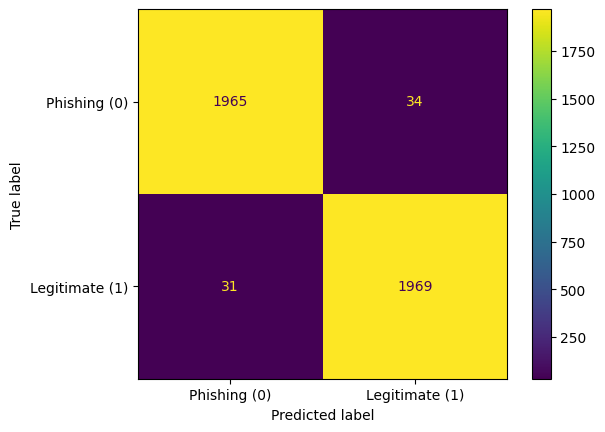

In [502]:
print("Model Test 2 -  Accuracy:", accuracy_score(y_p_test, y_p_pred))
print("Model Test 2 -  Precision:", precision_score(y_p_test, y_p_pred))
print("Model Test 2 -  Recall:", recall_score(y_p_test, y_p_pred)) #Recall is good since most are getting predicted as legitimate
print("Model Test 2 -  F1-Score:", f1_score(y_p_test, y_p_pred))
print("Model Test 2 -  ROC AUC Score:", roc_auc_score(y_p_test, y_p_pred))

# Confusion matrix
model_p_cm = confusion_matrix(y_p_test, y_p_pred)
model_p_disp = ConfusionMatrixDisplay(confusion_matrix=model_p_cm, display_labels=['Phishing (0)', 'Legitimate (1)'])
model_p_disp.plot(values_format='d')